<a href="https://colab.research.google.com/github/avinashmane/colab/blob/master/strava_likers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Code/Parameters
## Setup

## Todo
* replace path for cfg_strava and auth

In [1]:
import os
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    DIR='/m/colab'
else:
    DIR='/content/drive/MyDrive/m/lib'


In [2]:
if os.name!='nt':
    !pip install nerodia
    if True:
      !apt-get update # to update ubuntu to correctly run apt install
      if False:
        !apt install firefox-geckodriver
        !cp /usr/bin/geckodriver {DIR}
        !cp -r /usr/lib/firefox/ {DIR}
      if True:
        !apt install chromium-chromedriver
        !cp /usr/lib/chromium-browser/chromedriver {DIR}

## Code

In [3]:
import yaml
import time
from datetime import datetime
import os
from nerodia.browser import Browser
import re
import logging
from IPython.display import Image

"""
clip to get parent
import re
# feedlike=re.comp
display([(x.tag_name,x.id,x.class_name,x.text[:100]) for x in (c[0]._xpath_adjacent(  adjacent='ancestor', plural=True))])
# c[0]._xpath_adjacent( tag_name='div',class_name=re.compile('^feed'), adjacent='ancestor', plural=False)
"""

class SocialMediaSite:
    authType=None
    cfg={}

    giveKudosPattern=re.compile(r'.*ive kudos')    
    def __init__(self,b,browser='firefox',authFile='/content/drive/MyDrive/m/auth/auth.yaml'):
        # create brwoser unless provided
        self.browser=Browser(browser) if b==None else b
        
        with open(authFile) as file:
            # The FullLoader parameter handles the conversion from YAML
            # scalar values to Python the dictionary format
            auth = yaml.safe_load(file)
            self.auth={x:auth[x] for x in auth if x in ['strava','facebook']}
        
    def login():
      raise NotImplemented
      
    def loadCookie(self,cookieFile):
        if cookieFile and os.path.exists(cookieFile):
          self.browser.cookies.load(file=cookieFile)
          
    def saveCookie(self,cookieFile):
        return self.browser.cookies.save(file=cookieFile)
    def clearCookie(self,cookieFile):
        return self.browser.cookies.clear()
    def close(self):
        return self.browser.close()
    @staticmethod
    def getParent(el,tag,patClass):
      """
      Get parents with tag and patterm of class matching
      Parameters
      ----------
      - el : reference node
      - tag : tag_type (e.g. div)
      - patClass : class of patterns (re.compile)

      Returns
      -------
      - Single element than meets the requirements
      """
      return el._xpath_adjacent( tag_name='div',class_name=re.compile(patClass), adjacent='ancestor', plural=False)
    
    @staticmethod
    def _dumptag(el,tags,level=0):
      for c in el.children(tag_name=tags):
          print(' '*level,c.tag_name,c.id,c.text[:50])
          SocialMediaSite._dumptag(c,level+1)
    
        

class Strava(SocialMediaSite):
    authType='strava'
    def __init__(self,b=None,cookieFile=None,authFile='/content/drive/MyDrive/m/auth/auth.yaml',cfgFile='/content/drive/MyDrive/m/social-media/cfg_strava.yaml'):
        super().__init__(b,authFile=authFile)
        self.siteType='strava'
        
        with open(cfgFile) as file:
            cfg = yaml.safe_load(file)
            self.cfg.update(cfg['strava'])

    def login(self,login):
        auth=self.auth[self.authType][login]
        self.browser.goto('https://www.strava.com/login')

        try: # reject cookies
          rejButton=self.browser.button(value="Reject")
          if rejButton.exists:
            rejButton.click()
        except Exception as e:
            logging.warning( f"Error login1 {e!r}") #logging.warning 
      
        try:
          self.browser.text_field(id='email').value=auth['username']  #timeout did not work
          self.browser.text_field(id='password').value=auth['password']
          self.browser.button(id='login-button').click()
        except Exception as e:
          if 'dashboard' in self.browser.url:
            pass
          else:
            logging.warning( f"Error Login2 {e!r}") #logging.warning 
        
    def getClubs(self):
        self.browser.goto('https://www.strava.com/clubs/search')
        grps=[]
        # print(self.browser.ul(class_name="clubs").lis())
        for f in self.browser.ul(class_name="clubs").lis():
          # print(f.div().attribute_value("original-title"))
          for c in f.div().links():
            grps.append({"name":f.div().attribute_value("original-title"),
                         "link":c.attributes['href']})
        return (grps)
      
    def postInClub(self,club,title,text,imagePath):
        self.browser.goto(f'{club}/discussion')
        self.browser.link(id='new-post').click()
        self.browser.textarea(name='title').value=title
        self.browser.textarea(name='text').value=text
        # self.b.file_field(type='file').set='c:\\temp\\9955-2Certificate.png' #not working
        self.browser.file_field(type='file',index=0).value=imagePath #working
        self.browser.div(class_name="dropzone-previews").img().wait_until(method=lambda e: e.complete)
        time.sleep(3)
        self.browser.button(text='Publish').click()
        
    def getPostIds(self,club):
        self.browser.goto(f'{club}/discussion')
        return [{'id':x.parent().id,
          'title':   x.div(class_name='post-body').link().text,
          'link':    x.link(class_name='str-click-self-js').href,
          'userlink':x.link(class_name='str-click-name-js').href,
          'username':x.link(class_name='str-click-name-js').text,
          'time':    x.time().text,
          'kudos':   x.span(class_name="count-kudos").text,
          'comments':x.span(class_name="count-comments").text,
          } for x in self.browser.divs(class_name='topic')]
      
    def deletePost(self,id):
        "@id like post-19361836"
        self.browser.li(id=id).div(class_name='drop-down-menu').click()
        self.browser.li(id=id).button(text='Delete').click()
        self.browser.alert.ok()

    def deleteCurrentPost(self):
        "delete current post"
        self.browser.div(id="options-menu").click()
        self.browser.div(id="options-menu").link(text="Edit").click()

        self.browser.button(text='Delete').click()
        self.browser.alert.ok()
    def giveKudos(self):
      "Give Kudos in current screen"
      _=b.buttons(title=self.giveKudosPattern)
      for i,x in enumerate(_):
        try:
          card=strava.getParent(x,'div','^Card')
          logging.info(f"{i},{card.text.split(',')[:3]}")
          x.click() 
          b.execute_script("arguments[0].click();", x)
        except Exception as e: 
          logging.warning(f"{i} error clicking {e!r}")
      return 

    def scrolldown(self,pages):
      for i in range(pages):
        b.driver.execute_script("window.scrollTo(0,document.body.scrollHeight)")
        # b.send_keys(Keys.CONTROL  + Keys.END )     
        # b.driver.execute_script("window.scrollBy(0, document.body.scrollHeight);")
        time.sleep(1)
    def goto(self,url):
      return self.browser.goto(url)
    def image(self):
      b.execute_script("window.scrollTo(0,0)")
      return Image(b.screenshot.png())
    def close(self):
      self.browser.close()
        


# Process
## Create headless

In [15]:
" Test Selenium headless"
if True:
    if os.name=='nt':
        b=Browser('chrome',)
    else:
        
        # import sys
        # sys.path.insert(0,f'{DIR}/geckodriver')
        from selenium import webdriver

        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        # b =webdriver.Chrome('chromedriver',options=chrome_options)
        b=Browser('chrome',options=chrome_options,)
    # b.get("https://www.google.com")
    dir(b)

In [16]:
# %debug
strava=Strava(b,authFile=r'c:\i\auth\auth.yaml',cfgFile="c:/m/social-media-automation/cfg_strava.yaml")
# test case
# strava.login("avinash")

In [17]:
strava.login("avinash")

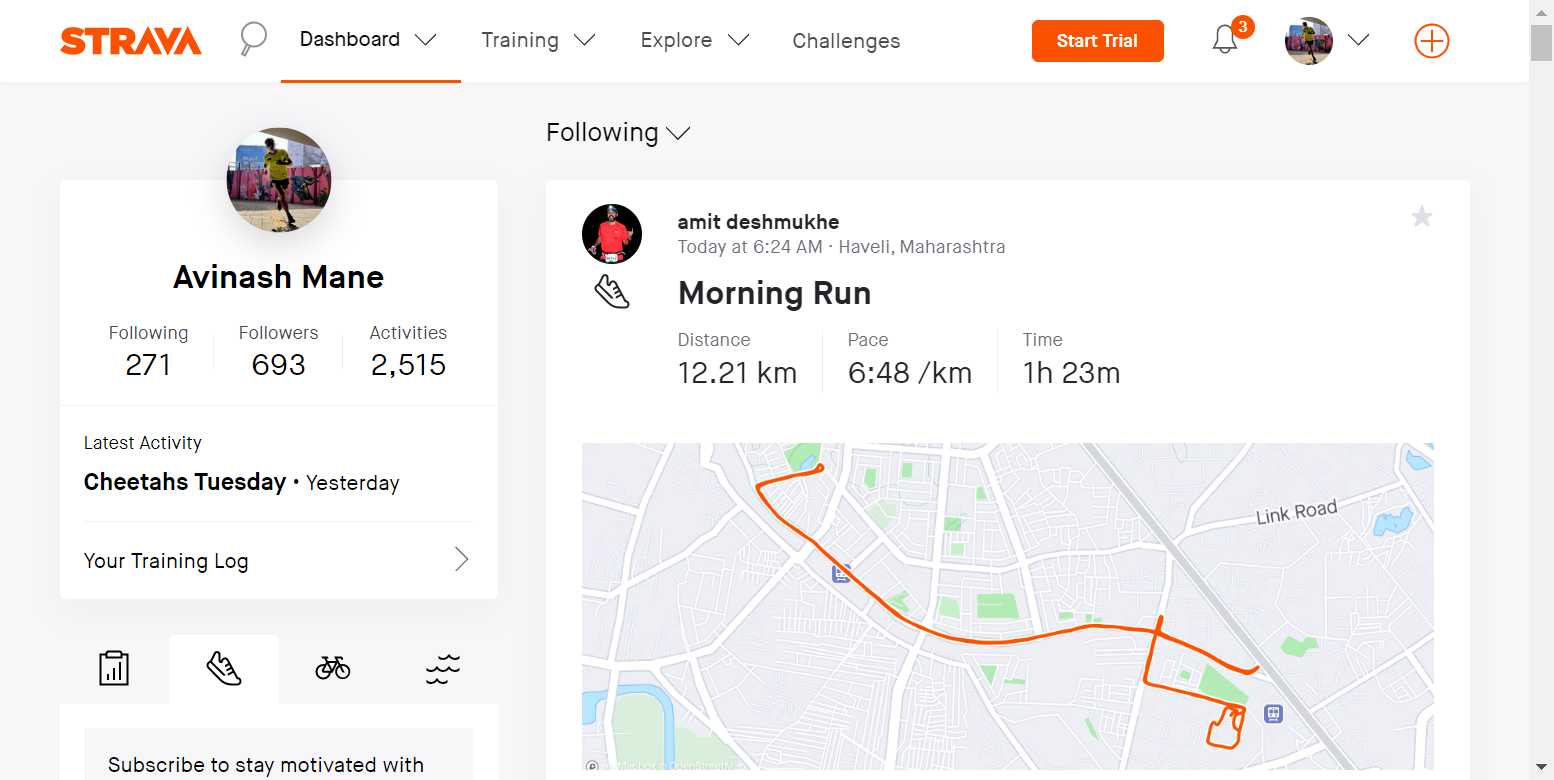

In [18]:
Image(b.screenshot.png())

## Give likes in feed

In [8]:
# b.goto('https://www.strava.com/clubs/196654/recent_activity')
strava.browser.title
strava.scrolldown(5)

In [9]:
# from selenium.webdriver.common.keys import Keys

# for i in range(10):
#     if b.wait(timeout=10):
#         b.send_keys(Keys.CONTROL  + Keys.END ) data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAB4AAAANCCAYAAACHzdFqAAAAAXNSR0IArs4c6QAAIABJREFUeJzs3Xd4VFX6wPHvvVMzaaTRISGA0kFQsdOiq4gidkWKrr2srGDZ3Z8rqKuioOKiAuoKYqcjYEVARSkiIJIEaQFSII206TP3/v4YMhAS0khICO/nefIwzNx77ntvziST+573HEXXdR0hhBBCCCGEEEIIIYQQQgghhBD1qqioqN6Podb7EYQQQgghhBBCCCGEEEIIIYQQQpwSkgAWQgghhBBCCCGEEEIIIYQQQogmQhLAQgghhBBCCCGEEEIIIYQQQgjRREgCWAghhBBCCCGEEEIIIYQQQgghmghJAAshhBBCCCGEEEIIIYQQQgghRBMhCWAhhBBCCCGEEEIIIYQQQgghhGgiJAEshBBCCCGEEEIIIYQQQgghhBBNhCSAhRBCCCGEEEIIIYQQQgghhBCiiZAEsBBCCCGEEEIIIYQQQgghhBBCNBGSABZCCCGEEEIIIYQQQgghhBBCiEZozJgxNd5HEsBCCCGEEEIIIYQQQgghhBBCCNHIlCZ/a5oElgSwEEIIIYQQQgghhBBCCCGEEEI0IscnfWuSBJYEsBBCCCGEEEIIIYQQQgghhBBCNBInSvZWNwksCWAhhBBCCCGEEEIIIYQQQgghhGgEqkryVicJLAlgIYQQQgghhBBCCCGEEEIIIYRoYNWt8K1qO0XXdb0uAhJCCCGEEEIIIYQQQgghhBBCCHFiRUVF9X4MY70fQQghhBBCCCGEEEIIIYQQQjRpBfm57N6ZTPr+3WRn7iM/P4+i4iJcbg/4fRjMZmxhkTSLjqN1q9a0S+jEWWf3IiY2rqFDF6LJkQpgIYQQQgghhBBCCCGEEEIIUWMul5NtWzax5de17N21HdAxKICioesKfh38ug6ajuYHPxq6X0Pza/j8fjQ02id05NzzL+XCSwYTHh7Z0KckRL07FRXAkgAWQgghhBBCCCGEEEIIIYQQ1aYDHl3D7nBQcriAwwV5ZBzYy6ED+8jJOoDDWQiaHxQFXVfwaRp+nx/d70Pz6+iajl/z4NcCiWC/pqFpMHDI1Vw57AZiYps39CkKUW8kASyEEEIIIYQQQgghhBCiQelLXkH/8RP0/dvA72vocER9MhhR2vdEufQ2lOGPN3Q0opHy6Bou3Y+iKCg6oOuoqoLi1/F7vBQUF5Cxfx97U5PJSt9NUUEefs2HQQ1UA/t9PnxeH5rPg9/vQ9N1fJoeSAT7Pfj8cN31Yxh+4x0NfapC1AtJAAtxBklPzyAvLxe32wNAbGwsFouFNm1aN3BkQgghhBBCCCGEEOJMpB/cjT7lJnAWox/c1dDhiFNIadkJQsJRJsxDadmxocMRjYSGjlvX8KMDCgo6CqCjoBKo6rUXl+B0uTGpBkIjIvB63WSk7WXv7j/J3LeLwvxcXO5CNL8bzafh97rx+PzoPg235sfv86Bp4PdpxHfsyui/PkJC4lkNfepC1ClJAAvRxKWnZ5CamkpKSuoJt7FYzCQmJtKlSxfatm1zCqMTQgghhBBCCCGEEGcybUJf9KIcyEtv6FBEQ4hpixIRhzrlt4aORDQCXl3HpflBARRQdVAUjqSCAR0OHshi6suvsmHdTxgtJh7+2ziuu2EERoOKBricTvIPHSI9bTfbt20lP+cgXnchblcJfo8Lr9+Dz6+BBpqm4fPp+Pwadz30JJcMuKJBz1+IunQqEsDGej+CEKKcoqIivvvuezIyMoLPhYeHER4eEUzypqdnUFxcRHFxCSkpgSRxmzZtSEoaTEREREOFLoQQQgghhBBCCCHOAPqSV8BZLMnfM1leOpis6Etekemgz3AeXcfl10AHRSWQ9eVoBljTdYy6wg8//MLSxYvJzsnCaFRY8cVShgweSHh0FLoKFpuVVgnxtIyPx6m0JzKvAL8rn5KCTOyHD1KQl4bTnovP60JRdDCAriv8b/pkSgoLuPLamxv4SogKZaehp22FtC1ln+8+ECUuHponNExcZzhJAAtxiu3evYeVK1fidnswm8107dqFPn16l0vq9u8f+LeoqIiUlFS2bNlKRkYGn376GUOHDpVqYCGEEEIIIYQQQghRb/QfP5Fpn0WgD/z4yRmTALbb7ezbt4/k5GQAunXrRnx8PKGhoQ0cWcMpcTpxeT2YTWZCrFb8Pi+KqgLg9/mwGs14/F5MBhMd2rWkbXwLDman43T5Sd/5J5k7d5HQqwchYTb8emDKaL8vUN2rmEIJD7ESF9MOk9HA4WI7BQVZ7Epei8+dh70wCxUXGHTmzZ2Boir8ZdhNDXtBBAD69tXoq+agb18N2WmVbxzaDOX861CufhSlQ59TE6CQBLAQp1JKSgrfffc9AB06dODyy4dgsVgq3SciIoL+/c+nT5/efPvtSvbu3cuiRYtJShpM165dT0XYQgghhBBCCCGEEOIMo+/f1tAhiEbiTOgLOTk5vP3228HE7/G6devGAw88QFxc3CmOrGH98Osu3l/8KyEhFmw2M2GhNjS/F4Pqw2w0ohoMNIsIw6ToWIwQYzXTKjaW5jYrsRHhhFsMGExGrFYriqZjREdHxef343J5cLk9aD4Nt66j+TX8qoXw2ESatSkhIjwS3ePEUXiI7KydOOzZzPv4AyIio7jw0qSGvjRnLH3DYvRl0wKJ32PFxaM0T4CEPhDaLFANbC9A33vk31Wz0VfNRuk+EOWWZ1C6D2yYEziDyBrAZ5DSN2RjfWPpy15HGTQ28MOhCUpPz2DRosUAdOlyNpdfXrtfUt9++x2pqTuwWMyMGDGCuLjYugxTCCGEEEIIIYQQQgj8NygNHYJoRAwLmm4aYcWKFSxYsAC73c6AAQOIj48nISEwZW1aWhr79u1jzZo1hIaGcuONN3LVVVc1cMSnxsHcQq6fsJBmUZEYTAZUgwFdB1VR8eo6KqCqKqqiYjAotLA4SQjxohbtRznwE3O+X0+nDp154OGH6dirE5YQEygKYREtUVQr332/C7ffgEHxYdL96IqKWzPj07ykbFtLVLMWREZFoSgKHpcLk1HBWXKYkvx0Rt91G23btW3oS3RmsRegTb8TfcPi4FPKwDEow8ZVWdWr790STADjKAzse/51qA+/32TzQVU5FWsAn14JYHsB+vY1kLYF/Y/VFW6i9BgIzRNQug2oeF5xe0FgLvJ6pCT0DhwnZ1/tG7FF1nkpvPbvgYCC+uyqsi9U45ooCb2r/0bMTqvy3JXuA8rF4H+gA8rVj6LeMrF6xzmNuN1uPvnkM4qLi08q+VuqNAkcHh7ObbfdUmUVsRBCCCGEEEIIIYQQNSEJYHGsppoA3rhxI1OnTiU2NpYHH3yQbt26VbhdcnIyb731Frm5uYwfP57zzjvvFEd66n3y5W+8uXgnUVHhmM1mFJMFVdUxGxQ0DdxeDa8fDKqKoirEmF10CXMRFWbFdngrySvnkFpkweHRuPjSCIjScDvctEs4hyuuHMfmZA23FzweNwbNj2I04ceK3+ckeetPhEdG0Sw8CoNBxevzER0ThcloQPdrmFW4bsSFDX2Jzhj63i1ozwwCewEQSPyqt0ys+dq+9gK0Za+jL3s9kAgObYY6adUZOS30qUgAnx5TQGenoX0+KTCy4EgHO5EyZefNE1AHjUUZOCbYEfW0LWj/HlSf0aI+uwr9j9Xon0866baUDn1QSs/hJEZC6NtXB5LnRx4fXwWsvTQ8OPKiwjhufqbaiVlt+tjgsSpsq/sAlGfLJvC1Za8HEtHLp8GwcU1u1MeWLVspLi4mJiaGyy679KTbu/zyJHJycsnLy2PLlq30739+HUQphBBCCCGEEEIIIYQQZwa73c6MGTOw2WxMnjy50nV+u3XrxuTJk3nkkUeYMWMG3bp1a9LrAmu6TtZhF5rBQonfiOIxYsSIwQj4AQ1URUE1aegAikK+FsI+rxW/t4gl874g0etF1TX2F6URvQ98GS7cdp2UlK0UFzjocd4/8Lm9GFUVo9uF1+nGH2JGxY8lRMduL8FiMKH5wel0YLWaCA0PxevxkZFbxDff/cQVSZc07IU6Axyb/FUSeqM+ubjmid9Soc0CeaZh49D+PRA9bSvaM4NQn1zUaGeuPZ0ZJk6c2KjLLfUNi9Gevwr+XAdeV812thcEEp/Lp4GjEOWsC6DgIPqqOfUT7BHKoLGBRa8rSYJWW8FB9M1foX8zE8XrrvWbQJ8+FkqrcrP3BWIsZbYGrm1l8aZtRb3i/sC2lR1ne9WJb/WR2YG54EvZC9Beuy0Qg9cFJmugkruJcLvdfP31N/j9fq688i9ER0fVSbtRUVGkpqaSm5tLv3796qRNIYQQQgghhBBCCCGAOiluEU1HU5y18b333mPnzp387W9/C075XBmz2Uzr1q1Zs2YNhYWFTbYKWNN1vH4PqzfsY0+uH6NRQfc60XUfut+HoqpgsWDChYoOqhHFoKAoCuHKbxz8fRJWdSt7ivIoNhwmoYMRXQef34OqQ4jVxMb1e+nYujvhWHGrRkzOEtyFRbiMVhTc5BxKx+l0YAnRUBQvIdYwDmZlU1LiwGwykZedzd60DM47tysWi7mhL1mTVSb5230A6tNfQVTLyvfZvhpy9pXNAR3PbEW55FY4fBB2rkffsASlz5UoVbTdlLjdbgC2bNnCwYMH6/SrZcvAdVQb8gSroq+ajTZ5RJVVv9Vqa9nr+CecE1hw+nRkL0D7bGKgermG1+PY6t+j/y9bgasOGwe2yMqPv+z1qo/1WeUfBJTuA8pXH382scw56cun1cn3vLHYs2cPbreHmJgY2rZtU2fttm3bhpiYGNxuD7t376mzdoUQQgghhBBCCCGEEKKp27hxI/Hx8TVK5J533nnEx8fz66+/1mNkDcvj8YKu4dN0VKMFAz4Soo2cFRdCmwgDYYqXCIOfcMVBS4uHECP4NZ1Qs4ae9xkGbwZhkVa6d1c4u4uPEKuDMIsLk2agdQcrTt2H21/AnozlKGEGQkNCUZrFoTZvgyUsFA0dg6pjtqoU2Uvw+p1EhOq0iA0Fzc3BzCz8PhcJLduw8dedDX25mi57wdHk78AxqM+urtbMrdq/Bx1ZjrQKoc0CxYIDx5Q5lqg7jTYBrO/dgjb9zrptNDsNrGF12+Yppm9fXePrUlFSVv/suBF8oc1Qho2rvJ0qErPHJ5oroj48u+wT2WmBdo9VzWTz6SI9PQOAjh0T67ztbt26AoEkc2PgdDq5//77URSlzFdERARXXXUVH3/8MXa7vaHDFEIIIYQQQgghhBBCnMHsdjsOh+OEa/5Wplu3btjt9iZ5n1PXdfyaH6Oq4tEUFIMRm9GLqvgw4CdE9dAx0kdbq4MoqwmLqmDUXWiKgo5Cq0gFp0Pn6689HMpQURXQdY2DhTqpaVBcaGT/Nj+RRgsLF61ka8oWDAYDPtUIRisGTUfRwGo1Y7GE4XNbOXiwhLT0g+gGI6FhzQgxmmgTZiOsII8dKftwujwNfdmaJG36nUenfX5kdtU71JJ61+soCb0DeaG6zgme4RpvAvj9ypORtaHe+RpKq0513u6ppm9YjL6qem84fcPiCpOy9VEFrP137AlfA8qsxRzc5wQVw02pCrioqBiANm3qrvq3VGxsbJljNFbFxcV89dVXjBw5klGjRrFv3756P+aOHTvo06cP999/P06ns8rt165di6IoPPfcc/UeW33Jy8vjyiuv5MorryQvL6+hw2kSCgoKuO++hxk6dESVX8888zwuVw2XKqjEnj1p3HrrmJNud9OmzQwdOoLp02fUWWzi1Jk+fUal/e7WW8ewZ0/aKYmltC9t2rT5lBxPCCGEEEIIIYSoL6X3J6sz9fPxSvc5Ffc4T7XMzEyKCgrIy82jmVmjaxxEW6GwsAiTCoqukn34MNnZubg9OkVaKKrBTIRFQdPMmG2t6dzRx5iRKp06+gk16ZgMoWzdauGPZD+r17iJjA5h0LAkdu/xs3jBJxQVHMLpcOL3evF4nLjdLlxuDaPBSmioDaNRp8RZQtqB/bjsTpxeHWOLNuQ1iyO/+DApqY2jOKop0bevRt+wGADl+KK+uhbaLLCusC3ySD5rddX7iGppnAng7LQqK0lrSuk+oMoK19OJVs01OLT/nfic67IKWF81++gawydQbp2I7DT01SdYj7kJVQFnZmYCEBERXudtx8UFEsB5ebl13vbJ+umnn9B1HV3X8Xq9/P7779x2220sWrSIxx9/nMOHDzd0iKISdT2oICUltU7bE02X9D1xKkg/K6ugoIC5cz/mrrvuZ+jQEYwYcSv/+tdEUlJ2oOt6mW1dLhfPPPN8nQ96KVU6+GXJkuVlnp8+fQb33fcwBQVNY4CgEEIIIYQQonGIi4s7JfucLv78cyea7iM7JwebVojNtRdH/gFCVDfRNo0IkwvVk0WfNkUkhu6jrTmHTtE2OkWH0r2ljYP7zZhdMcS3bktUhEbrWIVwoxejasBmVck55OXn31y89MK3NDN66B6qg7MAm82CxWrCarFiNBrxOhU8JU5cRYdRvDohBjMmXSc7Zz8+fwEqdsxGN/bCdH7+4eQThnKfoCz9/b8DoNz8DEqHPvV/wOYJwdxUubyVqDVjQwdQkdKRBZVREnqj3DLx6Jzj2Wnof6wOLjBdhi0yMIKgKclOQ9+7pdI3X1VJ2dIq4GPX5FWHjcO/7HVwFFa805HE7PHJ3BNV8paqSfVvML7l02DYuGrNK386iIiIqPM2LRYLAG53457mwmg00rNnT1577TUcDgfz5s1j+PDhjBw5sqFDEycwcuRoPvrogzoZuJCSksodd4xm06YNdRDZqdWsWTNmzpxe5rklS5Yzc+a7PPfcv+nX75x6O3ZiYgKffnqCQTI10K/fOaxYsagOIjo1pO+V165dGyZPfp5mzZrG78PGQPrZUZs3b2Xy5FcpKioKPud2u9m8eStbt27jlltu5LbbbsZoNDRglEIIIYQQoul7F8OCv5Z9yv492ugh6BXv0HAeSsYwuGvV2/0xAf8zUyt+7ZqVGMYOBgrQZ0ehfVH9w6tv6ChtgIz38P/t7urvKEQV7HY7WQcP0bZtS8LDwvGrFgrtHkDB5fVy4MAunC4HbmcxqhqOqvjQvYfJ3F9EWLPmhEVHsPmXLJIS2xB7bj/y8tLQfCotmvu4+Rrwe034XTqK2UrriLOIMrUjrHl7VHMRjoId+N1+HF4Pft2NkTzsOUVYrBp9e3alR4++qAYVs8lIfk42H3w8hxCrSqwthvSdWRQczqdZVHStz13uExyl792CvndLIK92CosqS3NTFeWtRO00ygpgvTpT/3YfiHL+dSjdBwa+Bo1FfWQ2hhlpqM+uQjl/eHBT9anFwSSiktAH9dlVJ/6687UqDx1Y8PrEbSgJ1RsRodz8DIYF+tGvt/cG9h84plr7k7al0perSrBC3VQB13n1b6kmVAUMgZup9dWm2Wyu87brQ4sWLXjkkUcIDw/n66+/prj46Mgqt9vNggULSEpKQlEUYmJiuOuuu9i2bVu5dtLS0rjvvvtISEhAURSSkpJYuHAhPp+vwuNu3bqVu+66i5iYGGJiYrj33ntJS6t4ylRd1/ntt9+4+eabiYiIICEhgccee+yE2xcWFvLqq6/St29fFEWpcvu0tDQee+yxYOwXXHABM2bMKDNNden01ePHj+fll18mISGBXr16kZoaGDmmaRqrVq1ixIgRwRhfeOEFsrOzK77wtdCtWxfuuGP0SY9+K/3Ak5Q0pI4iE02d9D1xKkg/C0hL28err76Bw2FnxIhrmTPnHZYvX8iSJZ/zj388TmRkBAsWLOK33yr/zCmEEEIIIcRJuWZl+eQvQOhg1AWHUa855rmHkgP3UT9YiVIvcegYFiQ3zpvmQtSzQ4eyKSgowWwx49P8uBwFHMzYRajqok2ERqjRTYTZT5hZwedV8fgMqKj4SvIJ8dlx5eczsN+5dD93GC5fFA43OPzg0XRMJg+2EDe2KA9RcUU066gSHtmPkrwQDvy8jl1Ll6FuSUbZ9Ad5a34mdFcGrQ+5aLXPSd6yjfwy4yM+fnYyi1+Yxm/vLuDQqi0YtmTTIt1NKz2c/Tv3ntS5y32Co/QjORnl/OtObXFeaDOUQYFlRvXv63na6TNEo6wArg59+TQ0R+GRJPCAMh2xNCmsb1+N/sdxIwVCm1U6cqBaI8qaJ9TP6IPmCShH2tYcBegbllS6uZ6ddsIPOtVJykLdVAHXR/VvML4mUAUcExNDXl4eOTm5tG1bt+sA5+QEpn4uXQv4dNC1a1f69etHcnIyhw4dIjw8HLvdzhNPPMFbb70V3C4/P5/333+f77//no8++oiLL74YgE2bNjFy5Eh27NgR3HblypWsXLmSl156ifHjx2M0Hv3RtnTpUpYuXUpWVlbwuXfeeYfff/+d999/n65dy47YXLhwIf/73/+Ca3gUFxfz2muvsWLFCmbNmsVll10W3Hbnzp08/PDDfPPNN8Hn9u3bx2uvvcbChQt5++23ufLKK1GUwDt1zZo1jBkzpsz6IOvXr2f9+vVs376dl19+mZCQkOBrr776avDx1VdfTYsWLfD5fLz22ms899xzwQR6cXEx//rXv/j8888pKCigS5cuNfmWVGjy5Bd58sl/cMcdo/nww9qNfjv2A8/kyS+edEynA5fLxYsvTsHj8dC5c0e+/PIboqOjgtWbuq6Tmvonc+d+zB9/bMfn89O6dStuumkEgwYNxGw2BdvasyeNf/7zGS655EIefvj+4PPTp89g69ZtXH/9cL755jt2796Dpul06JDAqFG3cd55/YJ9DgLrtj799LPcd9/dDB9+dbk4+/c/j6+++pb09AxUVaFHj+6MGXMHZ5/dudz5+Xx+1q79hblzPyYzMwuj0UDHjokMH34Nn3zyGT179igTa21I36sdXdf55puVvPnmTO699y6GDbsq+JrP52fWrPf45Zf1TJz4Lzp2TCzTBzp2TGT58q9wu90YjQZ69OjOqFG306XLWWX6UmXHTk39kw8//ITk5FS8Xi8dOiQwcuQt9O9/Xpk2qnqPADidThYuXMpXX31DXl4+oaE2+vY9h9Gjb6dNm9Z1cr2kn4Hf72fJkmUcPlzAvffexTXXDA1+r0wmE5deehFxcbE8/fSzLF/+Jb16dcdqtTZw1EIIIYQQoukZj3rT4MDDYyt+gxWyzVBuWonyRSOqBH6zG/43j/43WJFbk4rlL4bgr0HVrxCnwo8//kLqth3E2KyEWG3k/ZGKtj8dR2ERNmskxhAL1jAzISUOQrYfwqb7cTod6Adz6O7xkrn/AMYeoWQVmgj35ZJfoNAsRMXlA7fLiFE1EB7hRfP5cBbuJHpbLrZCD7vSU2ge25poA5gdGnk5RYSG2Iix2UAD3aezLfk3thzeR/e4eHRbM7xFxeSHu8gsLCTEqrLr9xR6nd+v1ucu9wmO0pMDy7Mq/a875cdWBo1FXz4NfWPluTFRPY1yMJNSzWSfvmo22uTr8I+OQptwDtr0OwMJw+xA5Z3SfWD5ytPTxMkmmKubYIWTqwKut+rfUk2gCrh0nd6MjIw6bzs3N5AAro/1hetLaGgosbGxFBUV4XA4APj666956623uOKKK9i4cSN+vx+Hw8GsWbPIz89nwYIFeDwe/H4/CxYsIDMzk1mzZuFwOPD7/WzcuJErrriC//znP6xZU3b98KysLEaOHElmZia6rpOZmck999zD+vXreeedd/B4yk6fvXXrVm666SbS09PRNI3CwkJeeeUVMjMzmTp1arDK1ul0MnXqVL755hsmTJgQbL+kpIS5c+cCMGnSJHbt2gXA4cOHmTZtGvn5+bzyyisUFhaiaRp//vknV199NQsWLCA5OblMLOHh4cydOxe/38+yZcuIiopizZo1PPfcc3Tr1o2ff/4Zr9eL1+vll19+ISwsrExy+WRNnvwiXbvWbvRbU/nAU1tbt25j/vzF2O0OWrZsGUyabNy4iX/+8xm2bPkdn88PQGZmFtOmvcWcOR/i9/ur1X5GRib//e/b7NixE5/Pj6Zp7N69h2effZHvvltVozhnzfof+/cfQNM0fD4/W7b8zlNPPc22bdvLbOvz+XnvvdlMnjyVzMys4HM7duzk5Zdf5cCBuvsZJ32v5hRFYdCgAVx00QXMm7eI9PSj349ff93Et99+z003XU9iYocy+23duo2FC5cEZ5Qo7QNPPvkvli//qtz6r8fTdZ3ly7/iySf/xebNW3G73cH++Pzzk3n33dnBvn78cSt6j+Tm5vH44//io48+JS8vHwC73cGPP65l/Ph/sHnz1pO6Tsc60/vZoUPZ/PbbFnr27E5S0qAKk/0dO3agb9/e7Ny5m0OHys8ykZ6ewYsvvsKIEbcybNgNPPLIeDZs+LXCfpOXl8/Mme9y000jGTp0BDfdNJKZM98Nfp9rS9d11q3bwCOPjGfYsBu49tob+fvfn2Ddug3l4ihdX/j99+cyc+a73H772DKxFBRUPPjx0KFspk59gxEjbmXo0BHcfvtY3n13Nh9//Dm33jqGPXvKzvpRk5h0XWf79hQmTPgH1157Y/A6VrStEEIIIUTT1BUl9MjDvSuOJk+/GIL2R0HweRiP+oF+dOrl0MGopbMqPlS607tlZ1tcoGOYNL7s4Y6pIFbfOLLNG+8GHo8dfDSmE+1fI0diXqBjmFRaXXykovma4/5fKvj8MV8Pnah9IerW4iXf8MWKH3hp0lu8/9wstN9SiMstwLhjF83zC2np8RJj9xBd6MB0IBdzroNmbnAXFuDOzwV7Eb+v+pE/N2wmXInEiI69xIrXE47ZEA0YcdmhuMhAdqEfg9mLrhrJ153ENGuGQfNjBowoKKqKio7Rr2BVTcSEhFPoKsGiqrhcTmyhIezSC9lkLWF/UT5/rvv1pM//TL9PAARya9lpYIsMVACfYkqHPmCLDMxAm13xDJui+hpnArgWHUvfuyWQEP7fOPwPdMD/QAf0zyedtp1Er0bcynFVtcF9q1k3T0fIAAAgAElEQVT9G9x+++py6y6rw8ZBXPyJd7IXoH02sV6rf4PxHTfl9OmmtOp3z56Tm4aiIsnJKQAkJibWedv1xWw2ExMTw86dOykuLsbv9+P1ernuuuv417/+xbnnnouqqoSEhNC/f39atmxJcnIyxcXFeL1eCgsLCQsLo2PHjoSEhKCqKueeey4vvPACM2bMoFOnTmWOl5SUxGOPPUarVq0AaNWqFePHj6d3797Bdo81evRonn76adq0aYOiKERERDBu3DieeOIJli5dyrp16wDYtm0bS5cu5Z577mHixInB9kNDQxk5ciR///vfWb9+PcuWLQMCVbrx8fHce++9PPDAA0RERKAoComJifTq1YusrKzgFM+l/vKXv3DNNdegqoEf1W63m6VLlxIWFsYLL7zAhRdeiNFoxGg0csEFF/Dqq68G46grtfng02Q+8JwEVVW55547Wbp0Pk8//RQWiwWHw8GiRUsJCwvlP/+ZyNKl81mxYhFz5syiX79z+OmnnytMsJxIp06JTJ/+GsuXL2Tp0vlMmPAoJpOJ5cu/pLi4pNrt9O9/Hu+/P5PlyxeyaNGnjBkzEq/Xy7JlK/B6vcHtVq1awxdfrKBbty68/fY0li9fyPLlC5k8+fk6n90ApO8d68CBDG6//U6GDh1R7mv69BnB7cxmE3fccSsA8+YtxOfzk59/mI8//ow+fXqdMMl3bB9YsuRznnpqPDZbKJ99Np99+/ZXGtuOHTuZM+cjoqKieeGFSSxdOp/lyxfy6quTSUxMYMmSZWzYsLHcfhW9R3w+P3Pnfkxubh4TJjzK/PkfsWLFIpYunc/UqS/SvHksH3zwUZm1ak/WmdzP0tMzycnJpXfvnthstgq3MZlM3HHHbbz00rO0bNmizGupqTt48smn+fHHn49L/L/Ezz+vK7Ntbm4ezzzzPEuWLMduDwz+stsdLFmynEmT/kN+/uFanUOguv1/PPvsi0dmQ9CCA1Oef34yH374aYUDEObNW8iSJcuDCd9jYzm+f+3evYcJE/7BypWrggMlCgoKWbhwCR9++MlJx7Rx4yb+7/8mkZycWmZAz/PPT+aLL1ZIElgIIYQQZ4AUdPuRhz2mlEl26s9E4b9Bwf/M1Kqrak80jXSPKRUncUMHB6p2AXacgnV0e5RWOf+GfqLK34eSj0lCH2OwJIHFqbEvMweH10G+z0WkNYQwsxVVAcVgIDS2GQaPH6XAjsFgwGgyUoKHHeRhDDOwPTsV1aJzUctE+rdMwOAxYPTaMIcoYNTxKnbcXo2CkjCKXGH4XDb0UAXVZMBotmI3GSnAi1/1g0HFYjShquDBg0f3EGaxoKJS4nVwoCCbxIjmXN6qEyGKge07U8lLr5vChDP5PgGAnnOkuLJD9ZY5rQ+lx9arWAJVVK1RJoADUywPOLk2stPQPpuI/4EOaO///bRKIOrbV1evQvYEaw3XNMEKBK7RsUKbVVk9rS+fVr/Vv6VO8yrgrl27Yjabyc3NLVORdbLS0zPIy8vDbDbTsePpkwD2+Xw4HA46d+5MeHg4BoOBW265hUWLFnHZZZfh8XhISUlh2rRp3HHHHezcuTO4r9Vq5eabb8ZsNnPdddcxYsQI5s6dy759+zjnnHO4/fbbiY8vO3ChY8eOwWlFS8XGxtKyZcsK4+vUqRMRERFlnjMajcGpn7duDVSfpaamkpWVxZAhQwgNDS2zfaASbxCdO3dm165duFwu2rdvz2uvvcaUKVOw2Wzk5eXxzTffcNdddzF9+vQKY4mJiSmzvnNRURHJycn07duXc845p9z2HTt2pFevXhW2dTJq8sGnKX3gORmdOiWSlDQYo9GA0WhEURSMRhM33XQ9jz8+jnPO6Y3RaAAC/fGsszpTWFhIfn71KuFCQ0N55JEHSExMONK2gQEDLuWSSy4iOzu32u20adOaBx+8hxYtmqMoChaLhWHDhtKtW1f270/H4QisTe1yufjpp59p0aI5jz/+d+Lj26MoCoqi0LNnd8aNe7jM9OV1RfpezbVt24Y77riVH35Yy8aNv7J06XKys3MZOfLWCpN8iYkJPPzwfcE+YDKZuOyySxg37iGKi4tZt27DCY+l6zrff78an8/HhAmP0qdPL4xGA4qi0KXLWTzxxGPExMSwatUaPB5vmX0reo/s33+A9et/5c47RzF48MBgvEajga5du/DQQ/eRnp7Jzp276/Sanan9LCvrIFD1ILJ27drSvn07LBZLmeeLi0vo0CGeGTPeCA4gueeeO1FVtUyiFwIDSNLS9jFmzMhgYr90wMmePWm1XmP4l1/Ws3z5VwwfPiy4fvHy5QuZM+cdLr98CIsXf0FKSmq5/YxGA3fdNToYS+lAnB07drJhw6bgdkVFRUyfPoOSEjv33ffX4Paffz6X668fHhygVduYvF4vK1euIiwslKlTXwxuO2PGG3Tpchbz5i0kPT2zVtdGCCGEEOL0MRVt3vdH/ztYP8Eav1PRRitHq4Lt36PdoAQSxG+Cevng8s9/HyicoMdfK74J/v3R/bW/HbM9KeilbTwztW5OszSuE04RPR61/5Hq5oz3Ase+4Zjz7V8Pax4LcZw9u/6gpDgfr9dHGEZ8Xi9oXkJNJgwFDlSnE39xIYrTgdvnJgIT2d4iDoW6SHPnY7aFkhjfk7g2nfE5ID9fJzvbhdvnwGx2oxhc6CYXoSY3RrOB4lA/aarC3si2zM4pYrb9EF/7s0g2lrC2KJNlOXuZZy9kJdmkW1xYzVZ2FuRgtJrpEteOjloYEQeKUBwusrIaZma6pnSfAED/Y3VDhxBcDlTfKwngk9Vo1wBWn1yM//6EE69DWwP6stfRtq9Geej9Bh25cDx99Ry07WWnq9Vz0qpXtRwXX+G51LT6Nyg7DX3V7OAi2xCYb53PJtauPeqm+reU/vkkGDS2XHuniz59erNhw0Z+/PEnbrvtljpp84cffgy2fTopLi7mwIEDREREBG/u67rO77//zrRp01iyZAn5+fnEx8czduzYcsnbAQMG8MMPP/Dpp5+ycOFCRo8eDcCll17Kv//9bwYPHlzhDdmT1aJFC3r37k1GRgZOpzM41XLbtm0r3N5isWCz2fD7/cHqHbvdzgcffMCcOXNYv349ACNGjODBBx9k8uTJVcaQn59PTk4OF1xwwSlfh7E662A0tQ88JyMyMhKTqeyvWLPZRN++fdB1nUOHstmzZy+//baFdes2BKdAdbs9FTVXTnR0s+D08qUMBgOJiQls3LgJv1+rVjutW7ciPLzs99JmC6Ft29Zs356MrgfacTicZGZm0bt3T5o3jyvXjtVqxWQylXu+Lkjfg3bt2pRZI7cql156Eb/8sp7Jk19F0/z89a9j6dixQ4XbxsTElBvEAtC9ezcSEuLZsWMnbre7XPIPwOVyk5mZRffuXenUqWO511u1akmvXj34888/cTjsmM1H46/oPZKbm0dRURHTpr3JtGlvHt9c0M6du+jXr/wgmJNxJvczg6F2vzObN49jwoRxwcpgi8XC1VdfRXJyCtu3p5Kbm0toaHt0Xef8888lLi6Oiy66ILjWucVioVu3rlgsFg4cSK/x8V0uF9999z39+5/LnXeOLrOGelxcLHffPZaMjEx+/HEtPXp0K1P9PmTIIEaMuBaDwXBk+zjuuONWkpNT2bVrN0lJgwDYuXM3O3fuZtSo27j22quDbYSFhTF27Cjy8w+XSV7XNKZSLVo0p2XLlsH227dvxz//+QTp6ek0b172Z70QQgghRJN0ZD3c4Fq6EJziuXrr6o5H/1ZB+2I8yjUVVQu3gmuAMpW3Kegn/rOj7h07vfUJ6PMUNMajfFFB0jm0FQo0nnWQm4CcnJxG0UZjUlLixWTwYVEhwmTC6XLg0X2EYQa3G03X8Tjt6A4T4REWzCY4V23NBsMenEYFk9+IO9+JARUdA20620hN1Sj26RSGu7AYwOmGXQcMbN91iAGJ28g2JbJl727MISbMEWFktLJiiTZRfKCQ/LwS3H4DxpI99GwRjhZm5Kyw1nSPbEW4akFRdLpbI8lWc7Db7VWfYA2cyfcJAIgrm4fRt69G+/egGjXhv6F6w1bUZ1eVXRI1oQ9skDWA60KjTQAT2gz12dXo08eip538em/63i3oL4/AMGVzcARBg8tOq9ZUzxU5UXVubROsANrnkzAckwAuPY42/c5atVcn1b/H0D6biPrI7Frv35D69OnNli1byc3N5bvvVpKUNOSk2vv22+/Iy8sjPDzstEsAp6SksGnTJv7yl78QFxdIJP3888+MHDmS5s2b8/rrrzNkyBBatmzJ4cOHg1Mul3I6nURHR/PEE0/w+OOPk5+fz9dff83rr7/O9ddfz6xZs7j11lvrPO5Dhw6xdetWbrjhBkJCQoKVxunpFd+0drvdOBwODIZANZzT6eSpp55izpw5jBkzhjfeeIOePXsSEhLCRx99VK0YoqOjiYuLIz09HZfLVS8Vl5Wp7INPk/7AU0d0XWf9+o38979vc/hwYASv0WigR4/u9O3bh2+//b6KFqqmqoaTbkNRlHKDKAoKCikuLkFV1QqnEK5v0vdqxmq1MnjwANat20BcXCznndevxt83k8lIZGQkmqadcApat9tFTk7OkcRV+dcNBgMWi5nCwmLy8wuqTGCXVqRWJTc3r1rb1dSZ2s+qO2DkePHx7WnWLLLMc2azKdhvSttVFIX4+PbEx7enuLiE1NQdJCensHbtOvbuTUPTtFr9oV46MCUjI5O1a2+uctvQ0KMV8AkJCcHkb6m4uDiio6Pw+XzB5/bvP0BYWGiF7yGj0YDNVvb3cG1iuvnmG5g48T+MGXM3HTsmcs45venbtw+dOnWkV6+elbYhhBBCCNHUaH878pnrmpVHp0IOHYz6wcoqksBTj0yrPBXOPYxhbCO591sjR89BeUNHrfuVlsRx5s2bh81mKzebYHXEx8djs9mYP38+Awac5EymjYgx4mx8JX8SohgxKUY0VPKcxYSZQ9E0sBhM+DSNMIsRq8WMwWKiudXG2Z6W/JRxkMPRLlp4dQ4fPIzJDH9ktGT5qj/QCcwip+mgaxr6kXezq30WN/Y043R62F/oIDq2AwV2P9HqIUJcWQy8sBn+AyWk54UQFRnC3uJ8thQcQsNIiNFMlNFMnCmEGKOFAq+zzq/HmXqfAGjYQrzTaDbfxq5xTgF9hNKhD+qzq1Fufiaw8PPJyk5D+9+4k2+ngSkDx5Sp1C1V6+rfUkeqgMsca9DYytcCPoG6rP4tpa+ec9qu6WyxWLj++hFA4JfDd9+trHVb3377HampOzCbzVx99dUVVmU1Vna7nc8++4zi4mKuvPJKIiMD7+vvv/+effv2MWXKFEaNGkXr1q1RVZWioiIKCo7+wF+3bh0tWrTgoYceoqioCEVRiImJ4fbbb+fdd9+lZcuWrF69Gqez9r/wN2/ezOHDZdci9Pl8fP311wD07h1IuHfp0oVWrVqxcuXKcjeudV1n1apV7Ny5k06dOmG1Wtm/fz8//vgjt9xyC5MnT+b8888nJCTkSDXooWrFFhERQbdu3fjtt9/YvHlzudd3797N77//XpvTrraKpkBp8h946siuXbuZOvUNAO6+eywzZ05nwYJPeOGFSY1+He9mzSIJDw+rNBlY36TvVV9+/mE+/3wBiYkd0DSNzz6bX+E6qJXxen0UFhZWmvS3WKzExcUdmemg/Ot+vx+320NkZDjR0VXfgGnVKjA1/3PP/ZsVKxad8Ovhh++v0bnUxJnUz9q2bQ3Anj17Kt1u2bIvmTbtTfbvP1DrY2VlHeTJJ/+PW24ZxVNPPc0HH3yM0+nkmmuGVjiKujpKB6ZUpbCwAK+36tkVVFVBVcv29YyMTEA58lU/MXXsmMjbb0/j73//GxaLlUWLvuCJJ/6Pm2++gxkz3g2uOyyEEEII0XS9G5jyecEx69x+MaTsFM6hfVGuqaKZh5IxLNBRe5T+7VGA/v3JD7Q+lZRJhzEsOKYKmhT04LTUoi6tWLGC3Nxchg4dWuGsWFUJDQ1l6NCh5OTksGLFinqIsGFEtYhGtcZgVAJ/I6GomBQwGxU8ZhVNDRQNGI0GdFcxfkchvxfvYX1xGm7Nx0FfCQ58bFIOsctTwLateVxxdjviQs34/H503R9M/gK47X5Uj4opJBpHQQkeexEmnx+r20P/bmeRvHE3hYVFhFlD8BQpxHrM9A6LobXVhg740DApChEYiAqv+fexOs6k+wRlHLf+rtJ94NGf1VV8laru9mWqf485dmOazfd01agTwEBwLVrD3ALUh99HOX/4SSWD9Y2nd+m4MnDMCatgq0qwKgPHBBKzldA+n1TuuarWAq5Ibap/1YffrzLZfLJJ5IYUFxdLUlJg9GJKSirLl6+o0U09t9vN8uUrSE3dAcBll11SbgrYxsrn87Ft2zbuuece3nnnHYYPH86wYcOCrxuNgckIUlJScDqd6LpORkYGU6ZMCU6VDHD22WeTlJTEokWLmDVrVjBR63Q6Wb9+PQcPHsRms5Wr6qmJRYsW8cILL5CVlQUE1v97/fXX+e9//8u1117LBRdcAEDPnj259tpreeedd5g4cWJwe7vdzkcffcRrr71G//79g+dpMATWuTxw4ADp6enouo7H42HZsmXMmjWrWrFZLBauvfZaSkpK+Oc//8nq1YG1N30+H+vWreOxxx4LxlGfjv3gs379hqb/gaeO/PnnLrxeD08++RjXXz+cdu3aBKdN1rSaJedONZsthNatW7F16zays8tPb+T1evB6vRXsWbek71XN7/ezYMFiDh8uYMKERxk9eiSrVv3AL7+sr3B7h8OB1+sr9/z27cmkpe2rcO3XUlarhdatW7Fjx0727dtf7vXMzINs2bKVli1bVmva+tjYGCIiIli/fmOFCes9e9LYsGFTvQ9COFP6WatWLYmLi2Xz5q2UlFSctPR4vGzd+jvr1/9a6+vucDh44423SElJZejQv/Dyy88zf/5HvPvuW1x++RCqm1w9XunAlKFD/1LpgIGZM6dXe/r047Vp05rAJHvVO/faxhQWFsagQZfx0kvPsnDhJ7z//kyuvvoqli37kq+++q5WsQshhBBCnDYeuujo4+bjy7725s9HHjRDaR94pGdXdN/jmPVz/5hwZP3cKLTyf6ZUbn/931M5sXePJq9L1ya+oRu1m69HVMZut7NgwQJsNhtXXXVVrdu56qqrsNlsLFiwoM6nH24ovRKtmM0GwlUVs6bg8npQFRUt1IavUwu87aJRDQZ0TcdddBD7gQ1EOb209YThcbnZW+AjNf8wab58Nrh2c8ieT6f41nSNjUZVFKJDbbSOiwFAVRSSOlxAQVF7CnUztlbtyN+3G09WMkaDiquoAK1Ew2xoy1lKPMMiu2Lw+zCjEK6YsGJA9StYUAlVVFq2iqq363Km3CcAUHocScaeTKHhySpdFraxzOR7Gmv8CeDstGDJtzJoLOqTiwPJ4GdXodz8TM0TwvYC9O2NYCHrmrJFoj78/gmTv9Wp/lVvmVh1MrcOqoBrVf0bFx/4/lYR3+lcBQzQtWtXLr30EgD27NnLnDkfsGHDRoqKik64T1FRERs2bGTOnA/Ys2cvZrOZESOuo2vXrqcq7Fq55JJLUJTA9B4mk4levXrxySefcPHFFzN58mRatGgR3Pbyyy8nPj6e+++/H5vNhqqqtG3blrVr15aZhiUqKopx48bRunVrHn/8caKjo1EUBZvNxr333kt0dDQ33HADZrO51nEnJiYyc+ZMWrdujaIoREZG8vjjj9O6dWvGjx9P8+bNAQgJCWH8+PFcccUVTJkyJbh9WFgYo0aNAuCZZ56hU6dOALRr146BAwfy9ddfc/bZZ6OqKhaLhZEjRxIVVf0PKAMGDODpp58mOTmZQYMGYTKZMJlMXHjhhWRnZ9O9e/dan3tNHP3gM6bJfuCpa5GREXg8XrZvTwkO/vB6vaxbt4HFi5c1cHSVs1qtXHLJRRw6lM0rr7zGvn370XUdXddJTf2TN9+ceVKV9zUhfa9yW7b8zooVX3PjjSOIj2/PpZdexLnn9mX27LkcOpRdbvvt21N4662ZHDqUja7reL1efvjhJ15//U2s1hAGDLj0hMdSFIVLL70Yn8/Hiy9OCSZuS/vFK6+8yuHDBSQlDa5WArh9+3b0738uK1Z8zezZcyksDPxu9Pn8/Prrb7z00hReffUN9u6t/z9CzoR+1qJFc/r27cP27Sl8//2aChO8e/bsZcuWbcTHt6v1oLOcnFz27TvAddddw0MP3UePHt2x2UqnY65+cvV4pQNTtm9PIScnt9zrJSUlfPvtypP62dS+fTtKSuxs3Fh+4EFphfvJxHTgQDoPP/wY8+cvDm6jKAotWjRn9OiR9OnTiwMHal95LYQQQghxWnjzPfTS3FmP/0M9ptJXmXTDkUcF6Mcnc4+siVsZ5dy+tQzqyJrBjYB6duO+/3c6+vLLL7Hb7YwZM6ZW1b+lQkNDGTNmDHa7nS+//LIOI2w4iREqVk8eBk3H4Xbg9vvwaxo+ixGvx4vbZsSrAt4S/J5iilxF2BU/LncYRS5IznZyWHNTYLdTVOBkQL/LCA3vSPfYOKwGFYfXh81qxqiqxMfF0SI0Gm9OEQanH1VTMEW0wetX+HPHn6Qd2MuFZ7eld2w7BsTFY9GgxO3C6/Pi9Xmw6io7i7LZWPInbks+0W1b1eu1ORPuEwBgCyRd9b1bqtiw/pQeW4lrwGmom4jGuwYwQHYa/gnnBKqA73wN5fzrgi8p3QeWLQ3PTkNbNRu9ggrWpkAZNq7CaZ9LVaf6tzQpqwwcU2k17smuBVyr6t8j+yiDxsJnEytNZp/OawED7N4dmGrRbDbjdntYv34D69dvIDY2lri4WCIiIgDIycmhqKiY3NyjNxBbt27N5ZcPCW5zuggPD+fiiy9m1KhRDB8+vNyHq379+rFw4UJeeuklvvrqK6Kjo7n++usZPXo0Tz31VJltL7vsMr766iv++9//snz5cnbs2EF8fDxJSUk8+uij9Ox5cuvlTZw4kbZt2/LGG2+wcuXKYCx/+9vfSEgo+0unc+fOfP7557z33nt8+OGHbN68mfj4+Aq3t1gsTJo0iXbt2vH222+zY8cOhgwZwoMPPkhxcXG5tY5PxGg0Mn78eM455xymTp3K2rVrgzHefffdvPHGG6SlnZpBEpMnv0j//ucHpzcXlevWrSudOiUyd+4nzJ37SUOHU2MXX3wBGzb8ytq1v/DAA4+Wec1oNJZbN7g+nWl978CBDG6/veLfwREREUemEU8gP/8wc+Z8yFlndWLIkIEoioLVamX06Nt5+uln+fjjz3jkkQcxGo/OkhAeHsaGDZtYs+anMu2qqsq9995Fhw6VDwDr0aMbd945ilmz/sekSS+Ue3348GFceGH/ap2n0Whg1Kjb2b//AAsXLmHhwrKztlgsFu6//+4qY6orTb2fGQwGhg27il9//Y13332f3Nw8rr/+WiIjI/H7NTZt+o233noHp9PJ0KFXHpO0rZmQkBCsVgs7d+4mNzeXuLg4dF0nPT2D2bM/DE6hVVNWq5WkpMFMnjyVyZOn8sgjD9C+fTsAMjOz+OCDj/jxx59xOFwMH351rY7RuXNHOnfuyKefzsdqtXL55YOx2WyUlJSwdOkK1qz5AZvt6GeamsYUExNNeHgY8+cvonnzWC68sD8mkwmv18vatb+wfXsKbdvK4m9CCCGEaOqmos0bemTN32YoY3UMx98C/eN5tC+OPN6fBXQFuqIs0DGQgn5DN/S9/4fSoxn0mIJhwZTahfLFXhjLMXEUoM+OOnrsenU3esZfA9M/D9YxDD4VxzzzlCZrY2Nj62Tt3gEDBjBv3jy+/PJLrrrqqpNKKDcGF3c+ly2WTYQYFIqdDnSPF4/Ph8/vRStwYFftuDQX9sJDeD05OA0WDhTmQ0wnDu9shq8kkxSbwuDYVhx059AlqiUtvJHkRzu4ICaNVYcK0T1e/tq3E+3jWmB3OHB67Fhd+fi9FrrGG3Hr7clK9+GyFhAeo7P/z310ie6Mpvlwo+P2+3BqXtY5MijR7JSou7AaPfSKr/9kYVO/TwBHpl2Oi4ecfejbV5efnrmeBYs34+Ibdh3iJqLxJoDtBWgvjwhU/9oL0CaPQOnQJ5AIrWga4+YJgSTl9tXo29ec+nhrQek+ALoPhA2L0dO2Vrqt/vkk9POvq3De8+pW/x772F9ZQvZIFfCxCefqJGbh5Kp/j42vsmSzvnoO3DLxtPwBkJ6eQWZmJmazmdtuu4WUlFQ2bNgIQG5ubplkbymz2UxiYge6du3a6G8ChoSEMGPGDGbMmFGj/RRFoW/fvnz++eflXvvqq6/KPZeQkMDUqVOZOnXqCds8++yz2bKl4pFKMTEx5dq9+OKLy1T3DBo0qFqxR0ZG8thjj/HYY49VuW1oaCiPPvoojz76aLnXxow5+nOtstghkJhJSkoiKSmp3Gs1vfYnqyl/4Klr0dFR/OMfjzN79lw2bNgUrALu2bM7F110ITNnvtvAEVbOZrPx+ON/59xzz2HevEVkZmZhsVi47LJLuPTSi5gyZdopjUf6Xlk+n5958xZy4EAGzz77NGFhYcHX4uPbc+ONI3jnnfc599x+XHrp0SnWunQ5m1GjbmPOnI/YujWwhniPHt0ZNep2unQ564Tr/5ZSFIVrrhlK586dmDv3Y/74YzuaptOhQwIjR95C//7nVdnGsWJjY3jhhUksXLiUlStXcfDgISwWC+ef34/Ro0cemZL31Gnq/axjx0QeeeRBXnnlVebPX8T8+YvKvK6qao2S+BWJiYnmwgv7s2jRUsaMufdkQy7jwgv7M3z4MJYsWVZuYApAUtIgLr+8er/PKxIREcFtt93CK6+8ysyZ7zFz5nvB11RVrXDgS01istlsjBhxLS++OIWXXir/mSYmJprLL5c7f8i0ONwAACAASURBVEIIIf6fvTuPb6pK/zj+uUm6QSlFtrIILTIOoIWWUQQUZXEZixugKOAOjguMjoIyCoOKIKIg6tDBURB1fqCCoMhYcKGAMBRQaQGhqEjZhLK2dE2b5f7+SJoudANaWsr3/Xr1RZOce+85NylJ7nOe84icB5b2w7V0NJYPp2EUi5+VEoBd2g9Xm+1Y+xbPjDWfb4T7xbQiNYCB7GSgI1Q6JjcC1/sR3mD02ed+3MDyVtEawMDvydBKWcBVpSD79957762yfd5xxx3MmjWLZcuWcfvtt1fZfmtCRGQHch35NA5sgMORR67TTnZeLjknssgNtmPmO8k4cYIgl4ndmc/xgECy/Sy0bhtKxJFG/PxrIlmZNrLqBZOfk48jIJ8sZw57juVzRfs/8nNGEodPZOJuEYyZk8cJpx3XBRdQP/MgnS+oz5a9R3FmHsHiysWR6WArR7DnNOBw/VzqO/LIcebjdJscd+SRabr4IfcAlzfyw0zPo03HTmflHNX16wTgSb40V32AGf/+2Q8Ax3sS/4omg8rpM8zqLqR2mtwTepcbyDUu6Q0RURj1Q32BQDMlCfO/b1S4b+uslDKDh+a2VbgnlH+hyBj8fIVLFbs/eaHCbGTffg7vxjU6qnBt87LaR0RhmZZ40v2uR8LLDcyWVjfY/c/7y8/KbRbuOU9FmCvfrzAL+KRze3g3rkcjyt3GMmruSdnNpzOmc8GiRZ9x4MABunW7nKioLnzwwYfk5eVz7bV9adAghKNHj/qCQk2aNCEgIKDWB31FRHbt2s1zzz3PDTdcywMP3FPT3ZFKsNvtTJnimRX/7LNjKrVEs9Rdx44d5/PPl7Jq1XccO3acgIAAOnXqwO23DyAqqnOxIH5Fr52ZM99m7doEX2Y6QF5eHosWLWHZsq84duw4AI0ahTJ06J18/vlSunSJZNSoR4DC/0+GDBlcLHN35sy32br1J6ZOnVSsfq5pmmzY8D2ffPIpv/22q9wJCGXtGyA9PZ2xY8cTGXmpry8Ffv/9AB9+OM83eadlyxY88MC9/PjjJtat21BsrKfap8L9z2fTpkSys3OoX78eXbtGc++9Q8/6pAcRERGRolyDKj+ZU+o+66JaGUaotOzsbB5//PFqq9dbv3593nrrrXM6C/jw7wfp0/Fy/hDaiiZ+DTiWd4Lfsg7TrmU7LrwwAsNmY/+OZNpbDHLzDpJ50UU0ju6B023w+74Uln65DJvVSnC9VkSE2OjasBkXN2zGxgPbaBpi40TuIRZs/4U+7VsS1fYicEdwxMzi0P7fuLxpOHMPHeSYy4LLkUHe0RSaXRCMI9/kiqaduMo/gH//kkDHpi0hwI9Mfzd7HSfAlsUfHBb+b9VWmrXSdfSqUDRGVl4srSwF7x2n/H9Gdjquez2lEi3TEktNhqxLCsqClpcIdrqiojznrlZmALv/eX+FWbzmtlWwbdUpVw0zwrvUvszRguzluU+W28xMSfIsf1wk+Hyq2b9F76vqLOCqyP4t2r+6lgVcNPs3KqoLSUmbycvLp3Hjxr56vgr2ikhtdfx4GnPmvE90dBTXXlt8olRWViZ2ey7NmjWtod6JyJlo3PgChg+/j+HDS1llp4TAwEBefHF8mY+PGvXISQHUgIAAhg4dzNChg09q37//n4vdbtcunI8/Pvkzasl9FjAMg+7du9G9e7cK+17WvgFCQ0P5979nlvpYq1YtefbZp0+6PzExiYAAfwIDA067T4X7H1OptiIiIiIicnpWr15N27allxQ6fPgwR48epW3btmUGcLOzs9mzZw9NmjShWbNmZR4jJiamyvp8tjVr1YI+Pa9k5+YdpBsWDuVlkuHK4+jxwwQ7IfCitgS0bEZuajr+fo0wjmZidZocSjvOxh+ScPu1pm2DIAKMXLJzT5AT1ICc3FzSsjMJaFCf8MZN6dpoL/5OF66ARtQLaoQ79TiOvHxaEESv+v7EZZ7A5WcjDxtZWU7AZO3BXYS2uRin6STH7aS+xZ9NOankmQ5C7H40ueRPCv5WIeOS3hjhXTB3b8a98v0KkyGritub3Glcck2dD/6eLbUuAGyufL/CerFnwrjpb9W27zNh3PQ3jI2fVxz4XvAi5qWF9Y9PpfZvMc3Cq7wWcMn/CMxtqyqu/VtGFm9drAX83XdrAIiK6gLA5s2eZb+vvrpXjfVJRKSyrFYr+/bt58cfkwgICKBHjyuwWi389NN2Zs78N35+/lx8cfua7qaISJUxTZN169bz9dcrGD36cUJCQnyP5ec7OHHiBPXq1TunZ/iLiIiIiJwvYmJiygzObt++nYkTJ3LNNdeU2SYuLo4PP/yQxx57jE6dzs5ywzWhy23XsjxpI0F5uaS5ssk0c3E5jpGT48BvRxqmYZDlttHQCv6mjeM/JuJoGsKJtBT8jYY08mtBlwuasPnoPpoafqTnnMAV5KBdr844MzNJ2/w99lw7zRwOcJ7gwNFDZOfkkJ6TSSe/IPa5DpGYnU2gnx9OexYG4DJzWL7fD6fFSnLOURqZweSbeZgWcOPm+lvq/rLMZ5vx4BuYE/pgfvlmmaVJq5KZkuRbUdc4SwHn88HJhatqmJlS9enOBYxLrik127S2sIx6H+o1rLCde+YDkJ1ecfZvvYblzs6ocOaGNwu4KKPP/Z4C3CUYg58/KdBsVhScvuSacteQr6h/5qoP4PDuctvUFsnJyRw7dowGDYKLZf+2bNlSWb8ick5o2DCEu+8eQl5eHlOmvMYtt9xO//4DGTt2PAcOHOTGG6+jXbvyl/wXETmXGIZBVlY233//I7NmvcuRI0cAyMrK4sMP55GQsJEOHS4mOFgBYBERERGRc1mnTp2oV6+er0ZwSdnZ2Sxbtox69erV6eAvwJ1D7+Ti6C6EXdqBP3Tuwp+6XUn7LtHUa9sGW9OGuBvW4/AFNnaFWEm25LA143d27kqmTes2XNSyIWa9fLbmHeEIeSS6DrM5LxW7v4Vl38YTn7AJt9tCZm4eR48fIy0njX3HD3HMkcvR/Gwy7S46BFxAGxP6NW3NnW06c+eFl3J3eBQdLGB3u8l3ush3OqiXZ9DIHUiIy59bB5+82pScGeOS3hjdbvXEoWI98ahqk52O+1VPEN/ofd9Zrztcl9W6DGDLg29gXnEb7lduq7Am7qkwwrtgGft5le2vWlRyKWgO78b9f89i/u/jcpsZN/2t/CWSqyoLuF5DLCUyq81tqyrMZq5oJkddygLesGEjAFdc0Y28vDw2bvzed1tE5FzRrdtlzJz5Om+/PZvNm7fgdpu0bt2Ke+4ZSs+eV5xU11JE5FzXq1dP1q/fyOrVa1m9em2xx5o2bcptt92M1Wqtod6JiIiIiEhVGTNmDBMnTuSll17i9ttv9y0XvWfPHj799FOOHDnChAkTariX1S8kJIQRw4exarWn/KYBWAwLjvw8rFYDpwtME5xOJ6Zp4HK7cTkcWG02HA4HVqsNl9vNhS4nLrcLXBBmcbNrz89s3bKDzhcEs+/4Cfal/o7fHxvi36Q+eblWtlqzcDld2MkjIKQ+TpeTHIsFp9uFJT8fAyf5DjvB1iCsTpM/2EI54XAw/KGHaNS4cU2ftjrJMup9XI+Ee0qTTh2AZeLKajmOe+YDcHi3J4b34BvVcozzlWGaZu2s3p6djvu/b1Sqxm1FjG63erJr64dW2LZogesy9zf4+QqzU92fvOBLWT/V/bgn9K4weFqheg2xvr274jEf3o3r0fIztiyj5p6UOe16JNz3vJQ2jorGYFxyDZaJq8rvG54lwcurBQynV4j8bEpOTubbb+Np0CCY+++/j2+++ZYdO34mIiKCm246d2tCiIiIiJwP8vMdfPXVNyxYsIhjx45Tv349rrqqJ3ffPYTGjS+o6e6JiIiIVBvXIE3ylULWRbUzjFCVvv/+ez744AOOHj1a7P4mTZpw3333cfnll9dQz86utLTjPP+PcTicLmwWC4Zh4GczsPlZcbvc2Gw2nA4HVj8bFjxlwzAMwI3NasWCgWE1MV1uMK0E2Cx8/c1y1v2wnV6tQzl+NINU08KQ4Q9gsQaQk5OD2+Ui3+UkNzePrOxscnJzcOW7cbmc5GTnYFgtZOfkkpOVBS4XNpcbl9vFmk0/0kL1f6uNmZKEe0JvyDmB0ed+LA/MqDDmZG7zxH0qzOTNTsc9dYCnfb2GWCauOq9q/2ZkZACQlFT1qyJHRXnOY63LAPapH+oJKt75gqcu8MbPPctDn0Iw2Oh9H0bf+8+5lHHjgTcwx0Sf2T5u+lulAt5nnAVcTdm/vnbneBZwXl4ea9Z4skWaNm1KRkYGO3b8DMDVV19Vk10TERERkUrw9/fj5ptjuPlmTdwTEREREanLLr/8cjp16sT27dvZs8dzPbpt27Z06tSJ+vXPn9IvjRpdQP/+N/Hll1/gcjoJDPTHYoDdnkeAnz/5efmAgRWw5+Xj5+/nzRQ2MAwLgQEWQgINLBg4TSsOh8mR4ycwLVaCm7ck1G2Suf84jrw8WrUNw+EIJi8vDwNwu52YbjBNN6bbxHSBw+kEw4rdnku+w0l+fj659hwGDr5Twd9qZkREYZm4ypPwt/J9XNtWYXnms3IDtZWJx5kpSZ5lnw/vPi+Dv2dL7c0ALsvh3Z4AY9Har9tWQdNwTzCzfihERJ1+0Dc7HXN3+RF3w3usCvt5pPz6tOXtx0xJgpwy1lW3Z2Ee3OnZR2gYNAo7ed/hUZULAEPlxlzK/lyPhHtmfZQM5lZm7Kfy/FT1/s6ijIwMvvlmBQcOHCh2f4cOf+S6666toV6JiIiIiIiIiIiUTxnAUtT5kAEsxc2YPoU9u3dhtVix2qz4+dnA5cZtmvj7++N2u3A4HPgHeALAVquVgAA//C0GTYItBPpZsNo8GcQbt/zK+sSd3Hf7jfyasJYvPl/N7Y8+SJfLonA6nfj5W7FaDKxWCy6n03dMfz8bYGCYBm7TBYDFYqFRk+Z07qFJumdL0Uxg8CQIGv2fqHwMqsDh3ZirPsD93zcgOx0jvAvGqPfPy+BvQQZwdTr3AsBSa5gbP/cEXk/1j/w89Ntvu1izZg2ZmVkA3HffPYSEhNRwr0REREREREREREqnALAUpQDw+edE2lHWxn+B1WojICgAC+DMyyMgIACLxUJOTg42mwWbnw0DK4bhwt/fhulyE0QWQZZ8z/LQFgO7y+BYhpvGjcM4uG83E0e/QHjXrjz19CO43W5sNisupwO324WJCSZYrFYsFgNMcDlduE03brcbq9VGh8tvJChYJXnOqux03O/9rdhqskaf+zH63Fdhgp6ZkoT55Zuekq8F2/a+z1Pz9zyNLykALFLHJCcnk5GRyRVXdKvproiIiIiIiIiIiJTJNdgPXM6a7obUBlYb1gWOmu6F1IC0A7+wb/tqXKZJXr5JQFA9LFYbToeb7OwTBAXVwwTy8/MwnXkEBYeC1UaQ1aS+Ox3DWx/YsFjJzXfgsDXBv14gb7z+DgvivuPViaO54k+X4nY6sVgsOJ0OTLenvq/b7QIMLBYLAE6HE5fLyR+i+tK0VfsaPS/ntcO7cX/ywkllRQuCwMalnn/Nn1ZBTrpntdti7a7BuPOFWruq69miALCIiIiIiIiIiIiInHXuMV0xUxJruhtSCxgR0VimbarpbkgNOfr7Dvb/up783HwshoE9L5/g+oFYbSZWTNwuJ3l2O/7+fgC43C4sfvUxHNkEWQFMXG43/kFB5OQbmAFN+G33AQbe9yTRnTswadxfCWsSiomJ1WrFYhg4nU7cLk8Q2Oly4VmPwCC8Yzeat72k5k6GFCoIBG9bBUf2lN+2aVuMbrd5MobPw+WeS3M2AsC2aj+CiIiIiIiIiIiIiJxTjF5DIDcTM3VnTXdFapAR1t7zWpDzVpNWHch3uElL/Q0TsDoc5Nlz8DcCMPwCMN1uDD83uY48ggICsAIul4PM9EysDW3422xYTMjOc2PPyyc/6wAR4a25qG1rtm77hbhv1nD3Hf0xALvdjul24TZdWCxWb1DYwHSbhHdQ8LdWaRaO5a+FSzqbKUmejN+fVgF4Ar31QzGahkOz8Jrq5XlNAWARERERERERERERKca49WnMNR9B49ZwbH9Nd0dqQuPWENQA49ana7onUsNahnciICCI3T9vxGpYcOTnYfMPwG7PAdON23SRlZGBrZG3Lq9hISikMa7cfTisBo78DDJy/Dh48BBuLPwxqB6Xd+7Iryl7WfDZcv7Yvi29rogC08SFCaaJabqwWiwYJrSLvFrLPtdyBZm95/vSzrWJAsAiIiIiIiIiIiIichJjzEKYdgf4BSoT+DxjhLX3BH/HLKzprkgt0bhFBAH1Qtj50/9wuZwYmGAxsOCH4bKSnZONYbVis9mw+lnABD+/BvgFuLFa8gkKDqFZsxB+23ucNf/7gZysY3TueDF9rulOuzYXYrfn4nK78PfzwzQtOBwOrAHBdIjuQ4PQpjU9fJFzjgLAIiIiIiIiIiIiInISI+wijGmbMJe8Bms+wty7FVzOmu6WVCerDaNNJEavIcr8lZMEN2xM1JW3sOeXH9n/22YADMMAN4ATm82KYToxXVYsNj/cRhA2Wz4uMwScx7D4t6Zzh4Zk2m0cTs9h/8FUsnNycTjzsdpCcdlzsNvt+Nn8aPOHrrRqr3qxIqfLME3TrOlOiIiIiIiIiIiIiIiIyLkhz57N7ylbObB7G6bbjT0vm5AGjTw1gQ0Di8WCYTqpZ2Zy5Gg6hw7vI6RhGLaAUH7Zf4y1CRtJ3PwTh47nEtG2NXcPvolLO7Tlog7RtGrXmYCg4Joeoki1ycjIqPZjKANYREREREREREREREREKi0gsD7tOnbnwouiOHrwN/b+tgVXXh5Wqw2L1ULqoVS+/nYtF1/Uij0p+zhw5AQRF1nx88vELygIf/96XNiqFfUbZNP+4j/SvM2l9LxhAPWDG9T00ETqBAWARURERERERERERERE5JT5+QfSou0ltGh7Cfn2bDLSDpGTlYYtKBT/4B18umwDbZo3JD09jZDGTbjggsYcTj1M1249uS/qT0R2jqJJ02Y1PQyROkdLQIuIiIiIiIiIiIiIiIiInAVnYwloS7UfQUREREREREREREREREREzgoFgEVERERERERERERERERE6ggFgEVERERERERERERERERE6ggFgEVERERERERERERERERE6ggFgEVERERERERERERERERE6ggFgEVERERERERERERERERE6ggFgEVERERERERERERERERE6ggFgEVERERERERERERERERE6ggFgEVERERERERERERERERE6ggFgEVERERERERERERERERE6ggFgEVERERERERERERERERE6ggFgEVERERERERERERERERE6ggFgEVERERERERERERERERE6ggFgEVERERERERERERERERE6ghbTXdARGqWa5BR010QqTLWRWZNd0FEREREREREREREpEYpA1hEREREREREREREREREpI6wnTiRU9N9EJEaErL8tZrugkiVMj95kfzbnsNud9R0V+Q8ExjoB6DXnlSbwEA/vb5ERERERESkGH1XPL/pelTl1ba/FeMsLMxqZGXlmqZZ+SUzK9u2vHalPVbafcHBQZXul5xf1k/2o9dPH7LvoyGE1XRnRKROy8rKPek+o5R36NLuA8/7W2XbV8V7Z8F9DRrUK3NfNaE2fcASEREREREpT8EF9doiM9OTwFPZ75ZlfT+t6LEzaSsiIiKVYxgGLld+tR/HVpvfyGtz36QG7f+I11+AAf/XlxZ6jYhINauuL9jV/R5X295Da1t/REREREREylLbvr8U9EcBYBERkXPf2Xp/NXJy8oqlD1WU4asMYBEROZ8oA7hqKANYRERERETOFcoAPvW2IiIiUraS76kOh73aj+nLAC64YFyb3thrU19EROT8pAzgqlHb+iMiIiIiIlKW2vb9RRnAIiIidcPZfG+11cRBK6s29klERM4vCgBXjdrWHxERERERkbLUtu8vCgCLiIjIqbLUdAdERERERERERERERERERKRqKAAsIiIiIiIiIiIiIiIiIlJHKAAsIiIiIiIiIiIiIiIiIlJHKAAsIiIiIiIiIiIiIiIiIlJHKAAsIiIiIiIiIiIiIiIiIlJHKAAsIiIiIiIiIiIiIiIiIlJHKAAsIiIiIiIiIiIiIiIiIlJHKAAsIiIiIiIiIiIiIiIiIlJH2Gq6AyIiIiJnKnDTxuJ35Lsw1++DlDQwvfdZDbjxDxhN6gNgOl0Q9yscz/U83qIBXNUWI9CKmeeC3Wmw4yjkOMBm8fz4WT3T55xuyHNBvgvc3gMYwKXNIboFhsUAYOani/jrjBkV9j83N//MT4KIiIiIiIiIiIgICgCLiIhIXWSzQON6sCcdXN4ArcuElHRoGOgJ5Fot0DYUMvPA4YZDWbBuL+YFQZ7fs/KhST24uLHn33r+nv1aAKcJWXmYB7MwUtIgI88TaN55HCIawQVBNTl6EREREREREREROY8pACwiIiJ1j8WA1iGYO49hpNkL7//1GKZpQptQqO8HYcFwLAf2Z3gyeQ9kwMFMz+82iycIbLGAaUKYBeoFYdi8FTSC/TGaBmM2qw8bf4cTdshzevZXSgDY398fh8PhOb6IiIiIiIiIiIhINVENYBEREambQgIwurWGIL/C+/JdsP0IfLUTlv4M3+7yBH/9rZhtQqFlCAT7Q4DVEwROs8OeNPjxoGeb73ZjHs8pDOJaDYywYGjT0BN0Bsh1lNqdmJgYGjdujJ+fH3fccQeBgYHVfAJERERERERERETkfKQMYBEREamTDMPADAuGvhHw6zE4lgsOl2epZqvhCfKGBECT+hAWjBES4Hks3+Vp53R7fk+3e5aEPpwNe094/v1TS2jXyLOMtMWAIJvnX7cJNmup/WnVqhXXXnstaWlptGnThsjISL7//vuzek5ERERERERERESk7lMAWEREROoswzCgaX0IDYRcJ+S5AO/yzgE28PfWAjYKNgACbZ6fAs2DIaIRZmomJKXC8VzYcdRTF7hRkCfoa3d6/jUMaBhQal+OHj3KL7/8QlpaGj///DNHjx6t7uGLiIiIiIiIiIjIeUgBYBEREan7/Kyen9Plb8Vo3RDT7oT/7YOsfMzMPIxGQZ77DmWB28QMDcAopf4vwNKlS7Hb7bjd7tPvh4iIiIiIiIiIiEgFFAAWERERqYDT5eJEVhZGgIsQw8RqmuDy/uxKg6M5YDEwOjYtnj1cRP369YmJiaFBgwbs3buXjRs3kpmZeZZHIiIiIiIiIiIiInWdpaY7cG5LYLJhYBgGhjGI+ftruj9n0frJ3nEbGIPnk1rT/anzzuPXmohIDXCbJvsPH+HnvXvZsWcPc5b+l4emvsojM9/gi91bcFoBPwtmynHYdhjcQJuGENHIs+x0Ka699lqCgoI4duwYfn5+dO/e/ayOSURERERERERERM4PygAuwr4/gcVz5zBnwZfE/5QKRNDjjhiGPTCaYTdGEFrTHRQAUj8aRIuhi09to4nrMP/Ro3o6JCIidYppmnz5v//xyn/+j+OZmWCaHDx+nIzsbDBNNgZvo0WbFlxxpAnGr8c99X+b1ofI5hj+ZS8z7Xa7OXToEM2bN8fPz4+9e/eexVGJiIiIiIiIiIjI+UIZwACkkzijPxEX9mTYhDne4C9ACgkLYxkV046OfSeTkF6jnTxtCS8ZvmzdyetrujciIiK12+G0dJ7650zW/fQTO/bsYcfevZzIysI0TUxgT9Zxhi+dw78WLuLwsePQMAD+1ALjgnrl7vfLL78kJCSEJk2acOTIEVavXn12BiQiIiIiIiK13qEFgwkK8vf8DPuYQ2e8x/VMLdhf0GA++b0KOikiIucMBYCxk/BSDF2fiit3GePUlePpeeNkEu1nrWMidVLRCQnl/1T1UtfeZbRfSqjKnYpIHbT/yGH2Hz7su926WTMaBgcDYLFYsFgsJB8+wJNrFvJwwgJOdGmM0TwYSl/52ScrK4tPP/2UGTNmsHTpUhwOR3UOQ0REREREpHb5bS4DfAHJW3n/tzLa2VfyQnhBuzY8+eU5mJXjTGfHV7N4ctjVdPSOOfyyG3h0ysdsOPPIroiISIXO+wCwff10Rk4oDAhF3DGNFftyPVk+jjQ2vTeciIIH149n/EcpNdJPKRQ2ZJHn+Snyc3D+wMIGE9ed9LiWfxYRkcrIzMnh8+++I79IcLbLRRfx9JAhXNquHYOuuYb6QYEAON1ulu/dxm5XBpRR91dERERERES8LhrC3ydEeW8s44W3lnGilGa757/B1IIg6Q0v8kT/c6ww357PebJfM6Jve4K3F69nt/fuQ9tW8v7Ee+kdfjGPLthd7i5ERETO1HkeAE5h3sTxJHpvhd0zjxULRtO3tefCLrZQoh+YzaJXo31bxL212Nf+JM50Ev45iv6RLTAMg3Y9RjD5s2TKnqOWTsqyWEYN7kk7w8AwWtCp7wgmf5RAqrPsXqeun8/kB/vRqYXhPc4gRv0zjpQSByrItOw5ofC+8T0KMywHfVQ85zl1ZdG+GLSI7MeIl+aTUF5qtFfu0QRiH+vv7VM7ej44mcU/lTXydJI/m8yIvp1oYRQdQ3y54z5TRTNPS47dlx1qGBjGZErNEU1NYP5LI+jnfX6NP/Rk0GOxxO2s2nGmroxl1C3ebVp0YthLi0nOqmh0ZR2rxOsiaTpdC8b54OIyXpuJTI8uOBf9mbOzomOfmh7/KBGc3zePgVBK4H4RQ1tX7bFFRMrjdrv58n/reGfJF7hN03e/w+nkqbvuYtn06fypQweycnJ9jzUMDibUmx1ckRtuuIFXX32V119/nRdffJHrr7++yscgIiIiIiJSewVyxV9e5JHmnluH3pnC+1tKNMlaydsTl3lvRPHCc0MIP5tdPFN7Pub+awbz9sbyGu3m/fuu5v7FlbjoKiIi1r1rUQAAIABJREFUcprO7wDwznjmF3yeIJoxTw0tzPYtInrASPoW3EhaR3Kpy9KmMHNIR3o+Hkuct4Zwyvo5jB/YiZhn4k8OtDlTmP9gV9rFjCJ2YQKevOJUklfOYfzQnkRfP574oyU3SidhSj+iewxj/Nx4kr2fEVLWLyb28f60u3wEc3aczhrVKcQ93pMWfYv2BVJ/imfOhGH0bNGTyevL2e+vMxkW2ZNRs+K8fUohYe54BkXGMGZlyZGnMP/ejnQaOJ45K5N9y257xtCPFr1GEVcLJ8Clr51Mv+gSNaJ3JrB41ij6/6ErI+YmU/wMnc44izwPS73bpCYzf8IgOl03mi/L6lxWItNvKetY/WnXcRjzC44VNZCRN3p/nzuHRaUFd9fHMS3J+/sDwxnUvhInSESkDnA4nfywYwdH0j3vXfUDA7nr2muZ8OCD+Pv70ahBMAeOHMFSJNu3bVgYrZo2rdT+165dy/Lly8nPz2fVqlVs2LChWsZR0z777DMiIztzww1/ZteuXTXdHRERERERqU0a38gTEwouTq3n77GfF8sC3jz3ed70Zv82/8uLPNIt8Gz38Ayk8slz9/JJQfZy8z488cFGUjPzyc3NJ23nEsZeE1bY9qlZrFK5QRERqSbndQA4PTmR+IIbYYPoG1VGw/aDmBm/ju0H08h1lJWVmEjC+tJnbSW8NoxpK4u+m9tJmDiIYXPLXk46deVk+j02n6ItUv4znJ7PxZddq3jnHEYMmURChdmiJY710Rj6/7O8uqgJjB8wifiyPpAkJZSRJZzA9KHTim2X/tlkhv2nnNlt62Pp/8z8cusxn3W75zO813jiy+xUCnMeHMaktYUDPZ1xJs4YVvbzsD6h9Kxk7CTMGM6YpeUcK3U+wx6b430tRTDooeHeB+KYv7Lka9BO/Bczvf0KY9w9MVS0yI49KZZhkS0wWnRixMLqWSI9/afFRbLeW9DpllHErix7zOlri2dR939mPsnllIvx7L8w+/3k7P0U5sQYGNHTS10BIH3pKAyjBZPXn8EgRaTGWa1WLmzejHqBngsMDpeTzTt3ErtoEb8fPsL6bdtof2FrOoYXzj9PPXaMw2lpldp/+/btadq0KQsWLKBp06ZcfPHF1TKOqmC32xk79u9ERnbmyiuvYsuWktPyCwO9kZGd+eGHHyrc54wZb5zVwLAC0eU728/HmarK/tb0a8PhcPDiiy8SGdmZu+++h7RK/h9yPklPT+fll18mOrorkZGd+eyzz0ptl5+fT1zcMu6++x6io7ty2WWX8/DDj7Bu3Trcbnextrt27eKGG/5c7v5KOtf+TkRERM4V4UOf5YUu3hsfvszbG73X1I4t4/3pBRdXbmPqMzfSsOiGJ3awZMrD3HhZG0994Euv5q4nZrH8t1Iu+vz+MXf56g1PoeT020MLBnsf8+euBUWvMa1napHtlv/8MX+/7WLP7YnlX/ixr57F2MUFt7rzwoIlvDI4ioY2zz2BrW7khXlvcb+vE1NYsqIy9Y2L9mkwn/xe4uGNU3xjCZpSTh+d6exYMJYB3vMXftmtPPmvlRwqa6VCZyqr/vUEd11zsa8ec/SfH2bqFztKXbpbRERql/M6AGzPOlh4o1cELcpsGUrHPj3oGBZKoK3s/YXdM49duZ7la3N/ncfQggldpDJnfXJhw53zmPSSN4wUFsOk+IPkepe9zU35knHdve0WjmZOQeDYHs+cZwo+QfRg5PxNpDm82xzZxOx7vAdLmswkbxCuYKnddRMLDz0poXCJ3UVDwoBU1q1JJsy733Fxu8j17tfM3M68gv2mTiZuTVkR4DCGfrjLO4Zcdn04lMKhzyHhp4Ib6az7Zo7394HMTEzz9aXYuNfM48sdZZ/ns8tO/Duj8Z35v85j0xHv+clNY9M7BWNNZPLL87xB1tMY59HFxD5VEOINI+blFRwseC3tW8fMe3xntET3ktmU4P2gGDaU2Ylpha+lIyuYVHCsZfOJ92b7ht44lHHe3cX/q8SS5unxLJ7i/dAbNYZBfSqaZZnCvOdGMf+nVEhNZs7gMcwvNUP+9KUsHEHXyEFFst5TSV4ay6i+0fSbkkDJV2XKR8Po2Kt4FnXca8PodGPpWdT29ZOJiRzE+LmF2e++7P0pid79ewPnSdNYtLLkEdOJ/ywWosYQ0x0ROYfZrFYG9u7NzVf2xDAM8h1OknfvZvHq1azZvJmn3vonE+fOZU9q4cWB348eZe+hQ+XstVBaWhpff/01iYmJfPHFF6SkVM+kmaqWkZHBvHnzsds1NV1OVhBMHTZsGGlplbl4Vf3S0tIZNmzYKQX6zqbU1FS+/94zaWLbtm1s27a9hntUPYpOJJkx441KbeN2u1m7di3Dht3NRx99jNNZdt2U9PR0xo8fz9ixY9m8eTNOp5O8vDzWrVvHyJGjeOedd3C5XFU1HBEREalKgd155B+P4lkJOokX3vycQ9jZ8M7zvO39enXFq89xZ6vCTU6sm8KNXTpz18S5rNrm/U7223qWvPMEAy7tzIB/Jp10jejMzeKRG+7lza88S+v1bl3G9TkA7Kz/agq+b4f3PlV69nLjP3Pnk4U3395yti6C7ubj0bcQfd8MlnvP36Fty3h79A2E95vChpIJRVnrmdqvDTeOnsWSjQVLC6ayY/VcXrizM11un8HmU0xCEhGRs+u8DgBXrb5MmjCUCO/7emD7oUya6Fs4mlRn4UeQxKWxxHl/H/6veYzrE0bBx4HA8BgmzZqGp+pwKpOXrcMOpH+zmMnezzbRr8Yyc0g0oQWzx5pEM/z1WHx5nR/FU/lLymEM/Nd2UvatY94XsYy/MaIwyG1rRGhYYVg85WgZF/Wum8SkeyK8Ywgk4p5JTLrON3Io9brNQZITN5Gcai8c90ebWJGcRu7BLxneodIDqF7FAqLTiH1rKNFNvI8FhhL9UCyxD3hvFwmyFqrcONMT4ikIGfNALPOe7UtYwWupdQ9GFnl+iwmMZmTcLtKSv2Te/OkMjwotfC3RiNALCxrGk1qwpHhgXwY95a1rnTSNuCITA9NXLibW+3v0vX0prH5dllRSlxW9vZiUqgwA75zDqMFzSGk/vFhwOy15EeP6QPxzA5lUNCCbNJ1hQ+eT2n0k84oGw1NWMKlpSilZ1J464Aklguemd1JFwnNziPe+7D2B81TmfLOu+BeK/XHMmwt9HxtYifMlIjXJbZocO3GCL9as5Yk33uDWsX9nxJRX+HDZcvYdOoTL7ebCZs14YvBg/P38fNvlORxMnTePrbt2cTT9BJk5OQBYLBbat27Nhc2aV+r4hmHQoUMHrrzySnr27ElISEi1jLM6fP3112zcWG4RK58BAwawdesWvvpqOe3atavmnomce376aRt79uwBwOl0kpCQoECl16ZNm3j00cfYu3dvue1cLhcff/wxy5YtL/Vxp9PJv//9DitWrKiOboqIiEgVaNj/SV64wXtj8TPMeG8uMyZ6a5I1f5IXHiiyVOOej3m43/OsKnPubSrLn7mFR6q8pm4qRef7dmlbXgB4B5vjC2/deUP34tnLPoF0H7mRZRt+ITU1g9xnz1Y2QRLLvywjO3jj89z5xOcUPb2b332cF8r5Cnjoy7E8/M/11RB0FxGRqqIAcJUJJajEpK6IyL6ltEvn4K+FOZdzBjbC8C476/uJHlOYlbk7lXQgZec63zaJz3Q9eZumgwoDiN+knvISyoGtezC0TyjJy+YTO2EUg/p2okVQC/q/VtqCtyWEBhFU7I4IOvUqtSF9B4z2ZswmEPtgPzq1CMJo0Yl+D44hNiGNFk0CqVWVPXYn4zvzSWPoWvK8G40YNLegQUGQ9dTHWfT5Hdgn+uRll5u0KLU+dYHQDjEMjEwj4bM5TH9mBP16tMNo2pVRC0tvHz1gJDEApDLzi3jvh7UUFr1b8CqKYeTNlQlnhhF2Y9HbA4kodYn005Pw0Xji6MG0hbOLBbdDOwxk0oI5jAxLZfJ/4nxLNScsnUYCMcz+z0yGFg2Gh/dl3HulBdEb0XfCIhZ9Flts/zSJpuflnYB1JBdMcvQGzlOnzCeuSH3ulG/msZgYhvYp7xkSkZqW73QS/+OPDHtxIkNfeIG3Fn7KF2vXMue//+UvU6dy+7jxfPztt2Tn5tK2eXNaNmlcbPutv/2GaZq+262bNmXoddcya8xoWjVtUvJwpQoICKBr164MGjSI66+/nubNKxc4rg2cTifz5s3nxAkt9CVyJvLz80lIKD4lbePGjRw7dqyGelQ7tWnThief/BthYaVfZD1w4AD//a9nbZe2bdvywQcfsHlzEj/88D0vvvgCISEhOJ1OPv10EZmZmWez6yIiIlJp4dw/cSpXAJDKmyOfYIn3kVtffZLewQXt0ln++jO+x5r3f5FlOzPIzc0nN20vnz1dEECtnpq6zYf+m/X7PTV8X7mmvKuWduybC291LCdbOLBVFL07h9Ow4Vm+CtrtUd7fcNhz7jIzSPzkUe/5h0PzX+ZjX+WfJFZ94g3Gd3mSzwrOd24GqRv+zZ3er7Kb533GemUBi4jUWud1ADi0SZGAzcLt5WTNJjD+Dz0Z9Nh4Yj+KI/lomQ0rwU76aWxvz6pEIPZ0ZSUSO7gdRoN2dI0ZxqiXYlm80rN8blkXXU5X4HXTSF4zjYHti9yZmkz83OmMGtqPTk0j6PdU3ClkMFczu73Umq8VOdVxFnt+bcXD6RXaHceYvi0IatqJngNHMOa1OcSvTwHCKPPpaz+I4d7MZV9Ac2c88wuyeR8YzqD2ZWxbTATDXp7J0EvDIKwjwxdMK6NG9ulIISUxFQaMYmBp9bmb9GXgPcDcZJKLtR9G39L6XmoQPZSI7gMZ2D0Ue2oyCSsXM2fCKPpHtqDT4/FAIkVXPPUEzucwZ6lvsWjiP4qDO4bRv1LnS0Rqgts0Wbt5C2P+OZOvN2wgu8RSxnkOBxuTk3km9l8siI+nYXAwT9wxmGaNGuFnsxHo71+sfVBAAC+MGM6bf/sbvbt6JmVVxrFjx/j999/Jzc3l+PHjHKrk0tG1xbp164iPj6+w3enUVz1w4ACvvDKVPn36EhnZmZtuupm5c98vNXCTm5vLhx/+h5tuutlXo/jFF19k//6yl6BIS0vj1Vdf5corr+Kyyy7nmWeeKbd9SYcOHeLNN98q1r8lS5aQn59/UtuCmqR33nlXsf7t3Lmz2CQCKKwv+uSTTzF37vu+Md15513873/rcDgcfPHFUt/9N910Mx9++B9yc3PL3M9//vN/vn5eeeVVjB07lt9++63SY4XKPR8//PADkZGdmTDheQC2bNnK1VdfTWRkZ8aO/btvyXDTNNm5cydjx47lyiuv8o1vyZIl5OXlVXj+Bg4cxNq1a0+q51qagiWHr776arZs2QrAhAnPl1ururKvjVMdR1n279/Phg2eCnS33XYb9evXZ8eOHSQlbT6pbVn1Z4sucV1yaeWy+rl06VLuumvISduczjEq8zc4Y8YbXH55N+LiPOsevffee77nobxluS0WK48//jiffrqQ3r17Y7GU/nU1KSnJl0V9991307VrNBaLhYCAAG699VZiYjwzFH/++Wf27y9ZJK+4nJwcxo0bR2RkZ6Kju/L2228rI1tERORs6fwoLzxZ4uJVt6k8O7jIfScS+OqdglSXB3jz38/Su1XBsnlh/Hnih8wqyCQ+NJcNW6hCYTz68AN0KZgfXE5pwNovilf++SZ3dvamndgC6XDLm7z5csFFtyRmfJV08mapO9j84w52n7ADgTTs/ABvfvUV63dkkPvT1CKBehERqW3O6wBwYMeuDPTdimNdKe9xAOzcTsLOBBbPmsyooeOJO6MlbgMJLZIoNPrrXF992FJ/FnhqzAYGF2Zj9n1nV/nbmOPoUen+pBP3TAyjFhYEtCLoccdIxr01jxXJaax7teeZDLZUoVeNZtGvuaQlr2DeW6MZfl2PIoG5VOJn9Gf60tpRQ47AwMJlfa+bza5yz7tZWN+XUxtnoK3IB1tn8Yu65Utk+pD+TF/p/SAc1pG+D4xm2nuL2JSSwrzHytoulJh7xnmzlOcQtyaVxM9i8VzWD2PcPTEnZyGXITBqJPO2HsQ8uJ3Zd1RlFmwqKZ8BNig9JB5IUAOATd5lpytqX7r0tdMZ9AeDoBad6Nl3ECNeiiPt8lHM/sfAkxt7A+dxb3lrJyctJvYbGD4khqqdKiEiVSk9M4t3lizxZPGWeKxF48YEBQQAcODoUf61+DP2HjrEX28fxOqZM4l/6y1WvPUmjw0YQIOgIOoFBvLX2wdx9/XXc0FICJZKBn8BLrnkEtq1a8exY8eoX78+f/zjH6twlNWnZcuWREZeCsBHH31EamrVLqu2YcMGhg27m3nz5nH0qGeW3J49e3j99dd5+OGH2b17t6/tiRMnePrpZ3jttdd8wZ+MjAw+/XQRd955ly+wVtSJEycYN248//nP/5GRkUFeXh7Lli3nkUcerVQd5k2bNnHvvfcxe/bsYv0bP/4fvPvu7GKBouPHjzNmzNOMHTuW7du3F+vfXXcNYenS/54UBAb49ttvef31131j2r59O6NGjWLo0GGMGzfOd/+ePXt47bXXePrpZ0rNxv7222959dVXff3MyMggLm4Z9957X6nnpjSn8nxUxDRNli79L3fdNYS4uGVkZGT4xjd+/D94+ulnOH78uK99Tk4OL774YrHz9+uvv/LXvz7Oxx9/XOnjVlZlXxunOo7ybNz4PQcOHKBdu3bceedgLr30EgASEjwB/zNhmibLl3/Ffffdf1I/n3tuHNu2bTuj/cPp/Q2eiqioLowYMZygoPI/ze3c6ZnUEBYWxmWXXVbsMavVyuWXdwM8f5P79u0rcz8ul4u5c9/niy+WAjBixAgeeughrFbrmQxDREREKi2Q3iNf5Vbf7TCemPAoXYo22bOjsKTXwD50L75YExBO71v6eH9PJXF3VX5f6U54q4pbnRvCCTvp3EGXKwf4fj+UtMO7DHQUt/7Fu+TfoWW8cGc3OoaFEHTp1dz1xPN89nMjGjauVWs4iohIKc7rADCtexDjW742kTEvzy8l89ROwocFgTEgbBA9S8tGrLRQWvyhMJgbvz7x5FoJqYsZXyILNqJ9YSA2/puEk5d4diYy/S/TSaxg2Y20zBJHS19H3KyCGrfjWJG2i3ULZjLpr0Pp2yGUoKqc2ZaeQtzc8Ywa3JNOz60jsENfhv51GrO/XscuM5e0r8f5gq2xSclVeGCPokHW9KwSQdb9KWwqbaPwjvjO/DdxJJQS/E+cMYLpSUXO62mMM+LSQb7NFy8t5fk9erD0rOikeOYVlO+4Yza79m1nxXvTGP3AQKLDA8sNhAb2GcQY72t5zrsjmfS6Nws5agyD+tSGD3FhRAwAnFB6SNxObiZAV++y0xW1L8XOOQzrNYbFDGTS/C/ZlJJGrmMX694bR/+OpW3gDZwnTWPRSjuJ38wjkZEM7FPZcLmI1ISd+/exZvNm3KaJxTCIvvhiekZGcmXnzjx3370EFwk07Nizh/U/bfPU6w1vy1VdOtMzMpLXn3ic9bPfZePsd5n0l78QUCIruDK+++47Xn/9daZPn87zzz/PsmXLKt6oFmjSpDEPPfQQISEhJCfv4PPPP6+y7LijR48ya9bbvkBjSVu3/sTs2XN82aQbNmxk9erVpbbNyMjg3XffPSkwmp2dze+/n5wBuGfPHr74YmmpAdmi/XvrrX9y4MCBUh+fPXu2r8aoy+Vi/vz5rFy5stS2eXl5TJ06la1bt5Z5vKKcTic7duwo9bHVq1ezYUPlajKD59y88sor5QbC4NSfj4qkpKQQGxtbZobsypUrWbBgAS6XC9M0+fzzz32BuKKcTmelj3kqKvvaOJVxlCcnJ8cXIO3aNZqLL76Ybt08i+59//0PZzy5IiUlhTfeeMMX+K0Op/M3eCosFkuFqyq4XC7f66FevXoElazDA1xwQSPf79nZpX9BcrlcLFz4KbNnzwbglltu5oEH7lfwV0RE5GxrFV6YfEF3ojuUeG+32/GtlXJRc0orpBMUXFhtN68aPjdWThjN+xXeStxZ9sTJ3fMHE/3nh/n7jLks2ZRas3V0m4fx51LuDn/wExI/eJLeRU/4b+tZ8s4UHr2zGx2bXsxd/0pSDWARkVrs/A4AE8GwJ0cXZu4tHEa/B2NJ2O9963Kmk/jucAa+VLg8b49nYk4hu7Z00X2G+faROGE0Yz5Lxu703E5Pms+oAYOYPKM/Pe+dQ7L3ekVojxhGFnR04WiGz0gg3dtN+/54Jg+MYcy7Y+h63XjiS1yzKxr4jF+zjmK5tVnpHCx621nwi530HYuZ+dbiMxxt0Y6ksO65ycQuTCB5ynjGfJRIesHxnJBW5ANamK3qA5At2hfWZI5/b37heTqayJznRlPqSEN7EvNowflbzOjHppNwtODEpxI/pT8xT81hTHRfxn/jPbOnMc7Q6J6F2egLRzN8SjypRZ/fB0cW1nguquQS1b7j2ElZH8vMf5V3RqIZ+LinEjDLFrPYe80x5vGBVKb6b/WLICI6DD6bR/zOUh4+Gsf814A7IryZ1S0I61BO+6y04q91IDUxnjiimbZwEeOGxBAdHkqgd9JDrvOkPQAFgfNUJs8azrTXEwl7diB9Ff8VqdV27t/PkXTP/9Em3iWcH3yA9557lq4X/5GwCy7A6l1mNNtuZ/vu3SdlCgf4+dEpPJxLIiLws53T636dlksvvZRbbrkZgIULF/LLL79UyX43bUrkxx9/JCQkhOnTp7Np049s3bqFDRvW8+yzf8dms7FmzRpSUjwXTwoyGK+4ohsrVnzL1q1b2LTpR15//XV69epF//79Sw3o/uUvD/HDD9+TlJTI888/j837HB44cKDc5Xu///4HfvzxRwCGDBnCd9+tZsuWzSxYsIC2bdvidDpZtmw5OTk5HDhwgOXLvwIgMvJS5s37P19N0oKxZGRk8NVXX58UKAwJCeGNN2aweXMSGzdu4P777/c9dvfdw9i4cQObNycxa9a/CAkJKXYuSrr//vtJSFjH1q1bWLFiBYMHDwY8GZOrV39XZc/HZZddxtatW3jwwQcB6Nw5ku+++46tW7cwdeorBAYGsmJFPAcOHPDWaH2fpKREtm7dwtq1a3xjXLEinmPHjpGenk5cnGdSRMuWLYmNnUlSUiJJSYnExs6kZcuW5fYdIDAwkKlTX2HJks997SdOfJGtW7ewdeuWkzJFoXKvjVMZR3n27NnLpk2eKYc9evTE39+fbt0up379+uzZs4effjr9DF3TNPn22xW+yQqDBw9mxYoVbN26hYSEdcVeU2eisn+DTz75N7777js6d44E4MEHH/Q9DwMGDCjvEBVyOByke/9PDw6uT7169U9rP0uXLmXq1Kk4nU5uvPHPPP3009SrV++M+iYiIiLVwEZh0Pe3Q5RWSCc3q3ACWkBgTSU1hNPxysJrsEtWJ1H6tDg7u3/6nB2r5/Lmcw9z1weJVL6gSDU4lMryUh8IpMPgqSzbmUHyhgXMevZRbr2mQ5EA/G6WjP4L/67SJbdFRKQqnecBYAi8bgyx9xS+OafMHUXPC4MwDAPDrxFd/zK/MBuz+ySmP1QFobGokUx6uuCYCcQO7ESQn4FhGDSKHkasN6Mz9Zt4EguClE1iGD3RG6wjlbinetIoyLNN0IX9GL/U28v18STsLD73qmh2aeJL/WhkGBjGIObvB1p3LMxoTppMv6aefRpGEI06DmLyeqpOYF8GPVMQ+k4gdmhXGnnHbfgF0e6W6d5gZjSj+pSafnlGwqL7UnAGWT++cKxNuzLiP2VlXIQS89Qk33apS8fQs6n39RHUgn7PxXlfHwnEr0/2zHo7nXG2HsiYiQWvrVTinutHi9Ke35I6RDOy4PeFI2gXVOQ4PUYxv4JEkoibhzO82D3DGX5zVS7jfGZ63DyGHsQx4sYRxK4vnBGZvmMx4wePZA5hjH5ooHcSRyB9B48hmjhG3DOK+Unpvvb23fFMHjqc2BL7Dw1tASSyLqFokN4TPJ88sazJD97A+cL5zE8NY9QtfakN+dIiUrbMnFwcTs8fuWmaHDtxguB69bj4wgvp0v4iXnnsUa6OivI9npGTDeVkhZ6PbDY/7rjjDlq2bMnhw0dYuPBT8vJOrn97qgqCSRkZGYwePZquXf9EZGRnrriiO1OmvILT6Sy2hGvnzpHYbDY2bNjIDTf8mYEDBzF16lSys7MYPfopbrnlFkJDi8/KCQsL48YbYwgICMBqtXLDDddz+eWXV6p/BRm4HTp0YMSI4TRq1AjDMOjYsQN33XUXERERtG3bFofDwaFDh3xL4j7yyCN07tzZV5P0tttuo3fv3oBnSeOcnJxixwkPb0vXrn/CYrEQFBRETEwMF1xwAQD9+vUjKCgIi8XCn/70J3r2LLs8R4cOHbjnnrsJDvYU4mrWrCkPP/wwl1ziWWY4OXl7uQHvU30+ymO329m50zMja8+ePdx33/1ERUUTGdmZq67qxfvvvw/Avn37SE09RFpaGkeOHAFg0KBB9OrVC6vVitVqpVevXlx//fUVHvNUVea1carjKM/atWs5fvw4HTp0ICrKs7DhRRddROfOnQFYtWrVaWc65+Xl+Wo9X3FFNx5//K80a9YUgODgYO655246dOhwWvsu6nT+BqtaYGAgYWGeT39paelkZJx6xvFXX33Fa69Nw+l00qpVKx599NFq77eIiIicpoui8E0fW7yS9SfNudvNqi8KV+Hp0Np7zdUWWOR6TTq5JT5m7f6tKi96enTp+UBhgPTDl5mxrpTPdns+5+0ZhTdvvTKahie3KiGwSBT8xEljObQ7seQGpdhNainzFTf/7zPf782jvAHe39fzyb/G8uifO3PX/FTCO9/G/RPe5OPlW9idmUHiv2/zbpFEwo6qLREkIiJV57wPAEMYA99bx6K/VpDX230kX36YHuNeAAAgAElEQVQ0jh5VUtg+kL4vr2PeA+UE2toPZ/bKOQwNL7wr4qF5rHu5b9m1RsP6Mu7rOMZ1Lx6OCu0zjEndy9iGaEbOmlR2VnNYWJXWNo1+ch5flnuuw+j7ciyju1dDSK39MMZPLOvYYYSVNdD2w5m3ZhJ9yz7x9P3HCuL+0cP3wfLUxxlIjyfnMO3msg5SRv9CYxg9f2g5r4kKnr8mMQx9trBF2LNDiWlSTvuzLWo08+YPJWznHEb1aEGQ4Z0o0XEQk1em0mPiYiZdV+S1EjWS2Jf7ErY+lmHRjXztgyJKD6IH9vL8bSx+rESQvsco5pSWRezlC5xHjSGmzL8tEaktGjcMIdC7ZLOfzcafr7iCYydOsPvgQZasXctfpr7Kd0lJAFgMg2beIJ8UFxERweDBdwAQFxfHt99+c0b7s9vtlV7ytmAJ16uuuor7778fm82G0+nk119/5ZNPFvCPf0zgttsG8NhjI31BxAIWiwWLpfD59PPzo1GjRlSkaP/8/f3w8yu+7Pfddw/jiy+W8Le/PUHDhg2LBUVLZhHWq1ePNm3a+MbidJa/VHBAgD+BpWQuGIaBxVL2x/fS+hkS0oC2bdvy/+zdeZxcVZ338c+5Sy3dVb13urOvQMImCAPJoBJQR0VlVRAehlGYUZFRR3GGQWYG5fEZRx/cUcdHRWeULRoHHNl0WFS2sCRABAKB7Omku9N713a38/xxqqr3TnfS2X/v16vT3VW3Tp1bdavS3d/7+x2AIAjHbHm9J8/HeHK5PNu27T4ozmQyeF6Bzs7OcvVqY2PDkNfg7vZ7T03k2Jjsfoylp6eHVavMHxnf/OY3U19vFmBLp9Pl0PnZZ59hy5Ytk96P4fOsr28gXlzbvMR1Y8Ri7h6NPdievAb3Bdc1ldqZTIZsduTiHzt2DPR9Ga16/PHHnyi3yt6+ffuEWngLIYQQ4gCpXsbyK0rf/IRPf+zLPLp9oDvfA/9yBVc/WLy66XqWv7n09TyWlEPTO/jprzYVCwXytD54I9fdNPXBZeLMj/CFd5W+e56vXHYeX/j1OnqKRQf57ffzhSuu4J7SJk1X8+G3T+Qvr80sLreXfoSfrnikPGbPiz/hun+4ewJjPM8/fvLT3PVisYNh0M0LKz7Npz//fPk+Pnxa8YTB/Cvcee03+Onv13HPv3yar/x+UJvqIE9hUACdOPIaZAkhxCFDAmAAZz4XfvsJutas5OarL+Ts40v/8c5n2Tuv4ku3P8GOP97COfPGHWXS93nZrS+z4+FbuOaDyyhFwfOXXsg1376XDc/8iKuGr3lBDcuuf4hX1qzkSx85myXFaTYffzZX3XQbT6x5iC+9c5Qz11PLuOH+l7nt7y9k2aKRVyeW3sB96+/l5kFjAsx/z7Xc9siP+dup2N+BUTnn20+w48nbhuwDzUs4+yNfYuXaV3jo+mX7qKIywbJ/vo+Xf/Ulrlo6KHxfdCG3PPMwX3vr2LesecsNPLR2NStvumrg+CjO+bYn1/DQTWcz9JHfg/1Mncy1v35llPmdw7W/eoLbPjH63OZfehtrnvwR1w46jqCZJZfezBP//TXGrhMa7uCsZp1/6W28snYlX/pIaf+aWfL+a7jl4R088c/Dj5UEy65/iDUP38I1718yEH4vOodrb7+XWz44bPDEydzw309wy9XnDD32P3gzT6y4YexJpWqoAU6+4uyDpF22EGI8i+fMYW6TeZFHUcRdDz3EpTd+geu+932eW/cq29vbCaMIgLqqKk466iiQAHgEpRTvfe97WbJkMZlMZlJr0I5mcBXf4sWLy+1kSx/PP7+Gp556ckjL2Hg8zic/+bc8+OCDfPe7t/DRj/4Np512Gg0N5uylJ554gqeempoz+QfPz/N8fH9oxfOaNWu4++672bp1K2EYMnv27PJ1wyt8B4erlZUpHGffrDE62jx7e/vKlcnj2ZPnYzzJZIJZs8xjctZZZ5VvW/p49tlnePbZZ8qtmevq6spBXXv7riFBtdaaqPga3d8mux9j2bhxY7nF8+23316uIj7hhBP59re/DUBbWzurV+++esP3PTzPH3OeHR27RlR6Z7MZ+vszE97v0e4D9u9rcDxHH30MAJ2dnbzwwgtDrvM8j2eeeRYw4W9jY+OI28fjcW666Yt84hNXA3DnnXfx+OOPj9juM5/5O9aufZEHH3yABQsWTPVuCCGEEGJCajjvmq9wevG71ntv5D2LqkgmYyRr53DB/y397NHMJV/9CMvLfyhazOlXlP7Ys5O7rjqa2mSMZLKKeed/mVX7ZK7z+NC/fLE8V1of4SuXnEhzOkYyGaN20Xl8pfxrVDOXfPUzvLt+IuM286Yz31P+btVN7yqP2Xz6x7hr/EY0A57+Ph8+fZp57NLTWPpX3x94HN71RT58ZvHBW3gBH/to8bFrvZ8vvHtO8bGLkaydxtJPlwLn83nP6VNZOiSEEGIqyTk6g9ScdCHXfu9Crp3wLZZxg9aMGRMtvQGtxwmRSNB81jXcctY142wzUs1JF3LDrReOfb+j3mgJl311JZd9dYyrF53DtbeeM/q+j7aPu9m3Zf+s0f889nSal17GDUsvm9w+jKP50pXoSyeyZQ1LLriBH11wAz8aftUKzWXj3bThZC785x9x4Tj7NWJek97PceZ3wdiPafPSq7h5xVXcPMp1K/U4e7XrPm7/cvGMxwNVzTrrsvHnCNQcXzzmb53YkKXX1S3Dr7hUM+LV1rCMa753L9eMsl6y1l8adfzu+2/na5zDj94v8a8QBzutNfNUmvfNOpZNLS0UwoCdnZ0A/Pqxx2gqttkFU/277PjjOW3JEiT+HV1zczOXX/6X3HjjjQTBGIulT0KpJe26dev42c9+zsc+9lFSqRS7du3ipz/9D9auXcu//uv/YebMmeRyOW6++Ws88MADnHHGn/PZz36Wt77VnL3V0tLCjTfeyKpVT0/JvErmzZtbnt+PfvRjrr7649TW1rJ58xa+8Y1vsmbNGhYsWMD3vvfdcoDZ0tLCv//7v9PU1MRRRx2F7/v86le/4re//S0ARx111D5bZ3T449jW1s4PfvCDcmvnRYsWjVpZXDKZ52O4nTt3sn37NmprzSlx8XichQsXAvDHP/6Re+65h4suuohYLMb27dv5zne+g9aaz3/+89TU1FBbW0tjYyMtLS2sXLmSxYuP4YwzzgDg8ccfLz9+k39MXsXzPGKx2O43HsVk92M0WmuefvoZMpndB7CrVq3i3HPfT0VFRbnKta2tjXXrXmXevHn4vs+DD/623J588DxLAfqqVU/z7W9/h4997GNMm9ZIT08Pd955Fxs2bBhxf5O5j715DW7cuJHe3t7yGtZ7a8mSxcydO5fNmzfz85//nKOPPpqTTnoTvu9z77338tBDDwFw7LHHlk9sGOxTn/oU559/Pl1dXTz33HOsWvU0t9xyC0cfffSo2wshhBDiADvxM/z0l5v48Ae+P0Zw28zym1bw7xcPrt5JsPyqr3LJf14xakDa1NRMa+s+qAJ+8/Xc83iCD194HQ+MGcw28+6v/nrYfMc378Lr+cKP7+cLo52H29RMU+vOUddHnpDTrua/vvURBmZTw7v/z6/5t+3n8o/3jvUYzePDt32VS0b+aiCEEOIgIQGwEEewjf/9Y35c/PqcT10o1awT0s3D//1j+OBtvHeUinohxMFDRxq2dFP51E6unnM6qzdv4NGW9WhMZWHe89hcrMpUwJzmZq67/HJmjlItJgacffZZPPTQQzz88MN7PdYpp5zCcccdx0svvcRPf/rT8nqqg91wwz/x9a9/jerqampra+jt7eX++x/g/vsfGLGt4zg0Nk7b63mVLFu2jCVLFvPKK+u44447uOOOO0Zs85a3vKUcGJ199ln8/Oe3sXbtn/jAB4a3nYCqqire9a6/wLb3TQUwMObjOGPGDN7+9rPHve1kno/SGsWl6sq2tnYuvdSc0HXTTV/kggsuYPnyM7nrrjtpa2vny1/+N7785X8bMZ7ruvzTP/0TNTU1nHXWcl544QVaWlq45po970GTSqWoqqqipaWF22+/ndtvv50TTzyBW275bjmgniil1KT2I5lMjriuu7ubP/zhDxO6v9WrV7N58xaWLFlcrnINgoDrrruO6667btx5/sVfvJNf//oe2traWbFiBStWrNjt/U3mPmKx2KReg7GYS329qQx+5JFHOOOMtzBjxgy+//3v7XU17YwZM3jf+97Ld7/7veLazH816lwuuOD8UU+4SKdTKKWoq6vj4x//OK+8so5XXlnHf/zHf/C5z30O27bJ5/PceOMXuO+++wD4yU9uHbfKWwghhBD71rz3fotHN13KXbf+hJ+uvJ9HX9oJTYtZ/q5L+finrua840b5OW/uh/jpqiaW/us3+cE997OuFaCZ5Z/8Nt9/7yssefeN+2Su1W/+DP+17lIeXfEN7lrxJI8+9BSbgKbjzmLpGefz4U9dyrsXTu7nUlJLue7XL7L4e9/gG7f9hFVvmIvnXfgt7vx8LV8+dVBr6VF9kf9aVcOdV36Zu14yvwc3HfceLrjy7/jHj55F0/CUIHUSn/7li5z34B186z/v4IFfmX1g4VLOe/ulfPzzV7O8afh9CCGEOJhIACzEEWsNv/r2fcWvr+Kq94+zJrUY8PpKfvwTuOpX50zp+thCiKmlwwg2dcMz28GPmD9/Dv9vwSf4+t2/5OGd69np9eMFAY5tU1dVxenHHsu1l36IUxcvntL1f5ubm1i27PTdb3gISaVSXHbZpaxatWpCFY3jmTatkc985u/4x3+8nl27do24fu7cuXz2s58th42XXHIJa9f+iSeeeGLU8c4771xOPfWUvZrTYM3NzVx77bVjzu/UU0/lwx/+q3Kge+WVV7Jhw8ZR5+c4Dn//95/jhBNOmLL5DVdVVUUqlSqvpVsSj8e55pprmD9//P/rJ/t8AJx44glUVVWV11Md7KijjuLTn/47brrpphEtiQFOPvlkPvGJT5RD03PPPZenn35mzOd3ompqajjhhBNGVLDuqcnux3AvvfRyuQr7hhtu4EMfumTENvff/wD/8A//QGdnJ4899hhLlizm1FNP4fTTT5twu/XFixePOc8ZM2bQ398/4nmazH3Ytj2p12BFRQVvetOJPPLIIxOa/2TYts1ll13Gxo2bygHtcH/9139driIfz8knn8xf/uXlfPe73+POO+9i2bJlvO1tb5vqKQshhBBiTEu5Lucx9mlogzQt5ZLrl3LJ9ZMYvuksPv6ts/j4t4ZfcT653GgDTWI+40k0s/yKrwxav3j3mi5eQe7icTaoXsx51/+A867/wYir7sx9aJQbjNyXdz97NSNP8xxLDfPedTXfeNfVfGPCtxFCCHGwkABYiCNU/pGV3Py8+br5+ss4p+HAzudQsfGR27mPa7j3rEmeqSmE2L/aM/CnVsgHUJtEndTMwjdifHXpBbwc7+PVWp/ObD+piiSLZs7k+AULqK+unvJpvPOdb+ekC94/5eMeaCeffDLnnHMOv/jFL/Z6rNNPP53bbvs5v/jFL7n77rvZtWsXDQ0NXHTRRVx66Yeorx9YFKuxsZFvfvMbPPjgg9xxx528/PLLOI7Dcccdx2WXXcY73vH2PW71O978fvaz/+THP76VRx99lF27djFz5kze9773cfnl/2tI29/S/H7xi19yzz338Nprr1FVVcWyZcu46qorWTzFJxgMN2/eXD7/+c+zYsUvuPfeewF429veyt/8zd9M+L4n83wAnHDCCXz961/j1lt/wnPPPTckeFRK8f73v49jj13Cbbfdxm9/+zt6e3uZO3cuF198MR/84AeGhKaDH78VK1awefNmHMfhne98BwsXLuSWW747occhFovxqU99krq6On7zm9+wffv2Cd1uLJPdj8HCMOTJJ58kCALmzp3LGWf8+ajbDa6+XrXqKS6++IPU1dVx00038cMf/rB8nw0NDVxzzSdYteppHnhgaAVuaZ5HHbWIH/7wh/zhD38ETLD+oQ9dwhe/+EVefHHtkNtM9j4m8xpUSnH55ZcTi8W5++67ee211/bo8R9LVVUV//t/38SZZ57J7bffzksvvYRt25xyyin81V9dwdKlS7Esa7fj2LbNxRdfzLPPPjukFfRYLb2FEEIIIYQQQohDgcrlPD2ZG2g9sc3H226060a7LJUa/Q8pQoi91c2vrqzlop8AnMzNa1Zz7UkHek6HgjV87eQ3c/N7HmLjv57N2KsoisNJf39uxGWjhShjBSta6wlvPxX/d5YuS6f3zRqjeyqf9/fp+InVA9VrOtTwh02wpRscC5bPh5oEPLIROnJwXCP6pGYiZZ4HewIBwZ7y62spzNh9vwDHTe+zOYjD3ze+8U1uvfXWPW5zLA4vra2tpNPpIa2PN2/ezNVXf4KtW7dy5ZVX8pnP/N0BnKEQQghx8Esk3AM9hSH6+rLAxH8XHe/Ev8mckLgvT14UQgghjmSeN/JvzlNt3/3FUwhxEKvhwls1Wmu0lvB34k7m2jWaHRL+CnFwa+2D7b2AguOmwYw0CgVaAxoKIZYGx7b3afg7WBAE9Pb2kc/n0VqTzWbp7+8nDMP9cv9CiMNfFEXce++9XHjhRXzta1+nra0dgP7+fn75y5Vs3boVgEWLFh7IaQohhBBCCCGEEGI/kBbQQgghhDhs6EjD+g4IIkjHYUGtOWs9ZpnvO3LQ2o9u6YPZ1ShrEme0R9qMC2ApsC2Y4M3Xr3+dzs4ubMdm0cKF/OlPplXp3LmzmTNnzuR3VAghhslms+U2zitWrGDFihUjtlm0aCEnnSRn/gkhhBBCCCGEEIc7CYCFEEIIcfjwQthl2qNRFUeVWre5Niyqh5Y+6CvAs9uhI4ueVwvpGMq1Rx1OeyF056GtH3oKZk1hrc14DRUwpxpSsd22RkunU+zYsRM7sInFXFLpFK07d6KUhL9CiKmRSqX41Kc+yZYtm3n99TdGXF9VVcVHP/oxZs2adQBmJ4QQQgghhBBCiP1JAmAhhBBCHD78EArFtsphZNZgLl03Mw3L58FzLSbUXdsKL7dDOoZOuJCwIRU36wVXxaEtg97YherKF9tHYz6Xll7e2AWvtMPps9CzqsYNgdeseQHLsjjppDeRyWR5/LHHefvbz6a2tm5fPRJCiCPQwoUL+dGPfsQdd9zJb37zG7Zv305DQwPLly/n8sv/FwsXSvtnIYQQQgghhBDiSKByOU/vfrMBWk9s8/G2G+260S5LpZITn5gQQgixD/T350ZcNlrQN1b4p7We8PZT8X9n6bJ0umLMsQ6EfN7fp+MnVj8NgM548JtXIRdA3IZls1FzakzL5iKd8aClF1ozpqo355vQ2B+0Hq9rQxBCwoX5NaZ9tBdCdw529JtK4JJ0DP58Dqo5PaIltF9fS2FGM1u3bqO3t5eqqirq6mrZuHETrusyY8Z00uk0jpvelw+PEEIIIYQQYhISpU5CB4m+PtPlaKK/W453curuuhft6bZCCCGEmDjPG/k356kmFcBCCCGEOHwkHKhNQq7PhLrPtaCzAcythqSLshSqMgaLGtBzakwl8M5+2Nxtwt2qhKny7S2YSl8/BD+CRXUoxwIvRG/ugWe2DwTG/T5s6IT6CoiN3kp69uyhLVePP/64ffxACCGEEEIIIYQQQgghjlQSAAshhBDisKFsC72kEVr7IdTQ58Fz22FdOzRUoNNxUw2cD0zI21eArA+uBW9qNusEA7ywE9Z3QBDB651mrd/Z1RB3YGGtCXx39ptttYb2LDrno8YIgIUQQgghhBBCCCGEEGJ/kQBYCCGEEIe8/sfXl7/WkYZ81oS7Je3ApjFuHLNhbg3096OeN6GuzgfQ02sCYIBnNGpLauA+2jqhMzswRp8NT2lUamirOFWdw2nsHX/yGjjns7vZQyGEEEIIIYQQQgghhJgYCYCFEEIIccjrvmfN3g2wZef41+9s3/0YW0eOUZl8geqq3497M63BlwBYCCGEEEIIIYQQQggxRawDPQEhhBBCiCOFTtWhK2sO9DSEEEIIIYQQQgghhBCHMakAFkIIIcRhxZ49jcSbFxG0dVN49lXwwyHXq0SM2EkLcabX42/cibd2A4QR7tEzcWY0ELZ24Rw1k9zvVpNc/iZib1qI98IbZB9eAwV/LybmwplXgGXBb74JOtrLPRVCCCGEEEIIIYQQQoiRpAJYCCGEEIcNVRGn8rw/J+zux6pMoJyR57pZ6SRRb5b80+tw5zdhJePm8lQS99i5xJcuwa5JoXMF8k++TLClldzvntu78BfQDXNQJ56NOuV96Gnz92osIYQQQgghhBBCCCGEGIsEwEIIIYQ4bFgVCexpNYQtnaBNte9wUV8OlYjhLppBYe0molwBAB2EoJT5uhT2hhGE2ly3txrnoNc+CltfglPeh25euPdjCiGEEEIIIYQQQgghxDASAAshhBDisBH1ZAh3dICOUAnX/KSjFO7CmdjT6wFwptfjNNcRbG4l6ukHrYs3jvBf2UJ+1TpzmW1hNVZj1aWwm+tM6+a9oF56FPXwj8HLoU59H1TW7uXeCiGEEEIIIYQQQgghxEiyBrAQQgghDhvaD+i/6/fEFs/GX7+dqCtjLi944AcAhF19WO3dOM31RL0ZvO4MRAHBtl0ELZ3obAGdyaFsC6sijv/KVuzGasJdPbA3y/ZqDdke9Or7UaEPm56fgj0WQgghhBBCCCGEEEKIoSQAFkIIIcRhJersJf/ES0MuC7a1D1zf3U/hmVdH3q47M7D95jYAvD9tmvL5qdeegI1rUGEw5WMLIYQQQgghhBBCCCGEBMBCCCGEEPuTXzAfQgghhBBCCCGEEEIIsQ9IACyEEEKIQ17D/9x8oKcwJu9AT0AIIYQQQgghhBBCCHFEsQ70BIQQQgghhBBCCCGEEEIIIYQQQkwNCYCFEEIIIYQQQgghhBBCCCGEEOIwIQGwEEIIIYQQQgghhBBCCCGEEEIcJiQAFkIIIYQQQgghhBBCCCGEEEKIw4QEwEIIIYQQQgghhBBCCCGEEEIIcZiQAFgIIYQQQgghhBBCCCGEEEIIIQ4TEgALIYQQQgghhBBCCCGEEEIIIcRhQgJgIYQQQgghhBBCCCGEEEIIIYQ4TDgHegIHUk9P9kBPQQghxF6qrq440FMQQgghhBBCCCGEEEIIIQ4aR3QALKGBEEIIIYQQQgghhBBCCCGEEOJwIi2ghRBCCCGEEEIIIYQQQgghhBDiMCEBsBBCCCGEEEIIIYQQQgghhBBCHCaO6BbQQgghhBBCCCGEEEIIIfYvxy9gP/006mf/CQ8+CG1tEEUHelr7h2XBtGnwrneh//IKwtNOI3DjezWk49jYtkIpNUWTPDRprQlDTRCEezVOsPLLhKvuRndsG7hQ2SjbRVk2Wmt0FE7ZMatsxzx3xedPa20+hyHokfehh99+SmYxypwaZmH/2fuxz792r8bKZjN4XoEo2rvn5VBnWTaxWJyKisoDPRVxhFC5nDf8/WJcpTefvdlutOtGuyyVSk58YkIIIcQ+0N+fG3HZaL9QjfVLltZ6wttPxf+dpcvS6YNrnft83j/QUxBCCCGEEEKICUkk3AM9hSH6+rLAxH8XHS8EnExAuK/CxFhvF9Yvfwn33AMvvgidneD7MMG/Ox/ylALXhbo6OPFEOO88og98AK+qdo+Gi8UcLOvIDn6HiyKN5wV7dFvvKxcRvfbUKNeoYgDsgFLoKEJH0agB7WQp20Ypy4yrtRkXDZFmZNxrDL50Kp99DViWBZZdfg9Qi07Fvfb2PRqvt7ebIJC/CQ3mOC5VVTUHehriAPO8kX9znmpSASyEEEIIIYQQQgghhBBin3N8D2vlSvjFL2D1aujtPdBT2v+0Bs+DnTshmwXPw1IK5/IrCNzYpIZyHHufhb+RhlwIoYaYZT6m4q40EESQD83XCRtca2pDTMtSOI496UrgYOWXxwh/AYpVv0oBNiiFsix0pIeevFA6cWIPTmjQujSWCYHLj4lSQ8bbl+GvUgosa8gJINH6Zwjuvhnn/M9NarxsNiPh7yiCwCebzexxJfAzq9fQ1d09cIGOiIjQrksi0vieD47DZI6Ozl2dWCgqUpU4bgyNxrZtUAOryGodmeNQUTwIFQoFSoPS6GEvN2UVb6tBM8rJDLp0olFxnmrg8uE0IWCZ+ytqamrkTccvmfA+HokkABZCCCGEEEIIIYQQQgixz9nPPmMqf4/U8He43l7zWMTj2EuWECw9Y1I3t+19E/56EbQXYGsWChFUuzA9AQ1x2Nu7zATQmocdORMuT0vA9CRUuWDt/uYTZtuKYJJFwOGqu8ffQEfoKETZFmOGa7sLgLU2t1WDti9W/yqty9lXORhTY481pc++Mi3ElbJGrf6PnvkNTDIA9rzCVM3usON5hT0OgLs6d9G6q8McN1GEVprIUliRxrFswjAyreZLopAhx5Jljxizt7sPL1/AtlziySTxpIvtmO2UAh0pE+Jqysd4KYzVSqO0Bq1MSIwJf80JEgMV8oM7GZrrQlP5Xg6AiyGxHu2dQDP8iE8mE5N41I5MEgALIYQQQgghhBBCCCGE2OfU7beZts8S/g7o7YUXX0TddhtMMgDeF226Iw29Pqzthlf7TABc48Jx1VDhQHovEoVAQ1senu+Gjf0QAc0JeHMtLEqZauCpsiePzZA1f0ffYuCT0gMVkQN3ilLK1DoWA93Bt9XFkEwpE2bpYhVxea6qFKkNLYnWg0orywHxpPduPGpQ5e+g8K0YSCuAzpZJj3qkr/k7nr17bAaHpqqY7VooHRKGAaHrYocDx2pkmePJGqNbeWgrkqkUjuOaIDgIiMXrBgpx9chl6IrRL7oYKuvygaJMgKuLZcKlamENSllDKoGHhL+ULh56ZA8UvysiW6MiZXJiMSFTeVKNEEIIIYQQQgghhBBCCDG63/4WuroO9CwOPrW0tzgAACAASURBVF2d8NsHD/QsABPSdnqwvh/6gqHVwJ17WdBZCGFnHjZnTAtoL4LtOfPRv2dL9u5fyipX644IxZQqV/MqZQ2LsUxrZ0WEUpHJuMrh77CIpnR5qYJyjDWAp3a3VHHN39JcTAvqKArRYUAURSMCQHEAWZZJRbUuVo4rVBQR2TZEkanSV0AUmpMUBlWZD6kMHsRxbZIVFbhxt1zEboaxTNf6gk/g+URhZKqOAT1Qxj40ty0OMKQ9ulWsMC9uWzpJYvBNVLkKfcgwYi9IBbAQQgghhBBCCCGEEEKIfa+lBUKpChyh4EHLjgM9C6AYzJQ6vQ6+fAryv1LtX8TA4OX7O8TyRWVZWMPW5i1VAANoZYGOGLrXESgbZdnFwHW0hKtYKYwy7XMHVRnr0j/7IhjT5n5Ny15dvsx8Ds36x+IgMrgWXBfXAQZl2yQ1FAa9hlUE45XN2qGJcrWlqKysoJD38IIAJ2ajgDCMyPb0YVka5dg4sRhuLI7t2Cg9EP4qioW/SpfOeTDZcLEyWJdj49JpDXqganiYoS+NCLCwQkmEJ0sCYCGEEEIIIYQQQgghhBD73mQXZT1SaH3QPDaugto4LKiE1/pMlW61CzOSUBvbu7ETNjQlYHYSNmVMrDMtbtYATrlTMv19S0cQBSa8sorta0vroQ4PcxUMpGADbW9Ltxk1/C0GsGYdVTXo9oNuvQ8yMNOaOizPQRwCBleOKwuFwg5CwphDVHoKR1nrd+zxAK2xbYXvB+QLPsmEiyYiCiO8XIb+vj5CpUlWVJJOV5GoqMB2nfJawZSWrS7ff7GaV4PWEarU9nxQ4KsH7nrI8tmDv9Zal9umi8mRAFgIIYQQQgghhBBCCCGEOEIUIsgG5vNoAg0LU1DlDqwBPDMJlVOQJqQdM3ZtzMQ5TQmYVQHxQ2WxSq1NCKxLfXaL6/4q07LZ9LcdXNI8LPwddchSpa0Jf7U2VZLl6/fNngwITUtfZUnAdkjQGhWFoKyBNspKoSwb2/PxbXeSx4wqH65RpAkDnzAMKOR9LMu0gMa22LR9C1YUkKpMk6+uI1VdQ7KqiopUBZZlYVmmfbm2BkJgPailgFaKSIGlrfL9KqUYSKzLuzLs+ylcHPwIIwGwEEIIIfY527YIwzF+sxRCCCGEEEKIg4RtHyoplBB7JtSwIwdbstDnj75NzILGOCypAktBwjLVu/Ze5IMas7bw9hxkAphTCfUxEwjHLHM/B9zuql9L5YxRNOQyTXGNVW2bsEqpgdxXR8Dg9snFMYr3Z9o6R8WgzLR7LldQ6qEtcstf6lFC5b0oDR6oMT4YngSxW1GAY1tEyiIcdMhqSxHE46SCCC8a5cQBzZA1pc3xpECXqtkjEsk4DU31ZPuy9HR0Ek9WojXkCgUyXd0U+tpow6W+aSZ19fWkeqtpmjWbinQlXi5PvKLCBLqDj8dBVb92VGwTDSgVoaOB67RpDo/CGnxTKUrfCxIACyGEEGKfc11ztp6EwEIIIYQQQoiDlW1b5d9dxCFKKdOaN4qmLjVQauDjMFi/2I9gaxZe6DYBsG1Rjls0JiB2FcypgAUpSDlTE84WQtP2+cVuCCJTXVxbCc5BdM6FilcMfFOqxFWWCXnDAKJim27bRdmO2SYMAA2WjbZdUDaEgUnXLAVWHOW64MRMa+fAL67tq8sf5arfIbmuhXJj5riLQjNmFJkUPhZHuXHT4ldrCDy0XzDbjaq4pvCg18TgFtTm6/GeZLVXAbOYYraLH4amzNayiSxFZJm1fLXWFAoFlFNhKtMJKSa/+H5AoWDO+lAKYq6FslxAYyuFsi1TwB5psrkCuzq7SVXmAOjY1UUYhnT0FfC8XrJeQH8ux8y5Ds3FlubZTAHHhlyoSSaS2I4z5LBSpbboYYRyHHSo8b0Ax3GwHQsY+mZQagU9JARWpWT7IHrjOIhJACyEEEKI/cJ1bfljihBCCCGEEEKIqacUxGKQTkM8Drkc9PeD5+3duLYNySRUVoLjQHe3GTs6dE9ujrQJY/3IhK+1MVPhq5S5vK/YGjoXmVbQUxGja6CtAJsz0F6AChsy4X5obTxJ9sKTy1/rfAadz6Aqa1BOjKhjG7q71QSztc1YddPRfoFo5xugQdU0YaXr0IUc4Y43TFicrMRqnIXVPB8r3YAOPKKOFqK2LejudvBy5WRrSLyqLIgnsacfBW6cqLeDqHMH2stiJdOomYuwps1DJVPg5Yk6W4h2vIHuaTdB8QjDwttiJWg5BB43+zXVzaa9tTgohD4aCxUEEPaiKKC0TxRmsZUitCvR3XlULARLg5XAsuI42jyXhTCGBjxigEfoB1iWjRt3TWVxGBGPOSQrkvT1ZYk70NW9CyyNV8iRy2axIo+Y6+B5s4l0iJfLEfh5ujoLWG6MuILIs1C2g+3GUMX2AVEQUsgX6OvPEYY+kYpRX1dVDICHKq8DTIgJfEvVymKiJAAWQgghhBBCCCGEEEIIceiqqoLTToO//muYNg1efBH+67/g97/fu0rgefPgve+Fc84xAfD998Ndd8G2bVM39wOhWFVX7cCyerO+r6VMOLu2G9b3T91dacAL4fU+aM2b6t+DdUnPir/5Zjl1CreuI9z+Gs7Rf4ZVM43CQ/+Bt+rXKNshtvR8Ymd+iLCjhfzKr0IUETv9XJwTziTc8Tr5279AlOvHPeXdxJaejz17CSqWNJW+2V6CV1fhP3kPwZ/+AIHHQBtnAA2ujd04k/gHP4fdOAv/+f+h8NhKdG8H7rJzcd/yAey66aYKOAqJejvw31iNd98PiXa8Dn6e0VJdVWxNrdVEXhPF9Vkty3yWCuCDht/3IkHHaggiwsB029ORa55bt4JYMiTIpNGYil5Vqq4Ni0XnygLHrFsNELMqUCpBEFQSWTFs28GNJ4gnsrS2dOKk07iODU6WyIqI0HihJpPLkunpIJfLoSNFf18fec+ntraGDS1bceIVTJs+napYDIVZXziby7Pxjc1kMlkWLppPuqqSWGzkG0Kp+td8Y45BaQU9eRIACyGEEEIIIYQQQgghhDg0WRbMmgVXXgnLl0NFBcyfD74PmzaZjz1h2/DWt8IHPwgnnmgua2oy42Uy0NU1dftwgNgKKm1IuWADudCsxzuVIg1bc+YjExzcq8xaDTOJutuJunYS9bSZy+qmY9U2o5Jps1apsqCiCqtuBkQa5SZAh6hULVbdDHS2DywHe86xuCcsx557HLq/G//Fh0HZWNPmmrbRpRbQwx8RhUm+HBerphFVPwMqa1AVVah0HbGl52FPX0iwfT3Rzo1g2aiqerP2sC62+x2Porzm6vjbSfh7sPL7uyj0aRynBmVX4rhJ7FgSbAdtuVgxC7siyZATC5QeaI0f+cW1qSGMIpSvQSu014lPBFaSWCxNRTKGk3TZ2tKK7fgUshE6iKipiFNfVYnr2hQyXWzftpXa6lp2bNtGOpVmS1cnba0tNM+eT0NTMyiLIAzp7+uju72DMPCYPquJdHWaeNxltHbOpbbPpjt5hNY2oaNREViRHI8TJQGwEEIIIYQQQgghhBBCiEOTZZkK4GOOgbo6U6kbi8GcOVBbu+cBsOPAjBlmnKoqk0YsWADTp5u20IdBAFxeprb4uZQ9TpVIQ38A6/ugyzMtpQ/qBNh2Cbetw1/zO6KW9VjN88FxzZq/DbOw578JbAerfgbYjjlJQCnQyqzHazso2wYUKl2PVTMNlUihezuI+jrRPbsId24g2rGBsOX1cdbsxYxrO2ZMZYHjoiqrsRpmoWIJCH2innZ0bwdah+j2bUSdOyEIGP9BLi+mWlzfGLM28IjySrM2cfGo2M2YYn+yU4tw62qw3Upw4mC7OMo274VgjsURz1lxgWmtTfhbbGNva4UOAtPGXBeIgjwEoMMQR0fUV1exZUMLub5WvP5eZlZXMK+hivkzG0hUVNLa59GyczPdbe1kvYCe3l5y/b0kU5XU1dcRT8TxCwX6+3rp6eom0opZ82aTrkoTi8VRWqPRaK1GvPcMdCg3b06WxrzWxIRJACyEEEIIIYQQQgghhBDi0KQ1ZLOweTMsWmQqgLu7obUV+vr2fNwogl27oK3NhL4AO3aYywqFqZn7QUoX1wnenoMe3wTEpezWtqDGhaRtKojHU4igJWfW/g01JGzzOQLyoRnbLWZWpfFdy6xJbB2gnCfq2E742iqi1o2oinQ5hXIWnIRVWQ3KwmpeMMatiyGbAt3bQdjRgjV9EaqyBmfByejuVqL+bnRXK8pxJ7YGcumBCQN0fzdh6yZUogKrtgln3vFE3W3mo6cd5TjoYpvnMeemS3MsPvDKRqHQREND4GIorIsVwMo6SPt2H4Gc9GxihQqUpSjGp4ysoi0+z8MvUgqwwTHPp8LCcmMAWFSgg4DI8wiCAFdBbY0ilYyxa3Mr1QmHOY21HDW9nmPmz2DajGa6+rI8tWY9T7y+lf7ARkchs2bNYs7cOcTjcdp3thBkeyj09lAINXUNTdRUprDdGBRnbg7wgRMTRjL7Vqr8lU7QEycBsBBCCCGEEEIIIYQQQoiDl1KQSEBl5UCV22CeB7/7nbm+pgbWr4dHH4WtW/f8PoMAXn4ZHnvMhMFRBI8/Ds8/bwLmQ9RE6jkjoDeA57vAsYZuG7Pg+GqYXWFC4DHHKFX/9kO3D1XF0DgTmFbTbXl4pc+0ngYT6tgKUg4sqDRh8YEJgU3lqy62yC2x6magklWmhXIivZsxFFHLawQvP4aKJbCmzcWqa0bNPAocl3DOsXi2TdS1A3L9pT63446nvTy6ayf+s/eDX8CqbsBumIU96xgAwh0noXs7CF59GnJ9w0q5o3Ll50DkptFEKK2KIbCF1sMqktWgo2U/LsCqlCp/TDWtdfnjUGWVWnMDSmuU1qPnv+WHr3RSwGiBcDTkUmXbKDeO7bhYrkOobdIVcVJxm7pUEtty8ENN1osIIphWX80xcxt5+tWNdHVkaZ41lxmz5hCzFTs2rKO3uxOd70MHHrFEJXVOQNjuohpmoBJJ07p8DEPWAR48x9JlUgy8WxIACyGEEEIIIYQQQgghhDh4JRJw9NFmLd5kcmQYlcuZsPaZZ8y227bB9u0mGN5TFRXm9n/8Izz8MHR2wp/+BP39EI7Tuvcgp5Spso0VPwYHvLYqXqbAi8y6vUNoc121C02J8QPgQEO3B1sz5usqByocUwHc48PmrKkMLs2pFADXumb85sSBqwIeTbDhecLXnwPLwjnqz3COOX2MLRVYCp3PEL7+HFFXK6oijaptxll0Ku6SZdizF2MveBPBy4+hQ8/cJgjK67KOMSpRtpfglScJ2zajEimshtk4R59qPuYeh3/UKaiWN9BRcY3hwAddGrdYKTq40FJrdBQWi4GLD3axJa+ybJRllSuF90UYOxbHcUgmk1ijneyxl6IoIpvNEgTBlI+9X5VDUGvUIFSjB631rMwawOWvS9tEQ7YJfQ+UhbIcc2KANq2gQ79AVSpNzLbozRRojeew23royQY01lQST8RIJ10SrkVdfT193btoad9O364dRKGHZZvnMR0WCDJxVLcmUCF2/VzsRAJlWehhrZ0Hh79jBcFi9yQAFkIIIYQQQgghhBBCCHHwOvFEuOoquOgiszbvcP39sHo1fOqTsLPVBLfR2GHahLz73eY+YzH42c/ggQeKId2hWzkIELdhQcqEtzEL6uOUA6EqFxalTPCaGyUfUwriFhydHj/8BTNGwjZhbo8PrQWoDE2hYm1sZGZVCqZrXTPHgybwKVZOhhtfwHvsl+A4qHjFOAEw4CZwTns/7olno2JxEx63byHq2Ib28qa61bKx5xyLc8ZFhD3t+Kt/C507Blo0D5uEqm3CnXk0sbddjM504697mqirlaijBbwCxCsg8HFOeCtWqoawo4Vg7e+ha2e5OlQpNfKB1yE6LK31CxCZr6IIcMBSJgjej5RS+yT8BfbZuPvTRF4aqli9rXUEkW9K8gGwTMNoZQGDq38Vhd4+lG3jVqRRSqFDjV/I4mV7SLkKWyvyUUiIBUqR6c7gFArUzayhsb6K3gL4vR1s2pEj39uOozRuwsF1FUnbIhlTFKIQrUOi3i34diXJaU3YdmxQED0Q+JrPeuyTDw7tt+L9QgJgIYQQQgghhBBCCCGEEAev6mqYNg1SKdN+uaXFVOHGYtDQYNo+z5wJ8YS5fG8qdC0LZsyA97wHTjrJrPlbVwe+P3X7cwApYFrcrOOb9ULWtvTzxOYuTmhOc3xzmunJGLUxU6k72m2Vggp7YO3e0ezKemzrztPjRRxflcZSNjvy0OtDXQyOTsHcSpNLKmXmsaU7R1fOZ0Gqgionhn2gEuAR+12smg0DCAqmjXLx+BotfzJ5cYSyHazKauxZx2DPPhbt5VCJSlS8gmDDGsKNL2BVpHFPPxda1hOsf6YY5obmPqJBQbDGpGG2jaqswZ6xCHvWEnTooxKVgCZ4/VnC9c/inrgc++g/Q21+ifD11ejOFkb2Bx5t1iNDZx0Fxf23B9YMFgdeFJiAfliYrbQmijQ6DE2b61AR+nmiTA5dyIMOCLXG1xZJJ44uVuYqDVr7eF6ByHHx8z6xRBLLUQReDqeqmgryxPwCSSLqKhIsmj2N6nQFmgiHkGrHwSdGY0UcrTVBf0RjOk5jOkUyHicRd7GjiO7eDJs8n4aZ9UStrxNLpbBSdnGN6WJb6+JL33QGCEE7B88JIYcYCYCFEEIIIYQQQgghhBBCHLxs21T+ZjKwahXcfrtp+1xfD+98pwlrXddst7dJQTxuxjz1VBMud3ebsQ8jMQvQEW/0ZPjP57bx2IZOFjVWcuHxzZy9sJ6mdHyPx875IY9t7OKB19rxQs0Fx0/nxOY64rbFtqxZF7jHB1fB9KSJfJ7e1cfv17XyRmeWnoX1zE/PIGbt/9DHe3wl4Rur0ZkeCEOiju34z9yHqqgi3PISupAFyybc9CLeE78i6usg6toJWhO8tgr8PFFnC7qvk3D9M3i+hz33OKzaZnDj6NBHd2wnWP8s0fbXsKoaCNY9RdS5HbJ9aC8i6g2APKQ68Nf8Dqt6GsHrzxK1bYC2jXhODGv2YlSqFuW4aC9PtGs74euriba8QljbZObYusnMd68eQw1RiFbSg/dgEnNjWJZFpC1K4b6lI1wvT29XHz3bthH2Z8ju6iDs68PrzxB65gQWhUbpACwLXVkFgBtzyfkBusIikUwQUzFUMkZ8RgPpaTOYO/8Yetf34xYicpEmk8uxq62DKJ8jkUyQrEiQrqhkyfxqmmfO5eknHqESqHTjOE6MdDLJ7GnVVCZibGntYtPODvQ2jVMRkaxpJenGIVFBOKzls/nsjH0MyyG5WxIACyGEEEIIIYQQQgghhDj45fPwxhtw772m7fP06TBrFrzjHeZ6rfeuRXM8DnPnwrnnwpw5h13wW6KBHX0Ffr+hk1+/3Mr27jwbu7L4xTax7ziqgcbK2Li3D0JNEEWE2rR7di2Fa1u83pHlt+vbueflViwg4Sg+O62SJekEoNiUgdY8dHowKwkdWY/HN3Zy7yutbOvJ05PzOXlGFSc0p4nbCj/SRFpjKUXMtrCV2mdZZOHBHxL1tqP7OiAMiFo34f3hDrAddFcrOtsLShG++hTRzg3gF9C7tgGa4MVHCN9YA14O3duB7mxBd7QQvvEsKl2PiiXQvo/ubSPqagUvj+5pJ8r1gZdF97Sh/ZAoH6F9D9XRhvf4SnO7/s7i9QX8zp2o+umoylqwXfALRL270J07wMsTvvIk0ZaX0fkM9HdOIrjVjJ6oadMmei87qh9sLMvCdV1seze9zMfh+z5BEKD3c1t4z/dMh25lEeXz5Nvb6dveQv+WbeTbdxFlsujArPuM1mZ+WqNtG6sySby6FrepkVBniHpCAg2JyhDb1oRd3eTzGivmErZ1UPWWRuKueS/Ihgo/NG+xmSDC6/NJ+TA9FsOuTFNdM422XX30ZArUxi2SFlhaE4QBeT8inaqgoSZiw/Yd7NjZx5zZGpXtIpttwHbiOK6JKwdXAIu9IwGwEEKI/SqXy/Gd73yPrq5O/vZvr2HmzBkHekpCCCGEEEIIIYQ4FGg90N5Za9MGtfS9UqYltOMMbQFd2m53lILaWjj7bFi61LSbPsTX+x1L1gt5vqWX+9a1s723wLSqOHk/5PFNnURa49oW7zyqgar40CrcINJkvJCefEDGC8gHEUGksRXEHZuka/G79bt4emsPnRkPx7Z46PUOli+o58wF9cxOxmgrmC7H2RD8SLN6ew+Pbepkc3cOP9Q839LDfevaAE1V3KEQRIRaYytF0rVJxR2q4g6VMRvHmtqEKNz4ommrqzAVkpluwr7OYmW5VepJS9S5A93RAlBen1S3bQY2A8qMYdnoXB860w361aF3ZNmgbHR/N1FvO8pywLJQjoNyInQUQZAh3PgSuLZZg7e4NrDO9RBt7kSVD0010JsbiNo3QZs287VtM5fdHceWZcbR0ejbRhr8w+u1YFkWjuPg7sVJHlEUERbbLe9XlgM6ILuzlZ71G8hs3Eyhs5vI84iCcOT7nesQa2ygcs5s3FQFQVc3+Z4+8h27IARCD6yQKIiIQrDiSdxYglhdLTqK8ANNZCdw3ByJhEtFMsnMxjqqU3ECzyPn+/RmQwqVIV2dO4iCLAVl05vPEdeaAA27esnmQpSlgIiYFeH7EdlAk/QD7N2cYaClCH2PSAAshBBiv0omk3zyk5/gO9/5Hrfc8l0JgY8Q+byP70eE4e5/6VZKkUjYeH5IGGj8IKC9q5tZ0+tJVybHvF1ndz8727upq06TjO9ZuyrHtYgiTTRssSPbVti2heeFA987FoEfEYvboMGylVmSx1IUvIAg0OhIF/8G4eD7IVE0MG6pnU3p62TSRRVvGwVm3RbLUrgxi0Le3K/r2oDG983j6MQsbGVRKARmHaYKF88321rKzNkPhq59FY+59PcXiMVsUBqvEJXn4MZsYq5NEEZmvRjAy4+/dlZFpUs24xOL24RBRFh87BzHwrbN3ADcuEUUasJg9F+MEgnzGIWjLTQ1TCaXoy+T5ZiFM0dcp7WmqydLIu7iujaWUkRaF098NfsUReYM2CjUhKHGdW0cx8x18HM0WOm5AIhCjVKKICg+D66F41jkcwFuzMIrhFRWxov7PvB8lR6vfC4gkXDIZn1c1/yi7Qch8ZiN70dUVMTMc5Qwx5aC4rFn5uB7EUpBPGETaY3WEPgRFUlzO4BnWy1afIemOnM2c8HX0F9g2XRNzDZzjrl28bGAWMzG80KUUriuRVB8rTq2RW9vYbfPCZjjx7ZUcRxzfJaec601iYRDruATRgPHXGUyTn92YPy46+A4Fl4QEgRhcf0siBUvD8MIjSaVTADwxuZWKiri1NekyWY9QgaO18Ffj0ehqIzH8cIAW1lYNuS9oDzPMW+nFJWxOH4YUggmvh6czdAzzNUE+lYFQYjnBTQ1VtO2q4ve3r4RS3RVpVM0N9fT05MjIADLvA+kEkmCMKSjo4+5sxoB6O3P0dHTR2Vq4L2yprKSIAixbav8R6wo1PQX8kSDfhmviMcIgggvDCa8z1NJoahLpdixs52+/uyQ66Y3N+HGLTKFiR2z+9Lw53X48w7mGNWjrhx3+Brr+Hdtu/iebRFG5j0ul/eGPDqObWPbFm7x/xeFIoo0+YJHNpcjm8kRlNY7283DqhTYlkW6qorqqkoc2yLSEflCgO8HxT8IWhS8oDhPc6O46+CF/gE7/qeCpRRKKRzLJu46gKLg+6O+jzkH2Z+MNHrC7+0TNZF9TMQddASuY9OfG/n+kq6Mk8sFKBS2q3Bs2/xMMexnGsexcFwLqxhWRJEm8CNsR6EjCIKIZNKlqztLR3cPs2bWl/+/K+npy7GjtYvGumqcCVYslX7G8z3zXm7bimTSJdKaMIzwCiFu3GLLjlaaG+qwlIMONfG4TT4fEI87+L752dCNmZ/3Sj8/wOivt9LPhwBBGJLxs3T09ZB0EzSma8tzn+rnc29FkSaKQqpTlSQSh2fV52GtFP7OmmXaROfzxbRAQ75g2jj7/vhBmOPAvHnwwYvNmsL5vBnTssznVGro9lEEQQCet093bappDa93ZHjo9Q6e2tJFdcLhwuOb2daTY822Hv64oYOcH1EZs3nb/DoqXBsU+GFER9ZnXXs/f9rZT2/BN78LK1WuCM4FIf+zfhcbO7Ok4g6ubbG1J88v1+5kUX0lVsLBVRYegIaenM8Dr7WzdmcftqVIxx26cj53vtBCS2+BWdUJYo7CUubhjrSmoTLGkmkpjmmopCEVx53CENiedyI4LjrwTBvoTDeEAaqqEexR/s9QCkIfHQZgOSgnNvBzug7Rfg5yfehcv1m3tfQEuAlIVoFlozKdWDXTwY1DXy+aDlQ2g5V0UMlqVE09yrLQ2R50IYuqajDzyvWBHvw+OnBsa61QyTSkqiHTBfnM+DteqibO9oCXZUglsNZoX6P6Dt2ff/aFMAwPTPgLhJk8netfo+e1jeS2tBL09qGDoc+PjjTKUrh1Nfx/9t47yLLjvPL8ZeY1z5U3Xe0NuuFdA6ABDbQEySEJihwJEKkNIBQTI3I1S7OzG6OJ2dlRi39IwE7szmpiViJEjZaQYmeW1IYMtBqKIEckAUoUCRAg2PAN0wbdaFO+Xj17XWbuH3nfq1emDYBudYOo0yhE1X33XZM3772Z3/nO+Uo7tlHYNIFJU1qvHiOZmiWLE3QUURwM0NKQRZbC5i1Utm0l7OvDYjEK/JExwlYTWRrBtxGe0QRKIoym5AtkqUjLSob7Apq2jfVS7HAfRd9DIQgDj8FKAU9CvV7FVxKJJihVKHqSeOEUstyPl6uIRbi288A6+fvGcGmN5texjnWsYx1vC6yTwG8/nCv5Cy4oFScaoy3GGBYbTQphQOE0g0BwxF4UJwSe/4bJX3Ak2lqQUi6PE/TY0VgDcZwhpcDz0K5mwQAAIABJREFUJFYJCqFP5rlzNsa6gfMKYtERxwKbB9+MsWSJy4b0AwEIrLHLbJakFMvIxMBzgTnIA3uZydsNpHQBuU6wD0B6ApOTWtZapJRA529IYk0Sa6QUhKFHlp05KKeURGfLCWQvD2CGoUe7nSKkO0chxBknRlKK05KvK6GNIfDXHsa2ooS5hRojg/3Lzl2IPDO7kxzdEyRIU0dYhqHnCMY8oGny4+2S0tZtw1iLkj3bXTY5Xn48vefciT+tXA6dLrV8RiMRaGzP0uXfWdmcvUTStr6MV04tBYaVhAhJZjS+dP1CSdm9N72eviTkUtC2Ujn3+0nk/wsCR9JkmUFK8AuKzLi+HQYextp88uaSFIoFPw+4GsLAJ05SAqXwlCNfOusnScZ8tcHmjcMAaO2OXUpnAZeRYXj9vmRFP8AKS5JltG0dPMNgMIiXecTZ2kEOgaDgB2Svk/yF1cFukf/rhczrOHXgeQpjDTNzNYYH+8iShNYKEqLebFGo+gwO9DMzX0P47u6utVt4UlGuLCcRBvvLLgnAuraXQpAZQ6ozjAWLyYNsPc8QIfGlT1svJ17/IRH6PtoYWtHydpdKUS6HtC4B8hfcNTwTuW8wbzvyF1b3f4VCIEi1JtXaEWjKkcArWyfT2t1ziXueSuGIYOVJBvorDA/1Y4xFZxp9lveJkoIg8NHWgIVGK+omviyDcOR0530nhAD71os+CQS+p1BSdZ/VmdY0oqj7rnsr4HzfMyuftaeDpxRRmuJ7PYSrcElLnYQ+15UsJrakPe8ipUSXLM0yQ5aZVUmAQkqCQBEEimYrodluMzRYWUX+ppkmzVwykK/8cx5bd/YThu74jbVoY2i3Upe85QkkEt93pEUngVFbZwUqpMDzBa0oYbFWY2xgEGNcIoGUojsWdO/yPIlRSIy1VFt14jhGBYrNA+O0dcT04iyDff2U/NMndl4sWCzN/P1aKAxe5KNZx+uGUo78ve8+aLUcWyiEUwLPzMB/+A+wfz/U66ffxvbtee3fm2F+Hl56CXbudHWAP/hBKJeXrz8357b58MNvKaVwLc743sE5Hn5lFgXctnOYL966nUai+U8/Pc5fPjfF48cW+LcPa8Ttu7l1+xCBJ3h+ssFjx6rE2nDDxj76Qg9tLJlx9sypNvzHx49xdL6FJwTv2j7IloEC/+/Tp/j+4Tnes32IPVt9hHD3f2oMDx+e4wdH5mllmndscev/1QuTHF1oMTte4badQ+wZLZMZiycFoSeZqic8c6rOgekG79gyyE2b+5HniR0q/fe/h/A8bJZiqtPo4y9jpo/i3/ABRHnAqWp7IKQgm5/CLM4hS/2osW105tgYg20too89T/rMw+gXfwQ6w1qDGt+OuvzdCD8gffLbBB/5Z6gd16KPv0T66P9H9sIPEMUiwW2fwr/5I9i4Tfrkt9HHnsd/9y+QvfwY+sVHoVVdxYzZ1GK1Qu6+Dv/G96Jf/CH6xcfA6NUsmrXghXjX/hxiYAP6wA/Rh/cjOklG1kJsEW39Nhy5nh7GGJIkuWgEcPXgYeaffI725AymnbjnXe/gAsBavHKZoSuvoLJjG3FtkerhV2m/dgoTRW4dbdCtBG/DGEPX7aS8fTtaZzRPnCSuLuIN9FPZsoNSucSGLVtpnUpoa0M7TZmaXyTwLWMj/YwO93Pj3kGOHjrOQCtkY2UTpWKJMAxQvksEadaaTE8vuhhHotFF8KQga9dQOkbYFGv1elnf84x1Angd61jHOtZxUbBOAr+98HoCVB1VpbGGhVqdNNPs3Dq2POi2AkIIKqUii/U27Th+UyTwmtuXrCInba546AQjjbFd5WMqnTLY950iMssMqdDLYgJJbPKgH3i+C/pZa4lj3SUrCwWvq+gVAhBLKote9Qg4pWa7neL7CmsdKbZyHqLUkmo1TQ2hJ5BKrFKoOKWsPasa1/NkN5CJdUQqCKdksS4A6FQjGk9J9GkI9s75nMu8yVhLnGSMDlfW/Fwbw8T4EIXQ7wYBjLW5k9UKMl4KRB6UTRJNX5+XH4f7vHM47npAljpVNtZ2iZ2lPrB8mmKsa5fert8b8F0ba1ltQW98usfZCylEHpzNv93z+1hRkKaWNLP4nkAKQWQF2evkR83rKPRkrUVnbjJsrUuMQEAYuKB1kmoCzyUWCCnwpFPVK0/hKcgyp2TvVdyEvk+mXVvWkzZJmnWvaytOnIrPF2RGvyHy15MKz1PUozaZSEhEDEYwm8zTpyr0FQZorlDAAoSBm0ZFZyF/M5EQ0aZiB07fbvm/lct6IRAEvk9iMxqtmImJUY4ePbGsf1ljmJ2rIpVioK/MbLVGWPTyz8DvSZqYr9YpFAMqxZB6O0IKSZxmWOMSQ5QUKOkjEERpSqLdeRYCn1jHF5W4DH2PVitGr2j7UqmAlIJMX1pqsnWcGRrdJYHB9f1zuYbWgrbGKfXTnmScnpqAgVIIJboq3g4E4EtFs51grSXw1JqEceB7+L4iSx3pZrRz9HDODOItQeAroSiGQZ7gkRGnqXs/n8MLdy3V+sXEhVDMn4sDg+8ptDGr28xClifVZWewxFSedPUqpUBr17+1NmBcf1KeS+6LI01Y8EC4scbI4OpxzsJik0YzYnx4AM8ThAWfJNGnTWAE8AOZO8i4sVazkTpnU+nGmm4IJ9DaMFjqI/CcW0foe90xi9aGyblZWlnMWN8w7Tjh0PRJdoxspFwskGWGIFAIKQikI4wRloOzxxgtDjI2MNxV/IYEFL0Ck/U5BkoZfYXSWa/BxUAremupOd82qNUc4VqrwdTUksVzFLnl8/OwaZMjcXudXKyF2VmYmDh7Pd+JCbjuOigUYHLSbXPDBti8GW66CfbsWb7+woIjnR9/3NUjfguQwNbCD47M872Ds5yoR1w+VuaevZvYOlhECPj5qzYw20z5xgtTPHOqxv/5wyOY3Hp1qhEzWg4YKwccWWjRTjWelPhS0M40B+daPPHaIqmxXLWhzPahImVfcdOmfn50dIFvvzxNyysxMByQGsHRhTbfeG6S44sR45WQib6QoaLPh3aP8a2XpvnpyRrlwGO2mTJY9Ei1JcoMQ0WP3SMlmqnmpycWSbXhli0D+OrcEnvOBNE37NS6YRm5aTei0EdmLWJsK6IyhPQDZ99swVoDRiOFB34B2TeC2rQLrMFmKQiJwCI3XYYY2UTcrqOPPIXwQ9SuG/Fv+RhkMdmh/ZjZY/jX34a89n3Y6iRm+jCiMoj/jo+htl1N9vzfY9MIue1q/Fs+guwfIp56FRM1WFWcV1rk6Cb8a96Nf9M/QoQlVxO4tbiqj1prkBt24F31XuTGXWA1+rUXnKIZIAHaxtk/F958+/4swMVtYpIkuSjkL0D98Ku0X5vEJJ05kaUngtFV/5Z37WDo6sshM1RfO0n72AlMnL/jrEEISxplDG7dzsj11yGUx9yLL7L48kFMo0FlxzaE1RQrZQrFkKQxja3P0k7a1FptqnWP0JP45T4GxicoHn6Vmk4JPclApcDExDh9A2WyLOO1Y1PMztdpRDGLrYRASNpxkVJB4UuJ8n3nwkAn2VOcNalzHWfHOgG8jnWsYx3ruGhYJ4HXcTpYa6k1miSZZsfW8S7Zcib09xWpNQos1BoEIx5Knr/ApZBge6yLRV73hx5F59Kxu0BZu+Us/UrFwFnFVoJukK5jQWwtYMBajdPbWcqVgDjOnG0uSwRvR7HamWBIJUh72LwOIYxw6wi5pM7toEO4dZDGzmowy5w9dYfw7dg5n06RK4Szo1aeQEpFIlNAYFNH/imlHBks6DaQpySEjmDt2Bb32iOeqwLJGI0UUF6higG3vcmpKiOD/V13re4xS6cW65Rj6izrhbU4wl0sEbwISGPtzjWv+bSsXfI+IFdurLvR3naT7vqdLt58DqmunWay1rXZGl0w35dgvGhIM/BdOSlSK4m0oO+CkRZr3RCdY+0Q8K5fKStd5q+wCG3RxhH7SaopFgLSzBAnac54W4pBQJykeEqg8gsY+B7jo4P4efKEkrJ7X50LSSCEIAwU9bjlJvEmwuZlvYw1LGY1MiIGiyO0oyVL6ED5BMqn1j6zCtZiibM2mUqZtycZEBvOmVBZixA2GIQPrVZMuRiyadMGTpyc6ar6wT0vZmYW2LhxjFIxIE5TCmGAn9e3ApckkaQZYcl3ynws2mqyJHNhg9MkfggEoe+TZpL+YuDqXVlNpi3Gmm67X8ggiJISTynqzdUWdv19ZUesvI6khYuFzvVcx/lD977v6X+RMRSkn7tnLL37XGkARx5LIbBitSuDn6vjW+14WZxUSjBYFMpZrb8JiI4lBav3/0bRsXf2pUchcGr5OEtIzuLocanjYirmA98jitdO9umMs86k+E9iDbnyXSpHKHuBj1KuZEK7lXX7WFqPSbKULRuHc5eWnu2kGfVGi3KxiNYWrTUi1QSBIgwC0lSTZSYfG7hyDjIvYZKlhjjOqFSC7hixM/4SUuALQZJqlHT21KfmZ9g+vhGMRRtXR7BSKTPujeTnIdjYN0ItahAnCZ7y8Lwi2liiTDNTn2fjyAiXjW5BidXvvdAP2Dw4zqsLJ0njlIG+vu67/WJDSclAX/nsK67j4uDQIfjzP4cnnoAf/nDJdrnZhMceg9/9Xdi4cTnBJXLf4GoVnn3WKYPPhPl5OHjQEbvDw7BrlyOcH3107e/Oz8Mrr7xlLKC1sRyttvnmi9M8c6rOWDnkQ3tGedfWQWabCa/MNnnsWJXXFtukxtDWluenGjxyeJZtg0WGiz7lQPHqQou+0GPncMnVCMZZSv/1gWkm6xF9oceNmwa4fqKf+VbCzuFS1za6r3+em8ISYeDz5IlZHj9WRQoYKflsHSxyxWiZwaLPj1+rMttMOFptc8uWAW7c1I+1UIsyppox8+2UoqcYLgXsP1VjQ1/I5oEC4ZskgW2zRnZoPzZqgFLY+gL6pR9jFqcRlUG8y27C2341SIU+eZDsRfeZHN2C6h8BKTHz06T7v4PwQ7zdNyMnduFtu5p069XoV59BjO1AXXYz3o5rse063uXvRB95GjNzDLXzBtTuvXhzJxClftSWK7BJhH7tAJgM74rbUGNbEUKSPfd32MVpbGOuZ3JrEb6P2nUt3hW3oDbuAqPJfvpf0a8+DXFrmQpYeAHennfgbb8GMboNc9k0dv8j6JOHXB3iVEAqkLFAvLWHE+cF1lqSJLmo5C9AVqtjkoSlwWTPh9aNiVW5RP/u7RRGBqi+dJjW1DSm45ZkHWEsPElp4yj9l+3A7++ndeRV2kePYmo1PCXwfYH0FCrwSNsJVieQxRhjaKeahcUInRiaqo9yKKg2E6YXmyhp0QJK/RWGRvroq5RZrJXRyjBXW6QaJ5SVot5q0V8JUboNJsPmblTSD/LYVqe7rsiMX52Dv47TYJ0AXsc61rGOdVxUrJPA61gLtUaLNNNs3zxK4RzI3w42Twzz2qk5qrUGQwNv3AZKStFVRijpwnrW6q6C0/GaAinPnOStM0uzmSClU8X6vlMF68x0awJbm9sDalcrNksSpwgOxTJbZLVCqSul6Co+OmSwU3J0ahFLUrt8hiaVRPfULTTG0mrlx6ckvi9zpavpKoXXahtHEFtmo3nm9RxVO89O/zIqdtBlakpBkpguHWitCza0WksBVKmczXS7lZ6DMnYJ7SQhCHzUGhN7YwzDgxXKpRA6Cu1c6dT93TiV6ungrmnPhNi64GjHyrBD9HbOS6nlyuXO8jNB4AiElUutXRmvWk6o2lxl7SZBYtmkZ6023FC2TCWGUsEFX30PptqWsdfjuGjPRbm8dAxrqcatyIPMS5vM4xMWIVwN5M4OREcJ3mW6ncpPSUmmNcXSEvE/NV3FCxSDQQkLBJ7fsw+b9zuTK7dW9+dAKeqmRtvEWGvQyqwK4DezBGOrjBaHSRKT21QrGh3LrDMgokmiYqRQKAIadoFQFinYNx5YFgKCgsfMfI2xoQGGhweYm69ie5IStNbMzFbZsnGMwPPJtGZ2vsGmDc4621m7uz5tLRSCAE9Kt1zQrZndTpcHMgPPI45TWmmc2/QKlHRW3fSQH9ZCO70wNsy+8tDG0Gi0ly/3FaVCSOsSCb6uZeu9jtNDoy9IrdlOolEh9J1LRYcEFU7xiM2fQWs831xpgNXX0Hb/50i/10Pke1Lhe642vXvEubcBCLTVJGn2hihOKVzNWb+nHmyqNbV26w3bO19qffhikb+d5LpOssCbtcs2GmK9RAivRJymVGsNhgfLrORDFxabWCsI/aWSKNZAHGkSofE8RVBQdGpxCiGIohQRugQIIenanAshuu8NKQTKkyhjUcqVHChXiiAt7XZCo9VmbGTQ1f/M28RYSzksMRT0UW00mG8t4vvunRIEPpuGxwh8hT7DI9mTip3Dm5hrVplanGW0MkRwNmXmOtYxNQWPPALFIiwuwLgPiYC6hgMH4MSJ1TV6wRHAcexsoM/kMlGQMH8Svvs3TvX7sY+5esCHDzsC+PHHHdkM7hEeCqf6Pfia2/4lDmMttTjj2y/P8MNX54lSzfUb+9g6UOTJEzWeOVXj6VM1XpxuMt2MGSz6bOoL2TFcohZlBEpSDjwWo5RASa6f6GPLQJFyoJhpxrwwXedotU2gJHs3DbB1oEAlUFh8gkXBNRv6+OmJGi+dqrKpv8hEf5GfHJlmvpWwa7jE9sEi2wYKTPSFzLUSPnDZCN87OMtsM6HaThkvh2wZLNBONQfnmrww1aCZaiqBop1ofnJ8kb7QY6x8+tJR5wLhh4hSHzaNsK1FzPRR9LHn0ceeg2IfQkjUhu2gfPRrB0i+/zVsu4Z/88fgsr2gNba+QPriY8hiBTmyBTmxE/wColBxhOtlN+NtvwbZP4INCnjXvI/spcfIDj2FHNuK2nIlINyxlAfInvk+eupVxMA43p6bEX6AHNuCuvLd6FOHsM0q3QGKtYjBcbzdN6G2XoEslGFiJ96178fMHccmnXG0dQrl4c2oy98FQ5swfhE9vAO97Rbi105imm1MaklTSSuTNFPFTW+qdd/aMMaQpilRFF1U8reLZcnltqcL5En4/RUKQ4NIAUmjTtZud4nfLqSgtGsCf2gIKyVZbQ5TnUelKV4YoIoCpRQ6jqnPThPNz5PFCUJ5tNIMU2vSbGfUCxEjQ4ZqpmjEGQJDbBtYNYXvKbZtHmWgv0Qh9JlfXASbkVlBs90kissMJYvItEXmFUBolJBYpZbcrFnO967zv+eOSyPF7qLgCA/cIRB77+PR08Vvoke5b69A3Po77P8HPbaz49HfdgP6s//cxdePn889T/L1T5+H7R7/OncJgfj015k8b8f2JpAfz11/ckkczTrW8bZDhwQeGhrmy1++nxMnTl7sQ1rHRcRio0Eritg4NkSxsPbkbW6hwdxCY9VyIQSbNwwzPNSHH0iKRZ9SeemnXAmoVMLuT1c1uwLFoiMYHTGak8FS4AUr6v2IswcljbFkmbP2a7dSkiQjCBSlsjuWUtnvKo0gJ/kS7RTAZmkQ7ynZJdd6SroAjuw12nbrzEGuWl5pP7yGotcplp19dRxnxHF2WvJXeY78TRPNi9FzPBc/y4nsOKnRXYWHEI7oLpUCiqWODbNFSUGp5BMUFL6ft6MFz5dO3XyOE6h2O6ZUClZdO20M84sNLIos0662rekQ5BLPl4ShR6noU6kEVCru+IJgKWBurCGONWmS/6SGNDWu3USHTHbB+qV2Xa167YjPhRD4ocQP3P6Vv/Q92bU7xbHMp4HtuYhCOKK+UPAQcsU+pcBT0vXzckCh4LGxCHEP2R14gpnW0vnGsV6mHl0LxtjT3idrH2+PEs8tWT45zsl10ZM8Ya3tEuId5X7ns47qS0pn/1TKa4FrbbqEpTUQJQntJKadJs6yOHOKXU8phsplBstlKoUiJT9wts9S4QXQSFtkIiOTp88KUELSytrEoka5UKAdJ2e1xo5Fi0Q48tedsAApiIlYzGbJxBsnKpWShCWfqdkqlUqJ/spq+8w4ijg5NUe5GNKOEuI47dbNjpMMkW8n05oocerAdprQ7rbd8v4lEHhSkeTZE86m1xCnKe0k6f5EadK1iz7fEAh8pWg0Wqts7gqFIghBcpqazf/QOBtxtq7+XY2VtYHPF4y1tGNXHsHz8gQea7tkq/TEmqpxlzhkKZdCSoUApeQq14jXQ5CGnk8pCLv3TZylxJl7XsVpiic9yoXXVw818BSVQpFKsYhEEuX3YzOOSbLsTZGVlxL5eyGsn+HsdbqBriK2XAwJAmcFfa51g98Ikix1480VZU+iJGOh2qCvXFzzndxJEBO4Uh+ZdomGWrvxV+dd3h0X5W4mUjn7aa0NSZyhM0OSaoYLA3hSUSgEbBgdpFTwCXyX8OMpueQUIaBSKLGxf5RCEDhL655SGqczR+lACBguD9Bf6ONYdYpW++zJVet4m8NaR7guzsHGAP7xVvjoZri8D2TmCN4jR1b/HD3q7JzPRP72e3DDEFwdwswL8Ad/AN/9rtvf+DiUSq4e8De+4X6e+C5MPQr1Z6B67B+uDd4E2qnhxZkmf/7sJMerUddu+elTNf6Pvz3E7/7oVb73yiyLUcqu4RIfu2KMX33HVn7puo3sHi0zUgrIjKGVaD64e4Qrxsr0he7Z+PJMk+++MsfRapvdo2Xuum6CDZWAhShFIJAI3rdjmM0DBWZrTZ4/NsWBY5McnKoyXPTZMVzkmg0VRko+1ShloODxT27ezE2bB6hGKT88usCPX1sg05aSr7h+op+9mwYIPcnRapuir3hxukE9yt48MVco4V35boJbPop/wwfxrniHU+EuTmFnjmKbC7i6NxrTrrllc8chqrsxqlSI8gDerhtRO65HDo65ur+L09i5E4j+MdRVtyLHtjqbZanwdlyL2na1I5pPvIIoD+JfdSve7puwcYvsxcewVqN2XIsa3YqN2yAE3p53orZdA8W+7gTKIpDbr0HtugHZN4JNYkRQxL/uA8iNl0FQzNcVoALUnncgt1yFth5xtUaiQ9JNe2nLMRbrHscX4emm4nuJz18m57fU1lsJ1lqyLLt0yF9XI6wTUGCthHKUQqsQpQI8z1+q65yPfwRgU01roQHGuLBE0UeGHsoaPGXxfIibddrzC7Sr89QX50kzndutG5I0op20aSYaDHheCEIQGWjGhtmFBq8dn+LU5CzWGAb6S0RJROgrfFKiVLNYa2NNhtUJrShhfrHBwvwCsHQ+ArnK3GEd54a3sQJ4J/d86V7uv3Uf9/7nu/nmf7dz1RpH/vO97Htqgl//my+w9yIc4TrWsY51vJ2wrgRehwUazRatKGbL5hHKxbUnF/VWxFy1jjWWIFD0lZcHTJ2SVTE5vUBfpY+wJ4gmxFJQKgjPVFPYWfYpz40qA98pdjCdUWZeMU0IzOuob2yMxWbW2dvGKUpJPE/hexKv1CG2bE5suXpsHYJRKYnJfY07qqSuHXRub+mHkixZCu4tOycpurXqzoTTzWV8X+GHgvlWjZfSA8Q2yltC5NMNZ2UpFURxRpos1TIW0tUcjuMM5bnr44GrM6o8Z419DsVp4zTFGEultDpIbrQh05pyriC1gNUdApF8YrRCES0F4cp+sMS5g10KOateS+2eLNsl1euSYhWW+KlOkwvJkr2hcNejUgmc/a42ZFlXWt49lJXCNCld/15TlWadsjOOnR2klIJKCNIYtFEoCcVQMFXrVRSvIPny2pmCJdVTJ6lwTYncCnS+vzypWCCRSGGxYikY7JTqef3o7sSVrjKul5ARCDJtMNq4+ptApjXWWjxf0lsbu1PnGQtGWIp+QCOKiLMUJRSFwKc/dHZSU+2ZLqkgThPQD6SPL30W0mp+josUgxImSU5rkW7QtNIG0j/NM8YXNKlTshV88caCKFIKChWf6mKT8fER4tQQtZerYtutFpMzVYYGysRx2p0kZ5nrI56UWGvwpFqyzs7bXa8gKDv1HM9kr9xRXV+o2ndCuESYeiNasVxQLBbQ5sJbxPa+Q94M3gq1Y3+WYK2lHaUUQh9rM7Q23euohOwmNqz8ThSnEIOvFGHgOSVCz/UX+fPtTIS+EILQ8/GUohadznbU0owjQs9noFSiFcWkZvn7SiC679TQ9/Ckl5PbCdqeP/JcIC6p2r8Xivw9V6SZJs00Con0XBJWsei7d5ldstQ/X5fgdOVLZuYWCQKfgf4iUkjnbGHcy1ZJSZIafF+6sVBqCApLda07iQBKym5CWyfxTCqnBO4EjEVODBuTu6doyLQlIiNNNcqTFDyva8fYGY1I6ch0k4o8bctiTSdR8swQQlApFtlR2MjkwgypLlMuuvMUQq4HeNexGgIYC+HObfCvb4FYw//zEnz9ILxYh+wNPDMEcNMQfO5a2DUA3zgK//5p+N//N1AKPvxhuPVWeP552L8fPAGf3Ar3XO72/0cH4E+PwmnKaFwKMNYyWY/5y+dO8fixKn2h4soNFepxxl+/MEWSGipFn+s29fPe7UP83K4R9m7qZ6jo862Xptk+WCTOXKLJleMVNvUvufJMNxMeO1blb4/MU1CKj185zkcuHyNKNftP1ni12uay0TK3bh3kZC3iWy85BbInncPSe3cMsX2wxK7hElIKpusxH79ynM0DIS9MNXit2ubAdJ1vvTTDrduG2NgfIoXgspESmTHU44yFVspEX4inBMaCehPPjuzFx5BDG5Ajm/EmdqIGx0AF6KPP5urZnHiDPMlTup/8gSU8HzW2lcJHP4tQHgiJnnqV9IUfoQ89idrzTrxdN4IXYmZewxqN2rAD/6aPEn/rP6KPPIPaeiVy42XYLEEf2o8++jxq+9XueyYjO3EIOTKBGt+Gt+dm9NHnXG1hIRDFfryr34fatBvbrmOq08jhCdT2q1G734GZOoqZOoyQHqJ/BO+GD2LLo0RTJ4lnZkmNRxpuIKrs4nC2wE9aKfszy1FtaJPX6mS+AAAgAElEQVTw22+8ad+ysNaSpilxHF8a5O8yLLG+q0pcxQnKZlglUAP9eOUy6dw8oicBXVjQkw1MswWVfmJVIhYBKIEMQ5JY03jlAKX+AYK4QZa08K0hFCFaQ5pkJFZSyDTS8+kb2YTyX0KaCGE0UaqZqdUJTgm2bhpjaKjMxHA/1sDkQo3B/jJSCmqNhOTUJMeqxzk5U2N0fIz33fbefP6Vjzs6Qghxxhz6dazA25gAhsK7v8C9n/syH//S7/DQL36ZO0Z7Ppx9iN/50kNMfO6b7Pvw6hpzFxu3/qbF/mbPguNf566t9/Dgb/0I+5u3XsA9T3D3n1rufrOb2XI3f2Hf9FbWsY51/IxhnQR+e6PRbNFOYjZPjFBZo74rQK3Rpt1OmBgbpN1OmJmrUQh8fH/5kKZcDOmrFJlfWGR0qB/fc7VnfV8Sxy5K1wmmroSQS8GyDtFmjBtx9hKuUsmu3bFn3KRAa7OmBe6y7XeCa9qRlmli0KFyRpA5qa082SVwPW9JHRyGXnf/QgC5QFoq8KzEV4pMGPxAolcoN5USvB7RWZfIE478nWWS2fo8U/oUCm+ZasZiKcgCaHe8nTbu2C57vsTYPFiZGTxP0s7toMOCh/IEcXT2g2u22xQKAb63mqxrRyn95RJhwdWg6nEVXlaZVnSPy6lIexXTZ2uPDnzPKWCMZ3MLaLFsnV4y0WQ9fSJYOpg01aSJwfPlmRW2veLZLpPdUQ87Appccavz2tLGWjAQ+oJQuECukgLfEzRSSSszlLyVu7H4gcz7Ifi52t2p38/UMPn9kKvlVwowjTBI5RFIhc0D1YGvukFhicSKJZWwyq0ll/h0S+g7+9ZCGHQtTpM0Q3oSlbPkKwkCARR8nyRzSrvOtqQQJFlKNavS0meuAaesx4DfTzWtdRW/C0mVpmwxEJSROiRO0+XlljA0WUT4Z1eINewiRVHBw8fj9dteKiVJsox6I2Lj+BAnT2WubnIP6rUaoS+ZGB/sLhNC0N9XJvR9rDUoJVFCoYREW02Urlbw+tKpOy5mwMOTijTTJPFyAlhKSSH0iS6w/XOYW5PGa7TP68G6+ndtWCwafcHIR1evLaMQeER2qaa3UgKTnLlfp1qTtjWB762qU3omBaknFQXfJzOG5jnYxsdZijaG0HNPBVerVfS4+1ksgkxr2nH7vBOjMv93qSCnES/2YQAuKUZnPTbi4N5/iPNvQWjJS04sJfu12wnDQ33O8jnLumVKCqFPpg2FUOF5ikbDWdAqKcmSbJkbjBCQZXbZOEgKQYbt3g+uVKrNyd2lsY1AYA3o1JAI3bUwt/nxSSnwPNkx+UBn7n3hxkPn9szzhGLT4Di1VoNqvY4FMuHuh0D6hF6A53nrhPA6oCzhugH4lathqOiIt7uvhFDBVw/AgdUuUWeEAEoSPrkL3r0RxkuQGvjxKfjBK/C3fwtXXOEUwMWiI3+vKsMndsANY27dT7Thh5NwIr5kSeC5plPR/tkzk0SZ5uevGucTV21guhnTSnVeC3iEWzYPdG2dfSWIM8OpesyOoRKT9ZiiL7lseMl9xlrLk8cXefjQHIvtlJs2D/ALV29gtOQTqJCtg64+uBDgS8lilPHaYsTUwZjUGDb3F/j5Kzcw10pQ0j15Sr5ic3+IJyUf3jPK81N1HnxukseOVfn2yzPcfeMmir7Ck4IrxirsGi51CaLAk6g3+aBInvyvCOXjXf0e/KtuRRTLyIFRCAqQnv19bnWKqc5iZo7hbb0SihXM3An04afAGPybP4ocnsCcOkjyzPfBWgo//3m8PTeTPXUZeuoI2eFnkOPbsVGL5CffAs/H23k9cmQz+uRB4m//Id417ye46cN4u/aidz+LOfEiVqeoHdfj73kHojhA9twPSJ/5Pv4N/w3+TR/Cv+Z9mKPPOsVyWETuuhmx40bSOKH1xCO0jhxCj12BHtrKqZHt/Bde4Cf1eeYzjRAS+SbrK78V0bF9TpIEfSYXgUsQSbNFulAnGR5FFkp4xSIg3bteAtaV7WovztM4MYk/MEJhaJTSxlGM10AMFKhFTbKmphIIGoHE83xklhBKsEJgM4GQEi/w8QsBfeObGegr4dmMJM1IaFONMtS8olwqMjbcz603X8MTT7/EYH8flYKirxwyUpHMxVXmXjvFsRPTaLOHZiulklu6d+5xAK0swoLMLNZeGg5QlzLe1gQwDHLHv7iXO77yWfZ95R5u/81bceHmiEe/so/7J+/gq//iDgbPspV1rGMd61jH+cM6Cfz2RL3ZotFqs2nDMJXy2uTvwmKTyZkq/eUS1rgaaO0oYWGxxfho/6r1x4b7EUKysNhgZLAfpRTnEqLrBLlgSY1ojAuYaWPxPJHXOXPWzkIIPF8SRxmep5bV2F0LSi6v5dtBpi06MwglXOCsJ2AnPZdR3NmvyGUXgVKuJq1w9V2FgFIp6J6lKvmOcLY2t+Sjq6DswIWTc7vLnMj2PEmmTVeBLKWgnAxQ8MoMy2EWmCPOIiKRkJoULTICEaClzdtv+fnpzHTr7nYCi93zzhUlp1NTdmCMU01vnhhZUwFbb7YJgyCvb9oJeIrOf6sgpDuWJFlKCDiTq6+UnUBnp92WVL1WuSzUMPS65yLzhAGnP+4hga1TDHfO1+Yse48gZ5m98Eq+zVq3X6mks6ZUzr40My4w3VldW0vBl4TS0Cv8LoaC6ZZlR//yVmm30h5yT3f36wfLD0Aqd85eTuJ2Eho6irpV/KB155qkrgP4vvu+Iy91ty27X5NgcuVGJ/jf6Z+FwEfm5EsxDNgwMkgY5kok6e4NpwI1zpJcQDtzpKAUkoFSiShJyFRCW7fz3ck1SQaJZEN5lPlogdQsJ/wSkzCXpFS8MpVCP81oqeabwWKEPSf7VKkUMW3atk4/I6g3MDXzA49avQ0UGRkdZnJqZpkrgTGG2bkqm0MfwgBrLYu1FmHJc9bzxuIpQZwlXQJgLRT8gHYaU/B90sycV8XhuSL0faIoWZVk4ylJEPi02xfGerqzb18qmsnZ6/t1VKGnw6VCaF2KWLrnLwzDo40hSlOKxYBWO8mTY5ares8EIcSq++R01zPwPELPp5XEZ7y3ViIzGp0afOmeB50xRScB6M3WoD0dFOqSsn3uJARcKJztPj0nWLrlC85X26lOxtUKVnl8dIAg8NBZnrhm3EomsMRRRqHgE8VpT2kQ925WyvXZ5cOmzh+OuBUZXQWze6eb/NMed43OeYputfcl1w86TjSGtOOUYu1Zo40GverukVIyUO7HWlfGQ2MwmSaKU+Yai8Q2peyHDBX7Kb1Oy/R1/AzhyiH4xctg9yAcr0OkYagAP78TpIA/eAEONZcrgQUQSNhThj0DMFZyf9cSOFaHLWV430YYK4IvnQr4l/fA/h9D1IK0Z35XUvCpPXD1CBQ9KFi4aRz+293wo0nYUoHhAhgL8zEcWYQXa9DUrysZ93wi1oanT9X4q+cmma5F7Bkp84mrNnDbrmGMtbxvxzAlXzJWCekPPQIlukkoxkKUGrw8YVVJQaXHQSk1lhO1iJlmzOaBAr903QQ7h4uEeUKzWpHoundzPz+3c5ijC23m2ykfuXyMGzb288TxqptrS0HBd8m2Atg2WOQDu0Y4NNfixZkGL882SY2l8wTwpCtTcj5RuOPXQGtk3zCiPIBtVNHHnse2amCW5uIOK57/QkCWYuZOEH/3/8a+9068y29Bju/Av/ljiKGNeHtuAQvZwf1kT30XEZbQ196Gd9mNeNe8n/Txb6CPPI3eeqWrQXxoP94170dtuRLbqpG9/DjZCz/ERk28bVchN2x3Ns6H9mNmjhLc/BFnLz19gmz/o+gnHoEowbvsZtSmPajLbsacPARK4d/4j7ClYaJnnqT91E9oHXwFvblFcmXID147wZPTCzSNYeNgmf5y4XWVBvpZQMf2+VIlf7tJgp0+uXKcGMU0JicpbNpIZcMw8fYJoslJ0loD8nk2QKA19VcOIocGqQwUKQ4VWIgKCAtCWERoMMUB+rMGDZthsNTj1M2kswzfCxgseuzcPohvItqz4yweMcxO12glFq0ENRkzPb/I6NAgN15/FbOzixx+5VVElBGlEe2iYus1ewh37qT402eYnJriyFOPcf37bltG/gJ4mYvNVOcXCN+GSQmvF+sttPse9v3WXvZ/6V6+djBfdvBr3Pul/ez9rX3cs3v56pOP3M8XP/0edgmBELt4z6/ex4PPVVdv97H7EEJw32Nr7HOtzzo1aL/yIPf/ar793370PJ1kp2bwPr7+jX/Jx6/buLqGb/UAD/72Z3nPnrx28J738NnffpADq06tUwP4PpYdXX5O+/7sUe7//F3d7Wy87uN88fceZdVmOjWAV5xj5zgf/Pvedt7I1Z/8Ivf//Rrt3Dn8nzzAv/zk1WzsrH/7Z7nvO4+6Y70QdYazSR7+vS9y1627ztJeORpHeOjfLW/fuz7/APu/dYZ+so51vI2xXhP47QMLNFpt6q02G8YG6e8rrgqhWQvVmiN/+0pFZ/9roVwJ2DQxjFSCaq21pp3t8EAZ31c0mm1WYk2yCjew7CohclWjC545IrRYDMgyR6qZXHHZtdQ7BwjprJ170bXlwwX/bL5tR6xZ0lhjtLOwbDZTGo2ERt391GoRtcWIWi1icTGiXoup1WIajZhWO6XVSomijDjp/KTESUqmnUWz0bZLqDpiUeT1ZBVh4BP4Hp5SDBb7GC0Nsa2yhRsqN/DOwXdx28D7+eDw7dw++AEKoas9K4RTVPUO0FfWounUnXPrOgXn2RK1O6rEcnm1ZW4Up4R+QKUcEgY+YeBTLPmUyz7lkk+h6FEoeIQFjzBU+KEkDBwB1glgrrRfXvPaiU7tWUeOp7ELxKaJptVIaLdT6rWYZiOh1U5JUtfGQaAoVwLCwNV7LhQ9/MDVQl4eFDl9IxSLfre2sBSuFqrFKYl1p95TD5NqtCFQgoHA0uxRV5dDyVy8egpgcgtIz5MUSz6VSki5EhAEiiDw8mUBhdBHKkGWadrtlGYjIWqnrm71ChLfdIL31i4ROxbaUeKuvXTJC6onaUD3kL+d4H9HtTu/2KAdJ92mmpxeYHKuynyjTjtOSNIUiyVQAcUwWEa6FAKfVhwjlaCW1rtB+7JfZLw4gi+XVO0CQX9QoZm2iMzahJ+xllraoJpVKZfcPWLQLGYzp72Gp4MUHovZLG1Zx77OyKAQUOzzWVhs4HmKkcG+VQkSxhhOTi2QpKlL7Oj6kkNqMgx0l69FVPnKw1hXUxLryPehcoXBUoVKoUihW1c5T0oQ4rwTSQKB7ynarfayutgAlXIRbfUFUyf7noenJM3kUrR8+9nDhST9wCXgxG1NMQzy97tddc+cDlKy7B612FWKbiEERT8k8HwacfS6yN/udq0l0SmJTrv3pbHmgpC/Eom3wtXjYuNCk7+XMlaW+AD3fm7FMUrIZQldUi3V9vU82X1/Qo+TTcdVo0et29vdpRD5Okukb34g+Xp2uY0KdB1WnAOJY4ClyhMUWRrJGGtO6yCi1yB/l9rAEcG+51HwAkqFIsMD/Wwf28jl49tQxiO9CElI67hEsKUIt22En9vslLcPHoQvPwPfPwFFHz62Az57FVxegULeAfsU7B2Ez10F//om+B9vhH92LXz2WvjVq+FTu+GXL4cdfXCkBk/NONbz/ZvgAxMw4NO9CSoe3DwCH90OfT48OwsH5mG0AL+4C355N3zmavjsNW4f//x6+J9vgv/pOrhtHEaCi9Jsh+daPHxojsePVykGil+4ZgO3bBlgY1/I1oECezf1c9V4hfFyQKHHiaqL3j9XvIuUEFw93sdd127kn9y8hQ/tGaUSeKu3kWO46HP77hF+9R1b+Ke3bOHT108w0RcunxP1TK0LnuQdWwe5e+9m7r5xM+/aNkhwgQkfIT1EWMRGTfThp0ke/2vSJx6CqOHq/i7OYE68gj7xCnb+lMuisRbbqGJOHUa/dsD9HHqS9ImHyJ7/IbY6hSgPorZejVmcI3nhMZIDj6FPvEJ68iALj32TxYPPYKRyCcMnXib96d+QPvUwprWICEuY+jzZi4+RPv8DbG0ac2Q/6fM/QL/2EgJQI1uQ/WOI8iBm9jjps3+HfuEJ7PFj6OeeIH3y+5jjRxAmRBQ3QjCM9Yskr75ItP8HxEcPks5M0T76MpMvP82Th16kUPJ5794r+fhtN/HBd17DB27ac0Hb/lJCh/xN07SbHHWpISyAFwi6AY017rvG4SPEp05hraSwaSuFrVtcYrDvYXInPQGkk5Mkr73C3KsvsTA3Q6I1aR5fsJkPfh8Dg4OU8zJrQmdk2tK2kkT5BJUS5YpHWAm5astmdm+ZoH+whM4isqhN2k5YXIyYmponqtd597uv5aprrmA+0dR0xkKrzcvJDM1tHjf843dzxz/9RW66zbncrvU4qS5UefbZZ3nhhQMXroF/RvA2VwADFLj1c/fyhd//OPv+/UPc9fu389M/3MdDE1/gm5/rKIIBIh79tx/nzn/zcA+ZeIRH/3gfd/3xA3zmT7/HVz+1uo7w68WDn7+LB/Pf79z95re3HPdxzyc7v9/Ezi35r41Hue9j72FfLwl58FEe+NJdPPDQvfz0kd9g7zm6YN/36fcs+3vyuYe4/58/xF8c+CYHfv9c1dT3cdf7l22FA9+4ny9+4y848F8O8OVPLN/KkT+5h/fc3UvyTnLgkQfY98gD7s9PnduxnzMaj3LfJ+9k3yM9tHKnvf7TZ/iL73yVO3esWP/Dq9v3wYOP8uBXzvOxrWMdP0NYVwK/PdBst2lGERvHBxnsL6+5Tq3RZmauRn+5tKz2a6vpCEGjLafmFrDWMjSwfBtKScaG+zl2YpYw9Bjo6/m8ZxDZsdLrEJJKCYJQ0XF6tLnFrJCCJMuw1k12O061xnbsls8enF1rKtwJ4q38fdk6QmLMuQe8TK4O6RzTSmGyCAVRnDo1qlXE0dIKpbLfbd9l3+nMK7o1j/IKSEIQBKqrNC4WfUeSGqeSXqkINtri+wqsq22sjVmqyWzJyXXTJSWddWfK8FDfqmCCtZYoSV29ZutqxwoEGEuWf7cbNLdLV8h6zuZYZsJZA0uBVPl5dGrf5fuXcjlJ0GuNqJRTgLuNuj5goUviW2vJDBibuWCGXLIfl1LmyuLuUS3rQbIncur2KXPrakscp91AcFBYnvXeaSGpBAMhHF9c2mpfWXBqDhhbdXm75+HqN5vuNnzPXaNULxHNAuGuYe/+pCTD5Iogu6YtZvdMjSOblXKK+M7yKE4oBP6ylpBSYtKMIPCo1pqUiyGeUlQqBRqtCM9XaDTagsISKp/FZossv18Kno81rq/VTY3ELFkF19MmmdX0eRUyY2joBgUZYnOC92xo6RZpnNLv94HKUOL1WzkDKN8nsQmZ1YSiQMDrK0FT6gup1hqMjwyQGqguLC77XKcJp07NMLFhlFIxcIkXuGdXKz6zqrUYBDTjCGMNUWYgt9SWwikzlHL28x11dje5Rtiulak2pns93gh85ZTerWi1zXO5r+LU7+eZHBMIwsDHk4JWnJyX7RsufJ3inwUYzAW1Ik5NhtTOVl4bTRh47v1hXKLD6a61FLKryDX5v14oKSn4Ado6y+dL+Vp32vdSsnyGtzf5C5xWWdWoR/SXSpRKHq1W5txalCRLDWHodd1PoCM+y9/hQuRuLks8bpfXVQKtc0tosxRcXVpHdI9p2S3R4Yi75LJ7n2d2aZyUZS7NamXA9s0+A1tRm8QmjIfDb3gb63gLoyDgXWPwoc0wWoSfTsOfH4EjdZhqO2XubVvgl3ZDO4U/OQRzMVw/DJ/cDh/aDuNFaKRQTx2BXPbh+lG4Ysh1/JcX4GQDrhmBd07AnTvhkIK0BS0FA8Zt64ohp+x9bNJtY6TgvuMpp0J2EwiYKMEVg3DLOFwxAH/1KvxgGiZXJydfKFSjjL9/dYHvH56jEWveuXWQT169gS0Dha6q90yiTimg7CtS7axitbVU2xkDBTfmVVJww8Y+tg4WEAi2Dha6ZG47NdTilGaiUVIwlhPMV41XGCsHtFPDloGQ1Ljml8Ilq7RTTZQaQt+NNbcMFPjInlHetXWA0VJA0FPgt5loqlFKlBkKSjJSDgg9+abSmuJHvobwPGyWYhdnMCdfQZ94KZ9QC/Thp0jiFkiJmTzSHRubkwdJH/9rRHkAU53GLk6TPf932NoMcmjCkcTGkB3aTzY3RXb0eWyzgYkTqj/5DienFthZUgxMHUG1qqT1OTAZNBfRr/wEM/kqZuEU5tizYDS2OkP26EOYQy8ijMZOn4JWm+ypv0Uf+DH66MuYk69AmmBPHSP97p+STWzB1hexC7NYqUl++h2iGKLnnyVdnEbrlPbCFMfin3By5gQ3Xr2N29+zl53bN5PFTeL6wpto2bcWjDEkSUKWZZdmEqi1ZKldlgS+LB6V1/RKZuaoHXmV0vAgfWNDJJdtJ5mZJZ6ZydPDcmQpyeQpslCQmgQjXfxBBpJiISQsBxT7oFIOaaUR1hhSA6m1BOUCgxuGXFkor8CmK69HxinT83VOTM6RRhmB8mlHEVOzC5SLPht3bOC6a3fx9MFXqS9GDEUpenKeKZMwvHU7OzeNkbUtHcKnk3zmKUmj0eLQyy/x0oFnqZRv/gdq8Lcu1glggNE7+PXfuoP7f20f9++9h2/+u0nu+MNfX1YTOPrOPu78Nw/DB36Db/7RPu7YUQAiJh97gH2/8kUe+PQXufWVb/KZ3afdy7lh4m6+9oMHuHt3AS6Ahfmtv/U9Hvpfbl9GxB75s3vZ99gEd//hQ9z/K3sZLABZlf1//AXu+LV9PPCdL6wiXU9//LfzG3/0VfZ9eCcFD6LjD3Hvpz7OfV/ZxwO/dge/fuM5buYDv8EDve38rXu58477uP9LD/CZT/w6ezsrPvU73HP315l89xf42lfu5c4bBykA0fGH+Z3P38O+b5xv7W/Ew791J/segdt/85t89V/dwc4KEE3y6P+1j3v++QPc9flbOfzQZ3D0fZWH/tWd7Htsgjv+16/x5f/hdrd+VmX/n+3jC3ffz/nTea9jHT97KBaLbNmyifn5edrtM9dqXMdbD+04ptZosWF0gIG+0prrLNbanJqep69colxa2+ot9AP6K0Vm5+tUygV8bzkZVi6FbN44wsJinSFVplDwusreMPCcZWxOlmrjCIssc3bMWepsfY2xKE+uGbRyTjtOUXEmC2Gga5W3TEghlys9Tje5+P/Ze9Moya762vN3zrlTDJkZOWfWpBo0lZBABQJUMtggPDxk42eLxr2MGq/lJ6/X/SzotdrGrGUj+IBlf3gPvfehkd3LRs/ruRe427TktjGiDY1sY7dkM6gkIamEppqrch4iY7rDOac/nBuREZlZpaxSVakk5WYlWYq4cePEvTdunvPf/723Uue2KD5feErSilOUlD2W1N15cWvRXlysy1sVFq2d/V97rEHooSwEfju3c7U4qbXBE9LZBaZm1dY6f3+3cJAEec5ylhmCxNvwOtG5UrpcdJZUSoqOTWf7c/QcU5ErXoQgSTRJ4hbynieQQqG1y0T1lOwoY9rW2Eq5Y2W7joEQwh1Dm+fvGncdSeGKo1JKlL+aF9222tbWYLXtVZ9trofgVWGtI+WssQwXLens6gkNfUE9EzQyuy4HuKPmyY+ZxbpMHwRpuprrfDYEwSpBfq5FsgUQkMQZXiFw11ynouyGoLuIFSUl2hq8QFGvtkgyTeAphipllpYbGG1Rnjunke/TTOMO2Rh6Pp5SpFqjiaml9XXjaWYtWsQUVIFtxQmM1Uw1ZzddpE5NymKyRFmVGIuGmWstXnDOqxEZLVEnI6Vo+zb9OikFxhNMzy0zMVIhS5J1zgeNVszcwjKjI4M0W84F4NWKGZ5U2LMog9uKMZ2tPtexB81/K6FQCjzlU1JRbqXvbHjTV7HL70bk+7RaMema/N1C5FTp1cb68/paIBAUAndt1i8S+buFzeNyEKfte7+SgjhJERJ8zycMPDJtSGK9Xt2bRwdsRP4Gyif0PZpJ8pqaHS4HrrSs3zbe6uTvq8HzHAETFTxazdTNPzxy942uVjJLJ95C5810Im9adMSv207J3OFmLU2SM8BtC2iRF5Ch3aToNpNSdCz5lRRYL28sMhaTWJTt3e9rPbfWWk6vzLNnaPItZ0G6hRx7yvCh7Y6wPV136t/DyxB6MNOEo1W4zcDOfpcJ/Pwi1FNnDf2RfW4fT87C0/NwvOY6TneX4QM7oS+AY1V3/TczeHbBWTz/5A6IYzj6IyCA8gL8xFWAcPupxs4GeqYFQwWnBP7OCTi8CLFxBPCNg3BgHH5+DwyE7j2+edJZQl9iaGP50Zkq33lxjhdm6+ysRPzyjRPcNNlPMdicbbIUgom+kJVY4yuBsXB0scmOgVWit1LwqRR6myC1sZxcbvLSfIO5eoKxltv3jTDeF1D0Fbsqq2v7RLvoGnDi60Rbji812TdcREmBJ90YJvp6naCaqebYUpPDMzUaiSbwJD+5Z4jxcrBpd4+NkHz7v9JZ3OsUTMcnH3SKPvY0+tgz+dYGcgcEM/UyZvpI/rgFa7BzdbKFk3SbsBqd1xs0YAUmS9GnXuGpZ44yV5TcUDZMBKBmT7rrRWvS+W/R6TIWFqEkNs7Qz/0A/ewTq+b+0mKmTuWSTg1au4xr0yR75rvwosrZdjCeQM+8QiuWpA2DTgRWKVpJk5NLRwk8w/49Y1y77yrGt+8gadVYmbuwZtc3Imy+vr9i4fsYZNcCvd3CZVcLT1hMmrJy5CjRyCCV/ddT3rWLpNZk4amnyOYXUFIgpUUUFU3TIskgQ2BRGG2Q1hD4iiCMyPxBysM7iZspNmmijaZQLDG5aw8Tu3bjex6hB1FpmMGrdjMyt0z5xBRxcxmtE9JMslRvcnp2AT8K2L5jnJv27uL5E9Os1FvUFzTLQUZzsOF5rbAAACAASURBVERMhhd7vD24nka8GmeRxDGvvPQShw8/x9z8XE/80RY2xhYBnGPPJ+7lvj+6jXv//SG4+T4e+0S3+naKh//0fqYm7uEbf3lfFzEcMXHrPXz5ay2eO/BpHvirQ9z9Owc22PvmceAzn3bkL1yCs3MP937qdipr9jv4/nt56GG4/ZcPrBLDXoUDB2/jBr7KYy8dATb3ue74wy9z34dXj1204w7u/cJv8wc/ez9PvDgFN09sZi/c9yf3cUdHRRsx8eF7ue93/oAP/acnODIFB/LdPP71L/I4d/Dl//1LfLyLfI923M5nv/ogZ/p+ngc2NfJN4uTDPPCfppj4D9/goS90KZqjCQ5+6ss8lD3HO3/rAR5+8m5Hdp98hAf/eIqJ3/kOD/3u7ataDq/CgV/9Eg8uHeaG33z0Yo5wC1t4U+GrX/0Lnn76GT71qS3175sNzThmMVerDVXK6563QBynBL7iqh0jgHS5uLmiU0hXCBN5rlChOOBIxbPYQfWXI8LAY7nWIFRBT9Hq1eAI0TZtu5Gm0dUPlNeebNND4knZpehtW+p1LSTapCK4fNWNyFcheNWM3POFlAKjwVO9mYZOkXsBBYl2TlROyKZpghdIAk+5jM6yIstMpyhp6f1MncWVocsYUOcPmdwyeX2hYrnaYKXWwhOqh5xsE65Cijyr1qm3pBQYLBKn3FXKd+8t2/k5uXIlXR2TkLkyXLoc5jBUaGMJnRs5WZ6VLJTAV5IgJ3/bZLGxjoy2qSvGqlxtLL22BbToXN/nhMRVRTY+9L3H0goacUpZQZpZjF3t7vd9SS016wjgNDHrrl8hbZ5tfe7BdZO+G39LcI+K1f04pV3+uF3dxqzxDG+rpD1P4nmSpaUaYyMDeErR31cgSTOU5xN5Adpa0jyfyZOKKAhYaTYIQ8VCsnxWYsliXaezNSzFKz05zJuBsYZqtkJiI0ajYRaT5R6l8aaRKx8SG2ONJZIlFJsr0HmeopU6q+zhoSGSdJYk6RqDhWq1RuD7VCp9LKysIF6liO57HnG2+fuBaxygc/60+0IDjrgVCHefPo/bmZIS31dMTc2s60AolstYa0kv4sJfIIj8AHmB5K/Fkl2KTt63ENrWypeSpLRAnKREeRxAnGRonYCAwFMUCz6ZNrSS1aYDJeQ622chBKHvESifWqt13veOywmB2PT95HLDWQJfviLrlXocNro5CiEYrJTRRpMlFs+3FEo+Wht8pWg2U+daI8CI3ttkJ1bB2lVSOHNEexgqMm1Rig7Rm7eA5f9ebepqzwGkFJ2mHyUlWZp1GvUajd4GnTDwSNJs3XfmQlFt1BgO+lHqSj13W7hkELhc3juugvfvACXh+1Pwd8dhWwg/MQkf3AHvHoeSB63MveaaissJ/sAON3/+u6PwwNPwXA0aGvaU4Ff2wL5+WIlhquFUvDvK8INpeGIWfmoH7JyG//bfoJbBr0zC3l3wzDzMNOC9k7Ct5F57pg47y059/J3T8NQi+AJ2RPDv9jub6fdtc7nDR5fhB2ePubsYMNay3Er5+uEZvndikUhJbts9xL992xhFf/MKWSUF14yU+IdXFhgvu7n24Zka+8fKDBX9jop47XsvNFN+cHKZI4uukf/luQYHtg8wUvJZewsOlGCyL2K2nqAE9IWKx48vMd4X0heqDe2kHcEc88SpZZ6fqVP0FbONmHdM9jFefm1W2zaJHcnaXresX2zBhk0tFtZa1HeaaLqicQxYI9BaYYxESChLw5Cy/MN0QjUW/OSAZRTrsqy1a1IXdnU8NrCIpnZZ1oHBqnw9lRqXi92OBYikU8fnwxDSrn4ebTCZxWqFNQJjXZNPbCyLWrNrcoixoX4khjTTBIV++kffOlSS53mEYUgcx2TZlTe3L0yM4ZVKZCsuz7cHtvN/CCzZSpWFF1/BhEUG9uyicv3VWJOy/KMnodpEFiV2wCfxLYlwjR5WaxcbpjyKfoQRISllyuO70Uia81PIOKY4up3RXdfhFQcw1rmGWSsojm1nx95lTp2aoVqtkWpNgCVONQvVBvLUDP19RW64dheLRrNkmywksBJnJEuLrNRXGPT6KQ8HNJOW+1jWcPTYcZ555mnOnDlFml555+VKxFvnW/tqiA5yz+fv5t47H+Tuz9/DwR7XtSM89zXgc3f1qII7uPlO7v6ZT/Mb3z/MFAfYDMV5NuyZmHwNr341TDK4gZC3cvVB7rwaqE1x+JnnOHz4UR79q4d56OuHncq+1tr0O9y2f71tdXTNO7kTNwfb5F64YZ2SOmLPTXcCra79HOHIoSn45bu4fSPldXmQi340jz7Hw8BnP76xnfWBj9zN7b/1Gzx2eIrfvnlidftfvH1DI7/ByiaV1VvYwlsQW+TvmxdxklKtNRgd6mN4cD35C7BSa7JUrVOMwlzZKfEj6dY0qUFn7scCqYVWkhEnMZNjFZTaeDnrKUm9HlMzLYYG+s9rzI6A6i2qiZzDMNYRxBLpSIiubTzPERfNZpv8YF0erpLCZWuSW91uoLRTnlyXG7wWvi8RQnSUqNbkGXAb1FNl13uuVS4rtXlyvBtCuqzbdj6utZAl7jwVIp8k1fi+pKB8tDFIIUjF2a02u7G4vEKxEK4rVBjjmgGGB8v4nsqJR9FR4hprsdp2Ec3rj6Ejhx0ZLL3c1tg6lXKa5oVTA5kxaCmQXY0IUgokrvHAGGfHqPN8aHI1eR6957rQhSMxRc6yWuPSJKUE31co5Z6TUuT5xE5t0/ZuFBt+AkdKpGcprkoBY0Wo1g2VsiNTgkBSjQVjhbVKbkEQyO71Yq4wEoSh54rz+eO2a6Mu7hZL276ti9xffbprXKLzW+SES5Lp3FLcdr1G9GQLBwW/0xAhpaC/XGRqbgmv5I5fvdXq7LcQBDTiFr7nUdMrZOfIDJRC0ueXmWstXBhxm6OlWxRUSMELe8nX84QQgkyl1FgiMAEFsTk1cFTwiZspvucxNjbM6TMzGN37uRcWFpGeohxGLNcbeGdRgEghkAJic/EW1pZVgn6zCDwPayzNNfbPQkrKpYj4Ii78BYJSGDqxhXHkSnIFFnzeCjA4ZeKlzqaN04zA9wh8R1ZhIUk1Wtue+5i7F5keFaMQgqIfYLBUr3CnmitV9QuXn/y9FGgTnMKZJV74fs7S5OV7ikY9IfD9jr1zGDoXGz9wf//CyLl1yHZEiXUuI+Ysc7o41u5vvFo1h+7Mdds+0e5Ddc6Op2THEaQdWeL5G89RTd4QdDHI38xo6kmL0f7B17yvLbwB4Us4OAy/sBt2lODHizDXhP/pRvjJbbB7APpDSDS8sgyPTcEjR+DqAbh20L3+28fh938AJ2NHkPkC3j4MH9kLvg//zzF4ZgE+tAOuH4T5Jvz9CbhpCG6swE9XIdbwnhFHHn/zGOwdcD9LMfxw2v38jzfBz10FP1pwiuRlDcdbcP+PHHH9savhwCj89E744dJFcf45GxJt+daLc3z7xTlm6yk/tXeIO2+cYLwcnjWfdyMoKdg7VOT7J5ZoZYa+0CP0NH/59Bn+7dvGmCiH+F1N2MZa5uop3/zxLKk27B8tkxpLKVDsrkRE3sbzzreN9/Gdl+aIjWXvUJHHji/ydy/M8r7dTtHbnRFsLbyy0OS7RxYw1vKBvUM8M13jJ8eHGCkG5/X5NkSXK9JFn4YI4Yhl7ZqDXZ+lQAjJ2z3L462UvzupaawIfmFIMhwJjC9ACawUuUQ6J3nBXcuhzK3HcYSwzUlj56vd6QLe6KO4+77If/LHLKTGUihEnFisM/evT9FffJ5dE8OMjw1f5ANyZcP3VxXPVxoJXLl6N8XnxqkdjTFxe51ke363LZ6tNjRPTyGExA8Ulav3MLj/eoxp0To2jTZLZIEgy53NMp0RJxnWWDw/wCu677FKE4LSIENXFYkHx8iSBL9vmJbo48iJJaojAQJBOVCMDxUZ37uPq5ZqnFluMDO3QKwUkbXUWyl6YYWh03NctW8be/eN89TCNDWd0jAaW2/Q8hT9pSIDfRGzSy3AcOb0GZ566kmOHz9GK1/3X+KlwpsCWwRwFyqTjrzcM7mGlDt5hMMAZ3U5KFCoAF87whF4TQTw64K5x7n/N+/i01870nloz61388k/uZMn/v0fdDKJLxgX6SorrNvPFEf+CvgYbGwKevExdeLwWcaSIypQAR5+yV0Jr7r9FrawhQ2xRf6+eZEkGfNLVYaHygwPbkxoVGtNzkwvMjrcT+AFaG06dnNCOVIiXVMgS9OMMPRyAtWSppow7L35KiWZHKtw9MQsy7UaA+WNyed1Y041YegySU23Es46xW6WaKfyNKtEoxCO/I0in1qtN19zbTFbKUmSK4w8JTvEbDfO9ng3tLZIZV0upxLu91rbYW3Q1qLEKqm2tu6gpCSJ1+f/ngsWnJ2xti5HN3SEb5Y4QtwCSazJUoPnS4LAqbejyOuQ42eDwZAkGWMjA+usvNpZowJHaLeJbKlW83WVkEiVk8La5tbLTq3i9kGHMNfGOoWUl//kx90Yg9HuvCpf9uzT5QQL0kw7m27r9h2GCmOdPa4SAs9bLYxo446VMTZ39bIdi0ZtNJ6VHdWy50t85ch9FcrcXlpgrdcZm34Vxdm2suHpqqUtti8VJSsbcJPW2o6Ndzccsa87RYH22ESeUSyEzYsZIhfBryWAu/6d/9PY7ufd94BMd7rTuwnodlOEJxUDA0WWlhus1JsM9BUJA4++ckSoPOrxauZmMQiJs9SN0zPUW+cmZwbDARKdvibyF5zlsUBS20R+8GYRixbaZJTkAGITxEIQ+dRbLUYH+xkbHWRqaq7neWNhYX6JyYlRClFIs5nghev3K3I1cve5ei1QqPO2ABUIPKlYXJNpDBAFIYHnsXiR7J/b5K+S7vvWSl3X+xZePxjMJVdqWgtJmlEMna1kkjcUOMcH39k+a0uqs3VW6L70nFvoa2j2uBxQqEtOpF8I2veDNzr52422jfUFX7e2rbpdPV9CCFqtBGshyAvRRruokjh2VuaJ0Ki86TBNXAODUhLfl/gFNzfW2qC17cx/3L5XXSKdH8lqc1b7cveURKduXuN5kkLk53+rbef57n2293sxUas3ifwAX20VVt5y8ASM+vCJ6xwxe6oGCy2nvL16EMoK5lvwvSn4l2n44Qy80oDllrN2niy6rN5vnYCTLUjy+83bKs5O+rpBOLkC/+eL8OwyPL0A+8ow14JnF2H/oCN0b9/h/mD4Cr4/Dc8tOOVxQcE/zcHXXnYS/Nu2OdL5QzvhpRV4dMopMZdS+OoL8MIC9Plw+FKrf1027j++vMDUUpNrhov87LWj3LK9/7zJUQEEnuTdOyt878Qyc/WEnZWImVrCXz87w3g5YKwvpOgr4swwW084vdxioOAxXo5YaqUsNlM+uHeEQuCd9f4wWvK5dqTEczM1ji42+ImrBnlhrs7fHp5mtBwwWgqJPEkz1ZyqtlhopIyUAsqBYroW40m4ZfsAA9HFuE8YsKK7NWb1aHR/gM7iqPN/7Se6XrJ+eyHajcQWkVqy2CKMpU9Z3hnAIw3NIzOWBI9f2uEzFLSbiQHpRMaivZaVavUtRNd7dkcMnQXdVGHn39Y5WRUKAaWiz8LMLKdmq9QbMXu3DXL7Lddyw6scvTcbPM9dU0KIdXE0ryf6dkzQd81eknqDZHoG026KzePJumEzi81iWidOsxKFhKUS3tAQAze8Hek/z+LxKrHOsLkbSJIZqq0Eoy1Rv4f0AhbmF0AIisU+JkYrFCYG0FqzUm9x8tgUrTRlcLwfozUT/QUKN+1m2/AI49dcx+jpFabtCyylNSpNg58aMp2ysFBj286UqyZHONwHyfw0cRYjE4mPRWtNseDhK8Hs3CJPPXGIV15+iUazAULkDctXZoPjlYQrZvbUFSty5WHHHvZD27lsAzRpLgEf28Na/Wtzg+aQ1hUVmH6EB3/tNj79zT3c+YWvcPdHDnLb1XtcgfDkV/no6z28c2KCPb8MZNB81W0v0jvu3A9sfF4BaDVZAu68es/mtt/CFrawDlc6+XuxCxpvJcRJyvxSlXIpZGSwf8NcniTNaDYT+soRxUJEmuqc1MuVFTbPau3uAAbKZZcDDM5W9szsIuMjAxSiXvunMPDZvm2IE6fm8TyPUrSRP0MvssSQdRV327f0BE25HJAlibMaFuAHEk8plBIkqaZWi3vmN1L1qjvaCs8gJwulFNjUEoSKLDWdbaUU6OTcJJ8joGHVjqpbpQRSSac0Vc5G1xhLJvS6NaGU4vznZG1SLy8wCuHep9DvEydZ5z2MsSSxJk00QaDwfElfX0ijmfbkiHaj0YxRSlII11t5LVUbZNpQilQnA7ZD8hqLSS2ZXSV6lXILZ8/LSWgp3HZ5BrHRhqSddYvbXua5kEq11dU4MjQFhCPcXX6wzBVj7XMsMEaTpRpyBbdSkjQnUpV0Vrie57KYjcnPoXY/SaLxfEnS0ljfkmYaz1MYYzqZw0oJfM/H9yWesi7T1eQK3FyhbC2MlS3NGYO1rkCgBMTafe62Arft/byR+shazqIK77rGpEAE0u3DmtWCvuitOwghejJ/jbUIKzoko0bjdxXOZZ6R7StF6AesNJskOsU0DH2lAkpJRip9zC/WsMrlb5WCMN+fpRAFHK+f3PDacsMT9Pt9YGHlIpC2kQrJbIo+h9r4fCGERCtDlUXKZgApzk3mCAFeoDgzu8T2sSEGKwMsLVd71PZZljE7t8j2yVFMZkl06kj47s/iB6QX0OnePTaJ7Pnv8yWBpRT4nmKltp7ALxQDJ7S/CItIIQQFPyAMfOI0o9mKL+o53MKFIU8iv+TkpbVQb8WUCqFrhMk0Sf4DjuAKAtVTYBI46+d6HJ9tt1cErlTy12BeN+L3chwPje4o2M/n/TZyqrDWEoQege9jdfu/FUnSbsxycxObaoJAdhrijNGQQkzewJbHKESRlzeiOZW9K56anigH2iqz9ufRljCSVKsxQSDxPBe70d8f5gR1a82YnXuKukhF2enGPDsHxzHWbBV632oYCuHf7HA2zhb4h1PwyhLcPAqBgufm4Il5eH4Zjq7AdAOaBoZ92F6CSMGxFXh6bpX8LUk4OAY/MQGZge8ch+/Pw1QLZmN4ct6phGspPPSys5G+ecwpiV9YhL9+2amNKyE0Mnhh2ZHHSsLfvAJ3vw3eOQbvX3Qk8nTsxv7iitt/qNzrLuEtUAhnq7xvuMhP7BniHdv6ObijH99mpJnE986PDhDAVYMFqnHGi3N1Tiw1GYh8tvWHGAszXQ3PAsG2gRBrYbqWIATsH+tj33AR7xzFFF9JrhkpkWrL83M1ji42GS74uSuL5Ux1Ve3nK8Fkf4g2MFNPkMCtuwYZK4dnjYQ6HwS3/hKrKxgLWQu7PI0+/RK2WUcUBpDje5FjOwGDnXkFffoVbKvhnhvbjZzcC8JiZl7GTB8Hr4jcdi1yYAh0injpWczx02gdY4sDqKuuJ9o+yXvSmCM//BHfffkU3/dHef/NtzA2GKC6eZPMQj1zzcP1o5j549h6lZ5V16b/9PRuaAAtBF4hYmigxEqcIXE3dW0sUWlzTfRvJgghOiSwtfaKUQILGdC3ezdpvclynBDPL4CxXU4eqwpgpJuPmDhm5chxtIXy/mspjo9ivZhYZKRoPCMQUmGkR0NLYg39fh+tJOWV00ep1mpEUT9vu+Fa+solkiRmYXmJuYUlslQzfSoiSZsc7ysxPjLM2EA/Rb9AcWQbdmWO2uIKXqLpzzxMpqk2WlQXVhjZOc7ozm0UTJOlqRlajRZGBzREg1pWR+iYZ576ES+9eJhm3vwrgGKhSH/f+bn7vRVxxRDAVzb2cMPHgD99iEc/c5Db197rnnyYB74NE1/Ys079+/jhI/C+Xlr48JNXUObr1CEe/SYc+I8P8dDa/OIr4352Duxhz4EJ+PxXePSlj3P3WhvoVpOLTrXvvoE7gQf/5lHufd96W+dDf/UAjzLBfXsmNrV9s3Zpu/62sIU3Gq508ncLF444SVms1ujvKzAxWukhcNtI0ozp2SVKhQKVYsmRV+18oi41oFQCfOmyarVhpdFkpEtNnGaaOE44Nb3AVdtG1+XGlgsRY8MDzC1WiXz/NWWJpakmjLw8I1igtaGVpRvm+AJ4vnLWtcYRjxZIE+2UE8JZLRlj8dYcHkdUnn0cSglUbi3ctvyTAjLdVqg6JaoGUgxh6OUWfm27v7wbWZ6N6NsE1jQ9J5l2+aLGKbe7Ya2zHkxTQxAol0MnBVnmFMJtKYoAtPUpF8N15JTWhvmlFfpLRaeAyesOLvc3ty7OlbNturFDRFuLTk2ugrZgncWxEM562VqLy6oVnffKsl6VkpB5t6nICWSVk5nt59uOigDSkct+dy6wdmrbMFK0I5e7iaye15PbdAuXN52l3QVijcUjTVxyspSCtuV0oeiRZoaJUFD2IU4tUeBI7YZVJEYTKdeEoDzZiee1OFtzbXI78c1WqM62WVdXelth1L6enZ1z2wJdoJTXQwwooVyhGWjEMcZafN+jWY/RWiOlh7GWMPQx1jgL87wYjtScbJw+63ALKiJSIVJI5uPXPmuUSEpegYX40s3vqnaRUEYUbOmcamApBX6omF1YpjJQJtUptZVeErXVajE9M8f4+AjVumucaNflpJB4UtHQmye32ran57I/bWeQbpYEVkKSJuk65aWUkigKSbLX3oXvK0UhCBECVhpNEn3FL4LeUtDoTV1bFwPNOCEMPFfcy103DIaWzjCph5Kr7x94zhb/Ss/8vdLI37Yd8MWwBb5QXC4r7O4GhvM6F2sEZkII5hdWGBkaoK8UoY2LnsiE+2vZhvIkIAgCN69wDjq524uFLDUd++i2Q4zve45M8SUyn2cFws0rszxqQbA6r3D7EiSZRmcWY5yV5PrP0K2Ke22w1jJarlBrNqi1nOKn6IWUosKGzaRbeBOh7Dn75V+52uXsfvcUfPsk/HgJnq/CUATPLzilbTVbzUlRAvoU9Adubjrfgpku2Uifgqv7YTB0St6HX3EkbWphIXE/ABJ4bAb+6TSMFqHowfem4Tun4F0jEHrQSGEhhpoGZeBvjzuL5/dOuGzh0dDtG6BlYeryNA0JoOArfu66UW6c6GNbf4hoVvn+s8e5fs9OJoYHkfL87oVFX3H9aBklBC/M1WmmhoIv0daSatNpLPWVxEPSzDS+EuysRNw43kfpLJEj3Rgq+lw/VgIBL8zVSYzFkwJtINEuOkhIQZg7K8WZpuAr9gwWuGmij8DbfLbxuRD+7N1d/2UhizELp8ie/jbZs49BYRR1/fsJ3nk7mITs6UcwSzOOHC4Noa65jeC2OwDIDv01aXMFCmP47/oFvL3Xg06RQ9/CZt9Cx0dhaIjo1p+mfMu7KaU1buUvOL3SpDZ+Lf4H/geC0VLPHARjHQksIXv666Q/rKJry+etVthoa4FrVO4rBOycHKNpYHBomCzTTI4NsW3PNed9PN8M6CaB4cqwg24tTONHPgP79qBrNbJWk6zq1nsd62fEapa1saAgazWoHz1KimZpcYb63GnSTIP00J6PVD7FMMJLPBqNmLBQZiXWLFeXOXFsmihcQEpLFCmyNEEbgxCKTMPM0izWJpw6objmur1cs6tIZgUUNXJAoRohihTIiDOI44RWkmBMxi6vnz2VUarVFZYWV1hZqCOK8OLCDGdeOs2TTz7Jcq2Wx5zZPPJoO9t27nudzsAbB1sE8KYwwR2fuIeJr93PXb8Y8cAffZo7r68ALab+5UHu/cSnOcQdfPlXD66+5PoD3AM88Ef38/D7v8id10du+2/exz2fOfQ6fY4NUKkwCXz1+49xaO4AB/KM49bRx3nwC/e+dvvnS4yDH/k0Bz//aX7jE5+k8Mf3cefNFSKgdfJxHvz8b3D/xX7DHXdw93+Y4OH/dBc/Hz3Al/7nO9k/ArSmePxP7+WuzxyCD3+Zj9+6fvuPDn6FL33qdvaUgWyJw1//Ip/8/BXUDLCFLbzO2CJ/39yYX65S6S8xNty/jsgDqDVbLp1OSKR0qoJmM2Mto9Qm6JJE4wXQasWsrLQYHVrt+ms0Y6IwIk4SzswssmNyeB3hPDhQotlKmF+qMjZ84XlibQIzSTaXZatyAtDzJZ6UbdGlKyIbZx3silmisz+Zv+ZcMAZsalwxL1CgDYGv8POFeMf6L8+lJc9YbTtJrfKUYh3R4gX5WKFT6LZ21b2lHTN8tiJclpmz5jIbY2m1MjzfWQoGgaUVZ53PW281SRLNru3rs4akFEyMDOB7nrNa7ihebF4A6jpmbeIxH6OQjuDy/dwmOidN08w4W+Ws03HQWRhLBUJKlBS54tuRutrkC2UhSLXp5EW3rzmLO+86W6+u7iZ5NxK0rD3rSogN+/MErNqQd10ryvNJY0Op5DMUaZIOASyIjSAzgMIVcbXuOYdt60gpc3WQFBuqg7vHIHBFfeeae/ZtJaJD8ncTzEoJlJQ9ltZSCuIko5UmPduNDPfRLlsoKYlCj5m5ZcZHBzHWsBQvsZwsOQlxzzgFRa9AJexnJa7TyJok5uJYefUHfbSy5JxZw68VUklSEpKsRcUbPee2vq/I0KzUmkyMjXAsniFNelVatXoTOb/M6NAAs4tV/MgV56LAJ9bxq5L/3TanmyU3zocEjoKAZr2OXmPFrJQkDH0ar9F6txyGCCloJjGZ2dx9fAuXH22ycLPNKBdqv2uMJUk1pUJIvRGTmqwn27X7HlgMQ5Yukv34pUD7e3YlweT/e6uhTQRv5nxoo3vmK23s3DZMkhjixM2REpyTiu9LWnGGNeB5iriVYYxFeYKo4JFlxjWIrfnqtJ09pNJY7ZoEw8jNB7S2ubuIIIrc39Ao8jp/1mXesCdwzXBrGwdtx0zUXhQiRgjBUGnANWYYZ82/VF/hTG2ekh8yXBwkDM6a17aFNyokcFUJfno73DrpMnn/DIvXjQAAIABJREFU9qhT+55owPMr536963B1/3ZfqtXnjIAzDXh8Cn4wC//ftCN/18IA8xk8cgKKPpQ8+MZxONKEm9vbi9VJcGbhmWX4m2NO4Xt8xWW1vk7wpOCmiT5umugjzTSPfu8F/vEHT9NfKjI6WFk7Rd4QxtqO+5AQgoHI46aJPkbLAU+drnK6GuMpQcFThJ4k1YblRkwrM2wfKHDjRB9XDRbOmvvbDZ3Pw4YKHu/a3s9YOeDQqSrz9cTN9X2JJySpsSw1U7CwoxKxf7TMrkqhJyP4tcK7/r3YVh2SGJSHiEpgMuTQKGbhNDYNUOP7UNe9F6FjzMyz4IeAhaCIHNuDd70rDNszT5JFRSgNonbeiHfdLQCIqIipL5C1lhBRgfCqaynccAskVW544rucGuvn1PbtjL7tvfhDfegsIWnUkFlCd3KLPDYE3ubugTZ3veqGwOY/5K4QUEAwqhRjwxX6hoZJjIvkGegvUxmdvBiH+A2JNgls8++FMa/vnCapHSKeM5QHr8a/+SasECw98yy63q3It3lEkytaWFyzGDrBLp+kEZ8iNilgkZ6HNYbiQB9eZRtLzJKJBUbHx0mSFKU8orDA0HAJaZcwQYxUCpohAg8/DMnKEWdOrLg4Lk9ST6CeGEotRX8sqRtJUficDlo0tWHSRtRaMSvSMmgb7CuHnC73UV2sY6VFBYKpU6f58UvPs1Jb6jnmQnlYYTD6cvnCvnGxRQBvEpWPfJGHv/AEt33+D/jo/j9Y8+wEH//ql3oVqJXbuesLB3ng8w/w0f0PXM6hnh+i27jrDw9y/+99knd+7ZOv92jOHzffw/1/+Ah3/t4D3HVgzXGemGACmDqP3T388UnExzd65j4es5/lIBXu+I8Pc9+h27j39z/KDb+/ZrOJj/OVP7q7ywq8wh2feYC7v/1RHvy9D7H399YO8XxHuIUtvDmxRf6++TE61M/wYHnDDNc4SWnUE8rlAv3lUq7gFBsW4h032n7ckV1B0DudqTdiQt+nXIyYWVhiYam27r2lFIyPDnDs5CwLyysM9q8fW/v9RG6n2zOcNnFr6VjNvhoc2SpIYkdkJOhcrWmRSnYIwHaOaqdmIdeTsmvRPT6tDUms8ZSk2UyxtjsTF5R01stKmQ4J5+f5wM4aunffgaeI8zG3CxxSgO97JGmGzIsqriv5woivLDU0TEIYeYSBohVrWq2E5ZUG28bXE/TWWo4cnyEIfAYHys6e03eWzkY7RZY2FpurbZ1Dol09TibPHuzi/cLQQ0hBFHjISDoldZ6Xp7XLAEYbsnbucK6e8TxH5EslMIlTy7RPRltgLPNzuj5LdVVVI2X7t7NRFvIsdNp58FNSyM73aLRoONLIld4CGlqQaCCvF6y9/rU2ZNq9X19f4Iq/wpGtNv/uCSWckrz9OWWvonyjsTu1tOjNLe5sLjb8eIlOsbhmBk96RL5PI445Mz3D2PAAA30FfM9jZGiAZtyiJRos62oP+esJha8kA/4gqUk505i5qMo9T3j4wmc2m3v1jS8ChC9ZZp7AhkSUzkq+er6i1UxpthK2Twxz4vQMeo1qtrayQjH0GOwvM7dcJSr4+Eqx3Ng4v/xikEoCgYf3qoRQ4HksxOk68iIKlLNCv4DCi1OneESBTytJic8z83wLrx82SwBnm7CyWmtP3nmt1tQbLaLIJ80LzJBnoub/DjyPJE23GgY2iY7l/1uQ/O1Gu+nlbNceQH+x1Plb2Z3TOTNfxRqo9K3a0bUb6KLIJ8u0i5RouvuZSSxZavB9RakUOMVuHi3SsYbM5ydZ/phAonWWb2NpNlPnikK7qc1SLgduPitzi2clc0eZVRgMSri/8xs1fV4oRH7v9pVHIXCZ3Y24yfTKPBZDf9BHpbzxfH4Lb0CUFbx7FH5xj7NW/vYJ+PZpOLk+EmIdrIVqCsuJm/SOFGC8AKfzprGZBP78BfjaS045nM+PUcLZMwcStIGGBm3hn2fgxSVQwGwKCJhrQiuD4QhGIihKqOVrq//rFfj7E44QnumaY/jSWVJLnMV04/JGTSRJRrXWYLlWY6XeQHkKT0oC31tnCa2NIUnc/LGVJAxV+gg8L4+ysezoj9g14Cyhz1RbzNUTVpoJickYDDWTIwGTlQL9JW+ds1U32rELcZJQb7bItMb3PIqFiD2VkH1DEyw0UqZrMYvNlEQbQk8yUgqY6AvpC7yLSvx2jQxz8jn06VegNIK3753IgQpq3y2obfvQM/Oce1Fme/7VMZfqdm246iaCd30QPX8KMb2IFHmzm4EBKXl7yWfXgE+Qf7zq4hynnj2EP3+CXSXROa765aex9RU2Y7mwjvzNo4CkJF+L5mOzhkIc06gus2PvXhIjWVyqslJvUVxaWud+ejlgjFnXEPpasREh/mpwggQfrTVpmr6uJLDvzWCSF6kvJXj9b2Po5neAkCw8/Sy2efZ7pZASAkUaQGwyhHQFgSTOiPqL9O28mliUYbpBZaTE4Og4CwvzLC4sE0QSE1exug+lK0jfx9gEoaGvv5/J7UMMDY2wY8dOrpqsQBpjsozplual2SqtxWUK1ueE1KgIVlouMq3Y0KSex0q1xtzcEvV6kzTVNOsxL/Y9T6U80HuuhCBOYo4efZkXfnz4Uh/qNzy2COBNI+Lg5x7jzPse4L7/8gAPff0wU+zh4K/fzad/6x7uvLGywfaP8MSOe7n3Pz/EI89MARPs/9V7+conlnjnHfe+Hh9iA0Qc+N1HeKx8L/f9SXucwNV38sU/u4vF93+UtXT3lYWIg7/7HQ7duva83MN9f3iAxyc/xEU/0uWDfPafznDwj+/j/vYxu/ogd//ap/ntT93J/rWXwu47+fL3n+OO//V+vvjnD/L4SzBx4x3c9Xtf5O7sXm74tStdZ72FLVxabJG/bw2MDPVt+HijmTC3uMLQQB8SgfRdRmmSbFy8bStOnULWFWqjrpzfOMlI4pRSFOEpxVB/HwvVGkHo0V8q9OzL9xTbJ4Y5fmqWeiumXFifB+x5ucqsmWD1qiK3XfBqz0E3UwNWXm+RTAiBFziCTgpnias86Wz9sl4F5Hri8OzouO12qU2NBqPbNrvOsi+OHQEtlStDer7LdIvj1WPfVrFq3buw0UAQQBp3PZ6fhnUjFaA3MX6tLc1GShAoosgjTTNGhvopF9efF60thSikEIXobNXSsD1mkatWlSdz+0WwAoRdbSxwXeZ0KWYt1grSzCByU0WnqJYEQoF1+VPGrLLz7dxeYV0RtGPwKJzyuW3VLNpq4DWHQQhXfPU8sbrg9tz4A18hpbNyFMIpe0xOPLcLr5uBkG6ME5Hlxaor8koBUSBYTCxDUU7qqdxevWuMNi8Qa2No5aoiKQWeL0kTTbkckqXONlgpeZa6Q1sWsfpL5gp3kT9njMVgVlXTG1wuoedISW0t1WaTVjPBGkut0aKvHKGEIAw8anaFpbiav52g4DmbZywkNmWmOXdJSIiSV2Qlee0ZwueLFg2M1oReAc+uz8kGCEOf5ZUGgwMlhof6mZtb7ClWGGOZW1hmfNxnsK9MpnXnXtVtlXopbFPb+9zonASeR6Y1tdr6ru5y/wBJps/r3iiFIPR9lJBkRlNtNrcIvLcwznUf0EZjE0MhCGkkcd48lGemA55StNIru3HgSlH/Wux55X5falwJttgGc05baGMt1ZUmlf5i5zFPKRK9/prLUkOWOdcXawx+oMhS3ZkvJ4l2rjmedHNM3Pwzy9zrlCdBGJRSrpGtEwni5pBKSeIkAySxNujMEIQuzkRJlc9fu4mOVQcVED0k9qVAMSywKyyQGc1UdR7ZEgwU3nr5lG9KvHccfnE3XNUHLy7Anz0Hp+qba4Q0wJKGV6rwngz2VeA943BoeXWbudRdp93uNpMB3LkH3j3m8oT/9Dk4lTgSuE3k5haqvLgMJ2uwqw9uGoIbB+Ff5t02sYUzTlHXM95bh+Hnr3Jk9OPT8OALF9o7e0Ew1nBiepb/7WuPMDkyhLWWfTu38ZPvuol37l9VNFlrOX5mhscOPcv3nv0xQgh+87//CNtGh/mXp5+nGce898brGBsepD/0KA0X8ZMaR597jsefeo6ZhSXAUukrc8vbruV9B27k+t071sUuWaBab/KjF17hW4//kONTM8SJW8dfvWsbt7/nZt5+3T6GSj6DRT93DVp1dVJidf100WEN+vA/E//TX8HALvhwSPDO9yH8AqLYh/BWNt+Ua6xrKNCGnqmH8lHXHiSYO4099M8o0T03hyEhGAsk/XlTcBI3OXbqNOL0K1QGJZUAbJa47OF69cI+p7D5erTd+G4RwqIQFLAk1UUWjh3mmSMz/OiVaVIN5cjni7f/xoW93wXCWkuapiSv0fmnjV5hgLwgEjgI3Lrr9SSBpRJ4qgbZY2TVM4jo7Qy+fT8IwcJTz0ArBmt6W6yFICgHiIrPkm2SZhY/rweYNGFgaAcDw9s4ObuAIWZsbJyBoQpYyw03voOFxVmUdU1t9brA8xXWRqStFs14iYrxWJw/w0BfRH95N56S1FsNZlsLLGcNZBqTJi1EIKnEEiToVkbSSIj7FfP1FotLTWo11xASqIATczV++YbreexfQ9eE0nW8nRp7az33atgigLtx62ex9rPn3GTig/fwpQ/ew5c2tcMKB379S3zj19dvve59dnych+yG0tPN4VVef/BzFvu5s4/z4Ke+xDc+tcGnspb7eh6Y4ON/aVn3Tuc6dhuN7SzjPdc4J371IeyvnuW5Dc/L4zwOMFJZl727qTGeC94Et3/qS9y+0THbCJX93Pm5L3Pn577c8/DUXwAcIHrVAW5hC29ObJG/b200WwkLyzUKQYjRljjPXWxbC2+MtTZzUIxWLY/qjRaeJzv5LGEYUNQZp6cWiHZOEKzJHipEPpPjFU5NLRIFPt6ahakQTqHbbasrZK9d72YLiWuJXWstaeLUk+3uW+VLgkDlSlxLqp2SN4k3lzGj1CrpezZio3sbY1YnzCJXd7YJR60tfqBIsvWVCaVEh1BeB9sRFrv95vv2POlsxM5hZ20tNOOUxlKN0eE+fE9tqEydml3C9zzC0EMpZ8ustSXTmix1Fs7doxY5K9shWfPM27a1scy9sONEdwqnay0YlZJIlf+Wjux1ttqmM4Zi0XdK6nwh0n0u3DFdf8yklGityYyF/HyIvACQJDkJ16WKDwKVq4MFzWb6qgsekatwAgWhdFbjSkHgCaabHvv63XukqXGKaLGWx3WZyj0P5oVlbUznfFpjNlT/CuEyVtvfFCHpHDuVk3/thnintl/dh0CghKSvUCBNMxppQrMe02ymhIHH9skhClHQycQy1pAaVxgIZcBA2E+mM2ppnczqS5bV6QkPKSDh8uS6dUMKRapSNJqIIsEGs14hISh4zC9WGR0aoDLYx8L8cs82WaaZmppjx/YJwsCj0UpQqMtClLTVcGtJokIQkCTpevtnCX2lArW41876XAiUTxT4JFlGI43PizjewlsTSeayh0tBSC1ukWpNIQyRWiLs+TVmXW5skb9nx+tN/rbRtoXeUA1sIU56yV4l5YZziPb2SaJJU4PvS6KCT5ronjlnlhnIoygKRX91fiEErcS4vxP+qs1z5++wdI1yvifItOnMi7LUgC/wbK81uu1mN6xBXKZr0ZOK8fIQs9VFikGEr7ZKnW9o7C3Cz+2Ad43BdAP+jxfhuZXzU8xqnMXzu8fgHSPwC7vh+SV4fM7ZMnfHxQigX8LH9sHHroGBEKZbsJCtEsTd821j4UwC35uBaypw8yj8d3vhdB1OxY4w7v4b4Qm4pgR3XQu374AzdfjuGS67KYIQFKOQ3dsm2LN9AgRMDg9RKZd6Nvvh4Zf41mM/YGZ+iT07Jtm/ZxejQxUs8MrJ06zUm9y4b3d7lzz9wit867EfMDW/yDU7t/Gh99yMVJIzs/O8eOwUp2fm+albbuIDt7yjJ3f45NQs//jDH/H333uSnROjfOCWd1AqRFRrDY5NzfBf/++/42cOvoufuuXtjFT62YzC9WIeKzG4C+/q2xCD21Gj2936J4uxcQOru9fmr7IWSy2iYVxGtHa2STaLIdOIwiD+dbeBCBFR1LYMy9djAmWFWy0JGB7bzsGf+QWIG/T5Al9YbGuZuDGHWZiC85gXd42uQ/pK4dZ8bULYt5Z6o8787DQvHj3N4SNzKM+jHL4+lvvOnev85xSdCKiedb2rMSil8DzvvPOw2/sIQ+dG8XqRwKJ4EzKagmQa9BF0owVqP5Vr9gKw+OLL2MUlMNpdpVLiFRS2KIjzCAhjLGkrITMJgzak3FrG1ufJ4hb9AwNs274dnabMnz5FpVwkSfuJq7NkKJTw8GVIua8frKXVqrFj2xhjQ/2kcYtGM2Z6eYZjJ17g9KljJNUqoYZG4CPQKIPLsdaGWr3BGatYCi2V0RIIw8zMMkoaikmLtC/kbe/Yy8svLqFTjQikq2tllv7+oct+7N9o2JoVbeGNjWyKR//LPdzv3cs3/pcDvc/NneEIMLFzkrWi3MuJpWe+yn2feYzb//xL3DHS+9yZk0eA/ex5PfwztrCF1xlb5O9bF9ZalqoNAt+jGAUEXtBjYfxqNdU2oYhtE4urxaWVehPP93rIx3KxQJJknJ6ZZ9e2kXUT/L5SgcFKyvzSMiODlQ6ZBG6hkCa9Cw0pZEft4MjqzRWBPU/Saq0uFst9QcfmzxqLthZPSpqtlDQvxvmeQq3JjT0npCMZpTq7QlRIgc7WPymEwFhDllqUFISRe++2rXH3OVJryOz269vrKtEl+gQ3Ftep7QqJZyP5LY7ErzWajI70b2gZPju/QjNOKEZRbqftzo/nuUVAoeC7fLo889jk2cBtcrKdldtt/ywEhJGHJwV+wUcgyIxGa9vJA84yjU3pvF/bAtpl37nHikW3IA58z5HMatW+W3luQd99LKVyCx6LzUlplecTi/y6yAvoOTmsjaXbvbdTdBUbW6Yb64q11kCqoWUEA/nlHfiCucWNT8LaNgtr1pdc1l5jbYvzjfZncvWcu0acWkhJiVdwind3TJziOY6Tnvxr3/Oot1o044S4laIzy+hQPwN9xY5iONOalWaDxWqNcEAwFo1irWEprpKYi9Mpfi6EKiQ156dGvZgQQmCx1E2VRDUp2n4ka5tZICj4LC7XGR+tkCUp1ZVeazCtNdPT00xumyBNMuRZVd2X4DMgkMgOKSKEwFOKMwuL67YtlvpAQLpBc8pa+Moj9D2wglqrdcmaALbw5kQrSylKSTkqUI9bzipTemh75eZFn8te+HJCozdt2f1WRluJ3pOn3o4eYfUW7Jrozr0vay1JopGZIYxcM2GS6F6CNleyB6FCZ6ajnJFrmtTifL7aVvBauqJQcm5LSPLvwupnaW/SHre+SPfcbsL8bPA9j0qxzOziAuNDIz3z+S28gSAFfHA73DbpOr6+ewr++hgsp+dPmP5gDv7xNGwrOTL5nhthxzF4eg6mm86Guew5Fe/7xuGX9sHuAXhyFh6bcoTzRt87i1P5/r8n4JoBuH0nfHi3I4a/c9rZRS/n88+hCPZX4N/shJ/eCZ6EHy3A92fPK9blYkAiGCiXePfbruWma/aglCQKAvrLzm3AGMPMwhKP/usTNOOEW9+xn5uv28fYUIW+YoFWktCME5px7JpAjWVucYnv/Osh6q2Y9950PTdft4/RQWfVurRS4/D4CQ49/xLf/eGP2DE+yr4d21BKsrRS44nDL/HE4Re56ZrdHHzHDWwbHSYMfBqtmONTM/zw2Rf5zr8eYrjSzzuvv7ozzst1tNS170GOXw1RCTk6ASbDTL2AmTmFbZlVv2Rw5z6zrrkgMe7fOawS2EAifOmub2uhsYg+/jJyeAdybA9+WMZqhZBt2/2eJJu2az+ZhVpqWUxcbm+QGsraXlirTd6B23aXkjIngQVIC35mWFio08Qyu1RHC8WOyUl27txxIe/2ukAp5RwupOz8bj9+MSClJAxDtNavCwEso9145Xdj4iPQOgbpaZfty16Grh6lODrA3KHniKdnEWnqnOw8iZYu1iqQCuUrmmlKxfiMeJowrZGtLFJbqNHKQAhFs15nbn6ewTGPKJCYqIA0kGoXZaZNQhK3UMqjEEXouIlUEIkMszzL0vQpWs15lJ/ityyimaIiSVkbvBKkmeFEo8bLcwmLrQYrCw2WFmoYLLHRvFxdpv/4y2wfnUSYCmOT2yn1ld3MQBtuuP66y37s32i4ggjg9u1sC1s4D3gRS4cf5pE/O8MnJx7gvo8doOJB6+Sj3P+b9/AgE3z21v2v6xAr2Rke/eYDfOXfTfKVP/ptbt8RQbbEoa/dyz2fOQQfvocDWwTwFt5ieGOTv69/Ue2NDGsty9UmK/Um4yMVijLCUzIvQPVuZ4wr9qwt4HRsYrF43upE3hhnCxz6viPQ2iQtgqFKH/VWi0YzpVwKe/YnhGC4UiZNM6r1OgPlcqfgJUSujOx+fyU6jyklN2U5IyRkXR9Qef8/e28aJNl1X/n97vLeyz2rstau7uoFW4ME2CRIECRBihDIkUSR5tCmNfKQlOyY8IQj7JlQxJh2hGMsK2SFrIkZWx/kCH0Ye2THeCSPFku0gqRoiSIpkiAJkMS+NND7Ur1UVdee21vuvf5wX2bW1o0G0BvIPIhuVGe+fO/lfS+z7v2f/znHZ9VmmSVJDEGoAIfUPULRk2tpauCaiuitkEJinEFKeVWiQym5g9TuvS9jHCazns7MtwkCSbGkMZnrFxKVlv3i4G64er3Pj2sYKeLuznOI86LC3ukxQr1zYdbpZLQ6XUarlR33hbczhB4ZK5VA5XbdQuUW0JvOr1e48Ofq75c0MVvyfaWUBIFns/uF7FyhaqzrX6seut0sP64kzQaEp8AvEJ1zBKHsk6xae0VPmuYM9WalVG4PjRhYRSuZv5d8k975SuHtw61xW4h68K9zDha7jiAQ9GKyAgWriSSzGfpNFEnltvzVftbyNjjI32Pmc6itIEn9vaOkQJYKtDpdhIRIhyDA4jCZI05jhIWNVhdrHNVykVq16FVKgHGGjU6H1dUmbdNitFJHK8FyvELmrk81/1YhkVR0iYXurcn+vea5KIXB0mSNoi0TyK3fdUpJnDasrDaZmBgjSTO63a0EeTcxLC+vMz5WZ3W9nWeH35rfe5vtoEOtAUGns9P+eaRWJDPXVnQHSvk8OwdxmpLe4MywIX560E5iCkFIMQgx1lKIQtbardt9WlfFkPy9Nu6E8Xk9yF7j3yYGWGl1dQXwNljr6LQztJYEofSRKXn+bxhpH2ti8fm+DqJI5a8b7L83v/Gq30G1bvPo9ebaV5ujWvfWC4494nezZfu1SOBSoUhqMy6vLjE9MjYkgd9uEPib5oGGz9Y9ugxfOQvHNt6cWvZSF/76PIyE8OlD8PFZmC7DC4vevjm2UA/hnhF4/xSMRP6YXz4N359//WO+uAJfPgOVAD4wDZ87DPeOwqvLPiNYCJgq+ffz3km/tvq7C/CVM3DsTVr2vhUIKEQheyfHObh3akfub2YMzx87xdzCFR558H4+/oH3MDE6sunlInfH8l8KmTG8cPw05y8v8v4H7+PjH3iIycZg+7GRGhONEayzfPvHL/CD548yOz1BUUWcvbjAsbNzRGHAZx7/EPv3TKHytZIQgj3jDSZHRzj2f1/gxeOnmZlo3GICWCBqDQiLkKW4lXnM6mXSZ/8Kc+40FCdxptcgIBAyQiQCOg4yCXJTLIuwEIALhbcPdw6XtsmOfhc5dR/6gY+gpu/y+5MybxgGrR1Kuf737sbSZZ745rd4/uVXiY1FACMq4fGl4xxc7xJZhwh2WDntDtf/K19nunzt622glXAUrGN1ocnZZsKllTbtLqx3UpZbt97x6M1AKUWhUEBrfVOz4aX07nPW2ltOAtuoiivfhVQ1hGpA9xTE8zj7CkKPETUOUDtymPaZKt25C7h2GyMcqfZfbwWhKGrIpGAiTSlJgxSCOLMkSYaxkjRJyUyXtNvEpKNoXaZSH8Max0Zrg0KhSKEQIXBUyiV0GFAfG6UkJXEsoBuzlrSZ77ahFdNoJWAdWhcoOYE1EISK8zJjPrG02jEbK22a6x1EWaGdJE0y5uZOU3B3c/Cee9kzM0MURf2IlompiVs67m9H3EEE8BBDvBmM8Nnf+CM+/7Uv8Puffy+/v83F+dA/+nP+6eO32V/5Pf+E3/+tP+fR3/h1Pv7lbYnE0x/jf/mtL3Do9pzZEEPcNnz+85/j82/B9X6Ity9svqhr1Ct9C2RZEGgtCTcVaXoEm8ytbgfMnS8pxrHBWUcxjFA5OSGl8FnDzmcB98gx8FbPtWrhqguiQCtmpkZZWFwnSVIKUZhn/Qq2R80oJYi7+Y4l17Q0HrxGYjZ1AhcKAUk66CrXSpJmJlesDrYbqGqvr5DaU5cKIa5KTF9NfVuINM3WTrWkMY40tZ58lAJs3imsQLjrJ6edswjhVbq7ZcIZZ1hZ32B8bPfc3043Zb3ZZnJshGIh8AVB47zSN7M7zsOa7WO5yQJKglSSKPTklrWuX8hwWW5vbAY2UzstpCVBIFEF4TNyjfUW1JkvsGZ5xWjzMW3OkIpcwi7w950UEp85vO0N5MrZ/vhc6x7Irax1bmvds4tWSkIAcZxxoSkpFDdbXwlCBQuxZKZ49V37U3E7PjtS+kzk/jbS4tzuhVYhckXv9usuIM3J4L6aKHUkccbaSotiISTNLKEKGJ+sotUgo6kVt5m/skKcpYhyylR5DOMsa8n6LSUeRqMRVm/xMV8PTjg6skUsOlTcVh8cHSjiJGV9o8P4eINLlxa32qk5x/r6BoEOGKmXWG92uNWNTxJJoBTrG80d3SRB4O3W2unuxSchBJVCAWcdnTTpNxINMcRbQTdNKIVRX21/p9o/3yrb9quhZ/d8J3/mHO6OJ4GVkLnCfEC5KvHG1UpZZjHGN8S9daukAAAgAElEQVRFkcZYi9aDOWwcZwjhC/5RQefki28+7N3ivtlP5G65fhLTq28rJclSw4Cm3Tp/7b3kzWo9dmsksPl86Vo25/VSldQaltqrTFRG3/T1XllfY2xkmCd8yyHwVspPXoJnFr2C981yKg54dsl3IyQWPrEfDjc8IZtZf4Nq6ZXGGyn8eB6+dAr+5gJcvg6Sq2nhmxe9kriTeRL4sb3w0Rn/mMDv3wlYbMN3L8KfnYAnFyG5fd+TVztymhmeffUk4yN17j84u4X83X37jGdePUGjXuXwwdkt5G8PtXKJ+w7s4/SFyzxz9ASfefxDFMKQMxfnabY7vOuegxzauweAdrtNHMeEYUi5XObAzBTvf+A+XjtznstXlrl3/96bSuRthcVePIY5fxy3uoJrrWMunyA7+gPsyiKyUYKNJqQJBAoxOosYP4DoGOTkQeTYnnw3Ka7ThCzddu4Oe+EoZuESojyGOPIoIvILMgFo5Qi0d1zqfYUlzVVOvPQc3/3md1mNM4SA0UgxM9GlIR1j0iG1e90xcr01KXldQAwUx1LmRDBQxGFXOrx4eYPzzQ5xYllpdnj5xLkbPNY3B8YY4jgmTdPX3/gtIsuy25MDLCTIAkRTCF1FBiOgj2G7c5CeALdBafwAWo8QFBWtuUVi1yJ1FmMsmbYIpYm0RGAQmffa6KYOJwKKpSJaODqrVyjYBKylWK4glcob2wOiqECgQwKtiCKNc4b62BiREDTbKbYZs9pJWY5T6p2UStfQVJIgMZD5wlSxUiQdVzRdm3aS4KylgqKSKaphyJGpGQoJTJbKTE5NEebW271meymGzV6vhyEBPMTbHwc/zx8dfYhP/c5/w2//u7/i6GU49MHP8tlf+21+/XPvuK32zx4FPvQ/fJ9LH/ldfv2f/z5/8ORpmH4HH/vF/5z//ne+yMeG6t8hhhjipwBzcxeJ44QDB/ZRqURY64hjX1QCTwzFcczJk2c5dGg/hWKhn0UTxwkXLlxChwH79830FytJllEuhggh6MYxp06dY2JijPHxBkoJsk22uD0i9dKlBZaXVzYVphwTE2PU6zWiKGRyvMb80hqpyYjUznybnhKzBy0lqX19ZZkUom+ZrLUnewMl6aZ+8aaUIMtEXkjbieutNQvh+RIlpVcPb4POVaLbEUaKOMl2rwjkhTulBKYzyKYNlEKFuWWrdUglcgUuW4t9+XA5cqWqkmTbVCzWOVbXmoShZrRWZvu61RhLkqREBY2UPvsW6Nssh8Huts8wsH3enC2LBZMZ0p59dCAIQ00UBqiCIM0sxhhMNngtm+wPrTV9C2mRq291oCgUNNa6fjZuX829SR7ra7q5tWNu91ypeGVZT5nsHLhN+cz917G70sY5l9thb4VUIIQkMY7zTc1dtW0D67ZfrKvACrTyN5fIyeaBCj7/LAlvv9hr2Oir8IW/Rojd7m2fT+zyNyiEYHm1SbebUixFHJjZmp3hnCNNM+Y3rrC21vGZhaNQC0Y9+ZvdWjVFSIhEEts7rxPeCZ+9uewuUhdTW4rlYahJ04yCCJiYGGVhYTlvavBLwzTJuLK8hNSSYiGkE6e7Nm3cLPSsvxfWFnY8F0UFhBTE6VaFtxSCMNAUdEgrz2sdYogbiXYSUyuWfDPUVWz3bydE/t/tgt2tkekOhM3/630n3olksFD05x+9r14pRV8Jey0F7HY45/fVNSlhqAb76s+NHMZAu+XJiSCUFEsB7Vbafz040nyO4R16/M++0TKP1tiFoXM5v/ZG+d/eNbrqe7qOcWiUasyvL3N84TzgSfWyjBBICoUIndteAn3TdCH8Zzs1GYsbq5RUdNX9D3GT4PDWyv/HUShIaFtYfYu/z1Pg6WU404QfXYZPHIB3NmC84MnZdgYXWvDkZa/MfW3dE7vXi6UU/moOXl6GT87CR/fBoSrUfNQPKzGcWINvnIO/uQgXO9xh0eh9GOuYX1rhvgN7qVfLr7u9dY7LV1a4e3YPI9fYfqRaZmpslB+/fJxOnFApFVlrtZBSsG+Tcu/SpUtcunSJsbEx7r//fpSU3L1vhhdeO0Wz3cFae8Ose18fluzod4i/9efY0ychNjhhcKFAGIdbWcJePItdWUJN70EdfoTwUy3s4iXk5F3od7wPnME1l7AL53DtdUQD+gtjIcB0MWeeJC2PIvfejZqezY/tlb9hYEEPFMATU/v49N//jzh85GHWUuMfF5Kxy8/TevXblFfP8PpXbXD43g+CPAM4J3+FAIkjyByNzLK21qGVZoxUiow16ujw7fPdaIx5U7nBbxS3a04ojUM4B1KDrCFVAXQVVAPXOUWYzpOZDXR1guDAJLI0hVtaJmlv4ExMKiyZNBSVYiMqIpS3hW7HCToMGR0dIcLSaS7TCDWyUMRKSJIEISTFYhEpFMam4AxZCqbdQdcrEK+hbcz8+jJLnS4WRwBkTtLVGm0tgY6oVop0A4hrEZ21Jia1NMIahTCinnY5WKrykclpZCwI9u6nFYXY7VO3O28qd8dhSAAP8ZOBkXfw+X/1VT7/r273iVwd049/kX/zgy/yb273iQwxxBBD3AZ8+ct/TbPZ5Fd+9R8yPTUBcqtC0gFra02+9rWv80v/4LPs378HIQSZMXznu09x6uQpPv7xjwKDCXa3m1Iq+AXIiZOn+dM//n85cuSd/NIv/f0838Tn10JuwZwZnnvuRZ577kWmpibIMt8Vaq1l3+xePvToB9m7Z4KRepnV1RalYoh1Wyf0SkvSzdm312vPvGlSKpW3f0Z6m74wVCSp2UKqbcEbWE/0iO2+qnUblBI7yFchBWGgiGPjCeJtxGMQ+MeyzJN/QTBQiMRx5i2Ipc+TG7zdrbPwXp4t0o+hcw5Cn0VsjGWj1QIEs3vGvGp182ut49LCKsZaRmsVBAKtxZacYWNd/31JQCiJ2DzLdaJPVG9XWQNYAyazxPHAPjoIFFJakvjaRaCetWKWXzufoeTtmoOwZ1eeF0A3WU+Ti3uSNCNLbF8BK4Xo2+4q5Qn2zWRDklwlj2wX+Bqt5eyGoBBAoAfXJcvtoqcL16Fg117p7C3XBUKCdoPr7XC5TbAnv4Xwn79e/rGUm7bd9IGx1uKcIE394jzSAaHWVBtFquWtKvDMGJbW1llbb2GjBF0DGUAtqOGcYyNrXt+g3CAIBOWwxHp6Gyz83gCUCGm6FSJZpOAGZSGlJc1Wl9F6mZnpMaJAEa74Qnk8McvKepvlpRWmp8YJA0W3m27JW7+ZEAgyk5FmW+9NIQTlYkSaDchfJSWh0rn9vWW90xnm/A5x09DsdqkVi0Ra070FipLrhUBcUxF5M9Ej6q5F2N2J6KmVeyTiGyFVbzaUVDuaC1X++9tZP3/cDG/bKfp2/b153PYmsjg2pJntx46YzPWbE6XMVcLGR5NcD3rb7Ub8i5z19VM1cV3NAW/kXuptc7XrJqVkz8g4e8hJcGtytxZD6lISm5B0PIGt8vx5kfm5pRGWsUqVYvg69ihD3DysGuD657uvCwcsp/DVi/CNeWgEMKJBC5/zu5RC00BstmS3XjdSB6fa8L+fgH93CsYCqOaZLRv5/rvGq5DvUPIXeg0eFq3UddunO2d9U/A1tpdS5nbTfi0mEKg8oibbRM6Vy2UajQaVykB5n2ZpHs0j2dEhfNORATFOxt75KragJCJxYFYw554le/E7yLHPIgp1gvd/yi++pEIoDXGL7Pm/xpx8Htfc8Au9HL5hVuI2FsiOPoGcOIT8+V9BBBoEKOkItAM9eNtBfYzDj3yYe95n+04kQgie/WaRl44/z3TL8P6C9Ir3a8S3bFcI95rrhfDuXhgH1jtK1YsRYyPQ7qYc3j/Nxx59iNm777vB43zzcKc1690U9DqtEKBClNqL1A1stAfXeg4ZLyPtRWShiZ4dQ1ZK2AuOzjoYm0FmsBI6WiLCiIoSpFmXammU0aLGtVeITEKjViStVLm8vsba+gZSKIrFIr5HPAUMQinQMXotptxZINSw2lpkwXbIACsUa5GkE2pqDsbqdSbHG5xprTPf9V+PkYoYK41TSruwfoEDhOi1NuXxceZ1HSHUkO99ExgSwEMMMcQQQwwxxE3H6uoqxliOvXacPdMTCHIbYDWYmDvnyDLvv+sXIoJnnn2RH//oaX72Zz/CoUMHBupIBwZLkHfvv/DcSwSB5ujR46ysbVCvVZDServhTQsgay2Tk+N89rOfzvN7LecvzPPEd77HX37py3zuC/+AkVqVTpDkmbh2S+1Bb1KvCrnDnXRX9BZUPRs8KQVaSZIsV59qSbeboXNidTOkGljtvR6UElgzKOTttt5RSpIkW4vWQeDVwg6LVNKfh3V9MlQpiTUGkxOGxlifc6sloZIo6bODlRJ9Re2W99ALj8NfUyUF7XbWtyS0ztLsSGam6/3ruRnWOhr1ir8e1pFlBmd32jJL5YsDQvpjuNya2RrXt2TabN0sRU/pmxccN42zNQ6r7JuqM3iS1/WLy5stn4X011tJicytsAOtcMZbNTrrrZ63dyoPzkO8qWLYxXWoV7eObTeBPRV3rfoAAIWiLwinyeDe0lpuKRBbDIHWOOFIM9PPkMqMt5FUyhcRRN70EGcpcTdFS0kUhkSRphAVCbSiENV3tS47O7dILFuoKqjAPz8WjZIZw0bWvC3Ks07WIbF3Dgm0K/LPX0yXOOtQDmpo53PJOt2EcqlALZTYP/9t7BP/HhCEH/tHTH36iyilWV5eYWbPJCazpNag5c0nmcJA02m1/e+DTZBSEkZhn3hTUlIrlegkMZ00vmNteYf4yYF1lo1uh2IQIkV2x9xzt0vF+npKzbcDeufvTQ/lbRvLzRAI3zjX90/233f0HxtAB5Igzwc2xvYjLnQg+3NBkw1IXWscscl8416oCEJJHBuKhYAkMVhrEeqNjYHb9R7YFH/xuq93b0pBfj120OB/DWql0EoBAbC1wczlrizO+v1JIT3ZNMTtQ++WGg1gtugzdsEvpqZKsJ7CqytQC+DIOCjhSa9WBnMteHkNGhreOw6lABY70Ezh3rq3Zj667Pe5pwwrCVxYhAfqMFOG802vCp6tQDWAJ+ehqOGumj/GXBMqof+3yufll1sw34a9lVxZnJ/PYgfW1mEtgZqCD07CPXUoB7DcgeeW4JX1N0c63wA45zwB63zOeP7oG9iB//N6r+h9r27ebqJR5/i5ixw7O8dj7zuCUpJGo0GtVvMqXyFIsoznXztFpVRipFq5pTav6Y//P8zccei2Eb0G2hjERgZFBZHFLB8jeeIPcRuXkAcfQI5MIIIQsgS7Po898wLps3+DmZ/DmRS3vkB2/EmIF3Eb89jVRTApbvEM6dNfRhQCZL0B8Tp2/iwybcLqOZJnv44rlLBWYPMxN86xbhzH24ZnfvQsP35tkdnllFGtuLcqcNsXeNbhMgcKRJ4zPIBAiDziSeYOUspft1oYMCYVl02LVqfD4sICWg2ppDsFTgDY3Md700VVRUT5LqSqY5JFRPcoWl1AmjOMjBaRlFmURVrNDsbCepISpBkqCBCuhQolxahItj5Pd2OFQpoQFgQybVPJWpis6ZvMsnWcjXEm9r8/A0XoQjKnEGFIJ5C0s4yuddgMVguKuCioxzBFyEi1SFgMeHXxMu22plgpYGuWMIbAgbWCTpJwZmGdQ/sOkWWQJl2cs76xJAh9LNW2NeMQOzH81A4xxBBDDDHEEDcdIyMjVCoVTp48zUc+8gGElzoiBbsqVZ1znDx5hu997yne/e4HefjhdyOlzIs0ntitlYsoJVm4ssr58xd56KEjPPPM87z0wsv8zM98EK1UThRuXQBpHTA6Ws+JKsm7RuoUQs0f/dGf8eT3n+ITn/g4o6NlWp2Y9bUOldJAASClwOREmNLSW9D1ydbd7Xk3202DV0yUSyFZO/Uksuttt7NLVSnRtxHu7etqnaxCCrKcxbxawa3dHpBVQngrWKkE3U6aK3mtJ2X7is78fStJmhcPzSZr414bu1QQRcHV1dBW5NZS/tx6ypQ4zljdaDI1XqcQ7bTc3mh1uHBpmdF6hZFamUB5tXLPjrabZNi8aGIyR4a3w+qpkpXyimWpJOSZwcY44nRAbnsiVpIkOxcON6K2v9nyuWc9DYZiMaCTW4BrLQkj5bObTW4h7RzODO6p3j32RmEdXGwKDsxuLZp0Y8s7q9feXxgqrHF98veq75FrN0QY4wiUJE4y2p2EuJtQqRSpVYsUwq3X3RejLFmWsbreIbMZYUGTVtYIAr+tQFALqmTG3HLb5/554ujegdbP10QgaLFByVUIbZEwUJQLAfYrv4v70r/sX0D3p7+F0AHjn/w15rOUy4tLTE+Os9HsbrEkvVkIQ8Xaerbj86eUIggC4jhDS0kxjBAIuskdTsIP8RMFYy2JySiHBZpJ97arSwTilqtXe0Td25383QyHb9zqjeftJoLdtl+oUggcAuc2nZfw35edTjr4/Wv6f/nX5XOhSiUkTjKy1OUqP+ebD7X05G9qBtEhu0SFXA2ehN0JgW+GczgveruK6nG3nN83gjdji70dIm/S45ZZyw5xXSgIOFiGD095YnauCfurcLAGzy7Cehd+YT/83IH8BS4nd1fg374G99bgP77HkyLHViAx8PgsnFmHSHri+D0TcHwN1mL41cOwtwzfmvP7+fn9njxupXDfiM/3nW/DU5fh0T3+tVJAO88OPr4Knz4EE6VB/u9iB564CF85B//hIXh0GsaLnlDuGvj+JfiXz8NaeuPUzleBEOQNso5mu4NzsLy2wQvHTrG4usae8QZ7J8cHud1vEG/09O/aN8Pxsxd57fR5fvjSazx0/91EYUAYhjjnWG+2eO61k7x04gw/+/ARZibGbqkAOP7av8YuX8S11n04rna4ovLnEEkIBCRN7NzLJM0l5NE9iHINdAAmw3VWcUsXsUsXcXnjor1ymuypv8C8VMWlHez8eZwxkLWw518g+eY6olACk2KX5qC9hrt8lO7X/4CMgDT1kVHWQuYcq5nje4sx3z51gWPnzjPlUkYjyWghoqG2zdd78l7n74FeZI9/bvC/HglM7tLWELAnCjjmHBeX13n+2FlOzC3yj2/dpRjiGjBaYqRGWoeTAiccOslwSmMCjcjGqQcNkmiKrHsc0X4JKRZoTK5SKhZZOl9nvasxLsCkKV0DaddQpotYXaTpoNlt01nfoKIV+w9Ac2OD9tISVkhKlQpRFGCyGGsMo1GFvfUS5dzJK+50cK7MuIoJRBOwBM5SRVItFRivlzlrY051EvTKBodmGqhQ021exsbLFNqGuBZxoF4jTYok3RVePXeFOGlRLNeYmp4i0IJy4e1jS367MCSAhxhiiCGGGGKIm457772bsfExvvmNv+PU6XPcc/dBdK6C7Ha3Fu8zkzE/f4XvPvEUs7MzfPSjj6K1Jk0NaZphLSRZSqnkJ3qvvPQyQRBw5N0Psry8yosvvsL73/8QQRD4XNrUbupqHsATkAmlYsiBg7PsPzDL8eMn+ehHH6VcLqGlpN2NCQNN2COepOgX2QLt7WdUUXoVaY+oI89vzW2PpRJbiDEBpNmAgMyMyS2byR8TuRWzJ2izzPbJWCUF3a4nKqXcSg4rKchMXmh7nVW4lIIgVD6b1Q1smXsKWdO1XimbW0L3dqi0GBDxm95jz0L5WvAFBdG3XzbGsLy+QRQGu5K/WWZYuLJOpVSiGEU+5zbx9slKe4tm4QRBkHtBC5dnFUvS1GKs9ZnAxkFeYOzl1yo16HwWzqu6tJJYOSCnpfDbCbzyeHsm71uByJXgvTHLNll/e4tlrw5WWg4Koz1bLgb3mLG+kHutjvjlGKJo6/POeRVQI7z6+wkC6bO2X8cKckAAiB0F6x4yYzGZv5+LhdBbxW2z+k7SjE43odtNiZOUzFh/nSNFQhcVDO6RWlC9LbbPPyloujVqWjJerSNPPIX909/y5O/4fr/BlXO4f/8biCxh/JP/jEvLTRavrDA6UqPdSW4qA6yVxBrLRrOz47lSuYjFoqUiUIp2ElO5hWqQIYboIckybwMfhbS6yW3Nvr3V1s89ovQnFb331yMUb0e2skD083k3PQi43OLeX/NAK0zuHnI19OY0aZYQaEUY5eRBZnF5vIcxyQ1peNsOJ3vSwJ0pwD317o347Fjsbc/AHuImoBHCoQrcN+qJ340EPrQHChpeWoKJInzyELx30hO81dA/NlqA712En5uFn9nriePUwGQJHpn2pOz9o/DhGU/iVkM4uuTJ5LXEk82jEXxsFjLr84If2wv3jnjieX/V5wjvrcALV+By2xO+72zAx/ZDN4P5FkyV4T7nj73UhV+93yuKF9oQKZiteuWwvjX3rZSSkWqVSqnID196lUIUcv7yIsfOzrG0usb0WIOPPfIeQCBf57P0Zs645+7Vw96JMR685yDzSyt87YkfsrS2xp6JMQphQLsTc+7yAs8fO830eIMjh+9iojHyJo765pEdfXLrfFcKKAicFqB6DlQOF7dx86ewC6dz6Wz+fWdNnsUj+vtxrRVMc3mwz037d+1VzOnndj6XdLBrC9gMTKJIM0Ga5c5VxjG6mlK90qUcp8wbx19fStlTVvzCnoBysO1bUYqeL3//Irqeitv1fu9sboB2lKRkPArRCOZWWsRxRqCHc+87BTq1qNwCWuQ1Fic1woFODCjoICFsIPV7oXA3rnsG136JQuUc+965jrWa7uoYKwuCNA3pqBHaqYCuwbqETqvF4soyy0rRzu+dINAESlDRgoI2JM4S6IA9o1XqI9X++Ylmh0o4yb2jB8kqCTZdIdm4TJS22NOoo0bLPHXhFFFqsHFGp9WhVC1CJUIHgmqkabVTTq6Aq1iOn3yBe+6+i1ptGqU06801Xjl7mnb70G26Am8fDAngIYYYYoghhhjipuNdR45QKCi+9U3J0Vde4+67DvqM3l4W6iZ0O12e+O73ydKExx//BJVKCWt7tkTeSzkzBq0k7U6Xl15+lb1797Bv7zTvfvcDfOlLX+bSpXkOHdqPEOKqBJZWfnnb6sRUywXuOrSf73zn+6ytrVMulyhEAfVqkdWNJuONOlqqLdmxAuh2M4JAkqR2ywJLKq+aVYG3e+50N2VWblLTSuEzecNQkSSGQlETdzPS1JNfvX2GoVczW+col0OM8QU9YzKEEBSLGq0lMrXYXB3Sy1feTlr2yNM0Mbh8ie/J5DzLVg2sAkvKW/0GfYJYEWrpc17zAmQvtxZBP0vuagU9KSDJraQ32h2UUsxMje4gAwG6cUagNeVSYZf9eMtDKWzf9tAYTwz3WNIgUARa9scgTQ1C0Le23jxG/Z+VIAglWnpyPMtywlkJVKBylWuvYPrmCWGl5UBpsw3WOrBuS3m9VwPon6vMxyCQBFoiJRRLgbdIz1XOvXNb6kAQbh3fzDhCLLs4bgPeUlJrn/sqlcBssqZzbnfVvhBbt1FSEShPlDgcSZpRrRa2ZIRZ62h1YlbXWyRJikASFCS6oIik9p93YDVbRgT+dSVVQivNcnfltpIub2dIpejKNlKN4L76exC3ISwi/4vfh6CI/V9/FVYu4f7yd9GjM8x89D/l7Nw8G0pRH6myst4k1DubNm4EClFAZgzZLvmq1UoJKSShUrSSuG+RqoTCuJ9cQmqIOxNxliJFRBQGdJPktpzDkPy9edisbr7lGcu96JBND23P1+y5h+zmXrIrHH4elHkiqFjQJJkhS+ybJn+vReAKCaSAclvmxzeS+B3iJxgCmC7BvgqE0hOsWsFkEV5ZhrMb/rnDo5AZTwjvr0JBeTVvScNDE1CQcLnpVe0Hql6t++y833ZPyS9MagG8f8of78cL/oO3vwoV7QnhwyP+z3riyduxgj/2RgJfOQXfmPO21F847BXDx1fg9BoEyr+PjoFHZ/y5Hl+FZxb8+5kue3vpjt2xFr4ZkEIwOz3BO+46wDd/+CzdOOHK6jqTjRFKhQLnLi9wYfEKUgrSzNDuxsRJSrTJqUcKQb1SJs0yVtdbOOuoVcrUK2WkELS7MQIoblPjCSkIAk2oNRcWl+gkCcUo5ODMFD/zvnfxtSd+xNeffIapxiih1ly6sszZSwvUKyX+8Wc/yb3791KMwjyKyJAkiberFwKtNUoplFK7Rsi8aeyyLyHBBbJvey16QedI/2+T5etQMXjBdew3f2JXZl0IgVSOAMBa71EhvBK4qgSPjYdMFCTPriY8vZpwvpPxZ2e67C8J3jmiKfcaDAT9/PjN7mTOeptdY/yfHm/tHD7PtVxEF4vIQNOOU7pxSrDLun2I2wtrTB41tnWukmWpt+wWAlSAVGO4oI4rHkR2LiA6Z8iSVymOLBJWNCJ4lPNLIasbCeBY2LjMuaVVyoWAmi5ik5hzSRdBhX0VTblgKRbK1EoRxgmcDkjimI2NDrOzk+CqTAUBxaDERkuzdnGJoGvYM1FjYt8kr0hDsH+EdrdLvN6hstYmKkboqIguVAjDjHKpyIqzrGcXCIOA2dkZqtUKmXEUQ+iuVRmt7KwXDbEVQwJ4iCGGGGKIIYa46Zia9F27Dz54Py+88DKrqx+k0RjBZFmf5AFI04zvfvd7nDs3R61WZWVljdHREaxzGNezN7ZorQi04szps7SaLT72+EeQUnLffXczMjLC6TPnOHBg3zWzx4TwRGgnVxsWi0WstSR5IVcIQWO0wkary+pai/FGDWO3KjXzPeHs1lKW38yQCdDlcKCOzW2VXNbLhgWcJ6MTZ7yaQ3tyUSuvvs0yQ9x1VKsR1vl/k2ff9pSkSkuazcTn3yrhF6Eiz9i1ljj25KcOvNWfMQ6rHVp6grencNXBIJsYBvWIXjdwlhi/nZII6Rf01jhSZ7bmpW0ZdpErVvz2xliSNCNOEmb3jO8gf51zLFxZIzGGsdHqFnXsZnS7KVlmUVrmFsp53rODdpJiTE6wZz5fWYcSJbwdtHPe4rrbydyy3SwAACAASURBVPrH7HVSZ0CMoVDQpMb6a5f56wleoa2UpFDwhR1nXd8W2zlv2exeJxBrcxPA9WBgA53/YL1tojT+ejfXk77No1CCKFA+m9k6Kh3DfUFGW3nFunU+Wq0WOKJt9ezePRKFmnY7RQhBIdK0snTTuTiynBDeXMQVQniVdb6fJMkoFLy6WyrB2nqbbpxRLvr82YWlddbWWwBEhYBSNdq9EYB2n/wFqAZlrsTLw+LxW4RAIJ2B8y/7B2bfibjrvTAyjfz8/4T9P/8ZtNewf/EvUPd+gOnpe7l4+QqVSolaqUCzk+R5ijfwnIT/bMwvLu14LowiysWIbpLSTOL+Z8E62xdbDDHErUY3SyiFEVoqMntridFbbVP800T+bofDkZH1x/xmj7sAjLG72ovbfB7an2u8QTjn993p+ObDsOSzf/3x3ti+rmYBLnNLZetcvykRBnbNQwzxuggETBVzAljBhQ1PwgYKXl72ZOyHDnil7pWOt1UeK/ifX1qCkchbRbcyT+KWtFcHX2jBuSZ8dK8nkxX+tR+c9h+O15b9v+8awcvcJDwy5Qnel5egmcCRCX9OzdQTubGFRhEeGPP76BrYX/M5sc9f8X8e3+cnOVMlb//8N6d8/u9iAt1bN4HZOznOJz78MFONOi+fOMs7Du3nXfce5Ojp8/zlt77P86+dRgrB4soaJ89fpF4pMzs90X+9UpLDB/fhTjt+9NKrpJnhPfffwzsOzSKE4OS5i0gleeDuA/3X9Jr1wkBTLkb85be+j5KSiUaddxzaz+GDsxw+uI8fvnSMk+cucHFxiVNzl1hvdXjkwcPcf9cspWIBay3dbpfV1VUWFxdpt9uEYUitVmNkZIRqtUoURTeWBN4FvjnHTzwHsShuE+97448vhADlUMIilENKTwIbK1FS8MhoyJGa5r0jmi/Pd/n2lYQ/P5dSCST3VhV6G/EL5MQvfeI3zSRJKsiswEoJhSKyOkp7ok5iQZUKaKXodpO+k9kQdwaM9nUZuUt8g+qRv/TqCQJkgAzHkKqCjvZCchDRPk/LrpE1Ye7CAqmuU6vV0OUubrzO+eY6oUzZExaI1goIZxE4bJbSbsVo5cUIq+tNFleuYGNLNzGM1MrsKYdM6ibrtsNCscN6LFHFCkvVgJPJOqvNGIPDtjI2Ftap1EqUSgHhWBG6XWIRYqJR5GpEO1lhfnGDjY0OUSEkTQ3l+hgTUzO3dtDfhhgSwEMMMcQQQwwxxC3Dfffdx1NPPc3583OMjtYht+TtLUeyLGV+fpFP/OLPceL4Sb72tb/lc5/7rCeBjSSzGdY6CmGAMZbTZ+YolYocOOitS4vFAgcOzHLm9Fm6H3gfhULkbY6vApPvSwpBHCdIKQnDsP+8Vop9Mw3mLi7TjROK+I5mIb16UcqrZ/KCV2ekm+19xcDWz2eOCaQSXvGrBHHsFb1B6EnddjtFSkEYKU+cJt4uOgylJ7eF7ufGCkFuBShyS2lHt5tSLockiSWMJFpJ4jjr76cQaYyxSC1IuiYnTAcZx8bYPuGptOurX3daFpNbMQ+wuUDa52ccvmt8o0ljtEqhsDP/dWW9xepGm0a9ilIyV5863CY1jBC9gkKuWs7PJ4oUUkqCQOFwBIF/v1J6VW2cGWyuuLb59dmissmvjckV57vVKT3Za/oqaan8eGstQTj6638nfJZvTq4Psp69iv1G2C1qPSCSezaPpNAjqy91BKfXBFONgLHQ96eLzBALR6UoKBd1X13fayoIQ0/qlcpBruSVBIFlM8PWb6xwYPJ2ciUlodZY5fICg1fqK6mwmUUKQZpkkBPAxlmCUFEsR1dthnc4jEv9gYQgkiHGmaHa8wbA4bBCICcOwvlXYP407sVvIT76BcTPfB6xdB73J78J86dw//aLFL/4Z1QrRS5dXmJ6qkEh0GTG3dA6l1f1C9rN9o7natUSxlpacXzN79whhriVcM7RTRPKYUQribc0id1s3Gq72yFxNxiDnj30zcteFn1bzs0IdokzebNwzjuiKGVRSqK1zt1Nro8Ivhb5LIXE9i2sXZ90+GltIBjiTWBPBJORJ3ILGo4uw9874O2bj635ueT7Jv0cpKjhw3u8OvdLZ+Dv5uAfHvbbvHzZ72+q7Inal674fe6tQDnwr58oeCL52Konix8Yg70lr5YsaW8X3Urh3IZXDD/QACVgtgKfucs/tqfsyWoBPDjmCewfXIY/PglPLXoy+IN5/u9n7vYW0MsJnL9ySxvYpBQ06lUee/gIH37owTxbHI6fu8jqRosXj59mYrRGs92hWAjZNzWxhQBeXFnj6VeO8YPnjxKGAQ/dfw/vvf8epsZHeP61Uzz1wlGKhWgLAby8usHf/eh5vvrdH9LuxtSrZQKtee3MHE8+f5S9k+N87pOP84kPP4z48MMYa7m0uMx3nn6Bv/ruD3nkwcO875330m23ePHFF3nuuedYXV3FGEO73aZer3P48GGOHDnC7Ows1Wr1JpPAbovrUe+xm/0rWQiBDEBav55TykfspEZiLBSU5D2jEbXIk8JfvxgzEkk+u19wXyVfe/bjBQTGgskkaU7+ZqkjTSypKCL37KV8/wNw3328euok6cI8s7PTrLViTp66cM3YgSFuPUTWLzL4HGDpUEnmraCv9lkQEqeLZDJChBUozFKI12k5S22sQGIVJu1ScEVmGnez7I6zaFu0XUy5YClrTaIFqYFu01LQAcVIE2eOtY0WZR2iZMzSesxotc1Yo0ZdK6LJKs1qyGWXcmxjAVsSHKiPsXZlg6SbEa8nCCep7x2lZCuEaQzUGZmYISwEnDyesHD5Ao3GKKNqhFarw8rqOp1295aN99sVQwJ4iCGGGGKIIYa46Thx4hTgVQflcoljx07xjnccRirJ5mwcrQM++vhjPPqBh5jdN8OXvvRVvvV33+NTn/oFojBAKYHpWIJA0e12OX/uPFNTE1y6eKl/rLGxBq+9doKlpRX27ZvxOa6CHQUtKQU2sygpsc5y7tx5yuUKlWply3ZREDAzNcrS6gbFgievetbNQnJNlbEOFHG808rUOdC5BXbPjllpT76azCG18OdlHDZXA3eTjCzxajepBElsUIEgUCpXBQ/Q1yYLT1AXS9qTw/k5ae0J5cwM1MFicBkAnylsMk+WGmf7NshSib5lVGYNzuCJzl7+cD8SdmCt3Bsh6xzLaxtUygUaI5Udi5IkzVhZaVGtFAl14JW6CqzJd7JpqLfX2b0a2l9ra30BM8ssUvm8uyCQJCbNu7V9NnSW2S3kJ9DPQdZa5cXQq15efx75NcqwffcuIUT/OkWhHzOcIE1Nv/v2rZJYIleTp8nu+1lJ4DtzkvGGZjmTLGf+uArF8lLKnvEzXOpcYVw0mJEHEQJK5ZB2J+1bnQsBhaJGB9I3BuSd7mGgsMZinUPl4yelII5tX6kvnKBcjrxS2/j87nYnplopoJSkVAjpdne3TZVCUtCadtYloYMUvlGgGBRpZq23NG5DeBhr6JiY2me+iHv2a9Bcxv7BryGLFcT7P4P8zH+LPX8U970/xr3wDeRf/s+M/dJv0mp2mF9YYs/0BJlJr4sAuV7iSEnJ6nqbHQ7jQlKtlEjStO8m0IMUkiAsURKGNMtIsmGDwBC3FsZamnFMtVhgo9PdcY/eDCjULSWAe7a9Q3j0vtMc7uZYQwvfJLV9niClvOENML2mNikFOpAEYUASZ5hdlESb4a7xva61xOSK+N7HYUj+DvGGcKjqLZmV8Dm8tdD/+3sXYD2Gd415S+eVLnxzzpOrofQW0ONFn+0rHJxd90Tv3rK3hn5uEY6M+dzf9cTvvxb6nN4fL3hyeKbiLaMXO15VHGp4YcmriadLfv/nNuBLJ3wmcD2Ce0b9GuX5RU8WH5kAKSESEDlv/fz/HIdPHIR9VbivAe8cgyeu3PKhlUIQBgE9Z+c0y1BKMjMxxt/74EM8cM9BlJQUCyGjNZ/l2Yvu+YtvPMHc/BUee/gI73/gMBONOuOjdd8Aai3dJN3iCNXuxnzzh8/y9CvHefCegzz28BHG8gbfdjfm+NkLPHP0BP/Xl/+Wf/KffJrZ6QnKQYFCGNCN7+fVM+d55ugJRssFLp07zblz55ienuZd73oXUkqWl5c5ceIEzz77LPPz8zz22GMcOHDAKxf1Tx7dIZUn92QeFwR4VieTZAaUg9lI80t7imQGfrCQEikB+yscqkbYToxNU6zLVb+pI00dxoHRRdyeKfQ99yPvvg8z1mAtbZPIjOWNJjpQNBo1Ls8v02l1bus4DLEV0nr7Z4fEAk5KZG4/LmxGFgZI4+j3LTiwEpwUKCfABRCNoVSNYmA4FDZYWVljZXEe083IMkfLJaQS1lxGtyxYcxkLWFaUpUZEhYxJmzJqHJl0NDNB0mzjsi4rq4p2bChXy6hAs64lxztNzmyk3DMyyUx9kjNryySdlCxOSbsJuhhR3z9JjSLCFAiLJYLcpcy7jBWJChFBGBKVI+qTjds2/m8X3JZvxN2KsEMMMcQQQwzxdsVNdhr6icBXv/q3/Z+73Zi5uTlarRYjoyNIOcgHCwLNgX0zaK04dGg/H/jA+/j2t7/H7L4ZHn74PV79Gmi0Vly8uMyFCxcJgoBLlxb6+3fO0m63OX78BLOzM7lV806PUOccQgqkEJw7d4GTJ0/z8MPvpbaNAAYoRKHPvMxnzipXjgaB8ta/dkA69iBkrlTdVPMKQtlX2EotSBNLIPxjzgkKRY01ubLVWK/8zSw6UHQ3vF2xVCK3B3QgIdlmO+kGflRoLVE5eWytI5SSZjMGAYVII4ByJaTTTum5AvWLi/l8TUpBp53lwzc4Vm8MtPaZnEpKOjmht32e1zvFLPPZzVPjdZ8bvAnGWi5dWfXkYOhzXLLUEhU03e7WjDshdpa+Hd4O1mZebRKGCikF0nobZylV/7y82tr232PPxgvAWgOp38aYgZr1uuauufNzbwyNcaQ9xVBu0RxGPuf5raJnQe52yeNtp5bvz2lGRzSV4laCLnWChU6HUXUBZwxnaXGcEzgsnyx+aofldreTEUWaLCeve4rvTpJuKUQHQZEo1MjcuhwcSgqSrHffStLMkGQZRRVSCEOMsfl2yhN5ShHqAOsscZb4TGMrQIMSCukkqX3rYzeEJy5aaZvKA48hf+VfYP/kf/Qk8O/9KvLzv4342f8M+YXfwZ5+FnfxNezX/zX6/keZuf9nOX9xkSvLK8xMTbCy1kJfq8P8OuFz3BTrC4s7nisWQ7RSrLW3NgwESrPUyfirU4JICu5vSCZrEWXt0GQgDNaa3H3AXbNZZ4gh3gqss3TilEIY0I7jm3qsW2FBvBlD296r42aR4gLf3LJ9770GvOveTy/6cdv3cy+uYjOsdSSxQSpLFGmcdSSJ6R/P9f/qNQRc/dx1IOm2B82PN9uSdYifIAigKL2idrrsSa6NxKtwEwNPL3qi950NiDScWIG5JmQOenPrQ3Wvzr3S8TbN+ypeyfvqMlxue9VuN4OlLtRDKIf+GC9dgSPjngS+1PZE83jRLxReWQYt4GDdN7q+dAX+5BRcacMv3wN31zzx+9wiHKj512wkPkv4XWPebvqZBZjbgMmSf1+dO2g+K3xu74GZKe47sJdgG3maGcMLx09zeu4y9x3cx8ceeQ8HZqa2RIHs9p1w4twFjp2do1Yp8fOPvo93HJwlCPy+rXNMjNYJA81f/O33+MELR6mVS0w0RgiDgEa9yvRYg4sLi7z8yitomzI7O8s999zDyMgIQgharRaTk5M899xzXLhwgWeffZYwDAnDkHK5fAd899zgjJLe27EOYZx3ORN2kOFrIbCCA5HmP5gs8BeXY368DGpylI/dew8TUlBcniddXSFD4qIKFGvIygiqMY6cmSUdG2dNwMLKFRYuzHHu9BnWVtZZacV0Wx2qBc1IVL5x72mIt45N1uPCgTDOK3wtIATCGpyVW2uWDkSvhtB7QgcEOqQmA5obLcKogLFdzPoS2mW+biKBSJM6cFqyLAVN4YicYdmkVKxBBoJ6y1HOMkaqdRJd4nJaJGoHhFHAEoaFDHTgaEm4lLQo1AqURku01rt0Oj5/XJYCipMjhN1i/7THJya8u5rzM7BCoUBFVBkdGbn54/w2xx3VEjMkhocYYoghhriTcdvXEG9j/PIvf6b/8+rqGl/5yl9z9uwcI6Mj3oJW7j64jzzyEAsLi/z4x8+yZ2aG2X3TRIFGCsHRo8fZs2eaxx//COVyqf8aay1PP/08r7xyjEc//CHCQG9KKoU4jrl8eQEpBWmaMT+/yA9/+DQjI3U+8IH39u2ZN0MIGButsL7RoRCFBIFCK0mn69WS3v7X2yqZzGf4Kjkge3vQSvkCm/TKXSNdToJ5O+o08XbMYaDodLLcxlj1txECioXAZ7MWFEr5DN/N2ak9C+IwUp7oTLy1s3HejjjILX5lfn5plvXtrIG+QrZ3PCG9ihXhs457VsM2twnsEYZBoK65xo3TlMTA5PjIjqxXYyyXFlbIYkOjPrDu6h0rCLYtWnYhZEV+7lnmcM4XJ3u5xsb58YUeMS/Q4SDLz2cAD/749y76VtL5aPgsamO3WDpfL3r7DkP61/OtQGs1yJbehMTCc1c0uhxQL+9UZzbbFq0SjEz7eYYRBQIZ9MdoM4zxn8/Nz/TyvDbDOUc7Tnz2dKBJM7PlcySEQCpJN04pRiFaSUZqZaJQEQUhqTE+89pkNOOdNk5S+CzpW6Gu+2lBO+vQ7sZUfuG/QrTXcV/5PehsYP/wnyOOPYn49H8Nv/hP4Q//O1hfwv7Jb1L4L/839s4cZn7+Cisra9TrNTaacT/zcTuulyCR+fdLuss9XQgDLG6HsldJybErgmpZUS8L5hLNyXmHM46allQCRSihXnCMFQzlUICzGGtJjRkqGoe4oUhNhlIhBR3QzXY6f9wo3Dzb4d0x/JxcHTf7Wmz/PRso1Z+jbDkPKfpmOlJIpBzMBbf/H4S/prlLyvb9WePotFO0lgRh/v6c8BEX/f5A5TXh1uXmLC5X+m6a+/aTItyW/w8xxDUhBewr+rzeRgFi48nad47BiVU4uebJ3/sb/rlXV2Cs6G2ij63CSgyzVSiFcLnl1bzTZViNvY10NYQDdU/griVwz4i3hj634bc5VPeLieP/P3tvHiRLdl73/b57by619N79+u3zZgFmBguxkgIJECBpGlwUFABbMhfLDpmWaDIk2rIlyzLDtixFWJJt0lLYpEXKFk05pAiSYXOFZNOkDFIUDAQBcAiAAGYGGMz61n6v91oy8y7+42Zl72/fMMgT8Wa6uquysjJvZt37ne+csxFVwEFgfQwvbsRtPTpdW+GYqEDuKnjjbFQKXxrCxQF8y8m4bxcHMJ/Bn3oM+km0qO4mkSh+YT3uz0OGo5qLKut45ktfpptnvOWJc5w7dRytDrn/7Xv5sy++Smkt3/CGx3jTY2f3EMZKhMXZGd78+Dm+8MLL/NGzL/BNb3mSxbmZGK9QlmxsbeOqkmtXV3jTGx7nySef5Pjx440bwszMDLOzs+R5zic+8Qmee+45zp07x+LiIlmWkSQJ9wZ3mdi9rV0IKKMghBh1JNHxylogKE71ujx5eppPb1s+bzssJou864lzdKoBxYVX2BiXVHkP1Z8j9Kcpsw5F2mHl4gqvXTjPyvnXGK5eY7S5ztzSsSg03hT0VEYnfaiopK9rhBCVv0EJQohq4BCvzQCIaLR1tY/LjuOZ+IltuYCqr8sAwVfYssTZCpOkdL3hmA48kfZ4MYzZFk9P5fTyDt1OFiPKgqWk5GIZcJWDynFclxwj58yZN5Dmc4yKEqs1khjKaoOkGtBhg4vDIaYY0xFNf66HEyiKku3NAUUyxqsSr3KUr6MkGneSnVmNCjR/b3E07tlVO7EcPOKvHH6zfAhuoi1atGjRosWROGpicfSE48F3nj4cOLYc84O0UszNzbK8vMznP/9F3v72t9RH7xDiyXuSJOEDH3gvv/qr/4yPf/yTfPgj30uepoxGY15+6WWeeuoJHn307B52XivF1tY2X/jCs3z1qy/y1FNv2LP5y5ev8Mu//GvxXUOgLCsWF+f50Ie+l8XFBXwIVGVFmu5dNGqtmJnuEkJge1DU1qOKJI0Wzq7uxE1STa7jwrQY71bMSt2xGO2fQ4gq3IbwCFBVDnF1iU7HYp8SafJmo7Ww1MpbXWfP7pC3EBfUWkflSCzCBbLMUJUOax1VbSOdpTH/1SSKyju0lkap29ghm/jeE5JXJB4Hk6g6W1nwtZW0UhKtmidezbvOiXWO9c1tzp05doD8BdgajhgMCxbmp9Fqr52is55uN56LNGFXPt0kq7jOkRbBaIXXgSBSq099XRiVhnTVqj42la/zePd+rsm2Ys5wJPMn46exSDSqsXQuS3fTTYy7x8CdQptaxbwPf3RVseYNC9OHF6aHI89Md3igcL2gFg4llHWtOO92kubYTHKDvY/HKPiAkqimz9OEUVniXBx3zXaUYm6uS7fO2BYVs6sHg5J0JmVUloQQmOp0DuxDi3uHcVmhkpzev/kThGPn8D//l6EYEH7/F+GrzyB/9u/Au7+P8PFfhBc+jf+pH6D713+V5eVzXLy4gk4MeSejKhyHfRdezyZ0N5JEMxgV2H3NEUopOp0uYZ/nuxDH4ovrmpMnIuHR70C/I4Sg8B4GIbAV4OKmx15VjIrAsQ48tqA5NZ2RGWrbaIt1rcVtiztDIOYBT+cdPJ7S3n3L20nTzv1Eq/49GvfsXIjEHN195KxW+kADWbeb1q4xrnbNiJaeE+x3OYmbF7TZcZ0pS3fgvaz1WMcBtxYALzuRF4p63qSlaRoc74o+8cEfuo0WLQ6FFjjdg1SiQnZgI5maKPiX5yNJu9SBnolq2mfX4AOnYFjBZ69G4na5B+tlnNw/Og2Vh09eif+enouE72dWgBDJ49e24dOXIdExT/jFTfjc1aj+vVrAs9fgyiiSw0ZBYSP5+6FH4vsfr9/vhY247Y6JP39pDaaSuFzxwLuWo+L4S6vwe+fh2Y0HfLBvHs55Xr5whUdOLrM0N3M4+XsILqxco5fnnDq2sIf83Y1+t8NT587wR8++wPZgxPZwxNrmNl984RVevbTCU6cWmO7nnDp1ihMnTgAwHA7Z2tqi1+vR7XZ5+umnKYqCX/mVX+HatWsMBgNmZmbuIQF8s7hHLhEKMArRgKsbtgkx29cJpRMuJQlTp49zrnAUHi6vr7LKI8w8+ijX8pwvn7/M5e0Cv7aNvbbJ+uY2q2ubXLi4wrVra1AVLCbC9FSH95w7QRIqXunChSsGuRfRBy1uCzHTOfaqQECFQJBAUAqZOHgofXC2IpPXR+GDV4JYjysKyuEA4yvSUOGt47TpcmwmYd5v83w5wilDP+nSVSmiFFVwbLptCl3hvKLynoudQGkC33r6NLmeolq5hvNQGY3YhAzNVlFSbGvyLCdJhCxLmJ7r4ayjGBSUM5bCOJQOpDXB61WoyV619zO1S7gbom3baNGiRYsWLVrcc5SVQ9ckZZalfODb3sva6iq+UdsKMzNTfOd3fhuz89PxRSGSwHNzs3zv934nr756gcHWgHwhEkjvfe83cerUidgFXD9/MhM8+8gZvvu7/zXmZqPVsCcSfG9+81MsLS3s2bczZ05xbHmpWZg65ymdZ7A+ZHams4fEV0qobMxlM2kksGxlSRJNmglV6WKmLo4sN3ua4dIkZpZAJDvGhY1EIoFuL4mZvFXsxgw+UI4dlTjyPIlWzkY1hb/t7ZK8Y4CYoTzZxwkBHbflIslWq1t1bc0bLaJjca+qot0xREtqW9aFxZrHjRnGcZ+jShbcvlBcrSPhnBhFFcIO77vr/6sbW3Q7UfV5YGyUluDh3JljkcCti5DWRetmX9sQOheoKofSILKTgxfP20SFEi2pk0RT7Sq+yy5ra6kXSJ1O0pCZlXWRLLfUucNRhS0IWaZjHrILTebxqLSRGI0BuKSpiaQ+tdI3hCYbeIIQwp4xcCdIM900BUzgAnzxGnxlU3H22H7FdIQPsDkKPL38SlPS76gOXhxnO2cJdm8zQQgBbRRFaanqsSEmYERjnUN0JNqV1o09+7AoG6voqvK1fbrC+cD2uGJ1Y5vlhRlE4j4Wu5RygXDoGGlx9yEImWRoNM57bJajvuPfR7/hT+D/0X9IePbjhPPPEv7JX0f9yM/C9jXCH38MLjyH/zsfpvtXf4nlY09w6coay0sLiKaxX9+Nm12PZ6lhe2v7ANGrtSLPDdv7bHVFYk04SIzZ2/83rWFS7siSeG+fA0aF4VMrnt99LWC85+lF4cRURi9VaHFoHD44ImHS2ka3uDWEENgYDZnpdvG+wPq7RwILct/Vv21u64OBEO9r+wUVJon360kzllJRzetDYHwLdrIhBGwVsJWPMR6pPpQEJnDgHnhwTNyoQUCu1yfbosVeBGDs4MWtSLq6EAnVf/4S/MaLMLTR2vnjF+DCMJK+J3uR+P2d16IKeFDBXA6Lecz5/dRl+H9eg2tFzAL+7Zfgt1+JamAPdDT8i1djFvCnL8Efr8JXN6I6uJfCJy9GknhhPdpAxw7RmPc7tNEe+rk1eH4tTkw+fiHu1+9eiNtc7sJb5+N7/d55+K1X4ONXYPtro7kmhOiuVVTRwSe9SVI1hEBZWRJj6GTpkc8zWtHvdnDOMS5LvvLqBT7x2S/y2ee+yuLcDG957Ay5Fnq9HlprBoMBzz//PM888wxPPvkkTz/9NPPz85w9e5Zjx46xsbFBVd07F44HjkDjytA04kiM3dGqnhM7WBs7rIOzcz1QATfe4HOf/H1WT8xzZX3Ap559jS+9dIXNQYF3nqKsKMuK4D1GhLl+Tv/UHHO9jONzU8wkFYsyy+OLKaPQUkkPC9TknPtYCAsiBDxOa8SBPmwlNvlODjv/cyre3pyFcnMdv3GZMNgglEM6JnB21Q/3cgAAIABJREFUdpYnszlOrW7xLwYXeG37EkGgm3SZMX2cD4yLktJWGGNwRpB+Rj7fwY8rXl2/zPrGNqnxGD1i7DdYZUx2YoqwUVItaUyW0s0SrLPoVFMYx1AsnV2R007V6uUgh9Y6WhyN9qpt0aJFixYtWtxzuMojSW1TlAhnz5yM+bwiWOfRGtIs5Z3v/IbGRUQkkpei4MSJZU6cWG621+nkvPWtb4oWUUWFr62XtVakiSbPMt729rcAO4ScVsKjj56NiuFd8NE7J9ra1ja9o2HJ6voWJlFM9fI9zzda4UO0LF6cn64zSwNV6dCiSFPB2f12wpEQi5myNMRjVCA7Qog2zjGzV3aso2vb23IccyzTNBb/klQjIgyHscM9SzVJEkm48diS5QbnA4kSlIrEsUi0R4a4L/sL00Zrivp3SaJwNiBEUk8ErPeTCOSo/PS+tkQODSkcC4k7RUmoic/UsLQwc2BchBAYjcuopNWOMkRbVq1UVKjoiYVRiMSvneQJ7y2aeB+bBarSMYlALotIgE8UvDuFzWiL7aqo2I5jQ5Hl8b28izl71sbtMVFfq3jcVG0NDYGq8vX5hKryUZ08Od+iSBLZY3AzyRW+E0zUyuUehQ18eUN4dlOzMK0pq0Bi9q6KfICr646Z3hW83iHTFtMFHtGPkicJhbd1VnEkZz3Udo4OlQmeqPSNS0wheKi8h+DIajuwNDE7HzhIbeNmGdsSaz1FZePYNJE43xqO6v3bsUIXdsZPi3sDJUI/6ZEEg9JRIT8sLdmJp0l+/H9HfuVvE377H8L55/D/8EdRf/I/gs4M4VO/Dpe+TPiFv8LUX/oF7MIM11bXOL68QEXA2tCovW5WOahVbPzYGhy0/s7SaE1u63vYBCLC+liTZ7e2+u9kQieLhHBlA1eqwCsrgdLCtNHMpAojCfN5YL7r6ZrYvOR8vL5da0He4iYwGBekxuAqf0uZrdfD/Vb+hj3hGS3uOyTOa3ajm6doFeeKUtvuVzbOPW8X1sZ7a5KqPa41h+F2xoMP/r43LrT4Gkbl4VNroNb3NJJiXo5W0AF4+SuQvBDJ4crDv1yJzxu7+LtLF+D/vQy5irkoYx+VuT7A3/tCtJke17LJ374Ut1/Uj3/jPFgfM4V//yr80xfjNpyHj12JCmCI+1FFlyWMituwtRTvl1+J25hs8/PrkWSekNtjB9VDem99UIRKvZgalxVfPX+Jy9fWec83PM23f+PbWL1ykdFwhKlziYfDIV/60pd45plncM5x/PhxFhYWMMbQ7/cp6obBe+vC9qDP3877C6BVwJhAsmNaxVPB8uorL/NsFfjssOKFQYkoYWm6w3hc4YuSnnMsSSBVYHIwucaIQaEwopjeGLHY7zCFpWPAZUIiml6bt/rwQmIGhJSekCsoDhmr+3/lA6asG+vzDlVZUKyeZ7S9RRAh7SSEqsOppTmW5pe4+rlN/tXGFbZVYN0PuChXMZlGG0GLYirJmO92+baFOc52h3ylWOfV8XNcHl3lWKpQBC546PdSrHesS8HbXIeNTs4gOLQ36ESjlaKTZMh67RcYQFsheIuIZs8NqyWDb4iWAG7RokWLFi1a3HP4ulOvrCw+aLyL1rp5bigrR5poxmMb1as2kmiJifm2aapxdc7u9mgMPjA3248kX2UJQCdLsMbjfbRdDIXdY3c3EQenqcb7+N5parA2Kh6yLKp1RQnF2JGahH43Z+XaJp0swZgdqyMRYW6mR1VZLl5eZ2l+hjTVZKkhBCgKGy2YdykptFaNIjUEGI2qqPItfbOfzkWCodNJoj10bmryUprnBA9VGTMsJxa84AnEPOCqip9HK6nfXzBammOcpiaqfgXsLoVstH8Ou4jKSPpN9tm70JDXEAlSbRSZjtZ/jWrX+lhMrMlS76OS9uSxuUNzfy9cXiV4WJifQimFVgql60xeF0kf7z2+giwzh0aMWBfJ88yYhmiPg8PhazX37pcoFcldpaOSVsmElA2URSSQM2X2qHcnx975cKgiqixdc0y0VjuKYefiePZR9b1ftXs7OCz7d7OEL15ViIKL1xzz04rePifltU2PH17lxOkXdvabktlqidJ60gSK0tXrJ9dkIKMdxtR50aUlS6J1uBIhSU1t8SuRuFWCK11t0x3qhgbdkOQiUSVqnSMxcTzuP87e+xtEybS4G7DesTka0Fea1GiSLCreB6OCtLdM79/976EzRfiNn4ok8C/+DeQ7/zzy1PsIX/gY4Qu/h//f/mNm/pNfoiwrLq2sc/rkIoNBSfAHlcDXQ54m8d5dlgf+NjU9Fe/z+7LZtWiuDgMmuX0busQIiZHmWnEeRj7gPFzZ8lRriqJQ9Ay8Yd5zbgam8nj9lb6iqO5czd/i9QnrHSZo8iRlVBY3fsENoNH3lQAOHP5d1+I+YdIouO8UWOfZHo5QEq3ARcV5553yq1Xl6RiDSVQT+bEfgXBbduABj5LWLrTFLeDQMbjrYrD7vnv3x6E4V5OvNKk0Dbb3v3bfRba7CaIEhrseHxK7cmDfAEa7HwfY8LBVN20+pD1kUh+sydpwMB7z4muXUErx+JkT90VpF9fzKe9/11v55re9iX4nZ3aqB9WYK7sUvRPLZ2stTzzxBHNzcwDNPHJubo4sy9BHWE5/zcEHfBVAgaqbf4h9yLHhgRjhmtTrMUVs4p1X0LGBhQQWlDATFH+8VfLcqyOWUuHbFxLeM5ey1FHoOhLJO8FWQlUJtlIoDDpV9KsBTge0CuSZIpTDB3lEWtwAkyGy+57l/c5aPKr6JwKFfS92JWG8zbiqqFyJ8o5BMGxuGUZFl5Mzfb7rzGkuXFnl2VAQMgVKootYgFmjOFdl/Mnpp3nPYzMsHlskDLb4/5LAYj+nmyvWigJXBQYdRXdUkqq9ds7aaFS9Y8oLid0VK5Z4dNnyvbeDh44AvtkMtRYtWrRo0eJ+orUYuVPUNnU1cVS5+HMg2h2H2qaYEFWhoVbkTrJGnfcYFONRhTE7li/bgzHDUcl0r1crFwWlBREVrYXDnl2IOWk2NJbA1gXSRNezSGE42LXA7HQoyi0uX93gxLG5Pda4IsLy0iyjomJzMGBW+jhboY2QppogYcdOGRpyNqosdNwv6w/MeaK6UxiNHN4LvV6KdR7jo91fJzcUpY3Hs958lptaWbqTYdlY9klAaYUbBaz2jMYWreI+dvIUmzjGYxuLfrusnYeD+FmSxKCVUBRRpTzJmXHWYwOUuGa/08zUC4oAHsa+Ym19i9MnFw5Yf4UAa5sDtocFx+Zno/U1jt1FlIkaOjFJo9RVuWY03Fu8cTbg7N7XXg+hzsKLn8vibCQqTaLI8khuRjHNzU9Id6u9J/vR7H82yc6FweDOLMlE4iK/2jW2RhZ+91XFoII3znvGOZS7GhZCgNVNz9r6Jk+e/jI+iSSbIJyQ43Sk2zx3otycXI+BQDH2eF9hEk0nT7CVx7rYeJGlhs1B2RyqPEsaW/eokhZC8DvEnQiioCxstJEz5kA2oPM+KkJdXJlq89AtV14/mGRDBRiXFmMUpYWirCBN6P7p/wqxJeF3/lfYXCH8xk8hH/xRWHkRrrxM+OT/ifyT/4zFf+tv8lpRcuXKNRbm5xgWVbyX38Q1JIBJFJdX1g8sApUS+t0O46pE+b3XfWo0GyNPJ797yjKt4n0hAfJ05xraHnm+sBH4xEWP9/DEHDw6lzOTQaIDGkfwDhdc8/3VKidfv7B1DplRgcpJFH/JwfM9rkr6eYdOmjAqX8d2lC3uOiZ23/4QxwFn/Z7Ik7uF0cjS7SUxvmKfFfTtkr8Oh0JaK/0W9x/7id8HjYeU+IWYLd7vdtBa85kvPs/ywhxfPX+RL3zlJR45sczjp0/EwxnCDQ9rfE448PiGpyIEgo9OXscX5kjMTtPv3NwcGxsbOOew1pLnOY8//jjz8/NMT08zNTVVz70CSZJw8uRJ+v1+QyDdM4TaEemQ7/+7+jaT/3iaZnVEEB8InroZKO5HJPQ8SgtGK3IH/QBzueJsL+HJXuA3X7N4YKmjeHrBcKoTj7PzQlEqxoUwHgulKFxQOAkw3qL0AWdLjBHsIQ2bLR4cxFtQCmcMHlClR6mAOIslQetI9EYHt11ROSGQeBgiDRE8GlfYakSoxoy9BzQExbiwjLcLhlMlbzi5xLdcOsvKay9xpbQsZBmPZD2OJ11mg+ZYJ+WJWU+WJWTFgOW+oZNqvrxWsFIISfD0tDAsLcXqCKUzQp0AZ0xseJzUDuK9p67FiiWpaJMlbhMPrKJyNNG7yyevRYsWLVq0eGhw+DSjJYZvDlpLYx2rtBwoLh2K5inS5NaWVUWW7Ugbk9QwrQ1ZaqKFcwi4yjdk8m5EAjcWtnq9FO8DeWYQBc5F9eee54swPdVldT2SwMuLM3tIYIDjS7Ocv7TKYDym3+lE62dn6XSTxk45TlhDnU8byV8hNDbCiNQKW482MTcVqK2VA8XYorRCqajQDD6qYa3zZJnGVh5fK6S9r51/fDxuk+MoEq2rJa2PJ4HRqIqZwgKJ0VG5m0qTX+tsYLBdNvnEWqtmkxMlUrSA9gQfGpvpuO+O9Y1tup2MPD2YFbU9HLO2sc3cdL/JXt6PqCaGhtgV6ORJHD+3aaMsIg3hqLTCVW7Xe8Xjro00au47we79FxHSTN/xNqPl404xdbOET1zU+ETxRN/x7mOej76kmOnsWCWtbjr82PLuM2MGeUWJRYBFtcQ59YZ6w7GoYJK4+ptY8iotVJXD4XGVp7CQaEWio23wcFTuuc4EyJO4vNBa4UOgqDyTytekwWFYlMzQReuo+N4NHzyqva/ecwgg9Wq/cg4c2F0d1kVpccrQ+zP/NXr5Mfz/8d9EEvj/+ml4/F0w2oKta4Tf/l9QJ9/Iiff9O1xYWWNze0C/12U0rm5qdW5MVOFvbW0f+Fu/Hxt7JurfPapwZahwDEce7xVZEsfWvUC/o+h3YGkuXsPDIvCHVz2lha72zKSajlZMZymLuaOTglG1Rb6P+eUtIfz6wSsbKVeG8PRcyeevZTw5b1nqHa4G3x6PmOv174gAvt/qX2izf28GCnVPz4uI7GnMA+p4jf37Iag7sIDejbJyaKPwu9xKbpf8bdGixdcGlBJOLy/yxkdO8cUXXuGf//4fcPnaGllqmOp16lgYxdzUFP1OjtGH32+yJGG61yXf1fQ73euitSa9TjOniJClCQuz06RJgohqyB+RmP07W1sOj8djut0uMzMzzMzEaKEQAoPBgK2tLZaWlnjsscfo9Xr3ngCWSeN600d+a/D1C29QTBKRhrk51F1H1etDqUlgFZ3AjAbrIAvClMAJhMf7hpyUVRt4ckYxm0GaxPW8cvH5Sk1qF3XjfPDY8YAyAMHhxDAatw44DwuSJEEnOYInjYs7yDV4CzqNdaN96yPnAzhPGgISPH1fMTKxIdwI0UVBFKnJ6trFxIou2o27quLxY9O88cIcerDKY1mHt88fZzrvMtoeYkLFuBhTlRVuPOJkmrNgUnpBSIPGq4TtVJMnCi2AhxddST4yZDOdGHFd72tQAZsEEkvjridKCMFhXRR9aCUtjXgTeIAt9S3R26JFixYtXg9omYqbQZaZRp1rtKLXTwl19mq1azEzUWfCziJHFBBgPLI47xo7Zu8Dw2ERSSSJVsTRhlei3fQ+G+gk1VSVQ9cWw1Vd6FJBauvfg/OSRBvmZnqsrG7S66ZM97t7/p5nCccWpzl/aZXgA1O9LtrEzF12fY4Q4qTV4TGJaohg5yJhrbSQ5RpjNKNhLBSbJCpId9TDQpLEn/PcgIvWw94H0joTOAQfLY1ri2ildgqIznqqykeldJ0ZbBJFWcRtlGVUKGsTc5SbnGLPTiYxE/ugeqGpJX4eFY9/UcXjuLk9wmSa48dmDyxWnfNcvbZBN8vJs+zmB1GA8bii200ZDG6u81hrQZQ0loaT/Ny8I+i6MODE7/l8E+vpuylYkXrae6e2xsrEzGxCjCb+wytClWhSHzjRi9teHyuW03jMSxugsHzrKc90Ok0R3obHI0qYyjooDMGHhmQrC4dJYtettR6D7C38BqispyKOs8NUPaWNtnu6VlJbFy2kd46FEGRnmyHU13gN6zzJ68W27WFG3UywG7vPp0LhrGfVaxY++GOos2/F/4O/AJe/Cl/9Q+jNgjYw2sT/8t8iPfd2jp99G+cvrpAmCf1uxtZgHJUK14HRiu1hgXcHCad+v8twHJsMdq8cU6NReL75tFB5x5Wh5/k1Yb0UpjpCL5cDGdh3CyLQy4VeHseoc5oiBIYOXtvwhKswLAM9o3hyyXNmWpjtpXjvKaqK0rlDVX0tvnawWihWneZ3XlEEpVguLEu9o59/J+S/cPA6vddoyd+HAyJxvrQbWgne+72W+GqvreOdILiA3vV9fSfkr2fiStOuk1q0uGXc5w7zM8tLvP9db2VclLx04RLT/S5/4hue5h1PP4HRmsRo3vmmJzi5tEC/0zl0Gwuz0zz16FmSXWTvU4+dRYkwN90/8r0TYzg2P8s3v+1NLMxMHWi2NsawuLjIcDikKAq0jvawE4LXOcfa2hrD4ZA3vvGNnD59muxW1pd3AIHG9UVuUZYYXAAV1btHvm5SS9CHbFuIr99F7okIWgJKAkp5tIbIpgWUgqkc/kyaUnnoJkInJX6HeKk3F5o1/uT9K+tw4zHeGJQSnHOMx60C+GFBomKjapamGG1qlb6g6m/guLbbNXguvoJ9+Sv47W2Summb4Omqur5mHQthSPWWNxHmlur1IqRpQn+6j9u+ytzJJc7MjfiWbJY3ro84OTPNqfkpRBSDUUE5HqGXDP25JXxvmpFPefrMk0yfOAMqZTQYsi1jjE6YwvLyymv0hpblYpNuWaCyLlpZ8vIa/SylszFG51N0F+YpaxFAowwm1tmyQwQHLfai9VRr0aJFixYtWtxzDAYlaa1WLbVFScz37faSvaRYQ5ruff2k+9D7sEfllRhDsosQ9rWd9GHWyiKCs4FOJ4nqNhtIM73H9vkwpCZldqrPyrUtsjQ5MMGc6nU4sTTPxZU1jNHMd/qU5U5nrNI7RTnvI8lWFi7m9RhDp6OxLpKzE+INaivocVV3P0cr6OAnecKe8Whv962o+D6784eVilbYeV5badXHeEL4hhCLfa4uKHofF9IlkQzudONn7fWTSAR7FwnS+vlUkwl4IDEapYRhOcb6ijOLiw3JOoH3nrXNIYvzM3Q6KcHHbeGpc2P3nu/95zGEqFacZNLeCPvVpRDJ7LK09PsZznmMUY0619WZw3GddPcYYJOoA4Xc20HMK47bGVjhmjUszysuXS45djxwbQyddOf6GYw8J7qBmVr5nUun2Y4hjjulol2zIHQ6CSJxse9DoCjdkdaNh/1+YtuulcITSNAHnud9IFOmef5+UjxM2L4W9xSCoEUfOswnyjZRggqBVy9vcPKp95P86M/i/+cfgZWXYOvazgtWz+P//g+R/c2PsTg3x8rKVU6cPE6WJhSVPbKOKRIbXK5cXT/wN2MSOnnG6sY2U70O4nfYjdSkDMYFLsTM6tNdw2MzGqM1KyPFS9cs5zc0SaLIMoH6PqCUcIRw5bahNWiiOqOTaUCzABRV4EsbgT+44PDec3IKzk1rjk2lZEbQykUlhYvXWGx+apujHyY4L1QeKgeDSnFxkLAygo1Sc3ZZ46divvmgOHoOkSWG8jbVv4KgaZthvl7gcHvOt4jg9jeL1A2F8efaQl9HB5duL23iG+I/32QIxynVwTnVfjT29bUryN1T/rZf6i0OgTFRadZ+9+2FCCT3l8zIs5SnHz3LG86eYjguSJOENDHNOq6TpfypD7ynJgcPv57PnjjGmeNLzWMR4f3vfCvAAVJ3N7I04dFTxzl74hhaqUO33+12McYwHA5ZW1tjPB6jlKLb7WKtpaoqlpeXWV5eJsuyI/fxrkNqIbCPSsVbIoF1fSyv9/wQ4ppe9hK98b2Fw+LVpd4pFUKMh9dhp1FIwXyi6piW+i18IFTgSwhBGjWz1GvhygbKcYnuKLQxBORIFXiL+49P/cEfsLWxxiNnzzC3uIRKsig62OW2p/VOM6G5chH/3DPYa5fxR6jkk6xDevw0+uQ5rFcM11axWAozx1aqGBU9BrrD3KmU6SVPohKKLEVpIXRKlHMM8sDzfhazYbA20J0+x2MGRDRFf4wNlt7UNEm1zYlPP4OpSroEtBFEJyhjkMSgJMOEPuniccx3fA9JcrC5IwTIs3a+fCPcUwL4gFXXTb+unQO0aNGiRYuHB7e7hrjd78HXIyYKmEAgeCHoWFgKPhBkkg/kCXW/4qQI5SdKQyIxJyKNZbAPnnFZkiSdqPolrqE84F2tuPWxeNXrpIyLClGxsFVZh9Ex9/ZmClx5nlLaipXVLU7uywMGmJnuEAisbWxT2TxaqtYwOqUobaOudTZag1oXcK6iKKJyOUv1jrVxrVQti4oQoCwcSapRQiTSrd9l9Vy/RGIusJioLIZ6wV0TvpWNRRZtVE36qZgvXC/ikjSSgIFQE6EBAbYGBYGY3SxKalupeoE+YZRFUEooS8fW1oilhWnSZO8004fAyrUtNrdHzM9O4V1ZL0alzm9WNUkd6gX1zvXjfCS/vY/ZykmqsI4bcrRKCdbuf1KorRV9zLPdpQ5WSmL2zF12EkqMZliW3GQS1tEQja+vC0FIVGBty3Nu2pGbwFfWhe6uTFQBcn2wiBuCEIikdByqgaKI6vg0jbboSSooiZnIzgUqd7hK/jA4H5U/aaJxwQG7M4lDtBOntnI6ZJONxTitxdi9QnAerQ4uBffbmhqt6eU5l65ssPSG95P/hZ/B/6Mfj0rg3du79AL87I8w9R/8HOXsDFevrrK4uBDzu4+w/J/YsVeHZIlleVJnksXxa5SOzgZE9X4cVxGVt1RFHCsdUbxlSfENy57KK9ZGsF4qSq8ZlIENK7gg5Gn8d69qhFkiZLPC4qyKVv4VfHE78Myqp6MD00boJgm9xHCs65nKYqYsIWC9wzrXemXdZ/gAm6Vhs4DNQhiUmhJh6ISgNHkqTM8Kx9KdQTMuAy5ILJoekgOYmZTt8fi29kdx/wusDtfalT9AeHxz3kXA72scU/UcKQBpEhusBoNyzz1W1XMqEUWS1N4J9ZANHqrKH/ldHpXFwB3aPu9XDkc3UWnHVou9eOQsXLgIo9GD3pOHC3kOJ07c97cVERJjmO7p5vFu6Bu48yiRA0UTfZNE4e71/VF/T9MUYwxbW1t89KMf5eWXX+bDH/4wTz/9NPPz8yRJgjqCQL4tNMGjN4DitkiMGznkxCfJ5AYa79th13k57OU+4EuP3/b4UWwsVLlC9RWSR6lxqF8bid+AHwTsIK4s6alddtL1swvH5nqBVoFON0ErRXDt+uxhwfPPfZnz5y8xCGOe7GjmOsewZUkRFL7uAtNakWpBBU/Y2iZsbuA21w71e3EIuttHVxbvNYWFlfWSzcE2x5jGFRUbly/jtRBcIFEK60qClJjEEOyYsqpIjSEdDekAg9GI4KOa32iF1ppef4a57hTjlW1OXLoGVUVwtpknSK1IJgRC3kXKgs1BRZoonI+1Qq8DEgTloazaMXkjPFAFcJsD3KJFixYtvjZw+AS9zf+9eQR8oyZQoqNKd2JNg8eHqBgk0FjU+hBJpIk6yjpXLxDVZKNAVITaukg26VrVWjVK3crZSBw6R5YaxjURp7RQVjdZ7BTo93IQWF3fZnF+6sBTZqa65FnCtfUtnHX0+93GJtn6qFTTCGkW81OtdVjrCC7aDnsflaJZbnDe16rcne2naTxuMQMukGWmIaKFvQvCqAQWgo9Zw8ZojPGNetRaT1Xn3wYN1jq8ByQQVMBoRZYatFYxL9nVipIQj+Ok2Cgy6RSOxPBwVDA93WF2pndgAV6VDkRYXpzBGB3fb6Lsdp6JoLf5GPUPWkskrWuSefJ5K/FHqlMnUKIIYUd9taOSFpzdT4pG4jwEF/OZ79JUVBtpjt2dq2kCob4uRGJOT+khTRQBy6VtTWdq57g7F1DZQdI5hNgQYIxQeb+zbyFahseGBSGvx4DRQi4JlXNU1jY21LuRaE2aGBIdGlvnxGim8y5BYl5qiPxWo9qf3Af2fsIIQXDBtsKhu4gQAuJhWs2jRKH3LQWPyrSc2PldvrbJybd+kOQv/jz+7/0grF0EZSDNYbxN+NzvIL/+37Hwb/9dRCmurW2wvDTH9rA4dH+0VgxHxYGcSxGh1+0wGlWYVDGuKnpphpJ4L7X2aItaF+r7nItjaDaD2VwgCCIGiyagubjteHHVs1oq+l3NbD/mrN8LaC10NXRzIQSFr5tyNj2sjDzPbyiKIpAqx+PzirPTmrmOQql4nVbWUfm2sHGv8ZmLCZeHCVmm0InQ6ys6CnoiR46N0dgzl7hDyV8lqs5sv/X7/r3Olz0Md9yg9HUEQe4JQR8IjRJYRB16r9NK6HaTpjlw/zRoogDes79xkojWQt4xjMcVhw3LSU9fkMObs24Wu+c6E5vGFi0O4Lu+G3791+B8SwDvwfw8fM/3PLC3v2/q2VuEiFAUBS+99BIf+9jHOH/+PG95y1t4/PHH74nq15ceSdRNEbWxcfjWLKBvCrJDFIe6GTr4ulFH71MFe/Ajj91w+EFdF9Hghx6qAL2A6mvERL7Fjz1uyxNKkEyhEoXXIBa0AqUDQQxKa9bWKzbHlplpw+nleb71L/00SaKbWkKLB4dHTp0kVDA11aPbTejogBtt0w2Ocbnz5ZsYQRdj1HCDYBJkag7JMszsHCZRqDTFj8ZUAml/hnD8OL6fgYV8bpahSUi6Gb0kkHQ0RVBUpYtCDedxITrPKZ01bnQ5giYQJs1rIWCLElFC0u+g3Bi1sRrt8mSfW05UTgDgTcK418PaOHbLKtYinApIAI2iKNuxeCM8YAvoluht0aJFixZfy3g4F0gPJYTaIymLwh1pAAAgAElEQVQ+POzbv65PNT9Tk0iTguSksN+oB6HOmszrDJ5oJ+zKUJOrBYnR5FnCsCgRERRC5Sb5Nkcr0w6DUorpfocXXrpEmhimp/ZmIInETOCZqS6vXVwFhszPTUfis97forJQdygmWpOmBq2ichcRRsOKbi8hCXWmMQpb5x6LwHBY0eum2NJThR3lapYZRHn2rD1V/HzjscX7qlG45nmCqJgbPBxWGCP4Wm3rgic4KKzF6qi6Ho2rqIzVGiVCniY71soeXK20LitLmhrmZw6GIRal5fLVdXrdvMlwNmbHjkipnR1XdSCsDx7nQrScLuNn9fWiN0k0SaopxtcnRUTRWCACqHpBIloalfSB86zvPKt3N9LEUJTVXbFS1KKaQqqSuEDPjXB1G5iPttD9XW8z1ddc3NY8MuNJ9tWqK+diRpY9qBiHCTlbq8ddVZ8XITGaXiejqqIdeJLomLNsY2NAVUXL26ACWuekqaGsLDPdLs57MpWQZ7E5wxPtoq11JNqQaI3Skfh1UmGlzZi6U4QQ0KIRFHnokqv6vnXI19f1CKfEGPIk5dWLV3n0yfeiPvzX8P/0P4dyHPOAkwy2rhF+62eRmWXmv++vYK1jdX2LxblpNgcHVZB5mrA6GBL8PpWbUmRZwmBcIHVm+3Yxpp93yJJ4P7+pz167Sex4y8dGHIXw6JThjXPRVeHysOLFVWFlACbXiIY0jReMVkeTf7cDkehIreuCXpbuKF5GheHFoefzVz2lg+VO4PF5YbGT0MtyNJ7gq0b9PIk7aEm7O8fq2HB+kHDuVHrD5zoPV9cswUZXkrnpw59nlKK8DZXMvSIXb4Q2+/fhgatjOKp9BLAxmoW5aZwNNxWDMcHkPmh9tBPtddN6bhiaRkVVN/LFDrvb3/cDjQQ3KaJr8fWH8EM/hLzyCgyGsH4wCuLrErOz8I53EH7wB2/5pXuywV+nuHr1Kp/97Gf54he/yHA45Nlnn+Xd7343J0+evO7rbmddp5bOENbP39qLAveEBIaamG/ygg/G5QQXSd1QeFQmSEdFstcHfBFwo4B0oh10s+FEIQZUrghKsEFwohmjGShFaRXioDe0rFZC94mn+ba//HeZzzO4+jLp0iPXdZXYDaV0o0htsRdK3b598Xd98INsrG/Sne7Sm+6inIXtnMyOGVZ755JqPMTLm3AnT8XH3R7JiZOkmcZ0OtjNLZzxJPkUbuY4tt/HeuHU6QpnK7I8IzOKbkcYjqGsYhN58B7vojWbKI0oRTEe1257Ps49AC2CG4+gKun2OiSZASUU//qHCaPBXmu7JENMnJP7NMWeOE127jRIinM2ChKamohwbGnhto/h1wse2gxgkZgTp+5VK3aLFi1atGhxA0TL4Qe9F68XHO2pK0R1FkRCCKL6JdR/m8wFvQ1otZM9VJaWza1BbXUXbUGVEnQiaAzWRhVtZR2+zjoNRCtio2sV8i0sCI1WVNYyM91lfXOA8565Q8jOfjfnzPEFLq6sIQGKqjy0+lU5RzVycf1lDFkSSV5CLPpF5VAgeCgL2yh+A5G8bY5PrWauKt+01oUQCYZJJnK0No6TcIRY+LPx9xPuxSSCDnFqGIgq4EC0gI220I4y7FWFSK3KHRclWilmpw8ej6pyXLy8hq8LE1V5c0VLUdTnNdpVixKKsWvUq71uCpmJKuAwyX+e2IzHbUzI5AmURMVrnmhseXhhXom6pcaA636G2rarcndpwSu7rhEFCQFJ4Nqm4AO856TjX11UdDIhMUKihatOsV3AXGfftkJUnqcmYeTLaP9sTGOhJAAexAjBgSRCVbldedEBJbFBYTyKVuVZamJOtA8475qM4c3RML6lDwwHJd3OfPwMCP2pDg5PobYpvaJwBaWvsKFEvELVlnCBlui6WUzsN9OQkfiETHUwJNctSt0M4ZSlKcNxwaVrW5x4/59FPvc7hM/8M9hcQd7wTYQrL8PVVwi//LeQqmDx+/4ql7YKNrYGdLs5o/EOq6Dqm91geJAYTmrF//775qAY08syEqMp3e0zFIFA6apmG1NG8Y7jsapWElgfwlqV4ENg5DwbQ6FCNbbR9wqdTOhkmoWZOOZHReDL24HPrwUSPD0NU4mhn6XM5Z751JOltW2/d1TO35ba9OsdPggvbSjmZm6uADdxZHzzQkk/DfTTw+9Luo6ZuFXcb+UvcFcalFrcZUg4tFFtazCKDSE3sGM9Cs4FhsMqNg5KfOx9tJ4vyhs7q9wIB8dS/PZutR8t9sO9/R2Yj3wEyhI+9SlYW3vQu/RgMTcH3/iN8JGP4N7+jlt+uXMBY17fhYuyLBkOh3jvybKsXo/c+PvrqKbf60G/9yPYj/40oW4cv+40OVqaXf85dwpVzw5CIITD1MYBtKC6Kv7LNehIDDMM+AoCsREaIGghdBRWoBIovFCJxhqNQ9F/9E2obApKz4wPLEzN8N3/5U/SufpV/H/6zQDIX/sV0jd/2wElcFya7z3maZoxHg/vzbH5GkeaHsy1vVm88z3vuYt78oDwPf/Gg96Drws8cAL4ejbQ1rqm+7pFixYtWrS434jWa639891EaP5/aPDnnuMaibzAuM6HrKwlrW2dAVyjjJX6scf5uA1jdKNULSsbbWe1wdWdp0mibtm2SGtFWblmH9Y2tun1MhKtD3Rc93oZZ5JFxkXF1dVN5uam0EphlMKGffa5YaJ2VXVmrW9siotRve/ZJBNOavvmXdlqAlpFG55Jbg+1srKybk+EUZJotBKyRFP4mPlqnWNcVs32G0tnrQghEsGiojpkoiIOIZJ5PkTFZ1U5etPZjj335KOFSLgfW5pGq0l2czyv3kMInqOageNhigpgpYQsN3S6JloN1cS2MUJRRMtwbaRpBojcUVTudbtJzLr1obZ+llpFHonzUBPHzZxUsZPFfAcQiXnNIfjDz/ttbnOyDSWRBNZGEK348rpmdQhlFRiNA0k/fv4s17ywlfDuzkHCbKLkTowmBFVbrU+8uAEVj73DY9hbbLYuAC7aT9f7JHUjR7SolrqJZmdMuFp9NMl+tc4zGIywYthka89ztSS7o4Nx3rEVtlsS+CYgCF36dOnfVDOt5uaJr9npPqvrm2x0ppj94f8R9/wno/L3hc8g3/7vET79m5EE/ujfR88sceKDP8arF66SJjo2GNjYYJCnCc57xsVBe+hev4sLh6gbQmBQFGSJYbrTZXs8viuE58RyH0ComM+E+ayI41E0lYvKiNVBxXOrii0rdDqKLBE62b0mhCffbxrvA9seLg88bh2KQkg0PDLleXQ+ZT4PTbZ7aUusCy0hfBMYVXCtMMzN3dx1oCTeO4ugOZ0fbm8udWifu8Xjr9EPhABu76sPH3bmczsIIVBVlnD7tWIgOnu4umHEVqFpGrp3kJb/bXEAVieoD30ocmZZBs88A6urMB7vZIa8njFpdMvzaPv8jnfAhz+M/9CHsDq58ev3wVrXZIC/XjE7O8ub3/xm3ve+92Gt5V3vehdLS0vXfY334brRIUch+dM/gX/2U7gvfRIMN7CCnkh/78+dTg7pqxct6K4idBUq2VVUEVBdASd4paBWYw6BNS9s2oASQCkSA7k4pvo9nvqZ3zzwvuFjv4D/mR/eefw3vgP+4s+TfPufO/DcotjbaN3t9rC2wto7sJh4HcKYhG73YAN9ixZ3G7dMAIvILallbvz8o2+QVWUxRrcq4BYtWrRocd/hvaeqLEdLpq6/uHq9WzDdKiZKyGgNwyHZYz4+IcQVjej4q8BO165znm5np+qVmITlxdk617fCWl8rD2O+rbWeXjelqqKVXppqNgcVItHGdrca7Yb7jyBhZ06TptF6en1rQC/PY/ap2Vs8zlKD0YrVxLC+OWB2qkevk5Gr+NlsTTp4H0iNwVpHliaR3PQBlUhT+0hq+2Vhr231RO27u8g/qZmIopliaRPVvKG26B2NLYRIjlbONWRvCAEfmlNFWdv5ckgc3GT729tjZmZ69Lv5geO2trnN5SsbLC5Mo3Wt0NaCFoUxCiVJo/QNNanraltT/I6qF6AY2zqfLjQEb5JGdbLdpypWSkgSzbCydPKkUTRrrUjSiW12gjbSdELHY1C70OybIe8nUSYFelE052sC19jN1gow68nShE5Ntk7GaPDRslyrmLE7Lmx9Pmui2kWidLcaR+0hSAMd8QyqQJYrnttK6eXCqeW9pFQ3F750XvHUDPR3FY0VUdm7OT4qe03q3NT6et1lNdsQvvt+FiWIk5j1jRwYM8Ptgqlep7EB39gcUlWOFLOH/D0Mk+ygFjeHijGBowsK8ZZ86zmjSoSpqS5rGwP6Jx5B/+jP4f+nPxczgP/o/0a+888Tfv0nYbSJ/43/AfXU+1g++RZWrq1xbGk+joygSFPD2sbmoQXefrdD4Q4nI0IIsWElhW6WMSyKu0pyTq7BOOA9YGNx2sOpKc0j0wlKwWap+NLVwNV1gzaQGFDm3thGx23ut42uG2o8XNj2PP+SY1QIx3qBR2cCS1MdphJIlUfhcN7hg6+/H3zjINFsv96ew31Nk4GC7PksE1zvM03+citXQp4pLg80j88csR9C9Of4GrhnefzX9Dl/vcPV8wSgacJztZ39HUHi/MTdReK3HUstbhVlbxrz/T+Afuop5Jd+CX7rt+Cll6Cqvj66rZMEzpyB7/ouwvd/P+5tb78t8neCsow1dK3ldVmLWFhY4AMf+ACPP/44VVVx9uxZpqamDn1uCNFF4XbI3wmy/+JXKX/xb+P/4Ndg4wZ20IoYd3Xgl/Wc8i4gTJy45JBakxIkPWJWr4FmTiI4EV4aC59c81waBd49r3jbTGBBl6QhoB5/NwD+xx6FlZevv08/88OEXaQwvVnUP16tXcb2fu7p6VmGwwFlWXzd20ErpUnTrCV/W9w3PHAF8PUhjMcleZ62JHCLFi1atLhv8N4zHpfc/RCXr3OEo22gdz0p2g4rHTtWRTW5tjNT3T0E8OWVdbLMMD/bp6qi1Wy3kzAYFvgQyLMkZq/WP4+LSHo2P98CpF7UTYq5IhKVwCKsrm3jXOD4sZkm23QCrRVnTixw+doG6xuDWrUayVxVW1anRpEmmrKMOb1GK8bWN0rMpuBXZ7U5F1Ve8WjtvE/FRMG2Y1E5WXhJrWrNUoPzPuasWteoSYxWkbCrmV/v4zbToAl1MV2o1bsh/t05z8ZW/Ey9/GBu4nBUsHJ1k6l+p8lt9hNSV0MqOm6vJvgnRUORqDYOQlPACIRamVyT2/VnVyLRdljt2BLvqHl3rKCj7XQcI0Vh8T7mB6eZxtZqapMoysLR66cMtq+fMdrvp/E4BsW4JtN3BstEARt/HpfVDgkgMf9G6vNvtMbo2K2fpqYhWePYjedlVFSN4nl3HqAWeHTG8rlrisIpjs/Hbe1HYoTlWcVnVhI+cLpqzmWS6usqfqT5v+xq4Nj53aQC0RQg6mbzNNGYoEDtVW94H3DW0+/Ga9g5T1FW5L0Uz63nZLa4Ppx3VBRo6e75fZO7fQc+dak2jBCuXNvkxNu/G/mOHyb81j+AlVfgC78HE2vSq6/gf+5HyX/8HzM9fYbLK6vMzUzjXMnGZsna2saBbSeJJs0ytje3uV5PwLisyBOhm2WMyqJR8N5LlNZR1qSiEcXbjymU8lResTEOrI4UXhuGpWXDKiof3SayJN7L7gWUgvlpxfx0bGAZl4EXx4FntwJ4z7QO9FKhn6TMdYT53NFJ6++KoGp3hNePSnj3uN6tbN99r9t/30s1dFRoXCJuBp0UXlmFwmoyc7CIGb+3bi13UN1GQ8ad4t4rP1+fuB/naaI2C3tsRe/e+05iOe4mDiN/w67/tmhxGKxOsO/8RnjnN8J/+5MPene+5mGtw76Op9VJkvPoo080j6tqrzPW3Ub6Az8BP/AT92z7Dwrvqf8dBq0VDNZvSP4eisE6XHkJmT/LYff+brd326Rnt5vS7R5O+Ldo0eL6eCgI4KNtoGOxaDgsSFPTqoFbtGjRosU9hfceax1lnQ16VGHkddhQe3/QfNfvdQeptZSIAqUVpraI9QSUAmtjNtlgVDA9tRNkWlYVvW6GMRrrPEVpSdNIKqraG6mqPEZHgnVre4yqrY3HxfUJvv0QNSnmxsdaRZvNPEvodjPWN7Z59cJVTh2f30NSQ7SjPrE0y6UrG6yubTE72yNNErxz4OK2tFIgEklFFEqiXS5E8teHSJ5R70NR7qg/RKSx8hUV/z55zUQ9qkURJFqDlZWP1rwq5sZWNpKjjXWyilmw3gdKa3cpPOM5iupdQWtYnJ8iT5OG4G1OdYgW1GdOLcYs4lrV62vFc2L+f/bePMqO677v/Nyllrf2AjQ2giRIiZRISiKlSEq8KJImI8ux42ViW/LJxB7HOZNxvIziycRJxh4pdsY5jk8mTibreMZbxk4sxXvsxJasUAsli6JFUZRIiZsIAsTW6L37LVV1l/nj1tu6G0A30A2AZH1xSDzUq+3Veu/9/r7fr8R5TxxL8jxYOTsnhupXIQSUfw/IRldWPTvvEEiscxjjUHqw7TL/WQSyfFzWNbDUdi7kSDvrh/fxyLRLlMfv8gOVA9Wvs1DkZotdtMfjhaOWxkNV89iXpULYQ0nwWyWJtBydUwFxrPHeIQi2uUKGLObNDeYDNfiaowVfWtK8uAhHDmj0Ni6m023F2QuOlUwwnXjSNCqVlJcZIZooIigJ3zF1+Pg8Azjv6Zu8tA5X4borx2T6nRwhxPD+yAtDPy9o12vkPqvqbfYYQkq6bJD6EQG8VwSTEIJWs87i8ipr9YT2N/8I/k9/D+ZP4r/04OR1+tyf4n/+B2n/7Q+SpzFLS0vMzM7gHNva8DeazWDJ7C3qCiR1v8hRVtJManSyPuY6qgmcdzjrwBoEgqkYpuLBc1hhncYLwXzX8fSyYCUXtGqCRhryufcDQmxvG91zsG48X73oyPvhKjjc9NwxK7ilFdOIBNY6jLX0CvuSdd283PU9TgwLxIQ6OFaeqdiymHniaGfnRilBHEmeWVK87tDW6y5Scke5hOP7dC1FGVeLivy9OlyPczW4nt0YAzxoL+/FLeqcI9KSaxDHTcCXf7b5gutpjVqhQoUKFa4NQgj8yceuenl/8STiwO17uEcVKlS4VlwXAvhabKAHy+a5GQ7Ij2PnVbX+JunM3hQ7UaFChQr7hBs/gi8GDMqO5r30fJeviq/sn3eLepogpUBrhdYha3RoT6zikrSUZX5vsCOWQpAZTxQpUqVZX+8GEqyEsQ7nPRudjGYjIdJqmEHqvKdXkrxKSpyFRj3BOccz2VOcNxc4Ko/RFjNIJLGIkZfJwYyUnrCQ0kqC8OSFQQjBzHSLtfUuSysdlFLEkZ4oFJBScuzIDOqiYHWtR6sFSRSVZJ8iKwxaSoQQZHmBUjKQC+WygkAOayVJa7okIEOGG4ih8lWJ8tgpgRRyzN5Y0Os7tA5evlopIi1RStCox1jjg+25dTjjyL2hkcbUkhgEw20Z7yisxfQcF5dXueXIzNDOdwDvPReX1un1+kxPtzCU+cEqVBQrFTJn8zzYkZrCIoWiKEo77ERhCjtUL8epwls/ak9KEexWvShV4gInIM8tlK7eUbT1XAbC22Gtx/vScjzsMEgxJK2vlP8baUVhbJlxu5X8Nc7QrKekcURhLK6XXzaPa7AG78uhUz+yLSuEGarVFZIk3dp0T5XnzxwsOBAZvnDB0mhFTDVDEcEAUkCrqTi5Kvn6OyLyvCC/YgZ2IOCdL9XXfjToPLy2PRMW1QMVtitzj70I17Bznm4/5/iRA8Pn48p6Fx0FFbyVpmoi7wNMkeO1Q6H3XLGmhKTVqHN+foXabSeI/uIP4f7djwW5WtoMM/U3APBPfQrx2z/Dob/y05wrCqwx9Hr9LesUQjDdbrDR628pKrkUrHOs93s0k4Runl9XEngAP+xn+sFOAQXCw/G65o6WIooUF3uS5xcNZ1cVUSxJ4lDoAqFoZ4c/eccY2EZHALGgWQ8bKIxnre/59FlHN/e0I8uJtudYW9JOGqQxCG9wzmGdGWa538zWrrshUEX5Z/z3NCLHmXUHzZ2fhFsOaZ4+5TgxbWnGk9ddpCI62+RbXwo7zeHeS1ySsKtwUyA4z5QxKKW5jBACJSXeObjGa8YYTxJp2AMHDo+fKKrY8v1YHdl+wWJvWIZ2hQoVKrxcIESIa/LPXz0BzBMfR933DqzdXYRohQoV9g9XRQDvNgd4Z+u8tAr4ctvb+b4IhLgZSOCqQVqhQoUK+4XrQf5W3O7VodcPZKzzrsyEKYu4SgIvjvSkklB4vHPkhSEvDEmsiceUptYF9a2UQQm6ttEjTWI282yCMLDeLQdiVexYLlZwOE67U1ieJyGhLaeIiIlJmJEzJNQm1hMUmqV9bqmUjbVmvTMiMdqtOlpJzlxYpN2oMzPdGOa2DTB3cIo4iTh/YZl6LaXRTIY2v0mkS2WxRSs1JG+lAqnKjFwFva4Z2kIPcnUHskypBEXhiCI1VN0O7KO1lshSIVxYQxTFrG/08QSSICiRBcaGTOJ+SRKK0opbKRlUTcKTYzh6aJpmffI4Aaxt9PDec2C2HQYqh22voIY1ziGFxBpHEuugXh5rBw4th0soIcmcIdICYzxYj/Al4Uu4J9M0Qko3ImQFwxUOcnNVeRzGbbEHkFIMVcLmEtmjg/UqLSlyg9Ryol3p8Vgf8qfHlV95XpAk0a4LQ0LbeLSM0uKSWadCwB3TnkZseWIRFpYVB6b1BKHUqAnmlxW9Ith/X3H7lGpn70aPVb/JzHELVzKeczViiYvMoKSk1Qg50c55VlY7tKe25kZX2DuoKGLVL3OAQ/uy/lqSYKxlaXmDw+/6n+BPfhOe/gyYfEQCA1iD/+NfwB++k4Pv+pucn19ko9Pdsr4kjom0puj2hq4GO4Hzjk6eUY8TMlOQ30Teh4UzFM5AATUhed2c5P7DjsIJlnuClVxivWAtF6wagfWCJAoq3v1qb0RaMN0UTJdkZ1Z4zvUdL8yDcI6agpaGRqyZrilmE08j8mUMAlhnsG5rNvqNxK6zrEMyMgDdQnBqPaZe2z0DPzujeGFZ8No5hs9bKWTpwrGz43MjlL9QqX9fKrDOMmSAufy42W4wsP9WSpbFhFe/nsuRv9cTFQlcoUKFClcPpWQoxH/wl/H/8ad2taz45vfhP/s7cPEF/Id+EuZuJ37n94Ws+Wt4x1SoUGFvcFNYQAdcfUlgGFDbCbk73pG+GcjgChUqVKhwrdgN6Xs182+zhmtY9pWL8YxBaydYMzw+WIFOKBbF0NpXEBSo6xs9Dh+cGq7v4OwUtTQKVsVFgXeevp0c+B9YNw9soVfsCrkPZLQs/zgcy24Jj0ehOOdP81r5empldubA7nmU/xvWW1g7oX4MCmdJmsQsLK1RGMvhg1MT6k8pBDPtBrUk4vlT8yCgniRDojocJzE4NGWW76DYTQy/cW6U7yulQEdySPYObJQHCmKlRDmA6MlzG/J9ZUnoaklR5g2PE5+RVmgkSawpjKMwgYj33rO61iWJNXOz7S0ERW4sAkG7VUOKcNyc8xhrh+fSA0KLUnsUyOpwjMrtbyrYG+QXo8W2A5/eByvZOFYhj3fTOgaD8FJKClOM1lseXz849tajpZqYZxxCQJzokDuc6on9cNjh+UqSiKywxJEjKwzpNvnIO8Nk21gqecWszkN1x3TieHbZcGZdMDM1UghpJSikoptbGlpizA4640LA2DZHIp7yXnCTHtDjajJZKqSd8GS5YW62NSTBl1Y2UEqgo5uoK/IyhRf+artYO0IjTVnrdMmmGiTf+7O4f/Qt0F2FjaUwQ5SGm7i/jvv3P46+6620j9xHp9vboj5M0pjcmF2RvwNY5+hkfRpxikCQXeI+vpGwPgyCDcT304lgOi2f6l5jvUYoxfmO5blFx7LRNJJA1O5nClISCZLSNcF5hbWevtcsZ57nNyxF7nEeDqaO26cFt08J2qkGAVn5brD+xhFA10L4WA+fORsjU02rvvuD3KxLvnox5qllTSuB6djx2kOKJNrZ8Ri0Q643HK5S/97kCBEYoziQMK10M9mj3O4itySRpmt3F4sywE7JXymuHyVbkcAVKlSosHtoHcYG/Id+MhC4u4D4oV9EvPP7APB/8M/D3//q++GFx9Hf908Rgp31OytUqLBvuG6jLjtR6l6tCricY5cK3wEZXCoZqv5PhQoVKrxkMCKddq+ouxb75p2ocSr7590j0po4Dnmh1ruh3awQApmW6lDnmZkaKcq63ZyFpTUOHZgmjhX1WhLe5RlDW1rvPZEKGYh48NKxYle3HaiesIT0YmLgKI7VRAxFVGabZrkh0gpb5trGUYSxljSJ0TMKIQSLK+vMTjW32JmmScyr7zjK2nqP5ZUN0lqMVoosM2P2usH2WEiG+b9aq5G614VBXOHFSD0rggOrFHJIgAglMNYSRxprymzNUoEbMlljnA8kbbBHDvm4axt9hAhkcBJHSCHo9nOiWHHo4NSW+6HXLzh9boEk1rTbDSIpEVKQJhqPCqpf6wKJOSC2HeSZJYok4Le9R+XYhi7VXjPGESeqVJf7kJu3aYA0EMlj/xaADwywkIDxW+aZWL5sqGZ5QS2NKawlSRXOWZzT5MYO26q+PJ7mijbLl4bHT+yLknLbzNRxSCSzzYgjRc7z5yxMTVpEOg/9zDIVK8wV1F8inBLc4H4YnIaxj1KObKEtlmjckrI8vsY5hIdmI6jFvfcsldd89bjcf8Qi3lcCWEpJGsfML6xx651vRrzz+/D/5V8ObyRx7DWIb/1R3P/9A9Bbx/3Sj9L+3/6A1TSdUAELIanVUgp79feM856NvE8jSXF4jLE3NckVcs0H+5cjyRFWcKKhuWtKI4Vjpe95asFzsS+RKuSc6zi8T/bDNloKkGVGcRIJxmX+qxuORxccHz8laceeI03HrVMwW9w5fAUAACAASURBVEuoxxIlHM7lFNaVdvZ+okjqesN76NvQ59fCozcdq8zAp16MIU2Ybl3dgdRKcOuRUOTT6TnWcvAK8qJzrbu/bxgoPytcHa6nXbfWaljMFxDiPeweWd0X1lKrXW2RGjsif2/E9VaRwBUqVKiwO0gp4eRjV03++gd/eUj+DuB//5/BW74Vee87oGp3VKhwQ3GTld1fXgW8MxJ4N7nAg22OD+pXhHCFChUq3Gy4WsJ3ch1XXvbK81QDCVcLISCONJRq1nGizDpHr2eHOYMDgkmWebZCCvr9YkIV1un2EUJgnMX0LfRLJaxStJop/SxHIIi0ptMP9s8X3XkWzeJl99Pjacs2kYjK/Q7WyNaN1GRRpLDeY5xFK1n+LogjRV7aRMexRmvJhYurGGM5Mje95fqKtOLATJOzF5ZZWd2g3axhnWNAP3tfqj2EGFbNGmPJspJYkaVSWgkGbSARJMOh0taW9n5Sk/UdTgbFj9YqXMlCUFhHvzAoKZBSEmkVbJvxgTB2jtxY8sKS5wX9rODw3BTRptxfax0r6x2mpxpopYhVIPU7vRwwZIVBeIgiHcjRkny2Y5bN4fdutT0dkJ5Xat/lmUVHkjwLavKg7GXYtNx8/MczOyUS7+0VnwFSCZTSZLkp1dmglEKpoAgf30V5jezm5kpppQR23I55M3xZECAFzSjYum6GVrCceW6ZkXAFwY8aeGSX9+QEJv596ZgWgcdZRy2Nh1nRnV6G9554LM/4ZrKSfblBuP1XFyZJRBQrVjPH1Df+IHzlIfxznwtfHj6BeOu3Iz7/h/hPfQhOPo7/xK9x5L/565xxll6vtOdXgjjW9K9Rueu9p5v1qScxkVT08vymJoEHGFeBWuuxNhyHVAredESCcFgnWM3gQk9hkPSNYzUXFMihbfR+YqopmRrYRueejcLz+SVPnnta2tKMBA0dMVsXzKaeZmQRMvTvrXUYZ/ecEJbILSSPB9YywfOrgoUsWOFHeOrK0oqhFkOq4ekljUhiZtp7c480apIk9ghvd6SIvlHq35fC/VBhhM3OH4JNTjrXiMIYtJKXj7/YBjd7EUFFAleoUKHCzmGMJTrxANz7dnjy46Mv6lOIv/S3ApnbXZ1YZoL8/Vffv3Wl974dcd87rljAXKFChf3HVRPAV5MDvDMV8OXn2ek6rt7ieTMhPI7RCiuCuEKFChX2DpPP3L3tqO/U8vlKxM/eEMivXGil0FpSZKX6U5QKXxHkl0N7uMBlDtXAuEAKO+dIolEGWq+fDwmlAZzzWBymsGS5JY0V1oesYOHhZLY+UWtmMRiCNfLgtR5SgGuosokU7J9HL30lZalcDWRfXlgElkY9pTCWWi3CWo/zQZk71apTS2LWOxnNejJhBz3A4bkpVtd79Ps59Vocsn5L8lfq0gLQOqQK2clJooKiwoFzbpgTK2WwfR5swzgzJIOFFiRJFAbhjcO5YEWaxMHS2BhHYSxFUVBLI0weSPo4UigVUeSO9fUetSQijaMtv+Hi0hqmsDQbKaaw4VwXtiTyBY00ppflSCnIi3DstFDkmQn760ftr/ECAQhZv0KMcokgkKNKC6QM/0ValdbXElM4lBAYwnXmnC+V0ZONN6XGlNMyXHzuMoOqSgWSvN8rwjkWA2vp0j51D9uGZnNGb3nPtOrJ8N6ZVDgLCmPpZwWFcdRjSU15epmfIIUiBWv5SMKr5GVspcvnmbMDtfZ4tu9IOe1cGGjd7unnCba3jUaKFOF4dzpZUJSP3Qs3+0DySxkNWvu/EQHNesKZ88vI2eO0/8d/jf2Jt4HJ8V/5FPQ7iG/4AfwX/yuszuN/92eJX/0WbjnxJs6ev0i32ydOUrTW+OLqrEjH4bynk+WkOqaRxnSyfNf91v3GZhXhpUgK5zxuTO3XjgRTsUUIiUNSeIFFsNgpOLkuWOxJ4lhQT+W+EsJJLEhiQZvwDHBeYRwsWXhxyZFnFmMUhxtwtOk4MatopjFShmdVYSyFNddERgrEFgK1sJ5Hzsec7wrqDcXUVPjeOdhwsJA58jVHYTz1hmK2vbdqzhllWe8bWo0rz1tl/1a4Eox1m9q6QVUv9vCyLYwNbaddEMCu/HOzoyKBXxrQWoUiX1E6MY29GSQeiRtVxToPKII7hRj16wSAw3lPgUdLjfCQZXBxeZ2Tp09x8tTzrKwuY4zBFoIkqlFPFIkk3FNKkTtDv8gorMEZT9EztFpTtKfbHL3lKLcdv5W5uVlqcdiuKp2XEAY9KJy0hAbyYL8GzWY/GvMIBiAeKcH58E7Hg7Xb9AF2iX/zT36Vj/z+J7lw5uJwmhCMNo5n0utKMPE1bPo29EE2v7HEYD4x+pmblx66LY2tvyxzHs41GKsZO1TD9Q8LnCemgCxduwZW+aMtSwanYe7YQb7mG/8c7/2fv3P7A7VDvP9Dj/DBzzzHqYWNa1rPSwEPfuBbefsP/xLuB+8cTTzxAOI9H0C89dtw73/nkAS+IvkLiPd+oGzHjtp63W6HPM8m2ravREipiOOEen0HDcbL4P3v/wk++MEPcurUC3u0Zy9N3Hbb7bz3ve/lp37q/7jRu3LTQvR6+VX3uq6mI72zZa5M3u5821XWb4UKFSq8ErGbrN8rk787W9d267nU+2o3817qu8tNa7Xql1zXjUA/K5BC0OlnE52Ay6IkLyWSbj9jptUgTQP5+PTz50jTiGa9NrFILY2GZKaUo/jSIlqnby2zyTSFLVi1a0TENFxrQpEkhCCJ9NDaVitJL8uHdsrNtIbzBu8FvTwQFbHSNGspeW4onEVLiVaaXj+QDo16MiTnWo10qBjejOXVDucuLHNobopmLSWK1LCoLc9dGEvwPmTZFnao2tVahuxbUf4OL4gTxdpGDyUlaRzRzwsirchNAU4SJypYFJtAyEdKkUQh01FKSb9fhO+9CfbQuaPdTLccb+9heW2D8/MrHJmbQatAugfCNxwzrYNKeqObkUSarAjW2RJBUQRiWytJnttA5kYhg6jbDcsnqSLrh++EDMSj9x5V2pR6T5n/WwzVuFKIkjgWQzJ6IiMY0FEYbCkKR7MZ0+sFlXmebd8hrdfDtZXndsL2UEpBHGmyvJhoczZqCd3e9urDweCpQKCFRmmBKS49mDo4jwM1+2ZIKUi0pl8U4ZpQkk+d8iz6mANjNtDrXUdcFHzDHeG6HuQ99fsFHuj6Dhf8OU7IV1FPIqRU9IsCJSRCQGFcqeZX5IUl0hprHX2TIQSkUUSvKIilJo40eWFw1tNu1sIAs7G8eG6JuKbQ0Wi/VsXllfkVrg7eew5zy75vRyqBjgRrGz2K3HDs8Czyd/8x7tffD9Yg/tx3IP/Wr+J/4x/hfvtnwBbQOoD6O79Bfuef5cULi0g8t956jMI6siIb2ghvLgjZDQSCWhwjpKebFTeEBB4fmtw361gR3lVaKaQIKuGTy5aTGxqlJEkSMsQRlO+N/dmNzXAeNrqOta6n23ekyjNX99ze8sw1oZFoIuFxrggOCvjyfO9Mpaq3qWU/31N88ozmjmNbC5WuB+Ziz5Tr04y3f1YPcKNIKcvNbYv+UsD1Onfee+YXVjlx6xy1JNg0O+c5c2EZLSVJujfXeChiC+3EnTwjd5r7O45GkpAVBWaPsot3g2s9Xwemm1ee6TpifT1EJ2zXj9zptJ18dy3z7gZxpJBKlrRvgB/7JHAI78oYFkoljioJVoF14WPoLjks0On3OXd2njOnz7Ox3scrSa3VYmq6Tb1VJ63VEF4jiUI8AC4kwkiBxZd9n1DIixUUecH6xjorK0t0Oht4a2nUUk7cdpxbjh4hSTRCOJSUOGtQSodrbkhMB6cbKeRw0qB9E97HkwWWzvmJ6KHd4G/+lR/nsUeenCBVYetYxiRhe2kidzhvubyc+Gaw7rHtjNa2aQ2MEbmjOYb8vZicNiCdRXnAtq536zoHeygA5Giee970Gn78F/8eV4N3/fTv89BT569q2ZciHjhxkEf/8Xfi/+Vfw3/sV4bThxm/Jx/Dvf+diL/2c1cmf9/xPyB++JfI81FE0traCuYanX5ebtA6ot2evqpl3/Wuv8BDD31yj/fopY2v//q38ZGPfPRG78aukee9fd/GdbeA3plyePAauNb1hHUNsn4rIrhChQoVXv7YDfEb5t/JvFdH/lYYodvPqaURsdZDxaH3fpgTOHhHO/z4CADeg/GWTqfPdElqDzJ9Ez05+BXsjiUdm6GkRGtFPy8QCGaig6wVPXwhiWWNgzIoKVFhH5wLma1eeLzwdLM8WAgLMdxfgShVjJLCjhGJUrHR7yOQREojCLlqzgcbZWMD0dfv5Wx0etx69OC2SuDpdvh9C0vrbGz0mWo10SrkPqapDmSpFBhjMYXDCtDao5Qo1bBySOjaUskhZLAN1kqW2cGO3FmEUMSRJlYCR8jl7ecFeKjXYoSESCoiFIUx5DYj1lsHG7v9jAsXV2k36iSJHtoW+0GVt9jUQR9Ml2XFPGWO7HgbTTCRmRw+23Dex4oH3FgN44AMN4UlTRIQkIjR9qUKCt0kVcNtSSFw3hMNLK/jQM6IJJDCmwsV+n2D9x4dCyIRjZ4KIijWfRSVimw//M1e+C1N2nHljMdT+IKiGKnBtlOFibHrcOuXEGuNVIKECCEDYTxTt7y46CZygJUSdDuQFYHwzQtLXQYydmDPteDnqVPjDnkHpa80KgqFAYPnq1KSyIfjLhCIzWPBEnJjWF/vU6vFw/PZzwuMs6TqxpAzrzTYooDrcKi9D0UqWilyYejnBY2/8NcRX/gI/ksP4r/4Ufwjv4f4y38X0VvFf/jnYX0R+8/+KtHf+Nccve+/5ez5BZZW1pluNxFIYh3UPQM90DCnfBcEgsfTzTOSKKIRp/SKbFfLXw0237/XReXpgyvC4PmbCMG9ByX3zVms9yz2PIs9gZOanjGsFoLchWKbJKKMEdh7SAHthqTdAO8V/dxTFJ4vrnn8sqemPE1pacSSmZpmpuZpJw6FAOEx1oVzvo1F/KWO61xiMe7GpFw553F5QbN++cHN7Wyrrwd8+afCSwPWhvbEuALYe4+1ljjau2ISX5JqwYFlB/u1S/IXwvO7uvIqbIbWKuSOlhiNAo8/IUul74BQHcwoPNaHvpCUitx6zs8vMn/uAhtr6zgHU1MzzMyl6LiBUCmZM8yvrrL8wjzraz266xn9rI8pTHB7KvclShS1WkSr0WSmPU2rXmeqPcWxW2bxLiPPuhT9Dc6cPsXZ0ydptaY4cvgYBw/PoiId2v7OoMQoolCU5O+wm1sSns75sWMQaHApPVrLLVEwV8K/+Se/ymOPPDla1SQLy+QBnDzifkyRu+2iY3NdrlUzvuyVpo5vY/Pn8hSPkb9b9+VSYy9+07JfefQpPvR//Qbv2aUS+P0femRfyF8BSOlQwlNYdVM9Gx87uRA+dFYmpg9IXvHO70P+m+ehMX1Z8hfAz58MV1j5Yul2OxX5uw2MKeh2O7tWAr///T9Rkb/b4KGHPsn73/8TlRJ4G1xT7+hqbKD3ct272/54plxFBleoUKHCywm7JX1Hy1XE7vXCcMDTl7ZTspwqRn5YalAZXVbtBqcvj7eBZB0oZwckm4jYosS01uK8I1IK6wLRFitNZvIyHxVyE0goKeSwwjiNY2pxEgadjS0Hq/w430ikFcYZIhXRyYK6R4adpTAWvMWZkME6uGzSZKR8rdcTpJL08px6Em+5toQQzEw1qKUxZ88vs7C8wqHZGSDkvWV9Q5JqnA3qVykkUSzpZwatJdY4PI4o0kMVqwC0lAgVyE58ORgB5LmhWU/Y6AZ1dqRVqaCV+BwyW9Dv5WT9gmNHZonjyWajsZb5i6tEkSKtBZZpUNE+IE+lGMt8HnbiPRKwZWNMSjGcf2AVNk7SeOdJEjXMPt4O1paDJUWwthYSstwysBlDjg0mibFKdiGGBLTSIXNaRxFx7MlyQ56VyuNSiR3OraQoTKn8VeTGIrUsVbGjKvZxEnu4n5dRX42TwmHvRvamUoot2ZmRUkFJrQVahutdSTEkgI83Cv7kzOQgsZKwnvsJq8d+UZDEJXnvwXrLWXuGGdNmSs0yODH93AQrcimAoO71PiiBnPfhXigH6LKioMgs/Szj2OFRVfPKahcdqW0LICrsPVS0/+yvx4+KZISgliZcuLjCsUPTJO/+AfxXH4XOKv73/ininrchv/sf4uM67vd/DpbO4v/D/07t79/PobmDnLuwSLtZJ4kjVjqd4XtACIESinoUI8tne25y8h3aJGZFgVOOepzQyfp7nkM7ruy9GaxGnfc4M3oHzMSC2QQQBi8E1mu8h/me4bklz9lMUUsEUw1BpPdn/4WAWhJyitsEosk6ME6zUHhOLTrywiM9zCZwuCU5MQWtVKOVxDlPZnKMCe+TSxHASkIiPIXx+/ZbLoV+3zN3kGHRws2Eq1FtVtiK60ne27KtG6nR88WV7au97JsMijGFFBNFdtvuU3UNVdhDqLG2YGnoW34e/CdCzM2Wy7IspRQe6yxnzs9zbmGFlfU+IrfUdYNGs0Gz3WR5bZ0z8+c5f2GNUxfO8eLiBS5cXGB9tSSAC0thBXnh0DoJXQZZUEslU60mM602B6enOH50juNH5zgy1+bggQazMzOkytPdWKez3uP5zlnOLSwwe2SKI0dn0dIhsYAs+wXxxBh02d0BJ8asoQXgAIdSHrNLEfCHf/+Tw3UDQ2OoiYmTH8embX6y7fVzbpIEnqCixejzfj1dP/OHD++aAP7gZ57bl30RwlPTBbdOL3Nhvc1av4Zxl6DVSzHbBPwljpK49pbHO+49FjZx8eSW78ZJ4CuRvwAsBEviQT8/zy/vjPJKRp5nuyaAP/jBD+7T3rz08cEPfrAigLfBDSmP3Slxu/O8393aUY+TwVdnZV2hQoUKFW4srmXwY6fL7vV8r2QkaSB9NuzuFVjOebrrObVahFKS3JQkmpi0iYyUJisHvbVSZGWWZFjGlJ3bQKQJIUijiH5R4L3DO89a1iGJYrSUTDcbQflqzOQgnGBC/RsrHcjiktj2MMxKVaVVsygzrbwIFtXLqx16/RzhA+G7mQxLk4jjRw9w+twC84vLHD00iynsRG5UFIUBce/BmlAtXuQW4+2wojyNNdZ5cmNJkwhvHFpLkiTFGldaMFusDZZphbFAgRCgI0U9SrC5Y+pgfdvc316/CIPK1rG4tE57qo4p7NAS2flASHo/UPuWx8EDSLwfqJTBGz/67CcHCXo9Q5woavWILDPb5vRa54hluMascyQ6Ik1EeYxGKm/vCbnSOArrtihefFmePz5NSjHMHgbIi3BNCKGwZa6Rcw4pFVk+qmxW5UDSAA63I1pgMI/HD22ihdQYWw68CmjVU6wt7aizkL0cVMuOwplQcBBBqj1Z7knicDyTSNB3Cu/N8HpyzmOtJ4k0nawcfvKOJ/tf4e7a3TSZDsUZzgx2cKjOd94H1X65X4PjFvKxDVPtxlDZ4JxjbaPL1PTNZU//ckYkI653TKMUglajxuLKBsfe+u2Ih38H/9B/wD/zMO7D/xb5nn+AeO8/QKwv4D/6C/gXHsf9Pz9E832/xsx0i1OnznDixHGaaUovz4fPV+sKchvuLyUU9TimHocM68IWV7SMLqxFiIJYRfTN1eUMT2qSboyKc7eYdNkoi25KEue2uuKOtkQrx0ofnl6wvLgcYgVqDRkkvIRn4Db1LNcEIUAr0EqQRIJmPWygMJ5O3/PksuPhc4KGdhxrOY42HIfqmnqiiZVH+FDsY1x4IHk/em4frDt6mUeryT7/fsI5yDqGmaOGXlGNLbwSMG57utdFJRDakpFWW6ZZZ/e832GdI1Iae5ln407bMNvC3xzFMRVuLkxex2Ls/yMua9JIx+MIZaSFEax3N1hcWuT5U6dZXF5n5sARjt1yJ7W4zcLSCo9+9ss8+oUv8Myzz3NhfpGNzgZZERyevPUcmJ0jbbYp8oyNlTWUrhPHMVMtie2v8uzZ02R9gZaSWgztumbu0AyvvusEb/4z93P33Xdy+MRxTL/g/IvnOPv8KRZXmpjMMDc7TbOeoPXIyWT8Bw7diOSo7zG6RQaOO7sruDh/Zr48SpuI1M3C301f7Oze3H6ecZvmy65LiG11wKNpW5ccfLe9fvgKGPTnyuf0xbMLu13DvmX+CiCSjrvnLjBb73Jy6QBrvTpaOrSyRMqipUVJh5IeKUYNeecF1kmskxinMFaSO0VhFcZJjJM4P+astcsDd+JQK3w4+YVtv/f/6vvhY/8O/8THrryy+UAiD4qoX+mZv5fD1RybV3rm7+VQHZvtcWP8kdhbEng3811q2a0oB9+q/luFChUq3DCMHs97N2hQkb83Buu9HrU4ZJgJIYiVAkbv7oH1lPVu4t3rSnJWiEAsAEF9uY16NtIhh3XQJnB+spo4EK0e710gpQTDz0Ht60NGrtasb/TQUhFpTSQ1CI9WCiUla91RRof1dmi3PLBXHHRhtZYUplQj22DD7IyjUUvJi4KFpXWkJFiebrqM4lhx+/GDXLi4ykavR6Q0kY4YDHRLKbGlHerAXtniSvKuVPq4oFYd2I9leYEdU3fUk5g839rhsN6RZwUba31a9RrNerrtOW01UlqNFGMteWbwQKfXp98v6PYyer2MRiMNapVEYI2F0rZQylFFvxQjMjjkY4XRnjhReOcpCkeeWZRypIkeZgOPw7uQQxpFgZSx1lEUdkjAD9TH4RoI6mkZleqCoeZgpGAu8lFnuzB2mAE9DiECeTqwkr7co2Dc9nm3GFxXxlk8IL1kvdMffj9UUIsyF9lpnA/H40DNU1hPMvYMdR46haAZj66FwlhqaRSsJu1gPsfZ7AzToscJcfuI6IVyZO7SijLvHM462s1RZvTi6gZxrCfI9AGsL1CisoXeawi///bDm69rIQRpGhPFmvWeofVXfwb//OfhzFfw/+nn8Pe9A/G6dyK/52dxF1/Af+Ej+M/9Afza32Pmu3+arNHg7LmLHD16CJUqjCmQpcJ98J9xFi8CqQuQ6JhYBztI70aW0Vkxed8WxtKqxVdFAN+ozNb9RGHt6BhKyRsOCe4/bMmdZS2DhX6E99AxnuVcUvhA1taS/SNWIy2Ybgqmm+HazQpPJ/d8adXjlzwRjmbkmEoE06niQA3aiUeKkgD28PpD8JWFgovLmlZDUkv2/7wtrVnuO7g/ROC14lrePxVCu2QQM6HEqPBjRP5CUex9trJzjjSNJ6aFgkT2/P4z1pEmEf1LCLSu9RryeJSQmOusIH6pFOq8YiEmqb1t+Ukxmm5F6NsZK1hc6vLUs8/w+BOP85rXvoa3ve3txFGNLz35Ih/+8B/ziU8/wskXz1C4oKadm5vmVa8+Tn99g8WL8+R5xrve/jZuv/NVPPy5R3noU5/F2oJjh47x3d/1DUi/xK9/6A85ez4DNM06SNHnudPn+NyXn+a3P/xxjt92C1/7NW/lG9/+Nt54/+vB3sOXn3iCj/7RQ9x3z2t59avu4MDBJnEiSucjA16FPqwLhUMhXceN/WA5diRuLGG2vVJ4E65I/oqJhQazX+6uFON/+5Gz0vj32+Zdj/893Ii/5J5dbwx2SQLGRqz26nz9iee4Y2aJc+vTtNM+s7Uu07UO02mPZtKnFhXEyiKFx3lBZhX9ImIjT1jrpyz36ix2Gyx0Gix1G6z0a3SymNxEgSj2AufFjp/et88FAli85dvwj/zutvPsiPwt1wF7/76qUKHC1eGaCeD9tIHe7TZGL4G9sHguG/bVw6pChQoVXvLYn1zgCrvBVKOOkjIQrB68D52xkD0YlLlJFIUc3nIZSWm9Kzw0QZVKiHGV5QADdW8tTqjLMHBGETKXYJCxJAbiRbRQQ2VopNUwY1CV0yHkqg4yi/uFoV8U1KOYWpIgBfSLnKyY9OcaEMAD21LnLXEcs77Ro15LyPqGKJJIKZmZaVI4y/ziKocPTm35TVopjh6eYaPT59yFZVqtGrNJM3Rly/60H5B1JTEshAiiLQeFDzZicaTQSlKvJUghKIyl28/RkaKbTRIhg0G+7kZQKE+3r2xHpJVC18O5adSToPD2YNt1nPN0Ohn9ImdltUNha6yvd4kPz1IYg5JqSKSWJxJnPf1+sFhWavBDy3nGbs16PabbHe2/NYEsRnhSGZU242PrJlhFbwtx6SfEpQY9pQgFC0rKMpdvct2q3IHL2T7vBAKBKO2+tluPRODK69eYQJAJBHGsOFiHc5mHEQ9LLRGsGUkzHg0see/p9QvqaUKtqFE4g8ezatdYFxvcJo5fRkGwFUVhqSUxkR7Ytns21vvoSAWbyU2wLkdVucB7Du2ivayf2hG89+SFwXnPRqdHcugY8ff+LO6ffBf01vG//L8gfuy34NAdiO//Z/h/+t3wwhfxD/4K6sirOfqNP8zpsxdZXl7l4IFpnFNICZmxw/dEQ6VEKuSTZ4XB44hURKo1AoGxFiFFuB/82HVeKhASHW1b1HEpDN4vL2dY58CNnletSNCOC8KvVxg0SMV8x/L0gmOxL2nUJLNthdzHOoMkCqRzuxGINmsDAXAu85xacmRZeN8caQgONeFVU57jbcnRluLZhYLPnpPUm5rZtmQ/ned7Odw+ozBF/8ozXycMXCRuPkPqmxNSyBCHodSw4A/C+8u4UOxXEGJGFIqyVm3fxsKs86TJ5Htx0Jbd60Eq7z3eeZSUW1x6rrUNE9Z/TYtXeNlicK2Nk55MOt76UKzrAC8FSMETTzzDF594Bp0kfMd3fS/1puSTn/g8f/RHH+HhR57kzPk1CqeZPngYi6CzscyxW0/wPe/5To5Ot/nRH/khZlopb37jfdx+59088+wz5L114rTOn/+6B3jg9a8m617g3nvu5pnnP4uSCd/6Te/m7V//JjayPh/9xCf45Gce5uS5ZZ7/zT/kwY9+kq994HX8pW98N2/7mge4994Ho8ynUQAAIABJREFUePgzn+KhTz3Ma15zgte/4TU44ct3ZSiAFRKUCFnfoa8zRo1e4/0y8XSQY4f5GtsxW1/1O9DnjpH848TvBBHsJ+fbDpu/Dc5bk2M24/PcVC02F4rOY2040NjgxMwyJ2YXuLDeolfEfNf9j3Lf4XM0oowkKijTonFOYL3ElsWcApDCoaQLEVp4vBfkVtPJY5Z6Dc6vT3FyeZbnFuZ4auEwJ5cPcG6tzXo/xdjSUUJemg7++BNn+cJbFrn/7/42orOC/+zv4D/0k3Bxh4rKudsR7/kA4q3fHnKCx2KhKlSocGNxwxTAsDvy+Oryfqus3woVKlR4JeNqsoF3Q/5WRPHOsdLpUIvjUNssRfhcEpa+tJEdHM6RqiIM7Brr8I6QQSuCvXCrJJSBUhEbVJ/dPEMpSTNNadVqDCyflZQkkcKUJJ3WgTwAQqZvPwzaJlrRK1Vjsdas9XqlRWUcCD/nMEWB845YR9TqCcY6jLUUzgSizjO0xIq0Ii9MIBhFaaEnJN5DHGlUmb07v7hGu1nbMtgnhaDdrFFYy+pqB1MPtsrOhjxaU7iJYxZykydtsxBhcN9ah9AKqQTNWhoIeC2DYs6PcuCyzJD1C44fPbAl99eVauzLXfuD8zLIwB38ppmpBv1+gSkKvPcsrqxRFJY7bj3E6sYGtSQlSVWZRRvWL9WYUljJodo6/NjJRp71IfvXmsGPDzm8rlQEjgZUxszk/GjS5ibjYPD8UpBSYAoQSoD3QxJ2HHsx+B6sUiVTcb20mx7ZTlvvUUrhXZmX7cI5UlKgteJImvH8xuQ5TBT0cg+bnJi99/hCciQ6zIvZ2eF+O++2DAgPlHYT+8ko8znrG+Zm20N7824vw1pHq729mvwmG6p52aAmdpcntZeQQpDEEfMLKxy/9+2Ir3sv/hO/hj/5OO4//Rzye34WbrkH+d3/EPdv/waszuN+7/9EvvbrOXzbA5w6fZ60ltJq1MiNpZ4keB+yx/t5Tqe0LK0lUWl1n1OYkLGulaQWx7TqKSudzsR+9XJDM013RQC/EhEy4wc3uQVyhBMcr2vuuFOhJCz3DCdXDCfXFVpDHAl0PMot32vbaClAlrm+STTQ0QSsbDhOnnNIX3DPnMf7nNcc0tw67XnwpOHCouTgtNo3W2jhHImE9W3eAzcCVebvlSGlpJmEtpCQorSa9xhj6OV5UNte4v3t8PuuLnXODYuoBshKB5z92Gq/KIhjRa9/c1zDFV4JsAxoQI/YmlkrAD9w6ZFsdHM+/fDn6PT6vOquV3Pw8G2cenGd3/it3+Nzj32ecxfmqTdS7n/zvTih+eKTz6GiFKGg28/pdde592vu4nv+6rexsLhIsxkhhGV29gDG9HjrG17LG153mJPPfwlb9Lnn3tfynz78MLVaxOvvfQ3d5SXWNtZ421vfyO2338Yv/vvfIreK1Y7nE5/9Ck999QIPPnQf/923fiP3PfAAy/OnOf3iGRYWL/Jn3vwm2q162Ydi2OyVXhI6IeX7TPi9bxIPX5W+PNZXUuCKzRPYSsEOprGtK4G/3GJX2P5wHSUvPtjrgZZ3uMpL2EqPtnADyYCy0D2JCm5pr/G6I2e5/9gZ7jl0jttnFmknfb5w9jgffuZeLqy3eN3hsyx0G3ziq3cx32nRyWJ6RURmo6GtsxQeLS2JNtSigmac0U77zNS6zNY6zNS7HJ9a4q6DF/iGu5+km8dc7LQ4uXyApy8e5ivzR3h64RBn1tp0swQ3OMBj+NiTZ3njj/1HTsy1eN83vYFvf8t3cPt978D94J07+tnyJx/Ez50I4w65reI2K1S4ibAnBPC12i/vhgTeHak73sGryOAKFSpUeCXgakjfq1nuemQQv1xhnWO1FwblpRgN4HYziJQqs3bF8LtIi2GGLASCMa3pYFfrBUJ4lFSlRa5HS0U3y8iNoZ7ECCSRViRRDITBs1hrenleKj4YkndSKUzWR0kZ8k29IzeQmx4CQSMNyrOQr+PJy5xgrRRpFIUMtSEhbKnFMZ1eFtRquR0OMoZMYY1SwVaw18tY3+hxeG5qW8vlA1NN6mnMymqXei2BAnRUVgQLMayuFaVqOlIqEMUEBYktlaFFZsEHO2vvBZGSUBYEew+ZKSh6hoMH2jTqycQ+OOc5N7+MUpIkjqil8RbC+nJQUtKoJ8P1pscP0e1nKC2JIk233yNJFfNLK0Q6Io11yLY1hkhrlBTY8azgTWOUzvphW1EIQV4Y6rUIY+yWIYDxCvTRtFJl60vTZe/xyJFNuR8QyQPCPAyySykw24yXuisQyLtBYS1r/V6wxpYRQgiUDOcv0orCWExpQSnKogI8tGoaicM6NSRjdCRZy7d/BhXGMqVnWNGrrJtR9pWclBBcEh5PnhmUFMPz7L2n28/Qsbrks09aPbwOK+wNvHNbBnb2Gu4KBJO1LmSF1w4gvv3H8M89Cqe/hH/0v8C3/m3yqWPoN34T4i//ffyv/B1YPof7hR8h/V9/g4MHprkwv4Q8fDBcs70+3ofnu5JymI05KLDRUqOUDEo9F4qB2mk9PHvtaD+tt1hv0eU7YydQr5CL80pKP48nt6Ms5kgI7jmouG/OYpxgPYMLPY0Tkp51LHdEsI2OJZEO7/L9Qqsu6fUss4lD64iNriHLM7RWvOtOzVdXPKdWCxa84sCU2nM18K0tx3p+cww27IVi85UAQXge9LNi6AKzUwwIdln+2WsE1ZQjiiafPUVhkFIihGBVLGF8mYuOZpoD17RNYx1pHCOEGbZ79u5aCkWL17MmQSD25dxU2EtYQOLHz9OQ0bN4HAiBNY6F5Q0eeexJnIi47cSrQQo+9SeP8l8/9iiPf+lZukWflQ2LrgvuvPs4r7//AU79i58nLzymcHR7Pebnz3Lxwi2cuG2ON9z/WhZXllnvFhw+fJRDh2b4i+/+Oo7MRSws9KhPHWJqrs3BQ7M0623uvP1WXnjyMU499zR333c3b3ngfn79Nz9M1nHkxoGXnJ7f4NyDn+bM/AX+4jvfwhvvOcFtJ+7k3LlzPPTQZ3nLm9/IzGwbrUFgQhGJkMOi19Hvd1wLeTlBim4hZ3fCyG43z9Zlhnb4V7M6RpFJg7+2zOY3T7v8i3u7PbwRUNIzW+vw6gMLvPGW07zx2GnuPLDAdK2L84KVbp2nLx7i8XO38Pi5Y3jvOdpe5Vhrla8uHeSPnrqXtX5KYRXWjzJ9QxyWRwlHpCyxsqRRQT3OaSZ9ZtIuBxsdDrXWONpa42hrlYONDm+65RRvPHaalV6NF1dnePriYb48f4SnLh7mxdVp1rJky284eXGdH/2VT/HP//PjfPVf/veI93wgKIEHqJfOZd3V4STxze+DQycoKuK3QoWbEnumAL5eJPCA1N39tioyuEKFChVerrha0ne0/P6phPdy2Zc6slL5OY7NqsnceopyUH6oBHYe6aCWlnmEvYzCGpJaIB+FEBMDVrHSdLKg6I1kxEa/h/WOREf0i5xER0gpaNeCL+5ACRxrhbXhcxpF9PJgLzywC/UEZeVat08gGUO+7iCTUkmJFBJjPFGsQ8aTCEoqqQRF4Yi0HObwpkmEc45uP6fZrNPp9njx3CJ333lsS8YxQC2JsS2Hlorz8yscOjgdfr+atFD2ZW/Z4fE2EKPhtwi0UtRqEQLoZQbnPEVprWqwFJnhwIE2rUa65VqdX1pldb1LrRaxtLJBuxUU1lPtOt1uTrORUkvjHaurokgxFQUZ6pG5aZxzCCG49egB+llBlhesd3qsrHXQSjE73cRaRxRpYqG3qFKd82g1UoXjPcZanPdDpTSXG6wop1nvQIIq5Qfh+gqV14OZBKK0NDfIcp3j2Y+Wvev8ClHaz5arG/xuUw6kKiExxo1t39PPC6x1pJGmpibtF9MYVjvb75tEUnMtXp2+is9vfAGAKT01OTgFw9+8Gc57+r2CmekmWqlyfz29fk6cvjJItJsFWoTilxsF6xydTp8jc9PhTrrlHsThO/CnvwQbS3iTI4SgZwzNd/9N3IWv4v/zv4BnH8H/0vuY+ZH/j2434sL8IseOzlGLYrp5hnF2griVpZymFseY3KCVINVJIElkiAUw/d7E/dgvCiKtMNtkoG9GRf5eGq4sghqgEQnujItAugiF8QqLYrGT89UVwcW+IEkl9XTvc3md87S1ox6LoaMFgDEWISwnWoITUxHPLlu+uOCZaas93Yd2Cuq6J5xOYqD4rcjfncM5v2vyd2L50uVjr58TgyKzQaHLAHluhi4rqyyRuxDaq1XMtL82AhgPzlqUFBjr97SQwHn23BGgwksfHsVI0xnIXspCzoGbUpZ7zl9c4cmvPENhLK+66y7We5ZPf/rz/NGHP8GXv/I809PTvOttb8YUHVbXl2kqzX133safff3tLCwucO58B+0ucnHhReZX7uMLT53lzrumePIrLwIRt9xygqNH76A1cxsPP/ZVFhdWOHH7q5g7NMVrX30Hh2YPkGjP1HSLW269haiW8OxzT2O7KzSIee3dd3DXq26nmxv++OOf4OOf/hzLiwssvfPr+Nq3voXjt93DM08/wWNf/DKvfc0dHDo0RRILRqW74e/h7baXr8cryX0vsb2dcMZbNzVG6l7FfmwWgF9qn8Ql5xv967L7ss+4bXqZt93xHO+482nuO3yOepyz0Knz+LljPLNwmGcX5nhheZYL620udpqs9VMOt9b5lnsf543HTvMnJ1/FqaVZ1vNkx09gITxaWVJtaCUZB+odjrZWuXV6mTtmFzgxs8Qt7RUeOPYibzh6hgsbLR4+fQd/+JV7+ezp24MaeBucvLjOT/7Gn/KBb34f/sFfRpx4AN76bYh3fh8A/rO/Aw/+Cv6JjyHe8wGsdRX5W6HCTYobagE9jt0SyLtXA08svc3A38i+okKFChUq3JwYPbv3pkG/3xbRFSbhdvCSjZQijeKJTpu1Dik3tRXGM39KRS2UClhZ2gGX+cHWO5JIkxcF1jmklKz3usFWNE5QUjJVb6CEpFf0S3WZppNlCCCNAwEcKTm0BAz5vm7YWxUIIqmx1lNYQ9ELtr1JHNGsJ+RFyFQ11mGcI450OfDoQ2argFajTj1NyPoFhbXbkrDNWlAHR7FivdtFC009ijHl71dCBpWo1oGUjoINcsinDcrfXpZT5JYk0dTTmLxw5KYg6xaYzDI3G28hoDc6fVbXurRaNZKaptFKaSYp650+WisWV9bp9bOg5O1lTLXrtJt1wCOlRCt52XtHiJFldC2NqaXx8LvDB6folBbCq+sdjHGkSUyaxORFQT1JkVIgpBxVkbtwjrK+pdVOsFGp8C5V5cPCg4H1c3n8HB7lJN67Yafbu3CN5d5S+ngjBERah4psGQhabwfr2LntsyAUCQyszDYfISXKHELhLzmYIUQg+TfDeEusIxLpQoGAGijoBSuF4lKKXuc8NdfiRHyCk/lJpsQ0bofj49aE4zbdGvlLF4WhMJZEvjwzfgdW9oPyfOcEUt7gDoX3JDZBqf0jL8N1fqntw8ZGn3o9odkMFqv+8Y/gn/4TAMSJ+xGNabSS9HNPjib+zh/HnfwC/sufxH/+j5B//PMcffcP8fzpeRYWljl65GBwLihdHgYbL3twSCHomgxrIPMZnkAON+JkixGgcx6pBVKIHb2XXu7YK6JnYBsdnA8CMayA4y3FnTMxEljJLC8s55xcCortJAn2/ohgG3218abGQiw8SaQoikki1HlPYR3CGu6aibhzJuKTJ3O6LiJJ5DUTU4OiK7HDY+gIOe17NTjtx/5U2B32ok0/iIvYS7Xp4Fxu3r9+llEvXWIKm+25yUNeeJSWZLbY4+vJI18hxTQVdoMxCyIsCIkbGj6Dyy0XLq7y5WdPM7+0zp//81/HxYvL/MF//hj/5SMPc+78edJ6Si2Fd7/jzdx5ywGeeOpZTp+bJzZ9vuUvvJnHHvsMBxoFC8sdzp9/gbMLK3zkoS+QfO4knW5Ou17n3LlVnI/56Mc/z58++ggX5he46667ecsDb6BdTzhx7CBf/tJjtGsJr7//9ayZHv/v/8/em0dJctx3fp+IyLOq+u6e7rkHg/vggRsEAYiXKJIgRVH06lhRhyVZu0+yZK3W6+f17rPf8761tNbT2rpW8tPKJiStJdKUxBMkJZ4ASBzEjcFgAAwwg7l6pu/uOvOICP8RWdXV19wzGAD1nTcz3VWZkVmZkVERv+/v+/39xR9S8g3XX30Fd737Zm56x7VMLiQ89vSzzFmPZ/cdYXrma5yYbvDJj93LjTe/m4ce+kde3L8fK7azecsggSiUl7ZwyLGcV+eWNue6zL2eHjm7EVd7Ojxwe63SbdO8PlbbN688w/Z7ouuXkx+/SNpddTavBwn8ts2T/MQ7nuS2ba/y8swmvvbitTx66DKeP7GZo4uD1JIQY5bVzwfnh3nwwBVcNTbFR699lsVWzF8/fQvPTW5lKTk9EtgCmVZkWlFtRRxbGOA5tuB5mv6oxZa+Ja4cneKGiaPcvO0wt+94lU2VKseX+nn8yI4NCWCA37//OX7zI29n4E8OAPDMa7Pcd9/3+d9/5g7UrR9H3PZjnaucJ/mG7fTQQw+vL84rAXwuKuCz2/981vrdWBGyPk59wF48oYceeujhdMfVizs5P3ub6HM7zx55fGq0LZUFrtavFK7OrSclYeC+W41xitr1EHheR5EU+X7n59ALqLVaCASelNQK+WQjdeoJKWShCHZKMoGgFLqFeZYVgWzpdbXnk2vjVKvFnzDwaTbTzrnk2pA3kw5ZGHoeSJDaKYeFhLSZd+YLAsFAX4lmK8NYS72ZUIrCTh3VbmzZNMTCYoOZuSWCaKijAFZKYCzkxtkadhO5SkoCX1FttBDWKVhrzaSoa6zxhcem8YGOcrONJM1pNFNGR/qJQt/VybOu/mboO1JvfGwQTynyXGMK8j3NchaW6gSex9BAmVqzhQCCwCcOg3U/13pQStJfcWrtwf6SszvWhizLMUZTazXJspww9BnsK2OswXRFCVqtDKzokAIrUJCvQghHWghLdzZ+py61EHjCXRfhu/e01oBFKYnvK6dOxtGq1kqsoVCFi+I+uP9F8bmdStklKYiOw407Xifwah0pcrL5sVQCI8yaqalCIjEEwlDPLIHvjhuHgqncKXI2ugVJmrMl2kJD1BhTo2uU+u0606uRpTkD/XGHzAdYWGrg+2pdVfsbGs4DnNBGNHTAbN2ykEi09RirNBitJIjzGMjLtSTXrg96SuOpk7DyRhCp16f+rzGWer1FluVs3jTqEhjqC9iv/SeozkLch7jnU1AZxlrQRrPUyBgqDyM/+W+wf/hzsHACc/8foq6+k81b38GxY1NMzy0yMTZEK81oZcU4awVSOkW68JSrWW4F1qqO0wIC4iCkmaadftweI0T3Q7cOzidJd6niYtgFp7kmzZsAeEJyzajk2jGLtpL5Jsw2JTmKZmaYTSQaQRQIQt99p50O6k3DjsAlezVayboW/BZLK0uRIufunR4nWorJumEpOzc1cJpbvDPkttr2wefax0zxp4czhziPtXTb9+C8kcCFc0z3PMlaS5oZ+goFsJEGqc+vrNagUUIts0bnERd7DvBmH7vfHFAFSdhOGjIInOWttorpuSX27N3P9EKVH/nwh5iaWuRP/uyveOjhp2gmguGRAZQHhw6/wov7nufaXe/npptuZXxqiZGxTWzfPsELe5/l8h0jTAznPPHcU9z3F1Ms1ZssHD4MNuQElpf2PoMfKPa88AxxOSYKFAdeeZGDL++lHIUszEwzdewYm4aHefttN6FKIUePnOCnP/lTfPJHP86h117g0MF95P4QWeLWOpvHN1Gdm+bv//6LTE9O81v/4p/zoY/8MF/96pdI8wZecBUTY+Og3XrKZa3h/rFFpulZekqs7vmn9SR0rZs22n61QHm5Ku+Zolupu/zbRqNZ99Cx9hzaP698p/sIF3MsEAJGSnWG4zoH50f499/6MA+8eoWrudvZyEJXoqg2kv3TY3xr/1W85/KX+LlbHibwcu57/F08dXQb2gqMFWRadbqJlBaBJTPrXLWuOtK5kczVy8zVy+w5vpmv7LuBq8am+N2P/B2j5RqBOjVhu1BP+MTvfo2P33oZv3//sxycrgLw2z91G1q771KllstR9fDWxLnygT1ceFwyCuA2zq7TnE8i+PSPecotenPOHnrooYdLCudiFd0jb88NSii0Pf2FrMWSaY3AkVGR5zulY1GXt3sxpwpiTltN6Ps0E0fqBp7HUrNZ1Pl1it3V9SA7bUhBmuc005TYD0iyFhZL5AX4gcLz3JSpnrSQQuBJVaguZbG/U96upyaz1tWpFDi1qOdJonClyla020B0FKeNZlLYHa+tnSqEs17Ojebo5ByVckQpdranRjuCFBx52rY3DH0PKQWh79EWL0eBz2KtwczsEmMjA66u8irMLi6RJDkVP+oQL0ooZ38shas1CoWSWVAuRXhSEQWOkBVCFMouiVSiY19YayRkeU4cBo7sPw1CWAiXGBD4QBTQX4kxxpJmOfV6SpJmpJkmCBS+rxB+sTD1BH4gV5DA7UsqhcR0qVNEO+W88/5ygF5bp03Q2mKE6JDerdTZnhprCtvZwNltm8D1WQxWQ2Z0RykMK9XHtvhnNRkTKn/jqAgu9BJ6Plmer+h/7rGw9PmG+VW1Ka2ARAtib+OJc5pYdgdXEvkBzWa26qDr76eUolJeriWltaFWbxKXg4ud53NBkZkmgRjk2PwARxZ96rmztS2XFUJYnj9RYnBpnrdtWkD5Z6Z8TjKPNPeYr0uWEkEzC6imhVqg3Wm7XA8AirLpqOKvj8WXHlJYwoJA86Ut3BUlgbeS/K94y8+FX9QWj6RdsY3EUipIZ0+pdcltay21epM0zdi6eYQodPWq7UsPY5/+OliLuPYeePdPkmjb4Ri0NSw2Wwze8F7kx/8V5r7/HqYOYv7zb1D+d99leKifmblFAiUYGOinniQdMlcIgS8VSEEjSfCkIvQ8osDv1GNX66wvjdEEyqNp0jWfo403M4HwetkFG2tIiqLpAkF/AANhUd9OKrT1MRZmW4JX5ixHGoJyrOgrC0J/4/thMs3woJsb5KeYaxhrMHnKiJ9T6ffICXlpwWAC/6xrA7uSFBv3pXXPowgHK9QZ97W26rSn+j17WHt+r177fpyP2rPWFgkoXXM/rYsx/DSTIs4GpvhucQq+89u3LvY6qlf/99KHyUAqsEJghEVYixICYSWLdc1jz+3HaMF77r6H48fm+Z3/+Cc8/tTzDAwMc+9dd3L3e+7CDxWf/7v/j0d+8BjbJibIRYnPffEbTGzdxPvfdyeHj9WhtY8rdmjuunWCv/nyY+y6/DbuvuMmto5fwcjICOVSCYPGCwRJ2qLRbDA7N8uxY9NMHp9l78sHmZ2Z49DkAkeXmuy8fBc/9ZM/x4+89wPUlqpYoymVQybnF2k1ltg0PMGnfuLHOHbwFb77ne/zwIOPUK0v8j//L7/Ju+95D8889SjPPvsilTsGKcclnEeTRVg3VxEWhJKca9HstSQpG75y1sc4tSR4w0OtftmwdrmzmvDtWp6t05pYtX337xd3/MmNpNaK2T89RisN3Lf9RkmhwjLXinnktcv4y8fv4Nfv+iYfv/4Zktxnx9Acaa44vDDEk0d2khnJULnG1oEFpLA8fWzrqU+m67i5lkzX+qinIUNx47Q/z3f2HuM7e4+t+561ljzvzUXeqnAJAAqlFFmWYU7XNqyHi47zTgCfD9b/7Nvo1fntoYceeuhhJc61PrBr49wXDW91ArkchlRbzdO3xhWCyPOQUuFLH3+VR2MpDIh8H6kU2hjSPEXnBXFstLP6LRbSnhKdOr+eVGT52gW1p5yC0x3bBYi1MdR0E5EIpHQK4cFSGYurK9g9zwgCjyTL1rTbDYuzJrbGLUSTNKcUBWRak2fOmjovyGkpFKGnqNcSdOQThj5qVWRaSsHYcD++53F8eh5hRUGIGor4uiOEM0e0ZDqnWUuJgoAw9liqt9BaE/ge27aO0FeKV7RvrGV+qU7oBwwP9BVkryU3jlTJtcFTEmMcSdoOYGAd0RniIaSrYaeNRUhHbrfSDCEE9VYLDNRrCcZa4jDACySlKMT3nNVrmyw+WT9RShCrZdvoNNc0GglLtSZaGyqlmLirXnS3day1tlP3WSMwBqwoiBELK0IGbbaqcJp26mc338xzAxhyctBO/V0KQmpFLepzgackqd44Q7taS/ADRbkUYo2zOs21RgqFtYaBCPJVNX99X1JNIT7JSsBaS5aALyyh72FstnxN1hnOslQz0FdaUbNwqd4EAX5wyeWcnjFsYdsqrWCAreyZKnGwqhgdkIyWuvupYMtYwJHpUb53YJDrxxtUwnlKUZEEs+raWQuvzZY4ODdIYjyMdSrtUIHnS6IKlKU4pULRWGgmaxfdSTHcNbreytNl4avRBmvdPcut6Bqn3AbaurYBtAFjwJOWG8dgR7+h5NlCvW6p1p0af/uW0RU27vYf/wyyBLwA8U//HakMqDcSpBJEvk9uNJnW1NOcysd+C7Hv+66u2Cs/wN73Wwx/6j+QZCVm56t4Qdip0W5xZIUUsjN+Z1qT6hzbciS4EIIwDtco2jJt6I9CWtn5tjq9dGGxHeL3UoBtr9dtVwcjQwJbYo9duxSeUkw3DQdnc44sSJQnUb5L6BESRxYIaCSWoVicWaKZNQQixSfnnaMxrzQMqRVkho4N6WpkuWVyOl9DFF8dA2fpcq/RCMRp15G91O7jGxnnW63StuI+Z2W3MXhqpXNGrl0ioUQW9//8rissFm01gVBIKTDnsYtp81YZZXs4E7SXdlYIQHVKmlgheOyJp8nxueyy3UzPLPCnf/ZX/ODJvfjxAB/80Ae5cvcW9u59Gj/y+Nmf+xn+8s8/zSuHJtl62XVcdvX1fOELn+cHjz9Fq3q5fh4PAAAgAElEQVSIG3a3GL5ulLddcRnRQIWB4avIk2EaVc3xyUM0k4w8T7Hk+L4kiHxK5RLX33A9N906TK4lM1OzvPrqAV5++UWeeOJZjhw4wr5n9pI1a9x9z43ceOOVpMcnSRtVTrRaTB45wHvveRfbt+3kM5/9Ms/t3cf/+Qd/zC//8k9z2RXXcPTQq/zg8We45653O0eSYm4thXDr13NVU3azv2veWn906raK7uZtTxrCOCWXfIoN2nmNxbhp6CZ5u+ncdVTDRekVVm27/tEu9ggkMAg0YE/DDchYwYlqP/fvu573XvEiN247xIev2cNNWw/RyAJemx/my3urDJVqXD9+DE8aHn7tcp4+ur1Q0J8+LBf/avTw5kWpVGL37t1s2bKFH/zgB8zNzb3ep9TDBrgg0ZjXlwTutNAjg3vooYce3qI4H6Tvcls98ve8QDhFbpKfnCRtw1pLM80QIqfZSKjEMXEUYK2rFxh6Po0sRa8iPKrNZmf/RurINyU90rbqVwi0XUum5Vo7BSuOQGgrKWXxxxeKNMtJ0pwg8Ah9jyj0yDKNNhYlBc381AswIQRh4NFKU0xBBlscgeF7EmMtniedgtc6td5StYnXSijHEXG0NsI80FdCSsHcfI1mM10xh3Ila12tzqw4v1xrRNYmbBpgYNuW0TXtpmlOs5kQhT6NxJG0bRWzEst1fQWCIKBQr7bvn9suzbQjiKUoVINtHsY6yzMFgee7GsXCghE0WymLaU6aZXieUz97StLfV+r8fDIEniLoL1EphdSbro5zrdEiKGr2OjWyOxGBs1Bu13B0fHPX9LhYtIuuUIQtrH+1Nnieqwu9Hrptk/0uW21t7BpL5ZNBSonJV55H5z0h8H2JlJDlGiUlYeARCQ+BoN5KKHuWJF15vHJJcXBRMRTl+KcQyTRaKb6nOnbfQi4r1o2RTolmLUkrIxr2O+OdMYalaoMw9E6pEJAXsFbt+YBA4BmfUJbQOuLp6YBjDcW2MUWaQ7Wx9n6ODkjmlzwePVJiLC6xczBhKK7RFypS2UQgEVZwohoz2agwPhYRBSsvVK4ttaal3jLUmiuVEWIVA6W6A0xC0M6daF97T9F5LfDb7znaqY2T5VtIAb7nGmullldrikN1zViQs6s/R6QNpBBs2zyygvylWcU+90338/XvgV3vJKm3XPJFbtHCjeetLKWZpvieR/Szv4OePgivPon99n2IyjCbP/E/ckIIVw948yj9UewU9Vgi36eVZQSet+JZBYsxliTNKIchtdZyQoaxhtTk634vSVy/fjMoyNoq0zdajdjM5GRFLblYSG7YJHnHuCQ1gqUEZlo+mbG0cphqCjaVoT9SpKc5x+iGwGDzOtuUom5CqhoWhb+GBG6llsX5lNsmMoJVdb43lwPWqzJwumiTuqciDd9o9/GtirbF99mOIbk2KCVXfHemmS7GdsGsmELm529t0Z1UkOmcQHmdhMTzBXkRFXhvhrH7rQBbGJsIAxIPC6TG8Nzze6nWltix60qqjZSvfu27PPTYs8zOznLnXdewdesEhyeP8oUvfJ5KOeLaq65ly66r2PvyQZ57bYpGklGvz7J9POY9t72PXVti8BoszMxz9419PPfCw/zg0ZzJmc20ckkzaycpGKR0TkNxFBCX+qj0DTEyNMymkWHefu2VXHX5Vo5NHmbfC/t4Ys8zJM0W/WODDIxuYmGpSZYssfuy3Vx91WUEccimzWO8+4fu4Etf+jzfe/gJRsdG+di9H2DT+A4OHXiF559/meuvuwZfFsSmxD2N5lyTPMS6u2+sCj7V0c5MNXw6bbWdj7rHuVUmTBu2VOSjXuI+LWfwXd1OwMStoSWG7QNzTFQWybRi9/A0AsGW/nl2j8xQTSKqScwVo9s5OD9Mvp4VdA89XGAIISiXy1x99dWMj49z4MABarUaaXpmjjg9XBxc0un47QDSuWdmrlYq9AjhHnrooYc3E84n4bvc5qW9pHijoZVm5ObUdWa60VZ3ZZnGRsvq3DgMEFLgKw9f0VVj1aGWOPvmttVzmmeduUSSpevaNHfbQmu9HPhvB2Odha/7OU1zjLZUSiGh7zsCTFvCwC/Ut5qN+L3AV0V9XI0xFiUsQeihpKDVctfHDxR+oEgTpyaNgoClRp3ZuSoTmwYZ6CutaFMI6K/ElKLAqXoLBbSzVF4bLA5Dj2Yzo95o0mplbNs8soZUTdKMyal5KpWYMFJIofCkREhH+GZaO8trY7DGWbi2YwNt68C4kEPlWq9wMVv9uFrhSO8OcWMsnvRQgVNMer4iTzUzc1WWag2UlIwM9RFFPmHgb1hXzvNU51pp7YI6tUbC1OwCWabxfUUpDgkDvxhEuqTBnHrZ7nsKj2VbaSVlR3kd+csW30ooIj9AG4OSkiRPSc/gUZDSkczr2YS2nwMhHFGbdV3oMPSwxtIXOFu9bvSVJUemPCZqlh39pw7ytusuC8EyyRz6lFVIluVUG02MtivGzWaakaY5fYPxSVouPuMlTABX7KBLFBCKXAuenQ6YzXy2bVLk2nLoRM54bKhEa/vhcAgWj4XUMnUsJPJCrhhqcO1YQCgUS6niyaMBW8f9NeTv9IJmqaYZL1tGfIOSgu7L1L7WWjuSs3tvAzTytdc0afc765JCtBEddW9uQbeTG4pAknbh0A6x5SkYqEhGBxThkCLXkrkalOcXmehTbN8yvKaGuH3tWWi6emHy5o9irO1Y1ANkeU4pDLHWkuQZ1WYDb3QX6qf+V8wf/gJUZ7Bf/n3k4ARjH/xVsskpjk3OsWPbGGhXN95oS6Id8Rcon8BTrga70UWiiks0CX29wqmhmab0x/EaAvjNUPv3zWQRrK1BdyVY9fmC/iArDBk8cjw86frC2ZJWQkDoaaRp4qOIteGlRkgldv0g1zC/kHPLeMJYae0XvK/EORHA0CN332w4l7rAWhv80F/xnZpkWSfxrkEN31sut2DOsd9097s815RKEaTJObXZDWPNRV1XvdHH77cKrMgQKISVCAMtA1OLNZ5/aT+XX3YZSmQ88tgz3P/txzGqn507Kwz2RQSRR2o0s3NzZM2YZiNFRn3sn5zj6JEDbJkY5X0fuJMbr97NWF+Z2ekq+15oMFDay/W7YzZXXiNtWl47ArVUoVUZgwdSYi0o20JojbXHXQJqJWbb+DC7d0ywdfsEV12xnU3jI7y4/zWeemYPLxw4RmafJvAydmwZ46d+4l6Ghyt8/9GHOTE1j5UBKvBo1jO++c2HGR0e5Z67bmFsfBv7XnyV0ZFxNo0OueQ8axDCIKSB03SFWAuxziLm7J8Ku4qkXXGcs22TU9XmPdO2N1AJv0EQejk7h+Z4/xX72NK/gBIWJQy+r7E+RH7GzdsOYaxL+ByKG9y9+2W0hc89exOvzI7SyM7ShqSHHs4SYRgyODhIHMcsLCwwOjrK3NwcMzMzr/ep9bAOLhgBfD4LQJ8/IrjT4imUCEXOeG/91UMPPfTwumN5vL440/jzHaDoEckOcRAAwZrX9WkoIT2hiMPlfQWiQ+K2Leu0FU5Fug66Cd/unyM/QAhBkqXEgU+ubYe4bdtSKk+usLT1/eWfhXB1b41xVsVR4HUI0KIVZylsbSeAHYe+U4wWdl9YQdrSKE8QForiNMkR0v1urSVNNQPlCpIGx47PA47wXd23PE8x1F9mbr7K9OwiY6MDjoztuixh4JNlmkaSUK212DQyQKUUrWhHa8OxEwsYLEZomqmz5eyGEorAc8S1VJJIFTWajXVZ9IXlsyc9bJcCrUOurq7HiVkOkgqnygWBQuL7ir5ShDGWSikmSVOshaOTc1hrGRrqQwnBYH/J3Yt1FMLt1/rKEZVSSKuVMbNQZbHaQAC+71GKQqQnUW2J6ymglHTqXGuLusQeSSMt7oUkL6zGPU+gjaGRJlSimDPlJ4RwAeT1AiWyqG+8VGuumbcK6wJAUsC2imFyVjMxrAoSF8aGFE+cMGwqGyJ16kmvtbaoS2jJck2SOjtKpw4OGNpSWbF9q5ni+eq0ajtfarDWEuiQkupb8fprs5LJpse2MYWUML9kuGZYc+v4+oz+83MeM3XoL0tqTUUrteyZ6eP5WYg8QyAtw4MeceiI2CyzLNUN1apm94Dhfbstpc5qbfU9OtU9W7+jObvmU7XRve/yGL2Ywd4ZePWwor9PMVKxXBm3GPYUWzevJX8BWOoKAvQNdZS5nTOw0EgS+soRuuGs9xeaTYZu/DDy1/4z5o9+EWpzmP/nX6A27WTsug9w9Pgshw8fY2hkhFwbtOoilE2OMs7WPwp9jLHkWpNm2ZqPa61FG0PgeWhjVqj534gEQptANJy+w8AbEcbaTic2pEDKaRhwnBZ8afGDnMh6XBtaXpqz+KFgej5nd1+L0XXIX3Bzvfx8eub2cHFwgeM9pigdAGc2puQ6R4iVwfxW07miAOywV5y3c1w9Zlhccp8vPbIzTNzsoYczgXS9DYTESqjXWry072X6KkOMbtrOo489wT9885ssLk3zrne9i0op5OCB/VSrda664lo++qGPo6ylvzTIa688SGNxjomREW684e3ccesttOpLPPDwIzz/7IvMz1S5cuc0b39plNtvvYMfz+ep+PvZu3+Rph0hFaPU8j6MrODbFJ8mEJAbj2YrZc+L+3n+pX2MjA5x3fXXcOed7+KDl19NX38/+57bxzNPPUcUwc033c677vwAf/eFr/D1f/g207NTjG4aZufunSg8Xnj+Bf7xGw8xPDjKXe+6hanJaV7Y9yKlG29geKCEwaJw6wvO+ru8oD+7HZTpTvRYPRotK3JF9/7rNHmqUWxdhXF70nkaMZGu2SFtW+zud9u0sdjgNNdvTVzoof7M0HUyUloqQcru4Rnuvmw/P3zlPoSAWhqihCH0MrfWUprNfQscnB/heLWfwbjB1WPH2T00TaYVX3z+HRxaGKKR+aT6VIkD9lK7IieFEKLz93zDFnXvz3c5iLcKBgYGGB0dZXJyksnJSbZv387Q0BDz8/Po8+wi0sO544IqgM8nCXwh2jvJkYrjXYRD9dBDDz30cMngQpC/vQmlQzNNaa94lOgi6E7jmgu7vFS11tl5WuHUBO2Ad+h5aJMDtlCzikK1J4pF9MqEMlHUWEqyDGElWjuiWXjOYlhbA8bZTWd5vq7Nb+B7pLmm1VplHyqEI3B9DymdlaiSEhVIkixHIJBCriDsdG5pmZzAVwV5aGg2MjzPKXmNsVTKJZRSHDsxTyvJGB3uW1MjVwgYHCiTac38Qo1wbKjTB50Ns6TaaFKtNhnsLzMytJK0s9ayVG0ipaCvIJktrLEs1laTZYI1ZpvC3V8hBEZblAdCqPZbWCy+55EXitLueswbkRZJbtBGO5s4KSnFIUpJVKGMFRIWFuvEUcDUzBL9lcht48l1awgLIYjjgO3xCHmuaSYZtXqTZpKS1pwlrO8rgsBfl0xut9EmVwGUWsGqrRhLFLKT6KCkPKMalVJIrNlYQZRrQ63RWjdpUUjQxTW9Ycxw/JCm0RKUY9dWHAqGhjy+f8xy55b8tEhgcP2o8ywBSZYzP19jZKSPof4y4JIIGq2EIDy1ekFz6QWYBaCl07+Krms/n3sM9TnL7VxbhNZcN7bx/VxoOkV7vabRQjLQp5gYVkgBSeYSROJQsFQ3NJqGktDsiAw7dsPg2nyZc4aUAs+XpIlLOrHGJW2sJIU3xoAPt2/WXDtqmU1gJMwZKweEYWVNjXJjLXmuCXa+DbwA8hT77U+j7vivXLJElwzeWmi2MiI/IEkztDHUGy3KN30M+Ut/gPnz33Ak8J//JtGv38fEjps5dnyGNEnp7y+z2Kh3nlVrLc0sAzJICvtuJalEEY11LMmSLKcUBFhrqadJp0b7uUApibVOmX0x0B473+zE78WEL1pMqJxgwOfZGcmwytk9oN+AaQE9nAwXI0mzba28novHRjDaJZZ1I00zPP/8hu9M8Wc1kiwn9L2ODfv5gOg5lPawBtb5PwtNrmF2bpo9z+7hZ37u53nx1Un+8buP8uL+F7nquuv45D+5lyeffJoHv/8Q3/3uQ3ziYz/GL/3Cr7A0v8D999/PIw88yOj4Ju6992Ncc/U1fO0b3+JLX/s6zSSj5JcIy4NMV6f46rcPsXPnTu58Zz9RfYqSPsaR2TmanmTv4TpajRN5NUp+DSsGqbcEVsWE/YNoYZmtZ3zzwSd58OHHufdD7+PDH3wf1+y6gq995ZtMHj9CVBrmM5+7ny9//TvMLTYZHh7lmuuv4hd+7hc4fOAYczOL7Nt3kAe+8yTXXnkt99xzF5/77F+zc/s4A31b8D03H5HiXAjg4tqe0TfWSkVu955t56a1j/DKY4hV/58c4iS/rXeEdT7PCkK6XX+97eC10Vm+fmgT11KAKBS+fXGLG7ce5uPXPcu7dr7KkYVhHjhwNW/ffISrRo8TeMUYbGGsssRwqcbxpQEOLw6z0Cxx7fgk/+TtT6Kt4vEjO3h5eoxDC0MYe7qf+FK4MieH53nEcdyJ55xPGGNoNBrk+aW3Fr3UIaVkaGiI4eFhnn32Waanp9m5cyeDg4OUSiWq1errfYo9rMIFt4C+ECQwnE81cA899NBDD291XIgAUE/5uxK+ckpQpwbt/g7vUud28SiyizfKtemsT4QQRGFAECinNhPLFtBOZdyNtnWjppVlndqAnlREgV8sxARJmmG0RdscC0ShT567OsCh9NDGrlUXF2pXXyr8sjvZLNcYbciMxmiL8SzG5AgrUb4jcrU2HUIiW0UqW2NJktzVnwoUyhMkLd19SEpRiPIEs/NVcq3ZPDa4ZkGklGR8dID+csxirUGeG8rliDDwSNKMaq2J7ylGh1eqGwGaSUYrzRgcih0hLpcVsUo65bVTzTk1r+PJDVYXd9fYDtmptVM952bZvhuEUyFr465B7urknZS4sHRZxjor51B4GCxSCQJf0V/UQfYDRaYNswtVqrUWlXLE8FCfU2evA89T9HmKSinEGEua5dQbCfNLdZaqTYJAUYqjwiZ6xe13faBdaxmxwoKxO5tYSklW2M6ebFgoBSGNVZaLnnJ9ZsNLY+3GimJBR9Eee5Zbx1Men5PEkewQ15WS5ETL45V5zXUj9rSSHz2lCALX51uJ+1yrbUvb9bIrUbRm/9XQVl968QchyE2KwXQSVhSK2ZZgsLCErTUtI35OyVt/TbKYSqYagK8YH1L4nksUaF/7KBAs1g3HjuZsLuXcPmboCyBUbTvnM7P+i2KPVvPUAYz2d5PyJHlm8Ioi0Hl2eoFGIQTj/T47pYXnH8Q+/iXwQsR7fx52vr3T72fnqyRJzpbxnYg7Pol96K+xe76D+M59RO//ZTdedhGkWa6RUuL7HjbNyXLDzGKVTXd8EnFoD/aLvwfTB7H/5V9T+ZefZfP4CJMnZqlUYvqiEouN+gqHhjbaNdaTLF+39rYubPvz3FAKQuqts7M9FcI5LAS+5+rIa0Oa5hdUY9Emlnq2wRcGmckZCi3v31Wi2dInHR975NYbE22794vxDGn0GZHAfhfZ23ZXic5juYSNyF9wdYBLUQDnzwV6w3Id5xsbOab0cAlCCDAWLeDw5HFefvUA113/NjwfvviVr/P0nhfZddnlfPxjH+bWm3dSq9YYGxvjscceZ++eF5kYHcOkCa+9dpDb3nUb9/7ovTQaGX/wB/+Jfa8chKhEWOkHDQZBqn1e2n+cxx59lIl7hrj9hpTtE7uYq41xaH6Uv/nqQZrW44arRhgbjHnpoOF7T02hStvQKHIUQkmi2EeR8ZUv388rL+7jxz/+E/zMp36GL3/li3z2M39L//Aw1i/x9ptv5uMfey8/dM872bdnL3/1l5/m6OGjmNzwzDN7+fwX7uff/tufZdflV/HKgdeIY48d27dz3r/VDSA3bvFUZsyrCdSVwuKVFC0r3mv/srp1sbJVW9SDXvfg3f7TK48sVu20eqv2D0JcAhSwFcRBylDcYChuUgpSLh+Z5q5d+7lj5wEuH5nGV5qJviUCmVMJEwKVo40gyQNauc9QXEMJw+b+RQIv5+jiMC+c2MI1mya5c+ervGPiCI8f2cl/eepWJhcHQL45kgJFVzL/+caFavetgIGBAQYGBsiyjGPHjqG15vjx4/T39zM+Pt4jgC9BXJQawBdCAdUjgnvooYceejhXXCiStkf+roWvJAhXi3H1N7cUhaVzl9tdd5ze+AKvW8Ur3IS92mwCLoAf+z6tfG2AXwpJfxwTBwFlETrLZmvRWmNxZOlQf9llgLZSpyiFDtGJXX+uoYrP0koz0swFhj3pSNuSH+Ipp/xNM+MscKQlb5lC/SuQnljtqrz8eY2l1coJIkUU+7SaKzf0PMWm0QEarYTZ+TrDQ+V1lMCCUikk14bJqXmstUShT7XRJElytm8ZWWFtDY7MS9Oc4cEy4OZuBos2OcZCuipQqISPkAZPSFDuWgvpro2xBqWc/W+7JrLFYrUjuq2x+KHq1P5ttJIOya6koBSHHVWipyStNEcKgTYWISxSSjypioCGcJbRBQETRz5p6mGspdlKODqZsnPrKPVmShR6eEqtUfYKIVBKEKuAOAoYGarQamWOCK45m2jPV8RRiOcppFLufPRy2KRD+ArZCW20f2/zXBs5nguEux+rBIq+DNatWQ1QKYdgir6Ku6ZW4K4xtvPMtDESwaDISVJJHC6/NzKgOLLgsSXJGIpOPa9O8xyl1gaLfLX8AC8s1Z1FeMGKnCyUZdRaa95LAVIpqnaBQUZdkoIVzLUU44Gza67Xct42sTKu1czhcNXj5XmYbUqGBxQT/XI5YcBYtIXFmqHRMAz5mvfusIxHa1n8NllwunD2y10EcHcnbL9UxMrceCXJrUGqje3zV0NIqJRC1NQr2P/332Af/Xwnc0d//U9Rv/cUduJKZuarHJmuQlhhNLfEn/yf0M9/G+aPY/7ut1HX/xDRyG5aaYbtGmOTLHNW0FqjtcWTirl6wtCP/Q+Iw89jH/8ydt/3MH/6K1R+/T5GRwaYm51j65ZxQr/fEa/WulqwxXkJXB31xUZ93c9krXX221YTywC1yp1hw2sBCClQSrq+rgStJKdaaxZjkYeQAnueVcAW2yF+e7jwyI3Gpg0GyxFZ7pHmGdqaXgziTQDnbnJx72P3s9s9vnd/o5rCjr57nmKMq+ftFwk7sj2Ytytr2JMTRu13T9ci3mLJshxfSbKTJKGdCS72te7hjQCFRZBpycxci4Vqyl1338BDDz/H408+Ra3e4obrr0NqyR/87qe54467+Jf/7X/Htx58kAe+/wiHjx9F5Tm33XYLH773Xg4cOsIDDz3GgUOT+HEfqdZIYZFCOYbRJEiqBGIJiaGvr8HuAHZpxeUtRWwFfaNDjI95TJ14lckji3gyQNshhC2j8BBWI0zuSuD4FV47eIK//fvPc9ddd/GRj34YyPneIw9z+bVbeO97bmdkpMITP3iMscEhTKvGbTdej7UBhw6d4NHHH+ebD9zMje+8kYcf+gZTc4uMb95M6AnMWbrjiNU/2K7/V03cT0aLrnnPghEW2SZfT9rGqgq/6zW2+ljrNtTdytpJbVvkuvKjunU8VnYkt7br3dcHgl3Dc9yx8wB37drPtWPHCb2coVKd4VKdgahJqHIQ4JerSCxSLn+OZuZzdHGYvrBBoDRSGIbiBhbBa/Mj5EZy5egUoZexZWCRVu7xF0/cTrUVYcXJiP8eejh7jI+PE8cxR48e7SioDx8+zA033MDo6CiHDh0iXcd5qYfXDxeFAIYLZ4PZHWTvLcR66KGHHno4FS40Odsjf9dHra2qsidXHayHhbkGmzcN0ufFWGtpNFtIwYp6e41s7QRTFjqAPNckme5YP0sJAmfjqo2hZVKUUpTjkFxrrKVQ6xak5TrTC6UkUkg8T6Gkq2JlrSXLDK2iZpqnZHE8gScU0pNOJasNSio2qtEJ7vhSCNJ0ZQDA4NTQlTgkCvxC0dtioG9tTWCA/r4Yz5PU6wmLiw0WFutsGR+mHIcrtkvSjCPHZ+kvx1hpyXSOJxWh7xeqDYvVbhneVrpKYQp1HbTStYGKUhRgjCXTegVZ0iFGpaBWT4lDn24xtBCCLNcdIh7rkWU5ge9hjCEIFEZboshZSbvAgeiQq+5+5MRRSByF7UZZrNY5MZNRKUX0VSJ8z3MkzTrXrW0THccBed7fsYlOEqegLsWhUxu2s8vpyksvlLcddbAUaKsRCJrZ+nIaX3kr7LDBBYc9JWkm6/RtIag1EoQVhTW2uzdxFJDavFA0rT4GXD6oeWxas3V8ObDsKQhij0cnLT+0PSfeQNHagXWfuP1cGO1qAsfR8rKiWmvRV4lRhf23Rr8hVYrWGFKZUKLMVEvRFpIvLGn6PcNYvHIc2zeneHZasqlk2TlogZxkCUyHCHcJEGO+ZscWy0hsOFmJ5BW1sc8ASjmrZ6wgy5aVtkKKjg20KKzllZTkmXt+fV+SbaAEjiIPP28gH/wM5kv/EV57buUGaQP76hPU+7dzcKrOnDfETD1k8VDOD+24HPG+X8J+4Xdh7ij2/j8i/tn/QFCOnaU/dCyTG82UKAhoJinGWIwRLJmA/l/5E0TSwD73TewTX4E/+zUGf/730KUSx6dmGRkaZKnaJAw9PE91SDrf88hOYu3mxniXMJFmOZ5Sa57FFddWSmfNX9jjW2tppdlKpX5HdbIOC38WaH9ftkse9HBxoa1mqdEg8DxCzwdhyY0hzfLe/ejhrNFNBneP80a7uarXRQDn2mCNRSnl5idR4JILO8xHmwlxhImx1iWHGYvG7bteOY/VUMJ9NyjhapBGKkTmOcYYdw7n0N97oboe1sAqjIXJ4/PMLbQYHJnAjwK+dP/9HJ2cZHRsHKvhu996gD3PPsfBl1/jfe//IDt3XcbWyeNMn5jkyisu40c//jFeOXSEhx59lAOHjpHLAE8qfAESg3WQIhEAACAASURBVM0zdK6p9FvueNtVvPOGEUrxJJ43TywW8M1xhoIT5NtTtJxhIIqY2F5j6Y6tzOcDPPFSFYPCaB9hDUpYMBYlI/Jcc+DQUXjk+8Dt3PvRjzA3P8NCY4Gnnvo+zz6V0Wos8ImPfJRf+aWfZ2xglMeeeJ7J47NMzZ7g/n/4Bjfffh1DoxPML9Y5duIEO7duopDtnvklpRgWNmR3V1Kqq/Zav62ufVe/tr52+MxiIRtvvawQZj0i0zqiub3pSiLYOoVwp5nXMT5j4eqxE9y581Xu3vUKV46ewJMGT2mnTu76aFLq1buiraSZe3R/Bk9qBqIGWwcUgdJs6V8gUDkDUQMwlIKUl6Y38cLUBEcWBqlnF6CuTA9vGvT39wPQarVOi7SN45jh4WGstRw7dqzz+sLCArVajUqlwtjYGEePHj1lW1JKSqUSYRgyPz+PWafsWg/nBxeNAIYLRwJ3t9+NHiHcQw899NDDxSRke+TvSdC9uCkWtKdLAntqZS1XKSX2JLVthKN3i//FConesmWuXsG/hr4lySy+8vA8QYCHHymy3LAeUetUY4Y0KYgtCX1xRCqdhTM4C+Q8d3VupSiIlWJuYj2L8gQ6XztXEQJnZZw6K+kVxy3kHlpblCchE9QbLQSWvr7SuhZ7pTgkDHyOTc0zNFRhsL+04n2tDUcm54ginyjyEQoyXZDgxpAbi5ACz1NOVSrawUi3FJVSUo5CWlnaURJK4VS5nifxrSxqWTmb1zxfvu/ta9c9Z1uuHywwucUqWyi3DbnW+EaRZDmR8ElzjaccGdPuY0rKFdaySjq1dn+lRBxrpBBkmaHerJNnhnIcUa6EBN76asv1bKKzXJNlmmYrJU0zxkb6O9tLsdIOWnTiF06ZuB58T5Fmy++1bSKVkuvWEQ0Cp2SW0vWFXBtMkRCRpLlTVgvBQCV29zB3yvctfZqxJcPckmG4f/mZqsSSWtNjz7Th1s2noS4Uy/VNhRBEQdBRK2nt7pPnLbevUG9I5aJUiqZtMV3t5+U5iH13M6cXDT+8064hb68dMRxalEyUDdePuOQE20WWtwNnkTo9u+32NTsTJTAUY6RxRHA3CSmlwNiifrpZVty3xxk/UCsIYIsjjSulALV4DPvp38I8+VVo1dYedGgz3PA+WklGVfZxtBayZczj8LzgkcmcOz/4z9CP/C0c3Yf97l/AHZ9Ave39hIGHMZZca5SS5JkmSTNC36OVZEglaTRTgv5RSv/sTzB/9F9j930P+8jfIQY2MfJP/zemtKbRaDDYV+bY9BwTm4YIPZ9M5/ie6rKQXx+ZzomDgCzV+L4iW/WYCpwdaxR66NySajcGOKv39dvUxqKU2Nii/TRxpglTPVwYWCxJnpGSI6TAl4r+UkymNa10AzuPHno4TXQ/460sc/NX2U0AO4v8dlKhMZYky+nQL2JZ3etcHtwsWCoIUAjf75TzWE5SM51Aa9uxxWpLZnK0sZ2SFEoofOURB26bLNfurz7DBIiLEJprz/97eANBwOTkEbK0wdYdV/DCvqM8/OgzlEoxt9x8PSbNePaJF9m9+3KmZ2a5/+tfZ3B8E83qEhPjm3j/Bz5APcn47vcf5dXDx4AMRRORJSiREIgGfUGVLRNww1Uet7x9AF9P0VqcwQyA8EO0tGiTMjRsmF88wdKCT1we5h1XD2HDiKz1MsemhlioT5DjY2WE1gqEQiiFsYpXD5zAZI8x8eMTfOhDH+FLX/0KTz/6BL4nuPLyXQz2j7Fry3b2PreX/QeOsFBtkuSSJ57ay3PPHWTr5gkmX3uB40cn2TmxGSV99EZWUafAChL4zPc6g61PvX13q2d2hI2wuoWiVbvSRtpusPXrhVwrSn7GQNwg8HJyI2lkAZ7U+NIp1dfdzyiS3EMKW1hZLyOQmrFyFWsFvsoRWAKVcdPWQ4yUGjzw6pXMN0scr/ZDKtYn0XsAKErQ+KhzKLOQZRl5nr/heCjf97n22mtRSnH48GEOHz58yn02bdpEGIYsLCywuLjYeT3LMqampojjmG3btjE5OXlKQrdSqXD55ZczPDzMk08+yeLiYo8EvkC4qAQwXHgSePWxVuON9jD20EMPPfRw+ng9Cdge+Xv6EEIUBJdboHVUNRsg9gJXg7WAp+SKRUx7Abpu4Ec4cm21Ha5eoYIQKFlYHhuN1q6+cKOV4ilFOQqXg12FXamUjliRHp0AvzaGZpI5pbEEXyoC31mDuu0dWWcKwi7wPZr52sW9U+6trTvcHWhrpRlh4DFQiQkCjyzNOXDoBFs2DTsSd1V/VEqybWJ43WS5ucWaqwk81E+t1aIcRMShU6W2Umd3iYY0X1bqKaEIPZ/AV3ieIk1zQt/HixVKCheYLJKa01RjtMYIjRQugOjscA1YOjbBbUgpybUmlAFGdi/hl0leo9096Ni1iuV7qjdQuAghnHpPOQVfYBWtVkauNVPTi4BlcKBMGPgoKTtE/or92zbRxWulyKfWSEhSjTaaWq3FQF8J69sVcpdQ+U79bZ2142r4nqKZJu4YVhXH21itkyQZLTIQ4AmJVNIpHQvmymhLlmnqzcQpPgvL6lIYcPtEwmdeEpQinygQnWNtHlEcOeEzugS7+vVJgyarayZ296s01/ie6pD+3fsolKsZ/QZSzT386hh17TEyoNhSkSzWDDsqmrFY08oFSloKV04iZfnhXTkzTUHQiSGc+2c9UxLYFgS9U9ybDtksAGNYN7FAyuXnqx2kUx70yRR+8GXMn/8GzE+uPZiUsO161K/932TlEUS1wTvHYepgxlJDMj6iOLJoOTa0mc2f+h3M//HT0Kxi7vtXyN/+PpmRpKnG8wRKKkolj0YroZksj41B4HFiZoHNm3YRfuq3sX/0i3B8P/brf4rc9Q5G7/l5jp+YplQqMTLQx9TMAn19MYGvEHhgLYPlMq00pZWtHXO1MSgpSdEF8eIumBQS33cJSLk2VOut01ax6dwQhT7pGyzpoYeTo223nxhDkmdEgUdfFJ9UNd5DD2cCU8wxuxP6skwjJYXrinMVceUfigSRNeNSMXfYoFsKRDHPcb83s2zD+YbGkHa140sP31NEQewS3oxxpLF2avm2JfVqy2fntKBWuPf08NaGwa1narVFoiggjkt85nPf4MTUEu/7wJ3ccMNuFqaX0M2ED37wIxyfmuGvP/s5Hn/uGYY3jXLnbbdzxVVX88d//H9x4PBxtAyJQ40vEmKvgbKLDMcNrpqocecNITdcN4ESVQ6+soc+AyYOIAjI0eQiYXhYEZcsJ6YzFuZqBIOHufsdm5k7UePJvSH7DydM1TU16yNUgMVz6xHlSu68dmiKL3zxfn71n/8SR44epfrAd4njmJvfcQdDAxN89Wvf4jvf+i6TM0toQoQXc2Kmytf+4dv86i//OHEkqS9VaVVz+vrOQbEpAUQnURe6RbSW9TMQT6EHPsMwx6rVZtGoOMP2CyvpLgXvhqexjn10kQ1z8v0uBiw8f2KCp49tZcfQLM3cp56EKGmY6FtiKK47C+hVMFaS5h6p9qiErTUEsBAWX6zcTwBlP2XX8AyPHrqMWhKRZH6P/D0FpJR4nofvbxyPOhWMcWW/3kick5SSsbExdu/eTalUwlrL1NQUSbK+Yxm4hLFt27aRZRnT09POjaQLMzMzjIyMMDExQblcplarbXhNpJRMTExw5ZVXMjQ0xPz8PHv27OlZR18gXHQCGC4uCbzesdfDG+kh7aGHHnp4q+NSI1svtfO5lOFJhecXRINQGOvUBovN9Sd6WhvqSwnbtowUtsuCKAyQQiBk6Ai17OTf4XmuSVLN6giZKDhF2gF/254PGGShIm3mKQKnZA08r2OBrApVsrXgd9WUDX1V2FA51V+WG/LcKfHy3NV0C2KF0c5uVRun9DTGdpR5SkmS1tqFYDdpJqUgCDxaaYonFSLw8JTH4ckZxkb6Gewvr+mX6/XTaq1Fs5kyMlKh1moBrl5zmruamKpda5e2zbF16mvhTLe0tliTk2Q5xlhsK6WvHJEkGUHgEfo+vq+wHlgUWNsJlOuCgFpNiLYFi1IJpJZrbL1EoXRp37824d75jKtjmIJO7ejOtbTufoeBj5QQhs6Cud5MqNZbeFJSKcfkWhOHPt4G6uAg8BkO/I6CMctysM66u5mkaGvIIxeo9T1F4IUsrKpF2lYvx4GPQNK2V87zfF31Lzg1YrvP6kLF08yXF53d5LExltR0qYsl3Dqh2V9ThENqRRxoqF/y8rxiomQ2toKWdFTQ7p4Ycp2jtevfHdp3nWGxmwSGQt14CkvK1xMRJTwp2TzkUQoFxkC9qRmK4MkTisVMMuBbbh5fvr4l37LDP//rilPZQa8YH4QA6RIWAt/r9AvPUyRpju9Bog1CsqKPmU4dSUMUB4TT+7Ff+F3sQ38DaXPtQb0A8e6fRPzov6Q1cS1JK0UUjMIdmzUPTOZkkU+prNg3mzN288dQ7/9F7Ff/GHvgKewTX8G/9RNo48gCk+cY48Zaoy3a2I51f6kccXRyjs27biP+b/4Y8/ufgqVpzF/9a9T26+mbeBtT0wuMjw8RtDwajQTVF5NkGc0sReXZSRONskwX1woi3yVstG39m/rMVThtEudc0FP/XvpopTkJGv8cVCM9vE6wLoC+oobDJQCdaeJoJfmT5xqEcOUUhHM1OBdHDYt1ROxZDC+ZycnS7jmFRAk3J/aE35nDtRMGm0WJlkv5u76H1we5gUOHj2KBwf4+5ubnefB7D6Ot5Morr6ZRaxKHER/6kQ9S7quwffflPPHcHqYXp7ni8p3ccuvNfPs7D7J//378yKMcJuzYVOXqnRn9UZPBcsBlWwa4dodk+3AdQZ1Ws8pl77oCRQ1FgySzJEYhrMZTOZVYEG0dZHIqZ2r+FfoHDDddFbJtbJgn97T43p4aL09XUdEEuQ7Ai8i1QQofyHj+hRf4h2/8I7fcchOTx4/w2sEjHD5ygk/f95c89MC3eNcdt3P73XczO9/gyaef5vCRGo8//hRzP/5e+gYGWEiqTB6foa+y5ayuqcFSroR4vkdSz0ibGUIIVjgNW+jO0WwnUq8kZt1vq8nalcra9pxxfS3wekTvqVTAYsX7HQulFWvBNe2sarCTFt5lAf26DvHScrzaz2efuYmXpjdxw8QkBsE1Yyd4965XqIQJUv7/7L1pkCXZfd33u0tmvr32rq7qvbu6exbMADONbUhjIQERpCCJkqWwrd0OWWFRYcuiw2GF9cEfZEtWWAzZou2wrQiRYUkMmhSDiwkKpCmSAAgOZgACGMw+3T29d9de9eqtud17/SHzvXpV9aq32aqBdzqiu+tVZr5cb957z/+c47BO9F9HqVV0Y59uHBColLlqHTXkKCwCZ2WeGTzQnzeSqxtTrDSrhKkeEcDvMYwxjxz5K4TA932efPJJFhcXKZfLlMtljhw5wpUrV/Zdp1KpMDk5yc2bN1ldXd2zTLvdpl6vc+jQIY4dO8bFixf7GcG7US6XmZubo91uc+vWLc6dO8e1a9fY2traQyyP8M7xgRDAsD0JeVAekNHk/QgjjDDCCA+K0bvj/lEpB1lmYk8Y6RwWhwS0UiiR9gd9BttXvzrrcgvo7Fxb52g0O0gtsxzLXUPF3XAum9gfOvE0MBLe08ccsAx1ZKRlgulbG/te1oVKkuzzwPfwyPJt08Ru56ipLMctTbNjsjbLbEsTi1I6U4kVNVGUqSY9T9FqRUNVZoMEj5aKNM0sAT2tSCJDtVLEixTLq1tYB1PjlbtckWziemmtzsx0jTDJlMtFPyBNDQXP27b5s1mmbF9FmP9Ho9EatNIZOS7J1aaSQuBn9rXOEsUpUmbkfc9WulcMKIXYq4i121bXcZLii53dVa0VxcDLLG6lIEktUshcmb2dUdzHwORuqeATJybbjwH7bSklgS8JnMaJbLLVOsvi8gYOqJaLTNTKQ9XV2foCX2oOz4xnh2Az0mqr0aHZDFnfbOJ7mpnJGp1WRKGY5SMjoBhkVrXdOEHnx5qdb7EvAZykJpvQERnZ52mJLyVaKay1faX6fjhetdxopsSpJPC2j6dUlMSJ4qUVx3PzdyG9hm0638z9TPHuyDs8oARXgRIlV6EaCGKTTTXFqWOj6XBOUy5KyjXB5eWUo2OO2cJ7O1C9lx304PXWWuGwSCmIB6RbSmeFLVJKTJrk+dTZ+Rcia8+MTZgYqyC/85vYn/tpWLsBwxRbE3PIv/4zcOGLdEWBMIp3tFtVH85UU95cl8zPaK41BE+2LYd+7G/h/uiXobGK+72fh4//ufx5y1ZOclLD0wrnLKZHXktFqRSwutng6FOfQ/61f4L9P/5mtp1/8V9S/W9+lW6xwNraOjMz01y/tcrMxBjtKOyfn+x5kUPfB3FiqFV8mu0wKzK5xzN0Lygl9ijgHgSPam72DyIcmS34CI8aDubzZZ3DL273e5zLiiG1urc7yAcBYy0G21cbC5H1zD2t+wWEkDlPmOjg7PcIHzyEgus3blGpValUKnzjj9/k+s3r+IWAq1dv8Jf+4p9ndnqar/3+V/j/fu9f89N/7++zVt9g9vAMjz92mm63w29+6bfxfY+ybvHMY4f4zAXBR84sMT+tcEmTkt9G00HaNgpLqeRwLkGIFCccxmpaETTrbU4eLqBVghItZsYlUinW7lzlyOQJZsrrHJ8sobXl1m9fJ4ocKeM4JfBUAfJxa6FY4Hd+93c4ffYETz71OCtrm/y/X/oytWrAT/3nf5Mf+uQFLD5xLPjkcxf42f/1/+Tqlbf57vde4VPPnadQhqvXb3H69MMRwDjL+SdPcersUZZurfHiV17GGXYWwe4xcB5mmLxrrHM35nbI73aVXO/Y4r1I4OGb3+E7tJMM7hW/5ixxf/t3nyJ4fyEcW1GB2GgeP7TEp05dYq62RaASNsMSry/PsdKqoUVK6hRvrsyy2BjnxMQ6nz/7JkfHN3YQvJAVMydW04qK1IIO3oCK2PdSPn36Mr/91hMstaokdnvcdVBOyfcLrLXEcfzIEcCe5zE7O8uhQ4d4/vnniaKIU6dOcfbsWW7evEkyxDFJa83CwgJhGLK5ubmvUndjY4PV1VXOnj3LlStX9iWAFxYW0Fpz5coV1tfXmZiY4Pz587z22ms0Go139XhH+AAJ4B4+SDXwCCOMMMIIIzwsRuTvg6HdiSkWPHydqdF6VlTOZmrSQGeqASll1oHW+QAlCBgrVfB01mVRUjI5XsFYm2cBO0ya2Z26vLx5cIjo3F6F6TtBplJzhCQ7comjOMEqhaclhVKAdS7LQk1snrvZU6xmpF2WDZnZcCWJJU0ycjhTnQ353l1Kj2LBoxslJKkhSlLKhSDPO84mB1dW65jUMj1Z3VeFJnFMjlUIowShIPA8hHCEcUoQ+H2b6pIMIJ9wTEyaEdkus/FNU4s1CckAg14uBXSjzD5bOJErRXfuv9Yit02TDF4eQUamVoIg/8DRt/HKCwfSpJe9mWUT99TAzmVkqNt9vQdOqKcVSWoo+Jp2Gu/IR+3tgRSZ/bWWiunJMaI4odMN2Wp0mBgvU/B9atXiDivw/tr5/5US1CpFapUi1jlq1cwiVCtF4PlUi0VA4GkFOFY3GkRhRsh5WqGkoljKMkmNySx8M8I3234hyOy5bR5lPZhZKiT587T3RvI9ja8VFeC5I5av3jJMTeq+DaQAJmqKK4uO6S3Hwlg6xFXN3XX2wD3AxLREolAPrWS6n/wxyLPAh8A5MLsGuMrz8AiQaZUtI0js9rq+Fpw95hF4WTFLvWE4XDDvOfk7CItB7kMC956DNDWY1KKKakcRwaCl6Pbzkit/raMQaKrC4n7zZ7D/5h9A2N77JUojTj2D+Bs/i1v4OM1OSDrEyl6ILBP5WiNlfUtQKkour8fMTh9GnPoI7nu/i7v1OnLjFhRmsLtzenfNEAoh8DxFN4zYanaZ/MSfQ7zye7g//AXc1e8gfuufMfsf/QOuL0a02x2OHJ7qF6U4J3G5ylgrSWpcX522/XWOJE1RUtwzM/h+0LOyfxg8ajbpI4wwwruHXhHeNrJiOqkFj0LGba+Pb63F5TJDJSXGvvft2oNEJYzwwSNOod3tMjVziK16i+++9D0sIJXmO995iW5zCykcSRTyk3/2z/DiH3+Lazdv8PGPPs3YWJXnn/8GYWzwiwqXdpgoppw8lHByapmxYB0ZhAibYFIDErQQOGMQSpFaB0LjkKRWIoTC0z7CRuA6FDzJRDVAqQKlYoQotJkf13Q/cYKIk7z4lmMtClhtCUyU4KFQWoFTtNsR3/z2H/PMM09x9vx5rlxd5sixw3zo6cf50pd/lZe++xpH5k/zsY99mh/73Of4uZ+7zMuvvM5HPnyKoFBiqb1BmMA+5kN3hXNQqZR5+pnH+dDTljs3l7l5eQVn3UAcyE7F790I2Z2k7bAl9++Hi10/uGzYu4cIHtzqIBWdGUCz55vFkPX23ZV8g+4AKGCNlYSpJrWSShBRDiLeXpvhl793gd97+zwbnRJSZErgZlgkSnzmx+rUu0X+7qc2qAbRDhLYIOgmHlthkZIfMvjWUNJyZmqFI2N13lqdJYkKHNSip0cZzjmiKCKO40eK1xJCUK1Wefzxx7l27Rqbm5u0222q1Sq1Wo2FhQUuXbq0g7gVQhAEAcePH+fKlStsbm7ue8ytVou1tTUWFhaYmZlheXl5B1kshGB8fJy5uTlWVla4ffs2URTx5ptvcuHCBRYXF+l2u0NJ6BEeHh84AQwHTw08wggjjDDCCPthRPw+HGSev9qNYqKedZwA4QRGZNlmvVzZKLfblAiSyCCkoBBkXRZrHRv1FlJLaqUC1mUEoFKibz3aGxF6uRrSWEcvNy1Osgl5rWV/vyAjQAYt6/qfAbiMlB1UlvZJ3Xy0KZFYk9mqRlGcEw8SpTKVslJZvqXIVdBCQmosSmZEaH9fhgqV906ZtbsRWikKgYcxliQ1fdV0EPiMjwk2t9oIAdOT1aH3re97jNckN++s43maakETJjFFP0BLSdMkxPm16B9D3+ZPolE4AVh2EMDdbox1jhSTE5x70beldZDaQbU1dKIYnUgKheF2rY5MrYfIsm2dBaFF30J7N/8rkAPX1OZk9t36nAIhti2mg8AjyM9z4GuarS7ak6xtNAl8TaVcvKtNtBSCYuBTzDntUsHPCezsHpBSMFYtE/lxroTMPjfGEoYJnU6IE7nNYm6DXgx8cOT5y8kOcthZ+irr3UhSk1lJAhOB4nDBcH0dZicUnt5e/si04rV1SyAER6oONbAp69yO651T9Ns/251k9SCMg9WuZL0rEM4hhSNyPlIHaJlN52gl0MKh88kaIQU+FqkkShiUzAhoLST3IoCFE+BEZkuZ/9lxbZD0ZkyMg/VQst6AzVDQsoqWkRQCwVielSwlBHlBRb1hqLiEC/Pvr/IvO99u77EPXAQpBbv3SogBu+d8VSkgDBPiJKVWK1BYeh376/8E9+KvDbd8njqK+OxfR/z4TxFXDhG2w3uSpc/NG373OkyMebyxIfnEfBV5/Cn43r+DbhNuv4V3brZ/X24fjkMiM2UZWdFLpxtTKRfZbLTxp8Yo/+n/CnfpRbhzEfcHP4946keYffxHWV7ZYNLzqW92CAKPYuCRHbrDkxots3unm2RtlST7OU0yld27QQD33AkeFL1UzxFGGOG9xyABcRBgbdbf6xU9QvbOTVOLDmSubnOP3LyZpzTxPgqgEX5wsbS8hNSSoFBh+cYyFy/eQAiPc+fP84kLTzF3aJzlxTtcu/I2L33vJV5/+xqFQsD8/DEajYRXX32LQqmEFY52XOatm5bXr2mmJ46zvGmJWrcZrwjGax5FP8a4BK0c2BSBj0Tj4gTTifAxeP2+lcChCJRgoiQQspMVnArL6fk2f+bTHkdOTPObLwpWOwJIESLKxh+qgPTHePX1t1lYWODw4Xnm5mbxPEWh6HH12mVefeW7JN2Ypz/0LEfmDyOl4tLl66xtdDg5P4nyFUtrdY7Olh/4nAoh2NzY4trVW3iewuQFu0P7jQNwYvdvhy0/zHfrPvS8ffJ1+HLb5G/2nbuXHjb1spf8FcM/v89dfD9gXGbL/Guvfpj1bom//Mw3ubx+iBdvnuKF66eIjOrvpnUCnKSbal5bnqcRlSj7CUps95VTo9jolAlTnS0/AIGjFoRMljoUvIRGFLyPR/qDAecccRw/cuQvQKlUYnZ2lnK5zPe+9z3a7XY/07dHAN+5c4dms4nNJ1aCIGB2dhYpJRsbG3Q6nX23n6YpjUaD1dVVTp48SaPR2EEAa605d+4cURSxurpKq9UCYHl5mXq9zvz8PJ1Oh5WVlff2RPyA4UAQwD2MiOARRhhhhBEOKkbE7zuD0mKvGtdtZ4BaA06CtJJooNqv3QoplrYHLcZawiil4gf4nkerG2GGTNYLAaogM8LLWkCgZJblK4TAGktq3fZ4UGQ7pITqk1daZEytzAfFQm4PUaWU4NhXidEj4Qwg8sFalu8rkFKSxJkfl/Jlv2Odkcp7j2WYYiI1Ns+cEnh5NrEZWDcIPFQ7uqcCTWvFsSPTxEnKzTtrTE1UMSpTnPYUG719SI0jHSAmPJExZ+VSQMWTGJNlymWZzC63QB1OZEghSIxFCoZmvAjVu1cyAi+vFhiYrM1U30Jvnx/Xs7bd9Z09kr9U9NFSUircJUfVsiMXaxBKZXbbY9UyWkmKgU8njGi2ujigVAyYGC9TLgT3bC969s1+bo9YKSkq+X3et54VYCsWYytYm5GuSWyI0xQpoRNFxN2EKE5xkN/fCu0pqqXiwP06cHxu+25KjeW5Yx7BnZTLG3BoSvfVBoEnmJn0+M664Erd8Mxhy5hv++doh8p+1/25+/wDNBLJlU3FlS0QSlIuyr7q2NkCLsmuX2p7j2KmSE1sJhkQ1pHkwuNedrSSGYHpK9DCoaQj6JHHShLkH04DEAAAIABJREFUObxlld1nWRGGoKSyz4sy28/NWHJjS3CnndnKFwqSYllSllCTAjnkfljdNJRsRv7671Bw5Hk7v8Ddh2hUCEm/YiWHUhKpRKbyyD8bfP6kzizFBRDHmeVynKZoT1CrlFDf/S3cv/p7uMVLO1TzfZz5GPJv/C9w+gLdFMLu/U14jAeOH543vLimCQqK5VQyf/gMzvMh7sDaTYKnPHxPZ22mzbKOhQBjDXnNDi7P0ZYIpiaqWRHCiaeRf+UfY//Jn4fGGvZf/F0K/9M3KZcKLC2tcuTILJtbrUw9p2S/mAeRFRjtLgQxLrfvF8NPwf0if5081Jh2RP6OMML7h/tzkXj/4EzWrg8WzznncNYihdpW7j1C02VCCJQQxOn755QxwqOBG7euUSoXkLrAymqLxaVNJiZn+LE/8QXmZ8dQRExNjjM9Pcmv/NpvcPH6TT79I5/H90u8ffEKGxstypUxrHUYOcHl25avfXsLk4ZMlSUFWeDUUU1pzFH0NnHGgnS4FBQSZwQiSSgIQ7HkI2xC1rGS4BRaWDwV4USEEYrECSaLtynMLrO4WSds+6TuPJ5ySBORWg9HgPJrrK2vcfPmEmcXznN24QyvvPICy8t3ePLJxyjogKOHj3NoepzvvXoN3/dZWt5gcWWLU8dPU66VuH7rKkdnP/TA51QIye0by8RJgucpmvVW1o8edIDh/vjQ+1EG39c23T2W2mfFYR8PXXQPeX1/23+/4Rwst6p87eoCtxrjnJpY582Vw1zfmCRMvP44d2ANHJlyuB0FtPwilaDbJ4HD1GOpOcZ0uYUconA2VjJXa3Co0qIRFvrfMcI7h7WWJEkIw/CR46+klExNTTE7O8vi4iLr6+t9pW2j0WBxcZGjR49y7Ngxrly50id6i8UiJ06cYGVlhUajsa+tcw/dbpfr16/zzDPPUKvVaLfbpGmK1prJyUmOHDnCW2+9xfr6en8urNvtcunSJR577DFmZmZoNBqEYfjenpAfIBwoAriHERE8wggjjDDCQcGI+H134CvdVz3eDVKAljK3j3NYB8VgmwBOjUF7klq5lNksD7F3rpYLfaVkGMeUCwHaU6SJITVZbm4UJ0P3xezRzfXGjYJC4JEmFmsdQaBR+v7ujW0hsUNI8D2JVJrUOKQCkWbkr1ISE+/UU/aqtveDdW4HYd5DGhsSkzJWHb/nPayVRCuf2ekxktTQ7HQoFQqU/IBWtD2w2Z2dmboUhaLVzjrmWkq0p/CLMiNRLfsqPoSAKEn3ld0I9lpD9/+Wvep818+VVkKSuixfuaeoHoRzjk43plT0COOUgu8PNTEz0ub2um4okenIrpl1Ds/XjPkaHIRxTKcbcePWGkHB4/D0OFJkhKwQIisiEPfXngwuJ7VC55aGRYABMcCRmUmsdaTGEMeGMImJwoQoSoi8hCROaXdilBKUywU8T6OVREqBpz18rZBK8PhkRFEZvrfqODSl8XS2r4EvODrrsdFQ/M71lIWa5cy4oew5ZG7hJnIFOI4dluhISSOCpa7ial2wGSuqJcnMtKQYvHttajdyO0i8xEDksmcuyceL1thMVe0Ervf//NKmJjvOWkkwfR/71rN9LtmEzxx7d9RMSu5ikIcQzkIMLzbZaT8Oga/7DgOFQjbMK5W9/Huy9bWWpNZQKftoLZCtDexv/HPsr/1jCFu7vkDC2CHEZ/4q4i/+9yQoOmE8tOjmbpgsQlkYCkWPK6sJ89PHIChBu45bvQbOsdXqZjnhQlAIVPasSUWtkrs/GPALmq1WF4yj3Q7pdCLmPv5nEX/y7+C+/L/B4kXcL/x9xv/qz9BotUmTmPFqiW6a9AnZXAiMyRufQUvVfo7cO4woErl9wINuYpT7O8IIP9gw1u55n/YKwAKRRaX0XCAeFSgheZj28IG/Z2T//Mjhzp1lTp5cIEnh1uI67W6Xpx57nI9eeIpf/eVf5srlS3z8E89y4dkPc3hujjffvsK5hSz799qtmzipSI3IinX9Au2kweUbK1T8Jj/0YZ9j81UmaoJ2MsXq6jmSOEJhEfh0uh6dDtSCNeanI6q1mNis4Ykk799anJMkDpTSOJcinUFIhUtibl/fZOXWOEKcy5TECITQOONQUiGdz/Vry5w4cprHz57hq7//W7zw/Es898kLPHn+E2gkG1sRz7/wAtrzabebLC+uY1LL+FiNi2++ARceggAGNlYa1NdbeL5G9KrediwxBL3l9jGX2V+7u1ddPKjkvTtRPJwQ3qkyFkMX23lE2wvsWNft/uBgIEo11zem+NIbT3NlfYpbjfF9idmKHzNe6tKIilSCmKIXohSkVtGMCqy0qpyaXEXLXS46TrAVFTk9uc6ZqVVWmpWMAN6FR+dNcnDgnCNN00eS/AUol8vMzMxQLBZ5+eWXdxC5aZpSr9e5fv06p0+fZn19nSiKEEJQq9WYmZnh+eefp9sd4hK1C1EUsby8jDGGyclJtra2aDablMtlTp06RRiGrKys0G5vxw0ZY7h58ybHjx9ncnKSer3OnTt3HsnzfBBxIAngHkZE8AgjjDDCCB8URsTvuwsnMiJm9zu9Z8vqcDmh6wi8zK7TWkulVKBaKvSXj6KUWrmYqT213DNy0VqSJAZjs/xaYxzNTkitUuiTkbkQbA+kFNuiur5Tam4bO+R2GMzWvF+Y1BF2U4JAoWT2s1KZrZ+Uufr0HYoknHM02h3KpYBiwd/xu9RkObTDMF4rs9XssLrUIC4ZJscrBNojTGKkkJSCgFa43eHfbSmWWksaDSgOhdhhmz34udvtG7x7GSkyG2Ngty92nBh8T+VWiduWttY5TJ4PvBt2QPkq96sUz30gxUAFtpRi53V2IrfS3bmeH2h0ILFpRkp3w5iNzWafANZKoZTsq4hLxQDnHFqpvir9YSClwJca39NU2Gvv1e0mtLtdUmNxxpIYmxUNyIRysYAlIw5PjTsCnfDSmkMXFBNV1bdcm6xJxis+q03LyoqlKlOUcEgyItiXkjGR2WwLIdiKJXfamutbAVJJilXJKT9T4L7byAjbe213kDh9+AniJHW02vZdt30OowfPNxqeA6mJIrNvu6S0IIpSpAKpBBVPIv74d7Bf/t9xL/+7vStMzCGe+wuIH/4Psac/SjeFOI7uYZ8+HAXlODee8t11ycysgkMnIShDaxNWbyCTMHuuXPYeiJM0UzM7hzVZO5IklmJB95/JYjGgvtWi0eww/pP/NebiC3DpRdzX/x/0Mz/O7OM/yvpGk8OzU7Q6EeVykKuKLXFqhrst5O2SEnJP7vqDQOQhdw8yhh2RvyOM8P5CCIGnFGGSv/wPAKyxeLtsJZzLHU92lMI9OvC1JrHpqH0bYQ/W1zZ56qkJNhsRNxfXkVpx8sQsK0s3+ONv/TFvvXEFrT1mD88yNz9PrVphdmaaNy5dYXFlCak9rFNIoTBEpMLiV8Y4duYUn/rsEQ4XXsVFi7zwms/XvldieTmkVCigvSo3liLqzZRPnk/5Dz5fYnKySGIbCBmhhUBYR2osjW5CuaxRwqFEinMhhQCeOL/A1FcNjYbCWoFzHgIJxiIcFPwyq8sNNlc3+fCTZ5gZn+LXfuW3uX1zk3MLp9jcWOWb336Z20sbFEslktRx+/YKrUabuaka9Y31hz6vEokzEHfSXcWnQ5yBBj8Vuz8faHeGEMN7zZp34v4UvC53eqLPP+9ZRmx/Z+/HPre7i+3dPp6d+3bQ2s3IKL781hO0I5/EDreeEsIxVuwwU26x2S1xbmYJnbsXNeOA5VYN6wTjhQ7eLgLYOMlKq8bJiTVOTa7zyp0jrDixTTQftBPyiMA5R5IkRFH0SPJUQgjm5+cZHx9nZWWF9fW97Uyn0+Hy5cssLCwwOztLu91GKcXMzAxhGLK6urrDznk/9PKRb9y4waFDh6jX63S7XcbHxzl9+jQvvPACjUZjz3lM05TLly/z+OOPc+zYMVZWVkZZwO8SDjQB3MOICB5hhBFGGOH9woj4fW+QJmab+NuFHgHsnCNMtjuUcZSSJllGag++v61idA4KgZcphY3F5iQyrkfcZraolVLQz02N4nRozq7vKfyBzDUhBVLI/n45m9mp7uiLPGS3xBhLt2sJCjpTcKY2H6DvVa8+jB1okqREccqx+ekd93OUJNy6s8HczASlkj903VqlhH9U8/aNJZxzHJoew9cqzzseciwYFNu2hDv2fZ9+m9KCfZyh+5BCkOZElnM7+4FRnFAMPAy2/x0CcMIN3e6gpfOgGjsX+u5dniz5Sors3ul0YqSSJEnatwK3djg5JLWg6PskqaE2Ueqr3q21pMYQdmMkgtRYNustCoFH4Hs02l1mZ8ZIEoPnKSqlQkZEqf3tqu8HxaJHsZhVfFvriOKY9c02zXYXISTdMMIPNL72mK9YSl7CC3ccqwYOTWxPQksJU2OS1EhSo3bo5J1JiE3Uv9cSA0rDdM3jHe7+gYC1sLZlWW8YztRSLhw279j2+Z3ifvLcdmOr2SaKEuZmJykFCvsv/g72678I7frOBaVCfPhPIP7y/wjz5wmtIgrToW4LD4LpEkR3LE57JNVjKL+U79gKIo2olGtY4zJi1m0/mr0MdycsUZLiaUUUp0gpKBYDWt2Q8UPzyB//29hbr0N7E/cbP0N54eMk1SJJmhInKeFmTKVawNOKaqFI6lI6UYx0O2/S1GTPYHIP+/y7QUmJe4ACoXs5PYwwwgjvPhx5tINSRA+R1/1ewDkoBjv7Z73YAwQooZBSUPC8vsIuSpID3X54WtPtRB/0boxwACFQlMtVrtxcZGltg24Ys7y4xLmFM/yJz3+OUycW+PAzH+Lw3BG+9G//LWdOnUJYw/r6Bq1OhOeVEU5lUT8KpPZZrcPvff0azdU3+ctfnKESVPn9F+v8xh+GWOPhSYjSDsabJjQKkVzl6PgtTh17DC2KCBljjUU4R2Kh2U0IyjJzORJZzIwnJPMz00xUmtzYSrFW08uOyGp6LUJqWp2Ier2OxHLy+AleffMKr756mdu3bjFe8zlx4hjnnniaJDV868XnWV9vsLXV5sh09R3VpPSpT7Hb5v7BSNEsksb2V5NSZFZdu7Yq8k1nY55tJxWZRyptL7hNzQroj5GyURcIKQe54F27nXUMrcuJaSH6jlB3Ow/bSxyc+R0HpFay1S3khzZk35ygGMTMVlucm17hI3M3qPghUlgsgqXmGDc2pzg7s4ynd76/rJNEiYdzgqNjm9SC7s6M4INzKh4p9Gyf4zgeGl/1KKBcLjM3N4e1losXLw5dxlpLp9Ph9ddf58SJE7RaLay1TE9Pc+nSpXtaPw+iR+Z++tOfZnx8HGMMR48eZWNjg8XFxX2J5KWlJebm5piYmOhbUY/wzvFIEMA97MgtGJHBBwZSZnmGPfvKEd5/9DpbxjjMEIXdCCOMcHeMSN/3HiYPV32Q9ilNDIG3bVfknOPWnXXGamV8XyGdROoso9PzFVJk1sNKyL6a2NOaMEywBpSf5Z5YXF/tC1lerhSCMEz3taiTCnAZ6SxErlB9QBvUQTgHUWgoFDWFgu4TrMk7zH90ztEJY8aqJQJ/Zzev2ewSxQk37qwyf3iSarm4p6JbCCgWfc4cP8zNxTVWVhuUqh6eVtkkwLuAJLFolSm042TnIELmg/le/rCSalsZPYR77+elSu5JKu9gldiuIN8BSy4SFVm/RkoC38P3FfU0U7AooXDmboOf3J56x8RE1j8SRT/bpvbQOis6iJKEgvHQSrG+0SJJUo7MTXHzzhpH56ZYW2/gex5eoCj4PsVAY6zb7ne5fKJlSObvIKQUFAsBR+cypXAnjGm2OnS7MdY6CgWfSing35u3vLjkWN5wTNYUWm9P9GgFepeS108FYuDcSzKV/f12Ca2DOHG0OhYT537S+y4rMG6IEsG5fmFHdta3t5HY/bcoc2VEUJB4nqRcyHK6nXOEkaMbWsKu4UTN8Nkzln3qJt53CJG5HXgqU8InycDBD8ABaWrodEMKBc2R6TLizlvYL/3PuN//+Z0LKw2TR5Bf/Dvwhb9N7DRhnGDMu0MuLLckpaJkbcsQjdcoF8qZlWlzDZKIWKakqUEKSSHYbveFEPn3e5n612RFM1JBpVSlG8UkxqGe+wuIb/4a7sVfx73+Nfjqv6T6xZ+m3QmZm5ng0rVFvEBlOfIkSCH7xUKDSI2lVAwISR76qJUSJPeZd+lwmHdq+/Ae417X/6BNro4wwv3AWku93aFaLOAcxOaDV5gYaymWdrp5KCWZOzRBEGQW0Ca1/cJJJSVCigcqOHk/oZUiSR6+LR3h+xtxGOKspdFs0ux2SQ1cfPMKv/vl3+XChad47ocusL65xVe/+nVeeflVfuILn8emCc1GmyRVBH6AiQ1KKSwKIQok7jC3Nyr83jevc+ToFJO1ca5sbNGRHoFfJk4cslggFWWcSIlFka4t4GQFF2swAiM8jBC005itNkxOC4wF5RzOCSSKoucxVtEEKiQxHrh8LKcExjmk8onihM1mnXa3yfyROb776iX+/T/9kzz7kdNUywYd1KhNzvOVrz7PG6+9ysZmm/pWG+UVQey1670XLFkffLuPvMNIedvheUBRO+zN3XP0qdRKjE1UKZUKWOto1ls0602SJMUNvPmdcygtqY5VqY1X8HyPqBuxuVonCuNs7Lxr+9rTVMcqVMfKeIFHEiVsrTfotsMsq7m/fxlJ7Bf9bF+qJcDR2urQ3GhmZP3Atre1zgfQ+3kXHKCko6ATlMg8s7S0lP2IY2N1Lhy9wWfPXOITx64yWWqjhAUBt+sT3KpPEuiEU5Or2ee7oJXj3MwyYaJpRQHtxN9hM32wz8zBQ8/2+VEmfwEWFhaQUrK4uLjDenk3jDFcvXqVw4cPc+LECWQeS3Hz5s0HOn7nHK1Wi/X1daampjh8+DBKKV555RXiON53XrBnBR0EAadOneL27dt3XX6E+8MjRQAPYvdk/ehG+GAgZZZvNyJ+P1iIvLpOynzSKbH9IPURRhhhL0aE7/sPTyuSZHiHcZiKLbP+dJRr2/bP7W6EEOQEDRgs2zzczm1LmdnuWpura5XMCdxsKttXHnksGc44wtTctdo6E3xuL9BTBr8TOOfodpL+/nq+2rHNh7EgNcaSpob5mYkdn6epYavVpVIt4KxjebWOtY7xWmnodopFn6NzU9xe2qDbcfi1EvvNLxoMMv9zvwijlEKg0VaSDhDpns6klak1mXLWWZTykOnAoDW/XSSyT0zIezzTfeVv/nNm/7qf7WO2rTRNSVJBGCVoXezbOEuR3Xv9beP6Sm2R20v3K+D7WvTtfdZiWz7qeZLUSirlIr6nGR8r4+vMfnn+8ATGWfzAwxpLp5MSxylR5LGx1cRTilqtRBjGjFXLVCvbz8r9oFTwOX18ljS1NNtdoiih1e4SxSnPjHm83fRo1gt0hE8hkFSKYg/5+07gHDQ7lk7XMKYMp0uWiYnhSvPduJudtBKg7vIwD2YrBtISGsFSGzZDQbOl2LIC6Rw1bTg1BocOW4r6Ax5n5CoOKUEg8T1FwXTgla/BsSfxJk/sERAYY2hHMVoJpqcqlLZu4n7xn2O/+q+hvrRz4VIN8SP/CeILP0Vy6AxxbEhzVdm7Qf4mFu60BUpLGq0UX3ngF7NfpjE4i6cze+fB3DiH6xfahHGCpxWeVvh+linfCkOsc4RRTJJaJv7jf4q79jIsX8H96j9GPfMnUVOnEcJxaLpGnKZoleWLW2f3bbPiJMUbUqByv9BaEcb3Xvegk78Om78z7zWmECjxyE4rjPADDOssrTCkFATYyJLu4+7xfsA5cNbhezufpXYnotFuUyrvjXkoBcGBncgXCLSStMJ3LzJhP0jkAzlijHAw4Hs+UkgarRaNThshNd1WzNe+8ofcWbzG7JFJVldbvPDiy1gDR+bn6bRatFshxnoYKwZIQoGURYyr0U0dUVzmG6+PI+w6l5cniHSAFYXcRconcRIrIwqVcUpjimY7YUr7SDR4BZphwtpWHSdBKg02ASRa+liridpt5mYqjC856vUYk/ogBU5kgs5UGKyETtSm1W5w+PAsQkouv30FkyzzxPlpzj/5LMtLN3n++a/T7oaUuinNdoSQHlLvfd7vB7tJ3UHCd6ddMuyhAfOVfd9j4fETnHvyFIfmpvF9DQjCbsTFV69w6bWrbKzU+2OdQrnAY0+fYeGJk0xMj2VOSalh+dYqr337LZZvrRGH20q/2kSF808vcOLsUWoTVaTKirK31hu88Z2L3Hp7kU6z01cFT85O8PizZ5k/eZhipYizlqgbc/WN67z9ylWaG809RTA7z8MBbRucQAvDh+du88yRm8yUm3jSMF7sMl+rc2JynWNjm0wUO33yd61d4eLaLGGqeezQEmU/2hMfLITDVwmTpYTLa4dY75Rpxw9eUDBChh75myTJIzvHLqVkbGyM2dlZ1tfXuXPnzl2JXOcc7XabGzdu8Oyzz1IsFnnttddot9sPPP9ljOHWrVt8/OMfZ3x8nDfeeIOVlZV7nsvNzU3W19c5efIkp06d4vLlyw+kPh5hL75vRmojQvj9x4j8PZiQUqI1JMk7JydGGOH7BSPC94NH4Hmo3DqrN/nurMtsRd12DnAPzmaTYUGw3VXpdOKcJLj3e8daR2wHO4k7O5kCgcoZ4IdpK6UUJO+24sINEpUPR7u0uyHlYrDjvAHUmx2scQSBRsjMNmtpZRNjLFMTlaHbKhUDZqfHubW0TqVYQKv9O+oPurfOOeLEUC4GNNvd/nFHcUbQBL6PX8mOQUqBKmbSS9/XOJtVmguyPGAYXkSwjYHfuZw4dpl9bi93FAZJZNGfTArjpJ9HrPPCA8T+FtZSiJwKVwxmZw1CKdH/TqUU1sZoKUnzgZjWijQ1+FoTp+m2XbcDz1NgYUpWSY1lo95iYqxCeZc0tRsmLK5sUCz4HJ4Zv2sbqLVkYqycFVUYQ5Ia2mHE8bhBaDqERtA1Ra4sl5BKM15TVIo7txcMqI/NPUizJHW0Q8da3TBXSvnkjKXmuwe0VX64Z08IKBc8zIB0vIygVjDEqSExlshkyuCCcu+5hbXIBQoKicyLC8ht86QQeQ5u3h7Y/DlzEPge/Nx/h/3av0Y8/Tm8v/V/EQe1/t0WxTFRmjA1XqGgBfKFf4P7lX+IW7zUq2bZ3oejTyD/05/Fnv0krURhO8m+TggPi3YM64mm2bV8ct7iCSDuZL/UPgiJtdk7wQmHNT0VtwMh0UpRLkqUlMRJijGWOEmxOHytSI2lXm9TnT+G/kv/EPvP/gq0NnC/8N9S/Olfoh0mjFfLbGy18KVGeaqfhW6MJTHptoqazGa+Wi48FAGctS/3Hos+CuSvdfe7fxlJLB6gCGiEEQ4KjLV0ooiSHxAl6QenBM7jRjy182UYhvHQvoRAPOyr8H2BECJrp98l95gRvv8QBIU8jiSkE3YpVwIufPgJjh89TJR20dKjUCjieRqtNWNjY6ytrRJFXRAGyIp8nQXlsjKARBicBikrXLnRIemENG0RJ0ukViCERAiDtB2KtJiqdJgd72DSLhQjEiwJPusty+YmHJ/1KJAgRArCghTEqaDZWOaxU+e4dGeTdkvSNSWkDLJCUJdbt0tLGIe0wjZzc0dBWV5+9TtocYRzp8psrC3xh3/0XVZX74CAOLV0oxgEaO/hskZ2zYqzLfsdjt2EsdKKhcdP8NyPPsvk1Bjddki71cXzNLNHppmYruH7mpe/9Sb19QZe4PHYRxb4xKc/QrlapNVoE7ZDytUSH/rYYxRKBV56/lVuvn0HayzFcoGnP/EET370PJ7n0dpqE3ZiypUSp584SblWQinFldeukcYp1YkKFz7zNKeeOIlNLa2tFgATM+NMzU2iteLiS5fZWm3se0wHEQLwdcqpyXU+e+YiP/HYa5ycWEMJR9GLKXkxnjIIkVtfI9jqFnlt6QiNsMCx8U2OjW3k9tFu17YdShiQEKWaMPFIrWIPUzzCfcFaSxzHpGn6yM6va61ZWFjAGMPa2hrNZvO+1lteXsb3farVKp1O56EJ8EajQaVSoVQqsbm5SRTdOxYijmNWV1ep1WqcOXOGxcVFms3mI0vCHwR83xDAu3Gvyf5H9cE9SJBSjsjfAwqlZJ4reXAnlkYY4d3EiOA9+IiTNCPTEAglUFIgleqTHDaf+DI585sai8on/iEjRludLoXg3fFg7U3SP9Ts2a5Mo95/XW7F+/B9jJ0K4weFyTNmZ+ZrO/bPWMtGvUmh4Od5SVDIc2GX1+oYa5ieqA21EK5Vi9RaJbphgh/sPxnRU8E+iArYGItJs+ucDkwQKikJwwTf17S6EZVSQKsdEfiaNLUEviKNMqvgHgd/twlGOWh5JTI7aesESri9qmbRO5rt6QMhBMY4otjgeeALtWsVgc671KqnSh5iLbu9P5LUpGil+u9prSXG9EjhjOTSQhBor38tM9tfRTeMCXwPlVqmJqpMjJV3KKDT1LCytoUxmary+q01SqWAwPcoFX2EyKyth9l/a63QWlEs+EyPV4nilLWNRmajqzt0reJWu8JW0zFWkOhygLYpWg7kZzuLkwHKpnQjR5w64tgRJRBGBgdMFxyfPuKYLQwoqZ14z9tyTytSawijZMdnnqdIUoOvHpSIfnBUSgEyP/+9fHGXW9wZ6zDGkFqHcbZPxA6eFd/3EHfexH7r17O82zefh9YmIhjDOkc3itBacrRaQK5cwv7qP8I+/2/2EL/ZxoqI/+L/xp6+QKsdvisZ5MPw0ppPnDq0NDw26RBhAxtlBLCoToOXKV1cn9DotYAitxQXZON9R5ykFHyvT846AGlRvmSj3mb2wz+GeObHcd/+t7g3vob87m8hn/qJXjwfS6tb1MYz9bEWCi3Vnrxy58Ckrm9F/yDQntzX7WIQB5f8dRj34MR3Zhn5HuzOCCO8DzDW0o4iCr5HwSvRTeLO344ZAAAgAElEQVTcieT9nTPKa8x2YL92uJfveVDntbSSdJPh+X4jjADgaR9cFpmQGMP4RJUf+8JnOHfmOFGcYhCsrjdptQ1XLl2kWCiQxDEmjRHSZU5OViKsQDkBicMpg/PACp/1ukPbGVLtg/SwwpI6g3AxyrWYrsQcPwRzUyGVUorVEVY4Npoxy/WM750dH0ObNsgUI9IsHzM2xPEW5096vPjyba6oAok4jJYKRS+zxuCwhElIN+5SqhQxLmF6corPfe4zfOrj57h+exWI+dSnPsnvf+XbRJEjTlOcBB28O1P1jpz32/N+HlJUIgXVWpkf/vwFjp6Y4/WXLvHdb7zG+kodP/A4/9RpfuRPPseHLpxnc71Bc6vN+NQYP/z5j1IbK/PKt97klW+9SavRZnJmgk994WM8/sxZuq0u9fUGrUaH2WMz/NAXPkbUiXj5+de4+PIVup2I2kSFZz/1NE99/HE6zS6bK3Xq61ucOHeUj372I9y5vsTLf/Q6Ny/dQkrJ0YUjfOYnf4gPffIJ2o0O7a02aWwGRm+DKueDRQkr4RgLQs7PLvPZMxf53MKbPHHoDpOlAUtet/1v6iRbYZE3lue5vjnJyal1jo9vAAJjJVru358s+RHVQkhBp8SpHpHAD4HBbOtHEb3imZMnT/LGG2+wtrZ23ySq53mEYUiSJFQqFbTWD6XCHRsbw1pLt9tFKXXf82X1ep07d+5w7Ngxjhw5wtWrV+l2uw/8/SNk+L4lgO+FB51gepQf+PcK98qaG+GDhVKCkUPCCI8qRoTu9x+MyzLLjLO4BHbrKwwmy00VEikhTRxayP67Jk4SrHWZAvIDhmCn5bD2FM5muZSeJ0lTi7UO7UlMmqnYhBDYIYphz8uIP2uzzOIeefAwitqtZodSqUB5V37c6noDa8HfNZlQKGZ5cpuNNia1zM6MD323T09WqTfaxLG96/jZYvdYHt8TAwrcwc+MzcmEgV9ttwuCJE3xPIXLpIL3UCwOs3rOlIVDpbz9xV3/R8iOXQiRVfXvg55i825QSmBjh++pPrmktaKT26O1uiHlQkAnjPv3jBCCYsGjk2dptTshnlZMjlf2tJeLK5tY55ieqlEs+DigWiqwttkkimPanYip8SpSCoLA69tuD0Pga44cnuxnS3c6EfM2xVqX5WynIYmEQG8T/0WdMhGGVKNWZuUuHATgFQXSmWzSWggIoR5u+9JJKSgVA4LgvbMp01oRxTtbHyEY+my+l8jaiNw2HLJc8vw6Ope1KXqwmMJmCg6HoxQoeOl3YGsl+119Ebf8NnLmFNZZxsdKFFbewv36P8d8/Zegsbr/jsRd3PO/BKcv5M/tu38e6pFgsQXGwbOzXYQsQJ77C0B1ErRPkmZki0SgPdlX9xsyRa7WimJ+b9g8+9JaS5Rm19MPNM1ml1plgsJn/xruja9Dp4H75q9T/vAXaHZCJmplOmGEMQ5faXBihwX9jlOTpij1EASwljsKDIbBYin6Pqk1pKk5MCI+68x92D3vh4NyFCOM8HCwLlMCa6nwlcZXmtSajJB5P+5vkb2PzK42ydOaOAn3Lp7no+/pQx0AbL/P3vt9E4gHKj4c4eDA9z10bnmupKZWK1Eqe/ziL/5LHnviKd6+ehOhihyePYSUUC4VcyWeAeew1uJrD2csxhikAqlAYcmqxgyIhEA20XRxto1yXWS6yXS5y3NPHOZHP1bk/MkipaBDGPsor8zy8jKdluXs4Qk8T0NsscJihSMxCcYYqpUJ0kqN1EBqwUmVFZVah3MWpQUasElKmiRozydODR959pOcPfcMWhcplSxf/OKf4tbSJt948VU6nS7OJmhpKPgPNxcylOoc4vg8bBlPaw7NT/HkR87xnW+8yjf+4LvcePsOuTkNa0sbTM9O8tjTZzh59ig3Lt/mxMJRFh47wR/81vN88ysvsXJnDSEEmytbdFtd/uJP/SQnzh3l5pU73Lx8hzOPn2Rmdoov/cLv8tIfvUpjo4mQgsbGFo3NJoePzXDoyDSHjx8iTQ1PfPQ8Qgi+/fsvcfGlt4m6MULAxsomQcnn03/qOU6cO8adK4tsLm/el0vYBwkpHFOlNs+dvMp/9sk/5BPHrjJe7GTFyruaS4cgtZK1TpXv3j7GK4tH+fixq8xX65mq12imyk0UZs/1dAisFRyqNHns0DLHxuq8Gc6OemoPAa01QRAQRdEjaUFcKpU4c+YMYRiytLREq9W6r/WEEBw/fpx6vU6apszMzDAxMcH6+voDqXA9z2NhYYH19XWklMzNzfHmm2+SJPd2WzHGUK/XuXLlCo899hjr6+uEYTji5x4SP7AE8INiREbsxUj9e7CRqUtG9+0II4xwcOB7Cik9dD6pnqYm/9chkRgM1lmsgXY7olIs9NuxOE7z/N8PngCGnUVQUgiSPGu4J2DrZRWbNCN/tZbE8d4KXSEFmIzsVFIgJGjt0Q3jB5rUS5KUKEo5dnhqR9sfxQlbjQ7lapBlLO1CUPCQSrK52cZYy9G5qb3L+B7jtTIra3UKlbsrsC0Wxf1fo0yNu/M4pchOYu/TzKp74Pe5JXMgNKkF4e5OunqeRklBGGWDNiEEzlhQO8fag4Lwnlow/wnntlW4u3OmBqHVNnG1H5TMLKi1knR7FkgDJKTvaYwxO0jJwNeYxBHGMfWtNrVKiYld5K8xllYnJE5SxscqlIKAMEyzdbGMj5dyhWdGti6u1LHWorVieqJKrVrct98ghKBcDCgXg/w8ZdPhzmbm6oNrHZoaY2qiun1e7+M+dg62mh026y0mJ6ro/Ujpd8hRSin6Suv+JkWmPnm/4FyeL92b5Hc7qQUhwCWDbgDbf3taITtb2Jd+Z5tAdQ7e+Drqwz/GeMmDP/h57K/8D7C5BHbXREVpDPHRP427+A1Yejtb/Sv/CvmX/lFGdg7kQb1r6t9llbVtrsvRqkIrCRuLEOcV3GOzOB2QhFF+jBIHe4hZayxxmpIai4gNga9JBrIlpRSUqwHL6w1OXPginHga3vhD3He+jFy/gX/oLAgYHyujkBQCL1Md5e+h3TDWEmj9YLec6KmV91/DYvG0QgsJAkqlAOcgSpL3j2gagkz1+/Df3cuLHuVwjvCoI7WG1BqUkHhKUysU6SYxsXlvJ36FyOI5wiShSrH/eeBpmm2Xu8xsL+9plbnmHEBoqbFuSIHfAMJEcHHTJzWOyGTFdcZBarM+3dlpOFG7t03kCI8ujE1wzmJNNvaTUlKtFpk5NE6tVubUiRMkVrG51cGYFGPyQjEh0cLLomDSEGsMSsuslNgJdAqYLlrHBLKFYhFfLFOuhhya1Dx5psYnPzTL48cEE9UtPLGKTQoE6jDXrm2ytRoyMekxd6iKjZtIqXDCghZ4QlIr+7jiPN+5kbC8oYjTIkr6uDyTGAfaZQScdoCx2NRRKI7xwjdf5tKrbyGjNrFrM31knKBUYWtrEyUCFAZNguZdVs/3xlVipyZ28I0tpcDzNDeuLvLmK29TX99C5u0SDkxqWF1c5+wTJylX/3/23jzGsuy+7/uc5S5vqfde7dVVvS+zcKZn4zKkhqJEWQspaoSEsg0oFmAnNuAEjmE7RpwNhqAkRowARvKPbTgWEMeR41iWpViUTFKUZImLSInkkJylZ+llppfq2utV1dvvveec/HHue1XVVV1d3dM902O9L9DoV+/d9dz77jvnfH/f77dIZWyEE+dmabe7XL14g816Aym33XyWb65x9dI8x8/OceT4NIvXVgDHhe9d5PqlG3RaHYTKC4cFtLfabKxuMjk7QWV0hNpYk7lTR7j61g1Wbq6R9FIfYwTYzHL55bd57oefojZVY2x6lPpS/dZT3jWue9/hBLOVTT77+AX++gv/nrMTy0QqRe4c9O5ANw14bWmWL7/1Ib594xSfOH6F9U6JYpgyV6kzXmwQqnRPr8s4STsJWWpWmCo3+MwjF2j1In7lex/j8trEe3Kq/6EhCLaLkz9IJLDWmrGxMU6fPs03v/nNQ1s/CyGIooiZmRmWl5e5cuUKs7OzPP3003z1q18lSQ73fFJKcerUKQqFApcvX0YIwenTp5mdneXGjRsH5hD30W63uXLlCmfPnmV2dpZOp8PW1tYd1xtiL4YE8BBDDDHEEEMM8cDR6+3uLEsp0MrbzUahnwjPjMVag7GOnsx2KQF7SYq8T4VH71Yp0B9EFoshxlo/OFaeGJRCYAQIKRFIhLBoLfcnKPeJZUp6FiEdhUJIr5dijD3UlHy3l1Iq7VZPOmBzq40Q7MkE3okgUNTGimzWOzRbXcqleM/5RqGfzGs1epTK0W2VwP1cy8OSwLeSu+AnDN2+n+V2bzmk8IryOxU7ZcaQmfzYnEXu2q7bQfDsIN3ctjhYiL4hrZ/UMC4n9ZXEWIez29dISYWxt69oFXJb3ePjGkAi6EdtCuHz/5rt7UlPrbxdcCdNWK83GCkVmRgb2WP73Oz06HYTRmsjqLwC3jgDxn+3yoWIdppQiEK0VoyPjfj1Wh1uLte5sbhOuRQxNjpCpDVaq30V4SI/UAGg2HOllbq3iJA4qtLpJjRbHWrVvbnUWkvKhdirip0lTS29JB20vbwD8aakvI3g+z220HSe7L/dPp3LLc37bSz6R+mLMdzbl3AXvuoXzisV3Lf+DfzIL+B+/e/j/vBX4NYMyyCG0x9G/rVfRsw9hv3f/wIuJ4DZXILX/gD9+Ke9+8DgsN59myy1BBupxEnBkUJEUWVEgYJ3vg/tTQhixMxZUrd9nymp9pD0AFLJQcV5aozPM7+FnZVSEEaKllGUXvxb2De+7rOAf/+foX/h79Pt9ijHMRffWWB8dIRCHBGGCiUDekm2qxDAOR+tJqQ4sOhjJ5SUt1UUw7ZVfhTEtLo9jDN00gQhBHEQMFIo0Oh03nMS+N2Sv31Yl6HEg1Pw95GS4o02h8XIQzw4GGcxmSd+i2FEqDW9LHug1tBSCrJsrwLY729b2yeFIJCadvJwEqSRVnQOUPekRvCN+QgbBGgtQIKSoCVoAfWGRdyDFf0QHyw457PmlVRooUmTjEarzcd/6AXCsMSJEyGLK1tceuePUUFAL03QgfZ9XOsQzoGwqAAsBisc2ioUCh0IrGny9LNHefbcDEdrixSjBuM1y2S5xXRxkdFwlUw4UhxCFLlxvcXblzeZmRnhxNEiii7OphAorMvIrEU5g1YZSggWVzbZaoF1AVJqXxApfT/GmQxhHIFUREHo4z2Mo77ZJml0kb2EUk0xe/QUx08eZ2m5w8Z6GzA4m2LS+2hzKm75f79FhHfbunr5Jr/xz7/E+uom7XaXwc9s7t5TLBeQUpD0UpSSjE3U2Nps0NhseWKsXw2NI0szlm+ucuzMLLWxClmW8b1vvMbrL12ivrKBMXZX0ZgONHExxhpfJB6XYoqVEmsvvUWn0/NRE3Lb4Lmx0WRzbYu4FDMyOnILyyu2+9EcXLz7nsAJpspNfvLR1/lPP/JHnJtYItqHvB0s7gSLjSrv1McRwvEjp97kmdkbHB9dZ6zQohgmhDLb19m7lYR8+8ZJ/sm3fpjZyiaTpSarrTIjURch7O6Fhzg0tPZzKUKIQ6lXHwaMjY0xNzfH6uoqy8vLhyZupZQcP34cay2bm5vMz88D8NxzzzEzM8Pi4uIdtyWEoFgs8vjjjzM/P8/S0hJBEFCr1Th79iwLCwuHIoCttbTbbV5//XWOHTtGo9Gg2WwOs4DvAUMCeIghhhhiiCGGeOBQSnq7LudVDNY6Epvt8oJ2wnrCyQniOKBY8FbG1jqS1BAGD35i+VAQnlRstzNwjijeVok5B0pLT84JRxBIdKAwmSXLdhNN3lJL5Ba0eCto53NxM2uJAk2gFb00O5DYMsaSpNke9W6WGbaaHYoj0W3W3IbWiijSrK43KMThHgJPCMH42AjXbqwQhGqPnfRO3I0S7Faiw08biMFW+ssIACfQUpLlg4W+3bIQB2cAQ67mdTv/8MSrATLj93WQbZhz29fLGp8/LISgEGmS1BNHA/PrA+YYtPS2z0rKQf6vVGKHikfQ2WEfq5UkDDTNdpdmq8tYLc/83UHMpplhcXmDQhwSx6G3Ss/vm8F2tPTqeueIQzWwqNVaUauWcc6R5ATY0soG1lgKcUQUakqlmEIUvifRH+VCzEp9K88T3b0/JSTtbs8rrG8h/rRSFOKARmuvTeZOWOuII40xLr+P8n08ZE5SvpCjb0HuM9K18upZ96V/BL02SIl45qdwL30Rd/0C7n/5Wbj51l4/9JEJxE//dcRn/xppVEVbB81bVBJf/5fo83+GKNJeEWvcHa3M7wTj4FpTUq1oHBAkKVoJVNrBvfUtr2AePQJnP7JLNa+1pN3ZO6mglSTdUXWfpBmh1nsyJqUWJFlG6dnPwtHH4foF7Nf+H9Sf+7tY60nj6kiRTreHUor0NhxDP/NLCok9ZF6vL9YQeXHHXpLfYPICFOeLM3bsq5MkyFgQBQHd9zA3M9fyv2f7ux9YsjfJSAkJGRMTxKL4fh/SEP8BwzpLs9fx1tBaE2pNavzv5f0u1lBSkNwysSylwJptBbCSkkIQ0svSu7aofy+gpERISbZf7jyQWclLiwGpDpgZ3b9YsNk5fLsOXQc+uOj0fKxJFAREUrCwtM6v/ua/pxgLtDFEWrPVk7x5bZksiNnsdVAFjQoEuBSRq4B9zZhEokBKLAqDAgv19XlqseKj51pUSpZAdQloE9NDAJmYYDMrs7TQZvHGGhNTY0xNCGLRwWUJaAfS5n0CsGRIAUJ2ERa0a6LdCMY6Eucg79MrIXDWuzrFcUSr3QQszqVkzqFkj24acP3GKt1Ms9HoYJVCBBEZkk56v77beeHIrq/J7m9N/y9rHM2tNu1GXoi2a8wqGJ+pceqRY2SpVwI7B8WRIp1WlzTJ9pCszjmamy2ssUSxd5BaX/Y2zc65XXG0SkmOP3KUiZkxVm6ueWK3EBIEmuZWC7PHqceRdFNaW21KlRKFUoyQcvcx75A5v6/PCScIlOEjx67y2cde4/yRG8Q6PbjrJaAatzk/M8+Z8RXKUZfRQpty2CNUmbeMvt3unCAzknfq43z/5lEilWGsYq1VArujJbarTIc4BLyjm5//cM499ErgOI6ZmpqiWq1y4cKFQ1snCyEIw5BTp05Rr9ep1+t0u13W1tZYWlri3LlzNJtN6vX6gdsrFAqcOHECIQRLS0s0Gg2UUqyurvL0009TrVap1+uHascsy7h69SozMzNMTEywsbHB6urqXbXHEEMCeIghhhhiiCGGeA8Qaj8hJBH00mx/y1UnSI2h207JUsN4zdvIWmtJ04xC4c5E5nsB2c/zzcfGSc8glUAqT+ZqJQfLZDkRmiT7KUa85XMU6dzW2CEtJIm3H+32vOq5EAV0k3RfVRxAt5t48i/cTZBvbLVw4vC5ycVSyOZGh0azS626d0K9XIipVkq0Wz10sL86tI++CvjAAfcO2+Od7/VX6VsH7rQQ1ErRS/xAof92zqfcFr1e5jO8cvQX1VqSmm2r2b71LPTJ4R0bzV8qKcjwk0BJmiHltv201uqOVsLOMchS7luCKyUHkybOucF11loShyHNVpf6RouRSszE2Miu7WXGcD3P2yoWInpp5hXpsGtiOA6DQcZwt5fuaXdv9RQQRQHORRhrMcay0WizvtFEKcl4bYTKSJFOJ8UKg5YKlRPU/WsmxbubSIjjMM91c6hbLMuFFHmmNnuyocNAg/NK9f79cSuMtXST1FvcKUUU+gxYYw+nsn/PkD9DOr0E6SRCuUFGMivv4P7oX/vFnvhRxOf+Bu7l34Msgfk3925r4jjqb/zfuLMfw8gQgbeqd0cfg+99cbCYu/A15Po8tjiN1pIolCSZ3JOXfDfoZoL1nqI66ksj1traPw+bq7hL3/YLjR+FE09huzsv6P62oVIKsh33dGYsodJo9ICEsXlWd5KlGFVA/dhfxv5ffxvqN+Hlr8ATn6GXpoxWS1ybX6NUtIh9XAj6MMYX8WSHqFAX+OdT3zHBW71DmhpPFuV23KHWt7WJb/cSqsUiSZbdsajlfsHd5/1YZ5DiwUU1ZKR0XJOWawGCVVaI7QiPhI88sH0OMQR4a2iTGKSURIEm1iGdNCG9j9bQQgi6txTAKCnz4kiHkopiGNFJeruehw8T4iCgc4Ay6GZDspYGzEzen+fE0Angg4temmGMpRBFFKOQheUOX/v262B7zFZjRLfBWhKwaQtkMmR5a4NiJSaMNcJlSGEx1iKQGJNHbEiwwqGcoaglabJJgRZT4Q3KgcPaxK9rvYPM0objlZspK8stxkoFSpUigWwjul1EbLAywwmwjry/YLH0EKLHkelxxiuK5XpKL81QSpGRYa1BqxiBJo6LFMsl1tbXsGQIaRDKUioFxKUK12+s8Pb1NdY2tpiamSYolMicpNV998+VQS/a3frGNm79yDmXOx0xKGoVUlAeKfHhF84zPTfOlTeuc/3KTQDCKKC12d5HjecrNdMk9WRvXiDnrHdC2a38VUweGeejP/oMQghuXL7J+tI6J84dRUpBr5PkxbfsCjl21pImmY/fCNSOLe440bxwRrwHRax70T9Qr/594eRlPnr0Hcph7451dwLHaLHFaLG1W9h8pwGLg1innB5b5cXHX+aPr53iwvIR6u2StyRXD+fvxgcFO0lgeLjtoCcmJhgdHaXRaHDz5s1DK2a11tRqNarVKhcvXmRryxdmt1otLl++zMc//nEmJyfpdDp0Ovs7FSilqNVqnDx5kuvXr1Ov10nTlCzL2NjYoN1uc/ToUTqdzqEyiZ1zNBoN5ufnOXLkCLOzs4Ns4iEOjyEBPMQQQwwxxBBDPHBkKViRobX0xNsBRJnJLFEYDAhGY/0A/34oEMW2TvPetzEg/XLSwXrCilu4EikFSol9Cbc+jHGkOTksNZQKEUp41XCaZRjjMBa00oTaDdjOJPG5lc45Gs0Oc0fGdrWPsZa19QbFcnToPHipJIViyOJKnXI5Qt+StywETI9Xeef6MmliiOJ3142UiH0Gst4aPNCKLLP4mExBfyZCKkFmzQ5b5tzC94ARsd3p54xvm9QasszuUjn2r+mt2xM5odq3m93Jl2gpSXJySGtBuk/O8070lbhZ5gYkl5RiTz60FLkSsJuwVm9QLIZMjVZ2LWOsZa3eRArB2GjFa6adIwoDLNvqQ6289XH/HjxITd4/X682VURjvqig101xAprdLlvNNr1uOmgzKT35XKuW6PVSwkCxvtmkmy8jpUQqX/whNGiUL5iQknIxpljYzpUOI68Wtc6ibpnU1VJ614A9x5tncgv/7DgIfYLdGAuJz1tW6j22gL4DJMIrvKIwz1j296mWAveF/207O9c57P/6eU/+3orKJOLDn0P+wt/HVafodFOyXg9rII4d8Z/9u5jL34VL3/bba6zC5e+gn32RTicDDDqUVMoFrww3xqvv88KAw+BGU2G1QitBZsDii1Hc/Du4JW8/LT7yIlYGhKGhoAKs8Zb6oVbeXj0vtvDEx24Lb+cA2bf+9u/1reed8K4RxQ9/Dv7N34PmOvYr/5TCsz/N2maTyfExSsWINM2IotvnmmfWEKtD5gALgXUWZ0AH0t9nziCVpBRGOEIyY1FS0EmSQRa4c9vPMucc3TQh1Po9UQG73JT6fm/zQcJiSUWGcHKwv47c4tvZH3FEzjEmJghFiOYhcQw5EDtmsu8C/bxE3INv7yF2w+F/e9u9BCUzSmFMFGh66f2xhpZqb/9YCN8nCFVAKY5odrsPpfIXINYBAnFbUnwrUby5ETE5pnhf+JghHio4a7HOUizGlEsFJAZlMqbGC/zQ0zO0Vpt8/+0ujY0I5UKW59d46kNnGSnUkG4NacG4hCOTIaFbxPXmvbuOUhSDNkcmLc89VuDJ4xll3UNkCVKB0JosCdna6vHmxeu88hbUKnD0xCwqW8aaFBElfgziHBKJdPgxmFA461WWJ+amOf+YZL2Z0V3NcNJhXYaT4KTFKUexXKRcGuHaW1e8+tJllIJNHj0WMXXkCK+8ucg7N+q4nqBWOEG1VIYM0s69FOANPJO4lTM8+OvWX8L/L3YoZoUUlCslHjt/mo9/+jk261u8/oNLLFxf5sjx6TuMqd0ttswMjq3/rtKS8alRnvmhJzh3/jSv/snrXHrtbRobTfoPCec7Sn5d0d+G2HuSO7bvKdRtZ6kgfI+ojx2mKgKHEhAowxPTCzwze53ZysaBHUrnxLZh1Y5x8h4OX/TPsO9Qtb3RSGecGV/hP/vYNzla3aTwRsbb9Qmskyw0yigcHKAgHuJg9Elg5xzW2ofSijiKIubm5giCgLfeeuvQ1s/glcN9q+XNzc3BukmSsLy8zMrKCjMzMzSbTRYWFvY9/1KpxNTUFFEUceXKlQFR3CeSr1+/zqlTp1hYWKDd3q+AZH9cu3aNsbExxsfHGRsbY3l5+dDnNcSQAB5iiCGGGGKIId4DFAo6tzsWZMYS5zGyNh/UWRzOejsonxmyrfbt9TKkkIcmMh80tJb5/8qrtPrjUrd9PrCDGL4dBiNgv0yWeaK72ekR2yCvau/nv0GSGj9Z7xwm3+7WVps4DhkpFXZtenF5AwQHWjXvhyjSdDsJ8wt1js2O7yHdtZaMjpZYW2+iQznImt17auKONtBC+Ot+a5NkmcHYvsomGOThCTzp45yfDN1NBt3h3sg/zjLrFb9imzze3oh/LYVX/w4UyNahlURrjXVulzpRKuFVh3glb8fdecImUBottwnavsXv9qEK4iig20tYWduiUAiZGq/usqg2xtLOld8j5QJRoAfW0YFWtHvbuYBSHlxwcRgUiiGBVljrmBitDFptcNzOT4prrXAIRqsjpKUstz433lbYWlwGCRkudfQSn121iwDWilq1RKA9AW2t3SbKldhXGSrwecwOR3aXakZr3X5zU+8rcr7T24qL7Yk8sR2rE6wAACAASURBVHoN+9IO1e6r/37/DYzNIT/zX8Dzn88fsgYlJan11uVJYpDxCMF/8//h/s3/jPviP4L2Fu7NPyL88OcwkScmjbW02l3/PQw1gVJ0kxSsn7BLbuedDHQywetrkslJf88225a5omMkkriX/h19xlY891l6aTZQp0vpyW8pBEHQn/gS25FyO5jYgyyahRB0OgnF6hTisR/Cfee34Nqr6JtvYAtH6XQTSsWI+mbrQAIY558ZQaAPPF+/T39MvTSjm2zn3FtlSTJLq9dFSUmgvDpYSeUt/JwE4ciMxThfmBIFgXeReMCFCfdb/Ztv9YGqgK2zpPvkrIeErNglFpmnKqqUGWVSTqHFwznd4fDEhzrk8Ukh8/tGooSEPE/+vbQLH2I3jLVsddsEShEoTaQ1ybu0hpbS95NTYwjyIjwpJbVqmTgKaHS675k7wN0ikAqlFK3b5BJbBz9YDiCQaHX/fngtdqgC/oDC4Yt7q9URyiMFMD1CJJPlgPNnI5qVLvOrhvl1g5YFFq6t8Pz5ZxktT1HQyzjTQ4iE849N8+wpg2y+xdbmFlEUMTsV8PgjZY5NQZU2Ok1wZPSMRSpNKgtcvrnF4jLMTsJjZ2qMFpocGYsoFAROJDhjUUJ54tbmhKIIsE7R66TYpM2nX3iOdtZk81sJi80WLhToMCRNEozIiAsxYRixuLCM1hHGJIyXm5w/mTJ3StFsCJaXWpieYqpSZnKkgjICYe7lnt79vdomQDlQBbx76f5ffjxbKMacfvw4P/n5HyaKQr71+9/jrVeu0O30MKmh1/W5zLtjdLa3pbUaKH8HeTr9MaIQVMerPPHRx3jhM89z/dI83/nqD1i4ukQYBWRphnOOQjFCabmjv56P16QgjHyR3m4CaftkHQ6pJcXK7nHyg4ASjkA6AmlRwhJpy0TZqxs/cfIKJ8bWERIS58f11glP+DqBdQJrBcZKjJMYK7BO5p/tvjpSeMJXCosSDiUtSlqkdEjhENKPwB1e8Xu0Vme00EEIwaW1CeqdmFhl/niFI5K+GPE2RmMPFay1h8qNvRvsFzt0JwghCIIAYwxpmj50JPDs7CyVSoV6vc7NmzcPvZ4QgnK5zIkTJ3j55Zdpt9u7Ps+yjFdffZUXXniB6elp1tfX96iApZRMTU0xOzvLpUuXaDQau65Zp9Ph2rVrPPnkk9RqNTY3N2+rJL4VrVaLhYUFTpw4wZkzZ1hdXX3o2v5hxsM5IhpiiCGGGGKIIf6DQmY8mSGFn9yPI6/O8blmfsRhnEVbBRVBtbxtQRzHAZPjI0gpvSrM+Yzce5kDc7iBPfG9YmABjSel+lXISsgBUSGFHCgynfV2wQP72hyC7QJcPxBmW11n/WtrHWlmiSNNGGjavWQwrs0yQ6eXcPLY5C6itttLaTQ7lCrxXaumhRSMVArU11o0Wh2qI7utoIUQjFXLbG51aDd6jFT3DqgFYlf7CgkKmQ+WFFmu8pPKE3elOPLLSJlXNAsQgR+MOTDWoFSEzNXApbx6QAqBpF8YcPtR68DWDAZE6HYF+e4B9Y4TxWHRUmKs2VbbhHpb4SO2bailZ7P3PQxvCRuQJBlJkhGGGqUkSZL5z4KAYhzSS1MyYwevV9a2KBYjpiequ4j2vjWzVorMGKIgoJdmhIHCmd020uD/Pijf+DCIo4BAKZJclZ4ZcyglcRBoisUQrdRAyY/1Ga31zeZtCV1rLTqSaKk98WtvIet3oK+kNNYeQqZ5y7pKYm+TU/j+wRcZpJmh202QUjA1XoWv/y6sz9959eY69ov/EL7yy6AU4sRThH/pH+AqR+l2fZ54p5OSBkWKP/lXcd/8NVi5Bjdeh26T1BWwzqG0twVXXoZPu5uQZoZSIRqQoUJAIQ73ZPa+VdeoSBEFgk7PsV7PeOER0BLsd/+dX2jiOJx8hmyHzaEvmtm+Hl7VIHyuujF7rm+WWcJA7W/RLCAJSugnPg3f/x3YWoHX/pCxH//PWVha59jcNCtrWyRZSqhvrxZN0oxiHB6CABaDApX+uXRsj9BqZJ6p7r8D220l86IoIXy+eazDgbV6Zgy97N4tuA+D+63+fS/gcGSk+yp8JRJJSNt1aNFhxSwwIqqcUmffhyM9GJ7E8wpssQ95JYUkVAqtNVpJjPH9nswYUueLZ3yhgHxoCcE/LUiNITM7rKGDkE5yb9bQ/RiFLNtJAPvnQ6PT5QDH+vcVSijKhQKNTue2Kug3VgMamWJmUt3XwquhCv6DC6kU3V6X0dERpicq4FIgwtoereY8WixTjEoEwqB0yOLNFZzV1KqjlIsxjW4LlOP111/lsx87x4ef/wihbBKIBoFYJdbLBGwg+4WkOkbKgJ7VpC7izGOPcOZxiVCKSCREtom2LbIsQSiDlCFpqgCBUBLrsnzMIaivLvGrv3mBhc0y76yfpNM6gxQxoR4hzRwuSalVRpiamkaKiBvXF5EiIDMtynFGOejQbdyk09yALENZw2StRHWkRJplFAr3km1/B63vgBfdu9yedxxEcciHnjnLpz/3CWqjFX7jV77M6z+4RLvpyUSTZXRbXWoTFYLQF3pb6+iLc4UQVMbK6EDR6yakabY9JnNQGx/huU8+ycd+7DmWb67yO//6D1m4uoTJDFYruu2ENMkojBRRWu052iAMKVfKWGPpNLo4a31fjFtVxpraePUe2vPwUNJyrLbBY5PLfPjYVWaqG5TDLv/jT/wWABOlJgrLqzdnqXdK1DtF6p0im92YZi+mmUQ0k5BOGtLNApJMkRpFahXGyu3YI+H3FUhDoAyhMsRBSiFIKYU9ymGPkahLJe5RibqMxS1efOwVQu1zgxOj6WWK80fmyZziqbnr/OjZt7iwPM21jRrGPqQ/MvjxbJqmd6VmPQg7SV8p715o0M/KBR4qEjgIAs6dO0e73ebatWt3dVylUonx8XGEENy8eZNut7vrc2st9XqdhYUFarUac3NzXLp0adcytVqNyclJnHO8+eabewh7ay3tdpsbN24wPT3N1tbWoQlggPn5eSqVCidOnGBycpKVlZWHpu0fdgwJ4CGGGGKIIYYY4oGjl5rddoX9atacHESCEgLjHFrszpe9cXOdkXKBuKBRQiKVphToXaSPcTa34vGvGXBBbodCd3ua6N2QwEIKTGpJ9+Q47q/6kDJXru5Z2qKdwDifNqulwvarUHeMQSSCbjcjDBWlOKLTS7DW0e70iKOAYrytlnb47F+f6Xpv3TylJeVyzFq9QakQofXudpJSMndklNX1BoHURIFCCJ+fq/KsUm+b7BVsfRLcOF/pH0pFkhpMakh6vh3cDsusKNQDNbQng/1kwh5L4EBRLATowJOLxTjMlTfQam8rUKxzdJNs1wVQSD+RKj056+9Fnw2bpIZAe6VeIQ4wxuX5o15JmZgU6zw57Kw3W1PKE8X7oU8KFQshaWpI0gyRCQpR4EmiXooSkjgKvPVrkrGx2aIQh3vIXwd0ewnFQki3lxJHXimeZgalJEEocrt0OVDYW2sJ8mvoyaZtMtWrTd2g+rlvd73fOXSTFCkkcaSwdtum2ziLyRyZzb/jrm/d63PETM8iZEao/b1qrUMmgkIU7qsgjyJNvd6i1UqI4gAlJXEUEuj9JyWk8gTwvaici3FAkkm0MliXE5B5ewwU/e8BtkUN/evjiYDRSpHItOE7X8B+4R9s2z/vRBDDzBlYvQadhl9mx3Ju+R049zzBz/7X9HoZFuufswjodSAfmLuNRUi7xOUKLrdcNs7irBuoyKNQkxk7aOs4Crzd4g50U3hrDU4dVzgH65uGZ2Ys40WJWLwM11/1p/rsT+GE2kWI3or+/akcZNnea2GsJQwiukm2L+nQSTMqT/4orjIJ6/O41/6A+NN/Ca0U3V7CWK3MVrNNUAluS0j4vHevTD7IdjXQel9VQqAVWisirclMRmL69v05/ZdvMzMG0lzFrxSFMCLJsgdGbhj34HKzHDb3f7j/E4k7fioOhC8Lcmy6On+SfY1RUeOoPEMgQvR9nAKJwwCF9FbtgMtvgczd/nlknfERCPlRyrw4TiuJlhKtfK51v8jL3GZbgXPvmV34EAfDcYs1dBwTWW8NfTdEsFD+dzhJDYVB106gtcL0uujwweVr3yuE8IV5rV7H9wP2wWpb8dZGwMm5+2/N7ssohirgDyKq4xPUtzYpFaocnakSxZpMadbaXTbbMF1U1EZLFArQTbqsrjdZWF2nOlpiarrI6sXrBKWYlfUmv/7bF7GfPsLzTxWpFBqItIMiRTiXDzYVqRwh1TWM1WhtCbEIUpxrIU0XQeKLcoQEQhxlhC6TZhmB7qJkC5cZFJaj0+P8yMfh1Suaka0K0VrMxXnLWtsShjWSdIPp0XGq5TFWVrZYXFonGpmkEMeUSyMEYYtuV9BsaLAjBDrl6Nwo5UrE2ladysTYPbSo2OevvnI5f08csEbe/3TWEUUB5z/yKJ/40ecoFmO+/Btf5bWXLtJstAf9rW4nYXlxjZPn5qiOjhCEAUk3GYwxwjBg5ugUzgk2VjdJuokvsHWO6tgIH/mRZ3jyI4+xvlTnq7/9TRauLZL1Uu8WlhnazTaNzQbTc1PExZgtsbXrWKsTFSrjFbbWt9ha3/IC48EJuUH/SQea6uSDJYBjZfj8Ey/zw6cuEumM71w7wVq7xLWNMdbbJRrdiHYaYp1ASj/GUMrSSiJubtZYb5XIjMQiMH1VsBWMl9o8MXOT545eQwnLjc1RvnP9BO+sj+fn61C58lcJSyXucqS6wfRIA2MlrSQkMYpAGUaiLrW4y2ixxaW1SSbLTabLW/yV57/ON945zT/+5g/TSg5wxXkI4Iuc7368N3BU2vEFUMqr01VebHcvxdJKKaLI/1g/DCSw1pqzZ8+ilGJlZYV6vX5X6/fJ26tXr9Lr9fYdW1lruXLlCufPn2dmZobFxcVBjq+UkqNHj1IsFnn77bdvu40sy7h8+TLPPPMMtVqN5eXlQ+f5JknC0tISlUqF8+fP87WvfY1eb3/nkSF2Y0gADzHEEEMMMcQQDxxR4FVQJrPedlLgLXdzfi93+sRldhfpkqQZmfHEappa0lyxJIXIJ0adzxaVIrdEkl41oXLlo9jOc+0TkkmaeeulQ0wYuR0DyJ2wzg6sf29dfs+ytxkLSCRObK8hpR90A4O8WSFyW+Yko5dkWO2Iw4BekpKmGXMzuycIsjRjq9mhVIl4NwgLmk49YWOrzcTYyJ7P4zCkUiqx0WhgR/Kc4bxqWAhvc9zPrTPOk+V+oOqJT4D0NnmtzvlzNsYOyEmfp7n7WmQ969vHapLUUCqEtDoJ5eI+537LZbG59Vh/skDgsP2JAwGZtUgEWWbp9BKEgk6SUIrigYWzyonuKAzQSnpr6dugl6QkqSeYoyAYqL3DUBNHQU6a+ns2DjVHZ8b9ce0YqPaXKeazwlHo12u0ehRyhS5a+fzg0JPW7a4vFnDOZwGHoSbUepcsOkkz2r2EQhzs/mwHdqrekywjST0ZrpQkkAry+YIss4PJ7oE7tHMoJQm19opH6cnwYiHcd1BYHSkSKE2726PXS+mlGWM1QbttsM4RBHpXgYhWEnJr+buFsY5OJ0Hk1sNxGAyUygJIjMHeZ080IfEqcGsHNr8D2l16G81AQfDOt3AX/9j/e+mL+2f9lkcR/9HfQf6Zv4z70j/C/qtfYs/NHhYQY7MgBUEkc7t0QayF325j1S+3uQJpjyT1z5pbEQZ+oqSXeJJSKeGfwzsKYYyFC+uKWtUPMZsdS0EYzlUNgQ6wX/kn/sZQAeL5z2OsxR5w3fqFC0rJPQ4KwICUjUJNt7dXLWstmLnHkaeexa3P4y58DZauUJ18lFazxfj4KKvrW6SpV+bfDr0szYs8DjpWOWgb8EVGDodSis1W208ySVBSe0Vz7nDQJ46MtQPyxObfmSgIHgi55w5No947rDPegFDIA6MA7hY7VT2HW14QUaDtelwwL1MRVUZEhRk5d1+OJ00NmbSDoo3+7HMo93+W+kee8r/v0qGl3s67to5ulmKT9FCq3l6aUi4USLJsqAJ+iGCsZavdJtCKUGtfLGUMySEnN6UUpL0Myv5v7yKicY2HLK+AvE8XeNeS5IAirHYmKMUPjqDt98eHJPAHC0ePH2dza4vqbJW56SrlcoHVBDY6CSubCWMFR1wICQNHu5uQWcOVd67y5ONnOX5sjAsXM4SKSLIKr761jMpuUl9Z5aOP3eDUEUMY5lEkaKwV1BsZ11ZXWV7bZLIWMD0aUSlBpLpoaXFSglQ4pzCZpdsTbDQSllaWmJqRjI45Yh0gnSGQCY+dGWekViGeH2EhafrIDVslsDFZJjhz7DiVcoU3Xr+Ac9o7JClFsVAGMur1hHrdYWyJcilj9sgoYSxZXq0zfWz2rttzb/TOLYTwgY+QvE8ifIHth549x0deeIpCMeK733iF7379Fbbqjbzw1W+o0+lx7dI8z//os5x67DgrC2vcvLaEsxalFcfOzDJ38gitrSaL15fJMoMUglKlyHOfPM+jT5+hsdnie19/mcuvXSXp9PLjFBhjaGw0uX7pJufOn2H25AyNeoPWVtuPcwoRjzx7lrgY8faFdeorG/1TGKSF9E83iALGZkbvuj13N+4+jSc88aqlJ14fmVzGIfjdS4/y3esnaPQiWklEOwlppyHlqMdHjl7lhVOXKQYJAjBO8q1rJ/nqlXPMb+0l/U+Or/HxE2/z8eNvs9WNeWxqiZVmmTeWp2mnuwtqpHBMj2zxwycv88jkEolRXFg+wu9ffJRLa5MEylDQKaUwoRT2GIl6PHf0Op88eZnHJpeoxR2MlbnqWNz2nD9oUMrHE0gpB//3378fkFISRRHGmPeVAJZSUiqVOHv2LIuLi6ysrJCmh3cSiqKI0dFRCoUCr7322oGE7MbGBisrK0xPT3Py5ElefdUX905OTjI2Nkan0+HGjRu3dQRxzrG6ukqn06FSqVCr1VhdXT3UcTrnBirkp59+miNHjrCwsDAkgQ+BIQE8xBBDDDHEEEM8cGSZQTmf++l2DMt2DUYdtNpdqiPbtsLtduLtjtTuSZ3MWApRiFSexDPGYqzztsnGYvrkbM4sC/ykmicU+togbwd90Hj41m6rRGKt88q4dzmBfut+hRAD4ml7el4gpVcFJbnS0xiLkDAzWSO+Jb9yo9HO8zPv3MWLtFdXtvO8tnJcQCBITEIvzSiWIlbWtygVIwrx3orgQqxZXjfQTijF8Q4Vo7dt7g8cg0CilUJJr2IR/f8RZKnByt0K4DTLMMYrdJWQKCUItBzkg97aiKJPeApBpRTfdrCxEw6HNS7PgO0XD4iBcpb8njPGepI+tyB2ztHLUqx1FIIQ5zKSzCCkzm3O88zmXL2181CccyRZRlGHBEFObEnJ6uoaKyvru45PSsH4xDhjY7WBJWRqPOna7SXM37jJ9JEjlEsxUbBtPV5f32B5eZXxiVGmJid8Nq70RIFWypPEAi5fukIQhBw9OovMs/iU9PfftWs3SXq7LZ8KhYi5uSMEQZBfS5nfwI6bN5cAODI749Wlxg1U7wCh1gjpz+nylet7tg2+rWdnj1AuF1FSMlKOGSnHnhgzXtG8sr7FVqONdY4wUMRxmCuDVa6ovLvvo0RiTV5wYvyzQ+Y25YPCkXeZnbwfXO5YkJkd+eH4e7FUiAg667h//nd8Vm5zHQ6wqBaf+5u4z/0tUqkJPvUL8PV/CfNv7lhAIF78rxDPfx4hBHFuVSYEiPoC9pu/Bmk+YO42wWTsZ4GmtSTQmnY3GVxXrdUeovhmS3G9o5mZUBgLrXbGJ6YywkCithax3/6CX/DYhxDHn6SXmjs+RaUSaCnQoaSoAlJjsMaSZdZnEfcMUaTpsVcta60lIyL6ib+C++5veXvsb/wrCj//99jYamKtZXK8SrPVOZAAtsbfc/1n861QuRvAIM6gT/4KlTtP+M+sgdQk+TUQg+92IBXFMERrNch+bnQ6lOP4gZB7Dyb7d5/94Au+fM7t/SGv3g11rdG0XJO2a7HsFikQc0o9sq+d9GFhnIVDPiasM/kEPZBf/4KWdNIu3ANxZZ3/nYnDYFfu+xAPB9LMZ3pL6UnSOAhpdjt3dJYItKTT6wHbxXfGuIfS/jkOAmzeLzoIo4Gh3TE8yOnHoQr4g4djx47w8vdfBuOYGZ9ldvIIS1fmSWTAxasZLptgpVkldRalLYXQceXN7/H46WmOzh1hbGyUja5BSwuiztr6EhcvbRGZBisLMDlaYLRSIUkVSysNbqwu0kihvgmKDqOVkBNzMDtjUSi26pbqyCTFoqPTW+P6QoPrC5CkMNfUlIoZI7FhdKSAlNDqZdxc3eDmEmTZNHMzk9R6NebnlxkbFRw7UcPYBm9efAUVODKX4Jyg3qlweUFzfdmy3oW26XHiyDSTk1VsltJtdjj75Jn3/oIICKOAM48e41OfeZ6Tp+eYv7rI5kaD8elRJmfGAIFzluZW2xO0V25y9eJ1Tj16nKSbUhop0ml1qNRGePaFJwmjgDcu32Th+hJSSsqVIk89/zgf//GPEBVC3vrBZdIkZe7UzMCJKEsytjYatBod3vzeJU4/foIPffRRlJYsXl1GCMH0sSnOP/8h6isbXL80T2OjeUv/NZ9nkIIwDu+ZABbCoYUjVIZIZ7nVckI57HnL5ahLOeoxUWrx+NQCb61M8a2rp/ijd07v3pATCOGYKDX4xPErZFbx0vxxToyu8ekzb9FMIm5sVsl2WDALYKrc4Mz4ColRXF6b5BMnr3C0VicOEk8A7yBkQ51xdnKZT566hEMQ64TRQofXFmf5wcLcvvbOPaN5dHKJJ2fm+fz5H7DSKtHoeVvqVi+i2Qs9iZ0FdDNNkmmyXKH8QYBSijiO0VrftcXz3UBKidYaa+37RgLHcczRo0fRWrO4uMjW1tadV9qB0dFRRkZGaLVarK+vH3gexhgWFhYol8vMzs5y7do1Op0OJ06cwDm3SxW8H5xz9Ho9FhcXmZ6eZmpqirW1tUOP5bvdLqurq6ysrHDmzBkajQZJktz1XMCfNgwJ4PuML3zhC7z88vfvap2nnnqGF1988QEd0RBDDDHEEEO8/1Baku1S9+a0x45+mrWOTjfZpThttDtEYbCn097dobTyeTgy73zLQWZlf7JM5nbExnnSgFs6h3fTVZRK+In+O+Sf7lpHCuIgIDFZrsb0ikx2WPH2jzOzuWVxLx3kJxnrCY7MeAWksZa11S1mp8d2KSGNtSytbDJaLe1SPt8OgfaW2iMFSSdJaPW6vqpaa6qFEq7gKIQha+sNZmd27wsgCDTjtTJLK5sUwwiRfx7qAGstaW7RFCC9faGxtDsJ1nl1aqkQbdv65gSmyi+adZ6Qa3f3qt+iQHuC2zmCwNtm47xq11i7rxJwP+y0Dd5vwBCHgS8Q2KF+9Srd/iGLPMManGVAJmslsc4RF7y1dKvTy3N4BYUwAARpYrwKUMKly+/w5S/9HtVqZbBvYwxpmnH27Gk+85kfo1wuYS2EWrK0uMSXv/z7/NiPfYrHHz9HEGha3YSKVly48Ab/9t9+kWeeOc/P/dyLRHFElhmvOpCeRH/99Tf5lV/5NebmZviLf/HnCXdYiHfabb70xd+h3W4TBMGgbdrtLqOjVT7z2R/n1MljOPz3IDMZL730A5Ik5T/+/M/QbyTnRE7cemWuzq/rV37n91hfr1Ms7s6OjuOIn/qpH6NcPrHrfSXlgPQ/MlljZqJKt5tS32rRbHVJkoxCHEGuMu+rpg8zyNeBILtlcNtNUnppinQSqfe/L94tjLVeNS0ZWCw756gWI9TyRdw/+9u47395z3NqACFh/Cjy5/47+Im/SqfTI8m6VCdOID/9l7D/7y96tbCUiJ//nxDHz2P/xX8PaRfx0Z/1VgNRCXv5u7hrr2xvN2njrLd5VlKSJobMGW/7Her8PvaLSpk/U3c8B7tG8PKKpFbTKAntrmMqtNRir17j+1+D+gIIiXz6J3CVKXrtg9WtaWYgg53UlpSCQEmiKEBr6fOMswyt5b424ElmiJ77GThyDhYu4n73n6I//98SBQFbjTblcpH1zQbG2n0tyaFvBd53Ddh7XQItSbKUjN2EeKgVvdtU3/ct0sHfE92cQFFCDSx/u2ly3y1+XW6Y+l7C202LnAh+dyiKIkfkHCt26Z6UxQP7e+do0+Gl7E8YERVOyrPEIr6vauVb0VdeO38AGCcwGBAOY7N7ap920qNWLNGT6YEK9SHeHzgcxjqavS5aKkYKBbLM0M1uf72kVHRu6ccYa4gC3yd5WBDpgEBptjrtOy47UnAEytLsWMqFO5O0UkArhc2eRAnn3RMEg9e3w7uJdxnivcfkuCc8k27CZG2KR08/yktvXIO4yOXrLTa2ND3raKeSUjFkcrLI0vVLLMy/zZmzj/LEEx/i9//oe8iox8SM4qnHxjlzZBrSm1y4uEil1OGJx4+T2iIX3ja8M9/i6KkRjp6c5to7W7x5NaVnGhSqEpsFvP5Gk9Ga4tixEOM2uLQIl67DmbOnaSFZuH4daXucOAKTUyXWNru8dXWFS+806IgJ5o5M0emWuXb5DZ587sNUqnDl7UssrlynXB0lE5JON+Ptm5bVJU29ndEmom03OHXuFLWxMr1uG4xjenwUOLx6D9jn92s/Pezt4B1LqrUyH/6h85x97CQ4hw405544xSNPnMp3IjBpxtVL87z6nTdZX97gm7//Ep/6zPN86LlzTM2O09xqURuvMHt8mrdevsKbL19mc22LMAqYPjbJc596mqnZCTbWNylXSzz5sQ8NxpBSCJpbLS6/9g4XX36bt1+/yit//AaPPH2aZz/1FGuL6+Bg6ugkYRTwva++zI1L86S5dfR2W+QtIiRKK8Lo3gq9Yp1xYnSd47U6o4UOlbjDaKFDLfavS2GPgvYZvMdq61xeG8fZvt/2jv6icGz2w80pwAAAIABJREFUIhabFZaaFdppyK+98gw/cvoiHz56nbPjKwTK7CKAlbSUwh5aGr43f4w/uPwIj08vUNApkb5FnekExSBhutxAAL/+6jOcGlvj0cklimGCEG6vetcJnBUoYZmrbPAT516nmwV004BmErHVjdnoFvKs4gIbnQLXN0Z5uz5G+yG3iu7DGEOv17srJey9Isuy9438VUpRrVY5ffo0V69epV6vH9pSGTyBPTk5SRiG3Lhx41Dr9lXAtVqN06dPs7KywuTkJPPz8ywuLh5qv/Pz80xMTDA2NkahUKDdvnN/oo9ms8nFixf55Cc/ycTEBO12+66yhP80YkgA30f8+T//Z/nCF37zntZ98cWf5Vd/9dfu8xEN0cfGxga/9Eu/xB/8wR8A8Mwzz/CLv/iLnDx58n0+siGGGGKIPx3odO/c8e5bxfateay19HoppWJ8h/W8Iph7sIC9W/QJgrshhoQQPuPYScKcpOirDftb2Vb9bm83CgOfAel87mscBXSTlM3NNlLKgRVwH4vLGwTaKyP3s6fe71wanQ5CeJVmMYzIjMFYQzft4JxDB5KyjPPc2b3WytWREhtbbTa2WoxWy54sNRalJCl9cjUnNI0ZsO3WOpIkQytFZs2AFLfOk+teMXeb9pSCbpKSZYaKjOklmbf1xp9HIfL5uDbfzjX7tj8OIMiVXgUiKuq4J6YGZPx2BqyxltRmPpNRK28JLfuKdW9/5m3HveWnkP5aauEV4t0kJZWGMFADK/I4DEgyQ5YZglCjnL+XTObzS3/mxc8S5xMUSZJw8+Yi3/jGn/C7v/uH/PRP/yRhnnUMPmcoTf1kR7eXoqQcTHxorbl+/QYrK2scOz6Hw5NmWkuSJOXll1/noLIHKSXPPfc0jz56FvAD2q1Gk5dffp1/99u/w3/yF/4ctVplcH2yzNDr7SaoBDsIMyw7J55OnznJJz7+0V2qfiklo6O1nETntgSuEIJCIaRQCL0SP88A73RT2p0u3SQlUCq3ug5QWt52W1opkn2sjp3zudR3Edt4V3AWrHSDwoVKKUa26vC7/yf2S/9wt4L3VhSriE/9BcSnfgHOfpRekpEa6zPBE0Pp+c/DH/4Ln7NrLe5f/A+7rrT7yv9x+21nGeQuDUmaebtyGRBoOVBhm/wZq29RXadW8I15jYw0pViQZo76RsanZg2FUBHaBPfK70G3AaUafOhTpEiUVIAjM97OXUqBuYPltrWOnjUkmSUKFakxSOdt59N9yBGTGSwh8mf+JvaX/0to1uFL/5iRz/4tlpbXqFSKlIsF0ixDhftPaDnnr5cUErsjj9XnvjqUDml39pK0YaBpdPYq3g/CzrzXJMsoBNHAKvx+4L1S/+6zZ6zLkPeBBK6KUVZZug/HBBERPdflDfMKY3ICjWZMTlCgeF+234d1Gfs9d8VAReN8NrC4e/KqkyQESh+Ypz3E+4/MGjbbbUKtiXQehWGyQbFcH0pJSPyzbmfhXSEOafYejsnNUPs4iWb38M+3k1XDtY6jXLjzsiNFybVmwOWWJpaGQEo0Fo3hZNUwXd6fCO87+wxJ4A8GKlozWoxJOg1q5WnOn3+CX/+dP0RajbUBKytNjF0hDh0npub4yR/5FL/5G9d46/VXmJ45wyeef4Fvfedlkl6XienTPPPCozz36DRBssz6ygKvv/4WjD7K3NRRoukmtWtvU6oVefTRJ3mqKbj85lWkuMr4UU2xMEZHNlhabmPKJY4diyjOBRQvbnHq1GNMjYY06/Ms3LhOz2TUjj9OTTnmno7JvrLAl766ztUbb6JUhThWfPyFF6jX13jj9W8zWqrz1LPnuLna5vI7m6ytdWgpjdNFnIh93u75x6lVS7TqTUphSCWG3n17pAt2DThv/bTvRhJoqqMjCASvvfRW/vwRxLe4PGVaEYSBL/JMM175kzfotrs89bEPceLsHEeOT9FqdPjm732XV/74DdaX61hjCaOA0YkqGytbvLxxId+vIN4xzhcCwl6C1t5BpbHZ4qu/+Q3Wl9d59OmzHDt7FGsta4vrfP0L3+SdN67x/7P35tGWXfV952fvfYY7vvuGGt5Qo6TSLFVJCEsIVJKYsQMWdrvtJBaB7rS7VyfYEA/JWsaJiaF7eXmll1iQdDo2jkBeq5MmYAE2tgk2UgkLIxkolUpVVEkq1TxXvXffu8OZ9t79xz53elONQgLeV0v13rv33HP2Ge/e+/v7fr/tucWei73v2zhKOPryiUs/bFYwXIz4+Vt38Q9u3kU1iJhul2gkIedbZU7nVsyn5oZoJCG/tO27tNJwSa49zTxmWiWi1Oe28eM8eO1+rh07iycMUeovGPd6OQFcCWIyI1HKqd0LfkrBywZ5fQu1QsSqcgNjBS+eXstwoZ0Tysv0HwW0soDvH1/P5797N+UgYbw6y3h1lomhGW6dOMZQGDNcbBGnPn+x7xY+++y9HIqXn5t5PUFrfVm5wZeK11J9Wi6XGR8fp1KpcPDgQdI07RZyXwxKpRKrV6/GWsvp06cJlhgPzUeHBL7tttuYm5uj2Wx2yeeLWUer1aLVajEyMsLk5CSHDh266DYD1Ot1zp49y7p162g2mxw7dmxFBbwMVgjgq4QdO57kq1/9CrVajYcf/gC12vBFfa5en+Gxxz7PV7/6FXbseJLt2+9/lVv6k4kPfehDPP74492/d+7cyRNPPMErr7zyGrZqBStYwQpW0A+dGQLPQ+UTXnHiBjcdu9xXE0HgEfqKVnt5FY1Sjim8lMl4JQQ6M8RpRhj4+J4i9D08T9HujO4XGSx6viTVgHV5udY6QrIdJaybWDUwMRjFKXONdpeEvRCkkGBdlrESzt41yxxJ6yvlyDPlyEwlJWmaLaqQk1IwuWaUlw6dIE5SCmGAtk7x2SG1pRQEvkdova7KN9PGWSTjVLsSp071hHBEkBIoIbvZmMa4ggCnvBYUAg9VCBxhLKBcComS1NlGS0EYKHzP5QjPtqZpazdJ2bEHlEayTq8jTjInPpbCkcHG2Rd7vkcrjkl1RikMSbMMX0l85RGRIpEIK8iMRimnPBcxeJ4gyweZSko6AsmOqrtz3SRJhkDg9V3b4+OrqZR7pMPGjeup1+fYt+8lZmZmGFu1MBuqk49cLvndAc/wcA2lJDt3Ps+GDVMoKbDK5fUePnySkydPMTk5gectPjCUUjI8XGPduskB4qtaqfD443/O/n0v8lN3v2HZ60vkxQ09xWTvmiyVy0xNTbiqfDV4rTZaEcdPTlMIfUZqFaqVpScYpBRI6Y6f5xUplQpkmaYdJdQbLWbnZlFSEgY+YcknUIP2X56naCfJoraaryZHZrFgJUmcMVQtIusnsX/0q9jvfw2SJSbT12xCvOkXEPf8HGzcSoxHFjm75tD3iIxTwerVm/H+xf+L+eyvYnd/89IaZjIwmVOzphCnbv1xCp5UhIHLcE6yjMBTNFs9Xe7BuqBlFWuH3fk4PWO4oZYyXlWucOTbX8A+/QXHro+tR9z0Fqy1lIpuwstiu8+WLDPd666jnDfaTeAg3fudqFVPKRKpMQaEYlGi1FhXkFG+8z0weQMc+wF2x59QfOCfIKRkZnqWSqnE2enZrkX2oofHGGfRnGTdAhuLdRmfyqPgeUR9ds2OLOaK7Js7RSxCiKUV4ZeIH7b6d3DbFm3ds+9yiM4OKqLKDepWdunvEXJleffgVFMCwbQ5B8A5ewafgJvUbVe8bugooJc6f71UY3duJEvOHg98SuArly/rewprIcnSq1YosIJXD0mWkaJzdxhnDd2Mo+65U550z8A+AlhI149UqNdcBSyFIFCuj3Qpz7eJsmTPtIGLIGcLgaAwqnA1Xl5+PGB6VtNst7v5yIshLyF8VdX8K7g68Kzl2qkJXjl8iiAMueXW61k3PsnxU6coFCyZblJRx7lpk8/bH7ydLdeF7FpX4u93HWXv3sO8fcP1vO/db+OLf/oYe16qY//7Efa9WGfdsMHzKnz/lWG+tf8Um9ZLRobLHD9d5YUnD3HzjTU2rBpj9lTK8RMNvv29mBtuGSdhIzv3/4DvHzjPhnU1SpUpjp8q8DdPP8fNW8YZG/Y4dWoVx47M8Hf7T7HlprVMN06z8wctzs+EzDUioug0P/0z76M6PM6T336O2ZmjvPMta7nr7kke/a9f56333crM9CyHDx7hXH0WJSSr16zi9ltuIomatGZn2Dw1hbjat3nvq6b7S8dpqoMkTjn88nFOHHY2y513Or/331E6M2R5P9Fow0svHOTIy8cpFEM85ZGlKe1mhE6dexVC0Jxrsevbe3jh2X3d+3O+ZlcKsMaiM02WuTFaa67N957YxZ5n9hHkkURJOyFuRZg8OgkWZiALwGrDzKkZ/u5rz/K//pv/5RKPmeVcs8TxuSpnGhUOxKt45KkHOdWo0koDkkyhtcJYSSlIuX/zy2R2+W/wOLdSnqjO8NAtzzE1NMPhmVGMFXgyD2EW7qevNJUgZuPIeTaOnOdt1/2ATSPneOHkOEVvYWH9qnKTiWqdyaE626/dz/WrT1EJ4nnHed4uYsm05NTsEN86sIVGEiKFwVMaX2lKfsJYucmH3/wE49VZTs5VOdMog/jRcRz5SSAEJycn2bZtG1JKbr75ZndfXKTltTGG8fFx1q1bR6PRuCSyXAjB6OgoN998M2NjYzz99NNYa9m4ceOFP4w7N6tXrx7IEpZLuDEthVKpxJYtW4iiiDNnzqxkAS+DFQL4ErFjx5M89dSORV53rz388Af4gz/4d5e83s985tN88pOfWHTd9923fYUYvgI8/vjjPP7449RqNZ544gkOHjzIBz/4QQ4ePMjjjz/OQw899Fo3cQUrWMEKfuzRyQy1ueqtY4HY3yVPdErBDxA5I6O1IQiUqwKGgbzM3u+Xh9D3ugHEjkiQJImmXAxJM50rSvsDXHMFqaeQSlItF9zkvHH2nRanXNXz9s/ZHTvC0x0HZ0/bTlKKkm6Gpsirs/vHKO410R21GWvRqSEIPCrlsL9pzMw2nTXqEjmWUkqGCkXmonaXyNXGkb3FICSKUxLtBpNpn/SxEhaI0xStLWlmBvKZu8cy9BgbqdJoRQSBj7Aul9ll6rp9aLRiAl+CFUQ2xRpH8haDwGlFc+VtkquEO8feEQVOYauURHrupxAuE88RR4I4ySj4PkIKmrlttDZORTwqVnGC4wNtNuT5q/k1KE0+4WAMqc0oiKB3zHMSOjMGax2hKYTACnc+rLVY7dqvlEecZyorJUiz3gB5ATFlBu3I5w/TlFKMjg6TZRlJkgxkhvaf+0LBJ00NMnT3TbFYYMOGdRw4cJCZeoOhahnfc5bMR44cw/d9xsZGu9lAaolgQYtT1htr8D1BuVJBKsX58zOLLj8A0VkDuX32Isq3eZu11uIpxfrJMc7NNDh68hyTa0eYbbSplIqUSwGeUosqhJ31trPfduRxmUwbmu2YmZkGs/VWN0u8EAYUwwCspRSGi06KaGN7xRlXEc4u3FIoeRQs8PxfYv7TP4Ozhxf/QKGCuP9h5Ad+HxtWsdbQjBLS3BJ4YFLDQiNKqUzehPe//T/o334L1E/Dpm2of/klbNTA7vkWojKMbc0iilUoD2N3/TX2q/+XW0drFilVz/I8V+YnJiPJ8on/wMuz3B2mI8FLsz6rR5Sz7YwsodFsnVCUZQp/85jbR51CWEK+/1+iizXiVkwh9JlrRWDdM9ninj8K2c2N9pWPFoYwVN2CAqUUWZahtaFSCEm1AWFRVmDShddanGQUhycQd74He3w/9txRxN6nGNn6M5w+Pc3QcBVjDEmSEgQLCyMsllQ7C9aO6rcDATRzFVylUEAKQZpljvw15orUu4t9L1wJHBH5WiM3obYghLxskqYgiqz11jCT1a9ay/rtoRNins2eZkJOMSpW4Qsfn0u3PFye/F2IxYgrN0kvkXnEgKcUnlLozBClKc04ohgErujoh6ByWcGVo2MN3cytoWulEkmaEWUp1ndXjDYGLy9a85Vidq5NEHo/DLObJSEQlMMCUZq4/OscUjiVmWXpyfaRYoIvPKLEUggu7r7vzQMLUGAQDFUufD91VMArJPDrHFqzcWqKQ0ePU2+cY3LjOt587xv5b1/8U3Qac9ONW7hn621sWd9kbvYkX/pvf8TMjCXwi7z04l5GRoq86933s2fPs7x87Ajfea7OS/tOMuzPgQg5OwcZAd/bd4CCF9OMPeptxYuHD1KyL1DQTeJMk1l4evd+IiTNJEaZmOL363henVbbI2q12ftinWKgSbIh2lEZ4TUoP3eaRDdoNkdoNkeQUrLlhg28893v4r9/8xl+sP8gW8arbBzXPLPjMU4fOcDExBB33n4rY6MhTzy5m7g9y1ve+XZWjQ5z5thJhNWsm1h7MXVAFw3Rx94uuCf6lMHWWrI0I0t156XuT9EXW9R7XfQclLQhakUk7QRBHkNkeivouCwlcYqI0147+prTv/7+VlosWZrSnM1oNdr5EGORiQDbHdrjqE3RbVtymX36VHs8e3gT14ye47bx49QKEbtPTBJpr7d5K/BUhr6Ik5ZkHmebVXafnOIzT9/PzWtPcO/GA2weO8tYqUkjKiCk63sXvIxymJBqxZ7TE5xpVCn6GZ60lII0P2J5j1TA6socq8pNKmHEvZteZn1tmrPNZapl+mCAxEiiTLmKysxz/VsVsn54hlqhze6Tk3zn8Gai9PLstFfw6kAIQb1e58UXXyQMwy6BeynE9/T0NK1W67LU0ufPn+fb3/42YRhy/vx54ji+pG2fO3duIC/4Um20Z2Zm2L17N6dPn/6JIPuvBCsE8CVix44dfPKTv7fk+xer/F3sMzt2PMmOHU8ueP+3f/t3VgjgK8CnPvUpAD7ykY+wbds2tm3bxkMPPcTnPvc5du7cuUIAr2AFrzI+85lPA/DP//mHX+OWrOC1hO87lYrOCSUsCCQI2yUAI08Rhl538GatZahaJvQ8rOgbodIpjnXKQgFdO9XO5FNHVebshDuqO7cGz5P4vtfNipVSIJQjFp160/ZUx/Mts4RTos02olzNKrqZo1K4bErXPoFUTg0qpcBmNt+WJMu0s3/u79/m63d8qeha4faPJZWSGAyTa0cGjm2WZsw22tSGykse/06Vd2d3POWyVQPPdxZ+tqcKXvBZARLBXKON7y20ngZYNTpEFKdEUUypWMiPs0IpQZykXTVLN69Z9dqiM9NVi3YIPucabPNJg75ltSHNtCOojADp1qmNUxR7viLwFUpIkkwjJbTE3JLHpQM3GWuQniCwvexbd+x6ExK+Uhjfz207bZe0zHSH6OnlXHueIlrEYri3HxnlUu9Yzne+bbcjDh06QrFUpFgquWtm3sBG4I5VqjMKebdeCMGmTevZu3cfu557nvvuuwcpJI1Gk5dfPsi2bbfRbLa6BPBSELhrTiHBWk6cOEFjrsnExNoLHs9OPmwgXM5t/4TTbH2WffteHKjwLZWKrFs3idaWKIspln280OW8mrkm5+qzNFs+YeiTpppyMaBaKS3Ipe6HpyS1SpFapUimDe04IWonxElKFDmlXKMZOQVdrsi/EnSKWzo25tqaXt53XjRQKgYUCz7sfQr7jc9i/+6LEDcXX2FQRLzvX8DP/hZt4WOiGIG7F10BiyVJ9AC52MnNHirVEFM3YuunEVkMQ2tIhtfB+I1Y64hcqVwutGjVe7d9ew4hoBB6aOPuWa0Hixj6M7a1gWdOefhFhecJp8RNMx68RlE2s9gv/j72Lz/jyN/KKPL9/wrxll8iTVzWsO2bwPN8RTtKsAYyDB3ncN9zRH61VKDRjrAWKqWQuXacfzalWipgrKUYKtJ0oYraWkukBcXb34795uegOY3d/U2qd72XswKazTarx2qcPltnxO8pxTtK307BSGY0xSCgnSRdElhKSZI5h4R2miCFe7Z6yik5i37g1tKxltd6sLhoGXS/C6+o3Kl/Ha+fiRGLwVqDFMr1BS4DU2wmFvtp2earQvQEBJwxpzjJMYbkEBVqrJETeBc5heLswpc75gvPibOBdlnQnlJde/9OP8fmxSl6nvIyTjNXDLGSf/Yjh8xopptNAs+j4PvgQzuIyTL3nAT3nGm2YqqVImn82hVyKOnUyWmf00mgfKTs9Zksvf6RzgvrOkrhyZJhpmWwVuIp8L2Lv29dnY8hkBf3HNPorrpfXuYzZgWvMqTCK5UoVGucrTdoRXXe/a67efJbX2NmLkKWV1FPS3x718u89NIRTp2ZYeu2u1mzvsChV46xb885rr1uFe9//y/whce/zEuHDnG+JWnJIpkB6xXJrCRux3hWIWRAqTRMEidYiqQyQAYBqYZz5yJUoYhQVYxNMHEMkY8gpFSp0WjPcb4eoREYKSEucL5pkbKItu57fuOGdTz08z/Diy/v57mdz1A/e5TKesFwJSRUCWlrlmjuEAV1MyVVRaWWqZEh3vuOByHOSFqGkXKVQjXEmqtTzCPyf+brbecvNF+JOx92iXcGXrOdgjfbI3H7lcR96+p+vm/FgsW/MbvbsGCN6bZlQbFUx33oItp9sbDAK9NjfPfoBtbXpnnH9Xt5/uQkSbOM7kQ4iI7s98LPptQooszDkxptJe3MBwGedIrbyVqdu9Yf5LkT66iGMWOlJtPtEn+6exuHp8eoFdoU/IxVlTlWVRrcOXWEk40qR2ZG2DhyHk9pnjhwPTsOXMcD177IeHUWKSxSGlR+LPpzhhfsbV9OsBCWchi7bOA04HvHNvDSudWYjkp5Ba8LWGuZnp5m7969eN7lUXz9hdWXSqJ2Ptsp0r0cErazjsslcK21tFqtS8o9/knECgF8mZivyl1KGfxar/MnHU888QRPPPEEtVqNj3zkI93XV7J/V7CCK0e9PnPBopfHHvs8v/mbvw7Qtci/0nWu4EcTHTvnTqatAIoFRZqZ3HLZIpEUC44Q08ZQn2vjeS5DtTOC7QxkHZxdsCc7ajHZVYd2lHbdJWVveSkcCRv4KiclLcYa4iRzNsN97e5tym07DDyUlAxVCnm2rSP8jLEYDDp1SlBhBUJBuRDm6tbcFlS6AZWQg9agorMvysNiSazLhRVW9BGRkKQp1XkBajNzLUc4LENgKaGcegiFRuAJRZJq0sxNkHlSUSoGNFvxPLWamzxTSqB8yfHT02xet2YgvxUc2TZaK3P81DSFwOUfFXyn7uvmhGYLKzo96Ui+zjk22pJlOlfbdg99t8pc5cSVpyRSOCIZoNl27U5TTZYZSmGAxSKFIrsI1Zuxllbaswzq1FR3FWH58c+sQViB7yvSTGMBJRVx4uy9s6yj9Jau+GCRgYy1lrlmm3IxHBhwfe+7O7v258YYjhw5zoEDB3nggTczMlJzRNy8WQxn0Zu6yZu+da1Zs5obb7yeXbte4M47t1KplDh+/CRxHLNx8wZefvFA30r6K+ZdgcMrrxym1Wp1Xzt/foYDBw6yevUYN99yw7wq+0Foq8lSTWYzpAhdpmm+rDGGfT/Yz6GDRwY+s2XLNYxPTBCGHs20DdZluhprKZYDCtZSDkKiOCNKEtI0RSqFlJJiwV+gjJ4PT0mqpYIjCvPzkuXK7tm5Numcy9UOfI8wV4DqfPLNmo5S3KC1xRjTVcj2w/b9M6CCyn8MVUvUAhCf/3XM3/4XmD3LAq/pYhUxcT2s3Yx48y/CtnfRNB5xknROVffACxYfKGutwS/AsCPqbRJhG+eICqvde67aAiGgVAgIitXeh9tzYC2pNrmVem77nGQk2cLJyJ2nFYn0GC+750GaaLatFkzIOvaRf4zd/QSkERSryH/4e/C2/5kkM8RJShj4tDv7lc8lzT+uvlJkmekWPxjrrKKzvjxxACEFSZRS8oLc3WDhsybJNMXr74XRSWich13fQM6dZXh4mLm5JlMTa5BKkKYZQeCjWUjUNpOYghdQLgQ049456T8PxhqMNqS691wXQqCEwleqazOdpCmJ1staqHYmM69GRftrl/27PDqE5+WQwB4em9UW9updr1rVv0QiCWibiFnmGBFjjJaGSLOUKM9vXxzumXHhDVg6jr5KeIReQMH3sQIynRGn7vurc/0vBWMNmTYU/YB2upIF/KOIJHN5wFIIhqolCmFPZSVlXlCYP/+VcEU3Sig8qVxRXV5P0IiigSzxqw0pXP+rFLh88naaoPP+UPeZh+unhZ5CCBcpYg28ccpw4HzKqRYcaQqiTFL0wQskxUDgexB4gmK48DvdWvCwqEt4VNi+/8Ddzyuq4NcP0rzPu3pyiunoECdPHWbrHdt4w11b2PGdXRw8WWdmtk1zOqU+U0b5PrOJ4LYtQ9QKJ3j62Zf5q7/6Cv/w4V9l+5sfRMpnOHjgEIkVSF9hFWA0NtMICbXaEOvXr2d6Zpqw5GPQGK1oRRnnjhxncvIaSuUSgWcRNsZkGmkFSgUcO3aKpN4kNQajFEIESB24iBrRYsM1q3nTm+4gLBX50p9+kbg9x1gtJItOMX16httu3Mhc1GBsYpjWzFmOH2xTFD73bL2FN9x0Dc/v3o0viqwdn0R4oHUGSxJ1S2Owdrin0HVYhA5dmhO+pNcvdZnOGMuykARenGgWF7fiRbd1JXylpZkE7D45wTWjZ3n3jXvYNnmUvzu0ifpl5OB6SlMJY1ZX5njPDS9QDmLOt0rsPTlJIy4wVmryhqkjHJ8dxlrB+VaZ7x7bwLcPbeZ4vcbWyWtYU5nDWsFQIeK28eP4Z9YyFxUo+gkn5mr89f4b+asf3AIIfubG3fhKs6rcZE15jlKQ8PdHN5BkHhc6JGU/5dbx49yz8RWeeuU6nj8xyWwUrpC/r0NorYnjmCiKiKJoSRWvlBKZF3Itp/QVQhCGIb7vk6YpSZIsqsx1bm9unR3baTdOXrz/q5RCKYUxZlmyNggCwtDNk0RRRJIs3q/tb+cK+XthrBDAl4nt2+/nYx/7ne7fn/gEPPXPc+PfAAAgAElEQVTUDp56anmF8GLokLxLrXMFl4+Pf/zjgFP/Dg+vkEqvR3z1q19h167nFry+YcPGJcnCxx77PIcPLx4Qv3HjJn75lx++qm1cweL49Kc/zcaNS5+nXbue47d+6ze6f//Wb/0GW7du5fbbty66/GOPfZ5Dhw4NPAdX8OMDIeYrch0ZmuSTm0mS0Wy1WT3qyAijLWmWOXIQBoiVPs8lSmHorHa1JtPOutlgnZ2oIc+ElW6b2hKnGdpolFAUC35XfWCxFAr+QK7l4KZ6224nKVGcOjLZOltiKR0RGHiOjO7k12ZaE3ieI72l43tMrsAb6BwLR0J6niKOU6f2MWCEIVA+5VJIs9l2E319ZJexlumZBtVKcYAAVPMy1oqBTydLUuAUxsY69WzguVziRitaYDUq+hj3clikPtNkrtlmeBG18VC15BSbxlm0NqPogpPyjXZMIW9bkmUooVBKUvQ9lJLOishYjDZOSWKtq/7uKCs7zevbjCPrLDozhJ5HI2stO+FnsQsy9boW1EIQ+r5TXFpBolM3SZv17NE6BQe+J2nk14/vyUUJ7w75K4CxkZ4tVxzH7HjyW91zqJRiZGSEd73rrdx99xucPXZetNAPkx+H0B+04/J9jzf+1Bv5488+yoEDr3DrrTexc+fzrFs3ydrVYwMEsBCCciHEU27daZry3HO7CHKiSgiBHwTceMMW7n/wLQRB4Gx4pWTB2DG/T1Ltcj57onK3X1JK7rjjdrY/uB2levuipMT3FVGcIoVASZWTf1m3DYHnE2UZlaECnlTOildbDh2boRSGRElCwQ+oVEIC3+8qXOfDqYad4n/tWI21YzXaUcLMbItWK6KVq0w7c01et52CwJcoFRAEHp5UCOVU61IIfC+3p5a5bfl8m2rA/tV/xHzjDyFpd18V49fANW+A6hjyFz6GHZ5whxL3XLSpe4ZIicvCtWbA0aCDUjHAGOvIUc+DSp4ZrVNo1inWJolTyFLTvW6MsVDos4eLGo5UD3y0tmRpnsE97z62wPGG5EhTsW5CoQ2kbc0twxmbo0Po3/9leOlZd3OMTiJ/5T9g3/A+Wu0Y33eKMJEXfAAEvr/o/RL6Hu04RSnRJeQ9JdF9cnl3nTinBWfh7NGOFk4UGGNJS1W8+38Z+9i/wp46gP3Olxh614eZnpklihPWjNWYnmkS5M+k+bDW0k5jQutTCQq0swSLWNKi2dJTgGsMSZfoUwSeolIoIBAkOiPLyeB+os+Tiqvh/2wvlox8jeCUsholPC51htfHZ1ivYVqeelXa1o+QEImkHcd4nmKoWOwWtnWU3TbvKBhcPwN6CizcWzgdv3s2ecLDC3xn3ywy4tipQZdzN1gKrSRmpFJxNsIrNng/krDW9XNmZ1pYaxkb6RXobJhcjRAwXC47dwZjyIwmTTLS/PmohKIchmhjiLKkmyN+NdApjPN9RYUC7TQZiAyBQbedbJ6CUQmFLwS3rlVsU8pFr6SaZqqptwWnmoJ6JDg/ZzmTCUf0KkngCwJfkGooK4t/GWLezjHoqII7iuAVMvi1hwWmxlczff4cLx98hSRq8s53vJ09L51k70vHyaoRN6wrMHnzBKfOHCGd3kNR3UNpcgNBeIY9e77Pn//5F3jPe96P/am7IEk4cuQYVktsJkEEGJthlCSsDLN2w2YSIRmqlkmTiHbbkCQRViuGSlWmJicoFBTGxCRxShKlri8mz6GFQAiFshKrNUa3UAI2rFvNW+55I9dsXMefPf6nvPTC89xx20YmVlVI546zc89R7h17gDvv3kYrqfDMM0d48eVp1o5v4p3veAdpGnHuzEk2b9rAxPgaEALl+WSLFN5dDAbUvvMu8aUUsb3XFy6x2Gcu5t7pfG7+z0WXs/SnHi2LxdS/y7eAKzRAsRyrD/Ps0Y08cO1+3rHlBxw4P8ZcEjo17ILW4XYGO3AapDQoqYkzjxOzNdbVpokyn+8fW8++M2sp+yljpSapkawuN0i0x5lmhbk4ZFWpQcmPOd2okGiFJzWTQzMgLEU/YW1ljlYSsv/0Wo7OjBJIw8nZGodmRmklAWvKDe6YOspYqcnzJ6ZIMi9v4+LHUQCrynO89bp9SGF55vAmDk+PXKVvkxVcTQghqFQqjI2NEccxp06dcoKGRfqBvu9TKBRI03Sg0HuxdY6NjVEsFqnX69Tr9UVJWCklYRhSLpfzaB5Nu91ekgAuFosMDQ0RRREzMzNLLheGIWvWrAHg9OnTSxLAUkpWr15NEATddl6qhfRPElYI4KuMpWycV/DDx1Lq36Xw5JNP8vjjjwPwwAMP8LM/+7OvdhNXgFOFfuITixdNbN9+/5IB8kt9BuDJJ5/gD//ws1elfStYHr/yK/+Up57awfbt93PffdsZHq6xa9cuHnvs8zz22OcBZ2Nfr8/wmc98mrvvfiMPP/wBHn74A9x+++3MzNR56qkd7NjxJI899nl++7dXyN8fVwhchaDve117mH6xV5pqZzebl/Yba3KrZtVTGtqFc+HaaIwVRGnPltTZK1uSdNAe1VPOkjjTYIUly0xXgQZQKvj4viRNl+44Wmy3Y2ktaAy9+a/BgXpncKpK+USvVBhrunbR/RNnXl6NqZTA9z0CkZPE2tJqJ8w1W+jUsGn96oFtJGnGhqnVxEnWVb0pJbuWy3lDkEoOqOssFk8qlO+sXltRPJg/LCDwPJRUzvpUG6R0JO90vUmlXOgjxnqQQnLoxGkqpQKFwsXlJcZp2lVeponLnulYcfdnABcCZ4np2qO7tt/GunPZr/qT0tmQSSVISAhZaFvdOQ7zyd/5S8RpQpSm+Mqpv/snHbzc1txtr3d9+p5Hsz1YTGCMZa7ZwmjL1PgInlLdgXQYhnzgA79EqeTU3Ur5lMtFCrkiPsu0s3leJONZKYnvLZwRnZpcw5Yt1/HCnn2USiVOnTrD2962HX8eWZxpTaMdU83tqIMg4IEH7uO2224CQEgPPwgYyosM0jQjyTJK4WLnV+BJgRJuG0pIp9DvW8ILAoar5QWK9STNSHVKMXCKCkueCY27roQUXbWkp9y9VCqEjI5U3N8NQztKmD3dQgr37AgDn9FauesOsBSKhYBi3/VqbG5fdwFl8SUhi7GHn++Rv1Ii7nof4hf/DXrdbSRp5hTkzcjZxvcXOQAmdxUIhMrV7a7auvOAdIS8dgUvUkKQOwUYDWnbKdZtbiXfP6no9ykYdIYxlkYrRil37gJfuWedcUU5AHEGe84rRoY95lqG0BruWg2T9f2YP/41ePm7IBXi5u2If/xJ7JZ7aLViLO5Z4ik1QPgGnlpwv4j8vtfG4Hs9db2QoptPB87SP82cYjlOM0qFXlZwP6x17fcf+CD2L/4DnD2M+eojeHf/PLValfPn60xOuOdrpjNYxhE8zlIs1tk728FM4IuBtpp2qgcso5WUBMLradWsxVOSKEsvtLoL4vWq/p0PbTNHzYhLs2PfEKxHGsNpc3JB8dPVgsVSlVV84ZMaTZpo2kniikQ8F3EBbtJUGwPCy4uDnMtIR71kbed/m9/HgjhLmIvSHkkvBJc7TdOOYwqev6IC/jFANi/s1/clJ8/M4BfcteYrL8+FVs4FIcvQVjMbtQiUs5O21hUGXCkCz8NXLlPXWMtc1L6s5562kPZFY3SUwqsrkrVV0X3NWkM7k7QzSyu1xKlhNrWUPcMi3Z0LwmUU90HYbrxJ579OYeQKfniQuKLYQMGa4TInQ58Xdu9i+3338eS393D6XMzq4iHu21bi3W+7i+d3eygvxPrDfH/3MRrNiMpQwLe+9VeYLOOh9/0S69e+jy988Uvs23+IsDhGqj2QgtQaZtoRR8+e43R9Dm0tcbNJs5GRpR6lsMqJI8fwbIryJZlOSFPDbL2FNpZzMzMkWYovAxQSrWPiuMF1N1zD+3/upymVQr72Z3/Gs996hqGioMRp7t22hSS9ha//9xP8x0f/hrXr7+HMOY+zZ5pUymt4w11v4cG33c3TT32bajlg7aphwkDkCRiS+ePKi4fo1cYasHIeKczitJ9d4r3+YuDe2pfGANGb/9F/Zy1BmS7bjkHyeOnt96YM7ODyV+gC3059jkyP8tyJ9dy3+UW+svdWDk+PEmfegCJWAFJYfGlywtf99JWm4Kck2mPHK9fxwqlJpDD4yqCE4baJY9y98RWKXkLoZ7zz+r14+XtSGH5q3UEAtJVoq9BGkBlJrD2GwjbXrTpDlPnMJSEbRs8xXGqQWclfv3QDpxpVLHBybojzrRKesITSjX7lEmpeT2nWVOe4Z8NB9p6e4OD0GI005AqZ9BW8CpBSUqvVmJiY4OjRo8suWywWGR4ept1uL0sAK6UYHx8HoNlsLltUWCgUmJqaQmvN+fPnSdOUNF04dhFCMDw8zKZNm5ienmZ2dnZJsjbLMgqFQldRvBSklExMTJBlGc3mEpFKK+hihQC+Sti+fTtwZcSFW8cKrhYuRf37oQ99iEcffbT79yOPPMIHP/hB/vN//s+vahtX4Eje//Sf/ohDhw7x1a9+mV27dnH77bfz3vf+LIcOHVyUAH744Q/wiU/8Ww4fPjxgnd4hGf/kTx5bIYB/CNi6dSu1Wm2A7O1HrVbjD/7g33UVwrffvpXf/M1fX3J5YEnCfwU/+pA4S9yO+jYIvK7dLbgJ91K5R8C4nMdSbsfaP7ASC+xePc8pCRD5IFWIXFFoBpfNf3WksluPUo706gwsQ1+SpotPljkb0oU2pUvBkaxygJg1xu2blIKsr0MrJGjt3kvSDKX6jk2maTUT1k+ODuSmRnHKsZPnGR2uQN9+elKSWUPB90jSDJmPvAcIXgRhqGi3MjKT9Y6wcDbXoe8TJSmtKKYUBhgsVkMY+rSjmJnZFqv6lCkd+L5i1egQ587PEgTeQHuXPE7WKR39QFEq5kSPcFMX3fw2RY/oUoNknsVZH3UI4SxzJFh3sn2JCZQLk7/5kepkJy9SgOB7yhUvdGxp6VwngxOJ1loazTZZTuL7i9h1r169ilKp6IhrIdE6J7WtI/eKYbAoIVkI/XxfBxsnpeCNb7yDv/iLb/Dd7z6HUopNmzZcYH/dYGp4uMaaNat716507UnTlNS4HGY7j1PvqGX7lWtSSgp+gLgoNZuzIveUR31eLq61ltl2b6DqKUWcGKxx14iSEj/08HyFMEWMNehM02ol+L6i0YgoFQOqZTeYDAJ//sYHj8HVJH47UD6Uh7uScXHz/cj/6RHSkXXU51p4nrPINFi4gIuVAKqVIo1WisiVydo4ElQqOU8UL0AorDGk6SLX+xKDeq1NN/93/nW3+7xPJBSNWc2qwHD/tT7VI89iPvUwnHzZWR1c/ybk//5HpKPrsZlzZyiXQlpRQpBbqMPi9wuAkoIs012Vvc6LZ7CD17rve8RJhJLOaSFNNb6nuu4S/UhTjR1ag/zZ38B89lfh7GHs//dxhn/l/2Zutkk7TikVnYVuoJYfJidZhtaGYhBQCNzz8nKwnGV0GCiyaGGm8aXi9az+nQ+LQVubq4EvHmvEOHPMkHDlhPliUEJSlTXkPILZAmmmSXFFSy7buJ8aW76/4ClFarKrdo6STFMOQ2QmVsisH2UsUJUBFlrtmFqhBLiIkShJSLWm6AcIBHFeMJJopwqulUq0kviyCiM0Gl8pKoUiSZoSpSnGWmqeumqqYkueJ9xnJ9J5DkoEFR+GAomn3DNRSh8pg240Qzd7sK+rKcXgtW9NT33oCnb6SCJr8n4iFALXl0rSjGSx78oVXHUIQAkQWNZNTpBqy599/a/Zdseb+bn3/gwnj5/h+af/lmefOcK6tVVOnTzLD/bt5/Cx82hR4rabbmLT9W/ge8+9wp7n/45mvcm73/MP+NVf+2d84xvf4mtfe4Kk3cYveQglqc/O8v3v70RJyamjJxDaAAFCBGAyZuoNZmfP5kYNAiE8tBF4gbPl9wKJTRKidgNPCf7BT7+Dd7/7bRw4sJ8/e/zPOfzKfu64dZJaqYGNdnFo/xFu2bad//EXf5H/8sVn2XtghtRMYClzyy238PZ3vo0ogYNHXuKt2+9nfHxV9/q8yKHmkliccF2EWl2Gme3dK/MVwbm3Tz4u7nQRu6/Pp267Wbm9DQ2ssa/T2tmmoP8jgznCS/XQF+5Kn1b4Cr9ilTQMF5tcO3qGl8+t4lyzTGok8+2QC37C1PA0dxrJVG2GqdoMk0OzrCnPMlJqUQ1jil6CkgaLI3ET7RFnHnHmE2UeSeaRaEWqFamWaONj8j2SWJTQKGUoBQkjqk3gZRS8jNBLCb2MQGZ40jntaCMcMRyH1KMiZ5pVNgxPc2x2mKP1YaaGpyn56YLrLTOK6VaZ/WfWsHH4HKOlJv70CKmWS5+AFbymsNaSZdkFFbCe5+F53qLFsv0QQnTXt9RyWmsXy5ST0CdOnCCOF59HKxaLVKtVqtUqSikOHjyI1nrRdSdJ0iWol1pffzu11su2cwUOKwTwVcL27fcP5Peu4LXFpah/H3nkER599NGBZTuvbdy4kd/93d/9YTT5JxodgnD79u28613v4PDhw3z4wx9eNgv2Yx/71/zKr/xTDh8etAx+7rmFdtIreHXw3ve+j+985+/5xCf+LYcOHWLXrueo1Wq5zfM2Hn74AwOE7sMPf4Dt2+/nscc+z65dO3nuueeo1+vcfvtWNm7cyMc+9q9XCOAfY0i/QyhYNBlCQJr2d9LsAMnQaic0mm0sxYUrm4cOmdDNjMWpwjJtBknP3KY1TTOnvhS2S3AJ6wjh5bqNQop8MHXxo0invO0j0fJcFOGrgfhPKSTWpF0lr1Iege8hlSCKUtasqlEp946FBWZmm67jnL9SLPi0o97kt+gQ4pZuHnLnEGvj8nJTk+XbF0jP2R1rrZlttLvriWJNoahItEYIQalY4NSZOtVSgTBcSKQNV0vozB175eUewLY3MdD93fYG6xbIMkPgQTteOIFfKYY02/HApGOHKAk9HyRI4SpWg8DZFNYqRaQQvLX8dk6kxzmrz9GybjBx0fFFOYmMxZHQ8069UoJ2rAkDvzth2G9XC25A1mxGZJlmw9TYouRvb1n3sx27rJ1C6NNqJSjP5ev481TXUgissERJRnGRczE5OU6hEPL88y/wvve9u6swnr+Ogu8tIPmsdeckywxSuetXKImHAN8OZACnaUqj0RxYhxCCYrGwYH+zLKPZag0oyF2GT4AKAs415hYeFyy6b3bCU5JImFxRZJz9av6+lAKJU4sHgY8nFbXcsnxmts1Q9cLPlMvBkmPOjqWdVIhNW7GFisvavfYN6OEJjp44y1C1TMHPLbdz23ptDUbnVs3Wut8xXXvqzj1kcOe/f/tByYMs6W4fKSGfVHeTdQIlhVNhz53pfbA0hJSCcjEkTTSZ1V3HBnD36cuzHvvOSzxpuW7Y8LZrJHL3NzCf/icwc9IR3Tfdj/rN/0YcDKEzjTGuGMDmBTAC0T1fnicHimE6cEUHve+FziSjoEcAKynRecGIU405MiHwFx/iamNoRTGVN/0PiCf/BPvSM9i//wreW36J0c33cH56ljWrhpmdaxGESw+TPanya9LQiCMqYYFyIGmlyRVNPvRbRhss2OCKaRZ9ERnorz/kD91LmGUMRMhqOcExc/hVapNgjDXLLmGxy2Y6L/WZqwUlJUU/cHb0iVjmobSC1ztcpq8dvAsGK3sAuu43jSSiHBYw9JwarLVYA77wLulScK4rUA5CjLXMtAbVP69KgVQf+q3Usc5px3Wven1DT7r+gzaX7sCwFBJclEDge1RKHlrbBRbXK7i6kEZDl7AXjAyPccsNt/K3T+xg251v5Kfvv4vW6d3sPrgX/1uzrJu6lr2HX2SkJHnrmyfYcO1mvr9nDw++6WZ8odj74lH+6xf/K1vvuoc3vuGnuPbaTfz9s9/j+3te4MT0OSQexbCIkD5aS4QIQYKxCUIaAj8gywArEUJhEVgpaMUJadbAErNmqMbWO7dy771voTw0wl//zVO88NzTnDi6j2qpye03j/POB3+KmZMBJj5GrZRSqAS85c13cvDMPmanE27Zso63PnA7U1MVnvjbrzO1eZLa2BDKl12CU3DBWsCrisHb2p2P/pdk3zvQ64t1c3wXW+ci659P4Hb+tou836VvF3n2LbqNRV7r7c0VwApWVxrcPnmcdcPT/Pu/vZ9Ts7UF9s/GSu5ad4htk0eoRyVSrZiNCjSSkOmoxKGZMWajAnNxgUYc0kx9oswn7pC+RpFpRWYkxgiMFe4aHLBq7riKWKSwSGnxpMFTGl/qLhlc9FNKfkI5SKiGEUP5/9VCxN0bXmGoEBFIzVCxTSA1Tx/eNLjLFs40Knx9/0385gPf4I7Jo5yo1zhSH2ZFBfz6grWWdrvN3Nwcvu+jlFoy3zdNXURIqVSiWq0yOzu76HLGGGZmZgjDsJvxuxSSJOH06dM0m81l7Z8BpqenieO4O7ZcioS21jI7O3tBBbAxhunpaXzfv2A7V7BCAK/gxxA7d+7kox/9KHBh9e/Bgwf58pe/DMCjjz7KQw89BDgL6AcffJBPfepTK/nBP0R0bISfemoHn/70p5fNgu2ogA8dOsQnPvF73WW//vVv/LCauwKcYvdS1NaO6F2xef5JhNG2qyYDR1r0E6nz+3ZGX/zgYn6lvlPkLJ6/2lGFpXr+Zy5s/aZkrjT0PIxx6swLTap5SnYn45QSuQJ44Yek7JHPvqeQwpGA7Thhbq7FxJrRgeV1rqgbHamilKvAVvMt7paBswSV+f44+0BjDO12suA4aJthjewqLILAo1gIOHmmzrrJ0QU5q1IKqtUC52cahIGH7+VWxwaQtlvZLuygJZeSYkkVnVRiwSSf73koIZBKOPWkzfNP88U6OaMKj42FTWxWm7HGkmnDHHU8JQk9H20dQbXYxL3AWR9awJeKpG8yUPRNWuUUVb4fqmtXa4xT/qZpxtT4aK5oX4j+PFyn/nXtLAROKe4JSZIsbgGNdfzeYpMbxWKBG2+8nkajxc033zTQ9s4gSeYZ2QssEslJYK3RmXFKRQxKSKeU6Zv4OH78JF/4wpcHBl7VaoV3vvNBCsUi+QUKwCsvH+Tx+uCAMwxD7rvvHsYn1i56fPrhrI+dxXlmDAXf7+XiAgaDRJKmmZuo9hXFIEApQe0yyd/OsyNJM+I4W7QIpJNv3g+R/yOEoBgGDI1OOmvm9hwkEcIaynlhRzOab4GcK6E6mcLS7bsrVLFgIAg6trO954ftVCx0rIOlAj90zgdK5Hyw6J2/Ey/1lluzmSTNaMcJvlIE+SR7nDgi+FxLsOeMpFKAqYLmvk0e8uhuzOd+3ZG/foi47x8h/9H/QRxUuw4CUeyU2InOuuRB5znjBuyCML+2jTEYk9u3J7qPALZIKemf7pdSkGmNEr3ng+2uVyzq1hAnGX5xlODt/xR7dA/MncPu+BNq19/DnLRorSmEAWmi8YMlijUElPyQ1GjiJKURRxT8gFIQEKfZguzLy4GvvAXfU5cK2yVSf/Sgrb5kFfAquYaMjOPmMOoqT3PUZG3Z9y0mzzK+RHTkh1cAJSWB8pBCumKYH81TvoI+KE91i886X+5SCIqFkNDz8ZQcKLiy1tKKI0phgBLODl8gcmcIucBOejF0suxdn8ASx+5ZNv+b7fWgLL8az9jFYIwlyosQlZR4l+M3vYJLgAVjEDjCtVwqc+P1N/PEE09y/sRB7rxpA+ff+hB/8sUiTz8/x9rTbYR/DTff0uSayRmiuV0EWcyh/TPYrMz4xCqmmwlPP/O31OvnuOnaa7jrzuvYdP06Xj52kqMHj3Hu5FkaczFxptBCgkpBxCAMqfVcf9c41xQhBF7gUSwV2LB2LZs3jXPt1FrGygWmzx/nW09/mz179zFUiLntxo348hAHXvwL6lvnWLNK8fLeY+x+4UWMWM3p9hTNKGFkzTre9vZ7uWPrBs6efYV64yxb73gzpWoBpO3WP10OYbmcOnaRI98jTBd86GLXMqgPnm8N3VXzigutcaGp9IJXLrCO+UWsou9oiO4/lwclDdeuOsOdU4c5OD3K3x/dwGxcBCvp7KXWihOzNSpBzPrhaWajIjuPr+Ov9t/E0foIc1GBVhrQTgLaOembGkmW/2+sI3od6btg7xZplR14V4icEBYWJQ2eNATSEHoZBc+RwaUgoRJGrK3O8Ytbv8stk0cZKTY5Vq9xoj6MNqpvn2AuLrDz+Dp+cHot26aO8uLZ1ZxsVJ3yeQWvGxhjqNfrpGnqYrSypUtH4jjmzJkzKKWWzNXtrPPUqVP4vk8cx0sSyuBI5bNnz1Kv14mWcS1KkoTp6Wnq9TpCCJJk6aJZay1zc3Pd35dr54kTJy6qnStYIYBX8GOGRx99lI9+9KPMzMwA8MEPfnDR5R544AE+/vGP87nPfQ5wVrYd8rfz/v3338+TTz7JRz7ykQF76BW8uvjYx36Hd73rHXzyk7/HJz+5dM5vP/79v//0BRXDK1jBCl5bKCUdcYPBaovOFlrk9sO8Di0rLb1sUM9TFDzfqRO0Jcu0myib10ftWj0Leio4m3XVb12I/BhYi5QCpRRZpmm3ErxcDdyPJNVUSkUKRR+BsyNdtu0ddbSVkKsIA99NGMdphk6Xts2x1llcdmx8hRDUhkqcn56jPttyFtTzEPoeWDhzbpbhWtnleeb72R3WC0D3qrtTgVPzLdP+/uMVBIpWK8GmPTWwki5PTilFFDu7wv5tSynwlGBVOAZCUCYkM8ZlzApXGJBkCZnuKblSo0mylIQMaXqDcKc+7Clhre1NdGjrjmerFZGmKRumVi8gf9tRQhj6XHPNJjxPEQQBUgpnh+25XN/M6G4FvM1V8iNjo9x33z1MTE25bUQJQoIIBNdcdw2lcolyJbfnFoJbbrmRiakJKpVSt9p2y5ZrGRkdJQgCdK6UFwIKhZB77rmLtWtXu+OlQHoWndruPamt6YqWhG4AACAASURBVBKwSnnccutNjI8PZlMD+GERz3cW7sZaFJJ77n0T7WZ9wUSNUopi8eLI2UAp0izDWEs7SQiVP2A7rY3LAi6XQwLfoxgGC4oULgRnS57SbMekWYaSkrPTc85KMr+OpFCuKKJvcl567lqWQg7cT1bniiXp0a2kSNtILEOlYrcAxVrjsqRNru61rnBmseFsLNyri91Xws9zgDs7Yw1J6rK1hXAFE53cWbv3W2654XHE0Cq0duc37rgDyI6yFl44pwiKzjr+jVOCgq+wf/xROPKCa8uDH0T88v9JW5VptxNUnuELFiWls7f3RM95Ib8O4iRz1pxCU/RCVOAhgNhmKKG61nSeUgOV4K7ARrt7JR/0N20DY0NCWSBZgiRotlP8N/0C/PVn4cXvYJ/5CvKnP8zoxC3MzrVYNVbj0LEz+MHi12SmNU0TEXoB5bBAM4mI0gRfKsqFkHYSk2RXNgmxlI31peBHJft3cTjFu7jE4L5xOcnp9CxWXb0M3JiYKbG0Q81lk790HCYUl5v1WApCfE/RThKXF23BW6pwYQU/MlC+yAshezSNEIJCwSfVGm00/jybemMtzTghkF7X8tlou+D7dj6EgDDw8fJndJyk3f65QKBQA3EZP9KPlUuANgadGCql17olP8aQWe6s4yMEeD6Mripz/c3XcvToETZt3sjd927jzOw0X/rin3P4xQbXbVzN8OoJZuVeTp3PGF1zC9/Y8SS1NZu5YfM6mm3LgYOvcPjF05w6/BI33XIv41Pruem6W9k8uZmZs2eZnp5heq7JXKtNHLfI0ogsi12fVwqUFxKGZcrlKkPDIwwP1xgdrVGpFDBxxL6XD7N3z3eZnj4MpsFIdTU3X3cj5eowX/uLnTz+599l+5vuoJVO8srJk+w7cJ7Yevhqgvc8eC/3vemNKJFw6vhJbt1yI+vWTBAIj479+eUWBfWVhAz8tdRSF7/OwfV1aNVB9e2lb28pYlZ0t3CRbVxA/l5SM5aHFayqNLh1/DhTtRn+ct/NnG+XKAYJIyrNlbYpw4UWgcqwCHylCf2UuSTkqVeu5dD5VejFbP27bbvQCV/+fWccI3qK5GxpmkcKy5pqg3ddvxdfZfjdNhu2TR5jpl10RHXq08485uIC33z5en7+tp3cOn6cfWfWcKw+fBFtXsEPE1EUEUXRBW2dsyxbUvXbj34C9kIwxnS3vxyyLFuWnJ6//eUI6stp5wpWCODXHMWis3trt6/eIPUnFY8++igf+tCHAJc9Wq/Xef/73883v/nNBQreBx54gF/7tV/jU5/6FMCiNtGPPPIId9xxB5/73Of43d/9XTZt2rRgmRVcfWzceOnHeWZm5oKK4RWsYAWvLbQxSJyCVinZJU6UkF2FQuD3Jno9TxGGvrMQhp717lLjpyX6uvZiFrqI9VlcW62BuDMpH9Mlg5UnCT2vU8xOlmVoY1HKfUZJRwgpJUEIdN8MmpB0rVG7pIGfWwe3Itasqi0guA4cPsVIrTzodzVPXCqE6P7vCObcCVbnCmxtFqgOl8J8lbUQgnKpwMxci2qluMDmVwjB2lU1Xjx4gihOKBZCOo5+XdPL7jFe/ry44zO4jBLC5aV2rGnzFWrt2lqreH3v5To4awl9n3aW0IwTpBQUgwBfqe6EixSCYlBAAo04QglHNmpj3MRMX46eyhWGHUWjtZ3fLf8/e28eJNdxmHn+MvMddVffjbsBEiB4AuAtSiIIyjpsS6SonRl7NkJ0eGYV3J0NWiOGrYndsDxLjqU/NuSZoC1OTIztGUuENsIhW2NJ9NiSJUoQKOrmAfACQJBA40aj7+463pW5f+Sr6qruatwURag+BNnd7+XLdx+ZX37fZ7ShXosIwoi1K9vJX2NgZq7KzHyFVUN9rFgxbJWvaQ5qnBjiKCGTcZukL01LRCgXi9x6283ptWaV6K6waqHVK4dZnapoTTpYoa+vl/7+XhrduQZYuXKIlSutnWmcJDhKEsca1/XYsuUGu7y2+6Gkwst4C5aU2ticWWGv600bN7Dx6g3LnDyIwhiTXn9bb9rcPN9LLafbXQKWg0bjtSgDtTFp7o9VxusYhvpLJCTkvMyy9RhjSWyd/gyjmChMqAcxs/Pz6eABKBVyuBmHUimH4138qHfHkZArQaPTPo5Aa4LQWuIj0852CUiJEu3PSYPdzobtszHG2jSnOdGt95HGhUw6CCCJoDKN7G8oYu1xVlLiJ3WrggXE0Hrw80uUYg0V7YFpxUTskNQT3rMyoeB78OxfY17ZZZe/+TcQn/jP1KOYWj3EYGMd48SqqYLQ2o65wm0OWGmoQnSimZLjJDohqUS40mNldhXaGDxPEqfPRSUFUdROHmtjr9EgtGWqZg7ChHw2vywJq4WhJjPk/pf/C/35fw7VafQ3/hOZ3/sSs0ZjtKaUzxKHetlzro0hiEOy7kJ2faQTZqpVSpkcksgSchcJ11FUgovP/zUpgfpOhjELA2wiIg4m+wioc4Pahrv4hdeCzd5mXk9eI7kMBpoGQ1GUllUUXwr5m1Zg3+/nUUWTHEDY95frkWjNTLXaVqaLdz4Ewg6KMe3qvJnZefysRy7rtzkciPSfNNZBpIHEaFyl0ozqdkgpcB0Hz1GEUUIlCDp+jS0lgY0d0HmFMcEJyUVlJXdxKUhAStLxryBtisSNWzczOTfBsbGTrBtZzwMP7GD85Gl+9P0DVKYdjp6uoUoG4w8j3dVU5hVXbcxQzk7TmwtZUcoyOVfgez8a5fXRgBXDK9m8eTPXbNrADddvRiqYr80zNz9LvVIlrAUEYRWp7Dvf87Pk8kUKxV78TBGD4syZCV59eT+v79/PyeMnUOIUt20rMdBTYPLEKWqzBTZfs5UtW7fzzA++h58ZY+PVV5HtG2Fm/zGkKvKu2+/iX9z/QQoeHD10iEImy21bbkEJa6W8IJm9HMe2Ewm8mMRdrmSLu9Ei5a1g0XvmbLzmWdbRyXK6Y3Xp+luHwxjMebzrGk+zCyOTF0MKw7WDp7ll9VF6MjVm61luXn2Uoh9QztQo+3VKmRrlTI2+XJWJap5ipk7ODSllavhOjBDGuu78okjT5dZjBEIYPBVTytSQwjBeLTJeKbCud5IHbnyR2XqGmXqWmfTnXOBTjTxybsi21cfYN7aC03Ml4rMR2l28behm4HZxNnQJ4C6uCBw+fLhJ/v7VX/0VDzzwADt27ODFF1/k3nvv7UgCP/744zz++OO8+OKLbNu2rWOdPT09TE9P8+ijj3ZVwL8gfPrTv9/29759ry/JhZ2Zmebaa69henqaP/zDP+Jzn/vjrgq4iy5+yRFFZ+/dnJmtUCxmyWZ8AHJZD9NCAAtEW+5Ykzxqa12295TZfJFF8xd+2N9ZVKYFVu2bLgNpZulSSjmKE6I4gYBmfmaSCDK+WlDephalcZwgRfsHuiNVW2ZsY7+q9RAhBMVCuwptvhrQVy5QKmaJkuWVu0rIpn2xEB0sji+x7eb7LrUgZHqmwmB/aen6lWTlUC9nJmbwPfeic1kUconloBBi2SxmKRdsDxOtkSnhnpCgVIYkMLjKwVGS+XodKSRuqhp2hFWqI6CYzZFoTT0dgbq4Y1BIQRwlOI5qkmZ25K2gUgmoBQErh3rJZNqJijhJqFTrZDyPehghRYxMVW7KkU1FbpxoS3wLMAiksJm8QRg1e0N0I0NHCoIoSq0eE5SUBGGcqlEFpzhBpEOyIkufHMRBEScJ9XqEkIJyMYfWNjtQCEEcJ0SJtsr2JCZpEEnaDnjIZXxinSCFzY2O4mRJRo8Q9p4N4xgprRW6MYYgiPBcl1LLdV0PImbnz5672kAYJ2RzGQjt4IVIx1YlG1myMF/IoJTEV8sTRPV6xPRchSCIiZKYjOcuXE8C8kUfpSSOYxWdYRzjXIDFeickRkOmYHs3AcIamATXtUR/a++Y0YaIBBMvKIKNASMMskECiaXW+Q1oIZGlASvhjgKYHW8bRAL2PhHjo5h6xU5YuQmTKRAHSys9Pi/YNy3I+IL+jGZtGRwTYb7zl7ZAaRD5v/4xoTbUgnjBjrqVlE7v4XpLxrcSsumAG8UhUimU6+Irt7lvjhIEoW4q+BeUaaQ/RYsdu3221qihRbKsDXRCQi00ZG/5MOKm92H2fBvz468i7/sUfv+1zMxVKRdzjE3N4Jh2f3VHyebAASUViTFLnsFzQc1aQvs+9TC6YKJE0Hm7LwTvbPWvhU1ClkxyhjPJGIGxhPgbyX6uVpuXJYF94TMkhzmpj1+GbTCslxuXnX9J5C907KiVQuIohUot3xeuv4W0RYOhGgbLvge7eGdDSNJvgXbapGkLjf2maxK/yyjltTbgQMZ3CaMYrQ2Oks1ojkRr5qvxEpvnsyHpdjB3cdmgMIl1PxFCorBXuwLuvPVWnnn2h7yxfz+33HoLj/zb/5PK1BPs3bOXH//sJHNxlqG+lTz981eYi3qpxj0cPV6lXIarr15LplJi5dECx08rzpw5xMnje9j9dIWBvizr169n5ci19A6tY3hokHK2gOsqjNTESUi1MsfszCSH97/KwTePc/zkSc6MHcVRCasGM9w4YpieOMRAto/3v+dOdj39Mnv3vEimkOXXfu3XOX5qkhdfHufl/ZpIl1FeH9ddez0P/5v/g76eHC/+/Ee4MuY9773L3rltbVUuAwHcqKDxvlh+cFCDTO2k8W2Qr2dT5HZSHbeVE+feoUaJ5b6yL+TwiGaZy8CkG0HOD7hlzRG2rTpGOVPjX936I/J+iKus61eQqmSna1nOVIo89epWblxxktvXHqLk11nfO8l4pUAlyBAlisSIX/jQPAEoYXBVTM4P2dA3QU+mynQtx/PH1/Hc8XUM5OYZzM+xaeAMRb9OxokQwhAlikroM9I7yYriLK+PD/KzY+uYqnatEbro4p2GLgHcxRWBXbus+uCjH/1o0/Z5165d5ySBgSXk765du3jssceadQJ86Utf4lOf+lRHoriLi8PMzDQ7d+5k9+7vs3fvHkZHRxkZGWF0dJRyucyWLVt55pndfPaz/2FJxuwXvvAFpqenufvu7XzmM3/E7t3f55lndvOhD32A0dHRpgX49u33cN999/Pggw92ieEuuvglR5Lotk7y6ZkKWhtyOf8sS3Vozi4ebtyY1jJdaknTHbVRpKXl2bCcFGhMo+krOS9bLq2t7iqIYhBOk5BukC9a206O1j5bpWTHTtzZ2aXq2jhJmJ2rUMznOFfDNjGaMI4RRiAXZ8cuUpVcDIQQ5PMZgsTa8coOFRbyGWbmatRqIfn88mrMs0GmhMvidS+XE+0ohTEGz1EEsSbru8zUqniOItY2QTTjutRSYlcbTRBrREpU+soln/UtqQ/kMz5uJKkHSdv6lRRoKVHS5hEnWiOlYL5ap1KtsW71YNPppYHZ+RpnJmYZ7CuRy/lU6wFhpJFY62/PV2QyDkbba6ZWi9Kr3OAohyCKFxToLVDCEr9WyZrguaa5/Sf1cY7rI7YcCsQbFMJ+inN9FHIZymXbiLekb4LnOtRrkSV0pb0fPGnJCOVbxVAYxZwam0ZrTX9PkVo9JIpjPN/Bz7rNARpN6+pkIaN1vlKnp9jezVOthcxV6xSd87tGdGrbrY2mHoTESUJfoUQha4nbs1leTs7MM3ZmBsdV+BmHfNbHd10818GRKs3jtnnSsU5wHWfZbOoLhuPRfPjU5iGJiUkWLJHT3jZlPc0tCS2EzfdOFdeJ0an6XaOVPRZGm9R2vHF8DCpXxijXKo0rM00L9wakFDB2GIKKZRuGN5A4PmaRhdd0IPjhMYdyr4sOYq4bTHCUgzj+Cvr4PrvdN9wDKzda5e8FkAOOKxcUvS0DRApOkSTUzWeuMQbHaX9ONs6xo0QzZ70q5pFKgTGEQUzG86nWO7ss1cOIMMni/7M/xLy6G6IA843/ROHhJzl6fIxSMYfnOM084gZybiZV5ho8x6EeLa3fGEM9DHGVQzGbYb5evyCizlGSKLm0a+6drv5t4HBykHlmSVKyC6BuaryS7GGbum3Z5frlEJNmokkaXyyy+KjlyLVLJH+FUQgUGV+Q1R5SSoQ0JIlZyF/XhiRdT8Ppwg6a6JJwVzqSDvm7gtbnoDinYtUYQxBGuMrGIQhh3w9BHKMTvewAyC66+IVA22tSNQbYacsX6kSTVx633bSVl155lWd3Pcv7P/Bh/vD/+SR/9oX/wrM/foann57H944TxwrX38DPXpqjrzfHYABVZhlasYpITyNERC5bY3idy6rBIeLqKd588zu88PLzBHI1GS1xIvA8Hy0F1aCCSx2XgDBx0SpPf3+J225aC8kpbr7G533vWsHR0Vn2vvIcer6PjSNDHD8CP/rxz9hwzXquv/4Wjp/az/ExSbFU4M47b+fffvLfMNSf5/vffZq+cp4tN9xIIZ9Fa+vCA1y09fPyEC2s6qLBJHRQ83b4u2Odjd9E5+ntk5apr2Vzlq6zXb3bqZZUMG5/bwwMbB0EnrbgGwT4RX0SGcFwcR4lDa+dXslkLcuJ2R5OzZc4M19gsppjtp5hPvCpRS5R4mCM5Le2vsDGgTG2rDrK//ubf8fPj43wo9GreOHEWt6c6Ge6lkNraS/2t0oVbIRV/EpNOVNjfd8k21Yd466RQ9y+5jAbB8d4Y3yIZ97cxJPP3YEBXBWTcWMKXkApU6cvV2UwP8dwYY5V5WkG8hUwkhWFeaYq+bdmu7vooou3DF0CuIsrAocPHwbaydyenp7zJoFbce+99wLWRvrRRx/lxRdf5Etf+hKPPPII3/ve9966nfgVwu7d3+ehhz7B6Oho2/TG3w8//EkefPB3uPbaTXz5yzt58MHfYfv2ewBLHP/n//wFwOYFz8xMNz/29uzZs2Q9u3d/nyee+DP+/M//sllHF1108Q6C6aC5NY3fLq7RlKAvuCEohCUCo/PIdWx0ZEghMGlHnZQCR0qqQYxyZJvNqpLWfrfdYsv+NbBIWTs7V2Nurk4+lz2P3F+rTGsVFwsFNHmFi2OABVb96ipFMZehWg+YnJ6nr6ewhARWUtJXznP0xDi+7+I4F26vJ1vUfa3TkmUIYKUESaqcdRynSQ55jkcYh9ZaVwgi3X78GmoY6VlyKIhDPMdDCoXvemQ8QaUeEsdJ04bTdRRhHGNMQjbjoROrcF27iPw1wNx8jROnJynkMyAEUZyQcV2ELwgDq1as12PiSCMVeClpbxWH4DmSWtCZFBLSqm1dpfA9hyjUQMycmeGEPmo1Qkai4gyFai8lUWZwqEhPKd98h7YONMhlvI7rsRbVCb5wGR7ssRbRSpLJeExNz1GvxVQrIUKA6y2QwVKIlIC05Mbi6yCIoiUK1U6QQuBIp5krOx5N0Ct6Ge7vxXVVx0EIsNAJPjYxS6UakM/76bbZ+bFJiMMWgh+bJe0q1VSQXxY0fQ7BBBVIYryMIooFmFQlbKzCyqCbtrDNy98YTKrqVsrqvpSSSMceY2vTbe87skVrN53EENVR0lrwNzwNXKUwpw9BvQJ+DjG0gXjRPaUNHJiS5IsOSWIY9mJKniHjKXjtBzA3AY6HuPa9xF6BeL52QYdDKXtNz8tphFkYNOArn5q2gxHi9BnqOoqw5Rw5SpJoS8I27ovA1NMHlGAsOc16fwQh6EhyOK5icmaOVWuuR1xzF+aVXZh9z+KeOkAuO8zM7BwZP0MlCJoEcCNzMzHaZikrSdJBMW2PsCFMIuJaQsH3qYYh8TKZxEu2Tapln2/ng8RcuvXx242KmWNUHyJhQeXYQMMq88Xk59ygtjaVwJqEyEQkaObEFPPM4HK2QWRnh8FQkL14Ymkd2iTnTbILrGWz73go4aCUQEqJTgxKCbSGmaCCMTqtU6DEL66bRjaiIlIoYWMRhIAgdW7o4hcNQRzbPPZWjrdczmEA33XPOtCpFTZexLpdCHHp7gIYjZRwno+zLrpYHgkgBQj7TYeRCASetIPehnv60Js2s1+8yXe+/Y+8557t/O7/9i8pD6zjn779IqfPjJEr5Ql0DDJhfFYzG85weq7G0TNHGRufR0eCbG6Wa67q4Z53bWJ+yuM979rI95+b49CpHL1+gZKT5cDrrzMwPEi5Z5Bwfpz+kkvfwEqef2kfGW+W9911Kwf3HSaYeolMsp4tmzwKmY2sWbeWgcGrODF+mt3P7ubvvvYttCgyOS3oHbyeD73/Dj56/z0Uci7fe/o7DPSWuGbjCP19PUjZaO+1EJ6XwVm3zSL5PBXFS5S+y5Czi8dZd1IAL1e+U32dsGD1vMCPNtyslqu386jmBeNoczEHVmhOzxf46kvb+J+v3UAQuQSxQ5g4hLEi0orYCKvq1bJ5Fp8dXY+jYt6zYZDNA6fZvuEgd607xKn5EvvPDLP35Gr2nlzDwYkBJqs5othZ6NG4WELYLJw7VyWUszWu7h/nppXH2bryGNcOnmJlaQZfxUzVCvz9q1v54egGdh26mrnQS4+Sh6wbxmXeKoZlgqcSfCfGc2IybkSQOIzPF9J7tosuungnoUsAd3FFYMeOHTz22GNNpW6D5L0YErhcLvOpT32qWc/09DRf+9rX2LVrV7OuLi4eO3c+yUMPfQKALVu28JnP/HtGRkaYnp7mQx/6AOVyuWnl3LB3/tznPtskb1vVv1u3buVDH/pAG/F733338ZWvfJXR0VH27t3DZz/7H9i7dy8f+tAH+MpX/pb77rv/bdnvKwlPPGEJ+Icf/r23pHwXXQD4vgcYPLfR89VoFNscHUEjL2rB1lkIQZLo8yJpLxxWBRyfQ8XlSNVGNrQSvVbdY38StxDASqT/LXyWCQH9vSW8FqKsQWItthQ+F4xcUNK1NpmXI8vOBcdRZH3PZrZqjes6zFfrTM9W6C0VlrTB8zmfwf4SjuPge7aRu6RD2bT9sL+nZZQjievtxKeQArNMXqySkihKcF2FEIK5Wg2RkrWJVrhKEC6TzSmFxFMe9SgkjBPCuIarFBnXx3MVWd9Fu8p2zCamqSI2xjA7VwUhWDHYg+u2E5zzlTpnJmYp5LPksr4ldWNDGCf4voPjSBxHUq3a7dIJRJFOc6MdoihGyOVtr5NE4zqKehCRJKa5/jeS/QD4QZ5MUKJAkYFSiXI5h+9e2HVkj4/Ac+x16i9SlZcK2fQajalU64RRQhjEVGt1hBC4nj0fcZTgqvbjE0YR6hwEsBCCnO+TJJq5cBYRu6zyhylkM2dV/cZJYq2zgwTfc/EzLp6/MDCgEwyGKLGKaMdxOg5CuCg0WBWwxKuO0Zo069QOEmnuR7M/0KTPO/vc05hmGaNt/nFiWi3vDRnfw3f9pgW0CapIKfFclar1JZ7UmFMHIQ4h3wODI0vyfw/OSE7WFb0lyfR0yMY1BteROME8+uXvWnvp3lVw3Xub1qKJXmqJ3AmuUujYDugJk7BJcvjSJ4hDQOE40lqeYwnfmm6xj1aSMIyRLfbdRutmPUZrKmEV1/GWZJg3TkWsNYFfwrv51zH7fwizZzDP/U/6f/2THD01QaFQQFdqkObT53yP+VQhnff881KGa6OphAEZ18M11no9Ss7+jhJCXDSJa5odnu9cjJlTjOnTwDk6i43hzWQ/A2qISEfUqTGnZwkIUKhLIn8BJJIe0btk+vmSvwKB6zp40gM0URITJjGJWVB2+q6HNAr9NpH2AkEmzbE2LS/ihsW5FEnX8vdtgP3cXTICMh1DZKd7ruJChtw0l71E2PF1l4Gl+iWDHXall7XT7uItgBOl30QKdItdU3qZug4MD/aD0CQmYs/zL7Bh03V85CM76B3s4TtP/4D9B49gcPC9DFGiCWoZarFiZlYDRTCz9GYDRvpm8fQJXvjpLu646wNs29RLzq3TX3boK+cZffMAG1cLrt1c4vWDM5TKJe5+zwCbNw7y2svPsbp3DZPZOU6cmOa5AxWuv/E2fvLqHAcnEnoGPIzXh3aGeP1wgJA1Nm66gR3vex/vffctlPKKF5/7EX09ea7ZtJ7B/jJKGQS6oU+1SJnXy/HEbZLAi3jZTnRuq1FWc76hw3f18vd9R/rXnIPQXszqLodFDlyi5RgtbK+1tup07BYbXJ83BFRDl9GwF4PA6E4q56VrPDLdwz/uu56XTq5ipG+CzQOnuWZwjLXlKe5cd5ibVx9lbK7I6+ND7BtbwYHxIQ5P9TM2X6AWeQv9COcig1tI34wbMZCfZ6R3kmsGxrh26BSbBsdYWZzFd2Iqgc9LJ9dwYHyI/ePDjE70c3SmhzOVfPOYGSAxgiRRYAS1RTEbQi5EY12Br4Auurji0SWAu7gisGPHDrZu3cqePXt45JFH+Ku/+qvmvMUk8M0338zf/d3fLWvn3Mj+beDrX/968+Pnscce6xLAl4DR0VH+3b/7AwA+//k/4eGHP9mcd+21mwCr/m3YNf/e7/0eTzzxZ00l79atW9vUv5/+9B+wZ88eyuUyf/EX/43f+q1/zlNPPdW0kx4ZGeG+++7ns5/9Yz73uT/moYc+wb59B7p20MtgZmb6nMdm584nmznNjeN7OcufzzZ0ceVCtrQm5is1S1DmWkYjt/2SImnvhnqrlCpWVHZugsp1FZV60Fwo0amJdGrZ6ChpFWlpA0og0oaeaHbqJdpawpaL7fk6WltyLeN1Vmeefdsam3RpLTYhBJ6j0n2AMLI2uUoppmYqFPPtltWNZQb6SoweP4Pvuc2c57YeB0Bo0aYCbdjhukpS7UB8Lnum0wMeRjGOo0i0tpaqUUyUJBQymSaJsxgZz7WZty2KzyhJMDokiiTZjAcCshmPOI4RkT1vYRhTD0JWDfcvUbfO1+ocP2WVv7msjxIKKSSRTlCOSLP+DO6i6ytJBwn4nsJRlvx1pERjmgoemaprGwMlMr6LQBCECSfEKFmVoVjrwwuLFEs5+op5PM99y9rtQggyvkvGdzHGkl9JrEm0JggTKpUakYiXqH1L+VxT/WqMaWYOC0FKQqQK0WgiigAAIABJREFUVylQjsKPs2TyHhnPW1Y5bIwl3qMkIQgicjmPTNYlMRpPqbMSwK0Iwzi1+r0MNtCykXAH6BiMsQ4AOs1QNhCnx4FGSdFy36YTmh110pJUUqYDOtLMUMdR4Ofs+nQMtTmbjRs0yFRBLqphjr1mK8oWYeU1xC3EZJQYXhhzWDXoMj6dcH1PQskz+J4Hk8cwrz1rC665FrPuJjvowlFklLT7oTVRHC+rZHVd1cyGF1JiUrmzNgnzUYWcKKGkVfo3Vf0tcBxFGCXNAT+hCNqUclIppoJJVmZXIUg6Pi8832Fmvs7grb8J//gETByDH/0N3o4HKRZy1Ko1SoUc89U6mayL1ibNFZc4UlEJguXPdQsSramGAUpKfMch52eIkrhjPrAQqXH6Rb7L3snZvyEBbyYHiYjO610lENRMjRPJUZuHnnZ4L5cNfKEwQlMQxaXTz4P8daRLIeOTGE01qKON7nhOjU4fC4vWkJgYJVqeF+cJ33NwHUXtAvhkYyBIoiU57tYpoHNERRdvPTpZfWutqdVDHEeR8S7PdX7B24W+5G/JLroASESEQKbf+67lu1IxMAACfE+yYqgXz7+Bn73wKkdHjzC4Zoi7d2ymPJDhe997kb0vvcF8NUQbByX7iGJFFGl8V2H0NAPFhLU9M+RlDkUFX4Xk5RwDzixDJUOpV6PMG/RnJRuGfI6NHiQxZfp7hik5pyiaWdb0nWZqUHNoNOEnr05TXr+ag2Mnef6NGoXyIar1hLruJVPs5frrr+Pee29l600bcESNY6Mn8B3Nlhs3M9Dfg5IGTNKq06VhaHxRStXzRKea22LmF6ETbdo27SJ51eXQqK6jqriFyzYdloGFwZRL6734J5Y2rQ3V8/suq0UuR6d7ODZT5oUTqxnIVVnfN8E1g6e5dugUG/vPsLo0zUjvJHesPczRmV5eHx/iwPgQb04McGKmh8lajmroEetGPlVjgJbdHiU1WS+kL1tlVWmG9X3jXDM4xjUDY6zrmaQnWyOIHU7Mljk4Mcj+Mys4cGaYQ5P9jFXyBJFr9225feow3b6Tus/+Lrp4p6JLAP+C0LABrNU651B1cen44he/yI4dO/jiF78IsCwJvGfPnqYSuBMJ3CB/O2UB79q1i6997Ws88MADb/HeXJl46KFPMD09zcc//mAb+btz55OMjo6ybt06PvOZP2pOL5d7ePjhTzZVwHffvb2p/h0ZWc/OnU9SLpf5p3/6Dlu2bOXjH3+QL39555Lc4M985o/Yu/dFnnrqKf7gD35/SaZwFxZf+MIXGBkZ4cEHf6fj/L179zQJfLDn81vf+jZbtmy9LOUb10HrNdDFlQPVku+IwGbqWb4CAfSW8+SyC2qdcjFvLUuVbO8AM42mn2lplNnO8k4qr8sGIcCIs3bKG2PQRuMqhefazrkwTCC1v43ihFrQ3ivbIK8ENG180QZfOu3HLC1UzGfxPRchbcexxuaBIixxIKVdl9S0qATTxrIB2dKgu1BbWwFkfIco0UhlM2dNWrnrKDAwOT3P8EC54/J95Tynx2dxHGVV0J3QYZM8V7U19hc6K5aeC4kAndpZCmvBKqWgkMmSJAkCiKK4Q0d3qtZSiihO2uZLUkIr0VSqARnfI9ARnuPQU8xSqQUIAcMDJaSUTSVmw2oxiTVDfWWEY8+FQGCEwXGtIlOphWNRLPqWLA0S4jix5xZrF+o4CsexCs4wijEJuK6d3rhWkkTbzFOluTp3lSVCCiJVyHY+5I0jebma9PYeEc1cN+XZbctmoKeU7bhMqZglSTRxFBElqcWxI3GkbFphN+pOEkNfaflBEMYY4jihHoScmphl1WAvMZZ0TrRBpp2NjXzicyHSMb5zmTradcLi61ajUVIglVVIZ6Q9brqZ9dvI/NSp5aaxijwDWlvb20aHqSVRDb7rkiv02cxhY6A6jYOmXMgSxYm9XqbHMCdfB0AMXYUuDWEqVk+WaHj2uEtvySFODGWVsLlPNwe5mFe+D3Pjdtl7HiRCUonmUcaeKyHsM8F3XWRGYDQkSUKULJBgVpFv0AQoI7HPdE1oIhSGolywypepqr8BVyniOEkJYlsmNhFmUYeVcCVaausY0MH2VAiIRUK44lrcWz6M+fZ/xbz5POa1Zynf+lFOn5lkZbnAzHwVV6lm/rarJPU4OK/rpwGT2qdbkj3Ad20+sDYQJRFRnNhjIwTaCN6isUxvOV7Ve9vyei8EAXV8Mhe0rGBBnX85SSmDYYWzcslr5lzKbEc65LwsApir1c5Z3qCx2QxL5zSWFUiEkMvunxQCRymynkeUJMzWaksGFlwMokST933qHXLnu1ge5/tuOWsdDSHkompc58JUv28Fzle010UX54LGTQngdHCstM4mymmhAI1GKcXgQC/vues2fvLzFzj25kEGVw2z485bueHq6/i7r/8Dz+15idPjU4Shg9bZ9J2rSYwgUxzBeC7G6+Ou7X2UB0bY/bPnGJ/y6F3lIZjDc8B16xgRUqnHVGtw6KRmfsLgOFcjCpsorsgR+ZpDo5p1h31UbiPH33yD2uH9FPIZ1qxaz9Ztd/CRD/8mK4aKTIwd5diJY+QyPtvfexeFXMY6XqPTNlrDnriBS7uxln7LL/9130q0LpRqL2+MQQuxkLWb0n+Lt9fW1UFbfK7dEe3q3MWqXpP+v7XuhSO2sGTrckv3WCyZ8guBsG+BeuxwbKbMsZkyPz06Ql+uyobeCW5ccZJtq49y7eAptqw8zi2rjzBdy/HG5CB7T6zmtTPDjE72c2a+yGyQoRbZdkjGDSn6AQOFOdb1TnHd0GluWnGMTf1n6MtV0EZwer7Ij0c38MKJtbx0ahVvTg4wUckTxE5z29p+dtFFF78S6BLAXVwx2LZtW5PkvVQS+PHHH+eRRx4BrCX0448/zuHDh3nsscd45JFHugTwRWBmZprdu78PwJ/8yX9sm/e5z/0xAJ/5zL9fstxiFbAt90c88cSfAVYx3CAUP/OZf8+Xv7yTL395Z9NauoG/+Iv/xubNm/j7v3/q8u/cFYSHHvoEe/fuZfv2e9iyZQsjIyM888xuvvGNb7Qcc2vl/MQTX+DOO2/n4Yc/yf3338/dd28H4JlndrNz55Ps3Plks/z09DRf/vJOPvShD/Dxj/9Os7y16t7LU099nZ07n+QP/7BL/l6paFjSNlSulsI1TUJjvhqgpLIKS6BSreM4kozvtQ35Na1hQE2cZQTrZYLt7Fpqx7cYYZSQ8WxeZq0eNRvLQtAkKtrrFURR0mYlOl+p4TqKFYPtGW9RlDBfqaEciUo7SxQS4dqmcZwkeI4ljgWgE0ODx5RCWH2duHhrO993EUYQRfGC/W9jYLYQFHIZJibnKOQy5HNLrTdzuQyeV6VaDSgUOhOBiyFlJ+td2+jvSJAoQ6zjVFVp7cATrZmuVFJi3m3aWy6G5zrUwwjfcZvWzouhjaFaD3CUtYF2lCTre+SzgkqlxrFjxzkzPoExhoH+ftauXUUxnydOEpvBF1sS2lXSWmwqyZkzE4yPTzCyfh3ZjE+SGGtla0A6lkgNw4ijR4/R01Omr78PlSqBHWWJ99deO8DAQB+DgwMkOsGVCk96HNh/sH0fPY+BoQHKxUJzWhQlTM9Vmha+2YxPNuNSrwccPnyE1WtWUyrmCaOYufkapWKOIIzIZbw2In9sfIqjo0eYnZ0jm82ydu0qVqwYQqnlc5+DIOTo0WMUiwWGh4fwXKepsky0TslPw9jYGSYnp9uWdRyHgYE+ensXXCPiWDM5M8/sbIXVK/sZHijh+Q5Boqwi31iSzTFi2WzYTudcIJApKXtJaMkAbm5zkhBEcTMDt4lU+Suw90Ejd9rmIIumLfWCOnjh2egoCZm8zQAGqM1CEjNf1xgDhXwGM37UKl4BseV9xFqnqm04MKWYN4qhgmRiOubWAUu+KpkS589/09brZRG3fpipaIrR+E08kWs+IkfMhuagHCWlzUFPByJIKdGpfbWSkDNZlFIYNJGJCeMApCZORHO9UYttvlSCOE5wlCJIldyWWDZtzESsY6pJhYwqoHVnEksKQaUW0Puxf4d59q+hOoP++udx73gAJQXVakB/T5FYJ8Q6RgBKKYJLVIQHUUwQxUghcR2F57jI9GVhtLlkAuntwkq1ijPJOIGpXzAh65N5i7bqwqFJWGHWtE8zMWf7CHCkQ8b1qIV1In0ZHANSGDTGaBrd8DIljKUQZDzPvu8NzNfrl1Wt23jeOVKdd371rxIELVnsUqaD0xYGF5l0cGKSvtOMOb/7WjYHSC69f5SSze/otwsmocsAd3FZoPGR2GgLjEYJ26aJtW6JBbGm3AYoF31+7Z53sffl13h1/0HGRk/y3vfezWP/97/mez/4CU9981v87Pk3mZiaA1wwEuH6yOwgB47P86O9B1kxXGAVhj0HK4RmiBudEv29VdavhTVr+tFGUwtdZqICJyfLzM+s4unv/AMfjdej3CKRdx1n5mv8zVP7CcM6aJeBwVXcefP1/OZvfoi777mT6nzAj3/wLPX5Ctdeu5GtW65LiV8wJkFgmt90C+TkpROViwnU5dBcU0vB5ajixSRwez2GZW2e7c5a+rZtPZ1Uugtr7zSHRYO8TJM4bl/CkH4KL9qkt/1plX6fh4nk1GyRUzMlfnxkPQX/Zq7un+DmVce4c90hbl59hPdvfI3f2Pwyp+ZKvHJqFT87tp7njq/l9fFBtBFc3TfBzauPcvvaw2xZcZzVpRliLTgy3c+zhzfy46Pref74Wg6ODzJXz6C17BK+XXTRBdAlgLu4wnC5SODp6eklWcBgVcaHDx/mi1/8Ir/7u7/7i9uxKwCNnN67797eZvH71FPfYHR0lJ6eHtavX88zz+xesuz993+0SSbeffd2tm+/h89+1pLGW7cuqElHRkaaKuBPf/r3+cpX/rY5r1zuYcuWrTzzzG727t2zrAr1VxmNY/nEE3/WJHsX48///C+bCuEtW7by6U///rLly+Uyn//8f2yW3779Hh566BNnLd96Pru4slAPzt4ZmiRJW2eX6ypc12ZAipT0MI2+fUEbGQKpmtXGBlvL1/DyKlaEsB0U52o6GWPsvgqB7zrNNq1SqmN+cCeCM45tVuniBnKtFtrR7IluWgB33tYF6chC87hBEi3dr/NVmvmuw+x8DYMlrZSQtI69dj2HXM7n5JkpNqwZalO2giWB+nuLHD0xgZdx8M5DVSlTFW3bNsOSzs+EBFc5ZFyXahhQzGUxiSX7ytk8sU6sBWvSmcQTCFxplbRLVOcdUKsHTM9WWL96ECklU1NTfPOb3+XAgdcpFosIIajV6qxbt4YPf+SD9PaULWmtSTu1BK4jieOEn//8RX70o5/ysY99hJtvvql5ToyxVr3aGObm5nj66d1s2XIDd/b3tXQcQRAE/MM/fJt3v/tO+vr7qNUi/LJLHCd885tPMzs7h5Mea60Tcrkc73rXbdxxx81IqdDaKorjWOO4Et+3ZffvP8hXv/p13v/+e7nnnnejjSaONZVandm5GrpYwPMdfFfx/PN7efq7zxCFAYVCkTAMiKKIHTvey7vffceyx/HEiVP87d9+g77+Pj7+8d8il80gpUBKhdvi5/vqqwf43veewfcXCKIkicnlcrz73bdzx523IqVkfGqWmbkq5VLeWgTHCWEUk/N9mxkbx03L9XbdwPIwxliyXSrCZXKnzxutGcApchm/aetuUsJba6tcMUYTa028jI0ytNzSQjQ79LQBz8sueMtGIeiEQi5LnGh7b+7/UapIBm7Y0czurcZwaF7R1+MwU9H0iIj+jN3vhpJc7/uBXeVVt0BxgIm5fUybWTAzCwSw3NDcRkvoL2xzxneJtFW9VqlTF1WUUSgUGeVT9ktklEOoIyJTR2sHpRdU32FkB1JIpWwOMgmxDFn6gIO6Dih6JZbla4WgHkYk/SPI9/5LzD/9V3jzecSBH5JfdTMTExOsH1nDfD1p5icvN4jkYqCNJohSpbOwFtHvVPIXoNcMUJBl9iUv80vQ7XpRSIi5Sm1un3YO8hegmMkxW6tedH7zuWAwuNLFURLXs/eLoxym5yuXRfHbCfUwIut5zNXfbt3pLxdyno/rOCRJQmwS+1222M4dgRISRykyrotMSWKdGGKdkJiEODYkJmmWbzhU0Bx01H7NqYbLyDv4GfHLCoW6rC4CXZwbja88sdCww6CRMnVHSOeaNCRIAErAjdddy8rhlRw8+Dpf+5v/j42bN3Hblhu57dYb2PvqCb75nZ+xe/ePOTM2QRxU+MmPz/CaX8Nxaxw6Nst10WpUbh0z44o9+84w1NvHv/zd3wcd8f1nfsqRMUns5Hnl9Sr57ACVZB1/+9TzGELmq0OE9UHqtZjVa4fZfvdtfHDHXWy9bgPCBPzsh8/y+r59XLvpOq7bdguDQz2WwNZJ+gxob6PZ2AfxllrrdqJWWwlf0VKyMxG8HD18jm0Wi9fR2PcFJ4HUMwigRWncaT2mTRrc4J2XbJloVwdDIx7ilwTCNNXB84HPyydXsv/0EH//2g2sKs1ww4qTvGvdYW5dPcpdI4e4d+MBpqpZ3pwaINGKq/rO0J+rECaKI9P9/PWeTfz4yAZeOrWK4zM9zNUzRIkiNilFLrsRDl100YVFlwDu4orD5SCBH3jggTbid3p6mj/90z9lZmYGsFnAXQL4wrB7tyV2t2+/p236fffdz7p16zhy5Agf/OD7z1nPYnvg7du3L5pvVcBPPfUNdu/+ftv6tm61BPD0dLuKqAuL++67n337Xuezn/0PjI6O8swzuymXy2zfvp0tW7bx4IO/06aqfvDB32H79nvYufNJ9u59seUcn718Q+27d+9egNTSe2SJaruLKwuN7FgpASHTzvtUKyGsYq01z2xqep5c1iebXaokba8X8lmf+WqQthwXFMZt5S6x6aeERCdL1XudYCBVctlmp83otASjl3eoVINmp56SAsdVeI5KVa0ao3NNxXQrgiDCcVTHfKOG8qR9yHNDi0JTTSIETeVgpRqcN/krhCXZG8WTxKDcpUe1VMwxMTnL9GyF/t6l2Yn5rE+5kGNutkZfr3POXGUl0+O+CFLa3Ns4NsRE5BwP5Sgq9ToSgSMliSMxEczWqniOQymbxZGKqUplSX0Gw3xQRwmF6yhc5aCNJu9lCMIY3aLI01ozOT3PYF8J33fRWvPCiy+zb99+PnLfb3DjjTeglGD/vgN897vP8M1/fJrf+q0H8F3HqhuapLugUq3yxhtv4jgOe/e+wo03XmftwmVEXQeURA5tFFpr5ubmieOYxMRMhGMEScKQGgBjlbRJmt/a31fEcxRBEFKt1rj99lu45ZatgGFycoqXX97H7t0/BODOd92K5ylKxSxBHOEqF9+z+b0vvLAXISQvvfQa73nPnXiOS0/Z5kH297o4jsRzFPv2vc63vvVd1q1bwz33vJvh4WEqlXl27XqWr3/9H8hms2zbdtMSwVCiNUeOHqNSqZLJZBg7fYb169d2vA6SJKFUKvGxj32YQiGPMYbZ2Tn27HmFb37zafL5PDfeeB35bAbXcXCUIkkHSySJHbqRpBmzjmxxIzhPRHFM1nUJk4tX9RljMLkywsvaK2lmDPPTryHX3ojsGUa4GfAy1rZZOeAojFAgXZuRK5VVhkNTAd9KGDf+bigARSsBXJ+HJKaWhDhS2U6zgz+z8/wcrL+ZpJGlGwsSqfBcgTaQARpjOaSUiGOvwsyYXcdN96KNVe0CqULRMOwOL8uVCQTCWOtmjSYixGCV+zExgQ4gAh+fwVw/QsFUOEkSRTiuR5Y8rvZwlELgNMmQ2EQdVWl1XUeLxA62WcYGWmttBwq871+T7HoSwhrm239B7n//S85oODMxhef7aG1wXdm06zdcPiIYLBkshGjLYn4nwsXlJnUzB5J9BFy4EvjthkHgs/DtcS7yVwhBMZOnFtUvivyV2Fx4+65O1VJG4jmO/T4Sjh2YJDRRpElMQr0WE5s6pVwGJcSCSabofLQdkUYvSIMwKcUoZZoh7+AnDlJKakHQ5oAR6Zic9Jqq1l91uMoh63rEOmGmuvRbYjFiElh0OztSpcp/Bz9jvw8xNFXCWkOsEzxfLbnsZOoe8naeCQOoK0wB3CV/3x44KTdl2sSvhkauhb3OG7SgbHKASgr6eovcdMN1rBgc5MixY/zkBz+m3N/PqpXreehf/TM+9uH3c+C1g7z8wh4Ov/4qE6eOMD0DZ2bqHBnfTz0qUo+yvHIwYGzyOD1FjzgMGR93mKmsIDKKiemjKCGoV4u4skqpkGPjmg1s3ng7N225iWtuuIr+oTJxWOGV115iauwU/YUsv/m+91Mq9VIslnAbPe5NBybR/HuBFL109e+yuADjpw7DhhszOo2vsz9Fe+nW09ho4y0lmjvvrW6Zt7DMwrutuZxofTQu2rgWcnnxLvyywQCxEcSJQ1BVzNUzHJvu5Sej61ldnmbT4Bg3Dp/kuqFTrC1PIYTmyHQf3zpwPS+fWsWB8SGOT/cyVc1RiTyCRLVnFnfRxa8genp6+B//43/guqotPqiLLgHcxRWKSyWBW8ngL33pSzz66KMcPny4Oe3w4cM8+uijPProo7+gPXrno0Hs7d374pJ5f/In/4kvfGGpInRmZnoJSbiYQJ6enmlTFI+MjPCVr/wte/bsaRL2DYyOHqaLs2NkZOSCMpItcXv+ts0jIyM8/PAn2zKgu/gVgTBoY6wtsdFNi8tG3/nk1JwlrlJr4UzGw/OcptphuU5213EI03y6RCfLdlDK9N/FQjkN1cUFIm0AJ4mmGoTkfK+tDgNUqyHaaDzHdsBmfA+pljbgpCPpyeZxXWVJi/S4GG2Q0loQGjSknbvGADK1nQptBqox4HkOUZRckFXkYiVunCRk/M6fkflChqnZCsVCFs9dWmZwoET1WJ1qNSCfP7vlp0w90zzhtBF2UZLgKIlyDI7wiJKYJLK2wZ7rEoQRYRI3lwniiERrsp53VqVUYhJ0rPEdl1ImSxBFuI4kijWJNkRxzOxslUIuQ085Z7clijl58hRXX30Vt9+2rdnhceON1zE/X+EnP3mek6fOsHrVMNWwRl3XyHt5ck6G4ydOE0URd9xxCz/96XOMjZ1hcHiAmXCGidoks9Uca/tXtW2jQOJEeaTQuHhELHTWN7JzW5HJ+AwNDyCFYGhokA1Xb2DXrh/w058+x6ZNVzE42I+SCleCp+w9d+r0GY4ePc6WLTfw+utv8sYbh9i06eqmitZREkdJ6vWAnz+3l76+Xu776IcpF3NESUK5XOYDH9jBiRMn+eEPf8o111xNNmvVp65jFRD1Wp033zjMNddspFKpMjp6lLVrVy9RjrfuR29vmb6+XgBWrBhizdrVnDhxijcPHeX66zfjew5RkjTz44Swud0NZZVGk/Vd6mF0QWRGrBOkunR7Wu34yP41cORlmDqJ/ouH7QwvCz0rEL0rIN8L2YKd5mbAzWC8DLgLtukN8oZsEaFcW9bLQKEXeldC32rIlhBO+ryZm4A4JF8s2846o9H7nrV1XXULxvXQYR2AatRu15ek972jrFWxeem76UZI2PxuAh0wp2eaHYAxMf16ePm+TLFgxW3QxCZc0lOnhKLkF5kMpqkmVTvNdTEYqsyjTUKOPJiEeV2z/cKmk62gxVw4R9nrsfnYHeC4kpm5KrnhqxCb78K89F3MK9/HPX2AfH4llfkq+XyOehhRyGSsEjOTtUptkzTzjS+HCtNRalkL+ncarlIbGddjjJsx3ilqYIOhh14KTh6MSK2Pz6bAF2SdDJGOqEdnP28Nq2ApRPrOtm4HnnKsFaqQNvddNkaxWdI11DEkBikWBnFJV+AaH4GD64Iy9hlnjEBKm5MdpgMJGpbB1kpeEMaxdTSJ7LdDlMTUwhAlLem8GGEU4zkOQXz5bK3faXCkzTQ3xlANg0uyxLbLJoRJtJBJL6xauDG4xFWKfDazJLWj+S32Cw4Jb32HJiZBiSunG7FL/r59MNq+txu2vfY/SwC3582mWs6UAJYCXBe8Up5CLk82k+PM5CQzc3OcPvomKuNTzPVw9+03cMumq5ga28H46UmOTJzhzTMnOTkxzcxcSKWSUA3rjNcjJupgEo2UG8j1ufi+T9bP0lPoYdVwD2tW5lizIs+q3iGGewbo6SsxW5/m9JF91MMA5Ths3LCeNb29rBwexki5iHwV7a+SppNP52vvQgYpNrBy9RCnjo+1HLHWutuJUiEWtudsnGEn0rZRt1g87rhtwU664051LiWPW3+2ftadi0BewFLGenDVwFmX6IR1AwWOjM9f8HIXA20E9dihHjtM1LIcm+lh/9gwPzuynjXlKUZ6J5EpAXx0uo9Tc0Wm61mC2ME0TuAv0OJ53UDh3IUWwbpOdQm5TpBy+bik5bBu3QhHjoy+BVvzzsW2bdv47//9v7NtVQ+Mj+INjhBF+qKep1cirpwvty66WIRt27bxxS9+kY997GMXRQIfPnyYe++9t0n8bt26lccffxyAe++9lz/90z9tUwl3cXY0rH2PHDmyZN59993Pfffdv2T6zp1P8tBDn+C+++7jK1/5ats8m00Le/fuWaIaXa6+I0eOpIrWe5bM66KLLt5aGA3ROT76ZUtPlyNtJqLnOSghENLOT7ROsyMt+SklhJGmkbe2HDT60ghgIc+5/a1ojFg2gOem6VWGJlFhyzTsq1L1HhBHGiMNJja0CJAIw4ipmXn6eooYYTtMbCeyQDgLncqpbxpGGxKjSRJIYqu0a2yZ5zoXHN8mhGiqDwG0Tq1QOzTBfdelTsjE1Dwrh5a+Ix0lGRooc+LUFJmMtyzhR3r8kkTbfFRhUFLiKIcojvBcx2ZoInBcH6UE9SjCVVZZHMXt5yvreW1Zy8uu09hBCvUoII4NjnSambQzMxXyuQwrBnua2y2VpNxT5rVX9nPo0BE2bFhVy+CZAAAgAElEQVRnz4+U3HrrVq7ZvIlSqYDWmno9plJLyPUKcOGVl15leMUKbrntZl566VVGjxxj5coV9Dg9OE6GMIhx8dq2z5GK/mLJqnCkJDpPsqhSC4mimFIhyx233cz+115ndPQIg0MD1mo6sRmtUgpeeflVstkMt99+M1NT07z00mtNAth2vtlrrlqrcfrUae69927KxVxTjSqVoVDIc/vtt1Cr19HGEMUJY2dmKJWylApZpqammZ2d49c+sIPTJ09z7NgJgiAglzt3PnTjOZDNZCiVikRRhNYakT5DHGXtvAs5HylFUwksUsv16CIUlpcqeGqodsl06DQJazB2CDN26EK2CBwHI6RV+koFjmuJYj+LKA1ipk7ZdR96geRP/gWiZwVc917M6s0wc9rWct17AUHGd8n6LldlYN2QxHXAGIHQGbKOfQaIoIL54Vfs6ntWIFZeQxBH1JOguVUOzlk7040xRFGy8LTuUNQVLqEOm+TvYkilyHs5KlGFuqzbbTtLvvlUfYreYm/T/WDJkZSCmITAK+Ju/SC8+gxMn4YXv8XAr/9bRis1MMYSNAhqYUDG86jHIX6aK+46LmEcEcaXZv97PkpLJSWFTNY6M2jNXO2X057XwWGFXEUvfbyc7G1T1f6yQiDIywIKhec6SGEJ0mpUR5ulzw1L5Crmg3rH+jzpkU0t6I2GmIgkMqm1e4QQCdKV1EKbLe9IRbVeJ+dlkFKSNC2CBY6wmbNBFLTcP/b7oR7Ze9AY+84yrk81DNq2xVVOSgy3XKMG5Dnu2ShJ8B2XkPhXTgUsEGRdD8dRVIJ6mxvIpaBJ/DaOu0mjTBqKSANzczWkkGT99m8AY6yzjBAC30sdL7S234RCNN1eojihVr98pL3k3PEY7zR0yd+3F4kxOI34HwGtKbai2UpauE9MyuulTR0MNrpk1ZpBBlf2c3psnJOnxpidm2emOoYuhXheltXrh9hw9Qg3kTBZm+PM9DQzMxUqlYCwXiUOg9RFRSKlg+s6ZH2fQq5Ab7GX3p4C+SJ4XoyJDVE9YnzmFHPz02gT0lcssHLFMKuGhvCkAiEwArSwHLAULbvW2NlW1rXDJZicJfpjOXzwI3fz5H/9aps69yyrsMf0LPMW6llc4vzvmbPXL5aUuvC7sYP6uMO63/0b77rgmn/7XVfz+b/fc8HLXTRaCNwgUZyeL3J6vshrY8Pk3AiEoRq6xFpZ0vdtzPb97XddfcHLeJ5Pvd75u/5XHZ534d/Hv/3bv83/z96bB9l11fe+nzXs4Qw9S63RGgwesEEWNthMtmUIZDQ4dQPJqwvB5BFXJdfhuiqQV/XiEOLAP5f78njBvORBEgxO3YrhvhdjhyJgApZMICQMlsDzJMm2JGvqPt19hj2std4fa5/Tp7tPt7o12JJ9vqoude+zz95rrz2v7+/7/X760//tDLTm3MD27dsZGhrq/D08PMwXv/hFhif3Yj92OQDij/4/wkt3LFACt12zXmnoE8CnGaWSf0BvNl8eldvnOm644Qa++MUv8qEPfWjFJPDevXvZu3cvmzdv5hOf+MQcy+drr72WnTt38pnPfKavAl4mtm27jKGhIXbv3s29997Tk6Cdj8997rMAXH/9exZ89gd/8BH+/u/v5FOf+vNlLevee+9h9+7dvP/9H1h54/voo49TxhwbqDkvpP6PQKuOag/g+OQ01llKbu4DsRCFmlcXtszWk5FmvsdeD7hZk8QVQyqBzZb/oCjkrDWoEJI894OGqpukKCxE24MCQoARBiWUV752IcstpTgk0MVgVTFYmOUL2xRHAdY4lBI+R1lJolBjrMMabzGaOAcryDP1xNncadY5r06Z1/VCCMqViOMTMwxWYyrlhcrJSslPr9dbDA6WF12vcw5jLKn1g5haKmKgniZopZkpcgkDqSgVOapSebW2cZZyGOGwpLm3gM3s0uRMqAIslkApkiynEsXUmy3y3DJZm6Fcjlk7PoySs/sx0JrLt7+OZ/c9x113/SOXXHIRF73mYtavXUWlUmbV2Ehn3rGhAVaNDCKFYLI2wxNPPMUv/MK1rB4bYfPm83jyiSe5/PWvY7haYbhaWbSdS5HmvWCtxeQ++9U6S7lcYmhogEcffZI3vvFyhJBI5ZBSMD3T4NFHn2Dr1i2cd95GtmzZxO7dD3Hs2PFCLewHnh1w5OhxpBRs2Liuk1scdam+r7zy8s7vxliGR8pFIYbgZz97mOHhIc7fsomBgUEeeuhRjh2fpFwuFRa4vsChnfNtrSU3PmsRwFnLvgOHOHr0KOdt2oDWqjNgJqVkptUi0iFp7tW+SgoqYbwi5XsbgZKnz5a3raIb3YB875+A0rgDj8Nzj8ILT0Ge4kzuq2ZMDibrrfbqngcHactbPbvjALiDT87O25yGh3f5AdM2gVvATR5G7LmPYGQtJA2q9Ro0a9DqsjedmYAj+7A//w7sfwiEQFx6DQyuppWlpKQEeAv/QTVIIJbO925vTYN6T2a9pGJvBb0IBIJIBUwk2Qlt5AF0EGClVz0uhiBU1OotVm9/F+4bt8Ox53A/+ifCHb9NuRQzM9NkeGSwkyNtjSdhksyTvqEK5lwXTgaB1OQ9rlGdwe+u9qd5RjNNGYrLKCELi36vqj7bEBHzWrWNJ83jZy2B5PBFTQMMsVauJzUZzbyJQBIFAYNxGaUUSZbSzBLaRV3VuEwjafbcrkCFVOIStcZMT/LYw1ArrOWd686H9FnXaVdxhVMKKYI56lOvOhdz1Oe59RnZxmVetynaypKFOYjLsTE3ztuxzsYXvPwh8PeRShST54bpZu99vPLlChQnVvoI4Z+7snkFJVGo2bJxtS8OcJaocM1Jc0NuwGBx1iuFy3HYa9GnBN9227kvn6s4VVegPk4PcuOfzWU7wqddLMtsgeksEQxgZt+dACEcjsxb2UvFhg1r2LBuDc2ZlOcPHmTfgWep1esEssxQdYzq6ACrxsqMr1mPlAolJIEzBNagVIAVIcaCMwacRTqJMJI0a3Fk6hCHDx+h2cqwVhCHAVs3ruO8deMMlGKE8A/B1uVIpXECTEFBil5vn93spKOThwvFe22+8mfO3//o+/nZTx5h9388zAJ5btcf/t2zXYw8N/dXzJt9ftvnb0m3eHsxtOfpvId3bnOua//OJvWK+V8uJi4QUC+2XiG61gmvueIifuu/vm+JFvbGbe97Iz944gW+99ihFX/3tKAgdjMrqbXiOdNeCtK3jbddtJbb3vfGFX+vXK6Q5xn5K9hNpBe0DiiXF3/nXwy33fZJfvCDH/C97z1wBlp1dmN4eJif/OQnC6a7796B/dzvzP79p2+H//J3BNctjO9MklMr2D0X0SeA+3jZo03cnogEbqt7H3zwQbZv396pIOmV9fuJT3yirwI+Cdx665/wsY99lI997A/Ztu2yJfNeb7rpw+zevZuhoSHe/e6FBO+2bZdx/fXXc++99/LJT/75kjbEtdokN9304aINHz/1Demjjz5WjEopnCWBRdcLZPFfKQrmWNd669+Fr3XO+QEuk0FWDHQvh/wFrwJWKJSa+yrLon/NTm0rKwK9xMBd13bpgqALA00QKJIsQyDmkE/tYvfZgQxBnluCWC8gEurNFnEYEASqM/BmrCNzeW9uyFpAYqzxFtkCrwRxXii4Ug5svgU0FCrg7srrwm7Xb3dAtRJz6MgkmzasXtBvUgpGhys8e/AYaZYRBgsJI8vc7FYoSGchfDZw14C3Vl6l1e7/tgovzXPKcUgchB2r8MWgpSIKtefUnCEOQuqtFs0kZWa6RbUSMz421JPk2bBhHb/1W7/O448/xRNPPM03vv7PxHHMpZdexGu3XcrosK9Q7SZuH37oEZSSbNiwDiEEr33dJdz3re9Sq00Tx6dmNzy/qtVbi3t7ZGd9O+I4otHwqjVZ9KmUggPPH2Bqapp3ves6pBRceunF7NnzMM899zyrVo2iCpUwQJ5mKKWIwrBzutZqU+zb9xx5sQ9KpZhNmzYSxzFaKpSSNFstnnxyL5dcciFRFLFqdIihoUEeefhRztu4DmMdSZKgddCxGp+amub73/8PqgNVnHVMT09z8MAhRkZGeO2lFyO7jgkp8eoKYTvEtHH+mG0rmFdi16ukPmVl5wLEFcTlv0w2vN4ruqRCOotoTiESn9lLcxoaNejlPtCc9vO0psFaXH3Szztx0JOXR5+F5pQncp2F+kRP9sZ95+9w3/m7lbV97asRv/C7pEGZWvpCh9CwWGJXRp+AAG4jtU3oYXcfKM1Msni+ZiQjcme6nA2WRiQjWnkKbmniJTOGdO3FBK+9DrfzTtyT/4F76seMvObtHD4y0XFZMNZfb8JAd9S3p8MWNSjyPRdOL0ieHhnUmc0LlfsprfqMwxNf0meinmUw5FTFIFvVBQR4q3FbZPk6vBtEmqeUw7KPPwhCcII4CLDCF1XNV24rqYl0wFSzvgT5Ow9u9hnCOtebbJ3n1eksPe9J7ecth8U6kEIVrinz5nWeRFlq9N45h8WhpMKal/+AmXegUQghaCSnZvfcxgLF7zIx/76TG8vBw5MMDpRQyjtxBNo/tyB81jOS4jnxzJC0gt7XqXMFffL37EKa5WgtULL7ta/7+C2YP+m8kwLeztMJV+xFVxR3+UJV6STVcsiFF2zmVRdtJnVw+FCNfc8c4NFHH+LIxGFy69/JQq2pakVVS7SOsCKkmebkaYrJU2xqkUaiQk11VZl1W9Zy4cUXM7pqNSXpB9O1s5Cn/sVKh97Kn26ycqmL69yPfdHryZG/bfzV//gUf/Xf/55vf/0BDh040rWq7haJ+ateqNR19HgPX7gtCzW87fdbz2r33Ho3lxTuNVN7ki1IYrGggb3RJrcFsGr9Kt76K2/mfzkJ8reN+/741/j4V/6Du/7tqRfNDronXkLCt41Nq6r85ptedVLkbxuDg8M0GnXSNHnF20FLqQjD6KTI3zbuu+9f+PjHb+Wuu+56RdlBt11b7e9thSNLb7f73O/gukhhKsPIL/kC9vljWy939AngPl4RWA4JPF/Ju3379jlZwN3YsWNHRwV8yy23dJbZx9K4+eaPcM899/DAA7t405veyF13fXWBHXOtNsnHPvZR7rzzywB861vfnpPx240vfOFvueiiC/jUp/6cPXt284Uv/M2Cee+99x5uuunDTE5O8vnP/82SpHMfffRx5tBMelR7FpbIAFNTdVaPDqMiP2HjulHCQtGZG+vVf9aTV91ok4TLRRhqdKEQ9ZhXUjyPUPDvm75NQopi0Gju+lz7Tb9rsslnl5MkGTpQuEDMbb9o2z+3q7A9iRAohZyn8KxNNQgjje6RqduN9ku3w9vcztqmza7nZIgCKQT5vM73XMjs27hWPtOwlfoBy0o55vjEDBOTdVaPDS4YRyjFEaODAxyr+fzn9iB2e5+6QnFUDkIy6zOLnfPknSekZ9sTKO0zDJUnMluZP95ya0jSnEoUkSxB4AkEURCghKSeJYW9dEorzZiqNRkeKrNmbGjh4HkXRkdHuOqqK9i27VJqU9M8/NCj/PCHP+HJJ/fy6//pekaGBjrzNlsZDz30GOvXr2N8fDUAGzesI4pCnnpqL2vWrF5qdyyJo8enieOgU4QwdzsLdXruFrx4Kymx1vL0M/sZHh5m6/n+frl27Tjj46t4+ul9XHrpxSitOyp0FWiMMZhiWUIIDh06zHe+s4skabvhON7//vexdl2MUgolBQ89+gTHjx9j06aNHTJ648Z1PP7407TSlFAHqFI0pzrXGMOB5w+itWZiYoI0zXjb267i8iu2M1CtdJTBUgiscUXW7exBJ6UvjFDC51yeKK+zG7kxhQruNKBN4hUW6m2ixhpPZ9qwig2qWGMJRhTWWaIgmFPAIOSsPaKvlSlye51DmBSRNiFpFAriHKzBPfszePT7uL17cI9+D7LFFbY9ISSMbUS+4dcQv/oR8tVbabRSjnO0M5gukegVvF7mJkOrhSq1QGoyt7hCYCCoMN1cvo3ccDTARGuKUJQI3eI2a1ILmpkh+vX/DfPA/4C0ibvnL4gu+yW0EtTrLQYGSlgn0Vr5/u4qfDlVNPOMwbhEKvM5xUKd62yPa7fp2PGf3QNpzrmzkvxNaPE6dTmBCDvHrutxrlvnvJOCc7SSprff1QGNVkagA6pRicxYkiwlt5bBUoWZVhNzAteJbhjnaIt1vWOIYs5Z0OMwy4wl1HMLLhx2jjK+TQLrwro/ChQgUaJNICoCHSAEJFnv8y43hlBpspc5AVwOI7T0OdwncgxZDk6W+G3D9rCBzTJDnnvGVwqK4kTt7XClwjiHyS2tM5Qlfi6Tp33L57MTee6Ye7at5J7aPh4dviR4blmwBtaPlFk/8mrefPmrT62hbRRxMnnxA8r/pL4N3cgxvNhXzd/76Pv5vY++/0Ve68sXt73vjadEevYxF+Vy5aRJz3I5pFweOPGMryDcdtsnue22T77UzXhRoZSE+uQJyd+eqE/C4b2I0U2s7F5z7qNPAPfxisGJSOCV4o477mDr1q186UtfQgjBBz/4QXbs2HFa2vpyxle/+j9573t/gwce2MUv/uI72bx5M9df/x6Gh4fYtWsXe/bsZnJykqGhIT796f+DbdsuW3RZQ0PDPPbYE7zrXb/Avffew8UXX8i2bZexbdtl7Nu3l/3793VUxJ///N/wgQ/89ou4pX300Uc3zGJ2w8Xkej1hdMjQfjTZf+AYI0NVKuUYqQRaKaJAo5TPATbG57SmJkcWlcQ+R9cVlcULH+jaObnNVraiAfsgUORG0mplJ2UBKASUtSAMFLmxs+t2bSWv9ZbO1tJqZchBgeoiVq1zrF09TBQGSOUHEo2zZKldMFgrpSQMNDrw1mbG2s7AdRRorPEEK20rR9e1RW7xrfOzzv3UGOfz57Tq9EugVIcAFkIwOFCiNt1gaLDcsSrs7pexsSrHa9O0WinlcrRAzW2LNrUr9QWzedBKKeIwwBlQWuFSR6CCOWQ30LFGXUrxqZUPFGukLQbKZVppSqORMjXVZHigUpC/85RXBfkzPdPgxz/ezeu3X0p1oIoOAtaMr2Z8fBXj4+Pce+83+OmPH+Ttb7+6890XDnnr4ssv38bERI0g0DRbLarVKj//+SNc9aYreqq6ZknV7nZA2jXQGwTKK67nH+PC22MLIUjTjKmpGTZv2dzZVwhHo95k/75nWbt2NRMTNcIgwBjL6OgIe/fup15vMDIy3KmYHR4aJElSXjh8nFVjowBsfdVWPvg7Pm7hwZ/8lAd2fR/wxLxzFussjz32JOVyBaU0ExOTOOcIw4jJyRpPP/k0l1xyMRJFKmeHzUZHh3nve9/N6tWr+PGPH+Tb397FeedtZGhwgNwYcmsReNtoS0HMidnjVgrp7cRZ2fkPnBYFGNAhabtRbyWkeY52GqmKQhMhkUr4bM8kJwyCOQUPSwtfBSKoIsOBIidcemvBdRcgrvxPnhjffR/2z3/Rz73tHYir/zMu8YSqGF47d3FRCYbXIMa34iojOOeVso1m6vNn85nOgLpCUhHLG9RpMIMOF5K/JxqcFwgiHXIkObas9ahC+diyLZyFUC5OAAshaGU5+frXIK+8Afdv/y/uZ/+CfOZHlMcuplarUanETM000YFXCVbjGCl8znTbzvBkrWKdczTTjCgIaCRLE/TtHG6HQyvFiz7CvEJYLBlZxyr8bEDoSrxGbyMUs8eh15L1PsEym1EKYjKT4pyjlWVIBfWkQT0BLQNKQchwFDHdqpOZlRFwzjmknVWpay0QdtZnQxYZ1FoW8xSuI1oqIhWjlbfWlEKitWSkNAQClPIqB+dAa0VggoLMNtiiIqyeJnOvMfNgrEMG5y7xtxREcX9qx2dMnYaMwuVaPS8FJeUCC2glJavHBgi0wgmvisuNpVk8G0Shwzlx+h0ruuC6qzfPEYiuf3300UcfffTRx7kLIQRu74Mn/X13ZC9i7JUnDOsTwH28ojCfBL722mt7WjwvB1u2bOGDH/wgX/rSl7jjjju44447FrWM7mMWQ0PDfOtb3+b22/+ST37yz9m3bx+33/6Xc+a5/vrr+fSn/2JZat2hoWF++MMfceedX+bOO7/Mrl072bVrJwCbNm3i5pv/gFtv/ZNFVcR9rBy33+6zmW+++Q9e4pb08XKD6LICXTUySKkUdlkHO4z1ua5CCDKTe4WMlN6W0BY2hoBzopOlZK0nnByOchDSSNOe1nVLKRp0YY0rJSD8YOysnXUxnCRmf89yQ95FeOe5YWYmoVwOmZ5p0Wi0cPjc4zAMmKm3EKJYfmHj141GM+W5g8cZXz104rxL4dffVly3lyvwJJBQgkB6gjA3xlviCk+a4QqLZbxVblud7BxzrJ5nYUlzP0+r5fdHtTKXXNFaobXkyLEaG9eNLex3Idi4boyDRybQoZxjA95Gkmdz1HDDuuLzko3F2cLS0kEUBGilaCYpQgi0kuS5wTlHmpslLQsHSiWSLPPzOEe93mJmusnIUIXVo4MLyF9rHVPTDSqVmGajwY9/9BPK5RJXvnE7znr1tZaSzZs3EMcxh1447O03C+Xyvn3PkiQtHn/8KZ577iDgB/9rtRq12jTPPneQzeetJ8stSgq01mgdUKtNFYP0vj1SCmpTMxhjCIIAIQSVUlTYiS8cONbFvt67dz+12jQXXnhBIV73/fjCkeO88MJhWq0W/3TvNzvfrdfr1GpT7N//PCMjs/fTgWqF1avHeOShR7jowq1o5UmxcLCCMYbjxyaoVqsMDA7gnM/hPXToGE8/vZcwDPnud2dzi9I0pV6v87OfPcoFF17g8667MrNFQfoDXHjRBfzoR3v4/vf/nc2bN3r7ZCHIjc85lsIXXHRz/kpK/5kTGCwvNmPWOYLmFSKEWnc0Yu1CC+usv47p2eO7rdx3Dpywc+zjF6JLHa8V1lqy3CCFJAgU5de9HcIypA1ozsDbP4TJTeG0AAcaErRCCMhSy7o4J5AO20iKApzZ5ackRHjLciscQ2J0Wf2Ri95Kw0hGNPLWot8LZbgi9bYAaum0PydktmRkgBDehSHNMkq/9Pu4n/4zJHXcN/5vKr/7/3Ds+CRTMw3iMKCVpxhnaGapJ9yK44526NxJIjM5WoUEJ1BbBkqBa7tknH3K2vmoM33KhNjpgMEQy4hx1rNKjs/5zCtlF+/LzORUIlBCY1xOkqdUwphm8XluM6aTIhNaa2CFKnu8qqESllBCo6XEaUA6sN4tIFB6tsBAOJzF25sLS2aK+7aFetLy9+95ZPZodYiZZPb8EkJ0ZQQvDufaSvOXF5SUxEHoiy+S9KQy4ttoP0eeLqJRCBbYEzrnmK63KEURUaQ7z3xteLvvU171CaGQKNSyI1heSvQtn/voo48++ujj5QEhBEoJ3DMnTwDz0E7UpTsw5vS5OJ0L6BPAfbzi0E0Cf+hDH2Lnzp0nrQT+zGc+w4033sj999/Pn/3Zn/GhD32IG264oZ8JvAzcfPNHuPnmj7Bnz252797Nvn37uOaaa9i8ectJ2TR/4AO/3Vf4niJqtckTEuV33vllPvaxPwQo1NsL85lXusw++nBdKs82putNr4Bb5DuZyRfkP86SsbNL0lIRKIWSipkkWVQFuphiSyAIAl0QShpwWFekFlk8MVNkUeF85i8CTObVuUmaYo1DaslANaYU+0xTJRVh4DPmhgfLPpdUSYYGKguUn0mSevL2ROSv35A5W+LzpKDbkkzgo4RSkxPqAK1lh7AOAt9fWda2XLYI6a0iBwJP8hhrMdYipSJJM8ql0OcL9+o/IaiUY44dn6LZSinFCxV/5VLEyFCFqekWlcHZzzvKpjjoEOyuIFEFgiTPyK23zE6yjEaaUApD0oI0CaSmWi1hjfMD5IugHEY0swRroBqXqDUaBIFm/dpRr0Dv0e+Hjk2StnLK5YiBgSpjYyPsvP97rF2zytsaF31/4MAhkiRh7ZpxT/46R6uVsHfvs1x66SW8+S1XERS23g7HdG2Kr3/9Pn6+5yG2bNqALjJBBwYHWLduDY8++jjPPXc55523HhA0mi3+7Qc/RCnJmjWrZ3Mju5psrQXns9MarZTHH32cb3zj26xbt5Z1a1f5Y096iv/hhx5hw4Z1vOMd11IqlzvLSFotvve9H/DQQ49y2WWXduLZSuUSr33dJXz3Ow/wbz/4EVdddTlBEGCd45HHnuTnP3+EN77x9QxUy53998ze/SRJym/8xnsYKrKRAYzJ+fcf/pinntrL0SNHWbduTc+BbGMc1UqZK664jG9+81946KHH2L79tUgpyYr9nGS5LxDoOhmEgGZhexzol/AVqE3q6RCEJDeGzBqUU8jC2llIT0wIPNEnBCgtOgSMEKqwVBed46rjflBc4rzq3SGlwDlR5CBbpBE4GcLwGjj8DO74AYRztJKMLM9JjeDhFzSyLAkDwdFJx5vGMoajhdfIo+IQIbNFH92/nwhZlkCwcAdrsTTxGeuQpmku+vl85M6QF6SeFbZnDnI3pFLU6g3Km16LeNUVuId34R7eRXh8H3E0yOTEFBs3jBOGuugv490o8pMnjrrhcKR5TiWOmGoYX7ghZZF9HhVqRYUDmlla3D/P/sGLw/bwWUHCjMu1jMu1C47VE5G/bcy0EsphzHQyg3E5KhALeN7EpJTiAJHIRdXEveCwIP39SguL0wHNohjC4QumDCHNtMWpVBlYZ2ZJX8ey6Mpz4RhbKeIwIJCaZpZ2FPwng3Zhw+lWl4rCWWD+NBwkaYrskZ/urEP0KKQ7E5CIs57+7ZO/ffTRRx999PHygFLe4cZ99w7cV29b0XfFr/5X3L/fDUf24b7yZ7B6M+F1N5LndnGnwpcZ+gTwaUaz2XuAcaXT+zizmK8E3rt3L//4j/+4YuJ2eHiYHTt2sGPHDh588EG+9rWvcffdd/dVwCtA27K5j5cen/3sZ9m8efOiRFq0eHsAACAASURBVPqePbv5oz/6aOfvm276MN/85n2L7r877/wy+/bt49Zb/+SMtLePcwuB1CwqHhEwMljxiqYCURQgpeooedsZu4XGFyF9vmd31V6bSO4e4F+ummOxgT/nR0dJspw0z71Fa6GHldoToxR2s8ZYTG6YmJgmyy1aSQYqFQYqEXHs1ZnhCTJ8e6GtalwW5EKr5gUorHErpZhWktJspJ2xZC0lLgpopbl/yFbK224bS5bltJLc28oKgYy8MtE5qJYiEIJgXjuFEERhyHkbxmklGYHWaD1/HhgZrHJ8Yob6jKNS9QPzDkduDY00masArlQ6+cngycvc2I7qxvldRjNLaaQJw+XKogq5KAiIdECt2UAp4e2MX6ixemyQkcHKAtLdOcehIzWmp5uMjQzgHMRxxI7rrubee/6ZO+/8Clu2bGJsbISJiUmee+4ga9aM8/ortvu2CsHERI2JiQneevWb2LhhzZw86vHVY2zcuJ7HH3+KiYlJBgcHC3Wv5s1vfgMHDx7iK1+5m61bN1Eqxezf/xwHDhziLW+5ivUb1vu8QB8E3Wnvgw/+nKee2otzjqmpaer1GbZs2cwv//LbqVTKXmWsBPVGiyefeIor3nA5523a4Il2IYrTyXHBBa/mO9/ZxaHDR1k7vsrn6UrJtm2XcvDAIe6777s8+ujjrFo1RqPR5Jln9nL++Vu57rqraTPSSZLw5BNP8upXb+XCC88vtr2tpocrr7yChx56jOeeO8jateM9bbB9EQZccMFWfvKTVfzrv/6QredvZWCgjCjOxTy3C5RTXV/3yvGCOH2pYZ0ryAcWtXZu9rD+7oX2NVa1lWgKBN4qvX199WS/gKFx3OFnYPoYwhriKPBq4UZCjKFhIAwgM20L/4Vkw7SrzeaM41i1TPWvw/r86B70wYyZWXz7EOAEiTv596dpMcGA693Odu54kuZk1SH0pTtwj/4r1F6Ah3cx+pb/zHPPvUCr2cIiCUPFQBh6hbXJyAqL/04cwUkit4Y0y/21y3oXA2NNYdkLQuSeBD5HyF/wytuXyn7VFdeF9WIdq+WG3vMs81qQ2wwdxMhUYZ3BZA4tNfmcvFhHK8mJQr3iHFYBGGuwOMJIzylac3gHg1PKnXazmcBS+PiG+cV0i7btDPJostimF+NoDpSiFETk1jDdWn4xSffx+2Ko2XvtZyG888eimfSuiBo4k3Czz8bKnb0qYIHok7999NFHH3308TKA1t7Jy33lzzyBuwKI//J3iOs8R+O+/n/5/z/3O7BvD/rGv0AIyE9TIe/ZjD4B3McrFjfeeCPbt29nx44d3H///WzdupXPfOYzfPCDHzyp5W3ZsgWAvXv3ns5m9tHHi4qbbvowe/bs4ZprrmXbtm1s3ryZBx7YxT333NOx6m5bP99++2e56qo3cvPNH+Hd7343V199Dfv27WPPnj3s2rWT22//S/74j/vkbx8enojwg3xCFvJB4Trqyko1RhVqhvaAl9Y+47Ct7G2Tv86BRnpr4DNM4EghwXlSAAF57rA2I8+NJ3yNK2yG/aBiFGmGh6pEYUAU6uWpdk8A5xw6XMFg44n53w7SzKCKjGUo9k9BaidpRlLMH0chaVao6JxXFobOoZQgTXOfhSgE5S6FbydTzzmSNOXwsRp5blg1OrCgX6QUjAxXOXy0RhT7XOG2AliGck42oZKSKAiQ0k8PtWam1Sq2y1cKRNoT7kIUBFuPQgAhBFpKmlnayRI+NjHF2tXDDPcgf3NjqE030UqydnzYE43WIK1g86aNvO997+GJJ57h+ecPcODAIUqlmLe85Upec+lFjAwNdDKDjbVcedUb2Lh+LdZa0tzgrOtYPV955eWMjo160q2wulbSsWnTRt773nfzyCNPcujQIWZm6qxZM85VV72B1772YpSSJFmOLkhTpRVvuPKK2e1FUIpDxsdXsXHjekqVCOs8sa9UQLPZ4vIrXs9FF56PkpIkyb0K3zqCQHH+qzYzXX8DWerV3sY4hHCU4oh3vvM6XvWqLTz++FPUajWiKOKd73w7F118AaVS7BXjSECwZetW1q/3ObNpniPw+ZRaK9auHeeaa95CZaDi7cgLCfB5mzYShBFRFHXWPTg4wI7r3sqzzx0kaTUZGqwgpOjYl88/5o21aKV8+YaAUhhinSfb5ucsnlGo4vUrT8HZJUmxQPsCjJ5kj5vzX9fkLhuAwtY9yXJaxX7TUjJQKcG6C+CJH0LawB14jGz1BbQKt4GhWHC0YSnHCimhaRS92OmpLrI2JWGt3LSsLkhE66RIA4djKps+JdIzMxlK9r6etomwUhxRa6SMve7t8K2/htph3E//mfKb30tcCmklCavGRplptXB5XqgzJaH2xUHWsSKb6l5oW0tnJu+4GrQhpTwr7JRXgm6r8BcTDse4XMe4XIteZOjDOrMipW6zlRFqTSszpDZHScn8caPMppRUtGKy1rkuktH12MfSnZLLuLEWgZxDAi/3OeV0PM8sttxKFJEaQ5L1dhM5HVBSEmmfQd1Ik2Vnu7dJxBebTJRSYBYUMvlc9zztfbxaXyZwxttWlG3553rksosIXgy0iwH75G8fffTRRx99vDwgpYS9D540+eu+e0eH/G3D/dNn4I3vRl6yg0WrsF9G6BPAfbyisX37dh588EFuvPFGdu7cyY033sgnPvEJbrnlFq699lq2b9++rOVMTk7yta99DYAbbrjhTDa5jz7OGNrW27ff/pcLcpnb+Pzn/6ajEN627TJuuunDi84/NDTEZZf11d19eJSiwJNwhQ2psxZrfd5ikubMzDQZ2LQG8OROlmVY67DSIpyctUAWAiUEjt6k3umGcAJjHEePT9NoJp2MTpwnvqrlElGsPVFTZAUvNkhqnWNmJiHNM2/rGShPZApBK8loNFukmWHjull1mrWeYO5WRy8FtUyFlRSCPDcIQCuFcRZrPLkuRE45CmmlGbmxHdvZbkWlkj7v0gnh8+cKJXBblNLOYM2MVwxn1lAdjJmozTA0WO6phB4brjI906TVzBgbiSnHEc0kIZun3o11SCNJfB50QRJD2wJc4hy0sgwhoBLHNBdRYAVSd4gal3n77lUjg1TK8QIFjTGW5w9OkFvDyJAnGkOtUUqSZjlozfj4OOPjq8myDGMMUipv7ywEWWZwOAKt2bhxHRvWry2+a8hygzGGMNBI5zjvvPVs2LAOWZCZmTForTAG1q1fx9q1a8mKQXKlFDrQnb0ehRqc/06gFe94x1vnbIcozp2WaTGd1YlFyQ+Cu4BVY8Nc/bar/HqdI7cWicAWtsEjI8Nce/WbOse3sRaR+/OhVI553esu4eKLL8Rag5CSIPAD7VlmyK0h1Jo4jnjrW67sELs44fOqi2IQFWje+tYradMbxvgigwsuOJ9Xv2prkf9tiv4NePWrz+dV52/1A+XGH4RdAugO2seEpSBcRTFILJav/DtVuKIdxFU/IWtBYWFuCwW7teCkP4mc9cfdAiVz95i2c96RwImOOm8+odzO9273SZsglxtfM8sT774P/YsX0Q6wHYosyaQFFFoJpk07oHwubBeJuxL759zkOOlOilA6VY2gVIppJhlwC11/OoSBgDTPMK96I+K8Sz0BvOfbyMPPMLr6Ql44PMHoiCNpZahQEmiFVhopJNaYJS2sV4JWnhLrgKxQAZ+rOOYOrej4OB0w5EgUF6vXEovSovOtlPwFyGxGKYgRpOQ2J9YhybyYAWsdOIkUErMMa+k2nG2Xutmed/NTVVH7QiSJc7ZDAi8XZ0pY6u/FvnArz+2K+ms5EAiiICjiInIyky95HZlPHr5UyvXuIrZ2sWRHAbwIed12MTiTmN9zEkmRPn1mV7wMCMQ5VxzTRx999NFHH30sjTw3BFu2wyXXwsM7Zz8oDyF+7RZP5jZqc74zh/z93O8sXOgl1yIu3UGWnZ1OJqcbfQL4JPHAA7v41Kf+/Iyvo48zjy1btnD//fdz9913c8stt7B3715uueWWzmfdP70wOTnJ3Xffzd69e7nsssuWTRr30cfZhg984Le55ppr+eQnb2PXrp3s37+foaEhrrnmGrZt284HPvDbc/KZ2/PfeeeX2bVrJ3v27KZWq3H11dewefNmbr314yeV59zHyxO1mcVt9tI0n0sICsfo0CBhqD1B43ljrLMdexbjzBx72G5FjJYaKUEIh/BprAjh1aL1JKGtIm6TlCA8yYxAK4mQYAriFfyAWxApVpUGiaKAKNDLsmS21mGMIcstjVbCxOQMUkpWjVZxQtBqZNSyhrd4FJAmxhN4XXDOkeWmZ3Zub3iFtSrsqT1nLpHCby/SK9U8IWmLvGSByV2HYHAOWmmGKrKBo1CRzlNIxlHg1abK28u21621xLUcxjlmEp9dWI5CSpFXREc6oN5ICAYXqo6EEGxcN0ajkSKAiZneVrDWWXJrsc52VLhtdS3CdQZMQRTKrIUP9UIISmHIVLNBq5lRCkLKpWhB/wMkacaBQ8dJc8PoyAAgiuMwJxIBaZZjjUVKr8wJtEZKjbGWVpqDc+S5xQlHltvZwdnUW33muR82TbMca52vcG1vq3VY623A0zxHFuofKRVaK9IsJ2umICiIZMtQtUTSMhxInsWwkIjKrKPODKN6jHWqjLN+3UpKTzYriTEGkztk4I8Vax1KSk/qZ8ZbgCNoZSnGOHSuUMoPmguhO8rw3FissRj8uSuknz48UPb2kUrQaCY0WylxKWBseIA0zQgDTZZb8tyglOq4A4DD5M5b4dqC3OzqK1dkHc8fiO62Oe1k5XYrZV8MuOIcW3O+/3vqKO7os5Qqw5SiECcV6LBjud1G+zxxhfIeimti+/dim9rEtxDeA9QX2BTEVncmtHP+OLvgSu/p6iz87LvIX7q5IMRhLHbkiSeH4lDw9IRg64AgVrPtqonjc+yfR/RyY1QcQi0ndfTMIclaVLVXQi6GQGmaRlD9lT/APrQTGjXst/6a0v96O0oJZuoNhocqzMy0sPhrphPeCaIcRKRC+eKYReBwJ1RBG2sxOGId0DxFRfFLieO2tuT+zskpUSLDF7Z48vPk1Hv+XJCsl+exdhG75zZOhvwFOo4UUnoi1RY5ut3XHb9/M7TUi5J1PdvvQAqNdTliXsarc/5+cCqwwhBITWrM7D3Y4eMsZHGtXIQVPhOW+e178XSriSCnWoqYajZnnWCk6hT7rZRgbOfbl8MQi38m6VVI0T42zzbisF0oZXKLDGbbJsDHPfSAs3Cmha/eEWeuDl2hyHs8b7yY6JO/5y609s95Z8pl4FyBc67jLHUq0P90K+ondyGO7zuJRixj2krnOdH3F5t3OctYbLoFt2oz5qrfJH/vJ3s0ePn4zr/+iMeffo7pmRZStt95HVJBvTHN3r1P8/Of7yHNErI09YWvuR+DGB1Zxbve9S7GRkc4dvwoP/3Jj/jZz3cTRpo0axFGIXluyHOLkgGVyiC/8svXMzI8ihCSNE1ozMwwU59mbGwU6wwCiVYhTjrqyQyttEkUa8JIE4WacilkuDpAICTCQJ7kZK2MqakG+/cfxFhBXK4yPDpKJbCQTRMFiiAISNOMmfoMaZYSRhGjY2OMjI7iHJQqFTZt2sjrX39ujnf788uQ5znW+sgWKWXxnql8RM45eA36+Mdv5a677mL//pM4319ChEWETmcMB/983f2M3Z7Wxs6dO7n65i9if//82QVt2Y54358irnwP9uPXdUjgE5K/gPjNPy3GWl76ArYXA30C+CSxa9dOdu3aeeIZ+zhncMMNN3DDDTdw9913d3727t27bEvnyy67jPvvv/8Mt7KPPs4sNm/ezBe+8Lcrmt9n/PatnvtYGt3EWpabzoOWcw6TGwaqswodYy25MQROgRXFYJND4DN0JYAIOhmlQohC5TY7OOpw5MaQZ4ZmmpKmOdY5siwvlKqO4aEKeerpEynaikOviNWBIi5HHQvq8ZGhZW1nmuUkSU6aeZvRyek6YaAoxRED1TJBoAgDTZIaVCApB7OqqKZIiKO5RK9zzueV9sxCXQhjLUJKn+XrKB6sLYHWGCzkkDmDlMKrip2YVWN2IY4CGq3Uk+xCzMlF0crnBhrjc46bSe4f3qUgYmGuZzNNZ1W6EmpTDQBGhioL1uuXlzA102R4tNx7G4sB3FBrcmM7Cl9vXN229nWdAoFyGHYyOb142xLqgFaaMDPdYnCwxNjgQM91NVspBw9P4ASsWT3UOb7ayukkzXEWss7LiSEROWGkEW6W1O203Sxub2ktpNbAvP4TRRB2ntnOAHygJdY5Gq0UKQXVcuRJW+FJv7qd4Rmzf1EllcVSkRWE9oSVEAInXCe/NM1m97d/MTLkwu/vRpIi8OsM0Cjpj9E8tzjnyfhIBCRpNse+MrOGPDfMNJoMVGKk9Kr5gUpMGChyY8E5pqabxHHIzEyTtFCpB4GiVI46xxFAahcONkvpSf+V8hSBUmipiv51HZtz55iTwXkqcM5nWgfb3oH72n+H1gz2r38XseE1UBmB0gAMjPpK5qFxGFgF1WGQGqRClAZQ5SFcPIBTmrbRJTZHJA1ozUBzCtKmt5eOKzC+FRdWFuSQZllOsOZ8GF4LEwdwzz2Mmj6C1MNYDErCeAUmpwyjQ4rcBHzvOXjbxrxDAic26fRNTs46t2lZEkGDJWH5uZtnAkILmq5BWVSXnC/LDe7yX4XzL4enfoT73j+g3nkTI2MXcHximsGBCnEc0KaQnPPFGvUkOW3FBUmaUY1jtFGzxSwdop8Xt4jhJLEUMeRwDIgBNsvzkQiOuaNkLuOYO+qV6itgswyGUbmKQTfKqBxZcl5XlIWcDHw+vS+ASvMMX2S20Oo5yXIGK2WSmWTZy+4e6Jp/OrVLPsSp7HcriSOBykWnGElLhVa+AMg6S2rz3uP7Z+BYq8YxzWz2WtJME8pBSCNLkUIQBZpWmhHpgEa2/H5UUnqXDiFpZdkcJ5G2RfD83882FMkj/nm4iwBWSi15X5JneAC7HUsw/3h4Ka2g++TvuYsw1HOK+V7JEEKgtX+nTdOTK6gIP/sO5FMPnFwDlnONf7HI3+V85wTTxdF96K//N+QTPyD93/9lkYUvjb/9h3/kyPFptAoQssizKh6+nHM+/iMM0VqTZUkxJqGQ0iKFIggDgiBAKkUURVSqVSqVCmmeeDcOfMGyEAIdBAwODvniZuPjeay1NFstJiYmiaKQwcGBjlOaCiVRGPmibw06kERhSDkuEUcx5BYJqFChnYaqZsN6iVQBOoqJ4hIir9NIp6lNTRPHMVEUUSqVCeOYOI4plcpkWY6QkpmZOj/7+SMcOPQCv/rLv3hS/fliwBhDo9FgcnKCY0cPM117gVbzGFkyiTEzONMEUn+cCAkiQqoyKhggCEeoDIwzPDLO2NhqBgeHiKLorCWG3/nOd/C9753k+f4So+1mNjuWNzfyyPaoeLzlllv48Y9/jNjxQdz9X/ITH96J++4diOtuRN72XezHr0N86P88Mfm744Ne/Zu+MtS/0CeAV4xrrrmGF5vo8Ovs48VCmwgGePDBB5mcnFySCB4eHmbHjh195W8fffTRxxLIux7iuh/unPNq23Jplgi1xhGGAVEQMCtQcd4S1UvfMNaSOYM1BbGU5WSpJ3yt8w//1rN+KCUJg4BSKWCoWiYK/XK1VoXlMR0yeaUw1uKsI80Mx45Pk2YZCIjCkMFqwEC1hJKSIFA45g7MKSWolKKClHREYbBgANnBitQcxlpMj2y4OBQkqe+Tchx6dWqSg4Bg3qBZFGrff9ZRKYc0k7nkUVAQn91WwABY11MhZJ2bk2GplOTwsRqlOCSOgjnzCiEYGaoyOdWgMZNQrvawDXUOKQsraJtgHSihMM7QTPwLtZSCQCvqrbZVtIeWijAI0NLvj/HRoQVtaKPZSnn+0HGGhypYaZFSUgq94retrOylLrbO0WplaKUItO+rU8dc7VNQ2E9HoSYOA680DCwqsLRsiwk7cWLiUkCSeIJamML2UoGUuvN5d0FsoLz6t6OeBb9tApQQSCWQwlueai1J0oVktyiUw91/Vysx1cpsNui6cU/cDFZKXu1tLJO1OtNTTZ/NvMRA4XwVXhsnGpQuBSFJ5veTUIIA5c9VIZBCMNNqnTIR7PAD+Vy6A/HW38T96z/A84/hnn9szhagNC6MQYf+px1ArgLQAUJpRGkASkOe8G1O4azBmRxMBtb4agKlYXgN8nc/R7DlCloi71xfcmM90bz5dbiJA9CYhGcfRr/6bb6NwBVrU765V1CKJUMVyQstxd7JnIvHfEtbLulYamv0skkU5yzG5shl2tqfESyjqUII8sxhUOjfuBX76d+ARg13xx8y9LH/Sb2kmZppMFAteav23FetB4EkEop68/Qodh2OetJioFRmutksjsNzgPXtQi8ngjYEgiqDnXze1WINCBhjNROmxvNuH5FYngOGxTIu1lGWvYuH5sx7ijbDaZ4zGFdIsrTzDDFfQGCdJc8ccRAuOxPaOIsWisxZQBCpiHbdi8Rf79NTOLasMzgjaOVdRQqBREhHs8c1ew5O82EXao1zbo7DSJobVKC80wqelI7CYEXX30gHxGFAM01omcwP0iPnkL7nAmRRgJdk+RwXmDBUGOPmqGa6cabd4kOlO5ny3eju45PJeD9ZKNQ5s0/7mAutVZ/87QEpBVqrFSuB9T/devrJ3xNdT5ajDl7OvCdJ8vacPm+58rEH0F+9dcVK4H++/3scPHKMOCp7stbScc5qr0ZpTalUIo5jmq1GpyhdFnb9QRCilEYISRSXGB4ZZXB4lCNHDiGkwrkilkYKtNYMDQ+htMZ1tkMWhbkZjWaTUrlEFES4ggQ2GIJQE5ci/xNqtBQkjRSN9PFOucOkBmcdQwODBGGE1CHGOprNnGaS0Gy2qAwMMDA0TJImNBpNLALjIEszwjAqHNIs+599nu//4Ie85c1Xrag/zxSc831x7NhRjhzez/TkPtLms7jsANIeJpCTDKk6Om6iZIqSGQJb8PgC6xTGBeQ2Is/LZMcGOHR0hINPrUVFG4krmxkZ28z4mg1Uq1W0PjtotI9//NZzlvzthlIKrXXhcCYLt5u5z3ztZ50HH3zQT6hPzvm8TfKK625E/tUzUBlekvwFcIf3FsW759Y71ang7DhyzyFcc821XHPNtS91M/p4kdAndfvoo48+Tg9M3nvwzhVKTd1lqTwzk5DbnCRLyUyOyW3H5jRPLc64QuFrvdoPrw5WUhCGAXE5oBxFREGA1ivzwmuTsW271bYCN88NSZ6TJoY0yzrtGh0ZoF5vEVcCEFAdKhU5wKADgUV2KhvbD69JZjovHW2SQAgwmSW3hmp5lvRUUrJu1QhBqIu2+EFur+xtE+gG8CrRdpsXoMjhDQqVo7XtDGWBFLbzHSE9AZzlhjDURY4hlEshSZLRtnkWUhdWSVAqxm4EyyPRo7ImSVKOTUyzfs3Igu9EoWbVyACHj9WISyFyng1m21paxt7+WQlJKQqZaTX9ceIsWIHJbcceenb/+uPt8JEarVbGhnVjPe28G62U/c8fIQy0V5/GJVpZSjNLKQUhSksaraVVfu3K8PnQUvUkjheDLzafZwWK65DwubFIJTiSHeJQ+gLGGWq2Rki0qI2qRBKKqLMsP7bucE6QS6+WDwOfTdtevVTC5x1Dp8+0VlhrMc7hMluQwzBQiX0m7/xtEZAZw9RMi6GBEs56y+ZOxjezts5SKkARAZVSxMHDkzjhCvLeddbVvX8lvdW/J7IOlUqStIoB7Xm7ZqhUOW0q4GaaEuoy0e993pOvP/gqrjntFbt5BjaHLPE/zemey1jRa+qx57Cf+zD6tu+iVAVjbMdW3lYGEFu343bfB40p3L7d6Iuu7ny1HAiuWGP40VHJhnHN2JDimYmANZWMkdgxKAc47o4CjlCEaLG810onXLFvX1o0mSEiRi3xOiwVHJ+aYfw1b0Nc/iu4H9+Le+z78M2/Zu27P8qBo1PEcUizlVKKQ8JAY6wjPc3V5NY5kjwh1Jo0z72lbVHgNHe+l9aCtRcm3bElhcoSQUUsJGwjYjboKhvYwLPmSY4z2Sk+WYzsCQh4lie5iG2daUrK2SKlAsblS7RoebDOYEWOloG3VBeaBRcPoJG2GIwryyaAdQCVuEyWeTv+UGtMkdeb5zmZlKfU9Dx33kGi0yc+TzZYxvnrnFvx/WsxSCEIte4UmHUrqJtZynClghSCxkxKKQypNbz6txJFPh7AmgXXZS39s4CzMNXwLgPdpOS5BlEUILWaKQzMniNhoBESssw/p81Hr/udKJaH4JSsDoUQHRKg5+dFX7cLOrqJ4DOREdwnf89tKNXfd4tBKUG+wlu6+sldJ7eyF4P8Xeq7Z5D8bf+vfnDXigngh554GqVVURBbxEfhY6XalYQ60JTLZcrlMrXaRCe7nSKCKQwDpJIY51BByNDIKCOjYxw5dgQfDWPbMyOVpFQqowNdEGG+ECgqlahUqzigNjXNQMkSqMA7fIUBYRiikN41zfp7ns0NxllskpGnhrSZkhtLuVLF5gZrU5I0o1arcWxiEmcNVkh0GPnxjizHpilBFBFGMU6IwuXGkaY5e372yEtOAOd5zsz0FMeOHaB2/GnqtcdIG08i8n1E6hDVaIKBcpNqOacUQxSA1hQxYW2HDV/s7OOWIM1gui6oNwNmmlUa06uYmdpA/dj5HDt0IQPDFzAytpnhkXHK5fJLqgy+666TPN/PIrRJ324LbmNmx2663/GFEB1xpDuyUJzXTQKfiPwF4Oi+og2ibwHdRx999NFHH330caaR53nH7gq85eZ0o6igTfPOg2G7ojYui0KtC1EcECiNVrIgkZb/EG6tIzM5eWYwxnl7PQGTtYYntHLbyZo1xhIEqtOGIFDEcQmtFZVSTCkOcTgqsSfQMpNjrM8FjHSAlJ5g6h68doVlZHeLTW4X+4nsmwAAIABJREFUWD1bZ6m3EmJcJ/fNFr+38321VB1VZJ4b8vnEm/AvOziIIk0zyQi0an80B6HWNFuZ798woNXKsNaRJoYw0CgpSfOcLJvND3TO56vaFbz5lyoR9ZmEejOdQ3i3MTZSZabeoj7TojoY99y37WlKyY5qsQ2tlCcl57GBoQ6YmUnIcsOGdWM9122tI0kyhgfKiFCSmIysYQi0KqyXLdLNtcXuCbEwM1Epnzudt1YwgN4Od+3qXyW9VTYOEiCVDSZMjbrxg94RpV5L6kCiCFy4cEBWUBxdzhMPwhQFDb7AoFMoIAS5MVjrs4+18JbUAr8/BN5G3FmHsb6S1xZZS4PVCgLH5FSd2lSDVaODJGmGVpJAK3Jj0EoV5PusNWC5FJHluS9AcALkLAlM0UVKS0yRs9zu+uVYUi517ZhfgHCqmG62yMOA8D0fQ7/7D5H1SZg57jOLWnWYOuzzgaeOeBLYOa/QzVNo1XH1ST+fzf1FIKogKsNeLVwdgajqpz/5H7jHfwC1F2D/zwhe9RZCLWkURHdqIbr4bVD5PMxMwJ5/IbruRhoy7Fidr6saNtYFU3XJ8IAkrmh+eNBx7Xk5w3qM7WqMCY4inSZgeSrNOr2J7RcbzjkyUtQSxJcQvpCkFsQM3fAx3DM/hWPP4r7zd6g3/TojI1uKPDFLs+hXpeQZsWBNM0MlDrwDQ54tyGU/WyEJGBFj1N0UDVo4LJpZ14VIhVQZXHIZ56lXcx5w1B7moH12yXvNjKnTCKYpO2/rP1gqU09anf6yp4H8baPeTBkox7SSnFiHpGahRbF1primaXJz4n2WZoYsa9FImwyJKvU0mUPsB04uS8G+GHJniMVc1wtvQHlinK5CGPDPGsZYjPP3kFIQYYt8vswYpptNKlFMOQpJCptAJf29XklJoPz9K7eGLPf350gFpKnBGPuysQOO4sAXm3UhDDRSyEUJYCyd+7ZuF1ghOvfEJMt7Fwoupz2hJs2W//zSvR/a92JX/DtV9Mnfcx9nq63q2YCT6ZvTlvm72PSVnraLkbynQv4uto7FyN8C4ujK+6Y2U6dUKhcEocVZXwCDEv49BO+aFJdKlCsVhCzuz8I3RkhBFIUIKclyg9IBleogwyOjaB2QmyJ7VFAU7IqCDNMIKTsF8OVymbFVq0iSFlNTkzSmpimHMaVqmeFKCS0V09PTmElDtVxiZGiIchiTNVq0mhlpo0Wz3iQ31hf6Gn81/v/Ze/NgybL8ru9ztrtk5lvq1d5rTU9P96z0SLMLRoxkLaAlWjIwYDA2GGywwyOBHNgmIILAKEyAl2CMbMJIBCBkjAGBREhCIIlpzWg0rdGMZnpmulvTPb1v1bW+93K5y9n8x7mZL99a71VX9Tb5rah6rzJv3rz35s17z/l9f9/vt7WOjc11NkdjtNFsjifojQ2aumVzXOGDR2UFJ8olQkiq5xAEMQrWN167sXwIgdFwk/WrL3Lh/KNcfPG3qTe/yFrvCe44OeL0ccfyADIz1z89axreWo8QUNWCxqZRkFIw6KXP49bTLVpdoWmucHXzcV688FleevYkLz/3borl93PyzLdw5ta7Ob52krzYu05xs/FGy/zdDyEEfFfHmWYCTzFtDpwe33PnzqUnnn5oz3XF//O/gAd+mvjwIaI5Lzw9e483mrPS9WJBAC+wwAILLLDAAq8ZnAsUuZkRn1pJbr/lxEz1OFUtCLH1/6PAh0DTWqq6xbaepk35vLGreCbrl0Q45oWhDTYVF0uFEGq2kBBglKZX5ITQ5Qt7z7iZqk7jLjViay2Z0mR5xnjSdoqJHaTVHMbjepcVmvfpNTEGBMlKeossDzgb9s15nUILifcRrWSX5zrtqkyK3ymkSBa+rU8EsHZhZt3tgifYQL/MaWvXWVNt7YU7ot2fyRRZprhwaZ3BHad3PS+E4PTJFZ567gKlj2i9/bhIIYndfsz/PkWhM8Ztve0xJRQiwqSque3M2q68ZUjH+4lnXsZkipNrSyilGTfJ/rexgVYIlosedX0Nq0ySLfLOD1ormex3D4F5O+O4s7CxY65SiyEt196mrW2T5GIPe23oiF5QUjCp/exjns/8k0Lg2ogNu/OKCwFtSCpTJZJiXIqt89b5gJaSurEsL5Up47FpicC4aRgNK0LYssA7d9tJIBWer64PZ6qo2fVgep1AoHUigXs6WZURk/28c47W71aMpX1JFmn74UZbQ4WYMmKrtk3XNtVDrg4wa6nJREmJUskqW0SPFHTWziHZO7s2kb+zD0Mn2aCQoDOiVCAk8ef/F3j8t9JrJ5torRI5KeUsJ1m8+2Nw+i4YfZH4tU8RH/8tBu/5bjaGFUIIjIT3nHD88jMCrTMGpaRqNF962fNtt6b3P8aJIxFSratQZm/b9VcTQkomjCjiwXbBeWa4ujGiOPd+8h/8C4R/9N/BhacIv/z3KP7032E4nrCyVDIcNUglEql1mPdHHDkzM4aIFOINQ/4CLItllsUylhYfPRE4H59jI27isLyddx56XSfkKV4Kz3NQoUZjeNG/wN3y7QC0PuXHWudx0R742qNCiY6IzAS5NmzuE1ErJBTSMDoEARw86K7pJJDsoNs5AjjO/rl+7Gw0iyEizNHcUl4JlFDkxrBZpYal0uSzxrlMK4qsJARPax29PGejGs9em+sMBNRti4+BQmWUvRyjFBuj6k1n5WeUZtRUs8Yo6O6zeUbbtvT7c44xSmB0ci3pyxznAlpJGmtx3s8cbq4bArSWjMeHz2Kex3ye93Rsc71W0Qvyd4EFbgBuJPl7EGF72Pe5XvL3sI8fEUKmOsB0Cpb+dvOyjjQSUqBNsoGWSs2kpaKbw/R6PbTWuBAREbK8ZHnlGEXZY1KFNL8Xgti5conOISepbdNYf6oyDjFFOV26fBHpIyvHVgjRo41hfWMd6yzVYICOCr0kmQwr6tGEpqqpJxXOeYKPDMcjWudSQ7mG/vIKAFc2howmNUIorLVYa2ndZaLQlEWJydLYXUqDUq9+3nuMEecso+E6j3ztQZ574t+R+c9x963P87a3O5aXQE4bgLu57H63vNAtc+FK5MWLgtEYlIKVJcELL8N99wpOHY9kBk6fiJw92RJ5gaeff4Ff/dxv8tnP3Mudd3+Mj377H+S2O+6mKHozwcICh0Psmv6mBPDU/nlKBs8fy6lrzZ133pme+8D9xN/++b3Xexjyt1tHep/r3oU3HBYE8AILLLDAAgss8KpjOoFqrWV1easAL4SYqVP3fF2noo0hzqkQk8JQK8XmuCLPDRcvbXJybcBzL11JRSulkAK0UWS5RmeJkJpa2Ra5QStNWe6vYnPBszmZ7HpcS4VWew+pskwzGje77PKUlJSlIfiIjwFvI7LrFJ6H9zHZErlIjI4pxyckGKnJc4XWWVKhhUBwiWCKzJF1SuBDQGtF49xc5nGyTJwuZzpFToxJ/en89i7MPDM455KaeQdUp/6z3u6ZA7wX8p5h/fKEi5eGnDi+tGsAXuQZZ0+tYYzEGA1xS4EkpUQr1dlESjarrc/FdBm2O495bjRXrow4c3J1T/K3aizPPn8RoQRF3zCxLVmI9POcyrazYyMktN5ds/golSAzBqOTGjlZemqaxm6zu9wPxiiIyTJZCkG/lyOlJPiwy1o6EyUuHD4XMojAklim2WEZK0jd7UqnSWy/TGpQHzxtp5aHVGhWRiLapJjeruhJlqveh1Qg8Z1eL0aEEuQ6EZ0+BpRSKJ0+3zI3CJGx0i8JMX3fmiplFEu5/WhP1zf9OYWrtheTpRAInay4+3mBUkkFNc0Idz7Mtl12jPH0GjN7r5tEKIS5yoQkXlNBn4hvg1A5cu5yE7vvRQwQbAACq0sloq0SmyQVZCVCCJrG0VjbHVPJyqCP/IG/SPi7/zm0FfGnPoH+G7/O0uAUVZOWK03kg2ccnzsvKc8YTh1TPH8h44svO44V+27uvhjHtX2fy4yjl7UYFTGvQnEpEgl45EFqQQHKKK4OK85834/Cp34annmI+Ks/hfrDfwXEUpdlnSc3ApfOfd91sU+bg14pQoyMmppenlNkZs8MztczDBmm+xK/07wX61vcAZbVeymzPY6Kipx9mldIn6mPyR6/ZzIkkqptibzy7GRBaj7RylAYQwxwebhBiJ7CZPTzknFTzZY1ytAzBTY4pFAoIWf58fvBBk/W5ctNRf7b9i8cVq+7N0JM1tJG5igh0VqghMIcIpM7xohScC3zi4MgEPTznFHVdDEJaRw2btK5ULWBCkumFZnOQETK3FA1Kct3WFdkIqNXJsVwYx3CbbcMfDMhzwybowmt3SKAAcqeYXy5To08XZOiVimSobWeumnxIZJplVRphNTkp1MDkJaSxjrsETJGtVQ4exSvl/2x0yo6XYu3FML7QXZ/Xi28WZTkCyywC9dL/h6GHL4ZCt9r/b7Xeg9DQh8AIWX3V23ddbv5W4wBRIqLEkJQlAVKJxvbEAJCSbI8YzDoY4zBNQ7nI0IqyrJHr9enqscImVxjIqCVpsjz2fqTe5In2oDzDqUka2vH0DEyXt9gY2Od4XhEb2lAURQURQ8lDZsbI8YbY2LrwHlca7E2NcHWdc1wOGQ0mRAFHDt5jBMnTiOUZDwe46xDSYVQ0Exq1jcuMhyOGQwGDAZLlGWBlKqzrn51MR6PeOzrD/OVL/x/HC8/y7eee4k7ztb0Cz9zOjuMk6/zcHld8PIlePJ5+NLDkUeeiKwPI70iNSB/5L2C979bsDxItZi77xCsrUZeuACPPjFiY/QQp1ee4sH/8ABLp+7nfR/8Xs6evYMsO5wb0gLMvivTsdvOcdy809wUv/7rv85DDz3Eff/Dv0aM14mf/zniP//rcPGQauiTdyI+/tcQH/yhlBMct4QR3wxYEMALLLDAAgsssMCrhmmBJ9ARRJFdFnYpnzbZarrup3e+s5JN2bUhBJZ6JRvDMY1Nk6LVlX5S3RpF2UuZOMeO92fWzTcDUggKY/D7tJlWjd0zK82HwHjSIIVESoFUgiI39HYQ0D4GtJbJNtiFLbItQBscbVc/l1JglKIsDa11iDmVsdGSdmrZHNOAWnXZgkpJWmvROqmL67pNuYNGM6m3CEWl0jF0NimKp9hp5SeFJFxDkTxbp5QM+jmX1zcZDHLKYvu+CwErSyUvX9rAekfZy2a22ZlWuCAZ1w29LN82OSgyw6TdUqjECEYomsZx4sQSvXw3eWCd5+ULV9FGcubUKq5TH7Xe4qOn0BloaF0ixTw+kaVdSWC/gmRVN3ifOsRT3q3AE8mNTvlKhyhYxxipmi2yRytJvkNBqbTCNkfMFd7nCSUluRE01jGp2tRAIdSsyEzsirdREEVEaYESenYeGCPxdUQiO/XvdEc6cllJpBKzYvaUAKDLMw4hdJ+z6LK4AxLVqeGPBhd9R4oCcxmcqiu4SCnRQuGDpzCGqRlqiDF1x8dA1R6eWL+ZiJF0nblG/qYQIF1DvPpieiAr4NiZjpT0cw4AEesc+bf9EcQXfoH42X9GPP8E/J0/Qfb9P0r2ru/A9gY457ldOEZty1MbgrVVzdnjigtDwfnR9ezJ8QP3UYYWQ8uxwYRTA0s/v7lE52a4yqo8ceAyhckYjStciOgf/u8Jn/yTYGv4zD9FfezPMZ7UFHnO+uaELNNoma6hkaRGmN63vA+HbpDZD3Vr6Rc5Vvp9czhf7ygyTVPV115wB16IzxxI/no8a/I4d+t7ybs85nFdJXJpjmzOjKG1hz+vBMme3kjTuYcERs1k2/GvbctKOeiuLZJCp/vSsJngo6PMitRkdYgs4KlCN+CRCoRPJK2QoKRChghcnwpcIDqnAYh4rAdHQClJmWU01u1r9RxjRElNrkVXZJ1poZJBwSEKwrnR2OBmziWDomRc7z4XWudpXYWRmn6Rs1wanEsqVh8C46pNOcJZIq9H1fWpUl/vkCo1HbStpTc3RuoVOTFu4r1Ha0WM0HQDwnQ/Tcu5EOhlGilMahSKyXmnDYcbf8xDKYH1NzbffAqBmJGt8/OEebza5O+r+V4LLPCq4rVS/r5Skne/328C+QukugPJmWc6J0EIQnfvE7FrghWQlwXGGBopiXjo4g2yvIvbEaJrDPRIJcmLolM6pkzh5HYWEQS8swgNMTiCd0QhcCE5mJRliT6+xqDIk7tD8Jg8pyh7aJOhhCQKgZSaqCDPS7yxONOme4CEnhtQuxYbPDZEqtZRlCV5b4DxabtjCEQp8RGq1jK5dIWqaVlZXknbcIimsRsFay0vPP8Ujz3yKSaXf5H33fUYt5xYZ3XJkpuIlPsrffdCms9GfvNL8KnPR558NjKaRKyFjVFqdHvhZcHDjwtWVwQnjwlWl+Hhb8BXH4vcfga+7azjHXdtMFh6lKdfvMzv/MYjnH3L9/G2ez/I8eMnb97BeBMhnfNi2++JkA1d7U7uIoE//elP8/73v58777yTH/mRH+H+++/nzr/+McJ/c9eh3lP+9U8RT55Lc7L2zdk4eBAWBPACCyywwAILLHDTMbV5mycLbZPyRTOThiPOe148f7VTJMRO2ZYG9pAII6ETyWhyhTSwtFJSeJ+iMHONUKn4VRbZjGw6DI4y/BPdZFBK0FITY7Ij3Eu1MG9TN+gVqB1EtPMhEa0xUtV2lzLVtp5x1ZBpnTJRdVJ4WOewbotMCCEijCD49FzoVEICyPOCtmrJtEKJREBa52msoxCpoN3rlJ4mUyk/13vK0uBdpLYtWivqxu4i4UL3Bzor5iMOpPPS0LSOy+tDbjl1bJc1pZSCfq/g+ZcuoUwiqQFCVAQXZrl203dVXf6SmyPJmomjWDL0ynxfdfmFSxvY4FlaLqltsgxdLnMqW9M6z6RtGBQFg7LEu61zeav8nQjPeZ2qEKlIHhJzlzKBQxcNtdsd+mBss3wWu4gfI/U1rcDnEUnfDe3ltoKuiAJr/azDfbpwnutkRxoUbddwIYSg1+UwBh/xgS0r7o4ktnZLwiZEIjKkD5SFSWo6lY5PpjWCmOzJZud0YDSpOLY6AHUjjVsTgeAB5vedzmq++znd/zeS3S6AUgrRjIkXum7orAdrt9G0dpv9uDGJBPdCof7T/5lw+Tni736W+MiniU8/BMduQX/rH8R8158lP/M23ilbxs9ucvlSD28yykzQK+cI/hsEH0qsLbgw6fHUZcdqMeHuE2OWezeHCA4yYLEY9relnl6X6saydM+H4PhtcOlZ4hd/keJ7P8FL5y+wfMsZBCkz2It0nEVngW5Uuk/khUbI9L2o2+s7r0IMVE1Lrk2nbH1jFS8Kk2H3sWO/FtbDxoHPn5JnOJedo5/lTOqms6jfTv4C9LMS2waiuNY1U1CYnFLnNL6hdk1SK+xzzCdtzbHecmqesVVHuKVlG2tZ7Q2or0EAh5gUwGuDFXRnBVmYDE/Au9AVbK//uxBJubu1mxKmqYFnWFWpKavI07W32U2oVs6SyXQOK5my5AXMinTzThx7QQqBlmpbg9a4qbfdz6bW6LPtDSlruV9kuE5ZnxlDnunZ62rr3tQKDm0krd1+DveKLFklhoDeqVKdZpx042jvI611r6hhZNqU9WocZ4NOLhdd3ENyAEmNkrYNs0zom4WdY7kFFvimwGEI02sRuq9U+Xut3/d67U0ifyE5MGUxoKbrELN/un7RzgZaQJZlKKXS/K5rVE/2zuCcRQiVxofBJrWv0TjvkSJ0kUGB4D11PaFtawTgXIv3rhuDBrx3xOAQIlL2CrKY0TifVMRKdvFUDqMNeS9HF5p+2cM1Lc2kxkeHj4H+Up/NaoxtG6KUBKFofUQpDSq5PAit6PWXcD5y6eJFjNYonaFMhpTqUErbG4HxeMST3/gy55/5FTL367z1zse57XRNv9wifo/K4UkBRsPldTh/MTIcgzGCsoDGwvpm4PFn4PylyNqK4J5zgnO3SoSAe84JzpyEk8dgecmTmzH94mmeOT/m4ouXeHjyInfc/R3cccddu2oaC2zHQTWjmYNS93fnc08//TQ/9mM/xic/+UmeeOIJxMf/WlICT9FLtuZMtuYN4vt/FE6dw34TEr9TLAjgBRZYYIEFFljgpiN19W0vPjnrGPR6s+4+5zxNaynLDKHFNovmvSClQKO2LBVjUioGAkKKGQl12AK5EslWWCERqlMbdLJHJZJqcWoVM7Ws8TFgvT/Ue4wm21UugmTvNyWdjEnZn/PolRm9MkvduBGsdzgXUFLQL5PCyPlkzStl6kou8yyRuCHgfcS50CkpY1JehlTES53MkSzTWOep6pR/rHLJpMu4zYxi0Cs60ttDTEVc6PKD54jCGCJV29IeIudw/iD0l3KGGxV1Y+mVu9Vdy4OCMjfUlZ0RwFIKgo9zqtS0DZnSMxVMjJHxZsvSoGSpX+6pAg8xcvHSBsNRxcqxPlImcnXSNijhKPMMI1ORVUrBuK5ZKkqWinJWxA7d5GTa5DAtHk7qdlsRUQmJD50Sm90Tmv0gu88aUpPE1EZUSTk772p/NJVqIZJ3rzGKssxwzuNsQMi0P2VuEtnfqa2kErRtsp4WIpFcbetn9pNSio4U6IrEU6tu1IyYjp1iDFImdescOKg768/0Wabmiq5ZHqMV8/NnkU66Q+3jvKXkYZefbeMbeF6YaQUbm8QLTwMgTtxB6K8SRtVsmbIwiCgYTRoisLR2B/rP/334v/8c8YkvwngdxuvE5x8h/ru/h/iu/5LVP/SX+ci5Fc5fvMqG07w8gYtXC7zKKApJWepEBovtxZi6jYjOBtn7iCCpKqKPtF4gQsSFSJlLdC7TTwXHVwynjhnWRzlfeGGZUlScWmo4c2xMriNa3hj1axQRG5sDCWAhoCwyLlzZYOn4GuLcfcRLzxJffBzz8mModYLNUcXKcpnypp1Pltwx4n1Ay0DrHI2NyQK3lyGd53r5GN91x2slb5oi72ah1AUb9fjaC+6Aw7HXFzMSUUKyxAp3Z3eTacPGLKoh2UFPMR0PVG1Dr8hmds37QSuFFor1avNQ93gfAq11TOxkF9kWoqfxDf28YNwcpH6OXBxeveZ7vRK4PWx/Q4wE77FVRa4NK70+1jlal4jD2N2zGm/ZK7Z1pexf831zbTryP7JUlNRtuy1HXiAwQu9SpsYYmTQtRWZwTaBu0v0uM5o801R7KIjfTDDKdPadcWv8JUSK5bCefJrLKATGaLJMI4SnjsmxJMQwu22KLv4jjekU1rtDjUWkFCAOP255JVheLmha19mfpvPVdde8TKlDRWhcLxbk7wJvelxT5SugKCHrQz2Gdp/GnqwHpoTJleS7exjyV0jIcjA9qDbB7dPMsde6eiupI6itYNoQsx8xvN92HBFNUydiVxqk0DBVAe+4Rkzn81N3IQF0thhJkesDoXttIocdxIBW4GxLFBoRI97VbK5fYTy8Cr1BFwPlQUoCST1ctw1KgEEQxLRBqMU1NuUHB/DBUmSawmQEERBGghY0tcUFRxAQlSBKUlSPlATAO9c1+0QyYyh6RXJncp4YAsakJnXX5bbeTMQYGQ43+cbXH+Tic7/IQH6Gt976HLedCXQlniMTv1OECE2b8n+9F2gV6RWCE6uCMyfgC1+LTOrIhcvQWrjjFoFScO4WuPcuOLYMUm5FbZ05ERn0LvDk87/J85ev8MTD63j3/dxx591obV7zXODD3jPnt3O6/F6P3SjsPIem659mAU+fn9+W2FmuT/8+//zz/PiP/zh/9S/+KPFT/whx7r3wwfsR3/Gn0ms//3PwqX9MfPgBxMf/2izO65sVCwJ4gQUWWGCBBRa46SiMAZHyPawPXZdqpNfbUryOqwZtFKbQu3Lv9kLwHQk5/X83oHM+olXKIVVSblODHgQpBblOqpIYIja6jtw7nLXhtaD1jsKSSCpM4cQs/3Nnt+jLl9dRQtLrF6husOtDwDqoW7dlY9spMoMPOEIq8HbqiRgFRa7TuiMEGWcq1ta6juTrOpiNpplTmkyto4UQWOdnCs9IxBOOdFx25tbOHleSosi4eHmT284e35P0P3t6jWdfvIRtPSZLJLCLfqbaFEKgRbK1bpzFoLl6dUyeaU4cG+w5+YoxcvnqkI1RxdJqidLbl/HRM6orSpPRKzKsS5arjUtK6F6Wzyy0p1MJ612asE9V0Z2SSZIU46HLrj7K3COEyHBcp/NFSIo82S9nRk1NyDhvD1bG7YQM6TyvO2tp1Z1DSPA2TY6aNuVF50YnKybS+TPdp5lAuFMY4SMOaHZYUUvkNiJ2eg7vxDT/e5qFFYKk18v3zABaYDe0VskePDPEB/8VXHwKAPG+7+vyvOeWVYrhuJ5Zx3vvEWfvRf2ln0V87l8Qv/zviY98BsZXoZkQf/GThBe/zuDP/33uuvM26rrlXN1SN5aNpubyJLK+kRGEZNqPETtisq8gVxElI0pApkELnyxtBWRakGlJ5SRXGsWoUrRRsOkkQkl6meDMcU2MS1yu+px/cUBft6z1JpwaNBTZKydAvXBJqXGA5acxGj+qaFWJufcjxC//Mgwvwtc+xfHf/2c4f2mdIjfUtSXPs2TfR7JbBYGUSXAeidStpcwzxlWzzUngsEgkZssgz/GhuSH3p1cDWmp8DNeMCdjrc7gQXiLEsO0eGokUouS0Ps2t2W3ECMM5UnenK0I/6xFIcRJGGgT1AcdedmRtdejPJ8RAGyxGGXzYraCd1C0rvT5StK/pZ7ZZH+zd3jhL6yxGa3JtUiND9Fjn9q+zx9hFQOy9X0Ylq+ZhXaOlQkmJ0ZpMpAa01BwiOuv01CA0v6oQUjNFninqxs3U9ZPq9WHRfzORZZqqblJ2+1yTYFFkOJvO8dykMZ4Pgc1RhVaKIjPJUSey1dTVYdq4dliGJN0nbvA5K5LriBBsI/19CNsiSLYtr8V2Q5QbiAX5+8bEPFGwF+bJgkMhBOa6G2/88q8lrvXFkRrKVbjzPZAN4PmH4eKTu18MKeMxAAAgAElEQVSrMzh9Nxy/E77xGzDcAMLu5eb/H4GshFvuhrVz8NjnYPPi1gIHEdNCwrn3QvTw0hNw+aWj7+N1XDSstXjnCVlEiLiNdOyCapjaUKkuhFYKUELguquJ6sis1rZ40jIxeJxryDNNcIHgbXJBaj2b65fYuLKKFqCUJoaAdRHnLVJLnKs74XMkCIHUGutaQgSTFYDAOUttDUrCcOwwSuPw1K6lsS1RgIsBG5OriAsBozXWueS2JgRRSKRSSKUZLC1RTypc8NRNgzF63zn9jYD3nvF4yGOPfp7nH/8Zbjv2IG+/8zLHV+eP/xZ2Tg+v9VUPATaG8ORzkaoWRJJjlzGCk8cFjz4pKAvBaJJWnGfw3nfAvedAqTnhefc+IUK/B+9465hB/ys8+vRVvvY7E7T6OKfPniPPi9eMBN557TtoLj1vwzxPus4/th+Z/EqJ4vn3U0rNruvz7zlPECulZjWzn/iJn+ATn/gEK38vzXsfeugh/vGP/Rh/+2//r6gP3I/44A/NzhfXvLFcvW40FgTwAgsssMACCyxw01HZlNdmlGS5KKlby5BqpmwEGI5rlJaHIn8h5eOabdZ3EaEEwQXgaHbEU2XveA/bwxsFuUcBYiZojBEp1a7nnfWYIjEJfo9i3VS147xHzBqptyx3594JQRpI94oMLyIKusF1WiIzKSPOzqmDpsq3pGLbTvzNF9enA/MA+1pc7pW9u/VcRtsm6yqlsl3P55nh7Klj+BgoswytJb08T0o4BFJIlFREAkpIxpMKrSSnT67uO+mqG8dwWDFYytFm/yyjECObVSIV+nmBkpJxPaYnJLVN9pXTQrmZm5CE0Kmzo8e7OMt/UkpdX+d0TOe8DxFrfacChPPhOV4K54+0qmUz2Pb98CHsImXdVFkYkxpfCjGzED7K1E7MyiTpVSnTOk1BYpi+d8qmbeZscYNLhezVpT6Je945w0/np+rIIqEScSRI+ZFHscR+LbHT8vRQrxGgle6sMRNBoFRXvP6N/5fwL/6nVOHoH0N8+5/sCODtx29Q5kQRcTZQN46IRetlBt/zXyM/+sfh6nnip3+G8Cs/CZsXiV/5NeKv/RTyD/9VyiKjLDJCiJwKgTutY1w1VLVFq2RFJ6XsrPKTMnyqHpeyKyaQzuO2ddSNJbgJt2gISqTcMaGpnGEjGF5YlwxtUgf3i4wsKzg/6fGNS45j2YR7zlT0i+u/dte+ohT9bfnmu4+5oNfPubRZcfb3fBf80t+Fqy8Rv/KrFB/9E2gtcDaRvy745FAgEzGjtUSpPLlACMh0+uy0kl0G3NERYqC2jn5eMKwPtt59vSA3msoepNYUSLEVmzAPT3La2NlEda95O6vFMlVjk5qRaZNSYOeVqnIVEkWmM/LM0AvFvirgQV52jWpH+3wa17LaW6K2u8/HSKBqLLnOrnEcXntEkv29xXfNcYayl1O3Lc0eqq0QQ2py2nG4BIJMa3p5xsZkQiSyVBZsTCYIBMtlDyM1LgSa1tJYh1aSpV5BVdtt45HWOorCzO4fwcU3bA72USClSE4uIcBcg1y/zBj6hqV+QQwwqZsZkZpI9dCNsZPLQmuT7WEiMY5WoNVa0kyu33pZa9nZVqexcOjGszEIlBJszDlUxAhGp3vH9D6ipCTE1KjYdI2LNxIL8veNiRACdV2zvr6+77i6LEuWlpbIst1zixliBOegbYmTCdFahDGIsoQ8B623T6pCSMs3DWEyAe8RWYbo9SDLEkv0Gqv+duFayl+pYfkU3PNR+Ngn4MI3YHgVLjy5+zVLJ+Fd3wN3fxSaCh79NMR2f/IXAAFLp+B9fwTOvR+GF2ByFXZauu/aTpHYtQ/+YZAGvvDzcPn81oL7KY8PUiQfEkVRYoxJEUfdkEJ049mpFcZU1eusI/qk+k3Eb3I0CsHTNjVV1RKVJjNA9LTVGBEd/cLQ1BWubVE6o62GDNcvcXJtFRECtm06N4TAZFJTFHlqsBQCbTSj8TrKZGSZwYUK21gEikiGUBmT8QitDFoZil5GqCO1tbgYaaxFtW2KEugalKVUxBhoW0s9mXDh5Ze5fOkia8eO0e/1U/OW0eh9IpVeKWKMjMdDHv/6l3jowU/y4Xd+hbfePqbfgz3MS4BU9Zh+3VLT/sHvYT1UtaC16XVLPYHRsDEMtA0cGwjOnhK88HLkpYuBjc1I284cv/c8nyKggDvPWAbFM3z+q/+E3/x0y0e+/U9w6613Yw66/txETLN0d1op71T4HmS3vJOcdTuikaSUs9rHPHF72O2bvm66fmOSq4n3Ht+pzXdu+/xjV65c4Yd/+Ie5//77+eQnP8nTTycHrL/5N/826auSxhlv5qiQw2JBAC+wwAILLLDAAjcdyS45Fesa6xFRcNstx2cDvxAjTWMZLBWHXydxWwtoiLEjhP3s/0oJ3GHqg3G7mvhGweMxQqfsHAkgZ/Z7QiZV7KDMO7vmkFSYc6gbS693uGOyNTaOO/6/9RhA41KGq9EdadTlnfoQmVTbJ+JFljGpWmxn6yyDREjwbOUgSrk18TpIQTeqD7bbrCvL+QsNt996YltjAKT1F7nhuRcuYQpFXmzZtU6ttyIwrCaMNmpCgNtvOb7reKYjEdkYjRmNak6c7iGlwrZhpojZaT85X+y23lO3tlMvKRpvO1tGSdNaiixjc1LNlGpaSQZlSdQRIRPpJYXAuVQE9X57jvCWqnZrGwSQ5watUwFCSFJOL+kznojJEfN/I8tiZV8VspJbkySJ7L5Dyf6ZmFTr8YiTqKQC9mneHGLKzI7p/M+MQgrdWawzs6x0baAos9k1olfkmJOp6BBimE3CU/N9nKn1pzv2RstGPSyMVvRzjZqsw2SUTohLQ8K//luEhx+A9fPgHeR95J/5O4TlE/hJs11ZL8D6gLVu2/neBkelBFH20KfeRvaf/Djy7g8SfuJPwXid8Nv/BvXd/xVx9Wz6/GQqFmmt9rRvvxbmX5Lqr57aWuq6papaSiasxsg9pw2tKHh6pHhuI/JyIxn0NLedLpg0Ob/13DJK1pxbrTi5NKE0ASEO//lLJanimCVWr7G9ORubY/wd9yHf8i3Eqy8Rv/ofEBeeYvXU2xmNJhxbywk2UpQKaz1N63EhkhtNv8xpWkdrHQZNWWRIB5Pm+lSMrbcYJcm12ZOUez1BCokICh/22leBEoqD7N1vl+dw0TGKm3g8hSh4t3kvvSxjWNXblKeRvVXGKfs7YFtLZSf08x6FLmhcs+16YWQq+G5eh1V1jJGqrRnkfUbN7tfb0NLT5YFq2dcTIt3YoG2gbRjkBUVmmDQNfmovTBpvpft/mDW7ZSo1RrngWZ9MiDGSa03dpvtmmRma1uJDpN/LZ/fREFN8xU7+JAJVbRmURVLB76USfRNCCEEIqflr3qh+ZamPkILhpGapV+wau4QYGU1qyiKD2T3y6PdFo1SKDXkF+xB8JPjIqNrdGDHob90IUrNMGp/6kOYMU/trEOTZtEHkxtzfU2rBgvx9o2I0GvHFL36Rn/zJn2Q0Gu06v733fPSjH+X+++/nne98594riRFGI+Jjj8FnPkP46leJV68iVlaQ73oXfOQjiPvug16PzsoHrl4lfuUr8NnPEn73d6GqEKdOIe+7D77t2xD33puI4NcLCXzQ1yUCWsFt74L3/TF43x+FY7fA+otbZJeYWxbgtvfCPR+DO74FvuWH4OnPw7jdvd753/MCzt4F9/0AnHwL3PP7E5F74and65//KbNENN/9YeivwcZL8I3Pwcb67tftfO9XeJkoixKjTWpijWn+gkj3phSlFDor4IhtW5y1OGtTbm8XY5MsoB2DXsGoqrF1i8KjRGC0cYXMgCTSLzVlnhF9w2R4hcsXX0Br0xG9qUE7umT17FpLsJYowAuB0MkxRxnTEaCCSA/nJMpAjJbGWqrGUreWzdGEcTVBZRlZnmOtRSvV7WMim4P3TMYjzp9/iWefeYavTsaIGDFaY7RBa8Xf+Ks/8soO8B4YjYZ847Ev8OUH/w/ee9eXaZuaRx6H/S77RQ4njsGtp9PXbX0TXrwAwwOGb1KmXqqPf6fikS8rghfkGYg2ktUC9RbBlY1IZgMrZeD2pUCRp20II0m4JGEi9x2yrsrI77t9xG8898/48ucV7lv/KHe99R2vWSbwThXvvI3y9Hnv/ezxvTB9bq9Gm512zUcdZ8xvx37bPq883osQfuCBB3jggQf23Xbn3pw1gaNiQQAvsMACCyywwAKvKkKMTEY1Aijz1BFZ1y1lkZHnepbVGuNuW5+tdewxAGVu8BgFgTBTB76miGmwGkKnSopbRN+06OSjp64tp0+szHKAw6wb98YWEKz12J0hfntMrKYZzNUcOeFJ9th+/vXbPort652SoFPE+X93fL69Xo53geGwosyzXftttOLYap+XLqyjlJypdnNj0FIl8nezRiC47ewaRb53pudwUvHiS+uEpSFXqppcFvR0Dy1zerKHijlV2+4iEKUQSAFNcJQmp3WO0mTUtEiRusJ9SBMorSTOh1k+p/WO4CKNs8n+UslEiKiU3SwRiJgIYqUUznu0Ut3RijjnsTbZXmaZ3rZtlT+akqylZU2v7WvnOLVoToVR0amPIkJ1pLASWHt04kIgiV0+t7NTxfHu81AlT29CZ+E+/U6Pq5r1jQmDQXnN9zpK9u9rCdn9OSy0kgwygfjcPyf82k8Rzz8J2sDoCozmckOLJcQP/SX40H9M09pOibDVrR98xOhkwTy1AZ/C+dS8MGpqlgclutpMhDLAi48RqxFtzzFpWmKI9MqczOg9r1Mxzlnox2mdUab855iuL0pOJ/cpk9oYxVLX9BJCpGpaNjYnyGbMO5YM71nTXGkCT21kPH9Bs9RXnDtrqBrNy3WPF4YD7lgZcuvq+EgkcCuaQxULi9wwrCyrP/AXiL/zb6EaEh/4acr/7H9jY2OIJCkVp9/hzCiUVtSNJRLR3XG31lE3ESFfWVGisi29LE/286/j+oYQgiC2YgPE9AojxIGNQ/N4i7qbK+EiDQ2357eTS8O43W2BfS2L6bRMZFRPKE3JIOszcdUsoz0zhkl7cMPSQahty0qZoaTC75DEhpiOgZGa1m+pKJTo3E/E1nI3S906f7yPaks4amqkkORGk2lBCKkRIcRAplS6rpAUOCF4Nutq6zMXAq0UlbVIIdBC0XhHnhmqqkVKyaCXE4GmtbR278+xalqK/JunjDUdi9W13Tau8SFw6cqQ5UFv39dGkvW40YoiN1jrZk4eh4UximanSu+ICDE1bEqxdb0XMrmDKCFnY6ZEqqTGAokgCoHUabkQY7JZFTfO3UNyc1RsC7w6sNZy4cIFHnzwQa5evbon8XDixAk+9rGP7b2CEODpp4m/+qvwr/4V4hvfQG5uJnWv1ojPfIb4S79E/MEfRNx/P5w9C48/TvyFX4Bf+iXE88+jRqO0nixDPPBAWv7jH0d813fBqVOvvS30fuOCKbm7fALe8Z1w3w/BW38vrJwFZfZ+cQRWT8FbPwS3vScRsm/7KNz5PvjGF6Ae7p5PTt/n2B1w78eSdXRWpvd85ktw5dnt0s5tqmQBgz58yw/C2m3QOwZ3fRDu+hB86d/tvX/7kb/XMT5SomsOiV1jbkzORSGGlM0bA8RAcJ62aXBti21anHVopdFKoaVAxAjB4W2F9w3Rt/QKQ6ZA4fG2YTxpqIViZbDC2VPHuPO206yuriG1Yjwec/7l8/TKHO8dx/pL9IsSU+RkvQJP4OVLFxhVE9o22VZfvWKRq2sEFxEyw6jkdhWawKSe0NgWLVJsgHeuy0bt8nVj+p2YMoids13ubqRtG+q6uimxPFVV8eTjX+S5r/9TPvC2L3P5asX/828Cz7y4dz0oBDh9HP6jjwj+7McTifvbX4v87C9HHnli7/6LGFOG70ffJ3nvKYXbzGguSHpCcArJPVInN7MWRjZij3mW72q5/VSNEBH3sKH9dEF4Ru8pHIgRxHIge3/Lh37vJr/9xC/y9Nd7KGV4y1333PBjdljsp/Cdx15W+TutnQ+rHD4s5tc/JXbbtp39f/69d+7PAkfHN8/IeYEFFlhggQUWeF0gxjhnTZfQOk+/l1MY0w3YpzahU+ItqRCVmC9cbldnxhC7zNtpVk9EisMVd+LsnxuPCNsKbpnRZFrNlIuRiPdyF9k7tZ6Ur0YH+R77nmeaxlq0UOSFTnXpucnO1MZv+rNq291FQpHyRufVFVu7KHbNzsrjGc4FQghIufuzW10esL45oaosA60ojMEozbipGW3UCCG49exx8mzvIa61jpdf3iD2JpC3SCQ2tGx0k40NaVjL1jBqMCNvpzBSd+djsiMcNTXLvZJo0+EzRrNZVRityLVB5bIr8Ecq22KUZqncIi/HdTPLpxbd+W7QaKWxLmwVSRGYTCWSWKXvgkDMVOP4RBy3NIAg52AlZqTr4t1XAZx8yaeFUSXTfuiuMUEpQVMf/ctyKKvjuGV1bq1jPK45cWwJ2H97917N639ieFTyF6BX5shnH8L/w7/YZafNQUgwBUiJ/NP/O3z0jzP2kqbdrZITkkSyurirVhd8xJiUx6zthPjQr8BUyWgbiFvXpVHdJJtcF/AuIBQEn5Rqg15BjJHRuJ6tXyvF6VMrWJtIn7a1M/eBGJMKcNr4AIn46Jc5ZZ5RN5Yr60OGwwmrvZwPnAncU7d8/rzi6YnhtpOKk6uKxpY8cVljZOT0ytEUnBMxohcHBy6jtaZuWuI7vh3xlvcSn/oS8VP/EPWH/gpZZpJt+Uq/U60FGuvIu6aKaY6pVJI800kt2rxyYsUf0LX/ekFSgnZOEkJft+LuuDpFP8/wHiZt84qKQJHIxFYYpehnJaNmQq7ypBYIrywnbNLW5NowaT0gMNKglSDTGUYriALb2ejFGEFFgk9NYrI7XybtjbGJljvU1a9U7RhioGpTrIeSin5WoLQkhLBLGTyPTGmKLEvv3zlgpHUIKu/p55pRVZMb030/UjPFTvgQsC6Q55qqfn0r328EUt6xYlI3rK70tj2upMS70MVLpGO6F6xLMQtFYVDOb4tbuBa2LJuvH1MSexodkKyoI9EnZ5XpORljUgpbF7YIl/RM10yUzhkPM1vo670GHPX+u8DrD1OyYHNzk42NjT3Phaqq9o9aeOEF4r//9/AzP4N46CEYJ5XjDJcvI156KSl+hYC3vhW+9CXEv/yX8Nhj0Lbbl790KS2/uUmUEvGd3wlnztzgvT4CDiJ/lYYzb4f3/AF4x/ckVe/g+P52WNN13fm+ZOG8fBpUBsfvgHd/H1x8Gtrh9qbg6WvyAm57B9zz7ZD302O3vycRyS9+HV5+ereaMgL5Epx7H9zz+6C3CiaHW94O7/z98Phvwni0fScP2t/rwNS5QMnYNel2qwuB6COiY7eDD0Qf0Do1QUUf0EphVJo7e2epJkNi9BiVXJAKI+jliqaeUBjB8dOnueXMLaytrrGyvMpw/RLnX3iW0XjM5mjIxuYGUgnatiUTin5ekJUFpsw4cfok/eU+a0s5UvUJMTIeTnDtkOAFUjp82zKatLx8cZ1J7VBZgbOeuqrpFSUx+NSgHqZKUNBakecZRZHRiIB3FhcCIbjrji/ZD957nn7ya1x49pc4s/SbvPWOES+ejzz6ROTRJ+Oen2GIcOKY4ORxGE+SjfOTz8LvPBp5+LG4Z+9FiHDquOAtt0XetgTLI8mJjYxTUrGE4ISShK5BPfGPnixESlGnOeoLmvB1g39Gs+ctJII8FlDnHGvLgXeee45Hn/sVnvnGCv3BCqdOnb6hx+1a2GmXvN/9cp7Q3Wu5+eeNMWitZ8pha+2MrN0vI/go2zs9t3aSzfvhlb7nNxMWBPACCyywwAILLPCqQpBsZFVX6A8hcOHSBkVh8GJ30VBJSaYN9Q4io1/ks+7cqZGuFLKbI0xzRw+HGOMNV9ruh9Y6rHUz8lMATeMIBOLS1hzY+5R3KG+GN/U1oHVnES0DmKQgSRbFEbdDXbXa77M+TkRLHSumx14JiY6Gag8C6iCMRw0XrwTecvupjozcghBw65k1nn7uAhpJkRk2xxWbGxNChNvPrO1L/voQeOniZVo9IpZ7F9ZdsIxdw5pahh2T28xoamvp5wXjuibTmtq2idjoCpgxRrRUTNqGECKZ1giTiqeNs7TesTYYUNs2kccxUrcW2024o/Q4P51ISdqOWJPSUHfNDrnRtI1HKoHSgg8MPpBsmWMkhshF9xLrbsgwjKipUpGzK5y66GafTdyH4JBdbpXpy67A3E36oLNtvv7vybSZQ8hpWm/C1rxtvuC7A9/kc7uklpXEX/sHifyVCvHe7wWpQGeID/4Q4kP3E3VBlJoQAoUiWWxLmQpZIVBb2xEvnR39jolz7Kw2+70MHv088fM/t/UBZSVI1Sl5Ff1egTGpUWQ0rsi0YflYiXUeiaBuLf1+UvMqKVFGIqLA+Ug7rokxUhYZo0mF7a6LG8OK0ydXqZqG1aX+7HzslRllscb65oSr6yOksiyVOd/7FnjkcuTRC4aTa5oiF5w+bvjSi8d5L3ByaYI6pMq2siN6+mACWElJ21gskuz7PkH8v/4sTDaJv/YP6H3Pj3D+0jrLSz3GVUOe6VmjU1AK1+WwBx+pXJvUwDfEejQS4isjLG82cpUTQouR108mSSHoZwWtc3taXmup8FN7+EMjdhEHNav9pWQhODq69fNO+BgY5IYizyAmFwjnA8N6ck2FcqYylL7e86LL234VyK0QI8E7rHeUmQHErsapra0SZEYznFQooeiXGUGlRqe6tWRGdUXKNJ4bjhuW+wXGJPX8TscK5wKZ2dvl482InW4skO7VmdG0Yeua7ne6aszBh8C4aujlGUVmaKx71YqmobNzHu9hAS28SmrgbtO3qYlEdyZ3DXEqZadgnUdriQsBf53Wjgvb529yWEv80pfg3/5bxBe/CPUe84IQYDKBr34VfvZn4fRpeOYZeOSRXXMEID22uQkPPgi33EK85RbE2lqyg361sdfXIpIUyYNjcNt98J4fgHd+N5y4C7LejhfNDcYjpCze5WTdfObtoLtm03wA7/wu+PqnYPMSVMPd77l2O9z1Abj1XVuPL52Et34YnnkILj23R4C8gJWT8Hv+AJy8c+v9Vs7A2z4M5+6DR38LvN1/fw96/BCIIc2roogQ09xWTBXNHUkqSDyg0ZpjK6toIagmNQJJkWdIwNmGGBwxOnyw4Fv6vYylQc7p4z2OH1tmedBDINi8eoGLL73AhQsXuXjpMqPJGKU1g6UlXr5wnqYG4aBnYLDcoxiUPPG44MSZk6ysrTBYXmJ5eZnV5VWUMDS1Y2NjyOZmxXBkmUw81gsiiijBqhbXtlAWiWjrlL9CdHb8xmCMoW3r5GLGNPrpxo4xzp9/nhef/g/k4dd5+10XGPQTWet8EuTvdauKwGgcOX9RcGUDeiWcvwQbw5TzK/cwu0hxM6nhbgXJyag5EzVrMc1Ko5tGA6TPVTQStS6JIwkmEC9L4lgkA6t9vmPRAyHdYW477RhXX+epS7/K4797huXlP0ie569a0+a8PfP0//OYnwPulwE8vyyAUoosSxFN1tpdmcBH3b79jsW8bfVOdfIrUR1/M2NBAC+wwAILLLDAAq8qcp2RLZtZJmXTOiSCrNh/WKKlopdtVzYqoXDTkXqcDiLTz9q2iSyJoVOYyDTo3znBfBUQCNuUBkYrMjPd19hlq0WU1NvINSng2Gqfsphm+sTONnnrNTcTrXUUucFZN7NrDtd4z6+HRyCCRpMpQxn7256XKE7K0xj2L9wWpWHj6oSLlzc5fWJl18TAaMWpEyuEAJuTCZubFVJKbj11bF/bZ+c95y+sp0zH1QoOsIZ1sWKvXoDGpexfJQVKJzLOektmDD4EWueQQs5U6JFE+pZxq/DTz3Os80zqFlVImu41S0WJcx6lJG3jmbYGxBC3lSinTQ2egPdpgpuZiPMpO9FoyYnsLMvxJFJ39s3R0dJ0+ZkjIqGb1KtUwA9xpsiBjihuXLIgl1AWJom1ScIAf8T83+0QSCkxOkKQxFl2dCQiUtEBQSBidMpZnlnCH+F8nzaFvF5xPepfJSWCSPjCL6QH7ng38i//PD7K7uilD8k5T11V21wH8kxDSEqrKflmnUdM7TS3CShiOsebEf6f/I/bi3k6AyGZZmWnppuIlpJBL6nbrQ30ipxIoHV+W+aVlikzKzc6ZajFlDndK3MocoxWhJhsop0NTKqW4bji+OqAskjFhmMrfQa9go3hmNGkpt8rePsaHC8sD18JvDhUnD6mOHdW8/VLawwrxV2nhocigaVR2NhiOKBYK0BqyWhSc/xdH0uFyQtPwed/juIP/LeIEBiNxmQ6o2kd1nmUlEiZ8q47J1SiSNfYN3sBY0pEjtuaTBkyna47jXVHysDNtCZTmsbbZCG+1zJGU9vdBNNhYL1jWI3JtKHMMkI0NNbir5NYjyFi20Bt6yOPO6YNG0eFQB7a9eRGI3gOvK/mxhB9Wi7g2RxVc9cCQW40zgfKLGUdGq1wPtA0LpHDWiZVfXf/0Vpg97GIfjNCK8VoXBPCVrOiFMmpoRq3nWvKIQrKMTX0ZUZT5qazq7/G9/AG1aljAKOTw8jM4USILhIjNYchUsxEnuluXC9S5ibM7l16ek+JIBEHUN4H7dKC/P2mx/o6fOEL8OUv703+zsP7tKzWCGv3Jn+niBGaBj73Ofjwh4nvehfi5Mkbu+3Xwn6XYlPA6plExn7rH4N7vgPK5USijq8k0rV3bG4dHQksAKmT7fNbP5RI2M6tB6ngzL3JCvrlp6B6dPs2KJOygu/6MAzW5l4nu/V9EJ54EC6/vD3Tt+zDrW+Dd3/3FjkdI+QlnLkH7vs+eOYRGK1PpZq79/8VDq/S/DMSU4ZTGs9I6Cy80jKAkopeWXL65En6ZcHm+hBrHWVWdCN6TZMAACAASURBVApghzGSelJj2zH5/8/em8VIdt1nnr+z3CUiMnJfKmsjWSyySIpbSRQpyqTkkm3J8gJPt21gpm33dHtgDGZgoOdhMC+zvA0waKAxmLfB2IDhQdttw+1uLyPbErWRIkVJ3HeyirWzKmvJPba7nXPm4dwbmVmVVZWZVaRKUnwFIoOx3Btxl3Pv+X//7/sCwezMJC5vMTHaIA4185fmOHb0GBfmLtJu+VUY48XT+++c5KFHHuI73/kOWS9FWKgHkj0zU+zev5vvPv8iJ47PE9RgqAkzs5M88shhZqZ206jV6bUTTJaCsTTrDVqdjDRNUYHEGkuWppiiQFXuZK5yYDA45xuTjSlw1iJk2UB6i8ZQ5xxpmnL03Reg913umj3F9DhUJhX9ZIxNVieALIfFFbg4D+MjcGnB0e2Vn7uGBTT4DOD7Gooo1AgpN/81AlwOdlXiliQidthliUvF9a+L5WsOUAru2tOll73J8bP/wEezh7jrwL0o9clRcdeaZ9zIDvrK96zP4LXW9jOBN3vPdr7bZrbT1XPV8v29guqTwtV3GGB7GBDAAwwwwAADDDDAJ4qV1Q7NRq1PdiZpdt2s22tZIYpCeIUlZTMurl8Y9soUP0GvhaFXRlj7YyGArySifM5ZjlAQKIWS3hbPXUGsdZOMNM3JaxGqtP1VyqsnVWmJnab5x0JzFYVFCj8xlFJSiwOsdRTW4Eq7KxCEWvX34ypLSHz2ckFOYXI6tMtt4OdDNVlniunrrlspyVAzZmmlw1A9ZqhUEFYQQjDcrHPi9EWyvKAWh+zZNb6OVN8Iax2X5ldZ6bRgtHPdIjX4460gv0oZmRtDPVS0Em9R6ZwlUAFplvtcU2tw+GOvGdfp5QnZulwrKSSRDmh3MpTwOcAmcUgNWVGQZYY40l7BJsqptaNUvqwrwpSIo4AsK5BSUhSV9ZK3g8yLjcd5LWzgBETGE/JZ7hXHkdZl7qXsKy0RkCvjc6NK68dqtUoJTLHzCVfVoFGUlpVVrt96V/DqQVEU9HoZo8MNP4nfxmol8rbNAVbsTPWplPQWewtnAZCf+nksinYv8WrfMCAvDIH2x9b6or61Fq0ktljLnHY4AqUgKveJyJFIAqXRUuH++v+CD3/oF9AYhc6yJ4O7K+hJTZJ5BS/lsRNr1SdzrLVkV+REayXRWmGMJSvzrKUSRCroq2SLwhAEfkxp1GPfqKAVnV7K4lKbqYkRwtDnBE+MNSkKS54b4lgx07CMxI4Ty46j85aZyYDZyYDz8yPIy467Z65QpWwC4wypTQjk9dU6YaBZbXWZmJxE3Ps53KWTuIWzqAsfUKvtZXm5xb69s0TOuwPkRdG3sl1v7f7TTP5KUR3n/lg31tKzqW+SkYJG5LNee2mGuYEiNg4DtFD0ssyPj9eB2wapfCXyUs3qbf41Q1GMFZZO0tu2alkKAW5namdVKhy3DrFue99+kEISKp8THlpFbksi1/kM8mrMsMY3HDkrqMcBRWF8TnlWoKSgFoV+H2UGJdWm9tA/rdDaN94kaU69tjY+BYEmywqsc+htKLKyvMBanwuc5eb62/IWHVa5KZBS9a2di5JUyQtDPQ779+9aSrLMW+hvdvoM1f3vtOzcuWdg/zyA++gjOHYMLl++8ZsBcSOS+Mr3z83hjh6FCxfgkySAr3XJEdI3rD36z+Cz/xXsftDflBc5XP4QLp/wROv9v7i2oP6yBMR1ePjXYPoeTyRnCRQJxE3vDnPfl+DkS35Z2TpV7ugkHHwc9jzo2bc8hTyBeAhGZ70K+M4fwvzf+/lZpbCtMoP33OdZtF7bj0U69kTyw1+Bl/4aTr0Lae/Gv38Ht1tSKt/MZQtwAiUUUpdKUedwlCSUc4Q6YGx0jEApTGbodXu++dw6cJaVTote2iEKYaQ5wvTkLOPDIe+89SqvvfIjFi/n7NtT5xeOPM2rr7zGuXNtCuPHu3sP3sUv/cLPc/bsCd7pHSVdgZFGnQcP3cPjn3+ckyfe58NTS1jrd8nZU/OcOv4MUxMRR458mbvuvI9dU7s5ffYyZ88tYApDHDYwSPIsI0tT8jzFOY2z/lqjtKQocrI0Iel1PQHc/2dv2f2rMYYzZ06yeP4feGDPe9yxu9jWrioMrLYdH12E2WmYX4IkdZuSv1ciFALNDaaXRuDaEjuvEEMOViVkW7/uOOeVyXfsWqSd/IhXfvQ1du3aQ2No+LaKblm/P6X0ym+gb++8oR6yzvL5ZonY9WTveiVy9Vz1V2vdt5221lIUxVXq5gFujAEBPMAAAwwwwAADfOyIVIDF58IJfK4MrM3z6kMhkdqenZ8Qnghdj262ufonyTPMDW4Sb/T6rYJzPrMRC0VJkiyvthlt1qnFa4W9NM2xzue8ftK0dRh6MqdqAM+yAictPhlWEAQBQnj7QSkEI40657qnMM5sKEJX6q+yh5opPc1kPApOkBU5uTF99WIchmR5DtIXz7NewcJKm1otvMoKWgrBxFiTxeU2u3eNXZP8dQ4Wl1sstpZhtA3qxvvYYjAuRxBumIRW2biFNcQiICsMQ3ENJQRKqw0TOessjahGpL36T6MJlLdUNs5sIOiUEuRXKHCEoD/N9lnYnrDTSnllrhBopUjJ0VKR2ry/XTYjHJSS/ngqmwx6aUagFbmxG7IAm/XYKzstCOUJ/qo5Q5R7sbCWMFaY3F3V9buVeoBWEoHP+lZaYoz1TRKWvqrUlQFMURj0J/GeC9/6ZPl2VwFvB0J4UoijP1hrX7//qZJM96ODUoJuasgLQxwGjAzVvG2qWLP1TlWCs7BadEiyNsY6ltwyFkNmC3Kbc3ftLg4s59hv/pFf18wB5H/xP2H/n/8eTI77+v9N+K/+HaP1GlYoEAKrLGnmm1FWWt1Nf4NXMAsspQrZOYSUpHlBmhXoUlWvpfJ571LgrCWKAgKl6PUyVtod6lFEvR6W20Vs8IWLleOBiYLJmuTFOUfcCJgeDzg57xUtd061r6sEFkKQqwTjGiiuraQUQhCFIT1C4rsO4178K2gvwdEfMfL0/bTal+klPbLCEoYBURj4vHFj/HaqBtZbhEo59+OHHyeup0K1zhN9LdMj1IqhWuwJclP4QtIVdnP1wCu/2+nmxfdQ+aaZKmNZCg03ecX03zEjEZI4CBipN0nzjLQoC2Fb2HdSBliRb0vlXEEL3R/Trw9fkL4ddr5UV4uwKojS1rkwDqkEjTAqG5dM2axnMcZf79q91BPgpbo30NI3KhlLnhmiOCjvm9xN59L+JEFKr5Lt9bINBLC/RgrfPCNVvyFyKyiMod011OKAWGrSzFxbKXQLbo+zzHCtc1MK0b8/cWy8nxBVQ1zZOKOUJIo0unRWUErS7W09auR2bZQY4BPGhQuIS5durP7dKbIMLl6EhYWPZ/nbgQVGRuHhX4fP/guYvb8kfzM4+hz84E9g9RI88s/WCODK+snhCd7ZQ/CpL0NjHPIMTr8KF96Hh77qFcG7H4CDn4eP3oNz7/XduTj4FNz1ODQnIWnDmTfg3Lvw6K/C2B6v5n3oS/D+N6Hb8+sMAth3HzxwxGcVO+Cdb/vvvPdBmL4Ldh2ET/8GLFyG9Ez5ndf95ms93ga09GSTMcZfp6RGKE9YWYwnn0yBMxm2bJyWCJw1FHlGkfcwpocQBlusEAc5szPTTIwO8/57b/Gf/+Nf0m0bpINGDHtm9/GLXzpCGCi++cx3uXQZhLAEoWB4uMHY2Eg/17bRiBhq1llamseYHOFgbBg+9/nDzO7ZzZ/9+68xfynlr/7y7zl07zt87nNf5MCde/no3BxnTh1netdepI5RWpPHmjz3zk9SKcChncYU1jdaZrmfB5aN4caafpP9zcA5R5b2ePWHf8Pdk2+xd1cLrbe3v5yDThdOnXPsm/VW0OlWbp+2Cgv0BPaCQg5bXEvi8u1dQ6yFsWHHgdnLnD7/9xw7+iT33vcojcb1I2c+KawnYKWUhGFIFEX917KschmR/dzfyva5InArt6fKmnmrDQKyvI5faVNd5QBXy/bXetVfX3VeDrA9DAjgAQYYYIABBhjgY4d1lfJM0ajXGKp7Vae1PuM0jkLENjv5fUFIXkUC7Aw/3kKis1db4Fh8xp2sMhPd1XmdHwdkqbRJ0pyisMRRgHHW5xavQ6S99bGWkuV8lYVi/rqFtVCEzIhZummCtfTVfRJfwDPWYJylriMiFaAnFAuLbdqdhJFm/arlVVawQbA52eCcY3G5zdz8ImK0syXyF7wKMCMjEtGG46oWhnTTlFiHmMKihKSXpSipKLKcwhhCHZAXBVqr0lpxTVmjlCIvJ0xKegJYlFXNav8rIQkC4S221m/Lsg4jJRjj7TGVFMSBz4qsvqaUgjy9ekKklKC4ooIrywnUehSFQWlFnpXhRg7yrLRfKol5pSRaS2TgC/BSeEvsIjelSLmyZ3L949auU7fnuSFNDQgIQ08AVqS2t5n2f421G8iT7ZK5kuvnIf44sFP1r7fOFrjjr/j/Deuw936KcvLrbcfpD2NZUSCkIMuKfiZqWIeX2y+T2xyF3vR7RATs1TO47/1bWLrgs4WP/NeIL/4ufPf/hQ++j/vun2I7yzB1B3JkGnH4K9g9D/qMx+tYia4VGNbWGyi9dn4IibUOpYV3HlBe2S4QCAmNRkwcanppRp3Q2+OVBYkrMV23HNkPr16ApUyxZ1JzfnkUd1lw19T17aCNNT7v7QYIQ00nSYnvLW0NVy7hXvtH6k/9l9TrMe1Owuhok9XVHkGo+79jM9ysYt2fd5Ktp95/PNiu/XBWGLKiQz2MaERR2QxS7gO8EtBYR3KNxi7w9xb1KKSTZDjnGwdu1WlfD0NWkzbGWkIdEAcRSkif515k1x2TapGmk/Su+fr1oKS8ripaIMvx8vZSMW52b6KEIg6CUr1a3UP4v9X1RArhr3v9VjF/HTHWkRmLK3wsQqBVabcpy0iMnx0CWAhBEGg6vYQJ1orGPuNdkOY5jXqEKLZ/j5gk+fYsoT8GGOvjWqp5QBjo/vnVt/+0Aie8CtpaR1LayG/3MBiofwcAQGtcqSi7+TnkNRAEeEbrE8JmP6NyD+q14L1nfDfHvV+CiTvg/W/D638DZ9+C0b2w/rrT78AAmhPw0K/AxJ0+i/fSCXjnG3DsexAOeSI2qsOBJ+D0a3DxA38dHhmF+78IUwf8slYuwsv/GU78AMb3Qm3EZwHf9VlvIf3md8BmMH3Qk8mzh3xWyMoFePVvvdL3s/8cJvd7UvqRX4Z3n4XWPCTdjb/5ettkizB5ilIKUyR0ul2QktFoHKU0eZGhpEIYyDODyXMUim6nR7fdApcRRjXyfJnCtAlVlzv2jdHtXOKf/u7rfPDeUcgM2oLNoZuGXDi3yunTZ/jUg4d48Qc/RCz0sAJanRU+On8GoSQosAqC4ZDGWINW0uHSfBsn4NOHH2J6cpY3Xn2bbrtsHtVw/PgJVlc7HLr/QQ4/8gC97jInT3+AdZKoPkYv7RJGMUEYk2Y5YRRRb2icEVinMFZi8oxACgIBge9K3fmGLdHtdjn+4TvI9FvsnZpnpOEbf7YjjPVOMnDyI8f+XYKVlsMYyogB4Ba47bhUYOc0Ztj6/F9vgrbRsvwGUArGh1MePHCWd979GjO7dlOr1Tedw2wVUsqrMnI3I1+VUkRRRK/XQynVV+1WSt88z/vPg1dl53nef14p1VfbSimp1+tkWYYxvmlMKYXWmizLCMu880qhG0VRn0CuVMVZlvV/dxAEfSJXKdV/HATBWvNFqfit1vdJ1MJ+WjEggAcYYIABBhhggI8dcxeWqObYgVaMj/oCliksy6sdGsMxWm//Jrh2yzJo/F+BV8qZLap8toMo1CUJvvY7hQCkt7gMw43F8zDQ1OOwvGF25Y2+JwAF3j6vKGyfBLpVcNZ5G+HclFmNOVpL8isEFrUwpNXrkeAIY4XONfk18hJTUu6XD+EcxGGIVoqiMKR5QWFz6lFIWngisCgsufUWsXtmxul00j7ReCWuRf4CrLa7XJxfQY4kuGDr20ggMC5HirVsOSUUgdLUAoeWik6SEYWaNC+o1TWtdo8w1MSh9pavuaEehd5OuvA5OYH2Rft6HHpby7Tok57VhLewXpHbrHtVnHMluVcei1IICucL7e1eghSSwK0dT75DW/QVV+UP8sqsKw5nKUXfOhp8UTQIFVJIGo2gX2CvGqmdBYPDOU9cZ5nBOfq25Pk6y1+pqq5eT2pLJfq2jwA68GShtd7aMiuVRw6gzL7MipxeL+vXrtw27R49PXL7WEHvnPz1x4YUEk6/6Z+Y2IOIm2itGKpH4LytcKBV3+beWbfB1aCVrTCqRlmyy9dcz95wH1F7GfvDv/GZcNN3Ip7+HUxQR/6rf4f9t/8cluZwP/hr/wGp4IW/JPg3/x6x65C3lQ7871xvKSoqharYSOQrJTCpLRclKHJLKDVZnhIqP95pKShd0X1Pgq2syW1ZeFjbpuv393Bg+cyM4dtnBb20zsx4wNziCOIGdtBCStosM+omb7BP/PljDjyGPPg47pX/D/fmN5EnXmbq3i/w0dw8E+MjyLJI5nDXVNHdrCLNOeeP9p9AYVtVtOokCdY5amHkm1vCiHYvIS2uL+UorCHNJCP1Ot00JdIBvfzmFV1xEJIb0z+HsiKnMJbhuEGoNbUgop0mFPZq5WEoQ4STO3YVEcpd8/7jx5nzux14HZQgUpooDDY4WFhrvWrbuA1W1z6zT/SVnhKJDrwzgJBA2fShA/Uzlf9bIY4Cur10gz2i1opAKbLK4WM7EuASDkjzAmkEcRQgcrNNC/JtQoAWEqEEWiqU8lnG9ZpvAimMKY+T8jxwa6rgm8WA/B2gj6kpmJjARRGit7NmnesijmF6GsbGbv2yd4Iih7mj0Fn1KtyRKa/WvfQh9DowvJuNbhKV+rfuVboPfNnbNlsDZ9+AYy/Cmbfhra/BwSdhdLfPAr77STj+I7h0xpO4d3zGq397q3DubXj76/61D573xPDu+2DyLnjkV+HEK9BdgbsO+2zgWtOrlD94AY6/Bu15n2F89+OeBN59H9z3lF/euWNXj383SQRL55t907RLq7OMCgPqro52AUb6MUo5UIGPalq4eIGklyIlOJuTZas4EVKvFcxO1ViZf4/XX/2QMycWuPeuA+zdfQdvvfE+p08u0csV7ZWc06dP8/mnPs29h+5hpfUm3R4sLS+QFTlDzWGklsRNy9jMGFGzxpkzZ8gtNIdheHiMpFdw4fxlhAMp4K47ZxgeHmVltcUbr/2IleV5Hn7wAbTs8eGJkywv9rAiYHlllZnZJguXFtA6ZFrVCLSm3c3RKmJ0ZIRmHBBIC0VKUWzddWEzOOdotxY4/v63uXv2JOPDKVptbTcFWqA15IUjyyHNHKfPCd6fcKy2/ZxXSQhDgVaCdmd7FR2hHShwhfD9ahnYOYmoa1y3JIA1iMCBxD93w98LceS4Y3eH904/x8XzTzHUnGB4eGQb32wjoigiTdM+kSuEIEkSpJRorfukrdaaIAjorRvnqnuIiqitMnbXk67VfxXBWxQFSqmrPlMpeL0rVdEnaP08qeiT0usVu9X1vCiK/ncMw5AkSTY8591iyqZBKcnzvK9UrhTJV1pUD3Bt3NYEcBxvzwpygAEG2IjBOTTAADePJLmVPjI/u9i/Z4o89zmIYaD73Z2FsRjrWFnynbuqVAAI4QvxKvDqEKkkPp5U9C1NhSgVVVusU11pj7tZB2EcBGjlSbBKrVV9rlLY9TMIyyd8lJ1XLlXN0w4obFFa2jqc8H9N4Sicf681Dif9subnV9kzO4FWvrBrnSNJcmpR5BUZhUUpT04XuSuJOohDTVaIW5KFVxH0Dp8PF2hFmhcY4whLlU61/YbiWrkfJIlNkK5gMxtK4STSKvYE40QipjCGVs/n+oUqIA4DhAiRQpDkeb9j11rP+ORFQWIy8jwiCrd+Tev2MuYuLeGG27jw2uqxayE3BTooVbp4QnW13SPQGlMUXqmCz6DOcp9XFChFt5cTam+LXVhDPYrIVA7OWxi1OolX+YaeuKsKnKoshFrr+qRWryTGRNkgEJd2yEFpu10VaKWQNBsRCH98xJHP1EvXKSuvzJeGjQVVJSS1WliSuJYsNUgpSoL9Wp9de1zZr1bwvEd1Yq6doEoJarWAQCuv/lYCJQWBNKXi1/nzy3qVl1LyJqmx2wMCcVMknxACmXWw8z7/V0zug6hGp5tijB8bKivMMNAlmbpxYMyMY1yOssTmBLBEMl2fxL36HdyZt/16nvxtsvE7WF5YZeaex5H/w5/h/sP/irt8BhKfB+w+eg/x7rPIPfeRpoZQa4JA0aiF5IXBWD92KlkSO070jy2fA02p9lQkpkBIrxL2IlxvR1ep3tPMFx/AE8GFMYT4cUFJSRgqeokl0BJjHM0QHpoQvHQhp1mPmBkPOHlxjOG6ZarZueb2zvIEq+0NyQKlJN0Cmr/9v+DefAayHvY//R+E//MXiUNNq91huNFgudW9brPKzzJiHWCd9XmgQJJljA416CbpDcnfCpnJIfF2wVpJhqIG7fTa+/dGEEJQC2OW250Nl7UwUGQ2o5smKKFp1EKkjenmCcZVqlZFs15jqd3e0bql0JhNL+cCJW7r0k0fFXkLoLSil2Rr1yvp4wu0UkSBdwHJKyto67BmjfgzGExWXYEcWitPGGpBLzU/PRb/W7w2BIHCtB1ZZoiitWMhroV0OslNF0CtdfSSnFoc+MiAvCzy7uDa5e/lKkt4idL+/7VUCAnGON/IaKxX739CfVoD++cBKohdu3D793uC9mMggN3UFNx5J+KTzP+96ktc8TjtweWTsHDaK5OzfG3iBxull9Wkd2S3J3V3fwqkhsWzcOJFOP82dJbhw+/DqZfhviPeHnr/YbjnKUi/BQ//iid3VQALR+HoC3DhmPfoff85uPMwTOyDoTG472nY9yloL/jM4NlDfjKxcgle/weYPwedBTjxGpx4Ccb3eIL4/i/Ciddh/qONWcDX2g7bQGu1RaM5RFE6FXmbfe94pKTCWuOdk6xA2II86yGFRQpLZnKKDEItmZqYYnnpAi//8BjvvXOR6alRvvzlXyQMJXEdhHqfkx9eopMkHD36Pp96+BAHDtzDmTOXOXlqjk5LsLqU4QqFsJIotNQbDRyOEydOYgzs37+XLLfMzX3E0lIXIaDZ1Dz84Kep1Ru8/fa7HDt6nqXFtxgbnebuA/eRpfD+8fN02i3SXoc06bK6soTDE4q1KGR1ZYXR0VH2TE8wOhSjMRRph6S3edzLVtHr9VicP0Vv+VnuPtSmFtkt76Yo8nbXKy1BnnsS+OwFT7C2OpWLuGCkKQgDQbvL9o6BCETDQbskgXOBvah8E2tJ9grtfCawcrje1phrKWGkYbhz5iSXzr/E2OTdN0UAV9f8igitUCltq9etteS5v5+uiNxKuVsRqustniuCdf3jajlKKdI07TdvVu8xxhDHcV+pWxG0eZ4jhCCO4z65XBHNYRj2170+zzcIgj4JvB7V/K/6/gNsHz8Zs4gBBhhggAEGGOAnGkP1CIiuer4WB9y1b9qTP8ZSmLWOQ//YURhLlhX97D1rHFILoiigFoSEOthwk2is7avggP5NeT2K6SRJv2gY64DMFH21rwPSoqB3pdR1HaRYr7b0fytyR3j5CuCJbIvsZ+QoKX1BVJV6RgdOOcBbGUZhiF5np1Sp3CplqNayVIL6+bcQkGaGOJJ9BXAY6JsigqNQlwpjT1KHyhP1xhmck36yawqvkhaSXpp65UlgWMqWyddlFgonCbM6cdYkLmLGGsO4kNJKSJAbQ7eX0O440qRgfHSIdjdBK0UgNcY6tFprBrhwabkkyG+s3uj0Us5dXMDUd0b+AnRMh5lYXJUDWlk4h1pTWEOkNd0k800DUoIw9NIcAehA4bBY3yBMUXjFbG4Nec/vszjSBNpbZEol6XRTlBJ9pTd4crabpOSFJ8GEEMSRpt1NCbSkUIYkLQgC1bfRZZ2FrRDiKiXa+hqPEIIo1uS5wVnXz+eGUrV4xRxLiI1FVOHfuCUY48hzQ56vEcZB4LNRq6zhQClQgAhQYi1beScF4tuh2Cu4+jjaLqQQsHgOsrK4Nb4HF9Yo0nLSXDhYp3QOrsikBhiV4+RhB65xSjTVEKGMcC/8BeC8/fNX/lucs4yPDuEQ8KmfR/xv30BcOgUv/x32P/7vkPVwvTbOeTWmqpSPFpxwZX6xtywXQkAA0giiUFMUligIQPg86DBUfaW/E66vgM+Mt6JfSXqMNGuAb5KxzvWP5cpW3T9WGFuAgztHHBe7lrOXCvZPK/ZOa45eahKHPZrR5geVCgJaxTIjavyG+ybJchoHHkN87jdx3/tz3NvfRb7/PI19n2VxcZnmUAOt18byAdagpVcvrs/3dTi6qbddlMXmmeabITcFWodkeWkvryIys7PxP9IhSZbjxDp1qvAEbJL7ZRpXsNotUEIRBQGNcIjC+IYp4ST2OhbO14OWcsP9i7d7lrfFWHY9CCSOAln+E0IQBgqtJFnZ3OWcJxkzW0Dut2mjFtLupv3xQUiB0p40XL/r+zbAgjI72N427g43iw2uMNdpFvL5d/4+ZD0B3IgjVla768janRdGnfMkcBgoapEmyYpN3VeuBykEYaRLdxPvfFA5fiS26N+Dh4Huv/5J4HY/hwb4hDE2BvfdB3fcARcuXDvEfCdQCu6/H3HoEIyO3rrlbgfXGwashfSKua41kHahVWYW91a9N/HIDMzc7xXE7UU49Yq3eV654O2Z58/D28/A2H6YvAPiJux7BC4f91nDpoDli151fPT7awGtH70Jx38IM/fA+D6oDXvyuL0EY/v8e5bOw+k34IPvQW8ZCgtzx+Gd78Bdj0HcgLFZmL4D6sOQ9K625b0JnmhldZVavU6tVkcEijCuoXXgVZZIcA5T2zwkmQAAIABJREFU5BRZjsszanFI3vPPWZOjVEBzqI4pLM8/9wonjl4kzyCOhohrIXmxzKEHdpObhCRtcfJMwrHjc5w6dQath2g0RoiCRdorjtdf/oCl5ctkPd8oeXn+Mh9+eJyTp07RS2DvvjswxnH2o/MsLXn38f3772bXzF7OnZvj8sUlhAVnNN/8xrN8+Stf4cBd99JJNSfOXiRNuly6OEeeJhTGcfHCHEoIWqur7DpwByPDwww3YhSGTAvcTZ4vy8sLXDz/JruG32d0uEBtcZokBEQB7J7yufErLcgLuDjvSFPo9PzcoRbB1Jhvoj47x9bvwQUQOsSkAStxHeVJ4AWJ6Qlc6ms4RA4xatemXpVd1Q2gpOPeOxO++/rLLC8+QbbnQN82ebtIkqRvz7xeGVvl9vrttTEvd33mbvXeSi283k66Wm5F8ppynl4Rr9Ucs6q/Oef6hG71PSqit3rtSgVwUMaDVMrhiixuNBoAG3KGrySPTb9uIK8iige4NgYE8AADDDDAAAMM8GODEJ4IuBZcqby1625MnXO0OgmLyy0uZYaRZn2Duup6RZ6+LU2pSrgSXuV67e+7PpPUbqO+WxiDM372UU1AKjWzNRalZV/9C75Y1uokRFGwaT6MrLh04QuqUoiy0LrxfYFWOAPFForRWW68pXAgUdLvk1xIcuezbKMgIDdeGWysIS0KumKJWhBxPp9bW5AT1LvjNLMme3ZP0NA+v9fZkpw3Fi1hqBmjlM+vyQuLdJIiK0hEzsJKizDQNBsxnXaKFBJjzA0J4F6Sc+7CIjk9XLyz4r+HRZTk1Wb8Q25KG6Qy5zZSil6aIYWgXgvACQpjKXJHnplSsa6uzuWRCmMcaV4wVIsw1hNdriS3oLLG9e8X0isjrakmYBJTvYbAFL45Yr0at58hvQElyeY8me0MFLn1ObPrqiWbnUteLHAzBWY/Ia8mzXle5n5iNqj5kyQjywsmxobKz21/glcV039cSrFbQf4CfmyYP+uLcwiY3AdhjbqwffW1NbZPim42IY4CTQYEMtjQrFGhqZsEVuBe/7r/7nc/hpg5QLRu01nrKERAuPd+OPoDf1KrAFFrYo23jc/LnWgwpZWrV7Bb54kyrWVpaS0oSotdKSRF4XOn+3bP1p98WitskqG1IklTxsd8YcBYWxIHZdONEmSl3boQa4oWKeCxGcP8acdqJ2JsWDE8UuPk/AgPzi4jr5EHbLeQGS6EwBaGNCuo/eq/wb30d5C0cX//fzL0P/418wuOdqdLoAKywlxFyt8y3MaN8KHWhEqTmZzsClvZZi1mpdvdMD5Z5+hlGYHyx0sv25rNoCeOE2pBBM4315gk37YNs0CghaZXbLSRlkIi3NW56cYZupnBWYHWil7WJVA7L7EoJTDO/MQQv+shkWtxBdI7ZBhjiMKgHwdgbDVm+e1Y7XtjK4uVjcvsFxlLMr5Zq7HSTX9q1L/AVUR2tc/XK6mBfpNUmuUMNeL+8/V6VCpwrB/wbPX+nUWbOudKtwVJLQq2Fb2gpKQWB2RZQW7MddfvDAj1yR3fA/vnATYgiuDRR+Gxx+Cdd2B19dYsV0rcyAh86UueYN4huXNT2Oy8u95YIIC0A3PH4N3v+SfOfeCdXmrSNyC+9z2/jGPf82pcW95nFYVX5E4c9LnCec+TuLrubZmXF8BkcPwHsHBqbX1JB069Cc1vw/TdUKSeZMbBxZPgJCRtbze9ctkTyQKvED75Crz5TWiM+sl4r+1Vxlf+1pu8TExOTDI5MYWMNEmekRY5hbUIJHmWgbFoIdBhQFakFK6g015GCUMcaqJAMT46zN//7d9w9IMP0UjCQHH82Bx/+qf/gX/xe1+lmy6x784xVtuzXFpaosjh6AdnKArD8tI81hSc/+gcly5cQElIUhAKfvD9U/yAUzQafthPewKlNFLUUXqZoaEaDzzwMGfPnuOVV1/l/PkLBKEkyzIKA9/59j/x1V/9FR595AEWlltcOH+W8ckZ6nGDwjja7VXaqy1MnpMlKXmWU4QaJ4x3dEt37pDnnGNl8RzLl1/l8QMt9DanSVI6ds94Ze/5S76fodVxtLtrfRz1GkxPCLrJ9psvhXTISYPtCpjHN7S2JXRYu77GDjFuoLXN64qAyVFohh/QXnqfpaXDzMzs2t4yqkUJ0VfLFkXRt4LOsox6vU6j0egTuKOjo5w6dQpjDGEYIqWvqwRBwPDwMEEQkKYpWZb1Fb15njM0NLQhz7cidiuCudFoEMcxKysrpGlKFEXEcdxXHO/atYvV1dW+ajgMwz65XK0jiiJqtVqf8I2iCKUU3a5vbIvjuD+vXZ8XHMcxcRyztLTUzwce4PoYEMADDDDAAAMMMMBtC1ESplcawUZhwNhIg0vzK8wvtpAC6s3I50+uu9O/FtH744B3NF2vqPQPkiyj00lgnUtYUYa2bkb+loshDDS4NfLDVrlwbq00KqXwy9rCPbG1DouhMAalJfUo9PPpFDJTUIt8EUNJSWYKhICGrnOmOIlxBhBIqxhf3s1w1GTfnROEemu2zVFYqcT99xgZbpAXBUVh0Coj0Mr/3ht8/8XlFrlJcRM7s9+sIBC0TZu6HvaKsivgs0kleZF70lR4pbpzjjSntGL2SuYq+9BYRy0O6SVlVy6glfQZy1L2LTL9e9cKwkpItHQoJb3ClzWFu5ReTQ3eYldqgRCSJF2XxyvFVXmJQpQiYQdKC4qsVE4quabGEZtn7m14D56U3u6kSyuFW9dBYS2bErXrrat3Oq9TKApu3iL9eqiyK7eqVtwutJJw+bQv0IURYnI/ufFKSS29+jwIlbfNLju6292NDRBaK9JejyExxBJLV3x/QaxixNEf4Nr+NfH4b1AFqhlrWVxqs9ruMTbaYLwZ486/7+32hsZgaj+mzIZ2zpO/67Mbu6XSpJV4BbMWipFGHSklceTHCGMcUvjzQODPKWRpOSYlpvBjTN8mv3BlY0VJEjnKbnXAbTwmAwVf3Ov4xhlLvSapRZJL7QarSYfR+uYEoxOGxHWJqV9/32jFYqvNnl13I+5/CvfaP+FOvII++yZDjTtYWlplz+wu0qzgWiG9tyKvWguFuc0UkQJBIDVZYQiDkDgQFLYgzQsCpenl6TXPmcJaIq3RUm109LgOrLO0sw7D8RDOOIbCBmlRkBRbt/dUSuLKxor10CLwbhjXuJj2ioTxcJgoCHec/Qv+eMpSe1vn/G5GSishMOV44RU6mm6WYYqN20JK4eMshEQqSaAUI0O1fgSArRpaSktoP5YAzo8Pxc9Aka86xpz3EOk/r1AoXTXLrCHQikYtQilvqe20P44LY/v3GzuBMZZekhNoTSOOyIzxRVa7+VkgpSAKA3pphjE33kdWWPQndH/+k9RIMcAnB3HvvfDlL+OOHUN8/es7v9FcjziGX/91xC/9EuzZc/PL2y62Qv5u9p489erfSyf8JGH1EqQJdFbg6HNghO/eVLFX2waBt5AOJIzu82TtwllYvQinX4IzL0N9EnbdB1ENRACj+2Fhzq+/NuzVwlkPLh6HtOXJ5fYSZInP/lUBqBDGZ71iOU2gPuJVyd1lT1BX6uLVC9f+bTvE1MQUWmmsE6RJyvziIrk1RFFEkWUoKdFSYE2ONRm97iq4nF6vxfjoELMzU7zz1hu8/ea7NBsxRVrQWskxJuT8uSVef/MtPvXwLMPjQxy0kywsz/L95+Z44fm3kQqMT+VhdmaUz3/+Czz33efJk2VPSEofBbS6DFEc8f0X3sBYf19894G7eeKJx9m3bx/PPvcdVlaXKCzYzCIlSAu9bs5rrzzHfQ8+wROPH+Zr//gtdu3ahS1SjAFnc5SEoeEm4LC2HP8xpZPTznPie70e7dWTKPMuu6Z25o6zaxLmFwVa+Sxg5zaevs0GzE559e9OICYsLFvv3GZK1W+1fAGi7pATFtvb/jVMKdg3s8Tplfe5OHd6xwTw8PAwnU6nn81bWTo3m03+8A//kIMHD/aVsmEY8ud//ufU63U++9nPMj09zdGjR/ne977H4uIiR44cYd++fURRRJZlnDx5km984xvMzc0xMzPDE088weHDh1FKcfLkSZ5//nm01jz11FM88MADvPDCC3S7Xb785S8zNzfHSy+9RBRF/N7v/R5Hjx7lpZdeQmvN2NhYnwCu1Wq88sorzM7Ocscdd2CMod1uc/bsWc6fP8+pU6dI05SDBw9y5MgRhoeHmZub45VXXuHo0aN0u92+5fRP+33hrcKAAB5ggAEGGGCAAT52rLZ73gZZiT6ReLNQUjI7PcbYyBCrrS6r7R494S2YglAhtqFacBvu7G89rqdWsYXzk4l1X9cU5rrEdZIVKB+KDFSWPoIo0H3VnbUOrSRFsf1itDWWvDDEOsJYhxKSTuIJpawoiIMQJQUXzWVW8hYgiNImzd4I02NjTI4Ob5n8vRJSeovjuLQ4HBtpbPlzI8N12p2EPA0h2nnhE2A+vcRsFBJHdd+lataIdJ8B7AWQsiTdtBLkxjNelcqp2vZaKdLcZ+v1SmFZEOiS9PUF8aIkvrzCZ21iLZUA41W/YSiwhk0JBgdlNqC84UTIE2y+sUIrRWqrjtpKoa7K3OpNPluqzteWRb8RYatQSvh14NXrxlgc0v+KclHpld3lt/HcTivtM6CzNdK1skK9FVBS4JbmfIGuMeItoEvrzNwarpTNDdWjDceIlN6+a4hxYrVylcpOC82wauJe/afyiRDufwqANM+ZX2iR5YZms0YtihDdVdypNwHnv8/+h7xrWqBLIlx5da+7mkirkBeGNMux1hIoRVqU7gLG9pt4AumXI6Ugzb21uiqbYnJj+lnclempc6XifZMRtxE47mrmnF6E/TMBzaGAd+fG+Mz+BaLg6gYB5xyZTYlk7YauElhIdIP40a/g3v6OL6K++xxjv/jfsdrqkhUZHyfPcbuqIStHgdwUZCb3hLBWhDooYxIEofYOGVcSwc45enlOPYzopOkG941rwy+jnXZpRHWUEtRVSFokW95GtSAmyTOuHHDiMLhurnCkI5yw1IKobxO9XSihCERA4pIbv/kTwLXsiDcf19beV+WRB06hpew7t3hS17s+5Fc2KwivuqniNCo3Eu3W1hVodd2Ijp92GAxB6LPQTdkYU2FirEmWFaWqxt2yZqTKfSfJcrSW6FCDBVMqjteP7/5+02yJ/AX85f4T8sUfqH8H2BS1GnzmM/A7v4NbWkK8+irkO1c2Mj6Oe/pp+Nf/Gu6+25OknyS2q/y98vUq99c5P8FxDrpLcPkYTB2C5gzEIzBxF6xchOULMDoLkwdAR5AnsPwRXDwK3S6cfxOGp0DvgvoYTB+AC+9Bp+U/M7q7/FwPLp+Cy2cg6fqGx5FZbw0dDcGeh72S2BUwNuM/i/Cq4IvHYPECZMW1f9dWtsMmuHTpEkprdBSy3G5xbm6OzORMTE4inGOoXsMpQa/bJmmtoJVDSYsSluFmjUALnv32twgD+I3f+BUkknffPssH780xv3iGb33rZYw4yIG77+T8hfOcPDmHtRDqkDDKyDJ48KG9fOmLv8zliwukvRUEFmPB2ACBbwBNE9t3hkIYikIwOjrFK6++zrFjx+l1U8KgbNA0MNTw5PKFuSVGxk9x/0NP8tnHHmVhcRUnAwIV0qjH1KOYRr3Ovj17Ccsh1BSWPMvJbyJyan7+Er3WcSabc8TR9vsuHDA1Lpgcc8SR70NYfymREoaHBLsmBecu7uRaKJCjFjvsIAAKNto7CxBDDjFu4dz2l28t7Jq0nF08yeryCYx5rJ9vux10Op0+wVv9p7VGKcXs7CxPPvkk4+PjdDodTp06xW//9m/zwAMPMD09TRiGPP300zz55JP8yZ/8CV/96ld58MEHkVKSJAm9Xo8HHniAP/uzP+MLX/gCv/Vbv8XMzAydTocwDLnjjjs4c+YMhw8f5pFHHuHUqVNcuHCBRx55hEOHDpGmKZ1Oh6effpqhoSGiKOLQoUPcc889GGPodDrU63XGxsbYt28fjz76aN/6OUkS3n33Xf7oj/4Iay1/8Ad/wOHDh8nzHKUU77zzDn/xF3/B3/7t32KModFo0Ov1NlhMD7A5BgTwAAMMMMAAAwzwseOjuQWE8ATdquyx2uoCXu2itSTQPgtVaYVWijD02YBbKQ7FUUAUjTA2OsTScofLiysEgaLRiAkj3c/3FfhJwXasm28VXPlvs2KqMRZdqvYqFMZyDfHv2ufWEzxClDnJJZmMQEjQ6ywZt/V9nS/K61Ltmbp8nVWjpZumLIjzICXGGUZWdjHEMHt2jdOs135squtGLWbX1BhnL+QwzE2RwMYWXEg+IlJ1pvQMQ1GEKRxpnmOtt222zuGMJc08eRVFAUVhSbOcMAhIUq88E0rg8o0qlDBQvqgqFCqU9JKsVHy7fv6vJ1v9+51zSCXBGKxxa/l6rD02ZcGmIkvWv2cDZGlPrKQvGlTEdmnHGEYSayxZvgnpItcsqKWCIFDbbjJI06JfJA5C6VXE1ndwG2cJN8mwvZlisUJ5S+KPCZHWJOuKhreS/AUQznjbO2c9OdscJ9BeOefwxf4891bE4EnS9U0ASkoKa3EOYhUjhdxAqAUyYJQY3nzGP7HrbsTEPvLcML/QwjrHzOQISZ4TaAWtVdxH7/nvNn0AOzpL0sv8PhRetRZqRSwjtFYUxpIbr+jPrVnLzC7PB6kkec+gpcQY/1lbHu+msEglaHd8jmhlR1oUxp8Pwh+3WvuGgkBrpPSEnbH+3MwLgxLw0KRl7lTB4qpirClpdWucvFzjvt2tTTa6oFA51hnUDabMcRSy2kmJ738KhsZhaQ73wYtEv/DfEAaKTrvH+MQIi0ttoujWF4Rv18b3QCuMW6PjHY6sKACfKyqEVwgP1UJwvtkgLdbOI2MtaV4QhwHd9PqkqmNtnLPO0s0SRmoNClsQhyG9bGukrERscB6oUNjims0MgQqII0Wr12W4NkRut1cYlUJ5FX4QkeVmi2T3rcVmVvXbU02KDQ+LwpDlXhMs+2pfgRTCK/qtxRhLbguKwvqYimsM0VVjVBRoAqnIPmZHh9sZSku65Vi7/hLTTTNa7S7N4Rpa3NoSn3XeBcJktu+44O2hQxCeHC4KS6A1yU3Ygn5cGJC/A1wTQsDkJDz9NPR6OCkRb70F7W26CAkBMzO4p56Cf/kvEY8+CkNDO5M23krciBC+plXyuu9d5NCah0sfQH3cE7aj+2B8zls7T98HjTGQAbQuwuJZWL3sJ9sLp3yObzwCYR1GdsP0PXD5hLd9Hpr0q+qtwNy70O349S2chfHdXumrA08cn38fakMwsd+TyjjoLMGl4z6beLPfdb3tsAW0VltEcUyEoMgNeVbQSxJ6cZcw0NgwAKmQ0lEUCdKm5FmX2ZlJalHA0fff5eLFhDCA5ZU59u+f5eFP72NsosZrb6xy9twyb76+wIljBUuLK8xfFDgErnTUefKpaR469Gm6rRZHP3iNu+4KaDQbWDHOxfmCsx/NkaQZBtDC56w7BwtLi3z3uedYWJhnabFFUUAYgJZeWF2k3gEd4MK5iww1T3D4oYf57vdeJIwD4kaTwkqyNKc5NMTwcBOTJtg8JUtTur2EXrLzmKWlxTmK5DR7J7o7iipwFkaaMDkuaNR9DvD6U00pGB2G6cmdnYLOeYJXjlpEzeF6VyxEgRiyyFGL2eHyhxtQ03MkvdO0Wi1Gd5AVXhQFcRxjKneOckN2Oh2eeeYZRkZGeOyxx1hdXeXZZ5/lyJEj3H///bzwwgucP3+ew4cP88QTT/DDH/6Qu+++m1qtxhtvvMHZs2f50pe+xJEjR/jwww/53Oc+x549ezh69Civv/46v//7v88jjzyCEIKxsTEmJiZoNpssLi72SVxrLUVRMDIyQqPRYGpqitnZWfI85/nnn+e1115Da83p06c5ePAg+/btY25ujhdeeIGf+7mf45FHHuELX/gCQRDw+c9/nlarxde//nWOHDnCo48+yjvvvMM//uM/kiTJJ9ZI9tOAAQE8wAADDDDAAAN87JicbiKEYLhW4/LyKmGkscbinCVJDZ1uWhJV9CdqzoeNliSxotGIGBtuoJVCXZEFK/DF5unJYSbGhjh/cYnV1R5hoAjGdWm9vIVMx1v+y28MYw1RvJEUMKYkN7aIKvvTuorMc0gnMNLtmBwoCovV3oI4MxuLekpJJsMJ3l85yWhrN6NqhNldowxF17ZL9RMTr+6pCPlbDSFgZLhGYSa4uCCwyoDeGfEn8FmM3aLF6aJFnlh2hbsZjobRLiQzBZS2z4Xx1tki9creZiPu22OFgfJW1mXRu/qeiFJBHPrMXocnsqT0NpfgM4KddYhSYWutLa2SKfOkhd+/6x57S+a1DbLZ5DpQPofKKrnB4torRX1Oc5Zsvt2UkBTOopSkXg/IC7M9y9NNvo9zjqIkmw0WV3ZCq3X5gOYmSJFbYbF7LQRKe2vSj7GzRDqD7ZXqQxVAfYTCGJLE5ywKAY16RJoVCEm/gaD/eemVWc45lA3620IiqblhDtceQL3+DezFE4BAHPg0rjHKaqtHFIRI7bPakyxHSHDLF2HhI7/wT30R40oLeWdLO3joZZYeftwQQhBrTS0MaSifa1oRvUL5zwrhVeleKUh/nLfSgXQoLajFUf83pZknhJuN2K/b+lGlaoSxpRWtFD6LNCsKQgVP73N87URBLQqYnVCcPT/MZCtnsnm16rKyYL1RX74oPdXNvoeQs/fgluZw738fuXSB0dFZFhaWmRgfRmvpz9GfkVpFIDWdaxC3tvTrMzYjKTKUUNRCTRw2/LGd+xyyzORkOzi1jC3oJim1KKQQW19AN8sItKa4Qt3SSTe3kZZCUtMx7V4XYw1pkaGF3pLtvED2rZ61lARS0tkiUb1VbGrXfAtyya9e0ZqLioC+nTP4Mf0qclf68zNQijgKS+t6b/tfWIt1BmPojydSiLJ5AIbimF6W3ZTV9k8qpPCqentFk0IjjlhabnuyVphbuo/XN5C50mrfWm8B6h1bAmplI9d29ol3bfj4u1cG9s8DXBdBgNizB/drvwbG4P7qrxCvvw5LS1tjpqSEPXtwX/wi/OZvws///E8G+bvV15zz9s6X3oPpe2FoGhrjnsDVgX9ORZ7wXf7IE8B56pfXacHl4zA8DVEDaiOw5yFPBo/vg6ju7Z6X57wNtDH+c615rwKevAvGdnuCefchz15O7PeNkKbwdtULc94aeru/awso8pwwjCjyApMblFCEOkSrgFoUo6Uiz1KSbpss7aLICAPB1OQYy8uXeeuN13EGCgEvvfwinWQvdx+4n/sfnmJk4gm+8fUfMXdWkPZWKfIAmECSkRWrfPpTu/jc5w6Rty2vvPQWzYbg4L1j7Nk/zHJrhFden+fcnEFpcAaM8xnJDslqe5W33n4bJRXWOJwTFIVAKEGoDcNDDQ7dew9hoDkzd4EzJ09w+PBnGB2uk+aWUAuEFZgcRkeGEeX1vTCGJE3pJQlptrMGa2stndVzCHOOydHr58RvirLM0ajB1ASMDMG5CxteJgxgfASmxqpntr8OUbOIUYNoWNzCmuMaDkTgEMMWMbK1iK3NEATQrC3TSz9iYeHyjghgeYV4oHJbEULw3HPPMTk5SbPZpNfr8fzzz/PLv/zLALz55pscO3aM/fv3c+jQIcbHx6nVaiwuLvLss8/y9ttv8/jjj9NsNjl48CAzMzN0u13efPNNnnnmGX73d3+XycnJDWSvc650o/M502ma9p/v9Xr977u8vMy7777Liy++iNYaY0w/w/i9997jj//4j5mamuLRRx/l/2fvTWPtyu4rv98eznCnd9/E98giSyzWIFeVhirNkiXFll12HFttOZAlt91qBLGdGEk38iUIMn1IEAMxEDT6WxAn7W7DCAwYlmKn40bHcMt2tyJbdklVUg1SSSWyWCwWp8c33vEMe8iHfe7wRpKPpFSS7yqw+Hjfuefce4Z9zv6v/1rr3LlzaK1JkoRvfetb/Omf/imPPPIIH/zgB1lYWAiOU86NnzVnuDVmBPAMM8wwwwwzzHDfUU8StJRkRUkcazjEBdo5PyZ+bUWujX7uDTK2d/qkSUSjltKoJ9TSeF/nn1KSM6cWGWYFO90hZWnpDzOith5PNLSSYyVZ2C7gg6Lxex2j6Jwn0XsJYHfbRStR2RHvm4RUJOPdyMOyPFhqF7YcE3BKSgZqhxvr27TyJU602iwvzRHLw629B3nO1nafSCmkEkRaU0tjur0MKSHSmjjWt8z53bfeYX7gObDQblCWhs2BwTf7eHn3BzVCcrO4yka2RjNqM6fnqEV1qCyRjQl2iEVpKEoznixqrciLkKNnxlbLElNalAxKVyHDObkv/1cFYlFIgXRTGbO7SKQw2dNK4rTaVXMa5aHuOweEYJiVVWEgvCQr4jiQhYeTF0KE4r6SgqI0wSXujvhfcWRdTKGCCm/vSv0ouPh4GKmA7jUJXIvjsTpxtI17qTiSQgRFxGAnvKAiqLUqxdVI2TvZL5HSiKooLypvZK3V2GK8JedQIuQvnYkf5KH624hf/CLu8/9TyF6rNRHv/VkGPkJHblykH1mOSiHhtefHB108+fHxWH2Yynpk5zssy3EurBTBJhYHXjmSOCKSEhGH5pOsaiyQSJQWeAdzc5MGEx0pkjhCqZDFDSCERygxth6WVS7z6LrRSrGQeN5/0vDKNpxcjllciLnSaTFfL9Bq/7nRcZssyf35XNPjs8ejpCY3UP+J/xj/rS/B1lX8X/8hzV/4b9nc6tDp9Wk16nT62TjH+LD1vZVxUFa3EIJY6bHttxSSNI6Cq4cReHPrGpn1ll5uERRESpHoKFjPmvLYJFEaR5TW4OztX/MOi5JR1VBz6+3WohqlK7HV2J6VOc2kQWYKDnuYENXNeTrnt54mDPPyrqx7Dxp3vufqRxGs4Mf27GLSoOZbKGoJAAAgAElEQVSrRo1gDR/2V7nHsk+JQCQqIVFSoCo1q5bh3jgocubSGo0koSgNmXnrKU7vJ4QIDWClMeFZuoLWqnJuDUp4ix03Pt37zxAaH7SSY9cQKQXmDq6zybomFv73Az8o4+oM32dojVhdxf/SL0GS4NMU8eyzsLk5seE5CErBqVP4n/5p+Mxn4OMfR9QPb4T9nuF2yN/bsYYeLWPyoOTduAhJK9gyL5yFxgmozwcSvL8BG5dCBrBj1AkE6xcD2ds8AVEaSN3GIjSXQqZwfwvWLkJ3SsVbFLB1HW5eDOSx0nDyR8JzZ1IPf2dduPKtQDJPN8QcpQS+QwTHCoGv5uS1tIbSEUmU0Go0EFj6O1tsb22SDzqk2rO8tAA4rl29ys2bhooj4/LrUORvMuzXePyJJ3j8iXfx8svXePnl1ymcQUYx+BwpCpyHH//J93HylODL/+abbKzf5B/+w0+yufMN0sizs7nN+lqHModaGjEYlhgDSmsEIf89zD1z4lgjvUcJT6MZcWp1hQfPrPKB972HRr3GV579Bn/7/Mu8duHbPHBqhVfPX2Jr0+FljBCKRqNOWRY4ZymKgsFwSJblHGCUclvI85wiu0Yk1mg1jl+iiGNYWYTF+d13EO+hlgiW5mFh7pgr90DskQsO0TpgHWlFADfvojFZQLuRsZmtsbFxnUceeeyO1zHK/HXOjS2gvfckSUK322VjY4M8z5FS0u12ieMYay3OOebm5lhZWaliI8JzmHOOXq/H9vY29XqdsixpNptorTHGjLcTxzFJkmCtZTAYjP9478f5vqPPl2UZ/X6foigQQrCyssKHPvQhTp06RZqmvPjii7RarbEt9OXLlwGIoogoCvOAPM8pimKseI6iCOccZVmitR4TzTPcGjMCeIYZZphhhhlmuO8w1qKQQTV5BAIpGwo2Su8uXAXVgceWjp3ugPWtLmkScWplgXSPraYQgnotEMTOeZy1DIcFRWmIEkUtjlB3kBF8XNTjJBA4AF4EPVml0PUWXDVpiZLJI5n3YS4b6UlxWElJEuugsHMebz3Gh85TAVXX725MZ2NCRfC5OzOEdj5YdsaRZlgU4bsoy8Z6nyRvcurkAouN1pH2Ozu9AdfXtsMkVAuchzwzODzd3oAsDwX+ej2hUU/pdAc0GylzzQZKBdJGVDmx/axAIijKkjjSvHl9g9Xl+X05wVIKVpbnKK4bOjsg2veGBJZIkI6u3aRjt4hFxEn1EEoFwkNIKEpLWZpKmRvyW631xLrKeyYcz9I46rUYQXhPrFU45tM2VlJgbEjHVSoohZWSCDuZNHtfqYI8KMmBBML0KxKJFpLc7e68Virs4yhSkyypg/aBDCeblJVy8w4LrJ5bq9I9wf51fq45fs0Jh7zLYq6kUp/eIztoLdWYAFeo+1JsVkqCGQRFBECcQHOZorQkkaJRiyvlXPi1rIh5CONgaRxURQHvIREJS9ECZ9IztEqB/Pxv4v7st6ET1i/e93P49/882dBQq8VEWlEaizFB9S0E+CvfptoAPPSekAV5B/s0KHTtWOk+IgFKIUCCQpLEamL3bIPazJYe0mod1uOso9ubynf1lVrN7z7nlZQ00gTnHJkzPDLnudkzbHU1S3OSm8M6l9ZzHlnt7PusXkLuc2qituv16WPtsMH21lr8hz8Df/A/wPobuD/5p+if/DXmWg02NzsszM8FAv0AC4RR3upx83yl4lAL3WOtT8hd9vEjReH0Zxwd81RH4R6lI7SW45iAoLrWNJs18rIkK8pb2ht7PIU1FNbc1f6IlEZKRSTlrmzuW0EIqMUJSkq62QDnD9+ptShFAJmZrN86h3GGWpQwLPerhqXQ+8aJepxQGkN5i+ejo3CvbeePDR8yAl2l2A0kcMi5l1ogRNV8JwhZtc4GG2g7chAIamGzN9c8rY0VwEordvoDalFEK63TzzOcd+NtfT8stL9XECKQ44OsoFFPx69LKVCVwwBMLNE9/p6ogSNVxbVEOthAE55HjDVjt5PyGFL9JNI468fH9l7jLXFNzPCDASkRCwv4z34WFhbwtRrii1+ETudglkqpsNwv/ALiH/wDeO97Ayv1/cadkr/+gN8ftGxewLWXYP4MRLVAAictxg9cm2/A1pWQ4Tt9i+tuwPob4X1LZwOBm1RzNpPD9lW4cX7384snxJ5c/w6cegKa80EFPHp4KoawfhluvBZyhw/7XrfaL7dApBW1NCWtN5lD0Gj0uba2xqA/oNWo4W2BMSVSwnDYp6TksYcf4M03LvH6pUvMz8Pjjz/B+fOvYcuc65dhfe27vP76Gu98V49ur48XhtINEGKAVkHYXKuDY5t6o83cnKTV8Jx5YIFez/Jvv/hdvvUq3NwChERSwxmHEBJrqzmkEORVLI2KPJESLMzXeccTj/CRDz9Nqx5RFgPm2poHTrfwXx3ylb/6Ep/7j36di5fe4Mr168iozsLCMv1BP8RUOc9gOGB7Z4diOKTZaBy57w5Dv9/Dl2uk0Q7xXSSiKOlZWRScWAh9BGP4kHG8tCBoNqoX7hSCEJU075DtPTbPHkTdI9oeascnHb2HVsMSbW3R2b56rHWMyNgRGeqcI4oiut1uVVeps7S0hPeeOI5pt9tEUUSSJCwuLnLixIlx/cYYw8LCAufOnWNra4vl5eVxM/hoO81mk5WVFaSUlGXJ5uYmzjm63e44n9daS7fbZWdnB2stN2/e3PVau93mqaee4hOf+ARxHPO7v/u7zM3NkaYpi4uLPPbYY5w9e5ZWq0Wz2UQpNVYat1otTp48OSa0rbXUajV6vd6MAL5NzAjgGWaYYYYZZpjhviPSkvwulDzAuIiolCROdSAEuzkXLl1naaHF0kJrF2k6/Z7VE/MYa7m50WV7q8+wX7K02DxgTn9vCZy8NFVmWiDMtKiUMUIiVMgbPLHUplmbWJsGez+7i1SVqlKyOY+SEqUlDSXpDfIwHfYS73cX0ERF0EEgQGpJFIquzlGWDufdbRHCxjjSWAeLSq3Z3OpSczXOnFuirg7vdHfes7XTZ219h0Y9JW1MHjuVFkRa0myn1H0SskljTZmHvE/jHL1BUG8bY0mTGOMN3e6Q5cU2xjlqWlJvJqxt7JDEEfXa7sKLlJIzp5Z47ZIh61toDu7Z4R2R68aXXDavglUsiZPEIqER14gbCaa0OMBW9rYhh7VEiKDK8dgq49dTGovzHqFk9X01INBaBoVUdc5Y45CCYGtqwnGsPlCYAJpgWjv5nOwjUEI+tNhnIam1xBhPHIsjCdoRwSwqYlvLoxW9ezZ+yCGYrGPEjZ1YaNMfTgo73nrQd38Aj2sHPSJtplVVaRRRmPK+qoy0kjAc4NdDV7Q48RAuSvHFkEE2Ub+N9p9WisGgIIrC+eK8Ay8rey5BrCLeET0Kl17C/5//Ne6b/65SVTQQP/qLiN/4P8isQKicYV7gnEZrRWkcUlYd5jdeCxtrLUN9DjsYjtXmx8scH9n/e4JbrKOKM0ZIgj1wGtNshnGyLC29/hCtmyAmedfTEIQxYKRGLKtrJ40jitzy9kXBX14umW/EtFuKS2vznFnqkuj96tZM9Kj7W6t68qKknjbQn/7vcP/sH0N/G/9H/zNzn/snbO/02O4MSCJFXtpJY9A9wMhe/14i1hrv/Direxqj812jcTgSHdHJhjjvaNVqDPJ87GRgrGVQ5KSxplWrYa2ltDYocw8YaJSsmjT8nXX0uz33Py01WVHQSBOUFNyuQ3saJWwPOggvaSV1vIehGWKd3fd5c1Pi/H7ryX4+ZKExR2ay8bGRQiIOIKNiHc7P3jGzU0fH4q1AdE3zrs676h4T9pmxjJWpIwQVaXAESLQKlv++ctRwFo/D2BDfEWtFL7M009rYzr5f5MQqopEmDPNgR9lMa+BDE4F1jsKaH67CoACpBf1BzonFyctSBmeVsjBoPXkWGtnYjxpMjljtODJCCIGWEq2DK4lUElWXOOcpipDlPmpAHCGO9IFjxZEYNRhWzT55eW+P1Uz9O8NxIOp1eOYZaDbxjQbiC1+A4ZA9HZP4pSX4tV9D/MqvwKOPBk/X7zduRf7eDSnqbVD4br4Btflg5zzaJ3kPbnxn0qg4vW4LbLwBC6dg/hSomLGNUa8ih6ffN0JRwObNQAI//H4YNW17FzKD33wJhkXomL7V9zrmsNJqNqilCcaUDPOSPMuwpcHjGQ6GOJuRDYZ0uztsbmzw4ANLRFHElatXGfQHfPSjH+fv//1f5n//7d/hG994mSwryDJ47cIOr7/xF5QGHAIvCVEqBpSAbAj/1xf+in/8nz/D3/vkM5xsP8c3X/4iv/iZj+LsFa6vDbi5BQJHr9uh2WySl5asNCECRlDN82AwtJw62eDdT72bD33gXSy0U7wZUhaWv/nKl3n2q99h/aYjTku6nS0a9RStQsN6rZYiJCRpStbvUxoTIo+cwx5zrN7e3gG7Qb3WrxqJj7OWMBdZXhCsLHkiHdzDIZyS8004MQ9pchcmaBJE0yEWHEh2nUOiGeyhiQ4496Y/ZVX/Oewz1FKIdZet4dqxPmJRFGPbZ2t3142EELRaLba3tzl//jzGGK5du8aJEyf49Kc/zXA4HOcHF0XBpUuX2N7eZjgc8p73vIeLFy9y6dIlrly5wmOPPcbq6io/8zM/w8c+9jHq9TrWWjY3N9nZ2eHs2bNIKbl27RplWdLv98nznFarhfeezc1NvPfUajUuXbrE7//+7/PSSy+NVcRxHOO958033+SDH/wgjUaD5557jldffZXTp08TRREf/ehHmZ+f58yZM2itxyrgoxzLZtiPGQE8wwwzzDDDDDPcd8QqZpD17+k6lZK02jXSIqI7GNIbZCy0G8y3GvsygiEQIydPtGm3amx3BhSFYZAXaC1J4rD8QQXau4H1FiWCbaoxjtKHIu/YjtY6bm50eOShk4xcQcODvCeZUgVrqYLSwjjAIoAkjsZki1RBSeGZZMCMLBMhFNWd9yHv1QcVqRZBsej8xL54BCHC/nLe42zI5GumNda3OigteWjlJLE6vNhhrWNts0OnO6A1l+6yKgzff6R2m2wv0TGlyag3E+pxAgKiOHSTaqVIhCKKFWkSkeUeiSBJInJX8OaNdc6sLlGfItIhKGPPnFri8jVPPnDQOCIn6pgQBPnlmr9M7FJqrkFLLpCoCK01eEiTYMurlULLQMsKgq2tMS6QvyIcp8yU1NKIrAjFUCVD9lCsFb3C4K2nzIJiOI01w9yNrW6VlLuK8CEPeDLzHJ13Bym2Q7HA7suPnUYUhbwhpUOB2JSGO7lk4qjKdXXBEnSk+FdKIIQaNa4jhGRzpze2Cb3XuB076GlC5aDiuZSiUkHdl484hlIK39uEjUAA88gHsM4dkKM8+lzhewmpMKayBZOCOIlItEKvncf/+T/H/+XvQedmeNPJRxA/918gPvGrZFYwzIupHGmqY+bG46q/+Ub43eIDeMJ5m0ZxdT37cf6nse7YCs7x93KQ2YLtnT5zzVqwRa/O0RGJOlJ2T0NqEfK3S0dhLDoSaK3JK6LtZN3z/lXPc2uGB1c1JxYU33hznvc9uLPPCtrhMZRoji7wCiHp9jMW3//34Iu/Axe+hn/2XxL/xK/Sbj9EZ6fLydUlhnmJlPchh/UuIab+i6SisJZbVU4THWNcIIO0VGO78L3ICkNeWJppSqx1aGwgWACXxu46T5IoAkLD03EsoIUIWepaCzqDwW0rayOlUUKOly+ygmZap56kQeXuHXlZjlXBR6mDB0VGomPystxl9TwNWVln34lCeRoCcX/yfI+B8fUnQjPRmPQeWUA7h/EW7+RYoet8aPQo9qh9ZWX/HP6W1OKErLpulQzHJ41jsrII8RS5JY1ilJAMi5zSWlppDY+5p6r4twqUkgx6u88ZKUKzy2CYw55eldF9blolPrJxVkqG+y/B6lRUURDehet4aEuSSNMdZEcOBUoJnLizPERP2E4/L4i0Ik00RXn0M8id4K3QFDHDDyCEgEYD3vc+hNZ4rRF/9EdBCewcaA1vext85jOIz30Ozp2DJOH2OyG/h7gr8tfv/7EoYe27MHcyqH9H9jPrF2HrWlDm7l23AAbbgehdehiWz4bfmzIQyhtvgHH7t+U9DLuB6F19FJqLYbKbD2DjTbh+Ichl7xP5G95rybMB65vbbHcHGAeDrEBFio2NjLLokw+2yPsdhBKcWDlBf9BnmGXsdAxf/drzZLnj7LmHaC808c5gnOLq9S2e/8bLICU60hhbhLmEUzhTpxHD1de7/On/8w0+9cmIn/7Zx9jefBWlL/HJTz5NOtfli/+uw/kLV7lxs2SY98IoL0AoQIR5Vq1eoyyGbG72eeONNc6e2QED33zx61y+dIHr17bo9CCNwyFYW7tGq1knjhS5g7SWYGxJXuYUtqR0ofnHeEd5zPlZv7+DFF3S5JjE3aiR2MP8HKwsCmqJoNv3Y8J1cV6wtAj6Lh+PxJxHzDtE7PHZpINZzDlk2+9WHu+B99DpCoSBNPb7+kO8D1nFkRpiimDVnCTJwSs7AiMCdJT9O6oBxXHM4uIiJ0+eZHNzk7IseeGFFyjLktOnT7O6ukqj0WBnZ4eNjQ02NjZoNps89dRTtNttOp0Ov/VbvzVW3c7PzyOlJE3T0BibZSwsLLC4uMjS0hJSSk6fPk29XqfdbnP69Gna7TaLi4skSUK/30dVhS7vPadPn+Y3fuM3ePbZZ1FKsbW1xerqKo8//jjdbpfPf/7zXLx4kQ984AOcO3eOhYUFHn74Yer1Otvb2/R6vXAshKDRaDAcDsdW1jMcjhkBPMMMM8wwwwwz3HfsDAZ3TQQcBCEgTjRRrMgzw42bO2zt9HlgZWEfGRiWn7KG9h632WV9s0stjWnVagds4e7hvUcJSS1NQATFQ16WeB/UuB4flC/jN4SJwTRJp5QgK6cJ2jAR8T6sf5iXobQnBVIIpApkoy/DPi+txTlPFCkiLRnkRcgZFmJsX6y0IC9Cfq0QgigKxXwVh+V7ZY6uw3JjMdiYHgJjLVdubFLmlvZCfVfW8uTzM7alHUHKiXWjFAJHpZLTAi1kNbkN63JV97gQQJqTZ5Yr1wUPPrC8zw48TSJOnpjnzWsW5yW+ObjNI3dn0CicLOn5LTp2m4ZrsGhOVerfcFySKMKY0KWtlRgTnN77cbEcESaxxlhG02MhKoWNc2PCsbQWqQI5HPZdyOU1U4UULeWYjAlUayBb92ZiBnvwaj3ucItmIYKNuFShcOysx+tbWzqPECcTUlIKQZqG7ySlIM9DY4PWEu/d2OZ7BOsc6l5m6+6xg96bl3gr9ZCW8nuSO6SVhEsvQRkK/uKR9wZl3QHblWKSwyhEaArRWoV1OAN/8S9wf/JP4dp5cDZYHn7ks8hf/k3s8oP0Co8p892W4UKQFQXpyKst68HV74RtPPB2vPNBfSeqa5Kg2I2UphaHJhPjDIUxGOuOVZT3lcJjREDnZRnsqKU4kPyFUWMG4+tBCImQBCt6JbDG8di8ZW1o2O5JltuKQdbiWifnwYXdY4T1hqEb0JLtIz+nlCKQUnNL6B/9DP7Si6Eo+td/yPJn/0f6vSGmLO95ndjjEXdBBE7bO8Po3uNvLwM31fQGOZJgsz3IDiczR/ebnf5grDRMIk0axThn6VXK4UGeh3uQUszVapTW3pZ99AjBZlughSa3h433oyakyTrrcY1+PmkSkiKcQ70sqL8irWk36uSmZJAd3UxkrKER1THy8P1YjxOKQ5TQt8JbifyFSTMGnnFDQGkqRYrwSAkRmloU1J5SBlW+c7ayzXbj5yHnXaXYDmNzEmmGZYGWCmctgzwn0RFztRrDIqcwQWU+X69TZEGdJQQMj0msv9WhlQpqXBMawWD0jKDodA8vgCopSaKIuLJxxlfZvcZhrGWYh3NxEi/hQ/OZUrckUfxE7H1nqGrqRWnQLjjVFKUJzYp3gRn5O8NdQQiYn4ennw5OOoMB4i/+AjY24G1vw//czyF++Zcnyt+3Ovl7u8t72OUmsq/TENi6HP40V6A2F9S/174J/e1AkB9EOpclbF+Hm+eDCljHU+rfjYM/swdMARvXQ0ZwXAvW0b0NuHEB+r2DP99h/z7G+DTsd0nSGr1ul85OD6QmLx2xj8lthvd5iB9Qknq9Tq1e59qN62xt72AsbG33+dpz3+DkyWWWT9RZmE9J1AJJ0sS6MEZZY7CViYtgDscSvowoitf45tfXefyRl3nv02/n1Okh9UaB1oLHH19kUD5AYy7iq187T2mhOwBvAFfdg6WgNBbrghvQlTdv8tVnX6TdSLjw3VfY2copMvASkOAEXLr4Go88/i5q9ZRhJ8d7h7EGVTlqBF8Oj/X+2JEV2bCLEgPS+PbGeOcrkXcltg1NZeFPqwHLi8Hyeac7uQwX52FpXiCED+91YXkxWs/0FMqHfTZGdW8MVs8OMe+C1fNAVvMcEO2QAUzlfDS+dqo/3kJvAC++JJB1ePQsnF717C2HKAVaFnjXOTYBPCJ+Rz+P5qVKKVqtFvPz82itGQ6HzM3N0el0eO6552g2m3zkIx8Jjh9ac/r0aU6fPo1zDiklxpjxv5Mk4fLly7zwwgvMzc3xmc98hrW1NZIk4cyZM7TbbQaDwZgkDjWkaJwVnCQJg8GATqdDt9ul1+uRpilPPPEEFy9epN1u89hjj43zhrXWrKyscOnSJbIs4+bNm3z5y1/GWssnP/lJsixje3sbIQRFUSCl/OFyermPmBHAM8wwwwwzzDDDfcf9zmQTQpDWIpJU0+tkXL66TrvdYHm+hVJq39w85KgJVpfbzLVqbG71QgZfZZ90kIL4uHDeMywLhmURPmcUBbLZw1AUxJEOKs+p5a2zY2IP2KfsnHTAhgfeUabm9CRGCkuaRAgTiFbjLSa35KUgjTVEGlM6jLH0y3xMMrYaaVCmOkevnyM8JElEsxWh5eGZP957hlnJ1eubeAmt+RQpw/dN4xhcpQTCI7ynnFKJaaECIc3o+yrKwlbdtYLRjGz0kxIyWGqjiYUmn+9QbAuurm1x5uTiLuIQoNWocfLEAtfWHZgCr++fZZCoqJjM97nqzxPJGvN2mWIYIZFEKqiYpZQYaybWvVpirRvb7e6FrV7zU9sZNQsoKfDWB1XulCpNSjkupMoRySPFPoXe+LUxKX/wRMoT7KrLwpFEx5hG+JDdOraHNY4it9QbcmxHHk5pP/mOU9u+1xAI9DGnQ4F0v8cfaA9UNZHmtefDC0IiHv1gmOBXy4yINCkESRwRaUnajBH5ELIuvruBf+Hf4P/st4NiAkAqxOnHEb/438NHPkuBpD8scAcoNz0eazwqDfmS/vzXQlEOEE98HDuyHlMTnzOLYzoOMok0iY5o1cJYl5eGsqhs6PHjRpbDYJ0jmjrfytKgpEKKiv7dZZc/UraFJpaQi+lDAch5SuOw2eR7vmcZ/vKKISskC3Oa1zeaLNQLmlPqBCFEUFXchtVyEsVs7gxZ/chn4M//Bf7qd3B//XnkT/wq8/On6A2GLC602ez0SKLvT17geJw9hEAMZN7+WIG90EpiTVDq6kol7l0Yly123zUbKUlelONjjvcM8gIoSHRErBVFpQb23pMbR25K0jiimaQUxlA6s+v8P/BzCY2SgsKVHDaWpTqhkaaUxjAsi3GOunETK2YlFN6PxkuPLQuMhdqRx02ghAIvcARXBrNHlaClopGkoVngGPZ1bzXydxqje/SoYOuc3ZfnO8LIAloJRS2Ox24XrsoDNt4ivMS6kGWbRBG+GutyU2Kso5kmSEqch8KYajlNUR7PUvsHAVKHB8DBMCduTeS+cRxVz40yNFNJRaRDM07oZQjjl7UWY0IBf28UxHEQoizu/hnfWEdvkNNIYyCQF8ct6s7sn/9uQCnF3Nwcjz76KNvb2/vOF+89p06donacBl8hoN2GD34Q+n3o9eDCBfjQhxC/+IvwjncENfBbEbe6bPYSox4wGQzWYbAV7J0BqnnGrstp2A3K3fnTgcjduhoUwOURLgEe6O/A2mtw8nGYW4H11yvV8AHNVKP1OAfDAbz5zWAh7T1sXoG114Nn8lHf+S7JX4Dt7Q0WF5cQuMpdh5C16h3el6SpJlIJ3iqUjqk1Gqx/Z5NOrx+WtbC102dru8/SWoOF+QYqXqfbH+KFC3OIUoGMEKOGXvqU3hMj2NmCK2+ss7l+khNLGpuXZP2SSK6yNL/KQ2fA2xpC1/jKs99gfbMItQInQFQuTd6jlaA/6PGdV19BCxAO6k1YXIQkjUFGbHWGXLnyBo+/8ykazTqdYdVMVT3DjPx8HGC9C/FEx0BZDFDkRNKHHq8Dbh1egLDQiOH0kmDQqxzDfNWbMQeNWNBI4MwJwRNnBdqHpnCl4NHTkpW58O+T84KHTgpKOxGsn1iApaZAxR656BBDy0TeC6LtEBpkDGrJos5YfHgsBu1RqxbZcmAEct4hlx1iilD2cw6XeNY3QAwEp5d9IOcV05N4pAMtSqQfkOd33rC21/IZJvdiKSVJkjA/P0+73SbPc86dO0ccx/zxH/8xQgje9773EUUR3nsWFxep1+tcuHCBXq/HRz/6UT796U/z/PPPs7S0RJ7nvPDCCzQaDX7+53+ePM/RWtNsNsdW0tNN0SMl8ogMnraq7vV69Ho9iqLAGMPi4iJnzpxha2uLL3/5y3zqU5/imWeeIcsylpeXabfbvP766zz33HN8+MMfHltHK6XG25wRwLeHt+gda4YZZphhhhlmmOHOIYSgOVejLAyd7pB+Pw+20O3GoZmLtSTmgdUFPIFY6HYytJIkaYRU976I1DOV4lAAVjDX2l2YGHVwjhRVB9moCiEmzdqHYGTFuTd/xjnPICuJIkkcRSgVCt+lseSFIS8MkVY469je7nHm9DKxVrtI6oO2tdXps3Zzh3ojIU3jMXldlJaiHFKL47GNpuK/bpAAACAASURBVBBgrR+rNCIV8iZHRW1VFYUDRnaSoAgWncKL/XP9uT6DrufqDcHpk4v78qAX2g2891zf8tDs3VcSeBqlG3KdS9REk8TVaTFPObDBelxH+Erxq7UKEyWtGGbFrnWMFNd6yv6WUUHX+6D29qC0xEyRWyNl8LQaRimxL6svZGR6lJ6QygchqIWqyd2YpL19jKyux80MdzJfe4vN7YrSksYRprLfvh+QVb6yO/9seGH5QfzCKdwgRylJVKl7tVLIzhpcegWufBt/7QJ+7TW4fgF/7bsTWz4ELJ9BfOyXET/56+RLD1HkhtIUh34GfFDrGevCNXXx+dGHg0c/QGlMILqOOBPy0pBjIIelKhNKKoEWKpAVMtjGexfIXmvdrn3qPaTpZNoaac1cK1igjxQBQawmqvHTV+uAPJsmcvef2/UInlj0fH3DcHolIknqvL7ueOfp3Zl0QwbUaKBuc/o8aJ2i/lP/Kf73/ku48Rr+L3+X1i/9Jt1eiEKIlN7VuQ+BkDXc+bh0a1p6pHcNS91KHSeVqNSYRyNECwQLeqXkJJP8wO2HYn1+CDGXm8MJu6woyTHEWldW4x5j7Zg89XsqiGkch2xue/BeEUhSHbE96CBFyLZPdUI3260WTnRKbnOmB59mmtAdDtkLQWjWmI6RKIyhnuxePtahGWJYZhTmzguo0za+b0UIEdxHnPSVk4cjRlf3qqoJzIdkWms9RRVrwdThHzlVCCS1WJIV5ViNbZylFgfb8aIs6WRDUh3RSGI6w3D8Eh3Tu4VC+wcZUobrLRsWMEUA19OYUysL1NLQoGC9xVlPXpZYZ8cqa+COGp9uNQ5IIY8VhTAaj/fePwd5aIysJRF5YQ60lD9yvTPy9+8M0jTl4Ycf5rOf/SzDA8Zl5xxPPvkkKysrx9uAEFCrIT7xCfyNG/D660EV/MEP/mCRv7ciQwWQd2H9NUgXA0lri90Lj0lZYPsqbFwElcCNb0O/MwlhPWg7guBis7MG118N+/XGd6G7GdYnOPxzWxuI480rgXxefwM66/uXu5Pve5vodbaYazVDQ6HWFBastZTWoJRDyhpKaLyHoixotlr0BkOywlRkceCwa0mNm2tDtm4O8dphBKgoGPPgY4RKQCicN+hoiC1zhAxK0kHP0NvOWJlXDLoD8sxy89o6V9+Q2ELw5OPvprSSr3/jPLbcrNTEKnRD4gCH1ALnDXkJcwuKc2dPsdCus7TYot0+QVnCy6+c59nnz+OcpdVs0BkGl6k4jsmyIty3RSBn3V0ogBtRgR54ossRZpsDG2mFAGOhue350IrnsepSs0CEQKeepa4guiw4k3t+7EHPWQWRgEYkeKoB0Trkpefd84r2wxD7UEcoHMR1z0ORIO8JxIKjEH76EQRV9xRbAi5JGIJfNRQyKH6TCMrI0b8uoBD4hkU9CHklCJaATz2l8pw1GjmE1jWPy/24n2Ia6ZZgAcOuh6DbxLTyd+98YqTsbbVaLC4uIoSg3W5z6tQplpaWKIqC1dVVAAaDAUVRjJW2N27c4BOf+ATvfve7uXDhAmmaMjc3x4kTJ9je3qbRaJCmaSWwEGPV72AwCM/BU59jRNTW63WazSbee9I05erVq7vUwtZaXnnlFX7nd36HZ555hqeffprvfOc7RFHE2bNneeyxx/jSl76ElEFtnyTJ+P1ChMa2GQl8a7xF71ozzDDDDDPMMMMMx8PIFlpHirIw3Nzo0OkNOLkyH5SoB74nlIzm5xqkSczGVo/trf6BWan3Et4HVcvK0sRaNGSveVTkKY2hsBYhdtsaS7FfxbkP1Xc6bPJrjCNSQXHqrEUmGkHI/+z2h9SSmJOrC9SSo3MvAdY3umx1+sy3m0SV7ev+LxtIzkRGIcfTWIwNZI+UIlhWjffL6C1+17qm16r22lBLD60B/Y7g2o2Q/bvXfnqh3SAvDBvbwPL2Lb/XvYJCkvs+BUN23AYLYpmGaWNNQRQp6mlClgcbo0aa7CNow3kYJlmM7ZuriR9hip/lZche3FN02Ztfq6SkyHdPNIUEZzwaeaSds5KS0pcVieuP6XonDiTiRtBRUGwmcUQUTUj8+2wicMdwPmRjx5EmK+6P2kzKii1//QUAxKMfACGopXEYs4oBfPVf4b/8B7g3XoJBJxTIygPIj/YK4id+FfnvfQ4eeIzMCtbWd6jXk0PHudGrssoQB/DrVRZxbQ6aQW3frjewzlIYiz0iFxVCQXaYl+PzNJDcgkYtJhsapJJBuStDvrIxhjwPY8cIvd6QOI7QcpSFfLANuXO7C1SHnXNnW54rXcP6tmRpXnFlrcGN7T6r85OCsscz8H1a4mgbaACpJP1BTu2nfwPx5/8c/+a38P/6f0X9+/8ZtbRFtzdkrllnuzNAR/dCyXn4tbjX3vl2kMbROHP1KBTGEkeaRi3B4SiPUF0KIccE4HHg8eSmpLAm2MfriEYjpZcNyaZUtLGM8S4s20zqB9bUGkmNzIwsDV3It0bvyhyXIjRX9Kau7UhpjLPYPcpogTww53eU1T1SNtfjBCkE/Tw71n5QHHJvfQvBeR8shZ2hsGbyHELluKAkkVQoGSGiEFeBp4o3cJXCOzSEICzGSoyzVZEP8qKs3EoiGmlKL8vCMbHBSlpJychG+ocZkZb0BrvHeaUkvf6Q3mBIUhspbu7OPUP4AyrWe5cRRzs4HP6+g89l7yEvDEoJ0iTkaJsDXFEOw1u5QWKGe4tarcY73/lOnnzyyUOX2UtI3DGEgHodPvUpyLKQD5ymx1/f/cSdkr/T/zYGNq9B/89gsBGePW158PsG23DjPBQ5XP/20eTvdMPnoAdvvhCeUdcvQzHYT/7u+w4e+kO48h3QEWxcg9JPHlDvE/kLIHCUZUaelQwHGcYFdwUpJAJPnuXEUXBy2tzaRkhFp9Ol1zfBhSGOyDNLVjgUMSBxboBXEMdQlgp8hPc6MKs+x4mcOPaYIghGi9ww6GfU4lM0kgYvXvg2f/tXX+eNG6u0l87w3fMXuXj5Ojs7XaQKylmhI6IkJR8MQEiKokR4OLlc58d+/OO87+kncWbIyvI8Sie8/vplrq1t4f15yqKgVq/TaAQ3FlHFreAFQkqQAi+Of499dNXj/iYh+tsmw2Flq7wHDsg8dMqCt1vHvAiN4H3vWZGSK32L/DPFjpII53jYWB70kCL4Eafpfd3x4vOWvvec8oIzDt6lIxIhuCIsl/sG+aLgxZclZwWse8sVa8m9RwtBqydI/0SzgyQBFvBcNQWxELxNabb+WnLzryKUhzkcp6XkvDV4D3Uh8F0wG/DeqEENAvF8yP5YOF2n+WOa5tydNwQe5LwxGutGebvD4ZBut4uUkrIsqdfrLC8vc/HiRS5cuMDDDz9MFEWkaYqUksFgwM2bN3HO0e/3w/NWHHPu3Dne9a538Yd/+Idj62Vr7Zh87ff7LCwsjEUMIfJFjZeL4zBvrdVqPPbYY5w6dWpsT12WJcYYrLVsbW3hvSeKIoQQlGWJ1ponnnhinPVbr9dxzu1STc/I39vDjACeYYYZZphhhhl+KCGlIEkjdKwYdHNef+Mmy4tzzM/Vd5EJ0xAVuXLm1CIL7d12x5P6rthHSu7XowKjItTIE/EAOOf3vbc0wc5Gq4jcBeWLcSVOBDtECErQ8hbqocAZikOLf97DICuRwhDHmlgHu+B6EiOFpFlPDszv3f1ZDWvrHbr9IfPtxj7r5Wnk5e6iuZYSpYMdcsil9Rhpqdw2g/2zn5Cccux7fQSkh1ZGd1tzc1OzstTe1xG7utxmmBUMtw1+rh/e8z2AQIDwSGDH32TH3ySVc7TKeWo+oVFLQgazCQTHWGfrg0JXCHZl9+4WZFedxVNzQSUk3u4vhkopdhFh03UxqQTmCBWflJI0jaqGCUGtHpoDjlL+TdYdPt/I/nVkXQyhcB3FCj+yj/IQ64gkmZxPHnffGzLuFEVpaNQSIq1ueT0eB0IIRGcd8qBsE8sPIrobqOvncX/5e7gv/wH0t6bfAFEKc8uQNhGtZfiRH0U89VPw7mewKkaqQLDnw2Eg8Y+6qKr8zqD+ryy2RmriKA3Frt4AJzyJ1tSSONgC25DpaawdF4lGZIRzlaX9iJxwHmRQ7RbWMO0Wq6REa8Fcqz7O9rbWUZSGOI5uaV96u/UAJeDjp+GPX7MMM8nyvOLFawv8aGpppJOyTc9u09L7CWCJGmdJQ7jGhllBKevEv/Bf4f+3/yTYcf/f/wtzn/snXF3bpj3XQGkxvhbuBs6BlIpGnJCZEjflpnA7EBCIOjEh6dIkIok0pQ3H0btw/Ee7VMqg9BRCkJVlUH0escNjpcfWztOYS+v08uFtE6Leh/y5fpEzKAsaSUKSaAZZgXWGWhKUvM5btB7dfCfrjmSEFJLM9MevaRljnNlV0KzHKZnZTbDFOiLblSsrUOLwe97o3t1MawzyAgH08uMpU9/65O/UfUUEpZCobLX96CnEe4zbP04KBEqGWIdIaqRWlQI42AJ7X46V/fUkYVjkZEWwDV9sNrHOkRfh+UIKcVvNCz/o0JFmOCww1oWM9wrWhgYbndwbi/Bwn77FMvLw58yjEGmNOeK+aa1nkBXUkohIeQpr8dYfOVa8ta+RGe4HRkTDfd/OwsJog/d9W/cMt0v++qkf8hwuPgtKBlL4oPc4D5tvQucaFOVk8rF3G3vdfmwJ61eDgjfP2Wdl5ff8PY0r355IQw87BPd4OlerpXjnKIucPBti0cRJHR3FaA3GDsnzHsZYGo0G169fpzSGJNWUhaMoLVFSp8wNYZLmcTZMbYsCcDGQAhIhPV4YrPdEKfgy7OZe19PZ3qGePIkvSp7/mw2wmqeffpJeBn/yr59DaBjkoT84raXEaYud7Q54GTYmAAzDzHPp9esstRcZ9Lb4/25c4crVK6ytbZKZoFguyoKoFuok/X6fejMnrdcwRUmUxOgo2FW7A4jb20GrBqYvMRcjzJY89FgW3vHVLOf/zXPiqg9pyzke1ppXypJfSRu8I5J8ozR8qch5Iop4rij49XoTD3ypKLloDe/SMV8tC/5RXZEKwV8XBd+2JQ8qzWVj+KVagwzPVwvDZWtYkJK364gVKflKUeCBx3XEvy1y3h/FnFOC58uCdWdZkoorNucfNVr8qyxszxHmFEtCcq5VI67I68P2Viw1dSFR8b0ZV6bnyWVZjknShYUFOp0O/X4fKSVZlnH16lXOnTvHysoKcRzT6/WI45jl5WW63S5zc3NhPmcMm5ubfPe732VtbS00Targ4ATQbrf52Mc+NiZ1T506xfvf/37a7Tb1eh1jDM1ms6ohpDz11FOcPHmSPM9pNBosLS3RbDZRSo1zkI0xY/I3SUKj8s7ODjdv3mR5eZn5+XmazSZZlmGOEaXydxUzAniGGWaYYYYZZvihhpKSVrtGnhk2d7p0B0OW5ps067UjCc5GPfkefsoJRlZTAtja6lNLY5qNhFoch8JXpaQdFMWti13+1iSI854sL9na6YP3LM43b4v8HWYF19e2cd6xuNhCy9srwMSRHtsVGWspS8OI2xVCVnazttp+yPsLhWS3x43sEGJbGUS7x2YvFBgX55u7fi+l4MEHlrh8DQbdoBr+XpHAezF0OwzpUiub1MsGi7VFBBDHE9WeqyyeAaZNWZUIJJrWEiUktSTetUeUFtg9Hdohq2+/uniUwTr6+TB4PIN+OfVeiBN1WzWXYI26W6motQSC/TfeI0SwcyqNpdMb0PAJ9XSi2j/Mxv37iWFWUEvjSsF2H84jqUI3hHe4F7+IeOOb+O/+LQx2Jss0FxEPvxfe9k7EmSdg9WE4+SgsnQGpMNbRH2T0+ls8sLpQdW8bhKquraOOoA/kjHOh8C5bS9UX7+BNQRJHZGXJoJgQpVJIlAx/tAiWtR6HRKGUpFlLKnK4yo89hEC3zmFyT6c7YHW5Tb2WhDxQ72+74CvkxOEBMTqHxPg8DN3rDmMcHznp+NublhNLmuWFmMtbNR5bLVHV+KCiiJwhiT86T3BUkN7u9Fl9+mcQj3wA/+pX8M/+S+Kf+FXqzbP0un2iKKq+992d1957esOMWGvqUXK4neJB72Vq8YqMLkpLaYKqUqqQWy50+L31Hu9DJvNwWKKUp1GLKU1lie4c1rh9dtaRVvQPyDjLTUktDqTenapivff0siwQh0pTi2KSKKIzDOvpD/NgCz62qxfEOmKwJ3MwjSN6+YQQVlIG9W+++5zGhfE42D3LI++/iY6qcdtXtsiSfnbnGW9wb8jf6f1wf+DxIjyfFNagpCTWuvrcYR84x0Tt48H5YNMe7KAdxnmKqUaKRpKOc8IBBmUezvE4obCG3JS4gaeexkRa4YmOtBL/YUKcavr9nKIo0bXJs2qtltAbZLdsLHG4e6aUlUIc694X6ZAJfhS8DySwriIPhArnsXMeY+y+MWOm/p3hvuGIGJy3JPYSq0cRwLuW8eBKKPc8SEyvwxP8i42dTDLdEduYJpiNDXnD1Xz20GVHDyejn/Py4OX2LnvU97tD9IcDhI6wPsSSFGWB8YrIeZKkjtIpSmQIIpSsEcUxeVEwzIICWMigbhQoIqnxlSuNECNuXYHQYA3elaAMUkNWQCpBW8izoC42pWSh/gDLi6uI+gI3+32efe7lcF+tHiOVAmNK8l6veviV4DxCKCKlKEvLSy9/izcungdXUuYFWV4dEsL7B4MBC80l2nNz7PQyiqLAeUESx0RxjI4jpFZhTn4MCKVDcwFM7L/3LgPESNpeUlhPXUo8UDjPnJfkDnLn6RjPpnHk1rMcKbaso2scC1IRO4G3sKwlO9bRtZ4eni3rEE4wryRfNQ7r4O0qYks6rhhL20s+qhI8nq+6go53ZNLTNY6mFmTW07UOhaCB4Iax4ED58H0UoIWgQ0X2y8PJXwCkRGiFkOq2m1bHb0WGCAbvcVPdFlIA1mCyIeWgjx0OGGxvsXblTd72wClsNqSuFfNJiu32Ga5vkG1tkQ96ZFtb+F6fdpzw4uuXuHH5TfqdLidOrNBotWjNL7Dd61EYy6uvnsdazxOPP8nP/gc/y3CYoZTm7NmzrK6ukmUZFy5c4Atf+AKPPvooTz75JGfPnqVer9Nut3nllVf42te+RhzHzM/PMxgMqNfr9Pt9iqJge3ubVquFc45ut0scx5w8eRKAra0thsMhzjm01hhjZirg28CMAJ5hhhlmmGGGGf5OIEk1UawoCsO1G9vUa8EWOnqL5TilaczZ08tIJaknCZ3ukJ2dAXGkQ75uEjIQrbfjonBIy9tdnLjdgq93nt5gyHBYsLoyT5JERxJt3nu6/YxrN7aopRGtevOWZPE04lhhjJuozggFxODoXCldvYcx3+snxcWpr3gUWeC1wTV6XN8IBNdeNXekFadXF7h81ZEbg4+PV5i/W4yK40PfIfM9yqxkTixWv5v8zxhHHGvqaYKUQRkTiFJDojTDvKzsRif7RMqgAN61PbmfFHbOUxbBqlQekWc7sn3eC39QYekgyOqYjVTdnop4s5SlHR9jLyYqwR+EYq7znsKUJLFmmN1b8sE5j28uIt754/iX/gIuvYS/9NJkgTPvQP7Ur8NTP41or+Drc3gVrD+NccEKzgVys9MbjhWbECzDlZLU0phhnh9YeJhYQIefrPWo1YfD4c4HcP086akfwQOtqIYgqKJLZzDGU9qiWo8IpLDwlFVzh5YqfJ4qd9oSXt9LJIyaE1RVMPLOkyYxSaKr5pDKjm88hlSZlCPlsQOockdH9UbHmHwWMM6vXKl5zqSGax3B4pzi+vocZ8o+zWRCZHbKLU7oowlgCI0uW9s9ls4sIz/8H8Jrz8H2dfjan7D0C/8Nl6+ts7q6zLAoiNTkHqT2qImPwl57Z2MqS31xuKpiGgKII0U+uv4qha8QgiTWSKnIckPJxIJXyaAOzgs7VvQa64LqsrLmTaOI0lpMpcpUIjSJHGQZmJsSj6NVq7EzGOz7/e2gtAZjDc1anWFeMF9rMTQ5eZnvugdKKRFI7JQ1eBoF9e90pEKiYwZ7ctiV1OOM36OcCCKlqCdJGNesoRYl9LM8kOhC3FGBSqGoJVGwVLbHK7ZCGEdHzwOTIuH9QzGlxhDjZgsxbvQavR7soOVuO2jCOOOcJdYa5xxJI2K73x+v21pHLY7DeGGhNJbsCPvxH0ZIGZrjCmOoMyGA62lSOS248Zh5EO5lM4AUAnOHZIBEjl0FbgfGhmtgNA5FSlGrxUGwWJYY65D+rf+8MMPBWF9f5+rVq+zs7Nx6YeDEiRPjXN/z589TFMWuc2lk+xzHMc1mk8XFRebn58fqsoPgnOP69etcuXKFbCpDfLSeRx55hPn5+X3NZ1tbW1y5coXt7e1dn+HkyZOcOnWKNE3Z3Nzktdde20VSJEnC/8/ee8Zalt1Xfr8dTrrppXqVq6szqwObTTaTKIrBEmVKJEUJBIFRwIwNzAi2AAMjGwYM+IuBASzDnwxDA40MQvAQM8AMYFESRxwxaEi2RIoim2w22aGqu3J4FV69/G44YQd/2OfeFyt2VZMS7wJe1Xv3nnvS3eecvff6r7VmZ2c5evToSEl3z7AbsZo1QcdQlcHJJYoh7UC+HohCFQXJqSkgbYfXywI2R9LEEWQTIHWwbx50wfhwY280IW6E7ZUDyHuQZBDX46+iD8UgeB8nHUYdtioPP1ETRn0hQbi550E1nHYYDQBNAWUe3G7iLNhzORO211/fur+7nY87wIAQN+EjhYg93hkGeYWOUnQUBwteEZ5dxlgsFUL7UT9TCoNzFpA4UeKkwYm6lsADVAhR4n0VJL9IEA5TgpcJFk2U9Zjcs5+0PUG3WzF74AHOvbrKSy+fYe5yn0ceneDy/CplF5wRGOeBEnSEEA5vKvyo2MoiFKgYbFnhAOPCKYuSENMcxuQE4tj54HxSlAwZZh0noCLcXWYAo9PQjjZ91btBek8sBZGAKSlxwJKXHFSKqHamsPjAfQvIhMDhsXiUCCSsEpBueh3BSKGbCIERnlTAEaW44BRKQEMKntAR170lkpBbz5r3GOGJhBjlIGtC5rCpj0EKaEpBQlim6/xNHeBGxx4pRBIDt47b2o42Dax3FBhc3Xass0gPLSX41pf+Exde+gHLiwt0L5zhP/7xH/L1P9/HhTPnqfKS/3x5nr9VCa8ff43Pnz1Dv+xz9uQZXOX4v6r/kVMXLvH6hQtcv3SFeHaGs3NznLu+wP/8v/0rqt6AMyfe4JUfH2fh8gJ79sywtLpMXuZkjZQo0nS7Xebm5vjOd77D6dOnOX36NBMTEzjnSNOUs2fPcv78eU6ePMmXv/xl5ubmOHXqFH/wB39AkiScO3eOOI45efIkb7zxBpcuXeJzn/scAD/+8Y+RUmKM+alzB/tpxk/XjOcYY4wxxhhjjDHGfYSUgjSNiGPN+lrOG2eusH/fFJOtxk0ny95KCDbyLvfPTjI73aHbz1lZDbnESVIipzpY45CbFHwONyKCRT3TerO5Necc1gViyBnH4UMztLIb51pZ5xjkJdcX18nzknY7pXGT5W98fLe2aKxFeigkQoU8Rlcry7zeOC4h4UZcidcG4oJrCyukSUyWbh1cJXHE/r1TXLpssW1+YiQw1JPkUtMm5OdEUuOH+aY+TNYWRTUixJWQxLGurXkD6bYdWknyba8LIXbN0h1OSHnvdyV5h5/dSQ7f/qBLjtrjhgW0c36XvOONuZrNY7rty/00wbswB3WnBM+tUBmLcZ7oX/xr3B//9/irJyHKEA+/C/HLv4t4+y+OCNOhAlkQMrWtrQmAWm3vrCfNNtTURVnSamVoLfE3cqWtbVxdPVHvnIe3fYBRiPPrfwfv+gSlMURKsTroo5VCS0mS6tF+GOdq+3JRk9MeQ12wIAgq4dp2OFJBsWydxRowwhBpHUhNgk15u5XVx8aIgATPZo7stlvmcDIOAdbzxIzn7FmD6CgmOxGvXp7lXQ9cI1L1yiNB7gak4tYq4GYj5driOgff+2n8V/4NXDuDe/Gv0B/7XRrNjKqq6pzn29vhIdF7M3tn79lR5HEzjOIQ/FAlG34vimp038yLasOy21u816N7ThxriqoauVPkRXCmGGZDl5Uh0orC3CgBLWQJQ8Fko0E3L3a1Cb7h8dayIyU1eOiVPbyHZtwgaTbo5xXGhf1vJAmF2SCFhRBkccpyb220PikkEoXxg01bEaRRRFndWK2thCSJNZEMz5nSGtIoru2oPcYq2mlKt8i3kM03ghKKNIpQQiIjiZAWY9wd3V9qD40thWLDtnO7RQa3va1N3SchBFkUrLat9zjr6jYZznywEvcUNzgeKSSJ1jjvWB30mWq1mGg0yMuKyhqsd3SLnFaSEqWatUH/H33m725QSlCVW7/HRk2KWnNzAvhOcKv7iXM3ziC/EaJYUd2FbePwPlQ4Q1HVSvNYkSXxqHBxeC8aWtaPisvqAjTn3a79oNE2tv4zxluA06dP89WvfpVXX331tibz3//+9/OhD30I7z2f//znWVpa2nEvkVKOlGVHjhzhiSee4KmnnuLw4cM7CFfvPXme8/zzz/Otb32LpaWl0XtCCBqNBr/5m7/Jc889x+Tk5JbPXrhwgb/8y7/klVde2bK+j370o3zsYx9j7969vPHGG3z+85+n2+2O9nNmZoaf+7mf48iRI/eWAN6N/BXAw++BmaOwcB6unYQH3w2TB+GNb0JjGvY8GBjAxQvw2M/Dqe/AxdeguxbI4ol98Nh7Yfpo+Lu7BHPH4cwPoerD4x+Aw08G15orJ+H434bXDh4LO3L2h3Dhx3DwbfD4B8NyzsD8ubBPB5+Ayf2BXMZDbwUWLsDadXjiF8Lr3sP18+Ez+x6BvQ+FZa2F5SthX86+zJY6pzdxGedCkgtJJQUiToh8TFnlodjOOIQM5K+34ITDYUG6OsIo7G7QrloMYGXd35QgLHhKhB8gpA+f9QpvqxmpSgAAIABJREFUFEpEWJshEKTNiPbUHla6A66cuYbxmguXFjl+YhGdKB4/9g4W136I7/bwImZIdyJscN7RYVyA8+gIjhyd4NhjR/HGIvEMcsPqWp9+YXnl1StoHeJ4TFngrEUrjVQhekNqTZRmqDjB3O2QOWog0vi2+E5PUNSm4QiIgKbYKA0eatQN0Pd+R9MvvWfVOzIhaUtJ7kOPsfIwqJfXCBoiELfDdXaEYKUuVh54z4pzGL+zKW3fXoQgFQLLbRZZSRCJhkYD7+/cda5JSk6JAQweIQzeWSSwp5ly+fgrnH/xezQizYx0XHj5RV5/oSSVEZ20xcW56/iVHo0o5tzSVbrVOnnPooAXv/BFegRHrhcuXkIfOcRDz7ydZx9+BNFo8sCBB1A+5uzxEzz/ted59p3vQCWaH778Eu1Ok73792KtYWFhgW63S1mWDAYDut0uy8vL7N27l9nZ2VFm8KVLl8jznKeffpof/ehHzMzM8NBDD+G957XXXuPq1as8+eSTXL16lStXrnDlypVRcc5uWchj7I4xATzGGGOMMcYYY/zMQUpBp5NSlRFLy13W1wdMdpoh33TTIEDIDYXZ8HNvNZSSTLQbdFoZRVlhTMjA7K7lIMMEfhwrdKRB+KCkQ5IovWunuDKGoqiCAlBKOs2M6ckW0Q1ykYck8Xp3QD6oSNOYPTOdHZOLIa9TjkZEDj9S33mCci+oy259zEPi0+DAQRztMjlyG/193+pjeo4r1xWH9+0hjrd2fVuNhP17J5m7ZqHtIbkxSXE/EcuY/fEDmLLOrk4UxkIUhYy8zfNaw0HlkJDzsMPyVSAoS7tjknM3heVm9PvVDd/fzT4aMfw+b2Ogu43nulE7GKqifZg5+amGEII0jgBPXt4f+6mqsqgDb0P8L3+BuH4OOrO49iyVA2Us/UFQH6taPeedHxG09ZkMog5rSeIw4+Kcx7qQ7WvszYggUSu/wbi6HR58PFhLL1zE/eivkb/1v5NGYb1ZEo/WX1RBle7qggYlFUoKvBcgPMJvWJo7F5TgQ1JRSYGQwXo6VnqD8K3Ph7GOmPB5IUSdzy5CzjRD9fjWBjZse5vn9bdPNFtraGh4sOO4surYOyVZ7Sa8cXWCpw6FrGXvHYYSuA0VcKxZWe1RHDhK/Ox/jf/KH8HZH+JPfpfOMx9ndbXH5ESblbU+Ubz7sFywkTl/rxXxkuASkOiIYhc1R1lYoliRRBFFZeps+uDgAEH5p6RgYLbeaDzh++9VoTBAONBCo2KFsTZkPW/flrF4CtIoIq+4bRJYIJECGknKoMpHRSrdskdkNbHWJGRYFyzIq2qD2E10RL7Ngjaolf2IUBRIIqXRUtN3O58PWipiFdTBlTUMij7tLKMZp6xvyjY2ztIrChpxwqAqb3rdSSSJjmikMWu9Ac5Bkmi0VJSV2UEgKyV2FtLs4gqy/f37ZQntvWdQVnWOr0RJQSRUbRUMQoSrcVhHIgQja3dXW20qqUKWbX3M/bIgjWIyFWNdcF3olyUdpW6LUP/HCBWFczOMbxgiSSKscfAWpZgY64gjjblJkccQQgQHlkhJ+vmbz+0LhYkOgdnS3oXYuL8PCwqDgr/OtJcb7w8LkUZncFO7HHPAbw0uXLjA17/+db75zW/e1vLWWh555BGcc3zxi1/k8uXL2F3uqUIIkiRhz549PPvss3ziE5/g05/+NPv27dtCujrnWFlZ4Utf+hJf/vKXWVxc3LGOQ4cOceTIkR0E8OXLl/nGN77B17/+9S19wGazyXPPPcfExATnzp3jC1/4AsvLy6Nx2QMPPECWZXz2s5/dcQ3fNXYjfyH0pR//KDz+C3D+B3Dm7+GD/zwobC+/Bkefgyd/GQarcOrv4Zf+JXgFC1cDAdychLd/DH7hv6G+eMJ6r56E6l/D3Gvwzk+FnyiBE38DK/Pw8/8Ujn0w7My3/h10F8M+/Mq/hNV5WLsGp74HiEBQP/Y+mHkABmuBLD7zYlD2/srvB8J5bR5OvQBJG979aXj42UA2qwhMCTNHYO51yCvq6tk3BUtEXnpKA15ERGlEQ6TkgwG9vKLRUAgZ47xCqYQoyqhMTfzWImYI42MzjDEKXeDwtYgI50ER+lLhOeiIkxQ7KJEILIb1/gpzVy4wP7/A0qLh2sIiqz3Y14HpPTMcPHSA5fVTmDJHoDAVoTjagUxiImVxpkQrwezUUR468nbiiDD2T1KWVlc5e26ON05eQSmJcy60Uw9FkaN1HGybpSROYuIkprzbuIWoDa0MkYWIjNuF3/Sz9XVP4T2LfmtZm8PTx3PVWjpSMC0kS4Fmp+8dy34jVGl3YndTUeSb3McbQSiPaMSIVoeQBX1n6FFRYamweOlRBPK2ARxutmnFKbozyVSzQWkrdDPj6sIC0kumO1NM6wZFtsa+mSmMLKn8gPWFNapuydFHHmHVOM6vrSPLPsfe/15+/Z/9U2wj49iTT2HW+px++TX+7uvfYGHuMp/+9U8xs28Pe766h717Z3nwoaMj6+Y/+ZM/4UMf+hDvec978N5z/vx54jjm4x//OF/5ylcwxoxsnB988EG+9rWv8fDDD/Pss88ipeSVV17hwoULPPfcc6ysrHDixAmef/55vv/975OmKcYYnLuzAsmfVYwJ4DHGGGOMMcYY42cSQgri2ha6KAzXF1fricSN7v6Gc6EYvSBglMmqtESpkHUptRhlXwpAqpDNKlStwZFDu2M5yqW8k0xTIQRpEkMSCJZWM6XfL1le67Ky3CeKFJFWaK2RWtBME4YCC+89eVHS7eVY62ikCQdmp0jTCK12t7QcWj1fnV8GBFkaMz3dumGluqszfYUQJJHGuA27vqHVc8jb3Kn41Epi6sHmrla0m9TMQlDbBINwt0GINAoG6z2uXFccPTS74+3JThPv4dI1j5g2oO7fZHLpK1LfDLZFvhjNAuzN9kOuAEsWxxSlQWlJXpZUldvaDgU1kedxhPzDqme2nDeJxJqdJ9JUu4V0beBm5LCUO9XDWsm6OOLWZI0SEmsdQoVZ1ZvmDf8DUN8IIcjSCFsFMuJe761SgmaaomprOa8b2H3HqIzF9yvw0GhEOOux3o2Ufc57FBvXS7ADtTjnRtnSZWVG9zF/E/JEECyCrQ3EX5gol4i3/yL+G/8vnHsJ0VtGxi0KU2It2Np3XMtAHGqlEAQFt3E2EF8+3BcEIliZSkWkBUpJfE1WWxsKXSprMZWl0wqEq61lvs7WhSXbJvmGFrebbzPe3dwNYTuemoFXT1n2Tkn2Tysuz2fMd9fZ2zIgBKUocN4ib6LEBUZWymvdgr2/9j9hv/b/gCnxX/q/Sd79azjfDc8BJXZMAG+3d77XGDpFGOtIU80u8bwAVKVFamhmMb28CKrDOq85itQOAnXH560Ntt9CoKQiUcH6u1/u3GBlQtFKO8tY6w9GbelWaERpsLLfpiisrKGq82jTKEEriVaKyhqkkMQqoVdutZ1OkoiiqJBimLsraMQpg3IruSWFJI0jtFCB0HV2NPk0KEvaWbajzRln6ZcFjSSmX/hdiUuFCv0IJegOCtI4pqgq8jxYtieJxlS2Vk2HieVmFmOsZ5AHG9Rbkb9QPyPusQp483Xo8RjrAUe1PYpgU38A6mI7IdFKoNEopYi1plfkpHFEHGnysmJQFkEdrGp1uanuSkX6jwVRrKjyYN8+LACCUIiT34KMHbrG3IuiEuscUaQY3EQRJutiKalEIPSL8o4zv2+G7ccxjA7YiltsT2zr/dd/Z7eu9RnjHuBuJ+9v9rmhsvfSpUvMz88zNzdHs9nkM5/5DI1GY7RcnuecP3+el19+mV6vt+s6XnrpJT7ykY/w6KOP3pZi9ydKRuxo+iIQs0kLDjwJjSnY9zj85z+Ayyfg8DsgaYbs3ygOFtA6YUT2zhyE9/0mtPbAf/mjEGfx9Mfg8Z+HxV8LKt2pQ9CYhDgNqt8nPgIPPA2NibCOyf3QmgnrjbNAEr/8Nbh8PJC7F1+F1Wvw0f8WLrwMf/Pv4NoZePoXIW3CD78ML/0VXHoVJvdB2oDuMnzljwJB/dyn4NH3QHsKiuvBzvpNIs06CJUw7FlGOmWikeFZxnooSoe1lqJ0aBkhdYaQMUqDcMG9OozbojDc8x5XVRjnSZMmtoqoKo+1BXgTLJtxKBXUuxbLwmLF3OVzvOfZB5l428N84+ILVBZaHUgygbElv/KJj7PU/fecOrOIMcFyGhe2a3KLlSVSBI584VrOG8ev4mwXKXNanRZZK2NpaZmqhEjHoVjSeYSEbq+LjBJ0HKPqYk+p1V1HYvuog5hoI9oaxJuPbvBAiWfVe+w2zj/0QIZuKOHH4Sk8rDt/yyYigEkpOaIUr9udffHb6Z3fcJkgP4Z2Bp0p7sYCukeJxeGFAekR3pF4mAAOZQ1mU0lsLRNJQq8ckLUnKOevUxQ57bZjKolYFY59Ey2uzV9kdrqNOthidX6FaaUQ1uM6bRAZ73z8Ud7x2CN87bt/z/LUJN99/ls8fPAwv/apX2H1+gKHjhxkNe/xwQ/+HAcOHqQoCubm5jh27Bi/93u/xzPPPMNrr72GlJJ3vvOd/OEf/iHvfve7efnll9m/fz+PPPIISilmZ2c5ePAg+/fvZ25ujk6nw/ve9z4OHz7Mu971Ls6fP8+xY8dQSvHCCy/Q7Xbv+Lz9LGNMAI8xxhhjjDHGGD/TEFKQZhFpFo0IsM15iADegN2kSArkQyA8q8psmciy1m2a+N1UR7ptoLE9r6rVyGi3EppZGkjlm9j3SSmIpSae0ExONCjKiqXVLoN+yWAQ8jzbWcr8wirO+VpRI2g3M6anmqRxfMN1W+vo5yWLS+sM8pJGFtNopiO74RvBe4+1wd7KOk9ZmtskXQSR1iRCjBTXSkrKytZWfg4pFWYXMkDeDvcoPLT6rC8rrl2P2LtnYgfhPdlpUFaTLKyAn1y7LySwx5OJBvv1UdJEM3B9FquraKHRLqH0NiioRbBczKIY7xWx3lBFeRsGrFpJ1ns5caSDNfQW69sbD0nf3ISUQGqIpQrKY+eJInlDa+btdshCiNrudqjKGYVg3RA7J9neegX+bpAiWMlXlR2RYfds3VIQa0UUaXqDAuscWirSJJD+WRzhfa0MlpKsEY0KBKQUiNHEtxjta8jcFqF9ETITpRAoLXeNS9sMV+flRpGq7cEF4okP4r/5b8Ea/Hf/DP3hf4aVQdVVGshr9W9hqkBoIdBaBQIrimrFn8Nav5EDPbzfikA2a6VI4ygoQX1dgODD/TqJo9GxbG7S4bquidNbTE4JISiLkD+9HZmGB9qW7kDRyiSzMylzy1NMZ4to5ShtgREVsbg5AQyQJDFlWWL3PoR432/gv/P/4V/5BvL1b9M89E6uLy4xOzPFyvoArQPpqO/zEH0UEwDgoaocOpaYcud9z+OpTLA0bDdSjHE4Fwp9JILqJg1oc55xuH+FXNybwTjLWn9Ap5GxPhjcUgmspSKONKv9fogK2OU5YZ2jVwwYlAXttDkqavB42kmTXpnjvAEniWXEwFeImlBSIhS5DPc7EMdBWZxXFX27wXpJIUiiiFhHFGVZL1Pu2Jd+UdLKUgZ5RWnDBOhme+Y00YHQroLtc5ZECGExxjIYVGRpTBQHd4hIK/r9EqkEzTQmryq8ub375L0UOG5ej5KSVhoywY0L7cU6v+W7HBJ0wa13K1Eca01lDJ5AZvfzglaWUFQVhTEMTIn1ITe6m9/Iv/4fP5SSDGyJ3Zb3m2UxvZX8nqgKb3UfHaKs1f7VJhWmFAIpFHEikUJQFIaquMdFB9zDIpkt5EH4o3SGu1FmjfGTxTADeLMLUlVVnD9/nj//8z/nwx/+MAcPHkTr8Kztdrv88Ic/ZG5ujrLcvXjitdde49SpU7zrXe9iYmLiLTmOe4JhozZVCH89/AxMHIDj/wVe+mJQ5Tob2EFTBTvlKg/2zN4H6+W0Ba1pmDsBr/4tLJyGrA1H3g6Th8L60lZQ9Hofcn+f/dVACF87BdkkRI3wv61qte5ROHAMlq/B3BlYLeDIGeitwtJlmDsLywth+aqA6UPBJnp1PuQJmyoohRfOQ28Z1hcDEVzHQdzwPNwBHBFRHAoFyiqnn1foqInQMcZVFL0+VdnDVCVJ7LBOMjm5h9XFLnlvQO1Tg7XgUSgVgdeAQcmE0hqkVHgvCObEob0WZZ84ShCVZ20dLl9xxElGpFOuXlviyaf38Wu/9XHSxh6+9e0XmZ+/xtNPv51B+SJzl9aQMqHMDVGcUJXB8t4D+cBz+tRpzpx8A0EQ9aJAqFAfUFaBq19dXWN1tUvamiRNM4SOKK3FliUeT7PZIIpu3f/dDUJ1EFNTMJmBrO66EzIkdBWCSSE5pjTfFRvGUQrBhJA8rjXfGxRcchaHJ0GwR0ke0ZrXTLmt8GdjvUOMFL3+xiPQzQTz9tdvegypR0w2YGLv7RzyDpjIhmtX2OBcYcPxx0Czskx6QVRZmuUAm/foNJv4hSXywjMQkkFpWbhykSPTHZYuXaTl9zLRnsELsCvLYKHZbDCdxDTxrF6d44d//22eOvY4ly+c4dDUJPseeRDtKq7NX+HitcscPHqEKNYcP36c7373u3zmM5+h3W6T5znz8/NMTEwQRREXL17k8uXLnD17Fu89R48epdlsUpYlnU6Hfr/P/Pw8+/bt48CBA6ytrfHKK69w4sQJnnzySaampkiShH6/j1JqrAC+TYwJ4DHGGGOMMcYYY4waQ4vnHVbPEXALtddu2Jx5uqVj6tih/rHGsbja5frSGlGkyZKYZpaSJBHxLQZaSRxxYHYqrKfO9tVKoZSiKg1RrMmS6KZV68571rsDVlb75EVBmsbMTLc3MiK3bzPSIwXeZqvnO52M897Tz8st68ySaGR9LEQgerfbVd6JfaWXDloDltYUSRIz2WlseV8IwZ7pNsZallccdHoQ3duJSuMtbdVBCBjkFVolHEoeQiiHrSQCg1aKoqz/L8Jkt6onsoYEaqY1VRUUdVrJHQq8e20TO9p/YxFOjJTrSstALIqd43elAuFXFBtkj1QCj8BUdYHEHbIPgkDG/KQR6aC0L0tTZ8/eG0ghiCKNlMFSM+9tEBsOh7E2tA0ZiHelJIO8whpH1ogoy0AGDTPBla7vZUoQRSq4B9QY5CU60kghdlWKDzFU8OdlVav3Ldp74ic/FKz2Fi7gvvJvkM9+HJozVDYUwyghR6rkYLoZ1J2BLA/tVSkxUjqKuhGFfafO9Q3k1+p6j3YrJUvjOj/YEmuN23TPgdrS1vuNPGuz8b4fZkKGl8I59f6m7e/hCXhp2dFMJZEWrJBxcSXhoZkBUinW/Rozt0EMyNrWrygrsl/9H/A/+hr0V/Ff+D9o/v5/YLGsWFvvjxTx98IF8qb7s5n8rVFVliTVuxLAI9SnS2uJNjLkaMIdqfiimtjPq+qmma3WW9YHA9IoorDcsMhC1IRrvwjPj6Ed9G4kMIDzjvW8R4cWq4NuUNoITRIrFFm4Z23LTY+0Iq/K4MCho9H3uZ4PRq1vSPwqIWsCOzhyZFFCaaod58g6R3eQk0UxQoTjG963tQ4qZeMdSkqsc1TGksYaIyVFZSjKimYWI7XGOhvcM1xQuidxhFOeqrS3WYB1b7DZzcQ6x2q/F9xOCNeAFJK4Jlsksp4WDw+C0VXsQ3uKtaJflqNnTeEsawNDqiOacULlLFpK1vMB5c+wAlgQIh22R31kaXCGGGbTvxWojCGJI0zuaqW9BATOe4rSjJwb7gfuV5/HWstat8fsdPu+rH+MDTQaDfbt28eDDz4IwNWrVymKYvQ8V0rRaDRGmZGzs7OkaUq/39+xrqmpKZ544gne8Y538Nd//ddcvHiRPA8FEf1+n7NnzzI/P8/s7Cxah6icxcVFvve979Hv97dcT5sLGa9evcrx48eZm5v76SaAdyU/PVw9A83vQTYFgxW4+ONgr+wcLF6Csy9C0Q2E6mt/C9fPQTkID5bearBeXrwIvSUo+2G5Uy/A8uWgtr10HC4eD+vo7A1k7+JFuPRaUAf3lsP6rp8L+cDLV6AYBALLe/AVrFyGk98NltL9lUBEL14My69eh6IXiOn+Gpz7EUzMBhI6zsJ+nHoB1hZ3noS7fBYur66j4wylUrw09PMu1q2TD3po5cBbvJN4H6Ix+v2SvXsPMn95gfWVHkIoJArnA7WrESAU1lYM+iHeQQqHki6IresUJWugtEXIlM1gekYyObUf04VPfOozXO9Ocfyc48tf/So/fuUVdNzAupi1dYcgAhxxKqnKbugTGEkWRxw6OMPRw7OcO/sGywsDigFUJXgJ2sD+/RlZo8mV+atcuXKVRqcgbQ6oHOg0QdTF6XGs6XTu7r7oaSKmZ1F7J3DRKr7c2h8dEqleCArvN9V4+9H7Hsg99PGU9euq7lEUwABPhR8RxAbo1UWmpl6HJDTbyntKH5YPv4dlSs+W3N+wbk9aO5iU9bZkPQauPNhRnyZk8g5LSXYtd/YC0ZaIPZOI1v67a6KqArmp0NoHgi8C0ryiYR2ptXSURlWeSSfpmHBOG3i0rTDeoL3h4NQkSVVRLi+RVtBoR8RCcTkfkMQZDQlNJTg8O02ExeR9emvLLF6fp99b55FHH+KJdz7JidOnePW1VxnkA5599lm897z44ot86EMf4gMf+ADOOU6fPk0URURRhDGG5eVl1tbW2LdvH7Ozs5w+fZpTp04xMTHB5OQkeZ5jjCFNUyYmJjDGsLq6SlmWaK2x1o7J39vEmAAeY4wxxhhjjDHuOyYaDUpjgjrlZ6iTJmpp3vD/ERSo7ZNWCaR1rqs1jl6/YG29j/fQaCR0WhmtRnpTZTAE9c1QrdvMEshuHQTX7efMX1+lrAyNRsL0VAcp5U3JCONc0PaJkL0pkAgpkCJYy0Zajo7d+TD6rYyjrG5slztcZ1GZEeEpZbCGtW6r3PeO7QOTEucGLCyt0WwkOzKPlZQcmJ3Ee1hZAya791QJrIWi55bZ05hEuZi8qLCFQ0pJHAmSZhpIL2fpZBnrvQF4sMNAZMJEuqpJgEgFcmCoWr+fmY5Qz8/YsC/Db0FKgY7kbU2ueO/JB5sm62sb75thOLG78V0L7pA3vqdI4gglBXl546zku0Uca5z15NXOgWywjw+2rlKJOhNUghnaeoe8VoBIS8rSBtvmSBIrRZZFRFFntL58UBLVVm43azNSiBFROrwVDIqSaPow4rlfxX/1j+HiK4gX/oLGL/93IfdTSNChOAEPxgSF7yj/rIa1fosF7dAWFhF+j1RQDE9NNMjSQF4PFYMIEfKD60vDbVr3RtFImEYS0o/akZQbCe/DXMiytKNzuBl7Uk8iPdaBVjDR0py4Ms3e5gLNtAiTLps+FkitnesRQhBHEdcX1zl69O2Ipz6Mf+GL+NPfR539ARMHn6XXr5iZapOX95fM2o38BWqXCBfa1i5ZsgJBWYWprVhr4kgjCEryO0HlLCBopxn9MqeyFiXUrlbPxlnyClppQp9iZHm8Gc0k3DM3q4pvhwTOy5JmktEtelhvKEoQwhM7HzKDdaMmeMNzYTBUzEtFv8y3PHtipUmjoI7pV8GiuNPIaoW7Q0s9UvluhnWOflnQTFIUitLUVtVxTK9fIKUkSyMq45AC+kVYR5ZERHUR0KAoSZJQLFaUFc5CkYf4gDSLKAtzQ4eGe43t7UqKoPo0zhJEoXbHslv7RyF/WQqBEHJUTKaUoiES1vMBg6okVhGdZkY/L36myV8IZIFUgkFebSnwkVIGxwSGlVa7w+FG1/dNcRtNyHlPpBUyEyHnu3Zw+Yfa3/fe0xvkt3S+GePe4G1vexu//du/zUc+8hGWlpb43Oc+x+XLl0dq3CRJePTRR/md3/kdms0mDz/8MEeOHOHEiRM71tVqtXj66af57Gc/y8WLF7l+/Tp57RTgnKPf75Pn+Yjo7ff7XLhwgR/96EdU9TNNa02WZWitWV5eHi33+uuvc+bMGY4dO3ZbNtBvObZfbpv/7i3BtbPgTkK+BnEDJg/D0oVAqC5dDsRubwWunw/ksAK0DIrba2eCEjeKoNEOna3lq4GgFRrWFoIV9NrVoAo++ER47/yLsP9xiDJAQn8V5s8GkvfyCVi+tLGzRS+Q0WsLYIItMv21QBpfORnI5OvnQ+bvypXaY1kG+WpvJexjWWy1hnkTt6DKhgLlSCmM83ghMdbiPFgHkdZIleJEiXeO1ZUuU1OzNJptvLuGEAKlNbaygMc6S6QFWqXYqmJqYoJev0tlK4YyXT/8IRxakkKSTlJWES+99AplP+PF49f4ux8scPLsKZZWPVHcw5gCQQchPMYOkNIRRSBEhfCeNG5y8MBennvP4xw92mJtucel81eYu3qNtS4MSpiamsFaR1FVGGMpyxIvc/LKIIscJyBNYyanJojiO7csDohgeh/F3hlWsjOU/Z1zDR5PD8+8NXQQNAU4BLNCIrzngJCsOsuFmrTdKyUazwEpue4sfe8w3jMrQlDLASG5Yg0ekN4zIwSRh1khmbeWN0TForVEHgrvOGsrzlmD8J4OggTYKyRrzrFHSKZF2E7POh5Vmm6tPm0gaCMo8awB50yFVkF1vBtaMxnt/bPodN/dnUq1tZBVCIh8yABuWmiVnsRYWlpCBe3KMYFE4JiMY1IZLvEskkzNzlCtr1Ku91FOEVUVSlh8v0vSTmhKQewdDa0YrK0w1W6wZ3oSa0vOnjtN3+Q8+vQx1ntrWGd46KGH2DOzh4sXL/L666/z2GOP4VyY8yjLkkajMSqkieMYpRRlWY4I3pWVFdbW1vjBD37A8vIy1lqmp6drtzlLVVW4OmpMSjlWAN8mfqYJ4Dx/857zY4wxxhhj/GSRpnfbAR3jrcRCf5mZxiSVMZhxB+2GEEKgVCA840TjPZSFocgr5q4NkELQzBImOg3SJB7lD98tvPcsrXRZXO5iraPZSEhrsmWERxj/AAAgAElEQVRIqmyk9G1WpwmsddhdCA+tJcY6ik1kxpBsEV7cdCzunEdpKEqzpSOfJZrKhG1tFoGKEJt7+8eb5uROcLXn2Nvcg3CSKFIjm0QpJftnJ6iMYVBWuGxw+yu/BQJB6zjXPU0r6rA324+3kqq0DPKKVkOipaLTUJRltSs5msRRyFAF4kiPlNMASaJJYj0itO41QXlD7LKZ3fP3tiKol25MsPtNpONI1YnD3ye1z80wzLUWQgS14X04tZGWdMti1+9dCzk6B8McX0+dz2vCdy1qGzMhBdWQ0PSB4MyLEq0VSRyGfocOzuCsR0qBc6FOfrftSlWfezEkaANBWEQRyQf/Cf67fwYr1/B//wXkBz6LSidwXqBkIKmtsyAESRrRlBLrwgSYNSH/1LNRBOCHFtD1915ZR68qWO/1OXo4ZHeHTGBD7HWtKhT1+dGBDKlvNGG9fqQqdj4cqzEWKSWV3bi37Ub+AqQK2tJSGY1WgjQWTLU0C+sxE6llbzoDZVDB3/K7jRSraz0KvZf43Z8KKuC1BfwL/4mp33o/a2t9hBR46+uM7PuDmxE9pnJoLSntjW+oQ+cBKSVJpMhvHjO6A957SltR5YZ2mtKSKmQ9W7PDKhkCCbzS79PJGrCJBBZC0ExSXG0z3owTepsyhW9FAuc2ZyrroKt4497iPYWpKEyFlmqU4evr2VghJR63hfxtpRkSQa/IQUAWJ0ghWB8MQpsTknaaUeVmx/1Q1NdcURhajQQhQGs1Ksgw1tLtWxppHMi8yoTiMOdxlcF7RxKHvOIoUjSzhKImfE3l8M6TpJoiv/8k8HYXCI1Gq6D4lbXC35hQQGCdrSM2GMU6hOveU3mzYUtZ2xeXJhTbTDWbDMqSLE5YXu/ddj70P2aE/qIkL7a5gEiJqq+tWxUMWuzIqeEGW+FGJPKwSC+OQrFOnhvKytzXQrTtuG+OJ3V2+aH9U/dl/WNsxdGjRzlw4ACDwYCzZ8/yp3/6p1y9enX0fhRFHDhwgE9+8pPs3buXJEnI85zjx4/vWFdVVSwvL3Pu3DnW19exm23JpSRNU5IkGRG4y8vLnDhxgrNnz46WzbKMI0eO0Gw2+f73v4/3QWl/5swZTpw4wYc//GHa7Z9yZbjf9rs1gWBduxx+HngfHHomkL6eQO6aMixncmjvhUNPweqV8Nr10zD9IBx6EqoBdA7CYBUWzwcC1lroL8HSxbD89OFA3C5dDNm/k4cCCVz1a4tpC1EK2QSkPejXr1VFsHceMqHObFhSR0mweUYGore/AldOQXsapvZDkoUfO9hgUd8E0iTBlCUGh7UQR6FvIYXGuwqtRHC8QWFKwdLiAgf376HVbKC1xFuLxCKp8FLiKEFo4jjCacH+A5Osr0uWVgoGhWM4JJJqqBrV9PoVi4uWlRXF9184x8Vzq/zwxDrnrtWqYllb/0qJ9wVKQTObYHKyzWDQY211idDb7pIP1uiu99mzZx9PHZtl5dgyx984wyuvvcHFuTX27jtAtzcgz0uEVCFuxhistRhvsXi0rgu/5d3aS0joHGR+316+0yo4fb7aETXggQrPZe+ZEgLjHAPvibxj1VlS71k0hoEUdL1nYC2ves8UgnVnGQzHl95xoszZI8LrpfcUzpEKQS4sDe94oyroO0vPe9oCVq3hC70uRoDE0xaC3DkyPCeLnL5SGAQpYbRxQEheKnIWTUVDSqJ6zOGd40v9LrMivLYdcQzvnZ3m2f0HiNXM3Z3KXYYfPpxhZJIGJbL3lEJSKUXfe3yakEjQzQauVisTRxgPVRpTlQ5TeFxVslSUDJzFa4mV0M0HLC4v0R8MaLbatNsd4iTFerg2fx13MmJ5ZY19s/tpNpr0+306nQ5TU1NIKTl58iRaa9I0RUo5cmGYnp6m2WyyuLjIYDBgdnaWd7/73SNLfucc09PTAKO/h/dv7z1JkmxxjBjjxviZJoDHGGOMMcYYY4y3BiftCWLzFJFK4SakzxhbIQQkqSZJ60zAwlAZy7XrayA8SRSRpTGNLKGRxXec9yaEYGaqTafVoDcIiuO1tV5NHm4oSmU9OhMyTFzLIdvERtbWkIyZnGgGTclwUtgHYtd7sNaApNahhczfzfsStrXbnkq2jHRGBOMdkiXCQ7PPquuzvrKC6DbZ055idmZDHamV4sDsJOfnSpy0kNwhy3Eb6FZrJDJmOtqHjOWICMvLkjSJEEKSxlGtognHrbVESwFeEWcR5absaVmTRmvdAbGOiOKgvq4qu0PRd69xu01Obh/h33CF4T/r3NZJAUH4/t5iKCGJY1XnWt+f4lEp6wmDXQ5vqILbnFVbmZD/Sz25H75jscNWW+lQYGCtJa7JX2NcUAs6TxJrWo2UQVGTZ9u2H+uo/l/hhUdpSexVIGsfez/imV/C/82/x5/4Nv717yDf9QkGgxxvN8gBKYOVprUukDtKomKAjRxW4UNSGtT56y5YmxZVRRzrEYlhTCAgnfM4629Z5CBlUFZXlSPL9OhepIRAyEC4leXuRJISsC+DE11LloRzN9lRzC20eMd0G1+GTOXbIYCFELSaKVevr/DAOz8O+x6Gi6/iv/cXqI/9C6anDlHkBUoprHdvKrdze/b26FzcgijxLoh4hGDXdjhEUQbC0nmPUjLc12/wTB+qC3cQQj7YnA/KEuMcWRSRRvGuJDCESacsThBISmvI4jhYopuKLIprZfH2bd+YBBZIisKQ6OiGxPNqv0+kFbEK+6ak3Jlf7D2mJmIFUJpqSwaq8w6Ep5Wm9ItidJ425/067+n2C5qNmKoKWblpEmGcoyoNg7wkius87HrdeV2EEseaLI0oS0duDFGs0NqPHADC+nc9paPz4HebQbxDpEm0xe4fwn2mNPlIFS+FRMpahS4EUgnieipK1PcuAXgfiuCozMgyujAVpQ1FA708H5O/m6CVDO1hE5QUdTGYGd33bwaL3dImd2JnG4m0CgSH9xjjyPMbO7v8Q4OxlrVen4l2RhyNp0vfCgztQIfK2+BAtPU5OLSBbrfbKKUwN3AAWFlZ4Tvf+Q5vvPEGZ8+eHdlESylpt9s89thj7NmzB6013nuuXLnCyy+/zNra2ujZ2el0OHbsGNPT07z00ksjZfCVK1c4ceIEc3NzHDt27D6ekTeJ3S7GYh36i7B2JWT4ppMwcTBk+doSeotBdZuvhyzfqAGzjwXS9tpJuPRy+H3iYGAoTQnzZ0LG775HoVsrgFevBQJ46SIsnA0Zw+vXQaeByM27YbmsE5TBKob1FejlQWm8vhBUwqYK8wV5N+T+Jg3Y/1hQLq9c3Vju4vGgSMYHgjhrBjL5HpBBcaQxJvShBQqtFdYY4khiKo93FofBO4d3lsWFBQ7v30O72SBLIga9Au8rBA5ZO0p5LMYZIq1ptiMOHXmQi5ckFy/NkRdAnWMrUdhKsLQMFy92WVuPmJ/3fO9761xdBytBqgQhFFVVESWKJNNMdCaZntlDs5Fx7eoc3bVl4tjjfMm582cY9Jc4dHAv733vs+w7ME3pPVcXVri6sMbBQ0c4d/Eq/f4AIWToa1ehSFQIiZICHWl0pN9coU9jP0v7D/OtvZI//V5Q2G9XsiZC8t6swVNRTO4dhXVMSUlTCNpC0JGCaam4aAwvVyWXKsF/lTXIpEQhaAu4ZCx/l+c8k6Yclorce64TVK8TUqK855ypiIXgkNI8iOL7Zc7xIuf9acZ+pVEi9KNmheCbZcElIXhnkvKgjihrR6yXixyF4JBSNKWgcI4M+Kt+l4F3O5qiB/bPKtoHpnlq7xGCZvcu4IYTMcNCxrBuhUAmWSg792ClxCvPACBNidII1cgweTDQdpFmfmmJWAnidgsrSkolWMkHuGYDKwW5NfTyAdcXF4nTlDTLwlhURxw8eBinJdcXl6i8p93qsLCwwIULF/jkJz/JM888w4EDB7h8+TLWWg4cOIC1lsnJSZRSTExM0Gw2uXLlCktLS0xPT/Pss89y7do1AB577DGklFhrmZubGxWPD+efhj9j3BrjHs0YY4wxxhhjjHHf0fN91k2PSXFrO+IxdsJ7z3yeomv7KKE9scwxpWV5tcvC0jpKSSYnmrSbWU0i3v76o0gxGTXotFKM3bDRGQ5abP2aECJkeVqDc+CsC7Y7+JHNs3GWoqqojEF6BcKP7FGXV7o47zdUxZv2URCspdqtlF6/IE0ilKrVucIzHB1ujKP8ra0LbwKnKkSzy/xyULTNTLVG76VJzIG9e7hw2UKH+0ICt/Uk/UGBEIJ2M2Wtm5MmOlhDO49WkkYWUVlLVVrSOKI7KNFKkSYa74JtKH44SREGmaZyWBMGRlkW0evd3b4P1eg3I7h2WJsPX9+Fa9qR+blLdvBwncPXR6TxT2hmWUlJs5EwyIuRAv1+bWe3POGh7bNSgiIfFmMIcAKLD5NKMqjxg+2x3EJAhXMZiFI9JFGtDTmspgoqfuXIC7Nhwbx5v2qCr6xsUBB4MJUFLCKNSD/zv2K/9R+gyvF/9n+i3/0psjiGmsSxzlEagyk9vp6gEFWw0lU6FFsgAkHsg0NeyC6PZCg2kdmWDHIhJZ1WNsoU9X6jXTnnsdbhPPiaIA7vB5LZ1n8PVcDgtxSg7IZDLcf3r1lmp8OQOYkEXmgWcsdB6UmS27//pGnM6lqXvLGH9GP/HPcnvw/zZ3Df+Lc0/8m/Ym29S7vV4PrSOklyZ84mUoTM7aH9fp6bkboSuAmxs4Fhkc6NCOQhQnGPoNcvkSoUqggZcqJ3u1coFEE3srFOKUNmbmFCJMSgqmhEMY04ob9JyTvaN+8ZlAWtJCONYgpTkVdBDeq832EFPNxH59lGAgukCGrHypo6g/fGxzvMrZZC0krToGjfhKIyoYigqnYlwXWtoBmUJY0kwdak9/bvwzNUu9pa5euII02aRgzyKhC6ytFuZAzycvRcNqXHSUeSBEvosjDoSJKkOjyzXbgWboQ38/wcQtVETbmNSNdKolSE88EKu3IGYz27kYnDgrHw/YAUEeBDAYeKsbZWjluLvUl29M8ipJJ0u1udSoLtvGaQ77yWbgSPH6mBbwUhgsV/WRrsW+U08hbB4+nWGd5TE63xpPI/QOR5zqVLl7h06dLoNSEErVaLJ598kt/4jd9g//79RFFEnudcuHCBV155ZctzYHJykscee4x9+/bRbDZZXV3Fe8/6+jqnTp3ixIkTvO1tb7sn7eOeq9a2r27497XjsHwuWDv3l+H039Qq3mVYX4TlC6ESrBwEVbAQoTNf9gJh2+tBbwHae4L90mAtfG5QBivmlcuBrB30IB9A+TVYnoO8gAsvh8xgZwOx21vaGGDmfShzUBqWLsHx58M+mPqZMn82rFcqQITf8y4sXQ372F0JJPNgFZJmOL57dE7Loh/GQlIhAGsM/V6PRppiqhzhDIICZwd4WzHorlIVBa1Gg06nRdEvcHXf3logCpz2YGCplGV9fZn3vucZpqbbeG+4NHeNogRjwTuHlnGIKqkiBnmEcU2cr78aBcYVOAtxkuApePTRR3j80WOsrvZ4/vlvksQRWM/UVAOtDcuLJSeur3DitRVe/vEbPPDAHqK0w/z1VRCaZnuCbvdM6NtEKVJHeEJ/e2gGIaXEOz+yVb8rqBlmDj7Cw08dofrrKwwG2wpgPaTSkwK/mjZIhWTeWTIheUxrno9zDkvFtFR8ZdDnx1XBg1rzu+0JzliDAWal5IoxnDAViRD8Stogk4p5b0kRPCwVV8uKU77i2TjhQ0nGa1XJt4sBB7TmtxpthBQsOcusUGgh+FFZcEBpfr3RYlYpvlvk5MLzgI44FiW8M0lYcI4XypwH05hXy4JFE5TH2/G2/TEHHnqYiT0Pwd06WZjh9+IYBvoYINcR61rR8AItBSqJGbgEl0WUEx1UllA2m5Re4BoJgyhmrshpdZpMNZp4mdBsT2KMwWQZXWDVGEqpcFFC0mqTtiYoKsvy6jq9QUHSarK+ntOZmUJIRZ7no5+hXXOWZZRlSVVVCCFGOb7OOZIkodPpjF733vPe974XpRQLCwtcunSJLMtG9tArKyvBnStJ6Pf7O112xs/uXTEmgMcYY4wxxhhjjPuOc2d+icas4Ntrnn4JmXJE2pJISSuCSHoiBQmOLHHEyiNFyOULE4JBkaUlyJ+ACvCtRmkFpYVuKTm3GnFhXRGEHBpTx11al+BcGAi2E8vRtM/6Qp9oYZVGGjFVk8FahQm9UCF58+1KKYnvU66VdY7piRbO+5E9krPgRLCw9daHgSVBodjvl6Msz70zExSV2aQodjinebO76rVBJAXXFlfQkWSitVGF22mlHNg3w7VVh1MW9L1THU3E03gr8d4R/f/svWmQZNd95fe7y9sys9ZeAXQDjcYOYidIipTARYIkUjRHpsbSyAorbMaM7NCEwhEeRzjCdviDPjnCcoQnHLY0X7yHJ8JjW6JG1owoi6KpEXeCAAli7W6g0Su6urrWzHzL3fzhvsxauqq6urGQsPMgGlWV+fK+l2+57917/uccrWiMRYg2vzmLGa7RArQmSxN63ay1Pw0oLVjtl7F6vMhw3qOFpLJmrPILAZJU0phbz0hMUnlD9fBucyxip/fCxkRXtKgSrYrTb8xXBfBetgUHm9fz/l/zaaJIE02/X++Y7fpuYpRfJDcTkgFEaLNrR+p4FbNzpYqqSud9zMscTQgJ8LYlimVUygoZLb5GbVjjUTpOGggZ9zVssmDehKgAiMUfSsqoHG6PRdVY0tsfRDzzW4Sv/y+E176BePnrcN/PMqgqBCIWcUhJ3tPj4hDrPN56XBOosQgEWomYpSYFwce+wtSO9WHJ0YPRgtNaH21irQcfyPOEfj9OEPZ6KbbNgkpV3BFCxAKCQEt+C9CjXHOxYUUvpdjIFt6GQgvunAosrjoOzsR+tNtTXB14buvEwhilY5tSQVntnAE8sve94+jBeKx++R/Cv/xDuHyK8C//G9QX/hFSZPiW+BsV2+wXSaIRIp6zg7ImL1K0lTTWIvz+O0nvo73fbqrouC5JY1zMuPUeYyxKKLJMk6eCprFYv9WCfjMJLISgSFIaa+llOf26wnnPoKnpptmuSuBIHQZU27kUaTy3+tX1Nv1KShKtKJtmrAQW26xsfYiG8rH4Yu++3QePFJLtNRrGW8wuuc1CCPIkYdB+v/WypJOkzHQ61I0dF1oJIehkCcOqGe8z7wNVbUgTRa+TUdWWLI2W/1pLcpFEm+dW0V5VhqzQiDYT3PtAkScxhmGbK8C7jSRR1M316k/vA1KGsRV0R6bj1733uBDwzreEbux7Nv5t2g+2IU8TlJMIQAu1Y/TE/1+hdLy+h2VDp9jIAU5SddPW34GAxcas+fZZYqdeaJQv/NNA/r4bRQybMaxqjHXceXR+6/14gg80er0en/nMZ/id3/kdPv3pT5PnOQDXrl0bK4U3Q0qJtZbBYECe52N1sPeeixcv8vzzz/O5z32ONE13Wt2+MWpz9PMdq9l2I38DsHqNWHkZItFrBjA4s2khAb1ZuPtpSLtRvTtzW8zb5WWoz8Hxx6Ny98LLkYBtn8tYWYa6hLsej7bRSRaJ25XL4EKUUM4fh2OPxPYuvgKnvw9JCnc8CI+ciFm/P/5qJHDvfDSqg52Fcz+CMz8EY9sbxKiQaK39bu021IvAtY2/b7Rv9oFEBUKspMIHG589Mol3FSIYQjAE3xC8xZoG7yxnTp/izjtu44H77qG/skQ5DKQJWAHGR7vm0fasLC/znW9/iyefeopPf+pTfP8Hz/Hyq2egjs4+QQSsg/7AsbLasLhUUduYfORatWeWQ93UPPPMkzzw4H2UQ8PFC29QVyXVsOTwwVkee/RhDh2c5a03z/Htb/+YLIGla7C0tAh6kem5gsef/DBXri6yNigRUoPUWOfJOz0qY7DOkmc5WmnKssTs4tiyP6QcOnSCRx99jDtv+z6nzzrstscwG+BUU9N3jlktUQJKPKmAAklDPK0kgVTAEaU5IBTfdBXr3jOdZBxSikJITjUN64VnVipUgAqPRiGBS8ay6BwD77nmLG81hp8rCg4oxRvW8oYxpBoeSTPmpOKIVMwJyZp1fLsqWQiOGan4hFLkSE43FX81HPBwmhF2uYyVEjz1+G3cfe/DJMWxW96L0sUi+aDB43BYSuCKbfjmqVOc6E7TS1OSvidoaBrBUEtMVeLeHqCtJ5ub58ULF1ixDrO6SjcMyYzALC6xPBhisoyie4yXzp/njb/6Kq+efYv/6r/9J2gnmMl7eOPor64js4S1uiItcqa7BaYcMBwOefPNN/nxj3/Miy++yOLiIv1+nyzLWFpa4o/+6I9YWFjgBz/4AefPn6ff7/Pd736XH/3oR3zlK1/hQx/6ENZaXn75ZXq9Hp1OB+89VVVx8eJFer0eq6ur40LOUd85Fg9McB0mBPAEE0wwwQQTTPCe475jCcc6nrQrWGqjebyPE05rDpwHZ0IcJw7iZ0QICAJaeKQQ5CKgZWAuMxzoCGYze1Mq15921E6yUkmuDmClSSi9wElFJxPce1zuYo0cYZ1mcZBwsXFMUTHnLSbU9IcViVJ4H5ie6gCBROvWvu9W83tuDUpKbhBHN8bMVIemcRhrqRuD0hJfBwbDil6RsbTaZ6bbicpX42NWkbw1gjb0hgThubIoEcozXWwogeemu3jnubqk8L3Bu6MEFoIpOY0zYaykgWijOVKcJVqTqSROlFuHbQc3SqpIpPpA3Risk3TzDNta/HobopWrjPa0w8GtWRZLGbMFzT4sj3ciZ4WICsvR+401aCNY7Q+gVZJK1WN1MBjP0wgR7UF11qExhm6Rja2t31cIYt4vgkHZvDObs31Cimj3pnTc70JEcjywQeRCVOQ670EwtkBOkva9pCX/RxliMrYRLX1jhilEMmukClQyKvp3w0hBHLdRbCEUnPMYa0l/8d8lfO+fw3CV8OX/guQf/TOUVLFIIwTqJqqL6/ZcklKitUQpiWzXL4gqZmNgg80OFFka7WAhWuEmUVEZJOOc482T9EK0FtLtORaC21C2yg1lqJDRPcDZQFYoTO13VbrfPx/4ywuBuV5AKUGRSa71Y1ZuYgNKCprGUbQZ0XESIhK+Sopx1qtSEmMsy6sDbjsyh/67/wn+D/8BVH3Cn/9jsi/+ZwzKmm43Y3V9SKL3N0xXUqJUJLsHwwbnA4NhTZpoijTF+YA1bl+CGGc9WSfdlQAW7frqbYUlLjiGlUNKQaIUaRLvLVVjx5Ouiqj2zjONcdElopfnTBUF/arCOsfQNDvaQQshxrbPw9rQy4uoxtqB/AVItcb4TRn0u6grrHPkSUL/BgSwFPGcTbUmhEhajuzLd0Om9Jgkh9i3NcZjbSR2E60wzpFqhXE7n3+NiVbOWUt2l7bBWkeaaNJMY5qN87suLVmmkW0B0XBo0IkkTRSNce8JCSyl2HTNbYUPIRYgbbqFePym6y/aSSZCRVv3Vq1NiMVBI7jgKcsheZKSttdY7d4bK/4PIqSMfemwqrcQwKlO8CHsKwd4O8a23YzuGVvvw2miNnLmf4J4t8nfxhiqqubIoVnS9vnY+zC+B03wwYBSKsYpODfO9K2qiuXlZVZXV8mybEwOvPXWW7z66qssLy9vaeOtt97iy1/+MlprVlZWtjznLi4u8tJLL3HhwgVOnDhxy9u5trbGd77zHf7gD/4ApWK0xrFjx3j66ad55JFHbrndMcL23/22+0DYYCMD8QY/dRA++vdg+hC8+H/Dyafh0IlIzP7N/wBP/1rM9v3b/wkWzkZFryAO4o8+AB/9u3DPR2NFXAC+cQJe/hv40Kfhic9Bbz4qe9Wvw9f/52jlfN/PwGO/CIOVqDR+6Bk4/kjMBw4ePvqr8Kf/Jbz2HAzXN1WlbLuvhe3fb5d9cRMoB6tt4XEstIzjL0FwjuAdBIsIJuYTe0+v0+Xa4jWOHT3MzPQ0eZ5SV3V0zBrFawSQQRB8YNAfcvrUmxjreOCBh3ji8Sc5dPgQ1xZXePvSCstX+1Q1lLWnNpL1QYxRQkCSQG8K5ucO8OCDD3HkyGGWri3w+mtneOvsBbSMEVLr66v8+Ecvcd+993DPyQc5evguvv71r1OWg9ZBBVRacP9Dj/C9779AWTXotEsgoa6aOEYQAq1jPFHTNJTlkLK1Vr81CPLebZy492l+7qP/gnOXLmPLbfeUAG3ZN4vecdo2JELypE75YVNxt06Y0Rt3gba2ExciQR4IyPbe5drrd8l7zliDBh5XUV3tWgezQCSUo7vSRu2cZXR5tA4lm97re8/LTU1XSn4l7yKI23zFWRaGlr532G0P31LC0YOSjzz9KLff8QDImVveizkCgsBaQaMgCE8dPKvA6f4KK/0BqRRI7wiJwKSCRjictXgfyB10g0RpxXIwDCR0HHRjzQMDoOmDDIZT3kCnw49OnULrlMwrOjJD+oCtDEFJajxBCXItEM7gnKUoClZXV3njjTfGimAp43l04cIFVlZWuHTpEkmSMBgMxj8BTp8+TQiB5eVlsiwbE7vOOaqqGit/N1zr4k9r7YQA3gUTAniCCSaYYIIJJnhfYIMgBMFWd8vdH9C8HxX7jh7soi3S2aHm1WWPd5p7Zj23T8Fc8e5b9L4f8AGu9DXn1iSXB4o8VxS5oJiSFFKg9snRaiWYm1Y4ryhrzfmh5/UFy4fma+6acUjAOMfKyoDG2PFEfV6kdLKMTpGRpu8vIbwXoq2PJss0vW6s1O8WGc71kFJyx5F5bKtCM+sK73ogQpxYlgF6FUHdhPq1U9EM4cIlx4kTko6KSmApBAfnpki05sLb4V2xg+6oGRIK6mDQUo8tTKc6OYI2+7Qx0dY1kXQ6KY1x1I2lW2RU9YbaSitJVVmMt2glyYsEb+Mke13fumK5KGKm441Io/3E+vbLsiXEOhycnxpbS2utKPLYGYzth4VASUGvyMavA2PV6XsNKQRFkR6maPkAACAASURBVMacXGPeLRe5PRG/Y2gV7oFMJBACrlXyZplu1d/R3tdaH5XA7XEeKauVkK0l+wZZbK0nSWO+sBRiw+LXhXG2cLUHya+kxASLknK8LxIdldHOOxpjye56FPHoLxC+88eEU99FvvYN8od/nmHVtL17GJPYMQfcYXBkqQIXFbpKxskwpSVKqGh5bWBz+bz1Dt/E3GKtNrJ7lYoErDFuy4BfyGiPGq1oY0a5a+11nQuEdl8VUu+ZJXwgh7kkUDbQK+L6Vr2gdlD40BL24GygyJKx4tf7OKFU11E13etEFb91jqaxJI/+PBz/ELz1I8I3/3fyX/j7rBLz2OWmavYbIU8TAjEvebMNsTEOb6OSv9tNGZZmX4p+7wM6kdhNBI9ExpxQGafFdrsuvA/U3rZq9K0e7wIoshRnA7U1ZDohBE+/bMjTFKc0ZVPvaAfdzXKsc1Smac/FwGAHq+gREq0phze2vzXOkSUpSqg9c2W1EtR1g/MepQSZSHAqUDU73wuUUGRJwlpLUCvUmKzywVM3HiEFeaqj6wYCI3bub533lHVDohSdIqWuHabxKBXI85hvbVqCv64jCayV3JIZ/l7VsKSJvs6tAWgLJdKo5m8LTpyPlRu2tYQOWMy2XS5EvE7zHXJXK9PgQzxeE2xACEi0pCxrmJsav56l0VHB1A7VuXmrFB9N/9FSblHTjZxKyv8PkvD9YUWvl9PrbETVLCytctuhuZ/gVk1ws5iamuLw4cPUdc2FCxdwzmGt5cyZM3zta1/jySef5L777sN7z6lTpzh9+vR1ecLr6+sMBoMx2bCZAO73+7z55pu8+OKLHDt26+q9wWDAyy+/zMLCwvi1J554grm5uXdOAF9H/t5gmRF0BvN3xJzfqYMwdwzueioue+U0HLwzEsDF9CgDZoM8bobw5nMx+3f2dvjYr8ODz8TB/EOfhLwHL3412jX//D+AD30GnvvnsHAGyo/B4ZMwd3skhNMcLr4WG37qV+DQXfDGS8D6jb/Xfr7nPuHHxWE+bkuIRX1CQhACvALvCCi0zpBYlE5ZXRswN93lvvsf4Pnnf4R1cTcAaJmhKfCuoi4rhIDzZy+DT7nzxDGyNOPuk3fT666wNLfGtWuvMawtZ86+yYOPPIQPKb31Fbpz0xw5cgidxKiaN8+c5dKFBa4uXgECR470eORDj/LSS6+wdG2V119/g8FgyOEjB/jFz32SSxevcOr0m5jguPPEPQyrhoVry9ggEUEQkCid0hiLTuJzprWRPLTO0uzifrJfSD3HoSMf4jOfepKvfXOJc5cqjNn5YNUh0PeeXMYjseIdVVDcaJS7vbVRO9k+ycGw7ed2uBBJ4KjIjkrkQ0pxm9acawz1Ds5KaSL5yBOzPPzIx5iZu5t3QsklRGccG1qVvVQ4ISl9YMk7Khwy1gzjTZxDMwJo6zYKYAqPaDxrKmrqMxsTiTWxfq8BqtVVwjkPeYYZDjGhpKw8q2h0kEgXkGlK5R1BBNYwyGBg0zimaRpCCOOiHO89g8FgnO0LUNc13nump6cpy5JLly4BjN0YNmOza0KSJOMimlHhz0/COeyDgAkBPMEEE0wwwQQTvOcQxIf2m3kc27D33XhQTzQUWXx8cR7OrzhefMszk2hunw7c0WvoaE+mwr7Vpu8nbEsclLXn4iDn7JrCI5ibUdxxVJDod1axqCT0CkmvkNhZzSvXNK+uOh49FLi/B72ZAgg0tcU2lv6gYmVtQPCBRCuyLCHPU7IkQalooxmJuVEmrERt8l123seqWDkil97R5u8J0eZcQiSDKeLr87M9qsYyLCvKsqGsGtxqEZWOwhGEg25FkD5mCQtAXp9HS7cieMW5s8ucuFORJxsk5Ox0B6UOc/HtRZwvCXnV5hLfHDyCY9kdDOtIjuVZtCnNEs2wbHDOk6cJaaKjTaj1yExgnSNLk3E+JET1lZSCylhCCBjrcDaQZ/qGNq57QenWPleJURn1rtjR6hlAtiouFQdjRw/PkqWaLN069FC7eHiLUaU8Ae+hX1aRHNhlea1ktHR9B5aUSkqyLME0dky4vh8YZV/GwWrM/NWJQKQb5OhookUpQV17hNywfR454sVj7sdtKiVIs4Smsa31sdhQLLY7WIgNxfBO8CHOHCgF1nkEMRfVekciFVJJKGYQH/si4Yd/CetLhG/9H2QPPUPdHpMA47zezZBt7rESEtu0xPUoX1gIpIK8LRBwLpBnKVU9UhFvZFMniaJpVcZbsss9uG3HUUqBUAIlBCqPCt34kT1U0MBdM47TfUmvUCgJXkqulIKZLIzJTms9ea4pS4MNDikEnTwd2x73W0Iyz1LOX1rkwbtvQz79r+HPvwTXLsDzf8HMJ/8d1gYlSaIw1qNu0KFmaUIjanRIsHabyoBIlDYtYZgXGmc9xvg9J0aaxpJmMVNcbll/vB/4sPfnoXWY3LZMlsZj2VhDplK0kgybOk7ihECeJjTWxD4OTyfNCSGglcJ5T2WauE/TjLLNDNsJidIYZ/f9rFHWDd08Y63cXc2S6RTrLT54vAUnAomKpO726T0hBL08Y1DViCB2zFQNRJWykiqe0yIw1c3pD+odi11CWyTkHS3p63DOU1WWLFdIpWhqj9YxO9vWDp3Ewody+M4maXeCFIIiS/AhqpS3w7lAv6zRQiJU26dpgRKSXMa+1rU24SMre1pL4XZ6fdxWtHKPtu6hnXxXrWX+ZHovQiex39lcNKKU5I6jByAE0m2EeuPsjlnb2zHquza7RORZ+o6iJX4aEUJoC9XCltzf9X5Fv1/BoZ/wBk5wU5iamuL++++n2+3yZ3/2Z5RlSQiBhYUFvvGNb/DAAw/wpS99iaZpeO211zh//vyWz2utSdMUrfWYZKiqamzVbK3lypUrfPe73+Uzn/nMLW+nMYalpSWWlpbGr83Pz4/tpt8VG+hbUcQ6HxWtof0pFRy6G574PHTm2ofOHe6/1y7B2iJ0ZyLh6yIBxKETkUy+8gZ883+D9WV48JOR7PU25gOfeBUOHAdbw3AV0gI6M9ECergK60uxvb22f7+v3QRCaInfsQZUsMV7QAgC8d4UgsALQZLkLC2vUuQpx++6m0tvX+LipUWUEIiQIXwOodMW/BqUcFSl5fy5y6ysrtCbKbj9jtsRUnLk9gMINU+/v0DZVBw8eoi5yytMHzxIMTVDEDVlucQr59/i8oVVhusej6E3Dffcc4ynPvwhlAo8/4NXWHh7hbX1FdaGs3zh0S/QHw5J85y52VluO34nL736OsaB1Cm1cUjpSdKcqjFRXC3BWwftM5uW75RKyuhN38mHP/ILfOSJH7Kydplry7vfW8L4f5v+3qlVITAI9A0cIvZzdaUCCiFIbnAtuhDoh4BC8HiS8RudKZ5XNV8t+/T9RoiQ1nDoQMIvfeYRjt31NEl+eB9bsTsyBJZAQ6AdbIGWOCEYWoW1IToh4XFtvcL4i3swYaN+o+ymDJWlGnjqJpLLEEngofcwGIIxcUDo4oeCj4UNEokUEoEfdw+hlbt771FKjXN/YbOwY0OxK6UkSRKaphkrfUefGY39R4U6sh3TyrYgVAhBp9MhhEBd1zRNMyaVJ9iKCQE8wQQTTDDBBBO855AEtLX4sDGhP7IPvFUoCUfnFUfnFVUTuFYFzi8oOsrRkZ7Z1DHfgfnco7cTfu8jfBAsDhVLZWC5Thk6QSMUeSq4/cg7J313g1Zw52FNWSuC9rx41TKoNcenAweLaA0F0U7YWo93Hus864OStTBsY6Liw/loC6d6BUcPzUaLWh9YWulT1ZYjB6a5ttLnwGyPtX4Zj60UaKXIW1WcdZEUiQoS9a7mq+WpJk970DopGWOpjcWYWKVcGxtJb2uwGEhsJHBlQKRuQy3cLXF9wcW3lzh6ZJZuWozXMdUtOHb0EJcXlmmcIHTLfZPAM+ksxjvm5KFxPmYnS8eT/ZsnWYd1zHnUWpHoBGM8qdYkiaLf35i0TbRqVZVbt8H5gG+tQW8FqlUVSylI01ZpuUtTm62et74OIPDOMzvTHZM/1rWWpZ4xkeRDwLtIAngXVUchRNJQacGgrKmqhm4333VCLEBLINldrXz3wsgSvWkMdnvQ53uMSNQBiDiAlmBdwLtoPJbnCa61cnY+9pujXT76XWqB9W6LY4JzHus9w2E9VqmOFKAiRAXDaH/vuF1tHi9AbTy9ToJsr2PjXCTJnYtKs8eehWMPwenvEZ77c/j8v0/n9oepjY2f2YFQl0LivUPr0eTaJgiojRm7EljrEAGU1GOyFRiTr0op0lbpHCfVoirR+UDwG4UB3scqeQfQFkhsFBvsjtmEcU5wnNzw9HQYK2ZHil/rHF5E6wrfTkporZCIsW1ykkRl3npt6T31OfjqfwcrVwg//EvyZ/5NVupo11/X1a4FEtAqn2XJqltBOEknTKOI1uVym+VxCIGqNGityDLVEog7fOn28pJSjAtJ7FhVLskzHS35WwJvv8hSjZBQ1iYWFiVReR5CoEgzgg+sl0M6WQoh5jOvDYf08jxa6nlHqjWpTqhMg/W7T+x0spT1str3trng8MGTqGjJvBMSrbBN3IbNn9t+3goEhU6j+jaILVbG2yFlPEeUkkghMM3uhObomIYQ2jxghdIS0zjKoSVJ43EVQlBXtj3vJHV14wkwibypjPNER/vqpo0r2BUBbPCx8m+HAguLRQqJlIxzmiEWmaVJQmiJ3iBj9EFU8Uu8D6Ratw4NEwoYIMkUw2ETHRnSDYudYVmzuj5gbr63ZXm/V9XPJsjWmcMGy+j+pKSg3Md59X7g3bKArk1D3TTcfuQASVtkaJ1jrT9kZrr7rqxjgvcPSZKMrZS/9a1vcenSJay1GGM4d+4cf/zHf8yHP/xhrLWcOnWKxcXFLZ8/evQoJ0+eZH5+nhACw+GQF154geXl5TEBsb6+zve//32uXr06fu2noj/ai/zdTc64+W9rYP1atFAp1yOhu/Am1EM4dBIQMFiGarj1wUkQl3cdOHQPHDwJK1fglb+Jyt/Vq9EyevECNAYunYJjGkwT21q9Gu2g167CuR9DMQNH74WmjMTx0vlIDu92yb8H5C+AdVufpcSo3TCycxbgNb4tOkyUxgVoyoprqxV5d5oHP/QkiyvfoGk8wkt8DSY4NBKJguAITjDs16yvD5ALsHD1Gt3uNIcOH6ExHqUFc/NHeeF7r3L12irTs7MsX1vh4sVzNKbk8uU+0z3J/HyPsvJ448h0TvCBJ594jLIcMhj+iGEFS8srfO+557h06QoiFRw4MkdtHafOnGV27jDOCZxxeEALRZpKGmOQRLKb1lFI6uS6/XWzSLJZjt75SX752b/ktTPrrPdXaXZRAe8HAZiTiiwICimpbuI5dSdMScVBHZiScs9aCgu8YmtOmoRHk5R/o+jxUJLyo6aiDKYdD8B0V/PUo/P83KeeZWb+PhCdd7R9sUzLx2e4kW81AoSC8bgvjge37In2tG4cxKdlgU8yUBovK0xL5ErY+Jx3kTGWMgY0BwHOEZCAxDS+LRqOeyQwGqeJ6xwWRmP5OJfk8d6TJAm6fcZeX18ff2ZzLvr2rN+R/bO19qej//0AYEIATzDBBBNMMMEE7zn6pccIx4UFWBxCrgMuCKyDXg5pKskzQZHeGiGap4I8FcwGifcK5+Fy6XnjbYdxgaMdx53TniM9u2eW7ruFAKxUkvOrmrfW4mRtnku6PcmMjJaS+4WxgWaTusv5kVVntPPpFYIi2729IhPcPw/fXUxZMwnPXbHcOwP3zNs4XpCCJFWAImNDeTkqKI1fKNJEpnIY60mTSOBmiebqtTXmZ7tUpqE2hsEwVl9mnZS5qR5Xr63RH1T44CnyjEMHplivI6k3N9OlthZbO3q9HCkkZd1Q5CnWRnIJsbtSdDckiSbZpHoZ5ZF6FzDWMqwbBmVFOWywAzsmcoXyiF5DVQbOXXDcfsc0M9n0uJ1eN+fEsUO8cd5jB+ybBD6YH6KyFTnRwlmKqN71BDp5xrDaaiUa1XcS66LSK1retpnXIe6PRCsG5QYhPFJOZZlmOLg1m2opowWncQ5rIc0USRIHdjtiB+4O4muNNVxbXufoJvvEi5eXx5W+iDabU8YGVKsSFUSr46mpDCRkLpC2ivTd4Jyn8qZVjN4cCZylOk5q1z8ZQkGpSGpIZFQUhhBzrUWsch6Rl1LGnFypNrJ4pYqFGIlWY5I4FoGLsZ12VTdjG3UfAj74mDc8IvF2+coSgduUqdY0DiFjbnCWxvOYVgEoO/Nkv/Tv4U9/D5bfxv/NP0X/W/85jbEkSu6o1hSyJaLF9ROnUoIWclz17YOnaix5tlFIMNonxjpM46Jq1Xg6nYTGhNhGmzUciwsC1nmc3WpZu59DfrUM5GncVmMCPemZj7s0ZkRqiasdIQi0lJjgx+RpohVu0/kopaDTzbiysErv3o/CiSfgha8QXv5XyJUFerPHCf56W90t+05EBek5c5F5NU8jGi6LcxwLJ68jfzd/T2McUqktlmsQVf9pEhXdsSDIRdLTeeoqWhNLDbWJx7vIE+rG7k0AtkiTaHNc1dG+OU8TBlVDCNDLolNDaQyBgLGe6U7B2qAkT1Nqa6iNQStFJ83o19X42O+EkVX5fgmuESpjdiWApZB4Fyh3sXser7u9prRSlPXe9rgjZ41h1UQVOrEP2w2bj2nwgaqyrcI/WsKbxmHlRiVDlm/kA+8LYsO9QwSxRfkt1MZCiVIEAlVra75TO1q1ShBBS6wn1LVBa0Hj3DgDEeL7kcvfZF3uLEK0iudNKhHpYgZzWb8/uewfJKi2j20at4UATtOoFrfO3VLBXYxmEG3hSyxEMzsovn8S2KbDu2U47+kPK+bnpsaRFNAWHSGi28wE7yuklGRZRp7n49eKoiBJkuuKAJVSFEVBnufj54wsy5ibm+MTn/gETz31FE3TsLq6CsSxwOuvv86f/MmfMDU1xcWLF2PGfLFR7PmpT32K3/qt3+KRRx7BWsvCwgK///u/z3PPPUe/3wdin3Tu3DnOnDmDMYYsy7a0AZCm6VipppQiz3OKotjVvWK07Wq/2T974WbJ39HPch3OvhAtnhfeiCTP22dg/WokdTsz0L8KK5dhcyFWALIEbr8XTj4ZVcNf++/huS/D8ccAGQleKeID3sKbUK3B0kUYrsHl16PqV8hoJf3S1yIRLTUcezBaT18+B3V54++622u3gBEBLDb9b6QCHpVHC6EROiPVEmcqgpDILGO1bxALqzz22MOcu3SVM6dP4UyDFBkEhceS6wRrm9ZNSyOVwjvH4tUhi9eGXHr7Klo77rg9ZWFxlb/6629ja8bFiFmSUOQ9hIeHH3qQxx67n4sXLvPVv/4Of/uvXgAE//oX/w4//+wnMGGZb3/nPIMSvv43L1P04OM/+zDFdMGPX3kF2RKA1np0muF9dKLq9noMqwYtRFR9htDm4L4LkykiJynu5Ree/Tzf/O5bXLna5/LCjeOHdkMgcEBJekHQFYIdzpabaAtmpMAExbTcudg5jmPj2OorwwGnjOGzRZcvFD3uVAnTSqGsxRDQSnDs9i6/+rmHuPO+z5LmB9mfDnmvbXSENq4B2Q6ggwDr8A5qHzcyjDZUsMHqSrA+2mJ7Ata4Vror8K27zRbnvlFBn2g9/eIgDhVAI7AhPpc6oluUFPE5V0o5VvKOxnrbFbyjf6O+0pj4DD3qC621qHbsMiKMYXPBs2NtbW3LexPsjAkBPMEEE0wwwQQTvOfIm4b5eclTRx2zacWI/6yc4FqZsN4IlgZwdVnQBEGiBFrHDFSlI7k7GjcKIXa1d5atda1WkCWKuWmFsYHVQeDbbztCSDnaDdw15ZnKGhLlyfWtD2NCCFgvcSFmwQwaxbVScW5Nsu4Usz3BwYNyT4J2BOdpLX6hMYG69lSli7ky2pMIjxSOTEmksgRqMuW4sjhLohNmZzRZIlFyqxXzXV1YLCPRO9sT2DzhzJJnrvAcKHYgZsYVpJuHJvG3tJOwujZkbraLVpKpXkG3yCjrhunpHIdjdq5DoqcAgW0cnSKj281IkwQhAoNhQ5IoZmY6LK8NyBJNnqcsLq8zGFTkWRoJhtpw8e0ljLVR5SgFRSdlutuhyNOxHfV+JjalbKfQVZwU7XZyDs1FYjcQM0FX10qWV/v49c6YML50YR2OaqY7nfE+TRLNPSeOcv7KVYZLCWF2HdTuA47ZdJa1akhiC3warT6dCzRthnGvk0XLZ2+2KIKVlNS1adVc0BjbWmRGtWtU0G1dV5pFovhWB886ibmxo883taMoNKTsSALHSf7r2xGSVgUHnU7MbKxqgzGWA7PTu1o5j79HqnA4jPF02wzkvQgSiAPwqjbxfAxmT6IobnssYJBKULaE1E8CSgtMPTruRJvz1lpLSrGJ7IzknNYKa0aW0BJrLWkac3DTRKOkjwp8RMwCbRzJTKv2b8nlWMDR5qzv8sUjGbjxt3GWVCqqxpLRkgMyqryN82Sf/rfhT/8ALr5G+Bf/NXzhP4BsFqnkjgpgJVrC219PwvqRHXZr0SxlJOG0krGSvW1OtX+PKiPkpvOuaRwqkTTGYY1vyWBBWiRIGTOy90NmBODsmmRmLp6zq33PvUUga+dovQ9RKY/DWU+SKnwIJKqd4FBi7KQwQpFlNJXFotC/+Dv4F74C/SXCd/5P8i/8R6z3h/R6GWv9kiJL20nvdtpRgpaSa1xlLpnlhf4LFLLgRHEnq+5ttC+Y9nPsNLEUrcElprEkiUTqVmXpY38UGkeaatJEj+2jR8cmSzRlHXOGB2VNp90uY3fvb7SSaBWLK4QQpIlmWMccsCzVEEIsLGiPdZZqVgcDunlB1TRj0tU4h/WeRGqc392CWt8g03o3OO/JtI5k7zbyWEmwfmdbQsGGxbMA8tZyfa9CEikFiY7WzyEE7B65zHGubmcywLmAsJ480zTKYerYb2d5XD5JFGk2UllsWr8Yy0SA1omBMOZgR5seCFtI3hDicdh8zcQJvEjyx4k+hfNR/RwLIGLWtxhtj4/rGpHtSrY28a1yf6SyF0JQhbYgp1V6JHK0DhH7rQkJvAVayfistAmdImv7/Fggc7MQiHEWsCBaeFe2YYME+WAjhMD6YECRp0z3ivY1WF7tUzeWmeku9h2o0Sa4eSilmJ2d5fOf/zxPPvkkplX6F0UxtnUekcBJknD8+HG++MUvsrq6OiYRDh48yEc/+lGOHz/Ol770Je6//35WVlbG6xBCMDU1RVEUfPzjH+eRRx7Zokh79tlnefzxxzl69CgABw8e5Dd/8zd56KGH6Pf742VHpPRtt93Gs88+uyUP2HvPxz/+cebn58myjJMnT/Ibv/Eb1+VYbob3npMnT3Ly5Mlbt3+GvRW+O72++X3voepHEqmuoB5ANYBLL0d17okPw2A9Knc3FfMggOOPw70fg5nDkSBeOAOdeegvxdzf7hzc85HY/tQ8LL8NqytgbFQYV2uQdSHJo/L40uvRbvbAsfi6Uvv7bjf6vjcBpTogRorDUVGMBCHjz9AqEkN0ZQkkqKSDqdepLfSrwFsXF3niwx+lqgecP3sG5xoS0WnvfS5+LSdjT+sAGfvuqrHRxSOHxWsN/+s//TLWS4yFXi/l5N3HOHzoNs6+cZ7VlWWaesjsTJe52QdZuLLAD55/k+9/73nuf+Ak9z1wgiefepzllQFvnl0iCPjYxx/jwKEDnL1wjeXVddJ8mrX+kDQpUDoFF4sYG2PROo7fQ/CI0Nr4voPInc2QKuXg8c/yq5//ARcvLbP0t29T1bfWtkTwujGse4dMsl2envYHAZwzltO24QGV8kh6fTGQABIpSYB173mxrjgqNT+TFRyRW9d+9JDikx8/xi999tdJ8ntAvPPiohIb84c1m5i9ML42RYjPfEonNAK8HL3YStglOBeLGXzV+j4HgRaKJMSQE4+nETGug+BbFQKxyBiPJLR0sSOEyC6HEHAhjIne0P4OjPtp59wWJa8xZouSd6QOhmjL3+128d5T1zXW2i1Er9Z6Qv7uExMCeIIJJphgggkmeM/x5G01RZqSKctmHidXMbcXgPn4o7aKyglKEyiNYGAF5VDSBIlDYkLAtRbKnVzcUE2baMHBGcHBGYl1gWEVeHEtYI0mFxVzuaSjHTO5YT5RZOnWCVMfoLKKykLjBUPjqa2kdlGRVzuNQWEDWCHRiWT2gOBIsvd2hQBVE6iaQG2ipDcXgQLDbG7pzTZ0D9dMaYFXFhcMzrlYEblpAx88fIWr6wUL6zmL/QREznRX0cnjMlMJnF5mPOertaDTS/nOJcnPHquYyW5CLZklLC2vo/uSuZk4EXPk0CwXLy8xPVOQZhopBHVbvZklaSxIDRsWqp0i2nxCYHa6i3Ue6xyz010OzE7F5QClJTMzHYKPn7M2EqBLK/2YyyQEWZKQZwlpquPPRN/0xIlAohUcmOtxYK4XBxiNw1pLYyymcTSJ2aKs0VJx+6EDvM0S6ysBpgeQXE8mJTLjYH6Y1TLWIRvjSNpcMaUFykdSxQdPniU452msbTNtIwldpEmrzJU4HDqJBNN2lauUcdJ9OLh5AmT0+UgObf18VVnSTG3YQW9aPmlVjkrFfFHn/Fjh1TSWmeneWE22vNony5J9kb+eqGoLQN1YsiQh6Gjla8zu+Z6JjtXrI4X6blmFWkmKPGYZltWtE+bvBKMJdCUl9SYlhXc+HlsPMlVj22bZWkMLyRZV8Ig8GSm1lIp9EMRrznk3zs72PiDkaDCusc7tui+jRa0fb+eGTfXG9TUiHRprMT4l+eJ/jP/Dvw/1kPCVf0Lya/9ptK2tth4HJSLxI6XYcf1pouI2tlbztiVWRxgdLyEigRxt+US7j/y4KEQpQd2es9Z6Ij+yYf28H6w0sG4kRzOBsYG6chw/vLHVMcd0REwFnA0kSsd9Hcvl20nDrfOPSaqjQv7xX47qapFlpAAAIABJREFUlsVz+L/+H1Ff+A+xztHTBXVpmO114kRI2JiEdMGBg7fsOQBKX/LK4DWm9TQH1BwinUa4ZHzujDDKVE6SaB9vGx/PvU2LVaWhFpBtIoyEFNHtbVx1H63qszRBa7Ujka51VGxWjRkXrTTW4n0kfwVs2GJLTZ5qhlVFlqQ01mzJKA0hMKgqsjShm+aUpr7OgloASgjqcPP5pDHnMRKTtd1OAGvspnWN1Ljbs2qzLBmrzPdCmiisdzsraDdh5AiwazupQggYDg1SCbJcjYn1urFY48f9xI36txHJtx9IYlGeVlG5IZUkUbEwpKxqRrmxWVDUJirJB1VNt3W/cMEz3ctZGQzIdLxfV8ZQpCmNjbbQiYqq8VRKQqtIDiIWhUT754nd33YkSTzuLWcOQKoVWqlbvr8lbf42tHEDIrT9nd9S/PBBRVnFfuToXG/sMlNWNcurfXrdIjq1pB98ovuDBKUUBw8e5Ld/+7dpmmaLYqwoCnq93vgZMk1T7rvvPn73d393i8Wo1pqpqSk6nQ7PPPMMjz322HUWpFLK69RkI8zNzTE1NTVWn/V6PT73uc/xyU9+cotzhpSS+fl5pJTcddddDIdbc+Snp6eZmZlBa83DDz/M7/3e7+1JUIyI7pmZmVvYc6NG9vh7t983w7uowEWArSIx6x2sL8DaZZg5Cs5Fq+jNECKqhpWOub1pAccegWIOzj0Pl16F2x+GOx6K7Q3X4PyPYPVKXNaUkVi+dgGSAmYOwYnH47pWr0Rb6HIbef4ek78AUrUk3cglQ0Ttawy2GhHBAmcd/fUBczOzDPorGJcgZaBfWU69eZGHH7qLRx9/mE5Rc/b1a5TrAxLpsa5qN8+jSEEqGh/a4m+J1jnB1aytWnCBTPbwxILG2+84wOOP3U+W1Vy6fJa33z7H+fN3cuLECe4+eTsvv/omgwF85S/+gqXlj2G9Z2WloTHwyU89zYEDR3nzjfNcvLpC3p1hMGzwrnUW8R4fBEppmsagpEK092CCIPgbF+XexF5GqKM89dEv8MtvXOHKwv/DD348uOVjZkLAAJ6YybsbNtcv7AZHdD3eaaQUgK6UfDjLSRGseMdlZ/EEttf1TU8JPvb0Mf7OF36e2dueRcqCd6r+BagBLyBINpi9dt1aQB4l2wRrUMT6ji237bBpP3gfvaztSEwcWnIXtAfTqoZHgxkhHIqAEvHZW3iPaseNY5eXTf3diPgd/T76uVNfPCJ0N5PBo+Wdc1veA8Zk8khRPMHumBDAE0wwwQQTTDDB+4MASijcDfLmMu3INMxsKo70QeB8jB3xHirjOd/PeeOyQmrJwRlFr7jxw7RWgumuYLoLzimc11QWLq1ZBgspGujmjlQ6AoLGJVQmTn6lSqBTiVSxnTSRyAyUgERsKJP3IhZ8gLWBZ63vKOuYT3yk45mb8ST5clTvuZo003FSNnjMyLdHCJS+/tFNycDRmSGHp0oqC+v9LpfXZzmzJLn/iKZygkpsnajrFZLGaL51MeMzdzZken+2flIKdKK4cnWF6V6BUpI8S7j96Bxl3VBbg5aKTpZFss46tFToRGJMNBOKCsaYIepDIE0UeZpijKdu2qwcA0UelaOjCfU03VAxhhBYDcusNausDzUsRau1NNF0uhm9IqeTZ7dkeyilpMglsRR2ZLV1/YAi0wnHjhzk0vIiq8sgpyt8stUmdCrpsVaWzKRTeBci2deYaC8oBZ08JVMpZW0oa0OSqKisk4JBVUfVopQQAlmisc6jlaRpric5kkRR17duz5jlKpKu275qCNDUnjzXJAljsqcokmgF6kZZp5IsS8eKVWMsc7MxP886z7BsmO7unXeUZZHcbjaRvN4HqsaQZ5oijxaA9Q4qv2g1C1UdFUp5lpCJOCm+GUrJsSVyaHZXwL6XGJE7SkdCL802bLZHSkklYx5wMzqmIlZyj6ruVasslSLm/wopolLa+ujMRcydFSKSNXA9Obq3g29sX7R8fSSaNwbiWkV75bLxCCEZlDVzj3wabrsPLr5K+OY/Q3/2H+K6c1uuH4Vqv0dUnG8uKhhhcWmNA/NT4/XWjaFTpLEvaItJ4mRcGBMegagQNsZuKIeF2JX82O9hv9iXTHfjTlhaddw5Fehuiz4zjSNJFXW1YT8eRKy0lz7aHo9yU0co8hStFSEvkD/79/B/+gfw9mnEm8+jDj5IbSxHD88yrJrrJjVedj+MCvmw9TpYs2sM7IAraoE79Qnms3lc0xb6q3iuVaW9oTVwCFFhqrTAN3G/2m0kb1zGxX2+7fNajex6o7XzVCenrg3WeoosjcfUmPExylIdleVphmvzfpVQbc5uuz4CVdOQKEU3zejX9Ra1rpRRkXOr2eeVNUwXBfW2iW0lBXVrB7sbKat1zLDd0/pZtFnIQmDqvUnqvYg1rWV0SPB+rND2rTNEmmnK0mLt9f34XpBIRklyUkTCVahoIQ9i3BcpEXPwoiJIMRjWSB/GWcej63xUxDW2dxeRZB5FGHgX2uPrSeXGM40WCuMtiYr248ZtFCcoGfd9zDqfTPBth9KSxlh88CixUWR1/LYD8Vhus82RbVGJtZZ+XW9vDoBUJ/SrWLyW6HjOjY8xAYf7iZHAuynj9wtjLf2y5OjhuXFxn/eBldWSLE3Ik4zGxOue4gaNTfCuQQhBmqYcP378hstKKel2u3S7u+c0z83NMTc3t+v7+4GUksOHD++5zPT09J7vT01NMTU19Y6246axH/J3++/lOrz1PVAJDJZg7Uori78MtoFX/jp27MuX2MJyhRAVv9Uq6HRU9RuJ3rUlGA5hfQV6M4CIr1+9AGU/kskXXo6K4IVzsL4M0wch78QB/2AVrpyDpnrn++EmkWa9jSZGBOiIBA2ReRNCxiglp2icQmfTSJ3gXIlzFT4YTr/xFieO5dz/4J1kqscrP7yINTXIOIcQWq/dONyVBC8RQhOcji4dwROconFJfLav+9T1GklqOHQkR2pYXvacPXuWw4cPcNddt3H33VOcOrXOlSsDvv3t5wjkmEbx1FNPcPDQbZx98woXL68zdKDygNIpUimcD+04IxBEG4PhW7WybJ+1toTDvlMIIGX20Ed45lPneHthkWvLP+DiRcus1OQyFv7H8ccGfxk5T0FPSA4oxaxSaKITnAhRDZy371VSUkg5djCOBYMwIxXzStOVkkwIOnKjrXTkutOuKxGCGalIhUASf78vSWkEvNLUPJJlHHGaO1RCJgU1ARMCSQoffnSez/7Sx3jsw7+CSm+Hd+m+6dP2Mhzd3sPGP+VBj+/XLZnt2LCCFiLurDByN4+NSO9bZe/GViZEInyza4DwUfkemxoV1o7UwfG8gQ2SN74fnxVHRO/mHN+R/fMoD7jZFLvinKOu67ZY029pa/TZCfG7P0wI4AkmmGCCCSaY4H2B877Ngbv5z0oRkGpEyUE3FRzo1jx2GK70NaeXFW8tKYpCMN3TqDarci+xoVKRBEkT6BYJkLA+9JQ1CAWJhplbzCT2PtqYOg+D0uNaS2frDUenHMfnAsdmGxrZx5g4+aaS9ttpiWf0gLv/7FspA50U5uc998+VLA5TPJ6XrmhUKtGbvocQcGBGcsVpTi1bHj7o9pWN7Fy0VdWJ4uLCEsePHoj2jIlidc3S7eYkiYrWnSFa7IKIBEkSB5aDYXyo10rSSROscwzL5jq7yao25EmC81uzWUeWQY3vEzJDyIAe4BLKRjFYSbm6JNBSURQZvU5BN8/QOqpCbzZPOA4Wd945SiqOzR8mFatcu9ZHTPcJ2oD0KKFIZYayGWXZ0CkydEuYQZxsHAxrsjQhTRRZqhiWhiY4MqVJlCJLEwRgXMC7aBdtnbtO/RYn7bmh+mwvNK39q3PhuoFUCIG6tnQ68RyNKlSPsxsT/k3jaBqHTiRZqjkwP0Xa5jBXVYOSijTZxpxtQpYptJasDa6f5IkqUoNAkGcaKQLVJqvrRCsSFZVm7Seo6oYiT8gS3RKhMS8ryzT9YUWi9FjluJtS+N1EHHNvJZDSRGGMj8dZxG1orCO0E2tJ0trLth+JdsrxGCslMc7FPFcbc4DH1tBtvm/Z1FE93l7cjbGkWuPdhrp2NygpscYSXczictZ5kkSObVqjfXDcvqYx+JnDiMd/iXDpNcLiOcQP/xL5id/csg9Gv7gQixm2q1SND9SNRbfqm5FSWEqBMW7cJ24e/MciBUeDiwpZ55GSLdm7t4Kh8by6JDl4QFI1gbWB5/PHrm/T2lggsZlGEaElWLxj6DydPMO4rRXt/dbiOfuZX4P/6x+DM4Tn/pzsVx/HNA1Fr8egbDbIdyRvuFcpw+7JZg7H0JW87l/joJ/jeH4XqemglaRubkz+jttxnizTGOGRKjo+Xr9MINFb+1MlYwFDVRsgkGfRzr9pM91DCGObZiEEeZ5gjIvK//bYO+/oZhnrdXldX2Scw4eaqSKnrA3G2bHq9GaUrNsRQsA4N7bXhziBJZDIMJI9XA8hoiq1qs2ea9ZKUaQpq/1yz+X2ItSkjPfa0T1ppAjXSYxCGA6b8QTd6L2t29oqOaUY2zL7Njt81Ec4H10DIrEcFRmNc/h2Ym+qm1M1ZmzfjPMY4dvJ8U3b2t6nvQMZYiGGUAI8WO+RIk52q2TDnQDBpunKKE3p5Xlcl4/XkjVbFesTROhUUfabOHG/6ZIcVA2r6wOmZvIt7ijzvR4re9jRCuIsumtdIHKVslZt7XcCAYtFtv99UOB8oD8omZ3qMdXdyJkdlA1TvRxCe2/cpfhvggl+6nGzStjR600Z83gRcSAr3o6vOxcJv/MvtX/7rfkvAVg8HzN9R/fKQGxDajBrMFyNgwchwJgYQAr/L3tvGmtJep/3/d6tqs5y9769Tc80ORou4nAobtFCiRIlRRQpMXFsOaJhC7Gj2EacILD1RQmQD0ICATFiI4Bgy0YAOw6cIAESyE7kWJQVCbKlRIJIhRIXkRTX2Xqmp9e7nKWq3i0f3qo659577tbTPZwhz9O4uH3r1KlTVae29//8n+eBMIFXXgB5A5xLRPG9lxMJHSPYKnV/n7YdZ512DmjdNAJ3Fi5NbAkkbWRMLwogzzJsXaaagVQELxEohBTcu7eDCmOeemKDa9fWsWXOnVs3uXf/5aTKlECoiSnfoLGb9sRgoSHQktFujURSlxWjvQlV6ekXawgBlYVnn3+Bx69f57ve/QxPvuXtfOUbn6J0cOveLsMVw5Vrb+LyY0/y0su3+No3buCDQhUF1oLJM2JMzmZdB1dwSKkaBX1IjhytNfBDsoBuIfQ2T77th/ixH7vDnTv3+Zf/8musWcWL3jOOgZe8J4+Bz7ma28HzvHesCss+kQtSoxB8wVlecI5xDKxJyaZUbChNHQMvBcc4RG44RybSvFIKtrWmBJ7zjt0YuGwMhZB83Tue9ZaXvaMvBENX05eSUYx8zVtWpCKXkjve8ay1rEvFJaXZUIoXveO+d+xGz1vf0uejP/4+fuCDH2H9wvuIHD8OPjfa4YjnICEfkzK4bg7clgDu3tOSwHHuFImxe83Fpmm4edW3M4bZMkJIy4w09S5mjQzzj57zBO281X77uyV0WyVw+54DmxlCRwgfR/TOk8nzn7HEQSwJ4CWWWGKJJZZY4jWBCx78w1ULSAFXVhxXVhwTK7gzFdyZaMZesecUvUxQ5CmD9yzPgit9ycrJIsVj0do5l3WSKfelR4ia1axitQisXhQMijEuWmKIlI3yRZ1Aip0bPqJlWt7FgaUwgqmd8sW7GWvr5kgW8YV1xY17GRv7kcdWjyfB2mJz7RxGKzbXh1SVS4RQYzO4tjpgd2/MYJijpeosUSMBIQSTMhWnM6OajuLQEL+LSZr03kiRa6blQWWVw+LwBwYZQVnoWUSvRARFcJKRnTDa3UPuaIzIO8vovDAU5sEso4/sGyG4tLlOL8u5u5MxmYyJWY0eCPpiSEVSAoYYmFY+2RnH2NmhlrXFNuRIrzCEJmOzyAxSJBvjtnhe177LwZ4fBGktCeF4teNZ4F2kxpHlkro6mrMZQmQysQwGGVWdrJMXwdlAVU6pnKVXGCApdlsST0rR1H/m8nuMJIpEDPSyjNLaoyQ0MClr8qDJjSY2y1VKkmcmZU92RZpmnX2rRBP0irQ/x5Mq2Y67mizoRpXHEaXww0SrHjwyXQp87bHSI0VSeerGbhcisrW3TxJXjJFMmg4apROhp6XAu4jM0/kmRFouPilTi3xmpVDVqamipclOsiMUkqYRZXbNdj5Q5DmTsu5siVsopRjVgZXv+jHi7/xPMNohfupXke/7GLlJCv+W/G5PuUXHq7N1kx2b9lddO5RKykOlZnbDslG1GdM0I7QF+0jXmBDCgyviXYA/uadYWUnXzbu7gXdf9CxKHNCNFXpSPM6mS1IzT0sED1oVMzNFtfcBNh+Dy98BN74Ef/Kvyf/sf8m98ZTBYEBZ1gx6BVJI9uIu9+L9M61/iIFb9i637F2eKB5nO15C+7NnjrXXX60T4Z/s6DOs8+leTqMsnuscSjm+JhHNjR1xbJwgUk7sLB4AkmrfWo9UoslFT2SSc4EaS6EN0wXMsw+B/WlJkRmUyihtTc9kXWbwg6KsLStFL5HeQtDLshMzh2GmjDzJ0lmI1PA0rSy93DAt7UJi6SQSTelE/lrrcS50SmBI31XwyU0Dujp1k9U3y9VtmyUIEd9YcacIgnjguhnn/s1N7LaFSPc9hkbNfRi+cScIsbGdn1cKh9TMYq3tCn4+BnJtqJwlMsuFcz4wrqtlttspECI1vPgQDxT4+kXG/d1Rp8o5KzKtqRvb3NwYbHDHPqu90UjSSVWijGRzY6YcnUxqapsaG1qXgnqBI8oSS7zucfiYPY30nX89xCQp7Kb52bUjwsIO7nZeG4CZ/WuSTipYWW1sn0dQLrhHBxKb1OZ5RKB2cFycw2tE/gJzzbYiEb4hJvVvoCNrY0zjuxg8xEBV1oRQE7wnxPQsZsyQWzdfJk4rrl65ylNv/Q62L23wla/C3buvYKsAMiTlakOiET2CdA2KXjWcXUCQlluVDlfD2uo2/Z6gtpFXbkf+9KtfZ+PCRWovcSRH7SuPvYmr195Mr7/KCy/e4RvPvkRtJTrLETJLykvfNlWmnSdiSNEfPhBicg8KMeKdhxgfwXVfkA/ewjPv+Qi2vM/unV9h9Ecjfr0cs+sCt7xHC3jZez5XVbzgHF9W6dljL3i+aiP/1Du+amvqCF+3lg2luBeS79yvTSfsBc9t71HArYbwHYfAp6uSr9Y1UwIeeN47/tl0xMvOsRM8X3M1n3c1N71jz3v2QmBVKu54x5dszQ1b42LkqSynipGv2ZoXoqW4pPjJj7ydD3/4Yzzx5IeIYv2h7jHfniKtTLl5dpIIkOCkIIbQuHc0aAngZsDUndGOpglP4JuosXac6GNoVP3MSOCYCODWJhugNe1JDRKz54UQwoG6xaK6S6vulVJ2lv2HbZ6PQ/u+eaJ5SQAvxpIAXmKJJZZYYoklXhOEhvR6VOibyBMm8vhqTe0EpRe8OMp4YUdww0k2VhRrgwdT9B6H3VFgNA3sTyKrJrLeq7jQL9kYTJChJssVWjWshEiJkFKoh+X+cwRSKlTzeCcan6Pra46BCfzhKxG9lR3YfiVhdUXz+y9FPqw8q4P0sK1lImm1Sh2ZplHjOZ9sm53wCA+37+xxaXutIeE0Rc8wGpWd9W/pHS4kAnOY5xhjmFap0DY/EChyg3e+s0gVAorcdA/wmVHUcxakZRyzOD00IUoPmYfMJjVHFFRhRO0No4mG+1mzfYrBWsZK3n9gy+gWq8Me/V7O3qjPzVv3qSvPvQv32extgFeEkBSYgmSX3G8yaGubFL2TskYrRZFrCpMhYhp4l42tqMmSVXZtLf0iY1JWXXGyyDMm41dHfkBLnAWKnmY6WWCznCuq2iXb3pPG/iIRPT5EpIT11QG9oi0ypPbgwTBLql4hMFoxKWsigcIYeoVhWtYLi69V7fA+UBQGJXOEgGlp0Vow6GWMp3VDlipAUFvLyqDAec+4PEgst+R6v2eQQjKtXv0+PIzjbGOlTEUk2RC4zvlkJatEo7JNHfYhJiIlQjcNktIy+ohQiaxtraGlFinbV4D1jrX+rMhtawsD0WUHH1aSz0MtcB+IsbGGiw1BOKcAEEJQVY7B0x+Cx98JX/xd4h/+C+IXfofee36C4OtZdnGjHrYLPKhr6xj2e925730qHHgXyRubZUjuDbZO26kzSSFTBqq1Hu+brMpXUZ+6VwZenGZcuiBxHqILPLF1dD6tJdoIqmOypFsSuLYOo/NZXq4EpRX7kyn93hBx9a3EG18i3nkRvXuD4Ht47zFaJhJV1bwQvv5ARbfnyudxMnJNXj/X+5wL9ApDVblU7PHpbx/a83XW6i9FsrSfVnVHLraEb5ZppBRJJTu3+rV1FLnuyN/5feZ9pJcbau8WHqchBiZVRaENq0XKU3OvgvCHRJg6l9THQgjKusYfDnObg9YSoySTU64bxmhinDVgGKOOuA6cpPw1RiK1oK58dw65JnMdBEWhmnz0WUZzwsnngA+znOB5tPnGhxXVorH1y4xuCnqLmzggXR+0aotxTR5fS/aGgNaKCjtrBgkR3bwuxbm4ygfGZ28r3rX96o6Z1wuESDnJrmkma2G0gpjuIyflIR5GbgzTqkIKST/PuH+CWrhtFjgps/r1gmlVUZYVVy5tdLbY1nqUliifyN90/VJIJU+8Ry6xxOsOJ5G/i/5/eNo8eXva/xd9XjsPgFYwGMJgrckN9lDVx7//8LIP/33c5z0i8hegavKQBa3lM9A027bPwqJRU8bgCcESgks/0TdNiK2qN+OlG3e5d2/Em970BG9723dw6cplPv/5z/DC899gf39CBPK8UVe6hmsL0Oo3pZDoxsFjfzTm7r0dvud7vocL25cYlzepJ/DZz9/gS1/+FaKAvKf5znc8w+NPPEnt4OvfeIHnn38JpQtW19aTi4p1GJMhmqiRdE9ObatCtPEjs/FAmvaorouG4cYzvPcDILjPf/PffYLf+9wuexPfCc5/fzo5eRFnxMNaTosXneXFJkJEa8GFTcNf+snH+fM//Rd48m0fQZjHHurnzUMgOmK2Ox5bApcFbt0nNIVEkvNHFBKl0n0wep9+FjRmn7puc25N3fsO2Ta39s/zJG7b9DevHD4J8+rf+c9d4iCWBPASSyyxxBJLLPEtBQHkOpLryFpe8vQW7I0Fz44zbtwSRCnJe6qzPE55r2fDtEpF1qoMWBfYHFS8bcOx9cQuwVVIpZBqPqFmXjbz6FHIAtUM1DKj2LcjQHKhD++7ZPmDl2C4Ylgbym6Verlge0vzezczPvoWWO8bvAu44PHRU1WOCZFBUbA/bwEoYDytKCvLoJ/I036vINOaUVl2xJVRmiIzOB+a3MfYZMIIMqNSIbi2WJcKysZoMp2IRueTMrLfz5q8ujQgsNikLD5LwbHJ4kRC1P6AZXRVK6b3Mu6EPaSQDPrFq7KM1kqyuTak3yu4dXuHvVsTxms3ubZ2KRUSm4K5dR7rPL3C0JOKyjpCCDjvGU08/SLv1FymUeLUtYdQo03KR+wXOdOqJjeKqlpMPj0IWiVwr28op64bUGV5IhnqM+QMCyD6iG8U4j4EXn7lPlvra92gzNaeXj+pcvdHVWd7Pq0tRWYo8qwhjI5umGuI8UEvp7bJMtbXEEPKUPY+EQzWOTZW+1SVOzaf0zrHeBoY9HJinNm/vhqkZuyTuzykEqloLgV5pvBegUiKV2d9MyCWqXAkE1FsG/WokDTEVBrgSym67OVMq0aNKnDWd/mGPgSklqmTXwmIAhlVs9+P0oo+zpFJcy+WDaEXQjiiCJNSMg2KwV/8RcIvfhSqCfGf/C3kO34QY3qJSKQd7AvK8uD7QwzUteXihbVunZVWBB8Q0J3/kMi3aW0JITWuV3hUowrOi2STG0NSEAYfm0i6s5HCtYf/77ZmbTXFCUzKyFBPQZeUUVOIotlegTaSqjxZKSZJjgdSiBmh0PyaTivC2gY8/jT84b+AyQ48/3lWnvoQk0mdVOIhsi932Ym7mAewjxMIMrLzvUekJop2nwuRVLqTiUUbydqwl86pmL7LIsuoSo8PscnjFkxLe+D/h5df5DpdUxZYsCfC1NHP8oP3nUMone2uHQ8KgegIWOcDWaYZT6oTVb1SCvpFzmhUnVgEU0qQacVkmkjiyiXSW/qmAeQU61ylRFL7L2wwEOR5spj0bjGZexzOki7RrltIBoCdLbSUoJVO0QNKdDnEIUaqRlEcQkAagw8hKYCbZhVIzgytetk5j5EK2+SYA81+X1T9fzgIET55I+PlseTprZRr+EaHEOk4GU1LBv2Z0j+5bsgj99Hd8fHnlCDlPxuj6AnNtKpPzdfzePRrVFp8ULtp5z2j8ZSNzSGDXtpHIURu393Dx8il7bVkfZ8pphM7sy1fYok3Go4jTk8gfk4liM8yvf2/NrC+BZffAtUkWUtnBYjdsy9j0TqeZdpDhBCOZMkjkA2zFtv820ZFmRojAzF6gm/JX0uIjhgtMXqIntWVDUKeM5mM+NrXX+TmK7e5fv0xnnnX+3j7dz7Nc89+ja985cvcvbPfCTTneuyA1PAotEYAe6MRX/rTL+Mj3HjpJuNJWq1+DlsXNrl85TGe+a738MKLL/O5z3+Rezv7WAdC6q6hdDgY4IWgjqGJgpC0j6jJ+YtEfHe7u3EUeaR7PWew+g7e/8G/yX8R4e//97/J//vJ29zbfWM04ygFj1/J+PMfe5y/+tf/Ey5f/3dQ2aMjfwEWKWvPSpy2UEp1xOv88trnh/npZ0X7/hPdppp5lFIopToC2M45y5zlcw8TzCcphr+dsSSAl1hiiSWWWGKJb3msDiLvGlS844LkXim5P424kAZzrhHvtM+nrctNJClRXFBd4XVDB9ZBCIoyAAAgAElEQVSHgdXNwFoRuMcNMtWQAdn5CuwPC1JIhrqfiFIGxNS3S1CWUbkLAnJ6rPQjH3x8hU+9BPvSsDqYFdHWBpLgMv7opuMDT0Qm5dHOWCUEmdLdIBEE+aZhMqkpcoNSkkwr7u3sU1vH5vowKX9CZG+ashwzaegXOV6nne29ZzSp5gbxySpyWlq0khR5IjvqJhPU+4BvuqxfbXfnYctonGRkp4x29xD3FZksUmZs1thGZ6axCz79c4tMc+3qFrv7Pe7fH/Hs3m2G6ymTuBB9KmtRMVmBpqxfRURRV64hnUVHRPYKA2WkbhTSISaCJcSUr6mVYn80PZVwPA8SCezJckVdeUzW2vGecUDV2C+1dre6GdRZ57oc4BiThZkxCqVSVmQL6x19k9MrDGVlFxIbzgXGk4rMaIxW2Gb/tMSp94FMp3xRxFHb7EXLKnJDT5hjyeJTN3vu32lQsp2vUe6JRN6Szb5HW8/yfoWgy8tVUqZsxuZj1Fw2sFSSYFMyU4gRbZrvriWDIwcIgbaYfsDyVbCgZTzBuUAvT9ZyLUHWWTsjqSpP720/gPzJv0n453+bePNriE/8fcyf+c+p65kiMCkoji4bAXmzD6z1hBCSOquxQIfWdlh0Ku8QAt7H5sdD7TsrbCUFWrfWuLFRciQL3BDCkXXwMfLJVwSl0GwWabvu7lRc2vgynwu36NFjW17isnyMLJozk26SRL7PHxsCwWp/wKT2DJ54J7EYwnREfO5zDJ/5ce7ujun3CiaTmpHaZ11ssBd3OpeHs2KgBlwUV871Hm1Sk1RZefIinaPepyYcZwNjV2OaefpFnppaQooIUFJQVi7ZPks6F4NuuwVd3vhJ+ds+BKo6dirq41AvUJKfB/PfSSR2zTrHFZcFySJ3WtYnrpcUiRiflg2ZhEjZ0A6KzFCVJ6+3EGByRb2gwUBKgclSs4evIlmuiKGxFD/jNsczH7uqUXvHZGkZkj28ECBCc+63F6Nmv4UYU06586nxgThHKIdOfRlCQCoJYaYuCSHlgz8q9eWtkeRWpSlywStjxdWVN36hsLUZLw9ZrIomk9u70F0HAXw8fpuNVvgYcD4wddNHYPX52iPGyGRaMhgUbK0Nu+l7owlVbVldGVBNU+NbVbqZ8v8h51wuscQjx3lJ24dJ/rYIHqb76cf0wO1COXptyN+HeMoK5qJlYiutbF7r3CuS0jfGQIwu/YTmd2eSm8a1wgu0GWCyHs47vvaNG9y6fY/NzVW2tq9y6fJjTCdj7ty5xSs3b7Jzfwdb2+4JxVlPaX1qL993/OlXvsaNl28ilOFt33mF1bV1VlbXGA5Xqa3n03/0earaEVH0B6uUlcXagFIZCMG0nOAQyDxrvIrajYpE0TZiNb+65/1HfUcQCNmjGLyF937gb/A3wioXtv5vfvPfPMuLNx9es/OjQJEL3vm2If/uR5/mz/3UX+DK9Y+hi8sgXjva7bwk7fz7DpOoi4jf48bSh2sj81bMJ42/j1uXsyz/8GvduFZKtF5SnYuw3CtLLLHEEkssscS3DbQMXOwHLp6S8zv/6Bmi6yYoefChVFr5yOycT0ItSorYT4VUIREiEK1mGpNispfnjO2UVuZcUQIRn+3z9NUNPndri2FPMi9uXV1R3LgTeWk/cnWQM6mrtI1CMCx6Kd/RGKx3WOcTXSRgbzzGesvVS5sAbG+uMhpXicAUsSOJWiVwInIC1rvWGfuAu1ieaYjJHrSqZ5aXeaMK3Z3uM2aEfkAVyCIctoyOUVCFMbU37E8U4n6erLe0SirhQcGgd7JltBSCjdUBK/2C3f0xN+/sMDUTBtsVK8WQ3WqHlbCO9R4XUqZjv5chpWA0TuozIUSyvp4b6DgfCMFSFAYalbXWivCQ3dV9o8geDAy19afbPtNaRwlcbdFadQS+9yF914f2l/cRFy393BBtIpeEEORGp8xo0vFQVm7hgND5QIiWXp4hSBnVlXUMVE5uFKNpSQhQGN1kb9bHboLzgfG0ZtjP6UvRKfbOiuOsnhehtVirqpQDneWK4BqL1Ji+bqWTuk9r0RDqSVUNifwJLdETU+G/Kl2nepVCpHM00tm3V7UlN1lathLYQ93R88S1PKXJwTqXFNZ1OLjdIu2J8bRi9Uf/I/iDfw43vkT8nf8Z9cN/GZ1vNxbIYiFRVdma4WBm/6ykpIoWI3RnlQ2gjEhW4DaRyUpL8kJ2VtGJOI5EHxvSPHT7XIgUS6e1RKmkQLc2KVedDbw8ltyaSq5cSvttdxyAffLBLmBwOF4KL/JKfJk11nk6e+eJVrgHEAVKyAPzCinY258wePN7YLCeCqYv/AlZrPHOkWWa3b0p14snsVhsrPF5yRcnXzrDB0JFxbvF+880bwtjFFpLrA30+8kC2rmA0oJ+v7keVOmaoE2bXa0osohu7NwzoxbaPkOy9z+N/G0RwqO1llWoZHYoBFnW5IvH9jMXf6lSS4RMxdjjIEjb6WyAILr8W0iNDsZotJHp9WOQ5xq3QNmrlKDXM0xLh29dMWpPv28YT+ojTQ0L10+knN6zQiC6vHQpmrxxmQpuzjVW0ZEDqun2+ia1wDNrWIFZoc76QGY0FSkyQAlFiGDO4bxxHlgv+MauYXtTE6PgxT3D5WFAitdxVfmMUEoynRy8bymZ4jnGZUVenM09QIlka+7OqaDx+BOtzL+ZSM0akQsbKwem3bm3z8qgn2JPUuwhea5BOlwdXtdkwxJLHMFZyNn56eclf8/6eSEku2dnYXgBqjEIdfTzTlr2Sa+/BuQvQF2PGzWu6AjgmB4pO0voZIccidETQ/PTqH5T61O6jroAMmpU8/zgXUU5tVhXYr1gNKnp9zJWhn0uXX6c7YuXca7G1iV1VeGcJYTkqkTwKCJZlqFNhrWeLO/hI+yPLfd3b1PXnp29EdYFUBqhNErlhOgbYi85eyCSghkpD3798/Y/MXbT0tR4LkLv/JAI2We48Qzv//6/iMnX2dr8DX7jt7/Al75aYu3rry1pc13y3e/Z5qMf/rf44R/9GG9+27+NNI/RWZ+8hjhM5J71PYffN5/Fe1YSWAhxQPF70ue3y2kVu/Oq5UXvk81zYfva4XlaNXGWZfR6vVO3+dsRSwJ4iSWWWGKJJZZY4hDmy81KxEftd3RumCpjzWwRCOQYRBCUIRW4BInc2JvsH3qXQMkMY6ZkTKjsKr18tmFKwva65N88W/PTb085wC4kxelek5UjEElN2RApQsDa5gBvU8ZlZnQibWrL3t6E1c0eRml6JiMzir1x2WRhamqXipNFbpiUFXlmklLFh1Ssa5SCySraoJVo8mIl2Ec49DtkGU0OcWU8s4zen3JnVyTL6LzH2mqffi9v1HBHDxStFVsbqwz6PW7cvMfejZpyZYetjTUqP8J5Rx77RJ8I8nLquiL64UFXym5NRfaysgz7SXlX5IYyuk4heuLmnZWsaj6vJXtaRMBa29l5+5DyrSKhs9mVUrK9uYpWiRy6t7uPMhKjjg49QgiMy5oiT8S/MTqp2nxr902XLbpIbRlCZDJNhROpWoJPsDuaWVyW1jEoMnqNbfZxA9IYI/vjkpVB0amPT9tXZ7F7XvSuroDSnEchxE7hmueJXA0x5ez2+4YYoSiSZa6UgrqOGDM7Hlpi1zWWq7W19HszK9ByWrO+NqCuGkXeCUrBlhxSqKbBRMwKQO36BxqvgUPklEhZpXHzMcR7P0p86cvE288hPvWr5D/8V3EuLd8dUm36ELDWcWFzpfu7chYjTWeH3usl1Wie6SY/Oh3LtvbYhvfQmaQo0nHmfMC72XHZWkCH0JJ3SSmsjaIoNHfKmi/cl1y4YJASfIA7OzVPvfkzh749QYiB+9zjpfACl8TZ7N0O515lebI9EwrofQdidZt45wXijT9FTkfkeYEk4kNquDEYjDBo1WdNr7HrdjtV8yJ4HO9T30NGvvD1wxAiZY0rlTKNQ0jXwdR0EsGBU8lqezA0aT+6kI4pmUhJH0J3LVxs+2yOtX0+PK9WSeFK5FQV8HkhhEAJRSYV2qTjvHKW3dE0NSEdc88XQtAzySWgvTbMa7pblatSqVh8nA3dtFEbBh8XXte0liDA1Qe32RhFr6cZT+quIQLS9WM6tfR6hrpKDQ3E4y3PDzfjHEaWJzvAVPSOXcawEJEQAy4EjFBzGy9AxI4cBqib4qFvtmGecHY+IIXEBkdPZs00l+IfnKMw57c6PwtuTST3g2FLCKyPTIOk9lB8C1TFZKO49n6msAbIMsNoUp55Oa1l9+sV520Iqb1lfzLm8sWNxjUiHX8uePr9nCLLuviRydh2TVn9frYwp36JJd4QeFDy97zLWbRcAB9BZylvIOvDYCPlAE/Gxy/jLJ/9GpG/ALYaQePckQaFzW6LoiOBhWifwTwhJivo9NOkr8ZAjBJlcqKTuNA29WZIPSCIyGjiGU32UDKwvjZg0M8ZDgvyXo+inxN8TQgOqQRGK6KNROuJURAiTMoR470xtQ1MxiWTaYVQBm1yXAjEpvlQiuRf7UPoXHJaV5y2IfvAGDFGupt8+wzdjl0eeXeMAHqsbL6H939fn7X1TbYv/ga/8Vt/zOe+cI/7u54z9BA+2jUUkGeCa1cyPvDd1/nxH/s+vucDH+HqE9+P0Jdf8/U5bPt8uIZw2nsP/32eXN15te88sbtovdr5511fWrXxSYrhw9u2aHprJ20e0TPkGx3fAo+6SyyxxBJLLLHEEt9emOUM06hw5rMxFSO3d+x7jQpcW6v46j1H7+LsATl3NcNQcm07sFdmXFnvUTmL8x4hkgWtRHbmT5GWKAq40nNvZ8TFrVWklGysDYgxkGuNkoqprRAyJ8RAcIIiSw/4yWozNvbAnrKyqbtZJOWi1qkj2TlPVTUZwbmmcDkuvrYjv2Mto3d2UfcNq8UKWxsrner1MIrc8ObHL3J/b8z93X1eunmPlUGP3kDjmCBlwSQEMlOgkZ198oFlNIXKaVWTGU1tfaPiVhS5pqr8qRagSictmj1BeQaJAICDts+RyHhS4oJnpV8gVcpIlu1PkwkpRLLeBZiWlrK0rAyOyu5bQifGmPI+i5xklTb7bp0PxMo2OdI+KaIPIRIp65phvyCGyGhazV4UKQ/bhdSl38sbW+kTBsXjScVwkBNCWq9FOI/d85H3Nk0UqeDSqghiInB9Ks5UlSMvFNZFqsYavCw9ea7wjb2qNgrvk+11nutUmAlpe72P5HMD4Kp2KClTYQoI7vjtPzxQT+c9HdnYrvNx0EpRBkXxvT9F/N3/FXZuEn7rH6Pf81HytcdSh/ghgXVZVxSFIcvS8HR/NGVnb8LGygrOzfJBpUzKaSFFUgmKtoCQlOauTj+pEUA29tmiUTkksvww6SZEIuS+uiOppWJVp+/mzo5ne+PZE7/LpIQUqdh5Cnw82ExU1wEp0z61UaLf/v3w9U/DS18m7t2m2HqKsnbkuaa2ScENILziafMuXgo32GOP2+GVI8q7SGRVrGPE2aIJhBBkWVInTydzx3xsFJ+0XfqpfUGaRP63NuUhRMbjGq3TcRliRKvZdeysts/zUErgw8OtM2qpMFol5bpINsiHbeZDiJjGRv4wekVG7VwqoB5zDWjtmevq5GxoW3uMkVSH3BWESASwXWC5L5Wgqj1aK7SKnS03JEeFqnQoJZE6Fa19COn1Q+shmiaO45BnOllWpjs9qrmuCwlGSKQMSHmw2NfuiekxOerTanbSx8a9IkQ6Jw0fAoXJKK1NFn5KpvvIQ+LgRlbxmds5W1uKnf3A7jjQV5F7U8XVlW9yJfkhoL33OueSxWeDfi/D2j79PE3zTbG1JegPLEM02vcHOOkikUB44Izes+C891vvPfujCWvDASuDFNcSYuTe/X2cj2xtrBB8UqnXteuuA6nhwZ/aKLHEEq9LnEbOPij5e3g589MFIHUifaVOVivKwP5dcBXkPVjZgPH4+IiF09bpNSR/AbyzEFNrV7J/btWJjRK4aZBK18yQflrSl4YAJiIiKK2wMVDXtmk4UaAyYvRNLIICEdjdL9nd2wcsUgaMERgj0Do1uBIC0QVc6ZiWNZNJSW0DeTHAZH2EUAjVQ0iND2k8rbRCSkWMgRBn4/dZ4y7QNF0TmbsHiKPNcDEePX4eKTKKlad5+j1bXL7yOE++6Vf5P/+vT/Hpz97kpZsTRmPPa92nIwRkRrCxZnjz9VV+5Aef5Cc+8qO87Z0fYbD+DIjh6Qt5RHiYyuzjSNjjPmM+M7h9/2Er6Pllzy9rnjCWcw4w3fPl3PsXfX6bYdwql6uqOjLPEksCeIklllhiiSWWWOINB6lUN/hKKprZ6EdLxf3p/rHW1ALBtZXIs3c8k4nkohwjgyUTcGlzhc2BwiiJlolM3ptO8D4Q4oysS+O/uQdwBXu7U1YGPQb9HKMVaysDXnj5DitryT66qh2ZNtTWYa3HaEVtHc4GtFIHSIFhv8C6pM6r5orzMYL0ivV8gzvl7Ye7U8+Bw5bRPgp29jyjScnFrTXWV/sLO2WlFGytD1kd9ri7t8/t27tMqpLL2+tU3nKrfJlA5Hr/zWirusJ+i7K2DIqMlX5BWTvq2oKAXiZRWtDraaZTO8uvWwDvAlmuySTU1WIGoChSxvC87XMksj+eUFvHtSubKU/2FHgfuXnrPoNeDy2PElTzx1AIkUlZUWS6Ibdnx4MPSQ3bLzKI9kjhWitJkRlG0wolJL0sY1xWSCkY9HPq2lPVSbFnTLKmTgq+xfvJGI21YSFJ/mqI3xZKzQa9rTVxjIn08T7gXJzli5HI+tZqVyrBdJK2JSOipMDWHucSISNVImvW1nrJUrrZt2JOmdeew8chWUkvmN5ssxKiKRodzyA5G+Cp70Z8708Rf/2X4Rt/RPiVXyT/j//REVVkIFDVlu2t1aRODoH9cUmvyJr1pVOkHVa5J8WCSE4BWbIdDo2ds3MBPzdPaxfdKorbzGGAF0eRz91TXL+i0nXHRmR1h9ULrxy/o6JAYs5+LMRDtbSYticd3561d36I+Gt/L9klfu1T5Ffewf5ozEq/z/3dcUcAe5/I1YvyChe4RE8WPOe/gY6zc1IJybbaxnD6edpaCpeVO2JJHAOzY7FRW5tMEkKgLP2Rc8i50Kg7BUWR4UNq7DmP7XP7WdAoVV9lDqcUkkwpcpMRYmjyiv2x50EIKWcdDq6r0anAZK0/0fI9LxTWHrVuPgznAlI1+cpzDRlaS0KMR67jLVFaV2m9lJIYI8nzRNaGuRzs9pjPMpUaHo5Y5Z0tLzgAhHStDj6imiJ07Ry93KSidSDVxpt/eWbw3i9sYuqWG33nmBFD+o6cD6g8NZkpKciUprT2gJ3gq8FnbmpMociNYHtdsbkqub0TqH3g8Hf9hsYh+2ytFKNJicyaa6BQiGM4WiES5X9Sg9QbBTFGxtMSYzTbF1a7Z7K6dpSVZdDrUdeeXk9T134WMaBSvnw5TY0MvTNaZy+xxOsCZyVtzzv/adOVhOEKrFyAYjXlAFdjuPksVBNY2YRi5Q1D/gLE5lk1kbrJ1YOG+J1ZQCdXjKSQbYnf2BHBEBFCMa1GOJfWVylJdEkJnGUZWaZRCqTwaBUhWmKs8a6kdiXTcopzJc7VBO8INmKEQZmcykd6g1WKYkhtA95LtClwPpKZgrqqCVVA69QklC7+vhnTB4iS2DyriI4Mbn5ES/am3/NJCa/tHUIizVW2H/9JfuLPvYt3f9f/wSd+7RP8q9/6Mn/8hR3u3LPpef/hmcQshBDN83IhefxKwfe9/yL/3sfex/d+8Kfpb3wAqbf4puSCPWTMxqdH1cTnVQG371VKpedFkuK3/TkPDltAz3+uMYYQQnIoq6rOvnqJg1gSwEssscQSSyyxxBJvYCgpqX0qVEkhEjmpJcTjW2KliLxzbZe7U8H6Ssb65gqXV3VXkA0xUtuAczZl+Z4CqQT9fsbd3X36vQwhBEVuyDPDdFzTH+bY4OibPKl9vW8K7EnhmWcaHxOJJ4iMJiUhRIrcoJQkzBHc3kX6Zg0tdnDx9HV75Ggso+P6Pq6uefGVmv3pkCsXNtCt+vAQjFZc3lxnvd9nZ2+CHUnuulvELG3nC5NvcCHfJjcrWOeRcTZoqp2jyJJFLc0Aq6ocGRKpJL2+YTpxB4r7LSkGaRxfV4680OS5pK7dARIky5J676Dtc2Q0mWKt403Xtjt7yZQz25Io6bf3AR8DwUf2RpOUz7pAFb3IzjWEyLRKxEJE4WxSq2Zao5Rkb1wy7CWVcMqhTuRvZlLGYYgR3xRfhv0CiEwnNlmuNbA2kdq9BSSwEJAbg1aSsrZd00OLh5VvmGW6ycJNIokQY0P+xkbBFWbHTYwpyzuCNpLgZ6RV9On8aYnqECIaSVU57tzdZ/vCSrddl7bXUEqQFal5pLUTb7+3eXTq/BNwOj8QQWnkz/xt/J/8NrzwBeJv/mPEO38E+T0/deCYnEwrpBAMGsvqsrQ46xn2Tglrb9YjWYfNlJBKJ5u81sbWuYh3SfkQak8dk2WxMoJMa+7vWz75kuTipkbJxDfevl+xvX0DoY+/xmipGOgCf4qavlvXkPa797FRiUrqypPKigLx9IeSYsZb4qd/HfVD/yEAg37GrTs7B3atkOl7lVHyGNd5TF3ns/7TlHFKJFCwwkWunrpO2kiMUcc2jnifmg/m59cqzX/8hqZjejqxGCNZHfRx3lO683Xkt0S3d+ev6smmAFWYjEynhpbRtMRH3+X+Hvu5IRwhyKQUGK0pK3ui5bvJVNeAcBY4GygKw8QldWxrw11OF6gzVTrH23PPudTkkGUKJSVhrrGiPbfDgvM7fc7pTQtCghYSVNNkoZIbRwjpePU+EoLF2ohUdMelFEl5fxIB7H1D7nvwMSCAMFdSdj4wqeuDjWavAs/vGe47w7Wt9N2lOmK6f270XgfPEQ8D6daHOnTwCiG4vL2OkoLaO6z3RJ8U24f3rzxB3XO2VQivukHqJJxnuc57rLc8fvFC1zzhvOf+7pitjVW8S8q9pGxvi9bQ6zVZ2m98DnyJbzechbSNx0w/bv5Ffy+aP++lm9ToLty/kUJvrUu2zzGCtWBqMBJsOLpOJ+GbQP4C1K1rRWyf0mjI36QCPmCPTDvGai7EcysXRUQqjVapdUypJjIoRrRWCCUJ0eOb5/sYkh1uat4SRBRSFWRSAxGRN/fOACYz+CgJQiO1JHoBIsPkhqq2uCCQUoFQxMb+2Xmfcu9F84yAIIZAlDPb307hnGzG0oYIkh22+GZdHDOkeTNX3/LX+Us/+wN8/wd/i9//vd/mt/715/nUZ3Z55U5qoH0U124hoN+TPHXd8APfe4Uf+dB38973f5itqx9EZ5cRModH6H7xqNEqaOdJ2dZO+ayEbftcKaXsbJ0PL6vF4dfn5ztMHp8FeZ7jvSeEgPf+2PiVb3csCeAlllhiiSWWWGKJNxjmLfbaQiyAkorKl/jgj80wjETK0rLZ63Fxo8/GSkGum+JYgP2pZ288YTyxrA0Fxhw/oBEkosUoRT/LKac1d3dGXNhIxNPFrTVevHmX4AJBNMXBJl9IkMg7rVSnrPKN/W1LDFnr6feyhryZ6ySNmo18k9vlCeq8bwJiViHWHXulo3rRsrE+ZHNtuDAbGKAoMi7lhns7I/JyldKOEIUlKMe96i7rOZhMM60sOQMkiqp2SU1tNEWmO5VuXQWMSfs1LxRVFfEu2QoXRZqvJQpjhKp0ZLkiy9NrMUSybLHt82g6JcbItStbqXM9RvZGU+7vpnysGFLpoyVdBCCkxGhDYY4qJMMJnp4xRqaVpciSWsu5gMkU02nKhR5NKrJck6uZHdS4qvBNw4NEUttEQOXGHChUtJa0ba5fkWuqxvZRCEGeaWKMlLUlMxohfFKiz2V7PgxIJchEUqsmha/HaNnYrc91XDf2t5mROJv2g52zwJZKHFEpKyWwLuBDbPK+oCwd47JkUBRJzSkSkTf7JJGskUPKHD6sAD46/BYgwskqYplyhmU+QP7sLxF+6Wdg5xXCP/k55HSfwQ/9B5RaM53UlGXFlYub3bbf3dknz/Njz5vT4F3EN93fUopO0UXnU9jYRdtAWdZ87q4k7ymGvfbzPWu6ZGNlQukFNTUCUOgDx7IRhn4cnqr0bBGZdc/PGicS+YAQhP4GPPke+MoniV/8f5DREaHJ1U3Z2FrJ9HnxaE7Wu9R72Yn3+aL/HO9U7z51fdK+kZRTd2KRpd1i1ajLy/IgOdkqqxeRntYGvE/W0JnRx1qqL4Lzgb4xVMziB04iBKUQaKXQSjUWhmCdY1rXrPR6ZyJ/WwSfmjJSs4REKUHwsckCPObzm2OtKs9eeErHTuwaIooiZfguOqayTDNdQAwbo5hM6iPTEaK5/C2WUx33lafrUmwspNP6RUBFma7rqnECUI0aysykQVJKCAfJ3EXw0ZOJVIrywaMaor+11g4hkBtDaRds1zlROcHXdzTrqwev4SHCQEWM/NZg+nxoSvmHDlHnPTdu3mVza9hlSGbKMKlL7FyRVElJP8uZ1K9un5+US/5qcJLq/jCc9+yPJ6yvDtE6PdfEGNnZn+BdoK49Sgry3DCdWKQU5HmyS52W7kR79CWWeC0QY8SYg89851vAod/t/18N+XsSaVuWUNXpxhtC251H1+sZYmpw23wMbr+UuoBO+7xFf582/SHC1+0zuUAIOeu8O3AdSq+1U6JIO3n+OpwihCVCitQgJSVKJhI4PeemnN5I0wCKgKgRRESzH2OUxCiBiPMOfEw5v9ogVU5EIZRGCpUIYRdAqqaBL6mUo0vj69biWRCb7Uqy7NA4o7RNXu30NvuX7nnim3XPTE/iUq3QX32G73j6CheufoD3f+9n+MoXP8mn/+hzfPYLN/nG8xNu3/NMpkedVM78SQKMEawOBFcuGt761Crve/eTPPPMe3nTU+9n+/LTDFcfR5l1OIPTzioyJmwAACAASURBVKPC4Wa+k7JzjTE45wghdIpca+0R4re1cm6J3Hny9zgSOLnj2GMtoq21HSl7Ujbx4ezgw8tf9P4QAvv7+wAHPmOJo1gSwEssscQSSyyxxBJvMEghu/GXVDMVR6YVY1cdS/5C8+AcPBc2Vw/k1d6deO7sTBmXFeNQsFf3eGZoMQsGekooeplGSoULjrIZQFTesb87pV9k9Hs5eWZYHfTYH09ZWe8lIkNr6jpl/PV7irJ2WDfLds2yRPppJcmNJvhAkRkmVauQEmit2DaXXncEMADGg55Q2Zpbdyyj0ZSrFzfIjrFMFkKwtbHCYJDz8i3F+H6JKGrccMLd8jY9XbCSrXOzeoGCnE1xBYDaOrSWDAY5ZaPeS7ajUBSKotApK1JJytKhjSKXIpG9sSWBPVrLVPhsiu7zts8hwmgyJQTHlUubZEYTI+zuTbm3u8eg18doPTvcxKw8e5zC7GQKp5knplzOIjPkuWbSkL9pnSJ17egXGc4FKjtT8c4Ttc4FYrD0CkPVHGNKCTKTMSlrrPOJJM40lXX0sgzrXHcc+mDp5ybZk1cPr5M42b0GytJ1aqOqdJieYjKxmCwNnpWRHUGjlKQqPb2GrJtfVlXGQ8uXTKc21ak61ZNjMq3IVHMM1gfPtRhn5JXOUva2lKHJ6OZIrUdIiO5kFbCUiTxyzpG/4weRH/s5wv/2X8HuLcI//XnEs5+h97O/hM8Vg36PXi/ZG08mNVVlGa73HnwnzyGENu83zFlBt6Sw4dau5cWx5MJWOm7GZSRUjg++KUOId+KV71Rtt+XL3C53qNUYj+OyvoT3/szNASFEdEOiKi3JMpXcD0LoVK7yvT9B+MonYfcW4vnPIzeewvtAr5/hnEM32Z4hpOaOw0Thutjg3er9Z1ofpRPpdlqhJMaZTfRkstg6PRGkR9enXVdrPVmuDii/T0OXKytOPtaUUPTzDCWTcr+9Jszb2PoQKHR2xFb/ODgfGPTyRFgHcHU84ghwGFmmcPb0/XkYde0xmeq+i0XrqI1MDSGH9p3S4oAqeB7tqbvotRPXUMTGTro9ZyRCpO1XpAag2rnkmjy/IAF5JvHeY8/hxRjmmlVCCAzyHGM00oWHQgA/t2twSrNWHCKAQyQTAfPGd2w8gNaho0VobBt9DHgHQUCmzAGFtpKSYa9gWlqsf3XWiY8qB/is5G+Igd39EUWRsb42aArScG9nRAiBC5sriQDWqSHMN9bprQJ43nFAqUejZF4i4TRL0W9XxBjh1rNIINu+jj3jfSVuXUfcfe64np8HV/ie5f/eQ/THz1eXsHe/eYAM51uPk9brrG/Zvn7u9zzx2GO8+NJNhJDpHtWSpaJpfkI0nKjoxt2yyc1tr1dCiEQKa4gqPdOkZtnUkBgawjz61IgrYmzUwRKiIkad1JIBWt+GEFPTlRIaITOE1AQUQmiiVMSQnguSmjLZUcdw8JlIHPjdqn5njZ2x3bqW9I2dxhmIPH71yrn358ODADkg7/e52LvA5oUneeJN7+fpd3+VF5//Ms8/93Wee+4FXrhxi5df2eHu3ZL9sWNaRmqb3GXa258QoKRAa8gz6PcU62uG7a0Bj13Z4onHL3P9+nWeeNNTPHbtrWxtv5ne8CpSrwPZN3EfwBNPXOeFF54/MRu3VdSGEA5k6x4mfQ+jXeZxSt3DOE2xm5r8Tx9Ln4UYXvTaYcvnJ544//n+7YAlAbzEEkssscQSSyzxgBBCoITEvw7kAkIItBFMq+kstHERgiBUs9d3a7jxyj6jqsKpnEmxhUNwd2qZOst8/JlA0MsyjNKUtqaqDlp6mkyRZYadvQm9IllBr60mm+O6cmRK0++ljOFE5AXq2oFJ1li1S7mAw36ygrXON1ltebLOEim/s3aO2jqu9q/x0uTFh7ofHwpEhMwSN3YZj2u++nzFlUvrrA+Hxxa7iizj+rVt7o32ufPKPmEkCcWUStQMTUALwTSMuBNfZkteRjSd4tOpZTjIUuG2DngfmJaRItf0exllaRurTkeea7I8EZrzNqJay5TrOEd0hhgYT6eEELh2ZbvJrYX98ZR7u/sMe33y7PyD37NaekZS5nEukvKtbOyaZWMvXtsZWduqAw/Dh8B4WtEv8pTrWnuKPL2/qm1SnEvJar/HpKy75bUrUJaJtMoLRV2HI+TLg0BpmcjnkGxTnY8IOctcbFW/SglcHdoG/M46uIVYQMymF9KylBKdgra2LpWN5uZv61dJqNGQpA5qPHmhCT4iJWRGo7UidIXyMLPNPOEyo1TKFfM+4LVGfeznkNWY8IlfhtE94r/6h4S7LzD8a/+A4cVrHVF1+/4uw34PJR8+K9PaRUPE+6RC/INbiuFQoZXAB7i363nfhUAuBZAfaKa5Hp/iej7bf71eUo8dWzttrfSgqZ8JilxhQ8CWyaJsd39KWdY477j++CWKd/xQ8qcNgfj53yb70e9kWtYM+wX37o2gOed8CJhMwgL32p443TpbCDBaMpmczeI/y1JGcGgU4sk2NX3PSqYMcluflPma8n+L3DCd1meu31oXyEw6X7v1aUh8IzVZpgkhUrma2h1fXLK1p5cbRme0obbOkTnVWD6frjyc2Y2f/1nAuUCvZ7AcdF84sPws2W5LmYj4WSav7LJKD0OIxaSZEJy4NaIheWNs4pej745h2UvKkNm5NIc4u5acVDD0+FQkj63ziCfTqSwlVbKpHE2mD3R/OYwYI1+6r9lYP7rFzkOhHPpbRAF8HMIc0SuAQZ4zKsvunqmkoJ+nZ4g2TuRB8bDdMlqcJ35hWqaGsUsX1rt7YFnVlJVjZdCjap5zjJYHzrf2ejY0CueT/WrbRLXEo4H3Ea2X+3geMUZ49o8Jv/AjAIif/2dkT3/oiBJ40TXYf/fH0b/2387NNPf7YZC8p/3/pEups+nnOBL6tHV7lfAf/Pi53/NnP/Zh/sE/+l+aJqhE/gohaVtOiaJ7du2UwjTuRG1DrBBEEZAaokwKW5r7pIjJHjsGnyIcQkB2OzL9nZx50rN6SzhLTIpbkAakIqQ7ajommlVDtOOt5kcc/YIafW+3TrFdQDdbs4Tm9ZYsRsCf+YkfP/f+fPgQIAbofMDGpcfZuPgu3vr2m4z2XuTu7ed55ZUbvPLKy9y+dZd79/fY358wmVZUVd1EGKX7nzGGXpExGBSsrQ3Z2lpj++JFLl+6ysVL19jYepze8BqoCyTS9/Vxzfr4xz/O3/27f+fEeVrr5bquDzTctKpeIQS9Xg/n3AEStSWM54nX49S9r0d8/OPnP9+/HbAkgJdYYoklllhiiSUeEEoJVsyQnXrvNf1cGVKBTQrZPYz3s5xJefABfxGEAnLH7nhMka+zaiI3FTiVMypW03JJBeeX9g0bvZkCJxKZ1jUTji+i94aG0V7FtKw7FfDFrTVqW5NpjbWB2jpCjBidLPe89/R7yfI1hIh1Fus8eWaQKlnJ9ooM6zyTcqYGzU2fXBVUvnyVe/TRIMoAK2PixPPyXc9kYtlcH6as4wXfkURyYbjGICu4vzNmZ9ewsmWoncOHROKV7HM3wAXZdF+LRCBIKcgyRV37jqSpa5fUXNoinaEsHcZI8kJ3NqNZk1lZ27mBXwyMJhOklFy9vNmQv5Gd3TH398YM+gW5efSdzxEoK9vYXRt8DGgpqa07QrQcV3iOESZlTZ5p8kykvOTMkOcG7wJGSaZVjTuGPKorn/ZZnqz4vHt1g19jFN4HomksqZ1HyaREai2hAbRSVMEnVWHz2nyus9LywN9Ac640Sj3R5ig1Oa5HCNXOsG7B5ETcOpdU5XmhqW1Aa4FCNgqzVAxSKjZEcmxyy9LypBRJYSagdilzsvfv/wLyTe8m/O//NTz3WeKnP0H4e38F8Zf/DuLJ91LblEddPATi5zhIKdK6ucCf3BXcd5In+o36dxq42vNcG56+HGNatWf62wdPbVP2tvcBpSVGa3b3x0RiZ0/sQ4+98QStFauqR5Fr8kwn9bWSiIvXYesa3H4ePvubZB/5z9jdH7My7GEai3Ihkh2xkhIhZs0c54Fp1N9ngZLJ9rlVjCst0Y0VvA8RZx3Ky1PVvc4HtI/kmTlTtjwkInbQy6lrh2ky9NrsUhc8o+n0gKpl4fqjOjX7WQtYMclfuvlPIoCTNbZkegYy/Ti0eepH9p+AzCikSHEJIQYm07r5XHmkMeTAWxcoxFu0ReuFrzXfqzHywGWirkO6Hmv9wEXA1sY7xqSAmilX0utlVScb++CRr1KJCun7e/dFy9d3IrdKzfqKJDctKei5mIfXSSn31SNGjrHNF2Qmlf0yo3HBd5EJSkr6eUZt/asif9t77zdT+QtQW0tV11ze3jig3q0qx3CQo7XCNqSvONJUJZhObZfVLqWgyL7F5OGvMzjnu3397YhF19H42/8j8Zd/dvb3L/wI/Kf/A+aH/8qReavq4DXS/dQvIr/6+8gv/+7x5O+j+P9pf58271nnOWn6CQjv+CDuZ37x3O/7+b/11/j0H3+RT3768829SkJL8MYZyRtlm3veWEXTZoqnaVF4hHBEEVPWbvPTWmWnv/9/9t48WLLqvvP8nOVumfmWqqIWBEIly5aE5Yai7QYUbRtoR1ho5BCiwwPIipCRpsMY7Bii7NEg1DMCEdONsVumabeM8ESLkmZaAuwRi1tDoRgGcI9aRbVsgVoSZVmIYq9X61tyuds5Z/4492bm29+rhU35zUhekXmXc89d83x/3+/XIFwd0+MQWJzzqmBnBM5WWbzCIZVAKolUAQhPAFsn+u7U9fOLE97m2RciLs4mHiTkuLqiwG+Xqz+t/mHnezdd+Is7uHHn7627P08tJIhxVDzORPxuJrYUvOt9XTDHKLMjZL2j9HrTpL058qxHaQqcdUilCIOIKG4SJ2PEyQbCeBMi2AhyHIhhHQVIryVuueV/Y8+eb/Otb31rRRXw8Hf1cVn/W2vN5s2bOXr0KMaYeYTvQlvoNwsB/Mu//Cvccsv6z/efBowI4BFGGGGEEUYYYYTjhBMGnOgPSL9WEM4PzEoh+lmfgVRM5UcRcg0DcKHh6Nw0p02Mo5Rk28YWMy8dITAlhfKPh41Y8NwRyfu2zJ+1I2aJXIJa5jFSKUkQSI5Od2gkXi43Md5g6nDOsekOSRIRhopEBxjjaDUi7wbmBoRfDWMsrSSmKEu6abZooDvLDRPBJg6ZV6sft29QNFKszZkuU2Zf6tFqhrxty8ZlVY5JGBFtDhlvNTDG8vLBg4hWgAtyJJKMNgfsC2yTZxGFymfaOk8Ae+tdS1laOlnKEfsqmxobMc4QmLiyiXZ9O9ayXGD7bC2znQ5CCLaeNoHWCufw5O9Ml7FWQqhfW9urvChJ4oBQKrpZviSpsdLAs3OOLC+IAk0Sh/SynEYcEcWaTi+bZ4W5FHyOqSOKNQXmuFR+UGVrWir7SZ9LWxiLkgJTWFSV9VvnjeI8SdzrFYShnrfeOs94GEr6+YrC+IxfKfpkjlqQ5b2cCrCvIui/PdHobImzYmBXay1S+f+Xta1xoCp3P4dSg0xYZz2RnOUpzR0fItz6TuyfXe1J4B88hvv8FahbHiMNN5HE4TybspONIFAYZznQFfzDrOKMLYPr2LGZkl96u2WF2HPfR8Jb8taEX2kMR6ZnqTP7gtAXLDQaEc1G6Ik64bN+lZRMTjT6gymL+JpkHHHmz+MOvYA78Cxh9yhF7tBKEQbKE7/VTDXRvFT27kqQyuddd7qrq2G9bZsnJo3zx2p9rciGrdGN7RPEKyHLC5pJjKBc0z3T4Qc7m40IawydIquUqWvb5kqPA9RZ22pescuy81Xq2TBQK+YWC+HJ9IUD8etFkZtF1r1AX/2fZUW/L8JA98mt5RTDMHg+WKLVg4UvAWudd4OorxHVILdxpn/dWM6AYCU4HIZBPltpLDgwzmKdP5cKW1JWyuCsODE1ao2zxgu2Nkr2Twf88GDAREvSK4DCsmnDW4h4cm5JIk0IwcREgyQKsc7RyXzB3LDt84mSv6eC+B1e/lox1+0y3mrQrFxknHMcOHQMh+C0DeNIIYhChbGLCyW1kqTVZcXaJYoxRjglyPMSrRVKiUX75KcB9tp3wqHnV5zGfeGT80hhmpPILx9dsugqv+FR9P/1v6D23Is4vMAOeq1k7no/Xw/5ezzLW8+yhiff/A7Mr1x5XORvjXt2/Sl/cseX+OuHH+flVw9SSWv7EFVWal2GOri/ysHzXVXcbJxX+lrjCV+sq2yWHbX9T+1S46rPXVVc6aqqLeFA6CpDWCkcCmPqwiqHrArXanbX83VuhYqvuiDM4Us7h7+oNMLVvGeecTof+dCvc+Mf/P5x9+drhwDHBKgJVGM7jQYs9sapmPI3Mb75zUe56ab/lb/8y/t4/vnnF5G0tdVz/bfO9x1W/27bto1ut0uv15s33/DfNwPOOusdXHnllSPydwWIXi9/w+7ROD61YdppenJ+VIwwwggjjPD64Y1+r1jPg9NK0y5ZJbzCZ2Njq1tAvpaYmp5+vZtwSjDNK2wItzBTzL6mBHDTjhOKiCCQKKEw1qCk4vn0x4Rqbfu+mIZN4xNsndwEwFMv92gXlm40kL89+0rBr2zpMj7exTnH35sfYDC0VIP3iHMWLbO2xA619mpA45gY9+1Js5xDR+bYvGnc2xcbg1YKpD/PjLW0GrWK2auqojDwOa9LqMV8PbMlCjVTxYtvWBXwIhgJs01CEbH5tAnGG42lB/4rWGs5eGSW6ZkORmW48Q5Ii8MR0WKLfBuNJMQBWeptnqUUtHspr+T7ccoTE2c03k5gmpjCH6dhpFBS0OvNt3ya63YREs7YtglZKUhn57ocnW7TarYI9YkN9Frsus4VISAKAqQUPgf6BE+zMFSEQQDWkZsSJRRZXixSES6lKBYColh7deyQ+nOtUFqilCDPvOolTjTOQhBIsqwkCBRpVlZEsSdNG02fuxpFiiK3/cG+RjPoq5VqRJGmKAzHZts0GyGbNoxhjOXAoWmSMEKpQcGBlAIdyEX5xkIKgkBS5ANlaaMZkGclQkiKwtBoeDV5FGmyrPAW0c5SVseW0oIo0n6gQVQFCYVXxpbG0GhERPkc9vaP4v7bo2BKxD/+EPzBPXTKYJGy+WSh7vPpuYL//LKkCAM2jHk721cOlbxvsuQ9k8vsVDEgx3XglZd5ZjDOMnX4GM0k4oxtG1c8l9cCUebYL/9PuIf/PUxsQX7qr3h18r2MTbTIswJnvRIUqmtkpNdk4zwMHcgq57lyXKj29ZKEhxhk2yrtVS9FYWi1QjqdvD9gL6UgaQTMzS5NKtfXa4A41BjrfOHK4tUhKkVYqL0DBNaTgUVpKFk70SoQ86xjlfQRAr1scX/VttZSCgLlCVZjHdZYsqJc1oLWWz/TVxUeL/rnY12MUx1vw+fp8PVmbCyiKEzf8WEpJElAVtl2L1xXUK1rtWuYEKC1xOL65zM40rxc8hk0jgLKwlAukS03TAC/XkgLwd5XI8YjOHdL7y1FOGW9gm4n5z3vetu8z6cOz9DupoxPJN49oCrkaEQRWX78yt+F59epwFqX75yj3etRGsOZp29EK4XDF64dPjrHxokxwkD3rc3DUBKEql/oZK23Iu51y/7yqGz+a/X0GwVzc12AJY/dtX62lu9OZNoRVodSEp3NYn9743HNL//8J5Qbzzplz0sjjDDCCCO8dsjz3uoTnSBOXaneCCOMMMIII4wwwlscUgSvi/I0FgkASqhKBSjIbIYmWvMy1JhhZrZLbryd5JmTIYEpUHYwQLtpXPHMnGGf+R4/NE8jEGg0M2Zm3rIEgigIaIQhkQ4ojGGm3eXgkZm+2iqOQiYmGnR7GQivxEvzgk438/acQJaXxGFAFGoCreil+ZLkLwyIRGsdG8MtS07zhoSyMNmmiGd55ehBXnjlMDOdzrKTSynZetoEZ52xiVY0jpwdg26MtIqUOY65Q/R6JVla+rw6AXNZl0PulT75C3Cg9wpdZlCBJ3Rw0EsXk79aS07fsqFvx3302ByHj87RaiYnTP6uF1L6IgCHo5ueOPkLnqgpCoN1VT6t9fbiS1tnzodznmSXUhDGet22hbVCF/y2FYUhTUuy3ECV0eu3Wfliisr+XOCVo2GoCALlyTshWCiCrIl1h1eiAv3tXCqwdzkFcL2tMMga9rZ2SxGEi5diSke3U9Bp53Q6OWnqSSilJGOtmKIwzLgI+fu7EL9wid/2Z/4G8a17SGJvpysERJEiDBVKS8RJOPR0lfm4f1bQE4qJll/oTMcyru2y5K8QnjAIQ0VYtQk80Z1lOXEUnBTyF4AgQmx9J6gAsi4ceoGkEdPt9BBCYoauz8bUdm7rWL7wSrc8M3Q7hVejV64NUawJAjXvuB62jrPW9ZXrAGGsCCoyWVQW5WqJPMfa9rdGYbzt+TCkFESBJo4CokCjpCQvCtqdlCwv+tPLodfKm7mYnLLOt2OYyNBKVvbwmjBQ1XpL2t3MK3+rSe0SxGVNopfFiZOadQFKrRSPI00QKoLqWrAQxti+9fpykMdpAT2YxoHE32mdw1pDaQxSSQKt0EpVGdAVMVxLg5faPuzrTv4CxIHjV96esmNr+pYjtJxz82yP/Wf0s+sdPh5ACkkjik7I9llVr1OJ9Sh/e1lGXpRs2zzZL5DJsoLp2Q5jzQStlS8mqeAQZLm/Bqa9AlP6AqYglAShJE4CX8R00rdqhBE8hBC4/U8d9/zu0P633DVshBFGGGGEU4cRAfyaYJp9D93KtRe9myQJSZJ3c/HHrueOh/Yxs/rMq+LJW0OS5FaePAnLOqV4+R6uSkKSj93D1NDHb5r2j/A64QD3fiwkSa7g3pdf77acXEzdd8Vrt117b/XXn1v3rH2e6py96r4Dp65dI4zwJoeSwWuq/F0IWak5pBCkrodUax+Qk0pRlob2nFdsjceSVqRI8oGSdrwpOdSVSBOiGajtQ2KeMz8GINIB440EAfSKgm6eUZiSsVbC6Vs2UBRDSsI4pCgtc90extpFqktvAycpSkMvLZYdvK7JXykEsQ5pqRYN/cZSva8I4XBxjhtr0xHTvPzqUV54+fCylpdCCBpJzJnbNvK2zZuRvSZupomymo6b5rB7GSEEcazpZhmHzQFy2523DOMMh/MpOsx6FWqx2PZZa8WW0ya8esY5jkzPMT3bZWKiSahPrdvCQigpaTUiSmNXtGBdLxzehjYrCpI4xFjrFY2NaB0ksKHMLVG0NDmzHIQYEDZKSazxWc11PldReHLaGG/l2WiEngAWniDy55Jdkmisc/Q8KWTR2quWlBRsmGzRaISEkUQH0hOq3tt16XYynwD0eWKLr3SrZaNCZaVpXN9q3BiLKS2mcBSt0xAf/H1obYDeHPbrt6Jf/RHNZkgYad9HzpOKSRLQaoVEsUav5tG81DZV6s4jXceTByRjLYUUUBoo05Jf3Lw8OaW1t/UrCq9kTnue0HbOF7KcCPlrnSMrStq9jEPTs7S7KZx2FkQNyLtw6HniKKTb6RFFAaWZ386iXMY6eBnIIUIXwBpHnnslaZEbEI441kSxRqr5BQF1NqbD0u0WFJmdN2+eGcJQE0WaRjNASE+cLlT9W1+zhBSCQClajYg4Cvy5VZSkeUmWl32Lc+Ns33p4mABWQ69hLKdMrI9XLRRxFNBqRATaF1HlhSHN/HpNX73qKmXwEv1YZa5naXlcGcyLG0e/oKNeXVlYb7PtFqvvytL2ib2lIOTKrjJryVW1eMV+XpQUpaEovYrfOYeQnjwPA0UYahpxSCuJCPXSzyCv53PSQrxVORMvWl14LXDYysYfQArJWBKT5YasXD/5W59v68nlPR4MW7evBmMtnV7K5o3jxNHgOUVKwYbxFknk7+1qqLBFCoEzA4vUsrRkWUmW+uuYFHhSeJl87RFGOBHUBX48d/wEMD944qfWNnuEEUYYYYT1Y0QAn3Ls597/4RzOu/Imdu3d3//sya/fyaevPIcLr3mA/SvOP8IpQ0WI3bb39W4IwB5uWy8595bCG2v7X1Ni9nXGT9O2jjDCqcAgb+f1Wb+SitL6rL60WL91jJ60zOUdjDOESrCxqQjKdv97KWAsbjDX2TRvPoFglhkshtJYZrpd0qLoZ5ZONBoESjGX9ThwaJqy9ASeV2ZYsrSgHuYWQhBoxXgrxhjDXCdd1dJMCEGoAsaTBt08o93L2BJvO+WDkicdwkGzh5ucZS6f4bmXpjh8bHYRyVNDSclkq8l73vk2NiYt5PQkopeQlik9OUOel0zZlxaRvzWssxzKXuVYeQxdKfWstbS7XcIw4G1bN/TJ32OzHWZne2yYGCOQr60FYqAVSRzQ6eaUS9jEngwY4+ilOXGgMdaSZuUiJfBKpIWpSKNWK+wrIleCqBgs51x1vfAEYq2w1dpnOUspfXvSkjw3RJUSEOfbXJbOf7+AFK/zhUvjycmgImKyvGR2rtcvxFBSEGjZz/yq55WyUpKKBcRR1daFuVIngjqD6uhsB7Pjg8hf+RhIBVM/wX7+SuTRl/oqaGugyDzh2OnkGGPRStJoBiSNgDBSfUvm/jYsAa0FWen49iuwdZMmDv2E03OGt8Ulk+Hy26YDb4Fc50Ja6ygLy6sHj2CtJdCLz486P9kT934fHDw6yytTx3jhlSNMHZnhRz95lX0/fpmf7J/ipZcPc+Rwm+npDmzZ7glga3FTzxKLEocnLYoF+bVlYecp21aD1hJT58ktaK+3g67I3cIQRZ50r8lz8ESJKYcUq1IQhIo40cSxrkh1Q5YXJEngXQkW9Y1DAONjCUGg6KY53V5OXtbEulswfUVuLdi5Yuilh16LCOGq/VGgUUqRNL3NeLuX0csKjLFLFhvV7RCiKqwYIrKD0GcD16rik/HKi7JfGGVdrbq1Vd4286ats5aXW5aqXAIaTU2SBCSJJkk0UaIIQrliO0z1WgquchQoCkOaF/RSCy2WywAAIABJREFU/273MtrdjNl2Os/+ubb+fiMRwG9liAW3In+dtwjtrx+NMKSXrS3zVyx4afS6iNnjRV3osRY455jrdGk14nm5vwcPz/DiK0fQWtFqhf7aJGX/PlznYy51v1BKYkyVW5+evOKzEUYAf3yFocI9tgv3l7esa17xoeth8zsAcPd9DvfYLu+ScjLcR0YYYYQRRnhL440VaPEWxMxDt3L1Vw9wwXVf4Y7PfIRzN8X+879/mC/+y2u4+StX8Olfe4F7rtj2Orf0NcAZV3FP76rXuxUjvOmwjSv/Y86Vr3cz3uw4/0Z6vRtf71aMMMKbEl0xByU4YVFSAwIpJNIpAhMijkONdiKwxvRL+Aa2qA4VaKxdp6JDQppndPOMsajBeCMi0D0CU1Io/5jYTDTddoNWU4AcDOJKJ5h2R9nIZrRUhFr3lYpzvRTrLI0oItYhM3NdTts4DsCWTRPMzHWZnu3QbEQESmOdZa6bLrK0XQpKSoLAZ7d1ujm2GlgWNmA8HGcmPxn+Kq8tnCphso3JMw4cKZht95icaDI51lxSlaqU5PRtm2l1ehydniOdyymCklfdK6Sug17FmvFIfgACS1NPMn2sSxRqtpzm94+1jiPH5pjr9JgYay6yaj2lEBAFPju2m+YDtaz0hMVKdqfHA2McqSuJQk1pLGVpSOKQTi+bZ1u7VB5w/XmWl0glCISiLJbP1PRE78DmuSZadaBw1isTnQWpBaYckMS9niGO/LmoA+kJPyHmFUnUmZ5pZjClRVR9Bl4dJYRXetohNZMOZJ+AjhONMTXhNJ8cFICpPzjJHE4oAzppwfhv/StEOot74v/AvfRD7O0fRfzWvyI4+5cRzaBPXgsE1jnywuCyYfJaorUYXA+d8ERWRew5CzrQ/N1LJanQnN70E/Yyh8xK3r15BeI4EH3SdxhZ6XOjJ8Ya8+bNioLpmS44h5QSpZRX2M/1+kSkkhJbOiZaTYT0uelSecKuMAVu4mdhbBMcexVe/AGiN0cjiSiLwquirUVW+7dulVeSz2+70sLntxooS9+HWkvSmtQQvv/sApWbxWIN2K5DNAOss+hQIJzPsJaR8G1QnnjP8pI8tTh8u5SUKCFx1hEFesnM3aK0IDx5uBqGidi1ym2FEGgl0UpSG+BaC73Ksnup/OHF661X56s06leg/T4tyvLU0JoOnJNY4cngvHQkUUA2j/x3KEQ/V3khstz6+AQBwg2Ob3+O+GP6eEhZB30V8Eqo27Vc+1aDdZCVCmMdUeAI5Cnp6bcc5AKvfOccxjoCrWmEEYVZ2vZ5KWJ3PRbMJxOLVcxLw0dDpFhr2bih1S9SyYsSIYR/5nTQbuco5a+FOpAUufXXh6Fn99oq21hfPFGOclVHOAXQWqKU9OTtfZ9b17zi976EuORqANw37vB/v/BJeP576Kv/FCHoFwaNMMIII4wwwkKMCOBTimm+/ejdwE5u/ldXcW48+GbiPR/khrv+HfvPvIJdDz7O1BVXsfV1a+cII4wwwggjjLAcsqKH0D7/shSDAVghJFoqhFPVgNVrk283TAA76wfu6gHu9UJIsMr4nLTNDZqRIkiaJN05imQDAFEoMOkZ5O5FwqFtNBh6rgcC4iAgK0uM9SRDFPgcR1Na0qLk2EwHpRQbJpreqjgKsNYRap8DvFZiLwo1gfLz1AN0EkkYaAKpGVMbaYsOxr05VRsuLGDS0MsL0oMZs7NdtmwZpxHGi6YVQjDeatBMImbmuhw+NkfmDHpydTWqdZYjxUGQARs3tGgmIVJKb/tckb+TY2OvKfkrhSBJQkzp1YN9fkFAsxFijaMoLXlRnFTSxVhPqEaBJstL0iXIqloV5wWysj9QrpSkLL1lcxgq4ljT6y197Am5UFEs+oRcnps+ISUlFKXrK5VqQrYoDDrweaXWWcqh1SRJQJoWOOsojfHqP1kr7CWT400/n3V9y+vaetorhx3GGESlojXDhGClUEacRP63JqOEwBnoqpDmx27Fzh3F/e1/wv39f8H9248hP/wHqN/YiVOQVkShUH7gXkufO1uW3oXAFoPQYlH1t1SSKPR9MZs6np8TbKzOj6J0vDBV8mtvtzRXcDePooBuJ1/0eZbnSCmJovkzv/zqMUxp2DAxjhT+aEmSkEAFlfp7ZfWcVppca8J3vx/3wvdxL3wfZg/T2LCdLMtpNRN6vZxG7K8JtaJ8oUJbCK+kL0qLquzES2MorSEIJb20qKyQNQjI88LbwjPYzzqQ5IU/H4Xw5FKiQgpT2TOXkEQhzjriUPviBWO9VbYzUEKodRVVMP/oKY2hkYT0WFvRkqtsbI1deYDbZ2VrtJIUZemLBSpF7WBhrGlZQvhzPNDaW3MLCJQiCjXdND+lmtZBVnFdfCDmt9mBEGtQ5ruKuq4nMdWHJ4CVyLFaObwaueyAtFDMFZpebukYSSc3dHJJtxSkhbfsVRKKEsYjwxljjs2hYdP4iORYCta5RQQweHeJybEGeTkgf5eyTX8jQA7dX1eDc45umnH6lg2EgR/WLEvD1KEZkiisCkAUSSIpjfP36tKTv856hW+N+n4Ram9rbq2ikOX8e+EII5wgpJSw/6njJn/dY7v65G8N95/+LfyTDyN//mI4zoKbEUYYYYQR3voYeUWcUsTETYCUJd1jNl3Kzd/5Hvv//CND5G+Vd7ogJ3f174CZfdz7mcs4b3tIkpzFeb95PV98YpnszqnHuOOaD1TThpx90TXctkIm8dQTd7LzN89he51hfM3t7H4+XTSdz/O9iXu/cQOX/9JZ861l6wzg5Wx+19N+YOYHD3DbNb/K2Uk1/aUrb8MAVT9edBMAN18UVtnMC2xwywM8/ufXc1Wd3fwLv8q1tz7AvvUIi9bQz96C91e5GeCWX63asjh3df4+WNw/6RM3sT0Jufah6SUa8hR3XLjCsVNj760kyRV88ZF7+PTQ/r78M/f47W7v48FbPz5/H/2XpdbHmvtv9e2vM4AHOdEzD11DkpzPHd9bZjuevZvLk5DLvzJksD6zjwdvvYaLfyFcoT3einr7bz8APMDVP1sfGwsyqhcsa/svfWDlY6M9f/qzL7qGO544wFrNWp/+s/NJkht4fMEpN/ON60mW3Of72fUbIcn1Dw+OtcryfNCva9xWANL5x9/2c7j8+jt58sgaN2CEEd7EKClQQYAQArFQWYHFYhBOMuY2IJ3EvYbV10r4fEwnLIXIjttiUcSG2c4c3cpC+p2bYqS1RKUnPZQS9KxGlmPz50MwwzFyMtpZirEGLTVjSUKgNN1e4W1qBcRJyKEjs3073ygMKUvD4aNzayJ/pZQ0Ym9F2u5l/QFoISAKA5QStLspITGRio6rH94wUBaX9HAbZujYWfa/eJBDR2cpyqWJRaUUGyfHePuZG0lUEw5PIsrVazydERw+Mk2jEXjbYWc4cOQYB2cPk8ZHOWD281L5YwoWk18Ajaa3h61teIOgUgcusBNeC6T0JFmRG9J8fqZmqDV5XtLpZQgBSRJWuWdrW/ZqCLTGOG8Hq7VckaCrbWANpm8jWR++nsS1NJrBknZ8Wsu+aldpia2yfaUQPo/Qunnb5NWOnnVVSlCWFikFeV6ilSQIBm21lWpJKYFxliQenANHjs0y2+7Rbuf0et6mXUqvgqrtg421ftDdikXZobLKANZSEid6sH11W0/Cr8kit/SSTYh/8e8ROy4FHcLRl7G7/hD3b/57gpmXiSJPYJe5JU8N3W5Bt5NTGkuoFY1mSJIEhKFEat9vprB9teu3XyzQkSIKfMNnO473bLSc0Vy+XUGgfGFCI6DVimg0A289nQRMjjU5bXJ83vTWOuI44LRN4yRJQBR7a0YhBUE4/9iKE72kdbMn+y3igo/4D9IO7r89RhxFlNbSTKL5mdhVduzCw1Yqr/A2pc/Qnu30KErTV9fFoSaIJN00p91N+5nTwwsKAkle5ZI7R1U8UHoHDCmIAn8sBIEiK0vanYxeWlAa01dNi0plvBTyoiQK15YtXtplsq+FJ0bjSDPWjAlDTVGWzHVS0qxcMms+L0rCcHGhjKiWFQSKZhzRTKK+XXWdcau1XDGf/mRh2MYdvLI8DAfXdeccuJN3HTxeWAeFFaQG2qWlXcBsDjOZ4HBP8vxMzDNHYv7rgYQ9ryZ8c3/Eg/8Q85d/3+TBZ2O+9Yrme9MxL3ZD5kQD2YzZvDnmZ86KeceZEWe+LeKdZ0VE4zEvZjGPTyXcu6/J/7M/5ntTES/PRsxmktK+MQjM1xM+kmShTTqMNRPy0mCN69ukL7R3fiNgpbaEkbeZ13pg9++E8wVsjcH97uhMBxAEOqAsHGla0m7nlIVBSUmz6e2gaxV8/Talo8gMaa/08QtlibGuyn8fYYSTg7I0sH0H/PxF879oTCCuuAkaE4vmmUf+fuGTixf68xch3nfxKYtLGWGEEUYY4a2BkQL4lCLmvH96LVtvv5PLP5Ry+2d28tGL3stEPPh+6/vee5LW9TA3fPgmnuzn2R5g3zfuZOc37ueRzz/E167bQX+1z9/D1Rd9nHuHmMD9e+/m5ivv5uHP/g27b7xwMC0pT97661x8yzBpu58nv3IDl3/lfm5+4pvccP5CVcqtXP2b9b/PY/sZJ7n9wP77Ps7Fvz1MZh5g3xN3c/MTd/PwdQ+y6/MfZPtaVrsc2nu47Tev4OZhAvrZPey65Qp2/cdPcM837uKyd6yyjHX188pYcnur/tnzH/ey659vI77ocnaeeyuf/tL93PDhT8zf/u89xteehqs/c+kalOYPsPMjDwyvnd23f5zdP3yGGzbdzW1fHRCzvg3fZWbhcXAy+m8FTPz6Vdyw9W5u/6vHuOacSxb149MP3cluPsE9H9o+aM+Hf5Wbh/Oe6/bs/hx7HrlxnkJ/RSyxX6d+8Bi7fvAYu3Zfy/1fuYNLh7etvYfbPjR/3fv33s2nL32Y+8/fBms4Ut/z85cAX+PJH97Gxf+4/nSaxx+6E4Bd9+7m5g8PuQjMPMPTj8LF//xsFv+MWD/2f+HjXLB3z+D4m9rH7r+4nt2PHuDhPZ/j4tZJWMkII7xB4YRlNbVMPWQ1xgYKkdFzHZw49aoBIb2qStT2lMe5Sql81uaR6TmSzTGNQDDWalD2UnIVIIXwGVO9d1NG/wU99PiY2QwjPDEV6RCJIM0WD4434og8Kzk602bzxnGEEDQbETNTHcIwQOulVat1PrBSkqI082w7pRCEkcZZ+qrNvCjZHJ7O8+WPj68z3kBw0sJYB8qMqZmCmXaTjeMtxseSKkt5PhIds/3MzRw6MsuxtoNWB6dXV0LX48VHu7McnZvGNbu4wPezsKqv/lwIKSTtdtYneLzdrVetDolGobLt7dsL2/kurlpLQq3JsnJR9nFN7mS5V/2meYGUgjDQCKCobJuPF1L4PNw0K3DOkWYFUaRRSpDnZsWiCics1gmsM9RXgbKwOOcHq4vC57P2t1Mp8sxU2yzIUovSslLjeoK3T+g6R1gRxkoLyoosFgjK0pEX3vi82QzIc9O3eFZa0ohCkqEB8TwvScJaLVplvQ6pmmrFr3cScEihcLZSI9cEZTVf1itw1iuOcV5JDrUl7Nr63CwzYZ4ZXGsryc6vIr55F/abd8HB53B7H8AWGeHv3oVrbvFK59qR2oEpHL3KGlcI+rbESnvbcK0lPzpseLEbcNYWP5hflA5VlpyzeXUFaK9XeFvF+qDGq8Xa3Z7PZh7eNustp5VU/ogQAh+f7QgDRZEP1lcWlkBL8qqv+6poW6kn3/vLfjC4O4P77m7kpdchKsvu2mq/JnuMcehAYqrzRwgIQkmaFpghRVB9DRVCkMQBodYUhcGWkBWGkIHFslZebbpwd1nnaEQBLvOZtb1s6QKR/nYai1ZqSdVonpc0kpBVFlFto0VFfnulFGilkJWdsajWk+XZmnKqC2OIQm81L6AqXJFVf4oqY7uo7NMFY01N2isWEcmnEqWx80jqsrTEoegrfn0xykAlDMw7Rk8WjIXUCEoLnVJgHaSFIzOQGUlWQonEODAIShylFTghcXgFr38LlIZWLJiQ9Asx1opWImklsHmDj3/oZZojheOVWYctNZOB5ZwtOa3gp4sEGSZNReU2MO97Ken2Mm95vMxz1hsFyxLRYmBdr5WsCpAcRQoTY43+ZLNzPSSSjZOtvlreGv9sXJaWsrRkmb8/r1Q4obQkS8t+1nscr61IZYTjx5/82f389e69vPzqW7+6/K923cCFv3839rqfGXy4fQfiipsQ51+G/ewl0PUl/KuSv4C48qZFMRXf+Nuf8NRzh5jtZmjpHVP8xPU9FLQU3klFQKgEp8UBm5KAwsHRNGci1ERKEQWKZuh/Jx7tFTRDRSPQqH6hp2AiCXHAbFqSlcYvW0naucEhSAJJM/RuI3NZ6Z/frXf1iLQkUpJYS8JAIvDPGdZVRZfOF4AZ6/r3bGMdhXXk1bOZqu6LhbEY5ygrO/c41GzZ0ORnTt9wQvts1J8ntz+VVr6Qt77qL/XcIgZ/6yce/3ZYFAUKA6iht8SBG3oGEApbuaTZocXKedNaP7dYeH90yzSsXoroT+EWfLPWsiHnHKZypzgRfPs7T/L8i8+R5l3AVM/GlrIoMMahVECzMYYSAe25HllWEAYxSdIgTwuKIqfZiH2xcWEw1hJHcSV+UISh/81XmoIwDP0zeODdfYIwIAojjDEopSlLU41P+YLROrJGa4WUahBf4xxlWVIURb8TnfO/y4011XR9uygfAyQlVOMJDoezDmstQkqsdTSShNNP38LP/dwJMUFvaYxK2k4xJj50Gw9+/iNs33s3Oz9yDts2vJuLP3Y9X3zoKaYWC2hPAHvYn9zI/ftm6fVyer1ZDjz5FX73/APs/sP/kbuGlJJPP/Sn3Dt1ITfvPsixXu6nf2kvu667kCdvmT9t+uhNXHnLHrZedCP3PHWwv+z9uz/HpVv3cPMVty5SJQJc8NlHODCX05u7kQtOcvt59m52/vY9bL/uLh7vT5/TO/QjHv/8J5j682u44xvLqFKBOlO294S3Xrn5iWr+3n1ceQZAyuP/+gpufgIuvvFBnjlUfX/sBR7//CfY/uzdXHX93exfYQ3r6eetV9xHr/c3XgH72b/pb08/Fzp9jF3/8z1MnT/cPznHfvwgN5x/gHv/+Gs8DcAOLrvug/DIAzz+7Py2PPmN23manVz565Nr2hucfy27vnOwv933f+pCeORWbvvqdn733u9xbK46Dh64kQvYw813PDBETq+v/1bd/qUQX8Ll1+9g6k8e4PFFqts97L7jKbZ+6io+sMl/sv/rt3Lz3m1c+YW9HDhWtWfuIHu+cBVb997Erkfr4+VCbujl7P/yR4CPsOvH9bFRH8f72XX9x7n3Hddy5xM/qvohpzc3yzNP3MHVR+7kd/90SHXLNLv/5RXcvHcbl97yyFBfHGTPly+HvU+taXfE7z2PyzjAd/cNHXVHHmf3V3bwR3fdxrlf/zqPD6vXf7CHL7KNi3esdPNbbVsHeHrvfs675RH2Hxs6jn9nBzx7K7fdt9qZMMIIb25Y7LqUtYGMaDGBQnqr5lMIicQ60x8Adidg/aXHHd1uSpr7kfi3T2qCMkVWP6QaseClmZCWGgy2ZaR+UFfIKqewJCvKJZVRQgharYR2J+1nVDWSiDgOmWv3lhy0r0kKKTypXJO/ArziLwmxpSUfsgu21hGKiG3J2467L95ocLqE8Q5ZNM2BI0d44ZXDS9oUA2ip2XraBjZPbISZMUS7seR0S8EaQDgYGkB30qyq4nXOE1BFYchzQ575v0XurWCLwuCstxoOQkkjiWg1I6+oa0SEOiDNikXkL0AQaOwCBZ+1nqjNy5JAS5qNaFmF4WqIIk1RDpZvKxJYIEiiYMVNF9UPUuvcvOuEt1O2aCUrpdHA/rneDCG8+khrT4wNf+eqH8I+69WrAMvSK3VLM7BuzjPTz5TVusrFto6Zue4QMWgr69zaDnqxUjTQikB7RbEnL/12KSUIA4W3qrZ+GxaQ9zWMOfF8Zucgzyw92cD9xk7kH9zjlTLW4L67G/ul6wkDSRTpZQfva8VrkRtfUFBYZnuW77ziePsWT+wDHDlmeGfLEq9QCl3bKtvq2G0kXvHeakU0GxEbJ1uMN5N58xSlYa7doyjLwfmQG7LU4KC/fvDHsQ4USRIQJwGNJKTRCGg0QqJQQzKG+EeX+O36/mOotA3Ck8xJElIOOQIYY/tqUYe3Iy/KclmLY1/skGOdRUnJWCup1K5D9s9aURSLz8nSGKyzZMXyy583fWmWVdHZqihEL6HsXYSq68aaEUkcIqCypy7pVfeHtZC/gC9esNBMIhpJhJKyIpBL0iwnH9q2fuHKKTV8XqKJFcE/fKwXhZmnCgZoNSImWgljzYhmfGLuF4UV/HhG850DikefV3zj2YCv/yhg93Oax18K+M7BgO9Nhzzbi3iljOlGMaYZI1sh4XhIYzxgYiLktI0hWzdqTt+k2LJBsWlCMTkmGWtIGpFYN/m7EEL4Z5INY5JtGxVbNwX0VMBj+0NmMok6jtebEQKBQiGrl2B+NjxQWR2foqzqkwiFWpYAVtJvlzWuctrwhSeNOOzHVPTSgkNHZvzAsPWEr9aSRsNfV3UgBznYwlvAt1ph5dQw/56ipDjlCv8RBvjov/gTvnj3wz8V5C/ATX/0NdiyHXHxbw8+/OETuMd2wfYdyFse84rgtZC/F/92pf4dnPdf+L+/y+Pff5G5boYWAlXdR5QUaCkIlP+rhERWz4Syepasp4mU8vdF5yitpbCOuSo6JFKKoLJLT0LNWBySGctc5q8zjVDTjAJCpWiEirFI0Qh8nns7L8E5lBBEWhIHnqxU0leOepKysg8S1fNI9SxWP9fWRKYA3w4liLWkGSrGY81ErGmFilj7wuEXDs7wd//w6nHvr1F/ntz+DEK92G1pzY8EA1a42qo1z7q+p471Xf/FMv9edT7hf78Nu7usF1/+2v/Jo48/ysuvvkKapuRFUTn3SMIwJqqI3LSXkuUZ1hrSNGV2bpZOpwNAWZakaUqv26Pb7dJpt5mdnaXd7tDtdpidnWN2bpZ2u83Ro0eYnp6mPTdHt+ennZmdodPtkOc5Sisfm2QM1hryPKfX65JlGWVZUpYFeZ6RpillWVT3bIu1FmNKer2uj4JKM/Iso6i2J8szysKPFZjq7XAIWRVGWkun0+HZZ59n797lbEJHGBHApxwx5153H8/s38s9n7+WS9+X8uTX72TnleezfcOQte4J44Pc/IXPcek7ahljzMQ5V3H7l+7iUvZw+zcW2i6fx3t/YXKgnNy0gys//xX2PPAXXPXu+sMDPPil25naupNdf/U5LnvPZH/ZWy+6ka/9h51snbqV3d9ayABfy6evu4QJzTo05mtv/5P33cTuc2/jjs9/ggveMSTbbG3nguvu4M6dB/jiV3evbHW8El5+gC/efoCtv3MX93z2g2yv1Y3xNi647i7u+eML4ZE7eXBN15W19PMq0Gdz+V1f4eG/GO4fiM94Pxf+EvD0fl6tjqHtH/oEV/MwX3xoiFhMH+Phuw6w9VOXcuEaVa5X/+HnuPJ91f6Ot3HpNddxGcDH/4CbP/zeasAsZusHdvLp3wG+/tyAED+p/bc8zv3wtVzKnTz4xHyyP33iYe6c2sHO3xwogzf80xu55977uOOTOwYKfD3JuRe8n7OBb/9kjSTm3q9x8yM7+KM/u4Orz98+GDjUMdvPv5bb79jJ1F/cze6+7fludv3FAbbu/DJf+9QlQ30xyblX3MEd/3rH2tZ7xnt5/7nw4Pefoz7bph79KrvO/SgXf/wSPnruA9z/rYHa+um/fRj4KBf8/NoWvyquu4uvfeoSttZ9t2kHV372M1wNPP6tp47/XBthhDcBnLHY3CCrwSnrDM7Z/l/jDHaBRa5E0XIbiEXCSZfjADr0Cg8hAVvlpTnWPvi9BITyar5OJwMgChSNJEJWy4xDQeYUyey7KSkJRcT5+pc5R/4TImJvKeiW/9kjhCfUtpw2SbuT9j87Y9smimKQu1rb4SqhaMQheVGS5sV8S1olieOAvCzJSzOvh8NAg4OGaqEWVfO+iSEdLsywG2boMctzLx5grrM0cS6FYPPGcbZtm0BkMXTiEzwMl565Vn8uOYcbECfWOsrSkmeGrGfodDPanayveFXKE70LSVxRqXOzZayvjXH00oKsV5JEIVFl1b5WhNpndy+01nYOstwfj1EYoPrKwPkItJ6XD1iTwFL5ZaRpiXWOONFe/VkVMOhQ9ufTSvRzvMEreGsraKUq8lF5ZbHPG/ZKYBxI5Yk/ax2drrdCDgLF1s2TnkDEK6S11si+YlwsOTpRlt4q2ZpBVmpdwS2EJ8vqvlnYV+vl3sXSTfCDZcoPhhye62F+5peQ//IbcObZngT+9l/h/vffI3I9gmBt57ZUkqemIGwG1LzZTNuSCMPPTrqVB2qEADFQrne7Be12jrGWbppz4OA03d78a38YaN5x5mYmxxsDu+iGt4wuC4sOBj+9nfPqsjQt6XUL0rSgKCy9bsH0TM/v61/8DUBA0YP/+iBxFJJlOc0kWqSo9UUC/r4ghFewrwRbHXdZUXhlvfCEfyuJiELdt/5eiFpFvkTU6JJweBIqWMK1QEB1bC+9P2sldxyFtJLYF1xY6HSzfrHRWu57An9d1EoShwGtRuRJJWtpd1PSvPTnklua5i3NYuL1tcDCS2xhTN/qutWMiMIAaxwz7R5znYxOL1v/Ohx0CvjhEclfPxvwg2nNUSJEM6K1IeAdb494x5kRZ5we8ratAVs2ajZNajaMK+JQEIee0A21INACrbzq97W0plYKNo1LxicC9rwac6QnFxgcr/56s5HASxHXzrl57g7gC0byvFzn4PcbC/W9D/x9VikJDuIqf90YS2lKzjx9E2Njcf9ZIs8MnU5OlpW+oClU/SwBwz8pAAAgAElEQVTz2ho6L0q08jb/jWZAnGjvrlANKr/eFutvdfzJn93P3r/7h9e7Ga8pfrDvBf+PzvwxLPeFTw5I4DufW5X8BXAH/RhWfR98+G9/wguHZvtEZV1EJCtVpxb036r+XHoFa32RiJSkWcVfSCGwQK805KWlEXgSUlaFgkIICuuYTUt6hemTkTUBGmtFEvoiQ6UEoZTEga6ITE0r1CShIg6kLwQT9BWnhalUqcarVev2Vdq/isgEEJTOYSr1YKC8CjbWikD5tsx1M547cGzd+2rUnye3P7X2/VArPuddXsWC94KvBl/4+7tX8Q4Ut6LamoVYeAkX8/41vLKl9Lz1V26Jj92iJh/v7cIX8q7/GeRvvv2f2f/iT+j22szMHGNmZpY8LTAFOCuRMkQKjXN+5yqpqigVR5amdNptSltinaXb65IXOQ5HaQzdni9mtdZSlgVFUVIWJd1ulzTtMTc3y+zMdEUUt0l7PdrtOTrtObI09QSt86RunmfkeU5R5BRFQVEWGFNSmhJbrV9KQRSGxEnM+MQYYRQiquf0Is9J0x5p2quWlVXq5hJrDWWRY6wnhYuyYGrqIM888+Z3gjsVGBHArxW27uCy6+7g/u+8wLGXvsf9d+3ksnd5a93zPnwrT5+wGvhCzn7XEh+/6xKu+jBMfeuZPkF37if+HTeffydXnelzcz99+908uHcfU+3tnPuBHQOSh/0883Xgk5cvafEa/9MbefrALH/0awtZxW1sWLfv7Frbv5/9Tx2Ap2/gwiTs58UO3uN88Hbg69/lmePt0+ef4UHg6is/uKR97rn/3Se4mKf49r7l84lhPf28CvQ2zv3AVVz8npSZ55/i8Ufu4YufuYaLf2ELl/85wKvMtKtpN13KlZ/axtN33N9XZqff2s1tU9u49jcWWyUvh+3bFiiFz9jOef6LBX0yyYaFQt2T1H+r4l2Xc/XHYdeX7h9SY0/zyFdvZeoD13LZOYNJJ951IZd9+EIm2gfYt/cxHvzKTT7P9peu53Hg6fbaDpb9P/4uUzzFpy9Y6tgL2fAbtwMP8N191fLqvlim77edsVZ7ivdy7j8D/t+n+HsADvD4gw9w8e9czrns4LLfuYQHv/pw1Q8H2LfnKfjn53H2Wnf4KrjsgvMWt3/TNm9enZ5UK4MRRnjDIZZNNgRbaLkJEprktkduO2S2TWbbFLa7rO62IcYZY5LIJbg1KKXWCyk8QaPQKxoVrRVq3DLX7fjBbiWYTBRJPhhQ3jSueKHd4OfU2Zyt/hEwUKCshEArolATBIo0zZk6PM1cRQJLIdi2eQNZVhAoRRxpkihAB4Jels+rah9elrWOUOt5yrGwIhG7WU6Zw2S4aVlFyZsWwuGaPWyzzYsHDnF0pr0sAbKpNcHbTp8kME3onqQbwkmEE96ye66b4ZwlCqt9r/2P+0bslcGrHdilM3RT/6M1jjRxtDoRLKXwx+My3rMO6FVW5mGgCENNHOn+MQYQaLlIAWnxdre1CivPDDgIQ40pXDWfosiNJ3ZLWxFprq+6NZWVc1HYSu3rly3wZHGtDFbKW0QLUStzHe1uyqtTg0EZawzjrYQ4UkSRJgi9DVcUKcJQ+Vxi6ygK2yebByrliuirulKulfE7TujAt60sLbGOaHd6dJONyN+/G97uK9rc41/GPfR5ElUSx17VJZfJg5ZKMF0qDheSiaZve1Y4Ou2SC063qxLXggHZOYyyMJjSLnnsdNOMF14+RLud0+0UdDsFaa/wivXcZ1DWbfVkpiUIZH9f+GNNkcSBH4x7z/thbKOf/sn7iaOANM0JAoV1Bjv0SquM2EArsmJ163fwCtwoDBAIZjo95jqpP5cqe7Uw0IRaLzqfitISyOWv+95aXRGFAUkU4IRX2w9/F4cBcXWt94Oqfh1KSqLAn2+R1gRSUZaGTi+jk2bIdRyGSgmiQBNFAWGoCLTCWEun65eFc2sqGinK8vWxz5Xzjz/nHHnh+6LdyWh30kXXf7vGl3GWqa7k6UOK/+/VkBfSiK1bAs7YrNk4LokCf72Znn3zWCpPtCoS+EDAj44KinXkAr+RsnBXw0pq2TfJJvSxJvK9vsfhi6OKsmTDxCC8fbbd48jRts8fLwduI2GoCUOFA7LUkGXGFy2pgcK3VgvX1+siN96eP1DVMt5chQFvNvz17r2rT/QWw/v/iY8AdIcWCxD6JHBzclXyF4DDzwP0n0u/v/8QgRCVHXH17pOXA4JSSV98qSrbYiUExjky65B40lKKWtnqCTtdEZCyml5Jb/0/mxZkpaXiDr0flXNDzjr+LYUgrgjPJNQ0Qk2kJbrK9IbKithYcuNVsqW15BVxWS/HVFycqmyRlfRXw3qddfsblbVyoiWRVrTXON43jFF/ntz+rJe9MlnqvBuVsP5d2T77eTz1W9+th0ngpZdXFbQuN42ol1JPu/DN0EPY8LPWYJqTQQDDfIegteLFV59jYrJBHAcUZcHcXJu52Q5pr/AuXLmlKKroJQt57olSpSQOSy/tkWVZ5QqUkeUZhfGEbK0Wd/hjwZQleZFjrSEMA6w19HpdOp023U6HTqdLuz3HzMw0c+05ut1OX+VrrcXYkrzISLMeWZr2SVzn/O9ZHWiUVmit0VoRBAFaa8CR5xlZlpFmKVmWkhdDZHKek2UppiwoTUlZ5GR5yk/WKvD6KcOIAD6VOLKPxx+6m3u/N//iGG96L5d+/Dbu+f5BHv/shTDPgvZkI/Yq3EcPDFR6rQu54dGDfHf3H3P1e46x5z9cw1UXncP2zWdx3u/dzb6aTHx5P/sAlos9iSeZmDjVA4oL23+A/Q+tZb7nmDpOF5mpl54BIFlOvRwnTAAPPrvKRWWt/bwqUvbddwMf3D7Otveezwc/8nF2fvXbbPi1u/ij6xY1jot/cyfnTt3Kvd+cBqZ55L7b4dydXHr+Wtd3Yjhp/bcqJvnAb93I1mE18bP3s+srcPUnL5+frHtkD3d87N0km8/ivIs+wFXX3MruQ+/n2i/c6JXNa8TU8w+sPhGw/4g/n1ftizUj5uwdH4Gnv8v+KeDZh7nn65dw5UV+K7dfdBUX19bf6TN89+tw7oXvXUPe8wgjjLBWCASBiwgqa4vabs+5Oldm/oN7rc4IXUyTMWLRXLTME4Wvoq20g86ekAK4hlnB8nq8KTnSCQlzX96z2sCdRNKMI7TyVqK9tEAqSauZMHVouk+SjY8lbD1twucuZiVZWRIGap4Fn8CrPersW2Oq7KLqR24U6oo881aoxjhacgIt34LZbcLh4hzbmmPq8DGmppevwp5otjjj9I2ovImYayLsG+fR3+ePWnDeyjXNCvLCoJWm1Yx81foSuaFLwRMjZd8idawZV/bFiyEERIEmzcsVMz0d3ta8lxVkeUleGASQRCFjzWh5JasSfRVWbdfsGFgke0Wtq2wtKyLX1opg2beGNsZWA9UVyYtXO9aD10rWSmLfCik9oRxHAxvY6bku3TQjr624K2WTzxD2ubHDSu5aFTloO8DJVUEtJxzPM2/b3M9JVpqj0x3yt+9AXv2nMLEF8h7ur2+H7z5MFHnSVAeSJAlotkKSRBMEPgM4iQP+Zr8hTnxWrHVw6Jhhx6aCiTVcFqQW/bY2mn75rVZEFAWMtSLO2LaR8bH5FtBKykUFC84Ntrk0lXqtQll6m/T6b5pVecNOeKeEia2Id/2iX87+pwlnXqEsyypvW1aDNK6yW/OWp0JCaddG2ulKSZflg0ILW5GMaVqQFQVCQDMJicJBp/l1Dc4vKX0BTiMOmWglJHHYtyzPS9NX0I63YuI4QEpJYQxZUZLmJU44r8xtxsShxjjr21A5QJSmsnd2fkBzpYEyIbxyv9XwClnnfKFJlpuBVTRUts5rU6oa447bZn7F5a7ycnb+NL7ARPp7XPWJcXbRNKu92oXjP78c8q1XAw65EKsVhXG8cqhk3wsFP3qx4JWpnBcPlhw69uYhgAGSSHDapoAfzkT87UG1LhJ4RWL1DYLV2rjoeB4iDt5IkMi+ffVqsMbRaARI4YuEmo3B+FO754sgTt+6gUYSIgV9x5GiML6IK1S0WmH/+uiGny0XFFmYymY6y0qK3PhnlBFOGX5abJ+H8fYz6oyyp5f83n3hk7ib/tnq5C9ApQCuC5nmerm3Je6/QauBQrUmK7WqPq/si6UUlA56pSUzFikEkapshbWkESiagUJLiXP+2UFrr1btlpZYe5WoQPi8WOflnRYojKvyZr3FcBRIgsomwoK3Ra5IydJYn09bVd+JIZVo/SwtBGgpiZQi0ZIkUCSBItKyr9ANKjvkVqi8KlZL3Bp/Twxj1J8ntz9rx7Klq9YdCFORvnU27/CEFcXqfK6xwtMEPvuXxdP1KeOVVLqCfjbOcu1a7iHR1f+pCWq3xPLXjvU4WA1mKti0cYJNmzbQbCSYsmR2do6Z6VlmZzvMzXZJ05yydKRpxszsLGmv5/e5VjhnKMvcE6fGR6BkWe6fs7XyTkXGUJYFWZF5otUYwigkThKEEGRZRrfbodNt0+m06XQ6zM3OMj19jOmZaXppF2uNVwJnmSeNux063Q5ZllKWnnD2NtQ9ur0u0zMz5HlWZSQb8iL3iuGyoCz9v42t2pVnFGVBaQqM8SSwKQtmZ0+Kze5bDidMS4ywAp6/n6uvvIlt//o8rjxnKavXSS74rev4/9l78yjJrvrO83O3914suVVmVaaqtBQqlhJgJDYtlg2S4SDJuC0hY0nYx6KAGQTj41YzPW0Zzwxbn24MTFsjTw+LjwfLrELQIDG4EXZzkD1gLUhoQaCSQFKpSlWqLatyi4i33Xvnj/siMjIrsipLlMTS+dN5R1kRb7nvxlvu/X1/3+/30g/dydOtZRU0JXSOWD+lMwsDaZUrRgol8LqppWCQHmXra69i62uv4lognd3BA7dez3XXXMO2k8/g9veeS7JpM1uBWwfbzEG6lwceTdl8+mZGBjCET0wsb/8Um38X0J9hx+evelYArsmTzwBuobNS8XzaYRa4dMsq2Jur6edj7CL9pw9z8Vuvh9e+jev/6m1ccM5WNk8GWem7PnzNkRu87E2866LrePenv8Z1549x22fgzI9eyJnHbu0JiRPaf8eI5LVv4j1nfpgvfvt+rn3ZWez43i3cxnv45hKv4x3c+I7X8Gff2syl7/sM2954Lud1r9ndN3HVcRxv8rTLALjxp12/6GOsf6y+OJ5jbz2PM7mO+x77DGf+9BZuu+gqru+y5rdcyJUXXcOt39vBtpfeyU1M8e5zVikvvRZr8RzFsRJWomIAGalQSqGV7HnUuB4gIcJQu0/irjuBAZBSBl8QbymtD6Bo33o9adNnODzvHkcgK/AnDPcFAQmSPlSmyr79++p4TYZRQjLLNAnBl9X1tX15Pw2SnHXVZEMJBb67fUi+S6nQMjAd/ID9HvPcfGhprCKkkNV+HPtaklqFcUgB9brmYG44LXYr9qMQAQwwWoXk/TIWb70ek+U5860Oo8ONMFG2jn0HZtiwfpTIaNpp3rc/QRJrlOyCvxapZEjQlbbHyswLG6RLu34w1tPQo8zk+4+rL34eIZAYaSh9cVRp5SURlbhmi4PTYXI/NTrW88Nb3K+gGdU5/TTNrl3TZAsS0Wzh5c+W1OyxTqs74Li2JVSZByn1xXZ4D9Y7XF4ghSHPj//lGRlFJ8ux1pHEhrpWZHmJs4vPAqVl5Vu8uj4YG66T5Za8LCiso6h8h2Ktgw+1971Es6o8shwuJLaFQCrR81LtZx5JKSkKS6w1ZVHST6jUSpB2HFGkcFWxAxUbVcpFaWibeaT2lc9veP6ZaPEaEF5UDM8QzlbPB+dD5moZw1WocN9AYPxa5/DSV17Hz10i3FfU45Fmg0Pzbda/9HWot/2fuE/+j9CZx338f0BtfCFq6ozgOV0BnkoJlJLU65p9LeigGI/D2We5Z70p2dRcXRGE0YosDddgu7U4GRICokgxfXiBWhItKaf2LiRV+pnb/VEWDhOp3jOxK5XejX5C+fxCh9GNY4gXnot/8NswdwAe/i5Dr/w98rxEyS4TvO99U8lVr+bxL0QA+9N88ETPE4CSzFXP2UjTrMfBH9cGdjCEZ711tldk0MmCnLSSkkjrqsDBkucleVlSLHsfCBEYMx5otdOB/bakD63tveu72wsBWiiMkQglKXJLu5MfE/gKrHuJOwpg7gke36V1eBEA1+cijAqykLUo6hWQaKVIiwIpBSP1esX0Fqt635dOMJMqHj2keXJesX5Esn6dZGamoKks6+owPOKQUrJzVrCrpTh1StNIntl4ybnF69tVzxnrICtcVdAle1KasqqmWY0V9GpCa8HG9ZrdB+GevZ6XTzoS9YsHgh5vHA389VXiWiwbA4SP+wDP3thy8TlxtJ4JSjMnru+6o+TjibJ0zM53GGokS7wji9Jy6NACcRSRdsre879W0yFx7By29OSZxerKcqJS7gj7CAVY/YBwfyx/Pq/FWpyIOHnTBADi1Zfiv3/rwHX8j25f1b7EqwOVoXtba8miVLGkp64hqnWkFNWccVFWWMlFaePSe1LrGDGKpBrLKBne58576lGYn0sl6JSOVm6pKclY3ZAWjk5lU2KUYCg2QUrY+urYgV1qlMR5aOdlKIoTYnEcIwSKiilaFVnGhPlvL1cQVqRSOK58d2WP7dp95ygZrAm0FOhSkD8DwHKtP09sfy552Qi6SRKgn+3bv2LF7+1ZTIne1+E3GIDYrgCkimV/d/Mzi8fr28/y6sDl+/TLX56+b72fBQY+vmgtzNBsDjE8VMdZhys9C/Mp0wdnmJ/vMDQ0RKNRQ+tqzm1L0AalgiqbEEENq9VqY22wY1E6jO1LW+I9GOUr8LXEOhfyN3PzTEyMU+Q5C60WFJDECQtZSi2pISolLOcdxmiSJEHlsldZ7LzHOUchFVmWh2J+H+YcQkqEkERRFIq7swD4dt/Z3vtFzL6SmJYyjOO74yA/uMJgLVhjAD+78eJz2TYJD9zwRW5fge2Z7niYO2HRS7QbX7+PHctVFabv565vr3SwHewdVED32He46esw+YrNBKXe+/nk77yGl7/vO/TvPhnZzDlX38BH3gsPPLSDUC+xmTMuBz79tYHtT793PZee80I+8E8ngr282vZvZvNZU/DVr3L7k4P2k3LXzT+jr/JpZ3ApcOM3lvZRNx74+ie4nSlevnm59nF/HE8/Hz0euftv2cfbuOHzn+Jdv3suWyf7PIUH5mw286a3vw2+9Qk+8Kd/y41cwrt++zkEA09I/602zuLS/+mSIHm9cD+3fvybR3od77uf278FZ/7Hm7npvVdx8cv6ChaOM7e8+fkvZ5Jb+No/DWYvp3ffxJd+1Hc/TG7mYlbui8Mzx3GhvvAsLgDu2n4Lt9/8TS6+/MI+lvNmLrj8Em67+Tvcev/t7ONNnPmi1e96LdbiuYhGHPeWZpIsLrXw/3oUEevgvdXJMmZaLebbnR5jpyjDwM6Wlvm0zWynxXzaYSFLsc72EkJaK2IdkZiI2ETE2hBrQzNJEAgSEy1py0pLPQpL/2eJjqjrJuuS9UzWNjJV38j6ZAM1HRMpRSOu0Uxi6rWYWhJhjF6UT5WCMT3GSfEUG5IJ1icTDJshIhEt6ae6rrEuHmV9MsGGvmV9MsG4GWPYDFHTSTWZC4NhoxRNUw/rxeOMxcMYsUrmq/d45zAuQtuYSJnK+9EjbUErh6JcHETXEsnBlgx+MitEF6xqdbIjwF8hBHGkOWlyjCwvKStf1OFmwuhIHYQny4qeR6qUglqsUVJWCT1bVZwW5GVJLTY9f7jIKNKsIMsLdMU+W2fWEcnoiDb+IoXD0ZTr2BRvZjLeSKRqx96oG3GOGJtnZn6WPfsOk5eDwZxYRZx88jhD0TAsrJ4J7HBY6yhKS1YUdNKMVqfDQjslL0rmWi0W2h3aaUYnzUjznKwoKMvgxeMGCKQLBHFsVgSeYqN73rbHE5FReAIL1nvopAV5ZomUIokjtFQBlFKafJUSuVCxiYoiSNNGikYSExuDdZ5WJyfNiqroQVGr5HS7TCNBYIXa6h5SSlIWi4xeRGAgOed7gHC3IALCBLfLPuzmI0TFyPXdxEnVTVISAOWKqdkFpMfHmmgjSRJNUtMIRCUVLHu+Y91QcpGNHNj1ixPt/rm0tSdGcWB5KBWSEV2fMK0ko81mkOP+9SuQv/8+iGrQmsH93+9AP/UgtZomSYICgPehD/LC8s+PW8aHw3VelJ6Dh0teMOpZjaJn95wHXYPeByZvrRYdAVYKCSPNBlFUyWxXSxzrIMFtgm9bP5tUa9lbP46DZGkUK4aHa1gv4EW/Do1RSFv4R+6gaQRplgXgYlkD2p2VqnaPjCQypNnq7gPrHe0so5WmGK3QRtDKUjp5TitNAzjqPUqpSr7ZoJUkL0o6aR4KJLpy08sSad6H+0gwGDRfHmUZih26MtKxCdLsQkKalyy0UrKiWBG0EkKgVdhWVQDroOhJJRMKPkprl7C3n4soypLcFr1ilcKWpEVOO8uYTzsIyRIbhMH7gF1zkrt2J/zgYEymDZsmFDiPW8h51WTOb5ySsaFu2dcR/HBak0URLzzFrBr87WSe+bbj8Jxl/2HL09OWA4cKDs9kdOZL7EIOrZw4bzOpOkypDlHawS/ktGcLZmdz9k0X7Dlo2T9jmVlwdDK/ZOxxvCElbBxXzIqIO542TB9ZWT8wVstKfa7jZ2End98ZxkiSSAdZ9EgHa4PIEEcarfsKh0QXEmCJ7QFUXtr6+PunqxjzTPrW2qC+4XrAbfh7bqHNyFCdkeEacayRMowFW62cTifIQQsZvH+jKIDCRoV+NJEkilWQ0z/OscZarMXPEnfc/Qg/fmQX4rqvIf/uEOKPPw3rT1v9DtafhvjjT4dtr/vaYuEXBHliGcC8rmSxkQKjA8O0K1O8CFZKlAgSxAKB85A5T2Y9C3lJu7BkNsApzcSQRAqlJZ3CsZBZtBRsHEmox8GSZzhWTA4lTI7UqCeGxOiwndEYFcacC1nBXFqQFpbCenLnyUtHVqlzKCUX264kNaODv21saFRSx7VIYpTozYWlFEQ6yBTXjEL3PbOUDFLJsTn+Z89af57Y/hyMyfk+8Ld/WU7JXcbS9Q58Cd5Wfw9mAMMiHLscmvUDP+2P5ftavp5fuvjlrOVnN6SE+flZ5uZmcc5Sr9Wo1+tIKem0Oxw+dJhD04dptdp454miGKlCEVRpy8DKLXPySjY5L8qKWCDJspwsTelKkFtnQQR1JucczgUloCiKEEKQ5zlKyp7sc3hVB6A3y1Ja7RZp2ultZ4xBKoU2Gikq0odSledwSZaldDodirJYLOz3lRKWlOiqwDR85kLOwVmcD97DazE4fvFGt79KkVzItvddAvuuZ9ubr+NLD+4l7c6zy5Qdd3+C9/zxh9nHZVxyThcMm2LruWcB13PDJ+5ktosaTd/PjX/6r7lxxYP9Ldde82Fuf7K7Qcrsgzfxnrdfw22cy3ve3PUg3crWV+xg+8fez3tvvn9x/6TMPvi3fOLTQNJFz6a4+A/ezeS+69m2bem+9/3Th3nLO65n3+S7uejcZX6xzyhW234454oPcjG3sO3qa/nSgzOLwNr0dm772JVc+dar2fbxOwcCbktCwyRw+z3bl36+6WK2vXOKfde/lTd96Ba2d4HpdC93ffwarvrz++GiD3LlUSWVj6efAZLQmO/dx/ZluZiR8TOA+7jjzr2L55TOsP3r7+cDnx589JE3XMV1k/fzpS98Ey5/C5cM8ld+tuIZ9d/K53+s2Hz+ZVy878N88tq/5PoHzlpyrQAwMsIU8MA9d/BAX5FB+uSdfPI/vo+BdZc6AW7hzvuXFTec/RY+cBHc+o6reU//71rOsP1bH+YtV1zNtnd8gru6n1c+xfuufytv+dh32NEtpEhneODma3nXtd9Z/YkmZ3DeH8DtH/rXfODbl3Dp+UsZ1JvPv4yLv/0JPvzX34HfPY+tq1UKWOlc12ItTnDUknhxiaPFJYowSoMPydusLLA+JHkio6nHUW87oxWRCYBumFiF6kKtNHFkKtZpYJ6Cp5NntPOMTp5XrN2Q7F3SlkFLHFNPwtLf5iQyjMajTCTjrIvXMRqNMR6PU9M1aiYmiQ1xHJJp3f93fWqMDt6Oo9EYTdOgaRqMRiM0TH2Jt2ZD1xmLR3vr9C+jtWHGkzHG4mGiaDEpp5UiVjFN02AoajIajWLk6kRepFAMiTEacgiRBTBVCIF3QVJ0vCGYbS1OZOJIMG81+VFkFZ3zZEV5RDJfKUGjFiGkQMsA1h48PA+EhOOG8RH275+l3cmrtgmS2EDVntIG8DfNigDAxGHSoXp+rmXwftOadhoAgDy3bKidiIKjZy8EgoQ6WWYxtsHJyWmsTzasensvHTRbzOWz7HzqIJkd7Gub6IhNk+sYHR7CHx6CbADw4UFaE+SiZ5vI2SFmZ9scnp1jvtXGOo82imYzppYYRkca1GsxSovgQ5rlzM4vcGh2junZOaYPzTFX+Up3Q+mK1T/gGhICaokJk71V9wBVskIHz+C+KJ0lzUOxQBRrhhrJUcGhgSGCjFqWl6RZibWBDSir67mexCgZ2O4L7Yy8KJEE1npS0z252dDO8He36l5K0WMfaSV7/r/GKJJEIyrgV5vg96t0kM6VMjz/en1UAcXWeUyVlLHW0enkPQaU95BnZZBil4GNigjSbl2JY6MX9TB7AKgXRwDFeW57/rjPRLVspfA+gKhRrFAqAKOqSkp10gLxhmsQ5705PBMevxf3f/w+6ub/nXj/dhp1Q7MZ02jGWKk5edixIQrXw/4ZxykNx2R9de1QWh6VIZ5lJTOz7SOklrtKFg56rEfnXCWhFuREvVvaZ9b6PiloS1m6UCSA4uChOcQLzoHh9YCHx+9FdmYBT2RMSMj0havenceUkqtYKMUqCiH6pYVjY1QYxYsAACAASURBVOgUBa0svFcLVwbvYaNx2ABYFiWFLZFKUosNjXpMHAffduf8wPs6FPf4IxQMBkUS60ryX1HYcLw0K8iK8ghP7iWnLMK2jVqM1mHbNCt6Eoi9tuCXSCl3o7R2Ve07USFFuNeFl3g8WRmeY90ITIxiybN1eeycj7l9Z8IPD9VQQxHDw5q88MzPlZwxnHLOppTR2HLf3pg7n45ZkAkT45rRVbLk59uOJ/YUzB7OqZUFJ5mCFzULzplY4LzJNudNpbx6ss2rplJedVLKK6YKXjxRsnWi5BVTOa86KeWckzqcM9nhN6banL2+xfNNmxGfk87l7Nqbs31nwZP7Sg7MOOZajuPB6pQSTIwoVN1w59OGPQur83P9RZOBXh34G5Rf1ID0XjcFrqUMsuxFsDQoSktWhnda99qWIvhmC4CK9YZYfGbJqoBitXE8Us8Dz8p7Smd7IG43ZubbzM61q/dbUB9ALCoihIJRR5HbUMRW2EqCXyzKO+euYvCt4CMvBY3GL3YB4Vr88sUd39/OGy5/P+e94U/5f776fXa/6F8hP7j6nJD84Hfggm3YZJg8t+S5XWIxElicondtd1mqSopli6z8bAPLVVdqHAHQhEhJmpGmblQABn3lKVuGMbAW0Ki+SwtHbBRjzYSReoRSksx6Sg9OCqRWOClplZ5O6SmLkqjoUHcZdelIjKJhNI1IUY80iVGYyo826BYvsv98JbWrZfCiNUqipUSroDoSm7CEbQMUVzpH+gzk3Nf688T2J3AkC3g5iDoQ/O37s/exDwBwd5wmBCDpijGHZemhlsO4vrf1sheAEEd+1r+nI14YfW1/LlUjvMfZquC6LPEu2IQoJYNMchmWPMvJ85yFhQXmZudotVp0Oh3mWwscPnwY6wKLNk1TZmZmabXagVXrPUVZBg9f68J1FkVBhcc5iqIkz3PSTgXwZkGOOc9ziqogPRQsBynnMMcpe4t3ruct3PX1TSt/4E4nJcuyIBHtfAB3XcVId66SlXYVYGyxLvRDb3EnQILzVzDWJKCf5dj89hu46a6Hueoz17PtnOsHrcG2z390iZzsmb/7P3Plf7qaL/35a5j689Ufa9/fv59L/v79yz6d4oIPfZRrXtb9d8IF7/goV37maj751rP55BF7OZcPXHNxT1p55I0f4Uvvu48LPjRo3+fyrlvey8Xjq2/jz95+YMvbuP7zd7L9Dz/BtnM+ccR+Jt/4ET71J8eWVu4ytD/yb19G7d8C7/tnOu89Fxjl4v9wMx+4/zV84MNX8PIPLz/AVdx4w9s4uoDx8fUzbOWcq6fgY9fy8qFrgQ9ye+e9nANsvujdXDl5BTe8+VRuONY59Q5/IW+69iw+8uf3s+3Ki59jL9hn0n8rn/8xY8ub2Hb1NVz1mZvgok9x6cuWfZ+cx1s+dC43vO9azv3qtas6g8kzL+RibuKTb97AJ4FL/24nN10xBWxm2w03c9cbrxj8u05ewl/89Xs4p3fxjXLpn9/Mtu9dwY3vu4jb3reqw68QU2w+6yz4wv3su+gyLlgO6m+5hKsuv4ZtX4Uz/3DrMa7PviaveK5rsRYnNm782y9UYEE3OeOZnJxg64u3ctopm4hMtGRCEUmNlkGe5uHtP+G+e+/nootfx/i6sQBSlqKP+SZIOynf+c532bhxijPPeml1nGqCs0wyptVq85Uv39oDYvqjXq/x+te/hvHxdXjv+fGPHuGhhx7msjf9DkoppJNIJ7njru+za9duLr3sjcRxYAM6Z7n33gf46U+f4Mor39SbPwSQUqKkYu/T+/mv//Uf+c3Xns/zt5yGkRojDJnPgDABK/KS/+97d/PkEzsQFTjsveP00zfz4he/iImJdXhDJQ1LJX9c8o1vfIt6LeGiiy9Ee8MgM4lu34MjEgl1P7zkO135pjrvsd6xZdTx2K7ApBMiJFRbFtoFJKvMAXbB/CTW5EXwVnNSMTJcY8/ew4wON0lijRCC8XVDzM93aCQJtbrpgQaFCx6SnbTAe08cabx35GWQ+u2CVJHWpNU6EPoocjF1XaddtlfX4OcwPJ6aGEEgeyyzsgND0Tijw+vY3d5Fu2wdez/SIZotspbjiR2WUzaNU69Y7/2hpGTT2HqEl8wcauFZBA+kUxhqyE6MURHxWPCnGoqaGK0HypIPNwazlQNLMnjwzc63mV1YQClFvRbTjBOK3PWkIPtBlnoc0+rkgfldiwJA444tcBqZcG0NYqV6Ahja7mSkSNwx97Y0+gs0vPfBJdt5stKSUZLEBmMUDZUgoJK5teSpRUiIjameP4vPvlC8ITA6SJdDkIcuU0ecaFoLOdrIkHRRoYwk9xalAjtYStm7/wWVnJxzeO96UulFWWKM7vWJkFAUAUQurSPPQzV3WSyyrZvNqCdD3Dtv4XvtXuyHbt92U0cnJpwL8nZSONKqalaIAMjGsaZAo6/8IBx4Er/9e7DvcfxX/wL/tY/CxhciX30p6szXM7T+NH5ztAZxndw02Rt71tclzlXer932L7kUFj83WvUkyOv1qNcH1Wo4r0lq40R66VRaiCAPbSpWphAChOpTggiy21IKWq28aoMfmC+yhPvHN8YRz381fvd2/J5H8a0ZorHRyvPZEvfhE74CWHsM8RXCKBWk/Vb4vusrvJzBr7ViIUuPWDcvysB8r+QMA2sd5lsZUkgio8iLkkRGlULEkUfO86DosNDJVm44oYihq0pwNOaeILDYpRTEWiOEJC8LFvJ0SU4xzy2x0XTyAhfu7hX7JBg8rE5y+WcNKQTW+UoeWQCr8+LNSsH+tuLhac2CVZw0romNIM09Bw6VnDpkeenGlNILHjtk+OmsIko0m6YU8hi3snNQWk+aOebnLYlyvHrSs7GZI8Xx94mWnqVkUs9EjSXnmhaS6Y5iJpfMpZ69s5LcS8bHNM2aXFUBSj0RiLGIf95T8ooNgi3D5QmTm342Q1b/rTYG3fOCMK5TSiJVZYYufCWTWG3Xv7LoY0uJUGCopAIRrkUp5FGLDhZ3dfxSz4MiK3OkENRrSe+3LkqL0ZoNE6OBGWyp1B/cQOKV1qHgMDy7+5+3vvc8bjSiXtFgWc1DnPO0Wjmjo8ehyrIWa7HK2LX7IO//iy/yN5/9R+74h48irng//uYPLq5Qr6r524uKceKN18KGzRT54PGuFF1boMW/e1LFVXGY7FuUoGfZ0AMxK7boUKKJe7LFkkSrMGaslBlirajHGqkkkZBEJrBWM1syNz/P3v370R42DDWIXQnzc5iZQ0TzM0QLh9G2wD//pbjTzwCdBFBVVAo3QiAJjD/ru+Oa0N7uvFpWLFsqViCV0oGowFcXKvCw1T6eCVy51p8ntj8HRk/GeSXmbB8Yu+Sl1fUKrkDtCvB1y7Zc/H93/2LJJ0cerh/8XWmA4Zf93d/25w4AXphfwFqP9xJnBbYMc7daEpFnGbby1ZVSkMQx3nvSLEWpwL5VWuGdw6MQFVPclpaFhQWMiUKhZRksZ6SQSKXC+1+A77KIy8C8LcqSoiiCdDOh+FVXxWTBwi3kyfIiyEuDQGsNhcD1FdwWlbVJN8JcJ5ATgm+xoCgKrC0reXJXqZx0j+F6YPFaHBm/BEPfX/bYzKWfupuHb7mBd11+IVu7SNyWc7n0nTfwtYfu5hOXL4NqTruKG//pVj5w9bmLIM6WS7j2K//MjZevcJjLP8U3v/QeLu6BQlNsfeO7uf62u/nmv1sGhp52FTc+8CA3ve9tXPCSCuiZ3MoFV3+Qm+75OtedvZSZes57/5kdt93Au964tQISN3NOte71F50goOh42g9svvxT3HnPzXzg6sU+3Xz22/jAlx7kga+8hzNX40mcXMifff0Gtp09ACprnst1397JN//Tu7m420dbzmXb+27mvgc+w5WrUWk5zn6+4E+/zvX9v3k3Nl3GJ79189LrgSku+JPP8LUbLlvx8CMjY8C7ufS1J4KhfZxx3P13lPM/Zoxy0R+8l0lg29vfNGD7hDP/3de5vb8tAFsu4y++fTPXDdrllrdx/Vfes3T9bpx2GZ/43rLftXdut3Lty5IV1z+n//q+4iPc/vn3HteZvujFFwJw6R9cMuA8p7jg0nA9XPDiravf6dHOdS3W4gTGrl178HjG148zvn6ckdFhnnhiJzd94cs88shPkBIibTBCo0Tws9WVtMsP7rmfBx/8EQ/98OHgV6IUsTQoFEqonjTcgQMHmZ/vMkpBS9VLoHk8RgZGbmE9u3c/TVmWjE+s67VpfP04Y+NjKKWrfQiyLGfHjl0cOHAQKQRGRqRpxkMPPczdd9/Lkzt2BgBGBTbV9u0/CSBM5a+JByVUxayF++9/kO3bH+X7d90DBGleI82SRJn3jkMHDzIzM8v4+nHWjY/RaNS5774H+Oxnv8SPfrQ9TC6VRCvdG4jv27ufAwemcd6j9ZHorK9M+WKXMMS6I8BfZx2mAjS88zjrGYpLxhNPJ6sYjBXA8dTC6msITTXhnW+nKCGCbLMOLOBGLWHPvkO9gfrocJ2hZo0oUj0PN0QALDppYGslXYlbD3Gk6aQ5zjuatTiAAsuSIs4KxqLxJUDeL0oM6VGaKvwOXaYdBKlPrGQyOpnxeD1KmGOCDl46/FCLMm7x1L5pZlsr+I8AU2NjTIyPgDOI6tobG2qw5dQptpyyidM2bWBqaJyJxhixMUeAv86HivUAph3ZLiHC716vRZy0YZRNU+M06jFlYelkOa1OGhjdfUlio1VIwFaMvjwviaLA7j/ab9dlIxX22NW+gySpjxVH9Hs3f1CFFIJ2J6PVznqM2FpsKrk20/MC6+Je3oNQgQUtpOjJQ3e9TPtFydqdgnarCOzwKDCDXekXmcSVp7BSgqIM4G5XGaAoHHGke3LS3T4MEu9HFrB3paiXnndY14sB/QC40mOLpZ8LKTBGYsxiW5bHUibF0kUpscRntcvk8g46nZJy/FTEe76AeNOfwWkvA6mD7Nru7bhbPoL70Buw152N/fcX4/7qavQX/4xTfvB3JI/eTv3QT2naGYYSaDQiGo2Iet1QrxtqtYhazZAkQaq5Cx6maUGn3bekBVlWkmflEQBknpe0WhlF4aolgLhF7ihyR9opes+xowFX3eu0+14RZ74+fNGehV0/Io4MrgJhlgDzBIDjWFLFSsoqAbM0uqBvlwF7xPcrPIK68sg9+4a0HfyjCUxVrVTvb6kGn3j3WT+o0GTJsVxXHn3lays2lQqHCfYBaV6y0ElDsUXfOfRsFIzGi5XB33DuHoQ7oYz3o4WQAutXBtq0VMTGUFTXQacQPDqtuHNPwsOzCfXhiOedFIqo9h0qmT+cMZWUSGG5d2+Nu56u8WQaMzERsX7s6OBvmnsOzTkOHCooFzImZJvzNuW8bnPKyUPZMwJ/VxuJcWwaLnjJRMZ5J+f8q+cXvObkEtnJmZ4pVy0TXYsFp0xqfnRI8chhhX0OSTrPJI4X/O1tt2wTISWNWlJJILNE/jmulsgoIt0nB20UcWyIdHh/tDoZC62MuYW0knQ/CtOeZy71vDyKsmSh1ekVJkKQ+N+99xBz8228C+81bSRRJHsy+l0Lhm6UpQ3rKtGzF4FQWJQXJVlmWVjIK2/1pYln9QzkrtdiLY4ndu0+yF9+/NYA7q4/DfHqS4PE82cOIz9zGPGnXw1ev/URxBXvP6oFhxSLnrWqf2wlBEpIjKwWpXpLJAUJlnqZ0WjP0pyfpl52SHretjKwR1VAQp0ISkv1SJMokEVOnLXQswfJn/wJMz/4Fw58+1YO/7+fI//7z6G/9UXi275A4x+/xOjt/4V1t32Wsds+x9Cj91HLWpWCVzgGolJPqc6n329XSVHNe0Nxands3QVfw9ucag7oewCoFEG+uWZWr1yw1p/PTn8uCQeutD2w2SMpERSAReBQlNYHy6l+e+CeTXAfW9gHxm/hg8Nf7sPSN5MI84TuUvWI81B66OGPPfA3FNsWpaN0RwpTg1w2ifKLE7znEADutAuytOwpXQQgNkMqiBONJ0gp53lWLUWPNeud79W2lmXRm5MCZHlGu90my7LAyM0yvHdIIXDW4p3vAb4ejzYGYwxKqyAxbS1ZnpFlGXlRkGUZRVFQFAVlUWBLG+Sn85wsSynK8F2eB7/fogiM5bIse9LOvirS7QK8veJmwHd/GeF7RQvPJRH7lylEp5P/wnZNkqzSv+4ZRpqu3idpLdbilyvu54Zzz+b6N3yL7R+68Nhs6LVYi1/i+EV/VxyPT+LR1h3IbDvKZ0NDq9S6fI7iIx/5K97whgt56UvPAEI7syzls5/9Ms1mnd///UtR2tBOM7wVJIkiigx7n97P5z53M3EcJJDe+c5tKBXkVrteJUP1mDzL+cpXvs7pp5/Gb/zmeRRFQTsrcFWyp5YYbOmpJYa5VodPffxveO1rz+dVrz5rKUuyqszt9uwTjz/Jl798K69//Wt5xSvPRAjYu/dAxWj2vPCFz+f3fu93EEIwP7/A5z73ZV70oufzW7/1m2Gg6gPTLo40WZbxn//z31CrJczNzfPOd76V0fFhZtM55soFSl+ysb4BbQ3f+Ma3AMGll/42EFiwc3Pz/Lf/djtPPLGTP/zDN3PyKZvI8xJjFGVR8ulPf55aLeGP3noFM9kch/LDS36DyMdE1FAMAIe9Z2Em5eRNE8RG025n7J2eYXiozk9nIx5rG9aPhu3S3HNwOuOyLauT19FKEhvTYyCW1lYsjLAcOjzPxNgQY6OheivLS/K8xAtPrA25LSkLixfQqEWUZdhOK0knKxBAvRaRVhOb5bdFI4kREp7s/JTMHp1d9lxG7gtOj88gMaHtua3kkhAMJ3XysqS0NnjdGNiX76NdrsI73gPtBJnWmZwaZrw52BPAe08nLajXBkscejyFK8ldTlbkFB1Lu50jhKBZb9JaSANwLyqPKa2ItcFEOrCGdCUl2TdJds5TlJbpQ/O0OhlJbIJftjZEsSTP7RIZ1y4DKY4Cw3eQd2+jFle+wye+2lcIaNRjFlqL140xCnxgIQEMN2vMLXSW/B0kNAOQmcThHaVkkBVOs4Io0pSlwxhFpx38jeJYk2UltbrGWY/SinYrX5T2k1CvG1oLBVGsKAtXSUN74kgxv5DRyVOm1o+ipGT60DzaaJRU2NJRbxjarYIoUj2PZRMpijwkE6UKvohZJ5xXvWHotEtMLKvchqfIF8E3E8mKhbK0z4yRS37zPF8KYiU1hZSyJ329PKSSQVYsW/w9tZbESagkz/KQEGjGGjl/AL97O9x9C+7eb8CBJweglAKiBOJG8A82EcIksG4TnPT8wLKpDSFGp2BoHE55CWLDZryQS3YVJMxcj6XcyjuMNhuV5UCI/QdnmVtIWT92dB+OKA6+k+UAIMX2sR/L0lJPIoY6+7HvCqV/4nf+DfaPPkannZIXHuttqKKvQskgnd1ZYezSlXhNi7I3Xuge81hFJiO1BvNpB7fMXyuwWSLaedbbR81EeO/JS8twrUankmdPIkMrHfwcjk2QTD+WR7fR4RrK+nzEoyg8f6x3lIWldK7Kxx15Tt0+kkJQuBItFJ0i74Gpg0IKwVCtRlFa2vmz/x6pRTF5WaBFYAllff7u9ShGy9DmtCx56EDC7gVJXFMM1SVGh0Tujr0l860AWg/VBPVYoLSgkUikBK2PLiycFZ6DM440szx/qOC00ZJGBEb9fNJH/aBoZuGHBzWPHFacOqmpxatD5ovSc+hwyWtOyhmKBp9HVwb85xXPxO/Xe8/MbIt1o0OMjSyO/7O8YOdTBxkda1ZWJDqMr/xiHVOwzlA9NYouQUoK0Xv3eu/wFuIojMmKYmn/dNnxJyqccxyanadei5jcMNorDCkKSzvNq0T04vrdpK8Q4RrXOgAaRWF7MvsmUhgtgwqN88RxALi7z2EdhXdd999SCrSRK46Rfl4xPx/UbAYVwaz2s9V897Osu9rY8op3nvB9/jLG8FCdu/7xYwwNBbb5jx/Zxc23fJf/7d9eGVRg+vo+y1Z+P/7lf/leAOlUV3pY9O4LLQVagPEebS3aFURlQVy0SfIWcdpCZylKeOKTTsad+gLKuI7AE8kgHWrLgjJNqVFS9wU66+AX5tDtWdzMNNne3czveJSFHY/g9u9hnRJMxDGx0ciRUUSU4B9/mFIaisvfgb/4Knje1l6BmO2Tsg7IzmIB5eK5VIVifZ6v3flkdz9QKfb4ILMcxiyCjRsnjut3WevPE9ufiTCBgigCDlv6AmlEZXfjKX1ZAZESLTRFXhDpGOFEWCSB9CsB1waZgYzxGAphyD0ItQjoJhKUB4UDbwkQrgQhcUJROLAeNB4jgoWKcx6EJC9LPAKpNFIt8ob7l7BPyxLvX6FBGHgG78PjzTn++4/8rxV7OwDS1jryLKdbvNtaaJPnBcbE1Ot1wAff3YroYF3wibbWoZVBaYOzjqxS30qSpMcM10oSRQajFI1mgySJmJ+fp9PpoJSqFI/CNZXlAfAVImxjrUVKVY01DCaKQltEUK8SIhA+yqogoGvBo3SwdlMq2L5IGcgUWmtMFOa3RVlQ5MXi8atfx1rL1X/0B8f9G/w8I88HK/edyFiTgF6LtfhVjAe/wxcfmOLdf7UG/q7FWqzFL0aIPpDIOhcqZ02Tycn1HDw4jXOOLjFIKhEGecADD/yQPM955avO4v77fsjOnU+xZctmlFRI77BidaCPX8bagyq5o/URMjHWBYlXqQQjI0NorXn66X29BNSOJ56kVkuYmJhg586nmFtoMTLU7FU5Tk1NBr/NokApSRIbhIBHH32MdrvFa1/763z3u3fx8MOPcv5vnE1sYmTZXiLJ122f0pLc5njlWTcxwgUXnM/jj+/goYce5pRTNoV1pGTFdIAHX3rqpkHMykUBZeF67GqArLRopZBCclLd8ticwjqFkpBEgswr9nc8G2rHTpKW1uF9MdCfUQjBUKPO4bk2Q81aABEjzYGDswwPN8jKAOwJETxVi9IGWWeje+BvLYnIUttjhvVHHBmc95SFZWP9FJ6Y/+kx2/tchMdTd0MVyOtIIkNi6nSKHFOBp+FHDRM67wQbo010omEOpPsoXLEyWCOARopPSvbu9bh1MD42dASLVgixJLG50E6Z7bQpfU7RdtSbEXmW08oWJySinqO0Qpsmw0N1XBmKE6wPoH47zXDtTvWbB4bNupEmjXqMVoERGkeajVNjFIVlemae2bkWQ8062sRY55bepp7KM8gSx4Z6LaoAwPBbx1FguD0b4C902aeeZj0OMlv4XtKkKIMnqC27oCi9dgkpKKoqaVuGIhBtKlA8NpgqOe0qOWipRI8B2fWANT5UcCspegkX78JztFupr6SkLIL3delKpJC9ymfrHDUV5J7ForVv7/suE6DHOBaCLq7XXV8IumqhS0KIo6c2vK8SCgPYU84FiS+7AnMvSXQveSNE6MsoCkoPCwtdf2vBQupIhifRYxuRL3sdcttfws4fwmP34h+/F558ED+zFzoL0JmH+YOL7QPY9SN44B+WftZrRBPx/FfBhtMRzTForkNMbUFu2oqoDUOU0IjrIEMndUFGX/XdsaIoLLWa6QENQlAxzTy4CnDHVz5eDtafBuObYHo3PPzdwOIWgnojYv/0DEN9ALB1DqNjUoqBTwipBA7fA3GPB+iyfvB91mWI9OcQ89JSjyPy0pIVQcI/zQuqPNXA6vzCWiJz7PSEtY44MpTWBsZNpMmLklYnG+jv3ZU31EqijAw+9WVOXhVxRMqgpVoCAPe2kQFY7t4T/T68xxvdZ/axgLJuCqsexVVSqwLqvaNmInJXsn8uZ0/L8NDBOnGs2DARgN/+aCSSdUOSZl0eU945tC/IUbZTz8JCifGOM9ZZTh/7xSuajxW8arJkKip44HCEHzUk8bHP02hBFEsePiQ5e+rnB/KuFP1Aaj+T5VjFpOEOXEFZoEvlgp68p+9/rvvK9mP5GEqGIhgJIBQyqhLwZf8VfGKknpdHJ8uRSiwBf7O84OD0AsPDtV5RoXUuKFHYRXaQtZBntvdc1UZV48gwHo2iwFLSSlIs9BV3aUWWLt7fznnyzFJfU4Bei2c55ubbvP1P/i8uft3L+ZvP/iO7dofxynv/ze9jbXgOqErx5WgRVePsHmO1D7BUUmJsQXPhMMPTe6jP7KVxeC/Nw3tozBxAe4trjlCOrqec2cPc0CiMjOOylDxtI9rziNlpGrP7GZqfJp7dDwf3Ig4+jZo/DO15GlmH8dIiCGoE3oNvZzAxhTx1C6IxRL7jUfYNrWNucjP1qEYjS5EVIBXeubJnfbL4Pu8OYOmNW4OdxOJ3XfaiQFZ2LYtj1dKJHhh6PLHWnye2P9vtDnESo4xEGDAYnFhk1gqhQdqgKqM1qhoPCkUP/PUeRGnBlaA9SIn1gnZuEUlQm5GyaiddbNaiumCtCJYGXoTfVkBVcqWw1pJmOcoYlDE9BnXpoCJUh9+iOp/QZ2LZoPbEF8qsFFmao42png2hODaKI/Ae6zz1RoJUEu+CFYQUKkgmC4FSCoUiz4PtUmnL8JmSaC1x1oXxuIc8y3ClR+BAawT1aizhKMuCoiwqYDf0mdG6AtMtRREA6dA/CussLgsF5M1msyowroprnaUsiqBkJBXCCaytVMdKQRQF6eqyLPDeVueuKEQRwOzKMkpKdUw1of9eYw0AXou1+JWLlNu/cj0PnPkePnX2z7sta7EWa7EWIbyHTiel1UnDJMRZ9u87wO7dT/OCF5wePEN8JR+nJEpKFhZaPP74k2zd+gJe8YqXseOJJ3nggYd43vNORSmB1EsZAMeKfjlS7z1pmoWqwX7JNxHAFYvHO2gONWk06hw+PENZlkip2L79J5x00iS/9msv5pvf/Db79+5nZKjJzOwcRVEyPj4KLPqMWRukJR948EeccsopvOQlW9m1azcPP/wIr3zlmSRJzLAapm1TpDuSnWtxpGWKfdfKDwAAIABJREFUxzOxfpzNm09j+/af8JrXnE+SDC7zsb5AeEHi69R0HeFXTtA557FFUVVXhr7I8yL4VRISrTXpsNb35PHGhxWPHbZsWGVibBD42w1tFL7jmZlrM7FuCICNU+vYufsgtVpEHBmSOMI6C14QGUmaBwC0FkeUpaVwRybltVQoJeikOXFk0N7QNEMsFPOra/SzFMFL0jBi1gNhYtPOMrRUJCZCa8lsu02kDElkKGxJWTraWY7RdTYmm2nbeabzg1i/cmLeqxIxMs+BWUdRlmyYGEHLwUN/7z0HDs3RYgYhPF57nBAMj4zQytp03Z48oGSE0QrrJKonwHCkEoPzjrwogwfwXIux0SaxMWgT7m9jFFPrRylGLXlZMjPTQkpJEkcDJZ/TrECrIFWJCZXCWglaaX7EuicyOlnlSRyHZ1RRlsRRAM6DTOuixPKS69wtAj0+FJSTZ6GAQTUj8tyS1IJHr9aqJ+XcZZjaPoleWckqO+kxJiRzHBKpKk8v57EVI1hWFezW+TDxL2xvPTiS5dl9TnW3g6rdfYCDFCEBsmQ7lqyy6jjWJkIKKEJf6Ipt3WWO94eUAls60k5JkmhA4Da+jIPrfo3k/LczbMDM7YGnfwq7t+P374C5g7BwCD9/EGYPwNwBKHNIl8mlpwv4h24Hbl/aXqlg7CQYnUJs2BzkGre8CvHyi/H1kZAYWkXSwVdexKqSJO0C9lIKtAqS+ZHWpHlgh3sP4kXn4//lZvyuHyHTebwP9+Gg3yAvgv/zICZtKJ7JnxHDUVAxSZYds+uNraTCVdetxwemrghexUk9rpQ7LHFkgifn8n6pTkbKoye6RZWMDRK1lvmFzoAihQD4aiV74Jh1ls4AkNh6i5YGARilQ5FFl0XgLa0sxXpHpIO6QbnKgUeQrHP9/6r6sccfWTEWshIlZEjISVH1r6SVtdkxK3l4ugZGsXG9JIkG72v96OqAOWs9rTQAv7EvGU8sZ0w51iUOLQcUbvHc+CAvP+YgoPHkMUGjVvDjac+eec3kmDoCCF8eww3Jzv2GzW3Phvovjk+cRAYLlL7rFoIKRprlQVb9aN3uj2RpSlGxqyrEV0lJHJnev0PSPRzD6X5/9HC9ORt8cfsPG36Ln1H+8yiR5QV5UbBhfGQJ+Lt/eo7hRh2jdXg+OF/dy+H92AXAnQu2AV2VhV6hDUGFJq+eLY1mtFQSWoWiS1EVgR4LbFuLtTiRccf3t3PH97cP/C6w4459PRotUYjKq3YpYCmEIM7aTD1yJ6ffcQu1Q3uQRYG0JXb8JDovOJNs6jT0gd3oA7sZ/e6tiLSNOrQfPXcQPXcI0ZpFJQnSRMhaHYTA7XsS0jQMbLwHGQrUbGWYK+pDyE2nIpI6/tABUlvylV37+c7f/DUTd97DOa8+j1ec+Qo2n7qZWqPRe14FYK4qjOs91kSPzSpYHNc622Wshn8bFbxNrfdY4fHHqlpc68/npD/rw7UlFFrrobBUbFuJ1BJQVJxdstwjEcS6Al091bxTgdWEiZYEpdE6AL5ZtQdBwIeNAoWpJi3V+77vXVnxdnEeHIIoqYWCPypgumpr7kDLRfA3EJll3x6ee8BRKROY1H1F4XmWktSSUDymFUkS3nPtdgspFEprCl+gtSaOI+I4qmxcNFobbGmRwgcw1zuUUjQaNUSvWNiT5Sl50cHaEhPpMAf1Fpc7pJQ9pi4QVMyqItUui9d7TxQZ2u0WzjmkVNXxFSF/FhZnSyweJVSY05YgfSiIyHOPzBW1JME522MPgwhg8Nrre2CsAcBrsRa/apHewW0f28uZH72QM3/ebVmLtViLtaiiKAruvPNeHnn0MQSQZhl7du9haGiIrVtfgNZBlk7QrVaVPPXUHvbt289FF/0WoyPDPO95p/HjH2/n0KHDrBtfF5JTRwEW+0Mum6xYa7n//h/y1FN7lnz+vM2n8eu//mqcCwBWHEVMTIxz4MBBOp3gZ7Jnz15e//oL2PL859Fo1Nm9+2m2bNnM/n37MUZTqy1FRYWEA/sOsvPJnVxwwW/SaNR58YtfyC23fLMHgCcqQUiNlga/RIYyVO1a5+gUGXESMz6+jscff4JOp02tPhgArvkGggQljp6kS/OctJ2jtWJiXbPv97I9r0ajPOsTy56OI6o8f4Ybkqf2CDqloKZ/tlG2lIJGPeHgoTnGRpoB3JeCWi2ik+asq6Shu5WrnazE42nUIorSLsoW9oUQISGYZUWP1dzqZKyvTf7cAWAlFMNyHcov/W1CctfTSrPwe7sMJSU1E2G0Js0KitIiLNTVCPVGk32dPXRsa8VjeV1Cs8XhhSD3fMrGcSJ9JFgrhODkqXGemra08wVodLAiyIQmukmnnFtct0r/Hiv/L4UkiSJiE1jYSRwxM9ei1U4ZHW4wMlwPvtpGobVCjAr2T8/QTjNGmo2eH3V/lNZWnqKSWhKTZ8WxEcUTEF0AMjB/HbUk3BtKCMrqflVqUda4K50m+rpJCUFZAcEB4HU4G2SVBYI8D/vXRlJvhGRFaR1FbiuvZSgryWVtJEXueqxqax2ls8TVtb6cLSaqc+hKv3VjSVJf0EuGC0Gvuj9Mp8WAfYol24bikSCVh/BVAcmRCZFjMdmEgCiu5J4rqU5j1JJEPQQp7jwP36dpiY4kC+2Cv3/M8IKTJWXhyRbW85rNE+gt5xMrUL5ElDmUGRRh8d6BLQM4PLMXv+vH8Ng9+J0PwfRTiwkjAGfDZ9NP4R+7J7B/kyacdibqf/kS9fo6vA9FTD6UtbPSK6rIXVDEsGUAYytyQje0DBX4aWqJjUFt/Q38v9wMeQcevxdOORvvHLHRQVWjz/wzywsatXgJAOxwPV+3QQUzqwrvqwKpI8NaR1x5yUVGh2Sa85X0eUjmBEnWkqFmbQUAOFwfEoVbWdcC5xx5UQwsDAjyzjqw+8qSrCgpvT1CtnrJcYFYV56nRUlmbS+B1A90WuuIYgNHIcR6XN+xBl/rvpcwPHqU3lEuYxxPd+DB/Q0mNxi0Ekvu5+ONTuaZXXB0Ustk3fOqsRa12JNU7/RQiLN4XUVaEesoFKzYMCbJy+eGRXs0lulYAmdPlTw6Az856Jma0OijgMBKCdYNS+7eq7hks+MYltnPWiih0FqghMJohZIqWGQ4Txxp5topznrqiSCJTVDVqFQBSuuWSKBXj5sjrgetFbU4YmEhZXx0eFFav3oXdOUdIYDAEN5R3QKIsnSI6l/PRTgcC502I8N16rUYCPfdU08fQuvAZMqzMoAxKkg9p51wj3QZ01IKolhVvoiL77T+u05K0bOIgXBN2DIAv0oJlFHh/f2LUx+wFmtxzDBiUdK3H6gMvq7g60O0N5xKe8OpDO95FJxHOE+uDbTmSR69j3jvjrCPk5+HiGM4uBd274CiQNQS9BnnICZPRmiNmzkE7Rb+0D58liIaw4iRddAcRgyNhL+jGNEcDuOtQwfQyrCRggM7nuSBPdPce889bNy0kZe8+CW8/GWvZOuLzmDTxk2MDg9XNid9kjBAV77AeU9ZqQb1P59CoXIY7yoEQkmUADugmGmtP5/b/kTaip0KXiiQAqnAyGD/4asDt9uw66mDTK6foJYAkt5YuqsWh5RgBc4JnAxg7YKFAzOQRDDchGY/uzicbLXt4tjJVR9nWU5RWhrNGg6YWSgwkSGOKjBY9HsKV11IlwUc5j3PcV0cUkrSLEPgeypCWZ6F/FUcY10JQpAkMXleUOQlEGSglZKVtU9OURRIrVG6gIqJC8FqK46Syv9aYoxGKUEcx8zPzwXvYO+RUiGkxJaWoqyKsj29HJ2JdI9d3vXvFaLLSjZY67C2AMJxEAJbWkxkiKIIKQV5XlDaAi00URThnKMo8gD+FuE8daXW47xf0Wbov/dYA4DXYi1+xWL2H27iBi7hE7991s+7KWuxFmuxFr0QQtAcarBubBQIsq5Ga6anD/HoT55g46aTkCrIskkVGEOPPb6T8fF1nLr5VIQQbN36Qn7wgwd56qmnmVg/ERK8dnVpKY/HWd8DAwGMMSRJsiRh1mw2qvUXQZyTTz6JJ554ktm5OXY8sRPvHaeeuok4ijj55JN4+ul9zM212Lf3AOvXT2CMCWAe9JLyO3fuJo4Ttm59AQDP2/I8RkeH2bVrd0/SWilXMWuWhvKammtiIoXwYgmTeWBfI5HoFfkZIWlekqYZIBhfN8Rws9arhnXOMTraIMu6nrSwsel5fI+F4bBXKaBWUxzoWE4d+tkH2UlsmJoaY77VYWQotGV8rMlCK6PdyfDAUD2p5Pk8iTGUpT/CX7QbsdG4yq+oZjTtNA/Ak9Wsi9dzKDvwM7f5mYZDMBaPIbygk+c9BmkXzCv7AG3rHAtZSqQ19SQiyxzWl+RlibCCU+ubmSmnOZRNU7jBqITXJYzOkc449u5XnLRh3RLf0m4YrTh53Xp2PBUwJlvrMJMd5v9n782e7MrOK7/fns5wp8xEJpBAAVUosOaZFCkOHZLYUsgtUpQ6osMRakV32G2F2y/qF9uP/iPsF7/YT+0IR1jR9otb7Q611N3UwEEUq1gia2QVCkMVUBgykeMdzrAHP+xz7s1EZmIoFlCUeBcClYWbdzhn3zPs/a1vrXUiP8lEdtiq13HBxiKAUHjZ5kJNP+nQjlshomqbAAu9DsHDxtaQW5u7HFvsMeh10Drm7D1+5gTrm7vs7IzI0pQ8Sw8oKmMOVVQAK63IlaCq7QGC8MEg7nPsWKb5vtr9JBZPRKsCDWjUzFZZRBK1XXS3/56dd7E83RZnpGqK97mZ2rS1JK5s7QBdmHZTR+vfuLRrM7antY5GRQozO9FYTJ+N2cz+jQO8rdhnb7Yf2kgSExXM7ec4FxCKg9WSO0CISOoqKSnKaF8smgK/VnKfzbfWsdjSfufeB6rCcWFboBNFHQTXtz1P9iDYmNdcE78f5wSIDKO7yCQ2GwlArjyFMQr5tbgPSgpwNWK3UQxfP0+49GO48i58/FPCaBPGOzDagne/g/tf/jn9/+mPyZd7syrWHfYVmqaPyu8rGsXvV+K8wyS6sRwO8OzXQGlwlvD2X6HOfQ1rHd1uxnBUoNKZnXsIkbhQUsR9bijbbpozqT95fq07LEuhgfWefp4zKUt2JwU+eBJlGgI4EqpKyfhdWBsfP4QdjxatGlscvR0BqGpPnhoq66f2zm0+d1HXTIq434cpVQ+zd67qmkldHWohPdv/2HTRKmDb9w7BT10SHiRqJ3j3ZoduP7uryvUwRKV5zMHd2XWMJ5YnFy1PnChJk8O2PyCEJ1Exc9BiGRcF1aRCCkUnyehnCZW1lC4WHQ9r8BBI5F2a0e4EwYykPApGwQvLlsXE8oPrnv7AsNA72hJ60JWMR5KPhpLHBw+H5TNakSqNEPG6E90eHN4T5yh7e02Cx0hF6SxFWZOlJsZeCEEnSxrDytmYShEV9+NJyaA3a0IUQnBsscflK2uUVU2a7G8Ac4ecH58VQgjsjEYoKVka9KbXya2dMQIY9LpNM1IzD2giFm6fE7fWzTC797UqN5p7rjHR5tKY2KCitGziJnwTv9E2dgnSdF4ynePvBqSMmsS2EUI2nR6ynZcaw/jUOdaf/yoLV98jv/kR4AhCIIoRZusmZvMmYrCA6vcQ/UV8McJLAYlBrJxELC5DmhKqCqE18tmXCcMd/AfvII4dR558FDpdxGCJUIwRShG2bhE21whb6+jg+VIGXxpX/MnWLT7Y3ODK1StcOP8Br/7wVR4/9zjPPfMczz/7PE898SSnTp6i0+lGxWijzm/X563la9vjPf3ZKFujhb0gSFCfhK+cj+enOp4hlDFHOMQc3mnNQzQK3AC3bsEbb7zF3/7oVX7nW9/gc4+vorPYmCSI90YpfCxEBIVFMrGwNoLvvf4OF6/c4PjyEq+8+ALPP6qpfcz4Vb6xjZYClJrOKFriWeoELcOUMNapIUiY2DhvyloiuHmdYNYge/sjDw+e6A8zazYNDZmtpIbQNCtIgdaKsiywNrr1KBHrDlF164lVK9c4acQ1onUVk4mPauHEoI1AmzQ26Q7jaEgpEDLGylhXNceRn9qLWGtJXbRuRsT7rwjgvUWblOBjg2YbD+OcjZnbRoIMeG+B6HyllCJJzDRX2HkL+Pg853BeIIJsCOw5DsN8NjPHHH/PsPCP/zcmDz4/fI455pjjvqC15guff4nPf/6lZhERsNbyne/+kL/5wQ/5wudfZGXlWMzok4LRaMzFCxd4/vln4hw/BI4dW2JpaZEPP7rKCy88i5Cy6Uw9fLItW9YEUGL/hFBrzSuff4mvffVLB4pHzvtYmPeRQDl16iR1XXP16jXe/en7rK6ucmz5GABPP/0kf/Znf87lDz/i2rXrnD17Fq01wc+K/GVZceHCJc6ePUN/MIjki9I8+ugZLl/+iMkk2vXcyTpUqmbRFWBnd4hJEkySTrf3XuCcp6pqqsqSJprlpQHdPEXtkb94Hyhri3d+SiwBLKQB4T1lHUhN3M48k6yNBWd63FO+4FEwWpEYRVlbrq1tIoCFQWdqhXpzfZulxR6VtSSJwoSoPjrM3hQaIlUJisKSZ4bSxoxUfLSx6tJnW2ziwifPcvxZsCiOMypKEq2jhbWLFs2dJMV6RydJKet6n81oZS3O+2ihjKGu4yLN2kDHL5JlPYZum/VqrY2LPIAwGLGzG3DXA8uLffrd7IBdpDExn/fj69HuqupOuDL6kL5eZCk9TmknVKGIJKaZLXdb2NofapuolaSuHUmqyNJo611VNcNRwWhcsbQQ1T5SCpYX+3SyhM3tEVu7QzpZStpkMQEgYsNAUVY4F4veqTE45alrd0cC52eB2DOwznm01PuyGQWiIVQbe9QQu7Pb7RFtIVo2WaoiEmpKzxRLgqjm9T42rFTOUeGiw1njjNB+wUkys42um3E3TV6Wc3Hx7dtvRzTbtufrFkpM84thv9JxRk7PCj9+H1k82++9FptJqnA22sXHgsPdpXVCRKJbqlhsK0pLXXtU0+bfdnML0eTX+oBJ9mc1QhzL8xuS5WMS6wKTiePcqf3HgpYKLfcQUZ4mXzlajUktGuWoo9tJ8R6S/nGqbImw8hS89E2UlGgcaucGXH6D8Mf/M+GtP4+Zw2//JcOnvg7uzvvdkhE++APHq2hU8T4EJPH4ds6jB8dh5TG4cQHe/xsSoxmOx/S6XYbDg2xpYev4HTfXkZhhJ38mxWbAH3mt98EzKguKetaI4oLDNMSftbH5ocZRWxeV64fcupzz6OzuNxTnPdooUh/V4s4HRpPqjgrz5A72zveCQFQcayUpbXkoufwgcXErodQJy737l6wOJ57h2KOCZ0HWPL9oOXG6RsuD+6CEJksMAknAY33NdkPqt/DBMSxHSCFjXIFJEEHi8dSuxroZ+S7uJRj7DrifjNnTffiNxPL6Tdjc0RwbqCNV0r2+4vKO55GuJ3lwjsZTaKmovaO2dSxiN38Og61jznWbFe8atb+Ukqo6mKEuhCBNEsqqnjbjtMhSQ7+XszMcsbw4mMZ7/DwhAOOiwFnP6VPHpttfVjUBz8qxBbRSMfN3T7NXG3vQwhhF3TTRaaOwtcMTHRUaaoM0VY0lZtWomiQmkdjaT+3420P94TSWzTHHpwMBU8JHTRWrcR4nRaN8HywxPvMUxYnHyNauIoSL8kpbIaoC4Rx0+3DsBHT7CFvHq5SUiOVVMAYmY0JVIKRCnn2KsHaNcPl8E1TrYHebMBnhb34cN2x7izDchbpEesfZVPHNpYQbBoYjy86k4MqVq1y5epW33n6TH/3oNT537gmeefoZnn/2OZ544klOrZ5iYXGJNI1rl7ive/ZdzP7dKjMFNO4I4RMtVOfj+emOpxcVQUgECUHENps6pjtNideb6yO+/4Mf8+3//Oc8+9wLnDq1SpJEW2etmgbcVm0rNUEoag87Y8tffv9V3nzvAuceO8PC0jLPPHoGM+1fbTojnaW1jW4XRTFnG6QRlC4Keo2BW9uBDy5eZGNjkyefeIJzZxdpX+Xb42OqmRYHLTgeMHywIAK2apS4Iiq8QwhUtY2uHkLgnG3mb6HJgw5YWwE+ZvdqjYu5RQgpQcWV7KQY441BygznAmXpkNKTZQYfoto3EBe27TxFa9Moyv30PPHBIRExZk01LmICwGOb+aKQAiV1dCCRkeyFuI7wzsU1sNYoHdfCcY6QAIKyKim9i+tjEaNX/GELjDnmBPAcc8wxxxxzzPHg0Rb5o7VoJCeMMTz19Of47ne+z2g0ZmXlWGOzJLl2Y43r12+SJClra7emBMTa2jpbW1tMvv4PGAz6WNVOIvdDimhD2RYgtVbY2yaDWsmY4Tm1QwLCrCO2JU+Wl5eQUnL50odcvXKV3/iNr09VFCdOHEcpxfvvnWd9fYNXXnkJrRV1o0oCwXA44vLlj8jzjP/n//5/43ouwPr6LTY2NtnY2OTMmdModXihUhJzIaUS7AzHXLlyjbOPPUq/USvfrQYdQmAyqZgUJb1uxurxRbJU7ysCFlWFEIK1WzskRpMYs6+QLgU8fczzzpbn9PE4KU8Twc6upvKeTH2yIlmaaLRUTKoK7wL9fs727pheN0MpSb+bs7U9ZlKUdDsp40nNoJtRh8P3W4polTiaVBitokJSSLz0ZMZQWYsKCZnqMbJbn2ibPyksjmPiJAnRtruyFusciTYsdLsMJwW1i2R1J8mwzlHU1fQYdj5mBRul6KRRuV5WjZrOSZazEywkS3w0+ojaH9IJJgP0x4ytpbhec+rEIouD7oGndfOMM6eW+fBjjx1B6E7YtVuM3ZCu7vJIfhprfVTYTHssBEkiEZIDqk8p20VxVAhH60VIk4TEGMqqZu3WDnmWcmJlEPc/T0lTw2hUcmtzl9pa8jxpitwa25CMENWd1nmMknQ6CUVZ71OLPghYH+17p1bPe/pQZjx1vDbttYWGSORa51FSEFx8gbU+Wm02yl5t5ExNa320/Gyewx5Sdq9KeOXYYKrsds5HC/c9lzbnw7SjP9BYUt/uBMfs+QQxywATrYI4YqYo3o/gm2zeOxTNhYiFJNcUIpJU46ynKj3GSKQCdVtmuXfRBtpaj2gKQLc3GmyXUKA4ngp2Rp5zA0fnHle6UgikVnS6hrK0KBHVAbaOtvdl6aaN/W23/XbR4cznv4Ga7EQ76PEWXPgR+Qu/yWRyZ5I1hFjUOAzeh332yN4HrCtI0y7ixDnCjQtw4wKm2mU0LBj0es33ETvrfbN9wXsynUzVqm2m8L1iv5VxRGXl1A7wsBvvXvKX9lnN6W+9nwqj47F+h8/2bZPBnbexrCzO+QM20HshhKCTpBilsPZoe+cjt+U2S+eyrjGJoLiHPMZPEzeHGe9sppw9pe+57uoDbO041rY9q7njucWKpbwmVwF5CPEL8bq12O2xOxljfXlH6+z4GZ7ClmDjtU0KTWoSermkrC3jsryrevdOiHT9/b1+MQ185ZTl+9cElZXTprXb0c0kN8aaayPP2cHDUYxY5+9K/gLTYqoxekrqpommLOyR2bR5mtDvp2xsDVk51p8+LoTg5IlFLly+QVlV5Nnh0SGfJbz3FGXFyROL0/m1D4Gr1zbodnJEo3g3RmHyptjsPFJJyqKeWs0niaaufaPY81SVI8vjPUY0tp+tc0yrwAYIxPmiSSUJMVvd1u6BzyXmmOPTRJyKhqbhi6lStSXvlAAtBEqbOIFsUFUFlZDIuiIVAtEbILyHyQjR7SNe+CJoA64mjHahKiPJmXcQSuFvfAy7W1CM8dsbhGJCKAtCVYBQBKlBG0LahYVlZKfLF7M+H1uD3Rjz/vU1tra2GA53mYwLPjh/gQsfXOA73/srzpw+zUsvvMLLL7/Ml7/0FZ59+lkGg8Geq+esFbWdN4TpWEydZz+RPe98PD/d8Qwi3vsCMUrE+UgAI5vhE1CUgc3tMVvbY9Zv7VDVYJspuJZt3Eys04ggQEWeXCaa7dGEmxvbLCwsMi7r6OMg2hgwFX2cQ4hjvafpyzXss6AhpH18+uUrV/mP/+nbvHf+PL/x67/OI6f/EUrPyN92GKJL0h4i+CHB+xrnaoqyoK4sQiiEkGhlqEobG7WFp+1okhKSxo65KitGownGJOSdHK1lc4+UiAB1bRHCY4wiTXUTu+aoygLnckLwOGepbT2ViittoquGCIQ6Wj0nqaG1fkY30UAC8jxjMilANLbQPq5h0jRrMoTjeRZ8S+bG0XbOYiVTNXCAaDvdkL9KCUKQWPfZNPn/vGNOAM8xxxxzzDHHHA8FbTFXSRmLK9Zy5cOraK3IshQQ04n9T/72DVZWllleObav+Hf27KNcvXqNixc/5JVXXkSJQ7LJQiRF9G02t3uVrs3ToLFk3QspI+nhqjh57fa69Ps9Ll68jBCKZ597epov0ulknDx5nAsXLgOwsNCPRfgQMxmFgPfeO4+UkpMnV9F7ck1Pnlylqmreeed9Hn30dKN4u21vQpgSTUVR8qMf/S231tf4+q99rVEUHr0Cc85TFBVlVWO04vTJZfIsmeXeeE9VOza2hozGBY+cXCJPU4QUh6oozy04Xr3pCSES1UoJxk4wqSG7T/WMlIIsidmwo2JmSZolCcFEFXJHxdyXM6eOsTOcMBqX5FmKtbG71ShNddsEP0lilnRLBE+KijwzFGW06KwqhxSCU52TfLC781BsO1sYbzAq2fdYtKmOeZaVi+SJ84FhOaGTJvRUyriq9qm8a+eYVCXdLMM2xIfRKhKhFs7m59i0a2xVGwdJJhkISUnRDwxHGXmWkBh9QAmcZwmPnTrOhx+vY2Ug5AUOy069jUeyqk7FJ4a2BhBARrvd2yFktFtUKubc7lXvCCGmiuAgAmtbO3TTlE6eoqRk0M/Js4RrNzfZ2R3R73XQQjEq99vYhhCorKN20RZWqxDzYe/CIAXC1B439iTL6f8fsifTa5irA3kiqaydZpv4WXkZAAAgAElEQVTGrvhmHRxikUHJaF0sFXusoCMpLFW0wO3mScxIFeBqj7WBUMetawnhNNXxvPShyUryTSN7dFLwwTMcj+lk0ZkgTU0c50ah0KqpIg8ft7V9v3bfmoGcfi/O+2mFQ96u4JPs665urTSFkE2zTyzAH0oE+1iEz7LY6X07oSGFRKnIjLeHpasDaaopChvtOPdYaAPULnB+U9DrNnnfReClYx7uQznYjk97fJblLHtZ7HGTiKMlKMqK3WHF4qMvQj6AyS7hxkUSaiZ3+Vx3aIpuuw1iGlXg8ChgNCpgqQur5+ANCMUucv1DhDkVFbNK7cv/DE2zRbRya2z7hKR090YABwL+CIK6NT6+lxKX955xWTXnVZher+DO5K71PqolG3JGEpWltyMqHPaP9TSfT0FXpyACRVUzLu+u2L0XS+fSFXTEAHh4dku7E8X3ryacWjV3zat1DqwPbO86RuOKU134xpkxve69VWvzJGVclFSuuu/tdN7jqKhdhUDSyRKOdQfU1lE116kH5dDQoj0u+1ry/JLn1VuO1ZXDSXMhoN+VvLEueaTnMUeQ4p/+Noo7kr9SCNLUUNeWTh6z7hKtKSb1Hc8bYxQIuLW5S6+bkaUzu2clJUuLfba3x6RJetcokYeNsqwwRpOmM/L3+s0tQoBE63gtxiNczADOczO1flf5bF4lRFQFt9e9JG0axmxsIgqh/QneRyeC1jI6SRS2DtSVjbmUWtPtzsulc/wdQjMREITYPCxAyVbNGV1AjK3IdjfI1j5EhDhX29pcZxfBiWDpaYVcOo6/cQXKEtFfRJw8DbbGX3qPsLMdFam2QiwuE56yuEs/xU/G+J1tXIBagFOadHkVsbCCXzqOO7aKXzlJWDmFXH2EbHGFb+ZdXtze4SfvvsVf//D7vP7jH3Hz+jqT8QRrLZNRwfvvfcD7733Av/8P/45/9k//GX/wX/0BK8dema2L9lwTQzNn8yHOqaeqVQl3i+aYj+eDH8+AJSAITaOikJAmUQlcORiNYVIFFhZP8PSzL+GCxDaNssiWiG7W89biLVQhxRrwEo6fPM3JzQkrq6eQOmFjNz6eZiGqhpWM8t5ma9q1nmlulR5IFZQeNrYsly5/yKUPP+La9Ztcu34T62fkb7vC8IBq5rgPk/wFENJjXUkIDuc9dV2jVYpXAusCVVnjg0Pg6XQyQvBUZYExGiEa9a21ZHlKmsXGe2cdzjp63ZyFfg9nHVLEOoPSCd5FhjxNDT7k1NZgnaMsS1RjKR2CJ9RtnJHA2hrh4705+EjiGqMicR8ESstI8GsV5zEwFSm0M3GjY63Ce0tZxmZ5sSdaJASPrSsgRiOZe3Cg+kXEfEYzxxxzzDHHHHM8cFjr+Ol755kURVRWOcfGrU3efPNtnnzycywuLjSLAcH27pj33jvP1772FX711766T6k6Hk/443/7J/zkJ2/x8ssvRJVbM+H2PvDRRx/zgx+8tofwECwuLnDu3GO3WR17LnxwaWpr1CJJDE899QRZllGFaCdrhGR5+RgXL17iiSc+x7GlRYIPMavQGFZXV/nBD14jy1IGg/40ezMq/RxvvPEOTz39JL/1W7/eEN3NmNSOP/+L7/L2W+/yK7/6VbI0nRagvQ+sr9/ir//6NZSSlFXFpYuXuXr1Gl/56pd5/vlnppauB9QgIRa8h6MxWZpwbGkpZsY1++m8ZzQu2B0VlGWNMZqFQRchYobi7UrpFkYJzvYdw4mi34nZeiaRfDTULGX3rizTWpJojfWOek+Gr1ZRtV2WNcPRhMQotFIoJel1MrZ2RoTgGZU1AtEo0fZsX0P4186RJwlVZenmKaNJiVaKslG/+RDAS4zMqfzonrf7Z0WQnp2wSR66ZDIqb6UQZEnCpNxfbA8NMW6UIjcJzgcKWzVkoyQzCdvjMYFAqg1pohlNSpz3TCYV/WSZLOswdiO2680DZE5m4HhvwM31HZJEs3yst98aF8iyhFOrS1y7AdYLQncCIuC8JRxSKJdIwiGkUZoqJuP6UDKwtQmWKhZSRmPBrY0hu8mEpYUeWWYwRvHoI8vsjgqc89za2j20waMdt0kRGx7SVE/VgffCOewlg1vV2X4ieNYV7/FTS+fpr5rPF0LOlLQN2au0xDfFlZZ41TqSwnUdGzEgxMJ1o9iMC/FImBQNSSqlIEkUOtHTnPH40RrbKMq1jhYD46Kk38sxJiqRW8voWWf/bN+a5u3btjsu3A8bu73kKzC1rQY3I42lmNo473utjOd6VTtssf9aE5rsYkHch/YjtJ7lxVZ1tOBVSmBtwHrP364LbrqE5cVo/5zh6CefZPE/298kVVSlYzI5/NpmtGJclCwdOwVJk7m5s4aoKwLpkarF24lMKSNh2V5396rJdaMi72YpXiVw/GyUSRQjuHGB/OlzTMqisVOOR8P0HrKHzG8tUo9SDt4rUqMZVwUPusjlnUdpgXWiUYscvt1T+3XRZqg3qgEE1luGxeSu9s6BNrc2HPk5h32u2DPWDxK1F7y3lbKybMjTw8c9BJiUgVHhCdbSlRXnOo4TqyW9+yiCpY1ifOJ+dnI74BkVBWNRkuoUoxUSQyBgnTvQvHUY7kaU7n1e+3PveXeq61nZqbm1JTi+dHiXWjcTbCnF2xueV1YevAq4NSA/Cu08qLaucT1wcR4zqu58H2ua8qyN7hTbu2PSZLDvOr/Yz9ndHVNUJZ2fMxVwUVf0uxmqme9v74wZFyWL/V5zXkOWKYJneq0sCksuBUVRN44/EVrHJlMCGC0pCk+SRoVwCJEoH48rlBYkRk+v8UpLivZ6HwRlaSlLWFzMmWOOvwuICsmoTBXtGRGaeQDxpy7HZLeukW5cBwEu7zLxiklRRUW8FvibVwib61BMIgEqJHiPdDXCeYLz+DSl0gnFjevcWrvF+qjmug1creFGUITV4/yT3/sfWXnyOcziMUSWQ5qijAEdXagWpGTxUcELz7/I737jW1z66BKvvf4a3//B93n9J69z5cpVXBWbEctJzWg4wlYlRsXrqG9cakLYO4NtbXn3NJve1sQ3H8/PZjzF1NEjaoADCg+MKnjtzTHfe/UdfvLmW1z9+DrCOV595xLPvnSLtLPMoNOSgQIfQKQ9Cu/ZKWBtA3741mU+urHLR9d3GZeCwv0NFz5Y4R+8/ARPnFzg0eUuXaP3dB/GvdLNnpUVFHUg6Qjeee86/+7P/oI33rvI1o6lc+pp6nSJWs6I33b3ZypgmN54HhL6/R5pmhK8pCoto2FBVVqk0oxHI5yP5G2aavIsNtWPx2Pq4MjznMHCQtyTppkqCA/CI2TAugrv5LTZ13uLrCUheHKbxfUhnrouqZsGP6mgqkuctSglkFJSlmO896RpGnOEtWY8dmxu3Ypuc8TBk0LivaUoxjjnMSbmBoemETSZOoM4BDLG97joApTnOQsLC5RVSV1bgmAaiTTHfsxHZY455phjjjnmeODw3vP+ex/wwfmLQCygDgZ9fumLn+crX/kiaZo0eZaSd995lzRNOXfusZihOS2MC7qdnKeffoJvf/uv2NjY5Njy0rQILKXg0qUP+fDDK/s++9y5s5w5c4okmZGvIYRDn9vrdTl5cpUsz/A4QlAE4Oy5x7lw4RIvvvgMSkmsbdRhwCOPrLKyskyn06Hf78cFVMPMXP3oY6qq5JlnniDPM9weBZTWknOPP8obP3mLSxcv8+xzT0/XDUII1tdv8Rd/8d1mez1nzpzmm9/8L3jmmScxxlDVcYLt9yw2TGOHkyaG0yeXY7ZmUwAMIbA7Kli/tUMgkKcpg35nqtoLPnZNHhrM2OCJBcurW4Z+J/67kwku3xK8vHL3Y0A02xVzPut9SiCtJZkxFHVNkhq63ZQba1s8snosLrC1Ik0NG5tDer28KSLvX2SliWY8ieRfEFGhXZR1k8M6s4zVWuI9h9skP2BUjLChiAso0ScxkaTMkwTjFONqv7K1dg7rPYnSDPKcSVWilWZiq6k1Z54ljMuSNDGI2ka1VWURImFR53SyLteLq/syjx/rPk4IUSm6trmBD57VlcV9WXpRHZWjHpFcvFrFJXt3gpKGwyDkTOXaQmkRlaqHkL9C0GSd+qhOrCwEwaDXYVQWXL2xwUK/w7HFaHE76OVRAes9m1tDOnlKtqexoUUgUFmLcAKjFd08ZVLUh2ZlH6YqbB+/m/Vo2xUP7CODBK1i1k+tkqWcPVc2dspTslXG62NU9LbZhRIlI7GqtMRo1YxvzKuta9/YXM6I3ABTO3spZWONaZvc4MauTkfitNeLTQVKi2mWZJj+p9kjwbRQc7sNrBKCvQ64e7OQ9+J2lZk2Eq1lJLQPOSb2Wnu37wshEsCu2U8fqL3DBbg8FFzclIxkwvHF2E1eVbCgA/l9rnKFZN82eR/Vs7cfu0pFZbNSiqqq4MQKIs3j0O2ugy0JGASHNCgcQjKKENV+dlJOP7fys3M1MZosS+J3eOIcIcmhGsP6R+QvJ2xsjVgYdHETS1D73986R6I0zgdc8PdMWB6l/jVG4QqHFA+2hFB7R9ek1HfZXiFoIgs01ka71mjvHHD4I8/vfe+BwN9BkX349sVstfohWMxd3szZ8inHO4cTodsjz+auxwTH0/2K1eWKVPvotHcfCngpFN00Z3s8vKOzyP0ihGjTX+MaxZQiVYo8TaispajrIz/vfrJ/D3uuEoIvrXr+9LJlVEi6R2RLn1zWXLruONv3LKYPrngrRSS03RHHZaIV2qg4P/KhiSmJ57FS4o4NHLLp4vE+MOh22BmNOLbYmzbGQVTXDAYdNjZ3f64IYOscznk6edwm5z3DUUE3TzFaIxsXDFpyommG2nvY+BCaDN+YEe+aSAVEbLpKEoN3njRR0zl6lhnGo9h8Z5I2O7G5/07vnz9fSuk5Hh7i1OrOTks/b9CqyaZl1tgH8afYQ7+5/hIbX/0W9eIKbvkk19bXCT/5HuL8qyjvCVcv463FeUcdYOICux42XWDdBW5auOEdN25e4eZP11nfHrPlAuMQmHjwWnMiZPyjR59k9dHHMXkOQhCIzZ5KyfhTiibP05B3MhYWBnzu8XN8/Vd+lQsXL/La66/xJ3/2p/z03few1k7Ju2jF3M6n4/zb+4AXLVE5m49HhANrhfl4fgbjSQYIamsRIaBNwq6F77++wf/5/32X1y9sMCprvFwl1yWvXt5E/fs/51v/8Jf48ouPIvuaRGqqoHACrpeS7/3oA/7Td1/nwseb7NoEOqfZsoqffFjy/pUP+KvXz/M7v/k1vvFrz7JqFAnQEdEBWgKm2bvaB4Y7O1x8+xr/17/9M8bZcc5+5Vukt7a4dOUay89+lUJBzuy1TdsrzkMqQmODpUHcpy3aJ8RkEhujgwtNtJIiS2KEV5b2qKoK52q0UQRfg5BkSfTaViL+dSGuZ4ajIbWr0EqTJintyrKuS5RS1CEqjJ1zJFmK8w7vPdpokAIVAkornPdxDRFi7JAxCiE1WZqSd1LSJEGpQAg1qon0CYgm+1ciJWiTIJXGWYcnumwV5az5VEkBQTT1jhofIE2jE0iMIbLUh6z555gTwHPMMcccc8wxx0PAf/8//Kt9/47d/EmT7xGorScEj1KSX/rCy7z88kskica7QFVbXJO5macJn//8Szz3/HMkRk/XJZ1Ozu///n95qHpVK0mSGJz3CGBp0D2wPbPtEjEfhYbg8QFC4Ktf/gKvvPxCLEIRs/W8D3gXOHv2Uf7wX/13QCTjnJsVns+cOcN/+y//RdyXxnLZuqhgS1PDk0+e4w//8F+iGsub4CFJEn73H/8239xDFisVrXLbOkQIgap2dJTBe0+WJPw3f/DP4+JPSnqdGdntnGdSVNzaGlJVNVme0MnSA4s3G/zUevQo9FOB8Q7rJFoJskQwDoKbE8WJ/M62pllqEAImxUzJIgQkypCminER1chaRYKo3++yOy4YdHOEgE6esLE1ZGc4pt/Np9sviIW8srJTQmBc1KSJpraWTpawMypm36/WjKoxZShJxOFk5oOCQBCEZzPcZOR2eLxzjt3xGIGkk6T084xJWWH3LFxCCJS2xjpPN0sRAsomazMzhqqy1LXH2Yo8S9A6kqneRyttrVKe6D7DWvUxO/UOZagwwjApa9CecnGDW1ux+WJlaXCABO7mKY+fWuXqzVu40qNTNc3mgZlK84BNMI0ld3k4SbLvdXsORSkl/bxDqiy7wxGToub4cp800UgpWFnq08kTbq7vYIcFeZ4cmp8dz5HYHZylhtrZqLTdS1weQTAdpjwTgn1EqPdhSnhrJWfHtJyRoS3pq6Sc5Q5GT+Hp9saijZw2coQQMFrFzNQAdeWpGkJOKUGaaYyWGONjnqRrCjU2MJ6UdPJ4bneyJDZDELNsvQ/Y2lE3YvNo26xI05ak91PCtrUQRoZDi5+3K4Dvhpbsl0owHh3tFnAUkVw7mNSeUSW4MQlcHUrWCkmeCnq5ZCWX1C4w2nVUE8cXT/h7zkltEaMJ9pLP0ZGC2xtNMs14FBVnw/EkKnJ7y/E1xRCcxctwz5/vwp3zcKvaUtWW4ciyvPIYpB0ohoT1D8m0pCoK9NKA2hWkZv/1zHpPnqR4Yn74vePgd6ClwT+k3Fvp1YFoBpipmZWK13FEJBfLyv4MRXqBEnpfg8zdEFXo+oETwDe3E15fS3ji9MHrG0BRBa6vW37tTMmJXvGJP0cIwSDrMpxMjsym/qRQe5oFfIiKjdpZRCVIjWGx26W2lrK2+7KZDzowfDIkKvDSiue1W44s0YdaaCsJnZ7mw23PwnH3YAXud3jvPE/YHRb7muOK0hGwdLIU11zrD4NJZJOdLaLKptSMRiWLC519zxv0cja2huyOx/Q7nUPf62GjqOJNqdNYOdumia2bxxxjJSVaRRcNJSR15anr+D1Z5+P9WohZQ1SgyQOW0WWmiRqoaku3kxB8oNePaveWLE5Tw3A3XiONUdN5S7semOMXD1Ex7hur0b8bjQBaRF3jVKFK/LekaUAREPIe48efx66eIXQHiO6A0fl3qC++x7Uaht6zOR6z4WDDwboLrFu45WHTw27zt9SKzollHnv6Od59/UesbWxFxx3AiEASwBlDUIbQxDUpKdAybocSohnbeN4qKTE6p9vtcHx5mcfPPs4jp05x4+ZNPjh/IRKWzdw5ZnxPHZoJNApCGbsrQ5jNUWeX0/ufI8zH89MdTzAQAsp5JIHCwvot+N6P3uTiRsVNucTYCJApHVWwuXkB9+Z5nnj8JC8+cZLFgaa0nqAlBfD6xR3+9Ptv8eobl5n4jHzxOM5odooKZyWp1nw8GpK9cY3B6c/xxWcTTmaRsDXW0VONNXRQJFLS6+R0Ol1OPnqOt7cM79yCtW3DtWrAn/zwfUKxwy+f7fHMmRXSTlybKCOaBlKHDBaU4mHZQY/HsZHdW0ddVDjnSUxCCAFtNP1eipApPrioZsfHJvggqKuS0XiCF4Jev89wNESo2CgW8LFJWCi00TjnCN7hg6MoC7a3t3HeoY1GqJi3a53DehubVUOsKUjVOJ2lGUopynKCc2XTxBUAS20rhJBxrigEUmkCcV2kjEbYOLbe+7gdQSCFi25bYbYeLcuyGfLQxI3MCeDDMJ/RzDHHHHPMMcccDxxtESXm5kQ7z9Y21PtIZIQm11FIiZGRYLHOUVuHaywXvYkKOGNUVPrVbmqxKpUkOaJoHELM9UIKdAgkiW4KRmJqrRoVvWGasxmJ6WjDJ4Qgb4pTzsdttd4hLCAUxuioOnIzUobQKpQMgkbd5n1j3RqQVSRgTBJfW9c2KsuCbKxe90/TamunajQhoKwqlBRMipJEK/Isue35juFwwnhSUdU2Kms72dHZbzHI5o7IVKCvHc4bWmHJ8kDxwabjxBEueUZFVYu18btsIaUgTTQCQVU78tRQVHVUu0iFcxaa70IpiVaKk8cX+fjGBkVZT/fXJDHXzTpHmhiK0pIZjXWe1BhG42q6TlVS4n3guv3ooZO/e6FRaC24OrkMQdMXxxhXJYnSpCbBBE9Z71dJu+CaTtlAbhJ8iMdt2RQqfQiMJiVGa7Km4aGsLdZ5RuOKheQEedZDNEVT5z1r/gqJUjAYcXMjFrxOLA+mNowtup2M1ZVFrt30dHo9ZCIwe/K3W/srpcWUGFVKNufE0UUC7wNppphM6mjpHOJ5AvGasWQGjIuCazc36XYylha6GK3oZClnTh1ja3vMcDRBNce/lAfPf+c940mJ0mqfidmd1IHqkBNBCoHUGtG8LjTjj7tNfRvionSvfXJr+9yqpNvWhficSDTqpnCDAGMkvgrI1sY4zBTHUztoIRAyWqErLeirrFE5x+voeFJSVjULvV6jIo7bIwDfEL7FJB47rV2z1jK+p5oVkdq84b3YZ399F0glSIyKNubFvRFmARhWgY1CslnCqPaMvGLXSfJEkPckTywLxoVnOAls7tYcM44n+4ETK7Bwl1O7vd7vhVJiXwNRHKuD18q20aHN3XXOI449En853ARbozJ5X7WxtinosAYmJaNq2jqBOH4W0mgfz7UPUPVkmrfV3r/2wgcPImbXHaaAPwxHZd+miaKs74/wlM2f+30NNM1XjeJGKYmQsmlOifsyKQ9X9UMkEO9F/TtDbPm410z4wINXQe+Uih9vpjy6qjH68Hv2uAg8u1j/zORvbjKKuqTy95/7+0kRCBR1RVFXGCVRUsd7EQLrY1b8zyK8a7//AJzqOU6NBaOJZNA9/HjsdyXXNhVPWE/HPJhGB7HvDnTgl41yZo8LQXPBDi5eZ9JMxyYe6w+8jRBRtdXm5y0v9hmNC+raTR+DaF1/4tiAqzc2yNIEoz7bcqAPgaKsWFroTR8bjopYPJ4qeGFS1KiGBI7FXodJov6ujZHQSKSQ1LWLtvCN20SWaoqJRWtFUVqs9aSpwtl4xYw5wU38Q3NPdi7elw/pa5vjFwBCRNtUpSRl+bM0GD1cxCsoU4JSiFbpJ5u4CQhJSpWdopanUUpitKZKO/zUKf56N7YibjjYdFGhuulhx8PQQ0lUPCqtOLGywte++GW++du/w3trN9jYHVPZSEgJQIToXuUahb8Us4bPfQ0bQFkW7I6G9Ls98jxDa83iwiJnHjnNydXV2dx+2gTNvvuDbObO7Zwt+NlzjmosnI/nwx/P9gOlUuDjdXxrY4e1mzc4ffo0WwlcXdukJiCDJ89SxsN11tduMhoOEas5VV2T6JTNIbz77jusra2xvLLC1kRQh1lmMU0zLQje++k7/M2S4PTC1zh1Lm0U3GHvggwkZHnC6dNnePzxHb73F2/x5tomTqV4lfLjn/wEf8Wy/eQy/qsv88pTZ8i7/bj+85FYmzVQP5yGESGhriqCi3P9EFwkWb0n112yJDpouMrjCWilUQgQihpPWRcURYV1NooJ8pTgBVVp8c4TfEmWZtGw2wcCEmOS2HglBFLq2DyrGreXqkab2Kytpqry2X27KqtG6SuiPXVzHDrvcLVHB1BKT+MatDaxvtfIrZ2LcUneO6SMkUuxEb2JchHRuUkC8rBuvznmBPAcc8wxxy8Urv4Rv//kfw3/x4f80e+d/Ky3Zo5fIIzGjfpIQidNGTd2l00/6XThMZpU+0glmC00au+a/Npy3+8JAVEfPdmOCzJFUdVT2V20pYkKYusciVGRTA6zEnogKhFGo+qADdxeArvN/K2tm5JYPoTpc6ra0c2j2iBLDAiNFJLxpMIT9tlJxzc6XPfSbpdpCv7jcUWvk7E46O5TSznn2RyO2N4ao6QgyxIGeeeuHexR9RfuVKJESVjOApdGnnQxFhUHXcmVjwUTK8j1baSKlKRpVOT6PcV6paL6p6otUki0kYzL2L0qgCTTOA9BCrZ2RywvRiVIlhqOLy9w4+YWaaLRSqFl/G7bQqaSEERAKUFl7T6SIE00t4p1PO4hLc+OxqzYXjIOI7p+wIBj1N6RaUMvzRiWMzVQbhIgMCpLpBD0805sBCAuiFrERgGBMZpBN2M0rnDeU1UOozsYo5hUFdthA4eNKUjGweKQja14HK2uLNymBBYs9GJO9GhYEmwVMzf3HVMWpSWJiLaVSsomx6fN6jl4VEnZqHVswDtHlkVVn61ntu+dPCdLU8ZFwXhSkRhNnhm0Uiwv9en3ctZubbOzO6LTzUj0QfavPZf3P3b4UX4Y+Tt9vp8Nta3d9Niqazt9N7GH1G1/39o+SylifnCjYoyNDmGahd0qZZ0LzfvH81E0xR3VqHalbJwT6mh7633seJ6UJd08RSnB4kKXoqwRsOf9xZSozzKNEIK6jo0ZdT1rLmmvFdrEz9NKYr3E1bFB5l6VeVMrzdLeU/7sdg3nNyXXd2HkBZ1cYhJJpyvoSujLaL+8PQp8tGYRwfJIb8KXT6YsZZL0HlzXhIyF3bbQ713Mc1cqZra3iBascT/TLGZO+z0ErdG6aTzxmOUz8cGdNUJdoLtqaq19L5h9/n4CUhCPnen9ZukRxOIq4eZFws0LUIxIs4yysphU4oI7eJ0Pgkl17+rfo7rmjTBs2+E9v49C3beCc++5J4Sg30vxwVNbH4kvv/8e/WlCCoULgXth7n3TrCaF2EfYfVqwXvL2ek5vkBxpW+w9VKXnzPH7UXYfhJYGKWBsf7b3+VlQO0/tqqa4Lkm0IU8V3gWKqr6v7OrWznvvK4yE55Yc/+GSxejDs5S1EmA072wGvnji0yfC76ZolkEeaLRpH/dY6sqRdBVBy0hkFvW+gn3bzNMihMDOcIwncOr44r7fDfo527sZo0kR7+uf4WzIWktVWZYWutPHxpMqRloIMSVdbO2wtUcbSZYZisJOnTVCiDaetvYYE/PuQ4jXU9ncM2LDFlRVmM5bbDPf9C6SxhDdPNr7pVaSuvYkn12v4BwPEe2901pHniU89cQpzjyywhtvXeLKtVt7nG9+fjFTqTZKVSGnLjNSNMEmYg/55XqrvZIAACAASURBVAPCSyof+HEZ+I/bgZoma3U6qZ29v1KSk8dPcOr0SV544QW+/itf5+UXX6KT57etB2Yvnf5txk+EmQNO8J7K1txcu8Gb77zFc888y9lHHyNTkVEK/jZmkrYZchbrs5dzE3s/lLYBfI+j13w8P9PxtM6jlYoqWV9jqwrvLYNBj6VHznF5fB1/7QY6Nbiq4nOPn8WtVxSTMVtbm0hxfNqg/N5PP+T69WucPnOalUee5Ds/fJtL13YQ6QJZluIAQUWSaMZbO7z1xo954bEBn1v+JQYDyBMNdbQVFkoSLDgX12mXP/yIK1c+ZmQHpP0UISLxeXPtOq9uXyILY5ayr/LCi89REddYWdIcLQ9H/AuAMpKydCglyZIM5zyj0TiKG2RgYkuwgeAcWkoSrZFSRY+rRBGEoKxrtra26Xa7EJrGKO/x3jMejfBdSNIUiPm/nW5vav1stInNV8aQ+pSiKGLjFB4RHPiA1ILJaIwQEm00CokjIGRUDksl8c5hXVxHK6uRUmObqKtEa4zWEAS1rOMx35yZ8bi1BG8xJgoK4vqbn/tr9WeFOQH8C4Qb/+b3ePxfwL8+/2/4p6c/662ZY46/P5ifW3PMcXc4H0kP4YEQjiyaHlXcbVxdorLnkNfeqRtVhqY7MD6R5q2AEG1WGwI6qitve1/Aeoc9QhgUwowQiblie8mRWVdiUdUx4/Q2qEaVt3+f7lzglkIwKR1JoqKCtlE4W+cZjiZsbo+BQCdPSdN7r1y1isZeN8U2SmZr3QEVzqk+vH3LsbSgprlBea5Ymzge6+9/svOe4XhWWBZE4iRJYs6dVJLUaEbjcjoGAZhUFZ0sYTypkFIyKWqyNO5rN0/pdTNG45ITywvRIivEol9VW5JEM5lUGKOnalKIv/feM3IjHuoK7R6ggIncxnlLXy4S6kDtFP28Q2lLnI3W1tvjMQBaarwPTKqSXp5R2WgDvdd6uKxqamfJUjO1UldKxsexTNhF7qtEeMLiDre2ohX48lJv3wIqksAdEqO5ub5NYgyddJYjWJUtedYoaeRMoZqmCiXjObK3aUIIGDUZfCEEJpM6EpNA3ZLARLXlieUBO6MxN29tMejlLC30SIwmTTSnTx5jZ7dgfXOH2sTi3b10/+7N7gXumPsbQuxSrg+5GOw96m3lp0Ru8LPvI44h0yK/s2HauR/zDON1yNr4PSaJikpb3zScWI+tPXVT8FYqZn2lWbSHje4DbtYwUzu2d8acWB4gkkgiWhvVvPF9/FT5m+cmNq3YgLN+2uFflY6qdJHQ1zJ+NzIWi2KW9swi+vbFtjFRIXs7UXHY2E0sXNgRvLspSVLF4JhkZQ9JY13AOri1YZlMHH3j+eUTgqcWPFoeYT1w1Od5mExmNtS6yUWWUtDJDZNJHa8bey4RZeGohENKQZ7L6f4qJbDWkZx9OR4DdQkbV0mOP8mwLlH3mAMWyeaDjwsZLUrLMjbKVC6QPPlleO+v4cYFwmiLbOExiqKi2+mxNdnd5xyhGvladR9WxeoIZauU6p5Vr3fLz74dscCqms8RaBPVNVUVrWB9uF9F7yfDzAr6zoXNOE9pMvAeAAG8WQg2rOF0evQ1zLpAJid0kk9u2SylpJtk7BbjT/wenyZCCNjg8FWgqiRGKTpZ0uS7OmrnD53rBQLuLjnOC2ngC6uONzYlZ07oQy3aB13B+9clTw+g85AjcqU8OI8NITas0KivitJidCQrs8zcsbFGCEG/22F7Z8TSoEu2Zy4ohODYUo+Pr23ishiv8lmhrGo6nWTqTFOWNf1eTpYYrPXkHYOt/VT92+b89vtJdMJQYtpsVleuKYZ7Op0EV1m0jiSxlBJCbJwyjfqXEK+xtM2PonG3sK2jSWyymOPvPyKhFudjw0nFqROL/JNvfZVv/OYX+V//9z/mX//Rt0mNRkr5QJp+Pi1I0bSaNM0Tas/f2FDWTmta6acgAJ5AHQLl3qXRbddIgSDvZXzrd3+bb/7WN3nl5c/TyXNefe1Vrn78MWV1sHFGIEi0Ikti46KUcdUhpcQ5x87uNhubG7x/4Tz/+S+/TZIknDyxSpZle+Sm+98zNI/74Jt5RtO23Dy1FbdOY4IEhPDJyPv5eH664+ldIMhGWdysYxYXBpx97DQ3haQqRgRbYtKcajLk5Rd/GbnTIa/WGO5sowCdGkrgrbffpK5rvvClr3Hm3CqvvXWJur6FNp4872CDR4eK06dOEBZhdOM8f/vq3/D4gubUL7+EMFEp3UnTKK9GUNWWCxev8IMf/AClj3H82Al2C8vm2jqrPcFjjz3GoLzG+fMf8OaJAU8++xxOgJAqDpujea+Hg8l4CASk0ljvKKuSQCBNEybjMVVZkndy8jxDEpviMZKqLCnLCmc9rq7BWQjt2jWSxNZaxuMRRTlBKEFiEoSUVLaiqkqMM9RKoZTCmPgzzxJG4xHBWYxSCBXPkRCifbQhOsJpo5BKceXKFYwxpFlGlicED0VZ0Mm7mERjrY2RVlY3dTqLMUkcaucI3sdVfPD4pssi0DSczwngQzEngOeYY4455phjjgeO2loSY2Kt9JCaplZyupBpSZGWDpxacX7CSXW0eT7il+HQ//10ccQctC023C+kjIsUo2XctxDY2h6xM5wgiDlyidH3vTgLIdrsIWiygxQqkRTl/szOgfHkyrMz8iz24peZZ5K1seBMjyOzL4WA1BikFEyKeppPujsu9pEFUkaldFnFfKJenrE7nGCdo9+NFtbLS322d0eUVU0gkGcJZWWnasM0NVTljAyTQmC0ZmcyZMLOfduSPgwIBCVDKj8iFwt0fB8/CSRa08sTKhu/ByUlWaIZFgU+RHvnJFHkqYlKzj1KV+8Ck6ImMQqtZ9aqw7CBDeXBcVAe0Z9wY2OTQGB5sX/AMjxPExb7Xa7d3IRBIE+zQ8ke70O08Aao9lh/K0GWagJQlfYAf1KWkcRPkkgAKRVJsKp2KKlZWOhSTio+vrHJ4qDLoJcjpWBhkJNlhu2dMbujaI2bpcmhWaIwUxt6ZpnddyOt7jUes1X71jY05G58fH92bkArFS3tEzktthDANdZorT29bMje1o6yvSZ67yMJ4EJTlAk4H9BEC+0sNVOFlJCNla6Oexp8tLmsa09d+30K42kTSojEsnMBW/kpuS2VjNbTKl6npRAoHQv0hGhJXdeO/5+9dw+yq7rvfD9rrf085/RLLalbEiBhDEiG8LAdJOyMgetMDDe5BucmwE2qbJw/QvCtDEVSDsFTZWPfqiE4lVGRqRjw1IxlamwDlTLgioPIXF/AN46B5Bo/cBAYTGMEdOvRz3POfq291v1j7XNOv9USkrAdfakjpO599l577b32Y31/3+83TZYe3/koDLw4BfvbHtqTjG6QXbvbsrS0UkszsZS6ZEBq3lGXjG4wbIyFy+06DuNYa4PWkGUl9bqP78suqVC5i3ULfTq70hkTnudRFBo2nNFb4fhLqPP+FwRiGbv95QlDp3KTSxSlxlg3HnzVKyLY/j7s3/81ZG147TmijWczO5cwHCn0jCGYlwTge4q0eOtqRk+qBero1XC0ts8dslgq0T33TAntdo7ny2O6L78VjbASHsbqVddRTTGdMOXk2HSNgbrsTrwuh1Zq2BgagmPk7pSU1KMarax9VPnHRwNxDONzfv56UZYU7bJrgx57PrnWCwq7jgZnD5a80ZTMNCVDfUvb5nuC4T7Jd9/0uWyrxZPHj/xbyVmiA1dYs7QEcf5znC4MXnU/y3JNELoiI12aZR0H4jCklaTMNNuEQf+CddWikDgOaCUJA32NJd89GTDGkOY5oxt7CuWJQzOUxrBhaBDPV93rruc7xY+1UFauF0miu9n1ni9791kp3POjdQopZRzJnaXaLaskSe6ep6SqrC1t77reue8qKfFPqX9/6dGJupibbeP5ipGRAc4+axMbNwyQ5wUTB2ccofALcC4oJ31DUmXCsvAVtEN0i+qZQ1RE5lpeF6WUrFu3js2bNtNsNjk8eZgt51/AmdvewQXnX8Ds9CzTUzO95QX4ShL6ikApbHe7oHXBP3/vn/m7x/6eH/3rc2wYHuaa3/ow77noYmq1Wvc52bI02sK13+Xfdv69+NIppXPJqKjM7nJHi1P92Wnr8elPPwiwpnSKaV/R50dsCGBooI9/fPo5ZqdmiQJJUSTYMqe/ETPYGIWZzOXAW+gYsrVbTeq1mIH+PgoNRVEwMDTIXGrIixwEzM1N8aOJn7BpUBEWCencFO3ZaYTRKDxqtRpgydIMLQKmpqZ56OGHSZKEX3nPr/CjQ4Y3Dr0BVX7tO88+n8vPu4zvfuvveOHFn/Dqz17nzHdsQSpwzHb1OUnoq9fJ8pwkSUmTDFNaanGNMAycS5GxLhrBgLGuiC7RLYy2SCnxAx+dFdS8gKH+PrwoqCKDPKwtQViSNCErUsIgxPd9LJb+/j5KrTFW00koabWaeJ5H4AmEF2B0SZ6mlLpwsUJSIpWlNAW2NNRCn4HBQZI0dcXLlXq30Josm6TeqBOGIYEXooQiS3PCMMTzPPIsx5Qaz/No1PvI85wsT7HWFYtJKX9hbPtPNk4RwKdwCqdwCqdwCqdwwtGxy+xY/C2GIyo02joCYf5bxvyXlfAYZmM6lkXLwdV8ioUvMvPfcNa6jWWf94WrkrViyfqEgFoYoI1Z0XJzJUjpqjjr9RoApjQ0WylxFOB56q3b3lSkjykNYegTBt4S9fK5GyzPHiy7BHAYCGbnPHJjiNTSznP7G1KUJbooiSNn/5xXtntB4DKdi8K47RVO2RKFHkmak2Wa6bkWUejje67adGigwU9/NsG6wT6nvq4yjF2+p0GbHmHh+4qsKDhUvnHCJu2PBzoT34mdIbdthuQoogS/VAghqYchQgiSPO+eNwZDljvL68B3VklplvcU1daS5Zp6FJBVaum2XZkErwU14v4BJqec3ev6ob4l51R/X4wQgv3jhxEDkjgM17yPSgm0MRTZUnW5ay/k1eR2FLlXlTwvuxbSnlSoWkShS6am55iZbTG6cZAwcOfqhuE++vOYyekms7MtolqwavvmqxVXtehcw7ia36dSCkzXgrJHMNtuNYq77nhSUuJIX1uanrrXV0glnEWx7lk9dyZ8XF9KfF/ixy5XPdcFeaEJA68qFCnwfY96HGKMU4E7srjati+J44BCO/WULgwa053QksqNnTiW3WWMcSrhzugSQuB5lYoZZ6WatHV3n1fCm6ngmTck1pOsG1CEvtupJLPMNA1TTUNNlZy7zrKtH2IFgTqxyn1jnPLcGEspTJc4l0Kiqn2UlaIdYGiwQeApxJbt3XXY/c9XauJghQmy5YkgpSSlNq5Cfx5KY0hzp1CzniV617/rztDZF59GXfI7TiFrbZWH3puQVFKSFMWy2zsaeEod8Xi6PevZPq9FHCtxpHcU+13FeUcJD+D5TnVTHuVEzltVC8u1KIEtCKHgCMrTo0WeWn42p3jn6atPIk7PlJy35VgnuASRH5HmGcVRqMOPeivHaSK0NIYyN93oCF85l5Bj4fkv3FDy3XGJjt11azEG+xXjmeVAq2Bz33Fo/BohhFzWmlMsKiLJc5d9W2aGLNXOCSb0kJHLMNeFWUCQ99drzDZbrBtoVHmIDlIKBvvrvD5++O0jgKt3gs5zfaFLkjRnaKCvilhxzkG+r1CeIM8N1liUL9HaEIQKIZRzXp1nX6qUoKjOF12ULipESTLc/axTFAUQhR7NyoXE82X3OUMpQaFN18XjFH45IYVz8YiigPddci7v37mD83acwZbRYUZHhmi1U7aetpGB/hpFUf5cq3/BkWMCd93oODQJYRHY6u/0nniFs0PvqFiP9GRlrOHw4Un279+P1pr+/gHOe9d56FKzdetWvve97zEzPVtlcXZIxZ7PUIcYLYqC/+fbj/M/HvwfHDh4kFocU6/VicKIoYEBfN+ryJuOM84yfS46BKRbu5Q9cWvPictW/+5t/1R/vr39KSobYVtqhLBIH6IQzttxJo/80/NYneBLSVkWxJHP1KEJ1m8I2LRlM5tGB8FCkmZ4cUjge2zeMMLoaI2pBLI8w/M8dJmhSo1QknVDA7z3Vy7kHaM1tg37vHNTnbNGh4h8RZElBL6iTFMQAb7nrIizLOMDl11G/eyL+Ol39qGUon94Aw2tOOecczjnnGH2PTuMaVkafX3dvnC3CnFSCeAsTcjyAiUVUS3Glpa+RoPIDzG5RpSWwpQU7RQV+JRlSVa4WA1fefh+yGB/P+12i2ZzDr/M8Xy/KiwrCQKPWj2mKHKKIscUmnq9XlksG6fsNRZTGgSG5twUnuc5lzJt0bpAesoJPCSUZYDwFEJLhBQEUUCSZWR5judZgiDAD3xKXVCWGq0FvvJQyq9c3TTNZgrWuuxhW9JutzCmpNQFFlOp01d3Bvy3jJ8/+cMvI/Q4T3zhZj7y3jOI44D4/A9w0+5HGVsSo/QUd8YB8R1PLbOSFX6nx3li941cNX/ddzzMvpml3932sYeBh7nhnYFbNr6Dp+cvNrOPR+7orWvbe6/mli88zsQy74VP3xEQ//7d7H3w1nn7dTV//uA+ZoD0hYe582MXsC0OiLddwEduvpunD6+tu56+IyCOP8MD37yVj5zfaesZXPw7N3PPk+NLv/D6/VwfB1z/xYe558YPsGOZfpr58cPceeOHuHjbEdbVweHvs+dTV1fLB2x774e46Y7Hefqr1xLH1/LA6yu0971nLPl9b/tV2+IzuPjKG7nzG66vlmBNx7TCxOPc1d2vgB2XrbLeNWGafQ/eyvWXneO2XR27JyZWWLw6Zy4/f34/rdBWgOYYe3f3lo/P/wDX3/wlfvDYHcRxwJ3PzFu2Oq63f/0p7prfdx/bXbVnmqe/cHP3HOnse7rCpieevJtbfqc6J+NzuPz3j3Q+PbpgPHSPw4Jxu8axtaY2rXxeds6xR/7pbm75/Xl98Ts3c88/Ta+w9pR937iDmzrH8vwPcNPu5cfzKZzCyUB/I15dtSGc2qMse9m5pXGf+Zaxx4L5tqvzf+YIHbtEeRF4Ho16SBz53ayZtWxDSVlZqjrrQikEXiezU0g85VQsge8x0OfsibQ2Tvkle+SCFL3csw5RM/9lUkmJ0WU367Ss7JqVWpn8FULgKbWMIm1lWCDNiq4aeD7O7CvJCkua9ybL2qUgWYZrUNLZNue6dPkxcejIqqI3cZ7nJXEQ0FcRe9ZY6lFAoUt0aQhCZ702fnC6myWslGR0/TqkFGRZQRh6GOPsi9Osd7HrWOzmOiex7Z9rArgDl6CjebN8hUROUVpNUlk7dbKOF+9HWal9tdbEcYCnZJeAcrnRkOuC/eblFbdrsJRYgtBjsK/O1FSTqdnWEiJHCEF/X8zmkXXMNFtkaySZlOcyYVcifzuw1tnuGuvOk8X5wUI4sru/v45Siv1vHmZ2LulazUehz6aNQ07BkWlmZtvkhV7xhfBI+YydZY4GHeXv/Al8UVXRU72cGmtptjLSVGNKZ6scRl5V6W7Ict3Nh41ij1rdr/JoZdf2Oc9KWq2CNNF4nupes6QQREFImhUkSUFRlq6AopIMGmPJ0pJm09mARZFHrRbgB6pbNKMLS5rq7jJh5NoQhK4NsrLP7MyRe1LSTooVyUILTGeCp8YF//i6ojHgMzrsOSvw1LB/omB8oqBmE67cWnLtOZYL18NAAIE68eNWKrrZ7mVpK7LbZS3nmbMjLgpDkmiSRNOcS5mZa2P7NsC6KgPkp89ijRuLneU6n3ZS0EyyZT9zrZQgUEvy5qE3kWGsxQxsgg3b3C9++H8jpUQKl0NdD+JuTrFzh+C4EBiecvnCq/ZdR8lbjc2+eryyQkS4Qo6wOueyTJMmurrX9xYrtemer0eDI6kt17SOI9hdCwn2OJO/AD9pNhioixWdNADm2oaBoGC4dmzkvied48DiYoOfd5SlpZ264qZ6HHQVS0eDgcBweq3g8Ozy1ygpYHhI8fKkRzs/Pteczvlou38sv93FQ9VNvC9EJ3JEKllZIlqK3NBs5hRFiecrGo2AKPLwfUUY+EgpmW0ufUMOqxz4LHvrRSLHgjTPq8JFd8+aayWuwKYihDv7l2WaJCnwPYkfKDzlbPGTdkG7VSzITne27I7o8HxFoQ1C0o2X8APZvT8FoXLZv1XRjO+7mBCqv5el6UZRnMIvH6QQZHlBox5xybvfya9fdiHNZkK9FnH6aesZXtfH0GCDq/79e3jnmaOuIM/YFd+zfh4gsI5Yo/feKDo/n/+pyEwpbPWpCMBVds1aS9JMeOHFF5iYmKAoCg4eOMhj//AYzzz9DLMzcyy+wPUKwSzgskXnmnM8+Z0n+eFzzzEzO0MUhYRhwOHJw7TaLSYnJ2m1WpTLuo5YEHae8tZ2Faydd+Xunx01brX/x0IInerP49ufFoGQ1VyFLinyEiVg8ygMNmI8SoTJ8aUhUJbJg+P0NyLO2nYGm0Y3VMfBHQ+MZrCvxvAQuIQDS5KmWCxSSaRwzwnnbz+bX9v5Lt53ydn8yrmbGR6I0VlC0m45IlFVWbYC+voafODf/Rq/8Rv/ntGRQaI4RkpJmqUkSUIcx8zMJEgp2bhhI4OD/W6uRFfP6ZVi/GQhTXJ0XmJLiywFygg8q4hVyLrGIOv7hxiq9dFQISI3iKxE5CU2K8iShHarRVKkaFuS5SntpMXc3CxzrTmMLVG+u+fG9Yhao0YYByCtU/4GiiBUKAVSGaLYB0oCT6CkQQqNlIYib5OmLbIspdAFAqporwStC/r66/T1NwgCDykhDHz6+/sJfB8pJKUuaSdtWq0mrVaLdrtJq90izVIKnZPmKUnaRpcFutTkeUaaJqRpctKOwy8STimATzSaT3Hnb36A2+cTWy8/xZ5PXc2ehz/LE9+8jZ3HXHQ5xgM3foAbvjqPMHr5KfZ87lr27D3Kdb/6MDf95rXsmTcnOPHjR7nnTx/loW98lgf+dpl1ff1mPvL1ef9++VHu+tijvPDcbQzcdwcPdEjDiX3s/eLN7P3+9FG06Q5u+J35/x5n3zfv5pZvPsQjn3uQhz65i8XRPI/cfC2PVH+/+qxt3Z+Pff1Grvr9LzG21nW9ej83XPbRXvuBiR8/zp4fP84eAK45QnsvZtu8HNixBz/K5R+7n97qxtn35Je4/ckv8egnHmHPX13FvNau/Zgu086xZ77E7dd9iUc//W323ra0j1ZHytN3fJjLPzePPO8cu0e+y54n7+O6rfMWX62f9t7EQ/fdxZXzl19hLDzy8lM88sWVW3Xn739g3r/G2ffgrVz15Bi3fvRZ7vzLXlvdvj/K81/+Nnuu3TbvOylP3/EbC/eLMZ7++t08/fWHeOzz3+Brf3zRMufT1d3zqdNWdxzu5Kknb+HClZu8Jix7XlTn5VNfeYY9vz266Bt3cP0H5/+7t/wLf/tDdv/m4LzfLbPPLz/Fnk99iEcf3sUoML+HTuEUThY61nUrWSuu9i4hxVIS8mhgxOJJnCr70zqLp/kvMnmhybUm8r01Pcd3yNUORWSqLJ0s1wS+R2Hd5FoQePieotAlWVYQeB4C3Wmge7FzTevNFHZIaiuqxVwlcH9/jcBXVXtLlBQrttXzJL5yFcD5MVgnpllBFPqOGJnXT1v7Lc3UEgVustrzBa81FUPRwkllYyFJc5RSKKlotTOi0KuUugvVFh0f3Cj0SfPexJ7L/o2Ya7ZpJhl9tQghBH19IZPTBb7yuhm36SK1suc5G8GJ8jUC8Qvg4TYPgfCZzqdIVco6fyOejGhnGWFls7ScCirXJdoYQt/DRzkC3XdK6qadYTVTVUEvN9QPPfpsjUOHZomCgDjyl0x8DfTFGGM4ODnLQKO+qtLW81wBRHYE8nfBvhwhf08IQRyHeJ7i8HST2VZCXz2iUY9QUtJXj4mjgNm5hLlWQpZCHIfOCvk4v6QvIJHF/Nzf3nnecRsQlUSgU1zRUXBmWYmxGgFO1SXcdyyOkHTqYKdGVZ7skntSCdotlzM+Nd3kzDM2AhCEHiYzzmIaAFc1LYMqe9xU9s7aFaN07Kad3Wb1jYoM7SwjxDwLaK9HNhvjyOKVMilbBbw0LXitpVCRYmRYkGSGNw5bpDYMh4YLhixn9EGonBXwyYQrvlndcnixpa3nKQrtCgvEmRdhJ1/HvvojhClcZmW59n0w1pHGYeCTC5f5u5jg6lrv7Xg/9sAr2DdeRCYz+L5Hq50w0N+gPQ3Sk/hSOaXFW+xHWbl2RJ6Pp5wVdLFoIlEiUUIR+Kp7XZ9rJcuOc3cdUEgEpba00pUtqnXpCGC3zrW3WSBQqCPmwh55PRK7gpr4RBQSaS3YP2PZsHH1Z51D0yU7N6xM2vWmaZdH6IWUplx2uZX292TBmWubVW3Es7xAlxLf9/BxdshrnYwWAt4xaDgwrjk8KxjuX94KetYP+O4bknetz9nUOD5E/2pFSAiBNYu3I/A9Cfjd862j4IoiRbvlnsk6RSMuw71nbaykJAg81g/1d7c9/74nqxn+k5GvvRzaacbwYINONEKaFsTx8s8QLrtdo5TA8yxh6HWJXCWFUxNVBTSO9BVdK+fOvcta970w8tDaFVwlbddfnufeA4LAPTMJ6Qo4V0iQOIVfcDjb3JJGPWLHOadx9lmbef7F/fzzsz9hx7mns+Oc0927YK4ZXtfHBedt5ZXXDpDlKZ46tmiCkwVH5i0mLS3CSoTtPOtUhdASlJyfZbs6TGl5+Scv8Y5tZ9Lf348uNYcnD/PiT35Cq7W0WLTzDGKtU8eWxpClCXmeEQYBSimiKGZoaIhCF/zguR8RBgGbRjYxMrJ4LoyuUrVLTnZNYUSlzJ33nNT5tVh9fuFIONWfvX546/0pq/uQAlkirOtXq8ETBmkLlLUIKSmyJu3mNKMbhjn9tH76Q9eGwPPIc0OetMiSJmUBnueya/OihVRx5bxUoDNN1prluzk5pAAAIABJREFUtJEBhn0IAWkdSa+8SuZcFd1bYKC/zq6dO1HrPP6/7ya0Wq2uyjrPM8YnxombGUIIBgcHujEdFihPrEHRsijy0hV9ls622Zc+UoNnBLUwpBaEiD5JoQtmmnMcmJpE65w8z9EYjCrI85TSGLQ1KFs6MYGUlEYhDZS2sjZX7h23NAVJqqnHkZuHsrZrvdyoR0RB6DJ5fYm1HoX2nM1zpdI1NkAhMKYky1L6+vpQKiBNU/I8x1pD4PugPAQCrTW60FUckaEo8urvGl16lKUmCAOwxo0P63KBj0bw8G8Jpx5pTihSnvhP13L7M6NcftuDPLs/J0lykqmf8ejnrmLkmc9w3ecfX1GxeET88CF2f3WcnZ9+jPGpat1zB3jqyzex85nPcPN//X614C5uTXLGvnwNcA17XqqWTW5jJwBj7Ln5Wva8vI0b7n2mt679P+T+266AJ1du585P3Mez4275qZce4dZLYO9f3sEDW2/i/u/Pdvf3oU/ugmc+w+6/X0V1uwgjl93GQ/uqdSSzjD99H390yThPfPrPuOt7y7Rm5Hr2POeWv79Dnr38JW75/S8xdtbHufvpA0wlrq3j33+QWy+DJz59LX/x5Px1fZ+7PvpRHpjYxR99eV5fdI7ZKu3d+enHGJ/LSeY6/Vpt/2P3s+0T9/JEd19ykoMv8sRffZyJL9zIXd+cp+Bc8zGFH3zjP/PAxC5u39vbr2T/M+z5xC6e/tx/4N4frrmrHWYe5/7PPcXI793Hswfzbr+P7f0sV3I/N/ynh+cpi8fYc/NHeWDrTdz95ItMzXXaOsvzT97FDYfv5o/+86Pzlp9m7390Y+HKzz3G8wcX7dtq7Rq5itv3/qy3/N9cz8jE3dz5l2Nc+flvd/tp/Ol7uW5knAf+7GsL1Lfptz7DdZ8b48rPPcKz+3vHYGr/D7n/th08+2cr9dXi8fAMd//eKDxzK3u6x+xIY2sFpI+z58/uZ+KS+ed4ZwyN88Dnv8YPluuKRWNi7OHb2Mk49/xfX1qw/Mw3b+W6zz3FyG9+lkcXjaGP8NSy6z6FUzjRaCcZnufyyjp2RvOxnC30fJTGkBXHplaRXWa1h87mLR2ro8VvWbDM15aFtYayLJ3SLivI8sIpxgqNLkuyXJPlulpGuzGZFQgBaaZJM01WFKS5+26Wa7JCkxVOcZYXJZnWZFpTaospLb7nddUi1lrq9WgJoSWFoK8eOdKtWv9K5MxqMNZWL30L13/2YEk7M9121GPJqzNLj6PFOhWKEKS5dscy14S+5whHJQgCR/jmWhNU+b96kYpQKcnwUD+F1sw2292fD/bXKpVj7sg0M18N4sjk6XQae5RW2z9PSMo2E9nr/DR5kTk9RyvPyXVBI4wI1NJ6TmMsaVaQ69IRSrogtzktO7XqdoSVKNNbXxj5DPTV0abk8NTcknEihGBooM7GdYNMzsyRZNmy6/U8iecLskwfd0tFIVxxRX9fjKckk1NN9r9xiKQiljylWDfYYMvIOhqNmJnZFq12ekLtoTr5gbW6TxR53X12EzedCRRXKGKs6boFhKFHLfap150qqpPta6qcR104288iLylLp3b2fKeqrtV9+hsRUknKjo2lFEzPtEiSgjwrSRJNmhZkmaYoSiyOaI5rLvvWWosunKq4YwntlnGqsqCyPi61Ic9L8kxTVkUlq5G/P5kVfOs1xf7Cp2/Qo5kaxsY1Ni149zrNr59e8r7NlrMHIXzr4s1jQsdtoV4LqNV8/FDi+ZIo9gmqvy+2FfOkoiydUl2cUz35tacRb7zQVbWtvQG986YehQgEuS7JdenIDGx3ckScvct9R+fwyveIgoBmK0VK6Qh+JHEQLMgDfws9Q1GWtPOcQpd40iPye9cIhSL0fOpRgC2Fu5/lS7OflVDU4oDA8yhzV+xwxCxX6ya4wuDoa9Y7JPBbgRRqCenfbZoT4BxXHEw8hBd0c7CXQ5JZYmnY2FieAJbCqz5qxU/oB+jSLPu7Y8ntPd4wHLlwoSzdc0RpDHG4tDhpNUS+YefmlEAXTM8tPQelgPUDisZQwL9MhLxwOMDYY5tMnB8xsFjhvnCbYolTjcUVBhW6JDduX8EVQ1jjFKydbgoCVbk4uCI3UzrngizTGANzzYQDhxdadHmVa8zbYWuryxJjDI26K8HWuiRJM+L5IebLoCzdtSPPywWK6bJ0JG/nuiKFIM8c6V1UbjNl6frSWovvO7t6a8FQ4vmSJMuxWKLQp9CaNC+qPj+FXzaISv27aWSIs84cYXqmxX/98j9waHKO/v46tThgcnKOHzz3Cs/+6KectmUDYehXhNHb3fqVIamUqMxTo1aKyfnKTinAE6L6uGCKtV5CszRneHgDfX0ue/PCCy7k3O3nUKvFK3zDDVSttcsTzXN2nLOD7eeey7qhITau38h5289jaHAd3/v+s7zy6hiHJidJkoSO0rUDIea5ZCEWqVJF9XsqUqr7ktz7nOrPt7U/S+uu/QB4zqXCGmjOQntuCqsTFAWiTCnTJj6a9UN9DNRwWbPW4ilJmia0mzMcGn+NqcMltgSsdhFRnqLUOWWRkSVzjL20j0BW4SsGPGuoRSG1Rh8IWRUIaSQQh7Bu0KPdhhdfeJ6DByYQ1hL6PoHv8a8//jGzs7OMjoywYcMGOuZXgVf1y8mODMgMUjvlbygDGmGdUHoEKPrDGluGN7Jj61m8+9zzee+OCzhzZDMNFSBKi9UlutSkOicpnA1znhcujghI0pSi0GhdkqYZ7XabNM3ceZckpGnq3n+MIc8y8iynVqshlSDwJfW6T/9AjQ0bhhgY7CcMA6SUGFOitbvXFjqjlcySpk3yok2Wtpibm2F6ehpduGcXrd0cm+/7+L6PkE5lbaxFl+65qF6vE8UxSnkIKVGeRxgdnRTu3wre/if8X2a8/jD37B5n5JYv89Cnr2H7cPXzaJTLP/kAe24ZZeIv9/LUMTPADhefdzEDnfPbG+TCa+9iz3ce4d5rt6/6vS6e+Rq3PwY7P/8gd3/0ot66hrdz9acf4J4/HGXiL+/nsSUWzh/nlk9dz/aBare2XMVN/6dTx97wp5/l6nOrFUWjXPmnt/FHwCMvjy1eyQq4hjv/22e5cmunMREDF1zP7vvu42qe4va//e4SQvrCP/0TrjurWr6aJ3j6wc+wl138xVfv5YYLBrsqz4Fzr+H2r9zLH42Mc+dX9/aIymceZfczcOXf3Mfua+f1RXXM7vnESu29iT//xBUMeCzQ1T/94GfYe+Gd3PVXH2fn1nkXocY2dn7iLu6+ZZx7vrqXxQ7Laz+mF7P9/N5+MXwR1/3VfTz18Be5/pyV2ro6drxnO9u6Ku2IkctuY89jj/HEn1zOQOfHz3yN2x+7iL/4L3dxwyXbiDr77EVsu+Qmdt91CxNf/BJ7O1bYr+9lzxfdWPjaJ6/orb/at3vuumLF9lx482e59bLR3vJ/8AluGgEuvIXb/3hXt58GLvg4t/zpRTDxLGNdC+5xHvnvu5n46F+z55NXsX24dwyi4e1c/el7uf2DT7H7m0tt10c+eS+7F4yHi7jhU5/lcuChf13rebwCvB185N77ePSL889xiLZcyq73Aj8Y480lNtpXcfvfLBwTIx+6jdtvAX7wLGPdk2icvV+9m4mRW9iz5zYuXzyG/sudb1m9fAqncCxoN5tdlYI1x6adsdZSHgOJ1yEwF0BQZfO6StPlJ8Dm176utv7lfy6qTMwOpHRWNp2fzd+mnf+pXrQ6FrHG9D4WizbOFrnZSpmaa6GNQS5nVS1wE4CrEDNrxXLkac2zhJgu2RQFgrYRHEh6k+5CCGphQGksaV50XyCdckMQeD5xGJDlOQpJFPikWb7spJvnSaLQJ8s0hyebpJVtoZSSuOZTi33mmqkjGQLVJX/TLKNNC7tEBf6LA4GgtBpjNNNmnMQ0SXVGK09dVm5FsM+HO5egNCVaWwqbHVHdJYQk8GKX+xoFRIFPf39M4HvMzLWd3e1yJPBgjZGNg8w22+SL7KCVchl+WWreUhX+kSCEKyTo76shK1vo8YPT5JU6zPMUw4MNtm7ZgJKS6Zmmy0o+Ti/si69qWaFpt4oq17RTYd+zUutM5JearsVwmha0k4JWy9mcSuXygwWCwHOT+1HsOfUvTlHWbhW0mjlJUlCWloFGDYTbpzD0UUpiTc9OszNvY4wje5OkIE2K7jjqWEy79nWW0bSqnMR6PSCO/YoQdSrgvCrOsUCioZnDTAavtwT/8DPJvxz0GFjn01eXHJos2BqnXH+25sqtlm0NS8N3WWtvF5yqTJDnJa1WTpIWCCsIAw9rDMa4ZaLYX5DZLgQU2uUqc86ldLK/7A/+55oUorJSUcdRQCMO8TxJrrUrJCqKbsV7XuhK7eFyMsU5u8BzRIn9l78jCH104a6vSkk8KZ1VpZULlenHAFcI5e692pQkRUYchEgpCZVPI47wlaKd5uRlseD60HHHiCOfOPYpcuOs3Y1dM3nqVOdizXEMC9p+okngt7Tmpes60FbE8ertbSWGMwf0opg5gRQKJfwjHutaEJLm+Ypt76znrbIcYh7xeaLQIffyQlOPA5fHvcombfWfwRAqyyWbUlRe0EqW3heFgNAXbNoYsG8m4AcHI7LyxO2PFIIS41S7nodSspqYl67VpaUoS4rCfdrtgiDwiGMfpZwCtuMiscyOEwY+07Nt9KKiEAHoE5gDvRLmWgm+pwiqYpKs0FgrkHJt47WTRV8UTgVd6l5sjK1I8w55rk1J5z/3DG2ck4EuaDQCwsB390XjXAdmWm3nwKDkL5xN+ikcGZ1R3BkzY68d5F++9xKBp/jdD1/K9rO3EEYBL7z0Ot949Cme+9dXmTjgiv871us/r/ClI8o8AZ6sPvOUqUoKlOjk2VpUpWyVYqnd/GIIBFEUccmuS3jPe97NoYMH+ebf/x1RFPK7//vvMjo6unBpIZDVNdlaw1yzyfj4m0xPT3HmGVt53yWXcvZZZ7P9nHO59JKdlRJQUavVKXTBXHOu+2w5vw1SVNfGeU83HVVux0WqF59UFV/aZQq9T/XnSe/PotC9YqoqC9iUECiwZYKyGbJMsUWb/npAfz1ElBlGO+LKkwJTlgSeosxTWnOTpO0Zihympg4SxwFCQpGnYDS+tMxOHkAapzK2eQJlAVQvRUIhVYAQsqtGlsDEGy0OjI9TZClYgy5ylBC8/NJP6O/rY9fOnVx44YV0OMZcg+creAtOdceE3NIfNegL68R+RD2IGYgbbBreyEU7zufSi3+VX/2Vi7n43PPZ+SsX8Z53XcDI4DD9UYynFHlRoIVFBB5ISZYVtFpt0iQjSwuEVCAkhS5Js5wsy7vvGUVRMDfXYmZmhlazSbvVJM9z0iSh0CmeVxKFEoShv7+PdesGGRwaIo5jyrJkbm4GKMnzhHYyR563sZRoXTAzM02SpJSlcy2xuOcU5SnCKCKuxURxRBhF9PX3Yayl0WgQhgG6KGgnCXmxsrvQv2WcsoA+kXj1eR4Bbv2tK5ax4o3YdesPGf/UYI9gOlpccBN3ffohLr9uIw+ddwVX/caV7Nx1Kbt2XsT2d1+15tWMvfQsE1zDnR++aJnfDnL5h/8P+OJu9r18L1cPz//dNkaHFy49su1i4GG2jQ4u/MXAEMuYTqyChTbKXWy9khv+EB756lO88J+uWEBkbVtiazHG2PfH4cOf5+oLllnX8BVc/Xtwz+7n2XfvNeyk1xfXf3A5g9yIofUrtXeUoYHFP6u2/4Nb2RXfutIXgWd5Pr2ekYijOqYXfvyvuf1vP8D1pz3E9suu4kMf2sWl77+UXe/azoUfWmVzK2HgKm7+8vVc/rFLGPrCLq7+4BVc/v5dXLrzUs4994oFilbXT9/nz3cG/Plqe7Yv5bot0RHGAgwNLum8LrZtWXxct7Ht/QCblpxToyOLj9sYz38d4FpG71uloTzPGLsW2CLvOn/H0raetYOdwBP6LVZteKNc+KHrgZSZV/fx7L597Hvyce7/xpd4+mWAN5lpAgu6ZRc7zlq8ooht518DpKTd57lqn2/7CJcvZ7c+vOmU/fMpvC1otjMGBmW38rNja3qi0aliXTpVK7oaE2dfusKX14ylE8TOTqm3XSUlmXWDVcqlao81baVSA0JFIK/WhZ2XNimOu+oSIPIsg4EhzW1XsTTUkLw8JdjYLVx2JPZipVdHD1mvB8zMtfGUwvMU7SRflowXQhD6HmmeEwY+Wpe8eWCKM093VreNOKLZSpmecUHtYeARhS4/ZjZvkdi5JQTpLzIm7TiBiWgwBG2XmRcFPkVpKOZNWAaehy5LEtvioH0d7whkiKYksCGeVJVloiEMfBCwcf0g7TRDG4Mnl1oor+uvY41lcqrJQKNOFAZIJfADl9d3IhW38yGkoF6LCKtigjcmJqnVIgb7agSBRxB4bNo4RDvJmJlLmGu2CQKf6EgqshVsz8S8/zpY6Dowv9DDEbClNtUEP1175srt3RV/CKfgUkpS2sr2Spfda4az93SkmFC9rQggLwvStKBeC5FCMNBfJ/AknvKqbFuzhPS2FrJMI3KntJfKWUEL4VRTZWmwBpeDm5VV1rkgjJyKKtNufamGpw9IEiPJjaC00IglZw5LDs+WiEzz/lHLaO1tkvmuAiFFt/DEGpdLDo6AdES464sFxJsQWOsmkcXGM2FgA0xPwE+eQV4pltQQCdwx62Q4CysqFwpBkjq1WaC8JbcTXfZUju00Jxocgc3nwM+eg33fIUTjKUk7yZHSjbk0d4UYHQK0Q34cLaQLu12ALC8YiGvO4aIollzfhRD4SrniA9z1/1jiBzrI89KpOvKjX8fxsIOWQrk85W4BjYBjVISuhExLZguf+sDK69WlxWrDpvVp1Qr3hCPF2saTcxpQtNvLOzXMhxJepUB9ewiwkhJvjVNVujS02jlBoAiVT1GUS4rILHbJORAqy0UjGf/ypqXQAYN9S5/jPAVbNihen4S5N0LO35CxLlr7OFozCV65Udoq5qNzj5VS4HuKypXTxYVU1oa6MCivepa0blueJ5bNYPd950ShS4M3b5La99VRWdUfDxhjyPKc0zb1JpIOTzUJA++YntOkhNyaNVlZi06sCs6BB+Hud1lRIJXoEsFp7jKH35505FNYDCHcO1RnPJXzCmXBPbcsW+oknINU55lHVsVEFkujFvPa64cZe+0gwsJpp23gql9/D8Pr+pmZafHDH4/xyKP/QlEVYLl8aq9abVXsZS2lMd2xutx4t9Wd11YFvScSgercE+apUx076UhK6erUqh9V/VEpQI8w9qI44iO/fQ2/9b/+bxw8fJCvfOWr/PjHP+bS9+1k185dCwqRlZLEjQb9QwMEgU+73WZmbgZjDadv2UKjUaedtknSBN/z2P/6flrNJrt+9RI2rt+IsYY8T5mcmlxQ1NP5a0/Hars/6fRx92HY2gVLH4sL1Kn+PL796Qdeld9bgHaRN2Hos2EdbDttE8+/PkNmJEGtn6k3XmGgEdKohYQezo64KCh1QT2u8e8/eBmFFzG8fpCxQxllnlLYFCXr+FGAKRKszumrDeABdQ9qXoBHCRgQgjzNyXODX9n9S3ykBVsWtOZmyNMEz48JwoCg9GjNzmJKTRgGRKHq2WOLzpyPK24/WS4BGwbWIaV7vxvoG+D0TZs58/QzeOcZ2+gLIpS2ZLNztJstJudmmJueJo5CBgcHkToi0hk5roiuFtWQtiowEMKpa8uSVqtFUeRoXWCU66c0aVGLIlfAZQ1G68qdKnN9qSKMVWhTYK1gemaaIKzj+R5YkNIiKDElxFGEFL57j8JD4lFq0IV1ZH/gu6LnqnA5iiJ06VTIWTtFCkGSJvQ3GsRxTBiFtNttms3WyTkIv2A4RQCfQEzsfx6AeIVejgYGjzKjdcka2Hnbtxn/7cfZ+/cP89DDd3PTbkc0jpz3cW7/yl3ccO6RtzDx6sPANSueDVGfI3OfHRuHS46Oxj3+GGRoFJhgDdbZ44x9A/htWN5AIyLuA3CK0Z1bjtwXR4dq+0fEK0wcBra4Nq35mDZ2ceu3DnD1d/by2Ne/zkP/7Ubu+hTAKNv/4LN87c6Ps/0o86W3XXsf+97/Jzz2ra+x96sP8RdfvMOpk8+6itvv+jK3ftCdC66fjoyxw9PA6BHHwgnD62PsW8ty3xpngrXl4q5kxnJ0SNn34Ge45c9280RHuTuynSuvvpe/+NCN/PkX1r6mJX3a2edfrJjLU/g3AGf7W+CvkO14Ii3olnsOF9CdaFJSrkxOralZtqu4W7AN4UjmDtQ8pbFELFCSrRVCrL363FhLUWoatZBWe3lV7dFg8WaVgMHA8FLL0FdzL6qD/Yr9b2gSLYg9R3bp0hAFHq20N/kaBC4zuZ0WxFGIMYYkXZ78Bbpkrq1I7XototAlc62URi10SuM4JAx9ZmZbDA42iJVPlhd4wmdAradpJo+ogP1FgYfCyIIpO0HLTjFSbEULQRh6BH5IkuZdkjBLSw6biSOSvwBBdfNQUpAWGmsgEi6rzxhn4/r6G4dZN9hHXyNeOJEgBOuqPL8DB2fYsK6f/lqNNDl+5K9ErpnI8TxFXUUYY2m3M+bm2gwN9rFusI6UgkY9Io5DknbO+KEp0jSnrxEvmByfDyHdJIwtbS/fF7FsVqUQbh7ACX27epPu78vSIqWl0IYiN93vgBtnUehRaI0vlMv99SSBlCjlyEZr6KpDexOKVY54KYgavYeAotAUuaYWObVpGDnbz1I79dz8CUlrHeGJpptVrJQgjp1CKs8rG/rKkcDzFUnSI4haBcyUHhuGHGHRmTA7OF3ilyWXbjb0r+7weVJgseSFU9la49RxA17sbOQqdNoehqp7HZNCLFS44saKMQbCGIZPcwTw+MvVZDBdglf5jsgxpXHZtr5Hs51hrSWWfu8estwNy0JpXEFAVuRQH0BsvQD7s+ewU2+iDo4RBhvJ0jZ9ff0ASyaaFWpZEuyIfWUtUlQT7wIaUYSwVBbiS4t7fKUIA49CG7KicPNsb9F0zBiD9JxK5VieFY4HCezuvb19Pd6PLEkmSPEYWMX+WZcQm4JQWqTwjlph67Lz1k7oCsQ8Ivj45OAeDUrKNSu4LZYs1yjpnES0cfEbnfWsVPzQFxgu3ZLxnddgmpVIYMHm9R5pJnnmDcGFQxmbhtZANh6F+l4JZxYdBb7LZq/y2X1PkuW6a82JAFEKkOAZiZBeZeNcOmto6+5Vix8vPeWuY4vJXiUVeX5yac6scBEftSrvtyzdPXr9omr6qRySEjaGruhsJSRpcVTXBSUlunLjUUrQSjKsgXoU9gpnlKA82Xaep7AitDbMpS5X3gKB7xH4TilvraXZSp26vTpkFirlmCUOA2f5LVysQscK1xjbLciK45CRjQOctmU9Yejz2usHefW1A0zPtJBCOOeNZdhlpSRR6Dl78UKjjVlSdNwr5HAFiJ0WnojXXq8iJheSUNZdX2RFTlYfUbFWAtsjsJZBHEecfsZpvPvi97B582Ye+buHeWHfC7zy0zECP8DzFAcOHCDP8i6TWKvV2bH9XWwc2UgQhkzPTCGsoa9eQ+uCIs+Io4jA9ylNiecpznrHmWzZvMW5fVhLO2mTz4+VET2XLFNFqPRgFxR8m65NMWAt0h5bf5/qz+Pbn71tO/ZcCYnBTb1v2bSBdQOvkWroH15HevAVztg8Qi0UzlIbg8B0M5d/9eILKJRPU0p+dlDTqEccbGdY5VzAtBH4EraMbgQN1gNdtMmLnDxJmJpuMnFoBmMkW0bWs3lkGN/z3dxGf4M48Ag8QSmhNJosbdOwBl9JAl/hKSgMVLdjp47uEsAnp8i1L4yJ45gtWzZz1llnceZpp9NfqyEKTXtqiryV0E5TZmZmee3gOC/uH+P1qUNksiSXlkznaEriWo0wiFDSI01T5ppz7rnCFJRlQZ7neL6iFjfwPYHfV8MaF52ghKQQJcJ6hKGP7yu0LshSSRjVCcKANM9pt+fwTQZSUZqMIFAMDg4SxZErQk5zsrTAYhjoH8BaQZFrdJl3Xqax1pJlBWXpCpGjKKIoCsLQPUsoJanV+qjXG2h9qnxrOZwigE8gRk7bATxMssJ7Vvr693lBb+PcLYM9C11g2VLDNGGl1LaBc6/gunOv4Lpb7oJ0mrEfPsRdn7yRmz62jR1P3MbOI3DAI1udbTMrtXPOWZ5cvO3tJn8BppkaB0ZYA3k+yrYPAxqSZX+fkszBfLXxkfri6FBt37uPsa9cv2p+8GKs+Zh6g2y/7Hq2X3Y9NwPpzBg/eGQ3t954IzectoMnbtt11EUG0ZaLuPqjF3H1R+8EnTLx8uPs+Y83cvtv/SHbXnqQ67b0+mlP9e8j4Uhj4YRhyza2A498+tskt+06yRtfGemTd3Dlx3bDZR9n919/nMt3bmfbiCsIefqOG9/ayjv7fOqedwo/Z7DGkLTbDA8PukzDRcqotSqTuiqItb54COGEOouWF7I3Qb4SMdrJBzsSVuRxBQsIhfnbkUourzo+AoRgSTbuatDaKWPiyGXsHjFzcbltApjlO31Tw/KjQyXGet0K6CCQHEwEZ/TZqg0lgVIEnqIoSwLfx/ME7SQn8H2khCRbeQIvCj18Jcl1j6xSUtE3EPHq/oOsG2qwbrAPKQXrh/v42f5DpGlOFHiUxiCFZDgcIk1mKewvlyWQQlBS8Kp5gWE5Qj0dIPQ84jhASUGrnTNrJxFrJU1NCB2is0tg0j1XpRLEYcibB6bQpmSov76gyl0KwfBgw+XWltBsZsdk3boajm74OwKzry8mywsmp+eYnWuxfniAWuSjpKTRCHlHfYTJ6Sazc233khuFzhKs2jUlpbOE9AxhEKI86VSx1WRI2bFW7toFu1wpKXut7VlA9wjbbiY6CwklpQR57pwJpKJLQOYdsriacApCr5oMEeiKDFa+pN0uaDTCysbxUU6BAAAgAElEQVTUZ66VEAYGk1s6rlheIIkiDxDosqTUpmvr1p3rKV3meJEbpHIqsjAU1XVkoQIH4LW2JPCdNV4HuoSkpfl32wz9b1Nxmi5LtNFOwaxzTGkx2MpZQDE9mxGFHu2kIPC96lhLrHDZxh1VdOArslyTa5fXHoY+Z2waxE9nsK89DzMH3Qa9AIFT1wnlyB2tDe1WgcU6cqE0R1UYoYuSehRgjKVQId7p78JKBcksvP488Y7TmZ6aY8P6dUzPtllmtrpLhK4lY7WzvLGun+LQJ/B80qzo2jJHoVPsWdwYCX0Pay3tqphnpQKJo4WpzjPpCUxxbLOOb5UEFtXeWEzlrOHGx/HCT2YFUShXpQtn5kreOVASeseQiSwESirSo7bFExURLDG2/LkvoiqNoZVmNOKQXJRoq494rkee5f2nZ3z3DWj7IbVo6VGQAmqRRAwFfHtCcpEpeMdgga/e2jkQhR0C17UyL5ya3/M8wkDgKQ8hMrBVz9vqDwMlzv44qiyMhQRPSIRQSCVI2kX3malTwLG48FAqcdJjC4uiYOP6/u4lanK62SX0CgPNAl6aEbwwKfEDSZ5bNtZgU02zuW6JPDex71fKu6MhfztK0qQoUMLlT1pTFfN4kjJ1/aOkIstOvUz/vGBwoM7O956D77t7zhvjk7w5PkmrneMpwYXnbWVoqK8q6O18y4IQ/PSVNzlwaJbSGDYM93H2OzYjlbtfFYVm/5uHeXN8CiGFi82QgvGJKV5/4zC1KOC9F7+TOAoqkqyK5ykNea6ZmW0xfmCawYE6m0bXUYsjyrKkYwJjSlf8PNdMmJxscmhyFgv4SiJWKz4+Rnhy3nuyo6QcAY3LQO0pVXtFbp4U+MpZnncxr1kDAwO846yzGN00yj/+v99hbGyMyclJ8jRnZHQEzw9otlsMDQ8xODRIHMcMDQ3xa+/7NRr1BoFU1BouGzQMAnzlEYUBc605jCkpS00UhtRqNeq1GF95tJN29Qy18F7XcT/oFCE6O2RbXUvc83XvudT9X1Q12sfyJHKqP49vfyapJgrcfEHFMCNx7xvrBhrEgaS0mv56QD32OHPrFqo6IQQGT8nqndIw1Kihq2PSVwvYetompl46SFakGBUgMQw06lx4/g58Aa3ZJgcmXqY513S23V6M8iMG+4fo669XTmYGJSQbhj2GBvuJ3khpaY0uUrwiZ/OmEQb6GwSVUY9TM7uC+KonObaeOTa84/Qz2LJlC5s3jTI0OEhNKXSrRTrXJGu2mTp4iPFDBzk0Pc2h1izjhw/QLBK0J8gpSfPMFcSmGVGtRq1RB2EAl7vreQHGlEDp3IAwWNt5J1L4VWFrGChUVeSilMSUBXlRMjMzS61eJ4p8SpMjlQVhCIxAl5ayLGg3S3wvwFMe1he02wmt5lyVJ2ww2q3LGIvWGoF0rnG+K4K0xhAGAaUumJ2dQ6k2vudRmpNftPiLgFME8InE1h1cDez5u8f58/cttr5NeepvPsxVuz/CQ+N3ceX8gsdnltrR8uL3eWLR6n/whQ9x83/fxe3/+Fku78Z8DrLtko+z+44x7vngs4wddsrW1bDtnRczwme4/1tjXPcHizWQ0zz24G7gmuUtmU8YxplqAosVrK/uZc8XgT+8aA1qzW1su2gUPvc1nnj5em5YbJ97eC8P7AZ++8zuulbviw5hvFZ0tv91nnj1eq7buvj3KU8/+DADH+rlKK/9mH6fe37rP3Dvuz/Ldz/XO7eigW3s/Ohd3Dl2N5c/N8YMayeAJ755Kzd85hWue+DBXl95ESPnXsWtf/V5nv3mR1227pZePz305BjX/d7SI5E+cz+P1K/kuvMqK/BVxwIkzSWBt8cJ29jx28Ajj/L0H+9i5xJF9Bh773uFi3/vCkZO4tXwhWe+xAQf5/6vLLZVZ/kCkKPCKNs+BPz3h3jiT3YttYFuTjHDInfpUziFk4R2krBBDCGWmYxbq47lWGyTl4OqctWUkCtacr1Vy2DRKa+lYzPd246Uy9v0HXGdC6xl14bSGNppTuh7COQCi+C1b3f5nw+GloZvmZ4tWTfgKl4bdcXBtua0BlXltLPTi+MAVbrJmXaSd63Umq1sxQm8wFcE3kI1j6h+nuWavkZMlmuKQhP4HqHvs2lkHUmak2aFm2jxJNJI6nYdM+YAVv58T2AfC3wUs+YQGSlx3mCdGqIsITc5iV27DVLd6++SPp6SSOlUd4HvOcWpMfihR2gkbx6YpCwNwxX5Ph/rBhpMTjc5NDXDYF+d0H/7ZZ9h4BN4HmlecPDwDGHg0d9fox45q+T1Q3301SJmmm1arQypBFEY4HkS31e0k8wpN6UhCD104RS4Qgp8z6lIigI8301mSOVehq21EFRqYSUIhedUvcpZDisrq0nsjjW0I3Od2tfgK0WWl85aTsmuqsXZMxuMcVXRToEAgaeYnEuIIg/fV4Shx8ys7dm4dWCdta4xtlL6yq69sTW9CaGu5XwJWandBLonCQJFli68lozNSIaGFk5+7D+ouWDYMPA2OpOkWYbBKZbr9QZRGBAEHl41QVfoklJbdFkyPdPE9z18T1EXoVOrJYaiKEAI+hoRCMvI+n78V7+H/Z/fxPz4SexPvweps6AXv3Y9nc4uckNW9iYiBAJZuUF0oxBsZzascx1cej3U1XHwpcvb7T/tXRD3QTKH3b+Pxrs/zOHDs+RFie97C2wv52M+CTzfMnUxUdtRL3pS4imJsYJmO5vXNKdEj8PA0clVzntZKaDeavbuYhRFSS0OaBZHti9eCcdDCezWw3zPxLeM7P9n782D7Krue9/PGvZwpj49Sd2SEBIIgwAb8ADIQwxOHAPGMSQ3F7D9LoHklm38yqF4qXsJuVUMrnrX9r2VS5HUM3beS4xdLxXs+MUm7yWG5NoGTwyxjZHNaGMkIYlWSz2dPsMe13p/rH1Oz1JrAGzc364DrT7n7GHttYe1vr/v95tIDrQrnDSy8jNHmlmSKGfj6LHdv2Rx3TDH4QTStcKeMzVdGUIc/yRoN6/3mIoIJKR29YOqUFvetD7hR+OQ5j71yvLrLAWCUzdqdjUE0zGcNZRTC469P3Wt5mMy96xSFFQIY8mxeFgCX7sivO5lgsJ6togG0NrZtKeJIT0MQa/m2dx34WlNnh9ntNFRIDeGdhwzPFQD3H1maqZJGJTYNeOKiGZSifIV206SSOkUwnEKexPFC4cMvjCUhWFLn2Vz7ejaXhV5hhZL4EvnUoAjRubnY2ZFhvAaXj1IIUjSjKHBGm+/8Ex+93070EW0wM4nd/H1//lDHt/5AhtHh/hfrrqYkzYOu3urcdWLjpST/H8PPMa/PvgEvu/x3ne/iXe+7WykFDRm2+x8chezrQhjLG8+97TifDDsfnGcQxMNzt6+mT/6D++mVin1yF9nRWqI45SpmSZPP7eXaqXEaadsYGR9P1meF24h7nNRnDDTaDN2YJonn9nDT57ezcFDM+S5QZ5gEliCEyB2byWiICy7/y8+o4r2VUria1moHd09WwhBpVKiv96PpzUjoyNsWD+CRDA9MUHJD9i0YQMA64aH2bh+lPXr12MuTBkd3UC9v58kTRkdGWFifJzBgUHKlSpJnvPSoYN0ZmfJspTJyckiexYmJyeZmprk4KGDeFoXKm1otppMTE5gTbcwwxFPC4oPi+IZy9zxYf571vbu2Uc7ql9rzxPbnhbpnhyMgTx3Fa7C3eMH+ipUQo8ojvFkTslXbBgZJvCKuR9roLCBt8ZgbIJQioCAwbrHGa87lWf2TDEbZ2SpwZOWvmqFTaPrHWltMtI4Iok6VCo1+geHqRAShFUqFQkqhyQmyRWlsk9/rYKnBHknQmhJpRTwxnO2M7LObZPEEb9aFsf/VSiOe+O5r2fD6Chl36fTbDJxcIwsjkmSmMZsg30vvcS+8QNMtVrE1tDKIlDCOYIARmtya2h12mhfY0yAKIqLrVWEoU9Y8snzALAu91o5dYNzX8gBgfaKWBvlxsRaerTbEY3JaeIkoVQpoT0X9aW0h+drZmdbtGZnSFND4Jcol6t4nhubxVEbpUBpjRAGYzI3njEGpSVgydK0Z1HuKUmWGJI4co5FYYg+hkLJXwestcrLiU2Xct2HR7nvzj/gAwNf4M4b3sXWKhCN8eBffoTr7hxj5MOX8tYeE7Odcz8M/NXd3PUPb+WT799OqCHa93U+9fGbeWLR4s84ewe7nvwkt/+XM7nrz67k3CFHq0UTP+bev/48cPFCZbEOgXt55MfTXL1pXkbvBZdx0wW38af/63u4Ifoit//hDpdHO/EM9/0fN3LjF2Hkphu44hUlgO/mo9eNcs+f38TFW0IgYmbn17j949dyH+dx+4fetSoC68LLb+LCT9zMDVd8hOhv7uC6C0YJgZlnv8adN/4x9zDKjX945Zw6t9cW13JT9S+4/f3nuYzmaIxH/+Y2brjz6Pbiwqvu4NJPfITrrr0R/vIOrjinsP2eeIb7/+ZmPnrr1xm9dWtPqbv6Y7qd7W/axTP//TZuef3A3HYSMbPz77j7b4DfOjrt78j27YRP3sntN3+Srb12B5q7uP+vP8N9jPLGbn+64APcfslt3PBH13KTntdO2TTPfONubvnIbdw/egdbu2rllc6FbJpn/vlObvrEt46uYVeNUa74w5sYed8nufq6cF5/gmjfI9z7P/4zN3zmEa4I93DvVcehcF/p3FoB9aEzgcd5+JExLrnc9UmiaZ75lzu5/W+OfTMctvK7f3g9N1x9J9dd17/MOXQjDwJXHO9q1rCGY0Ca5rTaMeVyQJwutCF6ueAWvcxUpXADCKVXJoDtUUzwymUmO4VwCg1wVbbzx/hSiN6E/isBYyxRUlTeSt0jU1eLw23paf2GxydMjwAOfMHMjCIxhrBQx5gi+0pI4dS5gYcxlvgw1oMub8sjt4ZOlPYGp1I76604zQl8D6kkL+6fYOtJ61FKUC0HKCnY+9IkA/0VAi+gE6eUZRUpJJN2/1Ht+68SImYxImFA1EgTmEwPkKpoVTaUiU0JKfcyroy1aCmIkhSBKOz23HI6cgZEm/FDrt8PD9SW5F311yvkmeHQ9CxD/bVfChJYSEEp9F0+cJIwftDlIQ0P9rkq5sBjnd9HkuZMTDeYnmmybrheKD6cja4xEEc5QeimfrLMgCfQRUZRkmTkhTJQa0kUOyttpQSB1o52MwYpXRaS1i6XU4qCEC7y6Wzhli+lAOssM+dfQ7oV+t1mF0Lg+RIlXU5sNQvxvLkcVlsoObvQWrjrlnAkRJrmveXMkbwasCRZTlaoj7s2oouzhKcSiA2E/tw6mm1DTRpOH3gZDuYqIAQEoaZa7S/2SyxbzOJphachCGr0Vcvk1nDwUIN9Y5NYawkDj75qhUrZd3b0UmL/9f/EfOlWmDkEprieKo245AbEu/8jWZb3yJ3ltgvrSFd3d1qUV7rcBbdQmru8ygw2vg7CKrSmYd/T+DbB04o0SdDa62V7xkm67PXbGc7ONcbC3x0h4qzIXe5zWPKohAFKzd3LuoUfs81oAVlyIlS/i2GsJc8tvqdI0uOwcj5BJPBysQ/Hir2tkisiUStfp2dalvXlnJJ3bOv1lSbP8+PmrLt5w7nNWPnJYPXWx0dCV62+2oKC1arbl0M9NLx1Y8z39wlm8FYkgT0tWD+gmWlKvrkn48INCaPVY7O5WnDeFKRROq9gRKuF/b3XrmLOxSaKUyph4L5nVm735QoPPV1MBNu5gr2XE8YYAs932YFQFFblfOtAGeEp6jXFYE0scJFQSlBWUA4F1jr3nE5sGG9FbK4d3fqthSRNnfJMS7JC5et7inY0Ny5JszX10KsJUSi7lVKcvf1kPvDv3sm7fuMNZJkjHk47ZZSZRos9Lx7kLW88jd9939sY6K8wPdOiMdvG8zQbRgYQQpBlOY3ZDuuG61z/oXezccMgL+49yMP/9ixPP7uX8YMzbD99E5e/5y1ordg/NsnOn+6i1Y747Xe9kSveu6NQRwpmGi2mppukaUa1WmJkXT+HJmZodWJqlRJDQ33OIldKJiZnmWm0sNZSq5bpq5X4xa4xvvbPj3D/Nx7n+V1jRSHYiUO3cLkn4JxHVoouaSndtcBTAl8LAk9SCXxXJCxckcTJJ2/ibedfyED/AGEQUq87q9YrLn+vIw+FI2FqtRpnnXkWWzZv4cxTt7Fx0yaqfXXGDo5z8NAhdv50J6eeug3PD3j258/x8CMP8+KuF8jznEq5TF9fH61Wm7HxB4mimMmpqcLeVdLX14cUgp8+9RRZUXzo+x6+pxHY4lWg514zF9HStSvuufAcg2p1rT1PbHuWwuLpMMURwDYD5eMJGFk3yJaTRrGMIUyKr6FW8Z3TAzgC2EIRooVNY6SQ+DKgvwqnnLyJUrgT3c4xeYrWHv19FSohKAv1WhlveIByqUS50kelPsREM+fg5DRephkKLbOdlEZsCEZPpq8c4iuBzRL8sMK6gQEueMubGBmuFttkUfP6h8A5I81VCL78N9TTTjkZJSV5u008PcHUgf10Wk1aUZsX9u/jpcmDTEcdIiwZghyBVB5KCTwU1uriialEqRSilJsxC0M3t+Js6z2sMaRpgsBSKgWkadw7HsZCbgR5nmG0QiuNkgF57uKj0jwlyWJK5QClA3w/IEARdwRxJyVLMkzmlNOViiAMPLA5xiRIY1DKFTILJFIopJB0oohOJ8JkOVprEuH6ZakUEng+5XKFviIOZw0LsUYAv6zo59L//cvc/uN3cvutl3D/rYvevuAGvvqfL5tHZPZz8Yfu4MK/uo3PfugcPnuEpYcXXc+nP/h5rvvMtexYJjP0wls/xiXzfIdHzn0Xl3Ivn/399XwWuOILXdLrPG784hd5/KJruedP3sk9f7J4O+/gwT9bqtp8ebGDrQdv47Ltty1558Jb/4IbL1jl1pxzE/d84XEu/oPPc9NFn+emJcv6NrcvIErP4yP//Q7uv+o2PvsHFyw6BqOMjAAHWD22Xc+df/sIz3zobq678O4lb49c/mk+9/E5le7qj2nIxX/037j6i9cus50AO7j9I5fOEdv77uWa067lPuD2hxJuvmC5bf0Af3rr57n4E7dx2T8tbfeRD36Rq9/U/ddWrrvryzx6+VXLr3/kMj71VzfNsx/v59L/7S+47htXcc8y58LIyCgwtsxGHT/C37qDL33ix1x96/L7deHH7uNTx0P+crhza3lsveQGrh65irt+/2TuOq41L4/6+2/h3mu/xTVfXH6f17CGVxOzzSb1vjLVcoDWijTJC0s2RSmcLxETvYGGsd2HaDf5HWg9N0HuHL7IuhPoZu7r0B2kSaQ0hcrKPZZrLUhS0SNb5DI2tVIKhBJIe/iHeLUCqSDEvInyRdmFUgjyo5Qzi2L/VmfduXRq1lpLJ04JfY/A93pqhzl7K/dL91eXYelUi1pJcuuC5RarIk4fNPx00tKOrMsZVYKOlXRSCOfN2UZxShhoyqFPlpvDktDOctQRhp0o6ZG/QkDJ8+jEKda6yVGtXeXprr3jnLJ5HVJKAt+jUgrIU0NubE/1EooyddbRsIeOeZL4lxnO5tGSmZzU5LRko5fruxqkJJR1yQ36jTv/smwh0SckJCYl9yNUHcYnDErJZe2g1w33YYHp2RaDfW4webyQJ4C8kVJQDgMCz1Upv7DnAMNDffRVS+giw3Tjeqckx8KBiRmqJfeeO6+tI4ED7XqRsLRaCQjwfWfL3LVq72YuGgPWWLAW39NoLWk2584B39O0WylBoMkyN2Hj+S5ZyvNUL2fMLcsts2tD3VWaCOEm+KViTs07fwJnHpSSzpLYgh8o/JJHbixp4rIk8zgnweUseZ7CrziVQJbZwrp6IVH5/LSkVlG9a2FuYKZpePv6FHUMakClBMcjIrTWXUcCf/V9Tghn2+yh2LxxiDjJiuy+heST/dljmC/dBlNj4IUwfBLitPMRl3wMtr+D1Aqi1spWu0rKOcIdgZvQOvz1yM29WZSWyFRi129D1IaxE3ux+55FdpoEoU8nThgql5icblEpB5RKPnHirGAXd4MFpK8ALRXaU3hakaQZs62o9x0vU2QmJ8mss87MC1eGRcs80crf+YiShFqlRJp2juvqfcJI4BOA3Ap+PiUZHFy53ayF6dmcHVuPba9F4eIw024f62a+qrBYsnn5TPP7WLcPd+/nBrPAfeVoEWrLWzdFfG+foaVCKsvYQYM7X/prEq09vr8fzlsv2FJPOQyHf0SkqcX3JbXQDaA7UdqzFZ2bg5+bjHd8hFthkjiFfJJkRRzB3HJtodqWQi1RgGvP5UNak4Na2gelFGhfLvuMe9Sw0J6OqVb8nj1qqx0xlpToH/QpBUdeiRBuM7UWZHH3Or/6TegWY2ope2S4y8ici7pYw6sPKSStTsRZZ2zmfZecz8XveEPveBlj2XzSet6x4yympmd559teT6UcIITgqWf38KOdzzM8WOcD/+6dALzp3G1sGB2gUgkYWdfPk8/s4a677+Nb3/kpk1NNNm0YpBT4tNsRaZbxz//yA77z8NMYY9i4YcAVZaQZnqf58U9+wQPf+BETkw3edN5pfOjfX8T6df1OkW8seRFxJKXksR8+y7e+s5NOlLLjLWdw5eU7OPOMzZyydZT+epUv/N03eX7XAWcvfYI6X288WgzsbFH41lOsSlf4p4ocVU86O/Vy4FMKgyI2RfO6ba/jD67+EKedsg0KrxInfwWwvYK67p+EEGwd3YBUiqBSZsPoKPteeomvP/B1ZqOIffv38cC/PMCDDz7Ui05QnuT0M06nVA7ZtWs3U4emevzi3D7MXfukcpmfYRC6MbVwT05d2+IifRUBRSyLZW4xx3ZDWGvPE9ue3WWiFdgi3waDQLFx1Oftb72Q2lPP8vyefS6mR7iP6u4q8wxrJcJz2duInAQIPKjXKigBYeCTJx3KpYDNJ21i83qoAD6atrUkSYKxTSLjM5toDhw8hJ01dHTMTDsmlQHr6hsZHhqgr1rmwNQMvlbUa1VOP61KLZzL/JUF7SsAk+dOBfwKFFJ1kc82aLXbRO0WndlZomiWF/a+wO79L7Ln4AFaJiXXmlQI0txSq/WjjSTuxHSiiDhNkb5HuVohz3PancwRuFqRpRlSCNqtFKWKPi4lSip0WCLLEhfd4GuMzd1xlNJFCpnEubdISacTIYtCZBdF4hURFx7egE+r1cYYgdaWLO0Qx4YgCHuRROCcSqRQKOnSoK3xwVgSkZCnGa04plarUiqX0FLhex799TW/y+XwyhmU/7qiuoObv7GHr//5DVx6dkEIbdvBdbd+mcf/8S4uXaSqDS+4hfu+9zk+evn2Hnk3cvY13Pnofdy+ZOFbufqvd/L4l+7guou6nx9l+0XXc/uXdnLf4vzXbddz51dumtuO+dhyDfc8sZN7b72eC7d113sZH/3zB9j1jVuWsc59uXEZn/7Hndxz02VsHwEYZfvlN3Dn/XuOOtd261Vf5IkffJnbr+3aah9+WeEFt/D1Rx/gzg931w1bL7ieT93/GPccQzzr1t/7HI/84Mvcfu27Fizv9i/t5Imv3MS5C9r2KI7pvGN2cfeYjmzn4mvv4N4f/CM3r5Ykn9tzLrzl2+y6/y4++ntzFuRbL7iSj/75Azz6uWsW2m5vuZK7v7do/d2+/cR93HjOovXP+/z8PnbjF3Zy/399OfN5Qy78Tw/w6IL9mtcH/vyyVdiJHwGHO7eWw6Yr+ewD8/uk26aLP/5FvnrXlce7NcBWrvjcY64fXTC3hpGzr+FT3/gyN5+ANaxhDceKZrNNkqTMtiKyLKcTJbSLVxxnJElGkhavLCfNXA6JKewsexPY3VGIhFLJdzaVUvbsWn1dvDyFp6X7vycJfI3vKQSC0PeQ0lUbelpSKfmEvvu9HHoI4YhPT0tqlQBPy2Vf2lNoJXsZZkHx0krh+7q3Tk9LSoFHGHhOXee590qB13uFgUdQfCfw55bVXbZcxeyikk65p1R3G5VbTrEuhFM7lEOf0Nf4vmurQOteW+muFaFwSr84cQOBcml5Fee2fkO7yE6TArQneLG5zGSicCrJI5O/LocrTtMin839hIE3R0gKCANHZNdqZYyxHJps9uxwhwarlMsBkzML8xsqok5NDB6xHX9VYQErLON2L75YPfnrC48DZg9R3qYTp72J5cWkkTVzedbWj6Ha5qXxSQ5NzS6rph8erFGvlpiebR6T/fhyUKgTojBTSlKtluirlWk02uw/MMl0o92baCyFPn6g6a+V6cQxM80WSZr2CuHjJEcp0SPOpJDEcUa7naCkIE1zZ6+sXSFFlhmS2NDppMTxXFssp/jsKmzTLCeKMtrtlGYzodlM6HScIt4yRwYrLTG5LYgAR25DYT9XCntZX9BVFc8VqCRxTqeTkmcGz1f4viQINEq7wpU4zmi3UuIoB2vxfLVg/icxsKcB9crcOtqRYX2QMxge/XBTCJeTLsWxv4yxNNudZZdvLcRpxmwzYrYVrZgDH/h6CfkrAJ58CBoHwQsR7/kI8o5vknz8b5k66S2MTTZdMcBhIKVYcq5IV9/eIzO0kktiCKQUiOK4JSjY/jb3xv7nsI1DVEou6xrhco+jxPUzr5hs0XplklEI10fTNKfR6jgL/flKX+GyRoUQtKLY9d/5inROvO3zYljr4gS0d/zrOZbt7dkaC9z5c9xbAQdbmgx5WPKr2TFsKOdU/cNbGq+kvC75vlONv0aQz/vpWpl3/w3uGWilc3o1KGnLm9entBsJzfbhl1MtCTas8/h5w2fnAY/o2B3KyW1OJ06J4owoLshfnBNKoHXv5RXPtr6ves+GSouee4eQjtjVnsTzFZ7v/l/vqxAEC58JuveJ5QxpPF/hBwqTWbLEHNcrzyxKySIftSCtM8tEx0J/fVXk72KYI5bNLIQsrBe6xYNZ2iWARa8gpwsXgfEKzuSvoYc3FdwAACAASURBVAch3PGo1Ur8zmUX8J7fPK+ntlRa9aIw3nzeaXz8I+/nore/oZdt+vRze7n/X3/Ew48901ve4ECVs87YzEC9xoPf+Ql/fPNfcf83nLfi8FAfrU7MIz98ju8++hTtVsy/PvgEv9hzwEVCTLfnzivhnrcmJmf56dN7eOrp3bQ7Rd69cAXFSqnefWJosI92J+XxnS/w/cee4cDBaYxxjiK/ffF5/OY7z0FJcUItoK0xUOS09qyJoWcNLIrKPZMbstwQFePsIAgpl8soT2GtYWZmmiRJEIAuioC16kZCKHQRDyO7A3FbEJjWkuc5GEtfpcLb3/4b9A8M0JidZWa64chK4QoUS+Uy73vv7/AfPngtZ55x5lzRipgTm84v9taeolIqUQ4Ct13CbcNidxfHqc590RF1x8bLrbXniW3PNIO4q/4VoggANhgLgYQ3nFVh+/bT8T3FhtERV1Q+dzSgt122cGEpikIyMHlKuzWLwBH3gwMDbN1yMgCdCKLIOQPU63Uq1RpCKmr1fqq1OlHcodGYRgpLrVKiFGpOPmkTQ4P9eEo5rx6TOd662xzzCPH5feGVRHP/fmb276dxaJzp6UOMTx5g/+RL7G8cYCpt0CLC+BD2lagN1FC+xNgcISVBGOIFPu1Om3anQ6vdJo4S2u0OU5PTHDo4waGDE8Rxisvd9VFS025HNJttrBHEUcLMzCyzsy2azQ4zMw2mZ2aYacyQmYRKrUytXifPLVGU026ldNpp4SglqFZD+vvL1KoeYWgJQ0G14gM5nXabPLNIIcmzjDiOmJ1t0GrOkqYJ1ho3L1UuUatWSNOU2UaDTruNwPYcy9awEGsK4FcCepSLP3YXF39sdVq/+puu586vXM8St+FOsgxx08/299/C3e+/ZVXL3nr5p/nq5Z9eYcXbueKWz3HFLZ874nIuvCWhs9wqL7iFzrJv7ODmZbf/MKhv5+r/eh9X/9cjfG7TNdzbuebwizr7Sm7+3JXcfORdcxh5Fx+96118dNEhe/T7ABuozyNtV2yL5da/qpUfxTHtHbMjfG7TNdz74ykuO+9+RhZnzi7CyEU3cOdFNyztf8ez/iWfX3ggDnwZ4DzC+Zzxisd1lKv/NuHq5bb9qi/TuWr5Va96vw7bn1bux4c9t5ZBeMZKffIaOh9e+JfD9bGV93muHy3RnncOPzG5hjW83Gg0ZvHDEkIIDBYsPTWqxClV3LigmAyXbtDdiVJsQYjMV7SVAm9FQlFJifEVUZz2FBO2+LunNUmWImVAnGRo6VRPWZ4X9blzKlXfW9k2WUjQOiyscFxqHUIgTd4jK6UUZGmx3dbZ7mXZvInF7nNqsVuBr8lMTl4MKISVvYdZN8ngJq1AoITL7lRSklunfhECZOpyzkxOrzq9aO7CUnDu3wt/XxmeUkvUzAAnV3P2jiuMUUgJlZJk94TknOG5z2gpi/Y9fKZf4GmnDk9z8nRuUltrR5F0+0rgO3tSYyxKSup9ZaZnWtRqIaXA2fwqJXlxfxspBEEwR16XRB8CxYwdP8Ie/+rBWkNk2kjEUevbJDCZH2TQbEDhsmePNDllwxghWdEOWkrBuqE6FpiYbjDU33eClMDyhCj4hBD4vofnuf40NT3L9EyT4aE6lVKAkpL+eoVatUSj2WFyuonWilqlhDKKJM6dEteA0oIgdNcvrSTtdmE1Kd2EvSjyk9Lc9EwOupP8PVK9mKAW0r2XLzMz351nyHNLni0kKNpRRJwkDA84b8xOJyPwNbVqQJoa0jQvtiFfsswsM2SZ6U3+eL4kCGRBXOcLMoHnT/8cikSRhTz3t5mZjLNHDd4xlBtbC+kK9smrRRynzDTbrB/q6/XHOEk5cHCGqFDEaiULO27JQL1Cf1+lp0xbEXmKnXgR8gxqw4jf+AATepj2oRl87aHlkUlFuSgSoAun4BcI64oTcplj0uIKbS1JmqFkV4ltCM75Lez9n4G4Bc8/RviO7UxOzWCNoRz65Na5H+SxQSp3b/W1JoqTJddwZ8m/9B5XCnyUEkRxSmSzZYm1xXbSLyeyLMf3FJk4/rm2bmHRat0gRDHd132OOBGTfeNtSbm0cp8xFqabhvOHj0z+do9DNzsXKCwSNTPxiVP/2q7V4S8B5udYdyElx62oGygZ3r4p4rsvAnhUyytfF0qBwPc8JhqS/7lb8RtbEurB6tbfdRhwj4YGm4PnSVqdGGvmLKDzRddrN+nvio+cKscVvihl6bRjxKKCEhB04hhjNbVKqbeYuYgAA8VUu5SCUskjzXLi6MjPAKuBlq4AKstzPN8N+HNjmE0F5jCFKYeDQRyVdbXnKaI0LRR29Fx4XOHLImtsT5OmmRujrOEVQyGCpBMn/P6Vb+Vdv/EGhofqxEnG+MFpwtCnv17B04parUS55DIrpRS8dGCKZ57bx1PP7SXJcn78k1/w+jO3oJQkSTIe/cGzfO6eB3j+hQMEvkZI99ySx4YszemrujHE1HQTATTbEc89v5+pqSZ9fWUA3njOqWzaMESz1aFWLdFfrziVXCdm155xGo0WO84/E4Azz9jMjR/9HWabHSrlkJH13Zgw0dtPpyYVbqx3ImCdK4xAIoTsjQeFsG5c2PvdnTTGGJIsx/N8+ipVymFIa7bDxOQErVYTk2d4yp+71wnb06927V+7cQjWglQKIV20yPTUFH//9/dy8imnctKmTWw9ZSuPP/44QeBz6aWXMjQ0xOvPPpup6SlmZ2eX3Z35KJfL9NfrlMNS7yG4ex82xcsWtrRKFqwn4pjJyrX2PPHt6WnIEoMRRRpwbkEJZHEdD4FAGgKVM7JxPWXfjUvTOEHaDOH7YCSkCQgD0iCkxeaCNO7QbExjAolPzrq+KqdsGEADUbNNEk1goxkyq0DlJNYyMjzKSZs343cC+mmiylVyr0JWgv6+kKqv0CQIIjCSLIbMgq/BFo8E3RxorAChmFMoHBn2ONoSYGL/PqyEhJSp5hRT7Qm8fk2/149MQlIpMUIRJRmzM7NE7ZTAK+MHIYEfUq1WEUphsMRRjBUCpVShavfQ0sdXAaFfwfc82p0m4+OHCEs+ieeiZsCSZkmR05uTJQnlSgWvV4TsWsgYQRwZsB3SNEUIg5QWa3MQTuyRphlK+QjhUa1VkcID4cZp7VaLcqlMHCUuSiIIqVUqGJNjcvdMGscxqZSkacrkxMRxtOxrF2sE8BrWsAgHHrqTG++EW752E+cueGeasV3AyCgbftUcBQ58jRs+dD/nfuHTXLPt1dmEmSfv5ZP/5WEu/uu7uHQRCT22bxewna0jy351DWtYw2sMjWaHDbXask+9QrqhUJoYDJmbmJpvZXcM6yuiQZZ+v3ija9HqPtCjQxdMelljF9jwKeXUvN2ndykEyQJ1o8VKRV4ol7EKU1gRuypys6JCRRQEa5bOt1vOMdZZsWqtCiLGZYlmNifrZeO4bfO1phMffsL4WJDmLo/FLlJyVj2oKUOWW3wpCH1B2wjGO4oNxVyjKeYvD0f+KiWK7EpHOHUhhCOAu5maWjplc7M1J7fRWlEpByRJjlY5nlZopdg4OsihyQZaO1V0NyMwEGVK9NOyU0XV9WsDFotGFwTp0aNjW0S0qYjaChO/1lWKz7NGt36MOJwdtBSMrnOTX1ONJoN9tcOqEVeLE2nj2rVJLdXrNDsdDoxPUamEDNQrRf6xIwmr5ZDxiRkmp2epVcqEvo/va6x1160oTVFagkfvmpEmeY/QVFrge6pXeNG1lF58QZTFZJPND0MkLHN4jLX481RezU67UExLtC8JQjf8czbToleUsmCx1pHQcZQjRI72JeWKR54bsnT+NjtMtKBSnTueB6dz1oc5GyqrafmXF/NbNk4yWu2I/r4qoe+7LF9raXViJiabjE80qFfLDA3WCmt5N+mV56bIMTeUlYEkcgtUGgLXB7Q8zmF1V20h5g6HEop0HsGVZQa/5PXOLXH2xaA8R0r/6H7URdcXn8splX0azainIja5JcpTPO3cH+IsI8vMsue4lAKtFGHgEcUJnXjlc+zlVv1Cl3J1sMY6akvIo45RWA4KtcBeeLVbBMdPgca5pJkG9PWtfE/Mc0tV5isSiouVzItJbV8r4jw7oZEHRyIElXh1p5iUUCekb5Q9yzs2RzyyDzrSo3QYNwMlYbhfMaMF39srOH9DzFCJI1pCdy36pXD5ylKJXkEROJJUSLDd5ycpqJQC917uinWy3BDFCVlkKAfBggLDuUNlEdYVIs7Pg+/aH1voWdf6RdFkns0dZyEFvu9cdpLYLFHMHglSCLLUYK3B1+7+lB7u3nYEdEncVX9eOPvKNHauHI707rbDUhWmgGUdTdbw8qH7XJFkGRe8cRvvu+R8Tt+2Ea0k+/ZP8Ld//yBnnLaJi9/xBoYGa87tw5O9Y/eTJ1/gZ8/vZ2q6xeRUk1/sGuPM0zejtWL33nG+++jT/OiJ5526W4nec47FnWczjRZ7XzpEs+0sS6Mo5Zmf7eXB7+7kve85H8/TVCsl14/SGkODfb1Ck5cOTPHAN37Erj3jnPG6k+ivV6lVS5RCn1Y7IkkyyqWgF60yMTnLgUMzxIlz29Fa9rbneCCtQVjhSElrkcI4yq5XbAgC9zdBUUhoDFp79PX10VerMTvT5tDEBNNTU6RJQuj5xfVBzD170LUItr37c5c8tFlOkmU0Jif47ve/i/fDH7Bx4yYOHhxHeZL+wX6uvOJKTjvtNEZHN/DEEz9m3fC6I+7bQF+dwSJD1+amuHYWW1F4HYviQibdRvaeHMRycwBr7fnKt6fJ8ZTBKEGSS0gtodHYJEcGikBBYGYZqUp++21vxovBE2CFIpce2mrIgcxzZKu1+FpgEphtzCCIUbbFaRs28tbTT+XM9VDPoeqViPIQEQxivZDYCtLZjDyD/oqkUlqHynxS5WFKNVKALKGUTOGbCXLakNdQximVjYQOBg+BSkUxlvJBBr326/aPPMvBGheFU8QsWGuwRfSYnfffo0XbRGRZykzWYCqdIglbiHJGqSwJVI1MCOI4p9HMiDOnUJehQGkQOnfFpsaSJglKORvwPMlJswwtFPWgjkw9oobBhgrtVQnKNXKb0klSF3UkBHlRJBFoTRantGY7JFGO7wd4fkCWWYSwSF+QmpyskyCVJBfKFbcVxQUCULlByhTfs1iZgtVopemv14p4C0UUZXQ6TZIkclFu1uL7PkGphpKKzKRMzkweU5u+1rFGAK9hDYsQzjzDfQ98nrE/2cBdf3YN5w4B0RgP/uVHuPGLMPKfdnDGq72RR4uRK7n7ByfCWvjYUc9f4sEH7ubej4xyz103cfGmELJpnviH27jxz34Ml9zAuWsE8BrW8GuBPDcuK2XFbEZJZpafkDXLTOrlxsxJexdDLJ9/2UU3A9h9lhU/a7ALqrSlwE26JY5krZWDhatd9LsbSnW/u1RBOx9S0lMTz4fFTewnaX7Y779cEAissXhKYrKFk/6BggHPMB5bfM/t/UBV8uykZGiDwV+FClBKp5601lkFzYf25AL1odZqgYVuF5WKU5YcODTNppFBhBD0VUu0OxGNZpv+WmVBAEpNOFJy1k6gXwEi45WAtZbM5iSkx0RraxQTdj8wSkUsrXjLMcQiWkoa+jGiCi+Nu3N8qL+2xEJx/VAf1lgmG7MM9FVPiBJYoXqk/vGgS5wAVEslQt+nHUfsPzBFpRRS7ys7S2BPsWl0kEazzeRUyxVbtFNnBa0VlmIyz7g8YHBqzbwoNMkzSyYMnuesDLWeuwYJOXftcJP7yyuAoZgsXbzPApIkZXio1vtTFKXUKm7CvWvHKZXbRu0Vtoa5u57ZFdTGaWxIY9PbXqXmLDMzA43UUqq4EytOLVE75zePO1/jxEMKd4zK8yxnhBBUyyHVckicJMRJylSj6SYRsow8t8RJShi67PRS1YeuytdaKLKXVwshlxIL86/nYtHNTFIo9OiqMgxKOcW4qQzA6RfC09/FPv0dZJ4QBD6tTky9r+KO5yIGKs2cYt3zFKHvkZnckULQ68MCgTGG2VbnsBPShyvmOdHotgO4ffC1opO8eqGdYn5l2TGi3bG0jKJ6GJawE1sGvIxAL13X4Wysu3/XUtFJf72cf6QUJNmJKQwqe5bzRmJ+MGbJjX9YJTBAvSoJfJ8fjEs2hDlnDWWUD5PEYC3zyNTltnmOEAB37ZhtRb1/B75295eCiIrihHLoY/Kl+dxSCnKTL8nNFYU1sh9qsBDF2YJ7gdKuMC/PDZ12hh8oEM6lZdWngIDM5BhLr/hrJrLk0t0zjxauUEYU3z3yRigpscZdQ7VQ8+xQLUmSLXmmluLEWLyvYXUQgt7xGRqo8cF/fxHnveFUatUS0zMtfvTEz/nSP3yHC998Oq8/cwsD/Qvz6ZIk5bEfPseevQcRQhB4usgFdu8//8IYTz2zh1Y7ZqC/QpotLDDN85zxgzPse2mCKJornn3pwBRf/tp3OWnTMGedcTLaUzzzs7389KndXPiWMzh920aEcAWpvu/Rbsf89Ok97Dj/DDSun72w+wA7n9zFGadt4tw3nELge/TXK5xz1lb27Z/gmZ/to92OnPLuOG3HRUHaCeueH7Gy+F0irCueEhakcESfG9cZtOfRX+9neHCYvS+OMT3TYOzgATqdNvVajSzLabZb7B9z1tgAcZIghODULVuo9fX1bHDzJCHNUpJOh4lDh9j94j766vUeUe8HHltPOYVzzz2PaqVKo9Hg9NNP56GHHiI7zHV7ZN161g0O4XseeZ4XMShFiV+x7J5tcfFnMf8kPoZx81p7ntj21DbBCkGCoKU0voTQSnxjSRLIsUQTe9HJJNs3DxBEBp1KrKdIBRAbMApSBfiQWbwSeBICT9FX80EJXn/qJs7ftoENPvgtwBOUdD8EZVLtYdIc30TYPCfwFEopsCGpULSBFtBX9thUEYz05Zh1lpM3lKl4lpISRFiapIRZSt0EbpuEJBFzUwwLtMDdpiruOa6gNMfKuc8ci4tORMJsNMNkOkFHt6DPgkiwUYTFxQLlKgUvptQnqfSvQ8sqNjXkcUbaSbFxiolT/L4y1pNkxpCaHIlGZppms4MRKbV6SN+6MkPrNzLdOIhJkh75m+QWLQVSapTQJFlOYnKscZnNCEGcxBgkJa2d4jfJSYzC5IIsdddcLRWChFKgsUbg+wJBgJQh1UqfGxdjMCYjiXOyNCYXOHt1WaNaqgGCTqdzQhx6XotYI4DXsIZFqL//Fu754Ne57jPXsuMz1y58c9v13PuRdx1VBvEaCpxzA3fd+lUu/sRtXPZPty18b+RdfOrWDxx/Fu8a1rCGXwnkeU6nHVEphyRZ2lMDONhFI4wjwxqXXZMtQw5LIZcnSwVFhabsVXALwIqlaji3DlOMhGxvASaf++ySrwgW7se8X7u5PivBU5rcHM/kZXcQd+LQtRN0LoGCxbsggNEq/OJATr3qhj/9fYqxQ5ZHx2DHEaxgpRSUyx4WSxRlC9QYSgm0p4jaae+zoiDgF8MvbPuq5ZCpmTYD9TJSCkaG+3l+9wFmGi1q9dIChr4m+tFopuyB1wQJXFBFrFwVcWRoFA0zgRCKsqwuetcuW4gBrMIOWjKyro4dn/mlsYMW837mQytFrVwmzw3tTsTelyao18oM9leRUlAtl5htxkRJTDksOTvmPENK0bMctBaCQBMELk8wSZ0SuFv5L5VAe7JwGBCUQq9HzgrhCC9tJe3WUjW/kCw4CaUUhKFG6b6eQqyrWlVy4clnckuS5/Ny9SSlksYaZ8c/X/k1H3luyHNDUFK9zMhOBtO5YkA6O86DUzlvGk4p61eOHDxRCHwf3/eLPE1LlrlYgFKhqvN8hVUKqgPuC0kHJvaiN5y9KkWc9ouMdSWpVrvHyBSW/POw4No6p+i0RTGBpzWdKHF55+e9B/P0d2FmHLH7xwTDZ9JutRmo1/A9vazThLHO7lnKghAvBRjriOw4yTDGHlnl+QpfK+efozYH5SuUzI8r67WLo3USOFF+EXtaFQJ/LmtvObRbOacO2SU2t6vJMJbS3bmFkbCMVfJrFQKBrzRqGTt2wVxG8MK5bEucLe+aMlgy7NgY8+0XAY5MAoe+YN2Qx9i0pDEmeNvGjFAd273YPXqu/N0sMwuecY21xFmG56klNvpSSeI0XeI40VcrU6uWyJK8OPfnvuN50lknR1mvcCWOMjxfEQTK5cIfAe4+4yz4pXDxCACtKCOTEns0Ut55MEdB0gae7hVsaj0XuSBWKvyUR1a6r+HEQSAw1lDvK/Oe3zyP973nAup19/z1s+f38y/ffJwXdrnIll0vjnPSpmFKod9Tce8fm+THP3mBgxMNqpWQkzYNc/b2LY7YASYmGkxOzfaUv4vRVWQ6hwnAuszqOE556OGnWL+un9+/4u2cefpmXtg9xpe/+h2efe5F/ujaS9i8aZjNm9bxO5eez5bN6zg00XAFq8IVzU3PtHjoez/lW9/eyX/8g0vY/rqT2HbqBj402Me2U0b5yn3f4wePP09jtn389zNjQAqEldAlLYsnCIFEdpWJPQWrGyd4WjE4MMjG0Q08/sRPiDoJu/fuZaYxzVB/P2Pj4zzx1FM8/G8/KIhKaLXblEolfu+9l3PBm9+M52l37TA5NsvcMFg6R4MDL7ljJ5UgjiIajQZpmpKmKZ6nWT86wqaTN7J39/6ldvcFNm/cxPDQUC9L3PZIyrnrx4Kht7HzRuzAsbhCrLXnCW1PgUIYi2ctIYIwMzDVgBwUOTbpYPbvQx4YI5icoeKF0EwQMkdqC6mFyDi75SyBNCau91Ou93Pyhgojwx4z7Ta1WoZfNjQjSdJu0VcRWN1ByBxjIvIkRluDNhrf1CHtQJZQDsrEiUFnkq19grPWrWNiZJTyyeu58IzTGUGgW4ZQx7SyWZLZFKrDkGXIcoBH4SggXDyFsO6+S+G00W0ziRMvGDjs89+RkEmfBA/f66Nc7cev+sQ2ZUJMsHd8H7PtWaI0J8ktUvqMjAxgrSLqRLQ7hpyUvNkG5ayYhfUIvIBAOqV1qx0zMzWD8soIUUaWffpqg+ggJTOzaHJs7qyfka4fSSUpaQ+lnFuRLebb2q0WaZphbRntK+I4RXsZWrsYtyTuYI11sWb9fSjpF2NXgyVB64gwLAECrTVSakyeEycJ1gqiOEHp2I3ZWx183z9S8/1aYo0AXsMalmArV//1Ts695JPc8t/+jvufHINtO7ji/R/j9puvYfuvmv3zLw1CLrzl2+x6253cfuvd3PPYLhjZzsWXXM/Nn7iJi9fUv2tYw68VWlHMgDGkSb6AAF7NeGIBD0uR47XCE7SUslddOx9KSJevI+gRGUhW5Mtyawl9D61kb3CUZBlSuQGaVosnGp2Pp5tnc6PDXuSPEKzkLCdwatcu2XmsOFET1G5Zoqf06lYICynmzSe7nRkOLXliyI2zQ5QCRoc0+w7Bo2OGt4xAuMJ8tfYkcewmFfP5ltzCqSiTOOu1n/akUysuo9gQzB2LvWMTKCWo18ooJdm2ZZSf736JdjumVFk4MCiJKhnZa8cOWhQKluOYvzQip80sJSoLyFFrrVMXrTAHfmQ7aMnG0QH2j514O+gTDYGzwu2rVkiyhE4npenF1KqBI4GrARMTTUpBuGAf56vVjXXq2XLZBwuVit/L203ivLCEB5ObFY/XwszYYpKGhUUYxlgmpppMTs9y1uknAQWZa+yKubZOBWUxhUW1UgLf18jAKXy7FsGLt0siisxImIoMmfBRCnIDgbQMlH71yN8uBPQI+cDzUEL1SJEkLqzlN23HBhVoTWN/+i38c95NLLt5wgI/0ESdpdfwLHEq60zJBRb3nqecCom5CThr3eTe3Ha5H5NbAl/ToTj+5/w2fOkON0n4+AP4l5/LoYlpEBRK4ZX31RinfhO+IPQ1SZL3+sTh2kf+EhTKJGlGGHi0Oy4G4BWlasTCSdJjgTGCF5uGjesPY/9sIEkyNlYXul2shvx167B0Yqf+1eieU8KJLhBbDLtItfpKQ0lFlMWI5W5S3WO36Dky9HzSPF+xuKkvsLxzc8yjYwKtfUL/8PunFawfVByYsLzQsJw5cLQ24w4Wg1aacknhKWdtbYzFGoOxhZuAoSBRi3tObghCjae93rlssGg/WPAM20W1EjDdaFMO5pxshADfVwSBptVKF7gWdK+FQaAolTSdzuH3rWuln6QpQTj37JXFCYhgyedzA2lmiRKLLa691lry3K3cGktqBOsCg1jFQ45UTpbVJdeUUkSp2+a+aonZVtRbhyvOckUCx15Ct4ajgRCOkPd9zRvOPJmPXncpfqBJ0pxGo8XD//YM33hoJ9Vaid0vHuThx57hpI1DbNm83sXp5IbvPvIUv9h1gFYr4qRNQ5x26igDA1VabWcRmmbZQhFeb93u31opRtbX2bJ5PdVqCXFwGmNsERNhuOfvvsXe/RNc/6F3UymHBL7m7r/6J4SUXPfB32LzScMMD/bxzredTacTk6QZaer2beuWEd507jb+9PYv8vNdY/zxh9/H2y44k/7+Che94/W85Y2v4yv3fY8vf/W77Noz3nN/OZa+Z60BIwodpwRRWBgjkRh3/7aF3tBKpHCEtxSSdQODbN282VmkG8tzz/+MX+x6gTSO+eb3vs///ZX/h+d378Zai1IKAawfHqYUBJyx7VSGhwbRWrsxrhRFIn0xHi0uOcZa4ihl7MAYjUaDLM14ce9eZhsNfuPt7+QfDvwD7XZnyc4LKTh1y1aGBwYRtijKnn88beEF0CNoKbJ7be+Ir7Xnq9+eZG4PlISKFNCY5oVHnyBrR+h6hfLwAJsQpNojnJwimZ6FJOVQZwa/v8pwtZ/xnc+wfv06Do3vYTZpEG3ajHfGmYwO9rFuQPDz3c/x/O6Q3af0UxFD6PYEs21DLtoMjdRQQZmkPUNjooXx+qivP5lochrbamMrfTRzAHwJ1wAAIABJREFUweimk2hP5qwzgjPrQwwOj/KOU15HqZ3BzDRx3iRKZ6CTkdQypAzQcj1SKaxy0yPGGjDOccLNCZm5ggIl8YTGJddaMnKSJMXnMHYhy2Bw9CT67QaCUFOrhgTlkCzPOTA1RtR4iMZ0CxNlGAup6XBofB860EjfJ+j38AKfTsdiFbTaTaSEenWIUqXG9OQUrdYsytNYJNNTDWbzlDjwSY1H2smQ6SxGWIRWBIEHNscLApR0qmpZ5Ak3ZltgoTXbojnbQiqF9n3KZUUQSJR07m/tdotKqUKaZKSFMh0MQuVkWU670ymKrQ1JkpGlOUEY0D8wSJblGANxlDI720aIzrH00Nc81gjgNfzS4cJbEjq3vNpb0c/2qz7NV6/69Ku9Ia85jFx0E3c/dBN3v9obsoY1rOFVRRS5AXKlFJDnZkWCYlksmnezBpQULOd0pKQgTZcOU7pV/1Ip8nl5tivNJSVJTiJyNwDrhuHM35TFg6t5b4reP+YslVYS+Hqes/M77lmnEzD3Op/47UJrp2T0fLmArBcItDGcNmDYM50zOugmp6WEjUOK8Wn43v6c80cMfYuKMr1CGpxmbgJo/qybX9gOdhWJUjl1ZZwsJVeklBgsnqdodxL6qmX2H5hCKUW1HKCUYMumYfaNTRJ1UsLSwoHWa8UO2hYqel94xMeRjysQRMwyYxX9Yv28NyxWHr5SYzV20KPr67x0cJrJxiyD9doyRRS/XPC1T1gPSJKUTiQpl3yq5ZBGo0OrE1MtO38YpZw83lpH3GIFSjtCNUncy/PU3PUBgacF+fxcXbHwFNaeIsvyuetTQWJ4niLN5qyb89ws6NetVuwm/Fd5QchzS6eTFpnbCu3Jnto/z4yzo140i/rCrKIcuOUrCTpQPDuVs2P0V3fq3BpHxva6ZKFak0V2pDj7nbDuZNj7NPZ7X0Ls+D3K23YQRWmRVX4YQsSysMhlEYQEr6vYFoLFtrDWzRjhe57rB/2jMLwZxnfBc48QXKmQUtJux/OcLlY+/i7vV9Jsx0glCHyNxZLEy9iisvq+9HIjzyyeVzhm5BZTVCQdC7m5ODd3NbDHqah9cdpH6ABPr9ye45MZpw+bBepfWfwcC7rfM8XPywVjM/f88CplAUsliFcgJaUQCE8Qp+mC/h3oI0+89gWW1w8lPDYm2bLxyJ+Xwk2017zMqYFY6jRxRBTz7e3IEfkup1cQ+B6ekL0PdbPcDS6rElE4PXRVwAKyPKcTxdT7ygsK3WZm207hVnCx7hnPFb602ynak+TLVJLEcU657LmM4sN0p24BU54ZF8MBJDkkeY7xl7bj+GRGn8gZCQ1KW7QET4GvQEtQwqKUoKQs3ioeG0Lf69n6Gkzx/D+3wUrJwhbbEX5YVwRkjxAhs4YTB2MsnqdJ85z/94HHiCMXZ7DvpUl+9MTzzMx2KIUeqefxwDcfZ3KqyaYNA07Jb+E7Dz/F5EwLXeRfP//CGHf/X/9MFMd4vsdzP99Psxnhab2kmEErRZJkfPv7T9FodEiStFBfdovtBLVqiYe+9yQ/e34/64b7aLcTSrUyX/i7b7HnxXFOP20TYeiTmxxP6+J86RYBWsYOTLNpwyA/ffpFbv/0vex4y+mccvI6KGIppJAMDlYZG5+m0eygpTwmC1NrbDFGLfq3FWBcUYOQEmksUrrnR2FtYWMM0hiG6nW2bdlKuRrQno354c6dTE83MJnl57t20Wy3yfOcDevXcdrWrQR+wKGpSb7zyMOA4YpLL+W8s8+mv7+OySVaLX+1i+OY++//OtVKhfPfcgEzMzM88ugj7Nm9iziOl46nhaCvXuF1p5zCYF8fLk+VeZ+z88bbc+vs5nx3j0GX1Fxrz1evPUktxJErIA48aLb4/9l7zxjL0vvM7/eGk26s2NW5JyeSM8McxCBR1K4scbWSF14sdm2vYcDrTzZswPAXA94P/mADhmEDNgwDtmFI2l2stdoAraSVaAYFUkximhmSE3ump2NVV7r5hDf4w3vurVvdVZ2mmxxq6yGm2V1177nnvPeE9/0//+d5Lr74EjtXrlEpR2Opg5SCU80Gamebb/7BH7HQavPK5QuYTPPkqXNceulVnnv6KX74yvfxiUf3B7TjmFMf+giPH1/lQrdJ4ktcMQTbpCqG7I5HGDuk25RIA/2r17h+eZsdG9MsBNpaRjs7XH/7bbZLRyoiJtsTGrakURYM336b8vRpSDOKzesM/Jh0IaHVarO1sc7iyhraluCzWgkeYsOm68HZtRxOljDEYm/8JBIdaSjubjiPnzyHUpI0lkQKTFkxHA+Iq5hzxx5iUua8cfEiu1vbOCzFYISOFUmnSWOhQ6e5wNJ7HuHim+sU5ZBYa6IooigM40nF6toJ0jRlNCgZ9QrKyjMYW5rtDjId4+wY7yx4wXic46oCJTyNLKUZNdBaUVYli4sdQLC5ucNoMMF7hY4cwqeYSiCEBSFpNtrEUYSxHudUqPUIT7sTsoQ3N7fACxrNFlnWgCyMoPfBQl0KiVSKTqdNVd1b091fdRwRwEc4whGOcIQjHOEnDu8cvf6YpYUW273RnRPAB6yHHQ4pbn6/xSKloPJhEjivmBESvIG8qGYLGnXANm78bIev6/H7d+QmxdRsMRX6hpmb/1e3IHinGW3vBhxUZNY1IetdUDDOXqvCQuepJXjhdTcjgCEQYmtLmryQfP1axadPOrJ6Bqp0KH7keRXG13lUXe2eWuTOWwxmacR4XB1YF0kijfUWY8MiddpccOXaNmdPrZAmEWkSs7LU4er6DloqdLL/GP8q2EHPDI3tO99/iWTs+3grWNSrQLgGDPa24zO1g76+FYizpW7rJiXw8dUFLl/bZmunz/Ji511PAmstmeSOzZ0+Z7MVlJQsL7a5cm2bNInQSiGUmLbNo5TAOR8szOcVofPy3bql3/mg6PK2Vg/PkcBKS8piX8cFps4/nb/3eO/pthqzfw9GE7S6++We93u5lFKGphcdSxIh67xJj6yP7a2e5NyJve+125Kcv6J4csmw+DPuwCWEIMt0rbRzmCpkOeuls8jP/xe4/+M/ha1LuP/zP0P/d39CmjYYTyqc9URRiB+40U47kL+HF3a9g8oFZYk+xEZbqqDYBQ9ZG3HqKfzGW/j1N9CT0PQyHo1YXOxizeGKXiEESRysYr0LedPeWHQUGhyqyu2ztn63kL9TVKVDaxWs16cuFfh7IjfvhgAWqHtyk5zHK7sRi93D5xyV8RSF5bHTe0Ushbov38E8EXz3mEYM3P5V1hvUT4EEfpDWvcebjuW0YLuvWOrces7oaiIxi/YI9ztVb0/h3f7rztcNJHlRhbgBEQrKsiaGI6lC3i3hHl1VdtZw4oxnklch9mRuzh1Fiqp+vkzzfqty731xog4lea13SCFm7gUHYbofxlqSJJwPk8pTIahueD5t9x0dYfjkKYe6ZaPZwZ934/UfKYVzjtKF568SYT4yfY11jrzOyG6lKZMy/F1JifHvjrn4X3X42m45z0teeOkCP3rlUiCXRJhjVJUJzaDOkyQRV65t84df/A5K7bUxlIWpz6+I0Sjn2999nR+89CZ1XwTWOCoTmu+m9wdZz0elDM/qty9tcvnaDlVpAD9rfhO1h3mSRGztDNntjxFCBMLXWr7x3Vf5zgvna+cOP3PwEHvMWYh6KA3NRkx/MOYrX32Jr9bON75uRi7LiqoyKHmwTfWdjaXDe4H3ouYsZSDbXFh3Clnn1lLP7Vx4ifCeTpbx6JnTPPnwY7zww5fp9Yb86JXXWOx0ee8Tj/PkY4+xtLDAE488zKPnztFsNNjp97h49Rq9fo8fv/oKu70ezzzxOGdOnQiE5dwtUggQSuKF56Ufv8Rv2N9AKcVD5x7iYx/9OC+99GKIVroBWimeeeIJHqk/E3ej8n/umejmrn7vawebPeLyblcYR+N5f8cTqSHJQLjwMUVBtbVJs8yJGzEdAcaURGMH4wHRziarrQa9WHFhe5P1ccFas0FHSrrENJIWcbpE4jNWbMJipXj/6cd4z8OPsJq0mVzv03TQTdsYL8nKFErIxhFnWyeQlYa+YWxGFK6g2U5oZm2uXn6T451jCDdh88pbuEzRST7JeLDD5vplXCdiudGh2WxwfWODQTVCK4PUUNmKyhWkURxOhtqlIzyyghLYlwVEOlhFS0ArtFB3PScb7Y5ZO7ZClEhwE5zJqcYD8kGPUW8AVrLQXMBayXC3T1QoxATspGLQ38F0SpbXVlk9uYRHgYmpiopeLzQ2p5OCSWkoxxVCKFQc0x8WtJe6FAbG/TGVc6SNDKnAO4FOIoSKsM7jqjJw3tLRbCZIuUQzs1SlotNZIk4SOt0uk3zA1vY1BqM+Wpc0GhnGDGs3k4iktJTVGIRCa13bnRuEkIBAK01ZlWityZKING1Q1s/1I+zHEQF8hCMc4QhHOMIRHjjiJKEs9rc2DoZjVpY6aKn2qZRuRcQKIUjjGGvdzGY1jaM6d1OEIra3tUWwqLnXsFAxmLntRFj2K5wOWm5HWhFrfduMlpBLu3/RLph2ee6X891qYV9VljSJqKq7bAO9AUKIm3I/7/zNoA5RGAmmHdH7j1WKkGOaaTjXtuwOFN2WnI2bFNBIJc5FfPFixadOBiWwFoLJHDFmXbAunNr+VdVeLpGOJNVcTtE8piQVVlBWVcigSWIajYRJXs5UAkJAt93AGMf27oCmTNA3SEjebSTHvcB7RxI1yKvRfdleLgeMSGnSrpsZPHcyTD4uoAMbWx4tFZ12Y9+1pKTk9IllLl3dYnOnT7uVkkYxUt5sU/lugNYyqEUKw3Bc0GokNLKYLEsoygqdKaoiFLmnavXK2JDnO3faCrGnAjXGziywIyURkZg1QTjnsT44JESxxJr9NtF+Wt2s/15ZQyfOZr8vK0O7sffve8HUYtQai5SOKFLEsQoF/crx8dOOH25WDFPFYluhFawsKL57zfKpU5743c3p3xZFaTBVIHSllFSVJS8M2ef+AeL7X8B/61/Cm9/F/d//Oeo/+d+DTSDTAvNeNrUQ0GzFs6KzrbMGp9/nfA6wd8FEdx5RHM4hUznGoyrkEXtQSRPWHg4vmgwR1y+Qth5hODGsriqksPsiB/ZynwWRVrPn6Cxf1wdi1RpPkqrQRFXebLn/boALAakzi0XYT7BNLY/vJ6YmjO9EGbg1jrEo2rfIkh2OHec6Di2nhdb7Q/6+U9zdUQcSWIqf3L6HuciD274QnmcXLV+4bFhoxzdlM8/De9A4lJifZ3oMZqamv5NxiWJFSyahocSGXPfpdeuws2fy/hK+IFKKJNWMx1U9F+XAPOFEK4rChSafSDOZ7Ld8LktLHB+c9+tdUDlzC1cDrSSTcSjGRlEoP47KQBnP5/9OCs/2ruHfeSSQv1M75ukYCQRe1ASEO/zKnv+N1opJVc5+liY3dyXNv955jxLiUCvwIzwYCAHGOvJigpvaz9ZOKkqJYJFbE6vWeiZ5WT+3AlStrHO1la2Ugp1dMyOXlZIIIWcKegjPdgBZNx6OxjlShmtgek4IISmMwVpHEgc73qI0uFoRr7ViNC5xLg/XYfijXiPVx0b9zFUhJkIIwWRSzlT1UkmMsUSRJopUTQDf40DOGG+Pnz1eBNT2xdOJuyRkbUp8ULTi0Vpx9tgxPv7887z82uuMxznWWp5+7BH+7q//Os888ThZmrG40KHTahHpiNJUvHc8otcf0OsP6A+HjEZD8slk351NSIHU9f3OCc6dPUez2eRb3/4WxlQ89+yzPPnEk3z/uy9Q3ZDFHscxP/ehj3Dq+BpxpPFu77nuPXtMez1o0+/ATzuv63uj9/dAWB6N5/0dz7yAJA5FgXKC6e2iigkPr61y9txJxPEViosX+NGPXmL0nW/RNTkrWjBsppS2QSYUdtiHSY4YllTlCNkd0ForSCYOc2WbRa94ZHGNR1ZOIEY9/NASlR5RSvyuBe9JJxGttEMSZ1jrGI42mTCi026ytLbEm29cpJr08GZIIkq0zljMYvLeDpPJAJU1KIsJPWsZliOGOxXZqWNEPsELi9YCRd3s71xNAItafQBCahCSSAoMDuuDYvhunzrVqAyihLJkXPQZ93bp72zQ27rOzvXtEJFiBK2kyeJqlyXd5djCCr1qwFsbF9jY2ETFgtbiAkKVlHlJXliqSuOcCE3EWqGcopUm0Gwz0BHGSYrCYo3DGMvIFQjlEcJRlGH+YGKF9wYdCSoTI4UiihVZliCJKHKoSoOWBhUlxKpF3wwxpkTrGGcNURRjnWAwHCOlIMsa6DrawlobBAl1PSKKI7RWCOnxwnIPvc//VuBoWI5whCMc4QhHOMIDR7udsXUDAWyrkvEkR2kRcirrRcet1r3eO4zdU4oqLZBSMBznOBfm1lMbt0jGhyufEBhrbyj8zNsihsWbc468rG5b/G6plDSJMJWlshamharwYUAoOkgp9ilnb4R1oStWindQYPahGHKYeuwwBMtGsbfDB71mujC84SVB4RGO69llz4tbJdv9iOXu/uVhqyERMubPrhqeXrA82t1vb1kWdl825t7nhiLizM7wBqRxRGlMne3sSbRmUlQYa1FSoqRga6fPylIHgOXFFh4Xcu+a8T4SeNtfu726tf7fvVpxPmhYb2mzzBa3P5Y7gcMycNuk8u7JRB8XuAZcuR4Im4XuDZnAQnD6+DK7/RG9wZjRKCeOIhpZShy9e5YqSgus9SgZFrBbO32ydBklJUsLTdav98kSNyMJ41hRFqHIXeSh0ChqS1CtJKaaKnjr651Q9PPWYetelWkOnKutl1Wd3zilB633WBNyZ631QeFSFzOtc+D9rOB+P+CcpygMVWWJ4lBMfaLjOZ5aXtm2bOwoVKLptiQ7JuKb1yo+tOZniv+fNVjn6jGv8+LrW3dVWbS2xH//f8RuX4JXv4n/5r9EvP+XyT7ytxiOAlEv5y2kIzkrOMMN1np+z1Ghrg8hCN93Ugeny7p4PVUU+/pVJYp47VG8iiAfwpVXyZ5/htF4h6IyWEIDgq6L4CHwLSir8tzsI3rm4ZxnMjZ1DqiiMvYmNfNPG96H70QpgTngOOaVrrcjgkPp9vb5uFIo7pYGvREbI0G7ffhF4TyUpefh1TBnereQv/cGX1tCy3rsHixutPc9+DUh291Yh/MHO8jcCp2m50RmGYwc3dat33vYmTKda+rblOOkFORFSVFapJzeBwR6Wvyv7Sa9n86fp5m5zGyXIx0adgJBdnMTYpqmOB+2Nx6XN5FPpnIkcUwp7E2/c+7WFvPTZ15lA8E1bYC5MSPdexiOLB8/aejGYWziSCGFmI2hd4HFnt47vQ+21qZW491obS6lrPPqwxaiOmfTzlsAz50qsp4/Sq2OrJ9/wggW0IpmI8FYN3teRVrhCfOOkI0b7JVEfR5M4X14dmZpXGdFliwttom0YpIXs/cKISgrg3ee7nIDfHCCAjh1YpHBMGc8KYjqpjxjLJ12iyTW9AZjyjI06WZpjFIhakHWcwQBMxJ6muuKD40a0ybnRhZTmWCZqnRoFhtPStrNjLyoyPMSY+29N0DWdqzThVVoEqwbEGWtZPW+Xu8F0ilkdAukgpV2h0++/wP84Ve+wqWr6yCg2Wzw8JnTPPfU0yB8fQ8ICuksjmlmKSdWVijLis2dnbA2Ct3CgEAqiSKoqCMVcerkSX7ll3+VwWDAF7/0JQSCz3zm0/zS536J118/T2+3NyPy4yjixNoqn/zwh1nqduvxrJNTp82Psz+mf5kjM2ck5t7fj8bzpzeeo4YkiQVaeqzylAsJa888xLkzZ+DsCeg2SLqC1eI61wYbHH/qDOLMCit5htanaaqMy69foPHQGmt2gisdYrFNo5GAdyw3UsxgRNN7jjUaNFspJtXYyYCJrVA2rLWSOCVpNonbS1CUdOnRco7FVguVJpzsNPF5yanVDh99/j2oZopsxTTaCavHl6EZI62hGOcspCleKpreIYwBHF44MCWgQKgg87UObBUmeJGGooJIo7VEzI3t3SBLBMWox6g/ZjTaZtjbYWfzOsNBj1aSMSxzKB3L7UXOrp1hrXWM1cVlNsYb+Khk/HYfKkPeH+BdRWkNlZWoqIWOBdZWeGdpdZZpNbpMlARvGQ97WJOTZgrtFXlpZvdZ7zxlYek0U3QksJOCNHVoHSNQWBvhXHAZyfMxo2FO1oyQCrrdBZQ2eGGx1uKkAanDWtdC4u0s7s1aW9s8C6qqIpojhqWU4f57hJvwM7ocP8IRjnCEIxzhCD9L6LSa7OwMcHY/gTfo9VhcXmY4yme2dbeDcw5j3WwSGEVBxZQmUeiw9p5RnuO8AH/wVEeqg+0e5wlg7x3jMr9pTn6QfZ/zjrIyJJGu8z7n8sVEUCdFWtZFulsXJ00VbMqKW+VI3gLTotjdvv9ObAml1HiCcnffe5WgLMNALaXwseOeb61bLq171pbVvpzDZhrsen6wBVZYnure/juXKhDi82TFjIsWgViXXmBsKOYqJZlMc4Jr68Kd3gghJMuLrbCf3TZVaRmPClrdFCEEPb9xqPp5Hg5YlacZM2Di+lhCITkWt88F/EnAOIsTHust+j4U3QUCS8mmu8ySPHHX2/RpgZNw7Xr40ha6rX1KYCkFSwstuu0GlbHs9EZs7fZY6LTIkuQd7//9QBxrirpQ2ExTtnsDhuOcbqtBEkfEsSIvCxppIMkFgjTVs8KkFKLO0PX77j/O1oX64BeK98zIVSHkrJhYGbs/d7tWciZJUI2MRkXYdl2oqqpQRIweQBu0qxX6U9eDTgwfWvPslpbvXfdc2lCsdCXjKuaLb5f8tXOG5GdwMW6Mw9lQyFORDiq3Knxfk0mFWjyD/Px/Gaygx338n/w2+tnPEUXtuqg2VVIwI/wPw6z4NivC7an8pk0FWquZKqoqLCShIBmfeBzSFox38Vdeo/mxmHXrqIpQWLbWY63DmHAuHUb6HoSytCglSFKNVY7igAadnyZMZUmz6Lbjez+hhMLfoz1sYSXbRULWObzAb4wnw5DFAvUuyl1+J/AEi/sHTQLLORXgQXDeU1QVkdYkURyacYzFWnNXqs+nViq+fV3TbspDVcBKgooUVwYRTyzfmx2hVLJ2MAkFUHtDJnh4joq9+VCg2pFazHLLIxEaD6dKxBvntFGkMIOQ+30Y8eTq59aNTSDOebQ6/PyUWmCMxTlHmuzNjyZFjlV7DWXOgcKxku19B2VlauXZfkyVwUpIokiRqghnHJOq2vfdx1phnJuRuVoFNXAjOnhOEZpvgpLviAD+yUGIcI4sL3V47OHjlFVFUVS0WxlLi23yomR9o4fWinYzJS8qBsMxo3GBVopTJ5cpiwodKZYWWwyHOVeu7XDq5BKryx1eO38VPDSymMEo59XXr9BoJXzsw08ihODa+g7GOp549ASXrmzz2vmrPHRmFec9F97e4H3PnGN5qc0rr1/h9fPX6LRTnnvvwyx0m5x/6xp5Uc2cXJqNlDjW9AdjpJRkaYRzjvG4QCnFM0+e5o231hFCsLwU1iLn31rnPU+d5c0L67x2/hr9wRit5b25bjiLF7K2LfZ4IUOThvI4J8M5Xlsae+/xUuBr0tJ5RyOKePbxJ/jAe56h1x+y3evxypvn+bNvfZPHzp6l227PGjDE1H3DTslIycljq0gpKMoSnA1aWSXACrz1dBe7fPozn+bpp57m93//X/PVP/9qcEdpZvz8Z36Bp555ipdeeInhYBjmlu0WH/3A8zz71FM0kgQfMi1m7jez5pDZAPj5SdQ+ovJoPH/64zlKE0YEZwwdxzTOLLP23kdCyLvtQW8bFiNOf+y9XPzBi3ROHYPIoxc7tDtN2kmbhbMnkEmbc50mlFClGbkSTK5d5tnHHuFHb7yJH/RwwwFiaYHIC3zlEIVlVA2ovKBC0FpQsLwIwyHpMCITTegugHUkZY5zntWFjNVjj5B1O0DFaLhDd7mNEY6dXo/JpGB5YYm00aLY3KTa3KTwltxWeGNZanZoLq2ATmAwwW3vMBwOkUnCyFQ0l5doHVtBNVO8vfs5bBJ5dreuMRzsMhrsMh71mYwGREnEw6fPEm03GA3GHFs5xmNnHqUbL1AVJX2lWVnocLY6TqEMW8M+caQwDYX3ErwEkVJUFdY40jRDxymj8ZCRNxjryGxOO1GIKEYWJXlVYUuoKoezJcJrms2YsrI4Z4gigVIeU1iq3KFliqkKTFUwGg9ptmJW1lq0FyIm+YDheIR1JU5AGidYY8nLHFNbP3vrgmW+0jXpGxollVLEcUwUvTvqMe82HBHARzjCEY5whCMc4YFDSUmaRIzH+4tXk8KyLEI+WBTpmfLpMPi5QhfUCjkHVgRSeJjnNNM0WBMJReUOJkHlAUWuG2t/pS0PLALNW0lDrRxygQQeFyVJrGmkcVDgAUIJnPXESlOU1U3bu2n71hFHP1my5G4y6QL2j58UYt/4JQo+ddLyzXXP5W3P6qImjvbek0SC4yuab1+FyhieWoToEN5VCIgjTVHMqecQZGk8K35WlSGqCbgsiSiqvdcmOqKsKtqdYPWUl9XMNnx1pcPblzcZ9nOyToTx5S2L7UponLckxGhiOizTlStkcUxeVfT8JtZVFBQ4HBqJlorClbVx6E+mkO+8u+/2R4EErthh456Ow8cFrgPXtgKhdaMdNDCz6jtxbIFGmnB1Yxs6/PRJ4Ho/p/HcQgiaWcJwWNBuZEgpWFvpUpaGKNLBqtM5lJCUlbmpaN5qJbPrxXuPsQ4lBWW5lxNpTLDBrCqHym62NQ0KL08+MRjjiCPNybVlIh2++KKs3qlQ8ZaYKlyn9XYhBIsJfPa04+LQ8o2rinZboxoxf/CW5NOnLMvpHTmHv3vgqRtPwFQ3KtY849zS+sivI/70t/Hf+QP8i1/Ev/V90md+gfGk3JfXdqe1snLeZlWAsx4harvXuZPAe2Z2/Jyw623AAAAgAElEQVR8ErI2jHbg0g+JbU6kFWVZ0mhmTMa3f+7cCtZ6xqOKJFWkmaYs7C1JZDmzsPR3fNz3Cu/BWUecqAPdI+4GCnXT8/3A1ykob+HkcTgEpYmYeEnrFqTZYOw40/Q0D2maOOyd73bKakoCC/EgSW2BvV2TnbOYMqhEUh3NMmCVDFmOSqhwXeHIq4PPh1bsSYWnrDxpfPixdJqSH65HnO5UNKL939CdzLsCGRlcHvYK9HvF+puvM4/FIUqBqZvZolgRRRJrbVBI30CQW+sYjMYkUWcfASxEyJ9PE01e3Pwcm+7KrdSKkQruAcZZuo0mAIUB4zxurhkgEBBTS+w5xdkBmDbBOKaOO9Nc9IiGTDDWUBpDomIG+ST8XkikCI2C0/uolgqpBFkc77ufBQcee+A64Qj3H1KEhrXjxxb4jc9/lJXlDt/+7mssdlssLrZ46+0NIq34xEee5sTxJYajCd/6zqt8+3uv025l/P2/8wu88dY6SgmGwwlFWfH+Zx+h3W7wxCMn+MZfvsKpk8u0Whl/9rUf8o3vvMajD6/xC596H40sYXO7z2A4YWdnyGc/dZpOu8EvfOp95HnB73/hL3n/s4+iteT0yRVGw5w0ifjcZ55lbW2R19+4yoVLG4xGOVmacPbMaiBz317n8uVNHnvkBK1mxuvnr7LTH/JLv/B+/sXv/QXdToP3Pf0QUklefvUS73/uEb7y5y9y5doOu73RLH/4bhGiEGwgIr3ECQ+zOCAX7ms1SelcyO8WtTuVEAIpJEudLr/66Z/n5dfP0xsMeP3CBf7V//cFnnroYX7+Ix8lTZJZLrKoHauEFFhbb0dJsAbhLILgUmNKi9KS46eO80uf++v8yZ98hd/7vd/j0qVLCCX48le+zMOPPMLnf+VX2d3d5rVXXgcHp08c5zf+2l9nbWkJLQW+zqvdL5icG6j6d7MXTC2c54nMo/H8qY2nCqOJxKOBajTh9R/9mK1XXiHWjpWlFmdOnyTLEtYvXmZ8fZf1zW3i0yfZTRRUgl/+1d9g80evsv7GebpRxERoLmzuMLaC5z/ycWymEBuXKV6LoNPi61/5ErESGFMwyceMnSVdXODpD3yAEyeWKTcv8+Ovf4OTccTxzhr4khe/8GUWlpbpD4fINObhJ5+gu7XF7//zf85jjzyKsYad3R1iGVGunaDbWeDll19hp9ejSBSmESGE5LFzD/PRD34Yusv4i1f43ve+z5sXLiCThFzA4+99D8986AM0s5OE+Ji7m1duXb7McDBgZ3eLwWAXayva7RanT53FKDix4NFLx1nqLKGsZ3trnfWtDS72LrBtt0g7CXGSMnATxoWh3W2TxR36TpNGMds7PZyzFHmBs33G4z6lMDhTocSIUTlBxga0ot1p0mgq+r0RzhaMJwPyEtI0wguPjhNUlJKPPbu9PlqWRFFEu9VgUgwZjUaYazl5ldJoJWRZh8oavLUUhSHSEc56RsNJcPcQElNZhHBEUWgCtdYRRR5Q5Pk7W/f8VcURAXyEIxzhCEc4whEeOAbFmFYzYzIp9nWNWmvJ84IsC7ZdOlK3ZAhkvSiaQkmJrbtig12qR9Yb0Go/aTjbhpAzcnaKw4qRSkpiffvp0qxO5KEoDE77kB9cW95Z75BKYO5QYXK/cwtvhYOOfV5dO/fC2gwqqAzjWM0yrOwhZMCHjjnaO45XtqHb1TTTve1FWvDwCc1bfcHEWJ5fdcQHkMDTz5kv0EV1HrCpbLBi0yGPRktJHGnKMlhnai0RIhBsWZygleDK+jYnji2SJTFaKc6cWOHKxg474y1cZg49/ZTQdKNFtqpN2r47+7mU05Klp80SjTShspbSluR+wkq2yOXRlUAG2gmFzO+LLfOtYKlmhez7jdyN7nn/b2cHPY9uJ8O6LlvbQ5RUP1U7aK2DSmwecRQxGY6Y5CXNRijgbO4MkELRaqT1qw62M7/x+jaVJU0jpAznuZACb4LRs+fWBfbwfsdonGOdpdkIGYdladB3cO+6V1gTSDdzAEFypiXonrP8+VVBZzFCCc03rsEHjjlONt7tNNWdwzlH5SOiv/0P8S98EaoC90//IfK//QRa6/pZ9M5ISe9BSUEwOmNfYdh70FJgV84ijz2E33wb/+b3YbhDu9Ot4wuY2T6/UxS5JYokcawwxh0YZxDHITd4L8exJmnr3NIHQQiXZVABiwMsat9NkEJxZZgQxWqvhnwAhkPL2pmDD2Sq8DwIDvszQQJ77+pc4PsfoSCF4E7F2bq2mBUiCjnZXiDlXva6vYUiJ1Ge442SCwNJunz4fTbSgnZL8ZdXEz55ejJzaJB3qOyurEUKSRztZYuHzhBA7rVMhkzcqf1z+LmoVWmz54uqi6Y3XLezyMe5n81nhI9GN9tCz+Ow+aqQwf5ZKUkzS2bPprwKDSSTbK+xywFauFteF7eE8MH5pihQUtBKM4qqmpG9kQrH4m/IQHbO7bMHhtoiXGpUpNA/g84VP4vQWlIUJdfWd8iymBNrixSFQQrJaJRz5eoOrVbK5laPlaUO/cGEN85fY2mxxSuvX+Z7L5zniUdPkqQxUkrKqqKqLGVlGAwm9PtjkjgmTWJaWRquceuYTEr6/UAaN7KUsqp479NnybKQ7/38ex7COUcUJUzyIkQFeU9lHNY4zl+4xtrqAg+dOcZuf8S19W2yJObUqWWuru9w8coWZ06tcuL4Ite3euB8nQUczldbVrx54Rpnz65y7swxFhdaXLy8ec/tMbYySCXD817WDlS+zsyWonbGksEZydeRSbVNu6zJRykEn3j2eb7+/ufZ7fe5vHGd1968wP/2j3+LpU6HZ594kkaWzrhAJ0B4UTd+CTyBsPTTZ369dnPWc339On/8hT/iL77+F2xsXA/75T0X377Eb/72b/KpT34KVzs5nTi+ymd/7mN8+iMfJlIS72yYygCi/nBxQ/PLdMIxnXfUf9T/vvumraPxvL/j2SLMYRQShcUMSsaXNulYzaPnTnN9/SJXfnSehYUO11+/yId+7W/x5HMdWFnk8uY6L373Jb7w2/8MkeecO9bh6sXX0XGDZ06e5Y033uba17/M6tIq5195jUtv/JjV9z9HZ+MK+XiEEo73PHwO18p49dolvvXH/4q/+dzjxNUu5eXL9AaW46vnoNXgyte/R+vZZ3jqiUe5srHBn/7O73L89GmOZ02uv3kBKsPDp87y5DPvAwQXvvt92le3+dDjj9N66hEu2zEvv/YqV370Mjz9LCzHiNGYrYuXiCrDr3z+bzB0hsWTJ2H1GFSGajKGuknqTvHmiz+mKEv6o10MJUurq5w+8xBZ1uTilQuM8xHd1iKVGHN58zpewYX1t9nxu0ySHOM8SkcsnFigUQiKXDKcSGzlmQzGxMQUxSjU6ZpNVltd4qqPlB4/cpjK4X2JdxqpIowtiDNBJGOksIAnjhMajSZJkhHHDfKRoawmWFHSbDZI0pTKFJRonHWMhhVl5VCRRkcR3sJ4MsG7Cc1mEykiqtJgqhxjLBKBlGXdQCGpShvqQQ9w/fuzjKNROcK/hbjG//v3zvIf8Vu89Y//DmsP6mNe/O+J/od/CP/h21R//fiBL1H/T4z84q/j/5ffwaw+qB356UH+8d9G/RZ/ZY/vCEc4wp1j3V7mTPZwsLObI1K890wmOcdWl7h0bYuObt6kCpyHYL+9nxBipgCYrllC8dmhlDjQ0m9mxTq/XXHwa1Wdu1gcogKZQsv9RaLKWIx1JFEgroyx03XTTZgW2aak9D0VcAXoEICMUnJGls0XimfjOldgUzOJWqAw9ymeZyTDnDJCCaoqFPysdUFZolWYhEsxI2mnypFGrPhAE04twpfOl/huRKuxtwORFqwuajb7gj+/VPHzZzzzwigpQ97RfF6cEMEWsSgrdF3UU1JQGUOWRJSlIUk0+DC2/VEOBPu33VHorL+2scPDZ8IMIIoUx491uXS9oKgsLjrYqjGcC57SlaRq/yLNz42TJyhwBZKmbKOJWJArAFhl2PQXD9z+/YStVVYPgmh+p9u8nR30PBa7TYrSsNsfsLLc/allLksR7MX3/UxKkjhic3tAs5EgpWBlqc3lq9ukSXRo4VhKgbthW94HwjZJFZOxqVVafqbiviOioLJ1w0N4rXWO6DBZ/X1AsCY+fL/aseCxjuflHcvaqmaoNF+5aPjsOceJ9N1OU90ZvA/jHj3yAcRn/gP8F/8veOXr8Ce/SfSL/+COG3mEvNmBYoqQu2z3hBdzsCZYz0dakXzwV+FHfwbX38K/9QM6z/4yF69cxzlHEuv7Zt1cVQ5jPHGiauv/PdJVKYGO5ExxPD0XpQp5h3GdlehsaMqxxt0Xwtb7MBZ6mnX6DqBQN9ns3ggxzQC8C4ia8HujJ1hdPvy6GU48S7FjMTn4hDjsHnj79OL7A3eP1tcHbUcK7jsJLIWgcrffx0acoKViXJRYZ/c9w+8Up9ueH153NBueVnb4d7rUkVy+Krk40Jzt1gXLOzzusqqb0qZWz7O/g5hrhhQynBtShjENCpk9W1EBpKlGSCjM/vmsqOeNQc0LcRIaMadKfyEhTTRlebPyf0ZJ17uitERrhVYC4wKhOxgVgYSonQGG45ySmBs3pMUsavOuYLFIFGkSEynNpCow1jIp9+ZyaRzRn0yIb7DWtdZR2jAemQ/7pKSkPxkD0NaNu9+hI9wVnAt5uZtbff74y98DBHGsUVKytNhmtzfk2vVd/tHv/CllaWg1Ey5e3sID47zkj770Pa5t7HDpyhanTi5TFBWXr27RbmakacRkUvKdF94gijRlaWg2Yzau9/jH/+zPiGPFZFKipOThc8e4eGVrRg57H3KJG2nC4mKL189fZWOzR5rG/O7vfY1Ia7Z3Bqwsd2g2EnqDCVtbfb7dfJ0sjcnLispYYq3RWjHJS/qDCZeubpFPSr73wvmQuz0psN6zvTPk2sYO+h1kUNsq2K2H69kjRLgXeOFCQ2G9TvNeIJUK2aMCpPc4EUhOKWCh2eLzn/oM1zY32R1+i9E454Ufv8b/+o9+i//4N/5dPvSe99Jtt/F1Y7Bwot5QcIPy1gVL27nj8N5z/fomf/iH/4Z+v0dZljMxaT4peOPV82xf36G3u0sjS/n4B5/n13/xc3SbTfwNObVuup6uiUg/dUWYEZZ72bqzppi7iL44Gs8HM55JSahBjHNsMUINSlbjDv3BFtsX1iknOWtrqxxrreJHjgvf+RHLx47Tel/GqdOP07Itvv6Vv6CTZjxy7hwv7rzNQiPi5Ec/yMmFRb7+hS9T7OxyVgnUYJeLX/sqnari0ZUVXn39NVafSOCZZ1jsZPzul74AW1epRru0kbjNHoOv/iVpM6VdOqJxTqfdphNF9C5fRuY5n/jsLzLo9XnjhR+x/vJ59OaQR595D+fWTlO9eoHdH/wY6w3RySWyyjKZFDAcQ1lBmrHW7fL6Wxd4+YUXiRY6pO022coyJDGRju66XfTqhUtYb4mbEatryxxbOw5ecuXyVa5cuoSQFkrLQPa4fP0qQzvi4vZldv2AZDVj8eQKBVWYU6iEwWDEtctb7F71mELRzNrEUuOtJUkjTpxapDGS5HkPnS7iJjFeS5JWA6E0u7v9OutcoaShLCoq4yhNhbFQGYFHk6Qxk3HJcDSgqgoqUwbHIh1z+tRDTMoxm1ubWF8gvMNVJVJAEhmqsgr2+llWO3soer0+zoa6Hwqcswc7lhzhiAA+whGOcIQjHOEIDx5bZpezWhIptY8AhtDZF4rUUxu2YOVmrD2AdBHYeUJSSkpToaXaI4bn1LgHQamDM+IOmyp6v0fOyhtUArcqGHrvyUuDdZ44iuby1/a/R2sZOsFnu+QRft4Ib++wlFKkUiDr45VKECmFsQ5ng2olLNA8VWmBkBvq1V7X7rSp98Z9USiUlnh3eEZknCjwtYraeuzEkGPQsSRN9YwEnhIDk0mFd3AsVfzaE4IvvmkYCU2W7uXmCQHLXcX1HfjChZKfO+lpx6I+XkFZmn3Fdinl7BjjSGG9p6xMbdcnatVbyIQ20yKOVlSVweNJmzGjXsGV9R2OH1tACkESRawtLnNlw2EYHkgCCyEx3tJ0beY5UC3Vnt331MDQ731ndo7ZUULfI8N/d/DehdqBi3Hy3rIHHyTuxA4awjl6bLnDJC/Z2R2w2O38RGwZQ6F6L+dWSPDVzV9cGseMJjnDYUGrlZClMa1mIzQnZIfYt87scffDWo91Hq2DVeWsEjSt6NwGeVXQjkOxempBHd2FalrKYME9vb95atWmDYqVebLXOY8xLih0VHAAiLUCBN47jPVESvCeVai8QyjPYivkof3FlYrPnvUcy/bs/J0LpOKB+2Ad1t79RePwMzu92THWDS8eKC3kFjZzaClPVJOTsn7fi9uSVuRJFZxrh/8/CFXlMDFEf/O/wn7338D2Zdzv/U/oD/4Kbuk0WgcCJhR1XW2Z7cHVOdDe1/nS5qbjnO6vc37v+piTAHsPrvIo4RGf+Pfw/+S/CUqRb/4L9Ac+P7P4A4H19r45Angf8kLjWJGkwRLae0+caop87349fb7sPU/Cs19riVKCOAtW/MY6itzeNQE3D2NCQ5IwHHh93U9IDdyVu5xACsXFQQxCHGoZ7D1s9iwfP2YPJMJu1Qjyk3MNuZPPOXg/RT0ODxIhQ/HwfVRSkkUxznv6+fgdfVYrtvzc6ZIfrBuGg4huV5NE4iYVqxRwYi3mxU3JaJLz9GqwEb9T+Lk/9j8O5o7Tzf4I1qP1bGT+WohTRRJHN7lZSBnygoUMdo3GWqo6jkBpSZZqJnl18LzQh3tT1ogC+V4FZ5Z8Et6fpprJpKTbadQNm57exDJM9jfROQ9ahHvZ3cBiQUCsNP3xGCUU7azBKM9n10QaR1Q23F8EajYn03UTF0Bp5shtwYyAO3KBfvDwhHNwMMoZv7mOtQ6lg1o9ikLufVFU9PpjvA9zxpD5KKkqy+tvXsUYx2CQs7HZC6r1cYGumxqmOdoQ3DSsc+SFYfjG5eAYUM/z1q/vMhzlOE9YpwpBFKngFBBphsPJrLn3lVcvz66t9es9lJIY66jKaq/xSYYsaT9tlhOCaxs7WOtnudiCsH9Xr+9SlYayNCh19w1GU1hjEb6eI8j6P+8RUlKngIcGlGKMXr+IGg/CPoTdm61TpRQ8Oxryq+2Ififja+MJ/eGQP//L76KEYOftN/nE6eMcjxRSEMhOmGXgGmux19bxwwFzi1vKomRjfeOm/Xbekec5V69eJQI+sXKMX2kpntm6CN/Ywbm9Z9xsfoGAZgdOP4xvtOp74xxBOSMup2vfeyCAj8bzvo4nEwtagdcokYKNcCPL2tJJTpxe49KVCwyHlig2dBfPsHbiMdL2AqQr0DlJdznGTL7BuSeeRp96GPvqKwyNhDKGKsFWMbuTnFMnT5HomM31dcpxyZnHzuDFNWweoaoU6OBFC+IOlSyodMqkcpj1DeJY0ux2cUpAM4FmSrORsDMZw+kTtJcWeC+a7c4Vetc3Of/C9+lEMaYYs3riBMnSEj7JuC4UlVTh4WYsFAXVeIwzFY1Ghtc6WIhPT5g4vt3o3YRKChYWllla6dDqpuAcW+vr7A56TMZjjCgZ2AmFNFzPN/GpIG+VTEYTbOlplBXOK8bjMePegO31MbubOb5MOblyksWFFdqdBbaGQ0bDEXIbZALUjiNCSbzwGFsiZwtWQRzVhLbxFGWBcxaUoihzylJifUlRjul2mhRFXuelN0jiCO8EaZIxGU+w3pClijiGLIvJUkmcRMRxQhIngCAfF/T7lqLI0TomihIQ8rZRIP+24ogAPsIRjnCEIxzhCA8cSih6rk+73SQv9hNSVWUZjQs6rYz+cMJgnBMpRaQ1zlV7ndD1gmq+5jUtzmilKMye6kggbrJ5nu0LclYASqOIvDq8kmu9Y15M0s4ySmPQSqGkpKj2PtMHc8OblB2VsVgXMjrTRGOsC4pgwrFIJDiHknJmDTYlDKaKCcGe1bBxIIUnLyo8nkaaMMqL2bhIIdBSYeaOP9XRTHk1VTM3s5jhuLjpmHUkb5uleJOFbemwxpNlQSWilKCq3EzVVhSWVEs+97Dgu1crLm4qji8FlcgUq4uK3WHC164Znl91nMg8VXWAxWgSOuljHYVzw4fc5CiSKBnIsyn5MynKoEZWIYsVQgG42U4ZD3N6/TELnaA6b2Upx5dXuLoF3g3xyf7zNFMZY1vQ1ov7fh4pPcsQ3LNSDOOjVLAon0fpKxJx9wu9u4H1FRKIo4TcvvsIYOCO7aCVkpw5ucyVazv0BkO67dYDJYGjqL4OZyTbtBP+5tdKKWk2UjZ3+mTZMkpJut2UjY0+NgnX9Dwqa5BKM6kMZRWsPQVBvaWkoiqCYqqas+gUwt+RGsRZTxKHpZ1zte2nvrPsZCFCTmQc6RnR630gecvKkiY6KCBqWOvoD3Oc8XRaWb2N8L6yMvSHI5aX2kRa8vFzUDkorGKrEqw1I9LEEScCrUTdYOMxwzI0uKT796Ey7p4ybMuqvPk8EVCIlJc24XqhGFiJUGJmbycFeBdIiDRTDCrPsO95e+h4ZsFyonmwQm0yqdAr5xCf/rv4f/0/w9ZF3J/+NvJv/tcoFRpEhABnQnONrB9kon6oCSGIYoWvidSDvu5aWHJzY5AIzzq/8hA8/lF4+Wv47/0RqpqQpnFQKMfR3gbuE7yntlmTxImakT93QtYH+2gAixBipjh8Jxymq60PQ0zEvW9ITImzW+yMQOxr7LkdpAgF/Zc3YWXx8PLLpPBk0nGqdfBn/7QcEA7CrZS7D5rkvRcIQqOXlpLSmJnq853ieMuw2oArA8elgWHTa5JE0W7KffcKrWBtWXF+J6V31fDcMUsnvn+kfcit9fVnSbRSe2phH7LanfVkWcx4sn9OIKWk02kQa01Rmjp3PDwTBDAeH0L+UrtXFBaE3ediML2Hu/qabGRhztMbG8ZFBenNN6NYuH1nVRJH9XPIHvgMrE2vkQQnIOscXnpKU1HV369AEMuIYRGcYCTMCsPGOYrKMKlKJLK2rd+/X7eLXzjC/YO1IVZASjBFaN50Iz+bwweiFrwPWdZCiNohwyCloKwM4+0w54+0oizDOeBKv9dU5vecS6ydn9d5BsMJWqvaDjz8tKrMrAk40nr2fLFzKvpJvRaTNdFXbw6HnZGA3oTzdTTOZ9mwctrj5z12OAnrFyne0TlnjQvO8M4jVP3f7LdhBiEA0d8m+cFX0VcuILwL85Dpq+q/LAnBp3e2GSaGYQzfLz3bu32+9M1v0b90kY1ji3yyoXg0hkyKGd3iRFD/2+EY3x/AIWvxg6CA5xP4G1HJx6++TuPL26HXakZSsvcXKeHMI/jP/hpEMSFZtrZIrklL78P8OQhW74UAPhrP+zmelNR9SlH4UKNQpSAiQfoUfEZRFoxzRZyuECcrlDnEIwFVAr4BJiGNF6F1nMaxR+hdXKf30lvsXF7n5InHGO70aLeOsXxsjVbzGC987/t4m5I2jtHrOZovX+bKaJfVtYehuUK+sUulMxrH1lhbWsCbHNVJEc0IUg1I0jgiMhU0EuzGOpMip5FmVFnGpQtvkWtNoiVJGkNRUGyOiYuKpLKYty+iRxN2Ll1m2NtlodPh0ccexcQReqEbJgf3OP996IknaLUaaG2pyiG93T47O31KU1H6klzk5LIiz0oGjRGqGSFbijRrUFWWrZ1doqxFf7dguGMYbOdorzl+fIUnH32ULGvSbC2grl3njSvr9C/usnCiRVEWmPGASDhEBCI3pJlEKUWRl1SlRhAaF4QQtTV/hPcSG3mEMpRmDMIG9xIpaTVaZK2Ene0+p84cJ00zrCtoNiPS2JMmmkhLhIhRStXDJnAGGo0Q6eXReCdCQ7F498yX3004IoCPcIQjHOEIRzjCA8eZ5DTCWdrtLtc3d276/XZvwLlTx8Li3nkMbh/hAMHieL6wOy2GQ+jkz+dycbS6Oed3itA1HgiFNI7Jq6q2zbsZ88rOQC5KEh3tKV1lIIJnSifcrIA8D+cCYaukJE0iEh2s+IQI252qgJWSdQEkWPKlccR4XGJwYMETMrGknFMo3HLk67ESAmMsaRJRGjNTAocMZTfbd288kY4Y5aFYpoScTc6lqrOIxJ6yS6qwatFKhWOoQgFHCIXUAlfufV/GOCIh+MRpxWu78J0Ny8kVzfzX3G1JhlLz5bcNnz5lONPaf3RRLHFuT9WbV2WwgfYerTSVMaRxFPKWbVB0xFqHxepcAVNpQdaMsdZirUXrULAOZNYKV657jDag9s6h3Oa0dBOq/fuklcTUhHloBJgbHyEPLZw+cChP6psM2X3gmcP3in120ELMyPgbEWnFibUFLl3bZjie0Gk+GFvGKJLBXryoC3cSklgfmHU6RRYn5EXJcJTT7TRI44gk0RRFRaPOOHQ4eoMRk0nBykqXQX9CXpbMW3pqpWg3M7IkwTmDh6DUEhxqDzyFI2QYTtVMzjkqY+6Y8BMyFC6FFLz66nnefvsin/jEh0nTDGkdQgq2tnf5xte/zSc/9THarRbgaTVTlJKsr2/wgx/8kA9+8HmWlhZIkpB9vrFxnR/84IcsLy/x3Pvfx9gISCTdTNLb3eE73/k+zz33HlZWg0V6GPOwD5ubW3zwg88h7zGDsaos7ZqcnmI0ydkcWdZ1TLMlWVWCGx4zs9ralLvvtqEoPV+7Jnhm0fDe5Zs/yzlP6SPiT/37+D/7J7B9Gb7ym/Dpv4fqnqYoXMjNrYLl8Y1JrVqHL0opgZTyYLtmf3h9yNqa/Pzwr+Fe/hr0NuCNb5Oc+iC94YTV5YhJUdBMs/tOaBjjsM6TJCEvs7rLrnup6sLifbhPOuuJYoWdvDNy73YEsLyD+6kUe2UWgaBXSHIXsZocPv6j3PH4wt1ZP8MeEXanCM1q96aOmB7XndjS/zRwkIpcCEEzSbH/P/GG80IAACAASURBVHtvHmTJVd97fs45ud611q7qvaQW2gAtmEWAH0gGG3jjsRDPFrKJ0RPPE8gaz7MGT/jJzIswy8QYY4eHITw24Bg/CYUthJ4HSTzbkuzBkjBLC2MtIKQGtLSkXqq6a71rbuec+ePcW3Vr60ULlqC+ilJX3ZuZJ/Nk5sk8v+/v+/1pQydLVwWuT7UW74mgJEzVLTsrmlZu+P684qnDkvFhj3p5dcmLHWMe3UTyraM5l0zk1KMTbPiU25fEoQ8Skm6BKVzt4GW3GukIWSUEURAsE2N9COGcVnRmXeKhEpRinzQtyE/Bpr3/PjmIMHT3iMEyOlxdToY6ttAlURFarr+HlBSrnv9FofGUJI4DsC65KNe6NxbaZat2Y+1yAmjoBc4Rp7fTgeeRFcVyiZe+anRw57UxGCy+lVTjuOcys7IPwVYtwR8LxDKB6lyEBjFI3Pb/duu4c2qtcyrpzxutta52K6wbOVfWFQN/C6IBm4/+Mp7n1vbXtCmWr5GVdmDFNWal3f6N4T7brDRI/x39hbhgABitwQqEsvTNRgRi+V9he8+2Tgvv2R/gP/k4q4qmC7G8ywLLLiF4lxToYZ/2YsHBHBrNNvcfeILDTwqejQXvLMH5sWJYQoBL4rAITCEgKfo70e+iQROTlWaBUMCZoeL9dck7aTPx3I8onrUr+7XMkomVv5Mu9g2XYkdyrHuZWFGpGjc2uB+e1xNvqz9f3P6kJJyKWljQkNVD2rsneOa5w4i5afJySHXnBJ1yhafTlHanwdJSi/GhmN3JBASSxu7tHPA8XhvX6Oy7gCOdxzkyvYQoFK97/SV0Dh/h2UoJse8sfM/nWJrz7Sims/csZoWi20hp41N97Rto+1UOGI/F4WH2je1k27690FpEP/sELdsGm4ORlEslbBRBp8OzRw5z+LEnKCWCWq1MZdc2qmGAaDQ4nizQ/sESHSnx4xjPGH70+GNoKWmnGcJXTOzcDtu34dUqEIeu9oHV6CIH7/SSwy963SU0m4scOvQjZmZmaLSXWGovYnxB7lsSZTDKYn2BF8RYYfGlpFrzaDSXWFycJ+gWpB1LYH0qnsfw+Civ2XcOZ+w5g3a7S5KllEOPQMLM/DxqSGLJSbI2odB4wsf3AhdXiQPyzFk6W2sxOieKA4LAp9AuEcdXPnmWMz+raTWXqJSG3X1kAA0Lc4tM7dnDSG2UJG8RepbQMwhryJIMP1BgDEbnSKHwPCiXfYaH6xgjaLe6tNpd1POpJ/FTgC1a/CXGA58MiOOP8qW/vYErXhM46Xq8h4t/+Xo+d//0pustff8OPnXtu7h46sTLP/InbySOb+C+ZM36f3s9cRxw3VcW16xxkJt+MSC+/i6WBj8uprnvz67nitfvcfv4mrdx1fWf5b6ZDXbu258kjgM+dstd/O4vX8BUHHDVbZsfyzLmHuam/+3y3jEFTL3+XVz3yXt54JYrieMr+dLh9avM3P9ZPvyBt3FeHBDHZ3PptZ/kzu+vPaZNjmHqAq7Y7Bg2xCIHbruBq95+9vNc/0XC9z6J/4EA76678H7nbPwPBO7nNy7H/+t7kZuJsjoHUX95Lf6v95b/9bfh//GNqG/2tve9Tdq44QK3/D2rz6F88LP4/e8+sAf/huvxHpzeeIrcOYD3/wy0/ZvX4j144mtCPnUH3v/xtpXt/y/X4t1/YPPj28IWtvCKxpPpE+BpfF9RqVbXfZ8lCVmhUapf+6j3MzDoCLVG1dtT3VrrFLPaGjzp7MKcCnRzArgfax4kVuwJWBYpBXEQkhcuANVOU9pJQjfNWOq00VqfkqWfNsYFIdOMZjt1KjpjWWp1aXczrHU1rVqd1Cl8rSXTBVobF6TqFeo5/RiBq2mltVmu+5sXBb43oOozhmarTWE0xmqyPKOTJLQ6XRrNNouLLVqdLhanDLTSEPiSwFdYYUmSgixzg7jWhsBT68g8ay1FVnDOkOEtE4bmUkE+UKdFANWSZOc2n3864vGjJbGqzJCrp+ysbXOdE/ieU7gpZ02d5gXtJEUbQ144Ei/wV+yfBxEEHp7vcWhmHj1gqVUtR4zUa8hGFfRAINAWxKKKL0J8pRipVKjFpVXnYq1xtxBQnEI9wpcCUuAmVS+1H+oLhLODbjE9O0+z1d302g58j8mxOt0kod1NX4hYcEMoT6I8SZY6xYcxdrmG0IkIYCEEpTCk2e6itSNia9WYbpa4ez1JmJldRGvD3l3bGB+ucubebZx31k7O2beds8/czpm7JxiqlR1JnKbLAXWjndLuZOewyHvJDv6KAtiYE6uXBr8a/P348WM8+ujjyzahppf93+p0ePTRx0i6KcYa4jjA7yVOzM8v8t3vfp+lZgchBCNDFTxP0mi0+PrX9/M3f3M3Rw4dYSy0lOmCsbTbHR555FGOHZsl1ZJvH5M0egkj8/NzHDjww+VEndOFNpqsKCiV4oHPoJUYwlLMcE3hey6JJysseWEptPvp93R/3JEC4lCwY5vHDxo+X31WsJiup9vStMDsfg3yFz7knk1Hf4T5b/8XvieXbb1PeiuK1eqftXXpNyOq+o4X4oJ3gu+SDuw/f4UoCkjTbLl0wfOtK3gyWGNJugWF1pRK/rrkrRMhOEmCxenAJR+Jdc+dFxtCggsHi+UfJTyU8Jd/xMB/AEdakkp5837RGig0O0obk9cvF8J1owS3lwtcYF6solyUlFTCiKzI6ebpQOKcwMNbJoBfjP8CBSOR5d/sKLhsj0Z1Mw7N5HQSu5JYIqAcS6JqwD8eCni2qdAv8PLXxtDqpuSZHnBP6D8H3HMszwxpqmk2u5Si1c4Q1jriNyx5xLFPGHi027lzcXmeQ0a3W7C41OHwkbllZ4ojTUMry8i99ax3NzUEanVH6J5Ct917H1ZKUokjSqEbY5yDxuprUQkozIrbSykMUcqVlfGVs9x06ku5imS0WDppRitJlt1i+n2zhR8f+g4YdpB4GnBjGfx7cJ2Nvl+7jbXrbvb3yT5b/fnq39e3y4bHc7J9e979ZzRGa2xeQJog0i4kHUTSQXbdvyRdKHKskI6AqlQhjqFUgvowVCpQrWLDEBGG7B0e4t/tHuN/nog4e6hMJQyQYcCzcYn/6pX5ZDfk7+JRnoirLHo+mR9ga0OI0W1E5ZggCAjDkDAMCMOAcqWMH3j4gY/nO+eZWuhzZqj4j3uHuWLXKLtHhqFcgSiCUhlqdRgegWoN6kMwPApxgBVg0hTb7kCriW21MO0Wpt12/3a7mCzHFAb7PN4ztvrzxe3PVljQjjTNSLJUjmjsHKH7qt0s7tvJwll7KF5/IUuvPocnJkaYP3cfT0+OcXjPdv5Zav7u+BH2p22y81/F0tQe/qmZ8lg0yvT2fTwzvIP5M87lqfEdPDY8wteVzz2mYH+twtwbfoZHtk3w5K49PLd7H3Nnnkdy7kU0p87lq9MLPJQYjtRqHB+psFDyaFcjFkPJcZ3w9PRztOeOE/hOYXr44YcJK2VGJyYIK2X8eoWRM3YR7x4n3D1KNhySKY0vYLRSZWJ0lNB39cyrtSrj27cR18ugEwgkBArQZEVGYk4/cXF0205KlWE6qWb6+CyH54/QFk3SUpc5tcSs12JWN5lpLLDY6lDkYAtnWx6EEt+XNBYXSdsdPGPYNTbKBee8igvOfRVTO7YxXA5pLRwnbS9i84Ru0ibVOTZQxNUSKE0369BNurRaTQqdUS5H+J6iyHO0zvF9QZI1yfIW3WQJY7tUqz7lSkCSdDBaIywszC7wxA+fYnFuieeeOUKRarJuwfzsAsePzdFpdTl+bJbjx2Yp8hxPCnSRkmVt8rxDUbQII0u1HhCXJcp/fvPHn3RspbP9WPBJrvnlwb+nOfC3n+XDf3s7d37iNm7/nUsYfA0++OVrec8HbuTgKSx/zvmXAV/kgcc+xaWv6y+/yH1f+SwAN33pbj72S1cx0f9q6XEe+Spc+r7zqPc/a+3nU//d2/jYtwd24sn93Pnkfu68827+4Ctf4voL1r+of+rXL1/+/eKpyRN3wTO3cs3br+ZLA2TqzPfv5abv38tNALx3zQoJD/zR5bz/9+5lZZWDPHDzR7nq5hu55q/+ns++b2pg+YN86dq3cc0tA6TjzAHu/vPrufvOb3HrN27m8p0n2sGEBz75S1z6if0brn/T/Tfz/r0nPsQXG+IvL1/9QfMuuP0u1Nc/jvj9j6AHxS+d/Xg3vA0xP/BZsh8e3I988NTasDtWzqG852rUzbcOLDkNhz6L+OPb8T74bfJ3DpzvjdpevBHxx3ehRiaBwfN0gu0fvxHx5zeiHrwTfus9mJenWGkLW9jC80Rmc57oPk0sqtRrJdqt5rrAUqPRoRSHJFnuUtTsmsCOXF2717loCuQagsRYgxByFak3CFdHWK8JHK0mGtdCG0PzFOvFWdbbyK20cmKcirWtkGtIvVOIxfb3x/TIcoyzmS3HYa9OsaHdcpahcehTnlyRufVrWAHLwXVjnA1WoU3Pgm+10rUfeAxDD63NOivnLNPsqUpGypa/f6qgVFFUYrkcuI9DwY5xnx80NFoXnDviFE6tToLvO3WhNmJZvRHGAd2etbjvO6u4ojDEkU9eODXIOgLY81ytVG04eszVA/aUs38bHapRaM1C02DLHfA12hTkJCgRE3gejU6XOAicIqUHT/0rKn7XwNqXZ5B+I/TtoA8fg0kzwlCvXuBalOKQ7dtGODIzj5QQh6dmcXxCCAgCV3d2sH4pOIW7sZvXxO4j8H06aUo3yaiUI+IoQCnJ8YUl4shnx7ZhKuVolYJFCKfIAmdvOB5WCXzFsdmGcxroqXn7VswnQprnKLliP2iMU+WfaDwJI48kKU5oO5YXBe1OQhiunjJ6Sm2qZFmLKAqx1vLww48yObmN4chDrKnzGErDkvB5omEZq53SZjfFUgYLHYPQFq/Xh+DG8G5u6AYhra6h0zV41hBKi5KQW0k5sLQz6BTCeTn0FGkTw44w3jXhsdiS/NN0wdk1y6uGzLLNqzGWLNNE//a3YP/tcPBh7Ff/AnHp/0Cw68JTI1+tRZzAtsxauym5mWWaYGgCdpwLzzyCfexrBCYDq+kkSU/JrlHBS5f/nWeuZrSr8auWE4I2g+qR8OYFWDavRZoWRLH/vGzD+5B968NNbg4pBFJ4p0yEpoXgeOJTrm3e953UUPc08QbRmZO183zVvD9xEDhlkXVKk8h3dWk7WbqcPDhI+L6UmIg0Y7thpm14qqGZbvnsGFsZM8uRQI76/MtxwXwCrx7V+C/01nRCIqeKVBsfnzJyFcEJOHVtVrigfsByaY3ThVICPWAXmmY5oyMu4dNay+xCm0KF5Gr9RW6Nxfc398HUxqBTg6BAKNsrmeIjccmeeaEpjEbbfhkWd76zIictcpRwJUJ85WE9i7L9UjGrxyg3rxh8l926t7bwyoEuDFJJ/IWj1KafJF6acY5Mwr3PSCy2VFlRfO57LXbPqxBHnoYwwr7qAjj6LIQh4sBDWKVg55mMxWWu+NH3OOf8t/KFhx5hWgvq2yaJoojFhXme27uXRx97mMrTB7hofIzXvfHNyOoQb3xmmsqRIwil0NogheC8c1/NA//8LZTymFucZ8z3+LnRKm+Ye4a3/OKvUF6axVbqjmw98gx2aBTKVQgjR7ZKBbpAfG+/u1d/8F3EgUeg3eyVgOqNX9aix3eSn3E+dnLP8yLYt/rzxe1P6/lkGAoEBTBXpHzzqSdoLDZRdpjF5hKdokCEEbEXY5YW2T6xnWNJi8ahQwx7MemxRcwzRzi82GDyjH3srNbRQYmlwvDc00/z3PRhjmdtomSB0uEaBx7/IRecdR7J9AJ1AoaG6wShz/HpQ7T8gqjiM9RqMrN0kEcef4SpckzNM7TTlMNHjiBkmWihy+HDhylmFxjZuxfTaBPkhjwvmJ+fRShN3Zc0syZZN6Ee1uk2m1ggil0iaiPLmJ89RnvxOOW9O9kxXIVyANLDC30Ugjw5vefNkeee4+lnnmBu6Tg61IRxRHWyzFLRotNoM9vp0Ol0ybKc0PMJpGRkqE51JCKMYmpVnzxtkyQFlVLI1OQk5595Bvt27USiqO7by/z8HM/NPM3i7HGkFIzv2E5lJMTPF1k4kjJzfJalRoNmawFfhVgDpTAiUD5J1ubY7DTKV8RxCVAI20URMjpSh1rMsSNzdJpdJArlK6zVfO/hR5jcuQ1tU4zuEseSrsioVYfQOqPVbKHzlHK5hB8FKCloNFsYqwGJtSnBwPxvCyvYUgD/mDDx9o9w+4EG3W5Gt9tg+oGb+Y03TnPf7/0nPvPggHz3yRv58Adu5OC+D/LZB46x0M3odjOmH76NG94O9/3elfzB/SvLR+dezOVM89CBFbqYufu4++aL+IPPf4oLv/xl7htU1n5/P59jkksv6pNyCff9/pV87Jn38LE7vsv0Qrayjw/fxg3nPsTv/sfP8shGB/XGj3PXIbf8Da/baIE+HuYzV1/Nl2Yu4Te+8O2VNhae5a5PvGeFnB5A8tWP8v7fuxfW9NvB+z/DNfsOctMHruemJweWv/9Gbrhlmjf9zp08fnzlGA7e8RHeNHMrn/zywyfaQVi6l1s/sZ+JX7uZhwbXv/vjvJtbueb371itmP5xwL8M+5s/pLg5I/+rjOJPv419/SVw/KPIv354YNq6iPd/X4mYn4R33YP+C7d8fvMxzNXXnbiNkY9j/tQtr8/vfZbci/zirTDyEcwfNSj+qtf+/3kndmQa/vqLA8ZnG7dd3HQMc/UVML++38WhGx35+/rPr97+X/wQc8UH4TvXor61icp7C1vYwisaiU043DpEHAX44Xqbm3a7TRB4ZGm/dtdqbGanq5RYVqtJ6QJNSooTKnphtTpubVunq5RytcPca9XJgrFizR9mFXl98nYFq5Vkp6J26ltWYe2ytanpZ5xbS6PRIY5Dto3WVtnfgQt2963V+vWplJJEkU+5FFIpRXi+pNnurNr/NHWK4M3qMRaFYSQWvGVS024WLLVX91scCkaGPX7YVPzzNOTGEblplpNkOVHg000LPCWhT9IJVzeub7cthCDrqQilm14sW2mGvk9eaMrVkDQtmF9sLU9olZRMjg5Tr1QRWdBLRhBgJb6n8JRHYfSyDXUfnpTonv3XWjVSH4F46SclsSpji1cOAQw9O+hKm+ljCyw2OpsqjyrliPGxGouNFoV+YepqISAKHZGTpXpdm0HgUWxQh3otjHD3//SxRTcWCMHYSI2JsTo7J0eoVeNV5O9mqFZjSqWA2YUlpmfnabTbJGl2UgK4KArCaOW6SrMcz1cnTA4RiGWCOMtzsnxVQTzAqa5HhsrrahmfDsIw4tWvPo+nnjrIkelZfM9z9+wa1MqSWuX5Zf9ZYDaB+w/BPc8oDncEwi8ReQMKL6NptDN+eEizXWW8bdLyjr2Wy/bCZVOSnz9D8tYdkn+z3XLZDs2lEwU/O5ozrgqOL6xcZ0MVyfCwz4GG4muHBJ0BLiXLNCaqI3/tf3dWbkkLe9vH8eXmSUGrj2P9RT84vlvLpteRLiyUhhBnXOQ+mD+MOvQo5VLEwmKHKAzoputrvr/Y0NoR4Qgol4MTXvdR5C8/718smL4d9iYE2AuFEgprTk+R+8ySTy49fG/zddotzc6KXWdJDi+v2r8vZ7intEAJRS2OMcbSTh35O/j8/3EpmJWAHRXDmyY1kdW0OuvfcXZs85kpAu78kc8DRxRznfV2nqfe3sr4KXqW/mt/PF/RSVaPA0KA1trV/zXPj/wF8HxJqeQThKqXdAfl2IkIFruaokjphOsdgADyAoKBezYMPCpxSNgj8fuwWHKt6eYZSZaRFBm51kS+z1CpvJzE1+8PYyyFNqRFQZI7x552mtLNc7eNYvX4M1hLGVbqBW9hC68EFIWmKAy5AblwnOpjD1B/+H6qD99H5cH7KP/LfUSPPoA68oxTHZcrsH03ducZ2B17YXIXjE3A2KQjCeMq5Dly5hCVpMMF46N86Owz+LUzdzNZJDz35I9AeTw7O8/9Tx3mtmMtbitC/mvb8PkHvkPbQrVWY3R0nG3btjG+bRtj4+OMT0yyZ9sYbx6p8csTQ/zarnHeUospC4s8/DRY7UjGnWfAxG4olRGHnoZ2E4oMMf0czB7HGoN47knEv3wd8Y2/R3zjHuQ3/h75zb9HPvg1mJtx9snGYp6H1cJWf764/eljURhyk9AlRQmPPXvPAq/EoWOLmLBKaWwnmV9FVEfRYZWODVhK4dhiwpHZJs2uIS8kS/NNTLcglD7CWDrdNqnOUNUIUY9JyoqGr5kjIZwcIRitIWLfzdesIZKCuu8zUasTV8q0lWIxy2l0EuK4wlhtmCEvplpIhjLBcCbZHQ1hZpbIphcJu4aKCKDnNiaUwEhodzssLczjSUGpFJFmCc1OC6MEQ9vGGN+5ncrYCEQ+eAIr6RHip/9e8r3vfJ2Zw09gvA5yxKIrhiywtI3GKh/PixA2IGkZlmbbiEIReRGmkHQ6BUUBpXKFkeEhRmt1do9PMDEyQihBmIKs26YcBUgLaSehm6QkhcZ6krjmsfesUc5/7RRT+yap1nwK3aHTXmJu9jiNxQZWuySKdrNDq9GhsdRiYW6RVqNJHIXUqiXiyGdq73YuueRC3vFzb+XSS9/K5MQYzaVF2s02nXbC3PFFlhbbpF1NFJSxRtBpdykKTb1WJwwDut02S4sLJN02YaAYGX2B2cQ/odhSAP9Y8F4+9Rcf593LCtSI+gVX8emb4ei5V/Oxv/4W17/uMiLggds+yt1cwh/c8nmuuWBlC/Vz3svH/ipk6Wcu51O33M2H3/5ep+DdeS5vvhB+99GnSZgiAma+egs3Xfir7L/6MvizG7j9G9O8/0qn2HzkX+4CfpU39cm+w3fwuU9Pc82XvsAN7xoa2OfItfmnCzzwmo9y97c/zIVvXH1Uv/GfruPSvkDoRFfSt+/i09+Gd//pzXz6ygE1aDTJpb/zJT43XeOKPxtcYZo7/8unmZm4jtv/6uO8e1mEFDHxxuv47C0Jj7/pBj73lYe55sMuyBGdewWf+8KlTF152YDeNGLikku4GPjcE0dZ4qIV1fMmOO9nzmWqMrD+2z/CTfdcwgEuPum6Lzp+9QsUb1lR2tqhiyh+62a8T5yNuOeLyCsvQkfA8bsRj0zDW+6huPqylTmbGkK/6zPQPIC8/d6N23j/dejeabf9OaN/HvZDN2N3XoXesbKoHXsz9kwQ3zmIaALVzdu2fq/t499C3rW6SfkPH4XqpzC/9UH0QJzPRlPoX/4MzNyI/Ie7kT971daUawtb+AnEtJljqjiDUhCQJdmq77QuyPPM1dfdIAKmlESngwpgZwHtS2/ZZlcJhbYu2L5ZDGuQF9bLf6y2jO7mq/ftZOibCi5vF406hTqBAlZqHwrW1UHUG5DYUjh70oESQKsCdn3LsVXtCEdSaWt6yj3XX1lR0E2danFizD3pjLEsNbvkeYGUksD3CEOF1i6o7imFwBHIUoplotXgavP2GYu+7dkJYWFb2fK2HZqvPmvJCo+xmlomqZWEiXGfo3OSZLrgddsKIs+p4FwtY4vv+2S5RgC+5/VsCy1B4JPmxarroK/8KYUBSZY79bIUlKoBzVZCKXaENjir8O2jI+jjmnYKRZggixA/8tFaM1Qq9w5h0PJZLls9InBKx4E+aInFlzz4bLHEXokkL2iJRXzxynndd3bQMDMLnqeoltc70AgBQ7UyaZYzt7jE2PDQMsl0un0bBO4ezbL15C+9sliD5Ku1djlxIitysqwgy3N3b0hBFAZkuSYKPMpxCDHroI1xgRPh9lb07iFwweedkyNMjg/RaHdZarSZbzSx1hL6PmHgEwaBq5U3YBdcFIah6vILLO1uguwlfRhremNEz44QKIxFKlhstml3E8LAZ2Sksm5fhRDL9bFfCM48cy/NZotvfv2b7LryinXbtBZqSQsvilmbn5wV0Ckg9lbz2dpauoXgeBcen/eYzwRjdcneEUGt22Z4aHWd6GZq2TFa4sKzPBS2l8jiO2WghSTJiSJXiU8ISdarw/vm2PLlJzXtRFKO3B74nmBy3GNmXvD4fM7rxm2vDpt1tZ/PfjPigndiH/w77A++hXjsfuT5P+eeWScYE/sEr+8rV6fSslKmDXcuN7NXttaSqwjvrDdgv3ErNOexj32d4ff8DM8enkF5dfKioJFZCnNiQjFUlvILyFOxFrK0Z0seKfJ0fSKQ57tanC+Fw2qWaoJAkejnTy4rFAXra6VW4pBmN9lkrfU43g548JjPvp1y09Gp0TZEQrOnqlmbtXFy9e9W7Zw+hBD4noevPFrdZNnp5VTexV5K+NLypsmMr00LolAyOPwpCaN1xWhdMbuk+YfDlqrSnFnXnD1iONU8hsFjtBaKbONZdJYXy6UWVnhV9wwqipPfjBvVm+wjTTRCaJQnCUNFqVzH991+dboJc4XAbpKxKIDAW9lwlmsKrfGUe5Zqayi0dqU9LL3kOusUx0CrlwxWCsKV9wGxPqlyuYzMJjz32vIxp9InW9jCywVZoZHGgl+mXR6j7seEC8eWDbWEAeOHUB7CGrMyIa4PuwzqPAPlg/JA+a4ObFxGeD6isUBcpJxXKzOpDTWdUm56NMsxqj5CriTHtOU5I6i0ujzw+A+Zsh5TZ5xJrVan0+mQdLvYtMv5w3XOloZdxQJ7o4C9pQjP8zCVOsRld3P6HgyNgPQgNW7y6/tQqkKlBrh3N5t0Ec0FxNLsyqBmQe99FcXIJHmphtbmebkzbfXni9ufrpa2IJIeoLAqJIorbN+1F5HnmOE6hDHSQDkoYaMcqw3D2yJ8k6M6GZWqJRIeQVRhfHSc2POQUUgUK7xaQKRqxL6mEQu0kbym/DqisSpemjOUCqqeTwQMe2WW8jaeAFWuMLTvLMbzlNLsLEL5RKJE2XqUMkskY87atps0qFIN0rF10gAAIABJREFUQrQuExsPK31q1TomMiTdBmG9wnavTJgpVBhglSSqljFCkAc+WRxh4pDaxBjEAbnVZFiMALlcCfzUkScLaNMl8RsUpQQpFA2TsJQlJEWONuB7McO1iNj32DE+TKnk0zZddCFAKMLAxxeKbcMjjFaqxFJhs4w8zUi7bbAFVhdYbUBJ2mnOsCcwKsPzUuqBT6k8wshIhYW5Fu2lLmnboEyAFyqiUkC72yFNC+dQgsBaTZp2WVhqoJRk+44Rdu8cJQgiPC8gjhSPHXicpeYSFoVUMZIArCLp5nSTjKLoYK0hDHyiKGB0eJhmq4k2GZU4ZmLbyGlfnz8NeOVEhF7RuJipjeyH976baz4Ed96ynx/8/mVcyEEOPjwNv/SHXH7BBsuPXsblvwaf+/TjHPj8e3kTAOdy4c8B//gwP+AyLmSa++68g0s/9IdcyBT1D13G795yFwev/CBTTHNg/8Pwvt/mvH487ZnHuRPg/dt6Vsyb4NGD3PDG1Va+k+NDmyy8GgefeIgZ3stV71hvBQwRw2Pr1uDxLwMf+dUB8ncAF1zBNe+4geu+c4AZLnIK4omLePeVQLLIwR8+xIEDB7jvq1/kzpv3Oyvt2SUS2JzErb+H679wFZf++zcy/GeXcPk7LuPSt17Cm9/0Zs4557JeX/94MWjJvAw1hfn561BPfBHx1KfgfBBHHnfL/+xlG05kbHVz6trWNziHahL9lqtAJ8gjBxAHDyAeuhfx4I2QABx1/1ZPoe3xtef8IOJH09C8AXn1DSfIZ38IkVwF6+O+W9jCFl7hMCrleDrPcLlKo9VeNYHQ2tDpJNTrFeYXmkShz2D0e23gyZPO+lkpRdYjbB15bDYlgKWQG5KqPX3n88aJbJ/XNmQH7E8H1zkRaT0IKSVKgOopSU/FNloqia8UXs8CL1eGNM9oNDNG6pVlu1mtDXPzLTpJShj45Ll2BJdxBKmSkij2UVLSbHUpl0JGhio9QkqetnIkyzR+oBgThp+fMjw4UzC3aBkZ8lYpocaHFXNL8K2j8DOTmppvSFKn7C0Kjec5Za4Ugm6WIZULDm6UoayUC3YmadHrc4tSkiBSHJtbwlOqd+2BkorJ0RGOzhnSxEPHGl9JUmPoZCmedNM1iQThkhSw7m+JGPh/v2NeeuWRFIqyqJJbS9e0nseU8l8XNkjRJTg8DZPjI9Sr8To7aCkE4yM1dGGYW2xQr5d6iQnr+/dE6jmlJN1uvmFA21PORr7Q2qkAtCbNc7Q2y9dbGHoM1UpEYUAQqHX7ueq4rKXR7LLU6lAUumetBspTTI4PLdfT7e/XcK3McK2M1u5a7yYZaVbQanfItXbXrOcjpKDQmjheYey6XTceZnnRC3i75A0lPKSkp/L3qFZiRoYqROHp1W3tb1upU1PTRVHIRRe/ltu//Dd873uPcfHFr131vVKCqXIOWiNYrRBbyBVfP2rYUzKcUXdE69EWHGkJGtqjkJJyVXJm4LYTZ11KOmG0l6DRRyA0IpBk3RzPFyipsNaQ53q5FqSQYkNi4A2ThofnHLE/2E1CwNG2IB21RL3Tl2WaoFxHvfmXsY99zRGxf/951K7zKNe2k+faXVcbqLqtcfVll2NuluUxavnvE1xjeW7wzvtZqI7B/GF49B8J3/nrRFFAkmTUqiW+fTRh7iRprYEueO2oYWcFTkG4vimK3FlC+6HCt5BmGmucRbTnrZDsLzZsz/JfSvGiWfILBJHvEof6Lg8nQzcXfPeYZPfE5urfQlsWlgresVtveG631L+nB2stzaSLsI74fbnUK64EsLukObwoGKopQn/9fo3VFWN1SHPFk4sF1TBnV+Xk6dD9a6Q/TjgLdtHLH3Hv0P1nnJSCSjnGmJVkEiHc2Kc3qEGolADhnrkWNz7l6cb7pLz+u1XO7MISe3eNA+69spvkLCYl6hsLgNHaEqmVe1VKQaAUCEFWFM4mXoLvKfzeedXWkOtihdQF0iIn9N2zMPQ9Cq0Hc2hOAQKj+yVCzMvk6tnCFk4NaaaRylLIgMWRXZS2n01p4ShC90oiCDdKGGsR1rri80mnRxJaaDWcj/zg3EkIbBAgKnWsVITVGhNZwhvrJXbKbRwZGSNRPodjCR5EAtKiYLrZpLq4wBkIYk9RiiOCwGMq8BjfNsK+tMFYQxB5AzN9IR1ZmqVQFBCVwBhIDLY2ApW6s1aWajmhrp/YKIRYfmGxXkh65gUk288k92NMoU/b2WurP1/8/hQIfCEpIwmBKA45Y88Eu3dN0JWSroBCSPB8FBJlBGk3QUYh2hPYTkqoQSEwgOf7KK0xWQ3lCWTkoX1BGghaQlNoQ+BHqBzs0BAVqwilxLMW6SsaSQuNJlCCailiWAjyY8eITYFPQSg0KrXQNYTKw0pBXC5DpiHV5CGMRgLrGTqtJUIlKMkQlQuKokAD5Sii6ikyoIul8D2oj4IKENagrHvOyt4xndb1Wc9odVq0bYuiyNCeopsVdNI2uXbxlXIYEIiAMPAp1XwMGp3mgMHPPfxcUZMVxqIhKl6E0JAlOe12i8Kk5LpDJ++SGI32fLpa0OwUSNEhDBLikqJciqgPBYyOx6RJTtbVZO2CJMspNKgGtFsZwvgIa7GFJs0aNNMugYpRIiOwBXVpmBipcuZolaBo8+Rzz9BMO8hQEQQ+ni8xOifLczpJSmEt1aEMA8SlgFJliFwX4Flk+OK6C/2kYIsA/lfFEMOTwEyPV2Oag18B3rehYACIiKsAD3HwMLxpp/vsvIveC59+iIMzcGHrLm798mW8/xOOeJt6+1Vc+pt3cN+TH+SanY/z0Jfhwj88d9l2eebQ46e0p/fNTLNRLddTwcwzdwDvPfWr7fBBDoBLEdoQEXEd+PLTHAR3LK0DfOkT13PDn6zUDJ549Xu44vOfgmtv4HOn0OzUlTdz4K2/zT1f/SJ333I7f/Dnn3Tb2vcePvaZL3DDO06N8H6pYeqTKKb74i3EdO8cvmjxgQR1z0eRX/w09Mtn+efCaz+PldcivrOy5Om3PQ3PnMpyTzuV8RYBvIUt/ERi2hxmLHoNUknMmvpbnW7GyIi3bmIhhVhXJ1BIgS4sXqgwvbopAoHW1iksNpicSLlxTS8hBBuV+lqtkjgRDHJAaWmxGMwpBW/7x+pKj518QmWxFLldVj17/hqCTwzIg3uQvfqgxljStEAIV3O5XikTR86O2xjL7HyTdjdhuFZbJpaFFAR+j9IUTp0mBCR+ttyXK3aypzchLAqDMYIw8hhXhrdKzePzlh8dh90TK/0pJYwOKRYagq8ehMv2WIZC11ZeuEle/zwZY4kin6IwGxN7niLN3MRAoZyKRGiC0EcXhuljC+zcPrpMyIVewI7RcQ4dnQft7LdLYUBeKLpJthxk9oTEmpVgrOzVhBJ2pd6gzvOXvABL3a8jrUeLOdQrlDywUYqWcPSY67ehWmndMp5SbJ8Y5vDReZrNLkP18ob8ukav09RJJJ4v0WbjayTJUiLhMzfXIk1zpBRUyzEjw1WiwNW/lVKekq0zQDfJODqzQKEN5TiiXOm96VtodDrMzjeZGK9vmMyhlKRcCimXQlePWBsKbUiSgmanQ6uRAHZVvaN6rUwU+HieREpXW7ufpNH/vV/P+/kg15pmO6Feidf1udaGpVaHodoKASul5NxzzuKss87k619/gKkz9q5aRwjBxHjd3cdrNugpqNZ9nmkbHn2qwJOCIJTUqoq6Aq9H3uaFpdkyjIgW48OV5SSOPubmG0RhhBc5y29jLMrrK3J7REgvFciueRjsKFkONzRLHclQZeWeanQskRAutjcwDCepofyGy+HuP4Mnv4P956+gn30U+e7/iejNv4KtT2CModstNq1V72DX/alOcM01kwy5/XyCc96M/dZfYw98A2afY2j8VTSaXbaNDbFj/jjBSay2k1Sy/1jBeVnBazZKxj0NGGPJEpcsEIXesiovy/RLVi/dWhfjlJ7AZM+/DYVC9yZcvnL7nhanVlvYAk8uetjQX1aOb4TFlkts6D/PBnGy94fNqxT/dCLynOuHtD8+m+dThRLw6tGCUhMePW4olT1GanLDBIvQF9RrHoeamu3lE6uA+64mQqwMxVqv1K0fTJyUqvcckI48HXw/8D3FUtbplVFxP54nCQKF8px6PS+MqwMpLUoJ8jXlEYy2WGOwwrJ35ziB797h8qIgzzTtXG6aeqJ8ydGWYDi0PUtqQ6INUehs5D2pQEKSZuTGWW4qKYmDAN/znB10vubetKCEpBaXoOcak+T5hu/ZgaeI/ajXp87OsyiKZYXxFrbwSkCSF0gtUEphozr+xFkMHfo+pcVpR1Cy4mQj+5d22nVEoLXQWsJZx+iVbLRuyxGIcQk8HxvGIARDQZuhuuCc8WHmDh2kEF12xZCFAhH67B6uM1mvETXmqSvDjnqdXSPD7I08xsqjeMcTZ4EgwAqBUAqai9CchyiGPHeEZaCgueA+K1Xc/s4fA50vP+sH8qqxUpKP76BzxqtJamPLatXnU7N2qz9f3P6UveeVxIX6S5HPyGvPAlzV9v4TZW3KtO39SFYS9geXWbvc4Lb6y8iB9RlYfu0ynDXVe2j2HoT9DQKR6FlD9Vb0BZSEBWEZHuwPKwgHD7w/2RKDvwunPh440tMt0jLnL9CUDQpSdJbSTjS572OlIQgEpWpIyYtQBRQ2p5kvkJkCbTQajZcrvC6MDw0x5JUpqQBZQFpkpGkKfkFedGh1m7TylJyIzPosNLoEfoL0LZ4yYNtYYYiqHrWxAEVMkWoajZz5+S5JIUBEKBOBLtBZgkXil2vMzy6x1JjB1GtsGx1i30gFbQ3y7L2EvuapmcM0dOryGPIuUggKY8kMBMJD+TGLS4sIOpxxxgRBOWJmfpaZ+edOszd/OrBFAP+rYpGFaWCiz3NNMvVLQAHdDZdP6DZhraJ44tw3cyE38NCTN3PhE3dw97uu4tP7el/uu4z3v+ta7vzGQa55zX5uZZLr3nTRyrq7zgPu4GP3Z9ywxuL5xcLE3ve6X041CWPnFOcCd246v07oLgHvO6NHSSfc94e/wDV/Apf+h8/wmX9/GZecM8VEPQL286lrT31fo50XcfnVF3H51Z+CImHmyXu56T9fy8d+8UNMPXEb799IyX0ymBPYhOUA20+L6JRL08DkcqDJTrpz+GL5JYvvfBJ586dh/IPYKz6IPf9czMgQVoG68drVD83TbnsS9gL+zeiPb1k8b2ELP61ITUqBJo5LNPPmqu+SJKEoCnZOjLogce5eh0UvYDUIT0py2wug25VgqJvAWLQ2yxMU2/ufRJKZgrSbo5RTEjSXEkzslLmdduIyYA3LswQhnEovCD0XCBPrVVgbEcUGsxycW0FvqtKbJwi5ou5yv58cEklu8uUA39oQ8Ebb0NqQF3p5P/OsoFYpMza6IseYW2jS6ibUqyWsWDGWlAisdbZ4UkgMBiWkI/B7dd6EdPtfWL0qaH0qQVhjLN1OThgqamWPizxnI/joIcPkmEc56hOqMFqXeMrnG0cFl0wWjEbumuhnLQP4SjkVygaBeind+RgM6gkEHi5l2q94LC21mesRcv3zHHg+w0MVMNBJUnxPEXjegMLGqayLATKnH5QdRCHTU1eLPw/kGEa9SdppSkcvveyC4KcDG6SYKkwfdwrtjeyglZTsmBjmuSNzNNtdquX1amFYe09YNJrY81yt0gF005RWp4sQLrFiZKhMHIUE/onVvau2bp1Vr9buZ2GpxVKzSzkOGa5V19XYrlfKzC64c1WvxXieu343IpelEEhP4XlOpT5U3zhldNuLVPvIWEu7k64iU621eFJSiSOkkk4ZNhD4kFKQJBmmvJq0932fyy77Wb7whVv53ne/z+7dO1Z97+xb1xOTAme5PFpXDNecFX1fTak1pLkjflvtgvMqS4yWLRMj5VX3XpJm1KvVlVrGUmCN7SXdsBztMtb0CMrV+6AEnDNi+IdncipxuGzhWmiL8WFtmXOtDXlcx7/uzzF/9O/g+LNw+AD2L34Le8t/Rrzhcrxf+l+p7DiHrlasDmdtDjPo/d+Dtc4i+9EFyY/mPd71KslZ7/wfsfv/X1eD+Gt/RfyBT9JotLBYhkoBzSIj9YJN24lCwfZxj+8eg05huGjMELwAIwFre8k+1rrgzUlqWr8Y0IUhij10bk7bmWItpBDEQUAz2XiGvhGWEsl012doePOOK7RFFppzxjaeJJ9s/P5poX8H+6EUhhSFJjcaaQfeNQSEgU/aSl62zz1fwtn1gj0VwTcOW44eV4wPK3xv/btC4Avmm4pmpjdMDnDB6s2urf77UF8F7GA0WAxZlpOmBYG3EgqslmOWGh2kEoSBh5SSoqfyyrsFfuAcd/p9u+Fz1kKz3aHV6TKyz43vxlqePTJLJYrJtcDYjV0FRmqKZ+Z9tlcyRqKV9/asyPGVRztLEdKpeksqJClysiKnk6bYJCXwPKpRjOwphsGFJzpZ1hvXBZHvU4vdO4Kxhk6a9d4dLZ70SPOMpMgJfQ+lFZ3MzT+qpY2fs1vYwssN3Sx3LlHSkEkPKhPUJ89hT2MW1VOtGuveUaTpTQg7Lah03O9Z4jJFTAblCj35P0IpbFyBQ0/CyCR4HtYPQWtU1mVSWq4YDnmH8ZkfkhwaqzD1hosZ37GbHUvH2aFSxkuCikgRzz2F2Xs2NiohShWX4RvFUB3q2aAoN1glHVAKyqNOxSoLp2ItcjeNVh7Guvt81Ujo+XTOupj22C5yGWDSAmvshkneW/354+1P2NxxTa1t918LfZL3x9XcC1h3rjlPlmcoT2KsIissWimiUpVyLSCu+CgtKDoZEkWr2aTR7rh8BCtQmaXklxmpjDJUHSGOKxijSbodosAnx5B0CxaaGY3MI1QKzzSpRQHjQyXKcUGWJbS7bZSnmJufY3R0jHKpTCkqMTJSwwtCkjRhoWjTbbcQ2lAuxYxPTFLYgLn5RVqtBibLCCWkjQV8X7FjqEa+awfN7jwzzx4mtTndpIvyJcKTyFggIx8tu8ioYGnpOAsdy/bh7ZQq8NjjpyZ0/GnDFgH8Y8E0Cy1gbWmtZ+7mpj8HPnRRj8icYuqiSfjEF7nvyau4Zt+a5efu5kufZoD47OHsi7gUeODAHUx9+S7efeVnBr6f4tL3vYfrbruXO4v7mOEKLjxnYN2953E5cPvd+7n+jZes5yGfvIubDl3MNW/fwI74FDF11sVM8FFu/epB3v8f1qqI+6T2qjU4733Af7md+377Ei5d22/fvZ3PfRUmfm+qp2Q+wAM3T8PVt3Hrn753XWbpqUzVZ/72Bq756NO8/0u3rfS7FzFxznu44Y//kIf+9moOHgZOhwDeeZ77d/9+5C9MYdY+0Tr3Ir4JVKewG9ghiWbCOmZYH0T+w2eB62C3+8jucO2Ir9+LuHC9FbPoLJ3GToN87Ebgg9iPfZ5ireh5bWJtz+J507abS6w23p7CvmoS8f99GTlzFWZizQokqHvugLdchd7EImoLW9jCKx8FOQt6gZHKCM3GuocAS4sNJibGaLdTsswNPAKP1BiSJFsmG0pRQCfJsAY6zRSDpRxENFtdSmFAp+2W7RMpUkp84SEU+FLheR6er6iWIqeCFYI48JHCkS+yJ6nIC02S5qRpTreToZSri+n5CqkcIWyMUwyshUb37IAHSJ+BwVLAct1fAetUy5tNDMzARk7FAjrPNaHvLVvlBaWIKHKkTqGd9WSj3aVaidcRVBu2by1KSvIsB+uIFClAFxqzhsQ51WBsmjrFSRgqLp7UxL7h0TnQVY9aeWWf6hWJ73nsnxa8diRnT211Xegg8OgmG9dw9jzVU31uHjivVGLa7S7NdkKtshL4q5Vj5hfaoN1pCn0fgUAp0MbiKUmutavNKp1STwhBHPnLysa6HcYKQ6Fz2nkbLXKKnp3oC63VazBMBjt62eiGjOIV/6I/aAe9a/s4lVK4bhnPU2wbq3Po6BxSCMql6KRkrRACK+yquqRaG9rdhG1jdarlk29jEFpbZ0nVTV3twkKT5wWmV7t3bLhG4G1sbaOkZKRepd1NODzdRUmJ73uEgUcUBZTiYIW4fBGhtWZm5jilSpmhWhVj7DrS2RqX/S5lz57MWHLt6pT2Laz727LWLgf2t40OLdsqL2/LWrZvn+BNl7yeRx99jDg+texHaQu6LUMufDzl7rdOYml3DdYYatKw188YGu0Qe7Brx+iq40jSjGcPz1KtlCiFrk1fSYy0SCXxAumsrCOnjPM8SZGsj2wNh/Az2zT/fKxgzzaFUoLd2zxaXUOqCwZH634tYLn7QtRH/hv2H/4cvvM32JmnoNvEfu0v0Q/fg/jvP0z8b38LrSKK3nPAjb9uTOhxOKv7Q6xcC50CnliE59oKAo+pHYJUWMyrL4PJs+DojzD/dAvqV34PKRVpmjM2VOLI8QROQACDI933bPOYbWq+eRR2VSw7KpbSCxhUjLarnl0vJYyxFLnB9xV6k3qoJ4MSksBXeELSyRLMBuUjNoK18PCxEC/yOFEJ7VbHMBlpYm8jgu/lSWK+FDiR0nltEp07px6h8J26vD/OBj5J+sqw/IuU5W27Cg43NU8uKRrKY7iuVtnLKwkqUDy1pHjdtpXjEgP/rYZAKmevudbGvr+kUC75cKhaRq9JwvB9xc7tIzSaiVtDOJUtxr0H9+1BT/Qo0sbQTTJ2bl+pvXd8roFAUA4DhiLodA2V0vqNeArisuKhYx7v2LMScLAGpO9I6UIb2mlKNZYYawg8n55rv6tv3u2gpCT0/J7KbCU5yVpLN8voZhlKSkphiK/U8nMs9H0W2x3X90JtWCpmC1t4uWMxyZDSWbFL5ZHiUa7vYIcXoHSBsyy2FNoitIbZGUS7AYefdrVhpQTfxyqFrQ07ghCw5Rq0G4gnvgv1MWx1yKlc/3/23jzqtrOu8/w8w57OfN75DkkuCZAAxiDYSVSsCpYuSVMKuKoDaBcQu1tIuUoqVtsYqxcBVlUBVilCdRtgtQZYKmq5GFwqYFlAKQIyzwRJyEDu8N77Tmc+e3iep/949jnveO99b3IzwftlkXvvOfucvc+z93723r/v7/v9Kon41pexhy5FLB6lMRpQH25wdLzBs684ijz1XVRnFTkMEcN1yHPc8Xs9Sdqe91F1Dp+Pu3AEihw3fxgxHsI9XwelcK05n6VbqSI6a4DAzR+G1WVc6djiyt44JwRWB4zaRxgTko8KrLVYtz+HrYPxfGTH8wAXF/3BEOccxRiMc4yco9vpYrWjNddAKkuRWzLj6HT69IcpYVBjPM7IRoZ2VOHI4aO06m3CqMK4sOTpiCJPCcIq6SAjH0Fhq5A0qdUlzbDPZXMtQob0RhsIqQnjCqNBSkiN8YZluNYhDIbUWhlxvcrTr76cb//jt1lb3SAOEmYaMyilGHZy0tzQSwd0NrqMBn1MAKELEUXBQqXGFYeXGLsuRQwjkWK0o1KNyYsx4/6IpFUQBDGXXvlUkgSi0DEbhRy77GHaF32P4oleF3qC4A5e9Yol3vVbt3LDZTEwpvOVD/C6f/0yPsgzed0vPHdKkV33/Fu57g2v4ZYXvJLx77+eV1y7RAx0vvUB3vLqX+FdLPHqX3wh23iz+Gn8yM/DW9/wK3xz+UZe99btJOuxH3shz3vlHbxx5Uvwszdz1VY+7sgLedWtS9z4xpt4afJu3nLLczlWAxiz/Jn38qZfeyVv/8wLSR6q+hXg2hu59drb+fVffhm31t7G6372mTRjYHyKf/j927nlLTs/sMTzfv4WFt/3Fl7xL2Le+tZbecGVrXKb7uR1v/gavsyN3HHT9eXyLRZ/APjyp/jU8efxvCO+uDNevYuP/L+3nzvbuMTiVVcRf/0tvO41b+TYdD8B/fv48O/9Lh9kiR+60LNl5gbc1SC++jLU20Dc/EJsK/aduCc+hvp/Xo7IgZ9+7t5K2He+GB2/FXPNMZwCsfEl1J2/grgb+MmXbhKk88/DXbOE+OTL0fV3Y256LjYGzAbqE29BfvBjF7bd9acBX4SvnUL8yJJfd76B/ORbkJ/csezhF+GufuWudYt8A/nR25Hv/xjwwm0fsT/1euTfvBLx71+NfvXrMU9qlb/vLuSfvwb5kQ/BiWPYm6//PulrP8ABvv9gsXTyDkfqSwRhTJ5td0ro9AbML8ySZTmd7hABNBvews1Yh5KgtUYIQSWJCLRipl1DSkUSBywFLaQUNOoVX/gqCzx72Z4KIagmu0mlnWjUHMZ6+9X+KKXXH9Ibjaeqk2pFnTW6wJaz/KTIKbZmAIutql+xpx3tTnGYdx/armDd6yNbMc58dmmvP2RpsU0lmtg+W86sdWk1qrSaVSId4IQjz8+dceicJ65SW6qfpZhmke4czf2qlAwGW1hyA1GkefqCpBEVfPI4FMbbJU5QiSWBFnxpxZGZnCta3jZQSkGe720tKpGEWjEYnttkSSlJFIecXukglaBWElVCCApTYJwl0D5Dr5J4e0JTErxCCKwqr+rOH2taqolmhjkxT2EtMoCxyEjNph2hE5aOXaVwKSkpSqh95/c6HBE12mGb3mjM2A7QTmz38XqCYmIHfeKU5OihWSp7nK/VSsThpRkeOH7G20Ke55wOtKLYYV/Z6Q9I4nDf5G+eG/rDMZ3ekCwrAIeSiiDUxGFANU7KbEV5Xion0Jpmveq76p0jzwsGo5T1Tp92q0aWFyRhRK0aEz4cKSalUkFKxuOUj3/8E1xyyVGe85zrp+9vbHSpVitorX0OY+Dn2jj2Y3pm+TSXHFlCa29nZ61ldXWdPC+oVBMckKYF1ep2gnEyt/3QM6/m2/94D1/96v66syvScCRfYRi2ONXXrKeCioKnzDoWgpx8PMCagkYlYX62sU1FbIzl9EqXJIqn5C+Acb4oEmiFya0nCnDkziCcPGvz/+VNODXK6Q4E7YaiGgtGY+jlgvkdIjFYvBurAAAgAElEQVRjHMNhRrRwJdH/+ib4mV/F3fX32L9+B9z199A9g/uz/4CQCvWC/wsE2MA302gtpxm2Yai81b7whAY4rIC71+FrK5KoomiWKkKAjbEhbwREP/EK7B/+O1g/AV/5aypP/2m6vTHzsw2aMmPsHPY8x3mgBTMtzWAs+UbP8aUzBccalmfMQvIEqCLkuSGpBMhCXJCVqxSCOAyQSjLOMwZ5tm/yF+CbKwEDqzhcPTtbNkoda+uGay+3uxSRkvNbGLsnuAG0J+i2Wq/vD8ZaTGpJyga2ShxSWEugFP30HK5bjzME0nGs6ViqWu7tWL56UjPbUjS3HDOtmuRbD0qunnWEamKeufdYCeHJ0iK3Uwtnj001baD9d4/SnMFwTFIJpnm5UDbIFXZ6jdBaYrDTe2hwPif9LBiMRiRJQKW8VqRZznqnz0yjjlKKuQqczKC2O9EB8KrnlR3N5tY5xlmOlt51JYl8k2Y392StFBIlBaHWVKKYLM/9eSFAKrHnORJqf09WFJbcFkghppm//juFt7s+wAGeYOiMstJBRqJUgR51aJy+H1VkTOYC6xy5tQhjEKdOlnYCpTluqX4UQkAQblrhCgmm8ETjyjJCB6C1Xz5NEffe5a2Ex0PEaID+yifRQehfKwq/nFT++9IRYtgrv788z4T0KlWl/XqM8f8Gvy6H7xIpTLmZEoZD7FLDN+BOTnPnkFlG9MBd5HNPYtgMMaUrz0NRrB6M58UdzwNcXOhQ0x8MCeIqSkcMhkOG4yGVZkyWF6jINyd0+0NOn15DyYicMboIaaoG7WSWdm2GZq1JFFVI05TxaIjCAg7pBNIpkmqVyEjiaMhiU9IMeyByVCVByZgshbRvmG/NEMmIbr9Dnqfk4wwVSaxIufRJ8ywcqTLq55g0QylLUzfQUUB3dYP1jXXS0Yi+LBBJhFMxSVJhqdlgkM/TVUOYadO1fXAFRSGIKxFBZFASuukGpzobaOuoRTG1+rmbXL9f8QR4dPtewPUcO3M7N151+653rnvt23j1tVs64H/wVt717i9yw8vv5NZ/eie37lr+b3ndP9vZMb/EsWc+E/7oSyz/9Au5Yady+IobecnPvZJXvA+u+YWrdiT5xtzwG3/K675wE6977U/z4dfu3vZX/dlvPnTyF4Bn8sr/9Ho+fNPtvP3l1+7I411icRGmwb0lms9/M3/y2i9ywxveyEue+cYd37fEi9/91i0K6WPc+IsvYfEX3sKLnryLTd4frngpv/7aO7nhDbdz41/u3k+LP/8eXvyszX//wxtDbngD8HPv4b4/fAm7hKwAtDA3/yn6N26Cz70M+bk9Yv/mX499wTP3fnyvryN+66m7T9KZ12NfvJUcbWFe/ja/no/8NOojO+wzgiXg1Fl++G6Y59yC/OBNiDsuRd9xvqW3/Ma91r0H3NGbMTd/GnXnHYjb79j9+y57847fd4ADHOB7AceCJyGFI5IxQkhCFYCARqPC6sr2op21jk53yFy7zvzMua1Mo3Ayi2ze6E3Vcg+BJ5lYCTvcZgZu+fCmlQAlmQk1M80qWWHo9Ud0u0MGwzFaSoaDjDDS2xTE4Elgi0U5xSjdLgGePq/tIHZh871tkFywpaUxln5/RKNe2U7+rvfIM4NWikY1IS8MgdLnJIB9ppz1WXF4+zyJzxd15+aNzwtXWheOxjlBoFiqwo3HUj7+oGG9E9Kob6pkAi1YmA/52oogs4antA1gfcFyD0Sxz/7dz9BFYUBhDMvLG6ilGZI4LNWlESeXN6jGsc9hTXOk9sTyaLzbcjqJAsZ5RiAVhSmI44B0nHtFTCUhyEPyvOwId45IHt32+aHoM8y75NLbpgsEwTSX0qvpZGmo1QjqmMKrmwuxWZz4XoALU/LhiFMrHY4uzUyzBbeiXo05vDDL6dUNtFYEeywzgZSQ5caf53hV+DhNmZ+t77Z3xythjbEYa+n1x6ysd8E5lFJEUUCrXicI9J7WlvuFwDdRSHy+cVIW0XUgcdavc3llAwS0G1VPBgfaW8eX1rrGOorCUFiLyS15XpDanDwrSEt1nEBw5NAsSRTQbDb5/Oe/xBVXHKPRqLN8ZpWvfvUbXHPN1YRhWP5+LyerVhIOHVrk7/7u07RnZ5mfbeIcHD+5zBe+8CUOHVpiYW5mmg+2xw8s5/wa11zzDD74wb+aKnWLoswNrldQavvdciWOePLRNitrXRYrFlWT6ECDc2SjnEoSMj87Sxzu3t/9QYoxlvaWPGLwBJuzdpoB7a3svfedFG7vRhz8teCZc/CxE4Y0l0SBINSCtTFcvselylpHXhTIMEDMXIL8sZcif/Qm+OjvY//gNuivYf/gNuTRp6Gf9T9TyJ1NQCXha/1+yKyj0zV89rRiJZVcsrhbYTpA08st8XUvgg/8Zxis4z72bpIf+uecPrOOnG/QjGAlL7DqLF1L234z1BJJLQFrFSc7lm/eY7i05nhqy9COINIPz8bukYJz/jzXSk7dL84GITyZFAQarQRpWpCn2fTavd/1nRoGfGsj4ElHzj7/OAdrHcMzFw2NcPvBph4fJoiPGCbE78NROMsygy/NC9LMkcThtAkNd/bz9/GIWMPTZg2H647PnCxYHge0GoooEEgJ7abmKyuOaxf3cQwKUCXJa50r+7/8v11pg+yco5YkDEdj+oOUqLU5B0ghaDQS+sMRoQ4IQ4UzpWVzqQIWCIJQEmiFtW6aBZnmOeM058jiDLKMM+n0RsRhRByFOAczkeHuvmLuLIpvayHZ4/C31pHZgqJUzymxuZB1Fmt8Lr2WBUkYUljjG2mUJA6CMprDTfMhhRBYC2GgydMCgcBucQNRUpGfK8LrAAd4nGKcGZS0CKmo2pTGxnGWztyDspsuAtY5CufJHZNlSGfOcgHf+WJ5jkzjdcTm68P+9kW76+zqXt6K/sShcMt3nG19e26PACkxTmDsdjWqMDmVB76BXrqSTMSkYQV7Huens+FgPC/ueB7gIkNZdCSpthJkmJAFjpnAoSPf1jocjEiHFmMltWqdQbePNAWxClmqt7lsYYl6FFGrxAj880qWG7SUIDRxJaFSlRy9BKzNqbcMrXqBsGOcKHDCYZ3BGXDGkI9TsmzEeNTD2hwnMnKbImOB0IZxMQQDUgf0x75puD1fYeX0Kr1Rj86wS+Q0WjVIajFhoJiRDcbVebLOcTrrA4KmRAYapTRGSN9LgcVJxagw2DQnjKosLDx0B9vvZRwQwI8KbuTNf/5O7nvza3jTH32Iu5aXuOr5L+KV//o2XrWHtfKxm97Dl5/xc7z9bb/Nu97zae7j3MsDXPn05wJf4gU/fyM7TZZhiRte8EJ43we44elX7f5w7Xpe8xef4bp3vpG3/8mH+OBn7oPFq3jeC27h1b9xCzfszW5eEOJrb+ND/3A9b/+Pv8M7Pvgh7lqGY9fezKve8Hqu+eSl3PiGXZ/gutv+lvt+9A7e9F/u4P1/eRfLHOO6l93Mrb9yCy94xnZv4sWfeycf/pOn8dbfupN3fea+8sXn8urf/Dcc++ALdhHpe2zh5vre+V4+/L5Pcx9w7NoX8rwX38Kv/9Jzz0Lynhtu8YUUv/MV1AfvQHzqQ7BxH7AE8zfibrwZ+5PX77aGnnz2f/9z3Kk3It//XuidgvqN8JP/BvOi5+76zHQ9f/IWxKfuhDFQvxH3ojfj7GuRf/CB/W/0/AspXvunqPf+NuIbny5fXILrfhN7+H3I9+9j3SzBlbdif3wD+f/tVnjYn3wHXH4j8r13IL79MW8t3boZd9Ot2OdcddYxOcABDvDExbpdoyDH5AYrLMZZjunLOVRdZGNd+hzfLRj0+7Sb1bN824XDWld2rG4qeW1JAAjpS5HDUYYThtQUWGdpV+uYwqGkII5CojDYZi0aasVsq8ZMs+qJBOsYpxmjUUZhLEGoiOLtnzEYFGpa/BSI6TPZRMFxPsiyCLdfh9qiMAwGYxr1Cu2WH9O8MKysdX1Rrl0vMxrL3DRnEXLvbdlsCi6zdLfkLE9UaxcLExI6UIIbjhq+fCbj+ErAwsym2k0rWJzV/OO6YD2FH5ovqOzBachSwZIX+2eoK3GEM3BmrcuRxRmUktQqCWHY93mWof+11ljQCinFNuJrUgS1xiIDjSs8kTZpMHDOq5aTOEQIn1npC5SezHNA5Fq0g1ap6PGfycjI7ZjC5WSuQCEZuC513WKc5zgsOdkjmjX8WMA1Bgx7jhPLgiNLM3vmxTabCXmRs9Eb0qgnhMHug8E3dohyP/jxXu/2iJOQ6g6L6f4wZTgcY4wjLwyFMYRa027UCAKFkuoRH2MhKMneAGsteVGQ54blMx2c8/nI1jmqlcjnaY+z0sbeK6OUUASRphqLqZIhCjRBoPmBq5/O8eMn+cM//DMqlZher8/c3AzPetYPokrSbJKnniQxz33uc/jIRz7KH//Rf6Ve91lRvd6AQ4cW+amfugHnmJKqZ4MDrrzyKTzpSZexvHy6VFYITGFIs3yXwlsIaDUqNGoJeV4wGuekWQZCsDjfJI7CPefCbn9EEgfMzzYJAoWzmw0+Unmb9uk6mCj8HUKeew5LNFxStdzbMRya0wSB4HRXwllIQqUkaWYIAhhlxl9P/tn/gYxr2N9/NXRXsHfeimwtIS99FuNxXuZHO3AGKQVFbjk9FnxnHU6milpVcWnT22Hvhbv7kvnmEuJpP4b73F/g7v0iwem7qVTm6fUG1CJJdThmYx8E8FZICQttSbsuGKaOz65JKsIwGzoO12A+cQ+rCeKRgC0cOhSIYlfCAuDng0Cr6X1AbgrG6ea+PJc98VaMCsHdG5IH+iGzrXM/yAzGFuUsVzQ3r0fnUnfuhf2S0o8XTMZxv+O5E5OMcK9OFZjyeigoLdez3DfEAIWx3qr+CVSfboaWn7gEvrPhuGtVMzcXEGhBsyp4YFnw1Da0ziFosdaRZaZ0vfGv+WYmTwQIIXH43GmAWiWh2xvSrCfoLRNJEge+aUVIpPT3dUIITOHvJ6xzWOPdEqJYURS2nPcNs60alYrfyDwrcM4xP9uYNmUeaTlY9e4IOyMCwBMpwT5qAOYcnYYOwHnVnTX+GAm0QorN/GEtFaMsIzP+nldKQb6F0Nl6bdDyoChxgCcO8qLASokSlupwlaMr36E9OIPYSuhZS2FhGLcQLZ/VnQcRRgUgypZSUT6fis37I9/oK/Z8f/rdk//ueH1PbPmuCXYYF0wbEDdfd8giQ+UpDhhXZ9HF2D+wis1loo1TVB/4Bqtxm1H7SKlavfALwsF4clHH8wAXF/1xF6kCnHa4wKJCR2gEQawAQ6/bY9S3BLJGvdZAZgWRk8wEDS6dmefS+UXqcYVQKfrDPnmeI6RCqACpQ2oVSaMVskiBjHpUa44oTFFIjAWERipHoAJCHTBY7+IyiylGKGmxqSN3OdIqBtk6BSMajQa1RkhBwSBdJa5JgookdzmjfMxQa9IipiIdWgpauoZuHGJcpKxtfJtuNiJIBASeeM5tARLiRkSBJM0tqRWMzOPsYeRxAjEaZY/bM3eSTfdIYbyHUuNiwytFX8/HR7dx3SO+ticm/BjdwvtPvZXn7Qzw/X7EV99I8Kbbcb+eUVz98L9OfuQm1Hvuw73+MxRPfvjfd4ADPN7weL9WXEiH5LmW3eu9c71Wr5/FY+0xwl+v/M2u1yJb40dnfpjvnjjNeLi9215rzdHDiyTJuS1cnPM5noXx5ExRGJI4otMbkhcFRWGmRSBfGCpVAM5N7aCTOKIfdjk1OgPCqyqtSrkyuQKGsc8dtp40SOKIej2mGkd72sQ65zDWkueGM6tdxllOrRqjo+1FzwkJHAXaq/WMJQw01tpSreBRTSIG43RbIbNZS8iKzWJVqDWd/pbEewG1OKI/SikKQ7c3pN2q0W5WS5WgZXmlgxaaZiv2ytUdh9LWBzspBZHWjLMcISWB9oSTwJOjRxdnCAJNfzBmZa1Ho/HIHHu5hW+vS754JuDYIU0UbI6/tbDSMTTIuG7J7FlE9MrlC1untZaN7oBmvTJVo6dpwXCcIuWmqiwMPAG8NYMwCgOs88dCo5YwGKWEWjNKfT5xrRp5pbNSKCUZZ1m5fQJVZpFmhScchfO2tV4l6hWik+xoJDhhwEh64xGZy1i3J57Q9qBnhRWIbpVE1bnsyNwutSj4QvipMxt0e0Nm2nX0DqJYSZ/rOUr93J7lBWtrPS6/bJE42ryepFnO/cdXaFYraOVV/RM3gEcTSSXYpmB0zjcVjNPCz23lfo5CL8PMczstMJ0NYagIQ42QMOgPuOee+xgM+rTa81x26RKVyqTDH9Ks8LmKsSdXBoMhp04ts7x8GiED5uZnOHJokUrFeyCPx56grtUjsjTjzMo6c7MtonLONIVFKcnK2jqj4ZjZ2RbVSsJgkCGkJyD6/SH9wZCFeZ8TtRecY0/i1znY6PZZWetx2ZEFxuOCSkWTpgYd+Px2KSTGGlR5Dk/s28dp4cmAbG8b+QlyC//9uwJZCWlUJA+eLnhqLecH53cvW6kGjEY5OEGlEjAYZASBohI43H99A+6D/wmsQfzIv0C+6h0MZYUs9QSHlIJMSD7/oOW+gWS2qakkkj0O+134ifkc9Re/jXvv/w0qQP7i72B/4n+bWvZ3hhn3pzF3r1mGI8socygtaNck9T0yOs+2D3Lj6A0so5GlKguePus4WhOPChGcJN4y0ViLM/5eYK/9FsWatMi35Z4KIYijACUEWV5Q2LMo1/eB4z3J55YVcUXTrEvvFnIWWAvLqznXzWcsVPz6Hooi1vDQ7TYM5lG7PlwMxe8EgVZEgUYpyWCUURgztakfZ/4+RkpBqBU6UKRZTp4/sYhygeCuNcFd/Ygjc37uW+0YLgtznjF78faZsZbVTpf5doNWc/s9W38w5tSZDRZn2+V9c/kfAUkSMBzk/r4w1oxGOeM0JcsKjh6enc7J9z+4gpSSZq1CECocjiJ3fPIE3D/QXLKgkRJGqcVY72qaZpa2tjzncLbnNhecO+NZS0UcBt7CVPps943BYNsyQghqccwoS6f32nEQ+iaCUonXTKp0x0MqUYgSiiR6fFlJ9nre/nqva/x+X9vPew9n2f3iimf90kX/zu8l3POFd17Q8r/6ytsRUlKzGT+w9m1+9MRnWeqf2hb3MAqrrNaXWKstEJkxuY5Zbh1hoz6PUwFS+GcQKQRK+DlVCYmWikBIpPCNU7J8hp7kaE/uO6d/Tle5d8Py1limybHlJnNN2SxrnW/entjaC5NT6SxTX7kPmaUUYUx14yTV1QcJxt3N73aO7sxRvnXVDTxw9BpGOsZayy/edmHH28F4XtzxfKRrdk90XGjN8dW//CR0GFJptpBhzGA0otPt0p5pk1RjOp0O3fUxmIhaGDJbjakgWagucunMMeZn5knCGIHgzMoKCAijmCCMqDcaJEnCvcfv4ysnv8ppe5qwIZCRIUoURW7QOiAMqzirGXaHdFc2CKWmsCkIgwtDhtZRiIJhtkEQO2ZmWjSbdfIs4P77uwzXHZ1vrbHgZvihpzyFpWrCXLNBe2aWWq1BHFWRMmB5vMrnHvgS3zj5TUZugEgsSmqkU+RFwfzhWdY6q/Q6A+KwQiWp8KZf25lf+fhGlo3Ov9DDxIEC+ACPCpb/x1t49Vvgtg/cyjXb3tng1H3A4hKHDsjfhwx59x8j3/Ep+HdvpdgujkacuQ+4CmYek007wAEOcICzIpV9uqMBtSTeRQAbYxiOxwSBZjAcYYwvWBWF8fmNhaEoimkGzeRhSAjBoQVNrz9ESIFSEqkFSmqELouRavsDkpBQiCGp7WzbBqQlSgKC2Fvd5VnBYDSm2x+Cg3o1oV6LiaMQrdX0O7VSaKU4emiWtY0+G90BKpPElWBKWJnSzhehtyuA9xinvUyfttoNh7Xdt3NCetvnwXDMzEyNmUbNr9dazqx2cdbRnPE3/RNV3Lm2YRNTDTBCSMSWTmKpJO4RVCUFEp4+awm04asrMD+jSSK/D6WEuZbi9HrIJ04WXL+U78qofCjNylJKqknMmVWfkxxoRRT5rLjuYESg/UqywtCsJtsIYCl9Hp8SkqLwNqQTCAFYT0Za59BQWikCOAQSnFcFG4xXJxYOHQiwYIXdsS6BVg7pFODIKfadH/yEgnS4Vp/BiuLk6XUOl3aT2xaRgsOLbfLcNz+0mlWk3Bz7IJDTwq9zjuEopVGvbCN/wRfBQ62Jo/NnhO+FyXzgNivoD+kYzHKDsZZsvJ3wEYhtKir/Gzet68+FvDBIJQiEolqtcs01z2AiMZjYXReFdwLAlcr5sVeDVSoVnvzky7niiidNt2Rqr2mZKsKscURRxNEj3kPHq778dwkBczPt8t7UkRd+fVp7N4ikEhMnMa5Uau9d7Nr+7+n1wTjq1YRGveILatITRs4VOCtLFwhDmhYI4c87pT1ZoJUkCDyBZ13pHGHKgtkk2ts5AgnXHXL81b2GWuKtmO8+DYEyXNnenumapkX5Wa8i14Ekzw1jqYh/5lb4+sdx3/ok7h/ej3v284n/yb/EFJZB5jjdNXx9XZDKgGOH938+xwpSp6keuwZXaUFvBfepP0PmYxj1YekK2pf+AM3ZSwkbCWek4eiipZsJvnZG0OtL6lVFHPlj7GxkrhAQasFsU0FT0R9pPnXGEJx2XDVjuKTqSDTohyb6PC+EEGSZwQlQQhDFCiVLleLEntY6nLPEOmBscxCOQGnCUDEaF4yKc5NKZ4N1XvX7tRXJiZHm0IJG6/Ofe2luaStDO3JTcvSC1/0wyF/gIZG/k+bC/ZJAF5P4nSAvvKo3jgPiSFMYn4Fo7eaNiLWOcVYgckMcBQTaX4cLYx7XiqVRIcBKaiFc2YYvnDaMM0kcChpVycmu4IrCEV+k6p2SkmoUsdEd0Ggk264bURR4C+f+gHplCznsvE16rRZinc8o11ow6mbMzdSnc/IozSmMYaZWmV7zisJSWMOzF6G2ZvnWKUNhIA4cibbUteBQVbBY2dxHSomp+8l+950UEoTf32GgiVSAcXbHMS+25VcK4S2kwZPIQggacYW0yBnmo8cdAXyAA5wNY2sQzjE/Wmeud5Ja2mGkd7iqmILZ7gna/dOAox83eaB5CQ9WD1NECVoKtAQtJVoKlBBoKQmUImDiLCOnZKMU3mheCPyMX8YfCTGhMdnbtWoH6emxea/sHKVTl/H3Y86hsjFq4zRLy98hGqxPfw/OkG/5nQ4IBmskZ+7HVZboNg5tNs0ejOdjNp4HuLhI6nX6gwEMx2gjyMZjijwjG6e0m/MEzQZ5b5UTJ84wdD0uu/pK2lHI4ZkFFlptIhVgCx8PEYUKhCWIBGGisMKAUszMztNcr3Pm1IMM0px4voIKAorMYtMCk46xVjIeDVlcnEFLQWpSjLDkQjPoDDh56jRBZAmcpTi9Qre7QRw1UQpm23XihRbVXoQzBUEYEcUJWmscBmMNUkQ0kwZPO/pksrzPPafuZn11lUBr4jBm+cEHUdmY9lwbpQX3379McQGOb99POCCAD/CoIO7cxQc/cien/u0h3vobL+GaWWB8io//l1fy6vfA4q9dz5WP9UY+geHMScSJO+A3l1CvvhW7GOPMBupvbkd+6Etw9BbsAQF8gAMc4HGI49lxjiWXervRLcpX5xzD4YhGrcqpMx3iKPAPR1IgpSQMNVHkO2uR5UMSgjgOccJRbyX73gb/SLW7SKnYko0mBVEcEMWBJ+UKS24KTq91EE5yyZFZAq2myuLJZ+Zm6tQqMevdPr3OmDgJphnBDocTW2yk9mJfHd7ObssbZoc3885/+/GD/sBn/rbr1emYrqz1MMbSalYZpTmBVoSBJs18ETzQPg/VmHM/2DkLQm8W2ie/d1KseyRVklc0ChJh+dqaJasGNKultaSApRnFRk/wiePeDnq24h52+TmKAqpJxMpal0MLbQAKY0jTHK00E5dFY+02tl4gcHaTcBRi09ZaCuHze4XwZKTcTQ5OCpbGOQIpCcJJIRSccQRTmbNDK2/FCJCZEVp8D5K/WyBmenQ6EKwqFudbey5z5NAMDxxfodMZ0mpVp8dkoDVplgKURKfh8Hx722cnmbCNemUXwby1YWIvBKUa3Ftwb565k79Pmy7K9dvznGs4T25NtuOhqhS3faUFUzicLSgKb6kqpW+OyVJTFoocYaSmy2eZ8aRwqQKbZAprLTFlDqRWarp9aVp45Zdz/nNAGPmx8csbssxO1QiU4zEe+7HJsoLhaEwUBTTqydQCduf+yDLDYDTGWMt6Z0CjVqFeTbDWuyqMxjmVJPDrEA6cJzXDUE3nqywzFLktbdwVWVZMC25KeutsoUo759T4XOEQfnjR8O2OZK6lWJrT3LMOWjme0twyXxebfy9ySxgpTGHJMotK2gSv+C3cG38Wumewf/DryCt+mLz9FD617FjLAubbiplg/7NYrOCZLah+66O4v3wbjHt+H375v+G+/N82F6w0ET92E09/0W2kR44yHlvmIsexmuP00PJg37DSUfSNoFWT1BJ53tiBWiKoxppR6vjOSPKdnmEmcCwkjsM1R+URqDxMiF4DkG0WfLxi3zdGCOHn4TCMGaU5xhi6/Yfu7pJb+Naa4rsDhQgVh+flnpa2e2F1w/DD85ZQPTTy97FAOi7IJ/cIoXes0Frt6Un5cK2ez4co0gxGKdY6gkCSRBH94e68VudKO3wpCLQmkhrrfBPG44kInlh/n+xLPn9KcO1hx2V1xzPmHCdHjjgUaCUYozg9dlxau3jbHkchnf6Qbm9Ea4tzS6AVCzMNTiyvk0TR1CJ6kjc/GHiFrhCQFhkzzRrV0ro/Lwy9/oiluRZSSfLMO9xMHCyUgKvn4fKWIRD2nG4GSvqGDoe3mM6MO2+Wt5SCrDCM85wk9NnQAd7iHUA4QaAkdtt9s9jM/5aSzOSMs/wRv5c9wAEuNrLMgHR0neKb1aOcCnm2HagAACAASURBVJpTUpAJwViSh0p4MrIIYk5XFrDWoooMJb3LiP9TooRESYe0vvEXIbDCN4YJIXC+LxUpwAoxtTL22K5cnf6t/Kvd6qoz+bNkKyeNH74Jz9+XG2NZqy1RXP4cZD7GuNK1a7KsZbqsw9JJWqwVkt4oe0jz/sF4XtzxPMDFxaEjRzlx4hSjcUEQauZmFgh1SJJUyUeWIteoIiSRFRIco7URl146RyNuEMjAu4sZgzEFgdYYk4NzBEFAXKkglaKSVGhWGoSFYq23gYtCssIRKkGkFc44sixl0B9w+sGT/jlQO5JmhaDS4MzKGiur6zSaIbEREGviMCSQAXPtKo1wjt6whxDeOa2SJDgHYRhQrSQoFYKTRCqkKmMWq3Pks2PqRY3cFIzGY6668hncd//dBEHAoaVLiaMWX/v6Nx7r3fO4xAEBfIBHBc2fvY13/fyHeMXvvozrf/dl29+84mb++JXPJX5sNu17Au7KW7A/+X7k39yO/NXbtz9yB8/FvfylT7CkqAMc4ADfL+i4DaR6EkqpXTnA49EI5yzNRsXnoYbntw4KA0VnNLzArfBalZ2IdcJeDYRKS1QpaTKFZTTIp+qYbm9ImhfMthrTgnAcByyGLZq1jBPL64xHGfVGsvkdGKYU9I5ak+/k3UIOij1rrttQ5IY8MLTrNZpNT5wYa1nfGFCrxigpGWe5VzUXhijUpVLR7d6AvUarzP+d5BdN9puS8lEhgKWAIw3LTOL4xAnBmUwx21JTlVqrLhkGIZ88KXhqu+CqmYd/BazEMd3+gDw3BIEnzbO8ILHeztY3MLitPP1UUaOVYpSmhIGekrpCCJy1CClxhUOJ7cefw5XEhZiwhiXJa7yttLFTSy+/fZuq1jXOEH6v3+JLC/UBKx2BQ7A0v9tGRivJkaU29373NJ2uVwJrLUur+IJxmjMapVSSiDDcPl69/oh6JfEq911KU0eWFnuSwEJCEErGo8n7myfutu8RpVVpqBiPzq1AlILSYcB/wXB4LuJq/+edcxZr/XE7yWRUyHM2f0zIXevc1FpVSG/rLJXY3owifH66EF5ZWxhLnnsyYLLYTjLbOabrV0pRSWKyvKA3GLO+0Qe8fXWjVqFaien0BqxtDHzWb7uJbisajcST7aVyWOvIz6PSj49/XUybMXbtR1Gepdafh1sJ+iTZ7nJwWd1xf8+QFZIoEMy0FF8547DOcGVr9zhOyEqtJXluybKC4MnXIl/6Buw7fxnWT+LuvJX6v/0zjjYiYqEvyEp5ec1weVNQK3rYt70c1o6ffeFhB/fROyGpE73035OWue9SwFIVFiqOsSlYH8Nd64J71hQzDcVM49zEnhBQiQWVWGGMYpRZvtFzfOlMwbGG5QfnILxI/SnGOuJE46xXkZtis5lgcmwZY3C5oyi8IjBN84dlfrw8VnxlGcYiYKaltkURnA9rXUtLGY5W/fXzoWDT9P3RQZFa0lHO3EwDKaE7HNHvjtFaEscRKvRz5COh+N0JreT0HAIQSLI8P2dTjLU+H1gKgVaSJAkZjLbHajwWEFv+B3B50/GtdcmnT0lWxpanNC3Hlw3GevKgWlF8daXg0trF2walFK16zTs/7Lhva9QT1joDBuMxzapvIpxYm4eR9MSAtXS6Qw4ttqef7XQHdLtDQhUgyuYXt+OoVUqwUAlJ89w3H55lX2R5scXSFCpRhECQFhlpvvu6qaVECjF9Ly8KCltsi1URCJIooBJGpVuPLB2uA0Z5SmEMWikalWSqmDvAAZ4oyKxFOMcZmdCtHkZXHUpKpHBIIX0zoRClEtXfmymlIPANHNIU5ay0eZH2NsQliSit9ygqz8nJX3wjrCibmrff7zr/Jbs3tnzN7XzPTRotN508jHWenLSOcdxmbTHBWEPhHIXbfL+YLGstxkGGZCwDstRgH8KkfzCeF3c8D3BxMUoL+sOUjbUBg56g3S6fUSkY9wf0uzmrJ1Yxg5zLL7+c+Vqb2eoCkayQjQyOgiAMfB3H+SZVYy1RLAhqIdYY8iylFteoRi3S08sUp/vMH50jjkIKM8aanCAMqNWa9NZS7v/uMlZZ5g7P0pyLkU6yMDNLra6JY0G1UqWSVHwzbQHGGaR1VKKIRq1aNhhKjMlIU4EKHFpDEIS0ai0OtQ+z2utxcr3DIDdYHZIOC+YvOYaTBRvDPs3ZNv/khh9/rHfP4xLf49WhAzx+cIwX/95XuOan38htv/lePvz1U3DF9bzgZ/8Vr3vNS7jqwP75YSLG3Py3uGvegvq9O2DjPgiugqfcjP2lWzF7ZJId4AAHOMCjCS0VEklmt5MXORk906FeTVjNtr9XGEdvOKLZqLCy1tsXAQybVoUXgr2fpTzbKktybq+yptQCE9gtdtKS1fU+ne6Q2XadRi3xmZNSUKlEXH7ZIqdXOqyvDwi0RM8oxmmGMRYlBeM0pyiM7zBGkkearCimVktCCIzxCtRJ4dCTJr5IZaxlOBrTrCdUW9H0teUzHbKsQChBLfaE1+Q7pRAkkfa5aVpiMsu5qqPTsSrHpthCAAv8tmy13H0kIIBK4PgnR3M+ecKxsgGzTTVVk1RigZoL+MqKZHWYc/W8oR7uvZ/3AxVIpJb0hiNmmjWiMKBVr1KUBLCWclcDg8PvG28/KxBObBLA0lvMBiVptlPFba0jywoqcej3v3NTYizQmhCBUH7fOefHPsuLspng++Oh3OkC0eqz1vFZ2q1mddf+jcKAY5csct8Dy6ysdpmbrbO63iNNC6TwGaCe2Nj8oC1t0pfm21hjthGEQngF3N7G7JyV2IQ9VMMOxD6exCZ2zKPR+RSL+2vgeKjY1ohyti2w/tgOAkkU6tJG2pGO9ya5d6p5d0JJ7/QQhYpqHJEWBUVRkOYFYpgikMw06iRx6Bsm8OfhcJCjtM8rzzJDFPncX8/++jE9G9HtHGc9hYQEu6UpKFbw9LblM6cLDi0GKCU4uhTwtVMgheGKhttF4Ba5JY792BSFZZQWJD/yvyA+/1e4z/8F7q5PoP/23TzrJ1/J361Ceh7+wTnojyyr6wVPbhqe0gqQ934eOyF/r/hhuO/LYHLE056DePl/hlP3YP/gNlh5APfFjyD/+a0EyYJXu0z2jYCKhkoNjtQcJ8eGu1cKHjiuqNYU9YpE63Nn/SoFtURSS8BaxcmO5Zt3Gy6tOZ7aMrQjHpal7eS4UtpnpkdR6G3IjfEql1KZjvNK7rwoHvLsOC7g3o7iq2ua2ZbiUPXCrnHWevXv8y937FMsvCceTfrXORiPU1rt6lQh2qhVyGcMnf6AbmcEI9ChIgoChJo0Wlw8qFLB7RsnFGnu50GBb/jrD9N9fY91jqwwCCmJg8BnBj8GEIDcI55BCXjGnOELqwEPDDXGFdSUJc0dlUhQiQWn1hT39AxX1M99DCSVYDpZG+cb0xz+PPBkgJ1aIC8uNLj/xBlwjlajurmdQjA3U2N5pYN1FiUVReEwNkOWBVolFceOLqDLZsa8bNapVyvbyGTfHCgoSpvlLDdk+YgoDKglEc7CKMu8XfuO3zJx3DAY0lGOFJI4DGhWIgpTkBWFd5TAEeqAPDcI6SkXiyVSAVpZAqWRZUOXsb7InRU5URCihKA7GnnFnlSkWUFa5D4L3jiefNnSBe7lA+wXRw7Ncvzk6mO9GY9LHDk0e8GfmZ1rsbq6QS4URmiklEhVZs8KvPpUeCctJSVB+adGoK1lMkOJstFNOH+fZvGxNs56gnJ6m1Q2BLuJVXHptCJ2n8jTBzCx4zUxubF0k+emLWrVKQHp/184S4Gk0DG5tVOyshCerCxwFMJihaOw+PeNo3AFrXbjYDwf4/E8cFU4Ox5K7arWWKTb+za9booNCyKVEsaC3BaMh4aN1SGygIX2HLNJgyOzR2hEbTCaLDcgLEL5JgZrIZARxinGw4K8ZlCBoMhSQhVSj1vIImDtxDrVWg2TZ1iZosMApCTLLY36Ar0KBBXFTLNNEARU4pxEBASBIQkUJnWcWl0jywxzs4tkJkVZqCcxzVqVOAwBx6Dfo8jHyDAliHLayRxJkNCM2xxqH+VMZ8DxU98h05b5o3PoBHRksAY2eh2OHrri4u+k7wEcEMCPMK67LWN022O9FY8XtLjqpjfz/pve/FhvyOMbV99G/ocP7aCxz7oV+6xbL/IGHeAABzjAw0eiYlKT7Xq9oGCt2OCy+jHWN7rs5E06Gz2atWppzenOSRh4ldmFZ34I9raADoRGlpXaicLFTmSXk8UdEG9aLkkpiEJNEGnWu326vRGNekKzUfFdw1KwtNCiUU/oD33GqDMOI23ZRSxBTYq8zpOGZSanc77j2FpLmuab1sNJxHicAoIsz2k3a4SBv8XLC8Pp1Q55ZqhWfebvMM3KPFq/zbkz06Kbc5sk1rlgbfkQJ8tcvnKMEBfHona/iJXj+qWcr604zqxZqlVFNfZFvigQXH5Is94V/N1Jw+X1gqe2z205eC5o6a1bJ6hWIk4srxE2a952MN+R0SpAKK9Ag7L2Wg6Nf9hymzziHkNWGItLc7SWSCm9daWxOExZzJ2sCBrVmMJYNjhNKPbXKPG9AKcKqPc5vaZQWtKo7bZ+j0PNZUfn6Q/G1KsJYaBL6/Ngz4aA1VJpGgSKQtitJmsI6S2Pi9yelwy9WNhS5znPco9sYSWK9d5q5bJGNbGRVtLbQI/GGVJ4hXsYetv7id20KPOxoSSMtT++damk14EkzybzStnoAj4zrbQjDQJvez75nl3Fk51uCj5WG+vA5HtfJybz/Nkg92C3jlQdC7Hh9LpkacZv2+Kc5murAGabHTT4+THPDUIJ+iPHl89YLpttcNnzfwX37c9AZxn7l29FPvl/4ppLruUrHcH4LJe1NHd0epamKLjhqGMxgTgAkvrmNv/EzdhPvw+++t9x934J2ZiHp1yH+OJHcP/jPdBbgTxFVs997ByKHUtHYSMtONG3LPcF60YRhoJaRRKcJ/9WSlhoS9p1wTB1fHZNUhGG+cixVIX5ZDdZvl+YwmEKQ4opj6/SulsLJkL8QCuGo7wsru7/5M2t4HhPcE9HkSvNZYfUBV9DnIOVjuHq2YL2EyhOtMgMUkjatc0YiYkV+1yrwUyjxjjNGQxTRmmGMal3yNABSsuLMx8Jv+8mLhh+1xW++ay4cHVmludEgZ66eDxa2Kn43QuHEmhog6oEnFqDp7Ytd/cMlcjfzx2a1dy1Yrmk6gjPcQyOx/nmeiauMSVhAXhXBj2J7fDW/Ru9IfVagtrSvFetxMw07dTZYuv35bmhO05ptzZJ442ud9/Z2qzpcBhbNvvsmMfSLKcoJJUknN6z+ggSe9b7SOsswzQFUn890JqgJFW0VmR5Tj2KvUuKwDd+ZIZ+NqIoXQKCUBMFGpM7Vns9b/dcumD4HE2JVopIB6joiWHT/kTFzzzvWt5+54ce6814XOJnnnftBX/m+h95Jn/5Fx9HAhKHxCJdOf9MlKdQWgL7RhABGOmbVCdqUZzDWR9PM+lmddbhhMTJ0gEKkA6vYPV3V1PS0sK2+V+U6xRix63Z1odPNtfl/7S+UdmW67Zuut3OWpyzYPdaxr8mbEmcOodwjmc/+6qD8XyMx9MYhz7PveL3K84XvbUXnvrkH+dzn/00tWqdwIWMRyMsBq01o5EBZ2nWIhZbNVq1iLlmA5tldMY9rLEEkcaKkCAIMHlBoEOUElhTkI5HREKTZSOcLYgiTSWJWVlbp9/p0R1kVFohzaSCQ5NmA+K4xsxMkyRJaFfb6EigLQzGHUJpIc84vbzOgydWqVTrzLYPk6eGehDSTGpU4ghni2mTgTU5srBkhUPrkDCICUTAbKXFJfUF1uMVTg1WiB1EShIlGpNBZ73PoblrHoG99MTHAQF8gAMc4AAHOMABHlNs5F0urwniKGQ43k4Sp2lGlmdltqRFyrN7Ryolt1m97R9iz0KlEDDOt2/PzsKxs45BN6VejdFKTom9KNaEofJFst6IwlriQNEo83grSUSlzEyrVeKpdm+7bazfiDgOdr7E4YXNzFIpBYcWZ/yDHJ4IF6U18+kzHQpjqZcZmpTryM9SOJX7LNg64YuCSkqM3SRqvNr10VWgVgJ49lLB2tjwD6cCRqlivrV5nLQbirwiuberuLeT86NHDK1o9zaeL7MwiSJyU2Cdz+4NA43AE79xxK48JFEqpI3d+pDuC+hhoKe2i2cRkwK+GOpyRxJLAqUQpRWwkJMCBNPOboCRHT5BUiUvHpzOycM+x085gqMLJPFuhiWJw+nrgT77HJIXho3OgFolnhKV2Ml5YzHF+VWrFxtSeXVjpeqL6hMScpKdm6YF1vjjSmmBkHIbUWnLopS1dpt61ToINCjrs39VOX+5wHf4by3AC+nnlUolKLNVBTqQpWJKICNFoD3xW1iz+VkBeW69OivQpX2yQgpPFk9+g7fVNshYgvDnF6V1PdYSlPP+pIlGCIFUgPOsrt9+QSy1t3mtBL6xR4AOZGmp56YW9WcjjpzbPcdvhd2jO0YIuHbR8Vf3Fax0BDMNT4a2morPLjtiVXBJbfsxk+eWb/cE3zyjULGCVDL/1H9K5YW/hn33/wkn78a+41/R+g9/y1Jc5b7B7m3pDy1n1g3XLBiuqDlCVc45EtBbzoHeKvJ5t2C/9lEY97EfeTvyX74JVr/r308aoIJ9zdsCaEeCduR4snGsjS339iUPLEviSLAwo89LjgZa0NSCRkWSG8XxgeXuU5aqLHjGnNs1VhcKWxYvJ4e6P5SEb9qwDon01t77CMcZG8HfH9f0rWK+rWjoHVbu+0RhHMoYrtg7rnzf2GmlO4FWyhNtD+n+5yzrcpClBe1WDVXu1FNn1gnCgGatUuZxSypJRBJHvjEtL+j3x2x0B55AiwLiOHhYRLAxlpHxhXApDEpKojAg0IrBPtW/O39XmhdUoghw08YtIby7xrb53eFjF8ph1VpO50koMxStRW3JczbO+oYE45uHpBJbVGM752VvMT8p/FYiePai+//Ze+8gy678vu9zwg0vdu7JmBwBDDJ2gcUud7GBG6TlMqxI2iVKFimWiiZZVtksliw5qMp2uSSZJl0uW5ZoyqJJFUnJomlxV9wA7C7iLtJgEgaDydPTPTM9PR1fvOEc/3Hufe91mAQMsKD2fVEz6On33g3n3nvufb/v7/v90pCCpOwxJCOmmykKxYg2+EVFUvaQXoqvssZAyJT4a194vfN/nCw/dzxfopCMDlWoN9ukiUH1MMv5c0692SIMvWX3nihOKJfCTj5wmrrYiuGBCiDwPZUp3dyxy+fuldBKunxJa52bitLIIGtOTFJHQAgBaGz2O2MNnnLLF+QNH5KlZpM4Sgg8n8jEeFKDViSxix9oNtsMVEp4nqbdjhBSMDhQcs9W2T3JWU6LTs5nX632/uI3fu0neePwaV5549QPe1M+VHj84d38xq/95B1/7mf/2hc4c/oCp985v6rVxJlhWGzWBGUtpML9SyLIxKhdjhIwOCtgjMEI98hljGuwkgiUASttZ/lS2IwYzRtPcj1r1mxtlzfZ5QRqrlTNCUabkZa5NlZgkdkznEJkNsf5dWo7DchCWEekCkiFI20Vhi27tvBXfuJT/fH8IY9nkqSdZtE+ujDGxZTcKT739C9z5MjLnDlxjLShaLbrxKbByOggvg+hKlBGEaiEkWoRT8DMzAy1ZhPleRRtAaEMSdImbscEfkhQKON5PknUxtg27VaTKGoiSCkXCwzFA9jEENsYRIiUGlBo5RNHbYJAoazEi30GqyUKSnFhcZ7QUzRaMY2FJo2lBC0BozHGEvoBlaCAtIZGrYafOedZmyIsKAvXr89QKQ0irMSPJeuDQeKN2/FmBI3FJSqDgwhh0Uqzd8fjfPlzv3rXj9N/CFD/4B/8V//tD3sjbgR9kwLN3cC76Rrto48++ujjw4X+vWJtBMGHSwV4qX2J1KarrG4BYtFmWIxQ9AvU6q1VrwtrKZVKNNotPH3j3jVPOwJ4rXXcDFIImrLOfLKw7PfbCttuyyYwjlPKxRBPK1JrWFxqEhS8jJCRhAUPheDytQUWFhuEoY/Kil7QtWdatd+QfdnLC/s9xSnZ/dP9t8zsEp2qw+IUHAPVAqHvEXgevq/xPInvqUw94ZQOWuuOjaZEOBsqCVI5MsnLtrdD8uKKpe0oxWCoFJ3yst5qk6Tmtu267xakgJIH68uW6cWUubogCNyXanAqkFJBkgrJqWsCYwXDgcCTkvw/cYv/sFBrNF2OsnLFzGYUE8cppWKISXIS2X05930v66DOvsirrmLJNQpkhdnU4mlFlKQoJQkDvXzeyRRXWrttTLOicZIYojjNyH5L3SwR0fhALUI/FBCAn4ARLM7Hrih9h/eF3GJ7fqFOrd5meKiCFE6FakxOiLrjqLXMrGXXXlYQeB0rXSFFh8xcWe4Qwl1vt7rHWONyxxv1OMuNTYmilDg2HSWy1hIvkPha4XnaWcbhyIfA91wWb3YtdPIzMxJXa+XmBa3ceZ2poExq8DxH7IaB18m6zuciJV1Xg9buPfnc5GmF7yuEkB2nAC8jiD1Pd+a7fNvyecxal+/rCHqnClZSZso/2bHf9jxHPEkhUUpgBfi+RivVUR2mpofkzYr4+fhby7Jc32XHROa55mvMx9KpjvPs414oCdsGLJPzlrkGFAJB4EsKgeToVcHpecF0S9JIoRFZXr2quFDXjIxoqiVJkpX0Rg8+iZg4BpMnYW4K6vNUHvkMc4nuWEHHieX6vMGLEz69OWVjEbRy50AhlPjXzmD+2a/AtYugNOJLv47Y/RE49h2YuwxzlxFbDmC/+y+hsYDY9zHEx36WtvXuyL1BS6j4sKVs2TNoiGLDxHVDO3bFRyUFN0sCEJk6rxhKqmVFKjUnZyXvzEqssISKjs3ie0UmwOmuG9GZq9dClMKZJc2LlzSq4DE+rNDqzslfYyFKLPOLKTvLKZvuQn7rWvN7IfTxlMYPXD69yzYVSCURNn9uyArF4vYU0CZ1hPnIUAUpJY1Wm9m5OlEUMzdX7+Szyp7nD08rSsUgI401jWaLRjPKIityMq07juIO/kDW7GQMqXFq8byRLX+PQiFv4z+Bm3fD0HMqLeOcCwoFj8B3TSS+l5PBIiMnFWGg8T3VmQudDbLA83Qn+zFvhDGpRWlnhe/77rhY61RWLv89U0lL1wFmrJtfhsuaEd8wXrSUfEnZMywZzbaqYEvRMhYair5yDTjW5ayHgVPtyGy7HJEqO3NzPv93xj07Zvm8qbWiEHjd+1UP8mX4nnLLzyy5kyQhDINOIV8Id+/zPE2aGApFR9LrbHtyhW7vH7dtrtCrZXdblZQYSyemQat8G3QWe2HxPa/TCKCUc4O4Mj1Pu5VQCANCz6dUCPA9RTEMKBUDBgdKlIshoe9RKoaUCgGB7/Vso9vO/JzuRLt8yEjgKPtesnbj6u397nZeey/vvRP8zJc/RhQlXL46x1Kt+b6s4y8LNm0Y4T/+6if5rf/+F9/1Mj7+8UeJ44S5uXlajWankaHb2JCd48Jdz0r0nPdCoIRASXfvzRsh8p/d692f82dbmTdS56dIfu2s/CPynzPFKyvn+RVN1tn3qRzdfcm2wfZum3tm0CK3Z7YMjwzw+FOP8DO/8BP98fyQjKdrVOs32ED3u2d8A1ei28GTH/0K83OzTF68QLM1j/ZTdu7cTqU4gJYe2lgqQcCW9RtJmjHTl6cRUlKuVigUXCRYEke0Wi3arTYIRRAWsFiiuE07btJsN5hfmme+voTwNDJQDAxXkD7UG+45r1yqUF+q4+uAgi5QCasMDJTwQ8XVK5PU6/NASlgcJAgHWKzVGRwcQCMZUiUGVAGSlGa9jhSCJIlJUhfxgFIEXkgaG6wVpHFM0o6IRYwuaK7MXsHqlNF1m3jowJf5qc//5t07SB8g0vT9d6URzWb0oa0SheH7WzxstX442S999NFHH33cPXzY7xV3ooa82XvXeu1mv6tUire93g8CLy+8TDuNVmUA+9Idv1GzgT0D2zk/cYVkBenqeZpNm9YzdeU6gwPlGxY4Al/RimISe2cP0kpKZtVVzjcvLPv9xweeYnENQroX1lrqS23WjwxSLAa045hLU9cpDxQ6xTZPaZSU1Nst2o0YhKAY+MRJSjEMiNOUKIpdThq93/cyYsQ4JejwUJkwI1bbUczCYqOn+JYpQARoTyFwKpcgs7nNi3oWtwJpe75Y0v0CmNMknS+FmUWgyIqgBqfOSxOD0pJWKyaKE4YGnLJ5Zm6JWq1FtfrDO/+stZye15xaVPgFzWB5OQvRji3X5lLGvITdg5Z1xdsjGYy1LCzVGBzo5iE2mm2mrswxMlztKICEcESWlE4hGcfGkR1K0o4SLMZl3EhnD50khjDwaLQi/KyY2Y7izG68u/7Ad80PSWI6KuC8QFprtJlNpqnZuWXd4D9yqBcomgG2bBy9qdI3R6sVU2s0ieKUVivGGEu5FFIqhPiBcopBKZ0SNYOnJa12QpqsPV9XKgGNRuxszlxtn97LzdmsOwLZ89RtZPtCpRp08k6NWa5glcqprXxfEUUx585d4Oz5S7SaLQqFkO3bNrN9+1Z83yNOUqJ2mqm1BGFBo6QgSRLeeuskAwNVtm/fSpKktNsJ2lNuPwUUQo+JiUkmJibZtm0LmzZtcMUL40iIiYlJZmbm2L9/N37gO0VvpqL2dHfbzpy74DrNw5Ddu7ayZctmgsAnTlO0lDRbbY4dfYvNWzaxYf04aepUdu46cd3ix4+fIAxD9uzZgWN44cKFSyzML/DAA/cSx4ZWK84aLzKiO8vpTo3t2EavhPZck8VaxRgpBUGgaK5lg50hMnB+QfDOosIrKAaynNh2bElSaLUNiYFSKKgUl89LnjXsHRRsqp0j/a2fg9OvQnkI+Su/y8KDX+HlGcn8ksFEKbsrKdsGnA1sTuT4MkG89MeYdxnI3QAAIABJREFUP/9tOH8EAPHgjyN//V9iiwPYP/mH2D/9R+D5iIe+gD32LNQXED/997A/89+wVH/vhYdGAlebgsmaYD4WoJ0lfyG4PfLUWmi2LfWWgSRl2LOMFywby5bi++RbtlJVO1WDU/OKGh6Vktv2d4OlhqHZNIQiZVfFsKnCTW17bwfpSg/dDOViQL0ZdZ7/OgTWCkJPZH9ZS0cBbYwlzSwee5vnkigl8LxM0Wm5OrNAK3YNNjaBOEmIotg9ewWOUCsE3rLmG2st7Sih0WjTaEXESYJSEt/z8LRG38TRRaq8GWO13b72XKNHHL37oim4Z5wwVESRi9golX2WFpc48fYpdmzfytjYiMurjVKkEoS+U46+deIkw8ND7Nh+j7s3WMuZM+dJ05T9+/fQasXEiSHIGlaSJOH06XOcO3eRRqNJGIbs2HEPu3btQHuaJJuXPU/heZLDh4+jPY/9+/awEMHEfMyeMR+SNsePvc3mLRvZsH6cKHLXrO9rDh9+i4WFbhOjVJJCGDI+Psb6Detcg2Jmr6yye1reuHPk6FsA7N+3G631ms/YS0s1Dh8+ztjYCHv27CSKU3zPfX56eoZz5y6wb99uKpUKzVZEqRhw+co0Z86cw9xAma6UYtfuHawbHwXg6vQMExcvsW/fHsIwJIqd7eSlS5e5eGGChx46SKEYEkUJge9xdfoaF85PcPCBewmDgHYUo5Ts7Fez2eLIkbdYt26Mbdu2rLkNxlrOn59g8tJU5/rRnmZwYIBNmzdQrZSRN+tk+SFgaclZbf+HQgD30UcfffTRx486ouj9b4DqW0D30UcfffTRRx8fODzp4UvtVHYmZlFdJ0ruoRAGLK0ggNPUkEQRhTBwhZ811M15XeJO1b8Oaytw70RJmfYUXoFleZy+UkSpI3iL5aBj2as8ARJ8LUmt7Fg2dddqHXmIoNFoUy6HXQI4TphfahD4Xk7ZOlWGSQkDj8D3wXLDjDux/K/eH/Oldd9oc4LZES3Ods9iYtux3svh6dzm9YPFMvtmAXuHYH0x4chMyqWrHutGVCejMvAEG8c0rbbi+csJWyuGj6y79TZLIQg8j1q91SGAC2GA1IJ2K6YQBllBWZOkKVE7wffcdkklsuhogRAKhEVJSRzbLJs0U2Vmqrli6IPILLatwWYZeknqCtE2IwFzEtHZTd48X/BHAsUWzUXNpcuwfcu6Nd9irWWx1mRmdok4TgBBpVSgXA7R0jVrmMySGKBQkLTbPedHpkxKe65Upzzt2q+HoXakZWwywr5bPBUSwsBz9tK3O8XYrhvFqqhbAUo7Evell17huedeZGxslMHBAS5euMDhN4/w6KMP8IlPPOlynlKLMSlS0XEMmJmd5+tf/xZDQ0P84t/+BbSUiMzO3RiTZaFbzp67wDe/8Qy7du/k537upygWQqddFYJTp85y5MhbbNmygeFg2FnLKafSjaKYZ555jldeeY3BwUHGx0c5f/4CRw4f5ZFHDvKJTzyJ7zvb4sD3eOONI0xOXuZLX/osSmtEZlONcPZlzz77PI88cpC9e3c6e1ZrOXXqHKfeOcX9Bw+sGr7cTkwqgWmnSLlaFQr5vHcDdbBw9n03gy9hz5BlrJjy+jXLVEOyaVwT+u7Ylws3sR8XkpNLMDC8jdIXfhXzu78KtXnsn/82A3s/xo5wlHNLMQfWW6qZw7PWkkLBQ16/gP2//gvMkW9Bc8m9uP/jyL/126SlYeYXagwf/Az2W/8cFq9h3/wLiFqgPBhcz3vk0TooathesWwpWZoJTNQNb11XpFIwOqAoF24+PwkBxVBQDBVpqmhGhreWLG9eS9hWNRwcBf8um77k5or1GI7PCC41JIODmrEsS/5O0WxbLl9PqOiUB0ZhXcES3KVtVkp0rOxd/rVzVRFieUOgsU6BupIvzpXwqei+oKUiUBrhOdWoQBCnKdY3BL6PEBDFKfVGi0ql6O61GpT2CQKPNDVESczM3CImtZRKAYPVMqHviMQw8AgDjwFjSJKUerPN3FwNC4S+TxgW8NTqgbbGIn2J73skqenMx+AarG6nceZWsNYSRYYgVC7f3IL2fV568QfUanU+9cmPoVSWJ52pRC9NTvHsM8/xxS9+pjPmaZry9tunaDab7N+/B8gzqJ0rzTPPPM+hQ0cYGKh25r7Dh49x8OABvvjFz6Ez1TDSNfu9+tohpJDs3buLhtUo5cj8eqvFt7/9XT7/+U8zPjaWH1UA3njjTSYmJimVitk2GdrtCKUEn/zkx3n88YdBOKtmgbP4t8BSrcnXv/YtpJRs2riBwaEB1Bon/sLiEt/+9ncolUr80i//TQYHKp2njenpazz77Ats2LCeSrWbPz5zbYbXX3uTJHHPobOzcwAMD7sIkyDwGR8fYd34KGlqmb0+y7PPPk+1WmHnrh14not+OfTGYb7//VcolYo8/PBBCqFPagwnTpzizUOHOfjgvUgpVsU/nD8/wde+9g327Nl1QwLYGsvp0+f57ne+x8jIMODUzUmSMr5ujM/9+KfZds+mOzqv+uijjz766KOPPj5s6BPAffTRRx999NHHBw5BN8sSoGGazEdzlIplaksNbA+Ra4yh3mgxMjzA5OXraxLAuYXou4UvfEb9YZpJN1NOmFtXbQWik/sLIIQzYDKZwg5AK00z7hYrc7UtCKwwhMon0jeowHvKkclNgbTd8RI4UqNcCm/YlX+zbn27/C8sy/N/TcaO3GpIk9RlppZKQSebz9ceao2C7krENiG5gd2NEAJhBVKoNbN5c8vmm2EwEHxiExy7HvPWtGVsWBMGIrO3ckTDxnHN5Lzh6+djHh63jBdurgbWWrG02CRJU7RSCAGVYoFmOybE7yiW4sipdDs5TEJ28hmdmpqOslTJbm6yEIJWnJCusAWWUlAMA2yeuaqyHNUsmzEloUntpuPxIwFhoVKnvgAXp2bYvH54lXrHWqg32kRRzPBQBc/Ta55PJstulnJ1rrUfKDxfdezWTerUc0lq0MbSbMYoJfB9RRDoLEfSXU+er2hHLrc3uE1mKDXmhva8znZOMbewxOHDx3nssYf5zOeexs9Ut88//31eeeV1tm69h127d6CUIM5N45zjHKdOnsJauH59lovnL7Jz5zaUEFiRnZfZ2BjjlHKXJi5x6p3THDx4b8da2lmZJd1zWWZ/hODIkeO88cZhPvvZT/HYYw/j+x5RFPPCC9/nlVfeYGzdOh64fz/gVGEPPngfhw4dpV5vMjQ0gPTAEwqsZeLSFPPz8+zevStzNHBKeWMNabp6HjWppVaLKJcDojglTQxSOxv8/Fq1OCIAaW9oD41wbgy3g6HA8smNMceuC85cNgwOakq3QSjGBt6cl3z0yZ9Fvv417Et/gn3refg3/x17fuEfcU9R024nHZeBUFs48Rzm934dLhx1B7M8hHjq5xF/87doJIKJ81cZHixjdz2OWLcDu3gNWvXOPhG1uP1OhNtDbg99wLfsG0y4VLMcvaaYX5AMDSh8T9zSUlkpKBck5QIYo7i8YDhxOmXXoGFb2TAUQPguKhmJcRbP7RSuty3TLcXlGjQTSbUk2bzhztlaa50192ItxUYJj66D3ZW7O6aGFJtCrdGmUgzBWqf89hTJbWb/5g1mvY1yqTGsTNJNE5e7XSqEgCObC0GAp/SyxjhnY+/sfAkhjhPa7ZiJyWv4nsdAtUix4Dt7dilRvntGGB4oU29GzC/UWFhcQHkKJaRrGpEKmTuQRKCEczfwQ4VNgcyBJF0Rk9A5lXqcTFbue2cMsnGI05gkSdEtTbVcIEkMpULInj07OXf2PB/9yCOUSiWUds9zaZoycXECIWDbju3LrhqzYo4Wyll4Tk1OcvjwMe67bz+f/dzThIFHHMc8//zLfOtb32XLlk08+OB96OxebrGY1GCEAQFJK6JccnnF4MbYWks7zZ+R8iGQPPDAfXzuc0/jedo5lswv8uKL3+ell15h954djI6MEBkD2jWbCeDkibeJogjf9zl16gwf+cijGNN9fu2FMZbZ2TleeuH7fP7zT6Oy/N987s92gFYUEwSae+/bz/4D+7DW0mq1+b9//48IgoCf+/mfIQy8rEnIrUcpwcBA1Y3Z1GX27NmJkoqlpRqXL19BCMnx42/z4IP3IaUkiROuz8xQqVQohuGax/vw4aOEYcj58xe5Mj3D+kxp7F7v2S9rWL9+HX/jb/11SqFzo5i4MMFzz73Mv/uzf8+v/dovrVp+H3300UcfffTRx18m9AngPvroo48++ujjfUc7jW6ozvWkhyc9ZrjKTm8ApQTJCl6w3mwzIkSmmnRWeb3QSt52EXQljIVhxtgQbiJJujnFzWhlWXQNZEE7xnSzXZ2GLFcEO1tmc4N9T1OLvE0S6P3MdhUIikFAkqQgnRF1mhri5ObSsJw2S1OLkhD4ipHhSqeYGSdmmX1uDkPCbHKZulmbtNRCIa1HIEMEbnx84VOggroN8rcXB4ZhJEw4NmuYWlKsG+qqgT0t2DSqWKwLvj+dsrWYsnf4xnajWmuUkiwsNRkZdIGOlVKBWr2dEUjd9+bkRq6EzO0qO/badIuQ1vbszxqniissW1pxuoyr0doVzg0psW2vSZb/qMFKgxioU6vBtTmP8eHqsmYIKQUjw2UazTatKMJbYXmptFN7da3YHdmW26drJWm3HZG4ZtNJ4I6XMbZj/y1ld5ntZnLDAvtNIfLMr5yMXb7yWr1Ju91i7/49+No1jvi+xxNPPMr8/ALXZmbZvXtHx5ZZZRmHrXbMiROn2LFjK5cvT3Ps2Nts3761k1OuNMvstMvlMvv37+HNN4+xY+d2KuXS2pubuQa02jEvvPAD9u3bzaOPPtjJAdae5oknHuPq1WucOH6Cg/ft6+zbjh3bePXVQ0xMTDI0NIAxJlMixpw5c45du3awfv145lwgbitqwWWfZU4JkVNnq8weutP8IsDcYM6TYrVi+GbQUvLgGIwWUo7PWq63NAMV2Zl7boRWCpeigHt+4Z/A5Ntw4Qj2G/87jGzC/9LfxWQ2sd7iZew3/yn2G/8UarNu8/d/HPFX/y489AVmaxELi02q5SIDlSKpEOhP/Q3sqR90V5YmsHgNT0ItTfDU3S8NSAH3VASby4ZrTcPFhYSZhiIRkmJBUi7ces6SEsaHJEMVwVLb8uqsoShSxkPLWNHiK7cer2dolbBo4ZpvlmJYbMNcW7AUQz1VRFYglCD0BevGxC2Py43QaFnqjZSCSNldMmxZDzcRer9n5Pe+Vmb/a63XaS66G7AWGrU2IyNdJadT/xZQmSuAtZkVvVl+P/I8jedpimlInCQsLNaZW1gi9H2q1WI3j1wISgWfYjhEnBiarYg0TTv3uXxuM9YSm4S4GWMalsDzGKwWuTa7RBQnLqeY7DkkIzSRrkGsm+HqiFtjDcaQzceusUcpR0hrrbKcWXcu3nvffk6ePMPM9TlKpVIn87zZbHHx4iT79u2hXAxJ0hTWeBbp5CkKQa1WJ0kSdu3aRpg1L3qex+OPP8KFC5eYm5vP9ndt94FiycfY1WvxpeHsvEUpyY6sJ1Jleb5KSRQwNjbME088xpkz55mcmmZ0dCSb+yXSWuIk4cSJd9i0aQOe5/P226d49NGHssam1Q0aQRDw4IP3c/Lkafbt383OHdtWzb3GWKIoJokDPD+zIkfg+z4iy9gNAvcctRLlSpliscDly1c7Ljqzcws0Gi0efPAg585dYHZuntGRYeI4ZmmpxpYtG1ctB2BufoELFy5x7737OHbsBG+/dZL146PESdqxJHc5wF3V8EC5QGRihLBs37WVoBDyb/7kz9Zcfh999NFHH3300cdfJvQJ4D766KOPPvro433Hyuzf2CR4mQV0joSEVMX4QUiS1Jd/PopotyOGB8ssLDVWE8DaqereDay1tOIYLRXtJHZFzTuAEKJLcmaEcGe7lCBdyWb3rht72zaTuRrv/YDWitSmtOMYhMstvh2ONVf/JSbFx5FkV6bnqFaLKKkwdm177Yg2DVPHEzd+FLUioWVrHeK7ZSVzzLBV7rmjfZMCNpRgKDScmre8M2NYN+otK/hXS5JiKJhakpw5m/DUZsv64urtdpm7Pku1LgGsPYVUgsSmaFZU/rNFqBUKdSHoKoKFK/zmp85Kol8JidLCkeorNkkJQWpTlljo2z/3wEqDLTa4PqcpFQLKxeUKocDzWDc2wMTkdUIdoHqaMHJiNs5yYrV2Oc55iV74TuF/IzJwZbOHta5BYi116o2glMDzlCM1MtK5VPLdtWSzbM12uowErlaKFItFXnrhBwxWq4yMOJvNQiHki1/8TIdctSZrVMmUV2fPnqPZbPKxpz7KyOgIbx1/m/n5eQaHBlEItNKryOb9+/fyve+9yKl3TvPwww+suQ85WT0xcYm5uVk++9kfIwiCZe8Jw4BPferjNBpRl9i2lmq1zLp1Yxw7doKDBw9k4yCo1xtMXpriU5/6BFKKjGg3t8wmVCo7ZrjjljdhpIklTdKOK0MQ6pu02QhsTzOLzuzdb5QnnGNTGUZDw6tXU+otwWD55tsaG3htMqWyeSPDf+efYf6nvwYzF7H/7n9Gbj1I8aEvIK6dx/xvfxv71nOQxuAFiC/9OvLL/zlxcZjFWot2lFCtFNFS0WonFAoefPw/gn/196E2113h7BTaRMTx+0MA55AC1hVhvGBppCkzLcPJWcHJa5KxAclgVd0yi93TggEtqBYlcaq4VDdcmDEkGQ8pUkNs6Fyr+eHyPEEYSLQvKZQEZeHOiTvtwehFO7ZMz6Z4JuWBMcOGEnfN6nkt+J4i943vnUuUkrTa790OOUcSpySpoZypf6MoZn6hzqAQrhEkIzY9TxJKpzRttuJl9/lqJSRJDa127HJnkxQBTF2eRUjB0GCZctFFJviewvcKy7ahuyjbMSrp5BtLwehwpUNEQ5eQttaSGINNXcyGI2gtYRjgaY2nZScXWUq5zJq/F6Mjw1SrZY4dPc62rZtd844QXLs+z9zcPJ96+uNunallrRhjz1Od57rh4SFKpSKvvPIG1WqVjRvXI4SgXC7x1a/+BFrrzly2fBDc/8YCNwoSlnl8CAGeEggMrGj86t2nIPCzvOQ2AggD3SHGp6YuMzs7xxNPPIbSmm9987tMXbnGxg3jdK+i5di5czu1Wp3jx95my+aNHev+HFpLxkcHkOLOLdRLxSKFQsjCwhKtVkyh4HPmzFmKxZCDB+/lnXfOMH31GqMjwyRJQq3WYMOG9UBGPMcJUkl8rTh29ARB4PPgQ/fTaDQ5duwEjz76ENJTzMXzXEln2GzHKdCjCsYSpRHX27NUdYWNG8fZuXPbne1EH3300UcfffTRx4cQfQK4jz766KOPPvr4wLGWmjW2MUvpIpVylUa9vuIDlrmFGuvGhrCLdlnGrsyyNN+LBTQAQrgCYSqQNyHTVhb8NMoVZ8kVwAKbAB74UhOZmxPTcZLiSU18i/e9n1AqK0BmKjeXN9tjZ9j75h5lqyNOhFMKB27/4zgljtPlcqz3gJzYtFhiG73r5YQK7h+xjBUML12OKJY01bIiF6JoJRgdVCRlyUtXErZUDPcNGQornpZD36fVatNuxwSBUzSFgUe7lRB6fmd8crWUVKvVmrn9c7aDLldWOXWM7ykEMssedMr2JDWk1nZUTUo4RannaeqNNk3TJ4BXQaeYQpOJyRl279iAVssv3EqpwPBQmcWaayhR2YVtUovvS1ZejV317dpNDXcTUgl3vkeO5A1Dj6iddBRsnfdJAcJirKFarfCJTzzJCy98n9/7vT9g69Z7OHDgANu2baRYLHTOOSGcNbXSEmMMx4+9TbFYZPu2LYwMD/Haq29y8eIkwyPDpGlKO0rxPEnvLDC2bh179uzkxRdfYdfunVQr5TV2wv3v8tRlyuUKQ0ODnfU79bsbw/HxkWUfs8YSBAGbt2zi5ZdeYXpmnvHRQQDOnb2I1ppdu7Z18olzQnct+L4iilKnEs6aLMKC7hA/xli0cpnPpiPHX3tZQjquNYdWzo0CoFj0aDTijv2stS7bW2lJEhlCDb6y1G9y2uQ2wtfmUkZ1DLGAnY8if/I3Mb//G7Awjf1//gfE5EnSP/vHMHfZfXB8O/Ln/iE89fPUWgmXL12nUg4ZHCgRtdz2mdTZkpdLVcTn/g72T//Hzg3TXj0LrRqBV74B5XN3IYSgpKFUtmwtWxbaCYdnNFNTCYWyplLM576bLQN8LRgZULCy6eZ9RH6MFpYMpp1w75Bh//AHs+40BaksvufslMslCcY1bxXDAGMNrSi55dyUrgwGXrUeQ7kSdubL+cUG2lMdRwCsxUBGrjp3AN9XtNvdGbPeaON5mmo5JE5STGrxPE25XKDZjLky7RoQBqslKqUQmRGsvQ4HHccDRKbq7Z6ZvY4E7wVuDrGZOtg6m2olKRYLbN6ymZNvv0O92aIYBgjgxPG3GBioMjY6AljSGzg5RFHqGnc8yYYN63j66U/w4os/4A/+4F+zdetm9u/fy7Zt91CulHru8WlGTrtlNBoNjh05ju93m2YWFhY78ShtI5ltxmiv27SSJAnNZpMkcQ8tcZzw2muHsNayafNGrHXb5vkKAVycmEQIwb79B0jTGCG/y7EjR9m04dNEcUrgry4VlipVPvrRx/jGN55h6so02+7ZvOo9Sr47JxKlJBs3buDYsRMs1WoEwSBnz1xg+/Zt7NixjdHRIS5evMTevbtYqtVptZoMDQ9ijGWh1iBKEqrFAs004eQ7p9m4aQObNm3ggQfv41//yZ8yNXWZ7bvugaBFIpYwYpiVE35s2yzZBUxiKfslduzoE8B99NFHH3300cdffvQJ4D766KOPPvro48MBAYtJnbHyOtSsRxovV7U0ajXs2CBKKVJjOgVKT2uiOMVg3pNNshQCKxRamk5261pIe4hRi3UFTmMpF7PdkJCaFFAorTHtGE8pV8gUEK1QBMdJiqcV8btUMLuVZvtgRednJ64WvS93iqt5BnH2P7RyhU+tFcYYtHJKGdXJaRQICyZTLAuEU9gkxqmH4x5Fkrc6M3UllswcEkFs195nLdT7RmiuL1o+fY/l9GzM1KylVFaUwu66tBasG9NM1wzPTaXsHjRsrVjyWGOtFEqrLOfOQwhBIfCp1RexFDpjKpUgjo0j3nosOkV2iGyeG40jeqVyNpYmgdQkmKiHaBTgaadsQTgVZ5Km7mcskY0JxHIlTh9AoU3a9pi8PMvmDSOrbCdHh6s0WxFLjQaDZWd5mpOBucJTSGcTnJ+Py6yfV9gyd8l/0fls98wSq8hbpSRBoMlVbL2fdzacoLRTkHueU9SLFU6huTpNCsH99x9g3boxTp8+x4ULE/zFX3yToaFB7r13Lw89fBDf97EYjHHvv3rtOtPXrnFg/15KJacg3rx5A6fPnOPee/dlxMxqgrVU8Ln33v2cOnWWF1/4AZ/+zI+tGvqcsImiuJMVCm6enZq6wvHjJzu5kZVKhY989BG0UqTG2Zpu3XoPL7/8Km8dO874Jz9GmhoOHTrMhg3rKRQKGGtJrUXYG88TWkui2JExqTHEbQPttHM84zglLGiiyJFUhYJ3w3uIFKuPXyf7vZP37q7jqJ26azofAwOzTdBr8OTglKrXF1P8JOHhIcOWqkUBjVZK4amfR7z9Evb5P8S+/SL27RezA68RD38J8dP/Jex6jNm5GtfmFhkolwh9Hy0lUQ/ZZzOFpPrkL5A+94cwc9G9MHkC6vMURoapLbXwPe+G4/l+YCCQfGKTYa4Nl2sxV2qSmSS3h3ZZwR800jRvtun+rhVZFmqG0CTsKlu2rLOUPsChSk3q8ovj7j3T0xKLU+CKO/UoXwPWWOIoYThruDDGUKu3CMIb72iSGkq+T7unZcbitjOKEzzl7JWjdooSinJRUSz4xHFKqxVTa7SQUnQUo/lzUq7Kl9kNUytFGPi0oxiVqXellO6PEMisYepG1vrGWFJjiCK3XXkue5q6mIoojikXQ8ZHB1BKsWvnNg698SZnT5/l/vsP0Gi2OH36PHv37iIMA9eUlRq0XpvsFHkzoLUcPHiA9Rs3cO7sec6eOcczzzxHqVTg3nv38/AjD1AIA4zIZwt3DBcWFjl69MSyZUZRRKvVIkkSAmXYM6xI0hQpNMYYTp48xcLCYtbcYmg2W0RRxOOPP8zYyHDWOOluM61Wm4sXp9i+fSsD1QLGBOzft4cTJ97hySc/QqlSWjOqwPc04xvH2bhxAy8+/zIbv/qVd33aWeuen1Nj3T1OKzZtWs/Ro8dZXFggiSOuXZvh8ccfIgg8du/eyYULF6nXG8xcn6VQKHQiCIqFgJII8LXm3LkLzM8t8NGPPIJSku07tjE0NMTp02fZsXMrRVUhlIsIcTOi2pJag/cBz4d99NFHH3300Ucf7wf6BHAfffTRRx999PGhQY0FEmKK5ZClueUEsLFQrzcJA49mFPUQwIpao41ZKzz1DmCMoR3fuQV0FMfLM0aF6FAIqTGEXuCUaphlqlpPagJPo7Uiju+M/C0WArx1OstXy+q+lo4azlibERmOLTS2yxpZ0/mRxDp1XNLqUaPiVCJkb5PC5SO2VxDXpUJA6AvCQHfVc7CmZexKVOQQVYZuWDjM1UAADbFElCl/PYq3HJvbwYAHD45bxhsJL00Z2hXNcLVbDNRKMDqgaEWSN2cTJpcsT25MOySwpzTNVkSlXEAKQaHgA5YoSjIFryPxosiilSJJuudmXlDtEsAQpS4XNvA0cZKssou2FhqtyJE4PcsJ3qXS5kcGwkK1Tn1BsbBUYHhwOQOnlWT92BBxEnestvOcWITLypVCoHWeE+vIYL9HLdrb7JA3SKiMFLBYsILcx9RY62xp8+svTbFmNW+TxK6BIxeJJ1FOOi9/o7Xg+3RICCkF69ePMz4+xiOPPMDi4hKvvPIGzz77PI1Gk6ef/jhCSqz7srDWAAAgAElEQVR1y5u4OEltqc7+e/d1CJd7793P88+/RLPZpFqtYNRqRZeUkrHxEQ4c2Mvrr7/Jth3bVuWQ5lOi73vOmrUnW3d+foHz5y+SpimLi0soJXno4QfQBZUp4xXj46OMjY5y7twFHn30IRYXF5mYmOQrX3kQz/OcDW5nTG5AEubqerl8jPOkdred3QxhIbP5cQWkdOeAOz8c6aayLMv8ilTKkVCdPHjpctSttZycFbSkYn1x9fVaa1qmZ2MODCbsHoeiFp39SZKUOKzg/+LvQGMB+/rX3HYXB5A//fcQT/8icXGIpcU6zXbM2NCgO1ZrDIm10G4nFMe2Ih75Ivab/4f7ZX0ee/o1vPHd72PK/K0xFMBgYNmZptTilNMLcP6qIgwUA2VJIfhgiODFumF+ISEygrEhRTEQTM8biFMeGkvZUITwQ1JByXNsiyWfJDG02+/tGchad78KfUd6NdsxCEsY3Li5KLelV72uFvn2ITEpRCvs76WQBL50c4Mx3cs4u5qstaQWbJqSZg0rwrO0RUyt3iI1Bpu5IYRFj3KhgLSShUaTRrO1bC6SSmBSg/Y15VLIwnzDNfVIp2r2fQ+JpBAENFotksTgeYpNmzZQrVY5ceIU+/bv5eTbp5idvc727U+7JsQoXXOuyCEky8jT8dEhRocHeeDgfpaW6rz66iG+9a1nuT47x5e+9FmUcvNQfg2Oj4/x5S9/Ad/vEpDT0zP8/u//EVprsBBIQyC7TX3VapUNG9aRpilHjhxncHCAr371JxgbG8XztHMsyO5jCwuLTE1O8uUvf8GNk5Tcd99+XnvtDaamrrB33y4arfaq+ASlBEEQcN99+/na177JoUNHEHdoHe9iEQxXZxZYqjWRUlCtFBkZLDM6OkKaGqYuXyWOIorFYsfmec/eXbz11kkuXJrmytQVqtUKQeDU72maopUmNYaz5ybwfY8du3YgcA16+/bt5p13ztBqtiiFBYqxx82ennwpUUJSq9Vu8q4+7hb+8N9+mxdfPcbMrGtgQIisuSu7PwtQShPFMUmaon0fP3Q28q12mySOCLQmT3Zx05JrejLY7qNT9jhme36G3icrAUiMVRhcI6roaUfNk3hstoC8Uc9k37tM5pBgILueLYYEY6N8dqOzObanQTdb3vrRQT79kfv45Z95+j2N5+9chr+Yt0xmpknC5NkXbmUCC0KBEZ3n1i4sWIld8Z1aZFeMwGKF7eyP+3opehKQ8jnJZYn3jDjCujgjYQU36d27a9jowxcGBb++4f1fVx999NHHhx0fkq8vffTRRx999NFHH2AwzLSuM14dpzZfW6UkXVpYZP369Sws1ikEQYccS1YZtt45lFQUPEitezySIlf2OUI3twoVCBKT0IiijhV1L2estOrYI9ZazWxZrlDgSY0fhPiedgqZJKXebt+xcrnRbHN9dolKpXjL/Mtb4+brFpnCsENAZcWLpbpT7iRJSuB7kDkVVktFDCm+1qR5AcFAD+dCSGH5ele5r3YLNlXbtYhVd9HuUwnYUrJ8ZUfEK1dSrlzTDA1qgh7r6mooGNrgcW0u5dsT8Ng6w2gBSsWQeqvpFDLKKVcKQUA7iaiI0Kk7pbPNlUpgItNRgyotQboSjMhIRht3918IkX1eEHgeqTGO/LW5otRtX6BVRyHlywAtXFHYkGKsQQqJErpTuLIZAZmuobp277256jovzCf27uVNfiBQBltuMjtfo1xy114vCqGHbxRTV+YIywqkO/HqpsZitECq2rSIaCWGRLZIXVo5EsE2uYtNcsuy5bVvYbHaC3MzvqbntZtdobkN+zPPPIf2PJ584jGkkgRBwPi6kM9//mmklLz22iEee/xRKuUCQgqiKOb8xUsUiwVmpq+zsOhs9+M4ptFocvr0eR555GCnoUSumGekEHzkI49w8uQpTp44ibxBM8I992zm29/+LteuXWfTJleFO3BgLwcO7CVJU77znRc5dvS4y7imS8B6WnHfffv4xjee5eLFS5w9e54wDNiyZVOnWJkrn1dCKkfU54pAJSVR1DOg0mLSnABem/TthbE2s7Z3VrFCQqHgEScmU6haPE+htUQIjQ1sxyHhWlNyvq4YH9arMmcXaoa5hYSnNiRsWSMb2BjLlZk51o0MEP7mn8KFI9j5K4hdj2MrIzSaEefOTDE6XGWwWlqWR5xb+fc240RRSqEQIp76eeyr/x/MToG12O/8C9RTP0fgK6yxd+Ge8u4gcDm6gYKREO4fSTk5Z3lnWhAWJNWKwteCu+QA3IHFWTvPzqWoNOEzWxzhcGw64eq8ZP+I4cAHZPV8J5BCUG9Eq4jXW6F3nu+9p7bjGN/zkNm12Gi08bR3y/OhFcf4vqLZ6iFekTe9n7jtAHGDecMD6Jmri0WPKEoZrGikcopgrSVxYoijlHYcIwQUw7CTB5xmF7bOLO+rxQLKqjUbzyTOkWGp1mJ4qESxWGDfvt28/vphrl65ysmTpxkZGWHDhvWkxlk238rpJIoinn/++xhj+OxnPwkCgiAgCEI+9+OfIklT3jx0mMcefZB168dXODsoSuUSLaOJEZSUpTJY7ahWjRUsRdBKLBs9EEKyceN6PvnJp7LGAM0rr7yO7XFfSI3JHCPg1OkLKKWYm5vn5DsXQEDcblMqlTj5zml2796BUmoNFbBrFNqxcxtbt23h0KEj7Nq1c9l+X51ZoFDwnaNA4BEECl8vV9JaIAx9N1crRSF0WcUjI8P4vsfkpSlmZ+dYv36coWGnSB8aHEApyTsn3mJubp7BoWG01tlc56zjW80WlyYuMTo6zLkzF/CCECyUy2Xq9TrTM7NsuWcDBVXuEFrLzgMhKYsqRVVBILh0aYrHH3/4pse5j/eG//of/wvePj2RPfvKzjONY2hFJ7JBSIUvBCKOXTxFq4VUCqUUni4grUVm13wvAeyaZLMG2GydQnT7pHLjpG5LpiOfZU7+5vb0PWyxW362ndZ9SxQChO15b/6cYgVCSPLWYLdNveyz7XTMXZ1d5F99/WWOn5nkd37zr7+r8fxPTlter+V7K3Kbmp6mMIFFYCwg0uw3ItvmLCxDpHQo3eyLtiNvU/e6zd0a3OfWasPrjHl2DBCOKBfCkc7L70TvD6Yi+D+nLW/W4fd2/XCea/roo48+PizoE8B99NFHH3300ceHCpfbl9ngrycIPVrN5Zmv7diQpglCCuI4IShoouTuEFLGWhJjOgrgXlLWGAgzMs4Y90Xfk4ooTUC47LUcWiuiHjtnLRW+Vq7n2lracUy93bor2/zBwO1vJw8uK6xI4WygTWqp1ZpUSk4pIhXEkQEPNDJvqO9RRudsb67Ds91qDJBLmkVWLsmPgxRd29ZbKYzvBIFSPLEBzszHnJ63NAJFtSQpScPeAUXVszAiXUe8hVC7dRdLPqqnMFqtFDHG4PkKz1dIISgWPOLEFUyKBQ+puoSVKkiiOC/KGKc0VZLQL3QKrrltJUAh8JaRl/l7VFGxx+4htYY4TWiaGovtJSpBhSF/CCXcZxIbU4sazEWzRKa5bAzKapCx4gha3Nju0GBoJW0m6ufe24D/EGB1RIsa12Z9Nq1bzeQIBHGacOn6JeqVWazoUcTnnEZWK1ZoFBqsRBjNTWVEHwjc+dhoNDh/foKD9+9naGiwQ4JorRkaGqTRaNFutTuq9Vq9xsQFp8L93vdeWLZEIeDYsbd4+OH7M7vVnu6NHvi+x1NPfZRnnnluFUlkrTt/N23awNjYGO+8c5p9+3YTBH7nvUkcM3t9ls2bN+L7XsdWNZ9j9+zZxXe+8wJHjx7n3LmL7Nq1g+HhIWfTvSIPuRe5najFdu20l2l8REcSLHtsQOUNLEFXrsZZuzo7cCkU7SgliQxBoDokMcCVhuCVq4rqoF5FWqYGWk3Dj20yrC+uvSPNdkQSu2xQKxVsf8iNmzFcv77IwmKd4cEKxUK4igh3maKw0hij1Y4p7H0S8cVfw/7h3wdrsMefQx7/LoV9P0a7dXfn1/eCooaHxgz3jsDUUspkI2E+lqAVhcBFFHiqa7n+bhAnlsW6gThhXxV2DqTojJR8ajMYm6J+SIT4zeBumZY7bR67WRNVO4oYHCghhejYInverdn2JDGEvo+UzsnidsjfO4HWEq2dwlhagTWumaHV6j5nSZwd9M3m4zh2ls1xvJowFwhCP2Cx3qBSDvE8xcEH7uUHP3iNo0dPcO7cBZ544jHK5aLLDtfuHi+lIL0B/y6EpNls8fbbp3j88YepViudRjqtFOvXjWGMXdsBJhu+WgJNY/H85cfZWLhYF4QScnGbUgohHJF94MBeDh06zAvPvcRXvvIlgsDH0+71OI45dvQYtZpTIveiUCgwNXmZVqtFsVh0zT+sntuVlHz8qY/yx3/8p5w5c66jurbWkqSGZitySj9hCT2P3ikljxUIg+7zTN6E4/sew8NDTE9fo15v8OijD6GVwlpLGIZs3XoPp06dJU0Ttm3bhtaaNHXPT1JIrl+f5fLlq/i+XnZfs9bSbkecOP4227duoaoqq9x+BIKiKhEUCmihmLw0zYkT76x9cPu4K/ij//dZTp+ddDE5GfG7jADOqdnse0fgeQS+R5wknUZbrTKq1lqElZ050VrnypIrcaFL8lqx/IkmVwTnDb9OAZvzpl3CtqvWXUkqd6XB1oLMGi4hi8Ow3XnU9iqSV0uQAcHR05P87r/9Hr/0U6vjNW6G37lseaOec7ZdNxvItiu7l9lsT0W+k/kmZP/O7eLzjRPZn/w9IvtXbxxKD4/ds1Oi5/kxW481neaLZU2/+Ti/D3i9Dv/LZfpK4D766ONHGn0CuI8++uijjz76+KGgmbYp6cKy38UmpkXEUtSgUizQbkbLvhenaUq92WRkuMr0tXmKpQHi5PYUd1qqzKJr7WqdtYY4TW9oAR2nMYHnAwJrjLOcTrufzaHkcrIhNYZWbJbZJL8fCHyNp25crE2NpRXFN1St6EwZkmT2ip3PpZZGy5Hs3S/33Xw+qQSepztq6FIhwPc1EtEZ79RY0sSQWNP5xt+zqM6/lv+uC5GVC1xR4+6Po5awZ1iwuZLy0hXLpRnFfSMpw1rQbjaZm5tftl4hBAMDVbxK11K4VPSJ4oQ0SZienmF4eIggDEiaxnHgSlCrt5ifnaVaLTM4OIDvOQvZKE7QSnYI3itXprHA+NgIUonM/s4VZa7NzBGtaCAoFAoMDQ8Q+gV8oxEIfBXgy5D5+QWS1DA2OkisErT0lxHAAkmoQ0IVcm1mnlZjOTkMjmweHhmmFN4dC+4PHNIiym3m55coFwoMVJfPO1IKNo4PE0+lRHGbyF+69TKFwcr37jzwXmEzNcqDDx7k+PGTfPvbz/GpTz3FyMgQQgimrs5w4sRJNm5cz9BQtfO58+cuoLXHT/3UX2VoaGDZMo8ceYtvfvNZrlybY93Y0DL1/kps23YP4+NjHDp0mOHhoWWvGWvxPI+nPvEkf/H1b/G9773IEx97gmq5QLPZ4uWXX+X8+Yt8+St/BYuz4bfG2YMKKSiXi+zfv5tDh47SbkccfPABpBREUZplX8qOPfPKMYlTgycc2eP5qqP4BTdXpsq4uQ6b2cTe+N4ALLOLFIJlNrMmca8kmeUzwFwbXpwSVAfUmvbFi3XDkI5ZXxHO+j1aTrwaDLVGg9Hh6irV+vmJabCSoWoVTyt3cFYS8MYihSRdoUiPY+Pm5y/9Z3B9Evvv/1cwCeaf/6f4v/K76D0fo9GIlmXd/7DhS9g2AFuqlnqccqWeMNnQLEaW+bZrMgo0hL4kDAS+J25oGR0nlnrL0mgY6m2LFLBz0HD/mKGguzaX4E77DyP56+DIkbt1O0ySlNQYigVn5RHHCVGUUqkEt/X5NDUUA59GK7ppLve7QRhqarUom+ve/Q5HUUJY8NYkgMGpij2tmV+sMzZSZWx0hO3bt3Ho0GGiKGbfgb2d3NokSTEpnaz4lbDG4vuaPXt2cvToW/z5n3+DT3/6x1i3bgyAycnLHDp0hOGRYQYzhesqCEhwtMjKp1KtLEOhQNsUsYLUF0KwceM67rvvAEeOHGdi4hK7du1AZcrus2cvUa/X/3/23uzXluu+8/usoYY9nX3mc0eOl7wkRYqSKCsiZWu0I3VsqdXxABsNpIEAAfIUIG8BkvwHyUMegiD90m4YaQdJEDhKx3I6RjvdcduSrMGiRUkmRYozL+90pj3UsIY8rKrae5+zzz2Xl/dSkl1fArzn7LN31araVauqft/f9/vli1/8PJcvX1r47O7ePv/b//o13nrrHS5ffgRjLF4e3echO3lra4OPfvTD/Mmf/CkNuQOsdLuUzhBFmjSO0FovZFdDZRluZsvVWjRZ6js7W/zoR3/L2toaD116uNnncaS5cOEs3/zmtxFCsLm5hpSC0gRLfgT8+McvsbW1ya//+q/R7c6u8957vv2d7/PX33uez3/+V+jGXUbFeGFMN3b3kUpTZhmvvfY63/jmdxYsuFvcfXzruz+qyN/QMFG73MwTwN57nHMYY5BaEcehmcFYg/MgpMIaE9TD0JDFjfoXj6teq1WrgW5k4Vmj4WLF7Pea/BU1melnb6xVxvVihK+I0soWfxYGJJBez36rIyfmPl8zq74ZgODPvv3j90wAf3139nNz6fJHfq9elKKiXOeGMGv3qP8fSF5bjVUxt8tqYnnx12r/VqpfLxbk0LVaWCJwYnb+fxD4+p7nPzv783o9b9GiRYt7j5YAbtGiRYsWLVr8TOC847AcE8mIWGrGZkY8vV1e4f7kfMirPGJvOJ0WrK8OQ7HdLSp1T4KSkn4nWAMWpSEzxbH3nKT+qlFaR2mPK3eFEJi5QpZSivmq7EKX9F2Em1P/CARxpJnkc9u1GHpJpHVjmd2ocecy5zpJjHWORIigoqkKHda7qgDDXBEvfMoCzjj2RxNWh120ChmeZWHpdGIU4LwkYlZ8UFKGjGJXLbtSVRvnZkOuCyNVscDXIcf3EALoRfD5C44f3nRczUPh75VXXuVrX/s6aZo2ykVXWSk+9tgjfO5zv0yn0wkW35Hm7bfe4Wtf+zrPPfcJnn76yZldLfCjF37I1772Jzz++KP85m9+mTiJw/fhZaMmfu21N/n93/8X7Oxs84//8W+RdGYZfNPplP/rX36da9duEEWzwqRzlrW1Vb7wq5/l/vsv0NUOgcAay7e++R12d/f53d/7RyyzPAQqW0nBn/6rf83rr79FFGnmK2NRFPGrv/ppLj9+aennfxHglUEkBVeu7dLpRMdItTSJ2FwdML2xzg09xd0WufuzJ8m8Dyrxs2d3+MxnnuMv/uKv+Gf/7F+wujrEOcdoNKLT6fDFL36hIQC897z44itcvHiOs2e3iaIq47MSpD/88AN0ux1e+vGPObv9XPgMYW6Loqg5NKxzpGnCRz/6FC+99BOcs42FIwQLZCkFTz7xKDeuXecv//KveOGFH9PtdplOpxRFyTPPPM2lhy6G7bCz87zOw3zsicf51re+y7lzOzz00H1VMTLMH0LPjlElFVrrBSVyzeceU8caR2lsEHgLTxLrJu95GWpiYlbfFE1DT1nOqJma0CgdfO+qpDeIWOkdP+ech+nY8JEzAqzHCkdaBcsWxuKMZ/9gilKS4WDWdOE9XL2xj7WerfV+c80K9vBH1mFBL3nS91UzTukF6W/9l7iXv41/8Rvw9ou4/+E/Qf7nf0hy4SkODqfBFv5nTIAKEVw1fLhgsBLDSix4dK3e747cWvYLxY0MbkwEByPBdRtiHLSWSC2wJhyPeFhPPedXBGd7lvWYU7fxqJX2zwNmcY53Z1xladBKNfPiOMtRSp54ThxFYQ0dqel2EvLM3LX9pSNJaZar0i0WedI17XgXWWPleqvvs9/psD8ZkReGJNY88cRlXnjhRzzxxGOc2d7EWhea2cqZyhAESqlmfoUwxyjteOjhB/nMZz7Fn//5N/iDP/hf6Pd7AIzHEwC+/OUvMhz0MWZmilpff6WQM7KJMD+laRLW4xfFzlrrcO9JmJeFEDz3y5/klVde5fnnf8jFixdIkria+1+m0+nw6KMPMxgMaHSRQqC1ZmNjtXFs8NTKPkEcR40609owtz/99Id4/vkf8Oabby+cR6K654wjhbVhro20DvnFBIX5PJnvXDgG4yjizNkdtNZcvHierY1h5WYRGop2drbp93s45xgOB5VDikdKhTGWN954m/vvv8Dm5jolBcaHeSJVCfffd56//Itv8corr/Ho45eaY0QrxcHBIX/wz/8QgKIocc6xtbXJV776Hyw9TlrcHRzsHhJLCVWcQ5P/2xDAgJA4J3CmxBsDWqGFQNYNr0JQWJpjs24UqVW+s2eJmtKlcgVZvIMTFSEKHiFc9e88CUzzXCSqrN96ARIq9W8gVh0e6cO/Aon3s7PVNyfVjAymcnSYt46+unvwnvfnO40h1jz7OyOi59XHVoTGMemZKYGrjZx3TZEItAzba51AiOqZ1s/ssedo4Pk9isDP7J59vS9n+cKLs3T94Hlv8Pbxx/4WLVq0+HuFlgBu0aJFixYtWvxMUbqS0i3aOO/5G9yvL6KjiCLPF/6WZRnGGDbXV44VkZYhUoqVbpfRdFoVyO7sAbPuSm+61RFMywIpRaNMrfNb7QdULLaEnKba1lFLOdf1PU9aeHxVRJNSkMZRUwAN+ZYGIcGWjrJ+L+HB3wNSQrxExQEgKmWqtR6twFnP9ZsHrKx0kTJkeuF96O6virBS1kWDQAhHkUBYi2oUAA0NFJSB1lf1EtEQQ76yn77bhXkl4KkNOLQGR4wxoZj92c9+iuEwKCjLsuTdd6/x/e//AGsdX/zS50N2YrXzi6Ikz4uKFA7fTV0ctdbyxhtvcu3aDS5ePB/yepVAylAo/d73nmcymZJlWXNsh8LYjLx75JGH+fCHn2jGfHg44gc/+DFf+z/+mN/7vd9kbXOF0lnwQdmV57dX+SiKkvPnz/JLv/TRppgM4ZjZ2tpsija/qPD9CeZAcXNvxPbm8Bi5MVzpMpoOMQeGveE7MyvonzMIEb4TIUVD0kgl+cQnPsaFC+e5cuVdrl67gQfObG/xwAMX2dgI6tzQzOH5yEeeZG19jSiKgprNBxWVEILNrU2+/OV/QKeTNPOaEIJHLj3I2uoQrcIjpLMevOO++y/wm7/5FcrSBELBB9LUlpaygDjWfPozz3H58iV+/OOXycuSfjflgQcucu78WaIoIs8N1rhG0eycQ0nBhXPb/PZv/0N6vR6xVqHxx9bNIqGwKKXg8cce5vy57dDcUil/nHcgWOq+YKsGoloNKJWY2dwfQRTJQLpElbKlaqSJYzXLGqzmV49nlMHIK7b6y8mpmweOrdSx0wnjMsY1ZLlUAi8cSRqxM1hZyN+cTDMODiesDweLDUs+zNVxPDtnhaztH1m45HlfbTtQdlZRH/0SvPwdsCW89be4//E/Rf9X/zfGwv54QjeNSeL4xIznew2lQ7anR1bjPv5dJkqx3YHtDrAWCt7WezIrGJeOqQlz6Ebq6ai6GWmu0n4K4kRRFHZBRf6zRkN03IVlOefJ8oKduTni4GBKmsS3u4tCY4EDaw1RHCx78YGMrK/f7xWiIvC99ySJwpigPHVz1yF3wjWpJveUkLNjyENpbn3P6AkNEjUeffQSv/M7X2VrayOcO84t3nP40KDw1FNPzEWBeKwLDQdaS5577pd48MGLvPb6W9y8uY8Qgq2tNe67eIHt7c1gbS0FpXXEWvErv/JsGLsU5NMCkSZ4D4Nul6985Utsb29SOkEBCBQe+OQnnyGKI5SSOAcex9pwwJe//CXyPG/OX+89ly9f4vLlS6ysDLDWBZUvwZI5TRM+9/lPk02z5jtAwNrqKl/60hdYre6BnHdkuaPX6/Ibv/Elbty4ydraapiLpCDRUfj+rUcridaCT396tl3GLH5vuSlJRQSE+5vf/d3/sLlmBTJZIYDNrU2++tVfx3vPmTM7SCEq6+swr33qU59gZ2cbLz03pjcZuUOEEJyJz3Lh4nm++tVfZ3V12BzWQgieePwRNtZXF46LtbUh2ztbxGl84rHS4v0jErPM35DzOyOAG0pRSoSSKJFgncdbUwtmq3sghYpjrPM4KnvnqmFAiNBwJYXHe7GQ9yuq91aLYkY4gxQGJ0ylQa5yiL2nXriAQPD6+U975Nyk7Coy2HsBTjbLF9X/Ahk7R9BWpPD8iO4ci5+fWTqHHeAcOCvC85sQFVHtkQRS2Lug3C2dZDOCB1MwXvD9MSDcTO/vPQId7N5pmORKEU31OoCrtjnc3wg/Ux5DtVur11u0aNGixb1BSwC3aNGiRYsWLX7uUPqCCQd0u91jBLC1joPRlI21FfbHE6ybzypahJKSJIoYZzm9tMMkz8mOZAYrKdFLrJMjqYm0QksVivIVKYGA0hjKKn+qqhDgXMib1FLVz8UnjutuwwuPsZZJkS9k/In5H6q6hFRBgZuXBikrgtLAZFqEHD0lEEpWirhgByZVUKj2ZYJ3ofjnfSj6OjxpEjf2qUJW3feVaiRSirwo8cdMDAOUkkRakeVlQ5LWhYq6XiHnuuepyS8BSaqYTu6NDe9qLEjmFIb3P3Q/w+EahYWOcjzyyMNYa/n+93/Axz/+Ec6e3Tm2DO99UAgKQVxl+A2HK2itef75H3DffefDvtXByvba1Wu8+ebbbG9vNQrfSCm66SxvWErJ9vYGjzzy0IwMx7Gxuc7//If/O9///g/4wq9+GnNHZK1gbW2Vhx9+ENTi5533ZEsU8L9o8N0JN/c1w5UunWSxuKuV4vzOOvKqpChGjJP9k5eDP2ave68gRCDCtKrOz6oRorQWIQRZXhJHGiEFFy+e4+LFc1hrCeSorIrjHkQ4b7WSPP74o0B43VS5u14LhA9E4oc+dBkI85rzrrIVPcO5c2caEtG6QCZHkW6sREMzSCAYa8VlOMeDornMGhkAACAASURBVOv8+XNHmmUc1gUCtLYddjicB2M9cRzzoQ89Fl6vFDbW+hkBJsLPFy6cq9Y/U6w5F7Ihj9ZShYSjbs9CihOJoZokPmodG4j4cO4iRSDQpSDPBToWyCXzf156DkaWX3vo+HXLufBd7O4fsrHeJ5mzH3XeczjO6HVSoiPSXo9HSIHJZ8ejkIJIS9JEL2SlQvjOO52IG3sjtj/3T7Df+iP46V+HP770V4iffofNxz9LpCKu3thFqSmDbpdOent2wHcTWsnGEvy9FMWVEPQ0rHYl1vpTyVutQ36sKY7Pm6Z0xJEis3fvWqOUeF8220oJ7K0sy98DajvzXi/Mh3keLI6j3u2XioQP84x3UOSmuZarSBLH4W+lsdjy9pu2tJYhI7dwSAk6UsSxIiuLYwTisfFISGONFJLCGrLCzZR3RyDn7pmKwuC9r6zVodtN+fCHPxRUry7MUfPjN86htOaBBy4CNUEcmmPKMjTWRAp2zuxw5sxO81kpRTNHllXOdyC74dFHHwbCfDApPMIVJL2IOIp49PIl8PDOVFAgKJ1nVMD9DzyADywVxpmgzpOuGZernCKkEDz88APN8q0Nbgh4gVGeKJLcf98FYG4etY5uN+Wpp2ZNZ0opDkYT0iTmvvvOc99958P225CFnuUlpbVopVAyRim5sF3W2cU5uNpnxji63U6zLu+p9qNDK4VWcsG2ujAWU1qiWJEmEY899ggAYzPihr3JzeKAnopYkQPiJObyEw/hgYmZMjJj0ihh68w6W2fWF44J4x25LTjI9jjXO3/LY63FnSOqroFH1b/zxKyzBoRgdTDA4ymNqZyDHMZavCmJ44RSSIyvbPFrotcHUtIjZw0zldLVVw9vlZi1+RmCM0hNdNYNv/j63xkJHD4gG/WuqB/+KmI4/KPw6IW8XKiaYqSvfvZzc1PdnHR3Go7mlfmOoLM9k8DTPcmfH4T72I4G42FkIfKefQf//lpQ+56JJY91Jd88cPz1YVDwKiHCE4awSGHDM5qo77+qh2LpEd41JHqzr6v9cpTrbcnfFi1atLi3aAngFi1atGjRosUHCoFAi2ADp5AgwgOlEAItFLHXRCpBoun3E/b3jhfmd/dHbKytoJTkJJGeFIJ+kjLOc4yzJDqiMMcLuN5XKhEl6CVpQw4YF/KAy8IENeUp29Q4eTW1xNtXGL1fBJFtUEcZzBwJvNDe3vwc1Gp+oSBqrIO5XOOjaOyjpUASOsclgRge9NImf1iKqqt8saf+FvBEWqJlgvVBLeTsTNkjvJiNtUJdzI8itZTMuRcQVcFjbDwTIxgmOtgMloYsW06MClEp+ubGl6YJ58+f5eWXX2Nvb5/V1WGjbnnttbcAuHDhHNev3wBCsXQ0zRn2F3Nra92AsRYvLKvDFfr9LoeHo2rl3HU3tXzJ+fMLB21xnSnXbuxz8ezWMRIukMBriKtwtXyLG/o6LM0q8xQUTP1k7hVPV/Te9xCVDmSAFLLJfvZAkVtMFg6mfj/BTEtkHOxtC28RwiNlIE1C0c9hrCGKJNY4tFZkWVkp84N6uCgNzlYZ006Q54aytCSpJs8sntDYIpgnrDxKy8oO1VMUhl4vYTIp8QSyrduLKgW6Q4gwNms9UgtUlc0LHlERO/WY63PdGkeZW1zqABFUeSLk2noPlQgZW3pKaclzSxxLjA327PPf660Uf0mqG6LW2OMTiZBBGYcAFwEV6V3Xa62dzZlFNfZvviEZrh1XjnngcGR5at0QnxDXPplmKCXpd9OF18eTnCSOiOOoISlV05hUEedzxJSstltHx1dkKhVkGksO2GLwX/8r/P/0X+Bf+DfQX0c8/HGUkqyvdVkddrh+84DdgzHj6ZR+txvcDpax2/cAUgmKwhPdpgK5308YjWZNY8Gi8vSJ0DlPmmhs6Th6uBjj6HQCGa+1pCgtZenw78N9Ipxf5o5JYK0UeX535uPSlKwMug1RsHswIomjkD9/G1CEpjfnwn2Cc7NzzuWWEouQQcWZpuF4NNY1Dh5Hr+9QqT5jRTYNhKyxnsIalJTEsSKJNHlpquzuGamqlCRWwdI9K0rMkYa/ZbDY5p5pWuQMep3m+H73+gFKStI4NLkdvdcoMos1jkiroE50DlvvB+ux1lIKW5FIR7LKqRvpqiYfFTGeFM334L3nzQPBNNKsOME094wOLee7lqulZnUY7qPfzaE0sG5LntwM2cQARTGLNvG46pa0NrP1TbRHPZppViBkTDY1dDqaLDeB0PaOYb+7MKdGWrG3P8Y5z+pKD2tCk5BSgiyzjfVyaSzGTYmUpteJKYxlmhUNCTRbO+TWUGQGhQw22CIQ8XlpcN5TGFtZ8Qo6nYiytBSVQ4sxlqyyrY1jTeEsV8trIGDf5YzHr5LmrzckkxeezDjedm8g7fK5pfCO0vqWAL6HiI6pfwne/cLP7nErlWwcScbjEePRmDRNSNMOzgmmkynSW5TQIGTzOeFDEm24Ftb3zJVCeIH8ra8Q1Ws1+Vs9XMrK/UnUrGV18W+WXS1H+NlSnQ9+OcEdROOFAn/0WbahQqkzi32jAr6z60J9D1U/eflqLJJgsV06x0bk+eWh4gurkj/dNfzDTcGqhm+N4JuHnoGER1PBZ1YVIxu2Yurg/933aA1F9agYpkiJ8YFUsF4iPJWKuGoC9hLrg4V27ShlhCAV9d5vSd8WLVq0+KDQEsAtWrRo0aJFiw8USig2og2UV2zHW+Q+I5ERN81+Zd0Z7ButKMNDfidlOpkuLMOWBaNJVhXkfJPR2KxDStIobsjfW6PuwBYcZpNGyXp72yKJY40eqlnGbV2AcPNk8Ay1lbSSgTzNjTnVxvp2xjFvO10rE2X138J7w+M5QFVYdbdVa6iH6CrVb+Bnw3r2D8d4YHUlFJHVXHbdabDWczjOA3Esg2pOKEkkK0KZYE9W5kuUWcahpMS4D4ABBrQIymAhwNuSN954mziO6XQ6S98f8sAkMpodn1JKHnjgPt54422ef/6HfPrTzyKFYDKZ8sorP+Xy5UvEcdQQwEII4iPZpjArm0RK4ZG8cf1tJpOM9fU15nO+3hs8+/sHvPrq62g9O3i1jtg5s02yLFT0FxCuk3G4O2bvoMPasH/s71JKNldXGL2ZMU4Lss4yJbDgurvKTa43r1gMz+rPvO/xpWlElpW4SiUVlPpyqept3hTXe1FlIoYmD0QgTmu1YZyIirSs7eDnCYC5ZVYEZ60MDITx7HcApWaNF4HwWfz7UdTrFSJkz9XvVSIUJqMozFN5fny+lgK8CuqgmZJzpvQJyjwHKJz1CBFI65qQskfm13n7ZKUE2dQ0231s3A6K0gZFoAsrVErMSJqqlIwIStHrU89hKTmTHC9slsaT4Li8ubxrpTSG8XTK2Z31hTzRsrS8c3WXlV5vQa0ohEBHsrLLXk5izNucz2efFqUliWPeeucqxaDPyn/83xNNdyHp4jsrC5/Z3hyyNuwHEniSMZpM6XWSD8Qa2llPnKg7thG+7fU4H5S+iSLPjh+D1gWlZJYFi+M4Do0IpnRLj5tbQVfn8vtRAGupmLrTyc3T4FyIgFhfHQAhMmAyzY81IJyE+fsLaxxxrLBLlNLeQVFYiiKQobWriFKyIQu8C3OIc5440ZSFDTEfc3ShdY5pFiyTI62IqvMkZOeGRsLSGIx1zKjO02Gx1RhLzmythtes4+BgzNpwcOu5zQWFbWi0EVQxt40N9uy7PnkZSocmHTcfLApcWoV/d8XQSSI6iQA0rx0KVo7Yy2eFJ3OO+dtd78AeW2dNjy3fDnzYx5NpSZIohAlq36IwJMns+i+loN9NORxNWel1q3kIstweu5/1YWpmWpRkeXnyF1I11Rgcyrum6UhKga7m7JrMqglnrRRCh3t+Yx1ZUaKtp5/0YDxbtJEZI7e4LiSc2tN2QqNOi7uDqPIYr8S/la1GdbZXF1YlFVJKvC258tabXLt2lY2NDc6fP0+aJFhJNQ/Mq0xFRQDXkTHhNUdN+NbXb9H8XpPAAo+QCtcogIMzihBUstX5++vZZ5uM2+o5NhDBAArvQ/bA7NyYI36PEsBwQtPh6Zideke7fuuxw4Op4Oke/GjieHIAzw4FV4pA3A4UWCf5BxuC3HnSahxv5h5JIOPPxwIlglrYejgTw74V9CRMrMd6WItgI5K8lcOm9kw9jEzYP4mEN4rwvhYtWrRo8cHh70YVp0WLFi1atGjxCwPrLVfKd7BYVtQKf1u8yKX4EpvxBpkpKN2UqTPcNLsMoyGrw/4xAhjg4HDM6sqAiS3QcwSwFIJOFAebwNsgBoMoQlRZUae/XwhBGkXEWmNdsCMbTzL6vZSOqgviddlBnGglbZzD3aKo+F4ghVxahHZz9FCjChaNMVkotp1ipXi767cmVB5FlUf6XuG8B1sbRVfqX0RjQ70M1ni0Xk6M3W28/tPXeUsFha61hpdeeoUXX3yFp556nO3tzaWf8QTyBiCOa/tUwc7ONg8+eD/PP/8CH/vY0/T7Xa7d2OPgYMRzz32Cd67MSEUEJLFeIHJ2d/f4/vdfaH6/ceMmf/M3LyCl5OmnPxSscu+AAXbO8YMf/JAXX3xpgXC+7777+J3f/UcQ/93o1hfCIwYZ717fJ4kjup3j1rZpGrGxusJkb0qejPFysVJcK5HmEdneXXm6EgRV77FXBSeSYN47RKWOlTJwlaIuIvpmCUvWdTpBUluBvhcczVe+1bKNdZjSoaMT5g1ZjdPNSE8pBd75sK3V3Ceqn7UI8wZVBvBRQuLoPH8ageesx0p3zAK6Rr2pHnhlD9ZWlm/H4djxYMfRjSRJHFdq64qwx3Nz/5DBSod+d3Y8eu95850bREqTzllCQ00sueCEIJbbCs/nH3c6EdOsINKaKFYE94WIa9d32d0LRfZOknF2jgCuEUWK7Y0VzLDHaJxz7eY+h5N7bw2d5wZZqT6FuHV+6/tFWVrSToSUx0ld62aNUmVDYgqSVOOsoyjsbRHU9fdULrGavl1I5B3P8UfhvUdrRVwpxad5WTVknD6Rzaw9A1wVx9HvxxSFpSyX75Na4W+ZkT6CsD+jJERyCAGjzJyY8eucJy+C1bSWEi88+SyCFwTEWpMkOpxn5nS7/sKUJHHUZIGPJhlaS/RtND7V5HPhLFpLlJRMpiWRloG88kFF7glOCGVhF44xrRVFcZzQP9P1PDp0vLhrObep6SSCNNbHnCuM8SxJMnnPcM4jq0abPAtjLISjk0bH3ru22md/NA1KcRGsv5d937HWaKWY5sV7akyTQlAaS1EevfbC/A5QUhJ3dKN+tM6ReE1HpUz/DsRW/F1GLGWTlSuVREiBrZ6fhAoXfiElQkryYsrrr/+Ut954g/HZswz7XYbnzuETjfOGSFVEMWG+LsqSJEmqSAqB86FlVWlNaSxCSozzOGdBKpI4Dg2uzuKFRIqoakqGKIoo8wIldWiksuF+SylFaYNlviA4MzhC05mWIjzn+bBtWkfkeR62SQQ9rHWWvBrnbE6v/r2Da51ollD/Hv4vBJTOsxpJLnVgOxL8zRh+Y0OggFTCh/swUILXcvhQH/5y3/NAAmdiQenhK+vwwsTzeFewGsHNEg4tPNqBAyO4kHhemgpulLATQ0d6HkoFXSnQEmIZ+imu5vDmTc+CB3QrBm7RokWLe46WAG7RokWLFi1afKDweEpf8mH1DNvxOl07BAMYSElI6NPBgoWYBN3xaB0ds/LLplPU2gBbWOJEo6Uk1ppIqZALdpuq0OC2dZzMOYpYazpRAiLk5x5Oa1JaMP/kKqVgZ3Mt2IYi3pOV9DzCs39tNXrrQoCQAnNCPmFdJJ5ZQx9XhyZxhBShW71R9c3bkfnFZVW/NL8pLariRUUAi6NWZ+8DtxCz1vletyLG7gbyPONrX/vjuYxiQa/X49lnP86nP/upU1VwR4u1cRzx7LMf55/+09/nlVde5cmnHueHP3iBra0NzpzZ5p13b8w+S/hO6v2ZZRnf+tZ3+N73nm/eo7Xm4sWLfOFXP8dwbYWpmQC3GNN84WXuRykVzzzzEZ599hMLCmCpFGkSM3UT/i5AIMj0iGEy5PruiPPJLGN5HlubAw4nE4rJGof965xWvR6o47a/dwK7dJ5Ytu5q3qrOPSkg1DIl1tuZOq/atFs1uEgpiStLdYFY2B/OOXSk6esZ0SckmFGxsIxOVYRvJLF3iIUZ1YdGj5kyBrQMWci1jfQxeN809GhZK3fvcCxCoPTsvK/X55v/zeYe6+HVfcXG5vFzz1jIxob7twL5Y8pw3epEClNaDkZTPJ6djdUFsn3/YEJelGxvbizNlPc+KCt1JJF6kQCunTHSrgYXfu+kEXlhKUaGTiei00k4HI8pK5Ilzws2NoM1sVYSrdXCerVWrA67rAw63NwbcXN/xCTL6HU698QaulaW54Wn09XkebDcPfn9PlyP7OnXzWXrKgqDjiTFESW6D07ki+MynsyWRJGqyPXy1DgCKQX4xaaDKJYLec+1Gm7+Fsb5WTOXluoYKXanyIuCOIpQUuK9ZzrNw9x/G1+jXCKPnE5NY9/c6UaUpcNWluMnkcH1/BVU2EAqMMbeVsZ6nYW+DFNbIHNJkiqiSJEXprGcXoaysrKvsXcwJk2SU3eFc57JuERpGZr9dCC14riaB1xQfZdlUEDHiQrqWhHum8rSopVgifAcgMurnt3MkOWKbiqWzgNw/D7jTmCrppl6uwAODqdhDtoYLqwjTSJ2toZMpwW9XnIC+atIE81okr+n81EQ1L0eSKr8VOvd8ntR4UPmcOnodiImZYHznr7stQTwzzl6aUJpTMjAjhRIQW5KHEEVX9tCezzSW6zJGR3u844t2VpbYWN1QKQ11gvCpd4hRXgmKQuLru5nhFRYB1iLlqFRI4oihKgt5H2IjqBqpAOcF809U6QSClsipUIJhfclSmqU1FhT2T9LgRQa8LhKwS68QHqHlpJummDKcM8kZSC2pYM8d1UTC1Xchw/Nu3dEAM9cYeabFKXwFMDDqefxrmSoBY91YV0L3soc65HnkwPBQ4ngJ1PPoQ2RFuuR4MGOYC2Cp/twuSvZiAXnE8HNwvNmLvjYAArrub8j+Lf7gtemnq3Ic6XwfGwIL0/h4Y7kiT6MrOBfXnMYL+bGOxt7ixYtWrS4d2gJ4BYtWrRo0aLFPUeS9yniCV4sPurN1dOBoFidV3yUxqGVJO3EjA4XCeBQFC5ZHfaa/MhpUTDx0InioGI48gDdiaNjrykhQ/bsKQ/bWimcdzgXHuzTKBRsPQJ6s22SQnB994BONw4qtYrBbAqPc4TusWxb75uiW/1e532w64yOKzBq1DZlp8Fi8VIes301psqoE7NtCARQRebWW+pl2B6x2K4tRAclZcP79HtpKAJrjZSSyHuccyEj7z0WAW8FV1myirtJOC9BkqT81m9/hZVBsAsWQjAY9On1eiAgL0yjGrpd7Oxs88gjl/jbF3/CxtYWL7/8Ks899wnieJFEtM5RmJIoCoXpOI755Cc/wUc+8mTznjiOGa6toLViaibsFXsMouGxdUopiGWClOFvFoM7omxN0zQomtXi/jS+JL+NPMVfFMQiIuvu4/fXGI2nDAfdpe87s7XK9O2crBxTRrcmwBWKG+7dOx7ThtwBWGpBexq8A2RlSSzEwrwqEM1ce1JmtvceY4ISV1QZwfPL9h7Gc9mq8ZIQ27wI9p/ehSzWZRAiOCTcclvm/yzCHD0/f5bWoXxQ4SgtmvlslncZPucdCM0CKXo0k/s0KBWsZj1APHfNqppORKW58Q6uHHp0LCqr1kW8ec3w0U1HV8+2Mc9MsNdWQdV837nNBeW0MZbdgzHDQZ/T4li9A289UayonTSFIKikEZTOUkwsaaIxleq4KCzdbopWCjOnkNzdDxmw7+yN6HVTVgddkmTx+iOlYHN9wHCly8HhlIPRlNEko5NEpEmMuhtyxDmEPNXTv7hpVgbVZpVDL4W4DRpxcT1a0xz/da5ssBI//v6agA+5yiEjmGq/100C89f5KFaUxeKIysJRFrNzSymB1osZv41DiSCQ+OXdmYvL0rDS7yCEqO6pzLHv+ihCnuPJDUbeh7zysrAoJdGRbOxTS2PnbNyPQ6lAupR3KW/eESyj631aq1sLs6hWdc5jvaPXCdbXRWmw1pF2b6+pp7YDN6Vr7qW63ZBTK2RonLAmWIwrHebnLDdh/2i1NH+8RqzgkVXPN64aukuUuBCmJHWHtrFHt+PorWSaRNzcH7G60l1oVADwTnAwmpJ2YqSaWfRrpdAqODWMJvmp99fzqFyBkRJMPnOW0VLO7nPnJI6yOnYdLrhAVBrIzWiTa+WNZato8XOClV4P62rNr6d0FiNDXqySAlTd6Alrays889GnKbMJr7/6U57//ncx+ZRHH3mEi/c/yKhw7O8eIJVkbW2dSAkODg+Jk5Q4inGAm5aMR/s4BKqT0Ol26DjPeDplMj5ESUWaJnihKMtwz6GkwhlDpDU4j/MWKSTeOfJphgc6aYpQkqI0lKXBO0dWFkiliKRCeIMrczqJDrngpkQKSSdNiGNNXhTVY1V13fFioU/zdhH6lGrXpJkFtsMhCQTuMwPYiARXSsd/96bgP9oRXC8lP53CQ6nn4wPBNw4d9yee+1JJJGBkPddKwSMdQeYFpYO3S3izcPx2V/E3h54rpedqGWyihwpsoljVkFtHIjwHpeD/2/f81QhKL4hFUCy36t8WLVq0+GDQEsAtWrRo0aJFi3uONbHC5LDHpDPCRLNgrvmSkK2Mv+ZR2AIlEwa9lMl4sqCacc4xmeRsba7y+tvXGQxnmXUzEmT2/sN8euIzpnOOWN266FlaQzGnVvFz/44Op2gl6SQRQgiyrKAszcJ4FwjKqlAc1GUqWORpiVQKKWmszKSQSBnUefMEY7eTcHZ7rcmJVFKS3WZBOCvNwo5XqCY39DSIhR9m9GxpDIWDXjdBICjLkME3HEQoKUjiCO9dlTcYFNGn1QOP2kuehJABza3i9e4Kts9ss7KySl279wJe3i0513WUpQnqySOVUykEaaqXbquUgo9//CP88R//P3z7W9+mKEoeeOC+Y8vwHpRUs8KQlAyHAy5cOBfs6YSgcAXGGcb5mIk9ZGym9PRgoagiAC01q/EKVDVtj2Ncjhcs1Gs4b49kp95DifXPCFI4up2Ed97dpZNExPHxOaCTxqwPBkwOV9lbvTUBvMcB++7gjsejVcTQrx+zn/VwW8VAUZEb4gRupj5eZkaDi39zPtiTSh/Oq4Vl38a5eCti544hgtWxc64hJ5wHretmldDAA7XCeV6tS9UcMluc0kEpFCfV3KmCQtAav9RK3hjXEBvWusauthleTQRLuDoOFrZHMZo4BtLx8PGeDJzz7B2OSRJNJ10km27ujfEOOsnJJJQQVNcO6OgY5wKJ5wz4IqhLPWG+qYnfOgvYOk+SapSOMWYWszAejVm/cAZnBfujMbv7I1b6XXY2hwvZxACRVmys9RmudBlPcq5dD9bQ/W5Kv7u8qeJOEWy9b03nOusprK2iCCBKNFLpkKl9G0ywUsG+N+4Fm1BrHcbYKrrh5OPbuZBVqrQMKrSKrJJ1Y1VFVAkpcC4cU5FWM/vyKoaCirhXUhJFakG176t82ChSjKfF0nG8FxgTcm9rC++iMBhj6SyxxIdgPX0780AzXl9FTJhwzAkhiGOFlCKQ5kcs1R2ONIrJivKuX22s9VgbGi60Vgx6HbK8pDCmarQLOdpR5XwxmRZope8o47p2bbHWU1YZ0aWcbWsURSAgTUVDfpxkL18jjW49vxaZo9870lF5J3B108RsOXEUIYAsL48RwJ1Uc3PPUBaGOI6arGDvQ6Z2VpbvifwNCNtRGkccaZSqs+td1YRJ1VAY5nulRJOB7h1IQlNQPxq8r13R4t7j8GCPSGt0HKG0DKy/jLCVCtZV5LAQ4fp138Xz7N54mPHBLlfeeZu//u63uf7uO1y6epUnPvIxPvTYJYw1jMYTOmmHSAsKY9AqZM7GkaDfX6esMt29K9A6otuJkcKjoxC3IpVCK4W1GlU9i3WTFFORu1IpBOE6muU5zppwafIw6HWJkpTReISONLFSlHnGZDwmSmLiVKNLT1kUFJlFRxF4G+aa6v7G1xeDO0I4L+qzTnowaLYiz/lE0lGCFyaO/+YtQ+4UAy14pCt4LfdcLT1rAm4Y+LU1xZVS8HIW7hb/7Z7nqfsiVrxjt/Ao57nUCc4zHs+1UvLCCAZa8JGhpK8Ef7breGogGHvPH11x/PENz4YGXTVUSUKDmkdUMSYtE9yiRYsW9wotAdyiRYsWLVq0uOd44syjXLl5gxuHKdlkhb3+VVBB2dXYXS0pXBnjIYI4SZFS4dyiKmQyzcCHIrQpHLqy3HPeE0mNdbMiqTuF5DyJNKlxyww5ITBzNoRrwz7ra30iNcvdVXdQSDwJzjl2D0fBMu094lgeJu6Wap6Fzy78MPvGPIEErhWGznkKU4LwjMZ5lZcY1CBRpEhVFIgcG2z9vKuVzz6Qjj4Um/38uk6oIVobskPtbWT8vV/k1nMtl5TOYxG8fF1gB4a1qFyqnHE+5BRKJYmX2GWeO3eGOI745je/w+c//yusr68ee09NuBw9fj0ERbVz3ChukvsxpfPkdnxsGdYaptMsqGiaLGhBEsdIofBzJIMxhizLiCLNLH05ZEKqWHHl75CjoqWkTA+RE827Nw64eHbj2HuEEGys9zkcr+L3HfvDKycu76S8yttFXkxhWR9Kw9aeXOBfVjer57RageiqPLvZG25/bEfto425tUXh7eSp3w4CwWuppocFK+jZfBRIb18rScQt5ntfzTvVn7O8DITCCQo8pURQzRqH9zKcc2EDw3ZW/04Kz/VMMOgvzqXWwe6h41e2S9QJF5nJNGOlv3julyYoEDfXVma58vWmi4r0UDLkyZaW6TRYEZvSJ8oeOQAAIABJREFULSqehcA633zXpQmqTBc8knEWVlf7vHtlRgAbY8nzkjTVKDmgNIaD0ZiXfvoOG2tB9RvpxYYXrSTDQYeVfsrewZjrNw+ZZDn9bockju/K9U8pQaejMdZhTSDkvYc01ZTGNARvHZ/gLIzHZcjqTaKGlAr7xzdkfr0f6zz5orTEIii03wt3VRN/pnBLP5ekgfDVSoXvwFd3Pg6cM5Vt9a3X0RzndwHTPCdN4ob0PJhMg0r2SEPQaYrf20FzfZ9WatwqB7ssbSDava0Ib3/bDWl3Oo6iMBSFoZNo+p2ErCzJ84JOEld5vZ48L4jU+yuVWRfcFHB+oXlgPGedHzKG5TEy/Ni4fXAvOOlveenY6rz/A8N5f+xcFQiiODRRDI9wqrV1eFFY+r0EITTZtJzNVUh4Txr82mVBMJnmM6GvAOmDzb2smiNSGazLHR5ThnVYH/Z5aSwqEqQiIfP5ietq8bOFFjS26VRNIjrWWOEwzoanEyXxOKaTKWvDPo9cegjpLT95scvbb77Fqz/9CYejA67evE7cHeCBKI5ZXVtHRRGr6xtYUyB1RDdNsN4Qa0WWZRTFFBXFSK2JNCjpyYspwiik0gjvKfOCOIrDcekMzrpAXGpNnEQIHFlR4LwjiiLiSFMWGabIcbZERgqJQytPcLl2qFgRqRgP6DghihRlabC+asDzd9rKIRZ+EtWlv7Rwthuud387gTcyzxkt+ebU85Np8DH5wdjz0tTzT7YFWgj+zxuet3KHloKtWPCTzPHfvl6SW0FuBR8dCH5tXfBvbsJPJvCTzPO9EQyU559f8RQe1oTg4S58d+z53qGncLBfTQeLTjW+JX9btGjR4h6jJYBbtGjRokWLFvccSijOb2yzstLlxv4BMveU1uEG/pY5b9bbJlM2TSJGR2wBy6IgzzPWhn2u7e7Tj1IQUBhDN0lCtvAHADHXbQ1wbmftri27VhrPW4Na65lOCvqDtMl5vFM43EJW1J1AIBoFoSTkTCKCDWAuDda5pQVOgWiUQaJSSEUV4TkzMZvRXvV6QnHEB+LY+4okvXcEcJ2HW9vQvjt2ZEJx4CRXJ4KVQU2GzREiOtxmexcKwS5ZLOdY5+h2Ozz55BPs7R3w9Jylc9gvYT8YG+xF5xXg9d+cD0TD2E7I7OjE8V+5cpU/+qOvL6j3ur0en/vsp4g6GuvDieK95+WXXyXL8gUSQGvNxz72NBfvP4dwEi/vXYH+g0bhM3q9DcbjYFMplxShYh2xs7XC5O0p2iQYfW8KyuYu6d5klWF3FG7+EL0NUnke3i3aR99KDXkM70OYJqgUrvPEb2VrjJ+pWWvHh1o3U799aWORtdhqPjpt1qhVfEUZ7K0r84PqOAlELECeOQ6NYuvIfDzNHduJZb2znECrrW673Znq0nvPlav7QRmlFWmqKYogL4riQPIa4zDGzClIA5GZH8muFVLUye9he4wniiq1XKXQXOl3uCZmUcnWWiaTCaurK5SFI9KajdUhWVEwnuQcjqZ0uwnDQZc0iReaD4QQrA37DPpdDg4nwRp6mtFLkvdtDe0J5JmsFH9RFLYsiiTOKWSdB1+Ppf6fDxaxUs4cGYIC2lUqLkdROLJsdsOglSRNI6bTO7FaXn7Aa62YTkvKIiwz2EsHC3AhFd6dnvso5Uzx/n4Q8nYtWzvD5vfRaEqvN3NSuRvE7zIENa4lFxalBToSRCIi0orx9IMj66a5QYpAPCdxRCcNx7KxjtwY+knnfS2/VoXfao4J5/Hp36dz/kSL54OxYzOlsZd/P/AOxJJTtBun5EUR1OtzBLFS4Tw01pIXBmOON+sp1IlNnsughEQridWqUfx677E4rIGjs7ZUgiTSxFFQbGsVnGbSJCGRCZltCeCfV/S7XVSksZXtuxOglMY7i/MGoQSI0OiotcRjWVnp8eCD9xHrYHv+0osvsrd7ndF0AjrCe5BKMxgOMdbx6GOP8+RTH2Yw6LI/GlEYS9rtkcYqWEHr4BJRGoPHkcYa6xxSOqSWTE3ZWJqjfSBwpUBJSzadoHREEgukikk6HRCSbDqtXhNILBLLcNDBA3keziMlJUIqnCmwRYmSKty7eXDcaayNp27zE/hZVIWAzMFPM3grd+wbeG4gcd7y7/Y93zhwXC1h4gT/ei/kAr9TwKFxRFLQUYKRhXcLT+k9iRQ8vSLQUvC1644fTuDQekYOdg3sXvcYD1uRYHXkuVLCDSNIZJ25LBDVfHYPfGNatGjRosUStARwixYtWrRo0eKeoyhK4jhiEPXpbXRZL1c42M0pC8PhXsgPi5LlhWHnPForVod9RuPpsb/v7R2ws7ON8IEIkFWGnFYSJRT2FMvI06CEaojJUPgSTIp8QeEmlWAyzuEE3tdX2b7GBTtAZ+timGCSZ7jSh+JDZRvo3CyTuFbBPnBhs7Gorcm5RcpxOQadzkIRNxDKR7N455bSdJ676v2zNKn6j8fqz06EbM9qmaJShVgXiikCAVX0p3dBpWGtw5nlah9JsM+syxgLnJwI2y+lACmClZgLWaDW3P1SwpkzWzz77C+RRhGlkHghyKoKaScVvLMveKjnm+LmYLjCMx//CGfObIcs5Ug2zMq5c2f52DMfptfvVdsiuHz5EsPhgM2N9cai9+KFM+A/TJLEFZkVPh/HMU8//SRrG+uz3SFOJu+lkjz88IOkaXKsuz5Nk2P2lk99+En2dm8ee69SiiQNxIDwCn+v/bY/QIw5JPYrc6Tecqz0u5zb3CA7HHPYuxakFXcZJ/ernLCuxiVw+Uwg514LNunH7T1PXO6SMdT20e8Z4mQF/2nwnkC+1ux1xa1pXY1lzoLZUZOhIee3ct5dHIrgWAb6qcOXQVE8P+8d3YdvTQVKC47ymweHln9vyxGdwKMdjMYIKRoVJkBpHJNpzsZ6QllakkQ3ebBSSorCHNsGValXj349QoT9UmfUhhd9Y11trCUVmsFwhf29mX35NMtZrwjKWlGcxjFJFGGd43A84eDwOufOrBPHEbFe3HCtJOurfVYGXaZZwY2bh+/bGrqe55z1OFtngxIyFKv9MzuFZ9eNeluVllhrcNY3at2TjkvjHN00wjpJkZ/iHiKCCtlW59eR9Algds1WepaT6mplaElQNt/GPlCVhfT7RWkMAtHYi0+yvLrX0u/Z6vlOYb3FVvx6N40pC0sSR0ghyHNDae+9q4fznvEkZzLJWKly4MvC4qx738113vlga3sXUDiJUMuXdTCyPLN9d65HoumaWESkFYeTEmMd8dx9g5SCJNbkRYkpU7SW2CWEdn0PequGzxq+cjsQQpBEUWOVHvKjHaWzC3Oxt6F5SggwhUMoEZq5vKKneuzbO49laHFvoZRA4jHOIvDEcUTa6zItM0xeVqrg4PAxWOnhnEFrwfr6kG7yMJ0kpsimvPHmm4wP94g7HZzzTLKMw4Nd8qJk0O/w2OVH6KSbFKUmijVSgY8k1oc5WUVhzptmGZ1uL2T0SkiSCFN4BAatNcI7lKCyJbdITMimDgnDeCOw3qOVI+12QvNnWaAFaBWehVMtMLZ6phIOU9omL9sjcQ0BfCd7dL5lFnxFtEYEe+fvjgTGh0eSvhT0FfzVyHNgPEpAJOHP9oI980F1qhbWM7KC2oCg9LAqYSBhajzfHTleKyARAi09pYdxEb7Xm8ZjK0painBPWmc64+dHCnhxT+6rW7Ro0aJFwN9rAjhNb53116JFixYtWrS4O3AepnlBEkVIKVmJ+6zs9DHWEmnNaJQhxkEhk3ajKitPIgRYZ8hLT6/XRUp5rPh5OM7YFp5eJ8HhSXVMGkfgBZ1IMypuv4iYqAitJEJKlJCNnbF1wY6sLEt6nRR3pCAcJ5rJKKcoDXGkmU4LXn/7ekNurq32GU8yytJQF9c6aVCcHIwCqV3nAwoBKlJoUVl9RpLJYc7VmwdcOBMsagW1fdbpFPDhtF6+PJHgUsjGXlA0ZHFVeKkKgmKeiK0iaeuiXhwHFVZdME3iiDwvKcvakxNsRRpqEYj0SCtkLGYWxzbsZ+cdOLFgYwozEtS7xSy8OFF468N+N3ei1joJYTxnz53l7Lmz4D3vHpbsHnqQQa3X70hefjeMtS7WDAd9fvlTn6xsaH0oeujQRHDh4jkuXjwHVNmIAnZ2ttje2QIfrFeVkpw9t8O5czvhfdYGm0MXimMfe+bpaj8Ei1Mpg8LmKIwrcFgee+wSjz1+afkWepjaCbkpiWXCM888ufR91e5gajOcupv7+GcPjWKUjUhE75bvEwjWVnps7G9iM8Mk3b3rxSqnTs4YFoKlxFJzXlSq+JCRu0gEhhzp0JQhpURKXy1PIGVo8qjnnrq5wgsWVOBhGaJ2zj0Gj2veXzsdN6SXkHjpQVdqxxlzjZCgpYR4ThEpBF6KRpGKn9n61tslRJgLZLUywVxjyrwE+MhYpZBY54giSdqJQrONg2xqbqm4OU10+dqeonPE/nn30NETjnMnHFree4rScnZrsXPIO4uSgkjWj+qL4xJLQs/jWC1Vq3pXEVputk7vwr62NvxsrGN10Gd//7DZb9k0wxgT7PXniDghBFop1laCNbSWipdfvcLqsMf6sEcc6WPW0INeSr+bcDCacu3GwR1bQy+1Fa8Um832zqrJx84V9x7uBUzhGJmCbi9CqWAb7OzxZUopSCqLcCFAR6GQX5a2uS5474MtbWlJIk2ZH8/vDbbcp1PAQghu422noiwMKyvd5lze3R+TpjGRuPfloWUk4CSb7RMlJWkcMtkLY7A2NIDcK2pgmudoXSn8CPdMWulmbrlT1HPy3cBJhgveQ1bAh7Y14DHGU76H43zZ8paNWcjgcmOtW4gpEELQ7SRcOdzDDfqAX3qdqqFQSA3CC6JYIQSMp8Xi3CvAOEtRGqyTWOsoSoOSwTq9Fwelr7G2aai0lXpeCklEHZvhSdXyPOsWPx8oiwKpFEjodjusbq6ztrXB/viAG3s3w31DdbswHPTZ39sliTTSe5IzO1w4fxZbFrzzzlt0ej0eufwYg+GQd9+9yjvvvsva+iZPPPYo/V6CEo6zO1sM19e5uXfAwWjE3sEIsPQ6fYbDAdev32A47GNsiY4UvW6PTqIYj8dsrA8oshxrHUmckOc5999/lizLORyPOTgccXh4E6EU586fJ05Tbty4gVCatZUB49EIreDsmXNkRUGWFSgdYR0knS5X3r3GNMvxXtyxAlh4Wd2XhmdDX8VjKO8ZGc++CTdwEvij645UC6yHjgpUrPWe62Ww5taImZq4aiSTVaOvBG6W8KMx7FpPT9UOTaHXV6nQNCdEII4VVd6vAI+kcB7vZUWCh+2seoRbtGjRosU9wt9rArhFixYtWrRo8cFgfzTBO0+aRAx6wVZPKYlWivvOb2KtYzTNmE4L8qwkL8pQkIsUWkq6cYr3MBwO2d3dPbb8g/0Ra6sDsqzA4jiYTgDBIO0gKI4VtOqi81H1aaRVKDiW5VKbRSnkUutTpQP5Ocly4kgHS8EkQkcSFUl6SVA4W+eagquSklhpRHS6yiSKFWYu41bIYIH5Xh6WnXcLRUQtVaOy9XjwlS3o3FJnubYzkqkZA+CqQq7//9l702DLrvu677eHM93xDf16BEAApEQRIAiSAkVqomSTkS2WI0WVRJXESlwVVxK5VJaqZJeiKpeTzym5FJfjiq2UTElJPFTFkaJosCQWSUmkKdKiREggAZAAQaDRQKP7TXc68x7yYZ9733vdrwdMJK3chWp0v/vuPXefaZ9z/uu/1gLqpiVONEpKVFcsnM4Lhv002PJ1xVQpgkJ7qdgO2cliNZZIaYQOx4cnEJ3eH2UDe+/Bi5UFtJQh41LK05VXrxXOeerKIsTRdr8y9ewSc1zUIyXU9si6s2kMi6Kin6V4PM6B6GzPgmW1W1mQejy+DevUS+OVMjsQDUFx6AjrVjcGKQVNYzvyKyxT64ieH7Lg5HkxbaaUtkAJdUs1l8NTmxqPo7DzW2aUQjguGvsXi/xdwjvBYJDe8X2R1lw8v4G76jn0iiqb0oqWr0vZ6pSviKOQj2e6Y0TrY8q9G1TzSgUCODRcBDVveP8RQSVkILCWp7w+dqB7vySHTz9GTOtPvN+0bvXzkU2xDMftsRXyDlrnuvN5Oc6gdI1kKF5GcXBeCHNBl2V8o7y3s/5dWskb58Jn/A3zVqdibluPUpbWuFMVa8dxJyKoMLBfwwNHwnxa41ksDB+659bLblqDc47h8OjY8x7yqmFnexzmSudXbhDh9zcfCEsb7BsvWUJwamas65SJS2K3rg1pqkmSmLoKdqnOw2RWcnZ7TFPbU+fVNIkQQrA1HlJWNZfzfQa9lNEwo5cmN1lDj4c9Br2UeV4xmxfkZUXvLq2hj9uPn1xH8ersyE9bdtcIcVrTUdtajAnnjdadery7MIamrbAfl+4TUgqMDdbSUSQ7xXn4vDEWY90JVfXyM/Yu1mEZlQCv3lb3OJzzWO8Y9MJx17SGpm7ZGA3v8MnXj7vJSbfOkVd1IPMiiYo0woP1wSnlbiyw79a6emmFvb0zAsI+zxc1/d7rs38+jjfivsTdovEmLx1vGVrKwqO0CFmir++rjlmnH70mpSTWEUVVk6XxifenSYTHU7UtSp/83XHILmdba4l3ULctsnM/sMHnuSOQ5NF3d38v3QqC1fRyTAIpwv2m1iI4XnT3gUJAaw2JiN8QJ6A13hxIKVFSImPN5uYG993/Fi695V4O51Ou719HKIFQAmsNSRyRJhH3XrpIU1VEIjSKmLrm05/6A+574EH+2x//73jsfe/jC4//Gf/iX/4r/upHPsL3fPCD7B1M+OrXvkbS6/OB7/ouru3uc213jy8/8yxFVXLvvRe5/4EHefHKFZI0wePIspjxaExVVjz77LO87cG3Mp/Psa1hMBgymUz4ru/+bl6+epXDyYSvvXCZLz/zFaI45gMfeC/zPKcqZwyyEY8+8k52r10nSVIeeuhhdvf2ycuKnZ1z6Dilqlt+72Mf59q1XTwC58Vruqv0iJVDT2gUXvYJSyLviAjPFiAwAiYWtF/aMXfXNekAifU+KJIhnJvd84kSgj3j+a1DTyoEoR9aEglHJAJp3HgwXtBTjg2pOBt7xjqQDy2SLy0slQv2+G7pLiXu3NC8xhprrLHGa8eaAF5jjTXWWGONNd50xFFEFIWMu7ox7O5POX9uEyUFTz35DJ///J+yWOQopbj33ks89r7HSLOUw+mCgzonO58wm5dsjDKmk8Ob1BDzec54Y8j1/RlZFqOTQHIYF6y1mhuygyOtsNZjjhWFgkWVpLG3ltekWq8yG28sxCstqasWPwjF3jSJaJ1BqUAOC3d6Ae9uoGNFU5gu6zK8JoXEWXdCpQfcZN97y2UqFaxAu59XmbuOE4TD8cqlB7z1oEKhQHRErO4y2yaTnHM7Y4QQjAYZk+mCSKtVhu6JcR4N+OhnEZQh4Z9HCkEpA9kTMrMESgggEFrGdkSTCAryler4dcJ7blpW1Qhy5xgPjtbHOZAc2atqHcj/oMQMG00qQVm2QeXsl+axJ9VkWRJTNyYQxd0vlAgEgtKS1lgSq4M603t0pFa5lqehtDnlq9gUpb21+vS1orWKw1lQrQ/FDDUM504k7Sr/6xsN4STOSrLerQvXx9HLUu65sA1XPVU1oFYlZjyjcA1evj5pnnuV2crGeqKucLdsKmhbi5S6s6Ltzmkf5sKlcrBpLAgRrIGbTjmlJEoJmvqbp1AuBCezw8WRSlgI6GURUkKvFyRpNkiCgY7UFicbWKCzc7ZLQlrcFXd/qvL0GL42FwwyucoDBpjmjreMHZu3EaC1xhAn+sQ5bJ1jOivYHA1JMkVVmtuOUQhIUo0A4kSuDCC1Do0fxrqbyCdjHcIefaezoYGgn6UrAhhgOply7sy4Iy9v3gZKBRXejdbQV+YFF85ukWY3W0MrJdkY9Rj2Q9F7d3/GdFEwHGQMb2MNHY7lU5SJ4s77504QIrh4NI3tROaha8C5QAovzwshg823ECJkQCqxUtfLxBPp0FRlrVtdO5aNSVpLorjbnyJYiMZdrvvxY/KWY5TBJrpp7IrwXpKcN5LAdyJZrQ33RUvb8bJqEF1D3puJu7H/PQ7nHXXjVm4FWkn6WYJ1jqKpT42PWMLjT3XGuGlM1mGtp5+F+b+qWqx1JyzZXyveqGY0OHITuRFl47mnv2RJX7/i+Eg7eHS2KR0aDs9sD069v4wjTaw1VVWT6JvLi0JAmkUICPc4zq9IYCRkSUTTtkBoMJJCdI2BnaL+Vg1szuOwLHsjBR1RHWkgWK334x4K+aqPvTW+PsgGPVrT0tiGoi5pTMh4T7OEza0xvUEfpRXzfE5b1wxHA9761ge5/sorzCcTkjTh3vvu4dI9l0iSGOcdf/CHv8+v/Mr/wcVLl3jkkYd5/E//hLMXzvOOb/sWZouCw4NdBr2M6OI5XnzxBQ4OdnG24fy5MzRNibUWIRyDQcrGeIAb9Xn+q19ma2OAtzVNI9gY9VjMDykWU6pizuZ4SH5mk2efdQhveMu9F3nxyksIb3CmJo0k53a2SNOMulzwxScepyhr3vvt7wOh+Pgn/oC8qFY20PjXmAEs3EpJ61dPUR6wGAHSBweWZVJw5PzqYUwJQSagpwVSeDQCJTxaBkUwhOeR2oLzXbOh8Iy7ufKDY8lQwfUGplZwXyz5lp7gvkRwLgItBKUX1F7wbw4kFyKoPXx6KvnkJGQrr7HGGmus8eZhTQCvscYaa6yxxhpvOgyGCEFtWzIVVLFfeuo5Pv/Zz7K1vclH/toPcG7nDFXd8PRTX+HXfvXX+Y7veC/vfvcjQVlbNuRFyWi4SZqlFEV1YvmtsVRlS7+XMFsUjKMeiEDgBWVRlw9IKBBhwR8rHq6Ikq7D+cYiV8gA1kSRZlFWqwdzKSVaChpjQ3G3Mljn0EqRxJpiVpOk0W2zRZe43cP+UrUWLLNVsOCSAi2CbaG1dqWKO238p6FqT9pQCsyqYLocSz9LgiLPuVUxMBS0RVAzL2V3BJLSCU9e1vSzhEgr7ru4s3qfo1O0Oh8Ud7JLFfbH1t0fV3l1JCgSY11X9La3VCAuFZBvJrT0HBeSOE9n1apW4zXGcn1vytYoKIq0DopGa0KxMsSYLvO9jhFTApJYdwrGYFO7VAAHDsszLyqEgEgpoijkXnax0F1B5xvbPW+spLGKvM64Nt3mep7Rz1TIeLM7NHtgXSDNIw2xbBHCkUmDiFq892xECmFz+oMaoUAKR6wsWdS+OaRxV8gaZCcVX2XVnNq8IBD0s4RvfeAii7JiOs3JJ5sMfU3bq5mLGVZVOGnxr7KgVdUeTiEMbzU1LNXxy/f4lVrUnyACglJe4r3rGgxgqS9ZnoN3Yyf/auB9yIqzbnmeLDPgwrGu7uKrTswNHZZE2ZKo7vUjqroljvQqc1urQMQ55TtbXlYq36CKCfSGkKeQhythsThS0N5mNzoPzx4IxlvH1M/WI43loTO3Pl49nsYYdrbGJ143xgQni77DGk+aRkElF8muAehkJronWC06G/a41sFWsSzbW4/7NKLIQ5qlyOl8FbPgnGOxyInj9FQCOLgVhH/faA0tleCFF3fp91LObA2ItD4xbqUk/V5CL9shz2uu7U1YFAcMBxlZnNxkDS24oTGpg+xU5XeD4/nAq5XuXpcyKOqP9rtYzcWry5z3nXNDIHCLIpBWWRbWrSgMUoKOJUsZ5rJpy9plDnOw0cwyHfZRt05pGpFmyxxhVrnWeFZK2Loxq8aG45si3F8cbVzZUQDL9wRC+OgDtWnJ4ribEzxV1ZBF37xWuUH172hcS9HWREozSNPO/rgNzS2vsQmgNYaNUX91zzSZF8RxdJPq33eNWcZaWmvQSqJVdKLR5uZx+zesoaZ13JRJbF3434XjfRP+pOJ4aUvubHfs3ulUWb3hiAJeNp3VjeHa7oR3vO3SiXUWQrAx7nN9b8Zo0L/pKhInmraxx+aQ4AZkVVDDCymoj8WFCBGUzIJAPC+vw8s4Ft8p2IXrGiB8N5stRYQQnE88JLKPFprG/8V0L/n3HUZYVKrxTuA1WGFJejE+hlk5xXmL8B7vLFpLkjRh/2Cfza1NtjY22N+9zuHkkPvufwuLsqQ36CO1IkoiNrc3yXopl198HqkldVNzMJnw0ENv5+q1XawHLR1aWmxbYJqcB++/hye++AQbowGphNn+dba3z7AxyEgjQazACQcYtPRILBujQXBwsC2pVuhIU8xmCNOivSORnlRBa2v68YBerOglGmdaIiXoDwZsjIdUdY1tPX4p3X0NFvQesRLS3tAa3BG2ywan7redk4rz4ZmkkZ4I0C50z1kR7J57UrChJS+3ni0NHxwLHh1AKrvMYyHYikHhaVxIRE6VoCchFa4jkEOsh/WC/3ALhjpcyy6mHiE8v3OgyKRDePDL+cX71VDlcp08qyua6FblxKx1l8/Aa6yxxhr/f8OaAF5jjTXWWGONNd58ePA+PFB676irnM9/7rO8/wPfzkMPvR0pJItFQdM0vOtdD/O2tz3A7//+v+Xxx5/gscfezbCfMuyneO/JsoyirE9UQK11VFXF9uaQpjUkSqOjpcWxQAnZ5TZFjAZ9FnmBtWZVUN4YDNBKBetpIbuHVItEEMcRWga15STPV4VA7z1KSrTSlFUDIuQVt41BJoIsjdndn2OMwUZRKJbfoFhpOJk7uczojJXuNpsPNnlChKxGY7ucutCB3pgWJSW9KGZRVyvVxGt5+BWIrphu8YRcN2sdxpqwbVpL22Uc+26bS7G0pRTdfvDkTUUahxxIYy1Xrx8yGGRESoWiOkERK6UkSSLyosbj6fcytJLdvhWrot6gn9I0LXleI8TNGdDH18D5o/zTWxHFrwexFCvCA6AoHcPYr1RfEIq0wWLTEilNmmqMdUSxXBVnvPAY60/Yejvvb87CI1h1x7FGKbX7n3CBAAAgAElEQVSyy0YIqu6YW2Z8GWu/LvmNN8K1ksM6ZV71mDcpje0jVEy/J3j7tryl6t17aIwO5HhXmLYWcg9WbnCwWJJbYEzLdnbAdjplPKh5I3etbxRpnJxQb3oPk1mB946L57ZO/ZwQgmEvY9jLaI2lqGrKqmZejijzikpV1NECqw1tVHFXUtPbjfOuPh7OL+s7VccdpgHhb3L6fE2w3lNZwaKBWS0oLRQtVE7QIjEOEumREiJCAT9RAi0hVp5IQqwEifZo4dFKkEpPqm/f0rAkOpwFpzzWuhVxV3dqTh0FD+SltbVUsrOUDsRGHOlVwXCpirmRArmdq8BuKTBCkiVHI10UjgupI7vN6Wito24a0uTkm4qqJklCNm7TWKRynW13l48sBUmiuuM1jFDJ0KRDd11y7vak9WnwQD+L0UrRHJtjJ9MF589nq+ai42jb078k0po0idgYDiirmsmsINKKONL0svgG8ggGg4Re7yyLomIyyzmYzojjiEGaHllDi9PPASmhbe/uCNaRCjnWx/hf64Lad9mctLTMDiYX8oigjUPOLzrMufXKFttTFC1RJEkShbEuqNa7a6N3S7tyj44EQgS1dtE5Qiy3QWsscayJtFjdX0glV3JM5/wqo9bgjiyndVDGLpXGwMoNwFiHM/4mO2RnPOkwuFQY42haSz974yyPT8PrUaa67r8lWmuYFmYVoxGpEJ9gnKU19q6/y/tg/7w1DiHdxlqKsl7FlCxfa42haQ3giSKF1kERX1Q5gjCHaKVXCvA3A6dZQDvnyaQnPtaj5H1oArHOrzKrnQ2K23BP5sJxfKdNdGwibJuw7SUKKQRF1dDPTjYM9LMU5ycYY4huUAFrJWnqm90xRBcpYK0jjUInm4dVw6QSkrZ2eBtcK4Rkpb5fRoWEZpalg0znjqIC4d1ag3CeWMUUrrzDCq/xjYDX4FU4Rp30oEBqiXCe1jS4wqK0ojUNcaTJVtEqYc7qD/ocTg7Z3dslGw7RScz5rU0effej9Po9yjKnrkuUBGtq5rND+r2YrY0Bl69cQbiGJBK0Vc58ssf5c2+nXEw5u9En1ZLJ3oTzZzbZHPaIlUALR6wFSSQROEbDPmmScH13l3IxB2twQBZFpFoRS0EkQHkLpiFWMOglbG+MUFKSRIosTdje2uBwMsPYBhA4Ea75rxXL5wzfEb/CH+uOIJxHDo8QEoUnUxCJoPRVhIa9oEX2yK5BsPaCCHhsKPjuseftvXCddEDduUGBQKru3ozgjiQQtB0pLPFo4bgnWZ7r8O4+tGcE+y08vgjNgVIctTFKAmlcOVY/a+FRYsljd82vvpu0VsT5m9AwusYaa6zx7zHWBPAaa6yxxhprrPF1gRShmN+0hi9/6Su8//3fzrseeQghBH/yJ3/G7/7ux2lbw8WL5/nP/vP/mO/53g/wz//P/4sH3/oAW5tBJSWEIMuCOmiZX2isJU2SkGloWvppxHxRsrO9gZLQGEcaxYjoqFCeJTHguxw+T6QU3numiwW9JGXUzxBSdMriCquDSmFjMMB7z7zIqZsWawwqjtkY9NFas2dmzIuaKFJEWnPvhS2kDgqlqmkYZhl5VWOsIUviUKj3ZlVcj6QmiTVlXSOUwreGLE4o2zrYtVqLcwopJXlecHA4JR2k9NKUYb/P4WxKL82QUpKlCa0xzIsyZO4KQRrH9JIE5zyzIidREXEUderZTmFhAjEeR5q8KGitJdYRSRIhcfR7oQBjjaM1LVprlJKUVUOsJUk/RUqF945IS85uDwFJ2mXcVlVD0xiyNEJ15OaiCLZrzgWlb9MaBME20NiwfXQkSGKN1hrnPEXRYKwN4xKCJAlkomndqUqxNwKxBnNMbdZa2EglqrMUXx7nWokubzUUXJs6KJSOsq7C51f5nN2f4wSLkEH9rKNA9kReYDvCobVmRfDEWr1p63s7HMy2eGWaMW0y4ljTyyKGQ9lZo97580JAssq/vn2hy1hF3Z7n6b1Nziwa7jtzANEusYhev+rZiZuK2c47mtYwX5Qkccz25uC2i4i0YjzoMRpkbNshbWOZFHNm0xF10VLrgun4lTsOZap2eZGYC9yHJjrxu7Y9mcPqfHeuNG4ZScqq4OU5UfvysCKR2ub1KdKsD3m3h7VgWnp2C0neglYQRR25KiHLJFJAJo6IWt993nsogKJySB/IyiVh0ZrO2tN5Bhru24BLA8dGfPNRctzCOcyhR1b2zoUv9O4kURlFutsG4qS99DEs1Z7H/joV+6Xl89cjzmyefKQ+OLS8/8HTLVtX3+E9cRR15O6xz07mqOiISHLW4+yxfSaDotsavyqyrtwYCATxa5kPjLGhmSiLOzvWgKoOlrg3qk7vBN9dQyKtSFLNPC/ZO5gRRYrzZ7ZI05PbTMoQGzDoJbTGcjgp2T2cMuilbIwGK1Lrpu+5y/EICZGWIZLhmDW6tO4oQ16qE6pfAUynM6bTOffcexGtgwq7buxNquO2DVbCcRzmY2cdWaa7xi0HXtA03bUeTnx+aXGM9wgluXL5JYajIRsbY6y1XLu2i7WGe++9FIr2TiBkl5ktAwGs9Mn1sp3a2J2yhbxzq7x35313/Ly58HewpT79M/62OcfWOUrXrFS4SaRJoxjnLFVze+t06GyVuyYQCPbEUki0VtRtQ1W31E1DEkeMxz16SbKK9PDOY62lqg15WTFbhObAJI1I4zgo3t/ArWqdOIUAhrH2JDdcb0PkyPEGSQ/SrVT1g36MsS7Ykd+AJZl6WmOQFAKlFLNFcdM1M441caxpmvYEAaw754LT5o4lsby8ZzvuvBDFx8j0ZWOD644Je/LcWX5m+bNWEqkEtrU0pmSgBkza6c0DWOMbjkiH5liJIFKKJIrRUiG9CNbdbSDxlRdIJ1BCk6iI6cEEPzBkccpiNuflKy9x/1vfimtbpocH7F2/xj333sOw10MCzprwxxicsQz6fZq6wTmHVpq2NUwmU7wTFHmJMQ4hwjORMR6EwjkQMjQXIzStsRgbSNaqbijrBtdZLKdphlQRQqhw8ZEKpKKoW/x0Tlk1LPN1i7Lk4HCC8x6ldUdkytdEXwaa9ViD1Wlv6sjhpSpYCE8kIJXh/mm5BCXCfnEeZtYz956hFIyVZ2YFXy2hJ0AKzx/OPI0L5GzosepIWQnCh2V4IBKe7UjwvqEnkeGZZqgEjw2gOCuYGcFLDdRLly2COjmSgh3tGSpoHOy1ULgQPwSsooOWauFVU8gaa6yxxhorrAngNdZYY4011ljjTYfHryz6pvM5AG976wMAPPfc8/zar/0maZry0MPfxh//uz/lV//v3+C/+Ov/CY+97z188hOf4i9/+C8FO2IdiM1AuIUsVe9hY6PPwf4hvUvn6fdT6tZR1TVxFDErQ2EuUxqpFPOqYtjLmOcF3nuGvR7GBJUr3qO1oqgqGmsYZCm1aenHEb0k5mC+QAgYpj3aeoZznjSOmc4XTBYLNkdDdg8W2IEljsNy8rzk3LkzQZnXBuK3qBz9JOVwNl+Rfs45er2Eg+mU8WCAdQ4Zx7TWrGwum9aQRAqlFI0xgTRxlrws2RqPuvFEOA+7kwm9JGHQS5lO56RpSqI0u5MJSRSx0e9zMJmSxhGNMezPZmwMBrRNQ55XDId9pJSYoqIoGpAejUSIkPtY16EwmiYJs0WOMZbN8YjpfM5B1XD27FI5KYi0ZDqbo7ViOOgjfBFspb3DtA2KUFxs2xatFU3bdEVyRVUF2+eqasiylEVeEUWSOFFUi4ZhFJThh9MZvSwlyTR5Xt+kenot0FqQpNGquPjWHsjI0tiaJNG8ayQYxTGRVEeqFSXZ3hqRJfHKLltrSdtarPNkN1iCu85WNOQmpwgE1gf756BkDkUarTSjzu9ZSdkVp01QqwmJlgmXepfIVA8lgi1b7Uqm9YxEZgziDC3Cdxtnyc0c7yWDeIBEIIWgshXTZoGnpa/G9KMsvN87alNxJb/GtUXMV3d3cD5la6y4uCmI9K1LLdbdQGyL2xenTlP3ahWKuv2LGQezhD9+MeNt4wtsjQ5wYoKUjlg6nLBd8fouSz9egNH0xumJlwOx2iI2cq7vh8aDQT+9xUKOIOis4jNNL0u4sOWZFSWvXJvAFKbja9yOlTAYrppXeIHLK9Lj6G/HY+o76YtARhd5IOlOOAgs/z7FAk+tyKHTv9taT20s1od9Zro/i9ZzWAuul4p5A/NGoDX0Ekk/FfQ3BWeS11ZqS+PbdwqUtee53PH4rmMUOc704f6BZxRDLD2JOK6iXxK2QQF72mZe5bFGcqX4XH7m1ZCbxsGVHD53LWFnS5MmR9v2lX3LQ9uejTtESi+Kkl4ao+TRNrDesCjrlRruVKyuF0cDDq4Ey59fm3KorixJItjY3GAyy4/GZC15UTHoZ6cSRqdh1dhCON/b1pLomK0NxSIv+NqVa4wGGVsbA5I4OpGBLKUkiSXnz0bsbA/wePKioa0NuJN2u0Lc/Zou39e0Lf/Pr/2/APxHP/JDKKnQKixXCvjik1/mM5/+DA8//DDvf/+38yu/8r/zq7/6r/nFX/wob33rgwgRzi21VOoG4fUq57eqDEmiSJKQ9ytEsHf2x/ZbIJuDKnhp37xcrWuv7PI3/sZ/yQ/+4Ef4qZ/6SebznL/9t3+S8XiTj/7SL5xcdx2OaSkF08mUX/iFXwLgx3/8v2YwuHXTihBHZLro5v43G6+WzPD4u85tdcErnqJugIZERwyyFOtCFrNbWeOfhGktUaSD0hrIiwprLdNZuGcc9FPO72wQ3zBPBacWgZQhFmQ4SHHbwXZ9lhfMFwVCSLSWpHF3jh8/VrtmyPDa3W1742+eu6cLy6XBEXkvumMBD14G0mVp7a86NbtpHblpGA4TpBTUte2UwkfNQ7fbV2kaMV9UXNg5+boQsLM15mCS0zumVo60omluP28sm+BWV7wbm+G68+O4rfVquP7oM6ttZdyq4a5yLVtqxBVeuu0Y1vjGQEsVGj+FIlIRkdR44/DGEUmNcJBGCXGkaeqassxhMCSfLZDWMxj0Odw/ZD6dYZoW2zY899xzfOx3f4cPfvB72RgNuefCebw1TA8PaaqKw/0DGmtDlIrWKKmIdERVNdRVjWktZVnBlmA42sBYR1FUtMaRZgOMCXbmzgmmszkegbEeJTVRnNDr9WmNI4pihqMxkZYgNXHWp24tB1ev8cr1XXScBkV+0zCZTY8RwEBHmr5aeE6eH8tGDn/DNLM0iUH4TsELxrKal2I8Ax2ePQoPVTBUIY7hS7ngmcozVILzkcDi+aVXHBXd3YcPttFKCKwQ6O77llbRF2KPuOj59gH09REJ/Fc3JfuN5w9n8HLjmVtYmKCGfrjneN8Y7ks8hy18Zir47PykZ8uy71F4f2QhvcYaa6yxxgprAniNNdZYY4011vi6oOksl+uqRkhBmiY453jqqWdompYf/uGP8M5HHkIATz75NPP5gocf/jY+/enPcjhdcDCdE0cRW+MBg0Gfg7rBWddZvoUM1kVeIiTkeY63MXpjiLW2s2AMlsTeOmbzRcjzLUqiKCLPC4aDPtY5iqpECkGaJMQ6Cml63jHPC+qqQimFi0NBwlgbSN6iREhJXpco5Wlbi5QGJQWtteRFQS+OmeUFo0Gf7dGIRV6gpcSYo/ze1phOvVIHQjNN0VojO0VF2xqcC+SA1gqHWKltl7aRrbEczqbBtrBpuOfs2ZBLrBVlVYN1NK5B9Pt4oG5bDmdTjHVoKeinGR7HfJGTZQnjjRHee8qqoW1Cx7y1FussQsZUdUPTNCRxvCKrlJLUdU2Wpp2tc0XTtEgpMMYglKIoS+I4ZpFXeO/o9zJaY4jFMbLKebxf9qM7FnkeLA59UCSbZoKxgeC2psU7x/bWJjn1G3LMShUUrfv7B9R1y8bmmAujlGkriJXgTOpYzKYU1rK1uRHG7D29NMF7x/Xr+wyHA3q9DCMsEAr+eV4wmUw5e/YsSgWFjHGWpjWrnyGQJ5GQaBlI/+l0Stsatrc3UUqilFhtcykgUQnaK65f22Nre4te3Md7iGREKlMO9ic45zh77gyus2aLRcTB/oQ4TRgM+jS2xbiIfpThGs/+4SFb21tEqs/lvUtcqzN2NiW99Nb2znXjqVtP1Xqc8SgahDJ4E9TrQgS1tsPjfdAKWB9sLpNYkMaCfqcgvRFbI8nGIGZv4bi6f47I7RALhxQzelnBKLX0kwVWtGjuIEV2Ammim2x4rXW0osbrFpvmXN1VbLVD+lk47+VpAzsFQgjG/R7yrKR6uSZqU9ro1laUy/HG3Mwettw+w3Cp7vVdtU+sHA7omkdOkim18bQC9gvBpIBFC4UFKySNg8YKnAr7IFIQ9yXbQ7gY3axEe7OQJYIsUZzbUtStZ145/vjAEwtIhWWsHds9z04GQtgj69suazLYJPtVjq+ny5D0gSyJVEeKdGrJu0Hr4Il9wXNzxYUdvVKxew97U0vsLQ9vG7hDA0rVNIyG2YltOZtXeOXwya339Z1GuXS1eC0wxtHvRyRJTF2HjHjvPVVZdTmpd6cCFkKcIKiXbgVaKjaGQ3qpoaxqrry8Ty9LGA0zBv305qYFFexhrbXMFgXWeAa9rMto7bY7r06ZPJ/N+MVf/KcYY/nQh76fjY3NbszwxBNP8ZM/+ZNICT/3c/8AgIODA5588kkgNGkFlafC2jA27zy2s2dWKhDDzgXL3V4vCgSkDxnNQoYIAKVFaEI4fkouVcACnnnmGR57bHe1/afTGW1bdm8LhK3UQa2sOvvnoij46le/ghCSum64Df/bRQaY7t9d9MNrO2TuCu5Vqn9vtHx+tahNS21aYqWJdRQoAg/GuRCj0K1r3RpGgxTZRTi0xjEcpPR6aWjOOKbOX2bgFmVN0xiiSJGlMWkSIWXYB/1+TL9T19Z1S1HWtKalbltsZ9FuXVDVCSFWlsZSyHBdpFPvdq8tY0ClkFgv0Dc0WpWl4+zZI63b8vPeeqJYIa3rlhWWaZxDd00DdW1oWkccKYRezps2qBy59RyfxjFFUdO2lig6eX3N0gjf5TGrbvxSitV16DiWpHB4D50bzrE3+ONE1vK+UqBUINad9yHz3nXnJUf58K7LvAdH5Qq204t3PGbW+EYhqF0FIeamrhr2dvcpqoK2anB4slHGme1trl97hVf2X2JzOEYJhTWWvet7vPD8ZQ73DwPpCPSSGC0En/vMZ3ji8cf5gQ9/iC89+RSf/sxnqOqGp770JXYPDnjonY8w7A9Y5CWj0Zg4ipnNFiRJSl0blEq4774zTKezzgnDs7m5TVU3TKZTBsMxCIUxljTr0x+MSJIe440tJtMZ440t3vmu97CYT1lULb3+iCTJqO0eXkZYL/BCc/78BT7wXd/NE088yXSWd84l/q6z7W/cnuEOINxbA10UUjihlr16TdeYabEoL6kcR24RQhILwRgQwtE6yK2gsSHjd7eBmXP0NOwoxQu1YGGCYhhx1Gwj8FhgU4ZIhMpB6TwvNfC/vAx/7z7BI/2wz/CghOW/uqD4DzYtz9bwyQl84lAQSc9PXRK8a+joa09pBe/sC+YvSr64oJtHwzKEJ7jKIFb20GusscYaawSsCeA11lhjjTXWWOPrAtvlCjofFAtSBpJwb2+ftm353Of+BBA8/fQzRFEoQmdpStM09Ecp3nnaKhSCN8cDDvYPV8t2znXkqCXSERfOblI1DYfTGYtFTX+YIpNQ5PN4yqpkPBgxSDOapsUa2xX4atIkZjgYsMgLQDAvK9AK17ZUTcihTZOgzDXG0LSaqqnYHI2DRXUaUXdKVoDGNCwWJXo0YFHkxHGwCJzlC9IkWQo0cDYoXZ0LPc1KSYb9HlXT4IzpbK+DVZ7vlMqCrtDlQ4GvaRtaa4I62oNpDc45FCFLMI40WmadKqsl1hqtJL00w1oXrNekQEcRSimKvKDIS3QccWZzzCvXSrxz2LalbQwmsiF/uWxCkbIj272Aoqy7Ipygl6VUbci3XRZFm7YNZLJ3J6gSYx1Kh3FUTcg/lkLSNobBoI+SQUWWxAlNazDd+gK0xqxUWW+AAHhVlP/Upz7Lk08+zV/+0Pfzvve9F0so0Egh+PznH6coSn7gr/wl0iShNeH4ruuS3/u9T/Loo+/kkXc9hLEO2xFTly9f4ROf+BQ/+qM/EshcKcDLYJcaR5R1GwgpH9S+y1zT3/mdT7C/f8CP/diPMhoNMB2BJSSdPZ5kMc/59V//N/yVj/wA9993gVSlxCrmuWdf4OMf/0O+4zvey9lzZ0LRGUFdNXzyk5/mvvvu4Tve/x6U0FjCdr985SV++7c/xg/98A9y7tK9pIOICwNxKjHrHEwWjsNFsEc93y+5Z7jPRqpRsrPx9ALtIwZsIDuLuyPhUShcXS8913LBs3uKNIbRQDHqnySDpQxEMIC1Kijh/RkOCsfVmSWvGrb7hp2eYTB6kZ66RTXbCyIV3ZQXXVYNTphQTepVNMZybVIh92K0VvR7KYN+Sj9L7ooMHvRTtgYjynpBq6sTWWzHYbCo1/F4ttyWxthVvidA3sJBDruFYF559qtgPfit5zXXF57Wg44EUSJQEvoChkK8qqzlRenJS8cy6tEZtyL1IaiKl9GyUgZyt59Kxv3bK8iXSCJBEqmO5AXrFIet5+WpI79qGcXwwNjywMiRdB7kS6VlkuiVGl9JgZFBFdhaeyLT+27w2auCuYy4eFZx3L35YOaQreV7L1r0HTacsRaBuElVfnCYY1VDLHu3/vAd6pnuNRWNA6wN5PjW5oirr+ytXi+KAms3UFre0jb7pmXdMqudlTW0cyl5VXL1+iFaKS6c2yRLTzY/KCXZ2hgwGmYsFjXX9iYopRgPe6RxzBENfHdwzlFVFXVn/7kk4l588SV+9md/hief/CL/5J/8b7z73Y/ctC1Fp64M66DwWmJdsH5WXSBhknSK2u6QTrrmEiNCEXzZzyS8IEqC68iyYK7k0sD81ljeGwRSj9Vxfe7cOf7+3/97tA62tzdvu0W01CtSTnS24d8shfKl7fMbAWMdzraBBJUQKU2aaNrGUTUN1lh6nZWxlJJzZ8YoeVJl7rxnlpdMJjnWunDsRppFUTOdFQBkvZjxsE+WxCsLYt1L6PdCk6PzS5cBvyI0bWc9HhocHFIIGmNCREbbHu2O7h4kNYpzWqFLiZUZuZWczyypMniO7KaNsdjWE0WStnXESfd3rEIetBREsQwZ1s5T12alaE+zaGUtf6sDMdI6ZKy37U0EcKQVaRqHe04ZbMlvlZ/eNOFeUSpBLPXKBl0gVm5BXnhM61fqRRWF49750GBhjcc5RxTL1TVcIIKVtxJsDockTqLFXWRSrPENgbUOKSXeC6qy5vq1XeazOUVVoiOF847p4YTJ/iFKCq5fu861l6/y1a8+y/VXrrFYzHniz55gNBgyn0z45X/2i+SLnF6ScHh4yD/9x/+Y7/3gB/nUpz/Nk19+mvsfeCuvvHKN2aJgPN6kqWtMY6jLmnxR8sLzl6mqhueff5G6qtnZOcvLL7/MlStXyIuGMzs7GGO5vrtHawwHk3lwaxKKg8ND8qICNeULf/ZFzuzs4D3k+Zw8n2OMpT/oI6RiUdZU9Zw//+KX2J/OkVIjlFrZtwshuNVt6+0g8Agvg7tEZ4S8nE+F9zzUF2RS8HThuN5C5GO8CPnakpAV7BEYD1+rw7w0kLChYA9J6YLVsxCS2sKLxnPQQgS0onNjcCCQCOkQHmadmrkbBUrASw38/sSxqSUPpgKzfN6h5WIMF9JwHW0tfFvP8+5haHgqjUcD7+nD//AWyf/4guSZMjT3iO47Qvax7Qyu11hjjTXWWGJNAK+xxhprrLHGGl9XaK1xPqhZjbHkeYFzjq9+9WtcvnyFOI74kR/5a/SyjKvXdjlzZjsUh5Qg7ina2qKUpN9LOZwu8LZhNsuJk4jWGEbDoOQdDwfEUU1TWaaHc7QQRFFQg7TG4HFsjIdcuXadXhIK8YM4pZ+m7O4f0LYtO5tbRCqoMEkSyrpBSkkcRczzHCkVSRwTRXHI8FURddPQVjXDfg8hBDubm6RJKIqNByPSKKKqa85sbFDVDcabVce3MYZIazxwbnubaVGQKE3dNMjIdcRuyJ7LkoRemhApRT9NaZuWJI7pJyliANZZlFQoKUOOnveUdc28yHHO0Y9T5nXNjtogr0qMsfTIiLTGNIbRVp+qrDHGBOJ5HAgm5z1eic76Mjy0e+9pWwPecXg4o20NVZFz4Z4LZN0Yr1+9hhCSM2e2aVsbiukIbGMwPmSA1k1LXbfsbG8G2+diTq/XQ0pB1s9QUjCZzUJ3O6GgqqQM9nBt22Xc+ddFgpyGqqqZTKZ84U8f5x3v+BZG/SGlDaWF6XQW1HJdEb9uGqJVTnFJ296s5jPGUBQFbsk+iWBNaqwLOXrLArCEFI0AXn7lOs8/f5miKHjuued5z3seQctg5SnFEeHknGM2m9O2obAbyYi96wf8xm/8Lvfee5F3vONbMa4lbwv6UYb3UJYleZ6fOs69vT2sMUExqQXGLsk8j7GwKAxVHfKgt/oF773QsjWoji3l5PprLxniT+Hnw/bbTODtGx7rDS/kgucPHS9OIYsFSRbsdpUMRGVQwC2VnktLYQXEzAvHCwvH/PqYYWwYZTmbw+sMI9DSoJRH2SioCW8gcYuyAWVXRK2PWvy4BRtRN4pyXrI3DY0J/SRjtJGu8iHVMTvwJYSAcztjppcXFHaC1c1Nax+2gMPQ3pT/Gw6R08tZxocs6qV1c2kcMyM5rASHleCglrQuEK69RJIkcH4zEOobGfgIyrsgQZ1b2pUHq8C6cRjjaZqQd7qVeB4YwDAOJENPHZ2DEk9PudX5aTE8v2h4eRFx/brGE6G1JEklaSLDPhWnZ0kf3+dxJBj0JNubmkXh+PJc8Se7nnHkuTTy3Nv39COLFp5IEsiGKGT5KSmIdFqSV3IAACAASURBVIQIQ6IszS1VwB6Y1p4/uiqwUcTO+Ghg3gfyt1y0fPh+x/A27s1LzPMSpeQqexQIeYLGUo8KzsgH7ryQNwlV09LLgnODsV1Gp3Us8pKN8ZB5e2d3hZBbfPs5WHR5oqP+gEHmWBQVz7+4y3CQsb15szW0VoqNcY/hMOXa7pT9wxm9XsL2xuh1qVeFhMV8wc///M/z+c//O/7O3/m7/NAPfeRIUgS0bctkMuPKi1d4+ukv47zjgQce4J5Ll+j3e3S9XljnaOqGg4MDnn3mq5RlybnzF7j/LfexsTkO5FVX3BcS8kXOCy9c5vLly2RZxtu+5W0s5jfPwzdsuJUryd7ePsa0jMcb9HoZWZaRLUd9m22yJNl8t/5CCoy3qDs5JrwGLK/V30iEeyawtkU0EEcRw0E4xtMknLBL4tZ7j7GWprEs8orJLEcrRZJEjIfJKloiixM8nqYxVG3N1WuHgGfY7zHoJ8FaVgVi8rX2ogWSOCiTdR48O3zT0JqckfCoAczmZmVJ3cuykAFuPX0ZGuSSNKFuWqL4yIpZRzG2O7elDMekNVC0LTqWpFG4B7XmZutmgSDSOizrlD4Vj8d6R0RoVLgxc15Kscr/9j6QTmXV3nTPpiMRcq2PMeFKyM7FwSNtiJUJ95KKtjFHTQ0iNGhMFyV1lJMkd/DjX+MbBgtIpRDO4Zwnz0sWeU7TNvT6GUVZsHvd8spLV5lOD/n4xz7G1ZevhLxea7vnlYZIx5im5eqLV9jf3+dwcoh3jj/94z/mheeeYzKfUZQVTxclTz75FL3BiKe/9CXOXriEVorFbAFCU9ctddVgrePgYEqeV8xmMwaDMQcHE5rGIpUmz0taY1nkV1Fao3SE97C5vQNCUFQ1z7/wYshXF8GpZ76Yszedk2UZFonQMfuTKYezJ6mqGufFquFDCXCvYTr2PhCggmWzkujucRwewXNVUPEGxS6dRvf4DH10fVl6ieQWCsJ51bjQohMLQV8K+kqwE/nVvbIM7cZd/rzsvJuA42MSkod7np04jEHgO9K2yxzGEyE4Gwne3vdcjAWRtCsS2eFRwnN/JnnfwPJi7Zh6wdkIzkeeRAm+sBBdNMM3R2PTGmusscY3A9YE8BprrLHGGmus8XVFlmWUVcXB4SEbG2Puve8S1hr6/T47O2d46KG38+CDb8EYyx/928/x0CMPrT67LJzWTctoNGI2L7DEzGZThqMRVVVzcDBhc3ODtjVEWnHpwjZF1XAwmZO6QBxZ52nalqKuMabFx6FA1FiDsZbxYIAQkiSOYB7syXpZShIFhcdSwaWVIolizm1t4XywF50uFlSznNHGKFggG0NVN8zyBVsbY6aLnLKuuXR2B6UVWNN598F0saCfpjjrmOc5kdI0psV6h9aaMm9X+aRJEnPu3NYqf3BvOqFpGhpriJOIugkq4cPpjKIqsc6xNRqG7DqlEEJQmKZTxwTSZal8sdZSNy1bmyOa1qCVDMS2M7TWMsh6CB/sfKUS6EhhvaW1lp3tkJmlo7PkeY4xhjSOuP+Bt1AsCkbjIdPZIlicCc94Y8h8XnT7V+K6omfdNp19Zij4VWVQZydRjOwUUEtVzXA0xLQtUimKqkbpN0ZBdBwbG8Hi+fEvfInv+77vpHVH1ovH0TahKHW3ECJYPCodtqUQIhx3nU3t0obyzx9/AqUU586d5amnvsKjj74TpRRCOCKhbuRZw7IRHO5P+c3f/F1GoyHf//3fg44Vs2bBvJ2R6hhxQ9HfO0ndRJjo9HU4nFmq2pDJBq0M53slgw3L1uB0UvNGOGHvym5XCXhw4Hlw4CkMzBq4njsOc8HEKIyANBZkqVzZ8B7HsCcZ9sK2qxpN1SRcmW4inUWLGZFquSeu2RrqEwQ6QF6WkNw8RqdayFpEViGcAiNZtCWLfY00EXGiyaKUJInopQm97KjwrLXizGhMmZ9hMnz5rrbVcUgkhQ1WzXkrKBvIDTQecitxCCoHHkkahfzqdCS4T3FXCtsb0RpP03qqxtMY0N6RKkcmPX0B5yIYDGCUeIbar2zbAzw1FU5YHA5rDEZKrJC0NJQiZ9a/zLAnuSjGOJsxLWOaNiGpt6h8TG4FtQ/zUhoLYi1I4tPXQwoY9SWjfrCyLWvPK7XjcgEJllR6ziSezcyzk7XEUhCojbuT/16Zwxf2NUlPszU4bgsbbJ9la/nw/Y7xXZC/3odrz9Z4eOJ15x3DYUYe6TtbLb+JshbTOOJ+TNbrMZ8vVq/v7k/Y2Bii1OmWrq8HUkpGgx5ZGlOUFS++tE+/nzAe9uj3khOKTCUlF89tsrUxYJ6XlFVNWTah0ehVzLsQrnfeez76S7/Eb//2b/I3/+Z/w0/8xE90irST4/voRz/Ks89+hd3daxhjUCriQx/6ED/90z/NpUsXACjygn/0j/5Xfuu3fp29vV2SJKFpGh599DF+5r//u7z3PY+idDh+nn3mOf7hP/yf+aM/+izG1AghOHPmLB/4wHdiTiHejsYcauj/6l/+a375l/8Zjz76bv7W3/pxtre3+Jmf+VkAfu4f/E+MR+NbLsOL0DS0tEbG+28ardSy0eWNII2XMQfH180T1Ku1gTQ+Ol6McRRlTVk3NK3BWUekIzbHAyKlb7InX441iSOSOML50MBnjOX63gxEaDaJtEKp7h5LyqMmISlW9s5L9euNCDEPkjiCfrZ8NSiWlznvSwXx8p7UdG44Hk9rWqpKMs9LsixiMs9RCnq9CK0UFkeSaBaLmiyLMMZhGkflgoL2VtBK07SnH6MCsK1DxGESu3EeC41x7Uq9HsXq1D1tjSeJFSIWWLdsIggNf1L6zrY7jFHKoFhcYmnxfzSiNb5Z4ZUErcGHs9XJkKeLlFgP+weHPPPMV7j68kuUec7LL71EWeT0ez3O33uOSxcusLW1SRJr+lnM7vWrPPHnf87h/n5Q83vH3vVreASJVtimZVHMUFIzn06559772RxlLKoGLRV4QZqENhohBEVRIZD0+wOaxoSYFgdCqnCOCIlQiqYNBGVwcQJTt7Qm3F84glJdx1logEYgVLBMdh6auqGsanQUI6Xq5oXXNiOLpQV092GPQ3gBIsQPzMzy9dCY1xnzhOcNuvzc5ZLEUcKuwyO7h03ZkcSRgL704Qmis5k+Po2FLO9A6K5+T7jmVs5zPoKh8t2rRx9cjmNHwzt6hIiXE200YVkKjyFsQ+k9Yw0PZoKBgsuVYGLeKC+JNdZYY42/GFgTwGusscYaa6yxxtcVcRJz9twOH/vY7/Njf/0/5cMf/j5Ma9BaEcfxysrtqae+zHy+4Lu+5aQaSkca8PSyiChS2Nrh0cwmU5RWNHVDnGZkSbAxVkoxGmRkaUyeF+zuTfj/2HvzYMmyu77z8zvnbrm8/dXa+75oae0bCI+QEBJoLI1mWIYIO+xBgcA2ixnCM3bEEGMbY2yIscHWGMwMBNYQGrYwAgWSRhJaWlJra6BbvUiq7uq99nprbnc55zd/nJv53quq7q6uVjUCzkeqqtf5Mm/ee/PmzZvne77fb1mO2XDKaBJiihvnWB8MqL3n7OYmaZrinadqHHXThGjf7W3KugZkFl9cNTXjyYQ0TejlHbx6+p0uWZIwGk8wnfAleDiaAMLWYDiLKT6zsTFzHk8731SU7dFox3wkVRCaEwvWIAa2B2MW53uUZYlXOH7iLElmZzFfddMwHI3oZAXjpsJ5R7/TA2BcViQ2QZ3SuIb5bg+8Mt/p7gxAqtLrdfCuoWoH3Jx3VFVDt1MAQcBIEsF7D04oigzVEPs8FSzHkwnb22OSJGE4npBYS7fXoSwrsizF+9AzDIAVNjc3UYK7c2tzq3X3CuV4TDUB387Iz7KUalizsbEd+uW8sr29hbUG9R6xhiLLvumdhp1Oh1tuvYUvfOFLvOQlt7K4tHjeAI1vu1b7TxMLfKEkwul6llWNqlC7CWgYoE8kCPWDwZBHH32Ca6+7mv379/GVL/85J06c4uCh/SFyTeWCMYeTScmdd97F1taA7/uBd7O0ssBWuc2g2WBcj6A4J+IUITNdepmQnDsg7ZWnTjUkyRp3HJqQWk9iFGMu/wz7bhL+HOwqtVdKp2xVcHqsPHbWsFWbmQDYyc/f90XbKwzgvcX5FbwHU50iz5M9g1ZV46iaGplzzyhBqHGQOchqUMF7YaJCWWfIWkaRFlx/9cHZ/Y0Iq8t9HpVndvhNn9NWXcbbiwy1y/a4y7BKeYQOeWbJM0NioWh7mLsSlr/Q9ik+V7zCaOyZVDAsPVUdHLtLhXBNx7F/UchtcNEm7R8BRjqksRXb6qjqMAEgaScOuBDGF/5nw0DidEfXvsZqECA2dR01a9ieoYdFeYjMC3P0yeiRja7jzBiObVhGjTDfNfQKYaF/4Q0VgW4hdIvwfmicwXl4Yux5+KxnPPIc6HmuWRSu6evTxiw6hccGwmMbysmJZf9KQq/Y+5y7Y58vxvkLhOoA51hc7Oy5fTCYoF65tX8TiaYhqrrxs+j4Wbx37ZFLtRReBKrBedjJEwbbO8ejd25WbeDc0wuUz4c0SZif69PveYbjMcdOrlPkKQf3LZFle89vRR564OuqoaxqTq9t0u92mOt1LiimXYi6bvj93/sg/+FXfpk3v/m7+Kmf+kk63Q5N4/e4+IfDIZ/+9Cf4/u//Qd71rncyLmt++/3/hQ984Lex1vCvfv7nSRPLH/zBB3nf+/49b37z9/Bv/s0vsry8wuc+dxe/+Iv/iv/4H97HL//Kv2Nhfo7HH3+Sn/3Z/40vf/lLvPe9/4jv/u7vpK4bfuu3fosPfOD/YWNj44LrK4RrhT/4/Q/ycz/3z7n22uv4B//gx7jxxutZW1vnwQe/Spo+u9uxqmsW58Px572nbhx5ml/UPnuuXMoQ/DdLAH5GFMrKYaVmezhhs52ElucJnTzDmuS8JIdnwoiQpSlZmlIUeags8Q1lGcTYxrtW/PDt54VvRRGC6w/hVJmy2gsnkgPzGUkSJoCVasks7H4LTI/xmUh8zrCeKvQ6OapKpxP6jA/sm2+dtsKkLkmMoSwbNrcHGDvXXs+EiOWn2/YkDa7psq7art1d92snE1ZtBQGt2HPB3a/hekn9jsh07u9FhKpyM3fwZOIQcRgL1tjZMTJ1Me/GO72kz8LIC0ySQGLR1u6q1rbCo6F2jhMnT3H8+Am2B0OGwwE333orvV6X5aUlrjh8mMOHD9HrdrCi5InwxCMPcer4cY4eOUKepqQ2wYuj8eGcnmdZmHThHRYhswmS5nhs+G6EkOd5+/2L4CxuGpra0e32UULcsDEJiRHEWBQB8ZRVTVV7im6XwWBAkmVhkpH3iFGSLEdMeO8ba8GENCdjDf25bPbdUJBZQtJzRdp300wEnr4tdHr7zpl1uvQgwYb76Oy/w/Pr7O/WfavgVagFmjq4g2drKue/k0NI1FQAbq/BVSmssi8N8dJed9YbmNW9zFu4qVAaFdTvfCZM13vo4OhEqBUWEziQwUoalnU4C8k2ozZxIxKJRCJRAI5EIpFIJPICIyLcfPvNHHvqGL/7ux/kTW/6NhYXF0nTBO89o9GYhx5+hC9+8W7e9Nb/BntODmiIdwuOi263S1Vv4TEoCU3ThGjaqiTpFVhrWzePkiaWuX6XbrfgzOl1Nre2cLWnO98lS1PSJMH0+jgfRF8IM7RNapHE4OuasqqDg1YEkyQhJkuVumkYyYSqbiiyjMYpZenoZCFGyxqDldDx2mlF7sQa0jSlIwXT3rLBZEQCs3hGY9quv9ax2+lkbGxNWJjvBTe0hhnXZVmRd4I7WZAQMcwkOEvbDtngqq1bETvgVSnresct0UY8J5i2n3cngC/BI0kQJSvXLkPAtQ5WVUWdUlUhIlRtGOwcj0YsLS2CKoPBiLPr26wuLwSLZ2vbsO0Qg7EGkawdBAkuRtoZ6SaxqHdUVRXcw6qkNiFLLC4PgrIkKSJClqWU5fMfQN49dilGuOnm6znyjYf49Kc/zzvf+TbE7D02nfPUTXP+gEObpWafQbkJRiwlMZa07QJLWjH9ySePMRgMectb/hZLSwvc/ZU/52tf+waHDu0Pjhg9Px64aSq+9KU/4+tff4h3v/sdHD60yqgZMXRbbE+GqN0r4lRVNXP8JcC4gclkMtsHIvDtVzeMGXA5Ccd5AgiNczSN3xMnmxpIjdJP4XAPXrrq2ag8RzcMT67BWYRux9LtGqwJg8O7u1pNe5tRpV/V5Ole5W40Khk3CQ88cTVJWrGYChkT8u6INGkwEmLlzPQPLkQV29D9rMkY8pLhGmwPJsz1d3peE5twYHQ10pxmvbeOV4P3FjPsYauETb+P7UmPyiWkFooUOoVhYU44mF1cV+7T4dsB9xDlDOOJZwk4cdaxOQn781APDi559ueexIS4zTFDaq2obc2oqfDOkdhWZNo93tfuxoYLxIae834wxiBeWtfJroHB1pGbGHBsMmaTjf5RbD/h1oN9DtQ38dQ44dgmfGMto5vmFLkhyQydLPR8WrO3uzixQmIhT6fx4LA98vzFmueu48pq7rhyTjnYDbLTsRE8tW04OTZ0CmGha7huZe/79mJjn3fNqZlRljV5lpDs+lxz3jMcleFzSHNGo3B+TRIToq47aXDNTJowoPoce4ufK1Xp6PZ62I3BHjfq9taApYWFZ3coPw+E8Hk53+vRLQo2t4ccffwEK0tzLM53SZKdCRsCZFnCFQeXWVosOXl6k9MbG/Q6BZ0sP6/bezfeez796Tv5Z//sf6HT6fCe9/wIq/tWcY3imvBZp614qap8//f/AP/0n/6vIbUDuPLwIb761Xv51Kc+yaOPPMZ1113Dhz/8Ie6445X823/78xw8uA8Fbr/9Zu68807uvvuLIamk3+MjH/kwX/jC53nve3+Un/7pH0dMmAB20003sr6+xu/8zv8767XfzXg84eMf/xT/8l/+LAcPHuLnfu5fccMN1+3apmd/UcZlBQqdIgi+Zd2gnovqMv/rhqoynFRMqopuPw9iUCvKPnsb89NjRMAK1mYUTyPIO3Xhc02hco5HNxqGThmslxzowOlmiHNK45UzTdquU4jRzzpdVjJluR/qIaw17TEUEkSmf0wrIk3PNLv7tZez3uznXn8fm1tD1jZG4b1TZO21yvnHYGINWZ6wPRyF7tNd10ACrCzO0XhHlqQoirXpTAT2aKgOAWiFmSS1e6Kbd59XvPck7WyjumonFCk0DUgyDajlvAQP2HFIw7mSVORbCclTGoHGhOsEbwUVg6qnrmtqPFdcezWHDx5kfW2Nm266kbl+nyxL6XQKijyjnIxpypIsy8izDiC4xtFZ6DAeDcNx5dvvYmlGv1swnNRkiQXv0KYha79jTeo6HNMCNklI05RyMmF7MKDb7wOCLyvEeKxYGudRMaRZhopQVjVFp8NgOCJN09n3P9NW+VTtpOMsTTGENCmALM/xBEFYmPaQP/dzUEiRbp29e5y1usvpu+t9IVOtW9vHt9NAdOoR9jPZ1QgkqqGCo338RMFM13TPGy2ES0ubUDU9p3qFSpVbu8KBDBKZCsDaxkiH53coicByGh7XhKiKsBwJyTcnK8Ojo/Ck13fgZX04nMHxCjpGZ0LyNCUrEolE/qYTBeBIJBKJRCIvOFmS8PbvfStfu//r3Pm5L9EpCkz7RbSpG2pVvuM738jC4oVjDMUI41FJr5szHCbUTfCbTQW5snYhTlhDl6RImHU9FYQPHlxlaXmR9c0B28OSflFQuSbEXIkEUUgEIcd5j/WAsfQ6HYwISRJcyKOyRH1wyXbzHGXCXK/LeBI6YZPEtiJrg0lCb64oFDZjVNcUCOO6mg1UBQEUjJrwpVzaQT1jQp9rFgb7zpzd4tDBZdR7VlcWOXbybIgDJrh7RIKAG74Bhy/NYiTM8G47qTBC0j7HjlIR+qFEDWIMdqb+gYilyPPWERyWMe2JDPGGQl3XKBlWhMYrRVaEyDRrEYGlxXmG45qqdnTSHM5xjwoS1J8LoB6wyaw3N/QPh9jGqqpQIElSkiTMyDfm4gbEn471EsYj5ZYDs0A0VlZWeOWrX8mdn/4sjzzyBDfeeO2ex3j1QYh+mtGGZxIk8jTZcfl5h6i0MdeeJ548RlHkXHPNlRhjufLKw3zjyMO86tUvZ67fw2Ix51zWP/rwo3zpS19hcXGRXq8b+vJcjVMly2wbYR2oqop7732Qo0cf27OMqqqoW2dnZhU1Z7nsmWoSOkeb2mOskKaWyrex0RewCgmwlMEr93tevg82K1gbO06NDQMnjLzBJkInE3odMzvUO1WJsUKe7d1vw9EETVKWlufwHsZO2WoUtx06dgVFfUMiDiOOxI8wWRicskbJbENiHMskbG4P9wjAAF4Mg8kCp4ZXoWQ4n5IkQdztJDA3F9zKz3fAyjllXIVo00kN4oProiOOvB1YO5BbDh5WutKQ7Dk2w88NDZuyjhULGrr6zIWKeZ8j3l9cDDhATth/YzfhIfNnaA9WewlX0cPXC2yWyqjsUA1XgB6VQiOGPIEsNeTpTkf0lN3x4MOx5bFSOTIIvdQ2FYq+cP3ShQV3r3Bmw2GbEPu8mNG6U6eDqjtixjSH0XtPXYfJQk3jWJrv71mmc55xWbEw15t1c0J47YL+epkV3wuQtoPfuwXg4WDE0uLCLDr5cpNYy8riPJOqYjgq2RqMmet1WJzvkp3zvu0WOVdfscr2YMzW9pi18TadIp9dW5zLiRMn+OVf/ndsbm5Q1xUPPHA/L3/5S8Nn7TnuqzzPedvb3kGShGsNI8Khwwe5446X8vGP/ynHj5/khhuu4yd+8qcwBlZXl1CF7cGAe+65n4cffpDJZEJT1wyHI7785bvZt28fP/IjP4JIcHqLKAsL8/zYj/0jPvShPz5v4hvA+9//AX7jN34dY4R//i9+nle84o42AeLiX4uyLun1ipngOxhMSFJ7WVxSl+riNZhzvGqXhsGcNzHqQoRkkxcWKxbbHsJrdcIDgx6H9ieMtmpetODoJOF64sgaPFKmLHSVjAYDlBuO3nzDelO21xyAaDvZKUz663UL6qbBGKGTZ2Fin7UkiTl/Qo4IC3M9rDVsbI2oBjV5fuFrb6fBSdl4F64xz6mQGI4nnF0fsLq40DqbdyYA7da0pg5j9Roisu3e6G+R0Nlu1exJPJiuuWknKBkTfj9NCAhvBSVJDL5UiC7gb2lsr2A0GqFWSLMUUou6cL2fZ11e/frXhcmydjpNFGgn3la+oRxWqPpwjjeGunHUZU2IZ88ox2PUO1JrMdbg6gpXVRRFh9mUMCOIGIpOh8aNSLIwOcar4htHYhMW5hdwbR1NmqaYJMF5BeNbN3tw9RaFZTKZ0Ov3wrmZ9nutcxhjKYpO248bJrEmSZg95pwLx/Kua9xLOyPP/Ly7ZV72/rhzm7Zuf1GZxUYHN6/OJkAJQi6wmnlWE8PVhWNfKhQSROGuDZ3FqtN7h21rtVkKCROZrYTt3nLC9yxZ9iWhf3iqEotv13jXxA2nQQxWPF4s0r6lh064d2DYaBxG4KU9+G9XhCsKeHDk+OAZYeyj6huJRCK7iQJwJBKJRCKRFwRrDEUbkVfVNWXTcP0tN3Do6isYj8c0TYMRQ5ZldHqdCw6ATglfoD156/JJrKK7Rnld68I8sz6g18mZ6xez5U0HrtM0pdst2B5OqKoajJ43VjR14dZocFjY4LjwrdM2bbuDE7HkeU6pnjRNAUtRFBRFQeMcNk3IMtt21xr6RYdxVWGswfpzOljPEQl3D9aJtfTnCsaDEu+hyHPSNGV7VIEoeR4GE4puJwx87hpsy5MwGz0xJnxTN7ITo9fG7U3dJNPxAa86+327MgxHJapgEwEJYnBwehicBiHYpgl1WYMok7KhyB2L810ADuxf4djJNXr9tkPYhDi/xgVryIXcHLMXgz3DGe3U7hAHOo1RRMLgkbXnxwJeDE7hgTU4sm54xWH2jMII8LI7bufB+x/g7rv/gv37V/euoipZ+vTRkRe8XWjFWR/E1TZeN0sTjDEMhwMeOfoYL37xre2xBS992R184Ld/hxPHTzJ/8w1hUsKu90vT1Hz2s3fxkpfczsbGFp/4xJ384A+9m07SxRpL7RqOj45RuZScMKB1/fVXc8fLX0baimWqyiOPPs6ZM2fb/fL0wvalkqYG54KrJ80MdeXaOLkgMHkH1uw4fbLUBkfw07yuRmApD3+uW/CUHqrGc2KsnBwKR85Yigzm+5a+jEhTG+LVdzGeVNTpwiwy+txhOFXwmrT906AEoRhC92zpPPVE8X6Tlfx84S5LDUXaZWVuPvRAChcUqJ4rw7GnrGFYKpPSkxllf1fDoF1f6CdthLMN3W0ikOfQNIpzTxOnjGB5/oLvN4uEHavthBGaDshT6PYtqo8z8UrXdUndHEl1FacHBcfHwd041wuvfbdj9uzvXsfQ6wRhF575tVjb8qxtNRzueV51WJnPhKJIsIlQToIgohqcu8Gp5sJEmcQg4mcJAd3u3rjdug6iYrrLDfeXifeKc57lpT5Pjcez2+vGMylrrLWziTgvBEWWkacplWvYGgxZ3xywujLPyuJeId0aw+J8j7leh8Go5PipdbZHY5bme3TyHfdjVdWcPHmC5eUlfvzH/2c++tE/5td+7T/x6te+hhfddsvsGmHaO2itZXl5IXwetnaikFTQCRUSrdD2bW94LVXdcM899/GRj36Mr957N8ePH+fs2bOzyT+j0ZinnjrObbe9jOXlpRDx7T1GDN4r119/Lb1ej3N59NFH+aVf+gWeeOJxXvWqV/GqV74UCJ91FxsJ3jhHVTkO7Qufxc4p28Mxi3P9Z3nkpaF/SQ2M03PWt0qv8TPhFI5uCqvLlsHIc0XhKGYjdIavbRh6CwlF1wA5daOMJjX9nqOb7FzP6rS7UxXXuvaqspVOHGwOhlhj6PcKNreG2MSSZQlFnrE4T92HmgAAIABJREFU18UYYb7fpVvkbGyNUFHGZUknPycaXFthVmwQwM4hTRJ0+oGoO8km5203Ovv8qyp33hwGa4UsTaiqhrywNLVnxx8Iu2ei1XU4F4mZCs6mnaRykS9C5C+NwWQMBtIsp9MJx59AqH4pJzg8BgnXn2jbl62tczV8BxENn/FiE9IsJ0lzavVsbm5RlSV5HioVgnAcjtFqMuH0yePcePMtzM8vMCwd6lqhuJ0AZFohUwmJMcGqGq7TRUOH91SkFIKO6aE97qffm0LzrWJmgjDT5er05/CvSHtNqbOFXFb2uOSn3zvb9KlZK7wYElGWrXJjIRQW9iUpPVGMeERCkNPQKWmbrNMoNITHiUJF6Ol1GoKfDmXK/lzJjeA09DSHGb6Cb5OtdDp5BGGswic2DPcNlNfPh17gL297/uNxmIhSe8/JSjhbGXpGuG9gWWtCDUl0/kYikcgOUQCORCKRSCRy2VnuhVi4cVUxLMs9v8uLnLx4bv1z6sMgdZonpGkSYrN2fdMrq4ayrOl2ch4/dob5focD+xZIzxHnrAgL/S5V3eC8CyKxthHM6nGqQWzSEF/ndScS0tM6OqeDD+fE76UzV43QzQqWF3t49SQ2DPI/nYvqmUQ2aywrCx2eGlVsbo8oisVZx/HJ0xvkxU4M9DkLBREMQVgcTCaogzwJIm/jPI13WLH0i5zhpDxv8CxLkzZeNTiJzTkDbNOfZ7PP2wjCbidnezBiaSEMai/MdVCWyBJLklq8C/vVeWWneypgrNAp0jAbXUMM4NQhNx3sTFNLkhqc87hGZzG3SWqgvvgB6MYH9+iXTlrGGA4eTFia3xEfZ6+Btbzxb72Bj/zJxzl69NE9r6H3z+zy1Qu8tKZ9bea7xY7AgMwGR0+eWmNtbY2llVcxaDuTe72Cubk+jz32BDfccC3I+ZGVL3nJi3jXf/8OjnztIf7kTz7G5z/7Rd74xtdhbMHp0WmOnLqK/uEOuR0hIiwvL3HTDddQe48hRD2WZTlzioV/nv9oip9FyoV9NRWS9hz27estu59TLl7omK5vx0LHKgs53LKoOG14bCg8su5JzZj+OQJSVTc0zuOTpxc923RPLrQvgmgcVrJX9qnd2nn3yawlMc1FxTmfXHNsbjXkaXCjZqmQpsEt5b1SV0pdecpa6Wew2lFuXYHDnYZ8zwSa5zaSOI3i9JfJeepNiAJ9vgOc0h71oWPOUVjADlAGDDuP0VlQbvI9dHgVVbPIyW3h+Jqlm3bJc0O3Y0hMGwsue6OjIeyDximbQ89k5NmfN7zuWljOhTSzpIllPKnJ1LaiaSvGCODDuci05mCR0FdurJlFu09Z29gmy9I25vRbA+eUuX4fMWdngo5zjvF4zPLiwkx0eaGQdhLT6uIC47LkzNktzpzd4oqDy6HjdNeLZ61hYa7DXL9gbWPAmbVtep2cA8WOq7HX6/HDP/wefvTHfpSXv/wOfuIn/iH/+8/+C37jN/8z3W43jL/vOrfLLJ9WZpGW5/L440/wr//1L3DXXZ+jqmr2H9jP2972TjY3N/jQh/4AaK8dvGNubqFN39iZfAVtPPoFrgG+/vWvc8stt/LOd76LT33qU7z//R/gPe/5u6RtHcbFUDU1WZ7M3NNbw3DuT5PLMyT0fN7eFnvBOPln4ps1YUUJn1O74+kvF1sVnK0tiz1h7WzNlVfvHFunxuDtTloBQONgLvHk7Wbu7gLudNu4ZQ2JL2likfZaIk2SMMlRhH63R+1qqrJhMJiwuTli/+oCRZ6QJJbV5Tm8KqPxhLKq6Xc7swlmXoM4mySWsqzoFnsjrk2bCnPutdzTEQTivbd1OgmIhP5kVRJr6HZTBoPqmY+p2enTkee2FYOfdRWeESvfOhOg/jqiFrI0J09TOr2CxcVF5vt9RoMBZ0+fppyMZ1U3QFvB0Z43MW1ssMEoVE0DJqHTn6PXmw8JL3lOmoRIaVDSNi59UpY8/shRXvTil7K6/wBOg6s9TxO0deJqOxExfN8TxCjGC8YEJ3DIaQrP7Zl25IaJGF5D3HE4vgVVwbbJBlOBeNoHDmGyjDcW1fA5s2fi7WWh/RxT2rOcR6d5zRhmb6b2u+4ZJ2wNwu0JTZik2X4O5qLMJ8paE9y/KykURjg6BiueBqFjIGmv6w9mQmGUa3LlcAZ9O12fNnY+7Pypfk4icFuhfGwNfvMEzFnlbA1n6zDRsVbhbA3HSsWr8ul1z8gbdgUORCKRSIQoAEcikUgkEnkB8OrZGo++KcsyYnAaBpga7+j1e0wm5Xn329wesG91iV43p3YNjz5xmrl+wcJ8j15nR3AWCfFdjz15hl4vp9PNWvGyjRAUAQOJGCD0+NZNK1oRvtxbK2EALsva/sLOrG9NfVhP5zxb5Zhull2SkzIxdrb8Ti9nezhmZbFPmibM9TucWdumHNcU3fMLKVWVSV2RGEvmU+pp7xQJ3gcxxmJby/OFEyVDXFnSCnNhoKBpwiCB90o1EwTCwF+ehh7bbp6xPTRsDcbM9zvtthhOnN5gfq53Xvegx8+cV94pw2GFTYIbBJQknYo+rRhnDJNxgxgJ7uPEzAb+LrarsvJw3xnhsZFlvm9Z7l5YaVRgVMPhgwe48spD3Hvv/TjnyFuXzNQJfe6AvAikafK0kZaqOntNmI7BtKMr9993P5NJyd1f/nPu+fN7Z49xzvHQQ0d5/etfTadXkJidgdgkSXnZy++gm+fccuuNHDt2nC996c/Yf/AAt9x8HYkeYKkLhd27PgqUtYbB5cs07qm+zUF/xjvt+lF3icHPc0zMClzfV67q1Jw+6+l29w5eT8qaWoUNyXhuU1KeBg3vjd3HuBgh89WzPrRxSuIdb7vOUyQwaoRxDWUDwya4eOfnlfkc5tJzk9Of34uXpAbXKGM3vCwjaE4vPgL6Usloz7+mgblHMNQcXjIkPsdUh1grG7YnKflkAW+XKAlR4VkSIri9h8HIUeA5mHquv9KzmAtpYkK8qA/nJgBN9bykANduX7eT0jhPkhrGWxO6nSykLOxiOC6Zv4Dr85kQE+SV5xNz/0w0jUM1YX5+js2Nzdnt40kVXOvm0hIWni+C0M0LijRjXFacPL1BmiUs9LvM9Tt73mtGhNWlOeZ6BduDCXUTJp9kWcq1117Hu97135FlGd/11jfz9/7e/8Sv/dr/yS//+1/hH//0T9LpdM7rWjamdTVdYL2c8/zcz/08n/zkn/KDP/Q/8r1vfwc33nQD8/Nz/Nqv/l+z+yVJiAE9fvzxcFwYE+ohwsZRltWe2O0p1113Hb/0f/wKV195Bdvb/5hf//X38YpXvITXvOY1T5s4sRtVpaqa2UQsVWVre3S+w/ObhH8B3b9Todacl+Fy6UwjqGXX/y4HX18XktyyOVSu6CtL+fT54cQA5nrnRCyPPDfPGTo5syoO78Jkk+EgnI+sNaSpaU11OxPiphNPzJxBNKeuPU3jZu+jXjdjcaFPmliMCFdfscrG1oit4ZA8S+lkOdabWZLNYFSytHCuCz9MgGycI7XPPtSYWAPZ7us0pWnfp6ohHrqqHUhInXHNxZ1zfCsaCudP4nsuHEgOXPJjI89OmmchBlkEj5JmKSv7Vuj3ulTlBLzDNXWo8kFnk7WkFYLDeVNDxUVSUHT62DSjdp6yLClSS2YStHH4tl/XCiQiPPXk4zz5+KMcvvJqiv4Co6ohSZLgSm2/ROhM0FWMKsYoxivGeFwbm2wIEyPCJGHBEdptpmKwehOEXabiLqh6VA3TY1Mxs4nFTEXny3qNFJYtItSqNBpcukzXsz3jTc+DqtNYfr/rOjy8JqkIK1kQYZ3CyMF8ojxVmTBpWuC2rnBlFvb9/hQSPAMHEy/0rAmx0fgQRT1dgzYyGjFc1XG8qGf4r2fg7kEQnduGI6wIV+TCNR1ogFOVaWPBo/wbiUQiu4kCcCQSiUQikcuOeshsSu2apxXBLhZjmI0WNa5heaHP2TPnO+0GgyEry4tBiLVhMGk0LNl6asyVh1fod3d63zpFxlWHV9gajMMAFkEAqPT8gdhJfc5QoAjiYEwYfKubhsFoQr/t/nTqUT/9ujxLLUYss9svBtvG2tXOzTr7JlVNmiZYY9i3ssDxU2vknfSiXQ9GBDeTU9uv/E8zbqteqRtHWdVhm2HPazkVdLzXcB9ascsGYW19c0i/G7oHiyLFGkNV1RTnOEgu/ORhuXXr6DWt0Gta4T0IVn72ezFC1u6jixGaJg08ObbsW06e0ZkpQJ4oicl48Ytv44/+6CNsbGxx003Xh9+LYGZug12rr0EgcN6Tp+dffp/rwpquwdZgzNGjj/HiF9/Gi15y+x538frZdf70Tz/D8ZOnufGGa+jYbnBEtNjWGWZTy5ve9EZOnjzNZz/zea44fICDc3NIqFvbUy8qArnVXWvwzcd7jxptI/z0PIF+j+uX3Y74tqPsaV7Ookioa3dREbqNc3jVPRNBAOq6oVLDxtmKrdqQZ+H4TVJDmkCWCJ384veNEgbxdruz02dwFw/GnvFEGU08owpuX3IsF4oVYS5V6OzcN83CoGLzHFzuF0OIpBYcijeXx+XpvHvenwPPlWl8tJoGVzzBXOFZwKCNZQKkXulUyzA6xNpoAQO8dBUOFEqe7KQqGCttN+/OflcNA9PTvTWdrCAmnItwkKaWSVnR78/vmQA0GlVt3+H5E3eeDmOErAh9eNIKLt75Nk5Y8RcpkjwTIcLas7TQ2ysAj8ZB3EktZfncHJrfTIwx9DoFRZ4xmVScOL3BxtaIg/sWZlUIU/IsJVtKUZThdtj3WZbR6RR4r3SKgh/+4b/PZz/7GX71V9/Hy152B9/7vd8ze3yy69zsGj/rK93N2voGd931Wd761rfyT37mZ5ib64doZ2N44omn2r5U6Pf73HLLDfz+7/8eDx15mFtvvan9vAjL+8IXvsz6+jrO7X3v3XzzzbzlO78DEfiZn/knvPe97+F97/tP3HrrrSwszD/r/vLthUenCPumrBq893R7l0cA/mZgsbhnSSGw2Mvq0p0KIJcrCv+xbcPKEpzecHzXjTvv29LB6dJQzO/dtsnEsbTP43w4T2e5naanzs4DzgfxM0zi2PXgPEyqcy5MSkozi6rS6xRkmWUwnjAYneXA6gLdTk6SWFaW+vS6BWfXBqxvD1ia75NlOdYKG9vnT+q0rXuyrpuLEoCd1yBkQ+sADNsrRmcTML1T6tpRdFJK3zzrxBNjhOklmPeX9kljxXIgOcCN+U2X8OjIxZJaS2oE1zTU5YRmMsE4TypCJkJmDN5YjAT37zSFSGSPPAkoYizd+QUOXnEVB6+4ipNPPUHjKhrnUO9C2owHcZBnCetnz3DkG1/j6utu4MbbFsnVIomhbq8hxQAqrbO3dcu2E2BF27OOFzzB7evaqGNpxVvTipkqoH7XdaxqcAXDnkmNym7XsCL+8k2imcq8HlhIYDGFQiQ4l1GcQta6b6cJFYYwAXt6GW5R2oATCiuUGvZTYcLj9mVK7cJ3zFu7cGtH2J/BvsxzKA1L6ZgdqdmrD+dzaUX3dtlGlcQqr50XHhzByUoZ+eAortWwkAq39eBQDvcO4UwtUfyNRCKRCyDjcfXCT929SIri4r8IRyKRSCRyOZhM6uf1+Oficnqm+17od89029xc96KfNxKJRCKRSCQSiUQi37pst8L7hZKELva2i/nd87nvxfL+P/qTEGPfNAiwNDfH4YMH0aZh7cwZmrIMwiNB2E+sCQkaIihtVY93qIPJpCFNCk4fP8Zdn/ssX7rrTk4+9Tip8Yh6rPhQ8wN0+33Wt4YcvPJqvuvt7+A7v/vtJHkXh5k5zo2R1v3bTuLUEP3cqMe1gq/zOot/duzcx2twr6oCXlC3MzlzmmoTJkBOHcA6E36nEwdVlZ/6vu96TvvzjnuefcxhFo2sygjDbR3lZT3Yl0HtBa9KCfSM0LNC2jquLWEyYlh3TypK1kZlOw3uXoxSOpg4MKIkomTGMGeFK3O4roD5xIfs7zZoX9uZnU48eKECTlTK2AvLVjiUKV6UbWf54pbyobPK57dg7JShCm+YF/7hFXAog985qfznE9AzeycoT7nnjigMRyKRb02qanzZnyM6gCORSCQSiUQikUgkEolEIpFIJHLZEa+kxmCyDLynnkw4ffw42jS4qiZPLKm1iCrWWrI09FSLCQJw4xxNU9OgDF1F0clZ2X+AK6++mgfvX+CpJzx4R54arLVtbUKbFCTK6ZMneOTow2xurHP1tcuMaxdcvKJ7eoDbNHXEA751xGroA/YiONXQVdymcnjdEXHbPOmZ21en/8JM/Azu3+ljpE2Lvjxi5XQdnBpqhbET1podB7KgqIDT4OrNTRB6BWi8ttHXQiJCGmzQ2LYz3SFUCrWHBOHKQvj2RcPBDKwojVdKZxAJncPSJuRMI7eP18rRseWj655jFbx+Qfj7hyDxhgWrvH1Z2Z+Glfn/1iBRz7fNGa7OhYcmcPd2uze/CZUxkUgk8teNKABHIpFIJBKJRCKRSCQSiUQikUjkspMnCamYmcgrzuEmJeI9uTHkJiExBitCliTkeUaWppgk9Ms2rqGuKyqnLC4f4qFHnuRzn/kkd37qExx58D6gYqkosNbgXYlzjrzImUzGpElC7RpOnzrB8WNPcvOtt1H5Cem0tENaR66EvnuZ1jqowbSOYIPBI6EfeNcf14q/qgputwA8FZSnMdChcsVPxeO2a/dyxto7oJvAi7rK7Z0g2iYChVFyIyRYRHzYFoQ5C4sJ1OJZbyxePZWHRsEC1rQCvUCDknlQY7DiubYQCgmCcCOCaBCCRcGpRSUsZ7OCu4fK/30CvjHybHuogAdHnkSFv3sgxGs7EW7vKT+wH+4dCDd0LG9eDlHSXxvCQxOla0Lt1GXSzyORSOSvLFEAjkQikUgkEolEIpFIJBKJRCKRyGUnTQ3e1zh1Qeg1JnRbpxmZMdA4jFeKLCVPUzpZRlFkWGtaB7ChSpSqUbbHA77x4AN85Ytf4NGHH8aKsNBfQJuS8XhMYpSiyLEmYTAc0u3PI1YYj0acPnWKLE2xpgzNthI8ulPBduoonZbTBrdv2/9L6ISfir/iPUan0dGyy+4rM9evZxr3HG4zhD5sUWbLu1xIu06qMHBByFaU1EDXwEKiiBpauZrSwboDbZ3OBmU5EeaMtPvJkwjU3tBPYH+uLCbBe9szSo7HtGrsrO9YIBNPAxyZCJ/fhAfGIWb8pq5n+uxW4P6R5+sTy41dyFFQYcnAS7ued60KV+bCAyO4b6hsO+hag+fy9SdHIpHIX1WiAByJRCKRSCQSiUQikUgkEolEIpHLjiYe9YpDERGMKAaLWIuIxYjF4knThNXlRXxTUiSeJPE4V6LSsG8+Z21tky9+6nPc/5nPcObhBzHVJrlNyS2MyqbVXy1VrYQE6AzvbBBpnQFvUA9ZktGUZYhxFsV5T5Zn1HUTXMk2xXllUpbgPWmSzuKbHaELOBETopzbKGU14GVX9LPXtvuWWVewB8SYHY35kuOLp8Kx7vytgki7QAmJ1LUXHhorT02mTtkgOSeiFCZ0/CpK3a5EKiHy2iPkFm7uKIezaZewgHiWLBzK4YoMOgYEE/bIbiuuAhKe64lSeWgCR8bK4xPBe+GKTEkliBQy086FuzaV47VwSwEHU1hJ4M1Lwst6kInytRE8NA7LVe+5jPp5JBKJ/JUlCsCRSCQSiUQikUgkEolEIpFIJBK57GjiWoFwGo0c+mW9GLwIibVkVuh1usz3u4wHEzLjSKRBbIlIQ0oFo1N848uf4dhX78YO1lk0ULqaZjJCfYMxCZgExdA0BiMFrrHUjUM0pci6iAqpTcgyDwk06lCn2DQJomXTIBIcu1mSUGQG57UVckNMtEdRUbzoTteuacVhpRWFQ5yx17b3lyAcIyZsu2rrHr4UCXgnPjo8/kJKqOIU1hrw6oEQO80ul7MXTwLMJeHxQxfMvhNVUhE2GtifhvUc+9AF/PYlz1wi5CJ4D0ZmmvPO3+3qbDbKF7eUvxjC2Tr0DlsxiATRuWmrk6VVge8bwtFS2eorr+3Dvkx4zRwspcKjpXL/EE5WkEnohqbtUY5EIpHIDlEAjkQikUgkEolEIpFIJBKJRCKRyGUnkQwRMGowYjGEf6dCq0dJ8oSil+GosSkkqcdKQ2IF1HP6xBOcPHGS0WTAxDV4K2RZh9FgTFPXmNSixoK1GEnAC94pisd5hxjI8xAr7ZuKTqfA47HakKVpUDGNgDE0ziEKRZ6RZjnj0Ti4fVXwRoMILIo3GnpoCbHOoEh7P22Tk0OMtEHa+2i7zSDB/XoJJbYhVLpNZm7jpUVaIVl2/SOenLAiM/F39lihAfanwou6QqXKvQPwIqTe41RYq4Mo3CicqZWVFFYzWEmCQFwpjLxiRMkFdkdaC7DlQmTz0bFQ69Tt24ZfT6OyCSKuBRIjnGo8jQ99wrf3lFSUtDF8agPuG8HYQya7Yqaf896LRCKRv95EATgSiUQikUgkEolEIpFIJBKJRCKXnUwyguAZhD8rJkQHy1Sc9DgclZswLkv6hSHLQLyCaXCjAU88foTHHjvBVdddxX1HTvDUQ5vkiSOfK3DA3OJC6P0dDBluj+jkHTDBJOq1wSaGXq+DTYTJ1ohu1se5BhEo8pzxZMJ4OMQYQ5JkGGtx3jMaDEjSFIsEAdgrzije+1YUDg5gaX+YxUJriIgOnb869d/OnMCz/uBLkjCnncTtf7XC7u7fT/H40Dks7IppVoyCw3JFriynyokSSg1/jBpUXRvXHSK7u1Y5mMF8suP6nXh4YKgcykMsdCqK81Mt3bAvg+VU8GNh5IXMeLSNhw6SeCtMK1QiZC7Iw18bKfcMIBFYSYU3zCsfXPM8MTFYmTqaQY2E/R6JRCKRGVEAjkQikUgkEolEIpFIJBKJRCKRyGUnIQ3ib1tOa2hjfyFEJaPUWjNpIMsSTJYj1qO+phquc/bUU5w5e4zTZ05yZqPC5DlpN2O7rOj0u/ztd7+L173+DaydXeOjH/kod376c3ivFGnOVGfu97sc2L/K4sIcG9sbJAbSNKcsK0aDAVmaceWhQ6RZxnA4Yn1jk8Y5VldXZw7gEAENRj1eTXACew0xzFMBmGlctEdUkNYxrG0HcNuY297n0hysUzF5lrWMouoxJnTsAlMLMEYNNR6jYETb+4Z1SUW5bwR/Ngw9xQmCVY+KkhhhrMKoDq9Xo8rICX9wWjhRwivnghD89bHh9jkN26UKRkMEtyp9A9++INwzhC9vewSwYnAmRIKH1QlCMMYBNuyY2QYIj449947CvkddWH8jGExwWjP1QEcikUgEogAciUQikUgkEolEIpFIJBKJRCKRF4CUpPWrBhdwqwMDGhy6eLACqYFUqLVGXImrR6ydOcGjjzzE+tnTrK2d5uyGoxK45qabuPn223jFq17Fjbfewr4D+6nGE8q65vSp0zxy5GFsasA5jFG6nYx+v4Nog/iayciRZTmZtaSmIE1Tnnrsceqmod+fI88y8jQjT1MqWyI+RDgbAadmavtFJAi+IQs6iL6qimkdwL5136pKEH5b96yfasaXIF6qGhDPHvlTBPGClVDy29b8IgL7U8PICaUPQqqICeuhQuPD89sQzIwTZaKCUWEpUQpRSi8UBn7qCuGaXFhzyj3DEES9kimFBXy7S5CwRgo1wi094fv2K40Kn94EgyPRtsW4zbGWWaj1TkfxzNWsQtPuNJX2GAJUQwfwTAOPRCKRCBAF4EgkEolEIpFIJBKJRCKRSCQSibwAJFhEBUwrABtBDa2ICYihEU/payrnGNcek3rGkwEnTh7j6NEjnDr2OGfODrDZAV73Ha/ihptv4tobrmd1/z7SIgcR5jsdbr39Nm5/8Yt45KGHMAZc4+h1Cw7uX2X/6jKpERb6PZx6xCYkSYZzniefeILf/d3fYzga8cY3fgeved3r6PR6bG5sYJIEMaYVHrW18AaRMoi7gBrUByesqqBeWwF4GgsdRF/MuQ7gSxCABQQT4p1bkVQkdPo2IR0ZKyFCWQRSIxjXemplKtTu9PFapBXiIRHh5ky4vgjrd7wK93/HsvAdi8HVu+7hqRKOjpQHR8JL5oRDiSeRIHKjYbme0A38qn5Y+LyFz23B0BvsVOklrNQsxXom6Gq7rdP76Z5fXUJ1ciQSifyNIArAkUgkEolEIpFIJBKJRCKRSCQSueykYmbCL8aEbl5D+G8AAacV47ImtRYLZGI4dXKTo0eP8dijJ9k4vU7RX+FFd7yeq2//Ng5ecZii16VRT+Ma6rqmk2UcOniQ66+9FlFFnIfGsbJ/nmsOH2Z1YY7x9iaJBuG0HI/Znmxy8tRp7rrrLj72kQ8zLkt63Q433ngD1y8tor4hMSleQmSx19BbjHrEhyjrYAb2YMysE1iND+7f9jE67QsWacXg1qV7CenFO47ZXT8pdKzQMUH4rTyMHDiErQZqHwTe2eN1ZsOercdKBt8+L1yfw8DDAyNhziiv7MO7VoVFG5awLxXmTBB17xsqf3ga3rIoXF8ImQmyMhqcwM4rixZevyDMJQJi+Pg6wTHduqF3a+AyjYTejbYCsErYWrnE7OxIJBL5G0AUgCORSCQSiUQikUgkEolEIpFIJHLZScUE968xYAW1ghpBjbYOTwPe49TTOKgaGI4bvnHkce6/72HWTm7RjD2vfcNree1b3o7r7mc4GTOelNjUYozBWoMxhrl+jwP7VinSFKuKcw3z3S6L/R7jzU3uu+cvqFxD7R1bgzGnzqxz9JFH+PJXvsLmxjp10/DgA/fz4IP3c9XVV7Ew16fxoTPXTUXHaZYzrZNWQdQEXXLq9vUhRnnmAJ5FPk8joINw7C+wv54N0akLeNqjHJ7/UAa3dsF5eGSiPOoFhzCowbRua5FWtEYRDIij8UJmhBtz+IFVOFXB752FRyfKG+YHWCszAAAgAElEQVTg3fuEQ7lSuTZy2SupGFZSWLTKB056tmvL21fh5g50jGn3jYbIbKBn4WVz4VmPjJUnJ4prI5y1FaRltjNnWzpzBqsIflfesxBE9ZgBHYlEInuJAnAkEolEIpFIJBKJRCKRSCQSiUQuO9YqYgCjqJHgALbBERy0VEOaGFLbJRGH9zWnzp7mnnuO8NWvHqWXpexb3M9b3vK38d0FthXmen0kTZiUY9IsozEGV9cIsG9lhQOrqzSjCW40Quua08eO8dlPfpI/+eiHObuxzqCcsDkYU9aexjs2N7c4dMVhhqMxTz35BA/efx+veMUrWNm3D9uaTmlFXExQYMNN0w7g4F6lFSY9YdvEt3fXaexzEIgN4FHMJVpZRXRHHCUIpPtT5aU94esjYcsFl/OSVcTKrsxkmf4fVLECpTEsJ8JVuefr44ZfP2FZr4R3rRh+8ABc11XKRtqoZkVF2ag9XxvBX4xgu1H+yynlRA0/uA9ePaeIDdstKliCMJ4hvGoBvm8VfvOE4VQdhApVQAyIzty/08BnEY/flf2sGiKhg3k8ir+RSCRyLlEAjkQikUgkEolEIpFIJBKJRCKRyGUnyw1JktCoUjmHc0qSZBib4Aj9tamR0FnrHUXe4w8/+l/5xCe+yJmnjnPlgVX2L11Fv3+QkUlJvUER1HmKNAeUJMtIxZB2ulxx4ACH9+/na/d+lcW5PuVgwMc+/GG8erwo69ubeCNIkrOyukyv1+P0mTNsDwZUdc3w1JDPf/6zHDp8iB/6O38HX9VhQ4J23RbpCmJ0p8fXOVDIshznHHVdBfevgGs8jfdYa7GYIBBreGy7xOeEl+lfUwOsUlPzRGn44zXhVAUHEuX79ikHMkMiBvGttDpLfg7PawiO4FygZ4XUpvzCtZ7CeA5mwmISNs0KWGNA4c8G8IdnlY+uwakqiMiC8pF14bFSeeO8smwNr14Qbuoqxax3WLEe/of9wsNj+Ng6bDhPJh4PeAxC61Rut1UJ0dtTpr7rS4nOjkQikb8JRAE4EolEIpFIJBKJRCKRSCQSiUQilx2nJQbFJAl5miA2Ic1zEEPdODyKrxsmVU1hLY0Yjhx5ksHA43xOVee88tVvom4yJE1IDagRvJkaWxVjhFT+f/buPEqu8rz3/fd9995V1dVDdUtqqVtTqzWhEcvMYjAgTIzxTWwkcALK8bLxXffazl2+DnjlXh9jJ8E4PscnJo6zgsnKPUDsA2IZS4rjAPIAiFEMkhACJIFArdbUrZ6rh5r23u97/9hV1d1SS0hYE9Lz8SrU2rX3rne/LdtIPz3PE71S1VXMmzuH9tZWHGNxtcKaEL+QwyioiMeYNGUKSy69jIVLLiBVV0dnZydPPfU0W996i7b2dtJ9fbTu2c1Af5pYIonWwy2fVbFLsUGhiu2dFbpY5huCCVBEn6u0g3EcwjBEawdjDEEQEAYBxhi0Ov4AWBdbImNtsQ0yODj0BYpssV112ihe7VdUORZP23KoqpTF0ZZEMQAOikN4Ew40J+DT4yzVOgqFnWLQGlqLqzV7spY1PYane2FXFnxjSXkw3tX0B9DgwfUpzRUpS4dvcaxCmygoh+F21zWO5VPjFfsK8Eq/IizWQZf2NYqKo2pjIYQQx0cCYCGEEEIIIYQQQgghhBAnnZdw0RqsMig0SlusCbEYlLE4QNyLE0skIQhp33+AAwc66O0bpCpRw3kLl3DFNdeDm0A5ECu2ki4FwBZTDCyjKtXKZCWzZs1k44ZKOtvbCQOf2rpapjZMo3HqFKY2TWPRx5cwY+48KseNRzsOjuPQMKWReZs38/unn+bdne+xa9cuMtkM8WQS7ehR4a+yNprFS5T7Ojqq7LXGoBS4jo6uUQpjii2Li2Gr6ygc7ZVnAh+vKPQOy/NvFQqtNHkTVdImtSW0cKCg8DRoFeIqHQWygKMhrqFgYHJckVDQXbAMBopJHlxao6jWlsEAWnOKXTnoCy1tedhTsEzwYGZCMclTTIzBpJhlf16Rci3nV0ZB8pRQEcfiFmf8YilHuqFRLK5UXFxt2ZNX7MsrYspEIXA5/BVCCPFhSAAshBBCCCGEEEIIIYQQ4qRz41HlK9hodq0ymNBHofG0i6M9Yq6L53gUwhxb33iTgwe7CK3D3HmL+dSNn2X6zHkMZfpxHIPjGKxWWB3N0TVEQ3pdoqrVVKqaSy65hIP799O+fz+JWIxJDZOY0dxE8+xZTGxsYGpzMyoeZygIMdYSTyRYuHgRU2dMJ1GV5PHHn8CNuVRWVeK6GqvVcABcfGkotoAuxZY2apesi7OAsVhTSozBWINSFs9xcB0PrTXGfJgIWJWemlIrZ4vFt2BMdCSwUcWtDhVesQKX0roVONqSN9G9al1FaKFgLXvzmoWhpVIVn0FBwUK3D66CK1PQGIcJrqLWgWoHql3o8aPBwpVOFC5P1LY4nzgKfbUqTUyO7luhoEJH7aNLM5GjWvBon6O5wB/u15sQQpzLJAAWQgghhBBCCCGEEEIIcdIFGKyyOFrhuh4aTRgYHBSxmIurNZgQ44cYP8emjS/T3d3O1OkNLPvUNVx13ZVkbZbQCXFdhXY0OKo4BtcSxcBR2GiAZKqaj112CanaGgrZHDHXpaqmitpxdbi1KWwhRyEMKeSzGMdBuy5DuQyF0Gda0zRu+PQNVNXU0NeXpnZcitDYctBbKttVNgp4izknSkXBpVYKpaJqYN/3CQlxlMb1XHzfpyJRQRAEDA0OMjAwwFAmw3lz5h7njipGzg6OKmwNSScqic5ZCKK8HYWiznUYNJaCMYQ2CmCVtgQWBkJYkIS5SZgat8xLQoWGglW4GuZUWJrili5fUeNCbWx4drCHwlhLiKI+popzfCGwFqylWDNNqfjZUppDbHkno9g6GM0QdlUUpJeG/ZZmFQshhDh+EgALIYQQQgghhBBCCCGEOOnCaPgsMc8lFvNQRmH8XNQWOciTK/i42qUymSQXZGnZ9Q5+kOHSyy/k6k9eQdW4JJ1dHdSlUmit0MpiNWgdVaiq4qxaiELaUEVtjpvmzkZpB8KAMPCjgxqIx1AmpMKLkfN9MpkMycpKnJhL/+AA9Q0T+fyffZ5cLk9fup+Kyiq01tGs32IbZWMtxkTPVaprpbgWx3UIgxDfGrSCeCyG53pkMpa6ulr27t3Lq69s4MUXX+Ldd9/lhk/deFz7qUq9p4v1tQpFwlF8LGEZsIq9BegPwdPgYmmIKTp8xQAQjqhYxmrmV8KXGyzX1kJcaYyFUMN7WYMfKiZ60OApaj1QytDru/T4lpi2TIxFXagDG4W+trgTFjBWRaG5jd73gcA45I1hyFh+3mF5eRCyIcRUsfmz0lhbmhQsCbAQQnwYEgALIYQQQgghhBBCCCGEOOm8igSBH2C1IjQGAoOyhopEgpjjMljIk+7pYO+uPt57byd79uxkyZL5XPWJS6hvqGWo0EfdpGpMGGDQaKIKYLQqjsHVgCkW5yp8YyjkC8QdF8/TkKjA0UnAYkxIIbQYV1PIZ1FaU5WqJpPN4roe1alqfN8nk8tgLVRWV6KUptxq2UbhLwaUVsXq26gFtbUGa6NqXGvDqN2z51GRiBMEIT093Tz66Crefuttdu/ezd49e+lLp49/Q60pzg6OwtYKRzEjrqmKBewcMLQVNI0xy8y4ZXtG8cpAdJlSUONCvWeJo0i5iv9rMlxYZXGxGKsIrOW1NDzYHkWwfzIePjMOCoEiwOE3PZbNg5aUa1lQYRgwmt7AkjEwFCqyIQQhKKUZJMA3Ft8o8kaRM5Y8ikJo6AnBN+AphVU6eh4TzXIWQgjx4UkALIQQQgghhBBCCCGEEOLk0y5WGUyx/bDrODgJh1R1NWEhz1B/Ly8+t571zzxFZ+dBenp6mDuvienNk6io1uBYkjUuHe2dJL1KHCcBDlEmW5zNO9wSWaFRODEXjCUfFHCsxo3HwfOwRmHCYgVvGBDzXOIVCQJrKBQKBNkAYy2eFyMeryAIQnw/xFpLsbNxVAWsii2NLcWDYG0UPissuljx7Dgu+XyO3S27Wb9+PU88/gT79+8nny+Qzxc+VJ1raU5uSd4Y3s9Bpw+zE4qPV0HKhUqtmOgpfGtxNFS5MCOumOBa3svCx6ssi6qgQisGQ9iZtTzdp3gubdidhUrHMi+puNZAzIGDOctve+GtTNS2+bfAYBgyJa6Zn9QkHUtBQUcI2zOQMRqlov0ygFUWa21xxm/pGaLAHOUwVvZrrS2HwqUqb8mIhRDiyCQAFkIIIYQQQgghhBBCCHHSaddDG3C1xnFclB/i+zm6uzrYs+t9Njz/HC++8By7d70H2lJfHydf6CdX6Ee7AdaBTCFNvFKjosQ1ynudqAoXotbLURtmVQ5qY4k4gR9EVb8YsCEBFuM6hNbgqBhYyBXyWCBRUYGxhiAIUUpjrMFYg3YU2OH7Dr+iLyxRJbK1EAbRHGDtOoCDtZa+nj7e2LKFx3/9n7TuaSWfy5UDUNdxjns/S9W/pQDVGEUWqHIU42OWeg/iGqodmJ2EiTHFO0PRvN9xDpxXoVhUCQ1xiCnoKMC2jOLZtOWZPktXIZrl64eK3Tk4UIBZFRDTEFjFUAh5Y0lqxaJKxXW1Ufhe5ynyxlLtQMo1PJ+GIRvVKevhhYMajuujTtaqOL35SE9avEwN36C033aMq4QQ4lwmAbAQQgghhBBCCCGEEEKIk87BYDAoQCuDsT5tBw+w+ZVX2bplM9u2bqWj4yCOhpjn4ag4Bzt76O7uJwwdYrE4mVyGRLwKZRyiAcCqOAM4qip2iimhUgplLcpYcBSucgmD4uzbMESrKKB1UCjHxZqQMAijz465YC2BVpjQYo1frua1iihtHBH+Dr8gikwNCTf6WmsNKMLQku7u5oX169m1cyfGWJxSy2M4pJb3WI1IUov/1IBv4b0s7MtDQkNDLApucwbeySiS2jI7AeM9RX3MsicPnQVLR0GxeRCeS0NbIQqFPaXIGthfgPdyitlJqHEUKUfhAgHQlFD8yYSo7XNHwTI1ofENdBZCLqjR7CvAe1mLb8EtBraG6McCoKLC6WJFMIREhd2quJsWhassIWBs9KSa0txhhVuavRwNgo72RaqDhRDnOAmAhRBCCCGEEEIIIYQQQpx0NijgYMCYqNpTQyY7yMuvbWDL65spZLPU1Y9n/Pg6rLVkMkOMGz8R16vA4hGPVZLLhWBdtONEMWBU7otS4KrSLODijzYKbMMgiBago7bQkWLdbCl11BrXi2bp2jDA2qhaVTsqqvDViiAMo7Cy1Iq4+B9TTIQtFmtCsCGe6xKGYTSV2Fj60/28/+47vPzii8S0g29CbDiyifPx17CWlk4x97TKYoGCUezOK4YCi6ss0xKKviAKhGtcw1Upy6ykJq6jds+/61HszVsyRrE3r2grWOLKEFqnuC7DwYJmywBcWG2ocTQTY5a4tuQt1LmKehf+Zp+hIa6YELO0ZC2bB+HqcYpGz2IMdAfRyOakhu5A4SnwraVgo7ptT4FGERK1s46y+6jNdt7CeEcRFgPgwEJgLSlHMRRawmLhsCqOYrYSAAshznESAAshhBBCCCGEEEIIIYQ4+awhEY/hKI2jNfFEgsXnL2bln69k5swZ7N+7l6bp07jk4ovxPI98IUdtXS0zZ82isrIqmsFrwHVjxZbLw3NglSq+Smlo8eChc2LVIclg6Xxbul/5UlWc7WuLbYaL7YtLFabRA6FGhL9gcV2NRlPIF3CcqJK4P51mw4svsXb1agYHBqmsrMKElnDMdsfHs58Ouhj6jlg58ytgSlyxpwA9PkyORTOBJ8Yst020NFVounzFy/2KDQPwXB/0BZq8jWYia2xxZZbQWjwsXQXDU32aSTHF5ybC+VWWTYOGriFoz8OmAU3BWC6uVvjGEljLNbWamTFFwVg+P1GxM6sIreW8pOWlfs30uMFRmv35qJ10rWtIuYZqx+XFfsgaS1Mckg48n9bcNF6jVfT3B/bkLb0hXFOr+FWX4v2cIbTRXwIojRMWQohzmQTAQgghhBBCCCGEEEIIIU66Qi5HzHUJTEC24JPXmvF1dVx33TKuuPwyQj9AK4h5LvFEHADlaBzHITAB+XwerTWe6xKEIdYayuWvxQQ4CnHVcGXwob2AD02EAWvNYedFwe/wMaUU1hR7P488r9iO2BSPu66HBvr60owfNwFr4eUNL7Pq0UfZtPF1tNbkc3lOSI9iFX1qaSSuUoq4UnQULHlrUAqmxKAxZtHK8PmJDnvylvV9kDEQ2JCWvKUvsPgmeg5dbKdslEJZE4XoNprUuzdv+dF+aM0pUq7CUQ6ugr0Fy5qeAE87zEoqpsbgkmpNv1H8y0HD9ArIGpgWj8LZ0FiW1liW1XmkPMtvuw3tBctF1YoZCQdHGfIWZiU0V6ag11fEtWJ5PdQnDL/psWSAq5OK68cpBgNFR6eiJ4i+Iyh7+PddCCHOMRIACyGEEEIIIYQQQgghhDjpqqsrqUwmUYCfzxMUfDJDg+RUNLs2mUjgaE0Y+OTzeRzXxdVQ8EPCMEAp8GIeoYnKO1Ux9FWjvlYMFwErlIpm8B6VKfVRjgbUKqXKc31LxwC0HtFbWNkRM4BBW4U1YEyIMRCPJ4jH42zctJl1v/kNb2zZirWQiCcYGsrium5xbR+eHfmPKFslsNBWsHQHmsuqYWGlZdAoXuy3JHXIuznN1Bh42rJ1SLF1MApkwQ63TbZRpbRVxfbWqhgOWwgM/LrH4qpoprAmms3bWdAsrlTUOZrxHnT5ltf6Q57pgW83QVwrGmOWLh92ZR2urYN92ZC3By27spByocqBPVnDxsHinirFM32Wt4cssyoc4tryYi9sTBfnBxtY12N4M2PIG4su12N/mIbaQghxdpEAWAghhBBCCCGEEEIIIcRJF/o+uewQjtZoFIm4h6s1JgywoSEMfbTyUFpFAbAJsHjF6l6L6zhox8H3CzilALVc7BuFv6VQdXgW8JEC4BFpp6Y4ONaWg12wxY+N2jurYhBaKre1qGjebDFtNMZiNYRBCAZSNSkOHGjjV//+K954YyuFgo/rxjChxfXcE1KhaovBuRoRfIYWmhKKbGiZnlBMTcC2IRgMNK8NWBKO5UABOn3L9gzkDWh16H0VoKJn08V9tVFlsAL6g+gLjcUpbraxiiVV0FmwDIWKdGjZm4/m/mIVcyogriyhVUyOw7sZy8GCZbwXrXfIWJ5PW+pdh+5CSM5G84F7gugeNybh1X7DLzosrobLqhXVLryZ0WwZhLw1ONHg5yN8v4UQ4twiAbAQQgghhBBCCCGEEEKIky7mOWgsmBAA5Tg4jkPMi4MxWGNA2WKLZx/tKJQuhrlK47gOSmtCExY7Ph9e7auK4WUpAB5+lRwaDkZRrFWglKXcU9kWX6XM14IakZSW2i6XJvCii5dohUIThobf//4pnnlmPT3dPcTjcfxCSGgsrutiQlMqLP7QtB1+GkdFVchKRaFvt2+ZFINJnqInZlmQVOzOW5LWsiuAtgIMhZaYjgqgS3s4zBaD39LPhoufPVWaizw8b9lRlvMqFPvzlpy1JB1IOoq4Y3l90BJYMEBCR9XDv+uzDIRwVQ3MrLDszsOGflictKQcxXtDkC+GwFmj6PQNv+kxbByEhZWKuhjUe5ANo4A4rqM1lPZUImAhxLlOAmAhhBBCCCGEEEIIIYQQJ11lRRytFFhD6AeEYYGCDahIVOC6mjAwWBuC0sRiLtrRKF1sk1zs0Ky1wvPc6PghM3pLJ5W/LsWA9tAAeHTQidLFI1EbZFUq68USxZYRXQqAyyFx9LUtnmYBNxYjDGB3SyurV6+hra0dayEMLQXfx3W8cvg7OgA+/jRYEd2jygVPK/JhVAmc9qHOVUyMwcQYZEKFbyzv5i27M4qsiT4vrqOK4cPD36i6t9Rd2qpSzB2Fwqb47AoVhc4YHKDbh9a8ZdDArEQ0C7gpbnm2z/BCWhPXMKMCxruWNwYhbyw1GvbnFbty8G4W+gPDokrNzpxl45DFBapdy+pOy9sZi9aanhDeyYCLYn8+JKZBl9c4HFoLIcS5TAJgIYQQQgghhBBCCCGEECddureLeCxGIp7Acx20cgiDAN/PgeMSBgHWWowNcRwHS1QVrHSplXOUtLqugym2PY6MnP87MvwtzestDsgth5yHBMKq1DbYRKFq+cfoeCkcLn89sizWgMEWA0iD5znksjlef30Lr776GpWV1RgTkslk0doFovbWruuNeKYPqfisk2NRmLs7H7VffqU/5OtTFAsrNQZozUXtnrcPQUyBq2y547U2BquL6ygmytYqjNJYgmKYXppVrFA22iewxfbYpe1UPHgQjLUExpLxFZel4NJqy697gDA6d08+euJKJ/rxN73R9zGmLZ6yvJ+DbRlLpbY4aHwUQ6GhJQdJrXCB9rzl0Y7oGh+FUwykS627URICCyGEBMBCCCGEEEIIIYQQQgghTrqGiePJZXNYG6CVwkt4hIHGWot2wHVjAGitcV2HMAwx1qB11P4ZawkDH6UNOC5WOcW5v2MFv8U5tjCiAnisltCgylW+xbpXpYnCYA22+F45RI7KfktTd60qzQcu1shaS2Yow769+3HdGH29abR28FwPYyCXy2OtxY6qMv5wrI2C5wMFjbEwZCwxZWiMw6ykJuko3svA1oxi4xB4KsSxpdWXWlfrETcsVVFbDGFxNrAqPm/pFAM4QBhVApeOY+kPbFThDWzOWF7PRPOFXauK7bMtseKYXmMtGkW1EwW2FoWxliSKpKsxNiy34HYUpGzUqtoqg1v8jMAYtLJEAbWDVlEwbazBqhHPJYQQ5yAJgIUQQgghhBBCCCGEEEKcdMYv4GgAhbUhJrTF/FGh9IgQlTBqTewoHOtgrcUvFABwHI2jdbFGd4w2z6Oy3Wge73Cr6EMD4GIaiQLCUqQ76r1RVzqqOCwYCA1h6KO1QivI+XmUUrhuksHBITZu2ow1ljAEY0IcHVXSaq1HzCou3vtDD6xVOBh8a/CNwlqIO4olVYqX+y1bBi0HfcXbQ9AXRLEtperfEbsw/HWpifLIvTr8M0dVQ498R5ni8WgWrymdqYb3tTxmWY2o4LbDtda2+PPh4c7RBYbSt3h41cP7Zkf8U42+txBCnKMkABZCCCGEEEIIIYQQQghx8lmFLlfbFnsQK1UMRS0oUw5GQ+OjlUY7Lk5xRq9CYa0lDAOUo4ez32IYORwiFttBl1/DLYwPD4CjO4yMeq215evtcCxZPjc630StorVTnDtso2A6COnt7WPf3v34flAqYh2xJj08S3iEadOnH/d2Nsagy48qZ10F1Y5ifAxyoaI9tCRdS2fB0uUrdGnLj/HeR8+kD7+LOuQ9pca+x6FXHvZzNdbRD1r34e9OiR31AiGEOOtJHwQhhBBCCCGEEEIIIYQQJ53j1qAJUZhRL0a8tAbX1cWOztGQXWvDqBWzsigN1obFALb4HztWsHho2KuLr5GhcPRziy62RY5eo0pyVdTm2api8GtNFFxbW2wPbUFHrZi1sgwODrB/3366uropFMLo07QzRr3saJ+9+Zbj3s9P11pCqwiLrZu1grxV7M1bFlXBeRWKuC61Sh65L4dNQT7rfLr2bHwqIYQ4dlIBLIQQQgghhBBCCCFEUT7v4/shYWg++OSPGMfReJ5DPO4d13WyJ+JEUfEGtBnAhpliiagq18VGJ+go9NWgHNAofL9ANpMh8H3isRiVlZVoJ1ZuLxwZ2TK41Jx4rErgsSqAFVH4rIs/FkPgETXBw7N6R87sLYbWNgQDQVAgBLq7B2lp2U1Pdw9+ADFPo5UT3dcOf+LIwPrSy6/gW3/9t8e9n/93o2LLEGwaUhgLQQjdoSWOZX6lptuHTGgpNWYuPR8olB1uBV3aibPFhZXw9cbTvQohhDi9JAAWQgghhBBCCCGEEOc8YyyZTB5rLcacndMjw9BEs1T9kGQyPmYb2pFkT8TJoCrmoApt2LAPCEo5cLlncBAEhIU8Smkc7ZBO93Fg/wEGBwaorqpi2tSp1I6bANpiiy2kP/i7dmjL57G/PvZf5ZZiQTDWhNgwJJvNYEJDT3c3HR0dDOai6l+tHZRSxf8OlRLqKICdOn06n7v5Zr71N8cf/pY8OBv+sc2yrk+xvxDF14GFJzstPaFlT86iUVFrZVuMt23pKYZHJ2M/+iHw5FhU+SvhrxBCgMpmC2fsv70lEvI378SZagPfV5dz19FOufsl7HeW0r5qBY1rV9D2i9toGHVCO498vpHVN7Wx+tbonfZVK2i87QJest9m6cgzV62g8bY1I47cc9g5o7z8fdTSzTy8dzW3TT30+F0sf2T4M0c+z+bi8cM/7/DnOvoeLC9/9pGef8P3FJd/lzHWIsSZJZfz/6DrrT2O3z4e5dyx3jvaserq5DF/rhBCCCGEEAIGB3NnddA5ktYKpRRVVYmjnid7cmYYGMgAlGfjjnSsx47lvT/kXCGEEEIcu0Ihe9I/Q2YAC/GhLOXbNvpbhtZa7IZ7iELZEce+c8R49rhs+J4qhsLD937p7ru4XK3gkX1HuGhqM8tZQ8sh72/4XRTXrln7NO0j39jXwmaWs+KqEUHsLQ/TNvJ5jvBc92wY4xx7SPB8iPZVK7j8u8t5eK+V8FcIIYQQQgghxGmXz/vnTNAJUWWvtZZ8/sh/4VX2RAghhBDio0sCYCHOaBt4+rtwz4bR1b5Lv9PGw7esYeWDG8a+bGozFwCbW0bGvNG9lt+yHB5roWXk+ftaWMMFNB8ltD1hXv4+jbet4Z4NRw+JhRBCCCGEEEKIU8X3w3Mm6CwxJmp7fCSyJ0IIIYQQH10SAAtxJtvXwmYODXIBGrjtFxb7pWYOfSfSTPMtsOa9ETFvqcr33m9yD3fx9MvDb7W3bIZbmmk+4Q9wiH2PsGLpXXD3S3z7spP9YUIIIYQQQgghxLEJQ3O6l/Sp/30AACAASURBVHBaHO25ZU+EEEIIIT66JAAW4kw29Tb++ZHlrLmtEfW9Map9pzYwdgPlBpbdtBzebCkHxO3Pr2bNLStYNnUpy+6Gu343fL+W99bA4uYj3OtE2cD3p61kzS0P03aC2mMLIYQQQgghhBBCCCGEEEKI0SQAFuJUeGwljUqhRr0aWfnYB1/acOtq7N6HWf7dy4vXHWX278jrmi8Y0eq5nafXrmH5TctoAJZefw9892miCLjYGnr2IfW/Y6758M++a+mh56gxwuoW/ufnL+cu4J47bjvJQbMQQgghhBBCCCGEEEIIIcS5SwJgIU6FWx6mzVrsqFcbD99yjNdPvY3VxevaHoGV044hCJ7azHI207IP2Pc0qx9bzoqrGka8V2wDXWwzfUHzIbHsmGs+fG7vPRsOPcdiD63wfewu7nrsHu65G+5a+n2OMLlYCCGEEEIIIYQQQgghhBBC/IHc070AIcTxabh1NfZW2PA9xeXTvk+z/TZjNlSe2swFrKFlH7S3RO2f/7kU3k5dxopbYHVLO9DCGpazYupYNzlRlvPw3m9z29Rl8N3LufzzzbT9QiqBhRBH99KzW9nx5hu0vvc+nfsOMtjXQS7w6TGWJR/7GMuuv5ja1GQuv/rio97nrR1vs23nu0yZmCRHNW/vyZFKVdMY6yYcPECqdhITG2cze9Z5R73PvgMtdHYeYLCvGz+XwVeGwDEk3GoqK6tIVdcyftwkJtaf1P9BFUIIIYQQQgghhBBCiKOSAFiIM9iG7yku/+49vDRGyLv0Sw+z/Lsrefrlb7P0srGubqb5Flj5uw0sYw0s/uaIwDWaEbxy7dNsuGkzcAHNJzOvuGUFy6YCLOXbG+7hrqUr+YtVy1h9q0TAQojR8rkcu7dv47/+7b+iCxVUxzLEkhY3n6HGgq0I6W8P2NPawaaXX+Xl9S3UpjQ3fHYZK/7Ln5KsrCzfayiT5c13NvPr3z5JNudz/eVLSCif8e9vYbCihl01Lm9u3UIm009NXQ3jEw5XXPkprrzqBuLxRPk+mcwAL778BH1D/cTdBCpUOI5HoB2UkyBQ0DPQy2B+iLaeNmJ7tjO5vommKTNxHPlXLSGEEEIIIYQQQgghxKklfyopxBnsg0Pe5UcJbhtoXgy8+ff8/WNwz4bREXLDVStYfttq/p41cMsKmse+yYl32bdpe2Qzjbf9BY9cdXhLaSHEueu3TzzFr/7tFzRUVZAYHOLgUIGueJxMbwcXLpjF5efNYbCrhYndXUyb0sTixVM48G4XPd0HeGLVL3hp3e+45ctfYNkffxqAymQFi+aez/oXn2cw04VSGi+epL5hGuP6utnVP0ghUyCd7sPPZ1DxGL9+fBVPP/8Ey//kC1x44ZUAJJPVXHLx9WzY+BTp3l78rM/ulr20trWxt62dQraPCy64iIsvuZRx9RMp+Jr9Bw/Q2dXJjKkzmTSx8XRuqxBCCCGEEEIIIYQQ4hwjM4CFOJNNvY1v3g13LT103u8Gvj9tJWvu/uZRA9Tm2cvhsTWs4R6WHRogT13GilvWsOYxYHHzKW3H3HDrP/PwLWtYeccjtJ/CzxVCnLl+/MN/5vkHHmZWZzsfa32bzzlpzq/TpIcyJPIxXnpxE9t6ekhWVbH0/IXMndxA554Wzj9vFkvmzaa2OkFusJsHfvg/+Nd/+En5vlWV1fzZ525Fa40xhnSQ5/0qTc+cWeSUZnCwj4H+bkwhR1/6IAPpbroP7mfV/7qXX/3qwfJ9UtXjmDN9Mfffey9rfvYQm597ml2vbyTftp/+PXtY/dBD3HXHN1n3779GhQalFIEN2bV/J++3vnc6tlQIIYQQQnwEtLa20tnZebqXIYQQQgghzjJSASzEGW7pdyz2+u+jpilWjji+/JE27Ae0UG5ovgBYA3cvG2NOcNQGmsfWcM/1Y0wRfmwljWrl4cfvfgn7neHz71qquOuwk5bz8N6jVfc2cNu9D7N62koaVcuYLa6FEOeO/3HPP7D+33/DUsdhvBrExDX1ymcxBTYlMsRSE5hHA888/yoL/uRy2lv2EEvEMMZgdZ7KVIKPjV+Io0Ny+QHatr7M//x+ji9/+68AmDG1iVtuXM5Az3v4g330bX+dvkScIDD093bS2dXHuLhHRcxnMBuCCRk0eZ579j/A5vjs574KwKxZ8/i7u++F3t1Mb5yCUpr9e/fx3u5W0oNDbH57O0+vXUPfwXa+8H/873hVSUIsnb0HCU3I3OajzxgWQgghhBDnnr//+3vp6uqiqamJO+/8S+rr60/3koQQQgghxFlAZbMFe7oXcSSJhHe6lyCEEOIcl8v5f9D11h77/80e7dyx3jvaserq5DF/7un0s39+kMfWrKUx3c/iWA2v+r28axMsrZnEmzakM6vxB/u54LKLOLBpE//biivY8+771FQlqa6uJpPJkB3KEfoBMRdiMYe6mpC54wpcvvQ6Utf8efmzXnnlKfraDnJw6xvoVIpd/d28+uJLHEx3s2DaOCbW1XJwcJBUZRWhGcKLe8yZM49Fi67kmk/eVr6P37oF09eGRuNpj5xVGGsJreXZV17j+//wY2758u1csmwZNh4jFsTQKOrHT2TGtFPWcF8IIYQQQhyHdDpzyj+zs7OTr3/9G1x00YVs27adyspKfvKTH5/ydaRSY//e4UTuSWtrKz/72c9P2P1G+sIX/gtNTU0n9J5H2pPTZWAg+l4opQ5771iPHct7f8i5QgghhDh2hUL2pH+GtIAWQgghxGnx7O+e5qV1zxCPVbC/Isn6nOX5oQRGVfG+o6iM15HQLhUxixnoIe2EPLd5Kz0DlgM9Od58dzd79nfR25+nrz9PZ2+Bjp4C77fk+NW2HK89+gvCDf9e/rx58y4gLORxvTixmEtNIsHkxonMnT6d2ooUQ7kCweAQqapKZkybRWVFksGBAd7f/gKt779cvo/bMBs3kUAnkoROHCfmEY/HiTmKqy78OF/605vZ+NzzJJRHTMXRKJRSdPd20dkt7f2EEEIIIURk27btANx88wruvPMOOjs7efbZ507zqk6OoaEM27ZtZ2hoCGs5Ia+hoaHiPU99eC+EEEIIcaaTFtBCCCGEOOVymSyrH1pL4Pi4OmTAwpAxONlBFl0wncnzZ9O+N8uuV9rI5zK89urrOF6CPTs7mTNtKgP9fSQrXKqqK7EhFFAU8gVM1hA6ebzuKlbXVKEe+V8sW/JJVEUVqVQd4xqmkPWH0EozpcJj3EUXkMsNkh8cQsU07R2dJBJxlHKYPm02DZOnooM8HS0vMbXp4zhuHBWvIqybSjiQxiqN0j4EBRyliDvwqWuvZe2Tv6cwlMdxq1AqRCmFUpq2jjbG1Y7DcZxj3qstW97igQceLv985swmvvKVL5FIxI94zbp1T7Fjx84PPO/Dam3dywMPPMztt6+kqWnaCb//Hyqd7ufee39Kb28ft9++kiVLFp3uJQkhhBBCHGbbtm1MmDBhVPXq2T4P+Atf+AILFsw/Iffatm073/vePSfkXkIIIYQQZxupABZCCCHEKffEml+RzXSjtCXmW+rjLjZh0Vrzwutd9OwyXPuxS1kwtRFChzBWSWgNuWzAgZ4snf0uLQd83nqnj3dbemnvHKC3P8vAUIZY4JEtdJANcgx195N+9P8rf27T7IUMDQVoL46OxYklK6lK1TFxylQmTZ7B4vOvYNHCC1m8+CLOO+9jjKurJ1FZQ3t3lh1vvVS+j1vdQByNF/p4gcVTDj6agvaoSNVx3oKF7Hj/HQKVL4a/Cq01YRjQ3tl+zPu0bt1TrFq1mjvv/Bo/+ckP+OEP/waA++9/kFwuf+K+IWeRdeue4jvf+QHXXnsldXW1p3s5HxmtrXv567/+b7S27j3dSxFCCCHOCZlMho0bN5XD0NbWVgBmzDixrYyFEEIIIcS5SSqAhRBCCHHKPffb9YBGK40xeYwxuK6L67osnjKVr6/8Ik2TG7nx2k9x85e/xN6egxgMxviMq8gT+iHWKjwvTmgMhcAnXwgJTEjvAPjWY1+mwMzeLON+/hhXfukbADROnoKJV+MXQjo6uhgcHKBpWiPWGgKjyQQJvDj4ocPBPZ3UjqugIqZJpurp7NxfXr+uqKZ7KE9CGwJHQWDoaevgjS1bMMpj4oR6tr+zg5kXX0jCKixgFVigO93DlIYpH7hH6XQ/GzZs5NZbV5SrbBOJOF/60m3ce+9PWb/+BW644bqT8N35aFuyZDE33HAd6XQ/zzzzwulejhBCCCHEmJ544kkymQw337wCGG4HvWDBgtO5rFOms7OTrq6uD3VtU1MTyeSZNaNXCCGEEOJMIwGwEEIIIU6pTRteJZcZwnU11lo8zyOORochYRii+jNseXYjuea5dGUGWNB0HvvaDuC44Og4QwUwoUGHliAooKzBBiGuDSAI8IyDU5Egby0JbdHpNJ2/+y311/8RAHXjx7Nx49N0dHRiA41TEWdf235c7dDZq6hNKRKeJZsdJFVTyYRxKRrra5g9dxYH9r/P5CmzAHi7ZQ/TUwmSiWp27n6PVze9SnVtivqJ4+h77312tR3E7S+gUh7WKACUUoRhQG+6j7rU0atTW1r2ANDcPH3U8VSqhubm6ezYsZNrrrnymFo853J57r//QXbtauXGGz/JDTdcx0MPraKvLz2qTXSpdfJNN31mVNvkhx5axebNW6P9q6vlpps+M+bnjDyvoiLB1752+6gW0SNbMx/pnD9UQ8PE477m0HWN1Wb7g85Jp/u5774HqKurZdu2d4Dh5+vtTY9q431oW+qHHlpFLpenpaWVbDYHwI03fpKlSy8e9ZkXXHA+X/ziraPW3tq6l/vue6B8XV1dLXfc8VVSqZry+w888DCNjQ3ldR16r3XrnuKJJ34PwI9+dN+YaxRCCCHEidPZ2cmTT67jE5+4ivr6eiBqB11fX1+uBB4pmUyOahN9Nnj22edYvXrNcV+XTCb5p3/6x5OwIiGEEEKIs4sEwEIIIYQ4pd55ayvaCTAGQhOCMsRiMYL0ENYoEhWag237mTpuCuMnjGfBnDk8//qzxCvjDA1k8HMKjYtVIWFosYEBFL7R2NAjVAEmN4SDJZHIEQ8HyG54BooBcE1NNW9sexNiHrFYgvWbXqW3r5s4cSorJtE/kCcWj5FKVuNmK3AH48TiScYNVhLv7S4HwDPOW8A3v/yn6NR4miZN4tNXX40uhBQKIQtnzObnv/pPJj/5n3zx1j/DaoVRFqWi6Rv9QwMfGAB/kN7eNPl8/pgC4EcfXUNb20HuvPNrxxW2loJjgB/+8G9IJOLlIHRkC+rSebW1KX7ykx8Aw8HkrbeuYMmSReRyeR588BGWLr2oXLm8Zctb3HffAyc8BD4eh64TokD2Bz/4cTlIHeucdeueGnUORPuQy+XKe7Vly1v86Ef3UVdXy/e+9y1SqZryTOdDA9aWltbyPpT2+Iknfl8+r3TsoYdWlYPbLVveYu3ax/mv//Uvy2vYsuUt/u7v/mHUnh66rtK91q17ihtuuI4bbriO+fPnntFznYUQQoizyS9/uXpU9S9EFcCZTIa77x57pu2CBfO58847zprK16uv/sSHqnaurEyeNXsghBBCCHEySQAshBBCiFNqz553qYm7BKFLX2DxwxzaD6mMeWT9gI50F77v85vH13DpJ65hx44DDIUFCn6OhDeJMLAY5YABx3HROkYY5Jg2eTKdnQfJZTTGKhIqj+mroL1QS/+brZTqaKdPnUEuo3GCOE4Ypzo+jnGTpxF3K/C8OJ4Xw/M08XiCWMwjnnDJmzi7WrrIDvgsWHQJAKkJE/nkJ5exYMZiNr6xkRdf24CXiFM7bjw4SRqq69j92laG/uSPqaioQGsPAGst2Xz2A/epVPnb0rJnVFCYy+Xp60uTy+Xo60uXg78jeeihVWzf/u6HCll37NhJW9tBvva128tBcypVw003fYZVq1aXz1u//gV6e9N86Uu3lY81NU3j2muvZO3ax8vPks3mmD9/bvmcJUsWsWXLm2zf/u5pCR1zuTxr1z7O/PlzR+3xTTd9hnvv/SkbNrzGNddcOeY511xzJTt27GTt2sdHVeWOrMpubp5OXV0tS5deVP4+zZs3h5kzm2hvPwgM32/+/LnlPShVedfVpZg3b0752NKlF7Fjx05yuTz5fJ4nn/w9t99+26hfA6U9feaZF464rpH3OtYqciGEEEKcGJ2dnTz33POjqn8B7rzzjqNec//9/8K//dvP+OpXv3IqlnnS1dfXj3p+IYQQQghxYkkALIQQQohTav/uDLlMP7G4i0sVMZMAJ6Cy0hJ3NG2FDFv2tjB/8kI6cnF2dXSgYnEGB3qpShi6htJgLa7roq1FqxBHWTr6+hjIFYj5FhcXTzu0qRA/jOO938u1xc9vbGhk+uQFaO2iHQdH6+jluDiOwnVcvJiK7q8dsA4mNOTzBVr3D88BrqxOceHChcTHTWRq32QuXrgA7YfgxnnvYDfdA2lyne0MpHupiMdRyqKUwlrwC4UP3KdSSLdq1Wrq6lLlcPDRR9fQ29t3TKHdunVPsXnz1g9d1dnefpDGxklMmjS6rXJdXWrU57e3d9DcPP2wMHr+/Lls2PAafX1pmpqm0dg4iR/96L5R7YcPbWl8KuXzeXp701xzzZWjjqdSNfzt3/4/tLd3HPGcRCLOvHlzyoHsWOLxOHV1qTHfa2/vOOraGhom0teXPux4qfK7ry9NX1+63LL5UDNnNpXXlUiMvY7jqSIXQgghxB+uFOQCo6p/IarwPbL5PPvsc3R2friZuUKcqVxXo7VGa3W6lyLOUcZYjDEEgTndSxFCiBNOAmAhhBBCnFK5vlasG8MUkti8TxjmyceS2JppXHH9NeS6umjf9waGkG19A5x3xR8xp/JTtO56na2v/JbQhmgLYVjAhgZFQEXMozudxvNcusI0qVAxw4VpSQcnN4TtGg5cKyqiSl+lFEoX/8DBcdBa4zigHYVSGqU0juOgtYMxmnwuJAyHn8ONxZk3tQkvVkGn5+HFNFUTUvSkB/nd+t8TZDL0H+jg1Vdf5dJLl1I/YVKxYllj7LHt1Q03XEdDw6RRId+NN36SJUsWs3bt49TWjh0uAuza1Upb20Hq6lKsX/8C8+bNOe6g74NCShiuSC5Vqo4UrU/R2xsFwF/84q1ce+2V3HffA3z9698qP0+pJfSR/PKXq/nWt+7iYx87n3/91/upq6s7ruc4kihgtUcMaRsaJtLauveI5zQ0TGLDho3k82MHwCdTb28UDh9vW28hhBBCnHqZTIaf/eznPPvscySTSb7ylf/zuKpfM5kMXV1dNDVN/+CTPyKeffY5nnvuuWM+f8KECWdN9bMApRSe56BU9LUQp4vW0e//tdb4foi1x/ibdSGE+AiQAFgIIYQQp5QKCuTDCsK4Qjs5QreWmjk3ENTNwjohQ4WtbOvv50AhTuPsagYGsjROamb2xz/HjBkf5z8e+lv8QgFXuzgaAj9kIJOjti6FtSHajaOMj87laCNDFVBpvFFrMAocrcHRgAKl0I6D6ygcT+O5MRxHl/8wQgFWaWKx0f/qVOhNE45TLJw/l6F0L/l0L06imsp4nP7BHIGB//yPX5OIVbBo4flMnjwFpVzUcfymcsmSReW5uiXr1j1FXV2KePzIgW5FRYKvfe12amtT3HvvT1m//oUPDFo/jEQiTm1tasyweKyAtalpGv/9v/81MDx/t72947RUAh8aUB/vOe3tB8vfh1MdApf29GhrF0IIIcTplclkePLJdTzxxJNkMhkA/umf/vG4Z9hu27aNzs5OvvCFPz8Zyzxtjidnufjii07eQsQpJ+GvOJNEvw4tnudQKASnezlCCHHCSAAshBBCiFPKpuqJZYao8mFvImTQWYKzP4PfvxPr+1x8yXzmXvpXDA7WMXumR4U1zJ1TxzPrO+k1SRZe9Hk2vPAzaqyPKcTBteiYQ+BbEl5A0gRU+CHbjcbPJ/HyIamaar5e/PxsLocqVvxqx0GrqO2zox1UsfoXLCP/PMpa0FpTUTH8h3VhIc8Lz7zE1LpJpMM0E2c2MHnGdAIT57VXNoEGnYwztL+XF9f9no7WPVxy1WXMmD2HROWRK3dLcrk899//ILW1qVHhaC6XZ8eOnR9Y0Vtq3ZxIxMsze0fOmR1LabZwyZIli1m1ajUHD3aMuq63Nz2q7XFDw0Q2bNhIOt0/qg309u3vAora2hRbtrzF2rWPc8cdXy2fU5oTXGqjfKTnufnmFYe1STwRSi2at2x587A5y6W9/7M/W37Ec3bs2EltbdQO+1QHwNHnJo669tPZXlsIIYQ4lx0a/H7iE1exYMEC7r//X3jttY1cffUnjut+pWrhZLLyZCz3tLj66k8c9z6Is4Pragl/xRmnFAK7rpZ20EKIs4Y+3QsQQgghxLllUkM92fwQA7kugnwFXV37aD+wAxXkWLp0CQsWTyamEgz27yc7lONgxyDbd7RTUwcDvWliVY3UjZ+JtRZlh6hNVtI4sR6lDUYlCI3PbuOzH5d+Lwl1cW75o8Xlz+/tS+M5Dm6xHbOjHcBgCcqhrzEWayzGGoyJXtZaqquryvfRhRwXX3wx3RU+U+bPJO7FaN22k+2btvL2lu1oA05gMVj2HTjA5k2beOO1TWx/403UMfyt4kQizjXXXMnmzVvZsuWt8vH161+gtzfN0qUXH/OeL1myiPnz57J27ePl4HbJksXs2tXKjh07y+c988wLZLPDAfC8eXNobJw06rp0up+1ax8fdf/SWkYe37LlLZ544vfcdNNnSKVqaG6eftg5h4aop9qR9jias5zmpps+c0znnA6pVA033fSZE7aukZXOQgghhPjDdHZ28stfrqa+fgI/+cmP+epXv8LVV3+CCRMmHFfb49K9fvrTfyGZTDJjRtNJWrEQp47WWsJfcUZSSqG1xCVCiLOHVAALIYQQ4pSa0dxM2+53cCnQ0+UymGvHhCFOVwqtC7iqnwlVlcy+qpI97+eZv3gCPW2K5pkx3tm6l/aBPuYvWMJge0AqZuntGaSqOk7SK5DQ48h6MGNGDbrgU1GZIONn8RYMt4xrazuINZaQEIXC0dFv9JQCZUOssVjtYK3BhgAag0EpqK+fUL7PYEc7vT1dNMeqGNi9H9+xVE6fwovbX6PTAxWvwDGa7v4+cn6OXGaQNze+TpDNs2TRhce0V0uWLOLOO7/Gffc9wAMPPAxAXV3tqCraY3XTTZ/h3nt/yg9+8GPuuOOrLFmyiNtvX1m+L8DMmU3U1dWWf55IxPnGN77CQw+t4q/+6m/Kxy+//GJaWvaUf55K1fCtb32D++9/sDzbF+D221eWq1OPdM4FF5x/WitVj2WPT+T34WSvfebMJr71rW8cd6CeStWwdOlFPPDAw2fEswkhhBAfZU1NTcV5vWrUrN8bb/w0P/vZz+ns7DzmGcCdnV20trZy551/edyto4U4E2kt4a84c8mvTyHE2URls4UzdrJ5IuF98ElCCCHESZTL+X/Q9fY4Blsd7dyx3jvaserqM/cPhza9uIH/9t3/l4qKLNsOnE+/HqLQ38v42Zex8OPnsXjxQryYxlGVdPb2kahRaFXBjjf2c3BfG207dzFnWop3tv47yZgh4YynKmmoiUPSjqcnkybWN4QiBBeqjOUv/uGvWfLJKwD4xer/4NnnXwLHoh2NpzQaheu6aKXQSqO1xnVdHK1xtEY7UVvoz372jznvvDkA7H12HUPvvI3XM0jW5Klt/v/Zu/P4qOq7/f+vcyaZSUJCEhIgbLJEkNCySFEB12KruLUF1AqoVUFK0W9vl7qDVgF3be/+lFLrQlXAqkHvqtVq3RABkbJpiYIBwhpACCEks2TOOb8/JjPJZB0gCwnX8/GgJmfOfJYD2pAr7/enG4XuOK6/fxZ52/eQGNcOt8/BirdIjI8j0eWic0YHemf3YfqDj9Mv5wct+LsgIiIiIlUVF5c16njvvvseL774Eg8//CA9e4Yqd/fu3ctvf3sT48aNjfl4i/Xr85g5cxYzZkxnwICcRl1jWGpq7X93aMxn0hT7aMpnU9czaSklJaHfi9oqZ2O9FstrR3NvrPT9XjnWHe33gUREYhEIeJt8DlUAi4iISLP60ekjyBk+FKc0gdW7viPgj8Mpd9iz9T/49+9hY94+uvXsTbuMDMptcLlc2L5D2F6LODOe/skWV/5sNH/b+x/2HCjAxqKszCCn1EXQKCXNMjgUF4/lGLidODwd0iLhL0DetxvBNDAMB8Mh9DEGtmNjOCaO6eDg4DihX7Ztg+GQmOiJhL8AieU+ytt5KE1243HFcwiDN15/m53f7SDedNPOHQ9mOcmpqcThUF7qpazMh207Cn9FRERE2rizzz6LF198iU8/XczVV18FhM7yHTbsRyxe/FnMAfDKlSsBmiz8bW4vvvgS7dqFwtWrr74qEo5XtX59Hu+++x5lZaX1jlVa2rihvYiIiEhbogBYREREmt3JJw7l1cfn8/OB57DTX8rSdUsoK3dI8XhISk4lUG5hl5Ti9iRglwcxbZtEdzxJGR0Y3et8kkv99B9wEh0PtCdQapBmJvP210s4wU6iwAqSaMZjmibxSXFMnVh5Fup3+ZvZVbi74twpF2DiBB1sE0zAMm3AwHTAsizAwcLAtAxOPXVQZJyyvbtw7HK69upO0HGzr6SE95ct4/l/vI2TmELQF8TlcuG3S0lwknB73MRhUO7AGaPOb+7HLSIiIiLNLCkpibPOOjMqAIZQMPzEE39g5cqVJCW1o74Cyy1bCvj008Xk5LT+8Lddu6TIPkpLSyko2FojwC0oKODFF19i/fo8MjMzG2yTnZQUGjMcKIuIiIhIJQXAIiIi0uwuuXws/G0e+YGt7ClPJWB6SE7vjOVuR9mhYkwTXFaQQLw/VKUbDOIzbDJS27Nx59es2bCVQruI4CEvHfFQsPVbfdHDNgAAIABJREFUSg6VcmLPLhiBgwQtN2ZCKmmZ7bl84iWReT/7fDm244Bj4wRtcLkwDXAcE8cBHAMqKn/BwbLAMMCTkMjppw+PjPPt8k8I7NtFRmoSHn8yK777hseefZ79pkl5oJx4Mw7HdIhPcmMH/MS1S8JbXk56ZgZXTbq+2Z+3iIiIiDS/U04ZxuLFn/Hpp4s5++yzABg2bBhJSUn8+c9/oays4QrWzMxMfvWrqxq871jXs2dP7r13OlDZujls79695OYu4tNPF5OUlMS4cWO58MILdOaxiIiIyFFQACwiIiLNLq5dO066+UZ6PTGHVDOZjw2LxLhMSssO4LbjcZsOZiCA33RjmHGYhoPhSaDMH2DpysW4A3txOx4yjHQIHuDrsv1kpGRQUL6Hfu3S2GnEU2om8OupE0lqlwjA9h27WLJ8BaZpYlkQ5wIDB3ABDrbt4DIMbNvGIHTelWGEzlX+yU9+jMfjAeDQ97s4ULCBQ4Fy1uet5l+rNrB41Ur2lNqkp6bj2+clxRNPIi7KXBbYJuV+P654NzfffhftkpNb7LmLiIiISPMZNmwYmZmZrFy5krPPPov16/PIzc2lrKyMzMxMrr76qnqrXDt2bLgKtjXbu3cvc+cuVvArIiIi0gQUAIuIiEiLGPDzMaz9bjMd3vyQ5LQuBH27cHk6YphB/L4y4oImZryNYZq43G4MwyFQbtG9XTdKgy58ZUV8a+1iR5mXcrdJVloK6Z1TIWgQFzS49KLzOXf0iMh8//f2uxiGARi4DAMDGzCxbAvHcTBNE9u2sQ0D23EwMQCL4cNPZdiwkyPjbFr5GYntEtgeCLBkj48lmw9Q7ulKnPd7XKaJ47Fwd3ATdDm083TANhzKAgGuvfZXjBt3WbM/ZxERERFpOWeffRa5uYuqtH1OYurUX0cqgo9nc+f+BYCzzjqTX/3qagW/IiIiIo1IAbCIiIi0mMG33sIbB33E/WMTpW4XpuXHKvdjudzgBDBtGyPORVy8iWE6xMe7WH5wE8HyUpLaxxMXl0KSlYIVKKfMH2RfiZ9UdyrDT/8Rk24YF5nnk8+W8p81X2EaBqHyXqCi2tck9LlDqNrXsW1swGWYDBkyiDG/uDgyzj/fzGXXVyswDIO/vv4PjIxudOjQgYIDB+jYsSPxcdA+OZlyvx/DMEhKSqLM7+XCiy5hxu8faN6HKyIiIiItLhwAr1+/XhWu1Zx11plceum4Nl3lLCIiItJSFACLiIhIi/r9/Xdjep4hd9ESvB7wWD6w3djEY1kWpu0iGOfCBPy+MgK+QwQDAUqKDhB0gtiOQ3p6Oo4Be78vZ/z1F3HVtAmR8Td+t4kXF7yKYZg4hNo+O1S2eib8v46DEw6FXS5GnDaMyy8bExnnP6tWcfd9M+jdpTObNxdQGpeIywe+4kN4PB5cLhem6RAXF0e8y4XLjMNxHCZOuIoZ993fnI9URERERI4RHTt2ZOrUX3PKKcMU/Fbo2DGTP/3pjwp+RURERJqQ2dILEBEREbn37inMuPsaMtslYDsBgsEAlu3HdNmhj8v9BAMBgv4AHpcLGwfLE4/pjsfjNklP9tC9Wydm3H9LVPi7Y2chc579GwYGjmNjGhVBr+Pg2AaOY+AYYJgmjuNQblskJiVy+aVjosLf//73v0y+YRo7Dxzkv1u2s3Xvfhwjji2bNnPo0KHQ+cEuF0lJSViWhWVZeBISuWv6fQp/RURERI5zZ599lsLfKjp27KjwV5pQIQsuNzAMA+PyBRTWdsvy2aHXDYPZy2HZzIr7Zy5r7sXWqXDhuPr3sH0B4wwDwxjHgu31XKtPledQ9XlUW0nkeY5bWOtK6nUsPlsRkeOFAmARqccaHu6bQ9++OVyf+31LL0ZE2rhLx47i/UUPcf2E80lJise2LTAM4uPjscqD+Ir3Ubj5G0q8cQRNL26PQ1J8IiNO7stDs2/h9Tee4Wc/+0lkvO/37efPz/6N4uLiiprfUJ9nBxscCwcbx3DAMLBsi8TERM4/dxQP3Hs3p484LTLOzh07mXDV1Wz4bhMYLrzlQXr1ySZYeohkyjEMg9TUVEoPefF5A7Rrl8L1U6bx8aefcfkvf9kSj1JEREREROQ4lcWEW2aFPnwtl49qCUKXfTA99MFl85k0vPlWFrtCPnpjUejDOvZwtJbNNDBGTK9xffqIekJnERFpVdQCWqSavStzefnvb/PJ8tWsL/QD0L5PDsNHTWTyr8ZxclZs4xzctJh//O11XvtoccU4HjrmnMX5V0xg0rjhdPc03pqbcy4RkaaUnJzITdPGcNO0MXz42XpWrtvJdwX72LX7AN/vKqTUV0Tnrj3o0rUXp/1oIGeMHMqIkUNqHSszowOz7r2DlavWsv6bDWzdup3vv99HaVkJBibtkhPJyOhA75496X9SP4YOGVTrOF27dWXtqv/w5ttvs3LVajZ88y2bvv2WdgnxdOmcTtCVQo9uXeib3YuzzzqTCy+4oCkfkYiIiIiIiNRn+ChmAdNZRO5nhUwYX/Wbecv46N7QR2PHjCILyJrh4MxogXXWZftH5L4W/mQRE19YxoQZIxpt+MKF4xgZfgYLdpFb8XwKF46jy4RF8NpEblg4KnJdRERaJwXAImFleTw37Vc8/HlJjZcObsrj/U3Tef/ZRzjv/oU8OSGbOjNV63s+eWQKN76Qhz/qBT978z7g5fs+4OVHhjDtL/8fNw/PPLo1N+dcIiLN7NwzB3DumQOOepxhQwczbOjgox7nFxdfzC8uvvioxxEREREREZGmNIJRDwD3wqI3PqJw/AQiUebyjwjVvY5l3Jmhq8tmGqFA9IGlOFFB6zJmGyOprJOdxVLnHsJ3RALTqOuFLLi8CxNfiw5XWT67ouI2eozaLHthIouqXrj3I5bNGFHve2K3jOcmVIz+wNKokDdr/NPMf2MRE1+r5blVVcde6n6O1V6HGu8NqXx2YVHPUEREDotaQIsAWPm8/KuxFeFvNufd8QIf/2cNGzfmsXFjHl//eyH3/TIHDyW8f984bsytq/eKn9WPX8P1L+ThJ4URN1UZ55s1LP3XX7j59BQoW8Ocq67h4ZX+OsaJRXPOJSIiIiIiIiIi0jqM+GntbaAr2z+PY1T3egbYvoBxUeEvwHRGVjlfN+vMcYwFYBWbI+fwVlbvLnrjo0gr5cLNq0IfPDCqgSC3skJ51rKlzKqY96MaZ/MeoUgADrN+Wn0lWYwaM4v52xycV+sIf4/UvSOrhL8QepazqTwZuGb4C7BoQhedHywicoQUAIsAe998lPvXAGQzaWEuT08eTvf2lTW+np5DuHLWQl6anA34+eSBF1hWS5568N3pXPVsfmiclz7kxRuqjOPy0LHPWUx77kNenJwN5PPcpEf5pOzI1tycc4mIiIiIiIiIiLQaFW2gqWgDHVKz/XPtCllwS0UV7gNLcRwHx3HYtWAssIiJt1Sckdu9N0Mr5ggHwIWf5VZW71YJnzd/F7o69sTe9a87EtDOYtTwikpmYPoHjR2CjqV3LQF41vh7mFBfMH4UZi1zKp5lZbA9MhzuRoLzWSyteN7OtvmhgP3exyOhu4iIxE4BsAjb+dcriwHwTLidm4fV1dzZw8k33c6VAGULeH95tQTYyuPlR97GD3SfPIubh6fUPowrhRH/73auTAqNM+fNI/gKpjnnEhERERERERERaVUqw9NIJW4t7Z9rFQkjxzL/2soq2azxvwsFl5Fgt3KOVZsLgUI+emMRMJZZD4TC4lD4XBk8D+1df11tpEK5olK494mhGmPu/YjGiIAjlcgMrTUAbjIPLOWe4eFPRnDPsooK7fC+tm+uCM6n8/jCisC++wRyHQfHeZpRzbhUEZG2QgGwyME8Vq0JfXjZqNPqPtsXwNOHARVfrGz/vtpZwavfYs4OgBwmXTak/nGSzuLKW3NCb3vmbdYf7pqbc66G7Mjl+sE59O2bQ9/zZ/LJ3mpLfaTitUeWczDvbf5w27WMPrXi2uAzufy2F1hWWOUNhct5+b7fVt5z6sVcfdsLfLKp5tnMIiIiIiIiIo3B5To+v0VW3771TKS1q2wDPZHnlh9O++dwGLmIiT0MDCP8K9wSurLiNxzQLvpuc2VwfNk4Jv20ojb4jY8o3L6ZUOw6i1HDqUeV9s8V7Zkr20w3ThvorN5DKz6q0ra6JXTvHd0+e/g9LA0H9hO6VD7zmcuALLKaM6wWEWkj9BWNCB35wS+GM2DgxQw9qd4oFfDjL639lfUrP8AP0O08hvZpeNbsU86jO8CO91m16bAW3Kxz1WvH29wwZnqotXTSWTz4/AzO6VjHvR/N4vKf3cacN5eTX1Rxrex7Vr/5KFefP5Y/rPTjX/koo8+8lvsXfFB5T1E+y958lOvPP5cbVMEsIiIiIiIiTSA+3oVpGi29jGZlmgbx8a46X9czkVYv0gYapn8wO8b2z4cnEqje+xELKto/jx0ziqzw3K9tZnM4UL6sN/U2gI5q/1xxrfsoxl0W3kMj1ABHgtdFtQbAhQvHhYLXyxdQWPPlJjVihoPj7GL+ZVUu3jsSo8q5yyIiEjsFwCLthzDpsRf4v0WPcUlDX/0VfME/vgLwkN0zs8oL35O/uuIrkbMHkB3LvH0GcA4Aeaz69nCqW5tzrnqUreHh627j/SIg6Szue+1PXNatnvs35ZOfNIRp8z7g62/y2Lgxj6+XLuLBcdlQlsec343j55NeqHHPxhUV91DC+7dNZU5e4yxfREREREREJMzjiccwjOMm8DTNUHWdxxNf5z16JtL6VbZo5t7pkXD1d+Mb+AZgJCStch5ttV+RdsaRe6czcUKo/XOovXR47umMHFFReTywd73Bc6RCmemMjFQdd2Hia+E9NEIb6Mi5xbUFyuEW1oSC66Odqz6RKuuKVtTbFzDOMBi3ECa8WvmcQ1XBVc9xFhGRWCkAFomVtZ3XHnyU1QB9pvKzk6u+uJdt31Z8mNS+/pbMYZ7K+0rK/PXeGq0556pD2Rr+cMU1PLcJIJtJz/2JK/s1tBIPV/5pHjef3h1PxQ/TejrmcNn9s5jUDdiRT35ZzXtIz+Gy2f/LfUMA8pnzjzVHv34RERERERGRapKSPMdF4BkOOpOSGv6Ogp6JtHYjrp1fEdBWqDhbt16RqtvpjJxZJSRdPhvDMBi3sLCWeytUaS8daUFdIdzWuXaV7Z/r1hhtoEcwaUH4XOGRUXspXHhDJGweu2BS3c+pSugdWc/2BTxe3/rvHcnsyNqXMXtE9FnHy16YyCJg0YQbaq32XfRdk8bRIiJtkgJgkVgcXMOcKy/m7o/8QDaTZl/LgKiOQH4O7gh9dM6JsR5KkUl2xU8LfvLd4fQxac65amFt57Wbr2FOXsWzeGkhdw6L4S9ISRP42Rm13OcZwtnnNXCPK5sRl4TOMfZvzGdvzTtEREREREREjoppGiQnJ+B2x7XZc2BdLhO3O47k5ISYQl09E2n1qgW09YewYVlMeLIiOL53ZOV5tBWhZXRImUXvgZXvjGovXaUFNYwNVbrWpUr755pVx5VtkRujDXTW+Kcj41U9b7fLhIrq38vm83R9VdJV21KPqHg2PSZWVPTWLXJv5Czlscy/NvT7MWJGeI/R5y6PvDf6PhERiV1cSy9A5JhmlbD+zUe464Fc1pcBSTlM+8vfuDmWwLNBCcRWvtsYGmkuazuvTQsH4R7OeXgudw5Pie29p2TTvY5jdE486Sxgcb33tG/XEciDT/PZDtR11LCIiIiIiIjI0fB44tUGuBo9E2m9shg1Ziy8toios3Ub0n0CuU5vZkfCypBZy6q0f67Q+8SxQGj86PbSFW2g7yWqMrimQhY8GV0RW+ce7h3J7J863BNrTUitspjwqsOE5bMjoXbY2AW7yG2oRTZZTHh1KZujns0s5i9YVdEGu6axD8yCe6dXCYlnsdS5p8peQ2satXBcZRBd630iIhIrBcAiddj7+Vxuvfl/WVYU+rz96f/DU49NZUQDyeOe0mIgs/6bANjO9i9DH3VPPbJ0tjnngmJWP/4/FeEvMOx27ht3VF9tioiIiIiIiIiINKms8bk44+t+fcQMB2dGra9wj+Nwz1GMX/fYUSOEAtnDmmMCuU61d3Sv5Vp9ht+D4zS4uzrWVvuzmVDtOUTtf0ZDczX8eyUiIrFrm71bRI5G4XLmXHMqI68Jhb+enHE8uGgF/5lXX/hb2WJ5/a6SmKfyl4X+eWLHw6lnbc65Ki17YByXP5tfeWHlo9yfe5TtpEVERERERERERERERKRRKQAWifCTv+C3/OjMa/nD5yWQlMNlDy9i6RuzuGxgQ22OU0kNF+Ju2h7bGbWF+YTj1O6ZMbZRbva5KvnLKs78XfgZr07OBvx88sBMXttxRMOJiIiIiIiIiIiIiIhIE1AALAKAn9V/HM/P7/uAg3gY8MtZ/N9ni3hwXA7t6ziTNloK2SfnhD5cvp7tVgwzfrueTwAYzoATD6ctc3POVVU2l/1pLncOy+Tk/zeLSX2AssXc/0BuTGsQERERERERERERERGRpqcAWATwr5nLXU/n4QfOuTuXV2eNY0D7wxsj++Tz6A5Q9gHL1jc4I6sW54Y+7HYaP+h27M4VNuDu/+XBCyrO/E0aws2zryUb8H80k/vfVCtoERERERERERERERGRY4ECYBH8LHtjbqhFcrf/4earszmiGtkBZ3NZH4DtzHn+Aw7Wd2/RB7z8oh+Ak6dczIBjea4KndqnRn3uGfY/PBRuBX2nWkGLiIiIiIiIiIiIiIgcCxQAi5DH6jcrPrxgOANiavlcC1cOV950MR7A//Zt3JpbR1WstZ3X7pzO+wBJE5j2i+7Vbvie1ybn0Ldvxa9H1jThXEfDw8k3zWJaH4DF3H2fWkGLiIiIiIiIiIiIiIi0NAXAIoC/LPTPEb0yj2qc9hfM4qVIVexYrn56Mfl7Q9W3WH72blrMH668mLs/8gPZTHruds5JOvbnqpNnCNMemUo2wKfTuWV+fiNPICIiIiIiIiIiIiIiIocjrqUXIHIsWTb9p/SdHuPNkxey8Y4h1S56OPl38/irNYUbX8hj2R9/zeg/1vLepCHc/LdnmDbkiJpNt8Bc9axiyP/w5K0f8PMn8lk9czovn7GQK/s0yVQiIiIiIiIiIiIiIiLSAFUAizQ2Vybn3L2Ipf/6C/dN+CkDssLBq4eOOT/lyvv/wnufLWTakJTWNVc9Blz/GDf3AVjD/Xe8QL5aQYuIiIiIiIiIiIiIiLQIw+sNOC29iLokJMS39BJEROQ45/OVH9X7HSf2/5ut797aXqvvWkpKY/d8FxERERERkZZQUhI6u8wwjBqvxXotlteO5t5Yud1xmGbjjyvSGGzbIRAItvQyROQ4EAh4m3wOVQCLiIiIiIiIiIiISJOzbfuwflBapLk4joNt2y29DBGRRqMAWERERERERERERESaXDBo4ziH1y1LpKk5joPjhP58ioi0FQqARURERERERERERKRZlJdbCoHlmBEOf8vLrZZeiohIo4pr6QWIiIiIiIiIiIiIyPHBcULnrMbFmZimqTOBpcXYdqjtsyp/RaQtUgAsIiIiIiIiIiIiIs0qFLopeBMREWkKagEtIiIiIiIiIiIiIiIiItJGKAAWEREREREREREREREREWkjFACLiIiIiIiIiIiIiIiIiLQRCoBFRERERERERERERERERNoIBcAiIiIiIiIiIiIiIiIiIm1EXEsvQESkrSouLjvs96SmJjXBSkRERERERERERERE5HihAPg4Y40zjnoMV67TCCsRaVuOJOyNdRyFwiIiIiIiIiIiIiIiEisFwCIiR6CxAt/DnUthsIiIiIiIiIiIiIiI1EcBsIhIjA439D2SsLahORQGi4iIiIiIiIiIiIhIfRQAi4g0IJbgt7HC2NrGqWv+8HUFwSIiIiIiIiIiIiIiEqYAWESkDg0Fv80VvFadp7Y1qSpYRERERERERERERETCFACLiFRTX/Db0gFrLGFwS69RRERERERERERERERajgJgEZEq6gp/j8VQNbym6mtWa2gRERERERERERERkeOXAmAREVpX8FtdfUFwa1i/iIiIiIiIiIiIiIg0HrOlFyAi0tJqC39TU5NaXXha23qLi8saPMtYRERERERERERERETaDlUAi8hxq67gtzVTNbCIiIiIiIiIiIiIyPFNFcAiclxqi+FvVXVVA4uIiIiIiIiIiIiISNumAFhEjjttPfwNq62NtUJgEREREREREREREZG2TQGwiBxXqgegrfGs38NVWwisIFhEREREREREREREpG1SACwix43awt/jhVpCi4iIiIiIiIiIiIgcHxQAi8hx4XgOf8OOxz2LiIiIiIiIiIiIiBxvFACLSJun8LeSzgQWEREREREREREREWnbFACLSJum8LcmhcAiIiIiIiIiIiIiIm2XAmARabMU/tZNIbCIiIiIiIiIiIiISNukAFhEjgsKf2tSCCytmeM4R/RLREREREREREREpK2La+kFiIg0BYWZsUlNTYp6VsXFZQrLpfXI+xz7jrMhs0fD97oTMOfmNf2aRERERERERERERFqYAmARaXPU+vnwVA+BRVoDwzBwck7HGH09znt/jek9zssz4MqZGIbRxKsTERERERERERERaTlqAS0ibZrC38OnMFhaC8MwMK6cCclpMd3vvPoQbFmnVtAiIiIiIiIiIiLSpqkCWETaFIWXR0ZVwHKsKQ+WU+b34fWW8d2GDaz6cjklxcUkJLRj0LAf0adfP5IS25GZmo7rypk4c/9fTOM6L92LMePNJl69iIiIiIiIiIiISMtRBbCItBlq/Xx0qj4vhcHSUg55S9m1bw87vi9kX9E+fn/nHfz79YWkBUoZkJ5McO923pz3HDNuuoVtO3ewc+8ejAt/Az88K6bxnS/fxvn4ZVUBi4iIiIiIiIiISJtleL2BY/Y7oAkJ8S29hDbHGnf05x66co/ZPzJynKsaWir8PTIK0Wvy+cqP6v2HEzTWd29tr9V3LSWldf3elfm8FJcUEwiGnveewkLefP5Zhg88ibSEeNweD6Zp4Djg9/sp9vrI21rIub+8ihN79yGlYC32nWfHNlnHEzDn5mG4E5pwRyIiIiIiIo2jpCT0d3XDqPl9vVivxfLa0dwrIiIisQsEvE0+hyqARaRNUMVq41DgKy1hX3ERe4q+j4S/Qaucpe/8gwtPH0aXDskkJyWQnJxISnIy7ZISSEtLpXunTEb+oC//N+9ZCvfuxu4/AuPiG2ObcO9WnJfvVRWwiIiIiIiIiIiItEk6A1hE2hyFmI2nuLhMz1OajGVZ7D2wD1/Aj0Hop8sdx+HLz5aS4XbhlPtweRJI8iTgSUrCwMDncygPBnDFuXDHu/hBr65s2pBHeloHMq98AGfJa3Bgd4NzO288gXHGZTh9hzX6T7W//noud901vcb1wYMH8de/ziU9Pb1R56vuscee4JlnnmXKlMncdtutjf7eoqIirr9+KmvXrmP+/Bc59dRTGmPZx4T8/HwmTZoCwHPPPUN2dvZRj7Vjx84ar3Xr1vWoxxcREZGWsWbN1zz//HwSExOYNu06evbsAcC8eQtZtWpdne+77rqJDBnyw0Zfz7x5C9m8eSu33PIbUlPbN/r4IiIiItI6KQAWkVbvWKj+tSyLkpISDhw4AEBSUhKdOnVq4VUdmdTUpGPimUrbZlkWu/fvIVBeHglgbdsmKSmJb9at4uTunXHFhQLhcsvC8AcAB8sK4jgOtm1jGAadO3Zg05YtHBp4MilJHXFfORPnqSkxrcF5eQbG/e824S6jrV27jlNPHdnmQlM5fDt27GT06Iv1Z0FERKQV8fn8zJ37AkVFxVx33UTeeOPtqNevuWY811wzvsb73nvvQz7+eAnp6anNtdRGF957WlpqrXsUERERkWOPAmARaVNaqlp1y5YtkfAXYN++fRw4cIDs7GxcLleLrKmxqApYmsKeou8JlNc8X9l2bJyAl0RPHAYu3PGJeDwJmKaJYzskJiXh8/mwLBvLtol3ufCXFGPbFl6/l7iRl7Ll1RdjW8QOL73WLSZucIxnBx+mSy65mNmzZ5KYmIDX6+Oee2bw1ltvc/vtdzZp9edtt9162JW/EpKdnc0nn3zYqGNWr/at+mfh008XKwAWERFpRUaPPpf+/ftSULAtpvuLiw+ybNlKcnL6RSqFG5sCWRERERGpjQJgEZGjtGfPnkj4m5iYCIDX66WkpISdO3fSo0fT/EW/KakKWJrS90X78Af8AFHtlw3DwO/3kxTvwmVAoLyc9d9+x4H9RQwa/APS0zqwraCAvP+ux29bJKe056R+/XAbDgY27dulsOOxmzm06duY1tH5V7fiGnRWk+yxusTEBGbMuJutW7eydu06Fi16MyqkDbdeDqsaHkNlO+HMzEzOPXcUTz75x8i9Dz00i0svHVdjrOptnKu2bobmaUnd0L7qapcdFq6QrT5OVdUD1lj2GR7vlltu4sMPP4q0s87I6FBrC+jq7ZyPpoVzYmICXbpkAbBrVyFery/yPKqvvbZ56lp7OEiu/qxmzLib55+fR2ZmZp3PofrzrmrFii+ZOPHqyOfN1cpcRETkWJOQ4KF//76H9Z5ly77E5/Px4x+fUec9BQXbeP75+Zx88iA++uizyPXrrptI//59mTv3BTZtKgCgT5+eTJ16LQkJnsh97733IcuWrYy0gC4uPsiTT/6ZnJy+5OVtpKgo/HfV6JbVtb03bN68hRw4UMzUqdeye/ce5sx5Hq/XB8CqVetIT0+Lek+4LXZYbesMj1u1TfaFF/6E0aPPbfA5vvfeh/zzn/9ucPza1pGQkEBCgicqKA9XNIefa23PRpqO31/zB4FFRESak8cT39JLaBYKgEWkVasaUrZElaplWezcGQoE0tLSIt+k37ZtG3v27GHPnj2tMgAWaSqlZaUcLC3BNE0yP4ySAAAgAElEQVQAHMeJCoEDPj/JHg+7C/diORYlJV62bi0AJ8ipp53Kdxs3snf3fnr06Ulq+xQKtmwnITmZzLRMytYtZ/+/Xo1pHe7O3ek4bkqjn/9bn/T0dE477VTWrl3HF1+soKioiISExEg1aFXhz6uGpRBqIx0OB8PCAWrVELi62s6jXbt2HWPGXNok1chVq1yrqmtfjeVw9xkO0gcPHkTfvieyf//+mMY8mhbOXq+PXbsKAejSJatGyF/bPNVD/trWXtcznznzQQAyMzOj1lDbvRMnXh01V/XwF5r2z42IiEhbcjjVvz6fn9Wrv2LmzLtITW0fFWReeOFPuOmmqZHQcu7cF2oNP6tbuvTLqHOH33vvQ+bMef6wg86ePXtw//131tkCOtzi+tZbp0XGfe+9D7nvvoej5nrvvQ/ZvHlrZI/hoLqwcE+9VczVx6/rOdS2jnDgPHTooMh44Xl79z6BP/3pISAUHD/xxJwmO6dZoh0v33QXERFpaWZLL0BEpDXbvXs3lmUBRAW9aWlpkY/Lylp/Ja2qgaWx7CsuqnHNcRwcxwEc4l0ukjwefD4f3+VvJW/jJk7o1o2UpHbEWzad0tI54YRurFz7X77Z+B1u06Brtx6ktEtm59P3xryOrjfMxJXcvuEbG1nv3r2iPv/qq69466236datK++99zYbN+axYsVSBg8exFtvvc1XX31VY4wpUyazcWMe69at5pJLLgZg6dLlkaqM6rxeH08/PZcdO3ZG3rtxYx4PPTSLHTt28vTTc+t875GKdV+XXjousp6q94T3GQ5Xb7vt1qj73nsvNDbAjTdOIzs7+4j2OXjwIFasWMrrr/+9zorW1avX1DomwCuvvNrgswuHuH375tC3bw6DBp3MW2+9zSWXXMyNN94ARP8eXXLJxaxbt5qNG/OYMmVyZJ6iouh/d6qv/Z133qnzmVcXvjc8RtVn+tRTc8jPzwfg008XA6Eq8/Dep0yZzI4dO1m06M169y0iInK8i6X6t6oRI4ZFKmr79+9Lnz496dOnJ+ecE3p/QoKHc845g127drN7954Gxxs6dFBUmDlixCkkJCSQl7fhCHZTu4KCbXz88RLGjx8XFSqPHn0uOTn9+PjjJUAo4P7mm41Re0xNbc+YMReRl7ehzpba4RD9xz8+IzJ+bc+hrnWMGXMR6elpUWO+8cY7pKencsUVYyPXhgz5IRde+BPeeOMdiosPNsKTEREREWl5CoBFRI6QZVns2RP6C2dGRgZut7vO+1ojnfsrje1QWWmk9XMo8I3mANvWfEm6x03XjpmcnNOHMeedxYB+J9I+Ph7/wYOkJiaR068fvxx9LqcOHEDnzA6c9tOL2Zv7V7z5/41pHamnjyb1jNHNWv1b3ffff8/+/fvp1q0bGzfmMX/+S7VWU27dujXq827dujJ27C+AUKu6kSOHR+7z+by1zrVz5w5WrVoV9V6Ac88dxeDBg1i1ahU7d+5orK1VrPPw9gWhEHTmzAdZu3ZdVDhaXVFREXfccXcklA1Xqx7JPk877dQGWxlv3rwFgHfe+WckGA0H1zNm3F3ve+vz1ltv884779RY+w03TI1UBU+efB2DBw9i7dp1bNz4XZ1r93p9LF26HKgMxCFUdX777b+Lel/Ve6+44vLIGNnZ2Vx00YXs2LGT1avXRFUqVw2gw2H85MnXNfoPDoiIiLQVR3L2b1ZW58jHCQke0tJSSUtLjar0TU9PbbDyt3K8TlGfezwe0tNTKSxsODyOVV7eBhISEujd+4Ra59+8eSvFxQcj+/n44yVRYe+QIT/kkUfuq/MZpaa25/7776jRJnrNmugfkqxrHamp7aOuFRcfZPPmrfTv37fGc8zJ6YfP52Pz5ppfp4qIiIi0RmoBLSKtVku3f65a/du1a9dmn1+ktTnkLcWxbVymC8dxMM3oANYwDDBc2H4/nkQ3mVlZuHDh9/nwVpwJ7MLAbUNKegdsxyH1xP7EG7D7b0/EtAZXu/Z0veGBptjeYcnMzKRDhw6R8M3n83LOOedGtf+NxQkn1PxmW3X79u2PjDt69MV13tOY7XzD1bmHs6+nnno6UsFaNQStqmpIPHjwICZPvi5qD02xz8mTr+OLL1awdu26qHFjbf9c3zm+Tz01h5NPHhJZ++DBg+jQoUPkvoSERE444QTWrl3H1q1b65zP5/NGQvWG/kxUvfeuu6bXegbz5s1bSExM4IYbprJq1SrWrl3HqaeOrHM/IiIiEu1wq39bs6KiA8yY8VCtr1Wtvr3mmvHMm7eQJ56YA9R9jm9dqrbFHjXqzBrvS09PxeOJNRzvXONaKGxPoLBwN6A20CIiItL6KQAWETkCsVb/1qasrAyv10tiYiJJSa2nyra4uExVwXLEyoPl+AN+rPIgxMVjAI5tR84CBsB26PHDIezNW4fpisM0TBLbJVFeHuBgcSk9ep3I7l27iA+UkZyWSNA26PrDH7Ft5lSsQ8UxrSPz0utxZ/VoserfcDVpWFFREddfPzXqXN8ZM+5mzZp1Nc5nbU0Od1+vv57LM888C8Cjjz5cZ7hYNSR+5JEHG6zebQzp6em8/vrfa5zRO3Hi1VxyycVHdJ7x2LG/4J13/smOHTvZt6/mucPHiuzsbD755MOos4DDLa2nTJnMbbfd2sIrFBEROfYcSfVva1VYuOewgtxrrhnPNdeMp6BgG3PmPM/tt/+eoUMH1XsGcDj47dOnJ48++nsSEjwUFGxj9erKrzNjrWo+cKAYn08dTEREROT4oABYROQIHEn1b0lJCfn5+VEtoV0uF/369Ttmg+DU1CSd/yuNwuv3YVkWdkXu6jgOhmFg2zZAJJA1XS5Ky8tJtoMkBIMYpkGcO5HNhYX857/f0j41hZE/GkqqZZN18ul41/+H4s/fi2kN7s7dyfrV7zhUWkpKcnKT7LM+RUVFfPHFCqCyfe/rr+dGWh6Hg0Sv18eaNesaGC12GRkd6NatK5mZmfz1r3ObJTT98MOPYt7XihVfRqpQH3poVp1Vrg2FxE21z9dfz+Wpp+bw3HPP8MknHwKVAXe4rfTRVsOG1x5uDV61MjyWyt5YK4Wr39tQFfNjjz3BF1+s4K9/ncvGjXkAkSD8iy9WUFRU1Cx/nkRERFqT46n6N9zm2e/3x1zJC9CzZw8eeeS+SBC8Zs3XUecVhxUUbGPhwlyuu25ira8f7jrqq/INh8O1VQeLiIiItEY6A1hEWqWWDCWPpPq3rKysRvgbHmvDhg0EAoEmWavIsSLg82HaDi6n8vxfx3Gq/bIxXSYBG0pKvHgti1179rOhYBvdu/dkyClD6ZWdza6iAxyw4knvfRLbHvmfmNfQ447/pcznZff+75tqm/V69tnnWbt2XY0zaqsLnwfbWLp27cbQoUNZu3Ydzz77fOT6ihVf0rdvDq+/nttoc9Wntn3l5+dz++13AkSd51tdLCFxU+yzqKiIV155lR07dvL003NrnHl7pBW8q1evibR87tv3xMjaq88TDtLD99Wl6nnQTz01J3JWcVFREY8++nid9z766OORs32Lioq49NJfcsstt+H1+sjPz+edd/5Z43mGhcNqERERqVRQsI2PP17Sqqt/fT4/Bw7E1l0nfG7usmVf1nht3ryF/PGPc/H5/BQUbOOOO+5nzZqvo+7p3LkTXbp0rghkayoqCq0jPT21xnWfz19jHdXP762+l/CZwN98szHq/VD/ecYiIiIirZEqgEWk1WvutsQHDhyIBLmdOnWK6T3h8NflcpGdnU1KSkpURfCWLVvo169fUy5bpEUFAgEcx8G27Uj1b1XhULg8aNEhuz9716+ifXoaed/kUbRnP90zOuGOc2EYLg45QXoPP4tA4TbSR/8ypvldyakkDxnJhk3fUR4sb/T91eatt96utd3xjTdOi1SMnnzyELp161rnvY2h6lmuzzzzbKSKNix8Du2RVLGG2wJX9dBDs2Lal9fr4+mn50ZaKte2tocemsW5546KCjFrO7c2XMna2PtMT0/nkUceZNKkKbXu5ZJLLmbgwIH1jhFumVybK664PFJBe8UVl0fmqD5P1fvqcu65oxg8eFCNs4prc9FFF7F06XLeeuvtyNm+YWvXrmPkyOFceuk4Hn30YSZOvLrW5zllymSdAywiIlLNxx8vAWg11b85Of34+OMlLFv2JaNHnwvAJ58sYdOmAvr06Rm5LyHBQ//+fSPBabjKtmfPHvz4x2fUCL3nzVtIXt4Gpk27joQEDz179iAnpx9vvPEOvXufQGpqewC++WYju3btZsyYi2pdX+/eJ5CQkEBe3obI2OGq4KrC61i4MJf09NTIva+8sohNmwoYOnRQ5N4xYy7iySf/zCuvLIq0nl6z5mv++c9/c+GFP4msTURERKS1UwAsInIY9uzZw86dobAiJSWlztbNVa/v2rUrUuHbq1cvUlJSIu/v0aMHW7ZsoaSkhJKSkshrIm1N0AriOA6maRIMBnG5XJEQ2DCMSCjs2Dbdevchb/mnJO3fR2ZmBl3TO5DoTqRdUjvKAwG8/jLK9u/F63IRGHQWKR07kZTWITSGAwZgV1QV244DODgOFGzfysFDBzFb6Pzfbt268txzz0SFZtnZ2Tz33DNRZ8t269aVs88+mwULFjba3NnZ2bzxxus1zuVtqAXw0czXHPuqbd7G3md2djbvvvsO99wzIyqYPdozcKuv6dRTT2HFiqVRa6/tz0xdwmcVP/bYE5GwdvDgQUyadC2//e3NUfcmJibw5JOP0aVLVlSwW31Pta0JQsF8XdXaIiIix6s1a75m1ap1DB06qNVU//bs2YNp065jzpzn+ec//w1AenpaVPgbNmLEKSxbtpLbb/89F174k0hgPHr0ueTk9GPOnOcjXUzS09O4++6bo8LUa64Zz7x5C5kx46HItcTEBKZNu67O55Wa2p7rrpsQtT6AUaPOjDoDOLyOrKzOPPHEnMi1Cy/8SVT4Gx7zrrtuYu7cF/jtb++KXG+ozbSIiIhIa2N4vQGnpRdRl4SE+JZeQptjjTv6b3q7co/ZPzJyHKnaAro5KoDDVboHDhyIXOvVqxcZGRl1vuerr76Kau3sdrtrrRQL35eSknLMVgE39/M+lvh8R1ctGq5sPdp7a3utvmspKcfW79OmLfnYtk0wGMQwDOLiKn8GrWoQDODg8LcnZpOZkkyn9HRS4uMJBoMUHyjGFRdHZkYHfMFyDgXLKdi2i4uuvxFPQgIOBqHdG1i2TbC8HLui6hiIVO47jsPwocOac/sizcLr9eHzeaOqhVes+JKJE69m8OBBzXYGtIiIiMixYt680A8fhqt9W6uSktDfyat3Ujqca7G8djT3ioiISOwCAW+Tz6EzgEVEYrBhw4ao8Bdg27Zt7Nu3r8739OrVC5fLFfm8a9eutd4Xvl5SUlLveCKtWTiYNgwjEshWfS3cHjoc0rrj3eRv2kTRoUM4holpuMjMzKJ9SiquODd+DPYUHaD7kGHExbsxDReGY4BlY9gWBIMYto1hBXGsIA4Otm3hONZhhfIirUV+fj4XXHARY8ZcGjkD2Ov18corrwJw2mmnKvwVERGRNsnn8/PHP86NhL1hxcUH2bx5K1lZsR3dJCIiItKWqAW0iEgDtm3bRllZ6Kdtu3TpQlpaGhs2bIhUBQO1VgKnpKQwZMgQSkpKIp/XJiUlBZfLhWVZ7Ny5s96qYpHWKhz8GqZBwBcIVQA7DhhG5KfKbdsmtX17/v7yPBL9XpLjXSxZspSfn38B+AKUlh/ENE1SbMjfXsDOXbuZ/ecX6dN/AGPG/ILzz/sp6enpWJaFz+fDsixsxyHo2Jg4OI4NGMRV+cEMkbYiMTGJvn1P5JNPFtc4A7hbt66MHfuLFlqZiIiISNNKSPBwzjln8Pzz8xkyZGCklfMbb7yDz+cjJ+fY7LQlIiIi0pTUAvo4oxbQ0hY0dzviNWvWYFkWnTp1okeP0NlEZWVlkRAYGm4HXRvLsmqtIj6SsZqaWkAfObWADinYVoDf78d0ufD6fMS748EBxzDAcYiLi+frteuY+cAD+A4e5IZLziQ+IZGdhXsp2LaL5PapHCwpoUN6Ku7EeILBAO09Hg4e8rHgs3WYponb7aFDh1T6ZPfh9NNHMHDIQNLS0vF6vbji4rDt0L+vye2SGTygZjt2kbbg9ddzueuu6ZHPL7nkYmbPnkliYkILrkpERESk6RUUbKtxFvEtt/wm6izi1kotoEVERNqW5mgBrQD4OKMAWNqC5gwj/X4/X3/9NQD9+vWLquI9mhD4wIEDbNmyJfJel8uFy+UiEAjgdrsZMGBAVPvolqYA+MgpAA7ZVbiLkkOHcEwDn9dHgtuNY9vgMsEwWPzxpzz80OP4fD78Ph9jTh/EKQN6ER8Xz/6Dh1j93/U4ZjxpqSlkdepESrsEEoCOGR256c8v4tgGphmHaZo4toPfFyC5fRLnn38el146jsR27QjaFo4DWZ060a9Pdks/EhERERERkZgoABYREWlbdAawiEgL83g8db6WlJREv379IkHtli1bYj7Dt6ysDMuycLlcdOnShYEDB9KrVy8AAoEAu3fvPvrFixxDEjyh6kPTdjAcB8uyiHe72bplG/fceQ/33H0fpaWlBK0g8XEu3v8yjzjbwnQsumR04JwRpzDoxN4M7t+P3t26YlgB0lLaYZgW2CY4oRbSlm1hYxPvduPzBnn77Xe5+prr2L13D7ZtY9sWye3atfDTEBEREREREREREWk6CoBFRBoQDnh37dpV47WjCYEzMjIYMGAAXbt2xeVykZKSEqkg3rNnT6Q6WKQtSExMxLYtbMfGsoKkpCQzZcoUJk2azGeLP8cwjdBrQQsME1/Q4qG/v0/QcmjfLpGMtPb07J6F5S9j3+6dZKam0qFDOsvXb6Y86ABxGIYLbBM7GK6EdrBtME03998/m6KiA1iWRVr71JZ+HCIiIiIiIiIiIiJNRgGwiEgDwpW5JSUlbNmypcbrRxICd+3alV69euF2uyPXSkpKKCkpAULnA6sKWNqShIQEPG43lhXE7/fxzDPPkrd+Az6vH9t2sIIWju3gOA62YeMYFod85Tz56vvk79pLRmoanTMz6Nm9Gzkn9aVzx04cKnd48V+LMU0Twp3JjFCbMpfLxDRNTAMMx6Jo736efPKPdMzMJCkxsUWfhYiIiIiIiIiIiEhTUgAsItKAtLS0SGXuvn37Gi0EDispKWHDhg1s2LCBQCAQub5nz56oz0Vau8zMTBzHYOqvf8tzz86jPOjHtoM4Tij4dQiAEcCxgmCYGKZBkdfL/S/k8uDzr3GwPECPbl3o1q0LX23Zzo2P/gXT8GAaJoZhRM6nMsyKj8OhsAO2bbF5Yz5xhr70aQsONfF/Gpt6/OaaQ0REREREREREjk+G1xtwWnoRdUlIiG/pJbQ51jij4Zsa4Mo9Zv/IyHGiuLgs8nFqalKzzVs11M3IyIhUBldVVlbGli1b8HpDh7j36tUrEh7XZsOGDZGqXwC3203Xrl3Ztm0blmXVOU9za6lnfizw+cqP6v2hVsRHf29tr9V3LSXl2Px9+tnPx/DFF19iOw44DrZtAw6hZTs4OJiGiVnxwxSGYeAyTIK2RZzpIjnRAxgcLPPhcpmAEfrBi6r/9+aAL1iOywB3vDtUVWzZ9O9/Eh/++71m37M0rqveDHJeH5OrBjVNmL+7FK5+M8ijP3ExuPPRf91Um8eXWRQegsd/6mqS8UVERESkbSkpCf2dPPxDr1XFei2W147mXhEREYldIOBt8jlUBiMiEqOqYW59lcAnnXQSiRUtZhuqBA6Hv263m169ejFw4EAyMjLo1KlTZB5VAUtb8pupU7AJgGGBaWO6HDAqQmAswMYwQtcMw8blAsM0cbvjMEwX3nILb3mQ+Pg4TNNFXHxcdPhrO2T36MYDV1zMFeecgcftxjAMbNvm1ltuaqFdS2P43QcW729y+N0IFyN7NP6XsIcCMPbVIAC//pHZJOHvS+tsHl9mMfVHLs7L1pfhIiIiIiIiIiLSNPSdJxGRw9CrVy/S0tKAukNgl8sVcwjscrno0aNHJPgNC88BsHPnzsbcgkiLuuCCC7j6yl9h2HEYxGESj2PHAQYGcbhMD6bpxnDicZkJGLgBA5w4TNOsqBQ2MMxQ22fbsqPGt+Nc3Hr+MC65PshvJ9hM+smZWOXlXHnlBC68cHSz7PHzzz+PtKSu/mvq1KmRDgHNaf78+YwePTrm1vRVzZw5E8MwmD9/fhOsLHZXDTI5FHAY3NkgO73ai4e+At93oY9930F54WGPn+yGqcNc5O93GNu/2pfI1iEo/apy3LI1YB867DnOyzZpF2+Q7Ibz+lQLmMvyQ+NCaJ7wfkRERERERERERA5TXEsvQESktenVqxfffvstXq83EqZUb9McDoHD94WD4urtoAcOHBg5NxggEAiwc+fOqJBm3759ZGRkkJKS0lRbEmlWTzz+GN9+u5Evv/wPoSN5bSAUkJouF2ZFLmbbQVyuyuMgDNMA28BxbLCrnPUbfh0DtzuehORycBwSerWjZyeLwUOH8NijDzXrHgcPHszf//53TjrppMg1r9fLzTffzJgxY5g/f3697eGPFZ9//jm5ubl88803UXtpbr/7wOK8bLMymC1aivPd/ZDUBw4V4bTbCy4Hw3M2TtEHkJyO2XchmMkxjX8oANP+GeS+s+Mi4bKz9c+w+01IPwv2foyTaoOZiBHohmN+CylDMXv+IeY9/HmljWHAb4ZV7CGwG+fr31RM1hHiv8OJdzBSz4eCd3DS4jB7PglJQ2KeQ0REREREREREBFQBLCKtUNUzaKueTdtcqlf4Hk0lcDj8tSyLXbt28dVXX0Xucblckdd37drVZPsRaQnP/vUv9O/fD8MIneNrGBaGAaZhYZg2GBaOYYNRjmHYmC4bxwmCGQTDCZ11XO0IZAeHQFkZL360mcAWi/LvXWw5lMoLzz7TInusLjExkdmzZwPw3nut5yziNWvWtGj4CzC4s0Fy5c8C4Ox4F/x+KNuEUboZs/AAlAdxyj7CLPKCXYpT+FTM45eWw0/7VPuyePuHEAxC0WIM7wGMvSUQPIRj5WHsK4OytTjFsf8+Zncw6JNucCjc1f/75XBoL1ilUJoH+4qhLIBT/C/wlUF5EHvnIzGPLyIiIiIiIiIiEqYAWETkCDRmCFxWVsZXX30VafXscrno0qULAwcOpEePHkDorODwecEibUFWVmf+/sp8TjllWEUVbxyOA7Zj4tguDOIxceHYLmzbwLFNbMvADhrYloNt21iWhW3ZOE5FIAyYhosl/93A3XMP8vy7WUy+4046d+7csputIikpiV69erFp06bIteoto2tr1Txz5kzGjx/P+PHjMQyDmTNnRl7bt28fo0ePjhrj888/r3X+b775hiFDhkTuqzpOVeE1nXHGGXW2rg63lf7DH/4QNXdtY3777bdR8x5uO+qrBpmM7BGq9nZ2vATeFRhlZWAFsLOSsLOSMfeUAmCnJ2LsK8Upfj/USrlkCc73f6u3ZXPndqE5ItW/3/wOXAcwDhaDGcTu0h6nfQLG3lJIiAeXGQpr97wQun//6zj7c+vdw3l9DM7rE2r/TNFSnMK/gePAoUM4HeJxstpjHPSBrxynY7vQfsp3h0Jm33ehPagttIiIiIiIiIiIxEABsIjIEaotBN6zZ0+D91UPgS3LwrIsINQiesCAAXTt2hWXy0VGRgZutxuA7du3N/WWRJpVVlYW//i/XK655upIO2fbsrFtGwzIyMisCIcdLMvCcRws2yIYDOI4duTfG9uywQHHDgXBgfJyTsjpy/0PP0DHjh1bdpN12LFjB16vl88//5wzzjiDJUuWRILs008/nYkTJ9YISF955RVuvPFGHMdhxowZQOi/OxMnTuT000+PvH/JkiWcccYZNULgf/3rX/z/7N17eFTVvf/x956ZJDO5hyAJBjEIldiqILUQ9FQBfxXQ/opACwhHirUV8ZYn3iJVERFFvJQfepBLa6FYrpYAnmrgnAMEWyDheAGqAgoSlcgECElMyAyTmezfHzO5J5CQhFz4vJ4nzzN7z9p7rb13JCaf+a71/PPPs2XLFkzTpLS0lNzc3Drh7ooVK3jggQc4cOBA5Tl/+tOfMnjwYA4ePFjnnAcPHqS0tBTTNDl58iQ7duyoE1CnpKTw+OOPV57vrrvu4pZbbqlzvkY5tQsAMyoSw10CXh9Yrf7gt9ANocFQ5vNX0OY8ibn3UcwTf2lSRTAFn4DFihkWDmdc4PP5g98gqz/4jbb7K429Jyj/ZAzmkf+Hmbeg0RXBZsFH/srf0DAMzxko85cFm5eEYckvBasVMzQIStyYx97A/N97ME/8hfKjzzT5domIiIiIiIiIyMVHAbCISDPUDne//fbbeqvaKtpFR0cTERFBfn4+Ho+n8v3Y2FiuueYaEhMTKwPfCpdeeingrxRuSsVcS6k+zXb16bdFWsprr85l2Z//xNVX/6gy6A0PC+Oxxx7FYrVgmmCa5ZhmOQZgmiaGYcEwDLzeMgDKy8sxDIOkpL786Y+LeHnuhV3zt7FKS0vJycnhpz/9KQBvv/02s2bN4sYbb6xsM27cOJxOJwcOHKhx7PDhw0lKSqqxr2Iq6fvvv79y34ABA5g6dSpbt26t0bZfv37Mnz+/cu1hh8NBamoqWVlZfPzxx4C/UveVV15hwYIFNaZ9njRpEmPHjmXt2rV1zpmamlr5b2BsbCx33XUXO3bsqPz3quI6RowYUXncmDFjSE5OrnO+cyo9DGVnME6eBKsFMzIUI78Uo8hVI/g1LwmDsnLwfuPfB5hleY3ro2AneIMwigrBEYQZbGBxlvgrc2OrAtry2FAo80JQPkbJGf+xHue5z+8rgbKT/mvwejG7RWKUejCOF/uD3/BgjCIXZkzg31vTBYbb31djr0FERERERERERC5qtmnBZZ4AACAASURBVLYegIhIR1cR7h48eBCXy1U5FXRFyFK9Xe/evescHxERQURERIPnj42NJT8/n+LiYr777rs65xXpDH7+89v4+c9vY9euLDK3/4Orfvgj3lm7FrfLjdVmxajVvrzcH+p5vT4sFisDB17PpIl3Mm7cLy/84BvJ5XLx1FNPAf4w1OFwsGjRojrtPvzwQ/bu3Vtnf2JiIqGhNT+EMWnSJCZNmlRj3zfffENWVhZjx46tsT8+Pp6uXbvW2NezZ0+Sk5PZunUrN954Ix9++CHx8fF1gmaAK664grfffpv8/PzKf4fqO2diYiJOp5OTJ08SGxtL165dcTqdvPnmm5WVyw1d+7mYX84E33HMiAjwuTDDgsARiSW3CDM82B/8nvH5w+BQ/xrqZnxk4zvw5GEeeg7sQJkV01oGISGU221YnCWUJ0RRfkmYP4y1Vy1KbHZr+N/wOtfwzSL4PguzSwzG6e8pjw4HexhG/ml/dXGUA0rc/sbhdv8xsWGNvwYREREREREREbnoqQJYRDq86hWqbaUxa/02R/fu3QHweDwcO3asxc4r0t4MHpzM9Ccf5+of9WXo0JsZO3Y0VyUlERYWHqgEhqioKPr27cuoUb9gzovP88EHW9i4YV27Cn/37t1LUlJSjbVxK8Lb9evX1/kgR/U1co8fP87w4cOb1J/L5eK+++7DMAzmzZvHrbfe2qjjHA4HCQkJlVNSg39a565du9YYu2EY/Pu//3uTxlShb9++rFmzhnXr1p1zjeJzCgms5xwSguEuq9xd3i0MI1CZS2hwAwc3gjUMrP7nZEZEYLgCMzUEKnMpcQemgm7GZyiDA9dgsWIGBfu/qfGHvJaCwFTcgeBXRERERERERETkfKgCWEQ6pKio0HYR/FbX2Erg81FRJVxRBZyXl0dsbCyXXXZZs88t0h716d2bPr1789t77m7roZyXfv36sWbNmhrTKNfn4MGDjB8/nvj4eLZs2VJZ8b958+ZG9eNyuUhNTWXx4sX885//rKyqrb4Gb1N89dVXTJ06lXnz5lV+oKUl9O3blz179lSO7d/+7d8afY+qM3pOw/zMP921GRqFUebFDDIhyIYZ0wLjtYZjJNyF+c1i/7YtAswyMPBX5pZ5m92FET8a8+R/gec42MPA44OQcsAfZIuIiIiIiIiIiDSXKoBFRFpQa1YC9+jRo/K1z+fj+PHjlSFza2lvIbtIZ5Kfn09KSgqPP/44mzZtOq8Pi7z66quAf23h6usIN5bL5SI3N5eEhAQcDgdXXHEFOTk5lJa23n/7zzzzDKZpMnbsWObNm1dZedwoob0h7o6qbY8VzMDr5lTlVhc3BhxXVG4abmvVey3RhzUco+e0qvOXWcFntNz5RURERERERETkoqcAWESkhdUXAn/77bfNPm9oaCg//vGPueqqqyqDovz8/FYNaqqLigo9dyMRabSTJ0/idDpJTEysd/+51A5va++vrWJd3uoq1gseNmwYANdffz1Op5NNmzbVOf7555/nvvvua1pge5bjhg0bdl5hs5FwV+U0zZgGeFr+f2eNy++r2vBZoPmFvzXF3AAR11T1d0b/Sy4iIiIiIiIiIi1Hf20SkQ6reiDZ3ipVa4fAx48f5/Dhw/h8vmafOzQ0lMTERKxWf1VaSUlJs88pIhdez549SU5OZuvWrZX7KqqC9+7de87jHQ4HP/3pT9mxY0eNmQZeffVVFi9eXKf93r17SUlJqWzrcrmYN28eycnJDBgwAPBP1fz444/zyiuvcPDgwcpjn3/+edatW0dqamqTp4YeN24cWVlZpKenV+5zuVy8/fbb3HjjjU2vfD5bBe3ZWJowvXJEP+j6s6o+ztiqKo3PMbbGMq54vGqj3IJR1sLXICIiIiIiIiIiFy0FwCIiraQiBI6OjgagsLCQzz//vMWmhA4N9QfgxcXFLXK+2tpbqC7S2TgcDl544QV27NiBYRgYhkHXrl0ZPnw4w4cPb9Q5Jk2axI033kjXrl0rz5Gbm8vjjz9ep+3UqVO59tprK9uGhoaSkJDAokWLaoS6kyZNYs2aNYwfP77ynDt27GDLli1NWq+3Qt++fVmzZg2vvPJK5fkq+n7mmWeafD4Aut5as4K2EVXARuS/NakLo+d9NSqNjbJG9BHRhD6C4+DSf6/arj6ddYPnb/o03yIiIiIiIiIicvExXC5PY+oZ2oTdHtTWQ+h0fGMbUV1yDtZ17fZbRi5C1UPK9jxF8bfffsvx48crtyMiIujWrVtlONxUPp+Pf/3rX/h8Pi677DK6devWUkOt1FHubWtzu8uadbxpNv7fzLO1re+9s+2LiLh4n5lcJEoPY352f9V2iBczqIH/hoLisFzxR7A0vkIXgLx0zG+qqqlNhxesDfQRfgOWy2Y37fy+EsxPp4En8PPBWo7paHimCEuvJWDv07Q+RERERKTDKy72/35uGHX/rtfYfY15rzltRUREpPE8nqYtsXY+VAEsIh1ae54GurrLLruMK6+8koiICMBftXv48GH27NlDTk4O+fn5FBcXN2qKaI/HQ05OTmXb8w2RRUQ6tNDeGEkvV1Xpeqz1T6McFIelx/NND38B4sZg9JxauWm4G5huOrQfloQnm35+azjGVa+C4wr/ts8C9a0HbAnDuPQJhb8iIiIiIiIiItIoqgC+yKgCWDqjjlapmp+fz3fffYfH42n2uRITE5u+fmYj1A7TO8J9bS2qABZp53wlULAT80wehi0MQhMw3fv97wXHY0SNaH4fnjwo2IHpPY0REgc2A7MsFwAjrD+E9m9+HwU7MUsP+88ZcSWm91v/tVnDMaJHnF+ALSIiIiKdgiqARUREOpcLUQGsAPgiowBYOqOOGlaWlpZSWFhIYWEhLlfT/8Hv3r07l156aSuMrOOF6q1JAbCIiIiIiIi0JQXAIiIincuFCIBtrd6DiEgri4oKbdfTPzckNDSU0NDQyhC3tLQUn8+Hz+ejtLTh64mIiKicSro1dMR7KSIiIiIiIiIiIiIifgqARaTTKSoq7ZBVq6GhVWNuL+v6dsT7KCIiIiIiIiIiIiJyMVMA3I40t+quPQU1F+JaWqJK8UL0c7FdS1vpqFXA7Y3uoYiIiIiIiIiIiIhIx2Zp6wGIiLQGBZnN154DfxERERERERERERERqZ8CYBHpNGoHlgqBm6b6/VL4KyIiIiIiIiIiIiLSMRkul8ds60E0xG4PaushiEgHpCCz6WqH5bpvVdzusmYdb5qN/zF7trb1vXe2fREReoYiIiIiIiKdQXGx/3d2wzDqvNfYfY15rzlt5SKTu5oJfSazEYDnyHRNZ1AbDSVv7TgSf73BvzHjA1zTk9toJGfXUcYpIheGx+Nq9T5UASwinZqqgJtO4a+IiIiIiIiItLaizzYwP2UcQ64OxuEIxuG4kiGTUpi/Nos8b1uPTlpa3tpxged8rq85ZLf1YEVEOgEFwCLS6Wgq6KbR/RERERERERGRC8dN9ivD6Xf9OJ5csoHswxX7c8hOX8iTv76JxP5TWfN1W46xg8hdzYSK4HTSavLaejwiItJu2Np6ACIirSEqKlTBZiNo6mcRERERERERuZCK3ktj/IxtZw8rDy9lys3RxH06lyHhF2pk0hHFjVuLa1xbj0JEpP1RBbCIXBQUBtel8FdERERERERELqwc1i9cWBn+Dnp8IzkFHlwuD66C42T9ZVrVWrJ585ifntNG45RWNeMD/zOv96vt1hMWEelMFACLSKelqaAbpvBXRERERERERC48J3lbKl7fwbSpI4mzBzbt0fQbN5/5L/YH4km6fRr97IW4A29nz6laJ3bCWmet82Yx91xryOZlsWbO1Ko1h6++iQm/X82Bz841jXIhOZsXkvrLa0l0BONw9OS6EVOZv91JZrUxzd3dcJ8jr+9Z1WfKQjYdLmzwDhV9toG5U4dzXWJwjWMyqw+sYurnPpPZWLEvfXJgfA3cg/MYCxRy4N05TLv5ysAxo0h9M4uiC7VG8+45VWsDz8ngwNo0Rgee38yd/iY11haek1XvNeRsXkjqpJu4qtrzm9vAWtPVzzdh5YGa1++4kiGT0ljz2VnuWdEBNlb7PrvqjhQW7SzEdY5LbdRzFxFpAk0BLSKdWu2poIuKSi/6sFPhr4iIiIiIiIi0DTvEgT9lzSJj8wFG/CaJqGot+j30AQUP2bG34F+ui3bOYcLEZ2uGaYez2Dgvi40r44lr6EBvDmseuJUpy6tXIjs5sH0pT27PIK7BA8/S5+EsNi6Zx5TF7zJvchL2am/nrJ3MkF/XCqErj1nFfX9bzrzbExt30c0cCyV7mD/lFzz5XrWw/XAGix7NYP2aZOKbPIpmWjyVEXnOwL0ZSuJZ7n2lszy/mduXsvDP01m24jmGxNZ/eNbvb+W6vOofNsghO30e2emryFixm2Vjat4F97553PmLNDZVu885mxeSunk9qwc2fMda67mLyMVNFcAi0umpEriKwl8RERERERERaTtJDJnaP/DayZoHriX+6lGkzltN9teBWl9by4a/fL2alNrhZ3WVoWJtbrJfmVwrPKzOSV5D5/x6NVNvOUuf5LBs6mRe2umu2pW/gbm1Q8Aaslj0yydYk9tgg5YbC4VseqpW+FtN3u4s9jZxGM1W4zn1JzHhXAe4yX5x3FmeH+Rtn8PIh1fTUIu8vPqvH5yseWQhmdVvWX4G02uFv9XbZ+/eU/+pWuu5i8hFTwGwiFwUFAJfnNcsIiIiIiIiIu2JnUEPLeGl26tVQx7OYNHvJzMkKZLE60eR+mYGOUUt1Z+bzLeeYE1FujZwGsuyjwfWmv2enE3PMaKhStLDq3hpVsWUwvGMmLW5ar3io7tZdn/yWfusmJp50P3LyTpabZ3jBRMCFcd7mPvyqsrwsShrG8sCr0fN342zOHDMiS9Y/3hFX1ms3nwAEiaw2uXBdWg5oyq6HbOcnDrr6J7fWNi3lJlLKsLPZO77S9V4nHvWkjbwLLe81cQzfkFgHMVzGWI/R/PDq3hpTiB0jRvJzE3fUBC4PwUHNlZdQ/oTLNvubuAkydy3Zh8FFde+6blqa1QvJfvzqpZ7lz/Lovq+z4qP88mahtc1btJzFxFpAgXAInLRuJhD4PquVdW/IiIiIiIiInLBhfcn5W/7+GTNc4zqXfOtvM8yWPToKK6Kv5IJb+6h2Tlw0TY2vlIRZI5k4Z/nM/7a6MC2nbibpzNv1sh6D937/kI2BV7Hpf6FVY8PrVqvOLY/4194jrT6wuPqffaby/zXJtCvYophezT9fvM68ycHtjevJvNw3VM4D37CJ4eduL1AeCIjZi0na9M+nAXfsP43Sed3/U0Yy97tqyorfPu9+DrzxvUnKlCVHdX3Dma+MZd+jR9FXbNuqlq3t9ZXvWspA8RNY9pvAuNoRIV49ec35fW/kHZzfOUU1/bLR1a7BidzN++i3gh48iPM/EVSZUV61M13M21MxZtOnMcq1gLeQ+aaigrf/rz0RrXvM1s0Sb94LrC29dm12HMXEUEBsIhcZOoLgTt7EFzftM8Kf0VERERERESk7UST9IvprP7Ug3PPZpa9OI0RP6q+RmoOGx8dyKg3Gpg2t7G+PsCuite/uJMhves2SUyqr5K3kGOHqvqe8vOh1Ck4tV/FVTeeo8+9aSTXCTm7MWF5RYNt5OX7X0XdfAcpgUA5+82pjOzfk5iInlw3YipPvplFQXw8Ieeqem2RsdS89hGD6gkuY7tzwVekvbFXE/qseQ3LxnerGzYPSquaxvrrvPo/bJAYX2N9aogn8eqqrWOnA7Fx0TFyKk82kuRr654qPqH+0bfKcxcRQQGwiFyE6gs/O2MIXF+4reBXRERERERERNqWm6Kv95C5M4ciIKrvUManzmf9h9/g3LORl8ZUBWXZT6yquc5qk7tyV4V8NnA0ZYwnq7YcTVmTuHqfTRE+lJc++qDG9YOTA9uXMv/RyYzs342kEWls+rq1x9KMa283al5Dqysp4ljlRhPT2tZ47iIiKABud5yrxmIYBi9knf39sasaWoD+HI6uZKxhYDT09fyuc5+jMbJewDBeoObZdvFCPX34r6l220a4UNdC1X2v8zVuJef5JBoQuEeVX2NZebRFOwDquZ4WvFcdRWcPgTXls0j7cupUARkZW3jjjT/yxht/ZMWKv7F798d12mVnf8Sf/vR2ZbuMjC2cOlXQBiMWERERERFpeQf+PIpERyTxSQMZ+cj6qjVnA6L6jiTlrcWkVO45Ulkhe15sUDlLsxdcTTjUXi3Hc3mbdmDl9Mi3LGZ/5bq89X/VWE83NpmUFV9QcHQfGX+ZT8rkoQyqVrWct30eo/+Q0fipsc9zLOd97Y0144PG3Y/zZieqa9VWyt+/P+t1u1ZMoKGloBvFZq8W+57HJxZa+rmLiKAAuN16+g/1BYtOtq5Pb96Je0xknWlimiameYwVv4LZuyq2TcxnBjfv/BWShzGbjzlSPbzM2srTADO21gh7jxxKh1nDaHLPF+paKszaWXXuiq+1E4k/95GNtIsXjBv4eOWxqvPvGsCky1o2BHauGkv3iQPYWf3e/euGizYE7mxTQjc0foW/Im0nPf3vzJz5MhkZ/0NpqQvTNPnyy8P89a/vMHPmy+TmHiM39xgzZ77MihV/48svv8I0TUpLXWRk/A8zZ75Mevrf2/oyREREREREmi3x8iTyKjb2rmLT7nrCMrujZg1lIIC026r+CldUUuu43Bw+qa/D3v0ZXfH63VX1rrebc6C+Spx4EvtXTX287O/b6sZ67v3s31HPoZcnVf2dc0sG2bl1m+x9Yyrz91U/YyE57y1lZso4hlz/LFlhSQwZN42XFm8m81MPBUc3k1aR5C7Zw4F6uqXIVTfgPq+x1Lz2Tduz6l57/rE64X37Ek33PlXXkLl7T91ryNvAzCcyWuY64hK5rjJpzyCznu9rZ259PbXAcxcRaYAC4PZo1mxmv7OOrbVDv6NbWffObGbPapNRNVEvev0qvUYA7DzyMfxqDGNqBMNOjvwLxvTp1RaDbF+ytvI0s3nszmqRcvJT7JyVzqSlLRXO+j9EMGblPdUC93gm/mEFY2a82irVxh1BQ9XAHS0Ibij4Vfgr0nb++td3yMzcwZAhNzJ37rOkpT3Mww/fy8yZaTz00O8Ak9dfX8Lrry8BTB566HfMnfssDz98L2lpDzNz5hNcc80PyczcwYoVf2vryxEREREREWkW+40jSKsstdzDzMfTWLOvsPJ9d1EOma/MYVnFjrjrSLzc/zK+95DKdpl/WUVmRWVw/h6WzXiCjfV1GDWYIZMrNjKY9puUav25yds+h9QZGfWOtd/Nd1ZWz+bN+zV3vrKNvIpcL38Pa556lrl59RwYNZjh91b8fW8DaSnzyM4PHOh2kvnKKEY9sZQnB93KzC0VY7GTk/0sc5dsIPuzOcx8ajV7q1c+l7irAsy4apMMV6883ZJBZu1pgs9rLNBv0OjKiti9s55g+to9FAWC+KJ9q0l9KO38prm+gPrdfCeDAq/3znqC6e8ewF39GsaNY+4boxhyz1IOlDS3t/4kj6q4z7W+r72F7F2bQsrv61vP+jyfu4hIIygAbpeGMaye0G/X0kmkzxrGsDYaVdPE0+saePq/K64hEDyOfoyxv0pn3T8q6puPcOQdGNCr5epoO6wevWqF436Dn2nJamb/c0k/dKRW3xNZZ65jYo8W6qYDaigo7QhBsKp+Rdqn7OyP2L37Y0aOvIUxY36Ow1HzV7Uf/OAK0tJS6NIlhi5dYkhLS+EHP7iiRpsuXWL43e/uYuTIW8jO/ojs7I8u5CWIiIiIiIi0LPtQprxcbbrd3QuZMqgbDkcwDkcwMfFXMnJGRqBKOJ7xf7i7MsSL6zeUEZXHPcvIHv5jHD0GMm1lQ4u0RTPqgbmV56jZXySJI55lU30hLsC1dzOzMjx1smnGcBJjqvqc8mYDa/gRzYiHn6sca957aQzpEek/LqZntevLInP3gUDAZ2fIL1Mrx5n95mSSK67PEUxM0ijmBxLXflOH0reiqxqVpxuYlhQ4Zk7F2M5nLMDAu5k7pmIji0W/Hkh8hP/c8YMms2h3A5fenlw7jZmpFc8vi0XjryWmnmvI27KtZuh6ngZNfplRFRvVv88iupH864Vk13vUeT53EZFGUADcTg3+2exaUyXvYuuMMay4u4WnNW5FvfqMgX8d8U9lfXQr694Zw9ifDmbY6DGkr98a2H+EjxlDr4s4eKzUYyILVsKky4zzWxO5kQY/s5PZM25o3lrSnVhDoWl7DILPFvwq/BVpe5mZO0hI6M7Ikf+nwTYOh520tIdJS3u4TkBc3ciR/4eEhO5kZtY3v5iIiIiIiEjHkThuCRtfu4PEs7aKZ8TL77JoTLWikd538uSM5AbbxzW0iOu1qSz727SqELjWceMn3tHAgdGMeOFdXrq9gcKVgRMYf0sDh/a+m2VbnmNIgwvLxjNk+mY2Tk+uquo86zj94m5+jvkPVTuG/ox65Bzr157PWIhn/Isbua/B9XjPcr/bDTtDZn3Assln+U7rfTcLNy9h/OUt0F3CBF462/OLi6//OZ3XcxcROTcFwO1V8j2s+NXTvBoI6JyrXuXpX41lWAcKSuN7DYB3jnAEcP5jHemB8cf/dCxjKqa4PnqEdAZ0jAA4EJpW/3qhoQ/6naf4O9dhmiY7Zz3NDYE+Wj6kHcxTpon57QqY2D1wLa0XOHdEZwtQK0LXtgqDz9W/gl+R9uHUqQJyc49x7bU/bLFzDhr0Y3Jzj3HqVEGLnVNEREREROTCs9Pv/rXsz/mAZTPuZsjAqoAu7kdDmZK6mIxDX7D+of61Ai87g6a/yydrnmNKtWPofQfzdvwXc29suMfE2+eTmbOZeffewaDegX0D7+alTbtZNvW6hg8M70/K3/b5+7w5yR/gxSUxInU5n7w7i5FRDR8adcN0Mj7azeoZdzPkR4EQOS6JIZOfY9n23WTMGErtw/3jDNyXimOIJ+nmu5m5Zh97N01nUHitY8YtJ3vT3KrxtdBYuHwk87Z8Q8Zr0xjxo6oQPO5HE855v9sNWyLjF+8jZ9N87huTXPmhg8SBd3DfaxvZv2MxU/q2XKxa9X02kqTKhxFP0rj5ZL33Mg19fOF8nruIyLkYLpfHbOtBNMRuD2rrIVxwzlVj6X7oMcxnBvtfrx/LsbXD2DquO+tGH2PdnfHset7g1T7+183sjZXjunPkEZOnGvrp0xxHVzL2snWM/XYBPFI1/op+140+xgIeCFzjRJp3Na17LdWfywV1dCVjL5tE+qydrdr3rucNbpgxhhXfXtzTQDekMWFvawav5+pfoW/rcrvLmnW8aTb+x+zZ2tb33tn2RUTo+6ItffnlV7zxxh956KHf1ZnWuT2dU0RERERE2r/iYv/fBQzDqPNeY/c15r3mtO0I3AezyElIJqlWkObekkbMz+f5N2Z8gGt67T8uFrL340L6DahdSZrDsp9fybQtAHew7NBaxie0zthFRKRz8Xhcrd6HKoDbsfg7H2P2O+vYuuotJr0zm8eaHfheYD16MYB0jvyjYvrnqk8vVaxDe+RQOlzTq5nhb2fgZOU4A+P5WnW4PSay7tsVjJnxKiuP1n9kk2S9gGGMrXOuwc+Y7Kxn3Wnxa8yUytUrc5tTIdyU82iqZ5H2ryWrdV0u97kbiYiIiIiISE1eJ5nzxnFd/5sYMWUOmblVv1sVHdzAS7PmVW7fd21SjUOLPlvNkyOuJfnGyaSu3UORN/CG20n2mzOYuSWw3W8wSQp/RUSkHbG19QDkbAYzbFY6N0xMh1k76Tir/1boRa9fwbr1/umfF1SrLB38s9kw+FVe/RWMGd2r7YbYbsQzbPQYmLiVXc8MrudZt9A02cnDmM3TrPuHk4n1fKBgTB89i7OpHrY2JuBtjWmiFfiKdAwVFbq5ucda7JyHDn2Fw2FX9a+IiIiIiEhT5GaybP4GcgDee5aR7z1bf7uBzzHlluhqO9wcePdN5m93Ak4W/Xogi35d34HxjH/iTvq19LhFRESaQRXA7dzgn80GYPbPOl78W1np+049Vb7Jw5hNOunvwIBeqv+FQMU3T3NDjSpgJysfmUT6rGEt9AGAwdyzcgzpEx+oWQWc9QI3zKhepS3nUlF9eyGqcC9UPyLSsgYOHEBm5o4WCYFPnSogO/sjrrmm5dYUFhERERERuShcPoFF785lREML5AL0vpvVy6fTr8ZysHYGTV/O+vvPtt5cPENmrWXRGP1NTURE2hcFwO1d8j2smLWCe1pjjd4LoFefMUB9AfZghs0CGNMyla2dwmCeMo+x4l83YBhG4Ks7k65p2fV/4+9ch7lrAJMuM6r6Gfyx1v9tptqB8PmGtS11HhFpe7fd9n9wOOz89a/vNGv6ZpfLzR//+HblOUVERERERKRp7Nemsn7vF6x/bRqjBlas5RtP0s13k7J4MzkfLmbU5fUdmciI1z4gZ/tyZk4eSlJFiNw7mVH3zmV19j4yHk/GXt+hIiIibchwuTxmWw+iIXZ7UFsPQURELnJud1mzjjfNxv+YPVvb+t47276ICH14oD3IzT3G668voUuXGB5++F4cjqb9WcDlcvP660s4daqAhx++l4SE7q00UhERERERaa+Ki/1LTBmGUee9xu5rzHvNaSsiIiKN5/G4Wr0PVQCLiIiItJKEhO48/PC9nDpVwOuvL2lSJbDCXxERERERERERETkfCoBFREREWtH5hMAKf0VEREREREREROR8KQAWERERaWVNCYEV/oqIiIiIiIiIiEhzKAAWERERuQAaEwIr/BUREREREREREZHmUgAsIiIicoGcLQRW+CsiIiIiIiIiIiItQQGwiIiIyAVUXwis8FdERERERERERERaiuFyecy2HkRD7Pagth6CiIhc5NzusmYdb5qN/zF7trb1vXe2fRERoY3uV9pGHalW9QAAIABJREFUbu4xXn99CV26xAAo/BURERERkXoVF5cCYBhGnfcau68x7zWnrYiIiDSex+Nq9T5UASwiIiLSBqpXAiv8FRERERERERERkZaiCmAREZGzUAWwtLbc3GMACn9FRERERKReqgAWERHpXC5EBbCt1XsQERERkQYp+BUREREREREREZGWpCmgRUREREREREREREREREQ6CQXAIiIiIiIiIiIiIiIiIiKdhAJgEREREREREREREREREZFOQgGwiIiIiIiIiIiIiIiIiEgnoQBYRERERERERERERERERKSTUAAsIiIiIiIiIiIiIiIiItJJKAAWEREREREREREREREREekkFACLiIiIiIiIiIiIiIiIiHQSCoBFRERERERERERERERERDoJBcAiIiIiIiIiIiIiIiIiIp2EAmARERERERERERERERERkU5CAbCIiIiIiIiIiIiIiIiISCehAFhEREREREREREREREREpJNQACwiIiIiIiIiIiIiIiIi0kkoABYRERERERERERERERER6SQUAIuIiIiIiIiIiIiIiIiIdBK2th6AiLSOoqJSoqJC23oYIiIiIiIiIiIibeKrI4f48stDfPTRJxw5ksPJk6f4vqSIUncJXrOMK/pcTmiYg+/zizHLDOLj4+nV6wp69uzJD6/6IddcfU1bX4KIiMh5UQAsIiIiIiIiIiIiIh1e3nEnH+7J4vMDn5Lz9RE8bh/Hj+Xz5RdfYbHYsFhshEeG0SU2FosNLFYrBQUFOL/Lo/hUCV98+QU7du0AwGq1YrXa+PGPf8yNN9zI0JuH0iOhRxtfoYiISOMYLpfHbOtBNMRuD2rrIYh0WKoAFmkZbndZs443zcb/mD1b2/reO9u+iAj99y8iIiIiItIZFBeXAmAYRp33GruvMe81p21b2/bBVrL+dwf7v/gUuyOEkCA7wcEhlHsNjjtP8NXhI3i95YSFhRPTJYYuXbsQGR2B2+PmaO63FJ8qwvSaWCwWTNMkIjIC04SSkhIwDMLCwyjzerl+wPWMuHUEN93407a+ZBER6cA8Hler96EAWKSTUgAs0jIUAIuIiIiIiEhbUgBcP7fbzbbtW9j49w3kHsulV69eGAbExMQEWhhgwvG8Exz77hhF3xeTcGkCXS/pii0oiJguXSg+XcLR3KOUudwEW60YQKnLRVRUFGXeMk4VFGCx2IiMiqLk9Gl69uzJse++o1u3btx6y8/42bCf4XA42vI2iIhIB3QhAmBLq/cgIiIijdLef7kWERERERGRjqsz/c656p1VTJk6mUV/epODXxzk+++LMbBQ7jMwsGL6DMq9QLkBpkls11giIsKJiYkmpksMdocDDAOrLZjIiGiioqKJiowkMjICe0gIhmFQXm6CCYbFoLzcx5kzbnr0SMB9xs3XX3/NX/66nCm/m8Lf3/97W9+ONpLFXEcwDkcwjjlZbT0YERGpRQGwiIiIiIiIiIiIiLR7/9z1TyZMmcj8N1/n8FeHOH4ij1LXaTyeMpzO43zz9VEOfXGEI199wzc53/J1ztc4nU4sBthsFo6fcPLdd9/h8ZRx5kwZp0tcHM87SZ4zjxPHj3Mq/xQulwuPx4O3rAyvz0d5uQ+r1UKow85nn31KkM2GxWrhdOlp8vPzWf7X5fz2vt+y+8PdbX176ld0gI3zUhh9fU9/WJt4LSOnzmHNbmdbj6yNOFkzKRBcN+arI4fbuauZ0IjrKHovJXC9PZl7jm/jvO0LSZ10E1cFzpt4/XCmzVlNdl4Lj11Ems3W1gMQERERERERERERETmbl//fK/xtQzpWiwUDg+CQEGxWA7PcANMg/2Q+FsNKmbvM38YAj8fN9yVFFBaeIigoGK/Px4mTp7DaQijz+vCU+fCcOUOIFSJDQwix2zEBt8uF1+fD6y3D5/NSYrPh8/nIy3MSHhaOxbRglpv4fOUUFhVy8uRJ7n/wfsaOHsv0tOltfasqFe2cw4SJz5JZPZzLO0Dm8mfJXL6QZbPWsv7xZOxtNkJpe4Vkvrsw8NrJwr9vI2Xg0Hq+J9xkvzKK8TO2UePb6bNtLPtsG8sWL2Xm2o2kDdR3k0h7oQpgERGRDqozTd8lIiIiIiIiTXOx/E745eEvuet3k1n5zip8Ph9gYLFYCLIFYwsKIdQRSmREJOEOB3FdY+kSGUFsdCSXxETTtUsMMZFRGKZBSEgIDoeD8nKT4pISzpzxYDEsWCxWgoKCiIqMJK5bN6IiI/D5vITYg4mPj+PShEsJCw+j3Cynb98kgoODsVgshIeH063bJSRensill15K19hYVq1eyS9/NZovvjjY1rcN9s1j1C21wt8anGTOGMd96edbCZxMmsuDy+XBNT35PM8hbS4/k03LqzbzlmeS5a7bzL17Him1wt8a8rYxc1wam/JbY5Aicj4UAIuIiIiIiIiIiIhIu7P9H5nc+9C9HDx0EJvNhs1mxWq1YrFaMSwWbLYgQkLshDlCiYqIIDYqim5dY+gSFUlEqIPQ4BDsQUEEWawEWYOwh4QSHhaOw+7wh7gREcTERGOz2vB6y8Asp9znw+fzgmlSXu7D6/VS7ivHarXhcrkwTfB5vZSVlVFWVsapggLKysoICQkh1OHgiy8Ocvdv7mLrtv9pwzuXw7IZaWQHtuJuf46MQ9/7w9qC42QtmEAcAE7WPLK0st3FIZ7xKwLBdeAr5y93VL47c3vN9zp7uF20I4Nl1XfkzWHTjroJ8MHtC9kLQH9S/vYNBYH7U3BoMzNvjw8cu5D5G3Naf9Ai0igKgKXdKfx0JY8N645hjGXl0drvOlk5zsAYt5ImfTZtz2sMMAyMer9eYFd9x3idbH1lLFcYBsbz9baQRjj786zLnfVC1bNq6L47t7Lg/tv5YXd/u+7X3M6Db2zF6W3ZsYu0hAv9ieyL5RPgIiIiIiIiF5OL8XfLdRv+xvRnn8TjOUOQzUZIcDBBtiAMA6wWG2AFgrBYrNisFkKCLFiNMiw+N2WlhZQUHKek4ARnSkrwnfFglpVjM2yEhYYTFRlFcFAQNptBt25diekShdVixefzERISwiWxXXHYHQQHBRMcHExISAhhYWH4yssJj4jAERqK1+fj9OlSfF4vhYWFlBSXEB4eQY8ePYiJiWHOS8+z4d30trl5+9azaHPgdb/prFk2nSEJgal57dH0+83rzJ8ceD9vPVn7qh3rdZK9PI0JN18ZWBf2SoZMSmHR9tp/jc1ibn3ry+6eU7l+7oS1NY/JnlOxtu6chkPnkgMsGl/PWrz9U9iUC+7PlgbWtb2JmZtrjaloD/N/Huh7eQ71FLKev7wslv1+HEOurlj7dhSpb2aQU3Luto6rb2JCysJ6qrGr7uGEJRtYljKK6xID93zqPLLz/fdjze8r9vfkul/W9yzOl5NNa5b6X05OJaWf/+X8d7dRVKul21vR52CG3BxfOUW0PWEoaXNfZ+aLy1mf/QWrJya20NhEpLkUAEv7EQhcB1wzide2tdQPMb/Cb4/wSVPaf7qSx269jlueSOdIi47kInJez/MIK2Y9zbG7JjKmoSYH3uL2627hwYXvsz9wWuen77Pg4Vu47tYFTXrOIiIiIiIiIiLS/ryzbjWvzHsJw+L/8L/VYiXIFkRQUJB/+uegICyWIMrLDcp9JgYmFnycLsrn1PGjHM/N4fjRHPKd3+H6/ns8p0txny7F4/JglENIcDDBwUF4vR66xEZxSddYHHYHVsNCTHQ0vXr1IjIigm6XXELCpZcSHR2Nw+EgISGBrpdcQvfu3YkID8cwDHr36UNUZDSlpS7CwsLp3acPffteSY8ePfjjW4vZ9sGWC37/8g7sClRrwoj772ZQeO0W0QyfsY9Pco7jLNhNyrWB3e49LJowkCFT57Fxd0UlZw7Z6QtJHTGQ0csPXJDxN04Wc5+aw8avWzTmrZd79xxGDrqJafM2kH3Yvy/vswwWPTqKq25PYdPX1druW8joWm05nMXGJSmMHDSKZQ3MDr4xZRzTlmRwIA8gh+zlaQz58XBG3n4tU+ZV7Hdy4D3/sxj55p7mX9jhDFYHPqNw3y+mc+f4/v6NJZvYVSsBjksYGXi1kNHJ43hy+Qb2Vtz73neQljqBEdcmEqUlgEXaDQXA0m7smtOdW574hOte3sLOPzcY/52XI4d2Ao+yxWVimrW/nmJw9cZHV3LPNZNYwSRW/Os9nmrRkVw8zud5Olc9xm8zbmP2jAcZUG+LI7z1yG953zmYp97/CleZ/xm6TnzMiocG49z2IG/9Z2FLXoaIiIiIiIiIiFxAf39vI0veWkhISAg2qw3DMLAYFoKDgwkNDSUiIoKwsHCCQ+xgWLAYBvbgIIJtBkWnjuNzlxBieAkPNogODaJLuJ1Qm5XSokIK80/yfWEBrtOngXKCbFYcDjtlHg/fFxX5p3guNwkJDqG0tJSQkBCiIqP8f39yu+ne/VIMw0JsbFe6d7+UsLBweiVewdChw0hI6IHd7iA0NIyYmC6EhoZx7LvvWL12Jbt277yg9zDn8IbK18lJ9Vdk2hOSSIqLrhHY5ax9ltT3GirkcLJp6jw2tvYar+GJjH5xH1kb5jICgCTuW/wBWWtSGRxXq+1nC5n5h031V+G2FHcW8x8+y1rKuxdy36wNgbVxc1g9I4VNDbXNy2DaHzbUqa5tUN42MnfX94aTzEeXsqnRJ6pfzo4NbAJgGsP/LZp+t9yJvwh4IRu31/wba+KY6cwcGNg4vIH5U8eRnBSJ4+qbmDZnNZmH9TdZkfZGAbC0G/auj7LuyFese3wYvVr0k0KFHPvyExg9oJHntTPg9Y/Zv/VVJl4dg6Mlh3IRafLzPPk+sx9JZ/AfZnNPnwbaHNrKygwY9uZbzB7ZC7utoq/rmPjybB4FFuzZ30JXICIiIiIiIiIiF9KOnf9g0ZL/wGq14bA7CAsLw+FwEBzin4rZ4XAQFRlFl9hYLrvsMi67rCexXWMJCrJQXuYmPjaKG3/Sn/87/BbGjbqNSb+8g4lj7+Dqvr0JscCZ0yV4PWcICbIRFurgjMeNPSSEhIQEYmO74C3zEmSzYQClpaW4XG6sVhuRkdGEhYZhtVqJj4/H5/NRXFKC1+vjs88+56uvvuInPxlIQkICZ9xn8Hl9nD59GtM0CQ4O4f3/+jt7P22Bis1mqzZtc7WvuYGQMf6W6SybMYFBkxeTdfT7ynVwnWumBY5fyicNVLC2HDtxvZPo26c78XEA0cT3SaJf30SibHVbH1jyBHPfP9Cy0z1XU7RlFTP3AiSTtuELCoo9ddZSzlu5kIzDAPGM/P1yZo5LZsqC3TgLAm2Lj7P6/sAJl39CvXXUA6ezPifQPmcjaRVha2DN3YrzZMyoWJN4IXub9SxyyFyb4X957wgGRwHXDuXOwDTQy97LrBlUhyeT9u4+lqWOpMZHCg5nsWzWZEZe3Y2rpm5AKwCLtB8KgKXduG7aq4xpwhIBrhrrwHbnh794kAX/rO+TRkfYvwu4rhe9GnPiHmN46qHriD5Xu6wXMIyxLMhYyWO/+CHdDQPDuILbn1jJ/kKgZD/pz09qxPg6p6Y9Tze7Fj7NAh5l9u+ua7hZn3t4r+AY6+66quF+w8+dNu963sAYt4D3Vz3G7dd09683/IPbeWzVfgoB94F0XpgYeKbdf8jt9y9g18nGXotI62gP6y+JiIiIiIhI+9aRf3c8fPhLXn31RXw+Hz6vl/JyH6ZpYrPZCAoKwmazYbVasQXZsNn8SaDdYSciPAyHPZgwRzB9eyfSs3s3uneJ4vK4LvRN7MGPruzF4B/3o0tkKGXuEtynv8dbdoZyr5fwsDAwDIqKiij5vgSrxYLNaiUoKJioyGgiI6OwWCycPn2a0lIXXq+PEydOYLFYie0SS1RUFF26xPLll4c4fuIEPS/ryQ9+0BerLQjTBKvVRog9BLf7DK/Mf4UvD395Qe6l3RZ/fsclJDN++hI2/v46Cj7cwKJ5z5I6aThDHl5Y2ebA0ZZduu/89Wf8xKFADsseeZHVn7VOBHxgX8W1ZzH3jiuJiQgE5zHdSH5gdaDydxt7DxQCduIGTiBt8bukXV/ArncXMn9WChN+fhMpb1accT85ufV0NGIkIyoqnONGMuXXQwMboxl9e+B52qIZMvF+RrXEhe1bz6LA7OQpvxhKFAD9GTIpMA308pVsqj3OqCTGv7iR/cXH+WT7Wham3s2g3lVv5ywfx5Q32sMHHUQEoJ7PzIh0AF/+B5Ou28Wuyv/fcLL/Pxfw4H++z7GtnzN7aLUQ0HmEj/fAxCei2b/qMR57cQXvf+qEPoO5Z/JjPPrQGK46Z9rbkHQevC292vYR3n9lEu9/+jlPdX2LF96uGGDF+D6mcNdWnkrWYgg17FnAozOO8cC7TzOszpokNdmj46l999w5u3hr1m95LX4i6351lgC5unce5PZ3qm0fep/XJr7P/n89RfTSF1hZ+ej28/7CB3n/k0J2/vdTDD7H+EREREREREREpOlefW0Op0+XgNUAw8Dn81GOhxC7nZCQEIKCgrFZrRgm+LxlYDUxyg3KfG5wu7CZZXhdLk45j+EJCcYXGkq5p4zgsEjwnsZdkk9h/jHKLeVc0j0Oiy0I07DiOVOGxbDgcIRitVowy8HtdmO1WvGWeTnjKSMoKIjQ0FBKS0vJyztOqCOUkOAQYmK6cOaMB4+njCNfHcEsN+nSJQqX201wSAhBwcGUFJ8mKCQYt/sMc16bw5/f/HOr38v43kOA1QBkfppD2sBGVml8vYFpt49j2eFzN217iSTf8whD2M+0lauZ9uJgrprVyL8LNpqTnE8b1/LYaX8AnZM+lZGTlja7EtYRHlX/Gy2U6OzdsiqwTnQqI26s+mtrv5vvpB972MsGVm/JYfzkRPC6yTu8h0/2fkJmXiLTHxpJ0sA7SBp4B1NeXEze9jnc9+tn2ZQH2a9lsPeh/oGppEWkLakCWDqmPbs48pPZbPnW5V/Ht6yAj5c/wHUc4YU5KzhSve3R/WwFtj4yjB9OfM0f/gIc2sVbM8byw5/8lvTm/EROfoAV/yrwj8N1jPemD4aMF3jh7V48kP55YJ1aF8fef4rB7OLpP6TTXj4n1z4cYeWLj7Fr5Gwe/b9NSeKdrBxnYBgGjl438KBzDOu2vcWYHo0/w+CHVvB5QWAd4W/f46lkeH/OC6xMfIB1+101n2nW07z6n3py0v505E93i4iIiIiIyPnpbL8L/sd/zOPLLw9SbvrANLFYDEzK8ZV7sVgMf9Wv1QqAz1dOWZmHMx4XZ8pceL0eyr0ePK7TfPH5ZxzYt5fD+z/n04/+l53b/pt9H+6k+NQxbHgICzEId9gICw3Bbg/BarWSf7IAl+uMf+pnw4Lb7ebEiZOYJpwqKCT3aC7FxcWYpsnXX3/D6dOnOXWqgMLCQtwuN0ePHsVisVJScpqcIzl8+cUhjh1z8n1RMcHBIeTl5XHqVAFWq438U/m8tfytVr+fcf2GMiTwOnPJUrIr18hNJi0wrXPB31MD+4YSFwtQyKY/VIS/8STdfDcpL85l4ZrNZG1f3AJVp25cxc0+SQ32qP5M+P3LTOkNpKfw0lu7yGnRPuJJvLridSoZFVM6V359j9Ppf716XDwUZTC/IvyNS2LI5FReenExqzftJnPxHS05sGbaQ+aaikrdeYyMqTYl+KC0QDAMm9K3+a8lfxNp/W9i9K9TmP/EJnbVWnM57ubppEwObOTRatNxi0jTKACWDuoB3lr5FMN6BD6dZIvmurtm8/TdwH9v5ZNqOV3hMX8c7Ewcy592fRUIZE3M4q/Y8uJtxB96i7FPrDzvUPaeJ2Yz8epAcGmP57b7H2QMwN2PMXv0VYF1au3Ej3yMp6cB7xypGVBf5Ar/8zUefWcwr754T+Om6G5IxgoWLNnahHt7D4/NmFhZ/W3vcRsPPjzG/84TsxmTFPjessdz2xNP8wCQfkhPTjqGzvaHABERERERkYtZZ/8dLyt7J+9nvIvNZsVmtWFYLICJ1WolyBaELSgIq8VCuWni9Xr9lcHlPry+MspNLzabgT04GMOEE8fyOHPaRfkZDyeP5fKvPR/x1cHPwOvi0rgY+vTpwWU94okIDyMkKBibJYgTJ/I5lV+A54yHcl85LtcZCgsKKS8v5/ui7/nuu+84ceIkJSWnyc3NxWKxUuYp4+TJUxw/foKTJ0/i9Xqxh9gp85SRn3+KvLw8Tpw4QUhICAUFhZw8cYKysjIiIyPZ/fFu/vfj/23dm9p7KOOHB17vncP4KXPIzK2I5dwU7VvN9Fnz/Jv9RnBdb4Ac9m4MNLn3dTL/vpiXUlOZcttgok4caHxFqw0qZjLO2pFFntf/umjfUhbNa95l1cfe+w7SXpxGErBpXhqLdrfs+ZN+dHfg1TxmvphBXsVtzD/Axlmj6PeLZ8nMD+w7vIf1gZf3/eEDMhbPJSX1bkb9OJqCA+1oddx921i199zN2LyBzMNAXH+GVHw/sZCXnl3N3oprxk3e7oUsWx7YvCW+8vmLSNvSFNDSMf3qBgbUmYo3mu69ANy4vdX2/t8/ceTbRzkWfRW9qh8T3oth09eR7rqBG55/i/cOTeSePk0fSq/utapWe/RiAJDeq3utdYSjiene9PN3aiVbmX3vAro/s5MH+jf14HgmrjWZCOAu5JP1T/PAxNuZdNnH7ExtzHQvvejetdYZew0A0us+0+gY9OhERERERERERFreX1f8heDgYMq8ZWCaeE0fvnIzMIVyCHa7HavFitdbTnl5OTYrGBaD8DAH1mALNl8ZIQQR0SWW+Guu5dreicRFhXPK+S1Hjn5D5CVd8Fl8xMaEYg13gD0aM8hCuc9KYbELsGK1WAgOshAcEoLFZsNi2ig5XYphMYiOjsFis+L1lRMVFEx5uUmxpxiz3MQWFEREeATF3xdTblgJCQnBaoVyvITYQ/CUeQADMHC5XP71jX0+Fv5xIT9Z+JNWvKuJTJjxHMs2P0s2kPfes4x879l62sUz/ok7A9P1xpN0C7ASWDKO+CXn2XXv/owGFgF5S8aReL7naTQ7ibdOZ07qLkbPa/n1Z6NunUBa3FLm5kH2K6NIfKV2i22MHG4n85/TGZRwFUOANcCiSd1Y1OKjaRnZ782jMfkvZLBmew5Teicy+nfTmLl5IXlA9puTSX5zcr1HjJo8kkZOOC4irUwVwHJRsPeoFf5WvcPgW28DtuI8eYEHJXzyx6d5jQeY/fDgOuv61stdiPNkPZOI2KO57s5XmT09nl2PrGCr5hmRDqyzf7JbRERERERELrz2+rvmO39bzdFvv8ZqtWKaJmfKPJgmOByhhEdEEB4RTkR4GJGR4URHhhETGUpUWAjhIVZCLD6CzDKCDJOQ4GCCQ+wEO8L47OCXZH30EcWlLnr/4AdERERS5vNiGgYREZE4HKGcOVOG2+2hvLwca+DeeLxleMrKsFpt2GxBhATbsVlsgIHFsGGzBRNst2Ox2XCEhREVE01YRDimYWJ32LEF2bAaBhaLBYthwef1Uu4r5/LLLycuLg6r1UppaSknT+bz+f7PWfr20la9t/YB01n2t2kMarBFPENmrWXRmPjK7eGTpzc/vIsaypRZyed/vDuHTfNSSJ3xJsvyALJY9vLDTPv9UrLzGzjGHs+QB54jbeD5d9sg+1CeXPscQxoqa42bwMIVqQyyA3EjmPJ4O48/3dvIWByYC3P4Yva7ak9r7cF1dC1TAs0zl6xnLxB1+1zWzBp61ureQfdv5KVx8WdpISIXkgJg6fxO7mfrh5q6t/3ZxfuP7ALnAm6/xL+Wb9XXDTwNMOMGDMNg7Con8Akv9Iqh+/0NraFs54fX3AAcUZgvnVZ7/YVdRERERERE2l5H+53R5Xaxbv0abFYLVquVELsde2gojvAIwqKicISHExPbhaBgG8FWk3C7hdiIYLrH2OlzaRf6JnSj/xWXc82VfYjrdgkFJcUcyv2OvYe/4l9f5fDFd8fIOZ7P4dw8jnx7nO/yvueMN4iQ0BgsNgcnTxXgPJbLd999S/6pk5T5fATb7YAFqyUIi2EDn5VyrwFYCQ2LIDI6huiusXSN60ZEbDTWYBsWmwXDAoZhYjH8f3A3TAObxYbD7sDr9U9VGGQLAsDtduHxnGHp8rc4XXq6Ve9x4u3zycz5gGUz7mbIjwLBXFwSQyY/x7Ltu8l4PLlGUYb95ufI+nA5KWOSq4LguKT/z96dR9l5lXe+/+79DmesuUpVGmxLtjCeMDhpbDHZIhAaSCe21R3biRPbBBIgE4Em0E6Ip6ZbOGnwoptc7r253dgOrNhOMDYZSAiDMAFsgZEHwJNsyRprrjrjO+99/zglqSyppKpSSVWSns9aB8x73unst9Yy+/zOsx+u/fQD3LVhtlfN89o//iqbPv1B3nnhgXB5/R88wNdm0wc3Ddn+6Oe5+8FH92/a/i/3cfc/PcHEEYo+8ivfxQfvuP0Igff85S+9ma891hrHy86Z2njOOm665QG2PHkvN7163yjmWX/HZrbc82GuvPRAENx/4XXcdf9nF6CP8rELH9s0FazDTb919eED/553cu0fTz27J/+GTU8B5Lnsj/+FJ3/0AJ/6nasOjMNUr+PP//MONn1aqn+FWEpkCWhxitvG/77hAt73tQ18aduX+fVD/g0U8q2v/m/g1zlf/u20xK3hkquBz39phuW6Q3625fvAf6TzsNXeQiwepRTW2pP2/EIIIYQQQgghlo7jHfSeqCB5y5ObyeVcsjjEcTRBlOJ6PqX2doptZTzfo7u3i7BRwyWjzffIaUtUr+JnGW4ck/c1WRIzOTHO6MQEY5UKYZyQGPAmqlQSQxQnTNQDJoOMvtXtnL32AlYqD9ynGR55nOrEGGE+h+dCe0cn5XyeKEzQuPiui9EKjYvWLtpxKRQLaK3wpoLcDAMaXO2gAK0U2nUxJiVJU2rVKhmWMA5JkpgsS9EObg5NAAAgAElEQVRaUW/U+eLf/DXvf+8Hju9A96/j2pvXce3Ns9u948Lr+NSXruNTB7/xuzGvuNP6xAxFGgCdXPa7n+Urv/vZg7ZfRXD4lYMPyA/whhvu5fO/FLxic6G8mvM6IJ+/hJvuuZer6eC8gVeuKdj/pg/yf//DGp4cgo7Xds5uxUGg/5oHCK452k77xvH/OcqOnZx3zZ3cd82dh7zzgeCDB21Zx8eDmI/P5Z5WXsd9wXVHuYeZ981fcTvbg9uPcmCe9XfsILjj0Hc6LryKD332Kj40uzsQQiwiCYDFKW4N13/4P/OJr32a63/t9wnu+gTXrxto/ct/9Bn+6a8+ynv/YpCBP34v75bVKU6wN/Cn1vKnh33vB/w39UY+ccf3sX/2hv1bf+GGT3LJ5z/B+37z9yl8/pNseN3U/5Grb+Nb/+v3uf4vBhn44Lt5Y+dhTyqEEEIIIYQQQgghloiRsb20t7fRqNWwxuD7Ph1dXbR3daE9F4PB0QrPc8lrl0LeQ6UJQbNJs1bF931qzTpxlDIxWSXnu/iei8oXyfsekdXUxuo06g0aUYL2C6RxjKcty1cNUCrnKXcUeeGFFxgZHCIMA6IoRGsFylIo5EgzQ2IMygGlwGIBizEGpRS+76OVgn1LP9tWeK5oBenGZCSJxShLZjKMyTDGsO8n3Pc98DfHPwA+HjZvpHDF4XoKLwC3k9f+0nVTfYkPo/w63nnN62Y89ry3Xcd5x+fOhBDipCIBsDjl5X/xk/zTZ57h3R/5S973hr/kfQe9P/DWT/LgLb8w61+EicWTX/ef+cv//i02/Mlfcv0lf3noDuv+lG/e8W4k/xVCCCGEEEIIIYRYugZHdjMyOtxKSgHf9zj7zLPoXdaP9lwq9RpjE6NUK1U8B1TOI4ljonqNOIqoVScplIu4cYBJDZ6r6Fu+DBMnTJoKXi6PMZaJWpOR4QracekZ6GR8bJQXnn8Gt5jj/PMv4IKLL+C5F7by4x/+iMFde3BdTRA0yDJLqVQkjBOy2OC4Dq7r4HkeFkWStPoH+76P7/tEcYqyoJUG1QqJHVfjZBocjdaQ4aC1bgXAxgKK8YlxHnzoy2y46j8u5uM4ZjddKJGrEEIsNdIDWJwG8lzy4X/kmR9+iU++5w2smdq6Zt0Gfu9/fpMtX/9T3iBLBp8k8rzh5m+y5QeHf5Z7v/tJfqF3UW9QCCGEEEIIIYQQQhzFP/7z3/P00z+h2WiitebMs87kHb/4i7zpjW9g7Tlns6yvF5tlBI06Jk0xaUqzXqdWraAUrcpb16PY1s7AiuWsXLmCcrlMW1sbQRQyPDbB3tFJhieqjNeaGO3iuC7NRo3dO1/mpa3PsXf3DnK+x7o3vIHf+I3r2XD1lZx9zhriJGBycowwaqKUxc+5rZfvUioW6F/Wx8BAP52dHfi+h+s4WGMACwocR+P7Lq7jkGUZYdAkCJrEUUyWZWit8XMejlZoBf/wtb9f7Mcxf/3n8c4PP8zHf0XKMYQQYqlRQRAv2aaB+by32LcgxEmrUmnS0VFc7NsQ4qQXhsmCnGeuPXqPtP9M703fXijkcBz5nZcQQgghhBBCnMyyzBAE0f7/PVN/3iP17Z1rT9/j3QN4eGSIj37iQ/iOgzKWOAzpX9bPeedfQHtHJ1YrJisVnnn2p8RxSG93J215j4KrsEnM2NAePM/DK5XxiyX6OjvoaW8njVOG9g7z0Ff+nhe37aLeiEgTS3tbkf5lvXR1lqlOjoHv0dPfT2AVP//Gy3nnL1/JWStWoE3G5PgkL259iR/+8EfESUaWWcI0xWhFR3c3nb09+Pk89UaDyckJapMVJkdGqU1UKLg+ec/DYkizBDQEYYjBYJUizhKazSbNoEkcxzhKYY0lSzP+6atf54xVZxzXcRdCCLF0xHFw9J2OkfOJT/zZbcf9KvPkus5i34IQJ60oSuRHFEIsgDQ1i30L86K1wnHk36NCCCGEEEIIcTJL05QsOzAvPRUC4O8++l1++rOnyNKMKIrI0owwDJmsVIijmCgKqVarZElCuVQgqNdwlcXBkoQBOdchl8tTqQdUGyFhEBA2G4RBxMDyFTy/9UWGRsbwC2X6li9DaU2hmKNYzIHNUI6mp6+X113y82zftYfRsQlcrejqaKe7q4vlA/2cffYaOjo6qdaqjE2MoRzNqjNW8YY3vRHP95gYH2d0bIywGeCgyJK01ffXtv5Da4XSkKQJqclIs5Q0TUmzFGstaqqXsLUWawwrlq/ktRfP0NdWCCHEKSfL0uN+DekBLIQQQpwilFL7q4DjOMVxHKkCFkIIIYQQQoiTVJYZ4vjAF8THO5g9UZ76yRMYYzFZRpIkpHGMAsIgYGhoL8V6iXJbG73d3QRBnUaasnf3bsgSCp5Db1cHuXyJnK8ImzGTEw2CWhPPcWjv7OGstWez7Iwz6RtYSbGQ59mf/YyJsRHKhRztq1cSxilol/7+FfSf8Sqef3E73/7Wt9i5/QVed/FrWbVyFQMDfXR2dhDHAZV6hTjLOPOsM3jVq84hXywwOVmhWq2SNAPqcYyjNY4CPTUntxhMlu3/jHESE6cpmclaQfFUr2BHa5Sr+MFj3+eG37hpUZ+LEEKIU4sEwEIIIcQJMD2cPVHniqKEXM6TEFgIIYQQQgghTjJZZoii2bUkWshg+ESEzM9vfR4sWGMxxpJlBoMln8/R3dVFuVzG9TyMSXEUOEoRNJskYROnvQRY0jSlWGgjTEKitI5FYZRDtRmw8qwzWXPOWtaeey6Oo3n1+Wfz/DPPQJbR191NEKXs2TNMrVrnirddTrnczdYXfsK2l7bSqFV4/b+7lDPOOJPe3l7Wrl3N4OgQQyNj9PX24DgOfs6nq6uTvr4+wlqD4d17SaOInHbRnotSrareLEsxJiPLUpIkJkkTLOA6LliLQqEcjdbw5JNPHPdxF0IIcXqRAFgIIYRYguYbGE8/zphWryjfd6UaWAghhBBCCCFOAllmyLLsFZW/x2KpVQ3vGdxNd3c31cokjVoNx3FQvkeWpZTLJS44/3xK5RK7du9mdGQYTSsALhaK4HuUinm0dmk2A7x8DmUtjuuRKxYpt5XwCmVSpfHzedrbyvT2dNHT2UZPVwcTYxMU8gW0k6O9a4Sf/ux5lEm59Odey0Xnr+ZHP/o+W378OJ7j4GpFIe/T29vF2avPJE4TkjhgZHiI0eFhwiDAc1183yOKIsJ6g8x1cUslPN9h//LO1mDttNZS1mJsBliUUmilUVphTMZPfvo0F134mkV6MkIIIU41EgALIYQQp7jWFwfpKwLlg78EmE3YvFAVzEIIIYQQQghxqppN4Hqk+dh8evyeTFzf5eKLL+b5Z59hME3RCkzqkMQR3T3dlMol4iiiWa/TXi5TmRhHo/Bdj8wa4jhhYmIS18tRqQ2TWRccl2aUUur06R1YxU9/9hTf/bfv0ahXeOsVl5MlMSbLGB4dw/PzLOtbTldPH51dIzRqFXxXs2bNKor5NzM6PMQ3//XrdLaX6enppG/ZMpYPLGN4bIyXXnoRqx127x1mZGSUSqXGxMQkSZLgui6e5+I4Gq01xiqUUhhjMCbDcTSe9kiSmDiK0NpBa41StEJhY3j2uWckABZCCLFgJAAWQgghTkJHqhCe6b3p2621r/gCYTYVx9P3n34eIYQQQgghhDgd7ZsjzSWcXejw92QLhpVWtLe1UygUcV2XRCk838dzXZrNBjte3k4YhIyOjOBoTbGQa+3v+wwP7WH79h0Yk7Csr5/O7j6KeZ9maqjVG+RKZQZHxrn4da/nZ089zrM/e47+nj7euO5SnnziaYrFNkrtXURJxuDgIK6rmRgfobujBCYl7/uUCwVefOF5/v7hh7Am4/wLLsArlOhf1suzW19i+0svsWdohGq1QZoarDHkcjlIM7QCazKsmXouU89WKdXq+2tbzzvNUkhTHO205uJZqx/yc889s7gPRwghxClF1oIUQgghlqjjMZE/XIg7/b3DfRlxuJcQQgghhBBCiJbZzJtmmm9Nf3+hLcVweGh4kL1791Kv1wFwHAc91bKoVCxRq9XYtXMnoyMjZGmKspCmGWEY4Tgeff0D9PUvp1AqAQZrI7ApBkucZAwPj5HLlXndxf+OnFvib+//Cnf/ny/y5JafsO2lnTzxxE944smn2b1nN4ODe3jkkW/wjW/8I9/77ia2b32RJAwJ6nWeeuIJfvyjH7Jrx3aatSpZElHI+Qzu3cPI8DCVSoUgCMgyg1Yax2m99FQFsFZ6/xLPruPieR6e7+F5Ho7jYGlV/WZpSpImJEnCtm0vLeBID3L/9T6FwuFfd25ewEsdb5s3Tt33Rh47wm5DD1zT2u/6+xia6zV238d1J9u4sO8zH3lcloTNGykUruH+3Qt50ke5s+Bz3QOD+7e0xmOhryPEyUsqgIUQQogTZL59fedzvtlea18l8MH7zvY+57OUtBBCCCGEEEKcjOYaqNppFaAHh73znXMdy/0cy7UWysvbX2bXzl2Mj48ThSEYg+u5tLW10dHRQXWyQhzFZGmGo3SrJ3KSEQQhSZJRLLVRLObJ5TwcZTFZSqI0jnZoBgGj4xX27B5mWUeZoDrB4O4Rdm3/F0rlMu09vTTCGO0ounu68Byo1yfY/NhWfvjYo7SVO0nShPZSiT17a7y09QXOXnMWjuuTWEXOdWnUayRxjDWAAsxU2G8tTIX8B8ZR4TgOvlJYDQ4GhcJkhli1lqW2BrRWWK0YGho8wsjN0y2PENy87pXbNm+kcIXPlnt2cN81Awt/zePmVu564D0z3PMgmx5+6ITf0Ull80YKV2zh7q0PcO3Kxb4ZIcSJIAGwEEIIsYQtdGh8uKWbp38pcazXPdIXBhIOCyGEEEIIIZa64x2qzlQdfHCbnoW+7lKxbfs26rUaSZyQxAlpGmOtz/KBfrTWlEolyuUyQaPZqvxtRmANWrtYFHGc0NbeRrFUxnU0SRKjMk3OuFTrAVufe5ahvcOs6Otl1cAyHCfHnt17YGSMgTjFACiLSUM62kugFNV6k90v7yGLDeVyCVdpTAJjw8OMDg/T07cM63jUw7QVWgPOVA/fTAFYrDWAxmQpmW5tA4vWGrTCKgCF67r4vgcYkthilUErB42iUp08MQ/h0pvZfs8WVt/4BR675mYuOzFXPUZXceWGh3j44U0MXXMd/Qe/vfkL3PTg1D6LcXtiSei/5gGCaxb7LoRYOmQJaCGEEOIkNptfgx9uCbKjLT82fZ+F+uJg+vnkJS95yUte8pKXvOQlL3nJaym+FnruM93RloU+eO52pPtZqHs90UaGhymXynR0dOB5HmmaEIYBSZoSBAGFQoFSsUQYhDQbAZOTFYJmiOf5GAuDwyPs3jtEI4hIMoPn5+ns6qKvt5tizmdw9y7SKCKOYsIwwfVy9PT0kyaGysQkNkvRGGqVSUaGh2g0Azq7euju7iHv53GVouDnaC9BEoUEzTomTTFpwtjIMGmSoJVC62k/oNaqFfTS6u+bJgmZMRgz/YfXBptlWJO1KodbW1u9gVWrCjgIGifsOfSvvgTYwvbdcLildIHDLou8b8nh+/ctt7zvtfHRw19o//LN/vyXZ55y9Yfu5coHH2TTYZb3feybt8KGDVx90eGOPHQ57EM+64z7zrCc8MGf6zDLMD+20adw/UbuvP4wYzSL4w933zMuUT31rGYa58c2+hSuuBV4iJvWHjQG+57zxo2H+cxzGbu5aY3Pfdy/cXbnH3rF39yRnsuh7w0d/Pd6DH+HQpxMJAAWQgghTqDjMUk/lnMe7guJw1XqLuSXIUIIIYQQQghxKppp3jRT1e+xXGehnaj5Xj6f45yzz+asM8+kq7uLQqGI63oMDw8ThCFhGDIxOcHI6Cj1ep2hwSFGRkaZnKgwMjLGC1tf4sdbtrB7zyBjEzWiFFzHx3McyFJcZenr7mBgYBltHe34OZ++/mWcs/Yccp6Dr2HlQD/nn3subaV2ksSi3QKOk2NgWT+Xvf4y3rhuHee/ejV5P0caxZgsRStNmiTkczlyno8CsjQlyzKUUjiuxnEdlFat2l/T6vG775WmKXGcECetfr9JEpNlGVmWYUxGZjKCIDghz+CAh6YC4Lm6lZse3sD2ICYIYoLgEW674/JDQuChB66ZWnJ4334x2698kNXz7dG6cj1Xb3iIm+49KGzefR933QG3feg6Vh9y0CD3X38mN3Hvgfvdei/ceOZhg8bbrjiT7R86cL+bbnmIm9YeFM5u3kjhilu57TvT97uV9YcLcR+8Ffadb99S3LM8/rGNh973lisOF5Deyvq12/jw9Ofx4A2snvY8Lrs5JvjO7cBV+5/HwUtp3/aTNVPX2rdE9NzGbl4evIGbeGT/OMx0/sc2+qy+8RI27f+MH2H72su5bRaXGHrgGlbfyLS/wx3czQ2slhBYnAYkABbiFNXRUVzsWxBCLJD5TMRn+6vxmd4/WhAsgbAQQgghhBDidHe0+dGR5lVHO++Rjp/NfS1VF1/0GtauXUupVCJJEqy1eL5HGIaMjoyw+bHH+NEPf8joyAiDewcZHR2lUq0yNj7B+MQk1VqdiUqNXKGEVT7DIzWef/4lnnx8C499/3uQxrjaUCr69PZ1s2xgGeX2Eueeew6rz1oFWcT48CDNag1XeyzrPwPtFElTSyFf4KwzzuD8V59HqVDEdz2ajQZZktLd1Ukhn6e3p5fOzk7yuXxrGWilwILJDBaL6zl4nofWDoqpvw0U1oKxBwLhLMuwU/2DsywjSWLiJDphz2Fo+xbgdtZfOp+jr+LuP5++DPM6brrnKrjj2wcCzN338aEbH+K277yy32z/NQ+0QtWDQ9xZGWD9lQddBxj63oM8PNNnmVoa+hX3u/I6PnwLreWkD9r9ynt28PFp57ns5ke4jVu5a38gOcj9n70VbnnklfvdcC9XciubDqnQPfi+Znv8o2yaCrWn3/dn77mKh2/8wkFB81XcvXX6Ut7r+Ph3boc7PjOnoP3KK9e/cmntOY7d/NzOpuk9qg93/s0bWX/HYT7j1nu58qjnf5S7b3yIK+/5n9P+Dge49kO3wwzV5EKcSqQHsBBCCHEKUOpAz96ZvmA40hcH079gmO5oIfLRljQTQgghhBBCiFPFbIPVmeZFszl+piB53/alHO7OxkUXXYTnewwO7sHVGkdrCrkcy1auZGx4hF07dtCo1fAcj+rkJFmaEQcRhXIRayzFQpEojti1cw/ayVFu6ySLA3a89ALbXnqJ7q4uPEcThQGjYyMUC3l6e7qoVMZxtEXZjLGREWrVOm6uRKG9h8wq4ijj2T3PMzS4h0LexXEUed8nbDQIGw2KuRx5z6PU2UEjNhgLSkcoDI6jieIEbRWe8tC+RmnQjoPGorC4GKxtfRVvjCFRDlYbrDGtauHM4Don6Kv6zRtZPRWKza//7yWsXvnKLdOXlL5s5YFQ9sOHCWVXn3MV3PhtHrt53Zyv33/NR7jtxsu564H3TFWwDrLp4Yfglo9wGRxagXvpzRxaWN0KV9lwmE+2euCgLatZvQG27P/fA1z7pZhrD9qr9XnhkoNPuGHNQVXJsz2+dd2brtjI+uBA8Hn4HreHPg9WruHKaXc9G4d89jmO3bwcMj5Tfx93bGM70M++5b3vZf0hn3E1rb+6I1nHx4P4kK2PffNW4Kr537cQJwmpABZCCCFOsPlM2I92zJHC37lc92i/XD9awLtYPbaEEEIIIYQQYi4Weu5ypDnTbOc+R9pnNnO+o51jIY+Zr/aOdur1GvVqFZKMnNI4xjLQ3U1SraGDkKJ20DajOjHO5MgIJo4wcYzNMvKuh4linvvpT2nWq0xMjrJ9+3Z27NxDkoDrFEhjmBirMLR7kL27drNn107SOKZQLNG/YiVd3b3EUcrEyASju4eoDI3RCEKGq1We3babrS+9TBiEaGMouS46jqmPjmDDJlG9grIJ+ZxLrujj5zz8nIcCHKXRVmHSlCRNyExGlqVYLAqFo1087aGtxmZgUzApWKOwRlMqdiz8gN9x+UG9Zv39yw8fvATwwruV9Qdfu+Cz+saHjuGc61g/vUJ0X5XqDeuOdmCr52zBp1D4NqvvmVv49/CL2w/dOK3v7ofYMKvliGd//ADXfmkHd2+YNoYz9Vme0XyX+D7UsYzdgrho9Surk+djWt/lTefMpnpYiJOfVAALIYQQJ4mZqninb5tNpe9sqnRnqgieadtS618lhBBCCCGEEMfLbFc+mstcZy6te6ZXBM/3eotl79AgTz/9FC889xz1iQkcR2GiCNdYdBRTVg7a96lFEdpa6hNV+ru6Kfo+zSRCZQaVGoJqDZMljIzsZffOPdRrTXJeniDM8L0MpWKiIKQ6EVOZHGbVyuUo1YH2PIqlMs16TNiokdSaGBRBEGFyOdraXPLaEscxBcen5LiYoMnIzh00JiYJKhX6zlhNvpAn0RBHrWrfnO/jWIuJUyKbEZsMqyzGWhwLWIWDg9IaZRQmsa2low1kqSVLLZ0d3Qs/4Lc8cqD37Am0/cWHYMO9bP/Sdcce3B3kshvu5cq1N3D35utYP1N16DSPbfRZf0dreecgaIXeQw8cUkY7e7vv47q1N/Awt7MpiLkPgEe588aFPn5atfDmjRSuuJzC1Oc4/uF9y4KP3ZwNsv0nwEXHcIqpnstsaPUy7ofWM1iYGxRiSZMAWAghhDhJHWlZsfks93ykfY+2/1zPJYQQQgghhBBL0bG2tZnrvOdYloWez/UW27aXtvPss8+wa/cugskK5XIRz3MIwwiUQjsuymQ4nkexVGKEMXK5HF3dXfhRQKNeo1wsUO7sQGvN+MQkk5U6Dposs0xOVPEcH9d1MFlCs1nBqUOaxLS3lwHIEkMWt8JZsGSZIYlTCvkSq5YvQ8UBSaOKNdBsNNm7dy9qbJRqnEKpjRU5H+XnaKYGYy1xkuDlcmRBSBzHBHFEbDNy+TyO46C1xlpaPX+NwZhW+AuqtRx0nBBFMX29fYv5aBbUwcv4LqiV67l6A9z02Wu48kG47Tszh8xDD1zD+jtuZ1Nw8zyXuz7Yo9y59ga4ZwfBvELYeR5/6c0Ewc1TYeYfcv+bXtlb+XhY+LGbjwFWXwT8ZDtDrJv739Lu+7huquL94/Pqdy3EyU0CYCGEEGIRzLYS93BmG7bOdmmwuf56fbZLjx1M+gMLIYQQQgghTjXz7c072/1n2w5ovkHwiQ6QrYFSqUx/fz97w4ggDCmUuojThCCKqTebhCYj04ooTcgXPPKlAp2dnbTpDjSWsRGfvoEBnFKJ7XsHsRYc10MrhzQ1VKt1wqCJUgZjYywJlcoEuZxHksTEUYq2DvlcmbZiB1p7pGmG1Q4mtXg4eI5HFMe8vGMnO4eH8IsFCt09XPa6n6O9s4OJekAjaNIMApI027/Mc4bCKIVWev/S31q7gCFOI4IgaIXdKLIsI44SgiAkjCJWrjrjhD6Lo9q97fB9bWeh/00buJIbpvXqPeCxjT7rf3Is1cEDrL/yKrjxoRn7DO/TqkTecEif2e0vPsS8Gtnu3s4WDtMvd9/2hTp+80YKV2zh7q0HBb2XvpXbuLW1tPNxDoAXfOzm6bK33Q53PMim3de9ciymxuyIdm/jYa7i6oPHaupv++oFvVMhlh7pASyEEEKcJOY6sV+I/ab3sTq4n5X09RVCCCGEEEKcDmYz9znS3Olw55vtdeey38nwo9ue7l6iKMIYi+f7tLV30NPbx0+eeZbNj/+YZ194kR2797Brz16q9QZ+ocBL27ax5Ykt7Ny5A2MzHAfOOWcNnu9jTKuY1qJxXI98vkAcxUxOVmg0mmAhjmKiKKazq4sLL7qI888/n0KpyPjEJLv27KLRbFAoFCkVyjSbEXv2DjE8Mk4ziAnjhDhJcTyfnr4+coUC1VqVaq2GUopCqUiSZVRqVVJj8AsFSuU2isUSruuRpYZms0m9Xqdaq1Ot1KjX6oRhSDMIaDYDgiAkjiJefe6rF+mpTPXVvfELPLZ/26PcecWt8z/lyuv47D1X8fCNf8j90/rQtpYUvoq7/3xf+DvI/de3+rLeuXn2p++/5iOtnrm3vPWI1amXve12ePBBNk27h1Zl61w+zDRT1ce3fXN6P95WVe/DC3n8pe/h7g0PcdPH7mv1Ot5/75/hNm5n/XyqWS99K7fNoS/w7MfuUe4s+BQK17ziWS+YfWOxduO0v89B7v/YLMZ86jN/5XuDB7ZNVQULcTqQCmAhhBBikcylCvjg/ebSy3euyzMbY2Z1T7M9nxBCCCGEEEKcjqbPxbSeWx3OfEPimfoDH8s1FtJA/wDj4xPEcYLj+mhHE0QJVjn4+SJBLSBJDZ6fo9TWRlsuT3VinJGxUZpJk672NrI0Znx8jJe372KyUsOisICxFo0FBVppMBZjDIVCkb5l3Zx99mo6uzqo1RokicH3C0yOV6jUK2gvh68dQmNafXkzg1Ga3oFlLFuxnFy5QC1OqNXr5Du7KRQLFLw85XLCS1u34TkuKrMYA6hWGG0yQ7MZMD4+vj/0zkxGFEbEcYyxliRJSJIEYyyvfe3rTvjz2Oeym2M24bO+cCAYu/KW27nyjvkHZf3XPEDwpvu4bq3PTfu3LtSSwutYf8tV3H3DUfobX3oz2++5htUH3cPd98BNs0psDzbAtV96hO2FVj/efa68515uu/GGBTx+gGu/tAOuP5PVhenbj2X81nHTPVex+gqf22ZzngUfu/lq9UJevfGVf5/cci93cwNfOeKx6/j41nu5bu2ZFKb1WL7tnnvhxgeP0/0KsXSoIIiX7E/D8nlvsW9BCCHEaS4Mk+N6/tmEs8fae3e+5zgZfj0uhBBCCCGEEEvZTCHrkcLXhQhw59tb+ET4+J99lPrkJEkzwCqL63l0dXTw1A9/zM4Xt5Fg6Fk+wFmrVuFZSKOQsckRJmrjONbQ19XJmavP5tuPbmHH8Ax5TUcAACAASURBVCQ2szhW4ymHQi6PtmDSBM9VFEs5imWf/oFelvX34fkeaZLSqDcZHRln547dVCZrGO3j5Up4ymDCBkVfsWKgh4H+bjp7uym0l4iVxmvvYPWrz6fY2YXOFalM1nhk03eJmxEqtfiOi6MVaRLTaDYYHh5maGiIKIz3V41nWUYURSjV6gFsjCGfzzM2Nrkoz2PxPcqdhctB+rSevHbfx3VrH+Tqg5esFkLMKI6D434NqQAWQgghFtHRKnQXKoSdT//ew/2SXAghhBBCCCHEzGYbqh7cXmcux872/AsRMh8Pr7noYn746PeJrJ2q2oU156xl74497Nm5h9SktLV30tHVzfCuXZQLObq6u4lNRLNWoVgq4rguQRRirMF1HGxiMChcxyHnuljjUMh7dHSWyRdc2tvb0FoRxyGgKJWLpFlKM2iQmYxqIyGMY6xWKBRGO8SZYbJWJ1ZQTGOs5xFUKrT1LcPJFXCtQxyEuNohzAzKQIbFZoYwjJgYn6QyWaHZCEjTFGjN/xWtCuMDFJdfvn5RnsXiG+T+6y/ntlseIZDw9yTVWsKae3ZI+CvEEiMBsBBCCLHIZgqBF3KJ57med6ZrLcR5hBBCCCGEEOJUsRBB6lyWbZ7LdWc672K37Dn/1Rew+dHvE8Ux2nUo5wssX7EKL5cnjFOaSUS10WTn7j0889RT9HS009ndBkpRKBZxPZfB4UHiJN5/Tq0VnuuCsuTzORwnR7mYp7u7Ay+nyeVzuJ5DzvVwtIMFUJbMpKTWkI7UaYYKlEUpjzBJmGw08Qs+bbk8juczVqsRWcvY6CjazZErhjQbERjAKLI0I4oapElMGDQZGR6lVquTphmgsMaSZRnacVBK759TK+Dtb//FRXgSS0Fred9rF/s2xDFYx8eD+Oi7CSFOOAmAhRBCiCVoLuHqwdW9B/M8B8dxcJy59ZwSQgghhBBCCHFiZZkhyzKSJDvs+3MNb+cTLh9v56xZy+TkJJVKhWK5hOO6OK5LZizGWKI4Ye/QEDte3k59vIKrFKlNaO8qMzAwQKlU5N++/yhhEJJloJWlmCtQzOWIgwDVVqRYLJDP+2gHisUC9XoVVIkz+lfS3t5Bs9lkTI8ThA1cV1FuK6FcqFcnCYM6DtC7rIs1rzqXi157IV29XewaGuLFl3fQ0dZB3svhOx6JSglqDdI4IWqG1Kt1mo06QdBgYnKSNEnITIbWGoVCOy6O45CmKdMfy7vf/e5Fex5CCCFOTRIACyGEEEvA9EreY6nQnX6s1hrfdyX4FUIIIYQQQoiThOPoqZdDHKcYc2Cp4PkGudND4KUQBnd2dHLhha/hse99j1wujzGGsbExmo0maZrRbAY0khhtDR1tbRSKJZb199G/vJe+7k662kpcPbCSr33rEba+vAeTpliTgHEoFXKEYYN8ziGXL5PL+QRBHc936e7uIpfLoTT4vksu77JsWQ9pmvH8i3upDk8SRQH5fA5rYqIspdKoU2006RnoZ/XqNRjlUu7opFAso50csZNSyhfZu+NFapM1mvUmYRyQpAnWWLSeqvbFgmVq+ecMhWptAy6//ArWrFmzuA9FCCHEKUcCYCGEEGIJOdZllaeHwBL+CiGEEEIIIcTJyXFaP+gNw9bSqsca3C61SuA3rXsLTz7+OKBIk5RGo0G9XidJEhQKpTXKQJoZwjAmCCLSzFIolll1xpn09PbSt+JMvrHp33hyyxOEjQClDEkSoz2PYjFHb28XbR1loriJNzU/DsOALEsAi8aiMBQLPgqDtSm5fOufo9gSJjFWO/j5An6+gLG2tXx0ZjFJholjokZAFsZMjI4RNEKiMCY1Ceh983Naqa8FsFg79Y8cmPv/2q9dd+IfgBBCiFOeBMBCCCHEKai17LOEv0IIIYQQQghxsnIcjec5My4HfTJ785sv54H7vkij2UQBE6Nj1CoVbJbhOg5WaVAQRzHVNCWzKYlJIDPkXA8/V+TC8y+gu7uPNatW8fSTT5LGMQqLVopCwSeMApwG5Ap+q6I6STA2IwwsaRITxxEmTUnjEIcMh5QkSbAatGpV6u7ctQsLVKpVzj//ApIooVEfJZ8LaDRCtm3byY7tOwjqTYIgxNp9wa+ZqvC1tFJfeyD43Zf9Kujr6+M3f/OGRXoKQgghTmUSAAshhBBLyMHLOM/VvmNdV/4VL4QQQgghhBAnO9d1SZLsmCt4l1L17z7veMe7+Nd//Rr5QpGx0VGCZhNlLRpIsgxHaUyWEWUZSaVKlMbEYUQUhARBxHkZdHV3c+45a6hNjBIGAa7jkGUphUIe3/dAgeu5JElMGiUYk4E1aCxYQ706ibWKVSv68fNlhgaHaDQbhGmrb2+j0WT7yzuI4gRH+1QqVYIwxHF8xkYneP75F6lUGtjM4GgHYyyGDGPt1Py89d9TBcCAQqlWWbAF3v/+9y/eAxBCCHFKk2+HhRBCiCVgeug73xD4lf1/l97kXgghhBBCCCHE3Eyf2803BJ5+zFJaCvrt73gXj//oUZRW7Hx5ByaJ0VisyTCmtbIV2sXVmgxDI4gZHBojCmKiMGFkeJSujnbCMCQJQgq+j+e5xIli+fIBurq7iOKYOIkZHRvFxDFhFKKx5D0Pk2VMjk2Sy+VYueps1q55FWMTE+zZu5fdu/fQ3dtLoVhCTy37/NQTT+F6PgpFmhqGhkYZHR0jM4By8HIeUZySJgkWw/7FnqdP7xUoWuPf3t7G7/3e75/wcRdCCHF6kABYCCGEWILmEgIfa99gIYQQQgghhBAnh33zv9mGuEsl7D2cfD7PWy5/K9/+xj9TnRjHZimuVrhaYwBXO1hl0UqToUjShDhqUq83CZoh1YkJTBJijKFcKpHP52jraCeMQnp6e3Bcl85SCc/3UFoRNJuAxSQxtclJhof2EtSajA+NEjUTXv/6N3D5L72LJMt47oWtJJlleHScKE5wXY+hwSHqlRqu5xOFMY16gzRJSDNLasH1fbJpPX8PP1U/sPGjH/0obW1tJ2SshRBCnH4kABZCCCEW2UwB7mxCYAl/hRBCCCGEEOL0M5tK3pneX0pVwL/w9nfys6ef4KdPPolNUzzHwTeGOE7IVIayYDILjsJxPCwajCEIYra/tI2ip/B9n6BWQ7sOpckSnd1dOI5DlhkajQZemqNUbqOt3EZnRwflQp7q+DjPeD7jpTbCZoPJyQqP/+DfmBwf4Y1vfgs//7rX8uMnnmJw9x6047Ji5SqsgVq1TldXN21t7RijiJKUWjPAU4ogTsiwKA3KKJSaav87PQ22FoPlggsu4MMf/sjiDr4QQohT2pIOgCuV5mLfghBCiNNcLucd1/MfLcA91p7AQgghhBBCCCFOP0cLeJdSCPzuX97Apn/9F7RSOIAGHK3wHI3ruGSpIbNZK0hVGu04pGmGTQ1WK3zXo7u7i/7lAwyODKG1plgs4nkeE5MVCkrz7DPPUijkWbViObarG9/1efWrXs3Ljkt1Ypy86xGHAZPDQzy95cf0LluO77isPXsNE5M1xkfHSeMU1/Eol9qI05RGs0Gj2aQZhqTW4uXyWMCkKWqqChimCoIVrQ1T226//Y5FGGkhhBCnkyUdAHd0FBf7FoQQQpzmwjBZ7FuYMQSWYFgIIYQQQgghTl8zhbhLJdidrbPXnsvb3vFu7nn+cziAMgZHgec45N0coY2J0wxQONrB93x0FlN0FeW8Jue5YDNMltLV0Um92WRyYpLevmWsXLmS1Fi0dhjcO4jvOLTl8uTKZbo6OjErV7E7S/G1Ism7pEYRN5tMjo9htU8cRATNJpOVBllm6OrownM9wigmimLCKMJYsEoRpwlGKbSdcf1nUPCB93+Ad73rXSdyiIUQQpyGlnQALIQQQpzK5hLgHhwCS/grhBBCCCGEEOLgEHgu4e9SqgL+4B/9MY9/57s88b1H0VlKThkKrqWQc0miEGyCVuB7eYrFHG6m6HZdlpc9/GKeTEPamKBULNMImrz87HOQKdacfTZWQcHxmAhDaiNDVMp5SnmNpz3SJCAMmq2ew34JhcLN5ak1mkw2xhmr1KnVIqLYYo2hs6OEow0oS2IMUWZQnodWmjiK0EqhtG59KLv/PwCFAl53ySX8j//x6UUZYyGEEKcXCYCFEEKIk8S+EFjCXyGEEEIIIYQQ++wLcpdKmDtf/+W/38lv/ft30WhM4jtQ9jS+r6kpgzIJjlbkcy7lchHfuPQ6CWd2Fyl2txOpjGYzxteQ5XNs37WHvXvH2PHSy7R3dJDEATpJqA7t5WUTECdVcq7Ljq0vEdYC/HyJXLEN189h0FTqNSbqDQZHR6nXUrB5bBaDCenpLqMdjVEORmms0lgLrnZxjAXTWvLZYluFwKq1DHS+UORzn/vcCR1T5yufRP/dzMtNm/90C9nVn5j9+f7X9ehH/xaz7lfJ/uBLM24TQgix+CQAFkIIIRaBhLhCCCGEEEIIIRbbUqoCXnv++dz+f32OP7r+V/HyilLexyiLo0Fri3IU+ZxHZ2c7KmxSdGJyvo/v++QKHj09eTqKHVQqTWJcntm2g8d/+GNyOU1ne5lSTqGzkJHRXTy39WnSMIUIzll9JlmWR2mX9o4uJmtVHNfDz+fJrKURBDhKU/AdfN8jCJqYzKVYLFIslqg2G2AsxUIRGyXEaQyO3v+5FK0fdP/VX/2/XHzxxYs3wEIIIU4rEgALIYQQJ5l9k/OZQmQJl4UQQgghhBDi1HGkkHaphLcL5a3/4T/wp5/+LBs//vu4riYxYK1BAb7vUS4XKRRyjIwM0lX2SYzGxyGXK5AvlMiXSnh+kbMzSzVKaGx9iWZgCIIqZy5zWLOqn66+TnROY5KUtBnj6zwqXyZfKpMZS63eoNzZQVSpEsUJSmlcx8EYQ1dXN3EcMjoxSZbCsmXLMONj1Gs1oijENbSqgwFQKNV6dp+56zNceeWVizau9tw3kn7sq1BoX7R7EEIIcWLpo+8ihBBCiKXg4GD3cEt8SfgrhBBCCCGEEKee02k+eM37foeb77wL19VobdEafM+hWMhRLObJ+T6u55EaCBJLnEGSQa0ZMDI2QbXZIJfPsXz5Mlau6KGzDKtXFDhrZT993W20F33aCh4l36XoubQV8nR2dGDRjIyOEcUJKE2tVidJU3zfx/N9lAKtFB3t7XieR2WywsT4GN1dnRSLRbAWrGn1AVZMvRSf+tSneO9737vYw3pUamIP7h+eg3e933r9dh/qxc3H7Xzqxc14v92Hd72P/uFX9m93vvJJvOt93NvXQ1A95FzT9xVCCDEzCYCFEEKIE2w+k/IjHbNv4n+qTPaFEEIIIYQQQhxqNr1+F3q+uViued/v8Qd/9t9wHE2WJWgN5XKJrs4OfM/FGEOYGupJRjOxxEYRJYYoy4izDIOlUMzR19vFQH8Xa85cQX9fJ0Vf49gU16ToLMHGIWkUYtKUIIyYrFZJU0MYJcRpRmsBZw1W4Xs5PNelVCzhex5pllBv1JmYmMDzHErFAp7XWnCz9Zw0d911Fx/83Q8u6ljOhnpxM+7HXosa23lgY7OCe8ubcb7yyeNyPrviPOyqC1v77/ppa5+ginrqG/u3qT3PtraP70IFVWzPGdi1l839AwohxGlIAmAhhBDiFDCbLwKEEEIIIYQQQpycTscf/r77V6/nls98DtdzyeV9enq66O7uBCxhHBPEKY3Y0IhTgtiQolFeDhyH1GYoZWkrF+jpbKO9nCPvgrYxJm6ShU10GpNzFL6jsMaQpBlpZsmMpV5vAAqlHSxgrMV1XXJ+Dtd1QFmssWRpSrNRJ44ilFa4novjaAqFAvf+9T381nt/a5FHcRaCKs4XPwbNCvbcN5L8f6MkX4ox634VAPXtL6Am9iz8+Qrt2O6VrWN2PdN6b8+zB8LgZgX91Ndb28d3Q7MCPWdg8+WF+dxCCHGKkwBYCCGEWOLmOsGXEFgIIYQQQgghTh1zneOdSiHxW37xXXz5G9/lire+nf7+fjzXp1GrEQYhUZISZpZGlFBtNGlEMbHJCNKUZhQSJ/H+5aOtSUnTmDSNSZKYKAiIkxTPz1Mqd+D6ebTr4+cKWKWp1htkZqr38v4fWytcz8PaVvCbZSlKgee5hGFAGAZYY7jk536Or//r1/mVX/mVxR6+/dTz38d7X++B5Ziv93H/8BzUxJ4DoWuxg+w3/nx/n2DzG3+B7TkDNbYTtfWx2V9rDuez6/5T65jx3RBUW4Fvs4J93Tuh2NGqBg6qqEf/rrV/90rpYyyEELMkAbAQQghxAh2PifipNLkXQgghhBBCCHFkp9u88ryLXsPnv/hlfvmq6xgdHmH7tu0EzYAMhXU9wjRjdKLC0OgYO/cOsmPvboZGhqnUKoRhgMkSHG3JsoQ4aQXAcZxQq9apVOvEqcXi4Ho5CsUynp+n3mjSDEIyY9FKt176QBV2EsdYa/BclzRN8FwXrOWGm27i69/8Bq95zWsWe9hmbV91rS20Q/eq/dttvgw9Z7T22VeVu8Dns90rodgBYztR43tagW+xA7P+PdhCe2sZ6K2bW+fkQGAshBDi6NzFvgEhhBBCzN9SnqQLIYQQQgghhDg+9rUBOp1s+PX30L1sBbf9yX+hWW2gHRfl+WTWUm80cEJFrVFH2QxXa1ylyGlD2fep1+v4OsVzDGmSEYUR4FEoFgkSQ7PWJHSK+PkC1tE0d4ZEUYxVreWhUzIKhTK+74GNMcZgsozMZFiteNXas/nk7Z/kne9612IP02HZc99I+rGvHrZ6dlH/irpXtYLesZ2oTV9A7fopdtWFmIvehnrVOtSjf4va/QyM7YRix4Elo4UQQhyVVAALIYQQS5gEvEIIIYQQQggh5upUnUuuf/u/Z9PmLdy68U56l/UTJQlRmuL5OTJrmazViDJDnKTEcUKWWYwxgCJMUsIkJTFglIeXb8MrdhAYTT2MMVbh+TlqtQZJkmFtq/evMa1+v8YYrDHEUUSWZVhrKZfb+K+33cGPNj++ZMPfo9lXhauCKozv2r9dhfVW8ArYVRcel/NNrwp2/umuVuXwxW9v9QeeqvZ1/vo/o8Z2HlJRLIQQ4sgkABZCCCFOkIWegJ+qE3ohhBBCCCGEEEd3Os8xb/ydD/B33/gWN3zgd2nr6MRYS5oZksyQmKn/TjPSNG318tUOxiqSzJJkCouLcvOkyqOZWGpBTCMIaQYhlWqNOGkdZ43FWDAWsixrVf6ajK7ubj7+J3/Cs889x4c/9EeLPRzHxK44rxXINis4X/wYBFUA9Kb/0wpee87Arr3s+Jyv0N4KfPcpdmAufkfrPGsvw06FwwD2VeuwXSuO8dMKIcTpQ5aAFkIIIZaok2nyLYQQQgghhBBiaTnVl4kuFkv85m+/n9/87ffzta9+ma/9w5f5wQ++Q2oMGoU2liTJSBzIFVyMhTQzYBWu9rHaI0wt9SghiDIUAXGa0mg0SeIE4yhwHBQKBVhjOfvc83j9W97MW95+clb7HlahHfPuD+E8/33U89/He1/vK962b33P3ILXOZ5venWxXXUhdsV5rX/uWoF91TrUVNUwq86f4wcTQojTmwTA/397dx5fRXX/f/w1d+6+ZLtZISyRHQGRRQio4IL7Bqj9gv7ar7Wr3cT6ra3gVuBr+br0a2v91lpbuwAWIVjXuqEoEBRUVglLCIaELCQ3yd3v3Jk7vz+oESRAMIFA/Dwfj/vHnTlz5pwDPB7Mfc85RwghhDgNHS0cluBYCCGEEEIIIbqPowW53T3kba/Lr5nO5ddMp7q6kvdWvsFHa95j67pSktEWoqkkbocXw0ihJZMogMWuoqgO4rpJREuhmwqWVIpkNEY8nkDXDUwsuFxuisedz/mTLuTCKRfQo7B77kGbGjsV8/E9qPed93ng6k5H//nLmP3OOaH1fbZkNNEWUlf85JB9is3x18Pa5w6ZGSyEEKJ9lFhMO2V/JXY6bV3dBCGEEF9x8Xiy0+o63mD2y4a8B/Yhch3XvU5XoUiYDVu2snvvXhpbmqlvamD7zp1EgnGikQiplI7NYcPh9lDYqyc9C3Lp36sP/Xv24ayhQ/F6PF3dBSGEEEIIIYQ4qnA4BnDEoPdoAfDxhsPdLUzetulDyrduoKWukqo9ZdRU7SIUaMZiqnjSsonoKsEEuH2ZZGTn4UtPx+vzUti3L0OHD2fkqNFd3QUhhBDdkKbFTvg9JAAWQgghjqKrAuBjlT3S+c+Od+cAeF/tPt4qfZcPt27ig/c/IhyM4vb5cLpdNLc0k5WRTrixBYsJ4WgYT3oaptWGoYA33UM8GiMRjJGRkcnwYUMoHj2ayeOK6ZGb29VdE0IIIYQQQojDdCQAbs/5L1tWCCGEEF+OBMASAAshhOhinRUAn8zZv9A9A+BV769h6WvP8+bqd7Db3DhtTlyKjVgkhmlVcTjdJJM6TXV11FeUowKezEx0xYKOhcFnDsO0KMQiMSymgs1px5HhJGloxCNRLjnvAi47/0KKR43q6q4KIYQQQgghRKtjBcAdOdcZ5YUQQghxfCQAlgBYCCFEFzudAuCDj3enAHjturUs/udzbN5dRigeRrFYcdvSsJkqTgWSmkYoGkO12tA1nVBdLT3cNmoq9xDRTXzZeTSEowwcNgIdC0YK0nxeVLsF0wmNzQ34szJRFZWW5gjDBw3mpqnTKB45pqu7LoQQQgghhBCtATDIMtBCCCFEd3AyAmDrCb+DEEIIIcSXEAw08OyiZ1jy2svE0MnqkYdhNQi2RHC47KS7fCRCQVQU9HgCt8+OHguT67Jy0cihKIOLCCdNFG86L6xchUMxUaxW7FYb+QV5BJobSJkGHrcTw6KjG0kcNpXNWzfxwN5PmDzuPG65/uvk+XO6eiiEEEIIIYQQQgghhBCi3WQGsBBCCHEUXTEDuKOzf+H0nwH8esliljzxKAG7i6jDjtVjp645gK6YOB0erIYdUzNI97mIx8IEAgGGDxmCEYpgCbbgaGnErusoVhdR1UZt0sCek0sopWJYLAwZMpA9n5aTUgwcPgdJVUfTdLKd2bjsNmoa9mBzWEGxc/sts5hSPKmrh0QIIYQQQgjxFXXwDGA48bOAZQawEEIIcWKdjBnAlhN+ByGEEEKI45BCp7aqnITDRdJmx2Z34rRYKczy41KsJCJhFEXD6tSJm80kbSEK+qfRs8hHnt9Oj2wfFlUlr6AQr8dLps/H4IFnYOgx0KMYWojGpmoy/U7sqk48HCBlxtGNKFnZaYwdexZ5OWlkZTvx5Tp4ZuWzPPHykq4eFiGEEEIIIYQQQgghhGgXmQEshBBCHIXMAD55UqZJXThEqDmAGm3izp/OojacIN2fhdOqoVpNcDiJRGPEIjEyMr1E9SCeDDveNAdmJEZuyotWFyK0rwlbSsWqWLD6PPgHnUHCaqOmrglDVdBdJll5WVhME81MknJCyrTgNL0U5uUTDFWjWzQ8efmkFfQmmnJxRm5fbhg2EYcq/z8RQgghhBBCnDwyA1gIIYToXmQPYCGEEEJ8JeiGQVlVJVXV9YSbA5xz1kAUl4/dWyspTMHQgX78fjfhWBI9GqRHXg7BcBNeJ+Rme0iYYVJ2jQyvl0gsxdb120BLYbdZ0C0pxvTNJT+7N7aohmlTaXbEsdoNjJSJU7WQTMUwTZVEPERNbZJUsgWrU6V+Xy2BUIJe/c/k5bdeoq5qL9++cCppLm9XD5kQQgghhBBCCCGEEEK0SZaAFkIIIU6w45n9eyrWf6Lphs77WzdStnMHu3eV4/F46NmzkPSsTCyqjT2V1eypqsKT5sXjdZGfn0fxhHMZefZYehX2I9uXQw9XJmfn92VMXh9ydJU8VxoFGdlku7zk2F3Urv8YpeJTJub0oDBh4AmEcceSqLpBuLkFuwFKQsNhtWAhhT89k0xPBoXZPchyp9NSWwuJBG+sfo/fvbYUzdC7etg6ZOPGTYwcOYYBA4awdOmyrm7OcWlqauL667/GgAFDDvkMGzaSW275Fi+//CqapnX4PuXl5UyefNFpOUZCCCGEEKJ7k2dMIYQQQhyLBMBCCCHEaaK7PoTvrq8iridIJBJ4fG72VlbwzJ9+T6+CXBKJOOG4xv5QnJrmKIFIDHemn/z+Q+k/fAKhqJPNayrIbUnj7GQBBTvC5O8J46kLUretnOD2vXhrgwwNmZzVouPfXsk4vEz29Sa1rQ6lSad/4UCynJkM7HkGPfw5FGTl0tNfgM/qIxU0WLdiLVs/2IjXlYY9y8/G/fX85f0VXT1sX5ppmqxevYZIJALA22+vJBqNdnGrOi6RSLBq1Wpuv/0Ovvvd26ipqe3qJgkhhBBCCHFSdddnRiGEEEIcP1kCWgghhDiFfNUe2OuD9cT0JG6PF78/RTQU5bV/LiVSW0GfPn2xKSYpQ2dfdR0twRj5eX76FJ1B6br17NrxKYoJZ/YZzrB0P57aetTqBs7OzscyVGHjp3tojkfol5vDJYMG4Y5pJFrqaKqsIeR1EW7Yz8qPNnHNt27mnLPH0tLShNkcorExQCxgEI3EUJ1efBYnHtWDT3FCpo93163nnRffYM+Urcz/0ayuHsLjFgwGWbv2/dbvGzZspLJyL4MHD+rCVnWuVatWM3fuPBYseBCfz9fVzRFCCCGEEKLLmaYpe/sKIYQQp4FvfOMb7S77l7/85YjnZAawEEIIIbrE2tJ3aGxpwun04HC48Hp9JLUEg/udwdA+fcm02ynMycLvdaEmdKINLTTW7SfQ2EC/PoVkeF1cMvkCgjUN7Fyznvpt2zGSzRh6E7l2OOfMAVz1H1czfNJYGgL7cSsW8j1uvCZEG4JoEZ36uiCPPvYkzy57iWBUp6GhCa/LQ2amn959+jB08GDGjTibsf3OJFpRx5LHnyK0qwqlMcr/PPoblr3ySlcP43ErL9/Npk2bW7/X19fz/vvvH+WKU9fVV1/Fpk0fs3PnNsrKtvDUU7+nZ88eALzxxlusXPlehIOhGAAAFm1JREFUF7dQCCGEEEIIIYQQQoj2O1qoezzlJAAWQgghupnTYRZxoLGep5/8NVbVjomFlAmmYmKkDABSKZN1769j964dKEaSgUW9yM1Mp29hbxw2Jxs+/ggtHmPXrl2sW7eexkAzpsVCrz6FpPnTcOVkcP3PfsI19/2MK+bcyeTp1xFIxHA67HidDhJJjf2BJnQDzJTKsqUvsGXjJ0y96hrOmziRiRMnctbIkRSd0Ye+fQopzM8jFgjg1U36pmViDYdRtQT/t/hvRPSO7zd7spimydtvv0MkEmHEiBGcd965wIFloIPB0GHlH3roEQYMGMKsWT9l6dJlnH/+BUyefBHl5eWH7JH70EOPHHLd0qXLGDBgSGtZOHTv3vvv/yV/+MMfueCCKQwYMIQJE87jySefIhaLfem+qarK5MmTuP/+e7FaDyxy8+qr/2pd3vqzvhzcpi+264v9aEs0GuVnP/s5AwYMYciQ4Tz++BMYxoG/t7FYjGef/QdXX33dIfsSr1q1mlQq1eY9n3nmryxY8BDDho3kjjv+i1gsDhz4s9qxYyezZt3JmDHjGDBgCFOnXk9JyXLi8fiXHichhBBCCHH6OR2e8YQQQgjReY4V7rYnJJYAWAghhDiNna4/BLywfCEZmRlYrXYSmoHD5SCZ0hk6fBjZPXpQ0xIkYkI4FmPIkP7M+sm3mX7dpbidHjCs7N/fSNmuHSxZXsKnjft5Z/snRL1uIppJRX2AvpdNIeCzs37LevZW78Z2+cXo+bk0x+PEtDj7wgEqmmrRDR17SiHT6WHla2+wZ8dO0HX2NzYQjkYIRUO4M1zk9MkhpWqkOywQbKSv38uAvvl4ctMp0yNdPZzttn//flavXgPAxRdfyLRpU4EDy0BXVFQc8bq33lrBPffcT01NLdnZ2WRlZXWoHQsXLuahhx6hqqrq3+1q4OGHH+W++x7o8H7EI0YMZ/jwYQCUlW2nrq6+Q/UdzDAMnnrqaZYv/ycA3/ved/j+97+Lqqo0NTVx550/45577qesbDvw+b7E3/7291i06Nk2/73+7//+hj/+8U8kEgkKCvJxuZyYpsnzz7/AtGk38NJLL9PSEgRgy5at3HXX3cyadSeNjY2d1i8hhBBCCHH6OV2fBYUQQgjRPkcKeds7Q1gCYCGEEEKcVNt3bOXjD9dy2eVXY6RMNE1DtdrIzy8grmlkZedidXhQ7U4cThcDBg5k0JBBBINBdpXtZP3766ko343fn0UiHkdLpaiJhDE8XmobmwiGo+Tk55GVnU00FMZIaNAQwDBShCIhIsk49fEWVK8Nl8uCkQihhSNYDZNXX3yJil3l6JpGXIthGHFiiTCJVByrQyEnK53Rw4cwccxwrrxyCqo/gy3JMB817uvqYW2XsrLtbNtWhsfjYcKEYkaMGEZRUV8ikQirV6854o9IsVgcXdcByMnJwW63n5D2vfjiy2zZsrVDdbhcbgoLCwFobGwkGAx2RtMwDINnn13C73//BwCmTr2Wb3/7VlRVBeCVV/7F66+/2ea1uq7z17/+jb179x52LhL5/AWC3NwcAHbv3s1jj/2GRCLRZn1vvvkWixf/o3XmsRBCCCGEEEIIIYTofr4Y9rY3/AUJgIUQQojTQnd6u/vD9SvJysqjsFd/jFSKYLCZSDiCy+nFZnNhVR2EmkPEwzHyCwoIRiK89U4p6z/agtfpJhkOccH55zJ04AD0WAyH1Y43LYuWmIaGiRZsYdXf/gbNYc4fMJK+io/3H3uSxg2b0WNhKhuq6TP0DP7w1yf5058f47FHHuCG6y7H1OI072/A0JL07t2b3Bw/2Znp5Odm4nKpXH7lJQw7ayimxSAj00NOr3zyhg+jOhxh0bp3u3pYj8kwDFaufBdd1xk58iyKiorIz89n9OjRAKxd+/5Rw9Lbbvsemzd/zO9+9xvcbneH2pKensYf//gk27dvZfPmj7nttu8BB4LSysrKDtV9sEgkcsQQ9Xg9//w/mTfvv9F1nauuuoK77/556ziYpsn555/Ld77zLaZNu453332bHTs+Yfv2rTz++GMAVFTsoarq8BcFDh6Lm2++CYDXX3+T6up9FBX1ZfHiv1NWtoWdO7exfv1avvWtb/67zBs0NDR0St+EEEIIIUT30Z2eHYUQQgjxeeh7POEvgPVENEYIIYQQoi27dmxmf00lLS0RNm75hLSePagJNDHYNYTmQDOGblCzr5r87Eya6vaiNbVgUyGZTGKaJlbF4JrLL6YpEuWD9Rvw2Oy0xBtRHT7cPg/NdS3sLN/NvuYg2275PrbcHFRNx1pZR7qmU76/jhotQt7559CrqBBXMsLo8aPIcDjZsH4dupbAn5WJVbXgdDiw2RQSiQS6ppGbk01uTha6liTTn4FuVynKyyZWU0WorpJt5RsY0m9kVw/xEdXU1LB6dSkAF1wwibQ0HwCTJp3H0qXLWLduPdu37+Ccc8Yedm2/fv244YbpOJ3OTmnLtddew7nnTsRiseB0Orn00kv4xz+e6/RljT0eDw6Ho8P1vPLKv9i0aRO6rlNYWMiPfvQDMjIyWs8rikKvXr24447bqa6uZvPmLTz33FI2bNjIpk2bWsvt21d9WN2XXXYpEyYUY7EceC8zFouzc+cu4EBoPGPGzW22qbJyL7W1deTl5XW4f0IIIYQQp6qSkuWt25acTnULIYQQQnSm4w1/QWYAC9FBpcxXFJSjfeYe+LG9dvF0lBsXUXtYHbUsulFh+uLPz9Quno6izKf0iyUXT/9C/YeXObxtbZf5rK75a4/Vj+ksqmqj9rlHu/9R6mtzDIQQXxVbN6yhoa6OQCDA3bNn881bb+FHP7yN/3fTzXz31m/xza/fzDNP/x+KGWL02WfgT1PpmeNlQFEPXHaYOH4EfQqz0UItfLp9J80NDWSmeRk3ZgTRaDNln1ZQE9bZvqeO3btqaNxeSf3OSupjCaq0JLrLizPDTygcQ1WsKIqCbmhYrICioygpsjLTsaBgpiAW19ANE6vFjk1RuXLKFK649FJCsQSZTid7Xl6OseotRpOi7INXu3p4j2rDhk2Ul5fj9/sZO/bzkHfYsDPp168fuq7z1lsr2lxW2Ov14PF4Oq0tTqezdelkAIfDjtPZ8aAWDrwsEAgEAPD7/aSlpXW4zvfeW9W6D29VVRWLFh2+/PKuXeVcffV1XHTRpfzgBz/it7/93SHXHUl6ejo2m631ezwea9cs6M6c3SyEEEIIcaq66667KSlZ3un1lpQs56677u70eoUQQgghThUyA1iIDilmtmky+7Ova+ejFMMaczbFnXyn0rkKE+6dxxpzWWvdpXMVJigfsXDvMmYWttW2NaBM4OHFt7JsRv7BtfH0zBKmLaph9vjPj84rNQ/5fpTWsOJegDmsWDub4iNc01Z9pXMVCpSKEzJGQohTWzjYzJ7yT8hIT2dv5X68DpVoKIhVS9JcXYkSCZJMJrDYTfZWxBkysIhJxWPI96eR5nNy5RVTyPR4MJImPXL9fH3G11i9aj090jJQAvv44MMt2ALN9BzYl74Dh5Obk0+aXcWqQGZ2DhVbthDZtRtbIkZDUxAlBS6XCxMTPZkgPc2Lx+vCZreBaWCzqpAycbrsaPEEFiVFIh4moenYnHYyvG7SEhG2rFjPVtVKS+0WJl88g8ycvl091IfRNI3Vq9cAB/bFvfbaaW2WW7duPY2NjeTm5nbofgfva3uybdmylQ0bNgLQq1chfr//qOU1TUPTtKOWcTgc3H//PdTU1PKb3zzOwoWLOPfcCUyePAk4EDo/88xf2LlzF1arleHDhzF27BiGDh2Kz+fl3nvvp7q6fftEO50uevfuzcaNm7j44ot4+OEFh4Tv8XgcRVE6ZWazEEIIIcSpbtq061qD2s6arftZ+Dtt2nWdUp8QQgghxKlIAmAhTgsHAtd5pYeGpsX31LBwcwE3/bmUmfe0FacWc+uiacyZ+TSlM2YfFBxPYM4NC6k5JBRuv9rFDzOHecz75RzmvFHK7PHtj3KL71nDvHsnHDU4FqI7Odn7L53K+z19ULqSYCxB3z69KaipQ+9bwN59Fqr31dCzRw4Olx2L1YHHbscW10jFFQYO6cd5k87D4rHicNgwYgkcdhUTA4eqMLh3IR++twpHMoIzZeBOT+P2X96DraAHrrNGQiQChg5uJ+6//4OXNm5EMw8s2ZvUEljcVkKhILFQCCWVIjc3m4ysdJKkSKUMFEVB0+JgSeHxOYhHEqhWK+eMG00kEuaSyy7hrAnj2JPQeHl5E/V1a0/JALi2tpYPP/zwmOW2bSujrGx7uwJgi0VFVQ/8V3LHjh3U19eTk5NDRUUFL774cofbfLwMw2DTps088sivWwPoKVMubl3q2mo9MMu2rq6ebdvKKCoqQtM0Xn31NbZtKztq3T/96SymT59GIBBg3br1lJau5de/foxBgwZRUJBPNBpl165y4MCPlHPmzMblcpJMJnn99Tdpbm5pdz+cTgf9+/cD4J13VrJs2XJuvPF6HA4HVVVVPProY4DJfffdc8gy1EIIIYQQ3dGCBQ8CdFoIfHD4+1ndpwvTNFEUpdveTwghhBCdSwJgIU4HVRV8BFBRC+MPDm3zmbnEZGZVLbVAW3Fu/ow7mTfzoFnAVYt4+F6YVzqzzfLHVsuK5SXwyzuZPWUec4pXUHpP8XHP5v3osL4IIbq7nbt34EzPoKGlhWgsxPDB/XGrViaNGU2fol6U/HMZI0eNpEduHm8u/xfxSJSqPRV4HJcSSkRJJhMoOsTCQbRElNdeeo2mfQFa6vYz/ZoraP50D7GKTwm3NBKIBXAHazGMFOkuF2509u3fQ1iPoagOnFaVRCiE4fHiS09HMyxY7R769h+I3eUkFAxgWiw4bG5SpEiRJJaIYVVVjKQBKDhcNjQjSX7/gWzYswff4MHs2ruaQcP+o6uH+jAffLCOioo9xyyn6zorV77LxIkTDlmiuS1+v59evQqprKzknXfeZeLESZ3V3HZ78cWXePHFl9o8d845Y7nkkotbvw8ZMgg40MdZs+5k1qw7230fn8+Loij4/X5++MPb+OSTT/jkk208/fSf+cUvfobT6aR37158+OFHLFmylCVLln7pPimKwoUXXsDChYupr69n7tz5zJ07/7ByNpuNBx64D5fL9aXvJYQQQghxOuisEPh0Dn+FEEIIIY6X7AEsxOmgcCa/WzSNkpkFrXsKH3o+/yhhbjGzS+dRMvMHLKqC0j/fRMkNC7n1y86+rVrBsudg3pRiGH8h85jDw4uPf1ffUUUS/grRUafybN8vikTChI04zVqSTTt30RQKE4pGiEVDXHXlpfh8HppamuhZ2IOs7Ex6FuaSleVlf10tLYEAmd4MrNhQrQ6y/NmMGzeGVCqGRU0w8xvXc/vdd6A6LSQagtRu+IDkri0otbuxJ4IQbURpqiRauwtfpgvVZUNNatg1jTS3m0gsSeX+II0xhdzCfqSsdhSXisNrB9MklTRJaDpJPYWm6VhVC8lkFC0Zw+p2E1WsOAt6oWblUNO0DUPvuuWP2xKNRnn77ZUADB8+jNWrV7Jz57ZDPuvXr6X438syrF5dSk1NzTHrTUvzce2112C1nnrvE44YMYJ58x4gJyen9djYsWNa+9gRo0eP4j//8xsALFy4iPfeW4XD4eCKK67otGWZBw0ayJ133nHE+kaPHsWPf/xDCX+FEEII8ZWxYMGDrctBf5k9gbtr+Hs6PRMKIYQQ4uSSAFiIk+m5myhQFJRDPgXc9NyxL82fsQxz70Km3Tvh39dNZ1FVO+87/lYW3lDCTb0UJtw7jYWPtj37d07xF9umHBY41763jBLmceF4gGIu/CWULF9B+yLgWhbdOIE5rdcLIb4qPt74IU/+4Skef+JJ3nr7PZpCUapq6kgkk+QXFODxeHE73aT50sj2Z2Kg0xwMkJHhRYtHsaCgWlRsNiuoCvk9cvnBT25jztx7+P6sH2L3ujAUsLshFA4TDYfJTEvD4/GSkeHHig27zU3S6iCUMrE5nCSicaymBcVIUbZ1K+W7d+FwO7E6rFgdVixWhZSRhFQKi8WKanXgcLpRFBWXw4nX7cZut2FTLDgMhZ5ZeUSDcWLBbV093IeorNzbuifuxRdfdEgo+pn09HQuvfQSAMrLy9mwYVO76r7mmqt46KEFDBt2Zuuxyy+/jIcfXtAJLT8+DoeDMWNG86tfzefvf3+GoqKiQ877/X4efHA+X/vaDaSnpwGQk5PN3LkPcOWVl7f7PqqqMmPG1yguHo+u6/z6149RU1PLpEnnsWjR35g8eVJrcJuensbtt/+YSy6Zclx9URSF6667hpKS5w5pb1FRX+6+++f8+c9/pLCw8LjqFEIIIYQ43X3ZELi7hr9CCCGEEEejxGLaKfuqmNNp6+omCHF81s5HKYY15uzDlkSuXTydguXTqVnyxfC1lkU3FrBsas2BJZo/KztzVJv1HFLfzBJgGgv3LmPmsX4HrlrE9F43UfLLNZiH7RdcynxlApSazD5qMHugrTcNP6iOtfNRij/6QhsO1DenzTrmHbVfQpxq4vFkh64/3jeyj1S+reNHO+bzuY/rvifaCy8s4eFHf8XeunoCDY0M69cXt2oh1NDIjBtuZPiwM/mfhx5k2o3XMn7cGP7wxBMM7N+f6tpqZnz9Zny5OcRTBlhMLKqKzWrFbnNiwYqZ0Em3OrnnBz8hvG0XD9x9Nz2G9CeSSuHwZGHRwWoqvPSnv/LOilV4MjIYNWk84y+/gNyhRby7bi2//+0T5PQs4Mdz/ouImQAVTN3AqltIpRTigGKxYtEBwwBVx6IqKChEUiq/eOR3BPZtoTi7lod+tZiMPh3bm0wIIYQQQgjRtrvu+gUlJc+zYMF/H3M56O4S/oZCUYA29+Rt77GjHT8S2QNYCCGEODE0LXbC73HqrdknhGiX/BnLMGdA6VyFCb3mU3SsULWwiFHAqCkdiF4/W/75joPq+Pcy0Mveq2XmjEOj7XkHBcqlcxUmbF7YRgAuhPhMd16+q2zbFgp75KOb0NTQQHM4yIjicWz5aAPPLPwbX5s6lbNGDGfP7grOGX8O+UUDcOfmk6GAOzMLLWViAhaLAhZIGikMkigWEwuQUi14MjKpxcq7H3+Ct7qemsYASUOhJRDEGjPYW1FJwuYju1cRO/fv51yPl+rKat588RVIxJkwdhQut51wOIoFlWQyiUWxkzQMFKsNM5UCRUW1WTFTJug6VpuK3+PEGQqybeWnDBoLRriuq4dbCCGEEEKIbmvBggcJBkPH3BO4u4S/nck0TQl1hRBCiK8IWQJaiNNA6VwFRZlPG7v/UnzLQqYxhxVrT3w7Dl3++TNFFN1w7GWgi29ZyLTnbuLpk9BOIcSpZ3/DPlweB+efV8y99/2CH97xPa68/gqunTGVlN3kpVefR0tEaA42YXG6yeo7iPW79xF1+DA86ehWG4rdjsXmQLXYURQrZop/h7IpNEMjYei0hOIsL3mFJx79PW+88AbPL/snr7+5gtWbNhN2uGnxpFOrqDQaOvsC+3n7zbeor67D5UynZ6/+6IYFI6VgaBp2q42UYkWx2sE0ME0dQ9FJKSZKClJ6Ct00wJLixqlX4bGALQWWWEtXD7cQQgghhBDd2oIFDzJ48OAjLgct4a8QQgghvur+P5NJ1EYDIQkVAAAAAElFTkSuQmCC

# b.wait()
# giveKudosPattern=re.compile(r'.*ive kudos')
display(len(b.divs(class_name=re.compile('^Card'))))

39

In [10]:
strava.giveKudos()

## Give likes on Club

In [11]:
# b.goto('https://www.strava.com/clubs/196654/recent_activity')

display(len(b.divs(class_name=re.compile('^Card'))))

59

In [12]:
for club in strava.cfg['avinash']['clubs']:
  strava.goto(f"{club}/recent_activity")
  print(f"===> {club}")
  time.sleep(1)
  strava.giveKudos()

===> https://www.strava.com/clubs/pcmcrunners
===> https://www.strava.com/clubs/pcmcbikers
===> https://www.strava.com/clubs/punecycling
===> https://www.strava.com/clubs/didyouruntoday
===> https://www.strava.com/clubs/PuneWalkers
===> https://www.strava.com/clubs/prettycoolmileagechallenge
===> https://www.strava.com/clubs/mileageleague


## test

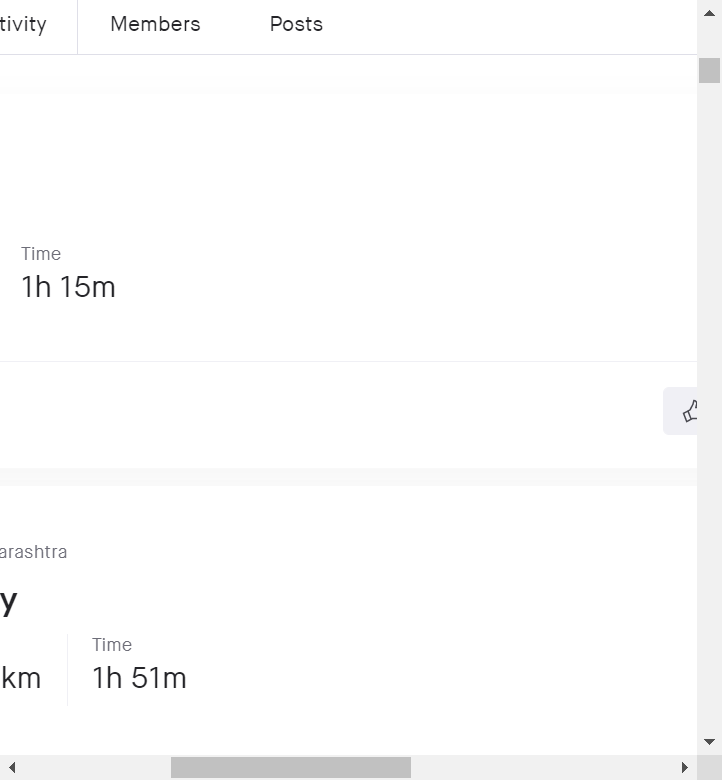

In [13]:
# b.execute_script("window.scrollTo(0,0)")
Image(b.screenshot.png())

In [14]:
"get all attributes"
# for x in dir(b):
#   print(x,type(getattr(b,x)),)

'get all attributes'

# New section
